In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
data['called_strike'] = np.where(data['description'] == 'called_strike', 1, 0)
testing_data['called_strike'] = np.where(testing_data['description'] == 'called_strike', 1, 0)

In [5]:
breaking_ball = data.query('pitch_type_condensed in ("CH") & strike == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [6]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo', 'swing'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo', 'swing'
], axis=1)   # Exclude the identifier from the features

In [7]:
testing_features.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed',
       'called_strike'],
      dtype='object')

In [8]:
training_features.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed',
       'called_strike'],
      dtype='object')

In [9]:
train_data = training_features.drop(['called_strike'], axis=1).copy()
train_label = training_features['called_strike'].copy()
testing_data = testing_features.drop(['called_strike'], axis=1).copy()
testing_label = testing_features['called_strike'].copy()

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [12]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [13]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6586529081488868
Log Loss: 0.6209703579351744


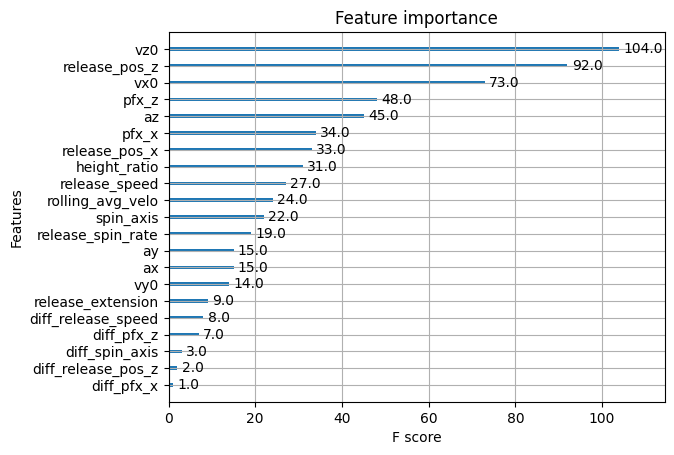

In [15]:
xgb.plot_importance(model)
plt.show()

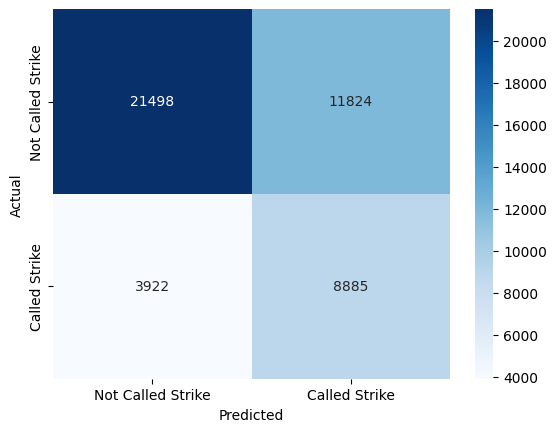

In [16]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Called Strike', 'Called Strike'], yticklabels=['Not Called Strike', 'Called Strike'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [18]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 12:41:42,793] A new study created in memory with name: no-name-c2e218c2-3520-41dd-91f8-0f1956c04f35


[0]	eval-logloss:0.67689
[1]	eval-logloss:0.66634
[2]	eval-logloss:0.65887
[3]	eval-logloss:0.65385
[4]	eval-logloss:0.64927
[5]	eval-logloss:0.64434
[6]	eval-logloss:0.64104
[7]	eval-logloss:0.63773
[8]	eval-logloss:0.63436
[9]	eval-logloss:0.63321
[10]	eval-logloss:0.63086
[11]	eval-logloss:0.62863
[12]	eval-logloss:0.62648
[13]	eval-logloss:0.62485
[14]	eval-logloss:0.62193
[15]	eval-logloss:0.61989
[16]	eval-logloss:0.61939
[17]	eval-logloss:0.61821
[18]	eval-logloss:0.61735
[19]	eval-logloss:0.61572
[20]	eval-logloss:0.61434
[21]	eval-logloss:0.61298
[22]	eval-logloss:0.61203
[23]	eval-logloss:0.61170
[24]	eval-logloss:0.61000
[25]	eval-logloss:0.60873
[26]	eval-logloss:0.60776
[27]	eval-logloss:0.60610
[28]	eval-logloss:0.60546
[29]	eval-logloss:0.60465
[30]	eval-logloss:0.60309
[31]	eval-logloss:0.60248
[32]	eval-logloss:0.60132
[33]	eval-logloss:0.60000
[34]	eval-logloss:0.59871
[35]	eval-logloss:0.59811
[36]	eval-logloss:0.59822
[37]	eval-logloss:0.59761
[38]	eval-logloss:0.59

[I 2023-11-15 12:41:44,325] Trial 0 finished with value: 0.5635221115758995 and parameters: {'max_depth': 3, 'eta': 0.2797242118054369, 'subsample': 0.6082564558052066, 'colsample_bytree': 0.7476340090682427}. Best is trial 0 with value: 0.5635221115758995.


[0]	eval-logloss:0.68241
[1]	eval-logloss:0.67517
[2]	eval-logloss:0.66936
[3]	eval-logloss:0.66549
[4]	eval-logloss:0.66084
[5]	eval-logloss:0.65796
[6]	eval-logloss:0.65539
[7]	eval-logloss:0.65208
[8]	eval-logloss:0.64976
[9]	eval-logloss:0.64738
[10]	eval-logloss:0.64580
[11]	eval-logloss:0.64393
[12]	eval-logloss:0.64154
[13]	eval-logloss:0.64013
[14]	eval-logloss:0.63879
[15]	eval-logloss:0.63768
[16]	eval-logloss:0.63562
[17]	eval-logloss:0.63487
[18]	eval-logloss:0.63417
[19]	eval-logloss:0.63290
[20]	eval-logloss:0.63167
[21]	eval-logloss:0.63041
[22]	eval-logloss:0.62988
[23]	eval-logloss:0.62852
[24]	eval-logloss:0.62725
[25]	eval-logloss:0.62575
[26]	eval-logloss:0.62481
[27]	eval-logloss:0.62332
[28]	eval-logloss:0.62284
[29]	eval-logloss:0.62172
[30]	eval-logloss:0.61994
[31]	eval-logloss:0.61947
[32]	eval-logloss:0.61851
[33]	eval-logloss:0.61785
[34]	eval-logloss:0.61674
[35]	eval-logloss:0.61591
[36]	eval-logloss:0.61545
[37]	eval-logloss:0.61474
[38]	eval-logloss:0.61

[I 2023-11-15 12:41:45,835] Trial 1 finished with value: 0.5832389946594548 and parameters: {'max_depth': 3, 'eta': 0.16719236367298262, 'subsample': 0.7970543602140961, 'colsample_bytree': 0.5626674201328011}. Best is trial 0 with value: 0.5635221115758995.


[0]	eval-logloss:0.66060
[1]	eval-logloss:0.64167
[2]	eval-logloss:0.62727
[3]	eval-logloss:0.61502
[4]	eval-logloss:0.60684
[5]	eval-logloss:0.59810
[6]	eval-logloss:0.59149
[7]	eval-logloss:0.58749
[8]	eval-logloss:0.57845
[9]	eval-logloss:0.57251
[10]	eval-logloss:0.56922
[11]	eval-logloss:0.56490
[12]	eval-logloss:0.56050
[13]	eval-logloss:0.55669
[14]	eval-logloss:0.55283
[15]	eval-logloss:0.54900
[16]	eval-logloss:0.54605
[17]	eval-logloss:0.54221
[18]	eval-logloss:0.53856
[19]	eval-logloss:0.53607
[20]	eval-logloss:0.53330
[21]	eval-logloss:0.53035
[22]	eval-logloss:0.52888
[23]	eval-logloss:0.52681
[24]	eval-logloss:0.52378
[25]	eval-logloss:0.52081
[26]	eval-logloss:0.51791
[27]	eval-logloss:0.51644
[28]	eval-logloss:0.51282
[29]	eval-logloss:0.50979
[30]	eval-logloss:0.50803
[31]	eval-logloss:0.50544
[32]	eval-logloss:0.50390
[33]	eval-logloss:0.50173
[34]	eval-logloss:0.49820
[35]	eval-logloss:0.49717
[36]	eval-logloss:0.49425
[37]	eval-logloss:0.49355
[38]	eval-logloss:0.49

[I 2023-11-15 12:41:47,714] Trial 2 finished with value: 0.3924297178681299 and parameters: {'max_depth': 6, 'eta': 0.2947106566879987, 'subsample': 0.8830319417335418, 'colsample_bytree': 0.9851041392114885}. Best is trial 2 with value: 0.3924297178681299.


[0]	eval-logloss:0.68589
[1]	eval-logloss:0.67920
[2]	eval-logloss:0.67366
[3]	eval-logloss:0.66913
[4]	eval-logloss:0.66375
[5]	eval-logloss:0.65815
[6]	eval-logloss:0.65354
[7]	eval-logloss:0.64883
[8]	eval-logloss:0.64430
[9]	eval-logloss:0.63997
[10]	eval-logloss:0.63667
[11]	eval-logloss:0.63274
[12]	eval-logloss:0.62892
[13]	eval-logloss:0.62616
[14]	eval-logloss:0.62187
[15]	eval-logloss:0.61946
[16]	eval-logloss:0.61643
[17]	eval-logloss:0.61490
[18]	eval-logloss:0.61224
[19]	eval-logloss:0.61006
[20]	eval-logloss:0.60693
[21]	eval-logloss:0.60360
[22]	eval-logloss:0.60076
[23]	eval-logloss:0.59869
[24]	eval-logloss:0.59648
[25]	eval-logloss:0.59357
[26]	eval-logloss:0.59118
[27]	eval-logloss:0.58866
[28]	eval-logloss:0.58740
[29]	eval-logloss:0.58505
[30]	eval-logloss:0.58227
[31]	eval-logloss:0.58099
[32]	eval-logloss:0.57869
[33]	eval-logloss:0.57737
[34]	eval-logloss:0.57499
[35]	eval-logloss:0.57250
[36]	eval-logloss:0.57161
[37]	eval-logloss:0.56937
[38]	eval-logloss:0.56

[I 2023-11-15 12:41:50,217] Trial 3 finished with value: 0.48362838658429236 and parameters: {'max_depth': 8, 'eta': 0.038437237802133, 'subsample': 0.7453698433688909, 'colsample_bytree': 0.6722921033058173}. Best is trial 2 with value: 0.3924297178681299.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.65858
[2]	eval-logloss:0.64641
[3]	eval-logloss:0.63767
[4]	eval-logloss:0.62675
[5]	eval-logloss:0.61617
[6]	eval-logloss:0.60698
[7]	eval-logloss:0.59872
[8]	eval-logloss:0.59248
[9]	eval-logloss:0.58560
[10]	eval-logloss:0.58112
[11]	eval-logloss:0.57525
[12]	eval-logloss:0.56990
[13]	eval-logloss:0.56455
[14]	eval-logloss:0.55831
[15]	eval-logloss:0.55261
[16]	eval-logloss:0.54876
[17]	eval-logloss:0.54572
[18]	eval-logloss:0.54106
[19]	eval-logloss:0.53675
[20]	eval-logloss:0.53222
[21]	eval-logloss:0.52798
[22]	eval-logloss:0.52590
[23]	eval-logloss:0.52201
[24]	eval-logloss:0.51830
[25]	eval-logloss:0.51406
[26]	eval-logloss:0.51130
[27]	eval-logloss:0.50842
[28]	eval-logloss:0.50584
[29]	eval-logloss:0.50361
[30]	eval-logloss:0.50025
[31]	eval-logloss:0.49706
[32]	eval-logloss:0.49463
[33]	eval-logloss:0.49203
[34]	eval-logloss:0.48963
[35]	eval-logloss:0.48684
[36]	eval-logloss:0.48575
[37]	eval-logloss:0.48248
[38]	eval-logloss:0.48

[I 2023-11-15 12:41:52,567] Trial 4 finished with value: 0.3833591393843343 and parameters: {'max_depth': 8, 'eta': 0.10584332158498512, 'subsample': 0.7374754800826215, 'colsample_bytree': 0.6152222125526787}. Best is trial 4 with value: 0.3833591393843343.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67398
[2]	eval-logloss:0.66764
[3]	eval-logloss:0.66241
[4]	eval-logloss:0.65780
[5]	eval-logloss:0.65469
[6]	eval-logloss:0.65153
[7]	eval-logloss:0.64859
[8]	eval-logloss:0.64523
[9]	eval-logloss:0.64276
[10]	eval-logloss:0.64019
[11]	eval-logloss:0.63904
[12]	eval-logloss:0.63679
[13]	eval-logloss:0.63465
[14]	eval-logloss:0.63303
[15]	eval-logloss:0.63054
[16]	eval-logloss:0.62887
[17]	eval-logloss:0.62691
[18]	eval-logloss:0.62527
[19]	eval-logloss:0.62405
[20]	eval-logloss:0.62270
[21]	eval-logloss:0.62167
[22]	eval-logloss:0.62035
[23]	eval-logloss:0.61924
[24]	eval-logloss:0.61824
[25]	eval-logloss:0.61744
[26]	eval-logloss:0.61623
[27]	eval-logloss:0.61484
[28]	eval-logloss:0.61436
[29]	eval-logloss:0.61272
[30]	eval-logloss:0.61164
[31]	eval-logloss:0.61026
[32]	eval-logloss:0.60968
[33]	eval-logloss:0.60889
[34]	eval-logloss:0.60780
[35]	eval-logloss:0.60705
[36]	eval-logloss:0.60597
[37]	eval-logloss:0.60557
[38]	eval-logloss:0.60

[I 2023-11-15 12:41:54,009] Trial 5 finished with value: 0.5752088858537188 and parameters: {'max_depth': 3, 'eta': 0.1819940127002509, 'subsample': 0.8111093333446872, 'colsample_bytree': 0.9892806388149508}. Best is trial 4 with value: 0.3833591393843343.


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.66340
[2]	eval-logloss:0.65474
[3]	eval-logloss:0.64797
[4]	eval-logloss:0.64230
[5]	eval-logloss:0.63729
[6]	eval-logloss:0.63166
[7]	eval-logloss:0.62836
[8]	eval-logloss:0.62544
[9]	eval-logloss:0.62112
[10]	eval-logloss:0.61854
[11]	eval-logloss:0.61641
[12]	eval-logloss:0.61438
[13]	eval-logloss:0.61178
[14]	eval-logloss:0.60864
[15]	eval-logloss:0.60743
[16]	eval-logloss:0.60603
[17]	eval-logloss:0.60479
[18]	eval-logloss:0.60228
[19]	eval-logloss:0.60017
[20]	eval-logloss:0.59869
[21]	eval-logloss:0.59763
[22]	eval-logloss:0.59612
[23]	eval-logloss:0.59420
[24]	eval-logloss:0.59256
[25]	eval-logloss:0.59162
[26]	eval-logloss:0.59025
[27]	eval-logloss:0.58875
[28]	eval-logloss:0.58783
[29]	eval-logloss:0.58605
[30]	eval-logloss:0.58369
[31]	eval-logloss:0.58320
[32]	eval-logloss:0.58230
[33]	eval-logloss:0.58070
[34]	eval-logloss:0.57946
[35]	eval-logloss:0.57859
[36]	eval-logloss:0.57694
[37]	eval-logloss:0.57617
[38]	eval-logloss:0.57

[I 2023-11-15 12:41:55,590] Trial 6 finished with value: 0.5294292814790363 and parameters: {'max_depth': 4, 'eta': 0.23745255486945085, 'subsample': 0.820609251828357, 'colsample_bytree': 0.8866035152255454}. Best is trial 4 with value: 0.3833591393843343.


[0]	eval-logloss:0.68487
[1]	eval-logloss:0.67808
[2]	eval-logloss:0.67237
[3]	eval-logloss:0.66834
[4]	eval-logloss:0.66403
[5]	eval-logloss:0.66098
[6]	eval-logloss:0.65807
[7]	eval-logloss:0.65529
[8]	eval-logloss:0.65337
[9]	eval-logloss:0.65114
[10]	eval-logloss:0.64928
[11]	eval-logloss:0.64752
[12]	eval-logloss:0.64578
[13]	eval-logloss:0.64388
[14]	eval-logloss:0.64144
[15]	eval-logloss:0.63996
[16]	eval-logloss:0.63865
[17]	eval-logloss:0.63719
[18]	eval-logloss:0.63540
[19]	eval-logloss:0.63418
[20]	eval-logloss:0.63301
[21]	eval-logloss:0.63144
[22]	eval-logloss:0.63066
[23]	eval-logloss:0.62923
[24]	eval-logloss:0.62806
[25]	eval-logloss:0.62697
[26]	eval-logloss:0.62609
[27]	eval-logloss:0.62514
[28]	eval-logloss:0.62421
[29]	eval-logloss:0.62263
[30]	eval-logloss:0.62169
[31]	eval-logloss:0.62083
[32]	eval-logloss:0.62003
[33]	eval-logloss:0.61875
[34]	eval-logloss:0.61771
[35]	eval-logloss:0.61689
[36]	eval-logloss:0.61595
[37]	eval-logloss:0.61537
[38]	eval-logloss:0.61

[I 2023-11-15 12:41:57,065] Trial 7 finished with value: 0.5858944174565327 and parameters: {'max_depth': 3, 'eta': 0.13177597143833703, 'subsample': 0.6754891549475714, 'colsample_bytree': 0.9070908694293945}. Best is trial 4 with value: 0.3833591393843343.


[0]	eval-logloss:0.67671
[1]	eval-logloss:0.66489
[2]	eval-logloss:0.65685
[3]	eval-logloss:0.65046
[4]	eval-logloss:0.64471
[5]	eval-logloss:0.63952
[6]	eval-logloss:0.63534
[7]	eval-logloss:0.63174
[8]	eval-logloss:0.62730
[9]	eval-logloss:0.62442
[10]	eval-logloss:0.62305
[11]	eval-logloss:0.62072
[12]	eval-logloss:0.61842
[13]	eval-logloss:0.61606
[14]	eval-logloss:0.61341
[15]	eval-logloss:0.61102
[16]	eval-logloss:0.60981
[17]	eval-logloss:0.60877
[18]	eval-logloss:0.60752
[19]	eval-logloss:0.60458
[20]	eval-logloss:0.60328
[21]	eval-logloss:0.60151
[22]	eval-logloss:0.59980
[23]	eval-logloss:0.59815
[24]	eval-logloss:0.59657
[25]	eval-logloss:0.59496
[26]	eval-logloss:0.59352
[27]	eval-logloss:0.59205
[28]	eval-logloss:0.59136
[29]	eval-logloss:0.59026
[30]	eval-logloss:0.58869
[31]	eval-logloss:0.58786
[32]	eval-logloss:0.58690
[33]	eval-logloss:0.58614
[34]	eval-logloss:0.58442
[35]	eval-logloss:0.58351
[36]	eval-logloss:0.58345
[37]	eval-logloss:0.58133
[38]	eval-logloss:0.58

[I 2023-11-15 12:41:58,662] Trial 8 finished with value: 0.5360378871309165 and parameters: {'max_depth': 4, 'eta': 0.2157011098315354, 'subsample': 0.6218192755929737, 'colsample_bytree': 0.6573591023643273}. Best is trial 4 with value: 0.3833591393843343.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.68966
[3]	eval-logloss:0.68865
[4]	eval-logloss:0.68757
[5]	eval-logloss:0.68656
[6]	eval-logloss:0.68563
[7]	eval-logloss:0.68473
[8]	eval-logloss:0.68386
[9]	eval-logloss:0.68300
[10]	eval-logloss:0.68216
[11]	eval-logloss:0.68134
[12]	eval-logloss:0.68053
[13]	eval-logloss:0.67975
[14]	eval-logloss:0.67893
[15]	eval-logloss:0.67818
[16]	eval-logloss:0.67748
[17]	eval-logloss:0.67678
[18]	eval-logloss:0.67611
[19]	eval-logloss:0.67539
[20]	eval-logloss:0.67475
[21]	eval-logloss:0.67414
[22]	eval-logloss:0.67349
[23]	eval-logloss:0.67291
[24]	eval-logloss:0.67232
[25]	eval-logloss:0.67174
[26]	eval-logloss:0.67117
[27]	eval-logloss:0.67061
[28]	eval-logloss:0.67007
[29]	eval-logloss:0.66953
[30]	eval-logloss:0.66890
[31]	eval-logloss:0.66837
[32]	eval-logloss:0.66786
[33]	eval-logloss:0.66766
[34]	eval-logloss:0.66704
[35]	eval-logloss:0.66650
[36]	eval-logloss:0.66594
[37]	eval-logloss:0.66540
[38]	eval-logloss:0.66

[I 2023-11-15 12:42:00,214] Trial 9 finished with value: 0.6457855624415493 and parameters: {'max_depth': 3, 'eta': 0.017062752418945865, 'subsample': 0.7023615610866993, 'colsample_bytree': 0.9385906136110946}. Best is trial 4 with value: 0.3833591393843343.


[0]	eval-logloss:0.67190
[1]	eval-logloss:0.65440
[2]	eval-logloss:0.64036
[3]	eval-logloss:0.63036
[4]	eval-logloss:0.61768
[5]	eval-logloss:0.60676
[6]	eval-logloss:0.59730
[7]	eval-logloss:0.58711
[8]	eval-logloss:0.57960
[9]	eval-logloss:0.57123
[10]	eval-logloss:0.56491
[11]	eval-logloss:0.55716
[12]	eval-logloss:0.54883
[13]	eval-logloss:0.54347
[14]	eval-logloss:0.53751
[15]	eval-logloss:0.53342
[16]	eval-logloss:0.52877
[17]	eval-logloss:0.52545
[18]	eval-logloss:0.52129
[19]	eval-logloss:0.51618
[20]	eval-logloss:0.51034
[21]	eval-logloss:0.50395
[22]	eval-logloss:0.50132
[23]	eval-logloss:0.49709
[24]	eval-logloss:0.49142
[25]	eval-logloss:0.48769
[26]	eval-logloss:0.48380
[27]	eval-logloss:0.47961
[28]	eval-logloss:0.47603
[29]	eval-logloss:0.47270
[30]	eval-logloss:0.46757
[31]	eval-logloss:0.46424
[32]	eval-logloss:0.46117
[33]	eval-logloss:0.45856
[34]	eval-logloss:0.45614
[35]	eval-logloss:0.45302
[36]	eval-logloss:0.45117
[37]	eval-logloss:0.44797
[38]	eval-logloss:0.44

[I 2023-11-15 12:42:02,939] Trial 10 finished with value: 0.3224153296761207 and parameters: {'max_depth': 9, 'eta': 0.10124090907917771, 'subsample': 0.7266538897352816, 'colsample_bytree': 0.5014863098806902}. Best is trial 10 with value: 0.3224153296761207.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65511
[2]	eval-logloss:0.64086
[3]	eval-logloss:0.63101
[4]	eval-logloss:0.61848
[5]	eval-logloss:0.60769
[6]	eval-logloss:0.59858
[7]	eval-logloss:0.58872
[8]	eval-logloss:0.58097
[9]	eval-logloss:0.57257
[10]	eval-logloss:0.56617
[11]	eval-logloss:0.55840
[12]	eval-logloss:0.55090
[13]	eval-logloss:0.54591
[14]	eval-logloss:0.54043
[15]	eval-logloss:0.53632
[16]	eval-logloss:0.53128
[17]	eval-logloss:0.52843
[18]	eval-logloss:0.52478
[19]	eval-logloss:0.52093
[20]	eval-logloss:0.51524
[21]	eval-logloss:0.51006
[22]	eval-logloss:0.50750
[23]	eval-logloss:0.50340
[24]	eval-logloss:0.49780
[25]	eval-logloss:0.49285
[26]	eval-logloss:0.48952
[27]	eval-logloss:0.48480
[28]	eval-logloss:0.48046
[29]	eval-logloss:0.47659
[30]	eval-logloss:0.47176
[31]	eval-logloss:0.46799
[32]	eval-logloss:0.46486
[33]	eval-logloss:0.46241
[34]	eval-logloss:0.45945
[35]	eval-logloss:0.45623
[36]	eval-logloss:0.45418
[37]	eval-logloss:0.45065
[38]	eval-logloss:0.44

[I 2023-11-15 12:42:05,661] Trial 11 finished with value: 0.3239437572478105 and parameters: {'max_depth': 9, 'eta': 0.09939445275876123, 'subsample': 0.7299293141215674, 'colsample_bytree': 0.5078586375929122}. Best is trial 10 with value: 0.3224153296761207.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66035
[2]	eval-logloss:0.64805
[3]	eval-logloss:0.63907
[4]	eval-logloss:0.62746
[5]	eval-logloss:0.61798
[6]	eval-logloss:0.61001
[7]	eval-logloss:0.60130
[8]	eval-logloss:0.59393
[9]	eval-logloss:0.58614
[10]	eval-logloss:0.58015
[11]	eval-logloss:0.57284
[12]	eval-logloss:0.56563
[13]	eval-logloss:0.56046
[14]	eval-logloss:0.55465
[15]	eval-logloss:0.55103
[16]	eval-logloss:0.54572
[17]	eval-logloss:0.54306
[18]	eval-logloss:0.53971
[19]	eval-logloss:0.53511
[20]	eval-logloss:0.52970
[21]	eval-logloss:0.52356
[22]	eval-logloss:0.52186
[23]	eval-logloss:0.51796
[24]	eval-logloss:0.51217
[25]	eval-logloss:0.50814
[26]	eval-logloss:0.50442
[27]	eval-logloss:0.49990
[28]	eval-logloss:0.49656
[29]	eval-logloss:0.49336
[30]	eval-logloss:0.48883
[31]	eval-logloss:0.48496
[32]	eval-logloss:0.48180
[33]	eval-logloss:0.48033
[34]	eval-logloss:0.47765
[35]	eval-logloss:0.47474
[36]	eval-logloss:0.47305
[37]	eval-logloss:0.46997
[38]	eval-logloss:0.46

[I 2023-11-15 12:42:08,423] Trial 12 finished with value: 0.3460133334646572 and parameters: {'max_depth': 9, 'eta': 0.08384104055071144, 'subsample': 0.6973118560644306, 'colsample_bytree': 0.5140712250261242}. Best is trial 10 with value: 0.3224153296761207.


[0]	eval-logloss:0.67803
[1]	eval-logloss:0.66443
[2]	eval-logloss:0.65349
[3]	eval-logloss:0.64514
[4]	eval-logloss:0.63537
[5]	eval-logloss:0.62676
[6]	eval-logloss:0.61896
[7]	eval-logloss:0.61049
[8]	eval-logloss:0.60347
[9]	eval-logloss:0.59648
[10]	eval-logloss:0.59107
[11]	eval-logloss:0.58460
[12]	eval-logloss:0.57802
[13]	eval-logloss:0.57349
[14]	eval-logloss:0.56824
[15]	eval-logloss:0.56496
[16]	eval-logloss:0.55977
[17]	eval-logloss:0.55721
[18]	eval-logloss:0.55424
[19]	eval-logloss:0.54978
[20]	eval-logloss:0.54452
[21]	eval-logloss:0.53849
[22]	eval-logloss:0.53640
[23]	eval-logloss:0.53215
[24]	eval-logloss:0.52736
[25]	eval-logloss:0.52351
[26]	eval-logloss:0.51983
[27]	eval-logloss:0.51540
[28]	eval-logloss:0.51306
[29]	eval-logloss:0.51014
[30]	eval-logloss:0.50550
[31]	eval-logloss:0.50337
[32]	eval-logloss:0.50040
[33]	eval-logloss:0.49800
[34]	eval-logloss:0.49521
[35]	eval-logloss:0.49265
[36]	eval-logloss:0.49100
[37]	eval-logloss:0.48777
[38]	eval-logloss:0.48

[I 2023-11-15 12:42:11,233] Trial 13 finished with value: 0.36697674439079603 and parameters: {'max_depth': 9, 'eta': 0.0716049956459271, 'subsample': 0.7671439456696252, 'colsample_bytree': 0.500088565861549}. Best is trial 10 with value: 0.3224153296761207.


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.65937
[2]	eval-logloss:0.64840
[3]	eval-logloss:0.64001
[4]	eval-logloss:0.63119
[5]	eval-logloss:0.62227
[6]	eval-logloss:0.61573
[7]	eval-logloss:0.60915
[8]	eval-logloss:0.60411
[9]	eval-logloss:0.59811
[10]	eval-logloss:0.59435
[11]	eval-logloss:0.58987
[12]	eval-logloss:0.58517
[13]	eval-logloss:0.58044
[14]	eval-logloss:0.57481
[15]	eval-logloss:0.56949
[16]	eval-logloss:0.56568
[17]	eval-logloss:0.56316
[18]	eval-logloss:0.56011
[19]	eval-logloss:0.55722
[20]	eval-logloss:0.55361
[21]	eval-logloss:0.55097
[22]	eval-logloss:0.54940
[23]	eval-logloss:0.54754
[24]	eval-logloss:0.54397
[25]	eval-logloss:0.54089
[26]	eval-logloss:0.53840
[27]	eval-logloss:0.53555
[28]	eval-logloss:0.53296
[29]	eval-logloss:0.53139
[30]	eval-logloss:0.52819
[31]	eval-logloss:0.52556
[32]	eval-logloss:0.52320
[33]	eval-logloss:0.52156
[34]	eval-logloss:0.51903
[35]	eval-logloss:0.51701
[36]	eval-logloss:0.51621
[37]	eval-logloss:0.51367
[38]	eval-logloss:0.51

[I 2023-11-15 12:42:13,237] Trial 14 finished with value: 0.4276425924738763 and parameters: {'max_depth': 7, 'eta': 0.12842248580518625, 'subsample': 0.6623440480318236, 'colsample_bytree': 0.5767451661581392}. Best is trial 10 with value: 0.3224153296761207.


[0]	eval-logloss:0.68489
[1]	eval-logloss:0.67780
[2]	eval-logloss:0.67188
[3]	eval-logloss:0.66710
[4]	eval-logloss:0.66179
[5]	eval-logloss:0.65735
[6]	eval-logloss:0.65381
[7]	eval-logloss:0.64950
[8]	eval-logloss:0.64580
[9]	eval-logloss:0.64219
[10]	eval-logloss:0.63941
[11]	eval-logloss:0.63637
[12]	eval-logloss:0.63308
[13]	eval-logloss:0.63099
[14]	eval-logloss:0.62852
[15]	eval-logloss:0.62747
[16]	eval-logloss:0.62465
[17]	eval-logloss:0.62378
[18]	eval-logloss:0.62270
[19]	eval-logloss:0.62077
[20]	eval-logloss:0.61835
[21]	eval-logloss:0.61532
[22]	eval-logloss:0.61486
[23]	eval-logloss:0.61316
[24]	eval-logloss:0.61082
[25]	eval-logloss:0.60864
[26]	eval-logloss:0.60675
[27]	eval-logloss:0.60452
[28]	eval-logloss:0.60366
[29]	eval-logloss:0.60197
[30]	eval-logloss:0.59958
[31]	eval-logloss:0.59877
[32]	eval-logloss:0.59736
[33]	eval-logloss:0.59647
[34]	eval-logloss:0.59505
[35]	eval-logloss:0.59346
[36]	eval-logloss:0.59276
[37]	eval-logloss:0.59107
[38]	eval-logloss:0.58

[I 2023-11-15 12:42:15,172] Trial 15 finished with value: 0.53047073706469 and parameters: {'max_depth': 6, 'eta': 0.06765883318011157, 'subsample': 0.7197729600103828, 'colsample_bytree': 0.5075685940226289}. Best is trial 10 with value: 0.3224153296761207.


[0]	eval-logloss:0.67213
[1]	eval-logloss:0.65437
[2]	eval-logloss:0.64166
[3]	eval-logloss:0.63265
[4]	eval-logloss:0.62201
[5]	eval-logloss:0.61108
[6]	eval-logloss:0.60210
[7]	eval-logloss:0.59325
[8]	eval-logloss:0.58667
[9]	eval-logloss:0.57896
[10]	eval-logloss:0.57363
[11]	eval-logloss:0.56748
[12]	eval-logloss:0.56093
[13]	eval-logloss:0.55671
[14]	eval-logloss:0.55003
[15]	eval-logloss:0.54486
[16]	eval-logloss:0.54064
[17]	eval-logloss:0.53752
[18]	eval-logloss:0.53437
[19]	eval-logloss:0.53063
[20]	eval-logloss:0.52635
[21]	eval-logloss:0.52146
[22]	eval-logloss:0.51810
[23]	eval-logloss:0.51394
[24]	eval-logloss:0.50935
[25]	eval-logloss:0.50549
[26]	eval-logloss:0.50244
[27]	eval-logloss:0.49924
[28]	eval-logloss:0.49670
[29]	eval-logloss:0.49353
[30]	eval-logloss:0.48928
[31]	eval-logloss:0.48510
[32]	eval-logloss:0.48260
[33]	eval-logloss:0.48008
[34]	eval-logloss:0.47782
[35]	eval-logloss:0.47534
[36]	eval-logloss:0.47347
[37]	eval-logloss:0.47044
[38]	eval-logloss:0.46

[I 2023-11-15 12:42:17,500] Trial 16 finished with value: 0.3645986071367204 and parameters: {'max_depth': 8, 'eta': 0.11981048177741035, 'subsample': 0.7627349849960097, 'colsample_bytree': 0.5806654803473842}. Best is trial 10 with value: 0.3224153296761207.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.66645
[2]	eval-logloss:0.65651
[3]	eval-logloss:0.64939
[4]	eval-logloss:0.64137
[5]	eval-logloss:0.63322
[6]	eval-logloss:0.62708
[7]	eval-logloss:0.62106
[8]	eval-logloss:0.61495
[9]	eval-logloss:0.60989
[10]	eval-logloss:0.60543
[11]	eval-logloss:0.60072
[12]	eval-logloss:0.59647
[13]	eval-logloss:0.59167
[14]	eval-logloss:0.58734
[15]	eval-logloss:0.58325
[16]	eval-logloss:0.58045
[17]	eval-logloss:0.57819
[18]	eval-logloss:0.57402
[19]	eval-logloss:0.57053
[20]	eval-logloss:0.56756
[21]	eval-logloss:0.56448
[22]	eval-logloss:0.56230
[23]	eval-logloss:0.55952
[24]	eval-logloss:0.55652
[25]	eval-logloss:0.55329
[26]	eval-logloss:0.55111
[27]	eval-logloss:0.54855
[28]	eval-logloss:0.54687
[29]	eval-logloss:0.54525
[30]	eval-logloss:0.54170
[31]	eval-logloss:0.54027
[32]	eval-logloss:0.53869
[33]	eval-logloss:0.53760
[34]	eval-logloss:0.53559
[35]	eval-logloss:0.53364
[36]	eval-logloss:0.53289
[37]	eval-logloss:0.53107
[38]	eval-logloss:0.52

[I 2023-11-15 12:42:19,551] Trial 17 finished with value: 0.452316280642568 and parameters: {'max_depth': 7, 'eta': 0.09847393515199823, 'subsample': 0.657273061622458, 'colsample_bytree': 0.7020114216295561}. Best is trial 10 with value: 0.3224153296761207.


[0]	eval-logloss:0.66191
[1]	eval-logloss:0.63751
[2]	eval-logloss:0.62006
[3]	eval-logloss:0.60808
[4]	eval-logloss:0.59415
[5]	eval-logloss:0.57847
[6]	eval-logloss:0.56546
[7]	eval-logloss:0.55386
[8]	eval-logloss:0.54599
[9]	eval-logloss:0.53556
[10]	eval-logloss:0.52943
[11]	eval-logloss:0.52095
[12]	eval-logloss:0.51270
[13]	eval-logloss:0.50397
[14]	eval-logloss:0.49387
[15]	eval-logloss:0.48645
[16]	eval-logloss:0.48030
[17]	eval-logloss:0.47681
[18]	eval-logloss:0.47033
[19]	eval-logloss:0.46512
[20]	eval-logloss:0.46046
[21]	eval-logloss:0.45519
[22]	eval-logloss:0.45156
[23]	eval-logloss:0.44573
[24]	eval-logloss:0.44326
[25]	eval-logloss:0.43768
[26]	eval-logloss:0.43377
[27]	eval-logloss:0.42939
[28]	eval-logloss:0.42578
[29]	eval-logloss:0.42302
[30]	eval-logloss:0.41816
[31]	eval-logloss:0.41433
[32]	eval-logloss:0.41116
[33]	eval-logloss:0.40851
[34]	eval-logloss:0.40490
[35]	eval-logloss:0.40101
[36]	eval-logloss:0.39866
[37]	eval-logloss:0.39609
[38]	eval-logloss:0.39

[I 2023-11-15 12:42:22,245] Trial 18 finished with value: 0.26706070864163817 and parameters: {'max_depth': 9, 'eta': 0.14969727170082486, 'subsample': 0.7179233898102557, 'colsample_bytree': 0.614393215081711}. Best is trial 18 with value: 0.26706070864163817.


[0]	eval-logloss:0.67205
[1]	eval-logloss:0.65599
[2]	eval-logloss:0.64405
[3]	eval-logloss:0.63535
[4]	eval-logloss:0.62558
[5]	eval-logloss:0.61599
[6]	eval-logloss:0.60847
[7]	eval-logloss:0.60165
[8]	eval-logloss:0.59609
[9]	eval-logloss:0.58984
[10]	eval-logloss:0.58628
[11]	eval-logloss:0.58158
[12]	eval-logloss:0.57617
[13]	eval-logloss:0.57169
[14]	eval-logloss:0.56532
[15]	eval-logloss:0.55944
[16]	eval-logloss:0.55656
[17]	eval-logloss:0.55483
[18]	eval-logloss:0.55085
[19]	eval-logloss:0.54782
[20]	eval-logloss:0.54349
[21]	eval-logloss:0.54001
[22]	eval-logloss:0.53812
[23]	eval-logloss:0.53505
[24]	eval-logloss:0.53127
[25]	eval-logloss:0.52778
[26]	eval-logloss:0.52470
[27]	eval-logloss:0.52258
[28]	eval-logloss:0.52059
[29]	eval-logloss:0.51876
[30]	eval-logloss:0.51590
[31]	eval-logloss:0.51456
[32]	eval-logloss:0.51289
[33]	eval-logloss:0.51137
[34]	eval-logloss:0.50860
[35]	eval-logloss:0.50589
[36]	eval-logloss:0.50503
[37]	eval-logloss:0.50377
[38]	eval-logloss:0.50

[I 2023-11-15 12:42:24,433] Trial 19 finished with value: 0.41356793104439804 and parameters: {'max_depth': 7, 'eta': 0.1449577272551669, 'subsample': 0.694783279238558, 'colsample_bytree': 0.6228942499704933}. Best is trial 18 with value: 0.26706070864163817.


[0]	eval-logloss:0.67739
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.65593
[3]	eval-logloss:0.64823
[4]	eval-logloss:0.64165
[5]	eval-logloss:0.63580
[6]	eval-logloss:0.63069
[7]	eval-logloss:0.62649
[8]	eval-logloss:0.62271
[9]	eval-logloss:0.61898
[10]	eval-logloss:0.61658
[11]	eval-logloss:0.61345
[12]	eval-logloss:0.60952
[13]	eval-logloss:0.60626
[14]	eval-logloss:0.60370
[15]	eval-logloss:0.60162
[16]	eval-logloss:0.59966
[17]	eval-logloss:0.59770
[18]	eval-logloss:0.59464
[19]	eval-logloss:0.59166
[20]	eval-logloss:0.58954
[21]	eval-logloss:0.58726
[22]	eval-logloss:0.58592
[23]	eval-logloss:0.58435
[24]	eval-logloss:0.58202
[25]	eval-logloss:0.58032
[26]	eval-logloss:0.57873
[27]	eval-logloss:0.57690
[28]	eval-logloss:0.57541
[29]	eval-logloss:0.57354
[30]	eval-logloss:0.57233
[31]	eval-logloss:0.57170
[32]	eval-logloss:0.57040
[33]	eval-logloss:0.56923
[34]	eval-logloss:0.56778
[35]	eval-logloss:0.56681
[36]	eval-logloss:0.56635
[37]	eval-logloss:0.56511
[38]	eval-logloss:0.56

[I 2023-11-15 12:42:26,308] Trial 20 finished with value: 0.5083042956699139 and parameters: {'max_depth': 5, 'eta': 0.16520377638695932, 'subsample': 0.6383727104156753, 'colsample_bytree': 0.7971928479014734}. Best is trial 18 with value: 0.26706070864163817.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.65350
[2]	eval-logloss:0.63905
[3]	eval-logloss:0.62890
[4]	eval-logloss:0.61613
[5]	eval-logloss:0.60538
[6]	eval-logloss:0.59551
[7]	eval-logloss:0.58527
[8]	eval-logloss:0.57794
[9]	eval-logloss:0.56829
[10]	eval-logloss:0.56248
[11]	eval-logloss:0.55530
[12]	eval-logloss:0.54749
[13]	eval-logloss:0.54154
[14]	eval-logloss:0.53640
[15]	eval-logloss:0.53014
[16]	eval-logloss:0.52479
[17]	eval-logloss:0.52136
[18]	eval-logloss:0.51713
[19]	eval-logloss:0.51184
[20]	eval-logloss:0.50564
[21]	eval-logloss:0.49908
[22]	eval-logloss:0.49669
[23]	eval-logloss:0.49231
[24]	eval-logloss:0.48740
[25]	eval-logloss:0.48218
[26]	eval-logloss:0.47883
[27]	eval-logloss:0.47483
[28]	eval-logloss:0.47158
[29]	eval-logloss:0.46802
[30]	eval-logloss:0.46405
[31]	eval-logloss:0.46178
[32]	eval-logloss:0.45835
[33]	eval-logloss:0.45488
[34]	eval-logloss:0.45268
[35]	eval-logloss:0.44950
[36]	eval-logloss:0.44784
[37]	eval-logloss:0.44510
[38]	eval-logloss:0.44

[I 2023-11-15 12:42:29,170] Trial 21 finished with value: 0.32093022619799894 and parameters: {'max_depth': 9, 'eta': 0.10322761778987073, 'subsample': 0.7275823134096078, 'colsample_bytree': 0.543588081109801}. Best is trial 18 with value: 0.26706070864163817.


[0]	eval-logloss:0.66336
[1]	eval-logloss:0.64008
[2]	eval-logloss:0.62266
[3]	eval-logloss:0.61055
[4]	eval-logloss:0.59520
[5]	eval-logloss:0.58110
[6]	eval-logloss:0.56953
[7]	eval-logloss:0.55760
[8]	eval-logloss:0.55006
[9]	eval-logloss:0.53994
[10]	eval-logloss:0.53252
[11]	eval-logloss:0.52300
[12]	eval-logloss:0.51424
[13]	eval-logloss:0.50733
[14]	eval-logloss:0.49781
[15]	eval-logloss:0.49147
[16]	eval-logloss:0.48615
[17]	eval-logloss:0.48321
[18]	eval-logloss:0.47863
[19]	eval-logloss:0.47334
[20]	eval-logloss:0.46644
[21]	eval-logloss:0.46155
[22]	eval-logloss:0.45976
[23]	eval-logloss:0.45558
[24]	eval-logloss:0.45092
[25]	eval-logloss:0.44725
[26]	eval-logloss:0.44350
[27]	eval-logloss:0.43909
[28]	eval-logloss:0.43393
[29]	eval-logloss:0.42998
[30]	eval-logloss:0.42576
[31]	eval-logloss:0.42378
[32]	eval-logloss:0.41995
[33]	eval-logloss:0.41713
[34]	eval-logloss:0.41497
[35]	eval-logloss:0.41114
[36]	eval-logloss:0.40835
[37]	eval-logloss:0.40536
[38]	eval-logloss:0.40

[I 2023-11-15 12:42:31,786] Trial 22 finished with value: 0.27255483405832215 and parameters: {'max_depth': 9, 'eta': 0.14647297110909294, 'subsample': 0.7154645188678838, 'colsample_bytree': 0.5627337729520587}. Best is trial 18 with value: 0.26706070864163817.


[0]	eval-logloss:0.66840
[1]	eval-logloss:0.64931
[2]	eval-logloss:0.63517
[3]	eval-logloss:0.62479
[4]	eval-logloss:0.61253
[5]	eval-logloss:0.60239
[6]	eval-logloss:0.59227
[7]	eval-logloss:0.58361
[8]	eval-logloss:0.57618
[9]	eval-logloss:0.56776
[10]	eval-logloss:0.56253
[11]	eval-logloss:0.55632
[12]	eval-logloss:0.55017
[13]	eval-logloss:0.54421
[14]	eval-logloss:0.53660
[15]	eval-logloss:0.53183
[16]	eval-logloss:0.52697
[17]	eval-logloss:0.52357
[18]	eval-logloss:0.51950
[19]	eval-logloss:0.51570
[20]	eval-logloss:0.51143
[21]	eval-logloss:0.50610
[22]	eval-logloss:0.50466
[23]	eval-logloss:0.50122
[24]	eval-logloss:0.49656
[25]	eval-logloss:0.49296
[26]	eval-logloss:0.48964
[27]	eval-logloss:0.48632
[28]	eval-logloss:0.48347
[29]	eval-logloss:0.48133
[30]	eval-logloss:0.47730
[31]	eval-logloss:0.47311
[32]	eval-logloss:0.47042
[33]	eval-logloss:0.46852
[34]	eval-logloss:0.46533
[35]	eval-logloss:0.46246
[36]	eval-logloss:0.46127
[37]	eval-logloss:0.45977
[38]	eval-logloss:0.45

[I 2023-11-15 12:42:34,078] Trial 23 finished with value: 0.3473414721750099 and parameters: {'max_depth': 8, 'eta': 0.150327177724506, 'subsample': 0.6834103809648424, 'colsample_bytree': 0.5587114369048732}. Best is trial 18 with value: 0.26706070864163817.


[0]	eval-logloss:0.65578
[1]	eval-logloss:0.62765
[2]	eval-logloss:0.60801
[3]	eval-logloss:0.59569
[4]	eval-logloss:0.58005
[5]	eval-logloss:0.56322
[6]	eval-logloss:0.54774
[7]	eval-logloss:0.53714
[8]	eval-logloss:0.52985
[9]	eval-logloss:0.51804
[10]	eval-logloss:0.51010
[11]	eval-logloss:0.50189
[12]	eval-logloss:0.49426
[13]	eval-logloss:0.48645
[14]	eval-logloss:0.47760
[15]	eval-logloss:0.46943
[16]	eval-logloss:0.46436
[17]	eval-logloss:0.45941
[18]	eval-logloss:0.45418
[19]	eval-logloss:0.44939
[20]	eval-logloss:0.44502
[21]	eval-logloss:0.43892
[22]	eval-logloss:0.43543
[23]	eval-logloss:0.42908
[24]	eval-logloss:0.42286
[25]	eval-logloss:0.41632
[26]	eval-logloss:0.41310
[27]	eval-logloss:0.41005
[28]	eval-logloss:0.40653
[29]	eval-logloss:0.40405
[30]	eval-logloss:0.39963
[31]	eval-logloss:0.39677
[32]	eval-logloss:0.39298
[33]	eval-logloss:0.38880
[34]	eval-logloss:0.38563
[35]	eval-logloss:0.38235
[36]	eval-logloss:0.38022
[37]	eval-logloss:0.37662
[38]	eval-logloss:0.37

[I 2023-11-15 12:42:36,724] Trial 24 finished with value: 0.24573773847134425 and parameters: {'max_depth': 9, 'eta': 0.18092416794393062, 'subsample': 0.7151739648217609, 'colsample_bytree': 0.6014719618595441}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.66098
[1]	eval-logloss:0.63591
[2]	eval-logloss:0.61968
[3]	eval-logloss:0.60957
[4]	eval-logloss:0.59718
[5]	eval-logloss:0.58299
[6]	eval-logloss:0.57217
[7]	eval-logloss:0.56329
[8]	eval-logloss:0.55703
[9]	eval-logloss:0.54868
[10]	eval-logloss:0.54262
[11]	eval-logloss:0.53561
[12]	eval-logloss:0.52957
[13]	eval-logloss:0.52326
[14]	eval-logloss:0.51451
[15]	eval-logloss:0.50830
[16]	eval-logloss:0.50444
[17]	eval-logloss:0.50062
[18]	eval-logloss:0.49737
[19]	eval-logloss:0.49344
[20]	eval-logloss:0.48847
[21]	eval-logloss:0.48456
[22]	eval-logloss:0.48025
[23]	eval-logloss:0.47704
[24]	eval-logloss:0.47291
[25]	eval-logloss:0.46878
[26]	eval-logloss:0.46492
[27]	eval-logloss:0.46090
[28]	eval-logloss:0.45818
[29]	eval-logloss:0.45604
[30]	eval-logloss:0.45292
[31]	eval-logloss:0.44970
[32]	eval-logloss:0.44684
[33]	eval-logloss:0.44503
[34]	eval-logloss:0.44159
[35]	eval-logloss:0.43898
[36]	eval-logloss:0.43767
[37]	eval-logloss:0.43590
[38]	eval-logloss:0.43

[I 2023-11-15 12:42:39,010] Trial 25 finished with value: 0.3098570685832999 and parameters: {'max_depth': 8, 'eta': 0.19285247076025927, 'subsample': 0.6453933701534655, 'colsample_bytree': 0.6048698994591561}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.66204
[1]	eval-logloss:0.63748
[2]	eval-logloss:0.62087
[3]	eval-logloss:0.60885
[4]	eval-logloss:0.59412
[5]	eval-logloss:0.57839
[6]	eval-logloss:0.56555
[7]	eval-logloss:0.55519
[8]	eval-logloss:0.54598
[9]	eval-logloss:0.53620
[10]	eval-logloss:0.52953
[11]	eval-logloss:0.52125
[12]	eval-logloss:0.51408
[13]	eval-logloss:0.50656
[14]	eval-logloss:0.49988
[15]	eval-logloss:0.49311
[16]	eval-logloss:0.48779
[17]	eval-logloss:0.48421
[18]	eval-logloss:0.47676
[19]	eval-logloss:0.47181
[20]	eval-logloss:0.46659
[21]	eval-logloss:0.46130
[22]	eval-logloss:0.45704
[23]	eval-logloss:0.45301
[24]	eval-logloss:0.44766
[25]	eval-logloss:0.44181
[26]	eval-logloss:0.43777
[27]	eval-logloss:0.43411
[28]	eval-logloss:0.43091
[29]	eval-logloss:0.42856
[30]	eval-logloss:0.42249
[31]	eval-logloss:0.41797
[32]	eval-logloss:0.41499
[33]	eval-logloss:0.41260
[34]	eval-logloss:0.40876
[35]	eval-logloss:0.40556
[36]	eval-logloss:0.40417
[37]	eval-logloss:0.40167
[38]	eval-logloss:0.39

[I 2023-11-15 12:42:41,703] Trial 26 finished with value: 0.2743145864831846 and parameters: {'max_depth': 9, 'eta': 0.1463338116505457, 'subsample': 0.7071335880103732, 'colsample_bytree': 0.6312101526767847}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.66838
[1]	eval-logloss:0.64917
[2]	eval-logloss:0.63591
[3]	eval-logloss:0.62652
[4]	eval-logloss:0.61638
[5]	eval-logloss:0.60641
[6]	eval-logloss:0.59890
[7]	eval-logloss:0.59226
[8]	eval-logloss:0.58741
[9]	eval-logloss:0.58019
[10]	eval-logloss:0.57642
[11]	eval-logloss:0.57035
[12]	eval-logloss:0.56499
[13]	eval-logloss:0.55991
[14]	eval-logloss:0.55323
[15]	eval-logloss:0.54890
[16]	eval-logloss:0.54489
[17]	eval-logloss:0.54359
[18]	eval-logloss:0.53965
[19]	eval-logloss:0.53710
[20]	eval-logloss:0.53395
[21]	eval-logloss:0.53024
[22]	eval-logloss:0.52800
[23]	eval-logloss:0.52519
[24]	eval-logloss:0.52104
[25]	eval-logloss:0.51697
[26]	eval-logloss:0.51414
[27]	eval-logloss:0.51110
[28]	eval-logloss:0.50835
[29]	eval-logloss:0.50619
[30]	eval-logloss:0.50291
[31]	eval-logloss:0.50101
[32]	eval-logloss:0.49828
[33]	eval-logloss:0.49529
[34]	eval-logloss:0.49278
[35]	eval-logloss:0.49061
[36]	eval-logloss:0.48935
[37]	eval-logloss:0.48745
[38]	eval-logloss:0.48

[I 2023-11-15 12:42:43,722] Trial 27 finished with value: 0.3919319994179359 and parameters: {'max_depth': 7, 'eta': 0.1821080099265874, 'subsample': 0.6813085079412069, 'colsample_bytree': 0.5912750161606679}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.65864
[1]	eval-logloss:0.63443
[2]	eval-logloss:0.61757
[3]	eval-logloss:0.60581
[4]	eval-logloss:0.59319
[5]	eval-logloss:0.58000
[6]	eval-logloss:0.56763
[7]	eval-logloss:0.55783
[8]	eval-logloss:0.55149
[9]	eval-logloss:0.54335
[10]	eval-logloss:0.53914
[11]	eval-logloss:0.53048
[12]	eval-logloss:0.52412
[13]	eval-logloss:0.51725
[14]	eval-logloss:0.50798
[15]	eval-logloss:0.49941
[16]	eval-logloss:0.49489
[17]	eval-logloss:0.49205
[18]	eval-logloss:0.48896
[19]	eval-logloss:0.48441
[20]	eval-logloss:0.47909
[21]	eval-logloss:0.47335
[22]	eval-logloss:0.47015
[23]	eval-logloss:0.46485
[24]	eval-logloss:0.45974
[25]	eval-logloss:0.45684
[26]	eval-logloss:0.45354
[27]	eval-logloss:0.44967
[28]	eval-logloss:0.44542
[29]	eval-logloss:0.44281
[30]	eval-logloss:0.43918
[31]	eval-logloss:0.43664
[32]	eval-logloss:0.43432
[33]	eval-logloss:0.43168
[34]	eval-logloss:0.42888
[35]	eval-logloss:0.42604
[36]	eval-logloss:0.42410
[37]	eval-logloss:0.42246
[38]	eval-logloss:0.42

[I 2023-11-15 12:42:45,984] Trial 28 finished with value: 0.30279447660977127 and parameters: {'max_depth': 8, 'eta': 0.2041033733033623, 'subsample': 0.7616530935741181, 'colsample_bytree': 0.644561019510682}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.66643
[1]	eval-logloss:0.64723
[2]	eval-logloss:0.63583
[3]	eval-logloss:0.62633
[4]	eval-logloss:0.61805
[5]	eval-logloss:0.60944
[6]	eval-logloss:0.60100
[7]	eval-logloss:0.59468
[8]	eval-logloss:0.58749
[9]	eval-logloss:0.58331
[10]	eval-logloss:0.58102
[11]	eval-logloss:0.57714
[12]	eval-logloss:0.57100
[13]	eval-logloss:0.56695
[14]	eval-logloss:0.56364
[15]	eval-logloss:0.55926
[16]	eval-logloss:0.55766
[17]	eval-logloss:0.55587
[18]	eval-logloss:0.55232
[19]	eval-logloss:0.54816
[20]	eval-logloss:0.54545
[21]	eval-logloss:0.54302
[22]	eval-logloss:0.54028
[23]	eval-logloss:0.53902
[24]	eval-logloss:0.53571
[25]	eval-logloss:0.53356
[26]	eval-logloss:0.53267
[27]	eval-logloss:0.53086
[28]	eval-logloss:0.52813
[29]	eval-logloss:0.52665
[30]	eval-logloss:0.52503
[31]	eval-logloss:0.52396
[32]	eval-logloss:0.52202
[33]	eval-logloss:0.52041
[34]	eval-logloss:0.51754
[35]	eval-logloss:0.51669
[36]	eval-logloss:0.51478
[37]	eval-logloss:0.51326
[38]	eval-logloss:0.51

[I 2023-11-15 12:42:47,761] Trial 29 finished with value: 0.41922893783819426 and parameters: {'max_depth': 6, 'eta': 0.24568529338396813, 'subsample': 0.601760002509991, 'colsample_bytree': 0.6989326093136974}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.66004
[1]	eval-logloss:0.63450
[2]	eval-logloss:0.61615
[3]	eval-logloss:0.60329
[4]	eval-logloss:0.58761
[5]	eval-logloss:0.57342
[6]	eval-logloss:0.56285
[7]	eval-logloss:0.55115
[8]	eval-logloss:0.54228
[9]	eval-logloss:0.53170
[10]	eval-logloss:0.52370
[11]	eval-logloss:0.51538
[12]	eval-logloss:0.50797
[13]	eval-logloss:0.49995
[14]	eval-logloss:0.48990
[15]	eval-logloss:0.48326
[16]	eval-logloss:0.47795
[17]	eval-logloss:0.47424
[18]	eval-logloss:0.47009
[19]	eval-logloss:0.46637
[20]	eval-logloss:0.45934
[21]	eval-logloss:0.45334
[22]	eval-logloss:0.44859
[23]	eval-logloss:0.44374
[24]	eval-logloss:0.43733
[25]	eval-logloss:0.43326
[26]	eval-logloss:0.42885
[27]	eval-logloss:0.42366
[28]	eval-logloss:0.41838
[29]	eval-logloss:0.41492
[30]	eval-logloss:0.41099
[31]	eval-logloss:0.40810
[32]	eval-logloss:0.40553
[33]	eval-logloss:0.40385
[34]	eval-logloss:0.40224
[35]	eval-logloss:0.39884
[36]	eval-logloss:0.39740
[37]	eval-logloss:0.39570
[38]	eval-logloss:0.39

[I 2023-11-15 12:42:50,330] Trial 30 finished with value: 0.25856616837114893 and parameters: {'max_depth': 9, 'eta': 0.16623621002432207, 'subsample': 0.704111715382282, 'colsample_bytree': 0.5548373424651183}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.65989
[1]	eval-logloss:0.63433
[2]	eval-logloss:0.61574
[3]	eval-logloss:0.60296
[4]	eval-logloss:0.58783
[5]	eval-logloss:0.57363
[6]	eval-logloss:0.56115
[7]	eval-logloss:0.54805
[8]	eval-logloss:0.54030
[9]	eval-logloss:0.52902
[10]	eval-logloss:0.52125
[11]	eval-logloss:0.51226
[12]	eval-logloss:0.50583
[13]	eval-logloss:0.49793
[14]	eval-logloss:0.48834
[15]	eval-logloss:0.48223
[16]	eval-logloss:0.47610
[17]	eval-logloss:0.47215
[18]	eval-logloss:0.46563
[19]	eval-logloss:0.46061
[20]	eval-logloss:0.45470
[21]	eval-logloss:0.44671
[22]	eval-logloss:0.44294
[23]	eval-logloss:0.43867
[24]	eval-logloss:0.43259
[25]	eval-logloss:0.42666
[26]	eval-logloss:0.42264
[27]	eval-logloss:0.41941
[28]	eval-logloss:0.41483
[29]	eval-logloss:0.41249
[30]	eval-logloss:0.40940
[31]	eval-logloss:0.40489
[32]	eval-logloss:0.40124
[33]	eval-logloss:0.39917
[34]	eval-logloss:0.39719
[35]	eval-logloss:0.39394
[36]	eval-logloss:0.39287
[37]	eval-logloss:0.39001
[38]	eval-logloss:0.38

[I 2023-11-15 12:42:52,857] Trial 31 finished with value: 0.2660986434986037 and parameters: {'max_depth': 9, 'eta': 0.16567333286832617, 'subsample': 0.7117628272881172, 'colsample_bytree': 0.5460708326291025}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.65919
[1]	eval-logloss:0.63319
[2]	eval-logloss:0.61490
[3]	eval-logloss:0.60213
[4]	eval-logloss:0.58592
[5]	eval-logloss:0.57156
[6]	eval-logloss:0.56042
[7]	eval-logloss:0.54794
[8]	eval-logloss:0.53982
[9]	eval-logloss:0.52724
[10]	eval-logloss:0.51925
[11]	eval-logloss:0.51084
[12]	eval-logloss:0.50350
[13]	eval-logloss:0.49602
[14]	eval-logloss:0.48642
[15]	eval-logloss:0.47993
[16]	eval-logloss:0.47377
[17]	eval-logloss:0.47072
[18]	eval-logloss:0.46526
[19]	eval-logloss:0.46021
[20]	eval-logloss:0.45407
[21]	eval-logloss:0.44815
[22]	eval-logloss:0.44377
[23]	eval-logloss:0.44089
[24]	eval-logloss:0.43432
[25]	eval-logloss:0.42835
[26]	eval-logloss:0.42383
[27]	eval-logloss:0.41937
[28]	eval-logloss:0.41533
[29]	eval-logloss:0.41205
[30]	eval-logloss:0.40674
[31]	eval-logloss:0.40362
[32]	eval-logloss:0.39994
[33]	eval-logloss:0.39788
[34]	eval-logloss:0.39386
[35]	eval-logloss:0.38996
[36]	eval-logloss:0.38744
[37]	eval-logloss:0.38505
[38]	eval-logloss:0.38

[I 2023-11-15 12:42:55,445] Trial 32 finished with value: 0.2602100309448552 and parameters: {'max_depth': 9, 'eta': 0.16871347260968708, 'subsample': 0.7005888750804043, 'colsample_bytree': 0.5447482251909845}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.66448
[1]	eval-logloss:0.64337
[2]	eval-logloss:0.62798
[3]	eval-logloss:0.61779
[4]	eval-logloss:0.60454
[5]	eval-logloss:0.59382
[6]	eval-logloss:0.58294
[7]	eval-logloss:0.57380
[8]	eval-logloss:0.56744
[9]	eval-logloss:0.55835
[10]	eval-logloss:0.55228
[11]	eval-logloss:0.54546
[12]	eval-logloss:0.53906
[13]	eval-logloss:0.53293
[14]	eval-logloss:0.52349
[15]	eval-logloss:0.51887
[16]	eval-logloss:0.51408
[17]	eval-logloss:0.51008
[18]	eval-logloss:0.50549
[19]	eval-logloss:0.50097
[20]	eval-logloss:0.49713
[21]	eval-logloss:0.49328
[22]	eval-logloss:0.49036
[23]	eval-logloss:0.48710
[24]	eval-logloss:0.48192
[25]	eval-logloss:0.47717
[26]	eval-logloss:0.47442
[27]	eval-logloss:0.47017
[28]	eval-logloss:0.46646
[29]	eval-logloss:0.46406
[30]	eval-logloss:0.46042
[31]	eval-logloss:0.45770
[32]	eval-logloss:0.45429
[33]	eval-logloss:0.45193
[34]	eval-logloss:0.44971
[35]	eval-logloss:0.44759
[36]	eval-logloss:0.44580
[37]	eval-logloss:0.44461
[38]	eval-logloss:0.44

[I 2023-11-15 12:42:57,649] Trial 33 finished with value: 0.32487168984904985 and parameters: {'max_depth': 8, 'eta': 0.17415775854258547, 'subsample': 0.677001915969262, 'colsample_bytree': 0.530443082837373}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.66122
[1]	eval-logloss:0.63596
[2]	eval-logloss:0.61846
[3]	eval-logloss:0.60657
[4]	eval-logloss:0.59091
[5]	eval-logloss:0.57672
[6]	eval-logloss:0.56333
[7]	eval-logloss:0.55140
[8]	eval-logloss:0.54266
[9]	eval-logloss:0.53182
[10]	eval-logloss:0.52373
[11]	eval-logloss:0.51543
[12]	eval-logloss:0.50839
[13]	eval-logloss:0.50089
[14]	eval-logloss:0.49063
[15]	eval-logloss:0.48263
[16]	eval-logloss:0.47813
[17]	eval-logloss:0.47469
[18]	eval-logloss:0.46996
[19]	eval-logloss:0.46483
[20]	eval-logloss:0.45847
[21]	eval-logloss:0.45300
[22]	eval-logloss:0.44931
[23]	eval-logloss:0.44220
[24]	eval-logloss:0.43599
[25]	eval-logloss:0.43065
[26]	eval-logloss:0.42567
[27]	eval-logloss:0.42177
[28]	eval-logloss:0.41757
[29]	eval-logloss:0.41519
[30]	eval-logloss:0.41024
[31]	eval-logloss:0.40738
[32]	eval-logloss:0.40393
[33]	eval-logloss:0.40179
[34]	eval-logloss:0.39830
[35]	eval-logloss:0.39462
[36]	eval-logloss:0.39347
[37]	eval-logloss:0.39161
[38]	eval-logloss:0.38

[I 2023-11-15 12:43:00,310] Trial 34 finished with value: 0.26022019467510976 and parameters: {'max_depth': 9, 'eta': 0.16143220176144132, 'subsample': 0.6971057181502374, 'colsample_bytree': 0.5436614300392357}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.65987
[1]	eval-logloss:0.63547
[2]	eval-logloss:0.61868
[3]	eval-logloss:0.60717
[4]	eval-logloss:0.59523
[5]	eval-logloss:0.58186
[6]	eval-logloss:0.57114
[7]	eval-logloss:0.56146
[8]	eval-logloss:0.55535
[9]	eval-logloss:0.54538
[10]	eval-logloss:0.53912
[11]	eval-logloss:0.53144
[12]	eval-logloss:0.52424
[13]	eval-logloss:0.51837
[14]	eval-logloss:0.51019
[15]	eval-logloss:0.50391
[16]	eval-logloss:0.50012
[17]	eval-logloss:0.49670
[18]	eval-logloss:0.49343
[19]	eval-logloss:0.49078
[20]	eval-logloss:0.48715
[21]	eval-logloss:0.48295
[22]	eval-logloss:0.47964
[23]	eval-logloss:0.47690
[24]	eval-logloss:0.47115
[25]	eval-logloss:0.46675
[26]	eval-logloss:0.46360
[27]	eval-logloss:0.46068
[28]	eval-logloss:0.45668
[29]	eval-logloss:0.45313
[30]	eval-logloss:0.44967
[31]	eval-logloss:0.44755
[32]	eval-logloss:0.44438
[33]	eval-logloss:0.44249
[34]	eval-logloss:0.43998
[35]	eval-logloss:0.43778
[36]	eval-logloss:0.43505
[37]	eval-logloss:0.43237
[38]	eval-logloss:0.42

[I 2023-11-15 12:43:02,546] Trial 35 finished with value: 0.30621396589663263 and parameters: {'max_depth': 8, 'eta': 0.1985474545133822, 'subsample': 0.7436913264135073, 'colsample_bytree': 0.5835360590042442}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.66612
[1]	eval-logloss:0.64550
[2]	eval-logloss:0.63072
[3]	eval-logloss:0.62115
[4]	eval-logloss:0.60816
[5]	eval-logloss:0.59657
[6]	eval-logloss:0.58656
[7]	eval-logloss:0.57702
[8]	eval-logloss:0.57066
[9]	eval-logloss:0.56253
[10]	eval-logloss:0.55795
[11]	eval-logloss:0.55193
[12]	eval-logloss:0.54534
[13]	eval-logloss:0.53944
[14]	eval-logloss:0.53089
[15]	eval-logloss:0.52633
[16]	eval-logloss:0.52112
[17]	eval-logloss:0.51687
[18]	eval-logloss:0.51338
[19]	eval-logloss:0.50907
[20]	eval-logloss:0.50373
[21]	eval-logloss:0.49932
[22]	eval-logloss:0.49740
[23]	eval-logloss:0.49396
[24]	eval-logloss:0.48880
[25]	eval-logloss:0.48595
[26]	eval-logloss:0.48209
[27]	eval-logloss:0.47816
[28]	eval-logloss:0.47518
[29]	eval-logloss:0.47322
[30]	eval-logloss:0.46881
[31]	eval-logloss:0.46694
[32]	eval-logloss:0.46386
[33]	eval-logloss:0.46210
[34]	eval-logloss:0.46050
[35]	eval-logloss:0.45818
[36]	eval-logloss:0.45648
[37]	eval-logloss:0.45453
[38]	eval-logloss:0.45

[I 2023-11-15 12:43:04,769] Trial 36 finished with value: 0.3322225185409077 and parameters: {'max_depth': 8, 'eta': 0.16441141465922032, 'subsample': 0.6917948914449292, 'colsample_bytree': 0.5413634096578922}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.65865
[1]	eval-logloss:0.63222
[2]	eval-logloss:0.61415
[3]	eval-logloss:0.60183
[4]	eval-logloss:0.58667
[5]	eval-logloss:0.57123
[6]	eval-logloss:0.55673
[7]	eval-logloss:0.54492
[8]	eval-logloss:0.53677
[9]	eval-logloss:0.52567
[10]	eval-logloss:0.51816
[11]	eval-logloss:0.51096
[12]	eval-logloss:0.50434
[13]	eval-logloss:0.49645
[14]	eval-logloss:0.48570
[15]	eval-logloss:0.47812
[16]	eval-logloss:0.47329
[17]	eval-logloss:0.46887
[18]	eval-logloss:0.46330
[19]	eval-logloss:0.45795
[20]	eval-logloss:0.45147
[21]	eval-logloss:0.44678
[22]	eval-logloss:0.44430
[23]	eval-logloss:0.43929
[24]	eval-logloss:0.43394
[25]	eval-logloss:0.42945
[26]	eval-logloss:0.42490
[27]	eval-logloss:0.42065
[28]	eval-logloss:0.41678
[29]	eval-logloss:0.41358
[30]	eval-logloss:0.40872
[31]	eval-logloss:0.40673
[32]	eval-logloss:0.40296
[33]	eval-logloss:0.40046
[34]	eval-logloss:0.39771
[35]	eval-logloss:0.39447
[36]	eval-logloss:0.39357
[37]	eval-logloss:0.39103
[38]	eval-logloss:0.38

[I 2023-11-15 12:43:07,400] Trial 37 finished with value: 0.2576767481943708 and parameters: {'max_depth': 9, 'eta': 0.17661391845975935, 'subsample': 0.6588871112794465, 'colsample_bytree': 0.5648181538011354}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.65802
[1]	eval-logloss:0.63122
[2]	eval-logloss:0.61502
[3]	eval-logloss:0.60391
[4]	eval-logloss:0.59073
[5]	eval-logloss:0.57754
[6]	eval-logloss:0.56577
[7]	eval-logloss:0.55678
[8]	eval-logloss:0.55190
[9]	eval-logloss:0.54310
[10]	eval-logloss:0.53582
[11]	eval-logloss:0.52895
[12]	eval-logloss:0.52073
[13]	eval-logloss:0.51374
[14]	eval-logloss:0.50462
[15]	eval-logloss:0.49734
[16]	eval-logloss:0.49326
[17]	eval-logloss:0.49187
[18]	eval-logloss:0.48792
[19]	eval-logloss:0.48383
[20]	eval-logloss:0.48023
[21]	eval-logloss:0.47387
[22]	eval-logloss:0.47033
[23]	eval-logloss:0.46521
[24]	eval-logloss:0.46051
[25]	eval-logloss:0.45614
[26]	eval-logloss:0.45354
[27]	eval-logloss:0.45081
[28]	eval-logloss:0.44663
[29]	eval-logloss:0.44278
[30]	eval-logloss:0.43983
[31]	eval-logloss:0.43767
[32]	eval-logloss:0.43408
[33]	eval-logloss:0.43161
[34]	eval-logloss:0.42938
[35]	eval-logloss:0.42690
[36]	eval-logloss:0.42386
[37]	eval-logloss:0.42196
[38]	eval-logloss:0.41

[I 2023-11-15 12:43:09,590] Trial 38 finished with value: 0.29738851262768734 and parameters: {'max_depth': 8, 'eta': 0.2152134058197957, 'subsample': 0.667400690178181, 'colsample_bytree': 0.598886538969394}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.63649
[3]	eval-logloss:0.62681
[4]	eval-logloss:0.61627
[5]	eval-logloss:0.60583
[6]	eval-logloss:0.59711
[7]	eval-logloss:0.58933
[8]	eval-logloss:0.58497
[9]	eval-logloss:0.57911
[10]	eval-logloss:0.57487
[11]	eval-logloss:0.56908
[12]	eval-logloss:0.56381
[13]	eval-logloss:0.55883
[14]	eval-logloss:0.55237
[15]	eval-logloss:0.54678
[16]	eval-logloss:0.54366
[17]	eval-logloss:0.54138
[18]	eval-logloss:0.53734
[19]	eval-logloss:0.53488
[20]	eval-logloss:0.53106
[21]	eval-logloss:0.52735
[22]	eval-logloss:0.52369
[23]	eval-logloss:0.52139
[24]	eval-logloss:0.51761
[25]	eval-logloss:0.51440
[26]	eval-logloss:0.51154
[27]	eval-logloss:0.50996
[28]	eval-logloss:0.50795
[29]	eval-logloss:0.50562
[30]	eval-logloss:0.50194
[31]	eval-logloss:0.50012
[32]	eval-logloss:0.49760
[33]	eval-logloss:0.49518
[34]	eval-logloss:0.49226
[35]	eval-logloss:0.49007
[36]	eval-logloss:0.48873
[37]	eval-logloss:0.48698
[38]	eval-logloss:0.48

[I 2023-11-15 12:43:11,591] Trial 39 finished with value: 0.3903694690595758 and parameters: {'max_depth': 7, 'eta': 0.17906053706883546, 'subsample': 0.6331284852059507, 'colsample_bytree': 0.647744337235152}. Best is trial 24 with value: 0.24573773847134425.


[0]	eval-logloss:0.65513
[1]	eval-logloss:0.62537
[2]	eval-logloss:0.60644
[3]	eval-logloss:0.59349
[4]	eval-logloss:0.57849
[5]	eval-logloss:0.56114
[6]	eval-logloss:0.54658
[7]	eval-logloss:0.53565
[8]	eval-logloss:0.52684
[9]	eval-logloss:0.51609
[10]	eval-logloss:0.50874
[11]	eval-logloss:0.50056
[12]	eval-logloss:0.49385
[13]	eval-logloss:0.48647
[14]	eval-logloss:0.47663
[15]	eval-logloss:0.46810
[16]	eval-logloss:0.46422
[17]	eval-logloss:0.45830
[18]	eval-logloss:0.45227
[19]	eval-logloss:0.44920
[20]	eval-logloss:0.44447
[21]	eval-logloss:0.43971
[22]	eval-logloss:0.43732
[23]	eval-logloss:0.43198
[24]	eval-logloss:0.42607
[25]	eval-logloss:0.41990
[26]	eval-logloss:0.41582
[27]	eval-logloss:0.41257
[28]	eval-logloss:0.41008
[29]	eval-logloss:0.40680
[30]	eval-logloss:0.40390
[31]	eval-logloss:0.39885
[32]	eval-logloss:0.39551
[33]	eval-logloss:0.39323
[34]	eval-logloss:0.39014
[35]	eval-logloss:0.38673
[36]	eval-logloss:0.38389
[37]	eval-logloss:0.37952
[38]	eval-logloss:0.37

[I 2023-11-15 12:43:14,234] Trial 40 finished with value: 0.23947497976623697 and parameters: {'max_depth': 9, 'eta': 0.18559243075511597, 'subsample': 0.6578241664706923, 'colsample_bytree': 0.5683771104389338}. Best is trial 40 with value: 0.23947497976623697.


[0]	eval-logloss:0.65482
[1]	eval-logloss:0.62465
[2]	eval-logloss:0.60537
[3]	eval-logloss:0.59285
[4]	eval-logloss:0.57817
[5]	eval-logloss:0.56112
[6]	eval-logloss:0.54728
[7]	eval-logloss:0.53546
[8]	eval-logloss:0.52838
[9]	eval-logloss:0.51728
[10]	eval-logloss:0.50953
[11]	eval-logloss:0.50245
[12]	eval-logloss:0.49376
[13]	eval-logloss:0.48525
[14]	eval-logloss:0.47469
[15]	eval-logloss:0.46580
[16]	eval-logloss:0.46187
[17]	eval-logloss:0.45926
[18]	eval-logloss:0.45289
[19]	eval-logloss:0.45038
[20]	eval-logloss:0.44504
[21]	eval-logloss:0.44014
[22]	eval-logloss:0.43798
[23]	eval-logloss:0.43423
[24]	eval-logloss:0.42740
[25]	eval-logloss:0.42135
[26]	eval-logloss:0.41813
[27]	eval-logloss:0.41527
[28]	eval-logloss:0.41239
[29]	eval-logloss:0.40979
[30]	eval-logloss:0.40674
[31]	eval-logloss:0.40174
[32]	eval-logloss:0.39844
[33]	eval-logloss:0.39626
[34]	eval-logloss:0.39236
[35]	eval-logloss:0.39033
[36]	eval-logloss:0.38875
[37]	eval-logloss:0.38758
[38]	eval-logloss:0.38

[I 2023-11-15 12:43:16,821] Trial 41 finished with value: 0.2448242660342123 and parameters: {'max_depth': 9, 'eta': 0.18703735897373114, 'subsample': 0.6551567664699394, 'colsample_bytree': 0.5747341578678095}. Best is trial 40 with value: 0.23947497976623697.


[0]	eval-logloss:0.65653
[1]	eval-logloss:0.62728
[2]	eval-logloss:0.60805
[3]	eval-logloss:0.59492
[4]	eval-logloss:0.58036
[5]	eval-logloss:0.56397
[6]	eval-logloss:0.55006
[7]	eval-logloss:0.53869
[8]	eval-logloss:0.53162
[9]	eval-logloss:0.52062
[10]	eval-logloss:0.51324
[11]	eval-logloss:0.50422
[12]	eval-logloss:0.49616
[13]	eval-logloss:0.48681
[14]	eval-logloss:0.47807
[15]	eval-logloss:0.47007
[16]	eval-logloss:0.46526
[17]	eval-logloss:0.46119
[18]	eval-logloss:0.45786
[19]	eval-logloss:0.45384
[20]	eval-logloss:0.44886
[21]	eval-logloss:0.44332
[22]	eval-logloss:0.43885
[23]	eval-logloss:0.43369
[24]	eval-logloss:0.42765
[25]	eval-logloss:0.42332
[26]	eval-logloss:0.41946
[27]	eval-logloss:0.41513
[28]	eval-logloss:0.41172
[29]	eval-logloss:0.40768
[30]	eval-logloss:0.40462
[31]	eval-logloss:0.40215
[32]	eval-logloss:0.39866
[33]	eval-logloss:0.39664
[34]	eval-logloss:0.39256
[35]	eval-logloss:0.38836
[36]	eval-logloss:0.38580
[37]	eval-logloss:0.38345
[38]	eval-logloss:0.38

[I 2023-11-15 12:43:19,468] Trial 42 finished with value: 0.25192208975860175 and parameters: {'max_depth': 9, 'eta': 0.17940938158884953, 'subsample': 0.6197999793475154, 'colsample_bytree': 0.5676112481317638}. Best is trial 40 with value: 0.23947497976623697.


[0]	eval-logloss:0.65511
[1]	eval-logloss:0.62499
[2]	eval-logloss:0.60525
[3]	eval-logloss:0.59296
[4]	eval-logloss:0.57911
[5]	eval-logloss:0.56248
[6]	eval-logloss:0.54859
[7]	eval-logloss:0.53852
[8]	eval-logloss:0.53096
[9]	eval-logloss:0.52104
[10]	eval-logloss:0.51271
[11]	eval-logloss:0.50474
[12]	eval-logloss:0.49710
[13]	eval-logloss:0.48875
[14]	eval-logloss:0.47917
[15]	eval-logloss:0.47271
[16]	eval-logloss:0.46714
[17]	eval-logloss:0.46189
[18]	eval-logloss:0.45708
[19]	eval-logloss:0.45245
[20]	eval-logloss:0.44795
[21]	eval-logloss:0.44231
[22]	eval-logloss:0.43741
[23]	eval-logloss:0.43101
[24]	eval-logloss:0.42503
[25]	eval-logloss:0.42026
[26]	eval-logloss:0.41551
[27]	eval-logloss:0.41138
[28]	eval-logloss:0.40848
[29]	eval-logloss:0.40526
[30]	eval-logloss:0.40030
[31]	eval-logloss:0.39421
[32]	eval-logloss:0.39009
[33]	eval-logloss:0.38742
[34]	eval-logloss:0.38510
[35]	eval-logloss:0.38071
[36]	eval-logloss:0.37635
[37]	eval-logloss:0.37474
[38]	eval-logloss:0.37

[I 2023-11-15 12:43:22,112] Trial 43 finished with value: 0.24089887546696734 and parameters: {'max_depth': 9, 'eta': 0.18568376138512263, 'subsample': 0.6192644641363797, 'colsample_bytree': 0.5746458111008196}. Best is trial 40 with value: 0.23947497976623697.


[0]	eval-logloss:0.66066
[1]	eval-logloss:0.63560
[2]	eval-logloss:0.61941
[3]	eval-logloss:0.60719
[4]	eval-logloss:0.59503
[5]	eval-logloss:0.58172
[6]	eval-logloss:0.57039
[7]	eval-logloss:0.56103
[8]	eval-logloss:0.55482
[9]	eval-logloss:0.54623
[10]	eval-logloss:0.54011
[11]	eval-logloss:0.53269
[12]	eval-logloss:0.52642
[13]	eval-logloss:0.51970
[14]	eval-logloss:0.51128
[15]	eval-logloss:0.50462
[16]	eval-logloss:0.50098
[17]	eval-logloss:0.49870
[18]	eval-logloss:0.49629
[19]	eval-logloss:0.49289
[20]	eval-logloss:0.48914
[21]	eval-logloss:0.48491
[22]	eval-logloss:0.48100
[23]	eval-logloss:0.47612
[24]	eval-logloss:0.47173
[25]	eval-logloss:0.46741
[26]	eval-logloss:0.46372
[27]	eval-logloss:0.46071
[28]	eval-logloss:0.45714
[29]	eval-logloss:0.45376
[30]	eval-logloss:0.44974
[31]	eval-logloss:0.44783
[32]	eval-logloss:0.44510
[33]	eval-logloss:0.44317
[34]	eval-logloss:0.44049
[35]	eval-logloss:0.43665
[36]	eval-logloss:0.43538
[37]	eval-logloss:0.43274
[38]	eval-logloss:0.43

[I 2023-11-15 12:43:24,438] Trial 44 finished with value: 0.3143657495543374 and parameters: {'max_depth': 8, 'eta': 0.19348961761116723, 'subsample': 0.6206380055756168, 'colsample_bytree': 0.6007241482829515}. Best is trial 40 with value: 0.23947497976623697.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65953
[2]	eval-logloss:0.65039
[3]	eval-logloss:0.64316
[4]	eval-logloss:0.63594
[5]	eval-logloss:0.62994
[6]	eval-logloss:0.62439
[7]	eval-logloss:0.61997
[8]	eval-logloss:0.61654
[9]	eval-logloss:0.61235
[10]	eval-logloss:0.61071
[11]	eval-logloss:0.60755
[12]	eval-logloss:0.60403
[13]	eval-logloss:0.60114
[14]	eval-logloss:0.59575
[15]	eval-logloss:0.59155
[16]	eval-logloss:0.58964
[17]	eval-logloss:0.58836
[18]	eval-logloss:0.58644
[19]	eval-logloss:0.58457
[20]	eval-logloss:0.58270
[21]	eval-logloss:0.58081
[22]	eval-logloss:0.57920
[23]	eval-logloss:0.57818
[24]	eval-logloss:0.57543
[25]	eval-logloss:0.57400
[26]	eval-logloss:0.57163
[27]	eval-logloss:0.56933
[28]	eval-logloss:0.56806
[29]	eval-logloss:0.56654
[30]	eval-logloss:0.56423
[31]	eval-logloss:0.56290
[32]	eval-logloss:0.56125
[33]	eval-logloss:0.56032
[34]	eval-logloss:0.55828
[35]	eval-logloss:0.55733
[36]	eval-logloss:0.55661
[37]	eval-logloss:0.55554
[38]	eval-logloss:0.55

[I 2023-11-15 12:43:26,218] Trial 45 finished with value: 0.4945956602014806 and parameters: {'max_depth': 5, 'eta': 0.20657127202343595, 'subsample': 0.6126432439731612, 'colsample_bytree': 0.6291222220906474}. Best is trial 40 with value: 0.23947497976623697.


[0]	eval-logloss:0.65092
[1]	eval-logloss:0.61893
[2]	eval-logloss:0.59939
[3]	eval-logloss:0.58519
[4]	eval-logloss:0.56784
[5]	eval-logloss:0.55155
[6]	eval-logloss:0.53630
[7]	eval-logloss:0.52439
[8]	eval-logloss:0.51637
[9]	eval-logloss:0.50517
[10]	eval-logloss:0.49764
[11]	eval-logloss:0.48790
[12]	eval-logloss:0.47982
[13]	eval-logloss:0.47173
[14]	eval-logloss:0.46123
[15]	eval-logloss:0.45286
[16]	eval-logloss:0.44659
[17]	eval-logloss:0.44171
[18]	eval-logloss:0.43602
[19]	eval-logloss:0.42934
[20]	eval-logloss:0.42556
[21]	eval-logloss:0.42043
[22]	eval-logloss:0.41530
[23]	eval-logloss:0.40994
[24]	eval-logloss:0.40339
[25]	eval-logloss:0.39769
[26]	eval-logloss:0.39323
[27]	eval-logloss:0.38905
[28]	eval-logloss:0.38503
[29]	eval-logloss:0.38049
[30]	eval-logloss:0.37717
[31]	eval-logloss:0.37529
[32]	eval-logloss:0.37053
[33]	eval-logloss:0.36791
[34]	eval-logloss:0.36612
[35]	eval-logloss:0.36150
[36]	eval-logloss:0.35791
[37]	eval-logloss:0.35440
[38]	eval-logloss:0.35

[I 2023-11-15 12:43:28,699] Trial 46 finished with value: 0.2256046003349026 and parameters: {'max_depth': 9, 'eta': 0.21892693487354012, 'subsample': 0.6253458323223622, 'colsample_bytree': 0.5233609976973268}. Best is trial 46 with value: 0.2256046003349026.


[0]	eval-logloss:0.65038
[1]	eval-logloss:0.61919
[2]	eval-logloss:0.59963
[3]	eval-logloss:0.58642
[4]	eval-logloss:0.57000
[5]	eval-logloss:0.55575
[6]	eval-logloss:0.53968
[7]	eval-logloss:0.52670
[8]	eval-logloss:0.51881
[9]	eval-logloss:0.50725
[10]	eval-logloss:0.50073
[11]	eval-logloss:0.49162
[12]	eval-logloss:0.48286
[13]	eval-logloss:0.47430
[14]	eval-logloss:0.46341
[15]	eval-logloss:0.45809
[16]	eval-logloss:0.45222
[17]	eval-logloss:0.44766
[18]	eval-logloss:0.44190
[19]	eval-logloss:0.43802
[20]	eval-logloss:0.43189
[21]	eval-logloss:0.42592
[22]	eval-logloss:0.42167
[23]	eval-logloss:0.41613
[24]	eval-logloss:0.40962
[25]	eval-logloss:0.40447
[26]	eval-logloss:0.40162
[27]	eval-logloss:0.39695
[28]	eval-logloss:0.39395
[29]	eval-logloss:0.38931
[30]	eval-logloss:0.38544
[31]	eval-logloss:0.38317
[32]	eval-logloss:0.37787
[33]	eval-logloss:0.37572
[34]	eval-logloss:0.37170
[35]	eval-logloss:0.36923
[36]	eval-logloss:0.36638
[37]	eval-logloss:0.36484
[38]	eval-logloss:0.36

[I 2023-11-15 12:43:31,321] Trial 47 finished with value: 0.2134010396994469 and parameters: {'max_depth': 9, 'eta': 0.22681797047582722, 'subsample': 0.6468199098216277, 'colsample_bytree': 0.52486458395578}. Best is trial 47 with value: 0.2134010396994469.


[0]	eval-logloss:0.65495
[1]	eval-logloss:0.62892
[2]	eval-logloss:0.61241
[3]	eval-logloss:0.59857
[4]	eval-logloss:0.58705
[5]	eval-logloss:0.57302
[6]	eval-logloss:0.56014
[7]	eval-logloss:0.54864
[8]	eval-logloss:0.54471
[9]	eval-logloss:0.53507
[10]	eval-logloss:0.53057
[11]	eval-logloss:0.52319
[12]	eval-logloss:0.51643
[13]	eval-logloss:0.50756
[14]	eval-logloss:0.49728
[15]	eval-logloss:0.49048
[16]	eval-logloss:0.48522
[17]	eval-logloss:0.48314
[18]	eval-logloss:0.47845
[19]	eval-logloss:0.47566
[20]	eval-logloss:0.46934
[21]	eval-logloss:0.46453
[22]	eval-logloss:0.46122
[23]	eval-logloss:0.45677
[24]	eval-logloss:0.45078
[25]	eval-logloss:0.44610
[26]	eval-logloss:0.44167
[27]	eval-logloss:0.43837
[28]	eval-logloss:0.43413
[29]	eval-logloss:0.43039
[30]	eval-logloss:0.42822
[31]	eval-logloss:0.42417
[32]	eval-logloss:0.42078
[33]	eval-logloss:0.41769
[34]	eval-logloss:0.41348
[35]	eval-logloss:0.41072
[36]	eval-logloss:0.40720
[37]	eval-logloss:0.40555
[38]	eval-logloss:0.40

[I 2023-11-15 12:43:33,717] Trial 48 finished with value: 0.277284276260745 and parameters: {'max_depth': 8, 'eta': 0.24364504301579765, 'subsample': 0.6009093164972825, 'colsample_bytree': 0.5282415899167001}. Best is trial 47 with value: 0.2134010396994469.


[0]	eval-logloss:0.65017
[1]	eval-logloss:0.61910
[2]	eval-logloss:0.59902
[3]	eval-logloss:0.58548
[4]	eval-logloss:0.56815
[5]	eval-logloss:0.55249
[6]	eval-logloss:0.53634
[7]	eval-logloss:0.52197
[8]	eval-logloss:0.51447
[9]	eval-logloss:0.50203
[10]	eval-logloss:0.49345
[11]	eval-logloss:0.48308
[12]	eval-logloss:0.47575
[13]	eval-logloss:0.46776
[14]	eval-logloss:0.45591
[15]	eval-logloss:0.44780
[16]	eval-logloss:0.44259
[17]	eval-logloss:0.43763
[18]	eval-logloss:0.43319
[19]	eval-logloss:0.42805
[20]	eval-logloss:0.42278
[21]	eval-logloss:0.41669
[22]	eval-logloss:0.41083
[23]	eval-logloss:0.40777
[24]	eval-logloss:0.40142
[25]	eval-logloss:0.39608
[26]	eval-logloss:0.39157
[27]	eval-logloss:0.38759
[28]	eval-logloss:0.38311
[29]	eval-logloss:0.38002
[30]	eval-logloss:0.37533
[31]	eval-logloss:0.37203
[32]	eval-logloss:0.36787
[33]	eval-logloss:0.36547
[34]	eval-logloss:0.36239
[35]	eval-logloss:0.35947
[36]	eval-logloss:0.35724
[37]	eval-logloss:0.35500
[38]	eval-logloss:0.35

[I 2023-11-15 12:43:36,372] Trial 49 finished with value: 0.21507247794870382 and parameters: {'max_depth': 9, 'eta': 0.22633803401975724, 'subsample': 0.648043615059852, 'colsample_bytree': 0.5282770657091165}. Best is trial 47 with value: 0.2134010396994469.


[0]	eval-logloss:0.64964
[1]	eval-logloss:0.61825
[2]	eval-logloss:0.59875
[3]	eval-logloss:0.58472
[4]	eval-logloss:0.56795
[5]	eval-logloss:0.55054
[6]	eval-logloss:0.53709
[7]	eval-logloss:0.52502
[8]	eval-logloss:0.51657
[9]	eval-logloss:0.50814
[10]	eval-logloss:0.49955
[11]	eval-logloss:0.48947
[12]	eval-logloss:0.48023
[13]	eval-logloss:0.47154
[14]	eval-logloss:0.46122
[15]	eval-logloss:0.45346
[16]	eval-logloss:0.44917
[17]	eval-logloss:0.44751
[18]	eval-logloss:0.43977
[19]	eval-logloss:0.43586
[20]	eval-logloss:0.42861
[21]	eval-logloss:0.42216
[22]	eval-logloss:0.41929
[23]	eval-logloss:0.41356
[24]	eval-logloss:0.40673
[25]	eval-logloss:0.40137
[26]	eval-logloss:0.39682
[27]	eval-logloss:0.39369
[28]	eval-logloss:0.38961
[29]	eval-logloss:0.38447
[30]	eval-logloss:0.37858
[31]	eval-logloss:0.37487
[32]	eval-logloss:0.36919
[33]	eval-logloss:0.36668
[34]	eval-logloss:0.36416
[35]	eval-logloss:0.35943
[36]	eval-logloss:0.35798
[37]	eval-logloss:0.35634
[38]	eval-logloss:0.35

[I 2023-11-15 12:43:38,940] Trial 50 finished with value: 0.21764979011682228 and parameters: {'max_depth': 9, 'eta': 0.22474877113673458, 'subsample': 0.6314255849732258, 'colsample_bytree': 0.5214439992592242}. Best is trial 47 with value: 0.2134010396994469.


[0]	eval-logloss:0.64956
[1]	eval-logloss:0.61770
[2]	eval-logloss:0.59834
[3]	eval-logloss:0.58464
[4]	eval-logloss:0.56791
[5]	eval-logloss:0.55371
[6]	eval-logloss:0.53966
[7]	eval-logloss:0.52609
[8]	eval-logloss:0.51941
[9]	eval-logloss:0.51291
[10]	eval-logloss:0.50426
[11]	eval-logloss:0.49300
[12]	eval-logloss:0.48396
[13]	eval-logloss:0.47547
[14]	eval-logloss:0.46440
[15]	eval-logloss:0.45853
[16]	eval-logloss:0.45336
[17]	eval-logloss:0.45068
[18]	eval-logloss:0.44445
[19]	eval-logloss:0.43997
[20]	eval-logloss:0.43386
[21]	eval-logloss:0.42994
[22]	eval-logloss:0.42694
[23]	eval-logloss:0.42055
[24]	eval-logloss:0.41297
[25]	eval-logloss:0.40674
[26]	eval-logloss:0.40034
[27]	eval-logloss:0.39743
[28]	eval-logloss:0.39397
[29]	eval-logloss:0.38905
[30]	eval-logloss:0.38437
[31]	eval-logloss:0.38232
[32]	eval-logloss:0.37773
[33]	eval-logloss:0.37561
[34]	eval-logloss:0.37260
[35]	eval-logloss:0.36854
[36]	eval-logloss:0.36670
[37]	eval-logloss:0.36454
[38]	eval-logloss:0.36

[I 2023-11-15 12:43:41,452] Trial 51 finished with value: 0.21610427828242484 and parameters: {'max_depth': 9, 'eta': 0.22864138822803542, 'subsample': 0.6321414642972868, 'colsample_bytree': 0.5170100657758316}. Best is trial 47 with value: 0.2134010396994469.


[0]	eval-logloss:0.64815
[1]	eval-logloss:0.61619
[2]	eval-logloss:0.59641
[3]	eval-logloss:0.58162
[4]	eval-logloss:0.56490
[5]	eval-logloss:0.54796
[6]	eval-logloss:0.53382
[7]	eval-logloss:0.51994
[8]	eval-logloss:0.51255
[9]	eval-logloss:0.50691
[10]	eval-logloss:0.50107
[11]	eval-logloss:0.49019
[12]	eval-logloss:0.48127
[13]	eval-logloss:0.47230
[14]	eval-logloss:0.46225
[15]	eval-logloss:0.45357
[16]	eval-logloss:0.44713
[17]	eval-logloss:0.44392
[18]	eval-logloss:0.43804
[19]	eval-logloss:0.43263
[20]	eval-logloss:0.42816
[21]	eval-logloss:0.42318
[22]	eval-logloss:0.41959
[23]	eval-logloss:0.41457
[24]	eval-logloss:0.40721
[25]	eval-logloss:0.40218
[26]	eval-logloss:0.39792
[27]	eval-logloss:0.39282
[28]	eval-logloss:0.38695
[29]	eval-logloss:0.38286
[30]	eval-logloss:0.37638
[31]	eval-logloss:0.37170
[32]	eval-logloss:0.36761
[33]	eval-logloss:0.36463
[34]	eval-logloss:0.36154
[35]	eval-logloss:0.35673
[36]	eval-logloss:0.35327
[37]	eval-logloss:0.35049
[38]	eval-logloss:0.34

[I 2023-11-15 12:43:44,034] Trial 52 finished with value: 0.21046809723703508 and parameters: {'max_depth': 9, 'eta': 0.23769690705169896, 'subsample': 0.6357139689034634, 'colsample_bytree': 0.5168072459406221}. Best is trial 52 with value: 0.21046809723703508.


[0]	eval-logloss:0.64830
[1]	eval-logloss:0.61702
[2]	eval-logloss:0.59700
[3]	eval-logloss:0.58300
[4]	eval-logloss:0.56821
[5]	eval-logloss:0.55330
[6]	eval-logloss:0.53962
[7]	eval-logloss:0.52756
[8]	eval-logloss:0.51973
[9]	eval-logloss:0.51274
[10]	eval-logloss:0.50440
[11]	eval-logloss:0.49344
[12]	eval-logloss:0.48413
[13]	eval-logloss:0.47709
[14]	eval-logloss:0.46562
[15]	eval-logloss:0.45852
[16]	eval-logloss:0.45226
[17]	eval-logloss:0.44614
[18]	eval-logloss:0.43892
[19]	eval-logloss:0.43338
[20]	eval-logloss:0.42695
[21]	eval-logloss:0.42043
[22]	eval-logloss:0.41673
[23]	eval-logloss:0.41014
[24]	eval-logloss:0.40228
[25]	eval-logloss:0.39709
[26]	eval-logloss:0.38935
[27]	eval-logloss:0.38631
[28]	eval-logloss:0.38292
[29]	eval-logloss:0.37776
[30]	eval-logloss:0.37321
[31]	eval-logloss:0.37028
[32]	eval-logloss:0.36648
[33]	eval-logloss:0.36413
[34]	eval-logloss:0.36101
[35]	eval-logloss:0.35777
[36]	eval-logloss:0.35548
[37]	eval-logloss:0.35393
[38]	eval-logloss:0.35

[I 2023-11-15 12:43:46,632] Trial 53 finished with value: 0.21632065297441688 and parameters: {'max_depth': 9, 'eta': 0.23355276320517024, 'subsample': 0.6377350449080261, 'colsample_bytree': 0.5116983371302734}. Best is trial 52 with value: 0.21046809723703508.


[0]	eval-logloss:0.65235
[1]	eval-logloss:0.62556
[2]	eval-logloss:0.60821
[3]	eval-logloss:0.59662
[4]	eval-logloss:0.58420
[5]	eval-logloss:0.56877
[6]	eval-logloss:0.55841
[7]	eval-logloss:0.54826
[8]	eval-logloss:0.54095
[9]	eval-logloss:0.53704
[10]	eval-logloss:0.53242
[11]	eval-logloss:0.52408
[12]	eval-logloss:0.51550
[13]	eval-logloss:0.50833
[14]	eval-logloss:0.49931
[15]	eval-logloss:0.49245
[16]	eval-logloss:0.48871
[17]	eval-logloss:0.48643
[18]	eval-logloss:0.48020
[19]	eval-logloss:0.47579
[20]	eval-logloss:0.47063
[21]	eval-logloss:0.46731
[22]	eval-logloss:0.46311
[23]	eval-logloss:0.45958
[24]	eval-logloss:0.45296
[25]	eval-logloss:0.44669
[26]	eval-logloss:0.44224
[27]	eval-logloss:0.43726
[28]	eval-logloss:0.43433
[29]	eval-logloss:0.42816
[30]	eval-logloss:0.42300
[31]	eval-logloss:0.41940
[32]	eval-logloss:0.41531
[33]	eval-logloss:0.41297
[34]	eval-logloss:0.41045
[35]	eval-logloss:0.40703
[36]	eval-logloss:0.40458
[37]	eval-logloss:0.40294
[38]	eval-logloss:0.40

[I 2023-11-15 12:43:48,895] Trial 54 finished with value: 0.2679310323199807 and parameters: {'max_depth': 8, 'eta': 0.2626445676305189, 'subsample': 0.6435214465668647, 'colsample_bytree': 0.5004993917783315}. Best is trial 52 with value: 0.21046809723703508.


[0]	eval-logloss:0.64779
[1]	eval-logloss:0.61542
[2]	eval-logloss:0.59558
[3]	eval-logloss:0.57969
[4]	eval-logloss:0.56317
[5]	eval-logloss:0.54791
[6]	eval-logloss:0.53451
[7]	eval-logloss:0.52267
[8]	eval-logloss:0.51367
[9]	eval-logloss:0.50652
[10]	eval-logloss:0.49639
[11]	eval-logloss:0.48628
[12]	eval-logloss:0.47621
[13]	eval-logloss:0.46810
[14]	eval-logloss:0.45816
[15]	eval-logloss:0.45129
[16]	eval-logloss:0.44590
[17]	eval-logloss:0.44190
[18]	eval-logloss:0.43761
[19]	eval-logloss:0.43374
[20]	eval-logloss:0.42746
[21]	eval-logloss:0.42040
[22]	eval-logloss:0.41648
[23]	eval-logloss:0.41203
[24]	eval-logloss:0.40514
[25]	eval-logloss:0.40083
[26]	eval-logloss:0.39579
[27]	eval-logloss:0.39254
[28]	eval-logloss:0.38887
[29]	eval-logloss:0.38355
[30]	eval-logloss:0.37918
[31]	eval-logloss:0.37404
[32]	eval-logloss:0.36914
[33]	eval-logloss:0.36737
[34]	eval-logloss:0.36428
[35]	eval-logloss:0.36141
[36]	eval-logloss:0.35852
[37]	eval-logloss:0.35629
[38]	eval-logloss:0.35

[I 2023-11-15 12:43:51,513] Trial 55 finished with value: 0.21320689230726553 and parameters: {'max_depth': 9, 'eta': 0.23584031195030114, 'subsample': 0.6316632966328645, 'colsample_bytree': 0.5193767141444673}. Best is trial 52 with value: 0.21046809723703508.


[0]	eval-logloss:0.65677
[1]	eval-logloss:0.63181
[2]	eval-logloss:0.61523
[3]	eval-logloss:0.60280
[4]	eval-logloss:0.59051
[5]	eval-logloss:0.57842
[6]	eval-logloss:0.56754
[7]	eval-logloss:0.55753
[8]	eval-logloss:0.55036
[9]	eval-logloss:0.54439
[10]	eval-logloss:0.53882
[11]	eval-logloss:0.53040
[12]	eval-logloss:0.52195
[13]	eval-logloss:0.51428
[14]	eval-logloss:0.50503
[15]	eval-logloss:0.49922
[16]	eval-logloss:0.49540
[17]	eval-logloss:0.49372
[18]	eval-logloss:0.49010
[19]	eval-logloss:0.48631
[20]	eval-logloss:0.48138
[21]	eval-logloss:0.47709
[22]	eval-logloss:0.47377
[23]	eval-logloss:0.46884
[24]	eval-logloss:0.46187
[25]	eval-logloss:0.45770
[26]	eval-logloss:0.45381
[27]	eval-logloss:0.45084
[28]	eval-logloss:0.44643
[29]	eval-logloss:0.44181
[30]	eval-logloss:0.43713
[31]	eval-logloss:0.43494
[32]	eval-logloss:0.43078
[33]	eval-logloss:0.42812
[34]	eval-logloss:0.42566
[35]	eval-logloss:0.42265
[36]	eval-logloss:0.42063
[37]	eval-logloss:0.41935
[38]	eval-logloss:0.41

[I 2023-11-15 12:43:53,689] Trial 56 finished with value: 0.2886603404022153 and parameters: {'max_depth': 8, 'eta': 0.22920933859196835, 'subsample': 0.6434062439592356, 'colsample_bytree': 0.5139381208844499}. Best is trial 52 with value: 0.21046809723703508.


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.66136
[2]	eval-logloss:0.65322
[3]	eval-logloss:0.64728
[4]	eval-logloss:0.64076
[5]	eval-logloss:0.63647
[6]	eval-logloss:0.63022
[7]	eval-logloss:0.62601
[8]	eval-logloss:0.62362
[9]	eval-logloss:0.61979
[10]	eval-logloss:0.61838
[11]	eval-logloss:0.61600
[12]	eval-logloss:0.61328
[13]	eval-logloss:0.61124
[14]	eval-logloss:0.60860
[15]	eval-logloss:0.60592
[16]	eval-logloss:0.60411
[17]	eval-logloss:0.60283
[18]	eval-logloss:0.60159
[19]	eval-logloss:0.60009
[20]	eval-logloss:0.59880
[21]	eval-logloss:0.59717
[22]	eval-logloss:0.59620
[23]	eval-logloss:0.59530
[24]	eval-logloss:0.59253
[25]	eval-logloss:0.59097
[26]	eval-logloss:0.58932
[27]	eval-logloss:0.58743
[28]	eval-logloss:0.58642
[29]	eval-logloss:0.58501
[30]	eval-logloss:0.58432
[31]	eval-logloss:0.58300
[32]	eval-logloss:0.58163
[33]	eval-logloss:0.58097
[34]	eval-logloss:0.58017
[35]	eval-logloss:0.57921
[36]	eval-logloss:0.57890
[37]	eval-logloss:0.57782
[38]	eval-logloss:0.57

[I 2023-11-15 12:43:55,304] Trial 57 finished with value: 0.5344207702470042 and parameters: {'max_depth': 4, 'eta': 0.2573779262393902, 'subsample': 0.6092485602193237, 'colsample_bytree': 0.5272076255212822}. Best is trial 52 with value: 0.21046809723703508.


[0]	eval-logloss:0.64146
[1]	eval-logloss:0.60644
[2]	eval-logloss:0.58530
[3]	eval-logloss:0.57055
[4]	eval-logloss:0.55395
[5]	eval-logloss:0.53527
[6]	eval-logloss:0.52040
[7]	eval-logloss:0.50826
[8]	eval-logloss:0.49616
[9]	eval-logloss:0.49040
[10]	eval-logloss:0.48220
[11]	eval-logloss:0.46940
[12]	eval-logloss:0.45676
[13]	eval-logloss:0.44837
[14]	eval-logloss:0.43702
[15]	eval-logloss:0.43043
[16]	eval-logloss:0.42179
[17]	eval-logloss:0.41934
[18]	eval-logloss:0.41378
[19]	eval-logloss:0.40907
[20]	eval-logloss:0.40314
[21]	eval-logloss:0.39832
[22]	eval-logloss:0.39549
[23]	eval-logloss:0.39141
[24]	eval-logloss:0.38237
[25]	eval-logloss:0.37642
[26]	eval-logloss:0.37155
[27]	eval-logloss:0.36657
[28]	eval-logloss:0.36164
[29]	eval-logloss:0.35737
[30]	eval-logloss:0.35164
[31]	eval-logloss:0.34909
[32]	eval-logloss:0.34566
[33]	eval-logloss:0.34305
[34]	eval-logloss:0.33983
[35]	eval-logloss:0.33481
[36]	eval-logloss:0.33278
[37]	eval-logloss:0.33163
[38]	eval-logloss:0.32

[I 2023-11-15 12:43:57,868] Trial 58 finished with value: 0.18845376467018038 and parameters: {'max_depth': 9, 'eta': 0.28227701017113116, 'subsample': 0.6333261586618641, 'colsample_bytree': 0.5016990872399784}. Best is trial 58 with value: 0.18845376467018038.


[0]	eval-logloss:0.64076
[1]	eval-logloss:0.60417
[2]	eval-logloss:0.58252
[3]	eval-logloss:0.56812
[4]	eval-logloss:0.55096
[5]	eval-logloss:0.53242
[6]	eval-logloss:0.51380
[7]	eval-logloss:0.49919
[8]	eval-logloss:0.48989
[9]	eval-logloss:0.47932
[10]	eval-logloss:0.47360
[11]	eval-logloss:0.46363
[12]	eval-logloss:0.45527
[13]	eval-logloss:0.44628
[14]	eval-logloss:0.43658
[15]	eval-logloss:0.42818
[16]	eval-logloss:0.42189
[17]	eval-logloss:0.41731
[18]	eval-logloss:0.41218
[19]	eval-logloss:0.40752
[20]	eval-logloss:0.40298
[21]	eval-logloss:0.39536
[22]	eval-logloss:0.39090
[23]	eval-logloss:0.38329
[24]	eval-logloss:0.37694
[25]	eval-logloss:0.37102
[26]	eval-logloss:0.36674
[27]	eval-logloss:0.36156
[28]	eval-logloss:0.35844
[29]	eval-logloss:0.35495
[30]	eval-logloss:0.34969
[31]	eval-logloss:0.34596
[32]	eval-logloss:0.34163
[33]	eval-logloss:0.33969
[34]	eval-logloss:0.33656
[35]	eval-logloss:0.33354
[36]	eval-logloss:0.33111
[37]	eval-logloss:0.32985
[38]	eval-logloss:0.32

[I 2023-11-15 12:44:00,669] Trial 59 finished with value: 0.18630123015777197 and parameters: {'max_depth': 9, 'eta': 0.2847709614937156, 'subsample': 0.6492878401187566, 'colsample_bytree': 0.5325196601350239}. Best is trial 59 with value: 0.18630123015777197.


[0]	eval-logloss:0.65649
[1]	eval-logloss:0.63241
[2]	eval-logloss:0.61829
[3]	eval-logloss:0.60790
[4]	eval-logloss:0.59690
[5]	eval-logloss:0.58107
[6]	eval-logloss:0.57190
[7]	eval-logloss:0.56553
[8]	eval-logloss:0.56008
[9]	eval-logloss:0.55728
[10]	eval-logloss:0.55173
[11]	eval-logloss:0.54438
[12]	eval-logloss:0.53832
[13]	eval-logloss:0.53250
[14]	eval-logloss:0.52528
[15]	eval-logloss:0.52087
[16]	eval-logloss:0.51685
[17]	eval-logloss:0.51355
[18]	eval-logloss:0.51010
[19]	eval-logloss:0.50705
[20]	eval-logloss:0.50411
[21]	eval-logloss:0.49959
[22]	eval-logloss:0.49689
[23]	eval-logloss:0.49371
[24]	eval-logloss:0.48839
[25]	eval-logloss:0.48521
[26]	eval-logloss:0.48104
[27]	eval-logloss:0.47833
[28]	eval-logloss:0.47478
[29]	eval-logloss:0.47002
[30]	eval-logloss:0.46627
[31]	eval-logloss:0.46409
[32]	eval-logloss:0.46044
[33]	eval-logloss:0.45915
[34]	eval-logloss:0.45671
[35]	eval-logloss:0.45399
[36]	eval-logloss:0.45341
[37]	eval-logloss:0.45195
[38]	eval-logloss:0.44

[I 2023-11-15 12:44:02,791] Trial 60 finished with value: 0.32488744909636985 and parameters: {'max_depth': 7, 'eta': 0.2916301140314545, 'subsample': 0.6489503095859557, 'colsample_bytree': 0.5005603536552787}. Best is trial 59 with value: 0.18630123015777197.


[0]	eval-logloss:0.64203
[1]	eval-logloss:0.60668
[2]	eval-logloss:0.58680
[3]	eval-logloss:0.57134
[4]	eval-logloss:0.55544
[5]	eval-logloss:0.53587
[6]	eval-logloss:0.51779
[7]	eval-logloss:0.50367
[8]	eval-logloss:0.49431
[9]	eval-logloss:0.48340
[10]	eval-logloss:0.47750
[11]	eval-logloss:0.46895
[12]	eval-logloss:0.46144
[13]	eval-logloss:0.45151
[14]	eval-logloss:0.44177
[15]	eval-logloss:0.43253
[16]	eval-logloss:0.42429
[17]	eval-logloss:0.42184
[18]	eval-logloss:0.41370
[19]	eval-logloss:0.41152
[20]	eval-logloss:0.40597
[21]	eval-logloss:0.39983
[22]	eval-logloss:0.39372
[23]	eval-logloss:0.39248
[24]	eval-logloss:0.38560
[25]	eval-logloss:0.38081
[26]	eval-logloss:0.37660
[27]	eval-logloss:0.37347
[28]	eval-logloss:0.36871
[29]	eval-logloss:0.36351
[30]	eval-logloss:0.36062
[31]	eval-logloss:0.35838
[32]	eval-logloss:0.35398
[33]	eval-logloss:0.35248
[34]	eval-logloss:0.34848
[35]	eval-logloss:0.34568
[36]	eval-logloss:0.34152
[37]	eval-logloss:0.34023
[38]	eval-logloss:0.33

[I 2023-11-15 12:44:05,491] Trial 61 finished with value: 0.20022000850351587 and parameters: {'max_depth': 9, 'eta': 0.2770840947207609, 'subsample': 0.6300662578529129, 'colsample_bytree': 0.5360219439066113}. Best is trial 59 with value: 0.18630123015777197.


[0]	eval-logloss:0.64212
[1]	eval-logloss:0.60789
[2]	eval-logloss:0.58692
[3]	eval-logloss:0.57129
[4]	eval-logloss:0.55549
[5]	eval-logloss:0.53624
[6]	eval-logloss:0.51892
[7]	eval-logloss:0.50609
[8]	eval-logloss:0.49757
[9]	eval-logloss:0.48406
[10]	eval-logloss:0.47820
[11]	eval-logloss:0.46732
[12]	eval-logloss:0.46071
[13]	eval-logloss:0.45076
[14]	eval-logloss:0.43945
[15]	eval-logloss:0.43081
[16]	eval-logloss:0.42541
[17]	eval-logloss:0.42001
[18]	eval-logloss:0.41346
[19]	eval-logloss:0.40941
[20]	eval-logloss:0.40487
[21]	eval-logloss:0.39733
[22]	eval-logloss:0.39116
[23]	eval-logloss:0.38615
[24]	eval-logloss:0.37972
[25]	eval-logloss:0.37531
[26]	eval-logloss:0.37032
[27]	eval-logloss:0.36695
[28]	eval-logloss:0.36183
[29]	eval-logloss:0.35904
[30]	eval-logloss:0.35387
[31]	eval-logloss:0.34967
[32]	eval-logloss:0.34411
[33]	eval-logloss:0.34106
[34]	eval-logloss:0.33858
[35]	eval-logloss:0.33587
[36]	eval-logloss:0.33403
[37]	eval-logloss:0.33242
[38]	eval-logloss:0.33

[I 2023-11-15 12:44:08,077] Trial 62 finished with value: 0.1822201101025814 and parameters: {'max_depth': 9, 'eta': 0.27901367071365407, 'subsample': 0.6690137535818386, 'colsample_bytree': 0.5343152814328919}. Best is trial 62 with value: 0.1822201101025814.


[0]	eval-logloss:0.64274
[1]	eval-logloss:0.60891
[2]	eval-logloss:0.58741
[3]	eval-logloss:0.56952
[4]	eval-logloss:0.55240
[5]	eval-logloss:0.53309
[6]	eval-logloss:0.51411
[7]	eval-logloss:0.50320
[8]	eval-logloss:0.49702
[9]	eval-logloss:0.48486
[10]	eval-logloss:0.47679
[11]	eval-logloss:0.46680
[12]	eval-logloss:0.45882
[13]	eval-logloss:0.45051
[14]	eval-logloss:0.44011
[15]	eval-logloss:0.42963
[16]	eval-logloss:0.42183
[17]	eval-logloss:0.41772
[18]	eval-logloss:0.41163
[19]	eval-logloss:0.40622
[20]	eval-logloss:0.40049
[21]	eval-logloss:0.39291
[22]	eval-logloss:0.38802
[23]	eval-logloss:0.38422
[24]	eval-logloss:0.37762
[25]	eval-logloss:0.37199
[26]	eval-logloss:0.36868
[27]	eval-logloss:0.36575
[28]	eval-logloss:0.35865
[29]	eval-logloss:0.35624
[30]	eval-logloss:0.35260
[31]	eval-logloss:0.34976
[32]	eval-logloss:0.34526
[33]	eval-logloss:0.34102
[34]	eval-logloss:0.33870
[35]	eval-logloss:0.33491
[36]	eval-logloss:0.33203
[37]	eval-logloss:0.33001
[38]	eval-logloss:0.32

[I 2023-11-15 12:44:10,740] Trial 63 finished with value: 0.18117390576378828 and parameters: {'max_depth': 9, 'eta': 0.27713513190867073, 'subsample': 0.6701211649726639, 'colsample_bytree': 0.5517105585842811}. Best is trial 63 with value: 0.18117390576378828.


[0]	eval-logloss:0.64143
[1]	eval-logloss:0.60718
[2]	eval-logloss:0.58550
[3]	eval-logloss:0.56791
[4]	eval-logloss:0.55326
[5]	eval-logloss:0.53431
[6]	eval-logloss:0.51847
[7]	eval-logloss:0.50513
[8]	eval-logloss:0.49875
[9]	eval-logloss:0.48524
[10]	eval-logloss:0.47664
[11]	eval-logloss:0.46687
[12]	eval-logloss:0.45813
[13]	eval-logloss:0.45037
[14]	eval-logloss:0.43793
[15]	eval-logloss:0.42949
[16]	eval-logloss:0.42379
[17]	eval-logloss:0.41916
[18]	eval-logloss:0.41186
[19]	eval-logloss:0.40708
[20]	eval-logloss:0.40270
[21]	eval-logloss:0.39420
[22]	eval-logloss:0.38953
[23]	eval-logloss:0.38444
[24]	eval-logloss:0.37815
[25]	eval-logloss:0.37240
[26]	eval-logloss:0.36756
[27]	eval-logloss:0.36384
[28]	eval-logloss:0.35767
[29]	eval-logloss:0.35442
[30]	eval-logloss:0.34687
[31]	eval-logloss:0.34140
[32]	eval-logloss:0.33858
[33]	eval-logloss:0.33542
[34]	eval-logloss:0.33135
[35]	eval-logloss:0.32841
[36]	eval-logloss:0.32527
[37]	eval-logloss:0.32201
[38]	eval-logloss:0.31

[I 2023-11-15 12:44:13,314] Trial 64 finished with value: 0.1793803362675432 and parameters: {'max_depth': 9, 'eta': 0.28468818828685605, 'subsample': 0.6711764607546579, 'colsample_bytree': 0.5495933819081512}. Best is trial 64 with value: 0.1793803362675432.


[0]	eval-logloss:0.64178
[1]	eval-logloss:0.60767
[2]	eval-logloss:0.58637
[3]	eval-logloss:0.57137
[4]	eval-logloss:0.55310
[5]	eval-logloss:0.53282
[6]	eval-logloss:0.51394
[7]	eval-logloss:0.50087
[8]	eval-logloss:0.49055
[9]	eval-logloss:0.47993
[10]	eval-logloss:0.47476
[11]	eval-logloss:0.46522
[12]	eval-logloss:0.45701
[13]	eval-logloss:0.44752
[14]	eval-logloss:0.43913
[15]	eval-logloss:0.43250
[16]	eval-logloss:0.42797
[17]	eval-logloss:0.42561
[18]	eval-logloss:0.41666
[19]	eval-logloss:0.41247
[20]	eval-logloss:0.40690
[21]	eval-logloss:0.40289
[22]	eval-logloss:0.39901
[23]	eval-logloss:0.39309
[24]	eval-logloss:0.38508
[25]	eval-logloss:0.37913
[26]	eval-logloss:0.37560
[27]	eval-logloss:0.37106
[28]	eval-logloss:0.36692
[29]	eval-logloss:0.36232
[30]	eval-logloss:0.35843
[31]	eval-logloss:0.35610
[32]	eval-logloss:0.35175
[33]	eval-logloss:0.34965
[34]	eval-logloss:0.34803
[35]	eval-logloss:0.34464
[36]	eval-logloss:0.34201
[37]	eval-logloss:0.34002
[38]	eval-logloss:0.33

[I 2023-11-15 12:44:15,872] Trial 65 finished with value: 0.19281721353399245 and parameters: {'max_depth': 9, 'eta': 0.2814469570060501, 'subsample': 0.6673819123530396, 'colsample_bytree': 0.5438107229368453}. Best is trial 64 with value: 0.1793803362675432.


[0]	eval-logloss:0.65134
[1]	eval-logloss:0.62374
[2]	eval-logloss:0.60527
[3]	eval-logloss:0.59304
[4]	eval-logloss:0.57989
[5]	eval-logloss:0.56517
[6]	eval-logloss:0.55014
[7]	eval-logloss:0.53759
[8]	eval-logloss:0.53179
[9]	eval-logloss:0.52153
[10]	eval-logloss:0.51570
[11]	eval-logloss:0.50673
[12]	eval-logloss:0.49931
[13]	eval-logloss:0.49241
[14]	eval-logloss:0.48329
[15]	eval-logloss:0.47719
[16]	eval-logloss:0.47150
[17]	eval-logloss:0.46723
[18]	eval-logloss:0.46160
[19]	eval-logloss:0.45738
[20]	eval-logloss:0.45280
[21]	eval-logloss:0.44755
[22]	eval-logloss:0.44445
[23]	eval-logloss:0.43976
[24]	eval-logloss:0.43440
[25]	eval-logloss:0.42873
[26]	eval-logloss:0.42479
[27]	eval-logloss:0.42165
[28]	eval-logloss:0.41755
[29]	eval-logloss:0.41408
[30]	eval-logloss:0.41209
[31]	eval-logloss:0.40981
[32]	eval-logloss:0.40596
[33]	eval-logloss:0.40289
[34]	eval-logloss:0.39782
[35]	eval-logloss:0.39320
[36]	eval-logloss:0.39221
[37]	eval-logloss:0.39016
[38]	eval-logloss:0.38

[I 2023-11-15 12:44:18,153] Trial 66 finished with value: 0.256731252070526 and parameters: {'max_depth': 8, 'eta': 0.2801092423608234, 'subsample': 0.6670035210197856, 'colsample_bytree': 0.5579418914891014}. Best is trial 64 with value: 0.1793803362675432.


[0]	eval-logloss:0.63804
[1]	eval-logloss:0.59905
[2]	eval-logloss:0.57693
[3]	eval-logloss:0.55987
[4]	eval-logloss:0.54000
[5]	eval-logloss:0.52066
[6]	eval-logloss:0.50392
[7]	eval-logloss:0.49362
[8]	eval-logloss:0.48414
[9]	eval-logloss:0.47050
[10]	eval-logloss:0.46158
[11]	eval-logloss:0.45299
[12]	eval-logloss:0.44539
[13]	eval-logloss:0.43426
[14]	eval-logloss:0.42348
[15]	eval-logloss:0.41491
[16]	eval-logloss:0.40975
[17]	eval-logloss:0.40761
[18]	eval-logloss:0.40170
[19]	eval-logloss:0.39945
[20]	eval-logloss:0.39641
[21]	eval-logloss:0.38763
[22]	eval-logloss:0.38100
[23]	eval-logloss:0.37540
[24]	eval-logloss:0.36730
[25]	eval-logloss:0.36177
[26]	eval-logloss:0.35719
[27]	eval-logloss:0.35315
[28]	eval-logloss:0.34908
[29]	eval-logloss:0.34411
[30]	eval-logloss:0.34138
[31]	eval-logloss:0.33681
[32]	eval-logloss:0.33223
[33]	eval-logloss:0.33014
[34]	eval-logloss:0.32796
[35]	eval-logloss:0.32508
[36]	eval-logloss:0.32171
[37]	eval-logloss:0.31811
[38]	eval-logloss:0.31

[I 2023-11-15 12:44:20,735] Trial 67 finished with value: 0.1782277633162788 and parameters: {'max_depth': 9, 'eta': 0.29465018020994876, 'subsample': 0.6819849064270056, 'colsample_bytree': 0.5840886032186671}. Best is trial 67 with value: 0.1782277633162788.


[0]	eval-logloss:0.63764
[1]	eval-logloss:0.59850
[2]	eval-logloss:0.57584
[3]	eval-logloss:0.55863
[4]	eval-logloss:0.54453
[5]	eval-logloss:0.52196
[6]	eval-logloss:0.50359
[7]	eval-logloss:0.49090
[8]	eval-logloss:0.48303
[9]	eval-logloss:0.47096
[10]	eval-logloss:0.46409
[11]	eval-logloss:0.45357
[12]	eval-logloss:0.44681
[13]	eval-logloss:0.43639
[14]	eval-logloss:0.42776
[15]	eval-logloss:0.42211
[16]	eval-logloss:0.41672
[17]	eval-logloss:0.41581
[18]	eval-logloss:0.40663
[19]	eval-logloss:0.40160
[20]	eval-logloss:0.39686
[21]	eval-logloss:0.38908
[22]	eval-logloss:0.38356
[23]	eval-logloss:0.38030
[24]	eval-logloss:0.37386
[25]	eval-logloss:0.36809
[26]	eval-logloss:0.36330
[27]	eval-logloss:0.35787
[28]	eval-logloss:0.35405
[29]	eval-logloss:0.34965
[30]	eval-logloss:0.34503
[31]	eval-logloss:0.34353
[32]	eval-logloss:0.33785
[33]	eval-logloss:0.33565
[34]	eval-logloss:0.33316
[35]	eval-logloss:0.33135
[36]	eval-logloss:0.32868
[37]	eval-logloss:0.32577
[38]	eval-logloss:0.32

[I 2023-11-15 12:44:23,298] Trial 68 finished with value: 0.16848281680498156 and parameters: {'max_depth': 9, 'eta': 0.29957176407074837, 'subsample': 0.6841539748241403, 'colsample_bytree': 0.5906034606612782}. Best is trial 68 with value: 0.16848281680498156.


[0]	eval-logloss:0.63734
[1]	eval-logloss:0.59847
[2]	eval-logloss:0.57596
[3]	eval-logloss:0.55805
[4]	eval-logloss:0.54413
[5]	eval-logloss:0.52113
[6]	eval-logloss:0.50236
[7]	eval-logloss:0.48915
[8]	eval-logloss:0.48214
[9]	eval-logloss:0.46940
[10]	eval-logloss:0.46189
[11]	eval-logloss:0.45152
[12]	eval-logloss:0.44418
[13]	eval-logloss:0.43371
[14]	eval-logloss:0.42240
[15]	eval-logloss:0.41637
[16]	eval-logloss:0.41113
[17]	eval-logloss:0.40942
[18]	eval-logloss:0.40161
[19]	eval-logloss:0.39823
[20]	eval-logloss:0.39440
[21]	eval-logloss:0.38930
[22]	eval-logloss:0.38349
[23]	eval-logloss:0.37825
[24]	eval-logloss:0.37266
[25]	eval-logloss:0.36804
[26]	eval-logloss:0.36325
[27]	eval-logloss:0.36021
[28]	eval-logloss:0.35659
[29]	eval-logloss:0.35039
[30]	eval-logloss:0.34342
[31]	eval-logloss:0.34051
[32]	eval-logloss:0.33422
[33]	eval-logloss:0.33282
[34]	eval-logloss:0.33112
[35]	eval-logloss:0.32861
[36]	eval-logloss:0.32340
[37]	eval-logloss:0.32143
[38]	eval-logloss:0.31

[I 2023-11-15 12:44:25,880] Trial 69 finished with value: 0.17116395995121564 and parameters: {'max_depth': 9, 'eta': 0.2993682420780385, 'subsample': 0.6864937608287432, 'colsample_bytree': 0.5917034924969474}. Best is trial 68 with value: 0.16848281680498156.


[0]	eval-logloss:0.64707
[1]	eval-logloss:0.61598
[2]	eval-logloss:0.59776
[3]	eval-logloss:0.58470
[4]	eval-logloss:0.57394
[5]	eval-logloss:0.55777
[6]	eval-logloss:0.54090
[7]	eval-logloss:0.53108
[8]	eval-logloss:0.52631
[9]	eval-logloss:0.51591
[10]	eval-logloss:0.50688
[11]	eval-logloss:0.50079
[12]	eval-logloss:0.49360
[13]	eval-logloss:0.48547
[14]	eval-logloss:0.47585
[15]	eval-logloss:0.47224
[16]	eval-logloss:0.46594
[17]	eval-logloss:0.46460
[18]	eval-logloss:0.46204
[19]	eval-logloss:0.45795
[20]	eval-logloss:0.45363
[21]	eval-logloss:0.44891
[22]	eval-logloss:0.44737
[23]	eval-logloss:0.44235
[24]	eval-logloss:0.43655
[25]	eval-logloss:0.43279
[26]	eval-logloss:0.42829
[27]	eval-logloss:0.42533
[28]	eval-logloss:0.41992
[29]	eval-logloss:0.41677
[30]	eval-logloss:0.41334
[31]	eval-logloss:0.41106
[32]	eval-logloss:0.40677
[33]	eval-logloss:0.40416
[34]	eval-logloss:0.40123
[35]	eval-logloss:0.39895
[36]	eval-logloss:0.39536
[37]	eval-logloss:0.39289
[38]	eval-logloss:0.38

[I 2023-11-15 12:44:28,133] Trial 70 finished with value: 0.23444942022147 and parameters: {'max_depth': 8, 'eta': 0.29882052404247, 'subsample': 0.6868665248085775, 'colsample_bytree': 0.5863188296465864}. Best is trial 68 with value: 0.16848281680498156.


[0]	eval-logloss:0.63777
[1]	eval-logloss:0.59911
[2]	eval-logloss:0.57584
[3]	eval-logloss:0.56001
[4]	eval-logloss:0.54509
[5]	eval-logloss:0.52620
[6]	eval-logloss:0.50526
[7]	eval-logloss:0.49256
[8]	eval-logloss:0.48599
[9]	eval-logloss:0.47337
[10]	eval-logloss:0.46575
[11]	eval-logloss:0.45806
[12]	eval-logloss:0.45021
[13]	eval-logloss:0.44287
[14]	eval-logloss:0.43311
[15]	eval-logloss:0.42583
[16]	eval-logloss:0.42210
[17]	eval-logloss:0.42042
[18]	eval-logloss:0.41710
[19]	eval-logloss:0.41118
[20]	eval-logloss:0.40470
[21]	eval-logloss:0.39756
[22]	eval-logloss:0.39165
[23]	eval-logloss:0.38862
[24]	eval-logloss:0.38186
[25]	eval-logloss:0.37823
[26]	eval-logloss:0.37559
[27]	eval-logloss:0.37269
[28]	eval-logloss:0.36598
[29]	eval-logloss:0.36227
[30]	eval-logloss:0.35812
[31]	eval-logloss:0.35209
[32]	eval-logloss:0.34768
[33]	eval-logloss:0.34517
[34]	eval-logloss:0.34157
[35]	eval-logloss:0.33912
[36]	eval-logloss:0.33607
[37]	eval-logloss:0.33258
[38]	eval-logloss:0.32

[I 2023-11-15 12:44:30,708] Trial 71 finished with value: 0.17366647180396666 and parameters: {'max_depth': 9, 'eta': 0.2908367744522116, 'subsample': 0.6743358056147617, 'colsample_bytree': 0.588264859489206}. Best is trial 68 with value: 0.16848281680498156.


[0]	eval-logloss:0.63735
[1]	eval-logloss:0.60022
[2]	eval-logloss:0.57803
[3]	eval-logloss:0.56195
[4]	eval-logloss:0.54615
[5]	eval-logloss:0.52785
[6]	eval-logloss:0.51145
[7]	eval-logloss:0.49925
[8]	eval-logloss:0.49147
[9]	eval-logloss:0.47896
[10]	eval-logloss:0.47001
[11]	eval-logloss:0.45795
[12]	eval-logloss:0.45063
[13]	eval-logloss:0.44229
[14]	eval-logloss:0.43042
[15]	eval-logloss:0.42006
[16]	eval-logloss:0.41439
[17]	eval-logloss:0.41154
[18]	eval-logloss:0.40558
[19]	eval-logloss:0.40110
[20]	eval-logloss:0.39583
[21]	eval-logloss:0.38891
[22]	eval-logloss:0.38606
[23]	eval-logloss:0.37933
[24]	eval-logloss:0.37514
[25]	eval-logloss:0.37050
[26]	eval-logloss:0.36646
[27]	eval-logloss:0.36197
[28]	eval-logloss:0.35640
[29]	eval-logloss:0.35239
[30]	eval-logloss:0.34901
[31]	eval-logloss:0.34216
[32]	eval-logloss:0.33781
[33]	eval-logloss:0.33487
[34]	eval-logloss:0.33316
[35]	eval-logloss:0.32847
[36]	eval-logloss:0.32497
[37]	eval-logloss:0.32370
[38]	eval-logloss:0.31

[I 2023-11-15 12:44:33,332] Trial 72 finished with value: 0.1674846615448639 and parameters: {'max_depth': 9, 'eta': 0.2918267555648505, 'subsample': 0.6742793130299961, 'colsample_bytree': 0.6128460254935112}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.63639
[1]	eval-logloss:0.59911
[2]	eval-logloss:0.57668
[3]	eval-logloss:0.55953
[4]	eval-logloss:0.54279
[5]	eval-logloss:0.52131
[6]	eval-logloss:0.50543
[7]	eval-logloss:0.49407
[8]	eval-logloss:0.48673
[9]	eval-logloss:0.47394
[10]	eval-logloss:0.46772
[11]	eval-logloss:0.45691
[12]	eval-logloss:0.44951
[13]	eval-logloss:0.44419
[14]	eval-logloss:0.43204
[15]	eval-logloss:0.42247
[16]	eval-logloss:0.41688
[17]	eval-logloss:0.41456
[18]	eval-logloss:0.40805
[19]	eval-logloss:0.40561
[20]	eval-logloss:0.40065
[21]	eval-logloss:0.39357
[22]	eval-logloss:0.39097
[23]	eval-logloss:0.38639
[24]	eval-logloss:0.38088
[25]	eval-logloss:0.37613
[26]	eval-logloss:0.37088
[27]	eval-logloss:0.36536
[28]	eval-logloss:0.35921
[29]	eval-logloss:0.35683
[30]	eval-logloss:0.35182
[31]	eval-logloss:0.34772
[32]	eval-logloss:0.34225
[33]	eval-logloss:0.33973
[34]	eval-logloss:0.33621
[35]	eval-logloss:0.33372
[36]	eval-logloss:0.33004
[37]	eval-logloss:0.32735
[38]	eval-logloss:0.32

[I 2023-11-15 12:44:35,953] Trial 73 finished with value: 0.1704336872026359 and parameters: {'max_depth': 9, 'eta': 0.2980915302813257, 'subsample': 0.6743467472030583, 'colsample_bytree': 0.6127671361970954}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.63608
[1]	eval-logloss:0.59870
[2]	eval-logloss:0.57553
[3]	eval-logloss:0.56002
[4]	eval-logloss:0.54312
[5]	eval-logloss:0.52535
[6]	eval-logloss:0.50491
[7]	eval-logloss:0.49420
[8]	eval-logloss:0.48519
[9]	eval-logloss:0.47274
[10]	eval-logloss:0.46505
[11]	eval-logloss:0.45351
[12]	eval-logloss:0.44584
[13]	eval-logloss:0.43950
[14]	eval-logloss:0.43196
[15]	eval-logloss:0.42400
[16]	eval-logloss:0.42110
[17]	eval-logloss:0.41646
[18]	eval-logloss:0.40949
[19]	eval-logloss:0.40580
[20]	eval-logloss:0.40239
[21]	eval-logloss:0.39398
[22]	eval-logloss:0.38801
[23]	eval-logloss:0.38314
[24]	eval-logloss:0.37766
[25]	eval-logloss:0.37179
[26]	eval-logloss:0.36473
[27]	eval-logloss:0.36021
[28]	eval-logloss:0.35459
[29]	eval-logloss:0.34938
[30]	eval-logloss:0.34507
[31]	eval-logloss:0.34210
[32]	eval-logloss:0.33976
[33]	eval-logloss:0.33503
[34]	eval-logloss:0.33207
[35]	eval-logloss:0.32959
[36]	eval-logloss:0.32670
[37]	eval-logloss:0.32406
[38]	eval-logloss:0.32

[I 2023-11-15 12:44:38,477] Trial 74 finished with value: 0.16863293976681554 and parameters: {'max_depth': 9, 'eta': 0.2998896884580895, 'subsample': 0.6760524164080819, 'colsample_bytree': 0.6140906459143723}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.63770
[1]	eval-logloss:0.59833
[2]	eval-logloss:0.57630
[3]	eval-logloss:0.55882
[4]	eval-logloss:0.54293
[5]	eval-logloss:0.52125
[6]	eval-logloss:0.50809
[7]	eval-logloss:0.49501
[8]	eval-logloss:0.48828
[9]	eval-logloss:0.47478
[10]	eval-logloss:0.46865
[11]	eval-logloss:0.45793
[12]	eval-logloss:0.44940
[13]	eval-logloss:0.44239
[14]	eval-logloss:0.43136
[15]	eval-logloss:0.42422
[16]	eval-logloss:0.41756
[17]	eval-logloss:0.41456
[18]	eval-logloss:0.40702
[19]	eval-logloss:0.40127
[20]	eval-logloss:0.39450
[21]	eval-logloss:0.39013
[22]	eval-logloss:0.38601
[23]	eval-logloss:0.37879
[24]	eval-logloss:0.37294
[25]	eval-logloss:0.36841
[26]	eval-logloss:0.36352
[27]	eval-logloss:0.36138
[28]	eval-logloss:0.35749
[29]	eval-logloss:0.35485
[30]	eval-logloss:0.35110
[31]	eval-logloss:0.34863
[32]	eval-logloss:0.34255
[33]	eval-logloss:0.33958
[34]	eval-logloss:0.33566
[35]	eval-logloss:0.32982
[36]	eval-logloss:0.32504
[37]	eval-logloss:0.32246
[38]	eval-logloss:0.32

[I 2023-11-15 12:44:41,076] Trial 75 finished with value: 0.17496761301103647 and parameters: {'max_depth': 9, 'eta': 0.2995004134593328, 'subsample': 0.6794324547308156, 'colsample_bytree': 0.6133511556527049}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.64781
[1]	eval-logloss:0.61736
[2]	eval-logloss:0.59878
[3]	eval-logloss:0.58663
[4]	eval-logloss:0.57451
[5]	eval-logloss:0.55874
[6]	eval-logloss:0.54273
[7]	eval-logloss:0.53180
[8]	eval-logloss:0.52821
[9]	eval-logloss:0.51924
[10]	eval-logloss:0.51372
[11]	eval-logloss:0.50652
[12]	eval-logloss:0.49982
[13]	eval-logloss:0.49161
[14]	eval-logloss:0.48304
[15]	eval-logloss:0.47687
[16]	eval-logloss:0.47227
[17]	eval-logloss:0.47061
[18]	eval-logloss:0.46860
[19]	eval-logloss:0.46475
[20]	eval-logloss:0.46048
[21]	eval-logloss:0.45479
[22]	eval-logloss:0.45172
[23]	eval-logloss:0.44806
[24]	eval-logloss:0.44226
[25]	eval-logloss:0.43677
[26]	eval-logloss:0.43342
[27]	eval-logloss:0.42892
[28]	eval-logloss:0.42569
[29]	eval-logloss:0.42382
[30]	eval-logloss:0.42033
[31]	eval-logloss:0.41790
[32]	eval-logloss:0.41356
[33]	eval-logloss:0.41053
[34]	eval-logloss:0.40607
[35]	eval-logloss:0.40466
[36]	eval-logloss:0.40020
[37]	eval-logloss:0.39729
[38]	eval-logloss:0.39

[I 2023-11-15 12:44:43,373] Trial 76 finished with value: 0.24542065390422402 and parameters: {'max_depth': 8, 'eta': 0.2984512116287978, 'subsample': 0.6843081189228721, 'colsample_bytree': 0.6109359095075519}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.64830
[1]	eval-logloss:0.61896
[2]	eval-logloss:0.60060
[3]	eval-logloss:0.58749
[4]	eval-logloss:0.57537
[5]	eval-logloss:0.55833
[6]	eval-logloss:0.54195
[7]	eval-logloss:0.53221
[8]	eval-logloss:0.52596
[9]	eval-logloss:0.51708
[10]	eval-logloss:0.51002
[11]	eval-logloss:0.50291
[12]	eval-logloss:0.49556
[13]	eval-logloss:0.48920
[14]	eval-logloss:0.48020
[15]	eval-logloss:0.47299
[16]	eval-logloss:0.46873
[17]	eval-logloss:0.46800
[18]	eval-logloss:0.46223
[19]	eval-logloss:0.45924
[20]	eval-logloss:0.45477
[21]	eval-logloss:0.44872
[22]	eval-logloss:0.44438
[23]	eval-logloss:0.44003
[24]	eval-logloss:0.43536
[25]	eval-logloss:0.42976
[26]	eval-logloss:0.42484
[27]	eval-logloss:0.42145
[28]	eval-logloss:0.41742
[29]	eval-logloss:0.41511
[30]	eval-logloss:0.41101
[31]	eval-logloss:0.40871
[32]	eval-logloss:0.40638
[33]	eval-logloss:0.40273
[34]	eval-logloss:0.40086
[35]	eval-logloss:0.39684
[36]	eval-logloss:0.39395
[37]	eval-logloss:0.39117
[38]	eval-logloss:0.38

[I 2023-11-15 12:44:45,594] Trial 77 finished with value: 0.2457946180718236 and parameters: {'max_depth': 8, 'eta': 0.2916856131273776, 'subsample': 0.6795333255284065, 'colsample_bytree': 0.6191043023043523}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.63682
[1]	eval-logloss:0.59846
[2]	eval-logloss:0.57601
[3]	eval-logloss:0.56059
[4]	eval-logloss:0.54637
[5]	eval-logloss:0.52662
[6]	eval-logloss:0.50550
[7]	eval-logloss:0.49333
[8]	eval-logloss:0.48637
[9]	eval-logloss:0.47361
[10]	eval-logloss:0.46585
[11]	eval-logloss:0.45520
[12]	eval-logloss:0.44690
[13]	eval-logloss:0.43614
[14]	eval-logloss:0.42578
[15]	eval-logloss:0.41871
[16]	eval-logloss:0.41064
[17]	eval-logloss:0.40534
[18]	eval-logloss:0.40167
[19]	eval-logloss:0.39626
[20]	eval-logloss:0.39287
[21]	eval-logloss:0.38579
[22]	eval-logloss:0.38272
[23]	eval-logloss:0.37719
[24]	eval-logloss:0.37242
[25]	eval-logloss:0.36602
[26]	eval-logloss:0.36243
[27]	eval-logloss:0.35857
[28]	eval-logloss:0.35501
[29]	eval-logloss:0.35111
[30]	eval-logloss:0.34941
[31]	eval-logloss:0.34742
[32]	eval-logloss:0.34143
[33]	eval-logloss:0.33811
[34]	eval-logloss:0.33418
[35]	eval-logloss:0.33099
[36]	eval-logloss:0.32508
[37]	eval-logloss:0.32250
[38]	eval-logloss:0.31

[I 2023-11-15 12:44:48,209] Trial 78 finished with value: 0.1707860075748507 and parameters: {'max_depth': 9, 'eta': 0.29945072879686807, 'subsample': 0.6925375192302089, 'colsample_bytree': 0.5913483994435843}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.66417
[1]	eval-logloss:0.64441
[2]	eval-logloss:0.63254
[3]	eval-logloss:0.62337
[4]	eval-logloss:0.61488
[5]	eval-logloss:0.60653
[6]	eval-logloss:0.59857
[7]	eval-logloss:0.59230
[8]	eval-logloss:0.58962
[9]	eval-logloss:0.58350
[10]	eval-logloss:0.58108
[11]	eval-logloss:0.57706
[12]	eval-logloss:0.57234
[13]	eval-logloss:0.56889
[14]	eval-logloss:0.56210
[15]	eval-logloss:0.55712
[16]	eval-logloss:0.55428
[17]	eval-logloss:0.55263
[18]	eval-logloss:0.55014
[19]	eval-logloss:0.54763
[20]	eval-logloss:0.54482
[21]	eval-logloss:0.54041
[22]	eval-logloss:0.53803
[23]	eval-logloss:0.53698
[24]	eval-logloss:0.53341
[25]	eval-logloss:0.52970
[26]	eval-logloss:0.52654
[27]	eval-logloss:0.52483
[28]	eval-logloss:0.52306
[29]	eval-logloss:0.52149
[30]	eval-logloss:0.51877
[31]	eval-logloss:0.51696
[32]	eval-logloss:0.51425
[33]	eval-logloss:0.51193
[34]	eval-logloss:0.51074
[35]	eval-logloss:0.50997
[36]	eval-logloss:0.50920
[37]	eval-logloss:0.50720
[38]	eval-logloss:0.50

[I 2023-11-15 12:44:50,035] Trial 79 finished with value: 0.40785108993915276 and parameters: {'max_depth': 6, 'eta': 0.2688397031099763, 'subsample': 0.6890025138838695, 'colsample_bytree': 0.6321653110278272}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.63678
[1]	eval-logloss:0.59995
[2]	eval-logloss:0.57731
[3]	eval-logloss:0.56165
[4]	eval-logloss:0.54465
[5]	eval-logloss:0.52472
[6]	eval-logloss:0.50867
[7]	eval-logloss:0.49776
[8]	eval-logloss:0.48174
[9]	eval-logloss:0.47022
[10]	eval-logloss:0.46225
[11]	eval-logloss:0.45325
[12]	eval-logloss:0.44289
[13]	eval-logloss:0.43657
[14]	eval-logloss:0.42714
[15]	eval-logloss:0.42230
[16]	eval-logloss:0.41593
[17]	eval-logloss:0.40874
[18]	eval-logloss:0.40230
[19]	eval-logloss:0.39981
[20]	eval-logloss:0.39463
[21]	eval-logloss:0.38696
[22]	eval-logloss:0.38242
[23]	eval-logloss:0.37605
[24]	eval-logloss:0.37031
[25]	eval-logloss:0.36677
[26]	eval-logloss:0.36198
[27]	eval-logloss:0.35926
[28]	eval-logloss:0.35338
[29]	eval-logloss:0.35120
[30]	eval-logloss:0.34845
[31]	eval-logloss:0.34517
[32]	eval-logloss:0.34176
[33]	eval-logloss:0.33813
[34]	eval-logloss:0.33432
[35]	eval-logloss:0.33157
[36]	eval-logloss:0.32688
[37]	eval-logloss:0.32214
[38]	eval-logloss:0.31

[I 2023-11-15 12:44:52,701] Trial 80 finished with value: 0.16990314084756264 and parameters: {'max_depth': 9, 'eta': 0.29109513921414476, 'subsample': 0.7054006405422394, 'colsample_bytree': 0.66336925569866}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.63836
[1]	eval-logloss:0.60138
[2]	eval-logloss:0.57908
[3]	eval-logloss:0.56203
[4]	eval-logloss:0.54402
[5]	eval-logloss:0.52295
[6]	eval-logloss:0.50288
[7]	eval-logloss:0.49247
[8]	eval-logloss:0.48344
[9]	eval-logloss:0.47204
[10]	eval-logloss:0.46383
[11]	eval-logloss:0.45341
[12]	eval-logloss:0.44537
[13]	eval-logloss:0.43853
[14]	eval-logloss:0.42846
[15]	eval-logloss:0.42151
[16]	eval-logloss:0.41605
[17]	eval-logloss:0.41395
[18]	eval-logloss:0.41026
[19]	eval-logloss:0.40589
[20]	eval-logloss:0.40013
[21]	eval-logloss:0.39303
[22]	eval-logloss:0.38950
[23]	eval-logloss:0.38429
[24]	eval-logloss:0.37739
[25]	eval-logloss:0.37147
[26]	eval-logloss:0.36789
[27]	eval-logloss:0.36432
[28]	eval-logloss:0.36023
[29]	eval-logloss:0.35632
[30]	eval-logloss:0.35315
[31]	eval-logloss:0.34908
[32]	eval-logloss:0.34484
[33]	eval-logloss:0.34211
[34]	eval-logloss:0.33790
[35]	eval-logloss:0.33649
[36]	eval-logloss:0.33148
[37]	eval-logloss:0.32875
[38]	eval-logloss:0.32

[I 2023-11-15 12:44:55,287] Trial 81 finished with value: 0.17871492530377217 and parameters: {'max_depth': 9, 'eta': 0.2915072546007607, 'subsample': 0.6921064292238219, 'colsample_bytree': 0.6132705665910898}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.63630
[1]	eval-logloss:0.59985
[2]	eval-logloss:0.57566
[3]	eval-logloss:0.56289
[4]	eval-logloss:0.54810
[5]	eval-logloss:0.53104
[6]	eval-logloss:0.51423
[7]	eval-logloss:0.50074
[8]	eval-logloss:0.49513
[9]	eval-logloss:0.48139
[10]	eval-logloss:0.47128
[11]	eval-logloss:0.46203
[12]	eval-logloss:0.45387
[13]	eval-logloss:0.44320
[14]	eval-logloss:0.43055
[15]	eval-logloss:0.42325
[16]	eval-logloss:0.41759
[17]	eval-logloss:0.41526
[18]	eval-logloss:0.40988
[19]	eval-logloss:0.40399
[20]	eval-logloss:0.39855
[21]	eval-logloss:0.39388
[22]	eval-logloss:0.38857
[23]	eval-logloss:0.38330
[24]	eval-logloss:0.37766
[25]	eval-logloss:0.37226
[26]	eval-logloss:0.36576
[27]	eval-logloss:0.36227
[28]	eval-logloss:0.35892
[29]	eval-logloss:0.35318
[30]	eval-logloss:0.34863
[31]	eval-logloss:0.34551
[32]	eval-logloss:0.34144
[33]	eval-logloss:0.34045
[34]	eval-logloss:0.33800
[35]	eval-logloss:0.33634
[36]	eval-logloss:0.33469
[37]	eval-logloss:0.33178
[38]	eval-logloss:0.32

[I 2023-11-15 12:44:57,815] Trial 82 finished with value: 0.17394959033784552 and parameters: {'max_depth': 9, 'eta': 0.29957866769295427, 'subsample': 0.7050310618258016, 'colsample_bytree': 0.5971890550441972}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.63984
[1]	eval-logloss:0.60381
[2]	eval-logloss:0.58132
[3]	eval-logloss:0.56806
[4]	eval-logloss:0.55193
[5]	eval-logloss:0.53481
[6]	eval-logloss:0.51699
[7]	eval-logloss:0.50321
[8]	eval-logloss:0.49580
[9]	eval-logloss:0.48390
[10]	eval-logloss:0.47623
[11]	eval-logloss:0.46646
[12]	eval-logloss:0.45957
[13]	eval-logloss:0.45118
[14]	eval-logloss:0.44011
[15]	eval-logloss:0.43200
[16]	eval-logloss:0.42484
[17]	eval-logloss:0.42029
[18]	eval-logloss:0.41565
[19]	eval-logloss:0.41053
[20]	eval-logloss:0.40484
[21]	eval-logloss:0.39992
[22]	eval-logloss:0.39479
[23]	eval-logloss:0.38987
[24]	eval-logloss:0.38334
[25]	eval-logloss:0.37622
[26]	eval-logloss:0.37126
[27]	eval-logloss:0.36799
[28]	eval-logloss:0.36344
[29]	eval-logloss:0.35855
[30]	eval-logloss:0.35539
[31]	eval-logloss:0.34916
[32]	eval-logloss:0.34450
[33]	eval-logloss:0.34220
[34]	eval-logloss:0.33856
[35]	eval-logloss:0.33576
[36]	eval-logloss:0.33240
[37]	eval-logloss:0.33056
[38]	eval-logloss:0.32

[I 2023-11-15 12:45:00,456] Trial 83 finished with value: 0.18463841851624585 and parameters: {'max_depth': 9, 'eta': 0.2711128037226748, 'subsample': 0.7019897114434372, 'colsample_bytree': 0.591009904343959}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.63720
[1]	eval-logloss:0.60099
[2]	eval-logloss:0.57814
[3]	eval-logloss:0.56377
[4]	eval-logloss:0.54690
[5]	eval-logloss:0.52528
[6]	eval-logloss:0.50984
[7]	eval-logloss:0.49658
[8]	eval-logloss:0.48882
[9]	eval-logloss:0.47628
[10]	eval-logloss:0.46838
[11]	eval-logloss:0.45750
[12]	eval-logloss:0.45019
[13]	eval-logloss:0.44296
[14]	eval-logloss:0.43261
[15]	eval-logloss:0.42417
[16]	eval-logloss:0.41917
[17]	eval-logloss:0.41462
[18]	eval-logloss:0.41068
[19]	eval-logloss:0.40561
[20]	eval-logloss:0.39911
[21]	eval-logloss:0.39218
[22]	eval-logloss:0.38838
[23]	eval-logloss:0.38252
[24]	eval-logloss:0.37593
[25]	eval-logloss:0.36944
[26]	eval-logloss:0.36552
[27]	eval-logloss:0.36273
[28]	eval-logloss:0.35757
[29]	eval-logloss:0.35425
[30]	eval-logloss:0.34941
[31]	eval-logloss:0.34571
[32]	eval-logloss:0.34198
[33]	eval-logloss:0.34033
[34]	eval-logloss:0.33765
[35]	eval-logloss:0.33714
[36]	eval-logloss:0.33212
[37]	eval-logloss:0.32916
[38]	eval-logloss:0.32

[I 2023-11-15 12:45:03,022] Trial 84 finished with value: 0.17663124265336277 and parameters: {'max_depth': 9, 'eta': 0.28790071473441176, 'subsample': 0.7070935906179499, 'colsample_bytree': 0.6420222800146846}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.63687
[1]	eval-logloss:0.60076
[2]	eval-logloss:0.57890
[3]	eval-logloss:0.56325
[4]	eval-logloss:0.54725
[5]	eval-logloss:0.52766
[6]	eval-logloss:0.50740
[7]	eval-logloss:0.49465
[8]	eval-logloss:0.48171
[9]	eval-logloss:0.46913
[10]	eval-logloss:0.46316
[11]	eval-logloss:0.45472
[12]	eval-logloss:0.44456
[13]	eval-logloss:0.43487
[14]	eval-logloss:0.42637
[15]	eval-logloss:0.42112
[16]	eval-logloss:0.41720
[17]	eval-logloss:0.40939
[18]	eval-logloss:0.40647
[19]	eval-logloss:0.40019
[20]	eval-logloss:0.39508
[21]	eval-logloss:0.38922
[22]	eval-logloss:0.38506
[23]	eval-logloss:0.37921
[24]	eval-logloss:0.37772
[25]	eval-logloss:0.37513
[26]	eval-logloss:0.36933
[27]	eval-logloss:0.36562
[28]	eval-logloss:0.36373
[29]	eval-logloss:0.36036
[30]	eval-logloss:0.35481
[31]	eval-logloss:0.34899
[32]	eval-logloss:0.34524
[33]	eval-logloss:0.34147
[34]	eval-logloss:0.33664
[35]	eval-logloss:0.33409
[36]	eval-logloss:0.33148
[37]	eval-logloss:0.32982
[38]	eval-logloss:0.32

[I 2023-11-15 12:45:05,639] Trial 85 finished with value: 0.1748380399570667 and parameters: {'max_depth': 9, 'eta': 0.2901768054326977, 'subsample': 0.6962193968571662, 'colsample_bytree': 0.6659822688883303}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.63666
[1]	eval-logloss:0.60133
[2]	eval-logloss:0.57993
[3]	eval-logloss:0.56528
[4]	eval-logloss:0.54842
[5]	eval-logloss:0.52565
[6]	eval-logloss:0.50732
[7]	eval-logloss:0.49439
[8]	eval-logloss:0.48494
[9]	eval-logloss:0.47356
[10]	eval-logloss:0.46935
[11]	eval-logloss:0.45943
[12]	eval-logloss:0.44987
[13]	eval-logloss:0.44033
[14]	eval-logloss:0.43158
[15]	eval-logloss:0.42579
[16]	eval-logloss:0.42062
[17]	eval-logloss:0.41892
[18]	eval-logloss:0.41339
[19]	eval-logloss:0.41159
[20]	eval-logloss:0.40563
[21]	eval-logloss:0.39872
[22]	eval-logloss:0.39165
[23]	eval-logloss:0.38539
[24]	eval-logloss:0.37941
[25]	eval-logloss:0.37298
[26]	eval-logloss:0.36865
[27]	eval-logloss:0.36412
[28]	eval-logloss:0.35955
[29]	eval-logloss:0.35709
[30]	eval-logloss:0.35505
[31]	eval-logloss:0.35268
[32]	eval-logloss:0.34648
[33]	eval-logloss:0.34161
[34]	eval-logloss:0.33881
[35]	eval-logloss:0.33443
[36]	eval-logloss:0.33102
[37]	eval-logloss:0.32683
[38]	eval-logloss:0.32

[I 2023-11-15 12:45:08,227] Trial 86 finished with value: 0.1755288909323446 and parameters: {'max_depth': 9, 'eta': 0.29785651595595924, 'subsample': 0.7201097000953719, 'colsample_bytree': 0.5981348807826853}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.64740
[1]	eval-logloss:0.61732
[2]	eval-logloss:0.59890
[3]	eval-logloss:0.58470
[4]	eval-logloss:0.57268
[5]	eval-logloss:0.55689
[6]	eval-logloss:0.54118
[7]	eval-logloss:0.53129
[8]	eval-logloss:0.52591
[9]	eval-logloss:0.51470
[10]	eval-logloss:0.51092
[11]	eval-logloss:0.50161
[12]	eval-logloss:0.49599
[13]	eval-logloss:0.48948
[14]	eval-logloss:0.48089
[15]	eval-logloss:0.47195
[16]	eval-logloss:0.46841
[17]	eval-logloss:0.46523
[18]	eval-logloss:0.46151
[19]	eval-logloss:0.45818
[20]	eval-logloss:0.45650
[21]	eval-logloss:0.44919
[22]	eval-logloss:0.44429
[23]	eval-logloss:0.43842
[24]	eval-logloss:0.43396
[25]	eval-logloss:0.42896
[26]	eval-logloss:0.42417
[27]	eval-logloss:0.41877
[28]	eval-logloss:0.41484
[29]	eval-logloss:0.41316
[30]	eval-logloss:0.40984
[31]	eval-logloss:0.40605
[32]	eval-logloss:0.40076
[33]	eval-logloss:0.39815
[34]	eval-logloss:0.39444
[35]	eval-logloss:0.39248
[36]	eval-logloss:0.38834
[37]	eval-logloss:0.38516
[38]	eval-logloss:0.38

[I 2023-11-15 12:45:10,479] Trial 87 finished with value: 0.2472288904014908 and parameters: {'max_depth': 8, 'eta': 0.2882248555556435, 'subsample': 0.6737008712646024, 'colsample_bytree': 0.6049488454606637}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.64108
[1]	eval-logloss:0.60532
[2]	eval-logloss:0.58195
[3]	eval-logloss:0.56591
[4]	eval-logloss:0.55121
[5]	eval-logloss:0.53063
[6]	eval-logloss:0.51404
[7]	eval-logloss:0.50141
[8]	eval-logloss:0.49079
[9]	eval-logloss:0.47805
[10]	eval-logloss:0.47068
[11]	eval-logloss:0.46056
[12]	eval-logloss:0.45116
[13]	eval-logloss:0.44261
[14]	eval-logloss:0.43064
[15]	eval-logloss:0.42289
[16]	eval-logloss:0.41799
[17]	eval-logloss:0.41493
[18]	eval-logloss:0.40857
[19]	eval-logloss:0.40398
[20]	eval-logloss:0.39801
[21]	eval-logloss:0.39396
[22]	eval-logloss:0.38893
[23]	eval-logloss:0.38218
[24]	eval-logloss:0.37756
[25]	eval-logloss:0.37089
[26]	eval-logloss:0.36619
[27]	eval-logloss:0.36202
[28]	eval-logloss:0.35627
[29]	eval-logloss:0.35390
[30]	eval-logloss:0.34972
[31]	eval-logloss:0.34581
[32]	eval-logloss:0.34186
[33]	eval-logloss:0.33950
[34]	eval-logloss:0.33612
[35]	eval-logloss:0.33357
[36]	eval-logloss:0.32936
[37]	eval-logloss:0.32744
[38]	eval-logloss:0.32

[I 2023-11-15 12:45:13,168] Trial 88 finished with value: 0.18164139233530988 and parameters: {'max_depth': 9, 'eta': 0.2730836676785744, 'subsample': 0.6917581356987675, 'colsample_bytree': 0.6245921433680096}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.66822
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.64296
[3]	eval-logloss:0.63650
[4]	eval-logloss:0.63000
[5]	eval-logloss:0.62092
[6]	eval-logloss:0.61350
[7]	eval-logloss:0.60841
[8]	eval-logloss:0.60529
[9]	eval-logloss:0.60115
[10]	eval-logloss:0.59914
[11]	eval-logloss:0.59660
[12]	eval-logloss:0.59253
[13]	eval-logloss:0.59028
[14]	eval-logloss:0.58593
[15]	eval-logloss:0.58307
[16]	eval-logloss:0.58134
[17]	eval-logloss:0.57998
[18]	eval-logloss:0.57792
[19]	eval-logloss:0.57636
[20]	eval-logloss:0.57440
[21]	eval-logloss:0.57219
[22]	eval-logloss:0.57037
[23]	eval-logloss:0.56920
[24]	eval-logloss:0.56650
[25]	eval-logloss:0.56438
[26]	eval-logloss:0.56264
[27]	eval-logloss:0.56067
[28]	eval-logloss:0.55890
[29]	eval-logloss:0.55742
[30]	eval-logloss:0.55582
[31]	eval-logloss:0.55423
[32]	eval-logloss:0.55216
[33]	eval-logloss:0.55112
[34]	eval-logloss:0.54951
[35]	eval-logloss:0.54825
[36]	eval-logloss:0.54772
[37]	eval-logloss:0.54647
[38]	eval-logloss:0.54

[I 2023-11-15 12:45:14,876] Trial 89 finished with value: 0.47696711314545176 and parameters: {'max_depth': 5, 'eta': 0.26743732369518103, 'subsample': 0.7094232075833602, 'colsample_bytree': 0.5769037874094957}. Best is trial 72 with value: 0.1674846615448639.


[0]	eval-logloss:0.63471
[1]	eval-logloss:0.59824
[2]	eval-logloss:0.57475
[3]	eval-logloss:0.55945
[4]	eval-logloss:0.54361
[5]	eval-logloss:0.52464
[6]	eval-logloss:0.50430
[7]	eval-logloss:0.49215
[8]	eval-logloss:0.48291
[9]	eval-logloss:0.47001
[10]	eval-logloss:0.46335
[11]	eval-logloss:0.45476
[12]	eval-logloss:0.44666
[13]	eval-logloss:0.43513
[14]	eval-logloss:0.42766
[15]	eval-logloss:0.41892
[16]	eval-logloss:0.41255
[17]	eval-logloss:0.40747
[18]	eval-logloss:0.40044
[19]	eval-logloss:0.39214
[20]	eval-logloss:0.38501
[21]	eval-logloss:0.37879
[22]	eval-logloss:0.37141
[23]	eval-logloss:0.36667
[24]	eval-logloss:0.36190
[25]	eval-logloss:0.35556
[26]	eval-logloss:0.35349
[27]	eval-logloss:0.35008
[28]	eval-logloss:0.34429
[29]	eval-logloss:0.33791
[30]	eval-logloss:0.33281
[31]	eval-logloss:0.32715
[32]	eval-logloss:0.32286
[33]	eval-logloss:0.31840
[34]	eval-logloss:0.31582
[35]	eval-logloss:0.31169
[36]	eval-logloss:0.30689
[37]	eval-logloss:0.30238
[38]	eval-logloss:0.29

[I 2023-11-15 12:45:17,464] Trial 90 finished with value: 0.16028539830162927 and parameters: {'max_depth': 9, 'eta': 0.2993604647024918, 'subsample': 0.7017498511137501, 'colsample_bytree': 0.6518898756657395}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63696
[1]	eval-logloss:0.59927
[2]	eval-logloss:0.57578
[3]	eval-logloss:0.55974
[4]	eval-logloss:0.54360
[5]	eval-logloss:0.52751
[6]	eval-logloss:0.50492
[7]	eval-logloss:0.49314
[8]	eval-logloss:0.48708
[9]	eval-logloss:0.47427
[10]	eval-logloss:0.46296
[11]	eval-logloss:0.45329
[12]	eval-logloss:0.44516
[13]	eval-logloss:0.43438
[14]	eval-logloss:0.42388
[15]	eval-logloss:0.41633
[16]	eval-logloss:0.41080
[17]	eval-logloss:0.40761
[18]	eval-logloss:0.40249
[19]	eval-logloss:0.39702
[20]	eval-logloss:0.39238
[21]	eval-logloss:0.38620
[22]	eval-logloss:0.38088
[23]	eval-logloss:0.37666
[24]	eval-logloss:0.37182
[25]	eval-logloss:0.36830
[26]	eval-logloss:0.36435
[27]	eval-logloss:0.36060
[28]	eval-logloss:0.35669
[29]	eval-logloss:0.35523
[30]	eval-logloss:0.35138
[31]	eval-logloss:0.34829
[32]	eval-logloss:0.34277
[33]	eval-logloss:0.33984
[34]	eval-logloss:0.33672
[35]	eval-logloss:0.33487
[36]	eval-logloss:0.33211
[37]	eval-logloss:0.32930
[38]	eval-logloss:0.32

[I 2023-11-15 12:45:20,051] Trial 91 finished with value: 0.17096917043996687 and parameters: {'max_depth': 9, 'eta': 0.2998881839239991, 'subsample': 0.6972618658070203, 'colsample_bytree': 0.5934884462447925}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63974
[1]	eval-logloss:0.60284
[2]	eval-logloss:0.58115
[3]	eval-logloss:0.56521
[4]	eval-logloss:0.54912
[5]	eval-logloss:0.52962
[6]	eval-logloss:0.51026
[7]	eval-logloss:0.49637
[8]	eval-logloss:0.48577
[9]	eval-logloss:0.47429
[10]	eval-logloss:0.46782
[11]	eval-logloss:0.45797
[12]	eval-logloss:0.44965
[13]	eval-logloss:0.44184
[14]	eval-logloss:0.43087
[15]	eval-logloss:0.42216
[16]	eval-logloss:0.41812
[17]	eval-logloss:0.41400
[18]	eval-logloss:0.41087
[19]	eval-logloss:0.40624
[20]	eval-logloss:0.40005
[21]	eval-logloss:0.39546
[22]	eval-logloss:0.39099
[23]	eval-logloss:0.38427
[24]	eval-logloss:0.38036
[25]	eval-logloss:0.37497
[26]	eval-logloss:0.37160
[27]	eval-logloss:0.36787
[28]	eval-logloss:0.36518
[29]	eval-logloss:0.36217
[30]	eval-logloss:0.36037
[31]	eval-logloss:0.35407
[32]	eval-logloss:0.35064
[33]	eval-logloss:0.34565
[34]	eval-logloss:0.34203
[35]	eval-logloss:0.33813
[36]	eval-logloss:0.33513
[37]	eval-logloss:0.33169
[38]	eval-logloss:0.33

[I 2023-11-15 12:45:22,554] Trial 92 finished with value: 0.18290279940943824 and parameters: {'max_depth': 9, 'eta': 0.2852954117212373, 'subsample': 0.6974769520999216, 'colsample_bytree': 0.6416951307444354}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63697
[1]	eval-logloss:0.59915
[2]	eval-logloss:0.57661
[3]	eval-logloss:0.55997
[4]	eval-logloss:0.54379
[5]	eval-logloss:0.52508
[6]	eval-logloss:0.50622
[7]	eval-logloss:0.49351
[8]	eval-logloss:0.47941
[9]	eval-logloss:0.46758
[10]	eval-logloss:0.46000
[11]	eval-logloss:0.44853
[12]	eval-logloss:0.43932
[13]	eval-logloss:0.42867
[14]	eval-logloss:0.41934
[15]	eval-logloss:0.41612
[16]	eval-logloss:0.41031
[17]	eval-logloss:0.40945
[18]	eval-logloss:0.40187
[19]	eval-logloss:0.39594
[20]	eval-logloss:0.39072
[21]	eval-logloss:0.38359
[22]	eval-logloss:0.37672
[23]	eval-logloss:0.37117
[24]	eval-logloss:0.36600
[25]	eval-logloss:0.35977
[26]	eval-logloss:0.35645
[27]	eval-logloss:0.35069
[28]	eval-logloss:0.34315
[29]	eval-logloss:0.34188
[30]	eval-logloss:0.33645
[31]	eval-logloss:0.33491
[32]	eval-logloss:0.33129
[33]	eval-logloss:0.32871
[34]	eval-logloss:0.32540
[35]	eval-logloss:0.32169
[36]	eval-logloss:0.31773
[37]	eval-logloss:0.31667
[38]	eval-logloss:0.31

[I 2023-11-15 12:45:25,164] Trial 93 finished with value: 0.17633702800443607 and parameters: {'max_depth': 9, 'eta': 0.29240167130736755, 'subsample': 0.676663440958505, 'colsample_bytree': 0.6522486428554813}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64177
[1]	eval-logloss:0.60563
[2]	eval-logloss:0.58347
[3]	eval-logloss:0.56652
[4]	eval-logloss:0.54901
[5]	eval-logloss:0.52829
[6]	eval-logloss:0.51209
[7]	eval-logloss:0.50029
[8]	eval-logloss:0.49138
[9]	eval-logloss:0.47929
[10]	eval-logloss:0.47236
[11]	eval-logloss:0.46124
[12]	eval-logloss:0.45275
[13]	eval-logloss:0.44513
[14]	eval-logloss:0.43424
[15]	eval-logloss:0.42502
[16]	eval-logloss:0.41910
[17]	eval-logloss:0.41658
[18]	eval-logloss:0.41212
[19]	eval-logloss:0.40650
[20]	eval-logloss:0.39906
[21]	eval-logloss:0.39089
[22]	eval-logloss:0.38754
[23]	eval-logloss:0.38336
[24]	eval-logloss:0.38018
[25]	eval-logloss:0.37456
[26]	eval-logloss:0.37183
[27]	eval-logloss:0.36574
[28]	eval-logloss:0.35991
[29]	eval-logloss:0.35720
[30]	eval-logloss:0.35263
[31]	eval-logloss:0.34857
[32]	eval-logloss:0.34457
[33]	eval-logloss:0.34217
[34]	eval-logloss:0.33982
[35]	eval-logloss:0.33800
[36]	eval-logloss:0.33332
[37]	eval-logloss:0.33100
[38]	eval-logloss:0.32

[I 2023-11-15 12:45:27,740] Trial 94 finished with value: 0.1848908763432449 and parameters: {'max_depth': 9, 'eta': 0.2759394709760256, 'subsample': 0.6856949197975751, 'colsample_bytree': 0.6343070733011701}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63489
[1]	eval-logloss:0.59711
[2]	eval-logloss:0.57485
[3]	eval-logloss:0.56101
[4]	eval-logloss:0.54298
[5]	eval-logloss:0.52082
[6]	eval-logloss:0.50429
[7]	eval-logloss:0.49140
[8]	eval-logloss:0.47829
[9]	eval-logloss:0.46920
[10]	eval-logloss:0.46214
[11]	eval-logloss:0.45453
[12]	eval-logloss:0.44451
[13]	eval-logloss:0.43568
[14]	eval-logloss:0.42880
[15]	eval-logloss:0.42478
[16]	eval-logloss:0.41901
[17]	eval-logloss:0.41663
[18]	eval-logloss:0.41013
[19]	eval-logloss:0.40729
[20]	eval-logloss:0.40063
[21]	eval-logloss:0.39606
[22]	eval-logloss:0.39130
[23]	eval-logloss:0.38708
[24]	eval-logloss:0.37962
[25]	eval-logloss:0.37570
[26]	eval-logloss:0.37037
[27]	eval-logloss:0.36701
[28]	eval-logloss:0.36252
[29]	eval-logloss:0.35912
[30]	eval-logloss:0.35491
[31]	eval-logloss:0.35186
[32]	eval-logloss:0.34977
[33]	eval-logloss:0.34641
[34]	eval-logloss:0.34269
[35]	eval-logloss:0.33947
[36]	eval-logloss:0.33580
[37]	eval-logloss:0.33288
[38]	eval-logloss:0.32

[I 2023-11-15 12:45:30,283] Trial 95 finished with value: 0.17161905356662358 and parameters: {'max_depth': 9, 'eta': 0.29973832198016337, 'subsample': 0.7129276347506892, 'colsample_bytree': 0.6616234692103429}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63492
[1]	eval-logloss:0.59708
[2]	eval-logloss:0.57438
[3]	eval-logloss:0.55867
[4]	eval-logloss:0.54232
[5]	eval-logloss:0.52199
[6]	eval-logloss:0.50569
[7]	eval-logloss:0.49296
[8]	eval-logloss:0.48012
[9]	eval-logloss:0.47231
[10]	eval-logloss:0.46174
[11]	eval-logloss:0.45366
[12]	eval-logloss:0.44374
[13]	eval-logloss:0.43615
[14]	eval-logloss:0.42892
[15]	eval-logloss:0.42111
[16]	eval-logloss:0.41676
[17]	eval-logloss:0.40706
[18]	eval-logloss:0.39812
[19]	eval-logloss:0.39509
[20]	eval-logloss:0.38946
[21]	eval-logloss:0.38075
[22]	eval-logloss:0.37735
[23]	eval-logloss:0.37049
[24]	eval-logloss:0.36591
[25]	eval-logloss:0.36128
[26]	eval-logloss:0.35772
[27]	eval-logloss:0.35300
[28]	eval-logloss:0.34625
[29]	eval-logloss:0.34312
[30]	eval-logloss:0.33968
[31]	eval-logloss:0.33687
[32]	eval-logloss:0.33345
[33]	eval-logloss:0.32873
[34]	eval-logloss:0.32732
[35]	eval-logloss:0.32346
[36]	eval-logloss:0.32001
[37]	eval-logloss:0.31670
[38]	eval-logloss:0.31

[I 2023-11-15 12:45:32,915] Trial 96 finished with value: 0.16713247166531742 and parameters: {'max_depth': 9, 'eta': 0.2995010827285538, 'subsample': 0.7141294261496189, 'colsample_bytree': 0.6798650960725406}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64765
[1]	eval-logloss:0.61858
[2]	eval-logloss:0.59962
[3]	eval-logloss:0.58728
[4]	eval-logloss:0.57415
[5]	eval-logloss:0.55952
[6]	eval-logloss:0.54282
[7]	eval-logloss:0.53364
[8]	eval-logloss:0.52301
[9]	eval-logloss:0.51546
[10]	eval-logloss:0.50813
[11]	eval-logloss:0.50104
[12]	eval-logloss:0.49251
[13]	eval-logloss:0.48445
[14]	eval-logloss:0.47584
[15]	eval-logloss:0.47077
[16]	eval-logloss:0.46648
[17]	eval-logloss:0.46420
[18]	eval-logloss:0.45966
[19]	eval-logloss:0.45624
[20]	eval-logloss:0.45345
[21]	eval-logloss:0.44759
[22]	eval-logloss:0.44142
[23]	eval-logloss:0.43692
[24]	eval-logloss:0.43072
[25]	eval-logloss:0.42669
[26]	eval-logloss:0.42457
[27]	eval-logloss:0.42097
[28]	eval-logloss:0.41614
[29]	eval-logloss:0.41361
[30]	eval-logloss:0.41099
[31]	eval-logloss:0.40568
[32]	eval-logloss:0.40326
[33]	eval-logloss:0.40107
[34]	eval-logloss:0.39799
[35]	eval-logloss:0.39412
[36]	eval-logloss:0.39349
[37]	eval-logloss:0.38922
[38]	eval-logloss:0.38

[I 2023-11-15 12:45:35,267] Trial 97 finished with value: 0.24676418957221874 and parameters: {'max_depth': 8, 'eta': 0.28490336596942417, 'subsample': 0.7251739415201782, 'colsample_bytree': 0.6794754523433862}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64111
[1]	eval-logloss:0.60593
[2]	eval-logloss:0.58464
[3]	eval-logloss:0.57025
[4]	eval-logloss:0.55282
[5]	eval-logloss:0.53605
[6]	eval-logloss:0.52026
[7]	eval-logloss:0.51035
[8]	eval-logloss:0.50242
[9]	eval-logloss:0.48968
[10]	eval-logloss:0.48459
[11]	eval-logloss:0.47640
[12]	eval-logloss:0.46748
[13]	eval-logloss:0.45821
[14]	eval-logloss:0.44565
[15]	eval-logloss:0.43666
[16]	eval-logloss:0.43106
[17]	eval-logloss:0.42636
[18]	eval-logloss:0.42002
[19]	eval-logloss:0.41708
[20]	eval-logloss:0.41117
[21]	eval-logloss:0.40397
[22]	eval-logloss:0.39734
[23]	eval-logloss:0.39295
[24]	eval-logloss:0.38612
[25]	eval-logloss:0.37964
[26]	eval-logloss:0.37477
[27]	eval-logloss:0.37075
[28]	eval-logloss:0.36784
[29]	eval-logloss:0.36545
[30]	eval-logloss:0.35985
[31]	eval-logloss:0.35755
[32]	eval-logloss:0.35307
[33]	eval-logloss:0.34889
[34]	eval-logloss:0.34726
[35]	eval-logloss:0.34491
[36]	eval-logloss:0.34314
[37]	eval-logloss:0.34096
[38]	eval-logloss:0.33

[I 2023-11-15 12:45:37,991] Trial 98 finished with value: 0.19214810784000513 and parameters: {'max_depth': 9, 'eta': 0.2644837241040791, 'subsample': 0.7001799286321216, 'colsample_bytree': 0.6248618113404835}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.67689
[1]	eval-logloss:0.66753
[2]	eval-logloss:0.66106
[3]	eval-logloss:0.65598
[4]	eval-logloss:0.65145
[5]	eval-logloss:0.64694
[6]	eval-logloss:0.64345
[7]	eval-logloss:0.63964
[8]	eval-logloss:0.63567
[9]	eval-logloss:0.63428
[10]	eval-logloss:0.63248
[11]	eval-logloss:0.63029
[12]	eval-logloss:0.62790
[13]	eval-logloss:0.62619
[14]	eval-logloss:0.62322
[15]	eval-logloss:0.62152
[16]	eval-logloss:0.61988
[17]	eval-logloss:0.61916
[18]	eval-logloss:0.61843
[19]	eval-logloss:0.61604
[20]	eval-logloss:0.61465
[21]	eval-logloss:0.61378
[22]	eval-logloss:0.61208
[23]	eval-logloss:0.61080
[24]	eval-logloss:0.60968
[25]	eval-logloss:0.60841
[26]	eval-logloss:0.60711
[27]	eval-logloss:0.60550
[28]	eval-logloss:0.60498
[29]	eval-logloss:0.60397
[30]	eval-logloss:0.60238
[31]	eval-logloss:0.60168
[32]	eval-logloss:0.60079
[33]	eval-logloss:0.60011
[34]	eval-logloss:0.59899
[35]	eval-logloss:0.59835
[36]	eval-logloss:0.59799
[37]	eval-logloss:0.59712
[38]	eval-logloss:0.59

[I 2023-11-15 12:45:39,634] Trial 99 finished with value: 0.5642403174048304 and parameters: {'max_depth': 3, 'eta': 0.2725967282047902, 'subsample': 0.7328250373632379, 'colsample_bytree': 0.6530014913923173}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64348
[1]	eval-logloss:0.60793
[2]	eval-logloss:0.58635
[3]	eval-logloss:0.57073
[4]	eval-logloss:0.55394
[5]	eval-logloss:0.53518
[6]	eval-logloss:0.52036
[7]	eval-logloss:0.50826
[8]	eval-logloss:0.49434
[9]	eval-logloss:0.48504
[10]	eval-logloss:0.47633
[11]	eval-logloss:0.46704
[12]	eval-logloss:0.45792
[13]	eval-logloss:0.44990
[14]	eval-logloss:0.44112
[15]	eval-logloss:0.43381
[16]	eval-logloss:0.42873
[17]	eval-logloss:0.42572
[18]	eval-logloss:0.42145
[19]	eval-logloss:0.41745
[20]	eval-logloss:0.41397
[21]	eval-logloss:0.40685
[22]	eval-logloss:0.40096
[23]	eval-logloss:0.39447
[24]	eval-logloss:0.38939
[25]	eval-logloss:0.38612
[26]	eval-logloss:0.38200
[27]	eval-logloss:0.37804
[28]	eval-logloss:0.37581
[29]	eval-logloss:0.37205
[30]	eval-logloss:0.36811
[31]	eval-logloss:0.36683
[32]	eval-logloss:0.36228
[33]	eval-logloss:0.35941
[34]	eval-logloss:0.35516
[35]	eval-logloss:0.35234
[36]	eval-logloss:0.35033
[37]	eval-logloss:0.34801
[38]	eval-logloss:0.34

[I 2023-11-15 12:45:42,346] Trial 100 finished with value: 0.2016238644515615 and parameters: {'max_depth': 9, 'eta': 0.25677725426457654, 'subsample': 0.6617104460046844, 'colsample_bytree': 0.6745081348777094}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63663
[1]	eval-logloss:0.60010
[2]	eval-logloss:0.57856
[3]	eval-logloss:0.56343
[4]	eval-logloss:0.54538
[5]	eval-logloss:0.52545
[6]	eval-logloss:0.50547
[7]	eval-logloss:0.49479
[8]	eval-logloss:0.48898
[9]	eval-logloss:0.47521
[10]	eval-logloss:0.46865
[11]	eval-logloss:0.45888
[12]	eval-logloss:0.45240
[13]	eval-logloss:0.44088
[14]	eval-logloss:0.42899
[15]	eval-logloss:0.42226
[16]	eval-logloss:0.41803
[17]	eval-logloss:0.41304
[18]	eval-logloss:0.40872
[19]	eval-logloss:0.40431
[20]	eval-logloss:0.39777
[21]	eval-logloss:0.39465
[22]	eval-logloss:0.39118
[23]	eval-logloss:0.38809
[24]	eval-logloss:0.38300
[25]	eval-logloss:0.37823
[26]	eval-logloss:0.37427
[27]	eval-logloss:0.36827
[28]	eval-logloss:0.36394
[29]	eval-logloss:0.35888
[30]	eval-logloss:0.35504
[31]	eval-logloss:0.35153
[32]	eval-logloss:0.34624
[33]	eval-logloss:0.34035
[34]	eval-logloss:0.33959
[35]	eval-logloss:0.33526
[36]	eval-logloss:0.33118
[37]	eval-logloss:0.32717
[38]	eval-logloss:0.32

[I 2023-11-15 12:45:45,004] Trial 101 finished with value: 0.17629096515540776 and parameters: {'max_depth': 9, 'eta': 0.2946137135855156, 'subsample': 0.7132313475338934, 'colsample_bytree': 0.637516683926941}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63676
[1]	eval-logloss:0.59888
[2]	eval-logloss:0.57545
[3]	eval-logloss:0.55901
[4]	eval-logloss:0.54073
[5]	eval-logloss:0.52266
[6]	eval-logloss:0.50487
[7]	eval-logloss:0.49325
[8]	eval-logloss:0.48516
[9]	eval-logloss:0.47301
[10]	eval-logloss:0.46533
[11]	eval-logloss:0.45571
[12]	eval-logloss:0.44860
[13]	eval-logloss:0.44107
[14]	eval-logloss:0.43197
[15]	eval-logloss:0.42187
[16]	eval-logloss:0.41721
[17]	eval-logloss:0.41437
[18]	eval-logloss:0.41028
[19]	eval-logloss:0.40649
[20]	eval-logloss:0.40094
[21]	eval-logloss:0.39203
[22]	eval-logloss:0.38752
[23]	eval-logloss:0.38399
[24]	eval-logloss:0.37839
[25]	eval-logloss:0.37471
[26]	eval-logloss:0.37089
[27]	eval-logloss:0.36614
[28]	eval-logloss:0.36170
[29]	eval-logloss:0.35836
[30]	eval-logloss:0.35299
[31]	eval-logloss:0.35163
[32]	eval-logloss:0.34696
[33]	eval-logloss:0.34513
[34]	eval-logloss:0.34288
[35]	eval-logloss:0.33723
[36]	eval-logloss:0.33412
[37]	eval-logloss:0.33185
[38]	eval-logloss:0.32

[I 2023-11-15 12:45:47,582] Trial 102 finished with value: 0.17772544649298594 and parameters: {'max_depth': 9, 'eta': 0.29965587971212837, 'subsample': 0.6902284625559274, 'colsample_bytree': 0.6192889973420589}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63819
[1]	eval-logloss:0.60283
[2]	eval-logloss:0.58126
[3]	eval-logloss:0.56590
[4]	eval-logloss:0.55046
[5]	eval-logloss:0.52774
[6]	eval-logloss:0.50789
[7]	eval-logloss:0.49622
[8]	eval-logloss:0.48072
[9]	eval-logloss:0.46782
[10]	eval-logloss:0.46023
[11]	eval-logloss:0.45242
[12]	eval-logloss:0.44507
[13]	eval-logloss:0.43945
[14]	eval-logloss:0.43401
[15]	eval-logloss:0.42782
[16]	eval-logloss:0.42367
[17]	eval-logloss:0.42125
[18]	eval-logloss:0.41729
[19]	eval-logloss:0.41325
[20]	eval-logloss:0.40785
[21]	eval-logloss:0.39955
[22]	eval-logloss:0.39459
[23]	eval-logloss:0.38782
[24]	eval-logloss:0.38326
[25]	eval-logloss:0.37538
[26]	eval-logloss:0.37032
[27]	eval-logloss:0.36792
[28]	eval-logloss:0.36125
[29]	eval-logloss:0.35799
[30]	eval-logloss:0.35571
[31]	eval-logloss:0.34933
[32]	eval-logloss:0.34409
[33]	eval-logloss:0.34092
[34]	eval-logloss:0.33701
[35]	eval-logloss:0.33348
[36]	eval-logloss:0.32980
[37]	eval-logloss:0.32535
[38]	eval-logloss:0.32

[I 2023-11-15 12:45:50,220] Trial 103 finished with value: 0.17505147718467656 and parameters: {'max_depth': 9, 'eta': 0.2870091285850668, 'subsample': 0.7184564935938819, 'colsample_bytree': 0.6659488285955146}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63934
[1]	eval-logloss:0.60363
[2]	eval-logloss:0.57956
[3]	eval-logloss:0.56495
[4]	eval-logloss:0.54674
[5]	eval-logloss:0.52963
[6]	eval-logloss:0.51401
[7]	eval-logloss:0.50217
[8]	eval-logloss:0.49280
[9]	eval-logloss:0.47852
[10]	eval-logloss:0.47227
[11]	eval-logloss:0.46258
[12]	eval-logloss:0.45389
[13]	eval-logloss:0.44567
[14]	eval-logloss:0.43313
[15]	eval-logloss:0.42418
[16]	eval-logloss:0.42033
[17]	eval-logloss:0.41849
[18]	eval-logloss:0.41203
[19]	eval-logloss:0.40885
[20]	eval-logloss:0.40366
[21]	eval-logloss:0.39796
[22]	eval-logloss:0.39567
[23]	eval-logloss:0.38959
[24]	eval-logloss:0.38410
[25]	eval-logloss:0.37688
[26]	eval-logloss:0.37341
[27]	eval-logloss:0.37074
[28]	eval-logloss:0.36667
[29]	eval-logloss:0.36212
[30]	eval-logloss:0.35824
[31]	eval-logloss:0.35559
[32]	eval-logloss:0.35081
[33]	eval-logloss:0.34566
[34]	eval-logloss:0.34289
[35]	eval-logloss:0.33979
[36]	eval-logloss:0.33725
[37]	eval-logloss:0.33534
[38]	eval-logloss:0.33

[I 2023-11-15 12:45:52,838] Trial 104 finished with value: 0.18038628159742717 and parameters: {'max_depth': 9, 'eta': 0.28064831919708744, 'subsample': 0.7079503289904555, 'colsample_bytree': 0.6093613107470656}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63573
[1]	eval-logloss:0.59896
[2]	eval-logloss:0.57582
[3]	eval-logloss:0.55802
[4]	eval-logloss:0.54176
[5]	eval-logloss:0.52401
[6]	eval-logloss:0.50556
[7]	eval-logloss:0.49085
[8]	eval-logloss:0.47567
[9]	eval-logloss:0.46845
[10]	eval-logloss:0.46103
[11]	eval-logloss:0.45060
[12]	eval-logloss:0.44040
[13]	eval-logloss:0.43306
[14]	eval-logloss:0.42637
[15]	eval-logloss:0.41920
[16]	eval-logloss:0.41382
[17]	eval-logloss:0.40534
[18]	eval-logloss:0.40017
[19]	eval-logloss:0.39749
[20]	eval-logloss:0.39204
[21]	eval-logloss:0.38350
[22]	eval-logloss:0.37776
[23]	eval-logloss:0.37414
[24]	eval-logloss:0.37032
[25]	eval-logloss:0.36432
[26]	eval-logloss:0.36045
[27]	eval-logloss:0.35276
[28]	eval-logloss:0.34664
[29]	eval-logloss:0.34256
[30]	eval-logloss:0.34053
[31]	eval-logloss:0.33552
[32]	eval-logloss:0.33097
[33]	eval-logloss:0.32901
[34]	eval-logloss:0.32819
[35]	eval-logloss:0.32412
[36]	eval-logloss:0.32174
[37]	eval-logloss:0.31908
[38]	eval-logloss:0.31

[I 2023-11-15 12:45:55,343] Trial 105 finished with value: 0.16581617622855724 and parameters: {'max_depth': 9, 'eta': 0.293501324882391, 'subsample': 0.6946942100341293, 'colsample_bytree': 0.6581053547129463}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63860
[1]	eval-logloss:0.60071
[2]	eval-logloss:0.57895
[3]	eval-logloss:0.56228
[4]	eval-logloss:0.54341
[5]	eval-logloss:0.52325
[6]	eval-logloss:0.50558
[7]	eval-logloss:0.49335
[8]	eval-logloss:0.47683
[9]	eval-logloss:0.46672
[10]	eval-logloss:0.45935
[11]	eval-logloss:0.44930
[12]	eval-logloss:0.44013
[13]	eval-logloss:0.42886
[14]	eval-logloss:0.42250
[15]	eval-logloss:0.41387
[16]	eval-logloss:0.40639
[17]	eval-logloss:0.39852
[18]	eval-logloss:0.39102
[19]	eval-logloss:0.38924
[20]	eval-logloss:0.38251
[21]	eval-logloss:0.37618
[22]	eval-logloss:0.37240
[23]	eval-logloss:0.36686
[24]	eval-logloss:0.36447
[25]	eval-logloss:0.35927
[26]	eval-logloss:0.35475
[27]	eval-logloss:0.35053
[28]	eval-logloss:0.34572
[29]	eval-logloss:0.34115
[30]	eval-logloss:0.33791
[31]	eval-logloss:0.33514
[32]	eval-logloss:0.33027
[33]	eval-logloss:0.32795
[34]	eval-logloss:0.32480
[35]	eval-logloss:0.32153
[36]	eval-logloss:0.31855
[37]	eval-logloss:0.31492
[38]	eval-logloss:0.31

[I 2023-11-15 12:45:57,901] Trial 106 finished with value: 0.17008852212322717 and parameters: {'max_depth': 9, 'eta': 0.2936775100264862, 'subsample': 0.6978978478349726, 'colsample_bytree': 0.6872820315091542}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63822
[1]	eval-logloss:0.60092
[2]	eval-logloss:0.57951
[3]	eval-logloss:0.56310
[4]	eval-logloss:0.54614
[5]	eval-logloss:0.52544
[6]	eval-logloss:0.50651
[7]	eval-logloss:0.49362
[8]	eval-logloss:0.47849
[9]	eval-logloss:0.46874
[10]	eval-logloss:0.45891
[11]	eval-logloss:0.44744
[12]	eval-logloss:0.43899
[13]	eval-logloss:0.43206
[14]	eval-logloss:0.42865
[15]	eval-logloss:0.42354
[16]	eval-logloss:0.41791
[17]	eval-logloss:0.41690
[18]	eval-logloss:0.41346
[19]	eval-logloss:0.40872
[20]	eval-logloss:0.40148
[21]	eval-logloss:0.39374
[22]	eval-logloss:0.38813
[23]	eval-logloss:0.38283
[24]	eval-logloss:0.37768
[25]	eval-logloss:0.37373
[26]	eval-logloss:0.37057
[27]	eval-logloss:0.36592
[28]	eval-logloss:0.36053
[29]	eval-logloss:0.35686
[30]	eval-logloss:0.35395
[31]	eval-logloss:0.35269
[32]	eval-logloss:0.34923
[33]	eval-logloss:0.34711
[34]	eval-logloss:0.34144
[35]	eval-logloss:0.33842
[36]	eval-logloss:0.33393
[37]	eval-logloss:0.33241
[38]	eval-logloss:0.32

[I 2023-11-15 12:46:00,486] Trial 107 finished with value: 0.17163751444981404 and parameters: {'max_depth': 9, 'eta': 0.29228351540082886, 'subsample': 0.697051377135052, 'colsample_bytree': 0.684094979229507}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63790
[1]	eval-logloss:0.60097
[2]	eval-logloss:0.57733
[3]	eval-logloss:0.56219
[4]	eval-logloss:0.54534
[5]	eval-logloss:0.52754
[6]	eval-logloss:0.50825
[7]	eval-logloss:0.49526
[8]	eval-logloss:0.48138
[9]	eval-logloss:0.47463
[10]	eval-logloss:0.46862
[11]	eval-logloss:0.45723
[12]	eval-logloss:0.44691
[13]	eval-logloss:0.43818
[14]	eval-logloss:0.42963
[15]	eval-logloss:0.42537
[16]	eval-logloss:0.41978
[17]	eval-logloss:0.41703
[18]	eval-logloss:0.40945
[19]	eval-logloss:0.40584
[20]	eval-logloss:0.40290
[21]	eval-logloss:0.39550
[22]	eval-logloss:0.39202
[23]	eval-logloss:0.38455
[24]	eval-logloss:0.37817
[25]	eval-logloss:0.37163
[26]	eval-logloss:0.36853
[27]	eval-logloss:0.36556
[28]	eval-logloss:0.36049
[29]	eval-logloss:0.35780
[30]	eval-logloss:0.35360
[31]	eval-logloss:0.34895
[32]	eval-logloss:0.34541
[33]	eval-logloss:0.34001
[34]	eval-logloss:0.33552
[35]	eval-logloss:0.33206
[36]	eval-logloss:0.32728
[37]	eval-logloss:0.32614
[38]	eval-logloss:0.32

[I 2023-11-15 12:46:02,931] Trial 108 finished with value: 0.18096308976005482 and parameters: {'max_depth': 9, 'eta': 0.2810325481339782, 'subsample': 0.6933281165297058, 'colsample_bytree': 0.6927999736078518}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63901
[1]	eval-logloss:0.60384
[2]	eval-logloss:0.58080
[3]	eval-logloss:0.56500
[4]	eval-logloss:0.54852
[5]	eval-logloss:0.53115
[6]	eval-logloss:0.51312
[7]	eval-logloss:0.50271
[8]	eval-logloss:0.48985
[9]	eval-logloss:0.48111
[10]	eval-logloss:0.47081
[11]	eval-logloss:0.46103
[12]	eval-logloss:0.45160
[13]	eval-logloss:0.44569
[14]	eval-logloss:0.43641
[15]	eval-logloss:0.43185
[16]	eval-logloss:0.42780
[17]	eval-logloss:0.41952
[18]	eval-logloss:0.41396
[19]	eval-logloss:0.40897
[20]	eval-logloss:0.40594
[21]	eval-logloss:0.39791
[22]	eval-logloss:0.39530
[23]	eval-logloss:0.38834
[24]	eval-logloss:0.38246
[25]	eval-logloss:0.38005
[26]	eval-logloss:0.37456
[27]	eval-logloss:0.37076
[28]	eval-logloss:0.36374
[29]	eval-logloss:0.36235
[30]	eval-logloss:0.35526
[31]	eval-logloss:0.35260
[32]	eval-logloss:0.35037
[33]	eval-logloss:0.34623
[34]	eval-logloss:0.34260
[35]	eval-logloss:0.33872
[36]	eval-logloss:0.33542
[37]	eval-logloss:0.33139
[38]	eval-logloss:0.32

[I 2023-11-15 12:46:05,538] Trial 109 finished with value: 0.18597127339078443 and parameters: {'max_depth': 9, 'eta': 0.2763055121780252, 'subsample': 0.7027096770447486, 'colsample_bytree': 0.7113856449666336}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64875
[1]	eval-logloss:0.61832
[2]	eval-logloss:0.60048
[3]	eval-logloss:0.58764
[4]	eval-logloss:0.57500
[5]	eval-logloss:0.55677
[6]	eval-logloss:0.54287
[7]	eval-logloss:0.53382
[8]	eval-logloss:0.51980
[9]	eval-logloss:0.51368
[10]	eval-logloss:0.50753
[11]	eval-logloss:0.49992
[12]	eval-logloss:0.49174
[13]	eval-logloss:0.48403
[14]	eval-logloss:0.47808
[15]	eval-logloss:0.47387
[16]	eval-logloss:0.46858
[17]	eval-logloss:0.46426
[18]	eval-logloss:0.45999
[19]	eval-logloss:0.45576
[20]	eval-logloss:0.45094
[21]	eval-logloss:0.44487
[22]	eval-logloss:0.43960
[23]	eval-logloss:0.43284
[24]	eval-logloss:0.42628
[25]	eval-logloss:0.42265
[26]	eval-logloss:0.41817
[27]	eval-logloss:0.41499
[28]	eval-logloss:0.41051
[29]	eval-logloss:0.40821
[30]	eval-logloss:0.40380
[31]	eval-logloss:0.39912
[32]	eval-logloss:0.39643
[33]	eval-logloss:0.39403
[34]	eval-logloss:0.39244
[35]	eval-logloss:0.39146
[36]	eval-logloss:0.38893
[37]	eval-logloss:0.38320
[38]	eval-logloss:0.37

[I 2023-11-15 12:46:07,722] Trial 110 finished with value: 0.2432419310061021 and parameters: {'max_depth': 8, 'eta': 0.2862114796651989, 'subsample': 0.6813352797747927, 'colsample_bytree': 0.6547164833334375}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63871
[1]	eval-logloss:0.60018
[2]	eval-logloss:0.57802
[3]	eval-logloss:0.56083
[4]	eval-logloss:0.54548
[5]	eval-logloss:0.52551
[6]	eval-logloss:0.50713
[7]	eval-logloss:0.49398
[8]	eval-logloss:0.48644
[9]	eval-logloss:0.47438
[10]	eval-logloss:0.46812
[11]	eval-logloss:0.45786
[12]	eval-logloss:0.45021
[13]	eval-logloss:0.44292
[14]	eval-logloss:0.43013
[15]	eval-logloss:0.42169
[16]	eval-logloss:0.41563
[17]	eval-logloss:0.41437
[18]	eval-logloss:0.40786
[19]	eval-logloss:0.40269
[20]	eval-logloss:0.39867
[21]	eval-logloss:0.39025
[22]	eval-logloss:0.38647
[23]	eval-logloss:0.38179
[24]	eval-logloss:0.37490
[25]	eval-logloss:0.36996
[26]	eval-logloss:0.36579
[27]	eval-logloss:0.36084
[28]	eval-logloss:0.35417
[29]	eval-logloss:0.34990
[30]	eval-logloss:0.34707
[31]	eval-logloss:0.34491
[32]	eval-logloss:0.33954
[33]	eval-logloss:0.33649
[34]	eval-logloss:0.33138
[35]	eval-logloss:0.32520
[36]	eval-logloss:0.32343
[37]	eval-logloss:0.32164
[38]	eval-logloss:0.32

[I 2023-11-15 12:46:10,209] Trial 111 finished with value: 0.17576960977188189 and parameters: {'max_depth': 9, 'eta': 0.29441712655310925, 'subsample': 0.6837696119371978, 'colsample_bytree': 0.6459923424146095}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63686
[1]	eval-logloss:0.59978
[2]	eval-logloss:0.57697
[3]	eval-logloss:0.56055
[4]	eval-logloss:0.54360
[5]	eval-logloss:0.52612
[6]	eval-logloss:0.51211
[7]	eval-logloss:0.50054
[8]	eval-logloss:0.49311
[9]	eval-logloss:0.47946
[10]	eval-logloss:0.47334
[11]	eval-logloss:0.46502
[12]	eval-logloss:0.45683
[13]	eval-logloss:0.44853
[14]	eval-logloss:0.43482
[15]	eval-logloss:0.42582
[16]	eval-logloss:0.42083
[17]	eval-logloss:0.41526
[18]	eval-logloss:0.41190
[19]	eval-logloss:0.40748
[20]	eval-logloss:0.40188
[21]	eval-logloss:0.39477
[22]	eval-logloss:0.39104
[23]	eval-logloss:0.38803
[24]	eval-logloss:0.38253
[25]	eval-logloss:0.37773
[26]	eval-logloss:0.37232
[27]	eval-logloss:0.36604
[28]	eval-logloss:0.36144
[29]	eval-logloss:0.35916
[30]	eval-logloss:0.35300
[31]	eval-logloss:0.34869
[32]	eval-logloss:0.34419
[33]	eval-logloss:0.34163
[34]	eval-logloss:0.33819
[35]	eval-logloss:0.33617
[36]	eval-logloss:0.33142
[37]	eval-logloss:0.32596
[38]	eval-logloss:0.32

[I 2023-11-15 12:46:12,832] Trial 112 finished with value: 0.1736362395772358 and parameters: {'max_depth': 9, 'eta': 0.294455316703733, 'subsample': 0.6753921748351276, 'colsample_bytree': 0.6295010483735339}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63872
[1]	eval-logloss:0.60137
[2]	eval-logloss:0.57933
[3]	eval-logloss:0.56647
[4]	eval-logloss:0.55116
[5]	eval-logloss:0.52782
[6]	eval-logloss:0.50892
[7]	eval-logloss:0.49630
[8]	eval-logloss:0.48768
[9]	eval-logloss:0.47615
[10]	eval-logloss:0.46764
[11]	eval-logloss:0.45767
[12]	eval-logloss:0.44948
[13]	eval-logloss:0.43965
[14]	eval-logloss:0.42922
[15]	eval-logloss:0.42239
[16]	eval-logloss:0.41721
[17]	eval-logloss:0.41535
[18]	eval-logloss:0.41043
[19]	eval-logloss:0.40346
[20]	eval-logloss:0.39817
[21]	eval-logloss:0.38909
[22]	eval-logloss:0.38569
[23]	eval-logloss:0.37943
[24]	eval-logloss:0.37291
[25]	eval-logloss:0.36831
[26]	eval-logloss:0.36369
[27]	eval-logloss:0.35972
[28]	eval-logloss:0.35501
[29]	eval-logloss:0.35356
[30]	eval-logloss:0.34877
[31]	eval-logloss:0.34483
[32]	eval-logloss:0.34060
[33]	eval-logloss:0.33780
[34]	eval-logloss:0.33509
[35]	eval-logloss:0.33272
[36]	eval-logloss:0.32906
[37]	eval-logloss:0.32516
[38]	eval-logloss:0.32

[I 2023-11-15 12:46:15,344] Trial 113 finished with value: 0.17560268839641022 and parameters: {'max_depth': 9, 'eta': 0.28769954342613385, 'subsample': 0.6889014806995918, 'colsample_bytree': 0.6047014901989218}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64030
[1]	eval-logloss:0.60325
[2]	eval-logloss:0.58102
[3]	eval-logloss:0.56383
[4]	eval-logloss:0.54992
[5]	eval-logloss:0.52985
[6]	eval-logloss:0.50932
[7]	eval-logloss:0.49717
[8]	eval-logloss:0.49028
[9]	eval-logloss:0.47986
[10]	eval-logloss:0.47219
[11]	eval-logloss:0.46008
[12]	eval-logloss:0.45146
[13]	eval-logloss:0.44029
[14]	eval-logloss:0.42945
[15]	eval-logloss:0.41994
[16]	eval-logloss:0.41517
[17]	eval-logloss:0.41098
[18]	eval-logloss:0.40556
[19]	eval-logloss:0.40146
[20]	eval-logloss:0.39663
[21]	eval-logloss:0.38988
[22]	eval-logloss:0.38521
[23]	eval-logloss:0.37849
[24]	eval-logloss:0.37183
[25]	eval-logloss:0.36682
[26]	eval-logloss:0.36368
[27]	eval-logloss:0.35920
[28]	eval-logloss:0.35595
[29]	eval-logloss:0.35364
[30]	eval-logloss:0.34944
[31]	eval-logloss:0.34567
[32]	eval-logloss:0.34138
[33]	eval-logloss:0.33890
[34]	eval-logloss:0.33728
[35]	eval-logloss:0.33471
[36]	eval-logloss:0.32987
[37]	eval-logloss:0.32808
[38]	eval-logloss:0.32

[I 2023-11-15 12:46:17,849] Trial 114 finished with value: 0.18088451443034922 and parameters: {'max_depth': 9, 'eta': 0.2820983826546486, 'subsample': 0.6649240633893924, 'colsample_bytree': 0.5700042037384149}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63720
[1]	eval-logloss:0.60083
[2]	eval-logloss:0.57755
[3]	eval-logloss:0.56214
[4]	eval-logloss:0.54616
[5]	eval-logloss:0.52833
[6]	eval-logloss:0.50756
[7]	eval-logloss:0.49585
[8]	eval-logloss:0.48647
[9]	eval-logloss:0.47448
[10]	eval-logloss:0.46879
[11]	eval-logloss:0.45995
[12]	eval-logloss:0.45090
[13]	eval-logloss:0.44038
[14]	eval-logloss:0.43076
[15]	eval-logloss:0.42586
[16]	eval-logloss:0.42211
[17]	eval-logloss:0.42014
[18]	eval-logloss:0.41351
[19]	eval-logloss:0.40748
[20]	eval-logloss:0.40224
[21]	eval-logloss:0.39385
[22]	eval-logloss:0.38987
[23]	eval-logloss:0.38325
[24]	eval-logloss:0.37852
[25]	eval-logloss:0.37267
[26]	eval-logloss:0.36860
[27]	eval-logloss:0.36139
[28]	eval-logloss:0.35820
[29]	eval-logloss:0.35569
[30]	eval-logloss:0.34856
[31]	eval-logloss:0.34305
[32]	eval-logloss:0.33900
[33]	eval-logloss:0.33536
[34]	eval-logloss:0.33264
[35]	eval-logloss:0.32709
[36]	eval-logloss:0.32622
[37]	eval-logloss:0.32178
[38]	eval-logloss:0.32

[I 2023-11-15 12:46:20,362] Trial 115 finished with value: 0.1854288653775543 and parameters: {'max_depth': 9, 'eta': 0.2944846155552624, 'subsample': 0.6983164183630333, 'colsample_bytree': 0.5929667641557366}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64035
[1]	eval-logloss:0.60373
[2]	eval-logloss:0.58083
[3]	eval-logloss:0.56654
[4]	eval-logloss:0.55102
[5]	eval-logloss:0.53314
[6]	eval-logloss:0.51427
[7]	eval-logloss:0.49943
[8]	eval-logloss:0.49093
[9]	eval-logloss:0.47927
[10]	eval-logloss:0.47363
[11]	eval-logloss:0.46445
[12]	eval-logloss:0.45663
[13]	eval-logloss:0.44615
[14]	eval-logloss:0.43578
[15]	eval-logloss:0.42924
[16]	eval-logloss:0.42430
[17]	eval-logloss:0.42254
[18]	eval-logloss:0.41795
[19]	eval-logloss:0.41361
[20]	eval-logloss:0.41086
[21]	eval-logloss:0.40210
[22]	eval-logloss:0.39598
[23]	eval-logloss:0.39035
[24]	eval-logloss:0.38501
[25]	eval-logloss:0.37818
[26]	eval-logloss:0.37292
[27]	eval-logloss:0.36906
[28]	eval-logloss:0.36424
[29]	eval-logloss:0.36087
[30]	eval-logloss:0.35496
[31]	eval-logloss:0.35280
[32]	eval-logloss:0.34760
[33]	eval-logloss:0.34604
[34]	eval-logloss:0.34228
[35]	eval-logloss:0.33953
[36]	eval-logloss:0.33769
[37]	eval-logloss:0.33540
[38]	eval-logloss:0.33

[I 2023-11-15 12:46:22,785] Trial 116 finished with value: 0.18829162566813124 and parameters: {'max_depth': 9, 'eta': 0.2739470920735694, 'subsample': 0.7036821742583516, 'colsample_bytree': 0.5808702612428941}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63784
[1]	eval-logloss:0.59893
[2]	eval-logloss:0.57668
[3]	eval-logloss:0.55930
[4]	eval-logloss:0.54316
[5]	eval-logloss:0.52360
[6]	eval-logloss:0.50674
[7]	eval-logloss:0.49537
[8]	eval-logloss:0.48877
[9]	eval-logloss:0.47669
[10]	eval-logloss:0.47007
[11]	eval-logloss:0.46113
[12]	eval-logloss:0.45263
[13]	eval-logloss:0.44438
[14]	eval-logloss:0.43257
[15]	eval-logloss:0.42413
[16]	eval-logloss:0.41761
[17]	eval-logloss:0.41656
[18]	eval-logloss:0.41167
[19]	eval-logloss:0.40714
[20]	eval-logloss:0.40017
[21]	eval-logloss:0.39516
[22]	eval-logloss:0.38767
[23]	eval-logloss:0.38482
[24]	eval-logloss:0.37926
[25]	eval-logloss:0.37337
[26]	eval-logloss:0.36931
[27]	eval-logloss:0.36638
[28]	eval-logloss:0.36077
[29]	eval-logloss:0.35793
[30]	eval-logloss:0.35482
[31]	eval-logloss:0.35301
[32]	eval-logloss:0.34724
[33]	eval-logloss:0.34410
[34]	eval-logloss:0.34001
[35]	eval-logloss:0.33689
[36]	eval-logloss:0.33513
[37]	eval-logloss:0.33270
[38]	eval-logloss:0.32

[I 2023-11-15 12:46:25,300] Trial 117 finished with value: 0.16968168471859293 and parameters: {'max_depth': 9, 'eta': 0.2996705543337064, 'subsample': 0.686903854804697, 'colsample_bytree': 0.6177785712869064}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63771
[1]	eval-logloss:0.60029
[2]	eval-logloss:0.57855
[3]	eval-logloss:0.56274
[4]	eval-logloss:0.54710
[5]	eval-logloss:0.52875
[6]	eval-logloss:0.50881
[7]	eval-logloss:0.49487
[8]	eval-logloss:0.48464
[9]	eval-logloss:0.47440
[10]	eval-logloss:0.46903
[11]	eval-logloss:0.45912
[12]	eval-logloss:0.44902
[13]	eval-logloss:0.44152
[14]	eval-logloss:0.43473
[15]	eval-logloss:0.42631
[16]	eval-logloss:0.42251
[17]	eval-logloss:0.41856
[18]	eval-logloss:0.41525
[19]	eval-logloss:0.41236
[20]	eval-logloss:0.40834
[21]	eval-logloss:0.40317
[22]	eval-logloss:0.39933
[23]	eval-logloss:0.39313
[24]	eval-logloss:0.38645
[25]	eval-logloss:0.38145
[26]	eval-logloss:0.37562
[27]	eval-logloss:0.36957
[28]	eval-logloss:0.36587
[29]	eval-logloss:0.36358
[30]	eval-logloss:0.35704
[31]	eval-logloss:0.35242
[32]	eval-logloss:0.34846
[33]	eval-logloss:0.34527
[34]	eval-logloss:0.34381
[35]	eval-logloss:0.34098
[36]	eval-logloss:0.33819
[37]	eval-logloss:0.33454
[38]	eval-logloss:0.33

[I 2023-11-15 12:46:27,802] Trial 118 finished with value: 0.18339071490062658 and parameters: {'max_depth': 9, 'eta': 0.2881599652684845, 'subsample': 0.6550185706755992, 'colsample_bytree': 0.6610271945977012}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64788
[1]	eval-logloss:0.61917
[2]	eval-logloss:0.60137
[3]	eval-logloss:0.58975
[4]	eval-logloss:0.57711
[5]	eval-logloss:0.56358
[6]	eval-logloss:0.55048
[7]	eval-logloss:0.54127
[8]	eval-logloss:0.53574
[9]	eval-logloss:0.52537
[10]	eval-logloss:0.51850
[11]	eval-logloss:0.51137
[12]	eval-logloss:0.50393
[13]	eval-logloss:0.49601
[14]	eval-logloss:0.48510
[15]	eval-logloss:0.47817
[16]	eval-logloss:0.47230
[17]	eval-logloss:0.46848
[18]	eval-logloss:0.46563
[19]	eval-logloss:0.46252
[20]	eval-logloss:0.45733
[21]	eval-logloss:0.45375
[22]	eval-logloss:0.44957
[23]	eval-logloss:0.44734
[24]	eval-logloss:0.44241
[25]	eval-logloss:0.43833
[26]	eval-logloss:0.43426
[27]	eval-logloss:0.43130
[28]	eval-logloss:0.42827
[29]	eval-logloss:0.42478
[30]	eval-logloss:0.42179
[31]	eval-logloss:0.41936
[32]	eval-logloss:0.41524
[33]	eval-logloss:0.41197
[34]	eval-logloss:0.40984
[35]	eval-logloss:0.40669
[36]	eval-logloss:0.40450
[37]	eval-logloss:0.40162
[38]	eval-logloss:0.40

[I 2023-11-15 12:46:29,988] Trial 119 finished with value: 0.24958910420544717 and parameters: {'max_depth': 8, 'eta': 0.27863246233500943, 'subsample': 0.711912248958684, 'colsample_bytree': 0.6171485389381604}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63634
[1]	eval-logloss:0.59962
[2]	eval-logloss:0.57693
[3]	eval-logloss:0.56246
[4]	eval-logloss:0.54531
[5]	eval-logloss:0.52644
[6]	eval-logloss:0.50868
[7]	eval-logloss:0.49349
[8]	eval-logloss:0.48771
[9]	eval-logloss:0.47509
[10]	eval-logloss:0.46792
[11]	eval-logloss:0.45735
[12]	eval-logloss:0.44946
[13]	eval-logloss:0.43912
[14]	eval-logloss:0.42852
[15]	eval-logloss:0.41974
[16]	eval-logloss:0.41606
[17]	eval-logloss:0.41287
[18]	eval-logloss:0.40620
[19]	eval-logloss:0.40183
[20]	eval-logloss:0.39499
[21]	eval-logloss:0.38919
[22]	eval-logloss:0.38784
[23]	eval-logloss:0.38149
[24]	eval-logloss:0.37584
[25]	eval-logloss:0.37185
[26]	eval-logloss:0.36706
[27]	eval-logloss:0.36141
[28]	eval-logloss:0.35880
[29]	eval-logloss:0.35415
[30]	eval-logloss:0.34849
[31]	eval-logloss:0.34435
[32]	eval-logloss:0.33940
[33]	eval-logloss:0.33442
[34]	eval-logloss:0.33245
[35]	eval-logloss:0.33109
[36]	eval-logloss:0.32688
[37]	eval-logloss:0.32343
[38]	eval-logloss:0.31

[I 2023-11-15 12:46:32,554] Trial 120 finished with value: 0.18212416582191998 and parameters: {'max_depth': 9, 'eta': 0.2936730163753053, 'subsample': 0.6935058871249259, 'colsample_bytree': 0.6410162434574732}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63836
[1]	eval-logloss:0.60058
[2]	eval-logloss:0.57801
[3]	eval-logloss:0.56094
[4]	eval-logloss:0.54387
[5]	eval-logloss:0.52258
[6]	eval-logloss:0.50462
[7]	eval-logloss:0.49201
[8]	eval-logloss:0.48380
[9]	eval-logloss:0.47200
[10]	eval-logloss:0.46527
[11]	eval-logloss:0.45384
[12]	eval-logloss:0.44567
[13]	eval-logloss:0.43827
[14]	eval-logloss:0.42765
[15]	eval-logloss:0.41811
[16]	eval-logloss:0.41355
[17]	eval-logloss:0.40911
[18]	eval-logloss:0.40467
[19]	eval-logloss:0.40159
[20]	eval-logloss:0.39663
[21]	eval-logloss:0.39006
[22]	eval-logloss:0.38397
[23]	eval-logloss:0.37581
[24]	eval-logloss:0.37161
[25]	eval-logloss:0.36731
[26]	eval-logloss:0.36265
[27]	eval-logloss:0.35925
[28]	eval-logloss:0.35323
[29]	eval-logloss:0.35196
[30]	eval-logloss:0.34698
[31]	eval-logloss:0.34136
[32]	eval-logloss:0.33696
[33]	eval-logloss:0.33352
[34]	eval-logloss:0.32875
[35]	eval-logloss:0.32724
[36]	eval-logloss:0.32533
[37]	eval-logloss:0.32121
[38]	eval-logloss:0.31

[I 2023-11-15 12:46:35,058] Trial 121 finished with value: 0.17048160579021268 and parameters: {'max_depth': 9, 'eta': 0.29813558708458343, 'subsample': 0.6853820930211661, 'colsample_bytree': 0.6279879163681933}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63845
[1]	eval-logloss:0.60177
[2]	eval-logloss:0.58016
[3]	eval-logloss:0.56323
[4]	eval-logloss:0.54637
[5]	eval-logloss:0.52589
[6]	eval-logloss:0.51144
[7]	eval-logloss:0.49994
[8]	eval-logloss:0.48969
[9]	eval-logloss:0.47700
[10]	eval-logloss:0.46901
[11]	eval-logloss:0.45940
[12]	eval-logloss:0.45020
[13]	eval-logloss:0.44000
[14]	eval-logloss:0.42663
[15]	eval-logloss:0.41706
[16]	eval-logloss:0.41186
[17]	eval-logloss:0.40959
[18]	eval-logloss:0.40273
[19]	eval-logloss:0.39999
[20]	eval-logloss:0.39600
[21]	eval-logloss:0.38986
[22]	eval-logloss:0.38784
[23]	eval-logloss:0.38301
[24]	eval-logloss:0.37741
[25]	eval-logloss:0.37215
[26]	eval-logloss:0.36858
[27]	eval-logloss:0.36467
[28]	eval-logloss:0.36055
[29]	eval-logloss:0.35782
[30]	eval-logloss:0.35419
[31]	eval-logloss:0.35255
[32]	eval-logloss:0.34887
[33]	eval-logloss:0.34547
[34]	eval-logloss:0.34270
[35]	eval-logloss:0.33966
[36]	eval-logloss:0.33500
[37]	eval-logloss:0.33185
[38]	eval-logloss:0.32

[I 2023-11-15 12:46:37,788] Trial 122 finished with value: 0.17789251191664204 and parameters: {'max_depth': 9, 'eta': 0.2841652935543187, 'subsample': 0.6753088828389994, 'colsample_bytree': 0.6237932353587881}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63795
[1]	eval-logloss:0.59923
[2]	eval-logloss:0.57728
[3]	eval-logloss:0.55862
[4]	eval-logloss:0.54396
[5]	eval-logloss:0.52722
[6]	eval-logloss:0.50647
[7]	eval-logloss:0.49404
[8]	eval-logloss:0.48578
[9]	eval-logloss:0.47466
[10]	eval-logloss:0.46647
[11]	eval-logloss:0.45537
[12]	eval-logloss:0.44651
[13]	eval-logloss:0.43505
[14]	eval-logloss:0.42417
[15]	eval-logloss:0.41663
[16]	eval-logloss:0.41183
[17]	eval-logloss:0.40758
[18]	eval-logloss:0.40418
[19]	eval-logloss:0.39694
[20]	eval-logloss:0.39173
[21]	eval-logloss:0.38661
[22]	eval-logloss:0.38179
[23]	eval-logloss:0.37454
[24]	eval-logloss:0.37073
[25]	eval-logloss:0.36666
[26]	eval-logloss:0.36228
[27]	eval-logloss:0.35669
[28]	eval-logloss:0.35160
[29]	eval-logloss:0.34915
[30]	eval-logloss:0.34663
[31]	eval-logloss:0.34108
[32]	eval-logloss:0.33725
[33]	eval-logloss:0.33385
[34]	eval-logloss:0.33213
[35]	eval-logloss:0.33086
[36]	eval-logloss:0.32581
[37]	eval-logloss:0.32172
[38]	eval-logloss:0.31

[I 2023-11-15 12:46:40,387] Trial 123 finished with value: 0.17325000282431863 and parameters: {'max_depth': 9, 'eta': 0.2991305332407859, 'subsample': 0.6791389072157411, 'colsample_bytree': 0.6330497422957473}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63890
[1]	eval-logloss:0.60192
[2]	eval-logloss:0.57883
[3]	eval-logloss:0.56181
[4]	eval-logloss:0.54597
[5]	eval-logloss:0.52400
[6]	eval-logloss:0.51054
[7]	eval-logloss:0.49553
[8]	eval-logloss:0.48950
[9]	eval-logloss:0.47546
[10]	eval-logloss:0.46863
[11]	eval-logloss:0.45914
[12]	eval-logloss:0.44942
[13]	eval-logloss:0.44106
[14]	eval-logloss:0.43206
[15]	eval-logloss:0.42332
[16]	eval-logloss:0.41917
[17]	eval-logloss:0.41329
[18]	eval-logloss:0.40807
[19]	eval-logloss:0.40501
[20]	eval-logloss:0.39941
[21]	eval-logloss:0.39374
[22]	eval-logloss:0.38874
[23]	eval-logloss:0.38021
[24]	eval-logloss:0.37317
[25]	eval-logloss:0.36622
[26]	eval-logloss:0.36175
[27]	eval-logloss:0.35629
[28]	eval-logloss:0.35256
[29]	eval-logloss:0.35021
[30]	eval-logloss:0.34502
[31]	eval-logloss:0.34191
[32]	eval-logloss:0.33710
[33]	eval-logloss:0.33484
[34]	eval-logloss:0.33303
[35]	eval-logloss:0.33107
[36]	eval-logloss:0.32656
[37]	eval-logloss:0.32262
[38]	eval-logloss:0.31

[I 2023-11-15 12:46:42,950] Trial 124 finished with value: 0.16862528441794797 and parameters: {'max_depth': 9, 'eta': 0.2903918753989907, 'subsample': 0.6858645457474795, 'colsample_bytree': 0.6063398142841391}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65906
[2]	eval-logloss:0.64997
[3]	eval-logloss:0.64477
[4]	eval-logloss:0.63948
[5]	eval-logloss:0.63205
[6]	eval-logloss:0.62781
[7]	eval-logloss:0.62371
[8]	eval-logloss:0.61973
[9]	eval-logloss:0.61778
[10]	eval-logloss:0.61542
[11]	eval-logloss:0.61292
[12]	eval-logloss:0.61043
[13]	eval-logloss:0.60749
[14]	eval-logloss:0.60283
[15]	eval-logloss:0.60120
[16]	eval-logloss:0.59955
[17]	eval-logloss:0.59782
[18]	eval-logloss:0.59676
[19]	eval-logloss:0.59440
[20]	eval-logloss:0.59269
[21]	eval-logloss:0.59128
[22]	eval-logloss:0.59040
[23]	eval-logloss:0.58979
[24]	eval-logloss:0.58747
[25]	eval-logloss:0.58599
[26]	eval-logloss:0.58467
[27]	eval-logloss:0.58335
[28]	eval-logloss:0.58280
[29]	eval-logloss:0.58135
[30]	eval-logloss:0.57968
[31]	eval-logloss:0.57862
[32]	eval-logloss:0.57747
[33]	eval-logloss:0.57645
[34]	eval-logloss:0.57484
[35]	eval-logloss:0.57377
[36]	eval-logloss:0.57322
[37]	eval-logloss:0.57053
[38]	eval-logloss:0.57

[I 2023-11-15 12:46:44,541] Trial 125 finished with value: 0.5225608872100355 and parameters: {'max_depth': 4, 'eta': 0.29016790446206014, 'subsample': 0.6847993628071988, 'colsample_bytree': 0.6541636463519287}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64099
[1]	eval-logloss:0.60441
[2]	eval-logloss:0.58276
[3]	eval-logloss:0.56634
[4]	eval-logloss:0.55149
[5]	eval-logloss:0.53173
[6]	eval-logloss:0.51477
[7]	eval-logloss:0.50015
[8]	eval-logloss:0.48430
[9]	eval-logloss:0.47345
[10]	eval-logloss:0.46577
[11]	eval-logloss:0.45705
[12]	eval-logloss:0.44748
[13]	eval-logloss:0.44009
[14]	eval-logloss:0.43314
[15]	eval-logloss:0.42832
[16]	eval-logloss:0.42320
[17]	eval-logloss:0.42028
[18]	eval-logloss:0.41611
[19]	eval-logloss:0.41131
[20]	eval-logloss:0.40710
[21]	eval-logloss:0.40049
[22]	eval-logloss:0.39642
[23]	eval-logloss:0.39264
[24]	eval-logloss:0.38816
[25]	eval-logloss:0.38170
[26]	eval-logloss:0.37829
[27]	eval-logloss:0.37386
[28]	eval-logloss:0.36922
[29]	eval-logloss:0.36434
[30]	eval-logloss:0.35886
[31]	eval-logloss:0.35420
[32]	eval-logloss:0.35147
[33]	eval-logloss:0.34851
[34]	eval-logloss:0.34430
[35]	eval-logloss:0.34153
[36]	eval-logloss:0.33754
[37]	eval-logloss:0.33519
[38]	eval-logloss:0.33

[I 2023-11-15 12:46:47,044] Trial 126 finished with value: 0.19088179650445775 and parameters: {'max_depth': 9, 'eta': 0.2729423959494188, 'subsample': 0.664077109095683, 'colsample_bytree': 0.6699719671198884}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64154
[1]	eval-logloss:0.60557
[2]	eval-logloss:0.58365
[3]	eval-logloss:0.56750
[4]	eval-logloss:0.55187
[5]	eval-logloss:0.53183
[6]	eval-logloss:0.51175
[7]	eval-logloss:0.50010
[8]	eval-logloss:0.49167
[9]	eval-logloss:0.47886
[10]	eval-logloss:0.47244
[11]	eval-logloss:0.46337
[12]	eval-logloss:0.45580
[13]	eval-logloss:0.44501
[14]	eval-logloss:0.43416
[15]	eval-logloss:0.42714
[16]	eval-logloss:0.42180
[17]	eval-logloss:0.41698
[18]	eval-logloss:0.41211
[19]	eval-logloss:0.40728
[20]	eval-logloss:0.40067
[21]	eval-logloss:0.39484
[22]	eval-logloss:0.38951
[23]	eval-logloss:0.38604
[24]	eval-logloss:0.38088
[25]	eval-logloss:0.37501
[26]	eval-logloss:0.37108
[27]	eval-logloss:0.36792
[28]	eval-logloss:0.36617
[29]	eval-logloss:0.36176
[30]	eval-logloss:0.35692
[31]	eval-logloss:0.35143
[32]	eval-logloss:0.34770
[33]	eval-logloss:0.34461
[34]	eval-logloss:0.34152
[35]	eval-logloss:0.33630
[36]	eval-logloss:0.33388
[37]	eval-logloss:0.32834
[38]	eval-logloss:0.32

[I 2023-11-15 12:46:49,635] Trial 127 finished with value: 0.1854330251769484 and parameters: {'max_depth': 9, 'eta': 0.2681530634049019, 'subsample': 0.690665588188408, 'colsample_bytree': 0.6095631228457731}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63875
[1]	eval-logloss:0.60162
[2]	eval-logloss:0.57875
[3]	eval-logloss:0.56324
[4]	eval-logloss:0.54803
[5]	eval-logloss:0.52828
[6]	eval-logloss:0.51249
[7]	eval-logloss:0.50148
[8]	eval-logloss:0.49515
[9]	eval-logloss:0.48199
[10]	eval-logloss:0.47536
[11]	eval-logloss:0.46503
[12]	eval-logloss:0.45816
[13]	eval-logloss:0.45275
[14]	eval-logloss:0.44162
[15]	eval-logloss:0.43306
[16]	eval-logloss:0.42809
[17]	eval-logloss:0.42597
[18]	eval-logloss:0.42075
[19]	eval-logloss:0.41806
[20]	eval-logloss:0.41259
[21]	eval-logloss:0.40320
[22]	eval-logloss:0.39956
[23]	eval-logloss:0.39423
[24]	eval-logloss:0.38892
[25]	eval-logloss:0.38392
[26]	eval-logloss:0.38076
[27]	eval-logloss:0.37560
[28]	eval-logloss:0.37021
[29]	eval-logloss:0.36738
[30]	eval-logloss:0.36180
[31]	eval-logloss:0.35690
[32]	eval-logloss:0.35095
[33]	eval-logloss:0.34838
[34]	eval-logloss:0.34493
[35]	eval-logloss:0.34369
[36]	eval-logloss:0.33793
[37]	eval-logloss:0.33624
[38]	eval-logloss:0.33

[I 2023-11-15 12:46:52,162] Trial 128 finished with value: 0.17790439058119104 and parameters: {'max_depth': 9, 'eta': 0.28229811762866985, 'subsample': 0.6729477226447128, 'colsample_bytree': 0.6473877632199168}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63753
[1]	eval-logloss:0.60109
[2]	eval-logloss:0.57716
[3]	eval-logloss:0.56290
[4]	eval-logloss:0.54578
[5]	eval-logloss:0.52428
[6]	eval-logloss:0.50447
[7]	eval-logloss:0.49046
[8]	eval-logloss:0.48407
[9]	eval-logloss:0.47417
[10]	eval-logloss:0.46588
[11]	eval-logloss:0.45414
[12]	eval-logloss:0.44599
[13]	eval-logloss:0.43598
[14]	eval-logloss:0.42986
[15]	eval-logloss:0.42296
[16]	eval-logloss:0.41834
[17]	eval-logloss:0.41130
[18]	eval-logloss:0.40598
[19]	eval-logloss:0.39976
[20]	eval-logloss:0.39593
[21]	eval-logloss:0.38917
[22]	eval-logloss:0.38589
[23]	eval-logloss:0.38189
[24]	eval-logloss:0.37607
[25]	eval-logloss:0.37023
[26]	eval-logloss:0.36692
[27]	eval-logloss:0.36282
[28]	eval-logloss:0.36000
[29]	eval-logloss:0.35663
[30]	eval-logloss:0.35261
[31]	eval-logloss:0.35142
[32]	eval-logloss:0.34749
[33]	eval-logloss:0.34028
[34]	eval-logloss:0.33709
[35]	eval-logloss:0.33190
[36]	eval-logloss:0.32802
[37]	eval-logloss:0.32550
[38]	eval-logloss:0.32

[I 2023-11-15 12:46:54,746] Trial 129 finished with value: 0.1748786778815548 and parameters: {'max_depth': 9, 'eta': 0.2898473433832202, 'subsample': 0.705783607511572, 'colsample_bytree': 0.6184378177708781}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63871
[1]	eval-logloss:0.60018
[2]	eval-logloss:0.57723
[3]	eval-logloss:0.56067
[4]	eval-logloss:0.54387
[5]	eval-logloss:0.52228
[6]	eval-logloss:0.50832
[7]	eval-logloss:0.49736
[8]	eval-logloss:0.48742
[9]	eval-logloss:0.47533
[10]	eval-logloss:0.46992
[11]	eval-logloss:0.45842
[12]	eval-logloss:0.45089
[13]	eval-logloss:0.44185
[14]	eval-logloss:0.43153
[15]	eval-logloss:0.42420
[16]	eval-logloss:0.42029
[17]	eval-logloss:0.41791
[18]	eval-logloss:0.41380
[19]	eval-logloss:0.40785
[20]	eval-logloss:0.40189
[21]	eval-logloss:0.39691
[22]	eval-logloss:0.38871
[23]	eval-logloss:0.38516
[24]	eval-logloss:0.37863
[25]	eval-logloss:0.37173
[26]	eval-logloss:0.36749
[27]	eval-logloss:0.36403
[28]	eval-logloss:0.36062
[29]	eval-logloss:0.35932
[30]	eval-logloss:0.35430
[31]	eval-logloss:0.34871
[32]	eval-logloss:0.34536
[33]	eval-logloss:0.34026
[34]	eval-logloss:0.33698
[35]	eval-logloss:0.33368
[36]	eval-logloss:0.32988
[37]	eval-logloss:0.32634
[38]	eval-logloss:0.32

[I 2023-11-15 12:46:57,303] Trial 130 finished with value: 0.175637156411174 and parameters: {'max_depth': 9, 'eta': 0.29366349643005374, 'subsample': 0.6821161843175475, 'colsample_bytree': 0.6355691531106507}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63620
[1]	eval-logloss:0.59980
[2]	eval-logloss:0.57636
[3]	eval-logloss:0.56349
[4]	eval-logloss:0.54873
[5]	eval-logloss:0.52736
[6]	eval-logloss:0.50600
[7]	eval-logloss:0.49469
[8]	eval-logloss:0.48691
[9]	eval-logloss:0.47484
[10]	eval-logloss:0.46479
[11]	eval-logloss:0.45673
[12]	eval-logloss:0.44876
[13]	eval-logloss:0.43797
[14]	eval-logloss:0.42793
[15]	eval-logloss:0.42120
[16]	eval-logloss:0.41675
[17]	eval-logloss:0.41187
[18]	eval-logloss:0.40628
[19]	eval-logloss:0.40356
[20]	eval-logloss:0.40072
[21]	eval-logloss:0.39348
[22]	eval-logloss:0.38768
[23]	eval-logloss:0.38389
[24]	eval-logloss:0.37610
[25]	eval-logloss:0.37178
[26]	eval-logloss:0.36659
[27]	eval-logloss:0.36335
[28]	eval-logloss:0.35672
[29]	eval-logloss:0.35239
[30]	eval-logloss:0.34935
[31]	eval-logloss:0.34434
[32]	eval-logloss:0.34131
[33]	eval-logloss:0.33729
[34]	eval-logloss:0.33381
[35]	eval-logloss:0.32929
[36]	eval-logloss:0.32755
[37]	eval-logloss:0.32325
[38]	eval-logloss:0.31

[I 2023-11-15 12:46:59,741] Trial 131 finished with value: 0.17856464210075432 and parameters: {'max_depth': 9, 'eta': 0.29974966341255793, 'subsample': 0.6996285282859724, 'colsample_bytree': 0.6006697715509806}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63772
[1]	eval-logloss:0.60123
[2]	eval-logloss:0.57870
[3]	eval-logloss:0.56586
[4]	eval-logloss:0.55043
[5]	eval-logloss:0.53093
[6]	eval-logloss:0.51142
[7]	eval-logloss:0.49987
[8]	eval-logloss:0.49263
[9]	eval-logloss:0.48089
[10]	eval-logloss:0.47357
[11]	eval-logloss:0.46187
[12]	eval-logloss:0.45254
[13]	eval-logloss:0.44177
[14]	eval-logloss:0.43158
[15]	eval-logloss:0.42761
[16]	eval-logloss:0.42345
[17]	eval-logloss:0.41937
[18]	eval-logloss:0.41458
[19]	eval-logloss:0.41142
[20]	eval-logloss:0.40548
[21]	eval-logloss:0.40005
[22]	eval-logloss:0.39591
[23]	eval-logloss:0.39112
[24]	eval-logloss:0.38559
[25]	eval-logloss:0.38057
[26]	eval-logloss:0.37782
[27]	eval-logloss:0.37352
[28]	eval-logloss:0.36966
[29]	eval-logloss:0.36757
[30]	eval-logloss:0.36466
[31]	eval-logloss:0.36299
[32]	eval-logloss:0.35748
[33]	eval-logloss:0.35522
[34]	eval-logloss:0.35080
[35]	eval-logloss:0.34700
[36]	eval-logloss:0.34165
[37]	eval-logloss:0.33994
[38]	eval-logloss:0.33

[I 2023-11-15 12:47:02,376] Trial 132 finished with value: 0.17802838065749402 and parameters: {'max_depth': 9, 'eta': 0.2875226939377368, 'subsample': 0.6937088446974328, 'colsample_bytree': 0.6038166574816749}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63632
[1]	eval-logloss:0.60068
[2]	eval-logloss:0.57839
[3]	eval-logloss:0.56332
[4]	eval-logloss:0.54569
[5]	eval-logloss:0.52405
[6]	eval-logloss:0.50507
[7]	eval-logloss:0.49364
[8]	eval-logloss:0.48584
[9]	eval-logloss:0.47360
[10]	eval-logloss:0.46458
[11]	eval-logloss:0.45328
[12]	eval-logloss:0.44465
[13]	eval-logloss:0.43648
[14]	eval-logloss:0.42766
[15]	eval-logloss:0.41889
[16]	eval-logloss:0.41438
[17]	eval-logloss:0.41087
[18]	eval-logloss:0.40651
[19]	eval-logloss:0.40181
[20]	eval-logloss:0.39775
[21]	eval-logloss:0.39231
[22]	eval-logloss:0.38907
[23]	eval-logloss:0.38324
[24]	eval-logloss:0.37727
[25]	eval-logloss:0.37067
[26]	eval-logloss:0.36788
[27]	eval-logloss:0.36585
[28]	eval-logloss:0.36316
[29]	eval-logloss:0.35796
[30]	eval-logloss:0.35293
[31]	eval-logloss:0.34689
[32]	eval-logloss:0.34239
[33]	eval-logloss:0.33948
[34]	eval-logloss:0.33603
[35]	eval-logloss:0.33147
[36]	eval-logloss:0.32818
[37]	eval-logloss:0.32422
[38]	eval-logloss:0.32

[I 2023-11-15 12:47:04,899] Trial 133 finished with value: 0.17214449890723696 and parameters: {'max_depth': 9, 'eta': 0.2998398880406668, 'subsample': 0.7207663056854574, 'colsample_bytree': 0.5823233561906643}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64007
[1]	eval-logloss:0.60397
[2]	eval-logloss:0.58197
[3]	eval-logloss:0.56453
[4]	eval-logloss:0.54593
[5]	eval-logloss:0.52473
[6]	eval-logloss:0.51112
[7]	eval-logloss:0.49716
[8]	eval-logloss:0.49153
[9]	eval-logloss:0.47896
[10]	eval-logloss:0.47164
[11]	eval-logloss:0.46133
[12]	eval-logloss:0.45470
[13]	eval-logloss:0.44665
[14]	eval-logloss:0.43531
[15]	eval-logloss:0.42560
[16]	eval-logloss:0.42131
[17]	eval-logloss:0.42011
[18]	eval-logloss:0.41686
[19]	eval-logloss:0.41416
[20]	eval-logloss:0.40863
[21]	eval-logloss:0.40272
[22]	eval-logloss:0.39933
[23]	eval-logloss:0.39379
[24]	eval-logloss:0.38445
[25]	eval-logloss:0.38062
[26]	eval-logloss:0.37724
[27]	eval-logloss:0.37146
[28]	eval-logloss:0.36894
[29]	eval-logloss:0.36478
[30]	eval-logloss:0.36111
[31]	eval-logloss:0.35687
[32]	eval-logloss:0.35278
[33]	eval-logloss:0.34980
[34]	eval-logloss:0.34547
[35]	eval-logloss:0.34241
[36]	eval-logloss:0.33758
[37]	eval-logloss:0.33548
[38]	eval-logloss:0.33

[I 2023-11-15 12:47:07,311] Trial 134 finished with value: 0.1858520648293851 and parameters: {'max_depth': 9, 'eta': 0.2790715149251359, 'subsample': 0.6699248013497058, 'colsample_bytree': 0.627675141614625}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63863
[1]	eval-logloss:0.60014
[2]	eval-logloss:0.57763
[3]	eval-logloss:0.56080
[4]	eval-logloss:0.54675
[5]	eval-logloss:0.52748
[6]	eval-logloss:0.50720
[7]	eval-logloss:0.49516
[8]	eval-logloss:0.48520
[9]	eval-logloss:0.47271
[10]	eval-logloss:0.46665
[11]	eval-logloss:0.45655
[12]	eval-logloss:0.44906
[13]	eval-logloss:0.44152
[14]	eval-logloss:0.43093
[15]	eval-logloss:0.42287
[16]	eval-logloss:0.41791
[17]	eval-logloss:0.41261
[18]	eval-logloss:0.40707
[19]	eval-logloss:0.40163
[20]	eval-logloss:0.39735
[21]	eval-logloss:0.39251
[22]	eval-logloss:0.38818
[23]	eval-logloss:0.38504
[24]	eval-logloss:0.37921
[25]	eval-logloss:0.37396
[26]	eval-logloss:0.37012
[27]	eval-logloss:0.36567
[28]	eval-logloss:0.36012
[29]	eval-logloss:0.35806
[30]	eval-logloss:0.35312
[31]	eval-logloss:0.34959
[32]	eval-logloss:0.34550
[33]	eval-logloss:0.34183
[34]	eval-logloss:0.33678
[35]	eval-logloss:0.33384
[36]	eval-logloss:0.33129
[37]	eval-logloss:0.32678
[38]	eval-logloss:0.32

[I 2023-11-15 12:47:09,880] Trial 135 finished with value: 0.17667822687794166 and parameters: {'max_depth': 9, 'eta': 0.2935762163758984, 'subsample': 0.6873220025913173, 'colsample_bytree': 0.5962388930955663}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63688
[1]	eval-logloss:0.60126
[2]	eval-logloss:0.57789
[3]	eval-logloss:0.56146
[4]	eval-logloss:0.54353
[5]	eval-logloss:0.52319
[6]	eval-logloss:0.50864
[7]	eval-logloss:0.49566
[8]	eval-logloss:0.48873
[9]	eval-logloss:0.47620
[10]	eval-logloss:0.46833
[11]	eval-logloss:0.45748
[12]	eval-logloss:0.44971
[13]	eval-logloss:0.44265
[14]	eval-logloss:0.43000
[15]	eval-logloss:0.42181
[16]	eval-logloss:0.41928
[17]	eval-logloss:0.41608
[18]	eval-logloss:0.40827
[19]	eval-logloss:0.40304
[20]	eval-logloss:0.39837
[21]	eval-logloss:0.39036
[22]	eval-logloss:0.38657
[23]	eval-logloss:0.38137
[24]	eval-logloss:0.37346
[25]	eval-logloss:0.36886
[26]	eval-logloss:0.36492
[27]	eval-logloss:0.36075
[28]	eval-logloss:0.35560
[29]	eval-logloss:0.35339
[30]	eval-logloss:0.35097
[31]	eval-logloss:0.34777
[32]	eval-logloss:0.34343
[33]	eval-logloss:0.34069
[34]	eval-logloss:0.33692
[35]	eval-logloss:0.33472
[36]	eval-logloss:0.33122
[37]	eval-logloss:0.32830
[38]	eval-logloss:0.32

[I 2023-11-15 12:47:12,448] Trial 136 finished with value: 0.1808006215962754 and parameters: {'max_depth': 9, 'eta': 0.2847712641401954, 'subsample': 0.7110820355588707, 'colsample_bytree': 0.6163486234251954}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63914
[1]	eval-logloss:0.60131
[2]	eval-logloss:0.57814
[3]	eval-logloss:0.56024
[4]	eval-logloss:0.54407
[5]	eval-logloss:0.52299
[6]	eval-logloss:0.50385
[7]	eval-logloss:0.49288
[8]	eval-logloss:0.48477
[9]	eval-logloss:0.47277
[10]	eval-logloss:0.46528
[11]	eval-logloss:0.45558
[12]	eval-logloss:0.44602
[13]	eval-logloss:0.43789
[14]	eval-logloss:0.42893
[15]	eval-logloss:0.42298
[16]	eval-logloss:0.41806
[17]	eval-logloss:0.41585
[18]	eval-logloss:0.41192
[19]	eval-logloss:0.40820
[20]	eval-logloss:0.40362
[21]	eval-logloss:0.39654
[22]	eval-logloss:0.38976
[23]	eval-logloss:0.38394
[24]	eval-logloss:0.37856
[25]	eval-logloss:0.37159
[26]	eval-logloss:0.36881
[27]	eval-logloss:0.36095
[28]	eval-logloss:0.35351
[29]	eval-logloss:0.35026
[30]	eval-logloss:0.34568
[31]	eval-logloss:0.34048
[32]	eval-logloss:0.33679
[33]	eval-logloss:0.33370
[34]	eval-logloss:0.33033
[35]	eval-logloss:0.32741
[36]	eval-logloss:0.32428
[37]	eval-logloss:0.32110
[38]	eval-logloss:0.31

[I 2023-11-15 12:47:15,220] Trial 137 finished with value: 0.17115745318053513 and parameters: {'max_depth': 9, 'eta': 0.29380567231894883, 'subsample': 0.678692146728618, 'colsample_bytree': 0.5690993708057557}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64026
[1]	eval-logloss:0.60602
[2]	eval-logloss:0.58413
[3]	eval-logloss:0.56993
[4]	eval-logloss:0.55319
[5]	eval-logloss:0.53567
[6]	eval-logloss:0.51925
[7]	eval-logloss:0.50656
[8]	eval-logloss:0.48998
[9]	eval-logloss:0.47941
[10]	eval-logloss:0.47275
[11]	eval-logloss:0.46465
[12]	eval-logloss:0.45580
[13]	eval-logloss:0.44907
[14]	eval-logloss:0.44057
[15]	eval-logloss:0.43240
[16]	eval-logloss:0.42682
[17]	eval-logloss:0.42529
[18]	eval-logloss:0.42000
[19]	eval-logloss:0.41501
[20]	eval-logloss:0.40916
[21]	eval-logloss:0.40400
[22]	eval-logloss:0.39863
[23]	eval-logloss:0.39281
[24]	eval-logloss:0.38675
[25]	eval-logloss:0.38267
[26]	eval-logloss:0.37798
[27]	eval-logloss:0.37545
[28]	eval-logloss:0.37244
[29]	eval-logloss:0.36990
[30]	eval-logloss:0.36554
[31]	eval-logloss:0.36332
[32]	eval-logloss:0.36006
[33]	eval-logloss:0.35814
[34]	eval-logloss:0.35453
[35]	eval-logloss:0.35142
[36]	eval-logloss:0.34842
[37]	eval-logloss:0.34595
[38]	eval-logloss:0.34

[I 2023-11-15 12:47:17,964] Trial 138 finished with value: 0.19677319689889441 and parameters: {'max_depth': 9, 'eta': 0.26011383368209323, 'subsample': 0.7015697156248293, 'colsample_bytree': 0.6767549751450107}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64196
[1]	eval-logloss:0.60641
[2]	eval-logloss:0.58433
[3]	eval-logloss:0.56867
[4]	eval-logloss:0.55332
[5]	eval-logloss:0.53407
[6]	eval-logloss:0.51792
[7]	eval-logloss:0.50545
[8]	eval-logloss:0.49715
[9]	eval-logloss:0.48420
[10]	eval-logloss:0.47962
[11]	eval-logloss:0.46987
[12]	eval-logloss:0.46164
[13]	eval-logloss:0.45329
[14]	eval-logloss:0.44166
[15]	eval-logloss:0.43170
[16]	eval-logloss:0.42639
[17]	eval-logloss:0.42385
[18]	eval-logloss:0.41835
[19]	eval-logloss:0.41210
[20]	eval-logloss:0.40766
[21]	eval-logloss:0.40282
[22]	eval-logloss:0.39831
[23]	eval-logloss:0.39443
[24]	eval-logloss:0.38717
[25]	eval-logloss:0.38118
[26]	eval-logloss:0.37744
[27]	eval-logloss:0.37485
[28]	eval-logloss:0.36853
[29]	eval-logloss:0.36613
[30]	eval-logloss:0.36196
[31]	eval-logloss:0.35824
[32]	eval-logloss:0.35351
[33]	eval-logloss:0.35063
[34]	eval-logloss:0.34662
[35]	eval-logloss:0.34320
[36]	eval-logloss:0.33874
[37]	eval-logloss:0.33571
[38]	eval-logloss:0.33

[I 2023-11-15 12:47:20,712] Trial 139 finished with value: 0.1866574496788372 and parameters: {'max_depth': 9, 'eta': 0.2693313392095146, 'subsample': 0.6963905738914093, 'colsample_bytree': 0.6437141001438296}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.66361
[1]	eval-logloss:0.64412
[2]	eval-logloss:0.63221
[3]	eval-logloss:0.62365
[4]	eval-logloss:0.61582
[5]	eval-logloss:0.60730
[6]	eval-logloss:0.59674
[7]	eval-logloss:0.59120
[8]	eval-logloss:0.58355
[9]	eval-logloss:0.58005
[10]	eval-logloss:0.57649
[11]	eval-logloss:0.57196
[12]	eval-logloss:0.56735
[13]	eval-logloss:0.56401
[14]	eval-logloss:0.55908
[15]	eval-logloss:0.55486
[16]	eval-logloss:0.55224
[17]	eval-logloss:0.55099
[18]	eval-logloss:0.54753
[19]	eval-logloss:0.54377
[20]	eval-logloss:0.54127
[21]	eval-logloss:0.53825
[22]	eval-logloss:0.53524
[23]	eval-logloss:0.53301
[24]	eval-logloss:0.53075
[25]	eval-logloss:0.52819
[26]	eval-logloss:0.52563
[27]	eval-logloss:0.52319
[28]	eval-logloss:0.52101
[29]	eval-logloss:0.52042
[30]	eval-logloss:0.51891
[31]	eval-logloss:0.51663
[32]	eval-logloss:0.51490
[33]	eval-logloss:0.51157
[34]	eval-logloss:0.51047
[35]	eval-logloss:0.50911
[36]	eval-logloss:0.50789
[37]	eval-logloss:0.50552
[38]	eval-logloss:0.50

[I 2023-11-15 12:47:22,531] Trial 140 finished with value: 0.40741296313586733 and parameters: {'max_depth': 6, 'eta': 0.27685249570761455, 'subsample': 0.6867354747442164, 'colsample_bytree': 0.6617598847936312}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63707
[1]	eval-logloss:0.59944
[2]	eval-logloss:0.57666
[3]	eval-logloss:0.56072
[4]	eval-logloss:0.54555
[5]	eval-logloss:0.52701
[6]	eval-logloss:0.51079
[7]	eval-logloss:0.49858
[8]	eval-logloss:0.49238
[9]	eval-logloss:0.47810
[10]	eval-logloss:0.47084
[11]	eval-logloss:0.46141
[12]	eval-logloss:0.45381
[13]	eval-logloss:0.44260
[14]	eval-logloss:0.42939
[15]	eval-logloss:0.41933
[16]	eval-logloss:0.41392
[17]	eval-logloss:0.40881
[18]	eval-logloss:0.40414
[19]	eval-logloss:0.40197
[20]	eval-logloss:0.39684
[21]	eval-logloss:0.39002
[22]	eval-logloss:0.38298
[23]	eval-logloss:0.37669
[24]	eval-logloss:0.37035
[25]	eval-logloss:0.36635
[26]	eval-logloss:0.36075
[27]	eval-logloss:0.35472
[28]	eval-logloss:0.35073
[29]	eval-logloss:0.34665
[30]	eval-logloss:0.34331
[31]	eval-logloss:0.34079
[32]	eval-logloss:0.33652
[33]	eval-logloss:0.33319
[34]	eval-logloss:0.33161
[35]	eval-logloss:0.33046
[36]	eval-logloss:0.32827
[37]	eval-logloss:0.32464
[38]	eval-logloss:0.32

[I 2023-11-15 12:47:25,124] Trial 141 finished with value: 0.1756447937573041 and parameters: {'max_depth': 9, 'eta': 0.29413360790195636, 'subsample': 0.6758955583790881, 'colsample_bytree': 0.5708669325106328}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63912
[1]	eval-logloss:0.60039
[2]	eval-logloss:0.57797
[3]	eval-logloss:0.56203
[4]	eval-logloss:0.54737
[5]	eval-logloss:0.52808
[6]	eval-logloss:0.50930
[7]	eval-logloss:0.49449
[8]	eval-logloss:0.48583
[9]	eval-logloss:0.47446
[10]	eval-logloss:0.46449
[11]	eval-logloss:0.45572
[12]	eval-logloss:0.44699
[13]	eval-logloss:0.43629
[14]	eval-logloss:0.42940
[15]	eval-logloss:0.42019
[16]	eval-logloss:0.41473
[17]	eval-logloss:0.41184
[18]	eval-logloss:0.40573
[19]	eval-logloss:0.40232
[20]	eval-logloss:0.39627
[21]	eval-logloss:0.39243
[22]	eval-logloss:0.38481
[23]	eval-logloss:0.37894
[24]	eval-logloss:0.37152
[25]	eval-logloss:0.36322
[26]	eval-logloss:0.35859
[27]	eval-logloss:0.35529
[28]	eval-logloss:0.35028
[29]	eval-logloss:0.34862
[30]	eval-logloss:0.34507
[31]	eval-logloss:0.34255
[32]	eval-logloss:0.33806
[33]	eval-logloss:0.33408
[34]	eval-logloss:0.33067
[35]	eval-logloss:0.32823
[36]	eval-logloss:0.32322
[37]	eval-logloss:0.32020
[38]	eval-logloss:0.31

[I 2023-11-15 12:47:27,596] Trial 142 finished with value: 0.18051918925933755 and parameters: {'max_depth': 9, 'eta': 0.2888910025913046, 'subsample': 0.6798927396907061, 'colsample_bytree': 0.5903878508241511}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63988
[1]	eval-logloss:0.60512
[2]	eval-logloss:0.58395
[3]	eval-logloss:0.56698
[4]	eval-logloss:0.55101
[5]	eval-logloss:0.53281
[6]	eval-logloss:0.51291
[7]	eval-logloss:0.50019
[8]	eval-logloss:0.49019
[9]	eval-logloss:0.47722
[10]	eval-logloss:0.47241
[11]	eval-logloss:0.46151
[12]	eval-logloss:0.45321
[13]	eval-logloss:0.44208
[14]	eval-logloss:0.43317
[15]	eval-logloss:0.42504
[16]	eval-logloss:0.41887
[17]	eval-logloss:0.41428
[18]	eval-logloss:0.40705
[19]	eval-logloss:0.40214
[20]	eval-logloss:0.39577
[21]	eval-logloss:0.38989
[22]	eval-logloss:0.38381
[23]	eval-logloss:0.37780
[24]	eval-logloss:0.37179
[25]	eval-logloss:0.36544
[26]	eval-logloss:0.36292
[27]	eval-logloss:0.35883
[28]	eval-logloss:0.35366
[29]	eval-logloss:0.35100
[30]	eval-logloss:0.34341
[31]	eval-logloss:0.34031
[32]	eval-logloss:0.33546
[33]	eval-logloss:0.33374
[34]	eval-logloss:0.32999
[35]	eval-logloss:0.32776
[36]	eval-logloss:0.32508
[37]	eval-logloss:0.32399
[38]	eval-logloss:0.32

[I 2023-11-15 12:47:30,227] Trial 143 finished with value: 0.17406002827571662 and parameters: {'max_depth': 9, 'eta': 0.29422174520362254, 'subsample': 0.6631581403599441, 'colsample_bytree': 0.5613321293870045}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63985
[1]	eval-logloss:0.60219
[2]	eval-logloss:0.57966
[3]	eval-logloss:0.56327
[4]	eval-logloss:0.54826
[5]	eval-logloss:0.52783
[6]	eval-logloss:0.51218
[7]	eval-logloss:0.49911
[8]	eval-logloss:0.49292
[9]	eval-logloss:0.47937
[10]	eval-logloss:0.47106
[11]	eval-logloss:0.45959
[12]	eval-logloss:0.45388
[13]	eval-logloss:0.44657
[14]	eval-logloss:0.43473
[15]	eval-logloss:0.42564
[16]	eval-logloss:0.42189
[17]	eval-logloss:0.42041
[18]	eval-logloss:0.41305
[19]	eval-logloss:0.40871
[20]	eval-logloss:0.40385
[21]	eval-logloss:0.39746
[22]	eval-logloss:0.39353
[23]	eval-logloss:0.38922
[24]	eval-logloss:0.38331
[25]	eval-logloss:0.37754
[26]	eval-logloss:0.37201
[27]	eval-logloss:0.36526
[28]	eval-logloss:0.36299
[29]	eval-logloss:0.35929
[30]	eval-logloss:0.35451
[31]	eval-logloss:0.34795
[32]	eval-logloss:0.34426
[33]	eval-logloss:0.34100
[34]	eval-logloss:0.33883
[35]	eval-logloss:0.33598
[36]	eval-logloss:0.33251
[37]	eval-logloss:0.33075
[38]	eval-logloss:0.32

[I 2023-11-15 12:47:32,671] Trial 144 finished with value: 0.18201409255756026 and parameters: {'max_depth': 9, 'eta': 0.2838655930114871, 'subsample': 0.6714557455327715, 'colsample_bytree': 0.5797634488233181}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63719
[1]	eval-logloss:0.59838
[2]	eval-logloss:0.57587
[3]	eval-logloss:0.55922
[4]	eval-logloss:0.54416
[5]	eval-logloss:0.52151
[6]	eval-logloss:0.50262
[7]	eval-logloss:0.49053
[8]	eval-logloss:0.48417
[9]	eval-logloss:0.47170
[10]	eval-logloss:0.46439
[11]	eval-logloss:0.45548
[12]	eval-logloss:0.44768
[13]	eval-logloss:0.43889
[14]	eval-logloss:0.43036
[15]	eval-logloss:0.42065
[16]	eval-logloss:0.41584
[17]	eval-logloss:0.41354
[18]	eval-logloss:0.40661
[19]	eval-logloss:0.40018
[20]	eval-logloss:0.39733
[21]	eval-logloss:0.39300
[22]	eval-logloss:0.38842
[23]	eval-logloss:0.38435
[24]	eval-logloss:0.37601
[25]	eval-logloss:0.37040
[26]	eval-logloss:0.36614
[27]	eval-logloss:0.35992
[28]	eval-logloss:0.35371
[29]	eval-logloss:0.35025
[30]	eval-logloss:0.34745
[31]	eval-logloss:0.34438
[32]	eval-logloss:0.33858
[33]	eval-logloss:0.33539
[34]	eval-logloss:0.33055
[35]	eval-logloss:0.32766
[36]	eval-logloss:0.32487
[37]	eval-logloss:0.32257
[38]	eval-logloss:0.31

[I 2023-11-15 12:47:35,187] Trial 145 finished with value: 0.16477811144117255 and parameters: {'max_depth': 9, 'eta': 0.2997508349574198, 'subsample': 0.6879752658854854, 'colsample_bytree': 0.6110177284073058}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63554
[1]	eval-logloss:0.59909
[2]	eval-logloss:0.57626
[3]	eval-logloss:0.56094
[4]	eval-logloss:0.54418
[5]	eval-logloss:0.52219
[6]	eval-logloss:0.50143
[7]	eval-logloss:0.48734
[8]	eval-logloss:0.47728
[9]	eval-logloss:0.46422
[10]	eval-logloss:0.45755
[11]	eval-logloss:0.44821
[12]	eval-logloss:0.44157
[13]	eval-logloss:0.43140
[14]	eval-logloss:0.42136
[15]	eval-logloss:0.41361
[16]	eval-logloss:0.40961
[17]	eval-logloss:0.40456
[18]	eval-logloss:0.40071
[19]	eval-logloss:0.39690
[20]	eval-logloss:0.39251
[21]	eval-logloss:0.38542
[22]	eval-logloss:0.37996
[23]	eval-logloss:0.37536
[24]	eval-logloss:0.37043
[25]	eval-logloss:0.36715
[26]	eval-logloss:0.36117
[27]	eval-logloss:0.35579
[28]	eval-logloss:0.35079
[29]	eval-logloss:0.34747
[30]	eval-logloss:0.34283
[31]	eval-logloss:0.33955
[32]	eval-logloss:0.33648
[33]	eval-logloss:0.33408
[34]	eval-logloss:0.32943
[35]	eval-logloss:0.32336
[36]	eval-logloss:0.32156
[37]	eval-logloss:0.31951
[38]	eval-logloss:0.31

[I 2023-11-15 12:47:37,672] Trial 146 finished with value: 0.1665960117069642 and parameters: {'max_depth': 9, 'eta': 0.29966779720659914, 'subsample': 0.693734684424029, 'colsample_bytree': 0.6088026592818134}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63854
[1]	eval-logloss:0.60114
[2]	eval-logloss:0.57909
[3]	eval-logloss:0.56241
[4]	eval-logloss:0.54633
[5]	eval-logloss:0.52577
[6]	eval-logloss:0.50478
[7]	eval-logloss:0.49294
[8]	eval-logloss:0.48479
[9]	eval-logloss:0.47249
[10]	eval-logloss:0.46566
[11]	eval-logloss:0.45787
[12]	eval-logloss:0.44915
[13]	eval-logloss:0.44111
[14]	eval-logloss:0.43244
[15]	eval-logloss:0.42468
[16]	eval-logloss:0.42054
[17]	eval-logloss:0.41544
[18]	eval-logloss:0.40705
[19]	eval-logloss:0.40346
[20]	eval-logloss:0.39786
[21]	eval-logloss:0.38986
[22]	eval-logloss:0.38607
[23]	eval-logloss:0.37812
[24]	eval-logloss:0.37173
[25]	eval-logloss:0.36505
[26]	eval-logloss:0.36049
[27]	eval-logloss:0.35595
[28]	eval-logloss:0.35293
[29]	eval-logloss:0.34861
[30]	eval-logloss:0.34431
[31]	eval-logloss:0.33719
[32]	eval-logloss:0.33241
[33]	eval-logloss:0.32975
[34]	eval-logloss:0.32598
[35]	eval-logloss:0.32307
[36]	eval-logloss:0.31956
[37]	eval-logloss:0.31829
[38]	eval-logloss:0.31

[I 2023-11-15 12:47:40,197] Trial 147 finished with value: 0.17762505302086654 and parameters: {'max_depth': 9, 'eta': 0.28852054654944964, 'subsample': 0.6890278676134202, 'colsample_bytree': 0.6068857606154278}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64778
[1]	eval-logloss:0.61874
[2]	eval-logloss:0.59947
[3]	eval-logloss:0.58797
[4]	eval-logloss:0.57411
[5]	eval-logloss:0.55958
[6]	eval-logloss:0.54550
[7]	eval-logloss:0.53536
[8]	eval-logloss:0.52844
[9]	eval-logloss:0.51907
[10]	eval-logloss:0.51343
[11]	eval-logloss:0.50480
[12]	eval-logloss:0.49847
[13]	eval-logloss:0.49264
[14]	eval-logloss:0.48403
[15]	eval-logloss:0.47639
[16]	eval-logloss:0.47064
[17]	eval-logloss:0.46476
[18]	eval-logloss:0.45988
[19]	eval-logloss:0.45423
[20]	eval-logloss:0.44875
[21]	eval-logloss:0.44355
[22]	eval-logloss:0.43969
[23]	eval-logloss:0.43452
[24]	eval-logloss:0.42994
[25]	eval-logloss:0.42576
[26]	eval-logloss:0.42166
[27]	eval-logloss:0.41603
[28]	eval-logloss:0.41115
[29]	eval-logloss:0.40939
[30]	eval-logloss:0.40685
[31]	eval-logloss:0.40195
[32]	eval-logloss:0.39807
[33]	eval-logloss:0.39613
[34]	eval-logloss:0.39427
[35]	eval-logloss:0.39261
[36]	eval-logloss:0.39121
[37]	eval-logloss:0.38961
[38]	eval-logloss:0.38

[I 2023-11-15 12:47:42,546] Trial 148 finished with value: 0.24594807922532794 and parameters: {'max_depth': 8, 'eta': 0.2799121620699319, 'subsample': 0.7075981780977384, 'colsample_bytree': 0.6259444154487599}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63469
[1]	eval-logloss:0.59855
[2]	eval-logloss:0.57581
[3]	eval-logloss:0.56094
[4]	eval-logloss:0.54447
[5]	eval-logloss:0.52554
[6]	eval-logloss:0.50843
[7]	eval-logloss:0.49467
[8]	eval-logloss:0.48941
[9]	eval-logloss:0.47410
[10]	eval-logloss:0.46603
[11]	eval-logloss:0.45464
[12]	eval-logloss:0.44617
[13]	eval-logloss:0.43652
[14]	eval-logloss:0.42427
[15]	eval-logloss:0.41529
[16]	eval-logloss:0.41028
[17]	eval-logloss:0.40627
[18]	eval-logloss:0.39973
[19]	eval-logloss:0.39600
[20]	eval-logloss:0.39032
[21]	eval-logloss:0.38830
[22]	eval-logloss:0.38402
[23]	eval-logloss:0.37855
[24]	eval-logloss:0.37477
[25]	eval-logloss:0.37085
[26]	eval-logloss:0.36500
[27]	eval-logloss:0.36117
[28]	eval-logloss:0.35286
[29]	eval-logloss:0.34901
[30]	eval-logloss:0.34378
[31]	eval-logloss:0.33898
[32]	eval-logloss:0.33292
[33]	eval-logloss:0.32712
[34]	eval-logloss:0.32521
[35]	eval-logloss:0.31997
[36]	eval-logloss:0.31695
[37]	eval-logloss:0.31514
[38]	eval-logloss:0.30

[I 2023-11-15 12:47:45,105] Trial 149 finished with value: 0.1657835782810745 and parameters: {'max_depth': 9, 'eta': 0.2996509493426445, 'subsample': 0.7177841170505227, 'colsample_bytree': 0.6126479905266122}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63832
[1]	eval-logloss:0.60193
[2]	eval-logloss:0.57850
[3]	eval-logloss:0.56418
[4]	eval-logloss:0.54779
[5]	eval-logloss:0.52584
[6]	eval-logloss:0.50535
[7]	eval-logloss:0.49482
[8]	eval-logloss:0.48777
[9]	eval-logloss:0.47582
[10]	eval-logloss:0.46817
[11]	eval-logloss:0.45924
[12]	eval-logloss:0.45047
[13]	eval-logloss:0.44106
[14]	eval-logloss:0.43518
[15]	eval-logloss:0.42558
[16]	eval-logloss:0.41918
[17]	eval-logloss:0.41460
[18]	eval-logloss:0.41050
[19]	eval-logloss:0.40401
[20]	eval-logloss:0.39525
[21]	eval-logloss:0.39192
[22]	eval-logloss:0.38916
[23]	eval-logloss:0.38332
[24]	eval-logloss:0.37621
[25]	eval-logloss:0.37134
[26]	eval-logloss:0.36658
[27]	eval-logloss:0.36063
[28]	eval-logloss:0.35509
[29]	eval-logloss:0.35184
[30]	eval-logloss:0.34614
[31]	eval-logloss:0.33926
[32]	eval-logloss:0.33485
[33]	eval-logloss:0.33233
[34]	eval-logloss:0.33022
[35]	eval-logloss:0.32798
[36]	eval-logloss:0.32552
[37]	eval-logloss:0.32411
[38]	eval-logloss:0.32

[I 2023-11-15 12:47:47,604] Trial 150 finished with value: 0.17569996356139864 and parameters: {'max_depth': 9, 'eta': 0.288389927531426, 'subsample': 0.7251576132443067, 'colsample_bytree': 0.635967746365763}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63440
[1]	eval-logloss:0.59821
[2]	eval-logloss:0.57533
[3]	eval-logloss:0.56092
[4]	eval-logloss:0.54358
[5]	eval-logloss:0.52586
[6]	eval-logloss:0.50568
[7]	eval-logloss:0.49373
[8]	eval-logloss:0.48699
[9]	eval-logloss:0.47582
[10]	eval-logloss:0.47134
[11]	eval-logloss:0.46017
[12]	eval-logloss:0.45281
[13]	eval-logloss:0.44597
[14]	eval-logloss:0.43452
[15]	eval-logloss:0.42502
[16]	eval-logloss:0.41775
[17]	eval-logloss:0.41614
[18]	eval-logloss:0.40919
[19]	eval-logloss:0.40378
[20]	eval-logloss:0.39871
[21]	eval-logloss:0.39455
[22]	eval-logloss:0.38684
[23]	eval-logloss:0.38214
[24]	eval-logloss:0.37843
[25]	eval-logloss:0.37299
[26]	eval-logloss:0.36814
[27]	eval-logloss:0.36438
[28]	eval-logloss:0.35992
[29]	eval-logloss:0.35641
[30]	eval-logloss:0.35347
[31]	eval-logloss:0.34875
[32]	eval-logloss:0.34357
[33]	eval-logloss:0.33985
[34]	eval-logloss:0.33482
[35]	eval-logloss:0.32903
[36]	eval-logloss:0.32341
[37]	eval-logloss:0.31911
[38]	eval-logloss:0.31

[I 2023-11-15 12:47:50,058] Trial 151 finished with value: 0.1738818633226132 and parameters: {'max_depth': 9, 'eta': 0.29993335980850155, 'subsample': 0.7153031698140514, 'colsample_bytree': 0.6124371805192745}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63697
[1]	eval-logloss:0.60005
[2]	eval-logloss:0.57636
[3]	eval-logloss:0.56041
[4]	eval-logloss:0.54358
[5]	eval-logloss:0.52479
[6]	eval-logloss:0.50615
[7]	eval-logloss:0.49362
[8]	eval-logloss:0.48492
[9]	eval-logloss:0.47223
[10]	eval-logloss:0.46626
[11]	eval-logloss:0.45698
[12]	eval-logloss:0.44878
[13]	eval-logloss:0.44141
[14]	eval-logloss:0.42921
[15]	eval-logloss:0.42079
[16]	eval-logloss:0.41600
[17]	eval-logloss:0.41016
[18]	eval-logloss:0.40285
[19]	eval-logloss:0.39801
[20]	eval-logloss:0.39386
[21]	eval-logloss:0.38854
[22]	eval-logloss:0.38322
[23]	eval-logloss:0.38014
[24]	eval-logloss:0.37594
[25]	eval-logloss:0.36961
[26]	eval-logloss:0.36409
[27]	eval-logloss:0.35835
[28]	eval-logloss:0.35319
[29]	eval-logloss:0.34801
[30]	eval-logloss:0.34497
[31]	eval-logloss:0.34279
[32]	eval-logloss:0.33924
[33]	eval-logloss:0.33462
[34]	eval-logloss:0.33167
[35]	eval-logloss:0.32668
[36]	eval-logloss:0.32375
[37]	eval-logloss:0.32127
[38]	eval-logloss:0.31

[I 2023-11-15 12:47:52,554] Trial 152 finished with value: 0.1713581874775829 and parameters: {'max_depth': 9, 'eta': 0.29428645372859413, 'subsample': 0.7047344386264778, 'colsample_bytree': 0.6208473769283314}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63588
[1]	eval-logloss:0.59838
[2]	eval-logloss:0.57471
[3]	eval-logloss:0.56160
[4]	eval-logloss:0.54539
[5]	eval-logloss:0.52603
[6]	eval-logloss:0.50708
[7]	eval-logloss:0.49477
[8]	eval-logloss:0.48951
[9]	eval-logloss:0.47887
[10]	eval-logloss:0.47326
[11]	eval-logloss:0.46190
[12]	eval-logloss:0.45153
[13]	eval-logloss:0.44259
[14]	eval-logloss:0.43235
[15]	eval-logloss:0.42800
[16]	eval-logloss:0.42244
[17]	eval-logloss:0.41764
[18]	eval-logloss:0.41010
[19]	eval-logloss:0.40649
[20]	eval-logloss:0.40055
[21]	eval-logloss:0.39315
[22]	eval-logloss:0.39012
[23]	eval-logloss:0.38384
[24]	eval-logloss:0.37891
[25]	eval-logloss:0.37015
[26]	eval-logloss:0.36611
[27]	eval-logloss:0.36267
[28]	eval-logloss:0.35745
[29]	eval-logloss:0.35413
[30]	eval-logloss:0.34952
[31]	eval-logloss:0.34731
[32]	eval-logloss:0.34266
[33]	eval-logloss:0.33530
[34]	eval-logloss:0.33182
[35]	eval-logloss:0.32834
[36]	eval-logloss:0.32525
[37]	eval-logloss:0.32204
[38]	eval-logloss:0.31

[I 2023-11-15 12:47:55,043] Trial 153 finished with value: 0.17775625539842324 and parameters: {'max_depth': 9, 'eta': 0.2994607470744049, 'subsample': 0.6927559457843967, 'colsample_bytree': 0.6073831017060056}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64005
[1]	eval-logloss:0.60222
[2]	eval-logloss:0.58036
[3]	eval-logloss:0.56187
[4]	eval-logloss:0.54541
[5]	eval-logloss:0.52526
[6]	eval-logloss:0.50544
[7]	eval-logloss:0.49388
[8]	eval-logloss:0.47761
[9]	eval-logloss:0.47004
[10]	eval-logloss:0.46531
[11]	eval-logloss:0.45497
[12]	eval-logloss:0.44531
[13]	eval-logloss:0.43490
[14]	eval-logloss:0.42564
[15]	eval-logloss:0.41980
[16]	eval-logloss:0.41525
[17]	eval-logloss:0.41138
[18]	eval-logloss:0.40777
[19]	eval-logloss:0.40091
[20]	eval-logloss:0.39657
[21]	eval-logloss:0.39215
[22]	eval-logloss:0.38632
[23]	eval-logloss:0.38104
[24]	eval-logloss:0.37774
[25]	eval-logloss:0.37276
[26]	eval-logloss:0.36752
[27]	eval-logloss:0.36444
[28]	eval-logloss:0.36227
[29]	eval-logloss:0.35989
[30]	eval-logloss:0.35485
[31]	eval-logloss:0.35223
[32]	eval-logloss:0.35006
[33]	eval-logloss:0.34779
[34]	eval-logloss:0.34469
[35]	eval-logloss:0.34125
[36]	eval-logloss:0.33395
[37]	eval-logloss:0.32984
[38]	eval-logloss:0.32

[I 2023-11-15 12:47:57,755] Trial 154 finished with value: 0.1771122072537945 and parameters: {'max_depth': 9, 'eta': 0.28432419742964943, 'subsample': 0.6840840794407739, 'colsample_bytree': 0.6538446711548881}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63721
[1]	eval-logloss:0.60084
[2]	eval-logloss:0.57845
[3]	eval-logloss:0.56577
[4]	eval-logloss:0.54842
[5]	eval-logloss:0.53031
[6]	eval-logloss:0.51677
[7]	eval-logloss:0.50724
[8]	eval-logloss:0.49905
[9]	eval-logloss:0.48575
[10]	eval-logloss:0.47945
[11]	eval-logloss:0.47013
[12]	eval-logloss:0.46171
[13]	eval-logloss:0.45177
[14]	eval-logloss:0.43966
[15]	eval-logloss:0.43145
[16]	eval-logloss:0.42623
[17]	eval-logloss:0.42381
[18]	eval-logloss:0.41802
[19]	eval-logloss:0.41443
[20]	eval-logloss:0.40675
[21]	eval-logloss:0.39812
[22]	eval-logloss:0.39622
[23]	eval-logloss:0.39101
[24]	eval-logloss:0.38404
[25]	eval-logloss:0.38025
[26]	eval-logloss:0.37671
[27]	eval-logloss:0.37387
[28]	eval-logloss:0.36956
[29]	eval-logloss:0.36705
[30]	eval-logloss:0.36176
[31]	eval-logloss:0.35662
[32]	eval-logloss:0.35201
[33]	eval-logloss:0.34746
[34]	eval-logloss:0.34552
[35]	eval-logloss:0.34430
[36]	eval-logloss:0.34158
[37]	eval-logloss:0.33841
[38]	eval-logloss:0.33

[I 2023-11-15 12:48:00,847] Trial 155 finished with value: 0.18078059245993713 and parameters: {'max_depth': 9, 'eta': 0.29138097153239667, 'subsample': 0.6993551548998403, 'colsample_bytree': 0.6267658963433203}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63767
[1]	eval-logloss:0.59982
[2]	eval-logloss:0.57758
[3]	eval-logloss:0.56265
[4]	eval-logloss:0.54889
[5]	eval-logloss:0.52659
[6]	eval-logloss:0.50932
[7]	eval-logloss:0.49764
[8]	eval-logloss:0.49247
[9]	eval-logloss:0.48020
[10]	eval-logloss:0.47360
[11]	eval-logloss:0.46322
[12]	eval-logloss:0.45378
[13]	eval-logloss:0.44280
[14]	eval-logloss:0.43423
[15]	eval-logloss:0.42583
[16]	eval-logloss:0.42037
[17]	eval-logloss:0.41528
[18]	eval-logloss:0.41088
[19]	eval-logloss:0.40699
[20]	eval-logloss:0.39979
[21]	eval-logloss:0.39316
[22]	eval-logloss:0.39171
[23]	eval-logloss:0.38719
[24]	eval-logloss:0.38019
[25]	eval-logloss:0.37576
[26]	eval-logloss:0.37006
[27]	eval-logloss:0.36472
[28]	eval-logloss:0.35972
[29]	eval-logloss:0.35731
[30]	eval-logloss:0.35369
[31]	eval-logloss:0.34825
[32]	eval-logloss:0.34391
[33]	eval-logloss:0.33831
[34]	eval-logloss:0.33401
[35]	eval-logloss:0.33259
[36]	eval-logloss:0.32991
[37]	eval-logloss:0.32582
[38]	eval-logloss:0.32

[I 2023-11-15 12:48:03,856] Trial 156 finished with value: 0.17225152830577858 and parameters: {'max_depth': 9, 'eta': 0.2945741378552991, 'subsample': 0.6922407513466485, 'colsample_bytree': 0.596789294393118}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63768
[1]	eval-logloss:0.60195
[2]	eval-logloss:0.57739
[3]	eval-logloss:0.56425
[4]	eval-logloss:0.54837
[5]	eval-logloss:0.52753
[6]	eval-logloss:0.50882
[7]	eval-logloss:0.49776
[8]	eval-logloss:0.48375
[9]	eval-logloss:0.47586
[10]	eval-logloss:0.46876
[11]	eval-logloss:0.45812
[12]	eval-logloss:0.44946
[13]	eval-logloss:0.44084
[14]	eval-logloss:0.43396
[15]	eval-logloss:0.42754
[16]	eval-logloss:0.42273
[17]	eval-logloss:0.41653
[18]	eval-logloss:0.40996
[19]	eval-logloss:0.40728
[20]	eval-logloss:0.40409
[21]	eval-logloss:0.39473
[22]	eval-logloss:0.39132
[23]	eval-logloss:0.38620
[24]	eval-logloss:0.38344
[25]	eval-logloss:0.37878
[26]	eval-logloss:0.37308
[27]	eval-logloss:0.37021
[28]	eval-logloss:0.36779
[29]	eval-logloss:0.36591
[30]	eval-logloss:0.36004
[31]	eval-logloss:0.35717
[32]	eval-logloss:0.35471
[33]	eval-logloss:0.34968
[34]	eval-logloss:0.34588
[35]	eval-logloss:0.34421
[36]	eval-logloss:0.34302
[37]	eval-logloss:0.34032
[38]	eval-logloss:0.33

[I 2023-11-15 12:48:06,822] Trial 157 finished with value: 0.18434118599056395 and parameters: {'max_depth': 9, 'eta': 0.27527414493765456, 'subsample': 0.7121871654772058, 'colsample_bytree': 0.6873871084263912}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63809
[1]	eval-logloss:0.60317
[2]	eval-logloss:0.57887
[3]	eval-logloss:0.56338
[4]	eval-logloss:0.54793
[5]	eval-logloss:0.52630
[6]	eval-logloss:0.51170
[7]	eval-logloss:0.50116
[8]	eval-logloss:0.49445
[9]	eval-logloss:0.48032
[10]	eval-logloss:0.47438
[11]	eval-logloss:0.46370
[12]	eval-logloss:0.45431
[13]	eval-logloss:0.44398
[14]	eval-logloss:0.43590
[15]	eval-logloss:0.42728
[16]	eval-logloss:0.42247
[17]	eval-logloss:0.41640
[18]	eval-logloss:0.40902
[19]	eval-logloss:0.40424
[20]	eval-logloss:0.39883
[21]	eval-logloss:0.39385
[22]	eval-logloss:0.38692
[23]	eval-logloss:0.38089
[24]	eval-logloss:0.37545
[25]	eval-logloss:0.37050
[26]	eval-logloss:0.36716
[27]	eval-logloss:0.36456
[28]	eval-logloss:0.36112
[29]	eval-logloss:0.35532
[30]	eval-logloss:0.35243
[31]	eval-logloss:0.34782
[32]	eval-logloss:0.34446
[33]	eval-logloss:0.34191
[34]	eval-logloss:0.33907
[35]	eval-logloss:0.33635
[36]	eval-logloss:0.33530
[37]	eval-logloss:0.32952
[38]	eval-logloss:0.32

[I 2023-11-15 12:48:09,820] Trial 158 finished with value: 0.17975832561881017 and parameters: {'max_depth': 9, 'eta': 0.28421714539511916, 'subsample': 0.7389789865161683, 'colsample_bytree': 0.6399246033194772}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63790
[1]	eval-logloss:0.60292
[2]	eval-logloss:0.57942
[3]	eval-logloss:0.56422
[4]	eval-logloss:0.54767
[5]	eval-logloss:0.52518
[6]	eval-logloss:0.50649
[7]	eval-logloss:0.49526
[8]	eval-logloss:0.48216
[9]	eval-logloss:0.47130
[10]	eval-logloss:0.46275
[11]	eval-logloss:0.45219
[12]	eval-logloss:0.44388
[13]	eval-logloss:0.43343
[14]	eval-logloss:0.42435
[15]	eval-logloss:0.41942
[16]	eval-logloss:0.41349
[17]	eval-logloss:0.41043
[18]	eval-logloss:0.40539
[19]	eval-logloss:0.39949
[20]	eval-logloss:0.39401
[21]	eval-logloss:0.39170
[22]	eval-logloss:0.38546
[23]	eval-logloss:0.38068
[24]	eval-logloss:0.37339
[25]	eval-logloss:0.37030
[26]	eval-logloss:0.36680
[27]	eval-logloss:0.36335
[28]	eval-logloss:0.35840
[29]	eval-logloss:0.35310
[30]	eval-logloss:0.34861
[31]	eval-logloss:0.34295
[32]	eval-logloss:0.33928
[33]	eval-logloss:0.33829
[34]	eval-logloss:0.33342
[35]	eval-logloss:0.32909
[36]	eval-logloss:0.32740
[37]	eval-logloss:0.32290
[38]	eval-logloss:0.31

[I 2023-11-15 12:48:12,873] Trial 159 finished with value: 0.16971624941109786 and parameters: {'max_depth': 9, 'eta': 0.289651389636681, 'subsample': 0.7181960033469074, 'colsample_bytree': 0.6686093099376136}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63760
[1]	eval-logloss:0.60223
[2]	eval-logloss:0.58139
[3]	eval-logloss:0.56451
[4]	eval-logloss:0.54752
[5]	eval-logloss:0.52466
[6]	eval-logloss:0.50511
[7]	eval-logloss:0.49165
[8]	eval-logloss:0.47719
[9]	eval-logloss:0.46877
[10]	eval-logloss:0.46204
[11]	eval-logloss:0.45287
[12]	eval-logloss:0.44462
[13]	eval-logloss:0.43748
[14]	eval-logloss:0.42810
[15]	eval-logloss:0.42346
[16]	eval-logloss:0.41767
[17]	eval-logloss:0.41378
[18]	eval-logloss:0.40688
[19]	eval-logloss:0.40185
[20]	eval-logloss:0.39621
[21]	eval-logloss:0.39255
[22]	eval-logloss:0.39122
[23]	eval-logloss:0.38234
[24]	eval-logloss:0.37671
[25]	eval-logloss:0.37245
[26]	eval-logloss:0.36824
[27]	eval-logloss:0.36318
[28]	eval-logloss:0.35791
[29]	eval-logloss:0.35408
[30]	eval-logloss:0.34740
[31]	eval-logloss:0.34109
[32]	eval-logloss:0.33548
[33]	eval-logloss:0.33293
[34]	eval-logloss:0.33062
[35]	eval-logloss:0.32691
[36]	eval-logloss:0.32250
[37]	eval-logloss:0.31802
[38]	eval-logloss:0.31

[I 2023-11-15 12:48:15,506] Trial 160 finished with value: 0.17360115899246195 and parameters: {'max_depth': 9, 'eta': 0.289549850155611, 'subsample': 0.7200474959464536, 'colsample_bytree': 0.6714221094000747}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63438
[1]	eval-logloss:0.59779
[2]	eval-logloss:0.57350
[3]	eval-logloss:0.55754
[4]	eval-logloss:0.54225
[5]	eval-logloss:0.52151
[6]	eval-logloss:0.50666
[7]	eval-logloss:0.49265
[8]	eval-logloss:0.47512
[9]	eval-logloss:0.46501
[10]	eval-logloss:0.45571
[11]	eval-logloss:0.44736
[12]	eval-logloss:0.43635
[13]	eval-logloss:0.42959
[14]	eval-logloss:0.42135
[15]	eval-logloss:0.41709
[16]	eval-logloss:0.41082
[17]	eval-logloss:0.40826
[18]	eval-logloss:0.39969
[19]	eval-logloss:0.39478
[20]	eval-logloss:0.39045
[21]	eval-logloss:0.38465
[22]	eval-logloss:0.37833
[23]	eval-logloss:0.36953
[24]	eval-logloss:0.36537
[25]	eval-logloss:0.36087
[26]	eval-logloss:0.35744
[27]	eval-logloss:0.35279
[28]	eval-logloss:0.34782
[29]	eval-logloss:0.34686
[30]	eval-logloss:0.33932
[31]	eval-logloss:0.33538
[32]	eval-logloss:0.33125
[33]	eval-logloss:0.32829
[34]	eval-logloss:0.32593
[35]	eval-logloss:0.32222
[36]	eval-logloss:0.31855
[37]	eval-logloss:0.31587
[38]	eval-logloss:0.31

[I 2023-11-15 12:48:17,998] Trial 161 finished with value: 0.1702968442920053 and parameters: {'max_depth': 9, 'eta': 0.2995408055360728, 'subsample': 0.7301905916922228, 'colsample_bytree': 0.7055315704426699}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63694
[1]	eval-logloss:0.60011
[2]	eval-logloss:0.57534
[3]	eval-logloss:0.55818
[4]	eval-logloss:0.54100
[5]	eval-logloss:0.51862
[6]	eval-logloss:0.49959
[7]	eval-logloss:0.48634
[8]	eval-logloss:0.47376
[9]	eval-logloss:0.46338
[10]	eval-logloss:0.45887
[11]	eval-logloss:0.44819
[12]	eval-logloss:0.43772
[13]	eval-logloss:0.42976
[14]	eval-logloss:0.42028
[15]	eval-logloss:0.41741
[16]	eval-logloss:0.41398
[17]	eval-logloss:0.40727
[18]	eval-logloss:0.40155
[19]	eval-logloss:0.39753
[20]	eval-logloss:0.39221
[21]	eval-logloss:0.38879
[22]	eval-logloss:0.38493
[23]	eval-logloss:0.37833
[24]	eval-logloss:0.37438
[25]	eval-logloss:0.36816
[26]	eval-logloss:0.36339
[27]	eval-logloss:0.35964
[28]	eval-logloss:0.35399
[29]	eval-logloss:0.35099
[30]	eval-logloss:0.34561
[31]	eval-logloss:0.34019
[32]	eval-logloss:0.33636
[33]	eval-logloss:0.33239
[34]	eval-logloss:0.32897
[35]	eval-logloss:0.32680
[36]	eval-logloss:0.32040
[37]	eval-logloss:0.31679
[38]	eval-logloss:0.31

[I 2023-11-15 12:48:20,496] Trial 162 finished with value: 0.17104507188028686 and parameters: {'max_depth': 9, 'eta': 0.29530919606507317, 'subsample': 0.7233205838896519, 'colsample_bytree': 0.7014368880816287}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63629
[1]	eval-logloss:0.59958
[2]	eval-logloss:0.57635
[3]	eval-logloss:0.56110
[4]	eval-logloss:0.54346
[5]	eval-logloss:0.52413
[6]	eval-logloss:0.50950
[7]	eval-logloss:0.49811
[8]	eval-logloss:0.48243
[9]	eval-logloss:0.47181
[10]	eval-logloss:0.46491
[11]	eval-logloss:0.45432
[12]	eval-logloss:0.44546
[13]	eval-logloss:0.43565
[14]	eval-logloss:0.43054
[15]	eval-logloss:0.42555
[16]	eval-logloss:0.41851
[17]	eval-logloss:0.41672
[18]	eval-logloss:0.40966
[19]	eval-logloss:0.40383
[20]	eval-logloss:0.39737
[21]	eval-logloss:0.38958
[22]	eval-logloss:0.38611
[23]	eval-logloss:0.38011
[24]	eval-logloss:0.37341
[25]	eval-logloss:0.36720
[26]	eval-logloss:0.36133
[27]	eval-logloss:0.35586
[28]	eval-logloss:0.35115
[29]	eval-logloss:0.34790
[30]	eval-logloss:0.34271
[31]	eval-logloss:0.33914
[32]	eval-logloss:0.33562
[33]	eval-logloss:0.33184
[34]	eval-logloss:0.32881
[35]	eval-logloss:0.32534
[36]	eval-logloss:0.32274
[37]	eval-logloss:0.31967
[38]	eval-logloss:0.31

[I 2023-11-15 12:48:23,057] Trial 163 finished with value: 0.17161186593623887 and parameters: {'max_depth': 9, 'eta': 0.2876560267661781, 'subsample': 0.728447800890459, 'colsample_bytree': 0.6956464520805055}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63403
[1]	eval-logloss:0.59774
[2]	eval-logloss:0.57337
[3]	eval-logloss:0.55731
[4]	eval-logloss:0.54026
[5]	eval-logloss:0.51744
[6]	eval-logloss:0.49895
[7]	eval-logloss:0.48839
[8]	eval-logloss:0.47334
[9]	eval-logloss:0.46199
[10]	eval-logloss:0.45605
[11]	eval-logloss:0.44510
[12]	eval-logloss:0.43643
[13]	eval-logloss:0.42798
[14]	eval-logloss:0.41797
[15]	eval-logloss:0.41167
[16]	eval-logloss:0.40783
[17]	eval-logloss:0.40365
[18]	eval-logloss:0.40064
[19]	eval-logloss:0.39428
[20]	eval-logloss:0.38964
[21]	eval-logloss:0.38171
[22]	eval-logloss:0.37834
[23]	eval-logloss:0.37119
[24]	eval-logloss:0.36518
[25]	eval-logloss:0.36055
[26]	eval-logloss:0.35432
[27]	eval-logloss:0.35088
[28]	eval-logloss:0.34706
[29]	eval-logloss:0.34413
[30]	eval-logloss:0.34244
[31]	eval-logloss:0.33701
[32]	eval-logloss:0.33475
[33]	eval-logloss:0.33061
[34]	eval-logloss:0.32729
[35]	eval-logloss:0.32322
[36]	eval-logloss:0.32238
[37]	eval-logloss:0.31984
[38]	eval-logloss:0.31

[I 2023-11-15 12:48:25,635] Trial 164 finished with value: 0.17299899899245572 and parameters: {'max_depth': 9, 'eta': 0.2997668636261527, 'subsample': 0.7323707053975709, 'colsample_bytree': 0.6833265699224441}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63630
[1]	eval-logloss:0.59954
[2]	eval-logloss:0.57650
[3]	eval-logloss:0.56079
[4]	eval-logloss:0.54249
[5]	eval-logloss:0.52156
[6]	eval-logloss:0.50844
[7]	eval-logloss:0.49496
[8]	eval-logloss:0.48131
[9]	eval-logloss:0.47296
[10]	eval-logloss:0.46425
[11]	eval-logloss:0.45428
[12]	eval-logloss:0.44405
[13]	eval-logloss:0.43637
[14]	eval-logloss:0.42841
[15]	eval-logloss:0.41994
[16]	eval-logloss:0.41638
[17]	eval-logloss:0.41382
[18]	eval-logloss:0.41080
[19]	eval-logloss:0.40758
[20]	eval-logloss:0.40182
[21]	eval-logloss:0.39537
[22]	eval-logloss:0.39260
[23]	eval-logloss:0.38862
[24]	eval-logloss:0.38558
[25]	eval-logloss:0.38046
[26]	eval-logloss:0.37690
[27]	eval-logloss:0.37151
[28]	eval-logloss:0.36623
[29]	eval-logloss:0.36393
[30]	eval-logloss:0.36067
[31]	eval-logloss:0.35791
[32]	eval-logloss:0.35450
[33]	eval-logloss:0.35212
[34]	eval-logloss:0.34851
[35]	eval-logloss:0.34586
[36]	eval-logloss:0.34056
[37]	eval-logloss:0.33617
[38]	eval-logloss:0.33

[I 2023-11-15 12:48:28,067] Trial 165 finished with value: 0.18693849869596682 and parameters: {'max_depth': 9, 'eta': 0.28217504768070606, 'subsample': 0.7158959576219636, 'colsample_bytree': 0.7135912937585085}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63635
[1]	eval-logloss:0.60031
[2]	eval-logloss:0.57569
[3]	eval-logloss:0.56075
[4]	eval-logloss:0.54464
[5]	eval-logloss:0.52344
[6]	eval-logloss:0.50786
[7]	eval-logloss:0.49555
[8]	eval-logloss:0.48133
[9]	eval-logloss:0.47137
[10]	eval-logloss:0.46611
[11]	eval-logloss:0.45555
[12]	eval-logloss:0.44723
[13]	eval-logloss:0.44040
[14]	eval-logloss:0.42979
[15]	eval-logloss:0.42430
[16]	eval-logloss:0.41918
[17]	eval-logloss:0.41430
[18]	eval-logloss:0.40922
[19]	eval-logloss:0.40248
[20]	eval-logloss:0.39584
[21]	eval-logloss:0.38833
[22]	eval-logloss:0.38565
[23]	eval-logloss:0.38170
[24]	eval-logloss:0.37279
[25]	eval-logloss:0.36743
[26]	eval-logloss:0.36239
[27]	eval-logloss:0.35814
[28]	eval-logloss:0.35239
[29]	eval-logloss:0.35095
[30]	eval-logloss:0.34868
[31]	eval-logloss:0.34237
[32]	eval-logloss:0.33782
[33]	eval-logloss:0.33429
[34]	eval-logloss:0.33303
[35]	eval-logloss:0.33038
[36]	eval-logloss:0.32828
[37]	eval-logloss:0.32425
[38]	eval-logloss:0.32

[I 2023-11-15 12:48:30,555] Trial 166 finished with value: 0.17907258287222808 and parameters: {'max_depth': 9, 'eta': 0.29424489358553974, 'subsample': 0.7074166318812565, 'colsample_bytree': 0.653674685050957}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64349
[1]	eval-logloss:0.60877
[2]	eval-logloss:0.58579
[3]	eval-logloss:0.57090
[4]	eval-logloss:0.55327
[5]	eval-logloss:0.53426
[6]	eval-logloss:0.51826
[7]	eval-logloss:0.50800
[8]	eval-logloss:0.49456
[9]	eval-logloss:0.48567
[10]	eval-logloss:0.47596
[11]	eval-logloss:0.46677
[12]	eval-logloss:0.45451
[13]	eval-logloss:0.44684
[14]	eval-logloss:0.43682
[15]	eval-logloss:0.42992
[16]	eval-logloss:0.42372
[17]	eval-logloss:0.42215
[18]	eval-logloss:0.41610
[19]	eval-logloss:0.41343
[20]	eval-logloss:0.40850
[21]	eval-logloss:0.40274
[22]	eval-logloss:0.39891
[23]	eval-logloss:0.39141
[24]	eval-logloss:0.38675
[25]	eval-logloss:0.38310
[26]	eval-logloss:0.38120
[27]	eval-logloss:0.37903
[28]	eval-logloss:0.37386
[29]	eval-logloss:0.37024
[30]	eval-logloss:0.36613
[31]	eval-logloss:0.36370
[32]	eval-logloss:0.35898
[33]	eval-logloss:0.35599
[34]	eval-logloss:0.35111
[35]	eval-logloss:0.34861
[36]	eval-logloss:0.34374
[37]	eval-logloss:0.34036
[38]	eval-logloss:0.33

[I 2023-11-15 12:48:33,090] Trial 167 finished with value: 0.1936472068360346 and parameters: {'max_depth': 9, 'eta': 0.24853155483883, 'subsample': 0.7353385058945955, 'colsample_bytree': 0.6629432169309879}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63878
[1]	eval-logloss:0.60273
[2]	eval-logloss:0.58002
[3]	eval-logloss:0.56344
[4]	eval-logloss:0.54545
[5]	eval-logloss:0.52324
[6]	eval-logloss:0.50713
[7]	eval-logloss:0.49548
[8]	eval-logloss:0.48231
[9]	eval-logloss:0.47179
[10]	eval-logloss:0.46599
[11]	eval-logloss:0.45856
[12]	eval-logloss:0.44707
[13]	eval-logloss:0.43911
[14]	eval-logloss:0.42918
[15]	eval-logloss:0.42406
[16]	eval-logloss:0.41785
[17]	eval-logloss:0.41466
[18]	eval-logloss:0.40884
[19]	eval-logloss:0.40499
[20]	eval-logloss:0.39500
[21]	eval-logloss:0.38844
[22]	eval-logloss:0.38632
[23]	eval-logloss:0.37900
[24]	eval-logloss:0.37332
[25]	eval-logloss:0.36857
[26]	eval-logloss:0.36722
[27]	eval-logloss:0.36381
[28]	eval-logloss:0.35949
[29]	eval-logloss:0.35814
[30]	eval-logloss:0.35204
[31]	eval-logloss:0.34821
[32]	eval-logloss:0.34362
[33]	eval-logloss:0.34082
[34]	eval-logloss:0.33942
[35]	eval-logloss:0.33635
[36]	eval-logloss:0.33545
[37]	eval-logloss:0.33092
[38]	eval-logloss:0.32

[I 2023-11-15 12:48:35,693] Trial 168 finished with value: 0.1802970642897848 and parameters: {'max_depth': 9, 'eta': 0.2777682483826853, 'subsample': 0.7178518329945842, 'colsample_bytree': 0.6729469723499775}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63800
[1]	eval-logloss:0.60177
[2]	eval-logloss:0.57816
[3]	eval-logloss:0.56308
[4]	eval-logloss:0.54664
[5]	eval-logloss:0.52526
[6]	eval-logloss:0.51125
[7]	eval-logloss:0.50072
[8]	eval-logloss:0.49412
[9]	eval-logloss:0.48021
[10]	eval-logloss:0.47130
[11]	eval-logloss:0.46041
[12]	eval-logloss:0.45075
[13]	eval-logloss:0.44192
[14]	eval-logloss:0.43057
[15]	eval-logloss:0.42181
[16]	eval-logloss:0.41670
[17]	eval-logloss:0.41132
[18]	eval-logloss:0.40617
[19]	eval-logloss:0.40160
[20]	eval-logloss:0.39574
[21]	eval-logloss:0.38909
[22]	eval-logloss:0.38510
[23]	eval-logloss:0.37913
[24]	eval-logloss:0.37249
[25]	eval-logloss:0.36611
[26]	eval-logloss:0.36457
[27]	eval-logloss:0.35934
[28]	eval-logloss:0.35618
[29]	eval-logloss:0.35484
[30]	eval-logloss:0.35236
[31]	eval-logloss:0.35080
[32]	eval-logloss:0.34639
[33]	eval-logloss:0.34270
[34]	eval-logloss:0.34047
[35]	eval-logloss:0.33780
[36]	eval-logloss:0.33445
[37]	eval-logloss:0.33209
[38]	eval-logloss:0.32

[I 2023-11-15 12:48:38,241] Trial 169 finished with value: 0.1777880229319659 and parameters: {'max_depth': 9, 'eta': 0.2893501894028999, 'subsample': 0.7460404861002246, 'colsample_bytree': 0.6163308074316923}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64192
[1]	eval-logloss:0.60698
[2]	eval-logloss:0.58433
[3]	eval-logloss:0.56836
[4]	eval-logloss:0.55285
[5]	eval-logloss:0.53607
[6]	eval-logloss:0.51901
[7]	eval-logloss:0.50722
[8]	eval-logloss:0.49904
[9]	eval-logloss:0.48739
[10]	eval-logloss:0.48341
[11]	eval-logloss:0.47404
[12]	eval-logloss:0.46610
[13]	eval-logloss:0.45598
[14]	eval-logloss:0.44311
[15]	eval-logloss:0.43328
[16]	eval-logloss:0.42723
[17]	eval-logloss:0.42387
[18]	eval-logloss:0.41739
[19]	eval-logloss:0.41250
[20]	eval-logloss:0.40753
[21]	eval-logloss:0.40203
[22]	eval-logloss:0.39901
[23]	eval-logloss:0.39479
[24]	eval-logloss:0.39034
[25]	eval-logloss:0.38349
[26]	eval-logloss:0.37996
[27]	eval-logloss:0.37576
[28]	eval-logloss:0.36999
[29]	eval-logloss:0.36674
[30]	eval-logloss:0.36161
[31]	eval-logloss:0.35837
[32]	eval-logloss:0.35449
[33]	eval-logloss:0.35153
[34]	eval-logloss:0.34632
[35]	eval-logloss:0.34233
[36]	eval-logloss:0.33971
[37]	eval-logloss:0.33656
[38]	eval-logloss:0.33

[I 2023-11-15 12:48:40,728] Trial 170 finished with value: 0.19017344330951677 and parameters: {'max_depth': 9, 'eta': 0.2632207729169537, 'subsample': 0.7034957316571924, 'colsample_bytree': 0.6474803067331659}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63719
[1]	eval-logloss:0.59833
[2]	eval-logloss:0.57482
[3]	eval-logloss:0.55889
[4]	eval-logloss:0.53888
[5]	eval-logloss:0.52027
[6]	eval-logloss:0.50435
[7]	eval-logloss:0.49080
[8]	eval-logloss:0.48322
[9]	eval-logloss:0.47125
[10]	eval-logloss:0.46277
[11]	eval-logloss:0.45281
[12]	eval-logloss:0.44391
[13]	eval-logloss:0.43405
[14]	eval-logloss:0.42372
[15]	eval-logloss:0.41430
[16]	eval-logloss:0.40784
[17]	eval-logloss:0.40523
[18]	eval-logloss:0.40044
[19]	eval-logloss:0.39669
[20]	eval-logloss:0.39220
[21]	eval-logloss:0.38642
[22]	eval-logloss:0.38084
[23]	eval-logloss:0.37359
[24]	eval-logloss:0.36555
[25]	eval-logloss:0.36031
[26]	eval-logloss:0.35562
[27]	eval-logloss:0.35181
[28]	eval-logloss:0.34646
[29]	eval-logloss:0.34189
[30]	eval-logloss:0.33844
[31]	eval-logloss:0.33572
[32]	eval-logloss:0.33064
[33]	eval-logloss:0.32851
[34]	eval-logloss:0.32645
[35]	eval-logloss:0.32286
[36]	eval-logloss:0.32024
[37]	eval-logloss:0.31730
[38]	eval-logloss:0.31

[I 2023-11-15 12:48:43,195] Trial 171 finished with value: 0.1754391337437514 and parameters: {'max_depth': 9, 'eta': 0.29923606483633264, 'subsample': 0.6832754917177699, 'colsample_bytree': 0.6009002808627498}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63810
[1]	eval-logloss:0.60037
[2]	eval-logloss:0.57784
[3]	eval-logloss:0.56225
[4]	eval-logloss:0.54744
[5]	eval-logloss:0.52442
[6]	eval-logloss:0.50873
[7]	eval-logloss:0.49800
[8]	eval-logloss:0.48829
[9]	eval-logloss:0.47581
[10]	eval-logloss:0.46697
[11]	eval-logloss:0.45643
[12]	eval-logloss:0.44877
[13]	eval-logloss:0.44214
[14]	eval-logloss:0.43015
[15]	eval-logloss:0.42137
[16]	eval-logloss:0.41586
[17]	eval-logloss:0.41472
[18]	eval-logloss:0.41060
[19]	eval-logloss:0.40603
[20]	eval-logloss:0.39954
[21]	eval-logloss:0.39223
[22]	eval-logloss:0.38525
[23]	eval-logloss:0.37876
[24]	eval-logloss:0.37564
[25]	eval-logloss:0.37198
[26]	eval-logloss:0.36751
[27]	eval-logloss:0.36112
[28]	eval-logloss:0.35347
[29]	eval-logloss:0.35154
[30]	eval-logloss:0.34764
[31]	eval-logloss:0.34499
[32]	eval-logloss:0.34205
[33]	eval-logloss:0.33778
[34]	eval-logloss:0.33414
[35]	eval-logloss:0.33234
[36]	eval-logloss:0.32671
[37]	eval-logloss:0.32309
[38]	eval-logloss:0.31

[I 2023-11-15 12:48:45,756] Trial 172 finished with value: 0.17495249906700042 and parameters: {'max_depth': 9, 'eta': 0.2947316645200379, 'subsample': 0.6971562002365537, 'colsample_bytree': 0.6323364408286147}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63837
[1]	eval-logloss:0.60120
[2]	eval-logloss:0.57874
[3]	eval-logloss:0.56154
[4]	eval-logloss:0.54654
[5]	eval-logloss:0.52536
[6]	eval-logloss:0.50598
[7]	eval-logloss:0.49507
[8]	eval-logloss:0.48149
[9]	eval-logloss:0.47005
[10]	eval-logloss:0.46339
[11]	eval-logloss:0.45041
[12]	eval-logloss:0.43931
[13]	eval-logloss:0.43149
[14]	eval-logloss:0.42402
[15]	eval-logloss:0.41702
[16]	eval-logloss:0.40967
[17]	eval-logloss:0.40321
[18]	eval-logloss:0.40017
[19]	eval-logloss:0.39631
[20]	eval-logloss:0.39249
[21]	eval-logloss:0.38664
[22]	eval-logloss:0.38123
[23]	eval-logloss:0.37786
[24]	eval-logloss:0.37328
[25]	eval-logloss:0.36858
[26]	eval-logloss:0.36490
[27]	eval-logloss:0.35916
[28]	eval-logloss:0.35320
[29]	eval-logloss:0.35063
[30]	eval-logloss:0.34727
[31]	eval-logloss:0.34490
[32]	eval-logloss:0.34180
[33]	eval-logloss:0.33793
[34]	eval-logloss:0.33333
[35]	eval-logloss:0.33138
[36]	eval-logloss:0.32906
[37]	eval-logloss:0.32646
[38]	eval-logloss:0.32

[I 2023-11-15 12:48:48,313] Trial 173 finished with value: 0.1802873724628835 and parameters: {'max_depth': 9, 'eta': 0.29134389039639746, 'subsample': 0.6907280499500262, 'colsample_bytree': 0.6784808290275927}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63695
[1]	eval-logloss:0.60041
[2]	eval-logloss:0.57976
[3]	eval-logloss:0.56312
[4]	eval-logloss:0.54735
[5]	eval-logloss:0.52334
[6]	eval-logloss:0.50407
[7]	eval-logloss:0.49199
[8]	eval-logloss:0.48160
[9]	eval-logloss:0.46984
[10]	eval-logloss:0.46432
[11]	eval-logloss:0.45450
[12]	eval-logloss:0.44738
[13]	eval-logloss:0.43869
[14]	eval-logloss:0.42772
[15]	eval-logloss:0.41861
[16]	eval-logloss:0.41253
[17]	eval-logloss:0.40504
[18]	eval-logloss:0.39824
[19]	eval-logloss:0.39389
[20]	eval-logloss:0.39114
[21]	eval-logloss:0.38350
[22]	eval-logloss:0.38044
[23]	eval-logloss:0.37519
[24]	eval-logloss:0.37006
[25]	eval-logloss:0.36456
[26]	eval-logloss:0.36213
[27]	eval-logloss:0.35743
[28]	eval-logloss:0.35317
[29]	eval-logloss:0.34930
[30]	eval-logloss:0.34569
[31]	eval-logloss:0.34271
[32]	eval-logloss:0.33882
[33]	eval-logloss:0.33463
[34]	eval-logloss:0.33220
[35]	eval-logloss:0.32861
[36]	eval-logloss:0.32396
[37]	eval-logloss:0.32133
[38]	eval-logloss:0.31

[I 2023-11-15 12:48:50,918] Trial 174 finished with value: 0.16681777620985985 and parameters: {'max_depth': 9, 'eta': 0.29947885983800415, 'subsample': 0.7257322779091233, 'colsample_bytree': 0.6175013071528772}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63739
[1]	eval-logloss:0.60046
[2]	eval-logloss:0.57732
[3]	eval-logloss:0.56218
[4]	eval-logloss:0.54510
[5]	eval-logloss:0.52717
[6]	eval-logloss:0.51070
[7]	eval-logloss:0.49643
[8]	eval-logloss:0.49154
[9]	eval-logloss:0.48016
[10]	eval-logloss:0.47367
[11]	eval-logloss:0.46339
[12]	eval-logloss:0.45252
[13]	eval-logloss:0.44480
[14]	eval-logloss:0.43386
[15]	eval-logloss:0.42496
[16]	eval-logloss:0.42016
[17]	eval-logloss:0.41582
[18]	eval-logloss:0.41233
[19]	eval-logloss:0.40770
[20]	eval-logloss:0.40137
[21]	eval-logloss:0.39644
[22]	eval-logloss:0.39291
[23]	eval-logloss:0.38540
[24]	eval-logloss:0.37740
[25]	eval-logloss:0.37369
[26]	eval-logloss:0.36983
[27]	eval-logloss:0.36786
[28]	eval-logloss:0.36424
[29]	eval-logloss:0.36076
[30]	eval-logloss:0.35818
[31]	eval-logloss:0.35520
[32]	eval-logloss:0.35011
[33]	eval-logloss:0.34605
[34]	eval-logloss:0.34218
[35]	eval-logloss:0.33877
[36]	eval-logloss:0.33543
[37]	eval-logloss:0.33162
[38]	eval-logloss:0.32

[I 2023-11-15 12:48:53,619] Trial 175 finished with value: 0.17865179337852724 and parameters: {'max_depth': 9, 'eta': 0.28509095514292787, 'subsample': 0.7278219662588591, 'colsample_bytree': 0.6152972650405659}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63538
[1]	eval-logloss:0.59892
[2]	eval-logloss:0.57461
[3]	eval-logloss:0.55987
[4]	eval-logloss:0.54418
[5]	eval-logloss:0.52305
[6]	eval-logloss:0.50197
[7]	eval-logloss:0.49113
[8]	eval-logloss:0.48289
[9]	eval-logloss:0.46991
[10]	eval-logloss:0.46487
[11]	eval-logloss:0.45482
[12]	eval-logloss:0.44762
[13]	eval-logloss:0.43938
[14]	eval-logloss:0.42931
[15]	eval-logloss:0.42111
[16]	eval-logloss:0.41662
[17]	eval-logloss:0.41140
[18]	eval-logloss:0.40308
[19]	eval-logloss:0.39705
[20]	eval-logloss:0.39094
[21]	eval-logloss:0.38257
[22]	eval-logloss:0.37408
[23]	eval-logloss:0.37004
[24]	eval-logloss:0.36459
[25]	eval-logloss:0.35791
[26]	eval-logloss:0.35378
[27]	eval-logloss:0.35120
[28]	eval-logloss:0.34576
[29]	eval-logloss:0.34391
[30]	eval-logloss:0.33862
[31]	eval-logloss:0.33383
[32]	eval-logloss:0.32804
[33]	eval-logloss:0.32567
[34]	eval-logloss:0.32311
[35]	eval-logloss:0.31905
[36]	eval-logloss:0.31711
[37]	eval-logloss:0.31449
[38]	eval-logloss:0.30

[I 2023-11-15 12:48:56,287] Trial 176 finished with value: 0.17468475344136772 and parameters: {'max_depth': 9, 'eta': 0.2997726888804218, 'subsample': 0.7106263086482194, 'colsample_bytree': 0.6253266852099895}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63782
[1]	eval-logloss:0.60153
[2]	eval-logloss:0.58027
[3]	eval-logloss:0.56472
[4]	eval-logloss:0.54849
[5]	eval-logloss:0.52738
[6]	eval-logloss:0.50629
[7]	eval-logloss:0.49471
[8]	eval-logloss:0.47874
[9]	eval-logloss:0.46680
[10]	eval-logloss:0.46210
[11]	eval-logloss:0.45502
[12]	eval-logloss:0.44346
[13]	eval-logloss:0.43634
[14]	eval-logloss:0.43219
[15]	eval-logloss:0.42238
[16]	eval-logloss:0.41849
[17]	eval-logloss:0.41485
[18]	eval-logloss:0.40649
[19]	eval-logloss:0.40274
[20]	eval-logloss:0.39413
[21]	eval-logloss:0.38624
[22]	eval-logloss:0.37966
[23]	eval-logloss:0.37385
[24]	eval-logloss:0.37134
[25]	eval-logloss:0.36797
[26]	eval-logloss:0.36333
[27]	eval-logloss:0.35722
[28]	eval-logloss:0.35394
[29]	eval-logloss:0.35203
[30]	eval-logloss:0.34790
[31]	eval-logloss:0.34529
[32]	eval-logloss:0.34076
[33]	eval-logloss:0.33779
[34]	eval-logloss:0.33439
[35]	eval-logloss:0.33142
[36]	eval-logloss:0.32935
[37]	eval-logloss:0.32476
[38]	eval-logloss:0.31

[I 2023-11-15 12:48:58,773] Trial 177 finished with value: 0.1717376452743328 and parameters: {'max_depth': 9, 'eta': 0.29047201146872537, 'subsample': 0.7241229384632684, 'colsample_bytree': 0.6890093642444478}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63921
[1]	eval-logloss:0.60461
[2]	eval-logloss:0.58288
[3]	eval-logloss:0.56901
[4]	eval-logloss:0.55259
[5]	eval-logloss:0.53357
[6]	eval-logloss:0.51816
[7]	eval-logloss:0.50558
[8]	eval-logloss:0.49946
[9]	eval-logloss:0.48619
[10]	eval-logloss:0.48132
[11]	eval-logloss:0.47007
[12]	eval-logloss:0.46085
[13]	eval-logloss:0.44933
[14]	eval-logloss:0.43861
[15]	eval-logloss:0.43055
[16]	eval-logloss:0.42380
[17]	eval-logloss:0.41931
[18]	eval-logloss:0.41206
[19]	eval-logloss:0.40598
[20]	eval-logloss:0.40101
[21]	eval-logloss:0.39326
[22]	eval-logloss:0.38944
[23]	eval-logloss:0.38398
[24]	eval-logloss:0.37917
[25]	eval-logloss:0.37268
[26]	eval-logloss:0.36794
[27]	eval-logloss:0.36324
[28]	eval-logloss:0.35860
[29]	eval-logloss:0.35727
[30]	eval-logloss:0.35283
[31]	eval-logloss:0.34906
[32]	eval-logloss:0.34535
[33]	eval-logloss:0.34157
[34]	eval-logloss:0.33934
[35]	eval-logloss:0.33530
[36]	eval-logloss:0.33422
[37]	eval-logloss:0.32979
[38]	eval-logloss:0.32

[I 2023-11-15 12:49:01,347] Trial 178 finished with value: 0.18656057305662113 and parameters: {'max_depth': 9, 'eta': 0.27140941380685524, 'subsample': 0.7175275944741418, 'colsample_bytree': 0.6428664223356568}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63825
[1]	eval-logloss:0.60313
[2]	eval-logloss:0.57929
[3]	eval-logloss:0.56420
[4]	eval-logloss:0.54844
[5]	eval-logloss:0.52969
[6]	eval-logloss:0.50872
[7]	eval-logloss:0.49827
[8]	eval-logloss:0.48531
[9]	eval-logloss:0.47546
[10]	eval-logloss:0.46998
[11]	eval-logloss:0.46039
[12]	eval-logloss:0.44979
[13]	eval-logloss:0.44010
[14]	eval-logloss:0.43266
[15]	eval-logloss:0.42449
[16]	eval-logloss:0.41848
[17]	eval-logloss:0.41563
[18]	eval-logloss:0.41029
[19]	eval-logloss:0.40668
[20]	eval-logloss:0.40248
[21]	eval-logloss:0.39600
[22]	eval-logloss:0.39150
[23]	eval-logloss:0.38348
[24]	eval-logloss:0.37682
[25]	eval-logloss:0.37190
[26]	eval-logloss:0.36769
[27]	eval-logloss:0.36083
[28]	eval-logloss:0.35603
[29]	eval-logloss:0.35455
[30]	eval-logloss:0.35164
[31]	eval-logloss:0.34951
[32]	eval-logloss:0.34725
[33]	eval-logloss:0.34452
[34]	eval-logloss:0.34073
[35]	eval-logloss:0.33636
[36]	eval-logloss:0.33186
[37]	eval-logloss:0.32768
[38]	eval-logloss:0.32

[I 2023-11-15 12:49:03,933] Trial 179 finished with value: 0.177479302680282 and parameters: {'max_depth': 9, 'eta': 0.28265789499803945, 'subsample': 0.753005943737074, 'colsample_bytree': 0.6659277961612633}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63457
[1]	eval-logloss:0.59826
[2]	eval-logloss:0.57398
[3]	eval-logloss:0.55658
[4]	eval-logloss:0.53884
[5]	eval-logloss:0.51776
[6]	eval-logloss:0.49933
[7]	eval-logloss:0.48906
[8]	eval-logloss:0.47647
[9]	eval-logloss:0.46519
[10]	eval-logloss:0.45937
[11]	eval-logloss:0.44665
[12]	eval-logloss:0.43879
[13]	eval-logloss:0.43409
[14]	eval-logloss:0.42668
[15]	eval-logloss:0.42296
[16]	eval-logloss:0.41808
[17]	eval-logloss:0.40752
[18]	eval-logloss:0.40307
[19]	eval-logloss:0.39648
[20]	eval-logloss:0.38826
[21]	eval-logloss:0.38431
[22]	eval-logloss:0.38064
[23]	eval-logloss:0.37255
[24]	eval-logloss:0.36961
[25]	eval-logloss:0.36368
[26]	eval-logloss:0.36022
[27]	eval-logloss:0.35514
[28]	eval-logloss:0.34910
[29]	eval-logloss:0.34700
[30]	eval-logloss:0.34298
[31]	eval-logloss:0.34134
[32]	eval-logloss:0.33739
[33]	eval-logloss:0.33376
[34]	eval-logloss:0.33150
[35]	eval-logloss:0.32817
[36]	eval-logloss:0.32323
[37]	eval-logloss:0.32092
[38]	eval-logloss:0.31

[I 2023-11-15 12:49:06,527] Trial 180 finished with value: 0.16357326153885798 and parameters: {'max_depth': 9, 'eta': 0.2998754302064803, 'subsample': 0.7300094105143218, 'colsample_bytree': 0.7132873747330385}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63792
[1]	eval-logloss:0.60079
[2]	eval-logloss:0.57736
[3]	eval-logloss:0.56011
[4]	eval-logloss:0.54556
[5]	eval-logloss:0.52600
[6]	eval-logloss:0.50731
[7]	eval-logloss:0.49262
[8]	eval-logloss:0.48620
[9]	eval-logloss:0.47513
[10]	eval-logloss:0.46871
[11]	eval-logloss:0.45804
[12]	eval-logloss:0.44894
[13]	eval-logloss:0.44091
[14]	eval-logloss:0.42966
[15]	eval-logloss:0.42027
[16]	eval-logloss:0.41507
[17]	eval-logloss:0.41051
[18]	eval-logloss:0.40584
[19]	eval-logloss:0.40148
[20]	eval-logloss:0.39571
[21]	eval-logloss:0.38741
[22]	eval-logloss:0.38109
[23]	eval-logloss:0.37620
[24]	eval-logloss:0.36810
[25]	eval-logloss:0.36226
[26]	eval-logloss:0.35892
[27]	eval-logloss:0.35681
[28]	eval-logloss:0.35188
[29]	eval-logloss:0.34854
[30]	eval-logloss:0.34410
[31]	eval-logloss:0.34219
[32]	eval-logloss:0.33820
[33]	eval-logloss:0.33355
[34]	eval-logloss:0.33049
[35]	eval-logloss:0.32799
[36]	eval-logloss:0.32599
[37]	eval-logloss:0.32342
[38]	eval-logloss:0.32

[I 2023-11-15 12:49:09,024] Trial 181 finished with value: 0.16823702925446435 and parameters: {'max_depth': 9, 'eta': 0.2946801713726059, 'subsample': 0.7363666985842952, 'colsample_bytree': 0.6064599024428391}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.65011
[1]	eval-logloss:0.61850
[2]	eval-logloss:0.59634
[3]	eval-logloss:0.58019
[4]	eval-logloss:0.56421
[5]	eval-logloss:0.54543
[6]	eval-logloss:0.52993
[7]	eval-logloss:0.51897
[8]	eval-logloss:0.50768
[9]	eval-logloss:0.49704
[10]	eval-logloss:0.48800
[11]	eval-logloss:0.47964
[12]	eval-logloss:0.47020
[13]	eval-logloss:0.46286
[14]	eval-logloss:0.45590
[15]	eval-logloss:0.44701
[16]	eval-logloss:0.44279
[17]	eval-logloss:0.43738
[18]	eval-logloss:0.43255
[19]	eval-logloss:0.42695
[20]	eval-logloss:0.41991
[21]	eval-logloss:0.41425
[22]	eval-logloss:0.40938
[23]	eval-logloss:0.40450
[24]	eval-logloss:0.39798
[25]	eval-logloss:0.39110
[26]	eval-logloss:0.38636
[27]	eval-logloss:0.38369
[28]	eval-logloss:0.37945
[29]	eval-logloss:0.37837
[30]	eval-logloss:0.37563
[31]	eval-logloss:0.37123
[32]	eval-logloss:0.36811
[33]	eval-logloss:0.36615
[34]	eval-logloss:0.36277
[35]	eval-logloss:0.36019
[36]	eval-logloss:0.35795
[37]	eval-logloss:0.35559
[38]	eval-logloss:0.35

[I 2023-11-15 12:49:11,682] Trial 182 finished with value: 0.21708349563270593 and parameters: {'max_depth': 9, 'eta': 0.21035090147497765, 'subsample': 0.7357684227755891, 'colsample_bytree': 0.7068026218768575}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63595
[1]	eval-logloss:0.60025
[2]	eval-logloss:0.57770
[3]	eval-logloss:0.56038
[4]	eval-logloss:0.54523
[5]	eval-logloss:0.52231
[6]	eval-logloss:0.50356
[7]	eval-logloss:0.48888
[8]	eval-logloss:0.47565
[9]	eval-logloss:0.46564
[10]	eval-logloss:0.45684
[11]	eval-logloss:0.44892
[12]	eval-logloss:0.43798
[13]	eval-logloss:0.42600
[14]	eval-logloss:0.41733
[15]	eval-logloss:0.41380
[16]	eval-logloss:0.41025
[17]	eval-logloss:0.40765
[18]	eval-logloss:0.40128
[19]	eval-logloss:0.39307
[20]	eval-logloss:0.38881
[21]	eval-logloss:0.37998
[22]	eval-logloss:0.37447
[23]	eval-logloss:0.36692
[24]	eval-logloss:0.36245
[25]	eval-logloss:0.35717
[26]	eval-logloss:0.35436
[27]	eval-logloss:0.34934
[28]	eval-logloss:0.34660
[29]	eval-logloss:0.34329
[30]	eval-logloss:0.34169
[31]	eval-logloss:0.33824
[32]	eval-logloss:0.33445
[33]	eval-logloss:0.33304
[34]	eval-logloss:0.32898
[35]	eval-logloss:0.32514
[36]	eval-logloss:0.32028
[37]	eval-logloss:0.31784
[38]	eval-logloss:0.31

[I 2023-11-15 12:49:14,187] Trial 183 finished with value: 0.16350644484489452 and parameters: {'max_depth': 9, 'eta': 0.2939923188040646, 'subsample': 0.7390992844513239, 'colsample_bytree': 0.7143014230497807}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63752
[1]	eval-logloss:0.60110
[2]	eval-logloss:0.57917
[3]	eval-logloss:0.56065
[4]	eval-logloss:0.54260
[5]	eval-logloss:0.52048
[6]	eval-logloss:0.50034
[7]	eval-logloss:0.49065
[8]	eval-logloss:0.47634
[9]	eval-logloss:0.46650
[10]	eval-logloss:0.46111
[11]	eval-logloss:0.45265
[12]	eval-logloss:0.44254
[13]	eval-logloss:0.43675
[14]	eval-logloss:0.42991
[15]	eval-logloss:0.42306
[16]	eval-logloss:0.42065
[17]	eval-logloss:0.41936
[18]	eval-logloss:0.41407
[19]	eval-logloss:0.40817
[20]	eval-logloss:0.40364
[21]	eval-logloss:0.39951
[22]	eval-logloss:0.39277
[23]	eval-logloss:0.38683
[24]	eval-logloss:0.38273
[25]	eval-logloss:0.38053
[26]	eval-logloss:0.37505
[27]	eval-logloss:0.37051
[28]	eval-logloss:0.36729
[29]	eval-logloss:0.36533
[30]	eval-logloss:0.36232
[31]	eval-logloss:0.35948
[32]	eval-logloss:0.35658
[33]	eval-logloss:0.35412
[34]	eval-logloss:0.35056
[35]	eval-logloss:0.34688
[36]	eval-logloss:0.34153
[37]	eval-logloss:0.33863
[38]	eval-logloss:0.33

[I 2023-11-15 12:49:16,718] Trial 184 finished with value: 0.17431498302110623 and parameters: {'max_depth': 9, 'eta': 0.2928402212733562, 'subsample': 0.7240508419183276, 'colsample_bytree': 0.7004955653828309}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63751
[1]	eval-logloss:0.60164
[2]	eval-logloss:0.57849
[3]	eval-logloss:0.56097
[4]	eval-logloss:0.54353
[5]	eval-logloss:0.52388
[6]	eval-logloss:0.50819
[7]	eval-logloss:0.49860
[8]	eval-logloss:0.48391
[9]	eval-logloss:0.47301
[10]	eval-logloss:0.46555
[11]	eval-logloss:0.45879
[12]	eval-logloss:0.44903
[13]	eval-logloss:0.44001
[14]	eval-logloss:0.43213
[15]	eval-logloss:0.42326
[16]	eval-logloss:0.41829
[17]	eval-logloss:0.41577
[18]	eval-logloss:0.41047
[19]	eval-logloss:0.40646
[20]	eval-logloss:0.40013
[21]	eval-logloss:0.39735
[22]	eval-logloss:0.39069
[23]	eval-logloss:0.38572
[24]	eval-logloss:0.38112
[25]	eval-logloss:0.37850
[26]	eval-logloss:0.37361
[27]	eval-logloss:0.36482
[28]	eval-logloss:0.35779
[29]	eval-logloss:0.35637
[30]	eval-logloss:0.35315
[31]	eval-logloss:0.34766
[32]	eval-logloss:0.34067
[33]	eval-logloss:0.33817
[34]	eval-logloss:0.33514
[35]	eval-logloss:0.33203
[36]	eval-logloss:0.32561
[37]	eval-logloss:0.32223
[38]	eval-logloss:0.31

[I 2023-11-15 12:49:19,220] Trial 185 finished with value: 0.17361320598480887 and parameters: {'max_depth': 9, 'eta': 0.28713046229629596, 'subsample': 0.7426258751442552, 'colsample_bytree': 0.7236280425922352}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63506
[1]	eval-logloss:0.59910
[2]	eval-logloss:0.57588
[3]	eval-logloss:0.56096
[4]	eval-logloss:0.54438
[5]	eval-logloss:0.52371
[6]	eval-logloss:0.50422
[7]	eval-logloss:0.49016
[8]	eval-logloss:0.47720
[9]	eval-logloss:0.46671
[10]	eval-logloss:0.45891
[11]	eval-logloss:0.45229
[12]	eval-logloss:0.44069
[13]	eval-logloss:0.43172
[14]	eval-logloss:0.42390
[15]	eval-logloss:0.41659
[16]	eval-logloss:0.41320
[17]	eval-logloss:0.41102
[18]	eval-logloss:0.40638
[19]	eval-logloss:0.40310
[20]	eval-logloss:0.39760
[21]	eval-logloss:0.38966
[22]	eval-logloss:0.38482
[23]	eval-logloss:0.37778
[24]	eval-logloss:0.37381
[25]	eval-logloss:0.37129
[26]	eval-logloss:0.36990
[27]	eval-logloss:0.36512
[28]	eval-logloss:0.35876
[29]	eval-logloss:0.35542
[30]	eval-logloss:0.34797
[31]	eval-logloss:0.34474
[32]	eval-logloss:0.33987
[33]	eval-logloss:0.33716
[34]	eval-logloss:0.33426
[35]	eval-logloss:0.33125
[36]	eval-logloss:0.32838
[37]	eval-logloss:0.32529
[38]	eval-logloss:0.32

[I 2023-11-15 12:49:21,726] Trial 186 finished with value: 0.1721919256983283 and parameters: {'max_depth': 9, 'eta': 0.2943754835925168, 'subsample': 0.729547587543879, 'colsample_bytree': 0.693039148810926}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63841
[1]	eval-logloss:0.60260
[2]	eval-logloss:0.57980
[3]	eval-logloss:0.56417
[4]	eval-logloss:0.54677
[5]	eval-logloss:0.52516
[6]	eval-logloss:0.50990
[7]	eval-logloss:0.49861
[8]	eval-logloss:0.48408
[9]	eval-logloss:0.47365
[10]	eval-logloss:0.46387
[11]	eval-logloss:0.45679
[12]	eval-logloss:0.44556
[13]	eval-logloss:0.43950
[14]	eval-logloss:0.43626
[15]	eval-logloss:0.43003
[16]	eval-logloss:0.42489
[17]	eval-logloss:0.41779
[18]	eval-logloss:0.41265
[19]	eval-logloss:0.40810
[20]	eval-logloss:0.40198
[21]	eval-logloss:0.39536
[22]	eval-logloss:0.39182
[23]	eval-logloss:0.38544
[24]	eval-logloss:0.37624
[25]	eval-logloss:0.37067
[26]	eval-logloss:0.36568
[27]	eval-logloss:0.36186
[28]	eval-logloss:0.35593
[29]	eval-logloss:0.35339
[30]	eval-logloss:0.34650
[31]	eval-logloss:0.33955
[32]	eval-logloss:0.33673
[33]	eval-logloss:0.33551
[34]	eval-logloss:0.33460
[35]	eval-logloss:0.33129
[36]	eval-logloss:0.32591
[37]	eval-logloss:0.32253
[38]	eval-logloss:0.32

[I 2023-11-15 12:49:24,282] Trial 187 finished with value: 0.1726789274530644 and parameters: {'max_depth': 9, 'eta': 0.2795732269762646, 'subsample': 0.7359267831258182, 'colsample_bytree': 0.7271166752867259}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63523
[1]	eval-logloss:0.59787
[2]	eval-logloss:0.57487
[3]	eval-logloss:0.55870
[4]	eval-logloss:0.54178
[5]	eval-logloss:0.52003
[6]	eval-logloss:0.50185
[7]	eval-logloss:0.48957
[8]	eval-logloss:0.47772
[9]	eval-logloss:0.47010
[10]	eval-logloss:0.46214
[11]	eval-logloss:0.45334
[12]	eval-logloss:0.44326
[13]	eval-logloss:0.43432
[14]	eval-logloss:0.42257
[15]	eval-logloss:0.41589
[16]	eval-logloss:0.41284
[17]	eval-logloss:0.40893
[18]	eval-logloss:0.40501
[19]	eval-logloss:0.39890
[20]	eval-logloss:0.39125
[21]	eval-logloss:0.38403
[22]	eval-logloss:0.37976
[23]	eval-logloss:0.37369
[24]	eval-logloss:0.36628
[25]	eval-logloss:0.36367
[26]	eval-logloss:0.35756
[27]	eval-logloss:0.35487
[28]	eval-logloss:0.34891
[29]	eval-logloss:0.34681
[30]	eval-logloss:0.34328
[31]	eval-logloss:0.33933
[32]	eval-logloss:0.33516
[33]	eval-logloss:0.33333
[34]	eval-logloss:0.33190
[35]	eval-logloss:0.32817
[36]	eval-logloss:0.32458
[37]	eval-logloss:0.31917
[38]	eval-logloss:0.31

[I 2023-11-15 12:49:26,911] Trial 188 finished with value: 0.17093184706926579 and parameters: {'max_depth': 9, 'eta': 0.2997669909903537, 'subsample': 0.7338383493761426, 'colsample_bytree': 0.7162006989650812}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.66660
[1]	eval-logloss:0.65143
[2]	eval-logloss:0.64045
[3]	eval-logloss:0.63328
[4]	eval-logloss:0.62596
[5]	eval-logloss:0.61683
[6]	eval-logloss:0.61140
[7]	eval-logloss:0.60688
[8]	eval-logloss:0.60006
[9]	eval-logloss:0.59849
[10]	eval-logloss:0.59524
[11]	eval-logloss:0.59194
[12]	eval-logloss:0.58718
[13]	eval-logloss:0.58436
[14]	eval-logloss:0.58184
[15]	eval-logloss:0.57893
[16]	eval-logloss:0.57645
[17]	eval-logloss:0.57554
[18]	eval-logloss:0.57359
[19]	eval-logloss:0.57102
[20]	eval-logloss:0.56892
[21]	eval-logloss:0.56645
[22]	eval-logloss:0.56417
[23]	eval-logloss:0.56176
[24]	eval-logloss:0.55843
[25]	eval-logloss:0.55670
[26]	eval-logloss:0.55545
[27]	eval-logloss:0.55330
[28]	eval-logloss:0.55117
[29]	eval-logloss:0.54998
[30]	eval-logloss:0.54797
[31]	eval-logloss:0.54656
[32]	eval-logloss:0.54475
[33]	eval-logloss:0.54337
[34]	eval-logloss:0.54216
[35]	eval-logloss:0.54085
[36]	eval-logloss:0.53979
[37]	eval-logloss:0.53855
[38]	eval-logloss:0.53

[I 2023-11-15 12:49:28,482] Trial 189 finished with value: 0.46774115565613494 and parameters: {'max_depth': 5, 'eta': 0.28807099818360604, 'subsample': 0.7418745894299825, 'colsample_bytree': 0.6861836940387454}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63555
[1]	eval-logloss:0.59897
[2]	eval-logloss:0.57573
[3]	eval-logloss:0.56036
[4]	eval-logloss:0.54174
[5]	eval-logloss:0.52022
[6]	eval-logloss:0.50131
[7]	eval-logloss:0.49091
[8]	eval-logloss:0.47777
[9]	eval-logloss:0.47074
[10]	eval-logloss:0.46250
[11]	eval-logloss:0.45389
[12]	eval-logloss:0.44490
[13]	eval-logloss:0.44041
[14]	eval-logloss:0.43494
[15]	eval-logloss:0.42662
[16]	eval-logloss:0.42079
[17]	eval-logloss:0.41498
[18]	eval-logloss:0.40925
[19]	eval-logloss:0.40449
[20]	eval-logloss:0.40034
[21]	eval-logloss:0.39003
[22]	eval-logloss:0.38322
[23]	eval-logloss:0.37770
[24]	eval-logloss:0.37219
[25]	eval-logloss:0.36656
[26]	eval-logloss:0.36450
[27]	eval-logloss:0.36072
[28]	eval-logloss:0.35718
[29]	eval-logloss:0.35391
[30]	eval-logloss:0.35085
[31]	eval-logloss:0.34613
[32]	eval-logloss:0.34271
[33]	eval-logloss:0.33589
[34]	eval-logloss:0.33134
[35]	eval-logloss:0.32831
[36]	eval-logloss:0.32569
[37]	eval-logloss:0.32400
[38]	eval-logloss:0.32

[I 2023-11-15 12:49:31,010] Trial 190 finished with value: 0.1693242809485361 and parameters: {'max_depth': 9, 'eta': 0.2942626881297644, 'subsample': 0.7282679430967199, 'colsample_bytree': 0.7025500148633944}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.65235
[1]	eval-logloss:0.62324
[2]	eval-logloss:0.60308
[3]	eval-logloss:0.58945
[4]	eval-logloss:0.57350
[5]	eval-logloss:0.55526
[6]	eval-logloss:0.54074
[7]	eval-logloss:0.52922
[8]	eval-logloss:0.51803
[9]	eval-logloss:0.50830
[10]	eval-logloss:0.50013
[11]	eval-logloss:0.49318
[12]	eval-logloss:0.48344
[13]	eval-logloss:0.47562
[14]	eval-logloss:0.46985
[15]	eval-logloss:0.46159
[16]	eval-logloss:0.45747
[17]	eval-logloss:0.45117
[18]	eval-logloss:0.44529
[19]	eval-logloss:0.43878
[20]	eval-logloss:0.43475
[21]	eval-logloss:0.42845
[22]	eval-logloss:0.42566
[23]	eval-logloss:0.41976
[24]	eval-logloss:0.41369
[25]	eval-logloss:0.40929
[26]	eval-logloss:0.40453
[27]	eval-logloss:0.40190
[28]	eval-logloss:0.39782
[29]	eval-logloss:0.39461
[30]	eval-logloss:0.39123
[31]	eval-logloss:0.38916
[32]	eval-logloss:0.38562
[33]	eval-logloss:0.38246
[34]	eval-logloss:0.37924
[35]	eval-logloss:0.37784
[36]	eval-logloss:0.37756
[37]	eval-logloss:0.37497
[38]	eval-logloss:0.37

[I 2023-11-15 12:49:33,522] Trial 191 finished with value: 0.24197100604892963 and parameters: {'max_depth': 9, 'eta': 0.1958182929383865, 'subsample': 0.726511578757688, 'colsample_bytree': 0.7025618325480975}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63737
[1]	eval-logloss:0.59984
[2]	eval-logloss:0.57629
[3]	eval-logloss:0.56051
[4]	eval-logloss:0.54475
[5]	eval-logloss:0.52289
[6]	eval-logloss:0.50299
[7]	eval-logloss:0.48947
[8]	eval-logloss:0.47584
[9]	eval-logloss:0.46371
[10]	eval-logloss:0.45286
[11]	eval-logloss:0.44136
[12]	eval-logloss:0.42909
[13]	eval-logloss:0.42268
[14]	eval-logloss:0.41816
[15]	eval-logloss:0.41181
[16]	eval-logloss:0.40568
[17]	eval-logloss:0.40186
[18]	eval-logloss:0.39581
[19]	eval-logloss:0.39037
[20]	eval-logloss:0.38755
[21]	eval-logloss:0.37935
[22]	eval-logloss:0.37736
[23]	eval-logloss:0.37026
[24]	eval-logloss:0.36423
[25]	eval-logloss:0.35917
[26]	eval-logloss:0.35487
[27]	eval-logloss:0.35115
[28]	eval-logloss:0.34653
[29]	eval-logloss:0.34421
[30]	eval-logloss:0.33804
[31]	eval-logloss:0.33484
[32]	eval-logloss:0.33077
[33]	eval-logloss:0.32628
[34]	eval-logloss:0.32446
[35]	eval-logloss:0.32053
[36]	eval-logloss:0.31674
[37]	eval-logloss:0.31136
[38]	eval-logloss:0.30

[I 2023-11-15 12:49:36,112] Trial 192 finished with value: 0.17552841996680174 and parameters: {'max_depth': 9, 'eta': 0.2940898892711883, 'subsample': 0.7198544611883807, 'colsample_bytree': 0.7235385349678548}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63719
[1]	eval-logloss:0.59998
[2]	eval-logloss:0.57842
[3]	eval-logloss:0.56227
[4]	eval-logloss:0.54534
[5]	eval-logloss:0.52390
[6]	eval-logloss:0.50471
[7]	eval-logloss:0.49116
[8]	eval-logloss:0.47731
[9]	eval-logloss:0.46562
[10]	eval-logloss:0.46198
[11]	eval-logloss:0.45229
[12]	eval-logloss:0.44329
[13]	eval-logloss:0.43610
[14]	eval-logloss:0.42708
[15]	eval-logloss:0.41935
[16]	eval-logloss:0.41496
[17]	eval-logloss:0.41295
[18]	eval-logloss:0.40526
[19]	eval-logloss:0.40096
[20]	eval-logloss:0.39430
[21]	eval-logloss:0.38888
[22]	eval-logloss:0.38211
[23]	eval-logloss:0.37606
[24]	eval-logloss:0.36856
[25]	eval-logloss:0.36561
[26]	eval-logloss:0.36189
[27]	eval-logloss:0.35708
[28]	eval-logloss:0.35297
[29]	eval-logloss:0.35022
[30]	eval-logloss:0.34563
[31]	eval-logloss:0.33841
[32]	eval-logloss:0.33439
[33]	eval-logloss:0.33247
[34]	eval-logloss:0.33066
[35]	eval-logloss:0.32690
[36]	eval-logloss:0.32279
[37]	eval-logloss:0.31988
[38]	eval-logloss:0.31

[I 2023-11-15 12:49:38,641] Trial 193 finished with value: 0.17801818034737152 and parameters: {'max_depth': 9, 'eta': 0.2899477767027732, 'subsample': 0.7503697484201506, 'colsample_bytree': 0.6781283761915299}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.65337
[1]	eval-logloss:0.62980
[2]	eval-logloss:0.61421
[3]	eval-logloss:0.60365
[4]	eval-logloss:0.59296
[5]	eval-logloss:0.57627
[6]	eval-logloss:0.56490
[7]	eval-logloss:0.55615
[8]	eval-logloss:0.54719
[9]	eval-logloss:0.54095
[10]	eval-logloss:0.53718
[11]	eval-logloss:0.52989
[12]	eval-logloss:0.52591
[13]	eval-logloss:0.52237
[14]	eval-logloss:0.51813
[15]	eval-logloss:0.51502
[16]	eval-logloss:0.51114
[17]	eval-logloss:0.50697
[18]	eval-logloss:0.50349
[19]	eval-logloss:0.49799
[20]	eval-logloss:0.49529
[21]	eval-logloss:0.49060
[22]	eval-logloss:0.48603
[23]	eval-logloss:0.48162
[24]	eval-logloss:0.47802
[25]	eval-logloss:0.47428
[26]	eval-logloss:0.47215
[27]	eval-logloss:0.46815
[28]	eval-logloss:0.46438
[29]	eval-logloss:0.46306
[30]	eval-logloss:0.46291
[31]	eval-logloss:0.45814
[32]	eval-logloss:0.45512
[33]	eval-logloss:0.45129
[34]	eval-logloss:0.45021
[35]	eval-logloss:0.44849
[36]	eval-logloss:0.44538
[37]	eval-logloss:0.44303
[38]	eval-logloss:0.44

[I 2023-11-15 12:49:40,756] Trial 194 finished with value: 0.31421228177706567 and parameters: {'max_depth': 7, 'eta': 0.29969987105909407, 'subsample': 0.7373028163687516, 'colsample_bytree': 0.7361378772147271}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.65935
[1]	eval-logloss:0.63344
[2]	eval-logloss:0.61457
[3]	eval-logloss:0.60074
[4]	eval-logloss:0.58560
[5]	eval-logloss:0.56926
[6]	eval-logloss:0.55560
[7]	eval-logloss:0.54448
[8]	eval-logloss:0.53359
[9]	eval-logloss:0.52341
[10]	eval-logloss:0.51611
[11]	eval-logloss:0.50858
[12]	eval-logloss:0.49938
[13]	eval-logloss:0.49278
[14]	eval-logloss:0.48504
[15]	eval-logloss:0.47692
[16]	eval-logloss:0.47248
[17]	eval-logloss:0.46865
[18]	eval-logloss:0.46266
[19]	eval-logloss:0.45572
[20]	eval-logloss:0.45091
[21]	eval-logloss:0.44583
[22]	eval-logloss:0.44204
[23]	eval-logloss:0.43587
[24]	eval-logloss:0.43217
[25]	eval-logloss:0.42865
[26]	eval-logloss:0.42416
[27]	eval-logloss:0.42256
[28]	eval-logloss:0.41875
[29]	eval-logloss:0.41575
[30]	eval-logloss:0.41194
[31]	eval-logloss:0.40981
[32]	eval-logloss:0.40714
[33]	eval-logloss:0.40585
[34]	eval-logloss:0.40456
[35]	eval-logloss:0.40067
[36]	eval-logloss:0.39688
[37]	eval-logloss:0.39293
[38]	eval-logloss:0.38

[I 2023-11-15 12:49:43,353] Trial 195 finished with value: 0.26477014814854444 and parameters: {'max_depth': 9, 'eta': 0.1568277494611829, 'subsample': 0.7314872026902428, 'colsample_bytree': 0.7046683749668994}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.65645
[1]	eval-logloss:0.62874
[2]	eval-logloss:0.60921
[3]	eval-logloss:0.59604
[4]	eval-logloss:0.57973
[5]	eval-logloss:0.56190
[6]	eval-logloss:0.55092
[7]	eval-logloss:0.54037
[8]	eval-logloss:0.52787
[9]	eval-logloss:0.51781
[10]	eval-logloss:0.51009
[11]	eval-logloss:0.50266
[12]	eval-logloss:0.49122
[13]	eval-logloss:0.48334
[14]	eval-logloss:0.47732
[15]	eval-logloss:0.47118
[16]	eval-logloss:0.46647
[17]	eval-logloss:0.46112
[18]	eval-logloss:0.45412
[19]	eval-logloss:0.44796
[20]	eval-logloss:0.44207
[21]	eval-logloss:0.43661
[22]	eval-logloss:0.43271
[23]	eval-logloss:0.42929
[24]	eval-logloss:0.42679
[25]	eval-logloss:0.42120
[26]	eval-logloss:0.41670
[27]	eval-logloss:0.41390
[28]	eval-logloss:0.40898
[29]	eval-logloss:0.40732
[30]	eval-logloss:0.40165
[31]	eval-logloss:0.39675
[32]	eval-logloss:0.39347
[33]	eval-logloss:0.39125
[34]	eval-logloss:0.38871
[35]	eval-logloss:0.38639
[36]	eval-logloss:0.38423
[37]	eval-logloss:0.38043
[38]	eval-logloss:0.37

[I 2023-11-15 12:49:45,848] Trial 196 finished with value: 0.2505907909310743 and parameters: {'max_depth': 9, 'eta': 0.17445076178923205, 'subsample': 0.7143424963119313, 'colsample_bytree': 0.6887598546879824}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63556
[1]	eval-logloss:0.59960
[2]	eval-logloss:0.57549
[3]	eval-logloss:0.55789
[4]	eval-logloss:0.54114
[5]	eval-logloss:0.52059
[6]	eval-logloss:0.50389
[7]	eval-logloss:0.49137
[8]	eval-logloss:0.47545
[9]	eval-logloss:0.46459
[10]	eval-logloss:0.45584
[11]	eval-logloss:0.44400
[12]	eval-logloss:0.43337
[13]	eval-logloss:0.42807
[14]	eval-logloss:0.42165
[15]	eval-logloss:0.41362
[16]	eval-logloss:0.40912
[17]	eval-logloss:0.40562
[18]	eval-logloss:0.40139
[19]	eval-logloss:0.39748
[20]	eval-logloss:0.39246
[21]	eval-logloss:0.38796
[22]	eval-logloss:0.38290
[23]	eval-logloss:0.37617
[24]	eval-logloss:0.36924
[25]	eval-logloss:0.36520
[26]	eval-logloss:0.35966
[27]	eval-logloss:0.35428
[28]	eval-logloss:0.34933
[29]	eval-logloss:0.34587
[30]	eval-logloss:0.34425
[31]	eval-logloss:0.33993
[32]	eval-logloss:0.33616
[33]	eval-logloss:0.33409
[34]	eval-logloss:0.32930
[35]	eval-logloss:0.32543
[36]	eval-logloss:0.32506
[37]	eval-logloss:0.32255
[38]	eval-logloss:0.32

[I 2023-11-15 12:49:48,345] Trial 197 finished with value: 0.17155391346765925 and parameters: {'max_depth': 9, 'eta': 0.2936148910934957, 'subsample': 0.7300936269591719, 'colsample_bytree': 0.7434284275110018}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63936
[1]	eval-logloss:0.60347
[2]	eval-logloss:0.57991
[3]	eval-logloss:0.56612
[4]	eval-logloss:0.54904
[5]	eval-logloss:0.52854
[6]	eval-logloss:0.51131
[7]	eval-logloss:0.49716
[8]	eval-logloss:0.48587
[9]	eval-logloss:0.47334
[10]	eval-logloss:0.46683
[11]	eval-logloss:0.45744
[12]	eval-logloss:0.44876
[13]	eval-logloss:0.43917
[14]	eval-logloss:0.42709
[15]	eval-logloss:0.41881
[16]	eval-logloss:0.41363
[17]	eval-logloss:0.40857
[18]	eval-logloss:0.40290
[19]	eval-logloss:0.39907
[20]	eval-logloss:0.39301
[21]	eval-logloss:0.38649
[22]	eval-logloss:0.38216
[23]	eval-logloss:0.37341
[24]	eval-logloss:0.36710
[25]	eval-logloss:0.36274
[26]	eval-logloss:0.35923
[27]	eval-logloss:0.35619
[28]	eval-logloss:0.35050
[29]	eval-logloss:0.34670
[30]	eval-logloss:0.34323
[31]	eval-logloss:0.34007
[32]	eval-logloss:0.33614
[33]	eval-logloss:0.33355
[34]	eval-logloss:0.33022
[35]	eval-logloss:0.32542
[36]	eval-logloss:0.32182
[37]	eval-logloss:0.31738
[38]	eval-logloss:0.31

[I 2023-11-15 12:49:50,957] Trial 198 finished with value: 0.1770281874763314 and parameters: {'max_depth': 9, 'eta': 0.2815284977146993, 'subsample': 0.743850402483907, 'colsample_bytree': 0.6087397938869217}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63835
[1]	eval-logloss:0.60163
[2]	eval-logloss:0.57727
[3]	eval-logloss:0.56233
[4]	eval-logloss:0.54412
[5]	eval-logloss:0.52622
[6]	eval-logloss:0.50607
[7]	eval-logloss:0.49660
[8]	eval-logloss:0.48197
[9]	eval-logloss:0.47428
[10]	eval-logloss:0.46474
[11]	eval-logloss:0.45700
[12]	eval-logloss:0.44677
[13]	eval-logloss:0.44000
[14]	eval-logloss:0.43002
[15]	eval-logloss:0.42435
[16]	eval-logloss:0.42060
[17]	eval-logloss:0.41342
[18]	eval-logloss:0.41139
[19]	eval-logloss:0.40837
[20]	eval-logloss:0.40154
[21]	eval-logloss:0.39657
[22]	eval-logloss:0.38961
[23]	eval-logloss:0.38155
[24]	eval-logloss:0.37732
[25]	eval-logloss:0.37445
[26]	eval-logloss:0.37186
[27]	eval-logloss:0.36852
[28]	eval-logloss:0.36193
[29]	eval-logloss:0.35671
[30]	eval-logloss:0.34902
[31]	eval-logloss:0.34653
[32]	eval-logloss:0.34272
[33]	eval-logloss:0.34022
[34]	eval-logloss:0.33662
[35]	eval-logloss:0.33234
[36]	eval-logloss:0.32790
[37]	eval-logloss:0.32393
[38]	eval-logloss:0.32

[I 2023-11-15 12:49:53,535] Trial 199 finished with value: 0.17698438096779268 and parameters: {'max_depth': 9, 'eta': 0.28614888811601685, 'subsample': 0.7231071564112806, 'colsample_bytree': 0.7112651259156682}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.66316
[1]	eval-logloss:0.63911
[2]	eval-logloss:0.62186
[3]	eval-logloss:0.60904
[4]	eval-logloss:0.59568
[5]	eval-logloss:0.57951
[6]	eval-logloss:0.56731
[7]	eval-logloss:0.55696
[8]	eval-logloss:0.54649
[9]	eval-logloss:0.53761
[10]	eval-logloss:0.53228
[11]	eval-logloss:0.52285
[12]	eval-logloss:0.51393
[13]	eval-logloss:0.50716
[14]	eval-logloss:0.50026
[15]	eval-logloss:0.49300
[16]	eval-logloss:0.48816
[17]	eval-logloss:0.48289
[18]	eval-logloss:0.47684
[19]	eval-logloss:0.47025
[20]	eval-logloss:0.46561
[21]	eval-logloss:0.46131
[22]	eval-logloss:0.45757
[23]	eval-logloss:0.45383
[24]	eval-logloss:0.44784
[25]	eval-logloss:0.44474
[26]	eval-logloss:0.44079
[27]	eval-logloss:0.43587
[28]	eval-logloss:0.43123
[29]	eval-logloss:0.42799
[30]	eval-logloss:0.42226
[31]	eval-logloss:0.41993
[32]	eval-logloss:0.41737
[33]	eval-logloss:0.41420
[34]	eval-logloss:0.41188
[35]	eval-logloss:0.40773
[36]	eval-logloss:0.40665
[37]	eval-logloss:0.40329
[38]	eval-logloss:0.39

[I 2023-11-15 12:49:56,144] Trial 200 finished with value: 0.27857355758265095 and parameters: {'max_depth': 9, 'eta': 0.1399533560016764, 'subsample': 0.7104425938783498, 'colsample_bytree': 0.6943187214020164}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63854
[1]	eval-logloss:0.60039
[2]	eval-logloss:0.57815
[3]	eval-logloss:0.56110
[4]	eval-logloss:0.54538
[5]	eval-logloss:0.52646
[6]	eval-logloss:0.51036
[7]	eval-logloss:0.49924
[8]	eval-logloss:0.48912
[9]	eval-logloss:0.47622
[10]	eval-logloss:0.46919
[11]	eval-logloss:0.45977
[12]	eval-logloss:0.44933
[13]	eval-logloss:0.44163
[14]	eval-logloss:0.43042
[15]	eval-logloss:0.42229
[16]	eval-logloss:0.41743
[17]	eval-logloss:0.41357
[18]	eval-logloss:0.40752
[19]	eval-logloss:0.40309
[20]	eval-logloss:0.39734
[21]	eval-logloss:0.39364
[22]	eval-logloss:0.38895
[23]	eval-logloss:0.38009
[24]	eval-logloss:0.37310
[25]	eval-logloss:0.36747
[26]	eval-logloss:0.36436
[27]	eval-logloss:0.36070
[28]	eval-logloss:0.35622
[29]	eval-logloss:0.35337
[30]	eval-logloss:0.34864
[31]	eval-logloss:0.34449
[32]	eval-logloss:0.34094
[33]	eval-logloss:0.33610
[34]	eval-logloss:0.33356
[35]	eval-logloss:0.33183
[36]	eval-logloss:0.32729
[37]	eval-logloss:0.32592
[38]	eval-logloss:0.32

[I 2023-11-15 12:49:58,627] Trial 201 finished with value: 0.17559899448602015 and parameters: {'max_depth': 9, 'eta': 0.2951352464981021, 'subsample': 0.677403697923372, 'colsample_bytree': 0.6032602936812587}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63620
[1]	eval-logloss:0.59853
[2]	eval-logloss:0.57473
[3]	eval-logloss:0.55992
[4]	eval-logloss:0.54297
[5]	eval-logloss:0.52723
[6]	eval-logloss:0.50826
[7]	eval-logloss:0.49632
[8]	eval-logloss:0.48976
[9]	eval-logloss:0.47938
[10]	eval-logloss:0.47313
[11]	eval-logloss:0.46497
[12]	eval-logloss:0.45714
[13]	eval-logloss:0.44630
[14]	eval-logloss:0.43480
[15]	eval-logloss:0.42676
[16]	eval-logloss:0.42333
[17]	eval-logloss:0.41893
[18]	eval-logloss:0.41551
[19]	eval-logloss:0.41087
[20]	eval-logloss:0.40570
[21]	eval-logloss:0.39653
[22]	eval-logloss:0.39258
[23]	eval-logloss:0.38633
[24]	eval-logloss:0.37845
[25]	eval-logloss:0.37362
[26]	eval-logloss:0.37094
[27]	eval-logloss:0.36522
[28]	eval-logloss:0.36088
[29]	eval-logloss:0.35713
[30]	eval-logloss:0.35231
[31]	eval-logloss:0.34911
[32]	eval-logloss:0.34491
[33]	eval-logloss:0.34228
[34]	eval-logloss:0.34036
[35]	eval-logloss:0.33739
[36]	eval-logloss:0.33451
[37]	eval-logloss:0.33233
[38]	eval-logloss:0.32

[I 2023-11-15 12:50:01,226] Trial 202 finished with value: 0.16973261619005542 and parameters: {'max_depth': 9, 'eta': 0.2999302007817996, 'subsample': 0.7039523105048261, 'colsample_bytree': 0.5891822662819685}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63588
[1]	eval-logloss:0.59833
[2]	eval-logloss:0.57598
[3]	eval-logloss:0.56228
[4]	eval-logloss:0.54733
[5]	eval-logloss:0.52964
[6]	eval-logloss:0.51214
[7]	eval-logloss:0.49792
[8]	eval-logloss:0.49187
[9]	eval-logloss:0.48017
[10]	eval-logloss:0.47502
[11]	eval-logloss:0.46388
[12]	eval-logloss:0.45492
[13]	eval-logloss:0.44320
[14]	eval-logloss:0.43173
[15]	eval-logloss:0.42265
[16]	eval-logloss:0.41819
[17]	eval-logloss:0.41332
[18]	eval-logloss:0.40930
[19]	eval-logloss:0.40470
[20]	eval-logloss:0.39811
[21]	eval-logloss:0.39070
[22]	eval-logloss:0.38848
[23]	eval-logloss:0.38291
[24]	eval-logloss:0.37673
[25]	eval-logloss:0.37133
[26]	eval-logloss:0.36798
[27]	eval-logloss:0.36389
[28]	eval-logloss:0.35914
[29]	eval-logloss:0.35369
[30]	eval-logloss:0.34676
[31]	eval-logloss:0.34470
[32]	eval-logloss:0.34237
[33]	eval-logloss:0.34023
[34]	eval-logloss:0.33843
[35]	eval-logloss:0.33500
[36]	eval-logloss:0.33400
[37]	eval-logloss:0.33102
[38]	eval-logloss:0.32

[I 2023-11-15 12:50:03,718] Trial 203 finished with value: 0.17841305713522962 and parameters: {'max_depth': 9, 'eta': 0.2949394094152103, 'subsample': 0.7020841002837963, 'colsample_bytree': 0.5949734075232562}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63633
[1]	eval-logloss:0.59865
[2]	eval-logloss:0.57593
[3]	eval-logloss:0.56276
[4]	eval-logloss:0.54572
[5]	eval-logloss:0.52410
[6]	eval-logloss:0.51111
[7]	eval-logloss:0.49910
[8]	eval-logloss:0.49455
[9]	eval-logloss:0.48096
[10]	eval-logloss:0.47449
[11]	eval-logloss:0.46448
[12]	eval-logloss:0.45690
[13]	eval-logloss:0.44830
[14]	eval-logloss:0.43643
[15]	eval-logloss:0.42639
[16]	eval-logloss:0.42282
[17]	eval-logloss:0.41777
[18]	eval-logloss:0.41286
[19]	eval-logloss:0.40942
[20]	eval-logloss:0.40669
[21]	eval-logloss:0.40001
[22]	eval-logloss:0.39788
[23]	eval-logloss:0.39171
[24]	eval-logloss:0.38457
[25]	eval-logloss:0.37691
[26]	eval-logloss:0.37093
[27]	eval-logloss:0.36554
[28]	eval-logloss:0.36071
[29]	eval-logloss:0.35830
[30]	eval-logloss:0.35515
[31]	eval-logloss:0.35303
[32]	eval-logloss:0.34979
[33]	eval-logloss:0.34648
[34]	eval-logloss:0.34217
[35]	eval-logloss:0.33975
[36]	eval-logloss:0.33649
[37]	eval-logloss:0.33249
[38]	eval-logloss:0.33

[I 2023-11-15 12:50:06,234] Trial 204 finished with value: 0.17924261601263164 and parameters: {'max_depth': 9, 'eta': 0.2995664986024586, 'subsample': 0.7063635163837405, 'colsample_bytree': 0.587564981693009}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63554
[1]	eval-logloss:0.59911
[2]	eval-logloss:0.57509
[3]	eval-logloss:0.56117
[4]	eval-logloss:0.54290
[5]	eval-logloss:0.52307
[6]	eval-logloss:0.50272
[7]	eval-logloss:0.49029
[8]	eval-logloss:0.47668
[9]	eval-logloss:0.47017
[10]	eval-logloss:0.46014
[11]	eval-logloss:0.45014
[12]	eval-logloss:0.44091
[13]	eval-logloss:0.43389
[14]	eval-logloss:0.42219
[15]	eval-logloss:0.41551
[16]	eval-logloss:0.41137
[17]	eval-logloss:0.40733
[18]	eval-logloss:0.40277
[19]	eval-logloss:0.39926
[20]	eval-logloss:0.39214
[21]	eval-logloss:0.38640
[22]	eval-logloss:0.37981
[23]	eval-logloss:0.37341
[24]	eval-logloss:0.36707
[25]	eval-logloss:0.36311
[26]	eval-logloss:0.35870
[27]	eval-logloss:0.35526
[28]	eval-logloss:0.34830
[29]	eval-logloss:0.34586
[30]	eval-logloss:0.34305
[31]	eval-logloss:0.33889
[32]	eval-logloss:0.33460
[33]	eval-logloss:0.33152
[34]	eval-logloss:0.32876
[35]	eval-logloss:0.32304
[36]	eval-logloss:0.31889
[37]	eval-logloss:0.31386
[38]	eval-logloss:0.30

[I 2023-11-15 12:50:08,703] Trial 205 finished with value: 0.17585399816503824 and parameters: {'max_depth': 9, 'eta': 0.29011578573378044, 'subsample': 0.7173806689409652, 'colsample_bytree': 0.670681398258441}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63829
[1]	eval-logloss:0.60316
[2]	eval-logloss:0.57991
[3]	eval-logloss:0.56336
[4]	eval-logloss:0.54540
[5]	eval-logloss:0.52362
[6]	eval-logloss:0.50974
[7]	eval-logloss:0.49681
[8]	eval-logloss:0.48975
[9]	eval-logloss:0.47912
[10]	eval-logloss:0.47264
[11]	eval-logloss:0.46322
[12]	eval-logloss:0.45591
[13]	eval-logloss:0.44556
[14]	eval-logloss:0.43464
[15]	eval-logloss:0.42695
[16]	eval-logloss:0.42340
[17]	eval-logloss:0.42193
[18]	eval-logloss:0.41285
[19]	eval-logloss:0.40793
[20]	eval-logloss:0.40229
[21]	eval-logloss:0.39948
[22]	eval-logloss:0.39574
[23]	eval-logloss:0.39047
[24]	eval-logloss:0.38519
[25]	eval-logloss:0.37962
[26]	eval-logloss:0.37498
[27]	eval-logloss:0.37062
[28]	eval-logloss:0.36469
[29]	eval-logloss:0.36270
[30]	eval-logloss:0.35798
[31]	eval-logloss:0.35183
[32]	eval-logloss:0.34850
[33]	eval-logloss:0.34603
[34]	eval-logloss:0.34254
[35]	eval-logloss:0.33976
[36]	eval-logloss:0.33761
[37]	eval-logloss:0.33483
[38]	eval-logloss:0.32

[I 2023-11-15 12:50:11,219] Trial 206 finished with value: 0.18023669109797982 and parameters: {'max_depth': 9, 'eta': 0.2866932756695896, 'subsample': 0.6960167420617526, 'colsample_bytree': 0.5808629373909163}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.66713
[1]	eval-logloss:0.64631
[2]	eval-logloss:0.62990
[3]	eval-logloss:0.61799
[4]	eval-logloss:0.60495
[5]	eval-logloss:0.59155
[6]	eval-logloss:0.57926
[7]	eval-logloss:0.57012
[8]	eval-logloss:0.56011
[9]	eval-logloss:0.55123
[10]	eval-logloss:0.54427
[11]	eval-logloss:0.53564
[12]	eval-logloss:0.52727
[13]	eval-logloss:0.52050
[14]	eval-logloss:0.51408
[15]	eval-logloss:0.50698
[16]	eval-logloss:0.50241
[17]	eval-logloss:0.49848
[18]	eval-logloss:0.49291
[19]	eval-logloss:0.48683
[20]	eval-logloss:0.48114
[21]	eval-logloss:0.47739
[22]	eval-logloss:0.47289
[23]	eval-logloss:0.46932
[24]	eval-logloss:0.46490
[25]	eval-logloss:0.46069
[26]	eval-logloss:0.45619
[27]	eval-logloss:0.45304
[28]	eval-logloss:0.44918
[29]	eval-logloss:0.44633
[30]	eval-logloss:0.44145
[31]	eval-logloss:0.43913
[32]	eval-logloss:0.43595
[33]	eval-logloss:0.43264
[34]	eval-logloss:0.43040
[35]	eval-logloss:0.42786
[36]	eval-logloss:0.42600
[37]	eval-logloss:0.42360
[38]	eval-logloss:0.42

[I 2023-11-15 12:50:13,836] Trial 207 finished with value: 0.31092592713561507 and parameters: {'max_depth': 9, 'eta': 0.11939828358014917, 'subsample': 0.7007363319683012, 'colsample_bytree': 0.7645715611143402}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63515
[1]	eval-logloss:0.59825
[2]	eval-logloss:0.57548
[3]	eval-logloss:0.56037
[4]	eval-logloss:0.54373
[5]	eval-logloss:0.52333
[6]	eval-logloss:0.50693
[7]	eval-logloss:0.49449
[8]	eval-logloss:0.47834
[9]	eval-logloss:0.46517
[10]	eval-logloss:0.46031
[11]	eval-logloss:0.45228
[12]	eval-logloss:0.44231
[13]	eval-logloss:0.43491
[14]	eval-logloss:0.42876
[15]	eval-logloss:0.42411
[16]	eval-logloss:0.41793
[17]	eval-logloss:0.41618
[18]	eval-logloss:0.41269
[19]	eval-logloss:0.40715
[20]	eval-logloss:0.40057
[21]	eval-logloss:0.39530
[22]	eval-logloss:0.39140
[23]	eval-logloss:0.38337
[24]	eval-logloss:0.37759
[25]	eval-logloss:0.37052
[26]	eval-logloss:0.36715
[27]	eval-logloss:0.36455
[28]	eval-logloss:0.35790
[29]	eval-logloss:0.35594
[30]	eval-logloss:0.34960
[31]	eval-logloss:0.34393
[32]	eval-logloss:0.33995
[33]	eval-logloss:0.33789
[34]	eval-logloss:0.33557
[35]	eval-logloss:0.33370
[36]	eval-logloss:0.32966
[37]	eval-logloss:0.32804
[38]	eval-logloss:0.32

[I 2023-11-15 12:50:16,320] Trial 208 finished with value: 0.17460923208987164 and parameters: {'max_depth': 9, 'eta': 0.2945008466946174, 'subsample': 0.7283661433593319, 'colsample_bytree': 0.6591584791213941}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63573
[1]	eval-logloss:0.59832
[2]	eval-logloss:0.57601
[3]	eval-logloss:0.56151
[4]	eval-logloss:0.54681
[5]	eval-logloss:0.52668
[6]	eval-logloss:0.50668
[7]	eval-logloss:0.49634
[8]	eval-logloss:0.48877
[9]	eval-logloss:0.47677
[10]	eval-logloss:0.47182
[11]	eval-logloss:0.45787
[12]	eval-logloss:0.44958
[13]	eval-logloss:0.43872
[14]	eval-logloss:0.42802
[15]	eval-logloss:0.42343
[16]	eval-logloss:0.41871
[17]	eval-logloss:0.41423
[18]	eval-logloss:0.41029
[19]	eval-logloss:0.40434
[20]	eval-logloss:0.39552
[21]	eval-logloss:0.39076
[22]	eval-logloss:0.38705
[23]	eval-logloss:0.38223
[24]	eval-logloss:0.37572
[25]	eval-logloss:0.37093
[26]	eval-logloss:0.36617
[27]	eval-logloss:0.36079
[28]	eval-logloss:0.35789
[29]	eval-logloss:0.35363
[30]	eval-logloss:0.35028
[31]	eval-logloss:0.34584
[32]	eval-logloss:0.34144
[33]	eval-logloss:0.33924
[34]	eval-logloss:0.33501
[35]	eval-logloss:0.33263
[36]	eval-logloss:0.33061
[37]	eval-logloss:0.32863
[38]	eval-logloss:0.32

[I 2023-11-15 12:50:18,828] Trial 209 finished with value: 0.17850172888590005 and parameters: {'max_depth': 9, 'eta': 0.2999638692314861, 'subsample': 0.7128884310780108, 'colsample_bytree': 0.6031368533091116}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63701
[1]	eval-logloss:0.60150
[2]	eval-logloss:0.57714
[3]	eval-logloss:0.56089
[4]	eval-logloss:0.54590
[5]	eval-logloss:0.52524
[6]	eval-logloss:0.50413
[7]	eval-logloss:0.49048
[8]	eval-logloss:0.48220
[9]	eval-logloss:0.47092
[10]	eval-logloss:0.46462
[11]	eval-logloss:0.45221
[12]	eval-logloss:0.44360
[13]	eval-logloss:0.43361
[14]	eval-logloss:0.42412
[15]	eval-logloss:0.41996
[16]	eval-logloss:0.41602
[17]	eval-logloss:0.41023
[18]	eval-logloss:0.40434
[19]	eval-logloss:0.40276
[20]	eval-logloss:0.39669
[21]	eval-logloss:0.39167
[22]	eval-logloss:0.38422
[23]	eval-logloss:0.37654
[24]	eval-logloss:0.36915
[25]	eval-logloss:0.36465
[26]	eval-logloss:0.36146
[27]	eval-logloss:0.35867
[28]	eval-logloss:0.35360
[29]	eval-logloss:0.34889
[30]	eval-logloss:0.34600
[31]	eval-logloss:0.34062
[32]	eval-logloss:0.33796
[33]	eval-logloss:0.33556
[34]	eval-logloss:0.33341
[35]	eval-logloss:0.33020
[36]	eval-logloss:0.32740
[37]	eval-logloss:0.32462
[38]	eval-logloss:0.32

[I 2023-11-15 12:50:21,371] Trial 210 finished with value: 0.17046554028959957 and parameters: {'max_depth': 9, 'eta': 0.2898485593271292, 'subsample': 0.740136487871891, 'colsample_bytree': 0.6177230450315307}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63758
[1]	eval-logloss:0.59933
[2]	eval-logloss:0.57660
[3]	eval-logloss:0.56024
[4]	eval-logloss:0.54425
[5]	eval-logloss:0.52324
[6]	eval-logloss:0.50373
[7]	eval-logloss:0.49182
[8]	eval-logloss:0.48174
[9]	eval-logloss:0.46962
[10]	eval-logloss:0.46413
[11]	eval-logloss:0.45238
[12]	eval-logloss:0.44430
[13]	eval-logloss:0.43515
[14]	eval-logloss:0.42358
[15]	eval-logloss:0.41684
[16]	eval-logloss:0.41153
[17]	eval-logloss:0.40975
[18]	eval-logloss:0.40308
[19]	eval-logloss:0.40055
[20]	eval-logloss:0.39577
[21]	eval-logloss:0.38684
[22]	eval-logloss:0.38310
[23]	eval-logloss:0.37951
[24]	eval-logloss:0.37395
[25]	eval-logloss:0.36837
[26]	eval-logloss:0.36429
[27]	eval-logloss:0.35906
[28]	eval-logloss:0.35312
[29]	eval-logloss:0.34880
[30]	eval-logloss:0.34508
[31]	eval-logloss:0.34194
[32]	eval-logloss:0.33744
[33]	eval-logloss:0.33443
[34]	eval-logloss:0.33250
[35]	eval-logloss:0.32803
[36]	eval-logloss:0.32429
[37]	eval-logloss:0.32340
[38]	eval-logloss:0.32

[I 2023-11-15 12:50:23,902] Trial 211 finished with value: 0.17192832589695164 and parameters: {'max_depth': 9, 'eta': 0.29997218021199845, 'subsample': 0.6873908189205377, 'colsample_bytree': 0.6117186535853224}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63840
[1]	eval-logloss:0.60003
[2]	eval-logloss:0.57777
[3]	eval-logloss:0.56085
[4]	eval-logloss:0.54456
[5]	eval-logloss:0.52538
[6]	eval-logloss:0.50575
[7]	eval-logloss:0.49400
[8]	eval-logloss:0.48619
[9]	eval-logloss:0.47181
[10]	eval-logloss:0.46646
[11]	eval-logloss:0.45720
[12]	eval-logloss:0.44956
[13]	eval-logloss:0.43952
[14]	eval-logloss:0.43020
[15]	eval-logloss:0.42050
[16]	eval-logloss:0.41485
[17]	eval-logloss:0.41255
[18]	eval-logloss:0.40754
[19]	eval-logloss:0.40327
[20]	eval-logloss:0.39880
[21]	eval-logloss:0.39056
[22]	eval-logloss:0.38316
[23]	eval-logloss:0.37934
[24]	eval-logloss:0.37376
[25]	eval-logloss:0.36673
[26]	eval-logloss:0.36411
[27]	eval-logloss:0.36051
[28]	eval-logloss:0.35583
[29]	eval-logloss:0.35418
[30]	eval-logloss:0.34939
[31]	eval-logloss:0.34744
[32]	eval-logloss:0.34279
[33]	eval-logloss:0.33952
[34]	eval-logloss:0.33475
[35]	eval-logloss:0.33158
[36]	eval-logloss:0.32647
[37]	eval-logloss:0.32324
[38]	eval-logloss:0.31

[I 2023-11-15 12:50:26,418] Trial 212 finished with value: 0.16974922759454286 and parameters: {'max_depth': 9, 'eta': 0.2942735039160242, 'subsample': 0.668811703860139, 'colsample_bytree': 0.5878616512852529}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.65359
[1]	eval-logloss:0.62241
[2]	eval-logloss:0.60333
[3]	eval-logloss:0.58879
[4]	eval-logloss:0.57400
[5]	eval-logloss:0.55589
[6]	eval-logloss:0.54176
[7]	eval-logloss:0.53035
[8]	eval-logloss:0.52176
[9]	eval-logloss:0.51100
[10]	eval-logloss:0.50303
[11]	eval-logloss:0.49219
[12]	eval-logloss:0.48480
[13]	eval-logloss:0.47654
[14]	eval-logloss:0.46569
[15]	eval-logloss:0.45673
[16]	eval-logloss:0.45171
[17]	eval-logloss:0.44905
[18]	eval-logloss:0.44378
[19]	eval-logloss:0.43978
[20]	eval-logloss:0.43535
[21]	eval-logloss:0.42954
[22]	eval-logloss:0.42535
[23]	eval-logloss:0.42249
[24]	eval-logloss:0.41569
[25]	eval-logloss:0.40997
[26]	eval-logloss:0.40537
[27]	eval-logloss:0.40009
[28]	eval-logloss:0.39609
[29]	eval-logloss:0.39333
[30]	eval-logloss:0.38976
[31]	eval-logloss:0.38305
[32]	eval-logloss:0.37969
[33]	eval-logloss:0.37651
[34]	eval-logloss:0.37485
[35]	eval-logloss:0.37179
[36]	eval-logloss:0.36938
[37]	eval-logloss:0.36554
[38]	eval-logloss:0.36

[I 2023-11-15 12:50:29,122] Trial 213 finished with value: 0.23159209781973336 and parameters: {'max_depth': 9, 'eta': 0.19917899980835582, 'subsample': 0.6680245385856226, 'colsample_bytree': 0.5963659857488213}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63692
[1]	eval-logloss:0.60150
[2]	eval-logloss:0.57708
[3]	eval-logloss:0.56356
[4]	eval-logloss:0.54863
[5]	eval-logloss:0.52782
[6]	eval-logloss:0.50959
[7]	eval-logloss:0.49763
[8]	eval-logloss:0.49056
[9]	eval-logloss:0.47689
[10]	eval-logloss:0.47137
[11]	eval-logloss:0.46085
[12]	eval-logloss:0.45276
[13]	eval-logloss:0.44630
[14]	eval-logloss:0.43446
[15]	eval-logloss:0.42683
[16]	eval-logloss:0.42170
[17]	eval-logloss:0.41660
[18]	eval-logloss:0.40887
[19]	eval-logloss:0.40621
[20]	eval-logloss:0.40288
[21]	eval-logloss:0.39445
[22]	eval-logloss:0.39073
[23]	eval-logloss:0.38540
[24]	eval-logloss:0.38160
[25]	eval-logloss:0.37532
[26]	eval-logloss:0.37030
[27]	eval-logloss:0.36727
[28]	eval-logloss:0.36188
[29]	eval-logloss:0.35616
[30]	eval-logloss:0.34972
[31]	eval-logloss:0.34789
[32]	eval-logloss:0.34076
[33]	eval-logloss:0.33777
[34]	eval-logloss:0.33284
[35]	eval-logloss:0.33054
[36]	eval-logloss:0.32396
[37]	eval-logloss:0.31980
[38]	eval-logloss:0.31

[I 2023-11-15 12:50:31,785] Trial 214 finished with value: 0.1687377196052554 and parameters: {'max_depth': 9, 'eta': 0.29323685228949237, 'subsample': 0.8434383542923063, 'colsample_bytree': 0.5864114770146327}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63851
[1]	eval-logloss:0.60304
[2]	eval-logloss:0.58089
[3]	eval-logloss:0.56478
[4]	eval-logloss:0.54835
[5]	eval-logloss:0.53091
[6]	eval-logloss:0.51836
[7]	eval-logloss:0.50528
[8]	eval-logloss:0.49392
[9]	eval-logloss:0.48308
[10]	eval-logloss:0.47754
[11]	eval-logloss:0.46503
[12]	eval-logloss:0.45676
[13]	eval-logloss:0.44757
[14]	eval-logloss:0.43640
[15]	eval-logloss:0.43021
[16]	eval-logloss:0.42467
[17]	eval-logloss:0.42281
[18]	eval-logloss:0.41476
[19]	eval-logloss:0.41080
[20]	eval-logloss:0.40704
[21]	eval-logloss:0.40098
[22]	eval-logloss:0.39421
[23]	eval-logloss:0.38902
[24]	eval-logloss:0.38242
[25]	eval-logloss:0.37814
[26]	eval-logloss:0.37319
[27]	eval-logloss:0.36880
[28]	eval-logloss:0.36241
[29]	eval-logloss:0.36026
[30]	eval-logloss:0.35820
[31]	eval-logloss:0.35321
[32]	eval-logloss:0.35042
[33]	eval-logloss:0.34956
[34]	eval-logloss:0.34763
[35]	eval-logloss:0.34281
[36]	eval-logloss:0.33694
[37]	eval-logloss:0.33249
[38]	eval-logloss:0.32

[I 2023-11-15 12:50:34,424] Trial 215 finished with value: 0.17532879119070566 and parameters: {'max_depth': 9, 'eta': 0.2846688419235647, 'subsample': 0.8832264402347878, 'colsample_bytree': 0.5795388327429585}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63809
[1]	eval-logloss:0.60306
[2]	eval-logloss:0.58123
[3]	eval-logloss:0.56747
[4]	eval-logloss:0.55120
[5]	eval-logloss:0.53204
[6]	eval-logloss:0.51347
[7]	eval-logloss:0.50239
[8]	eval-logloss:0.49524
[9]	eval-logloss:0.48208
[10]	eval-logloss:0.47307
[11]	eval-logloss:0.46161
[12]	eval-logloss:0.45301
[13]	eval-logloss:0.44354
[14]	eval-logloss:0.43270
[15]	eval-logloss:0.42830
[16]	eval-logloss:0.42091
[17]	eval-logloss:0.41661
[18]	eval-logloss:0.41100
[19]	eval-logloss:0.40850
[20]	eval-logloss:0.40300
[21]	eval-logloss:0.39717
[22]	eval-logloss:0.39386
[23]	eval-logloss:0.38784
[24]	eval-logloss:0.38236
[25]	eval-logloss:0.37434
[26]	eval-logloss:0.36874
[27]	eval-logloss:0.36499
[28]	eval-logloss:0.35985
[29]	eval-logloss:0.35541
[30]	eval-logloss:0.34998
[31]	eval-logloss:0.34832
[32]	eval-logloss:0.34398
[33]	eval-logloss:0.34036
[34]	eval-logloss:0.33803
[35]	eval-logloss:0.33385
[36]	eval-logloss:0.32890
[37]	eval-logloss:0.32734
[38]	eval-logloss:0.32

[I 2023-11-15 12:50:37,007] Trial 216 finished with value: 0.17307911375536392 and parameters: {'max_depth': 9, 'eta': 0.2918171754772114, 'subsample': 0.8416362591264537, 'colsample_bytree': 0.5973479635836354}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63971
[1]	eval-logloss:0.60441
[2]	eval-logloss:0.58145
[3]	eval-logloss:0.56530
[4]	eval-logloss:0.54883
[5]	eval-logloss:0.53038
[6]	eval-logloss:0.51396
[7]	eval-logloss:0.50268
[8]	eval-logloss:0.49470
[9]	eval-logloss:0.48340
[10]	eval-logloss:0.47669
[11]	eval-logloss:0.46736
[12]	eval-logloss:0.46044
[13]	eval-logloss:0.45147
[14]	eval-logloss:0.43922
[15]	eval-logloss:0.42892
[16]	eval-logloss:0.42354
[17]	eval-logloss:0.41956
[18]	eval-logloss:0.41479
[19]	eval-logloss:0.41081
[20]	eval-logloss:0.40666
[21]	eval-logloss:0.40278
[22]	eval-logloss:0.39678
[23]	eval-logloss:0.39273
[24]	eval-logloss:0.38630
[25]	eval-logloss:0.37979
[26]	eval-logloss:0.37522
[27]	eval-logloss:0.36780
[28]	eval-logloss:0.36187
[29]	eval-logloss:0.35679
[30]	eval-logloss:0.35259
[31]	eval-logloss:0.35044
[32]	eval-logloss:0.34460
[33]	eval-logloss:0.34307
[34]	eval-logloss:0.33945
[35]	eval-logloss:0.33625
[36]	eval-logloss:0.33226
[37]	eval-logloss:0.32893
[38]	eval-logloss:0.32

[I 2023-11-15 12:50:39,586] Trial 217 finished with value: 0.18237799823170864 and parameters: {'max_depth': 9, 'eta': 0.2770299422859707, 'subsample': 0.7571462923613286, 'colsample_bytree': 0.573087006769325}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63725
[1]	eval-logloss:0.60202
[2]	eval-logloss:0.58048
[3]	eval-logloss:0.56593
[4]	eval-logloss:0.54598
[5]	eval-logloss:0.52381
[6]	eval-logloss:0.50631
[7]	eval-logloss:0.49543
[8]	eval-logloss:0.48763
[9]	eval-logloss:0.47475
[10]	eval-logloss:0.46827
[11]	eval-logloss:0.45668
[12]	eval-logloss:0.44805
[13]	eval-logloss:0.44334
[14]	eval-logloss:0.43265
[15]	eval-logloss:0.42511
[16]	eval-logloss:0.41687
[17]	eval-logloss:0.40969
[18]	eval-logloss:0.40228
[19]	eval-logloss:0.39569
[20]	eval-logloss:0.38969
[21]	eval-logloss:0.38444
[22]	eval-logloss:0.37841
[23]	eval-logloss:0.37640
[24]	eval-logloss:0.36755
[25]	eval-logloss:0.36208
[26]	eval-logloss:0.35797
[27]	eval-logloss:0.35274
[28]	eval-logloss:0.34788
[29]	eval-logloss:0.34658
[30]	eval-logloss:0.34253
[31]	eval-logloss:0.33710
[32]	eval-logloss:0.33283
[33]	eval-logloss:0.33125
[34]	eval-logloss:0.32770
[35]	eval-logloss:0.32660
[36]	eval-logloss:0.32269
[37]	eval-logloss:0.32146
[38]	eval-logloss:0.31

[I 2023-11-15 12:50:42,147] Trial 218 finished with value: 0.17347708528570194 and parameters: {'max_depth': 9, 'eta': 0.2922375608188512, 'subsample': 0.8755080212461633, 'colsample_bytree': 0.5859212975009604}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63822
[1]	eval-logloss:0.59984
[2]	eval-logloss:0.57817
[3]	eval-logloss:0.56175
[4]	eval-logloss:0.54469
[5]	eval-logloss:0.52501
[6]	eval-logloss:0.50862
[7]	eval-logloss:0.49582
[8]	eval-logloss:0.48961
[9]	eval-logloss:0.47759
[10]	eval-logloss:0.47171
[11]	eval-logloss:0.46083
[12]	eval-logloss:0.45353
[13]	eval-logloss:0.44674
[14]	eval-logloss:0.43453
[15]	eval-logloss:0.42519
[16]	eval-logloss:0.41864
[17]	eval-logloss:0.41576
[18]	eval-logloss:0.40995
[19]	eval-logloss:0.40558
[20]	eval-logloss:0.40213
[21]	eval-logloss:0.39478
[22]	eval-logloss:0.38960
[23]	eval-logloss:0.38422
[24]	eval-logloss:0.37775
[25]	eval-logloss:0.37205
[26]	eval-logloss:0.36873
[27]	eval-logloss:0.36596
[28]	eval-logloss:0.35869
[29]	eval-logloss:0.35199
[30]	eval-logloss:0.34900
[31]	eval-logloss:0.34493
[32]	eval-logloss:0.34209
[33]	eval-logloss:0.33939
[34]	eval-logloss:0.33700
[35]	eval-logloss:0.33386
[36]	eval-logloss:0.33129
[37]	eval-logloss:0.32811
[38]	eval-logloss:0.32

[I 2023-11-15 12:50:44,818] Trial 219 finished with value: 0.18206750608008565 and parameters: {'max_depth': 9, 'eta': 0.28448744971569584, 'subsample': 0.6555849586334602, 'colsample_bytree': 0.588067997661831}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64905
[1]	eval-logloss:0.61787
[2]	eval-logloss:0.59597
[3]	eval-logloss:0.58262
[4]	eval-logloss:0.56735
[5]	eval-logloss:0.54882
[6]	eval-logloss:0.53374
[7]	eval-logloss:0.52266
[8]	eval-logloss:0.51547
[9]	eval-logloss:0.50478
[10]	eval-logloss:0.49787
[11]	eval-logloss:0.48834
[12]	eval-logloss:0.47973
[13]	eval-logloss:0.46963
[14]	eval-logloss:0.46024
[15]	eval-logloss:0.45102
[16]	eval-logloss:0.44521
[17]	eval-logloss:0.44139
[18]	eval-logloss:0.43803
[19]	eval-logloss:0.43372
[20]	eval-logloss:0.42925
[21]	eval-logloss:0.42069
[22]	eval-logloss:0.41710
[23]	eval-logloss:0.41405
[24]	eval-logloss:0.40784
[25]	eval-logloss:0.40227
[26]	eval-logloss:0.39658
[27]	eval-logloss:0.39068
[28]	eval-logloss:0.38715
[29]	eval-logloss:0.38399
[30]	eval-logloss:0.37934
[31]	eval-logloss:0.37252
[32]	eval-logloss:0.36859
[33]	eval-logloss:0.36781
[34]	eval-logloss:0.36559
[35]	eval-logloss:0.36326
[36]	eval-logloss:0.36093
[37]	eval-logloss:0.35615
[38]	eval-logloss:0.35

[I 2023-11-15 12:50:47,379] Trial 220 finished with value: 0.2188946929382817 and parameters: {'max_depth': 9, 'eta': 0.22155312293643867, 'subsample': 0.7672793682639171, 'colsample_bytree': 0.6083010082463735}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63617
[1]	eval-logloss:0.59917
[2]	eval-logloss:0.57820
[3]	eval-logloss:0.56089
[4]	eval-logloss:0.54466
[5]	eval-logloss:0.52522
[6]	eval-logloss:0.51086
[7]	eval-logloss:0.49783
[8]	eval-logloss:0.48305
[9]	eval-logloss:0.47519
[10]	eval-logloss:0.46882
[11]	eval-logloss:0.45548
[12]	eval-logloss:0.44888
[13]	eval-logloss:0.43531
[14]	eval-logloss:0.43116
[15]	eval-logloss:0.42122
[16]	eval-logloss:0.41489
[17]	eval-logloss:0.41081
[18]	eval-logloss:0.40513
[19]	eval-logloss:0.40149
[20]	eval-logloss:0.39909
[21]	eval-logloss:0.39396
[22]	eval-logloss:0.38988
[23]	eval-logloss:0.38270
[24]	eval-logloss:0.37753
[25]	eval-logloss:0.37356
[26]	eval-logloss:0.37020
[27]	eval-logloss:0.36690
[28]	eval-logloss:0.35787
[29]	eval-logloss:0.35187
[30]	eval-logloss:0.34457
[31]	eval-logloss:0.34018
[32]	eval-logloss:0.33588
[33]	eval-logloss:0.33247
[34]	eval-logloss:0.32848
[35]	eval-logloss:0.32527
[36]	eval-logloss:0.32112
[37]	eval-logloss:0.31886
[38]	eval-logloss:0.31

[I 2023-11-15 12:50:50,024] Trial 221 finished with value: 0.17099314510237487 and parameters: {'max_depth': 9, 'eta': 0.2947797196798622, 'subsample': 0.7745427665250122, 'colsample_bytree': 0.6824667187447245}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.65453
[1]	eval-logloss:0.62515
[2]	eval-logloss:0.60574
[3]	eval-logloss:0.59239
[4]	eval-logloss:0.57604
[5]	eval-logloss:0.55854
[6]	eval-logloss:0.54667
[7]	eval-logloss:0.53343
[8]	eval-logloss:0.52577
[9]	eval-logloss:0.51275
[10]	eval-logloss:0.50560
[11]	eval-logloss:0.49623
[12]	eval-logloss:0.48822
[13]	eval-logloss:0.48145
[14]	eval-logloss:0.47360
[15]	eval-logloss:0.46435
[16]	eval-logloss:0.45673
[17]	eval-logloss:0.45362
[18]	eval-logloss:0.44516
[19]	eval-logloss:0.44023
[20]	eval-logloss:0.43483
[21]	eval-logloss:0.42852
[22]	eval-logloss:0.42468
[23]	eval-logloss:0.41898
[24]	eval-logloss:0.41392
[25]	eval-logloss:0.40906
[26]	eval-logloss:0.40512
[27]	eval-logloss:0.40178
[28]	eval-logloss:0.39807
[29]	eval-logloss:0.39621
[30]	eval-logloss:0.39211
[31]	eval-logloss:0.39043
[32]	eval-logloss:0.38710
[33]	eval-logloss:0.38256
[34]	eval-logloss:0.38020
[35]	eval-logloss:0.37616
[36]	eval-logloss:0.37442
[37]	eval-logloss:0.37094
[38]	eval-logloss:0.36

[I 2023-11-15 12:50:52,586] Trial 222 finished with value: 0.2393677121248026 and parameters: {'max_depth': 9, 'eta': 0.18777843897236512, 'subsample': 0.8001687730784551, 'colsample_bytree': 0.6215949885141859}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63697
[1]	eval-logloss:0.60116
[2]	eval-logloss:0.57787
[3]	eval-logloss:0.56159
[4]	eval-logloss:0.54576
[5]	eval-logloss:0.52404
[6]	eval-logloss:0.50757
[7]	eval-logloss:0.49676
[8]	eval-logloss:0.48067
[9]	eval-logloss:0.47210
[10]	eval-logloss:0.46552
[11]	eval-logloss:0.45763
[12]	eval-logloss:0.44642
[13]	eval-logloss:0.43719
[14]	eval-logloss:0.42808
[15]	eval-logloss:0.42411
[16]	eval-logloss:0.41986
[17]	eval-logloss:0.41571
[18]	eval-logloss:0.40768
[19]	eval-logloss:0.40385
[20]	eval-logloss:0.39633
[21]	eval-logloss:0.39184
[22]	eval-logloss:0.38975
[23]	eval-logloss:0.38263
[24]	eval-logloss:0.37670
[25]	eval-logloss:0.37111
[26]	eval-logloss:0.36786
[27]	eval-logloss:0.36377
[28]	eval-logloss:0.35784
[29]	eval-logloss:0.35497
[30]	eval-logloss:0.35177
[31]	eval-logloss:0.35053
[32]	eval-logloss:0.34704
[33]	eval-logloss:0.34201
[34]	eval-logloss:0.33846
[35]	eval-logloss:0.33497
[36]	eval-logloss:0.33287
[37]	eval-logloss:0.33086
[38]	eval-logloss:0.32

[I 2023-11-15 12:50:55,236] Trial 223 finished with value: 0.17057520714073598 and parameters: {'max_depth': 9, 'eta': 0.2944638147072069, 'subsample': 0.7201956389597051, 'colsample_bytree': 0.7004503678323024}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63909
[1]	eval-logloss:0.60141
[2]	eval-logloss:0.58030
[3]	eval-logloss:0.56237
[4]	eval-logloss:0.54727
[5]	eval-logloss:0.52526
[6]	eval-logloss:0.51073
[7]	eval-logloss:0.49501
[8]	eval-logloss:0.47875
[9]	eval-logloss:0.46980
[10]	eval-logloss:0.46150
[11]	eval-logloss:0.45195
[12]	eval-logloss:0.44146
[13]	eval-logloss:0.43688
[14]	eval-logloss:0.42968
[15]	eval-logloss:0.42357
[16]	eval-logloss:0.41716
[17]	eval-logloss:0.41319
[18]	eval-logloss:0.40835
[19]	eval-logloss:0.40343
[20]	eval-logloss:0.39709
[21]	eval-logloss:0.39303
[22]	eval-logloss:0.38589
[23]	eval-logloss:0.38029
[24]	eval-logloss:0.37608
[25]	eval-logloss:0.37244
[26]	eval-logloss:0.36813
[27]	eval-logloss:0.36432
[28]	eval-logloss:0.35817
[29]	eval-logloss:0.35602
[30]	eval-logloss:0.34951
[31]	eval-logloss:0.34781
[32]	eval-logloss:0.34504
[33]	eval-logloss:0.34020
[34]	eval-logloss:0.33738
[35]	eval-logloss:0.33401
[36]	eval-logloss:0.33070
[37]	eval-logloss:0.32727
[38]	eval-logloss:0.32

[I 2023-11-15 12:50:57,994] Trial 224 finished with value: 0.1783686281491397 and parameters: {'max_depth': 9, 'eta': 0.28949603876086816, 'subsample': 0.6810409591497237, 'colsample_bytree': 0.6728362624583941}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67247
[2]	eval-logloss:0.66447
[3]	eval-logloss:0.65834
[4]	eval-logloss:0.65055
[5]	eval-logloss:0.64231
[6]	eval-logloss:0.63543
[7]	eval-logloss:0.62883
[8]	eval-logloss:0.62340
[9]	eval-logloss:0.61711
[10]	eval-logloss:0.61272
[11]	eval-logloss:0.60792
[12]	eval-logloss:0.60269
[13]	eval-logloss:0.59879
[14]	eval-logloss:0.59453
[15]	eval-logloss:0.59060
[16]	eval-logloss:0.58627
[17]	eval-logloss:0.58399
[18]	eval-logloss:0.58036
[19]	eval-logloss:0.57790
[20]	eval-logloss:0.57332
[21]	eval-logloss:0.56852
[22]	eval-logloss:0.56520
[23]	eval-logloss:0.56244
[24]	eval-logloss:0.55911
[25]	eval-logloss:0.55548
[26]	eval-logloss:0.55211
[27]	eval-logloss:0.54872
[28]	eval-logloss:0.54719
[29]	eval-logloss:0.54410
[30]	eval-logloss:0.54079
[31]	eval-logloss:0.53840
[32]	eval-logloss:0.53490
[33]	eval-logloss:0.53290
[34]	eval-logloss:0.52983
[35]	eval-logloss:0.52766
[36]	eval-logloss:0.52590
[37]	eval-logloss:0.52248
[38]	eval-logloss:0.52

[I 2023-11-15 12:51:00,925] Trial 225 finished with value: 0.41037235286340196 and parameters: {'max_depth': 9, 'eta': 0.04872394817498829, 'subsample': 0.7475162199184378, 'colsample_bytree': 0.601669269186103}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63573
[1]	eval-logloss:0.59752
[2]	eval-logloss:0.57482
[3]	eval-logloss:0.56084
[4]	eval-logloss:0.54596
[5]	eval-logloss:0.52408
[6]	eval-logloss:0.50840
[7]	eval-logloss:0.49857
[8]	eval-logloss:0.49005
[9]	eval-logloss:0.47640
[10]	eval-logloss:0.46901
[11]	eval-logloss:0.46045
[12]	eval-logloss:0.45174
[13]	eval-logloss:0.44178
[14]	eval-logloss:0.43136
[15]	eval-logloss:0.42198
[16]	eval-logloss:0.41874
[17]	eval-logloss:0.41407
[18]	eval-logloss:0.41127
[19]	eval-logloss:0.40977
[20]	eval-logloss:0.40592
[21]	eval-logloss:0.40015
[22]	eval-logloss:0.39374
[23]	eval-logloss:0.38737
[24]	eval-logloss:0.37836
[25]	eval-logloss:0.37160
[26]	eval-logloss:0.36563
[27]	eval-logloss:0.35979
[28]	eval-logloss:0.35422
[29]	eval-logloss:0.35296
[30]	eval-logloss:0.34835
[31]	eval-logloss:0.34432
[32]	eval-logloss:0.34131
[33]	eval-logloss:0.33887
[34]	eval-logloss:0.33661
[35]	eval-logloss:0.33366
[36]	eval-logloss:0.32998
[37]	eval-logloss:0.32746
[38]	eval-logloss:0.32

[I 2023-11-15 12:51:03,415] Trial 226 finished with value: 0.1740792727999797 and parameters: {'max_depth': 9, 'eta': 0.29972075751810673, 'subsample': 0.7320039483550235, 'colsample_bytree': 0.5908535725509251}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63704
[1]	eval-logloss:0.60011
[2]	eval-logloss:0.57576
[3]	eval-logloss:0.56068
[4]	eval-logloss:0.54262
[5]	eval-logloss:0.52471
[6]	eval-logloss:0.50709
[7]	eval-logloss:0.49472
[8]	eval-logloss:0.48735
[9]	eval-logloss:0.47332
[10]	eval-logloss:0.46385
[11]	eval-logloss:0.45468
[12]	eval-logloss:0.44592
[13]	eval-logloss:0.43568
[14]	eval-logloss:0.42641
[15]	eval-logloss:0.41682
[16]	eval-logloss:0.41350
[17]	eval-logloss:0.41074
[18]	eval-logloss:0.40531
[19]	eval-logloss:0.40069
[20]	eval-logloss:0.39452
[21]	eval-logloss:0.39303
[22]	eval-logloss:0.39102
[23]	eval-logloss:0.38553
[24]	eval-logloss:0.37780
[25]	eval-logloss:0.37173
[26]	eval-logloss:0.36603
[27]	eval-logloss:0.36141
[28]	eval-logloss:0.35707
[29]	eval-logloss:0.35451
[30]	eval-logloss:0.35053
[31]	eval-logloss:0.34799
[32]	eval-logloss:0.34433
[33]	eval-logloss:0.33838
[34]	eval-logloss:0.33334
[35]	eval-logloss:0.33099
[36]	eval-logloss:0.32609
[37]	eval-logloss:0.32482
[38]	eval-logloss:0.31

[I 2023-11-15 12:51:05,931] Trial 227 finished with value: 0.17676228438127972 and parameters: {'max_depth': 9, 'eta': 0.2951595411716405, 'subsample': 0.7075796370157033, 'colsample_bytree': 0.5652416535472284}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63693
[1]	eval-logloss:0.59918
[2]	eval-logloss:0.57637
[3]	eval-logloss:0.55885
[4]	eval-logloss:0.54362
[5]	eval-logloss:0.52589
[6]	eval-logloss:0.50380
[7]	eval-logloss:0.49105
[8]	eval-logloss:0.48024
[9]	eval-logloss:0.47239
[10]	eval-logloss:0.46538
[11]	eval-logloss:0.45768
[12]	eval-logloss:0.44527
[13]	eval-logloss:0.43296
[14]	eval-logloss:0.42284
[15]	eval-logloss:0.41847
[16]	eval-logloss:0.41335
[17]	eval-logloss:0.40617
[18]	eval-logloss:0.40263
[19]	eval-logloss:0.39798
[20]	eval-logloss:0.38989
[21]	eval-logloss:0.38249
[22]	eval-logloss:0.37904
[23]	eval-logloss:0.37542
[24]	eval-logloss:0.37123
[25]	eval-logloss:0.36833
[26]	eval-logloss:0.36439
[27]	eval-logloss:0.36080
[28]	eval-logloss:0.35831
[29]	eval-logloss:0.35483
[30]	eval-logloss:0.35227
[31]	eval-logloss:0.34740
[32]	eval-logloss:0.34265
[33]	eval-logloss:0.33728
[34]	eval-logloss:0.33652
[35]	eval-logloss:0.33287
[36]	eval-logloss:0.32904
[37]	eval-logloss:0.32707
[38]	eval-logloss:0.32

[I 2023-11-15 12:51:08,463] Trial 228 finished with value: 0.17016341522581796 and parameters: {'max_depth': 9, 'eta': 0.29996145186833384, 'subsample': 0.6926087438960802, 'colsample_bytree': 0.6609695094545571}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64482
[1]	eval-logloss:0.61152
[2]	eval-logloss:0.59017
[3]	eval-logloss:0.57652
[4]	eval-logloss:0.55928
[5]	eval-logloss:0.53961
[6]	eval-logloss:0.52476
[7]	eval-logloss:0.51282
[8]	eval-logloss:0.50005
[9]	eval-logloss:0.48937
[10]	eval-logloss:0.48269
[11]	eval-logloss:0.47371
[12]	eval-logloss:0.46220
[13]	eval-logloss:0.45238
[14]	eval-logloss:0.44356
[15]	eval-logloss:0.43741
[16]	eval-logloss:0.43062
[17]	eval-logloss:0.42815
[18]	eval-logloss:0.42464
[19]	eval-logloss:0.41904
[20]	eval-logloss:0.41179
[21]	eval-logloss:0.40683
[22]	eval-logloss:0.40344
[23]	eval-logloss:0.39536
[24]	eval-logloss:0.39251
[25]	eval-logloss:0.38896
[26]	eval-logloss:0.38427
[27]	eval-logloss:0.38154
[28]	eval-logloss:0.37505
[29]	eval-logloss:0.37177
[30]	eval-logloss:0.36893
[31]	eval-logloss:0.36704
[32]	eval-logloss:0.36453
[33]	eval-logloss:0.36145
[34]	eval-logloss:0.35963
[35]	eval-logloss:0.35802
[36]	eval-logloss:0.35414
[37]	eval-logloss:0.35268
[38]	eval-logloss:0.34

[I 2023-11-15 12:51:11,034] Trial 229 finished with value: 0.20204875006463818 and parameters: {'max_depth': 9, 'eta': 0.23904121850955573, 'subsample': 0.6939422254162741, 'colsample_bytree': 0.6619923090872538}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63830
[1]	eval-logloss:0.60116
[2]	eval-logloss:0.57810
[3]	eval-logloss:0.56211
[4]	eval-logloss:0.54648
[5]	eval-logloss:0.52543
[6]	eval-logloss:0.50976
[7]	eval-logloss:0.49794
[8]	eval-logloss:0.48936
[9]	eval-logloss:0.47538
[10]	eval-logloss:0.46650
[11]	eval-logloss:0.45702
[12]	eval-logloss:0.44889
[13]	eval-logloss:0.44109
[14]	eval-logloss:0.43239
[15]	eval-logloss:0.42391
[16]	eval-logloss:0.41737
[17]	eval-logloss:0.41237
[18]	eval-logloss:0.40712
[19]	eval-logloss:0.40270
[20]	eval-logloss:0.39776
[21]	eval-logloss:0.38925
[22]	eval-logloss:0.38510
[23]	eval-logloss:0.37990
[24]	eval-logloss:0.37484
[25]	eval-logloss:0.37020
[26]	eval-logloss:0.36560
[27]	eval-logloss:0.36149
[28]	eval-logloss:0.35904
[29]	eval-logloss:0.35277
[30]	eval-logloss:0.34788
[31]	eval-logloss:0.34431
[32]	eval-logloss:0.33972
[33]	eval-logloss:0.33449
[34]	eval-logloss:0.33065
[35]	eval-logloss:0.32797
[36]	eval-logloss:0.32578
[37]	eval-logloss:0.32293
[38]	eval-logloss:0.31

[I 2023-11-15 12:51:13,508] Trial 230 finished with value: 0.17410615218678208 and parameters: {'max_depth': 9, 'eta': 0.2888530725535471, 'subsample': 0.6910112715438211, 'colsample_bytree': 0.6501122741818431}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63653
[1]	eval-logloss:0.59995
[2]	eval-logloss:0.57701
[3]	eval-logloss:0.56200
[4]	eval-logloss:0.54498
[5]	eval-logloss:0.52459
[6]	eval-logloss:0.50481
[7]	eval-logloss:0.49405
[8]	eval-logloss:0.48430
[9]	eval-logloss:0.47365
[10]	eval-logloss:0.46668
[11]	eval-logloss:0.45600
[12]	eval-logloss:0.44833
[13]	eval-logloss:0.43770
[14]	eval-logloss:0.42910
[15]	eval-logloss:0.42331
[16]	eval-logloss:0.41869
[17]	eval-logloss:0.41596
[18]	eval-logloss:0.41050
[19]	eval-logloss:0.40462
[20]	eval-logloss:0.39965
[21]	eval-logloss:0.39290
[22]	eval-logloss:0.38755
[23]	eval-logloss:0.38168
[24]	eval-logloss:0.37610
[25]	eval-logloss:0.36829
[26]	eval-logloss:0.36501
[27]	eval-logloss:0.36064
[28]	eval-logloss:0.35548
[29]	eval-logloss:0.35332
[30]	eval-logloss:0.35064
[31]	eval-logloss:0.34812
[32]	eval-logloss:0.34348
[33]	eval-logloss:0.33963
[34]	eval-logloss:0.33600
[35]	eval-logloss:0.33362
[36]	eval-logloss:0.33176
[37]	eval-logloss:0.33009
[38]	eval-logloss:0.32

[I 2023-11-15 12:51:15,979] Trial 231 finished with value: 0.17077042939527842 and parameters: {'max_depth': 9, 'eta': 0.2957503477343537, 'subsample': 0.6993433239443079, 'colsample_bytree': 0.6347728191112776}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63810
[1]	eval-logloss:0.60004
[2]	eval-logloss:0.57854
[3]	eval-logloss:0.56084
[4]	eval-logloss:0.54496
[5]	eval-logloss:0.52333
[6]	eval-logloss:0.50683
[7]	eval-logloss:0.49394
[8]	eval-logloss:0.48100
[9]	eval-logloss:0.46927
[10]	eval-logloss:0.46006
[11]	eval-logloss:0.45214
[12]	eval-logloss:0.44122
[13]	eval-logloss:0.43021
[14]	eval-logloss:0.42539
[15]	eval-logloss:0.42143
[16]	eval-logloss:0.41686
[17]	eval-logloss:0.41274
[18]	eval-logloss:0.40744
[19]	eval-logloss:0.40411
[20]	eval-logloss:0.39760
[21]	eval-logloss:0.39156
[22]	eval-logloss:0.38710
[23]	eval-logloss:0.37820
[24]	eval-logloss:0.37355
[25]	eval-logloss:0.36730
[26]	eval-logloss:0.36537
[27]	eval-logloss:0.36182
[28]	eval-logloss:0.35662
[29]	eval-logloss:0.35527
[30]	eval-logloss:0.34994
[31]	eval-logloss:0.34526
[32]	eval-logloss:0.34250
[33]	eval-logloss:0.33997
[34]	eval-logloss:0.33507
[35]	eval-logloss:0.33248
[36]	eval-logloss:0.33061
[37]	eval-logloss:0.32574
[38]	eval-logloss:0.31

[I 2023-11-15 12:51:18,615] Trial 232 finished with value: 0.17363027421305727 and parameters: {'max_depth': 9, 'eta': 0.29500273020311746, 'subsample': 0.6860561677533009, 'colsample_bytree': 0.6822933968582788}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63654
[1]	eval-logloss:0.59855
[2]	eval-logloss:0.57394
[3]	eval-logloss:0.55748
[4]	eval-logloss:0.54068
[5]	eval-logloss:0.51743
[6]	eval-logloss:0.50030
[7]	eval-logloss:0.48776
[8]	eval-logloss:0.47515
[9]	eval-logloss:0.46640
[10]	eval-logloss:0.45854
[11]	eval-logloss:0.44970
[12]	eval-logloss:0.44165
[13]	eval-logloss:0.43488
[14]	eval-logloss:0.42754
[15]	eval-logloss:0.42200
[16]	eval-logloss:0.41708
[17]	eval-logloss:0.41202
[18]	eval-logloss:0.40725
[19]	eval-logloss:0.39985
[20]	eval-logloss:0.39701
[21]	eval-logloss:0.38999
[22]	eval-logloss:0.38319
[23]	eval-logloss:0.37698
[24]	eval-logloss:0.37445
[25]	eval-logloss:0.36960
[26]	eval-logloss:0.36384
[27]	eval-logloss:0.35999
[28]	eval-logloss:0.35444
[29]	eval-logloss:0.35030
[30]	eval-logloss:0.34756
[31]	eval-logloss:0.34159
[32]	eval-logloss:0.33817
[33]	eval-logloss:0.33514
[34]	eval-logloss:0.32945
[35]	eval-logloss:0.32676
[36]	eval-logloss:0.32311
[37]	eval-logloss:0.32105
[38]	eval-logloss:0.31

[I 2023-11-15 12:51:21,243] Trial 233 finished with value: 0.16596572295068557 and parameters: {'max_depth': 9, 'eta': 0.2995550902487359, 'subsample': 0.7229961680059114, 'colsample_bytree': 0.7146553189548484}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63624
[1]	eval-logloss:0.59912
[2]	eval-logloss:0.57379
[3]	eval-logloss:0.55638
[4]	eval-logloss:0.53950
[5]	eval-logloss:0.51610
[6]	eval-logloss:0.49802
[7]	eval-logloss:0.48689
[8]	eval-logloss:0.47573
[9]	eval-logloss:0.46464
[10]	eval-logloss:0.46018
[11]	eval-logloss:0.44820
[12]	eval-logloss:0.44161
[13]	eval-logloss:0.43625
[14]	eval-logloss:0.43138
[15]	eval-logloss:0.42661
[16]	eval-logloss:0.41891
[17]	eval-logloss:0.41276
[18]	eval-logloss:0.40750
[19]	eval-logloss:0.40079
[20]	eval-logloss:0.39300
[21]	eval-logloss:0.38873
[22]	eval-logloss:0.38628
[23]	eval-logloss:0.37996
[24]	eval-logloss:0.37376
[25]	eval-logloss:0.37168
[26]	eval-logloss:0.36745
[27]	eval-logloss:0.36408
[28]	eval-logloss:0.35756
[29]	eval-logloss:0.35560
[30]	eval-logloss:0.35174
[31]	eval-logloss:0.34675
[32]	eval-logloss:0.34407
[33]	eval-logloss:0.34033
[34]	eval-logloss:0.33865
[35]	eval-logloss:0.33529
[36]	eval-logloss:0.33265
[37]	eval-logloss:0.33004
[38]	eval-logloss:0.32

[I 2023-11-15 12:51:23,710] Trial 234 finished with value: 0.1730768497049436 and parameters: {'max_depth': 9, 'eta': 0.2998504981622732, 'subsample': 0.723268701024999, 'colsample_bytree': 0.715701493890752}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63778
[1]	eval-logloss:0.60107
[2]	eval-logloss:0.57906
[3]	eval-logloss:0.56248
[4]	eval-logloss:0.54695
[5]	eval-logloss:0.52821
[6]	eval-logloss:0.51356
[7]	eval-logloss:0.50245
[8]	eval-logloss:0.49642
[9]	eval-logloss:0.48435
[10]	eval-logloss:0.47503
[11]	eval-logloss:0.46563
[12]	eval-logloss:0.45735
[13]	eval-logloss:0.44816
[14]	eval-logloss:0.43742
[15]	eval-logloss:0.43035
[16]	eval-logloss:0.42374
[17]	eval-logloss:0.42005
[18]	eval-logloss:0.41506
[19]	eval-logloss:0.41006
[20]	eval-logloss:0.40432
[21]	eval-logloss:0.39497
[22]	eval-logloss:0.39124
[23]	eval-logloss:0.38416
[24]	eval-logloss:0.37889
[25]	eval-logloss:0.37316
[26]	eval-logloss:0.37030
[27]	eval-logloss:0.36377
[28]	eval-logloss:0.35946
[29]	eval-logloss:0.35638
[30]	eval-logloss:0.35121
[31]	eval-logloss:0.34808
[32]	eval-logloss:0.34317
[33]	eval-logloss:0.33874
[34]	eval-logloss:0.33531
[35]	eval-logloss:0.33456
[36]	eval-logloss:0.33063
[37]	eval-logloss:0.32773
[38]	eval-logloss:0.32

[I 2023-11-15 12:51:26,232] Trial 235 finished with value: 0.17865284797210057 and parameters: {'max_depth': 9, 'eta': 0.2894975183939347, 'subsample': 0.6748517406145659, 'colsample_bytree': 0.6097111218932126}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63798
[1]	eval-logloss:0.60160
[2]	eval-logloss:0.57778
[3]	eval-logloss:0.56095
[4]	eval-logloss:0.54509
[5]	eval-logloss:0.52596
[6]	eval-logloss:0.50800
[7]	eval-logloss:0.49541
[8]	eval-logloss:0.48053
[9]	eval-logloss:0.47233
[10]	eval-logloss:0.46678
[11]	eval-logloss:0.45504
[12]	eval-logloss:0.44559
[13]	eval-logloss:0.43674
[14]	eval-logloss:0.42853
[15]	eval-logloss:0.42386
[16]	eval-logloss:0.41966
[17]	eval-logloss:0.41374
[18]	eval-logloss:0.40813
[19]	eval-logloss:0.40328
[20]	eval-logloss:0.40004
[21]	eval-logloss:0.39496
[22]	eval-logloss:0.39088
[23]	eval-logloss:0.38452
[24]	eval-logloss:0.37761
[25]	eval-logloss:0.37267
[26]	eval-logloss:0.36763
[27]	eval-logloss:0.36397
[28]	eval-logloss:0.36011
[29]	eval-logloss:0.35707
[30]	eval-logloss:0.35383
[31]	eval-logloss:0.34837
[32]	eval-logloss:0.34384
[33]	eval-logloss:0.34066
[34]	eval-logloss:0.33735
[35]	eval-logloss:0.33276
[36]	eval-logloss:0.32749
[37]	eval-logloss:0.32520
[38]	eval-logloss:0.32

[I 2023-11-15 12:51:28,767] Trial 236 finished with value: 0.17907785141184326 and parameters: {'max_depth': 9, 'eta': 0.2837839893133182, 'subsample': 0.7030491126723207, 'colsample_bytree': 0.6550724982999234}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63489
[1]	eval-logloss:0.59845
[2]	eval-logloss:0.57448
[3]	eval-logloss:0.55900
[4]	eval-logloss:0.54186
[5]	eval-logloss:0.52404
[6]	eval-logloss:0.50767
[7]	eval-logloss:0.49674
[8]	eval-logloss:0.48244
[9]	eval-logloss:0.47528
[10]	eval-logloss:0.46432
[11]	eval-logloss:0.45608
[12]	eval-logloss:0.44793
[13]	eval-logloss:0.43877
[14]	eval-logloss:0.43382
[15]	eval-logloss:0.42830
[16]	eval-logloss:0.42290
[17]	eval-logloss:0.42101
[18]	eval-logloss:0.41717
[19]	eval-logloss:0.41096
[20]	eval-logloss:0.40444
[21]	eval-logloss:0.39898
[22]	eval-logloss:0.39280
[23]	eval-logloss:0.38663
[24]	eval-logloss:0.38198
[25]	eval-logloss:0.37952
[26]	eval-logloss:0.37388
[27]	eval-logloss:0.36964
[28]	eval-logloss:0.36675
[29]	eval-logloss:0.36490
[30]	eval-logloss:0.36157
[31]	eval-logloss:0.35774
[32]	eval-logloss:0.35590
[33]	eval-logloss:0.35033
[34]	eval-logloss:0.34652
[35]	eval-logloss:0.34401
[36]	eval-logloss:0.34197
[37]	eval-logloss:0.33863
[38]	eval-logloss:0.33

[I 2023-11-15 12:51:31,226] Trial 237 finished with value: 0.1778781790095678 and parameters: {'max_depth': 9, 'eta': 0.29243146023118266, 'subsample': 0.7118593698053249, 'colsample_bytree': 0.6687624851193488}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63738
[1]	eval-logloss:0.59927
[2]	eval-logloss:0.57656
[3]	eval-logloss:0.56001
[4]	eval-logloss:0.54544
[5]	eval-logloss:0.52543
[6]	eval-logloss:0.50581
[7]	eval-logloss:0.49446
[8]	eval-logloss:0.48381
[9]	eval-logloss:0.47112
[10]	eval-logloss:0.46423
[11]	eval-logloss:0.45470
[12]	eval-logloss:0.44709
[13]	eval-logloss:0.43922
[14]	eval-logloss:0.42858
[15]	eval-logloss:0.41791
[16]	eval-logloss:0.41280
[17]	eval-logloss:0.40964
[18]	eval-logloss:0.40573
[19]	eval-logloss:0.39964
[20]	eval-logloss:0.39216
[21]	eval-logloss:0.38596
[22]	eval-logloss:0.38379
[23]	eval-logloss:0.37907
[24]	eval-logloss:0.37385
[25]	eval-logloss:0.36464
[26]	eval-logloss:0.35907
[27]	eval-logloss:0.35211
[28]	eval-logloss:0.34793
[29]	eval-logloss:0.34284
[30]	eval-logloss:0.33945
[31]	eval-logloss:0.33308
[32]	eval-logloss:0.32786
[33]	eval-logloss:0.32469
[34]	eval-logloss:0.32283
[35]	eval-logloss:0.31745
[36]	eval-logloss:0.31252
[37]	eval-logloss:0.31082
[38]	eval-logloss:0.30

[I 2023-11-15 12:51:33,693] Trial 238 finished with value: 0.17327203636829303 and parameters: {'max_depth': 9, 'eta': 0.2998591994370788, 'subsample': 0.6813906610116252, 'colsample_bytree': 0.620535802229769}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63743
[1]	eval-logloss:0.60112
[2]	eval-logloss:0.57932
[3]	eval-logloss:0.56387
[4]	eval-logloss:0.54621
[5]	eval-logloss:0.52742
[6]	eval-logloss:0.50501
[7]	eval-logloss:0.49150
[8]	eval-logloss:0.47568
[9]	eval-logloss:0.46831
[10]	eval-logloss:0.45848
[11]	eval-logloss:0.45161
[12]	eval-logloss:0.44360
[13]	eval-logloss:0.43260
[14]	eval-logloss:0.42476
[15]	eval-logloss:0.41883
[16]	eval-logloss:0.41112
[17]	eval-logloss:0.40585
[18]	eval-logloss:0.39969
[19]	eval-logloss:0.39461
[20]	eval-logloss:0.39115
[21]	eval-logloss:0.38636
[22]	eval-logloss:0.38067
[23]	eval-logloss:0.37330
[24]	eval-logloss:0.37030
[25]	eval-logloss:0.36556
[26]	eval-logloss:0.35963
[27]	eval-logloss:0.35573
[28]	eval-logloss:0.35054
[29]	eval-logloss:0.34598
[30]	eval-logloss:0.34166
[31]	eval-logloss:0.34001
[32]	eval-logloss:0.33601
[33]	eval-logloss:0.33295
[34]	eval-logloss:0.33003
[35]	eval-logloss:0.32896
[36]	eval-logloss:0.32580
[37]	eval-logloss:0.32326
[38]	eval-logloss:0.32

[I 2023-11-15 12:51:36,231] Trial 239 finished with value: 0.17016104210477126 and parameters: {'max_depth': 9, 'eta': 0.2881844469891907, 'subsample': 0.6959845014098546, 'colsample_bytree': 0.690191551399043}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63645
[1]	eval-logloss:0.60107
[2]	eval-logloss:0.57817
[3]	eval-logloss:0.56303
[4]	eval-logloss:0.54787
[5]	eval-logloss:0.52795
[6]	eval-logloss:0.50713
[7]	eval-logloss:0.49728
[8]	eval-logloss:0.48288
[9]	eval-logloss:0.47369
[10]	eval-logloss:0.46340
[11]	eval-logloss:0.45251
[12]	eval-logloss:0.44271
[13]	eval-logloss:0.43711
[14]	eval-logloss:0.43164
[15]	eval-logloss:0.42503
[16]	eval-logloss:0.41999
[17]	eval-logloss:0.41583
[18]	eval-logloss:0.41227
[19]	eval-logloss:0.40887
[20]	eval-logloss:0.40395
[21]	eval-logloss:0.39888
[22]	eval-logloss:0.39615
[23]	eval-logloss:0.39286
[24]	eval-logloss:0.38255
[25]	eval-logloss:0.37611
[26]	eval-logloss:0.37278
[27]	eval-logloss:0.36937
[28]	eval-logloss:0.36359
[29]	eval-logloss:0.36068
[30]	eval-logloss:0.35458
[31]	eval-logloss:0.35040
[32]	eval-logloss:0.34578
[33]	eval-logloss:0.34222
[34]	eval-logloss:0.33790
[35]	eval-logloss:0.33554
[36]	eval-logloss:0.33055
[37]	eval-logloss:0.32611
[38]	eval-logloss:0.32

[I 2023-11-15 12:51:38,818] Trial 240 finished with value: 0.1812275915548069 and parameters: {'max_depth': 9, 'eta': 0.28101712369421405, 'subsample': 0.7170259089077956, 'colsample_bytree': 0.6941601049419512}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63614
[1]	eval-logloss:0.59963
[2]	eval-logloss:0.57661
[3]	eval-logloss:0.55916
[4]	eval-logloss:0.54310
[5]	eval-logloss:0.52564
[6]	eval-logloss:0.50704
[7]	eval-logloss:0.49350
[8]	eval-logloss:0.47835
[9]	eval-logloss:0.46803
[10]	eval-logloss:0.46173
[11]	eval-logloss:0.45200
[12]	eval-logloss:0.44205
[13]	eval-logloss:0.43509
[14]	eval-logloss:0.42705
[15]	eval-logloss:0.41910
[16]	eval-logloss:0.41324
[17]	eval-logloss:0.41005
[18]	eval-logloss:0.40705
[19]	eval-logloss:0.40377
[20]	eval-logloss:0.39604
[21]	eval-logloss:0.38973
[22]	eval-logloss:0.38413
[23]	eval-logloss:0.38000
[24]	eval-logloss:0.37559
[25]	eval-logloss:0.37278
[26]	eval-logloss:0.36743
[27]	eval-logloss:0.36524
[28]	eval-logloss:0.35950
[29]	eval-logloss:0.35413
[30]	eval-logloss:0.34731
[31]	eval-logloss:0.34434
[32]	eval-logloss:0.33976
[33]	eval-logloss:0.33743
[34]	eval-logloss:0.33315
[35]	eval-logloss:0.33133
[36]	eval-logloss:0.32981
[37]	eval-logloss:0.32790
[38]	eval-logloss:0.32

[I 2023-11-15 12:51:41,397] Trial 241 finished with value: 0.17590854707073458 and parameters: {'max_depth': 9, 'eta': 0.29070812925626344, 'subsample': 0.6949931685658107, 'colsample_bytree': 0.6780787616292193}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.65074
[1]	eval-logloss:0.61798
[2]	eval-logloss:0.59842
[3]	eval-logloss:0.58337
[4]	eval-logloss:0.56753
[5]	eval-logloss:0.54955
[6]	eval-logloss:0.53374
[7]	eval-logloss:0.52131
[8]	eval-logloss:0.50900
[9]	eval-logloss:0.49901
[10]	eval-logloss:0.49219
[11]	eval-logloss:0.48289
[12]	eval-logloss:0.47373
[13]	eval-logloss:0.46359
[14]	eval-logloss:0.45483
[15]	eval-logloss:0.45017
[16]	eval-logloss:0.44417
[17]	eval-logloss:0.43701
[18]	eval-logloss:0.43383
[19]	eval-logloss:0.42839
[20]	eval-logloss:0.42301
[21]	eval-logloss:0.41730
[22]	eval-logloss:0.41322
[23]	eval-logloss:0.40758
[24]	eval-logloss:0.40315
[25]	eval-logloss:0.39953
[26]	eval-logloss:0.39388
[27]	eval-logloss:0.39028
[28]	eval-logloss:0.38609
[29]	eval-logloss:0.38365
[30]	eval-logloss:0.37748
[31]	eval-logloss:0.37554
[32]	eval-logloss:0.37411
[33]	eval-logloss:0.37174
[34]	eval-logloss:0.36999
[35]	eval-logloss:0.36692
[36]	eval-logloss:0.36560
[37]	eval-logloss:0.36280
[38]	eval-logloss:0.35

[I 2023-11-15 12:51:44,055] Trial 242 finished with value: 0.2237317443671741 and parameters: {'max_depth': 9, 'eta': 0.2146252790771282, 'subsample': 0.687567302134167, 'colsample_bytree': 0.6887206745823994}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63609
[1]	eval-logloss:0.59949
[2]	eval-logloss:0.57535
[3]	eval-logloss:0.56056
[4]	eval-logloss:0.54487
[5]	eval-logloss:0.52593
[6]	eval-logloss:0.51225
[7]	eval-logloss:0.49825
[8]	eval-logloss:0.48325
[9]	eval-logloss:0.47430
[10]	eval-logloss:0.46719
[11]	eval-logloss:0.46042
[12]	eval-logloss:0.45101
[13]	eval-logloss:0.44454
[14]	eval-logloss:0.43328
[15]	eval-logloss:0.42942
[16]	eval-logloss:0.42210
[17]	eval-logloss:0.41906
[18]	eval-logloss:0.41085
[19]	eval-logloss:0.40696
[20]	eval-logloss:0.40060
[21]	eval-logloss:0.39551
[22]	eval-logloss:0.39443
[23]	eval-logloss:0.38887
[24]	eval-logloss:0.38265
[25]	eval-logloss:0.37715
[26]	eval-logloss:0.37075
[27]	eval-logloss:0.36535
[28]	eval-logloss:0.36187
[29]	eval-logloss:0.35802
[30]	eval-logloss:0.35449
[31]	eval-logloss:0.35257
[32]	eval-logloss:0.34860
[33]	eval-logloss:0.34372
[34]	eval-logloss:0.33816
[35]	eval-logloss:0.33365
[36]	eval-logloss:0.33076
[37]	eval-logloss:0.32781
[38]	eval-logloss:0.32

[I 2023-11-15 12:51:46,600] Trial 243 finished with value: 0.17048186224350606 and parameters: {'max_depth': 9, 'eta': 0.2940477201926078, 'subsample': 0.6981812480379187, 'colsample_bytree': 0.6664969629792472}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.67463
[1]	eval-logloss:0.65807
[2]	eval-logloss:0.64314
[3]	eval-logloss:0.63056
[4]	eval-logloss:0.61958
[5]	eval-logloss:0.60900
[6]	eval-logloss:0.59889
[7]	eval-logloss:0.59066
[8]	eval-logloss:0.58214
[9]	eval-logloss:0.57452
[10]	eval-logloss:0.56672
[11]	eval-logloss:0.55989
[12]	eval-logloss:0.55193
[13]	eval-logloss:0.54427
[14]	eval-logloss:0.53701
[15]	eval-logloss:0.53135
[16]	eval-logloss:0.52647
[17]	eval-logloss:0.52134
[18]	eval-logloss:0.51736
[19]	eval-logloss:0.51261
[20]	eval-logloss:0.50775
[21]	eval-logloss:0.50378
[22]	eval-logloss:0.50066
[23]	eval-logloss:0.49626
[24]	eval-logloss:0.49221
[25]	eval-logloss:0.48867
[26]	eval-logloss:0.48503
[27]	eval-logloss:0.48157
[28]	eval-logloss:0.47793
[29]	eval-logloss:0.47487
[30]	eval-logloss:0.47051
[31]	eval-logloss:0.46898
[32]	eval-logloss:0.46669
[33]	eval-logloss:0.46351
[34]	eval-logloss:0.46072
[35]	eval-logloss:0.45780
[36]	eval-logloss:0.45512
[37]	eval-logloss:0.45301
[38]	eval-logloss:0.45

[I 2023-11-15 12:51:49,465] Trial 244 finished with value: 0.356276556743507 and parameters: {'max_depth': 9, 'eta': 0.08303118442558186, 'subsample': 0.7073521249011817, 'colsample_bytree': 0.9818666374960439}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64834
[1]	eval-logloss:0.61442
[2]	eval-logloss:0.59402
[3]	eval-logloss:0.57858
[4]	eval-logloss:0.56227
[5]	eval-logloss:0.54508
[6]	eval-logloss:0.52883
[7]	eval-logloss:0.51703
[8]	eval-logloss:0.51077
[9]	eval-logloss:0.49829
[10]	eval-logloss:0.48960
[11]	eval-logloss:0.48051
[12]	eval-logloss:0.47205
[13]	eval-logloss:0.46368
[14]	eval-logloss:0.45423
[15]	eval-logloss:0.44615
[16]	eval-logloss:0.44155
[17]	eval-logloss:0.43496
[18]	eval-logloss:0.42987
[19]	eval-logloss:0.42440
[20]	eval-logloss:0.41882
[21]	eval-logloss:0.41229
[22]	eval-logloss:0.40776
[23]	eval-logloss:0.40347
[24]	eval-logloss:0.39797
[25]	eval-logloss:0.39367
[26]	eval-logloss:0.39076
[27]	eval-logloss:0.38710
[28]	eval-logloss:0.38265
[29]	eval-logloss:0.37987
[30]	eval-logloss:0.37569
[31]	eval-logloss:0.37144
[32]	eval-logloss:0.36701
[33]	eval-logloss:0.36470
[34]	eval-logloss:0.36059
[35]	eval-logloss:0.35900
[36]	eval-logloss:0.35562
[37]	eval-logloss:0.35357
[38]	eval-logloss:0.35

[I 2023-11-15 12:51:52,073] Trial 245 finished with value: 0.2090645581047727 and parameters: {'max_depth': 9, 'eta': 0.2315667878022208, 'subsample': 0.6693729798395252, 'colsample_bytree': 0.6037684446813164}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.65903
[1]	eval-logloss:0.63187
[2]	eval-logloss:0.61236
[3]	eval-logloss:0.59956
[4]	eval-logloss:0.58472
[5]	eval-logloss:0.56864
[6]	eval-logloss:0.55577
[7]	eval-logloss:0.54489
[8]	eval-logloss:0.53159
[9]	eval-logloss:0.52132
[10]	eval-logloss:0.51440
[11]	eval-logloss:0.50545
[12]	eval-logloss:0.49382
[13]	eval-logloss:0.48674
[14]	eval-logloss:0.47899
[15]	eval-logloss:0.47265
[16]	eval-logloss:0.46693
[17]	eval-logloss:0.46318
[18]	eval-logloss:0.45763
[19]	eval-logloss:0.45219
[20]	eval-logloss:0.44514
[21]	eval-logloss:0.44041
[22]	eval-logloss:0.43613
[23]	eval-logloss:0.43262
[24]	eval-logloss:0.42783
[25]	eval-logloss:0.42219
[26]	eval-logloss:0.41802
[27]	eval-logloss:0.41437
[28]	eval-logloss:0.41014
[29]	eval-logloss:0.40774
[30]	eval-logloss:0.40238
[31]	eval-logloss:0.40066
[32]	eval-logloss:0.39651
[33]	eval-logloss:0.39309
[34]	eval-logloss:0.39038
[35]	eval-logloss:0.38730
[36]	eval-logloss:0.38466
[37]	eval-logloss:0.38167
[38]	eval-logloss:0.38

[I 2023-11-15 12:51:54,612] Trial 246 finished with value: 0.26023196034962726 and parameters: {'max_depth': 9, 'eta': 0.1622391183984755, 'subsample': 0.7375789073407145, 'colsample_bytree': 0.7183181270274662}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63962
[1]	eval-logloss:0.60232
[2]	eval-logloss:0.58000
[3]	eval-logloss:0.56341
[4]	eval-logloss:0.54566
[5]	eval-logloss:0.52667
[6]	eval-logloss:0.50998
[7]	eval-logloss:0.49804
[8]	eval-logloss:0.48355
[9]	eval-logloss:0.47187
[10]	eval-logloss:0.46626
[11]	eval-logloss:0.45387
[12]	eval-logloss:0.44411
[13]	eval-logloss:0.43624
[14]	eval-logloss:0.42684
[15]	eval-logloss:0.42063
[16]	eval-logloss:0.41609
[17]	eval-logloss:0.41046
[18]	eval-logloss:0.40282
[19]	eval-logloss:0.39668
[20]	eval-logloss:0.39425
[21]	eval-logloss:0.38678
[22]	eval-logloss:0.38027
[23]	eval-logloss:0.37720
[24]	eval-logloss:0.37263
[25]	eval-logloss:0.36943
[26]	eval-logloss:0.36458
[27]	eval-logloss:0.35826
[28]	eval-logloss:0.35364
[29]	eval-logloss:0.35101
[30]	eval-logloss:0.34768
[31]	eval-logloss:0.34611
[32]	eval-logloss:0.34526
[33]	eval-logloss:0.34232
[34]	eval-logloss:0.33854
[35]	eval-logloss:0.33443
[36]	eval-logloss:0.32929
[37]	eval-logloss:0.32680
[38]	eval-logloss:0.32

[I 2023-11-15 12:51:57,221] Trial 247 finished with value: 0.17709974650482238 and parameters: {'max_depth': 9, 'eta': 0.28626214557972257, 'subsample': 0.6899349713269192, 'colsample_bytree': 0.7058431765478889}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64288
[1]	eval-logloss:0.60827
[2]	eval-logloss:0.58582
[3]	eval-logloss:0.57093
[4]	eval-logloss:0.55418
[5]	eval-logloss:0.53686
[6]	eval-logloss:0.51827
[7]	eval-logloss:0.50437
[8]	eval-logloss:0.49605
[9]	eval-logloss:0.48550
[10]	eval-logloss:0.48030
[11]	eval-logloss:0.46983
[12]	eval-logloss:0.46138
[13]	eval-logloss:0.45146
[14]	eval-logloss:0.44050
[15]	eval-logloss:0.43356
[16]	eval-logloss:0.42996
[17]	eval-logloss:0.42864
[18]	eval-logloss:0.42411
[19]	eval-logloss:0.41593
[20]	eval-logloss:0.41046
[21]	eval-logloss:0.40328
[22]	eval-logloss:0.40007
[23]	eval-logloss:0.39398
[24]	eval-logloss:0.38852
[25]	eval-logloss:0.38500
[26]	eval-logloss:0.38104
[27]	eval-logloss:0.37862
[28]	eval-logloss:0.37438
[29]	eval-logloss:0.36994
[30]	eval-logloss:0.36580
[31]	eval-logloss:0.36240
[32]	eval-logloss:0.35809
[33]	eval-logloss:0.35569
[34]	eval-logloss:0.35095
[35]	eval-logloss:0.34515
[36]	eval-logloss:0.34189
[37]	eval-logloss:0.33926
[38]	eval-logloss:0.33

[I 2023-11-15 12:51:59,721] Trial 248 finished with value: 0.1957483120191985 and parameters: {'max_depth': 9, 'eta': 0.2570570552585599, 'subsample': 0.7029830173896423, 'colsample_bytree': 0.637219109986956}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.64545
[1]	eval-logloss:0.61091
[2]	eval-logloss:0.58999
[3]	eval-logloss:0.57411
[4]	eval-logloss:0.55823
[5]	eval-logloss:0.54039
[6]	eval-logloss:0.52349
[7]	eval-logloss:0.51141
[8]	eval-logloss:0.50396
[9]	eval-logloss:0.49160
[10]	eval-logloss:0.48290
[11]	eval-logloss:0.47332
[12]	eval-logloss:0.46532
[13]	eval-logloss:0.45532
[14]	eval-logloss:0.44198
[15]	eval-logloss:0.43082
[16]	eval-logloss:0.42528
[17]	eval-logloss:0.42283
[18]	eval-logloss:0.41668
[19]	eval-logloss:0.41146
[20]	eval-logloss:0.40588
[21]	eval-logloss:0.39953
[22]	eval-logloss:0.39297
[23]	eval-logloss:0.38972
[24]	eval-logloss:0.38432
[25]	eval-logloss:0.37978
[26]	eval-logloss:0.37560
[27]	eval-logloss:0.37038
[28]	eval-logloss:0.36457
[29]	eval-logloss:0.36147
[30]	eval-logloss:0.35706
[31]	eval-logloss:0.35536
[32]	eval-logloss:0.35113
[33]	eval-logloss:0.34832
[34]	eval-logloss:0.34615
[35]	eval-logloss:0.34023
[36]	eval-logloss:0.33746
[37]	eval-logloss:0.33560
[38]	eval-logloss:0.33

[I 2023-11-15 12:52:02,337] Trial 249 finished with value: 0.19815554925134235 and parameters: {'max_depth': 9, 'eta': 0.24976364764231257, 'subsample': 0.680757054633997, 'colsample_bytree': 0.6140103004647093}. Best is trial 90 with value: 0.16028539830162927.


[0]	eval-logloss:0.63681
[1]	eval-logloss:0.59979
[2]	eval-logloss:0.57888
[3]	eval-logloss:0.56454
[4]	eval-logloss:0.54907
[5]	eval-logloss:0.52325
[6]	eval-logloss:0.50239
[7]	eval-logloss:0.49054
[8]	eval-logloss:0.47703
[9]	eval-logloss:0.46690
[10]	eval-logloss:0.45854
[11]	eval-logloss:0.44795
[12]	eval-logloss:0.43943
[13]	eval-logloss:0.43232
[14]	eval-logloss:0.42463
[15]	eval-logloss:0.41666
[16]	eval-logloss:0.41118
[17]	eval-logloss:0.40652
[18]	eval-logloss:0.40001
[19]	eval-logloss:0.39667
[20]	eval-logloss:0.38803
[21]	eval-logloss:0.37834
[22]	eval-logloss:0.37462
[23]	eval-logloss:0.36793
[24]	eval-logloss:0.36114
[25]	eval-logloss:0.35316
[26]	eval-logloss:0.35091
[27]	eval-logloss:0.34630
[28]	eval-logloss:0.34281
[29]	eval-logloss:0.33973
[30]	eval-logloss:0.33386
[31]	eval-logloss:0.33166
[32]	eval-logloss:0.32764
[33]	eval-logloss:0.32305
[34]	eval-logloss:0.32140
[35]	eval-logloss:0.31730
[36]	eval-logloss:0.31347
[37]	eval-logloss:0.30905
[38]	eval-logloss:0.30

[I 2023-11-15 12:52:05,073] Trial 250 finished with value: 0.15963760553252299 and parameters: {'max_depth': 9, 'eta': 0.29983109068173547, 'subsample': 0.7261708229341817, 'colsample_bytree': 0.7329402116300232}. Best is trial 250 with value: 0.15963760553252299.


[0]	eval-logloss:0.63624
[1]	eval-logloss:0.59913
[2]	eval-logloss:0.57627
[3]	eval-logloss:0.56012
[4]	eval-logloss:0.54232
[5]	eval-logloss:0.52237
[6]	eval-logloss:0.50453
[7]	eval-logloss:0.49337
[8]	eval-logloss:0.47737
[9]	eval-logloss:0.46832
[10]	eval-logloss:0.45876
[11]	eval-logloss:0.45159
[12]	eval-logloss:0.44055
[13]	eval-logloss:0.43559
[14]	eval-logloss:0.42835
[15]	eval-logloss:0.42280
[16]	eval-logloss:0.41791
[17]	eval-logloss:0.41524
[18]	eval-logloss:0.40854
[19]	eval-logloss:0.40381
[20]	eval-logloss:0.39712
[21]	eval-logloss:0.38835
[22]	eval-logloss:0.38326
[23]	eval-logloss:0.37626
[24]	eval-logloss:0.37302
[25]	eval-logloss:0.36849
[26]	eval-logloss:0.36333
[27]	eval-logloss:0.36030
[28]	eval-logloss:0.35856
[29]	eval-logloss:0.35644
[30]	eval-logloss:0.34966
[31]	eval-logloss:0.34327
[32]	eval-logloss:0.33962
[33]	eval-logloss:0.33782
[34]	eval-logloss:0.33379
[35]	eval-logloss:0.33258
[36]	eval-logloss:0.32730
[37]	eval-logloss:0.32439
[38]	eval-logloss:0.32

[I 2023-11-15 12:52:07,767] Trial 251 finished with value: 0.17334700361126254 and parameters: {'max_depth': 9, 'eta': 0.2897190427429452, 'subsample': 0.7269861086459367, 'colsample_bytree': 0.7213509274106411}. Best is trial 250 with value: 0.15963760553252299.


[0]	eval-logloss:0.63714
[1]	eval-logloss:0.60124
[2]	eval-logloss:0.57968
[3]	eval-logloss:0.56257
[4]	eval-logloss:0.54573
[5]	eval-logloss:0.52564
[6]	eval-logloss:0.50433
[7]	eval-logloss:0.49529
[8]	eval-logloss:0.48141
[9]	eval-logloss:0.47210
[10]	eval-logloss:0.46612
[11]	eval-logloss:0.45637
[12]	eval-logloss:0.44531
[13]	eval-logloss:0.43797
[14]	eval-logloss:0.42894
[15]	eval-logloss:0.42172
[16]	eval-logloss:0.41674
[17]	eval-logloss:0.41108
[18]	eval-logloss:0.40598
[19]	eval-logloss:0.40077
[20]	eval-logloss:0.39494
[21]	eval-logloss:0.38860
[22]	eval-logloss:0.38181
[23]	eval-logloss:0.37833
[24]	eval-logloss:0.37169
[25]	eval-logloss:0.36956
[26]	eval-logloss:0.36293
[27]	eval-logloss:0.35944
[28]	eval-logloss:0.35300
[29]	eval-logloss:0.34988
[30]	eval-logloss:0.34654
[31]	eval-logloss:0.34354
[32]	eval-logloss:0.33889
[33]	eval-logloss:0.33715
[34]	eval-logloss:0.33529
[35]	eval-logloss:0.33161
[36]	eval-logloss:0.32730
[37]	eval-logloss:0.32501
[38]	eval-logloss:0.32

[I 2023-11-15 12:52:10,414] Trial 252 finished with value: 0.17337888419245995 and parameters: {'max_depth': 9, 'eta': 0.2945824368596633, 'subsample': 0.7188377312886118, 'colsample_bytree': 0.7347422720997467}. Best is trial 250 with value: 0.15963760553252299.


[0]	eval-logloss:0.63852
[1]	eval-logloss:0.60215
[2]	eval-logloss:0.57868
[3]	eval-logloss:0.56326
[4]	eval-logloss:0.54646
[5]	eval-logloss:0.52404
[6]	eval-logloss:0.50926
[7]	eval-logloss:0.49642
[8]	eval-logloss:0.48866
[9]	eval-logloss:0.47619
[10]	eval-logloss:0.47103
[11]	eval-logloss:0.46205
[12]	eval-logloss:0.45442
[13]	eval-logloss:0.44558
[14]	eval-logloss:0.43381
[15]	eval-logloss:0.42558
[16]	eval-logloss:0.41810
[17]	eval-logloss:0.41431
[18]	eval-logloss:0.40816
[19]	eval-logloss:0.40491
[20]	eval-logloss:0.39981
[21]	eval-logloss:0.39480
[22]	eval-logloss:0.38991
[23]	eval-logloss:0.38591
[24]	eval-logloss:0.38061
[25]	eval-logloss:0.37318
[26]	eval-logloss:0.36927
[27]	eval-logloss:0.36570
[28]	eval-logloss:0.36307
[29]	eval-logloss:0.35856
[30]	eval-logloss:0.35529
[31]	eval-logloss:0.35076
[32]	eval-logloss:0.34462
[33]	eval-logloss:0.34235
[34]	eval-logloss:0.34060
[35]	eval-logloss:0.33717
[36]	eval-logloss:0.33389
[37]	eval-logloss:0.32931
[38]	eval-logloss:0.32

[I 2023-11-15 12:52:12,889] Trial 253 finished with value: 0.1809919307674439 and parameters: {'max_depth': 9, 'eta': 0.2857522858339787, 'subsample': 0.7220240820581546, 'colsample_bytree': 0.5777534679261281}. Best is trial 250 with value: 0.15963760553252299.


[0]	eval-logloss:0.66089
[1]	eval-logloss:0.63485
[2]	eval-logloss:0.61608
[3]	eval-logloss:0.60409
[4]	eval-logloss:0.58980
[5]	eval-logloss:0.57387
[6]	eval-logloss:0.56205
[7]	eval-logloss:0.55122
[8]	eval-logloss:0.53984
[9]	eval-logloss:0.53046
[10]	eval-logloss:0.52326
[11]	eval-logloss:0.51466
[12]	eval-logloss:0.50520
[13]	eval-logloss:0.49567
[14]	eval-logloss:0.48828
[15]	eval-logloss:0.48285
[16]	eval-logloss:0.47851
[17]	eval-logloss:0.47467
[18]	eval-logloss:0.46799
[19]	eval-logloss:0.46146
[20]	eval-logloss:0.45580
[21]	eval-logloss:0.45178
[22]	eval-logloss:0.44908
[23]	eval-logloss:0.44459
[24]	eval-logloss:0.43799
[25]	eval-logloss:0.43158
[26]	eval-logloss:0.42796
[27]	eval-logloss:0.42284
[28]	eval-logloss:0.41933
[29]	eval-logloss:0.41666
[30]	eval-logloss:0.41079
[31]	eval-logloss:0.40998
[32]	eval-logloss:0.40677
[33]	eval-logloss:0.40463
[34]	eval-logloss:0.40164
[35]	eval-logloss:0.40001
[36]	eval-logloss:0.39784
[37]	eval-logloss:0.39359
[38]	eval-logloss:0.39

[I 2023-11-15 12:52:15,395] Trial 254 finished with value: 0.2667538806606853 and parameters: {'max_depth': 9, 'eta': 0.1520875862307431, 'subsample': 0.7357630017705967, 'colsample_bytree': 0.7291484622926871}. Best is trial 250 with value: 0.15963760553252299.


[0]	eval-logloss:0.63600
[1]	eval-logloss:0.59823
[2]	eval-logloss:0.57112
[3]	eval-logloss:0.55027
[4]	eval-logloss:0.53050
[5]	eval-logloss:0.51273
[6]	eval-logloss:0.50026
[7]	eval-logloss:0.48805
[8]	eval-logloss:0.47254
[9]	eval-logloss:0.46146
[10]	eval-logloss:0.45779
[11]	eval-logloss:0.45154
[12]	eval-logloss:0.44002
[13]	eval-logloss:0.43281
[14]	eval-logloss:0.42819
[15]	eval-logloss:0.42018
[16]	eval-logloss:0.41412
[17]	eval-logloss:0.41202
[18]	eval-logloss:0.40632
[19]	eval-logloss:0.40303
[20]	eval-logloss:0.39862
[21]	eval-logloss:0.39068
[22]	eval-logloss:0.38888
[23]	eval-logloss:0.38593
[24]	eval-logloss:0.38337
[25]	eval-logloss:0.37673
[26]	eval-logloss:0.37086
[27]	eval-logloss:0.36763
[28]	eval-logloss:0.36308
[29]	eval-logloss:0.35714
[30]	eval-logloss:0.35137
[31]	eval-logloss:0.34635
[32]	eval-logloss:0.34422
[33]	eval-logloss:0.34113
[34]	eval-logloss:0.33824
[35]	eval-logloss:0.33735
[36]	eval-logloss:0.33145
[37]	eval-logloss:0.32898
[38]	eval-logloss:0.32

[I 2023-11-15 12:52:17,941] Trial 255 finished with value: 0.16995270992632674 and parameters: {'max_depth': 9, 'eta': 0.2942575396351593, 'subsample': 0.8952382891757938, 'colsample_bytree': 0.843274541627682}. Best is trial 250 with value: 0.15963760553252299.


[0]	eval-logloss:0.63794
[1]	eval-logloss:0.60187
[2]	eval-logloss:0.57809
[3]	eval-logloss:0.56304
[4]	eval-logloss:0.54557
[5]	eval-logloss:0.52351
[6]	eval-logloss:0.50300
[7]	eval-logloss:0.49113
[8]	eval-logloss:0.48458
[9]	eval-logloss:0.47166
[10]	eval-logloss:0.46266
[11]	eval-logloss:0.45125
[12]	eval-logloss:0.44213
[13]	eval-logloss:0.43401
[14]	eval-logloss:0.42281
[15]	eval-logloss:0.41366
[16]	eval-logloss:0.40631
[17]	eval-logloss:0.40115
[18]	eval-logloss:0.39552
[19]	eval-logloss:0.38997
[20]	eval-logloss:0.38433
[21]	eval-logloss:0.37873
[22]	eval-logloss:0.37513
[23]	eval-logloss:0.37179
[24]	eval-logloss:0.36601
[25]	eval-logloss:0.36154
[26]	eval-logloss:0.35563
[27]	eval-logloss:0.35298
[28]	eval-logloss:0.34823
[29]	eval-logloss:0.34117
[30]	eval-logloss:0.34060
[31]	eval-logloss:0.33641
[32]	eval-logloss:0.33450
[33]	eval-logloss:0.33280
[34]	eval-logloss:0.32883
[35]	eval-logloss:0.32524
[36]	eval-logloss:0.32303
[37]	eval-logloss:0.31684
[38]	eval-logloss:0.31

[I 2023-11-15 12:52:20,407] Trial 256 finished with value: 0.17561165400469697 and parameters: {'max_depth': 9, 'eta': 0.29468192659254655, 'subsample': 0.7430076275597783, 'colsample_bytree': 0.5908354192099636}. Best is trial 250 with value: 0.15963760553252299.


[0]	eval-logloss:0.65648
[1]	eval-logloss:0.62876
[2]	eval-logloss:0.60827
[3]	eval-logloss:0.59498
[4]	eval-logloss:0.57836
[5]	eval-logloss:0.56156
[6]	eval-logloss:0.54625
[7]	eval-logloss:0.53357
[8]	eval-logloss:0.52274
[9]	eval-logloss:0.51276
[10]	eval-logloss:0.50412
[11]	eval-logloss:0.49440
[12]	eval-logloss:0.48635
[13]	eval-logloss:0.48014
[14]	eval-logloss:0.47338
[15]	eval-logloss:0.46575
[16]	eval-logloss:0.46119
[17]	eval-logloss:0.45671
[18]	eval-logloss:0.45049
[19]	eval-logloss:0.44621
[20]	eval-logloss:0.44226
[21]	eval-logloss:0.43781
[22]	eval-logloss:0.43514
[23]	eval-logloss:0.43104
[24]	eval-logloss:0.42674
[25]	eval-logloss:0.42157
[26]	eval-logloss:0.41886
[27]	eval-logloss:0.41604
[28]	eval-logloss:0.41258
[29]	eval-logloss:0.41147
[30]	eval-logloss:0.40896
[31]	eval-logloss:0.40559
[32]	eval-logloss:0.40064
[33]	eval-logloss:0.39870
[34]	eval-logloss:0.39585
[35]	eval-logloss:0.39442
[36]	eval-logloss:0.39051
[37]	eval-logloss:0.38767
[38]	eval-logloss:0.38

[I 2023-11-15 12:52:23,006] Trial 257 finished with value: 0.25259999144885403 and parameters: {'max_depth': 9, 'eta': 0.1737026395494925, 'subsample': 0.8898927006913587, 'colsample_bytree': 0.7488622915315514}. Best is trial 250 with value: 0.15963760553252299.


[0]	eval-logloss:0.63594
[1]	eval-logloss:0.59769
[2]	eval-logloss:0.56905
[3]	eval-logloss:0.54485
[4]	eval-logloss:0.52974
[5]	eval-logloss:0.51556
[6]	eval-logloss:0.50450
[7]	eval-logloss:0.49655
[8]	eval-logloss:0.48122
[9]	eval-logloss:0.46970
[10]	eval-logloss:0.45904
[11]	eval-logloss:0.45029
[12]	eval-logloss:0.44357
[13]	eval-logloss:0.43749
[14]	eval-logloss:0.43366
[15]	eval-logloss:0.42444
[16]	eval-logloss:0.41942
[17]	eval-logloss:0.41361
[18]	eval-logloss:0.40763
[19]	eval-logloss:0.39979
[20]	eval-logloss:0.39557
[21]	eval-logloss:0.38934
[22]	eval-logloss:0.38526
[23]	eval-logloss:0.38121
[24]	eval-logloss:0.37751
[25]	eval-logloss:0.37148
[26]	eval-logloss:0.36436
[27]	eval-logloss:0.35688
[28]	eval-logloss:0.35448
[29]	eval-logloss:0.35085
[30]	eval-logloss:0.34439
[31]	eval-logloss:0.33984
[32]	eval-logloss:0.33521
[33]	eval-logloss:0.33368
[34]	eval-logloss:0.32684
[35]	eval-logloss:0.32569
[36]	eval-logloss:0.32364
[37]	eval-logloss:0.32111
[38]	eval-logloss:0.31

[I 2023-11-15 12:52:25,556] Trial 258 finished with value: 0.157863381340341 and parameters: {'max_depth': 9, 'eta': 0.29443269135775313, 'subsample': 0.841634547742794, 'colsample_bytree': 0.9140232314721588}. Best is trial 258 with value: 0.157863381340341.


[0]	eval-logloss:0.63549
[1]	eval-logloss:0.59710
[2]	eval-logloss:0.56838
[3]	eval-logloss:0.54261
[4]	eval-logloss:0.52487
[5]	eval-logloss:0.50914
[6]	eval-logloss:0.49546
[7]	eval-logloss:0.48380
[8]	eval-logloss:0.46688
[9]	eval-logloss:0.45619
[10]	eval-logloss:0.44945
[11]	eval-logloss:0.44005
[12]	eval-logloss:0.43130
[13]	eval-logloss:0.42287
[14]	eval-logloss:0.41643
[15]	eval-logloss:0.41270
[16]	eval-logloss:0.41038
[17]	eval-logloss:0.40284
[18]	eval-logloss:0.39669
[19]	eval-logloss:0.39353
[20]	eval-logloss:0.38780
[21]	eval-logloss:0.38234
[22]	eval-logloss:0.37732
[23]	eval-logloss:0.36912
[24]	eval-logloss:0.36345
[25]	eval-logloss:0.35919
[26]	eval-logloss:0.35427
[27]	eval-logloss:0.35137
[28]	eval-logloss:0.34749
[29]	eval-logloss:0.34556
[30]	eval-logloss:0.34226
[31]	eval-logloss:0.33652
[32]	eval-logloss:0.33014
[33]	eval-logloss:0.32619
[34]	eval-logloss:0.32184
[35]	eval-logloss:0.31753
[36]	eval-logloss:0.31674
[37]	eval-logloss:0.31178
[38]	eval-logloss:0.30

[I 2023-11-15 12:52:28,129] Trial 259 finished with value: 0.15751015029260595 and parameters: {'max_depth': 9, 'eta': 0.29965565722423476, 'subsample': 0.899664711400046, 'colsample_bytree': 0.8894470030050432}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63436
[1]	eval-logloss:0.59734
[2]	eval-logloss:0.57031
[3]	eval-logloss:0.54474
[4]	eval-logloss:0.52508
[5]	eval-logloss:0.51207
[6]	eval-logloss:0.49723
[7]	eval-logloss:0.49135
[8]	eval-logloss:0.47950
[9]	eval-logloss:0.46535
[10]	eval-logloss:0.45770
[11]	eval-logloss:0.45149
[12]	eval-logloss:0.44256
[13]	eval-logloss:0.43365
[14]	eval-logloss:0.42615
[15]	eval-logloss:0.41950
[16]	eval-logloss:0.41575
[17]	eval-logloss:0.41397
[18]	eval-logloss:0.40607
[19]	eval-logloss:0.40109
[20]	eval-logloss:0.39521
[21]	eval-logloss:0.39019
[22]	eval-logloss:0.38651
[23]	eval-logloss:0.38239
[24]	eval-logloss:0.37880
[25]	eval-logloss:0.37400
[26]	eval-logloss:0.36623
[27]	eval-logloss:0.35893
[28]	eval-logloss:0.35416
[29]	eval-logloss:0.35122
[30]	eval-logloss:0.34519
[31]	eval-logloss:0.33929
[32]	eval-logloss:0.33755
[33]	eval-logloss:0.33589
[34]	eval-logloss:0.33122
[35]	eval-logloss:0.32598
[36]	eval-logloss:0.32405
[37]	eval-logloss:0.31944
[38]	eval-logloss:0.31

[I 2023-11-15 12:52:30,684] Trial 260 finished with value: 0.16755756662657711 and parameters: {'max_depth': 9, 'eta': 0.2988878184036158, 'subsample': 0.8634710121021928, 'colsample_bytree': 0.9191560945358646}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65340
[1]	eval-logloss:0.62966
[2]	eval-logloss:0.61179
[3]	eval-logloss:0.59593
[4]	eval-logloss:0.58595
[5]	eval-logloss:0.57692
[6]	eval-logloss:0.56660
[7]	eval-logloss:0.56007
[8]	eval-logloss:0.55252
[9]	eval-logloss:0.54416
[10]	eval-logloss:0.53883
[11]	eval-logloss:0.53236
[12]	eval-logloss:0.52759
[13]	eval-logloss:0.52502
[14]	eval-logloss:0.52129
[15]	eval-logloss:0.51778
[16]	eval-logloss:0.51543
[17]	eval-logloss:0.50860
[18]	eval-logloss:0.50382
[19]	eval-logloss:0.50006
[20]	eval-logloss:0.49772
[21]	eval-logloss:0.49581
[22]	eval-logloss:0.49316
[23]	eval-logloss:0.49109
[24]	eval-logloss:0.48824
[25]	eval-logloss:0.48401
[26]	eval-logloss:0.47998
[27]	eval-logloss:0.47705
[28]	eval-logloss:0.47518
[29]	eval-logloss:0.47198
[30]	eval-logloss:0.46754
[31]	eval-logloss:0.46436
[32]	eval-logloss:0.46069
[33]	eval-logloss:0.45863
[34]	eval-logloss:0.45545
[35]	eval-logloss:0.45197
[36]	eval-logloss:0.44901
[37]	eval-logloss:0.44774
[38]	eval-logloss:0.44

[I 2023-11-15 12:52:32,752] Trial 261 finished with value: 0.3119208154740938 and parameters: {'max_depth': 7, 'eta': 0.2962734484905469, 'subsample': 0.8680868106472815, 'colsample_bytree': 0.9344661332298059}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63468
[1]	eval-logloss:0.59734
[2]	eval-logloss:0.56738
[3]	eval-logloss:0.54386
[4]	eval-logloss:0.52855
[5]	eval-logloss:0.51138
[6]	eval-logloss:0.50170
[7]	eval-logloss:0.49155
[8]	eval-logloss:0.47869
[9]	eval-logloss:0.46333
[10]	eval-logloss:0.45477
[11]	eval-logloss:0.44581
[12]	eval-logloss:0.43489
[13]	eval-logloss:0.42874
[14]	eval-logloss:0.42329
[15]	eval-logloss:0.41738
[16]	eval-logloss:0.41302
[17]	eval-logloss:0.40684
[18]	eval-logloss:0.39986
[19]	eval-logloss:0.39076
[20]	eval-logloss:0.38950
[21]	eval-logloss:0.38591
[22]	eval-logloss:0.38263
[23]	eval-logloss:0.37861
[24]	eval-logloss:0.37042
[25]	eval-logloss:0.36770
[26]	eval-logloss:0.36335
[27]	eval-logloss:0.36121
[28]	eval-logloss:0.35900
[29]	eval-logloss:0.35583
[30]	eval-logloss:0.35069
[31]	eval-logloss:0.34550
[32]	eval-logloss:0.33974
[33]	eval-logloss:0.33722
[34]	eval-logloss:0.33521
[35]	eval-logloss:0.33149
[36]	eval-logloss:0.32854
[37]	eval-logloss:0.32759
[38]	eval-logloss:0.32

[I 2023-11-15 12:52:35,262] Trial 262 finished with value: 0.16482232910148642 and parameters: {'max_depth': 9, 'eta': 0.2979122471219609, 'subsample': 0.8589199402436267, 'colsample_bytree': 0.9100218500887387}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63448
[1]	eval-logloss:0.59584
[2]	eval-logloss:0.56620
[3]	eval-logloss:0.54398
[4]	eval-logloss:0.52694
[5]	eval-logloss:0.51343
[6]	eval-logloss:0.49931
[7]	eval-logloss:0.48880
[8]	eval-logloss:0.47453
[9]	eval-logloss:0.46423
[10]	eval-logloss:0.45860
[11]	eval-logloss:0.44580
[12]	eval-logloss:0.43624
[13]	eval-logloss:0.42743
[14]	eval-logloss:0.42512
[15]	eval-logloss:0.41808
[16]	eval-logloss:0.41313
[17]	eval-logloss:0.40848
[18]	eval-logloss:0.40412
[19]	eval-logloss:0.39860
[20]	eval-logloss:0.39268
[21]	eval-logloss:0.38783
[22]	eval-logloss:0.38447
[23]	eval-logloss:0.38020
[24]	eval-logloss:0.37845
[25]	eval-logloss:0.37569
[26]	eval-logloss:0.37148
[27]	eval-logloss:0.36864
[28]	eval-logloss:0.36252
[29]	eval-logloss:0.35830
[30]	eval-logloss:0.35153
[31]	eval-logloss:0.34589
[32]	eval-logloss:0.33979
[33]	eval-logloss:0.33316
[34]	eval-logloss:0.32902
[35]	eval-logloss:0.32204
[36]	eval-logloss:0.31675
[37]	eval-logloss:0.31145
[38]	eval-logloss:0.30

[I 2023-11-15 12:52:37,991] Trial 263 finished with value: 0.16405313050404635 and parameters: {'max_depth': 9, 'eta': 0.29993114103173335, 'subsample': 0.846444498543793, 'colsample_bytree': 0.9153298244957813}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63490
[1]	eval-logloss:0.59831
[2]	eval-logloss:0.56903
[3]	eval-logloss:0.54602
[4]	eval-logloss:0.52926
[5]	eval-logloss:0.51526
[6]	eval-logloss:0.50216
[7]	eval-logloss:0.49208
[8]	eval-logloss:0.47569
[9]	eval-logloss:0.46821
[10]	eval-logloss:0.45780
[11]	eval-logloss:0.45182
[12]	eval-logloss:0.44489
[13]	eval-logloss:0.43679
[14]	eval-logloss:0.42996
[15]	eval-logloss:0.42684
[16]	eval-logloss:0.42462
[17]	eval-logloss:0.41952
[18]	eval-logloss:0.41123
[19]	eval-logloss:0.40623
[20]	eval-logloss:0.39891
[21]	eval-logloss:0.39127
[22]	eval-logloss:0.38781
[23]	eval-logloss:0.38405
[24]	eval-logloss:0.38098
[25]	eval-logloss:0.37501
[26]	eval-logloss:0.37290
[27]	eval-logloss:0.36689
[28]	eval-logloss:0.36076
[29]	eval-logloss:0.35689
[30]	eval-logloss:0.35511
[31]	eval-logloss:0.35135
[32]	eval-logloss:0.34581
[33]	eval-logloss:0.34051
[34]	eval-logloss:0.33642
[35]	eval-logloss:0.33356
[36]	eval-logloss:0.33068
[37]	eval-logloss:0.32958
[38]	eval-logloss:0.32

[I 2023-11-15 12:52:40,576] Trial 264 finished with value: 0.1603777673348076 and parameters: {'max_depth': 9, 'eta': 0.2994419948970308, 'subsample': 0.8497199690427455, 'colsample_bytree': 0.9124451910450039}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.67512
[1]	eval-logloss:0.66560
[2]	eval-logloss:0.65741
[3]	eval-logloss:0.65267
[4]	eval-logloss:0.64869
[5]	eval-logloss:0.64513
[6]	eval-logloss:0.64096
[7]	eval-logloss:0.63795
[8]	eval-logloss:0.63355
[9]	eval-logloss:0.63190
[10]	eval-logloss:0.62945
[11]	eval-logloss:0.62775
[12]	eval-logloss:0.62550
[13]	eval-logloss:0.62311
[14]	eval-logloss:0.62150
[15]	eval-logloss:0.61879
[16]	eval-logloss:0.61662
[17]	eval-logloss:0.61504
[18]	eval-logloss:0.61247
[19]	eval-logloss:0.61084
[20]	eval-logloss:0.60926
[21]	eval-logloss:0.60814
[22]	eval-logloss:0.60644
[23]	eval-logloss:0.60552
[24]	eval-logloss:0.60432
[25]	eval-logloss:0.60366
[26]	eval-logloss:0.60238
[27]	eval-logloss:0.60134
[28]	eval-logloss:0.60036
[29]	eval-logloss:0.59929
[30]	eval-logloss:0.59864
[31]	eval-logloss:0.59745
[32]	eval-logloss:0.59632
[33]	eval-logloss:0.59576
[34]	eval-logloss:0.59494
[35]	eval-logloss:0.59436
[36]	eval-logloss:0.59384
[37]	eval-logloss:0.59327
[38]	eval-logloss:0.59

[I 2023-11-15 12:52:41,914] Trial 265 finished with value: 0.5586813195277759 and parameters: {'max_depth': 3, 'eta': 0.299903876563171, 'subsample': 0.8681907825607194, 'colsample_bytree': 0.9018856992513756}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64386
[1]	eval-logloss:0.60880
[2]	eval-logloss:0.58102
[3]	eval-logloss:0.55843
[4]	eval-logloss:0.54314
[5]	eval-logloss:0.52769
[6]	eval-logloss:0.51574
[7]	eval-logloss:0.50575
[8]	eval-logloss:0.49642
[9]	eval-logloss:0.48606
[10]	eval-logloss:0.47361
[11]	eval-logloss:0.46599
[12]	eval-logloss:0.45747
[13]	eval-logloss:0.45094
[14]	eval-logloss:0.44568
[15]	eval-logloss:0.43852
[16]	eval-logloss:0.43433
[17]	eval-logloss:0.43136
[18]	eval-logloss:0.42404
[19]	eval-logloss:0.42001
[20]	eval-logloss:0.41299
[21]	eval-logloss:0.41046
[22]	eval-logloss:0.40769
[23]	eval-logloss:0.40250
[24]	eval-logloss:0.39974
[25]	eval-logloss:0.39443
[26]	eval-logloss:0.39022
[27]	eval-logloss:0.38718
[28]	eval-logloss:0.38492
[29]	eval-logloss:0.38126
[30]	eval-logloss:0.37545
[31]	eval-logloss:0.37006
[32]	eval-logloss:0.36641
[33]	eval-logloss:0.36274
[34]	eval-logloss:0.35955
[35]	eval-logloss:0.35564
[36]	eval-logloss:0.35438
[37]	eval-logloss:0.35055
[38]	eval-logloss:0.34

[I 2023-11-15 12:52:44,601] Trial 266 finished with value: 0.1938725974871211 and parameters: {'max_depth': 9, 'eta': 0.2443246882387872, 'subsample': 0.8491045679484245, 'colsample_bytree': 0.9207691354165229}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66035
[1]	eval-logloss:0.64202
[2]	eval-logloss:0.62762
[3]	eval-logloss:0.61553
[4]	eval-logloss:0.60711
[5]	eval-logloss:0.60089
[6]	eval-logloss:0.59244
[7]	eval-logloss:0.58630
[8]	eval-logloss:0.57911
[9]	eval-logloss:0.57266
[10]	eval-logloss:0.56834
[11]	eval-logloss:0.56247
[12]	eval-logloss:0.55821
[13]	eval-logloss:0.55475
[14]	eval-logloss:0.54853
[15]	eval-logloss:0.54614
[16]	eval-logloss:0.54270
[17]	eval-logloss:0.54052
[18]	eval-logloss:0.53621
[19]	eval-logloss:0.53357
[20]	eval-logloss:0.53095
[21]	eval-logloss:0.52907
[22]	eval-logloss:0.52644
[23]	eval-logloss:0.52386
[24]	eval-logloss:0.52141
[25]	eval-logloss:0.51774
[26]	eval-logloss:0.51479
[27]	eval-logloss:0.51205
[28]	eval-logloss:0.50913
[29]	eval-logloss:0.50803
[30]	eval-logloss:0.50677
[31]	eval-logloss:0.50498
[32]	eval-logloss:0.50381
[33]	eval-logloss:0.50109
[34]	eval-logloss:0.49878
[35]	eval-logloss:0.49699
[36]	eval-logloss:0.49539
[37]	eval-logloss:0.49357
[38]	eval-logloss:0.49

[I 2023-11-15 12:52:46,875] Trial 267 finished with value: 0.39077335665236723 and parameters: {'max_depth': 6, 'eta': 0.29927044765973887, 'subsample': 0.8435106232658275, 'colsample_bytree': 0.908403166174657}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66571
[1]	eval-logloss:0.65080
[2]	eval-logloss:0.63780
[3]	eval-logloss:0.62879
[4]	eval-logloss:0.62224
[5]	eval-logloss:0.61379
[6]	eval-logloss:0.60848
[7]	eval-logloss:0.60456
[8]	eval-logloss:0.59806
[9]	eval-logloss:0.59438
[10]	eval-logloss:0.59257
[11]	eval-logloss:0.58845
[12]	eval-logloss:0.58451
[13]	eval-logloss:0.58159
[14]	eval-logloss:0.58003
[15]	eval-logloss:0.57689
[16]	eval-logloss:0.57456
[17]	eval-logloss:0.57249
[18]	eval-logloss:0.56889
[19]	eval-logloss:0.56591
[20]	eval-logloss:0.56379
[21]	eval-logloss:0.56218
[22]	eval-logloss:0.55890
[23]	eval-logloss:0.55669
[24]	eval-logloss:0.55522
[25]	eval-logloss:0.55365
[26]	eval-logloss:0.55214
[27]	eval-logloss:0.55047
[28]	eval-logloss:0.54815
[29]	eval-logloss:0.54591
[30]	eval-logloss:0.54499
[31]	eval-logloss:0.54399
[32]	eval-logloss:0.54273
[33]	eval-logloss:0.54096
[34]	eval-logloss:0.53957
[35]	eval-logloss:0.53806
[36]	eval-logloss:0.53685
[37]	eval-logloss:0.53631
[38]	eval-logloss:0.53

[I 2023-11-15 12:52:48,626] Trial 268 finished with value: 0.4641115621482488 and parameters: {'max_depth': 5, 'eta': 0.29483347495735523, 'subsample': 0.8556779212160878, 'colsample_bytree': 0.9513315599110094}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64827
[1]	eval-logloss:0.61620
[2]	eval-logloss:0.59178
[3]	eval-logloss:0.57129
[4]	eval-logloss:0.55529
[5]	eval-logloss:0.53827
[6]	eval-logloss:0.52448
[7]	eval-logloss:0.51286
[8]	eval-logloss:0.50358
[9]	eval-logloss:0.49231
[10]	eval-logloss:0.48211
[11]	eval-logloss:0.47440
[12]	eval-logloss:0.46634
[13]	eval-logloss:0.46204
[14]	eval-logloss:0.45912
[15]	eval-logloss:0.45183
[16]	eval-logloss:0.44640
[17]	eval-logloss:0.44338
[18]	eval-logloss:0.43878
[19]	eval-logloss:0.43232
[20]	eval-logloss:0.42501
[21]	eval-logloss:0.41881
[22]	eval-logloss:0.41720
[23]	eval-logloss:0.41286
[24]	eval-logloss:0.40997
[25]	eval-logloss:0.40815
[26]	eval-logloss:0.40224
[27]	eval-logloss:0.39910
[28]	eval-logloss:0.39475
[29]	eval-logloss:0.39154
[30]	eval-logloss:0.38874
[31]	eval-logloss:0.38529
[32]	eval-logloss:0.38199
[33]	eval-logloss:0.37849
[34]	eval-logloss:0.37432
[35]	eval-logloss:0.37149
[36]	eval-logloss:0.36889
[37]	eval-logloss:0.36537
[38]	eval-logloss:0.36

[I 2023-11-15 12:52:51,281] Trial 269 finished with value: 0.22439543700591708 and parameters: {'max_depth': 9, 'eta': 0.21738998261557502, 'subsample': 0.8347513090948637, 'colsample_bytree': 0.9121031446647058}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66178
[1]	eval-logloss:0.63680
[2]	eval-logloss:0.61596
[3]	eval-logloss:0.59819
[4]	eval-logloss:0.58447
[5]	eval-logloss:0.56975
[6]	eval-logloss:0.55791
[7]	eval-logloss:0.54770
[8]	eval-logloss:0.53646
[9]	eval-logloss:0.52692
[10]	eval-logloss:0.51803
[11]	eval-logloss:0.51072
[12]	eval-logloss:0.50276
[13]	eval-logloss:0.49695
[14]	eval-logloss:0.49117
[15]	eval-logloss:0.48413
[16]	eval-logloss:0.47942
[17]	eval-logloss:0.47589
[18]	eval-logloss:0.46809
[19]	eval-logloss:0.46472
[20]	eval-logloss:0.45802
[21]	eval-logloss:0.45188
[22]	eval-logloss:0.44850
[23]	eval-logloss:0.44358
[24]	eval-logloss:0.44033
[25]	eval-logloss:0.43745
[26]	eval-logloss:0.43431
[27]	eval-logloss:0.43180
[28]	eval-logloss:0.42776
[29]	eval-logloss:0.42276
[30]	eval-logloss:0.41830
[31]	eval-logloss:0.41669
[32]	eval-logloss:0.41377
[33]	eval-logloss:0.41059
[34]	eval-logloss:0.40742
[35]	eval-logloss:0.40595
[36]	eval-logloss:0.40390
[37]	eval-logloss:0.40140
[38]	eval-logloss:0.39

[I 2023-11-15 12:52:53,968] Trial 270 finished with value: 0.2730870374907961 and parameters: {'max_depth': 9, 'eta': 0.14518341115497224, 'subsample': 0.8296617022442012, 'colsample_bytree': 0.9222923581971071}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63769
[1]	eval-logloss:0.60158
[2]	eval-logloss:0.57246
[3]	eval-logloss:0.54914
[4]	eval-logloss:0.53564
[5]	eval-logloss:0.51887
[6]	eval-logloss:0.50726
[7]	eval-logloss:0.49712
[8]	eval-logloss:0.47888
[9]	eval-logloss:0.47197
[10]	eval-logloss:0.46255
[11]	eval-logloss:0.45442
[12]	eval-logloss:0.44935
[13]	eval-logloss:0.43966
[14]	eval-logloss:0.43340
[15]	eval-logloss:0.42690
[16]	eval-logloss:0.42106
[17]	eval-logloss:0.41591
[18]	eval-logloss:0.41044
[19]	eval-logloss:0.40659
[20]	eval-logloss:0.40442
[21]	eval-logloss:0.39997
[22]	eval-logloss:0.39744
[23]	eval-logloss:0.39245
[24]	eval-logloss:0.38777
[25]	eval-logloss:0.38032
[26]	eval-logloss:0.37678
[27]	eval-logloss:0.37472
[28]	eval-logloss:0.37194
[29]	eval-logloss:0.36631
[30]	eval-logloss:0.36114
[31]	eval-logloss:0.35824
[32]	eval-logloss:0.35299
[33]	eval-logloss:0.34805
[34]	eval-logloss:0.34220
[35]	eval-logloss:0.34029
[36]	eval-logloss:0.33745
[37]	eval-logloss:0.33508
[38]	eval-logloss:0.32

[I 2023-11-15 12:52:56,543] Trial 271 finished with value: 0.1779172386273206 and parameters: {'max_depth': 9, 'eta': 0.28131943319854086, 'subsample': 0.8474308899671519, 'colsample_bytree': 0.9030739974013376}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65185
[1]	eval-logloss:0.62103
[2]	eval-logloss:0.59665
[3]	eval-logloss:0.57669
[4]	eval-logloss:0.56149
[5]	eval-logloss:0.54460
[6]	eval-logloss:0.53107
[7]	eval-logloss:0.51941
[8]	eval-logloss:0.50659
[9]	eval-logloss:0.49775
[10]	eval-logloss:0.48621
[11]	eval-logloss:0.47890
[12]	eval-logloss:0.47243
[13]	eval-logloss:0.46472
[14]	eval-logloss:0.45839
[15]	eval-logloss:0.45122
[16]	eval-logloss:0.44717
[17]	eval-logloss:0.44136
[18]	eval-logloss:0.43534
[19]	eval-logloss:0.43174
[20]	eval-logloss:0.42589
[21]	eval-logloss:0.42317
[22]	eval-logloss:0.41889
[23]	eval-logloss:0.41381
[24]	eval-logloss:0.40908
[25]	eval-logloss:0.40131
[26]	eval-logloss:0.39689
[27]	eval-logloss:0.39543
[28]	eval-logloss:0.39184
[29]	eval-logloss:0.39059
[30]	eval-logloss:0.38691
[31]	eval-logloss:0.38570
[32]	eval-logloss:0.38108
[33]	eval-logloss:0.37750
[34]	eval-logloss:0.37387
[35]	eval-logloss:0.36928
[36]	eval-logloss:0.36818
[37]	eval-logloss:0.36393
[38]	eval-logloss:0.36

[I 2023-11-15 12:52:59,141] Trial 272 finished with value: 0.2265372638758622 and parameters: {'max_depth': 9, 'eta': 0.20138883438803812, 'subsample': 0.8997421514656032, 'colsample_bytree': 0.8932208084405554}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63647
[1]	eval-logloss:0.60120
[2]	eval-logloss:0.57193
[3]	eval-logloss:0.54935
[4]	eval-logloss:0.53222
[5]	eval-logloss:0.51376
[6]	eval-logloss:0.50028
[7]	eval-logloss:0.49126
[8]	eval-logloss:0.48047
[9]	eval-logloss:0.46693
[10]	eval-logloss:0.45841
[11]	eval-logloss:0.44656
[12]	eval-logloss:0.43935
[13]	eval-logloss:0.42952
[14]	eval-logloss:0.41952
[15]	eval-logloss:0.41396
[16]	eval-logloss:0.40887
[17]	eval-logloss:0.40647
[18]	eval-logloss:0.40031
[19]	eval-logloss:0.39298
[20]	eval-logloss:0.39068
[21]	eval-logloss:0.38572
[22]	eval-logloss:0.38246
[23]	eval-logloss:0.37536
[24]	eval-logloss:0.36997
[25]	eval-logloss:0.36214
[26]	eval-logloss:0.35973
[27]	eval-logloss:0.35606
[28]	eval-logloss:0.35255
[29]	eval-logloss:0.34937
[30]	eval-logloss:0.34373
[31]	eval-logloss:0.33920
[32]	eval-logloss:0.33297
[33]	eval-logloss:0.33099
[34]	eval-logloss:0.32752
[35]	eval-logloss:0.32355
[36]	eval-logloss:0.31851
[37]	eval-logloss:0.31658
[38]	eval-logloss:0.31

[I 2023-11-15 12:53:01,807] Trial 273 finished with value: 0.16572947192742132 and parameters: {'max_depth': 9, 'eta': 0.28922454460757274, 'subsample': 0.8503699082849435, 'colsample_bytree': 0.8975633898283396}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63658
[1]	eval-logloss:0.60216
[2]	eval-logloss:0.57221
[3]	eval-logloss:0.54746
[4]	eval-logloss:0.52968
[5]	eval-logloss:0.51615
[6]	eval-logloss:0.50035
[7]	eval-logloss:0.49095
[8]	eval-logloss:0.47478
[9]	eval-logloss:0.46510
[10]	eval-logloss:0.45571
[11]	eval-logloss:0.45098
[12]	eval-logloss:0.44126
[13]	eval-logloss:0.43255
[14]	eval-logloss:0.42645
[15]	eval-logloss:0.41919
[16]	eval-logloss:0.41344
[17]	eval-logloss:0.40760
[18]	eval-logloss:0.40375
[19]	eval-logloss:0.39839
[20]	eval-logloss:0.39578
[21]	eval-logloss:0.39299
[22]	eval-logloss:0.38754
[23]	eval-logloss:0.38084
[24]	eval-logloss:0.37807
[25]	eval-logloss:0.37622
[26]	eval-logloss:0.37251
[27]	eval-logloss:0.36749
[28]	eval-logloss:0.36240
[29]	eval-logloss:0.36078
[30]	eval-logloss:0.35774
[31]	eval-logloss:0.35605
[32]	eval-logloss:0.35142
[33]	eval-logloss:0.34898
[34]	eval-logloss:0.34604
[35]	eval-logloss:0.34216
[36]	eval-logloss:0.33983
[37]	eval-logloss:0.33849
[38]	eval-logloss:0.33

[I 2023-11-15 12:53:04,390] Trial 274 finished with value: 0.17983689252034057 and parameters: {'max_depth': 9, 'eta': 0.2893476966529321, 'subsample': 0.8548212948824074, 'colsample_bytree': 0.8982511243542466}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63856
[1]	eval-logloss:0.60218
[2]	eval-logloss:0.57390
[3]	eval-logloss:0.55135
[4]	eval-logloss:0.53299
[5]	eval-logloss:0.51528
[6]	eval-logloss:0.50717
[7]	eval-logloss:0.49623
[8]	eval-logloss:0.47961
[9]	eval-logloss:0.46826
[10]	eval-logloss:0.45917
[11]	eval-logloss:0.45242
[12]	eval-logloss:0.44321
[13]	eval-logloss:0.43389
[14]	eval-logloss:0.43089
[15]	eval-logloss:0.42667
[16]	eval-logloss:0.42369
[17]	eval-logloss:0.41902
[18]	eval-logloss:0.41133
[19]	eval-logloss:0.40415
[20]	eval-logloss:0.40228
[21]	eval-logloss:0.39572
[22]	eval-logloss:0.39434
[23]	eval-logloss:0.39112
[24]	eval-logloss:0.38586
[25]	eval-logloss:0.37909
[26]	eval-logloss:0.37445
[27]	eval-logloss:0.37177
[28]	eval-logloss:0.36603
[29]	eval-logloss:0.36140
[30]	eval-logloss:0.35926
[31]	eval-logloss:0.35679
[32]	eval-logloss:0.35469
[33]	eval-logloss:0.35067
[34]	eval-logloss:0.34889
[35]	eval-logloss:0.34492
[36]	eval-logloss:0.34163
[37]	eval-logloss:0.33922
[38]	eval-logloss:0.33

[I 2023-11-15 12:53:06,916] Trial 275 finished with value: 0.17544804417519402 and parameters: {'max_depth': 9, 'eta': 0.27422017601609905, 'subsample': 0.8602572315790579, 'colsample_bytree': 0.8747390898728885}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63679
[1]	eval-logloss:0.60017
[2]	eval-logloss:0.57138
[3]	eval-logloss:0.54676
[4]	eval-logloss:0.53043
[5]	eval-logloss:0.51487
[6]	eval-logloss:0.49959
[7]	eval-logloss:0.48802
[8]	eval-logloss:0.47751
[9]	eval-logloss:0.46664
[10]	eval-logloss:0.45854
[11]	eval-logloss:0.44709
[12]	eval-logloss:0.43803
[13]	eval-logloss:0.43187
[14]	eval-logloss:0.42483
[15]	eval-logloss:0.42133
[16]	eval-logloss:0.41489
[17]	eval-logloss:0.40808
[18]	eval-logloss:0.40075
[19]	eval-logloss:0.39301
[20]	eval-logloss:0.39031
[21]	eval-logloss:0.38426
[22]	eval-logloss:0.38071
[23]	eval-logloss:0.37555
[24]	eval-logloss:0.37063
[25]	eval-logloss:0.36749
[26]	eval-logloss:0.36400
[27]	eval-logloss:0.35963
[28]	eval-logloss:0.35421
[29]	eval-logloss:0.34867
[30]	eval-logloss:0.34350
[31]	eval-logloss:0.33712
[32]	eval-logloss:0.33048
[33]	eval-logloss:0.32697
[34]	eval-logloss:0.32377
[35]	eval-logloss:0.32077
[36]	eval-logloss:0.31738
[37]	eval-logloss:0.31416
[38]	eval-logloss:0.31

[I 2023-11-15 12:53:09,508] Trial 276 finished with value: 0.17019323281776794 and parameters: {'max_depth': 9, 'eta': 0.28450052170816864, 'subsample': 0.8597903570750278, 'colsample_bytree': 0.8733351279366942}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63622
[1]	eval-logloss:0.60215
[2]	eval-logloss:0.57268
[3]	eval-logloss:0.54821
[4]	eval-logloss:0.53175
[5]	eval-logloss:0.51501
[6]	eval-logloss:0.50283
[7]	eval-logloss:0.49353
[8]	eval-logloss:0.48225
[9]	eval-logloss:0.47217
[10]	eval-logloss:0.46315
[11]	eval-logloss:0.45317
[12]	eval-logloss:0.44536
[13]	eval-logloss:0.43930
[14]	eval-logloss:0.43242
[15]	eval-logloss:0.42882
[16]	eval-logloss:0.42369
[17]	eval-logloss:0.42084
[18]	eval-logloss:0.41312
[19]	eval-logloss:0.40715
[20]	eval-logloss:0.39879
[21]	eval-logloss:0.39457
[22]	eval-logloss:0.38804
[23]	eval-logloss:0.38312
[24]	eval-logloss:0.37963
[25]	eval-logloss:0.37458
[26]	eval-logloss:0.37127
[27]	eval-logloss:0.36745
[28]	eval-logloss:0.36442
[29]	eval-logloss:0.36012
[30]	eval-logloss:0.35677
[31]	eval-logloss:0.35031
[32]	eval-logloss:0.34903
[33]	eval-logloss:0.34508
[34]	eval-logloss:0.34183
[35]	eval-logloss:0.33966
[36]	eval-logloss:0.33854
[37]	eval-logloss:0.33172
[38]	eval-logloss:0.32

[I 2023-11-15 12:53:12,171] Trial 277 finished with value: 0.16975457660141777 and parameters: {'max_depth': 9, 'eta': 0.2910724548323197, 'subsample': 0.8511373795285541, 'colsample_bytree': 0.9089246238095011}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63486
[1]	eval-logloss:0.59747
[2]	eval-logloss:0.56838
[3]	eval-logloss:0.54770
[4]	eval-logloss:0.53257
[5]	eval-logloss:0.51522
[6]	eval-logloss:0.50504
[7]	eval-logloss:0.49642
[8]	eval-logloss:0.47853
[9]	eval-logloss:0.46894
[10]	eval-logloss:0.45691
[11]	eval-logloss:0.44576
[12]	eval-logloss:0.43764
[13]	eval-logloss:0.42830
[14]	eval-logloss:0.42363
[15]	eval-logloss:0.41462
[16]	eval-logloss:0.40873
[17]	eval-logloss:0.40684
[18]	eval-logloss:0.39909
[19]	eval-logloss:0.39441
[20]	eval-logloss:0.39091
[21]	eval-logloss:0.38549
[22]	eval-logloss:0.38083
[23]	eval-logloss:0.37677
[24]	eval-logloss:0.37438
[25]	eval-logloss:0.36938
[26]	eval-logloss:0.36136
[27]	eval-logloss:0.35534
[28]	eval-logloss:0.35214
[29]	eval-logloss:0.34941
[30]	eval-logloss:0.34397
[31]	eval-logloss:0.33770
[32]	eval-logloss:0.32917
[33]	eval-logloss:0.32223
[34]	eval-logloss:0.31744
[35]	eval-logloss:0.31375
[36]	eval-logloss:0.30931
[37]	eval-logloss:0.30623
[38]	eval-logloss:0.30

[I 2023-11-15 12:53:14,820] Trial 278 finished with value: 0.16079330276237122 and parameters: {'max_depth': 9, 'eta': 0.29971795073268226, 'subsample': 0.8408868027487337, 'colsample_bytree': 0.9327612726831814}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66507
[1]	eval-logloss:0.64169
[2]	eval-logloss:0.62165
[3]	eval-logloss:0.60536
[4]	eval-logloss:0.59214
[5]	eval-logloss:0.57862
[6]	eval-logloss:0.56672
[7]	eval-logloss:0.55900
[8]	eval-logloss:0.54865
[9]	eval-logloss:0.53811
[10]	eval-logloss:0.52884
[11]	eval-logloss:0.52173
[12]	eval-logloss:0.51398
[13]	eval-logloss:0.50630
[14]	eval-logloss:0.50005
[15]	eval-logloss:0.49434
[16]	eval-logloss:0.49012
[17]	eval-logloss:0.48497
[18]	eval-logloss:0.47852
[19]	eval-logloss:0.47355
[20]	eval-logloss:0.46874
[21]	eval-logloss:0.46267
[22]	eval-logloss:0.45952
[23]	eval-logloss:0.45490
[24]	eval-logloss:0.45250
[25]	eval-logloss:0.45102
[26]	eval-logloss:0.44700
[27]	eval-logloss:0.44517
[28]	eval-logloss:0.44030
[29]	eval-logloss:0.43743
[30]	eval-logloss:0.43336
[31]	eval-logloss:0.43005
[32]	eval-logloss:0.42721
[33]	eval-logloss:0.42481
[34]	eval-logloss:0.42161
[35]	eval-logloss:0.41978
[36]	eval-logloss:0.41702
[37]	eval-logloss:0.41603
[38]	eval-logloss:0.41

[I 2023-11-15 12:53:17,393] Trial 279 finished with value: 0.2982708112812302 and parameters: {'max_depth': 9, 'eta': 0.12946332333026098, 'subsample': 0.8389214582099782, 'colsample_bytree': 0.9201323747777282}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63479
[1]	eval-logloss:0.59769
[2]	eval-logloss:0.56942
[3]	eval-logloss:0.54450
[4]	eval-logloss:0.52731
[5]	eval-logloss:0.51636
[6]	eval-logloss:0.50214
[7]	eval-logloss:0.49184
[8]	eval-logloss:0.47696
[9]	eval-logloss:0.46473
[10]	eval-logloss:0.45008
[11]	eval-logloss:0.44556
[12]	eval-logloss:0.43893
[13]	eval-logloss:0.42955
[14]	eval-logloss:0.42531
[15]	eval-logloss:0.41689
[16]	eval-logloss:0.40931
[17]	eval-logloss:0.40718
[18]	eval-logloss:0.40108
[19]	eval-logloss:0.39571
[20]	eval-logloss:0.38951
[21]	eval-logloss:0.38561
[22]	eval-logloss:0.38371
[23]	eval-logloss:0.37770
[24]	eval-logloss:0.37120
[25]	eval-logloss:0.36746
[26]	eval-logloss:0.36201
[27]	eval-logloss:0.35713
[28]	eval-logloss:0.35416
[29]	eval-logloss:0.34931
[30]	eval-logloss:0.34418
[31]	eval-logloss:0.33942
[32]	eval-logloss:0.33232
[33]	eval-logloss:0.32769
[34]	eval-logloss:0.32220
[35]	eval-logloss:0.32078
[36]	eval-logloss:0.31946
[37]	eval-logloss:0.31751
[38]	eval-logloss:0.31

[I 2023-11-15 12:53:19,962] Trial 280 finished with value: 0.16054479498697027 and parameters: {'max_depth': 9, 'eta': 0.29997058319643327, 'subsample': 0.849099391996472, 'colsample_bytree': 0.9326934673871702}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63462
[1]	eval-logloss:0.59772
[2]	eval-logloss:0.56923
[3]	eval-logloss:0.54536
[4]	eval-logloss:0.53005
[5]	eval-logloss:0.51546
[6]	eval-logloss:0.50624
[7]	eval-logloss:0.49103
[8]	eval-logloss:0.47803
[9]	eval-logloss:0.46740
[10]	eval-logloss:0.45972
[11]	eval-logloss:0.45264
[12]	eval-logloss:0.44746
[13]	eval-logloss:0.43944
[14]	eval-logloss:0.43343
[15]	eval-logloss:0.42566
[16]	eval-logloss:0.41951
[17]	eval-logloss:0.41432
[18]	eval-logloss:0.40692
[19]	eval-logloss:0.39990
[20]	eval-logloss:0.39069
[21]	eval-logloss:0.38387
[22]	eval-logloss:0.38022
[23]	eval-logloss:0.37403
[24]	eval-logloss:0.37163
[25]	eval-logloss:0.36810
[26]	eval-logloss:0.36372
[27]	eval-logloss:0.35763
[28]	eval-logloss:0.35252
[29]	eval-logloss:0.34533
[30]	eval-logloss:0.34052
[31]	eval-logloss:0.33746
[32]	eval-logloss:0.33536
[33]	eval-logloss:0.33259
[34]	eval-logloss:0.32871
[35]	eval-logloss:0.32699
[36]	eval-logloss:0.32441
[37]	eval-logloss:0.32343
[38]	eval-logloss:0.32

[I 2023-11-15 12:53:22,550] Trial 281 finished with value: 0.15999199803978573 and parameters: {'max_depth': 9, 'eta': 0.2994800270071254, 'subsample': 0.8508770871442705, 'colsample_bytree': 0.9314485185721486}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63467
[1]	eval-logloss:0.59811
[2]	eval-logloss:0.56926
[3]	eval-logloss:0.54452
[4]	eval-logloss:0.52736
[5]	eval-logloss:0.51301
[6]	eval-logloss:0.50033
[7]	eval-logloss:0.49028
[8]	eval-logloss:0.48029
[9]	eval-logloss:0.46507
[10]	eval-logloss:0.45664
[11]	eval-logloss:0.44706
[12]	eval-logloss:0.43825
[13]	eval-logloss:0.43033
[14]	eval-logloss:0.42205
[15]	eval-logloss:0.41792
[16]	eval-logloss:0.41399
[17]	eval-logloss:0.40892
[18]	eval-logloss:0.40523
[19]	eval-logloss:0.39855
[20]	eval-logloss:0.39391
[21]	eval-logloss:0.38889
[22]	eval-logloss:0.38618
[23]	eval-logloss:0.38258
[24]	eval-logloss:0.37772
[25]	eval-logloss:0.37294
[26]	eval-logloss:0.37104
[27]	eval-logloss:0.36854
[28]	eval-logloss:0.36452
[29]	eval-logloss:0.36096
[30]	eval-logloss:0.35505
[31]	eval-logloss:0.35243
[32]	eval-logloss:0.34995
[33]	eval-logloss:0.34589
[34]	eval-logloss:0.34017
[35]	eval-logloss:0.33636
[36]	eval-logloss:0.33252
[37]	eval-logloss:0.33040
[38]	eval-logloss:0.32

[I 2023-11-15 12:53:25,280] Trial 282 finished with value: 0.17179707742069375 and parameters: {'max_depth': 9, 'eta': 0.29997514721668955, 'subsample': 0.853394791190885, 'colsample_bytree': 0.9312544283556569}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66945
[1]	eval-logloss:0.64940
[2]	eval-logloss:0.63224
[3]	eval-logloss:0.61676
[4]	eval-logloss:0.60463
[5]	eval-logloss:0.59273
[6]	eval-logloss:0.58080
[7]	eval-logloss:0.57198
[8]	eval-logloss:0.56227
[9]	eval-logloss:0.55233
[10]	eval-logloss:0.54319
[11]	eval-logloss:0.53645
[12]	eval-logloss:0.52824
[13]	eval-logloss:0.52010
[14]	eval-logloss:0.51358
[15]	eval-logloss:0.50697
[16]	eval-logloss:0.50256
[17]	eval-logloss:0.49873
[18]	eval-logloss:0.49365
[19]	eval-logloss:0.48903
[20]	eval-logloss:0.48496
[21]	eval-logloss:0.47997
[22]	eval-logloss:0.47543
[23]	eval-logloss:0.47203
[24]	eval-logloss:0.46775
[25]	eval-logloss:0.46484
[26]	eval-logloss:0.46159
[27]	eval-logloss:0.45818
[28]	eval-logloss:0.45470
[29]	eval-logloss:0.45107
[30]	eval-logloss:0.44786
[31]	eval-logloss:0.44606
[32]	eval-logloss:0.44356
[33]	eval-logloss:0.44201
[34]	eval-logloss:0.43940
[35]	eval-logloss:0.43637
[36]	eval-logloss:0.43268
[37]	eval-logloss:0.43185
[38]	eval-logloss:0.42

[I 2023-11-15 12:53:27,988] Trial 283 finished with value: 0.32180831420562606 and parameters: {'max_depth': 9, 'eta': 0.10809931157551822, 'subsample': 0.8456625142572773, 'colsample_bytree': 0.9414368076032241}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64616
[1]	eval-logloss:0.61222
[2]	eval-logloss:0.58546
[3]	eval-logloss:0.56367
[4]	eval-logloss:0.54973
[5]	eval-logloss:0.53358
[6]	eval-logloss:0.52106
[7]	eval-logloss:0.50918
[8]	eval-logloss:0.49846
[9]	eval-logloss:0.48979
[10]	eval-logloss:0.47835
[11]	eval-logloss:0.46801
[12]	eval-logloss:0.46011
[13]	eval-logloss:0.45411
[14]	eval-logloss:0.45148
[15]	eval-logloss:0.44714
[16]	eval-logloss:0.43989
[17]	eval-logloss:0.43784
[18]	eval-logloss:0.43260
[19]	eval-logloss:0.42758
[20]	eval-logloss:0.42302
[21]	eval-logloss:0.41840
[22]	eval-logloss:0.41523
[23]	eval-logloss:0.41123
[24]	eval-logloss:0.40404
[25]	eval-logloss:0.40070
[26]	eval-logloss:0.39599
[27]	eval-logloss:0.39110
[28]	eval-logloss:0.38629
[29]	eval-logloss:0.38010
[30]	eval-logloss:0.37798
[31]	eval-logloss:0.37407
[32]	eval-logloss:0.36601
[33]	eval-logloss:0.36122
[34]	eval-logloss:0.35798
[35]	eval-logloss:0.35626
[36]	eval-logloss:0.35392
[37]	eval-logloss:0.35227
[38]	eval-logloss:0.35

[I 2023-11-15 12:53:30,774] Trial 284 finished with value: 0.21033620291781924 and parameters: {'max_depth': 9, 'eta': 0.22742941820399085, 'subsample': 0.8616142194171891, 'colsample_bytree': 0.9166309966308367}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63469
[1]	eval-logloss:0.59665
[2]	eval-logloss:0.56918
[3]	eval-logloss:0.54479
[4]	eval-logloss:0.52679
[5]	eval-logloss:0.51152
[6]	eval-logloss:0.49493
[7]	eval-logloss:0.48569
[8]	eval-logloss:0.48009
[9]	eval-logloss:0.47391
[10]	eval-logloss:0.46665
[11]	eval-logloss:0.45737
[12]	eval-logloss:0.45120
[13]	eval-logloss:0.44426
[14]	eval-logloss:0.43720
[15]	eval-logloss:0.42795
[16]	eval-logloss:0.42388
[17]	eval-logloss:0.42065
[18]	eval-logloss:0.41677
[19]	eval-logloss:0.40953
[20]	eval-logloss:0.40720
[21]	eval-logloss:0.40074
[22]	eval-logloss:0.39230
[23]	eval-logloss:0.39099
[24]	eval-logloss:0.38645
[25]	eval-logloss:0.38104
[26]	eval-logloss:0.37374
[27]	eval-logloss:0.36774
[28]	eval-logloss:0.36255
[29]	eval-logloss:0.35730
[30]	eval-logloss:0.35596
[31]	eval-logloss:0.35212
[32]	eval-logloss:0.34758
[33]	eval-logloss:0.34384
[34]	eval-logloss:0.33710
[35]	eval-logloss:0.33514
[36]	eval-logloss:0.33217
[37]	eval-logloss:0.33102
[38]	eval-logloss:0.32

[I 2023-11-15 12:53:33,433] Trial 285 finished with value: 0.16136117419146964 and parameters: {'max_depth': 9, 'eta': 0.29967934792427264, 'subsample': 0.8468711887761126, 'colsample_bytree': 0.9279558127588758}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63476
[1]	eval-logloss:0.59846
[2]	eval-logloss:0.56995
[3]	eval-logloss:0.54558
[4]	eval-logloss:0.53048
[5]	eval-logloss:0.51270
[6]	eval-logloss:0.50178
[7]	eval-logloss:0.49138
[8]	eval-logloss:0.47850
[9]	eval-logloss:0.47261
[10]	eval-logloss:0.46223
[11]	eval-logloss:0.45406
[12]	eval-logloss:0.44805
[13]	eval-logloss:0.43613
[14]	eval-logloss:0.42956
[15]	eval-logloss:0.42348
[16]	eval-logloss:0.41639
[17]	eval-logloss:0.41366
[18]	eval-logloss:0.40796
[19]	eval-logloss:0.40219
[20]	eval-logloss:0.39647
[21]	eval-logloss:0.38983
[22]	eval-logloss:0.38494
[23]	eval-logloss:0.37868
[24]	eval-logloss:0.37481
[25]	eval-logloss:0.37183
[26]	eval-logloss:0.36950
[27]	eval-logloss:0.36329
[28]	eval-logloss:0.35852
[29]	eval-logloss:0.35573
[30]	eval-logloss:0.35001
[31]	eval-logloss:0.34589
[32]	eval-logloss:0.34005
[33]	eval-logloss:0.33123
[34]	eval-logloss:0.32646
[35]	eval-logloss:0.32468
[36]	eval-logloss:0.32071
[37]	eval-logloss:0.31651
[38]	eval-logloss:0.31

[I 2023-11-15 12:53:36,085] Trial 286 finished with value: 0.17032024410582997 and parameters: {'max_depth': 9, 'eta': 0.2994681782463215, 'subsample': 0.8530002410070147, 'colsample_bytree': 0.9273936677297951}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64482
[1]	eval-logloss:0.61036
[2]	eval-logloss:0.58410
[3]	eval-logloss:0.56163
[4]	eval-logloss:0.54795
[5]	eval-logloss:0.53188
[6]	eval-logloss:0.51828
[7]	eval-logloss:0.50749
[8]	eval-logloss:0.49452
[9]	eval-logloss:0.48503
[10]	eval-logloss:0.47178
[11]	eval-logloss:0.46095
[12]	eval-logloss:0.45364
[13]	eval-logloss:0.44855
[14]	eval-logloss:0.44387
[15]	eval-logloss:0.43864
[16]	eval-logloss:0.43475
[17]	eval-logloss:0.42919
[18]	eval-logloss:0.42026
[19]	eval-logloss:0.41298
[20]	eval-logloss:0.40830
[21]	eval-logloss:0.40436
[22]	eval-logloss:0.40123
[23]	eval-logloss:0.39497
[24]	eval-logloss:0.39372
[25]	eval-logloss:0.39204
[26]	eval-logloss:0.38620
[27]	eval-logloss:0.38217
[28]	eval-logloss:0.37720
[29]	eval-logloss:0.37305
[30]	eval-logloss:0.37046
[31]	eval-logloss:0.36537
[32]	eval-logloss:0.36262
[33]	eval-logloss:0.35853
[34]	eval-logloss:0.35313
[35]	eval-logloss:0.34819
[36]	eval-logloss:0.34373
[37]	eval-logloss:0.34245
[38]	eval-logloss:0.33

[I 2023-11-15 12:53:38,698] Trial 287 finished with value: 0.20505917439283408 and parameters: {'max_depth': 9, 'eta': 0.23715516627404654, 'subsample': 0.8474471485103199, 'colsample_bytree': 0.9268416908693735}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63521
[1]	eval-logloss:0.59797
[2]	eval-logloss:0.56908
[3]	eval-logloss:0.54787
[4]	eval-logloss:0.53057
[5]	eval-logloss:0.51247
[6]	eval-logloss:0.50235
[7]	eval-logloss:0.49076
[8]	eval-logloss:0.47816
[9]	eval-logloss:0.47067
[10]	eval-logloss:0.45776
[11]	eval-logloss:0.44755
[12]	eval-logloss:0.43909
[13]	eval-logloss:0.43271
[14]	eval-logloss:0.42707
[15]	eval-logloss:0.41907
[16]	eval-logloss:0.41383
[17]	eval-logloss:0.41183
[18]	eval-logloss:0.40468
[19]	eval-logloss:0.39738
[20]	eval-logloss:0.39258
[21]	eval-logloss:0.38985
[22]	eval-logloss:0.38776
[23]	eval-logloss:0.37998
[24]	eval-logloss:0.37619
[25]	eval-logloss:0.37197
[26]	eval-logloss:0.36733
[27]	eval-logloss:0.36506
[28]	eval-logloss:0.35920
[29]	eval-logloss:0.35363
[30]	eval-logloss:0.34890
[31]	eval-logloss:0.34401
[32]	eval-logloss:0.33616
[33]	eval-logloss:0.33248
[34]	eval-logloss:0.32867
[35]	eval-logloss:0.32508
[36]	eval-logloss:0.32073
[37]	eval-logloss:0.31905
[38]	eval-logloss:0.31

[I 2023-11-15 12:53:41,424] Trial 288 finished with value: 0.16844152967023804 and parameters: {'max_depth': 9, 'eta': 0.2998551443089809, 'subsample': 0.8397897531186962, 'colsample_bytree': 0.9128809995796271}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63501
[1]	eval-logloss:0.59798
[2]	eval-logloss:0.56817
[3]	eval-logloss:0.54683
[4]	eval-logloss:0.52999
[5]	eval-logloss:0.51343
[6]	eval-logloss:0.49966
[7]	eval-logloss:0.48970
[8]	eval-logloss:0.47440
[9]	eval-logloss:0.46250
[10]	eval-logloss:0.45406
[11]	eval-logloss:0.44321
[12]	eval-logloss:0.43484
[13]	eval-logloss:0.42825
[14]	eval-logloss:0.42206
[15]	eval-logloss:0.41626
[16]	eval-logloss:0.41054
[17]	eval-logloss:0.40648
[18]	eval-logloss:0.40127
[19]	eval-logloss:0.39635
[20]	eval-logloss:0.39438
[21]	eval-logloss:0.39133
[22]	eval-logloss:0.38383
[23]	eval-logloss:0.37938
[24]	eval-logloss:0.37621
[25]	eval-logloss:0.37187
[26]	eval-logloss:0.36792
[27]	eval-logloss:0.36439
[28]	eval-logloss:0.35918
[29]	eval-logloss:0.35596
[30]	eval-logloss:0.34892
[31]	eval-logloss:0.34273
[32]	eval-logloss:0.33997
[33]	eval-logloss:0.33583
[34]	eval-logloss:0.33258
[35]	eval-logloss:0.32436
[36]	eval-logloss:0.32259
[37]	eval-logloss:0.32080
[38]	eval-logloss:0.31

[I 2023-11-15 12:53:44,187] Trial 289 finished with value: 0.16378719182916424 and parameters: {'max_depth': 9, 'eta': 0.2948784728700914, 'subsample': 0.836644912089106, 'colsample_bytree': 0.914994447461357}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63639
[1]	eval-logloss:0.59844
[2]	eval-logloss:0.57225
[3]	eval-logloss:0.54818
[4]	eval-logloss:0.53292
[5]	eval-logloss:0.51703
[6]	eval-logloss:0.49953
[7]	eval-logloss:0.48793
[8]	eval-logloss:0.47716
[9]	eval-logloss:0.46875
[10]	eval-logloss:0.46177
[11]	eval-logloss:0.45651
[12]	eval-logloss:0.44860
[13]	eval-logloss:0.44153
[14]	eval-logloss:0.43756
[15]	eval-logloss:0.42933
[16]	eval-logloss:0.42482
[17]	eval-logloss:0.42225
[18]	eval-logloss:0.41597
[19]	eval-logloss:0.40975
[20]	eval-logloss:0.40325
[21]	eval-logloss:0.39704
[22]	eval-logloss:0.38682
[23]	eval-logloss:0.38159
[24]	eval-logloss:0.37349
[25]	eval-logloss:0.36910
[26]	eval-logloss:0.36599
[27]	eval-logloss:0.36141
[28]	eval-logloss:0.35645
[29]	eval-logloss:0.35511
[30]	eval-logloss:0.35209
[31]	eval-logloss:0.34788
[32]	eval-logloss:0.34415
[33]	eval-logloss:0.34013
[34]	eval-logloss:0.33505
[35]	eval-logloss:0.32707
[36]	eval-logloss:0.32552
[37]	eval-logloss:0.32330
[38]	eval-logloss:0.32

[I 2023-11-15 12:53:46,949] Trial 290 finished with value: 0.17413341545175062 and parameters: {'max_depth': 9, 'eta': 0.28785889481868, 'subsample': 0.8476883249141173, 'colsample_bytree': 0.9415051331230974}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64576
[1]	eval-logloss:0.61586
[2]	eval-logloss:0.59388
[3]	eval-logloss:0.57471
[4]	eval-logloss:0.56131
[5]	eval-logloss:0.54895
[6]	eval-logloss:0.53881
[7]	eval-logloss:0.53226
[8]	eval-logloss:0.52057
[9]	eval-logloss:0.51412
[10]	eval-logloss:0.50684
[11]	eval-logloss:0.49660
[12]	eval-logloss:0.49094
[13]	eval-logloss:0.48108
[14]	eval-logloss:0.47687
[15]	eval-logloss:0.47096
[16]	eval-logloss:0.46720
[17]	eval-logloss:0.46228
[18]	eval-logloss:0.45730
[19]	eval-logloss:0.45234
[20]	eval-logloss:0.44699
[21]	eval-logloss:0.44361
[22]	eval-logloss:0.44048
[23]	eval-logloss:0.43841
[24]	eval-logloss:0.43425
[25]	eval-logloss:0.43214
[26]	eval-logloss:0.42957
[27]	eval-logloss:0.42581
[28]	eval-logloss:0.42093
[29]	eval-logloss:0.41663
[30]	eval-logloss:0.41449
[31]	eval-logloss:0.41313
[32]	eval-logloss:0.40891
[33]	eval-logloss:0.40368
[34]	eval-logloss:0.39978
[35]	eval-logloss:0.39739
[36]	eval-logloss:0.39330
[37]	eval-logloss:0.38855
[38]	eval-logloss:0.38

[I 2023-11-15 12:53:49,169] Trial 291 finished with value: 0.2319030574130378 and parameters: {'max_depth': 8, 'eta': 0.2944418043249504, 'subsample': 0.8411955592497037, 'colsample_bytree': 0.9178542153919008}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63976
[1]	eval-logloss:0.60413
[2]	eval-logloss:0.57411
[3]	eval-logloss:0.55182
[4]	eval-logloss:0.53747
[5]	eval-logloss:0.52104
[6]	eval-logloss:0.50765
[7]	eval-logloss:0.49578
[8]	eval-logloss:0.48194
[9]	eval-logloss:0.47424
[10]	eval-logloss:0.46396
[11]	eval-logloss:0.45496
[12]	eval-logloss:0.44653
[13]	eval-logloss:0.44027
[14]	eval-logloss:0.43372
[15]	eval-logloss:0.43067
[16]	eval-logloss:0.42566
[17]	eval-logloss:0.42323
[18]	eval-logloss:0.41741
[19]	eval-logloss:0.41328
[20]	eval-logloss:0.40705
[21]	eval-logloss:0.40244
[22]	eval-logloss:0.39596
[23]	eval-logloss:0.38916
[24]	eval-logloss:0.38734
[25]	eval-logloss:0.38278
[26]	eval-logloss:0.37653
[27]	eval-logloss:0.37391
[28]	eval-logloss:0.36769
[29]	eval-logloss:0.36509
[30]	eval-logloss:0.36163
[31]	eval-logloss:0.35770
[32]	eval-logloss:0.35517
[33]	eval-logloss:0.35137
[34]	eval-logloss:0.34727
[35]	eval-logloss:0.34002
[36]	eval-logloss:0.33575
[37]	eval-logloss:0.33280
[38]	eval-logloss:0.32

[I 2023-11-15 12:53:51,816] Trial 292 finished with value: 0.1797665801694204 and parameters: {'max_depth': 9, 'eta': 0.2686265573684114, 'subsample': 0.8344977894852706, 'colsample_bytree': 0.9266118387593024}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63771
[1]	eval-logloss:0.60025
[2]	eval-logloss:0.57076
[3]	eval-logloss:0.54694
[4]	eval-logloss:0.53081
[5]	eval-logloss:0.51533
[6]	eval-logloss:0.50216
[7]	eval-logloss:0.49481
[8]	eval-logloss:0.48182
[9]	eval-logloss:0.47195
[10]	eval-logloss:0.46085
[11]	eval-logloss:0.45387
[12]	eval-logloss:0.44821
[13]	eval-logloss:0.44465
[14]	eval-logloss:0.43865
[15]	eval-logloss:0.43029
[16]	eval-logloss:0.42447
[17]	eval-logloss:0.42023
[18]	eval-logloss:0.41469
[19]	eval-logloss:0.40957
[20]	eval-logloss:0.40152
[21]	eval-logloss:0.39674
[22]	eval-logloss:0.39251
[23]	eval-logloss:0.38745
[24]	eval-logloss:0.38470
[25]	eval-logloss:0.37960
[26]	eval-logloss:0.37647
[27]	eval-logloss:0.37297
[28]	eval-logloss:0.36984
[29]	eval-logloss:0.36595
[30]	eval-logloss:0.36359
[31]	eval-logloss:0.36096
[32]	eval-logloss:0.35729
[33]	eval-logloss:0.35455
[34]	eval-logloss:0.35283
[35]	eval-logloss:0.35025
[36]	eval-logloss:0.34612
[37]	eval-logloss:0.34074
[38]	eval-logloss:0.33

[I 2023-11-15 12:53:54,296] Trial 293 finished with value: 0.1832076119616199 and parameters: {'max_depth': 9, 'eta': 0.27973371672637304, 'subsample': 0.8302025464113324, 'colsample_bytree': 0.9343942377637916}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64290
[1]	eval-logloss:0.61018
[2]	eval-logloss:0.58234
[3]	eval-logloss:0.56185
[4]	eval-logloss:0.54733
[5]	eval-logloss:0.53121
[6]	eval-logloss:0.51714
[7]	eval-logloss:0.50724
[8]	eval-logloss:0.49700
[9]	eval-logloss:0.49099
[10]	eval-logloss:0.48072
[11]	eval-logloss:0.47156
[12]	eval-logloss:0.46337
[13]	eval-logloss:0.45882
[14]	eval-logloss:0.45184
[15]	eval-logloss:0.44438
[16]	eval-logloss:0.43748
[17]	eval-logloss:0.43487
[18]	eval-logloss:0.42630
[19]	eval-logloss:0.42132
[20]	eval-logloss:0.41789
[21]	eval-logloss:0.41331
[22]	eval-logloss:0.40896
[23]	eval-logloss:0.40617
[24]	eval-logloss:0.40291
[25]	eval-logloss:0.39800
[26]	eval-logloss:0.39303
[27]	eval-logloss:0.39064
[28]	eval-logloss:0.38618
[29]	eval-logloss:0.38463
[30]	eval-logloss:0.37992
[31]	eval-logloss:0.37259
[32]	eval-logloss:0.36593
[33]	eval-logloss:0.35952
[34]	eval-logloss:0.35466
[35]	eval-logloss:0.35202
[36]	eval-logloss:0.34804
[37]	eval-logloss:0.34619
[38]	eval-logloss:0.34

[I 2023-11-15 12:53:56,922] Trial 294 finished with value: 0.1929081443948717 and parameters: {'max_depth': 9, 'eta': 0.25058982862688517, 'subsample': 0.8552874324927929, 'colsample_bytree': 0.9050664185806353}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65361
[1]	eval-logloss:0.62411
[2]	eval-logloss:0.60009
[3]	eval-logloss:0.58052
[4]	eval-logloss:0.56562
[5]	eval-logloss:0.54928
[6]	eval-logloss:0.53467
[7]	eval-logloss:0.52535
[8]	eval-logloss:0.51296
[9]	eval-logloss:0.50401
[10]	eval-logloss:0.49285
[11]	eval-logloss:0.48590
[12]	eval-logloss:0.47727
[13]	eval-logloss:0.46971
[14]	eval-logloss:0.46467
[15]	eval-logloss:0.45774
[16]	eval-logloss:0.45199
[17]	eval-logloss:0.44622
[18]	eval-logloss:0.44234
[19]	eval-logloss:0.43928
[20]	eval-logloss:0.43286
[21]	eval-logloss:0.42687
[22]	eval-logloss:0.42139
[23]	eval-logloss:0.41879
[24]	eval-logloss:0.41358
[25]	eval-logloss:0.41056
[26]	eval-logloss:0.40676
[27]	eval-logloss:0.40481
[28]	eval-logloss:0.40156
[29]	eval-logloss:0.40039
[30]	eval-logloss:0.39904
[31]	eval-logloss:0.39579
[32]	eval-logloss:0.39338
[33]	eval-logloss:0.39092
[34]	eval-logloss:0.38604
[35]	eval-logloss:0.38331
[36]	eval-logloss:0.38092
[37]	eval-logloss:0.37838
[38]	eval-logloss:0.37

[I 2023-11-15 12:53:59,507] Trial 295 finished with value: 0.24776285277523977 and parameters: {'max_depth': 9, 'eta': 0.18770092741326833, 'subsample': 0.8628829161064301, 'colsample_bytree': 0.8945221465076397}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66337
[1]	eval-logloss:0.63970
[2]	eval-logloss:0.61915
[3]	eval-logloss:0.60264
[4]	eval-logloss:0.58839
[5]	eval-logloss:0.57515
[6]	eval-logloss:0.56199
[7]	eval-logloss:0.55139
[8]	eval-logloss:0.54069
[9]	eval-logloss:0.53077
[10]	eval-logloss:0.52180
[11]	eval-logloss:0.51394
[12]	eval-logloss:0.50690
[13]	eval-logloss:0.49996
[14]	eval-logloss:0.49188
[15]	eval-logloss:0.48655
[16]	eval-logloss:0.48108
[17]	eval-logloss:0.47710
[18]	eval-logloss:0.47070
[19]	eval-logloss:0.46693
[20]	eval-logloss:0.46042
[21]	eval-logloss:0.45360
[22]	eval-logloss:0.44881
[23]	eval-logloss:0.44598
[24]	eval-logloss:0.44056
[25]	eval-logloss:0.43783
[26]	eval-logloss:0.43460
[27]	eval-logloss:0.43219
[28]	eval-logloss:0.42846
[29]	eval-logloss:0.42438
[30]	eval-logloss:0.42237
[31]	eval-logloss:0.41993
[32]	eval-logloss:0.41555
[33]	eval-logloss:0.41407
[34]	eval-logloss:0.41079
[35]	eval-logloss:0.40985
[36]	eval-logloss:0.40738
[37]	eval-logloss:0.40626
[38]	eval-logloss:0.40

[I 2023-11-15 12:54:02,145] Trial 296 finished with value: 0.29595868478624426 and parameters: {'max_depth': 9, 'eta': 0.1374520542863433, 'subsample': 0.8510686482300522, 'colsample_bytree': 0.9434908209502397}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64996
[1]	eval-logloss:0.61795
[2]	eval-logloss:0.59362
[3]	eval-logloss:0.57186
[4]	eval-logloss:0.55524
[5]	eval-logloss:0.53923
[6]	eval-logloss:0.52574
[7]	eval-logloss:0.51318
[8]	eval-logloss:0.50265
[9]	eval-logloss:0.49485
[10]	eval-logloss:0.48580
[11]	eval-logloss:0.47764
[12]	eval-logloss:0.47255
[13]	eval-logloss:0.46394
[14]	eval-logloss:0.45778
[15]	eval-logloss:0.45156
[16]	eval-logloss:0.44806
[17]	eval-logloss:0.44382
[18]	eval-logloss:0.43537
[19]	eval-logloss:0.43213
[20]	eval-logloss:0.42586
[21]	eval-logloss:0.42220
[22]	eval-logloss:0.41963
[23]	eval-logloss:0.41324
[24]	eval-logloss:0.40681
[25]	eval-logloss:0.40445
[26]	eval-logloss:0.39875
[27]	eval-logloss:0.39667
[28]	eval-logloss:0.39455
[29]	eval-logloss:0.39282
[30]	eval-logloss:0.38739
[31]	eval-logloss:0.38522
[32]	eval-logloss:0.38111
[33]	eval-logloss:0.37845
[34]	eval-logloss:0.37339
[35]	eval-logloss:0.37129
[36]	eval-logloss:0.36555
[37]	eval-logloss:0.36414
[38]	eval-logloss:0.36

[I 2023-11-15 12:54:04,642] Trial 297 finished with value: 0.22696849893590137 and parameters: {'max_depth': 9, 'eta': 0.2066265742636907, 'subsample': 0.8231657504045478, 'colsample_bytree': 0.9132284874631397}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63512
[1]	eval-logloss:0.59775
[2]	eval-logloss:0.56894
[3]	eval-logloss:0.54481
[4]	eval-logloss:0.52773
[5]	eval-logloss:0.51390
[6]	eval-logloss:0.50056
[7]	eval-logloss:0.48965
[8]	eval-logloss:0.47601
[9]	eval-logloss:0.46031
[10]	eval-logloss:0.45276
[11]	eval-logloss:0.44527
[12]	eval-logloss:0.43616
[13]	eval-logloss:0.42829
[14]	eval-logloss:0.42323
[15]	eval-logloss:0.41987
[16]	eval-logloss:0.41015
[17]	eval-logloss:0.40616
[18]	eval-logloss:0.40088
[19]	eval-logloss:0.39376
[20]	eval-logloss:0.39214
[21]	eval-logloss:0.38979
[22]	eval-logloss:0.38882
[23]	eval-logloss:0.38565
[24]	eval-logloss:0.37988
[25]	eval-logloss:0.37589
[26]	eval-logloss:0.36911
[27]	eval-logloss:0.36354
[28]	eval-logloss:0.35768
[29]	eval-logloss:0.35485
[30]	eval-logloss:0.34932
[31]	eval-logloss:0.34405
[32]	eval-logloss:0.34027
[33]	eval-logloss:0.33332
[34]	eval-logloss:0.32888
[35]	eval-logloss:0.32438
[36]	eval-logloss:0.32014
[37]	eval-logloss:0.31922
[38]	eval-logloss:0.31

[I 2023-11-15 12:54:07,175] Trial 298 finished with value: 0.1698750144803157 and parameters: {'max_depth': 9, 'eta': 0.29486995567982993, 'subsample': 0.876938886500083, 'colsample_bytree': 0.9496906018301803}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63603
[1]	eval-logloss:0.59798
[2]	eval-logloss:0.56812
[3]	eval-logloss:0.54383
[4]	eval-logloss:0.52778
[5]	eval-logloss:0.51170
[6]	eval-logloss:0.49849
[7]	eval-logloss:0.48854
[8]	eval-logloss:0.47819
[9]	eval-logloss:0.46538
[10]	eval-logloss:0.45494
[11]	eval-logloss:0.44366
[12]	eval-logloss:0.43509
[13]	eval-logloss:0.42909
[14]	eval-logloss:0.42269
[15]	eval-logloss:0.41974
[16]	eval-logloss:0.41649
[17]	eval-logloss:0.41446
[18]	eval-logloss:0.40815
[19]	eval-logloss:0.40153
[20]	eval-logloss:0.39882
[21]	eval-logloss:0.39375
[22]	eval-logloss:0.38676
[23]	eval-logloss:0.38447
[24]	eval-logloss:0.37845
[25]	eval-logloss:0.37524
[26]	eval-logloss:0.36753
[27]	eval-logloss:0.36463
[28]	eval-logloss:0.36271
[29]	eval-logloss:0.36033
[30]	eval-logloss:0.35433
[31]	eval-logloss:0.35285
[32]	eval-logloss:0.35162
[33]	eval-logloss:0.34712
[34]	eval-logloss:0.34169
[35]	eval-logloss:0.33858
[36]	eval-logloss:0.33459
[37]	eval-logloss:0.33059
[38]	eval-logloss:0.32

[I 2023-11-15 12:54:09,790] Trial 299 finished with value: 0.17275417055209985 and parameters: {'max_depth': 9, 'eta': 0.28785577337841917, 'subsample': 0.8370468622926447, 'colsample_bytree': 0.9296512356411993}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66006
[1]	eval-logloss:0.63419
[2]	eval-logloss:0.61205
[3]	eval-logloss:0.59420
[4]	eval-logloss:0.57940
[5]	eval-logloss:0.56619
[6]	eval-logloss:0.55221
[7]	eval-logloss:0.54337
[8]	eval-logloss:0.53211
[9]	eval-logloss:0.52193
[10]	eval-logloss:0.51232
[11]	eval-logloss:0.50535
[12]	eval-logloss:0.49818
[13]	eval-logloss:0.49022
[14]	eval-logloss:0.48402
[15]	eval-logloss:0.47687
[16]	eval-logloss:0.47086
[17]	eval-logloss:0.46756
[18]	eval-logloss:0.46092
[19]	eval-logloss:0.45656
[20]	eval-logloss:0.45217
[21]	eval-logloss:0.44794
[22]	eval-logloss:0.44466
[23]	eval-logloss:0.43967
[24]	eval-logloss:0.43613
[25]	eval-logloss:0.43330
[26]	eval-logloss:0.42844
[27]	eval-logloss:0.42647
[28]	eval-logloss:0.42237
[29]	eval-logloss:0.42069
[30]	eval-logloss:0.41617
[31]	eval-logloss:0.41373
[32]	eval-logloss:0.40929
[33]	eval-logloss:0.40731
[34]	eval-logloss:0.40460
[35]	eval-logloss:0.40132
[36]	eval-logloss:0.39942
[37]	eval-logloss:0.39563
[38]	eval-logloss:0.39

[I 2023-11-15 12:54:12,418] Trial 300 finished with value: 0.2749932397596745 and parameters: {'max_depth': 9, 'eta': 0.15466187529159053, 'subsample': 0.8467134343804849, 'colsample_bytree': 0.8852466297763676}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63513
[1]	eval-logloss:0.59908
[2]	eval-logloss:0.56984
[3]	eval-logloss:0.54586
[4]	eval-logloss:0.52796
[5]	eval-logloss:0.51278
[6]	eval-logloss:0.49625
[7]	eval-logloss:0.48574
[8]	eval-logloss:0.47423
[9]	eval-logloss:0.46595
[10]	eval-logloss:0.45810
[11]	eval-logloss:0.44910
[12]	eval-logloss:0.44134
[13]	eval-logloss:0.43530
[14]	eval-logloss:0.42882
[15]	eval-logloss:0.42537
[16]	eval-logloss:0.41977
[17]	eval-logloss:0.41481
[18]	eval-logloss:0.40853
[19]	eval-logloss:0.40293
[20]	eval-logloss:0.40119
[21]	eval-logloss:0.39875
[22]	eval-logloss:0.39464
[23]	eval-logloss:0.38795
[24]	eval-logloss:0.38362
[25]	eval-logloss:0.37914
[26]	eval-logloss:0.37115
[27]	eval-logloss:0.36360
[28]	eval-logloss:0.36009
[29]	eval-logloss:0.35611
[30]	eval-logloss:0.34814
[31]	eval-logloss:0.34350
[32]	eval-logloss:0.33756
[33]	eval-logloss:0.33408
[34]	eval-logloss:0.33069
[35]	eval-logloss:0.32578
[36]	eval-logloss:0.32410
[37]	eval-logloss:0.32180
[38]	eval-logloss:0.32

[I 2023-11-15 12:54:15,002] Trial 301 finished with value: 0.16814696493355016 and parameters: {'max_depth': 9, 'eta': 0.2934681410576857, 'subsample': 0.8567792660100049, 'colsample_bytree': 0.9212761856949853}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63667
[1]	eval-logloss:0.60063
[2]	eval-logloss:0.57136
[3]	eval-logloss:0.54864
[4]	eval-logloss:0.53319
[5]	eval-logloss:0.51794
[6]	eval-logloss:0.50379
[7]	eval-logloss:0.49418
[8]	eval-logloss:0.47699
[9]	eval-logloss:0.46984
[10]	eval-logloss:0.46187
[11]	eval-logloss:0.45243
[12]	eval-logloss:0.44316
[13]	eval-logloss:0.43699
[14]	eval-logloss:0.43140
[15]	eval-logloss:0.42440
[16]	eval-logloss:0.41977
[17]	eval-logloss:0.41400
[18]	eval-logloss:0.40705
[19]	eval-logloss:0.40099
[20]	eval-logloss:0.39420
[21]	eval-logloss:0.39068
[22]	eval-logloss:0.38837
[23]	eval-logloss:0.38307
[24]	eval-logloss:0.37682
[25]	eval-logloss:0.37492
[26]	eval-logloss:0.37118
[27]	eval-logloss:0.36931
[28]	eval-logloss:0.36568
[29]	eval-logloss:0.36230
[30]	eval-logloss:0.35919
[31]	eval-logloss:0.35030
[32]	eval-logloss:0.34576
[33]	eval-logloss:0.34321
[34]	eval-logloss:0.33763
[35]	eval-logloss:0.33653
[36]	eval-logloss:0.33221
[37]	eval-logloss:0.32935
[38]	eval-logloss:0.32

[I 2023-11-15 12:54:17,588] Trial 302 finished with value: 0.17050235316460194 and parameters: {'max_depth': 9, 'eta': 0.28447937758863456, 'subsample': 0.8574871999324525, 'colsample_bytree': 0.9162715276840924}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65236
[1]	eval-logloss:0.62124
[2]	eval-logloss:0.59653
[3]	eval-logloss:0.57698
[4]	eval-logloss:0.56180
[5]	eval-logloss:0.54684
[6]	eval-logloss:0.53262
[7]	eval-logloss:0.52141
[8]	eval-logloss:0.51013
[9]	eval-logloss:0.50065
[10]	eval-logloss:0.49076
[11]	eval-logloss:0.48483
[12]	eval-logloss:0.47624
[13]	eval-logloss:0.46984
[14]	eval-logloss:0.46544
[15]	eval-logloss:0.45540
[16]	eval-logloss:0.45224
[17]	eval-logloss:0.44823
[18]	eval-logloss:0.44109
[19]	eval-logloss:0.43722
[20]	eval-logloss:0.43188
[21]	eval-logloss:0.42631
[22]	eval-logloss:0.42371
[23]	eval-logloss:0.42006
[24]	eval-logloss:0.41574
[25]	eval-logloss:0.41254
[26]	eval-logloss:0.40918
[27]	eval-logloss:0.40472
[28]	eval-logloss:0.40043
[29]	eval-logloss:0.39755
[30]	eval-logloss:0.39224
[31]	eval-logloss:0.38802
[32]	eval-logloss:0.38394
[33]	eval-logloss:0.38011
[34]	eval-logloss:0.37695
[35]	eval-logloss:0.37595
[36]	eval-logloss:0.37388
[37]	eval-logloss:0.37165
[38]	eval-logloss:0.36

[I 2023-11-15 12:54:20,222] Trial 303 finished with value: 0.23750288422574842 and parameters: {'max_depth': 9, 'eta': 0.19281712252681243, 'subsample': 0.8690209097377551, 'colsample_bytree': 0.9229483609712819}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64678
[1]	eval-logloss:0.61257
[2]	eval-logloss:0.58606
[3]	eval-logloss:0.56438
[4]	eval-logloss:0.55080
[5]	eval-logloss:0.53432
[6]	eval-logloss:0.51902
[7]	eval-logloss:0.50927
[8]	eval-logloss:0.49984
[9]	eval-logloss:0.48954
[10]	eval-logloss:0.48055
[11]	eval-logloss:0.47239
[12]	eval-logloss:0.46708
[13]	eval-logloss:0.46205
[14]	eval-logloss:0.45728
[15]	eval-logloss:0.45008
[16]	eval-logloss:0.44234
[17]	eval-logloss:0.43734
[18]	eval-logloss:0.42971
[19]	eval-logloss:0.42428
[20]	eval-logloss:0.42014
[21]	eval-logloss:0.41232
[22]	eval-logloss:0.40876
[23]	eval-logloss:0.40416
[24]	eval-logloss:0.39789
[25]	eval-logloss:0.39483
[26]	eval-logloss:0.38941
[27]	eval-logloss:0.38387
[28]	eval-logloss:0.38099
[29]	eval-logloss:0.37795
[30]	eval-logloss:0.37537
[31]	eval-logloss:0.37152
[32]	eval-logloss:0.36853
[33]	eval-logloss:0.36641
[34]	eval-logloss:0.36315
[35]	eval-logloss:0.35924
[36]	eval-logloss:0.35696
[37]	eval-logloss:0.35638
[38]	eval-logloss:0.35

[I 2023-11-15 12:54:22,892] Trial 304 finished with value: 0.20710831157594617 and parameters: {'max_depth': 9, 'eta': 0.22331314314697553, 'subsample': 0.8652686468298052, 'colsample_bytree': 0.9375696628223815}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63580
[1]	eval-logloss:0.60139
[2]	eval-logloss:0.57142
[3]	eval-logloss:0.54709
[4]	eval-logloss:0.53189
[5]	eval-logloss:0.51419
[6]	eval-logloss:0.50198
[7]	eval-logloss:0.49163
[8]	eval-logloss:0.47759
[9]	eval-logloss:0.46844
[10]	eval-logloss:0.45859
[11]	eval-logloss:0.44701
[12]	eval-logloss:0.43763
[13]	eval-logloss:0.43106
[14]	eval-logloss:0.42508
[15]	eval-logloss:0.42079
[16]	eval-logloss:0.41740
[17]	eval-logloss:0.41121
[18]	eval-logloss:0.40678
[19]	eval-logloss:0.39922
[20]	eval-logloss:0.39601
[21]	eval-logloss:0.38786
[22]	eval-logloss:0.38250
[23]	eval-logloss:0.37378
[24]	eval-logloss:0.36741
[25]	eval-logloss:0.36430
[26]	eval-logloss:0.35987
[27]	eval-logloss:0.35353
[28]	eval-logloss:0.34938
[29]	eval-logloss:0.34640
[30]	eval-logloss:0.34349
[31]	eval-logloss:0.34074
[32]	eval-logloss:0.33727
[33]	eval-logloss:0.33404
[34]	eval-logloss:0.33073
[35]	eval-logloss:0.32652
[36]	eval-logloss:0.32563
[37]	eval-logloss:0.32371
[38]	eval-logloss:0.31

[I 2023-11-15 12:54:25,525] Trial 305 finished with value: 0.16867325310112982 and parameters: {'max_depth': 9, 'eta': 0.29190143490307785, 'subsample': 0.8577000753277113, 'colsample_bytree': 0.9070660479414441}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63499
[1]	eval-logloss:0.59681
[2]	eval-logloss:0.56774
[3]	eval-logloss:0.54413
[4]	eval-logloss:0.52776
[5]	eval-logloss:0.51331
[6]	eval-logloss:0.49964
[7]	eval-logloss:0.48625
[8]	eval-logloss:0.46979
[9]	eval-logloss:0.46065
[10]	eval-logloss:0.45239
[11]	eval-logloss:0.44617
[12]	eval-logloss:0.43964
[13]	eval-logloss:0.43347
[14]	eval-logloss:0.42588
[15]	eval-logloss:0.41935
[16]	eval-logloss:0.41501
[17]	eval-logloss:0.41373
[18]	eval-logloss:0.40672
[19]	eval-logloss:0.40253
[20]	eval-logloss:0.39865
[21]	eval-logloss:0.39323
[22]	eval-logloss:0.38929
[23]	eval-logloss:0.38480
[24]	eval-logloss:0.38187
[25]	eval-logloss:0.37421
[26]	eval-logloss:0.36566
[27]	eval-logloss:0.36122
[28]	eval-logloss:0.35638
[29]	eval-logloss:0.35321
[30]	eval-logloss:0.35083
[31]	eval-logloss:0.34523
[32]	eval-logloss:0.34210
[33]	eval-logloss:0.33812
[34]	eval-logloss:0.33448
[35]	eval-logloss:0.33245
[36]	eval-logloss:0.32674
[37]	eval-logloss:0.32437
[38]	eval-logloss:0.32

[I 2023-11-15 12:54:28,102] Trial 306 finished with value: 0.16880162929795994 and parameters: {'max_depth': 9, 'eta': 0.2994767516670605, 'subsample': 0.8428678532050569, 'colsample_bytree': 0.9296764780243518}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63475
[1]	eval-logloss:0.59829
[2]	eval-logloss:0.56963
[3]	eval-logloss:0.54567
[4]	eval-logloss:0.52888
[5]	eval-logloss:0.51495
[6]	eval-logloss:0.50224
[7]	eval-logloss:0.48976
[8]	eval-logloss:0.47588
[9]	eval-logloss:0.46356
[10]	eval-logloss:0.45715
[11]	eval-logloss:0.44920
[12]	eval-logloss:0.44217
[13]	eval-logloss:0.43321
[14]	eval-logloss:0.43032
[15]	eval-logloss:0.42300
[16]	eval-logloss:0.41660
[17]	eval-logloss:0.41177
[18]	eval-logloss:0.40580
[19]	eval-logloss:0.40266
[20]	eval-logloss:0.39623
[21]	eval-logloss:0.39100
[22]	eval-logloss:0.38490
[23]	eval-logloss:0.37627
[24]	eval-logloss:0.37285
[25]	eval-logloss:0.36706
[26]	eval-logloss:0.35912
[27]	eval-logloss:0.35689
[28]	eval-logloss:0.35209
[29]	eval-logloss:0.34740
[30]	eval-logloss:0.34636
[31]	eval-logloss:0.33997
[32]	eval-logloss:0.33585
[33]	eval-logloss:0.33148
[34]	eval-logloss:0.32780
[35]	eval-logloss:0.32269
[36]	eval-logloss:0.31959
[37]	eval-logloss:0.31695
[38]	eval-logloss:0.31

[I 2023-11-15 12:54:30,669] Trial 307 finished with value: 0.16311483771251165 and parameters: {'max_depth': 9, 'eta': 0.29996237057336556, 'subsample': 0.8515124839830546, 'colsample_bytree': 0.9170207495267019}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63582
[1]	eval-logloss:0.59890
[2]	eval-logloss:0.57068
[3]	eval-logloss:0.54763
[4]	eval-logloss:0.53198
[5]	eval-logloss:0.51720
[6]	eval-logloss:0.50601
[7]	eval-logloss:0.49821
[8]	eval-logloss:0.48446
[9]	eval-logloss:0.47188
[10]	eval-logloss:0.46030
[11]	eval-logloss:0.45052
[12]	eval-logloss:0.44012
[13]	eval-logloss:0.43724
[14]	eval-logloss:0.43235
[15]	eval-logloss:0.42562
[16]	eval-logloss:0.42072
[17]	eval-logloss:0.41582
[18]	eval-logloss:0.40847
[19]	eval-logloss:0.39952
[20]	eval-logloss:0.39235
[21]	eval-logloss:0.38583
[22]	eval-logloss:0.38291
[23]	eval-logloss:0.37855
[24]	eval-logloss:0.37046
[25]	eval-logloss:0.36788
[26]	eval-logloss:0.36243
[27]	eval-logloss:0.36036
[28]	eval-logloss:0.35792
[29]	eval-logloss:0.35454
[30]	eval-logloss:0.35187
[31]	eval-logloss:0.34846
[32]	eval-logloss:0.34482
[33]	eval-logloss:0.34142
[34]	eval-logloss:0.33773
[35]	eval-logloss:0.33271
[36]	eval-logloss:0.32830
[37]	eval-logloss:0.32492
[38]	eval-logloss:0.32

[I 2023-11-15 12:54:33,257] Trial 308 finished with value: 0.16696104182581734 and parameters: {'max_depth': 9, 'eta': 0.2952268596194761, 'subsample': 0.8488012468905061, 'colsample_bytree': 0.9536734601326288}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64027
[1]	eval-logloss:0.60585
[2]	eval-logloss:0.57777
[3]	eval-logloss:0.55536
[4]	eval-logloss:0.54148
[5]	eval-logloss:0.52565
[6]	eval-logloss:0.51144
[7]	eval-logloss:0.50083
[8]	eval-logloss:0.48932
[9]	eval-logloss:0.48202
[10]	eval-logloss:0.47301
[11]	eval-logloss:0.46666
[12]	eval-logloss:0.46089
[13]	eval-logloss:0.45236
[14]	eval-logloss:0.44349
[15]	eval-logloss:0.43887
[16]	eval-logloss:0.43220
[17]	eval-logloss:0.42543
[18]	eval-logloss:0.42354
[19]	eval-logloss:0.41629
[20]	eval-logloss:0.41175
[21]	eval-logloss:0.40868
[22]	eval-logloss:0.40408
[23]	eval-logloss:0.39820
[24]	eval-logloss:0.39387
[25]	eval-logloss:0.39214
[26]	eval-logloss:0.38454
[27]	eval-logloss:0.38214
[28]	eval-logloss:0.37723
[29]	eval-logloss:0.37256
[30]	eval-logloss:0.36986
[31]	eval-logloss:0.36497
[32]	eval-logloss:0.35943
[33]	eval-logloss:0.35584
[34]	eval-logloss:0.35212
[35]	eval-logloss:0.34767
[36]	eval-logloss:0.34467
[37]	eval-logloss:0.33904
[38]	eval-logloss:0.33

[I 2023-11-15 12:54:35,898] Trial 309 finished with value: 0.18811574329684302 and parameters: {'max_depth': 9, 'eta': 0.26349411179471616, 'subsample': 0.8509235573772868, 'colsample_bytree': 0.959687951808546}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63622
[1]	eval-logloss:0.59799
[2]	eval-logloss:0.56781
[3]	eval-logloss:0.54368
[4]	eval-logloss:0.52775
[5]	eval-logloss:0.50988
[6]	eval-logloss:0.49478
[7]	eval-logloss:0.48292
[8]	eval-logloss:0.47442
[9]	eval-logloss:0.46275
[10]	eval-logloss:0.45246
[11]	eval-logloss:0.44310
[12]	eval-logloss:0.44008
[13]	eval-logloss:0.43393
[14]	eval-logloss:0.42403
[15]	eval-logloss:0.41736
[16]	eval-logloss:0.41121
[17]	eval-logloss:0.41006
[18]	eval-logloss:0.40531
[19]	eval-logloss:0.39786
[20]	eval-logloss:0.39194
[21]	eval-logloss:0.38713
[22]	eval-logloss:0.38286
[23]	eval-logloss:0.38084
[24]	eval-logloss:0.37380
[25]	eval-logloss:0.37084
[26]	eval-logloss:0.36544
[27]	eval-logloss:0.36184
[28]	eval-logloss:0.35542
[29]	eval-logloss:0.35060
[30]	eval-logloss:0.34866
[31]	eval-logloss:0.34505
[32]	eval-logloss:0.34001
[33]	eval-logloss:0.33378
[34]	eval-logloss:0.33164
[35]	eval-logloss:0.32457
[36]	eval-logloss:0.32387
[37]	eval-logloss:0.32170
[38]	eval-logloss:0.31

[I 2023-11-15 12:54:38,485] Trial 310 finished with value: 0.1670057502392204 and parameters: {'max_depth': 9, 'eta': 0.28941627898122374, 'subsample': 0.8328938942720905, 'colsample_bytree': 0.9534474670073629}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63448
[1]	eval-logloss:0.59637
[2]	eval-logloss:0.56806
[3]	eval-logloss:0.54239
[4]	eval-logloss:0.52542
[5]	eval-logloss:0.50608
[6]	eval-logloss:0.49293
[7]	eval-logloss:0.48309
[8]	eval-logloss:0.46725
[9]	eval-logloss:0.45970
[10]	eval-logloss:0.44973
[11]	eval-logloss:0.43934
[12]	eval-logloss:0.43081
[13]	eval-logloss:0.42462
[14]	eval-logloss:0.41912
[15]	eval-logloss:0.41383
[16]	eval-logloss:0.40894
[17]	eval-logloss:0.40661
[18]	eval-logloss:0.40361
[19]	eval-logloss:0.39789
[20]	eval-logloss:0.39648
[21]	eval-logloss:0.39377
[22]	eval-logloss:0.38694
[23]	eval-logloss:0.37984
[24]	eval-logloss:0.37356
[25]	eval-logloss:0.36705
[26]	eval-logloss:0.36256
[27]	eval-logloss:0.36014
[28]	eval-logloss:0.35406
[29]	eval-logloss:0.35123
[30]	eval-logloss:0.34676
[31]	eval-logloss:0.34230
[32]	eval-logloss:0.33551
[33]	eval-logloss:0.33245
[34]	eval-logloss:0.32859
[35]	eval-logloss:0.32318
[36]	eval-logloss:0.31831
[37]	eval-logloss:0.31206
[38]	eval-logloss:0.30

[I 2023-11-15 12:54:41,284] Trial 311 finished with value: 0.1646555648758469 and parameters: {'max_depth': 9, 'eta': 0.2999118216742112, 'subsample': 0.831099216541375, 'colsample_bytree': 0.9520554953673551}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63631
[1]	eval-logloss:0.59796
[2]	eval-logloss:0.56779
[3]	eval-logloss:0.54438
[4]	eval-logloss:0.52688
[5]	eval-logloss:0.50931
[6]	eval-logloss:0.49805
[7]	eval-logloss:0.48653
[8]	eval-logloss:0.47392
[9]	eval-logloss:0.46499
[10]	eval-logloss:0.45723
[11]	eval-logloss:0.44657
[12]	eval-logloss:0.43830
[13]	eval-logloss:0.43252
[14]	eval-logloss:0.42808
[15]	eval-logloss:0.42332
[16]	eval-logloss:0.41834
[17]	eval-logloss:0.41024
[18]	eval-logloss:0.40761
[19]	eval-logloss:0.40266
[20]	eval-logloss:0.40107
[21]	eval-logloss:0.39697
[22]	eval-logloss:0.39285
[23]	eval-logloss:0.38610
[24]	eval-logloss:0.38140
[25]	eval-logloss:0.37725
[26]	eval-logloss:0.36890
[27]	eval-logloss:0.36788
[28]	eval-logloss:0.36212
[29]	eval-logloss:0.35869
[30]	eval-logloss:0.35195
[31]	eval-logloss:0.34221
[32]	eval-logloss:0.33613
[33]	eval-logloss:0.33242
[34]	eval-logloss:0.32697
[35]	eval-logloss:0.32360
[36]	eval-logloss:0.32088
[37]	eval-logloss:0.31652
[38]	eval-logloss:0.31

[I 2023-11-15 12:54:44,850] Trial 312 finished with value: 0.17086735029286942 and parameters: {'max_depth': 9, 'eta': 0.28795321323547785, 'subsample': 0.8328339626505901, 'colsample_bytree': 0.9617208061648802}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.67926
[2]	eval-logloss:0.67262
[3]	eval-logloss:0.66665
[4]	eval-logloss:0.66129
[5]	eval-logloss:0.65554
[6]	eval-logloss:0.65040
[7]	eval-logloss:0.64577
[8]	eval-logloss:0.64107
[9]	eval-logloss:0.63654
[10]	eval-logloss:0.63174
[11]	eval-logloss:0.62740
[12]	eval-logloss:0.62262
[13]	eval-logloss:0.61840
[14]	eval-logloss:0.61407
[15]	eval-logloss:0.61018
[16]	eval-logloss:0.60674
[17]	eval-logloss:0.60345
[18]	eval-logloss:0.59965
[19]	eval-logloss:0.59597
[20]	eval-logloss:0.59248
[21]	eval-logloss:0.58870
[22]	eval-logloss:0.58558
[23]	eval-logloss:0.58248
[24]	eval-logloss:0.57941
[25]	eval-logloss:0.57652
[26]	eval-logloss:0.57371
[27]	eval-logloss:0.57094
[28]	eval-logloss:0.56798
[29]	eval-logloss:0.56498
[30]	eval-logloss:0.56206
[31]	eval-logloss:0.55953
[32]	eval-logloss:0.55699
[33]	eval-logloss:0.55491
[34]	eval-logloss:0.55222
[35]	eval-logloss:0.54978
[36]	eval-logloss:0.54709
[37]	eval-logloss:0.54452
[38]	eval-logloss:0.54

[I 2023-11-15 12:54:50,956] Trial 313 finished with value: 0.45500271798247116 and parameters: {'max_depth': 9, 'eta': 0.03069607211058796, 'subsample': 0.8380329612013423, 'colsample_bytree': 0.9504336278429639}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63711
[1]	eval-logloss:0.59983
[2]	eval-logloss:0.57136
[3]	eval-logloss:0.54765
[4]	eval-logloss:0.53276
[5]	eval-logloss:0.51911
[6]	eval-logloss:0.50214
[7]	eval-logloss:0.49217
[8]	eval-logloss:0.47808
[9]	eval-logloss:0.47103
[10]	eval-logloss:0.46177
[11]	eval-logloss:0.45010
[12]	eval-logloss:0.44585
[13]	eval-logloss:0.43681
[14]	eval-logloss:0.43079
[15]	eval-logloss:0.42436
[16]	eval-logloss:0.42227
[17]	eval-logloss:0.42032
[18]	eval-logloss:0.41442
[19]	eval-logloss:0.40923
[20]	eval-logloss:0.40602
[21]	eval-logloss:0.40232
[22]	eval-logloss:0.39519
[23]	eval-logloss:0.39112
[24]	eval-logloss:0.38686
[25]	eval-logloss:0.38161
[26]	eval-logloss:0.37716
[27]	eval-logloss:0.37538
[28]	eval-logloss:0.37187
[29]	eval-logloss:0.37071
[30]	eval-logloss:0.36392
[31]	eval-logloss:0.36080
[32]	eval-logloss:0.35950
[33]	eval-logloss:0.35430
[34]	eval-logloss:0.35125
[35]	eval-logloss:0.34815
[36]	eval-logloss:0.34352
[37]	eval-logloss:0.33905
[38]	eval-logloss:0.33

[I 2023-11-15 12:54:54,067] Trial 314 finished with value: 0.17624986747971239 and parameters: {'max_depth': 9, 'eta': 0.2836405719138244, 'subsample': 0.8306601039376678, 'colsample_bytree': 0.942135195451308}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64531
[1]	eval-logloss:0.61627
[2]	eval-logloss:0.59191
[3]	eval-logloss:0.57501
[4]	eval-logloss:0.55950
[5]	eval-logloss:0.54519
[6]	eval-logloss:0.53379
[7]	eval-logloss:0.52703
[8]	eval-logloss:0.51816
[9]	eval-logloss:0.51051
[10]	eval-logloss:0.50446
[11]	eval-logloss:0.49754
[12]	eval-logloss:0.49312
[13]	eval-logloss:0.48775
[14]	eval-logloss:0.48291
[15]	eval-logloss:0.47796
[16]	eval-logloss:0.47316
[17]	eval-logloss:0.46794
[18]	eval-logloss:0.46461
[19]	eval-logloss:0.45918
[20]	eval-logloss:0.45494
[21]	eval-logloss:0.44884
[22]	eval-logloss:0.44693
[23]	eval-logloss:0.44061
[24]	eval-logloss:0.43855
[25]	eval-logloss:0.43561
[26]	eval-logloss:0.42978
[27]	eval-logloss:0.42740
[28]	eval-logloss:0.42264
[29]	eval-logloss:0.42101
[30]	eval-logloss:0.41540
[31]	eval-logloss:0.41272
[32]	eval-logloss:0.41021
[33]	eval-logloss:0.40807
[34]	eval-logloss:0.40317
[35]	eval-logloss:0.39855
[36]	eval-logloss:0.39552
[37]	eval-logloss:0.39285
[38]	eval-logloss:0.38

[I 2023-11-15 12:54:57,204] Trial 315 finished with value: 0.22783386405685707 and parameters: {'max_depth': 8, 'eta': 0.294829271911365, 'subsample': 0.8230112898474041, 'colsample_bytree': 0.9626343554443197}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63857
[1]	eval-logloss:0.60172
[2]	eval-logloss:0.57302
[3]	eval-logloss:0.55107
[4]	eval-logloss:0.53574
[5]	eval-logloss:0.51947
[6]	eval-logloss:0.50523
[7]	eval-logloss:0.49306
[8]	eval-logloss:0.48092
[9]	eval-logloss:0.46687
[10]	eval-logloss:0.46087
[11]	eval-logloss:0.45233
[12]	eval-logloss:0.44733
[13]	eval-logloss:0.44080
[14]	eval-logloss:0.43275
[15]	eval-logloss:0.42526
[16]	eval-logloss:0.41867
[17]	eval-logloss:0.41402
[18]	eval-logloss:0.40770
[19]	eval-logloss:0.40433
[20]	eval-logloss:0.39967
[21]	eval-logloss:0.39556
[22]	eval-logloss:0.39208
[23]	eval-logloss:0.38539
[24]	eval-logloss:0.37975
[25]	eval-logloss:0.37654
[26]	eval-logloss:0.37206
[27]	eval-logloss:0.36771
[28]	eval-logloss:0.36338
[29]	eval-logloss:0.36109
[30]	eval-logloss:0.35970
[31]	eval-logloss:0.35398
[32]	eval-logloss:0.35087
[33]	eval-logloss:0.34560
[34]	eval-logloss:0.34074
[35]	eval-logloss:0.33871
[36]	eval-logloss:0.33740
[37]	eval-logloss:0.33222
[38]	eval-logloss:0.32

[I 2023-11-15 12:55:00,377] Trial 316 finished with value: 0.173035883234985 and parameters: {'max_depth': 9, 'eta': 0.2771545258215704, 'subsample': 0.8423074700693919, 'colsample_bytree': 0.9340039021892274}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65812
[1]	eval-logloss:0.63073
[2]	eval-logloss:0.60749
[3]	eval-logloss:0.58998
[4]	eval-logloss:0.57473
[5]	eval-logloss:0.55839
[6]	eval-logloss:0.54687
[7]	eval-logloss:0.53661
[8]	eval-logloss:0.52487
[9]	eval-logloss:0.51715
[10]	eval-logloss:0.50696
[11]	eval-logloss:0.50055
[12]	eval-logloss:0.49306
[13]	eval-logloss:0.48335
[14]	eval-logloss:0.47805
[15]	eval-logloss:0.47470
[16]	eval-logloss:0.47154
[17]	eval-logloss:0.46539
[18]	eval-logloss:0.45917
[19]	eval-logloss:0.45405
[20]	eval-logloss:0.44924
[21]	eval-logloss:0.44345
[22]	eval-logloss:0.43783
[23]	eval-logloss:0.43424
[24]	eval-logloss:0.43202
[25]	eval-logloss:0.42933
[26]	eval-logloss:0.42575
[27]	eval-logloss:0.42324
[28]	eval-logloss:0.41791
[29]	eval-logloss:0.41582
[30]	eval-logloss:0.41238
[31]	eval-logloss:0.40758
[32]	eval-logloss:0.40314
[33]	eval-logloss:0.40152
[34]	eval-logloss:0.39873
[35]	eval-logloss:0.39728
[36]	eval-logloss:0.39572
[37]	eval-logloss:0.39182
[38]	eval-logloss:0.39

[I 2023-11-15 12:55:03,194] Trial 317 finished with value: 0.26375840151192137 and parameters: {'max_depth': 9, 'eta': 0.16171761911608973, 'subsample': 0.8271690394340708, 'colsample_bytree': 0.9716168967138205}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63562
[1]	eval-logloss:0.59941
[2]	eval-logloss:0.56945
[3]	eval-logloss:0.54802
[4]	eval-logloss:0.53115
[5]	eval-logloss:0.51212
[6]	eval-logloss:0.49616
[7]	eval-logloss:0.48785
[8]	eval-logloss:0.47769
[9]	eval-logloss:0.46764
[10]	eval-logloss:0.45610
[11]	eval-logloss:0.44732
[12]	eval-logloss:0.43739
[13]	eval-logloss:0.43206
[14]	eval-logloss:0.42357
[15]	eval-logloss:0.41575
[16]	eval-logloss:0.40827
[17]	eval-logloss:0.40369
[18]	eval-logloss:0.39700
[19]	eval-logloss:0.39393
[20]	eval-logloss:0.38831
[21]	eval-logloss:0.38603
[22]	eval-logloss:0.38213
[23]	eval-logloss:0.37749
[24]	eval-logloss:0.37147
[25]	eval-logloss:0.36806
[26]	eval-logloss:0.36208
[27]	eval-logloss:0.35487
[28]	eval-logloss:0.34823
[29]	eval-logloss:0.33982
[30]	eval-logloss:0.33816
[31]	eval-logloss:0.33259
[32]	eval-logloss:0.33012
[33]	eval-logloss:0.32671
[34]	eval-logloss:0.32532
[35]	eval-logloss:0.32137
[36]	eval-logloss:0.31751
[37]	eval-logloss:0.31207
[38]	eval-logloss:0.30

[I 2023-11-15 12:55:05,981] Trial 318 finished with value: 0.16656341449650092 and parameters: {'max_depth': 9, 'eta': 0.2898609219302968, 'subsample': 0.836145168932694, 'colsample_bytree': 0.9495981558687075}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63453
[1]	eval-logloss:0.60004
[2]	eval-logloss:0.57794
[3]	eval-logloss:0.56148
[4]	eval-logloss:0.54499
[5]	eval-logloss:0.51844
[6]	eval-logloss:0.49997
[7]	eval-logloss:0.48915
[8]	eval-logloss:0.47370
[9]	eval-logloss:0.46398
[10]	eval-logloss:0.45956
[11]	eval-logloss:0.44778
[12]	eval-logloss:0.44061
[13]	eval-logloss:0.43582
[14]	eval-logloss:0.42567
[15]	eval-logloss:0.42038
[16]	eval-logloss:0.41158
[17]	eval-logloss:0.40455
[18]	eval-logloss:0.39848
[19]	eval-logloss:0.39129
[20]	eval-logloss:0.38787
[21]	eval-logloss:0.38166
[22]	eval-logloss:0.37833
[23]	eval-logloss:0.37487
[24]	eval-logloss:0.36911
[25]	eval-logloss:0.36332
[26]	eval-logloss:0.35546
[27]	eval-logloss:0.35235
[28]	eval-logloss:0.34971
[29]	eval-logloss:0.34693
[30]	eval-logloss:0.34507
[31]	eval-logloss:0.34251
[32]	eval-logloss:0.33676
[33]	eval-logloss:0.33259
[34]	eval-logloss:0.32999
[35]	eval-logloss:0.32686
[36]	eval-logloss:0.32333
[37]	eval-logloss:0.32045
[38]	eval-logloss:0.31

[I 2023-11-15 12:55:08,575] Trial 319 finished with value: 0.16796349871365504 and parameters: {'max_depth': 9, 'eta': 0.2998949963458329, 'subsample': 0.8466241775262507, 'colsample_bytree': 0.767401635251606}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63473
[1]	eval-logloss:0.59736
[2]	eval-logloss:0.56726
[3]	eval-logloss:0.54626
[4]	eval-logloss:0.52789
[5]	eval-logloss:0.51046
[6]	eval-logloss:0.49955
[7]	eval-logloss:0.48853
[8]	eval-logloss:0.47388
[9]	eval-logloss:0.46312
[10]	eval-logloss:0.45503
[11]	eval-logloss:0.44965
[12]	eval-logloss:0.44143
[13]	eval-logloss:0.43428
[14]	eval-logloss:0.42929
[15]	eval-logloss:0.42177
[16]	eval-logloss:0.41811
[17]	eval-logloss:0.41286
[18]	eval-logloss:0.40961
[19]	eval-logloss:0.40451
[20]	eval-logloss:0.40246
[21]	eval-logloss:0.39684
[22]	eval-logloss:0.39509
[23]	eval-logloss:0.38891
[24]	eval-logloss:0.38340
[25]	eval-logloss:0.37854
[26]	eval-logloss:0.37704
[27]	eval-logloss:0.36883
[28]	eval-logloss:0.36063
[29]	eval-logloss:0.35678
[30]	eval-logloss:0.35546
[31]	eval-logloss:0.35030
[32]	eval-logloss:0.34612
[33]	eval-logloss:0.34402
[34]	eval-logloss:0.33983
[35]	eval-logloss:0.33743
[36]	eval-logloss:0.33344
[37]	eval-logloss:0.32930
[38]	eval-logloss:0.32

[I 2023-11-15 12:55:11,360] Trial 320 finished with value: 0.16178241863616127 and parameters: {'max_depth': 9, 'eta': 0.294716296410643, 'subsample': 0.8181776688978273, 'colsample_bytree': 0.9405611878461952}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63580
[1]	eval-logloss:0.59891
[2]	eval-logloss:0.56902
[3]	eval-logloss:0.54759
[4]	eval-logloss:0.53008
[5]	eval-logloss:0.51390
[6]	eval-logloss:0.50024
[7]	eval-logloss:0.48986
[8]	eval-logloss:0.48094
[9]	eval-logloss:0.46992
[10]	eval-logloss:0.46162
[11]	eval-logloss:0.45308
[12]	eval-logloss:0.44527
[13]	eval-logloss:0.44212
[14]	eval-logloss:0.43398
[15]	eval-logloss:0.42701
[16]	eval-logloss:0.41856
[17]	eval-logloss:0.41459
[18]	eval-logloss:0.40928
[19]	eval-logloss:0.40424
[20]	eval-logloss:0.39809
[21]	eval-logloss:0.39238
[22]	eval-logloss:0.38968
[23]	eval-logloss:0.38252
[24]	eval-logloss:0.37900
[25]	eval-logloss:0.37158
[26]	eval-logloss:0.36806
[27]	eval-logloss:0.36315
[28]	eval-logloss:0.36061
[29]	eval-logloss:0.35742
[30]	eval-logloss:0.35142
[31]	eval-logloss:0.34719
[32]	eval-logloss:0.34626
[33]	eval-logloss:0.34474
[34]	eval-logloss:0.33945
[35]	eval-logloss:0.33472
[36]	eval-logloss:0.33239
[37]	eval-logloss:0.32961
[38]	eval-logloss:0.32

[I 2023-11-15 12:55:14,082] Trial 321 finished with value: 0.16971945816917827 and parameters: {'max_depth': 9, 'eta': 0.2900931428542115, 'subsample': 0.8175171611190712, 'colsample_bytree': 0.9445169292596589}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63733
[1]	eval-logloss:0.60011
[2]	eval-logloss:0.57074
[3]	eval-logloss:0.54717
[4]	eval-logloss:0.53257
[5]	eval-logloss:0.51733
[6]	eval-logloss:0.50330
[7]	eval-logloss:0.49445
[8]	eval-logloss:0.48045
[9]	eval-logloss:0.47230
[10]	eval-logloss:0.46444
[11]	eval-logloss:0.45446
[12]	eval-logloss:0.44746
[13]	eval-logloss:0.43923
[14]	eval-logloss:0.43155
[15]	eval-logloss:0.42597
[16]	eval-logloss:0.42111
[17]	eval-logloss:0.41670
[18]	eval-logloss:0.41012
[19]	eval-logloss:0.40391
[20]	eval-logloss:0.39669
[21]	eval-logloss:0.39254
[22]	eval-logloss:0.39003
[23]	eval-logloss:0.38470
[24]	eval-logloss:0.37572
[25]	eval-logloss:0.36834
[26]	eval-logloss:0.36344
[27]	eval-logloss:0.35912
[28]	eval-logloss:0.35545
[29]	eval-logloss:0.35104
[30]	eval-logloss:0.34751
[31]	eval-logloss:0.34255
[32]	eval-logloss:0.33774
[33]	eval-logloss:0.33374
[34]	eval-logloss:0.32961
[35]	eval-logloss:0.32669
[36]	eval-logloss:0.32182
[37]	eval-logloss:0.31871
[38]	eval-logloss:0.31

[I 2023-11-15 12:55:17,178] Trial 322 finished with value: 0.1720461150102424 and parameters: {'max_depth': 9, 'eta': 0.28085046995945556, 'subsample': 0.8392600440716776, 'colsample_bytree': 0.9371742752484028}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63517
[1]	eval-logloss:0.59708
[2]	eval-logloss:0.56735
[3]	eval-logloss:0.54430
[4]	eval-logloss:0.52811
[5]	eval-logloss:0.50912
[6]	eval-logloss:0.49521
[7]	eval-logloss:0.48400
[8]	eval-logloss:0.47086
[9]	eval-logloss:0.46051
[10]	eval-logloss:0.44959
[11]	eval-logloss:0.44088
[12]	eval-logloss:0.43436
[13]	eval-logloss:0.42678
[14]	eval-logloss:0.42205
[15]	eval-logloss:0.41486
[16]	eval-logloss:0.40964
[17]	eval-logloss:0.40841
[18]	eval-logloss:0.40338
[19]	eval-logloss:0.39708
[20]	eval-logloss:0.39145
[21]	eval-logloss:0.38708
[22]	eval-logloss:0.38286
[23]	eval-logloss:0.37796
[24]	eval-logloss:0.37136
[25]	eval-logloss:0.36771
[26]	eval-logloss:0.36206
[27]	eval-logloss:0.35380
[28]	eval-logloss:0.34871
[29]	eval-logloss:0.34475
[30]	eval-logloss:0.33989
[31]	eval-logloss:0.33445
[32]	eval-logloss:0.32971
[33]	eval-logloss:0.32671
[34]	eval-logloss:0.32187
[35]	eval-logloss:0.31775
[36]	eval-logloss:0.31487
[37]	eval-logloss:0.31392
[38]	eval-logloss:0.31

[I 2023-11-15 12:55:19,962] Trial 323 finished with value: 0.16680887482322146 and parameters: {'max_depth': 9, 'eta': 0.2946783965440262, 'subsample': 0.8160728098851109, 'colsample_bytree': 0.9067653507290758}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65064
[1]	eval-logloss:0.61885
[2]	eval-logloss:0.59423
[3]	eval-logloss:0.57429
[4]	eval-logloss:0.55969
[5]	eval-logloss:0.54301
[6]	eval-logloss:0.53045
[7]	eval-logloss:0.51840
[8]	eval-logloss:0.50715
[9]	eval-logloss:0.49707
[10]	eval-logloss:0.48799
[11]	eval-logloss:0.48077
[12]	eval-logloss:0.47069
[13]	eval-logloss:0.46548
[14]	eval-logloss:0.46092
[15]	eval-logloss:0.45676
[16]	eval-logloss:0.45157
[17]	eval-logloss:0.44608
[18]	eval-logloss:0.44105
[19]	eval-logloss:0.43565
[20]	eval-logloss:0.42869
[21]	eval-logloss:0.42569
[22]	eval-logloss:0.42260
[23]	eval-logloss:0.41715
[24]	eval-logloss:0.41352
[25]	eval-logloss:0.41269
[26]	eval-logloss:0.40916
[27]	eval-logloss:0.40573
[28]	eval-logloss:0.40002
[29]	eval-logloss:0.39502
[30]	eval-logloss:0.39126
[31]	eval-logloss:0.38676
[32]	eval-logloss:0.38232
[33]	eval-logloss:0.37825
[34]	eval-logloss:0.37719
[35]	eval-logloss:0.37292
[36]	eval-logloss:0.37138
[37]	eval-logloss:0.36662
[38]	eval-logloss:0.36

[I 2023-11-15 12:55:22,808] Trial 324 finished with value: 0.22515081821790756 and parameters: {'max_depth': 9, 'eta': 0.2041189678522638, 'subsample': 0.8159471548473464, 'colsample_bytree': 0.9032900307732664}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64959
[1]	eval-logloss:0.61797
[2]	eval-logloss:0.59140
[3]	eval-logloss:0.57080
[4]	eval-logloss:0.55527
[5]	eval-logloss:0.53816
[6]	eval-logloss:0.52497
[7]	eval-logloss:0.51398
[8]	eval-logloss:0.50302
[9]	eval-logloss:0.49110
[10]	eval-logloss:0.47921
[11]	eval-logloss:0.47422
[12]	eval-logloss:0.46731
[13]	eval-logloss:0.46026
[14]	eval-logloss:0.45116
[15]	eval-logloss:0.44507
[16]	eval-logloss:0.43864
[17]	eval-logloss:0.43353
[18]	eval-logloss:0.42754
[19]	eval-logloss:0.42368
[20]	eval-logloss:0.41861
[21]	eval-logloss:0.41556
[22]	eval-logloss:0.40919
[23]	eval-logloss:0.40463
[24]	eval-logloss:0.40173
[25]	eval-logloss:0.39570
[26]	eval-logloss:0.39224
[27]	eval-logloss:0.39004
[28]	eval-logloss:0.38686
[29]	eval-logloss:0.38368
[30]	eval-logloss:0.37924
[31]	eval-logloss:0.37715
[32]	eval-logloss:0.37131
[33]	eval-logloss:0.36961
[34]	eval-logloss:0.36688
[35]	eval-logloss:0.36532
[36]	eval-logloss:0.36282
[37]	eval-logloss:0.36102
[38]	eval-logloss:0.35

[I 2023-11-15 12:55:25,553] Trial 325 finished with value: 0.22428449473786335 and parameters: {'max_depth': 9, 'eta': 0.21061093885752719, 'subsample': 0.8156108691584911, 'colsample_bytree': 0.9083783824800746}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63693
[1]	eval-logloss:0.59983
[2]	eval-logloss:0.57059
[3]	eval-logloss:0.55020
[4]	eval-logloss:0.53521
[5]	eval-logloss:0.51924
[6]	eval-logloss:0.50515
[7]	eval-logloss:0.49285
[8]	eval-logloss:0.48203
[9]	eval-logloss:0.47019
[10]	eval-logloss:0.46446
[11]	eval-logloss:0.45705
[12]	eval-logloss:0.45072
[13]	eval-logloss:0.44434
[14]	eval-logloss:0.43897
[15]	eval-logloss:0.43555
[16]	eval-logloss:0.42876
[17]	eval-logloss:0.42621
[18]	eval-logloss:0.41536
[19]	eval-logloss:0.40927
[20]	eval-logloss:0.40581
[21]	eval-logloss:0.40148
[22]	eval-logloss:0.39478
[23]	eval-logloss:0.39126
[24]	eval-logloss:0.38731
[25]	eval-logloss:0.38356
[26]	eval-logloss:0.37781
[27]	eval-logloss:0.37135
[28]	eval-logloss:0.36610
[29]	eval-logloss:0.36302
[30]	eval-logloss:0.35770
[31]	eval-logloss:0.35623
[32]	eval-logloss:0.35089
[33]	eval-logloss:0.35009
[34]	eval-logloss:0.34579
[35]	eval-logloss:0.34268
[36]	eval-logloss:0.33811
[37]	eval-logloss:0.33325
[38]	eval-logloss:0.33

[I 2023-11-15 12:55:28,290] Trial 326 finished with value: 0.17278682301257245 and parameters: {'max_depth': 9, 'eta': 0.28520713612369725, 'subsample': 0.8400233417079187, 'colsample_bytree': 0.992560342020882}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63516
[1]	eval-logloss:0.59878
[2]	eval-logloss:0.57033
[3]	eval-logloss:0.54776
[4]	eval-logloss:0.53192
[5]	eval-logloss:0.51405
[6]	eval-logloss:0.50030
[7]	eval-logloss:0.48850
[8]	eval-logloss:0.47679
[9]	eval-logloss:0.46496
[10]	eval-logloss:0.45957
[11]	eval-logloss:0.44943
[12]	eval-logloss:0.44440
[13]	eval-logloss:0.44072
[14]	eval-logloss:0.43332
[15]	eval-logloss:0.43031
[16]	eval-logloss:0.42134
[17]	eval-logloss:0.41960
[18]	eval-logloss:0.41530
[19]	eval-logloss:0.40717
[20]	eval-logloss:0.40105
[21]	eval-logloss:0.39374
[22]	eval-logloss:0.38882
[23]	eval-logloss:0.38450
[24]	eval-logloss:0.38028
[25]	eval-logloss:0.37524
[26]	eval-logloss:0.36969
[27]	eval-logloss:0.36614
[28]	eval-logloss:0.36298
[29]	eval-logloss:0.35687
[30]	eval-logloss:0.35247
[31]	eval-logloss:0.34457
[32]	eval-logloss:0.34047
[33]	eval-logloss:0.33563
[34]	eval-logloss:0.33472
[35]	eval-logloss:0.32851
[36]	eval-logloss:0.32586
[37]	eval-logloss:0.32123
[38]	eval-logloss:0.31

[I 2023-11-15 12:55:31,055] Trial 327 finished with value: 0.16796218958313527 and parameters: {'max_depth': 9, 'eta': 0.2925842950796994, 'subsample': 0.8110638636284602, 'colsample_bytree': 0.9292565195540841}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64815
[3]	eval-logloss:0.63986
[4]	eval-logloss:0.63176
[5]	eval-logloss:0.62391
[6]	eval-logloss:0.61785
[7]	eval-logloss:0.61170
[8]	eval-logloss:0.60604
[9]	eval-logloss:0.60061
[10]	eval-logloss:0.59707
[11]	eval-logloss:0.59281
[12]	eval-logloss:0.58711
[13]	eval-logloss:0.58321
[14]	eval-logloss:0.58052
[15]	eval-logloss:0.57810
[16]	eval-logloss:0.57525
[17]	eval-logloss:0.57398
[18]	eval-logloss:0.57041
[19]	eval-logloss:0.56733
[20]	eval-logloss:0.56472
[21]	eval-logloss:0.56243
[22]	eval-logloss:0.56034
[23]	eval-logloss:0.55841
[24]	eval-logloss:0.55532
[25]	eval-logloss:0.55253
[26]	eval-logloss:0.55026
[27]	eval-logloss:0.54849
[28]	eval-logloss:0.54710
[29]	eval-logloss:0.54577
[30]	eval-logloss:0.54380
[31]	eval-logloss:0.54291
[32]	eval-logloss:0.54130
[33]	eval-logloss:0.54040
[34]	eval-logloss:0.53883
[35]	eval-logloss:0.53679
[36]	eval-logloss:0.53537
[37]	eval-logloss:0.53264
[38]	eval-logloss:0.53

[I 2023-11-15 12:55:32,942] Trial 328 finished with value: 0.46036021334461147 and parameters: {'max_depth': 6, 'eta': 0.16644888105079694, 'subsample': 0.8347411143014574, 'colsample_bytree': 0.7346458315485437}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63436
[1]	eval-logloss:0.59988
[2]	eval-logloss:0.57177
[3]	eval-logloss:0.54735
[4]	eval-logloss:0.53245
[5]	eval-logloss:0.51687
[6]	eval-logloss:0.50723
[7]	eval-logloss:0.49709
[8]	eval-logloss:0.48477
[9]	eval-logloss:0.47721
[10]	eval-logloss:0.46672
[11]	eval-logloss:0.45765
[12]	eval-logloss:0.45054
[13]	eval-logloss:0.44573
[14]	eval-logloss:0.44021
[15]	eval-logloss:0.43068
[16]	eval-logloss:0.42456
[17]	eval-logloss:0.42019
[18]	eval-logloss:0.41656
[19]	eval-logloss:0.40534
[20]	eval-logloss:0.39855
[21]	eval-logloss:0.39469
[22]	eval-logloss:0.39189
[23]	eval-logloss:0.38380
[24]	eval-logloss:0.37839
[25]	eval-logloss:0.37150
[26]	eval-logloss:0.36829
[27]	eval-logloss:0.36540
[28]	eval-logloss:0.35896
[29]	eval-logloss:0.35704
[30]	eval-logloss:0.35433
[31]	eval-logloss:0.35067
[32]	eval-logloss:0.34559
[33]	eval-logloss:0.33939
[34]	eval-logloss:0.33574
[35]	eval-logloss:0.33117
[36]	eval-logloss:0.32897
[37]	eval-logloss:0.32415
[38]	eval-logloss:0.31

[I 2023-11-15 12:55:35,557] Trial 329 finished with value: 0.16563137665859826 and parameters: {'max_depth': 9, 'eta': 0.29997946609835163, 'subsample': 0.823632497731797, 'colsample_bytree': 0.8923533584302428}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65645
[1]	eval-logloss:0.62845
[2]	eval-logloss:0.60551
[3]	eval-logloss:0.58614
[4]	eval-logloss:0.57217
[5]	eval-logloss:0.55705
[6]	eval-logloss:0.54477
[7]	eval-logloss:0.53286
[8]	eval-logloss:0.52132
[9]	eval-logloss:0.51237
[10]	eval-logloss:0.50390
[11]	eval-logloss:0.49511
[12]	eval-logloss:0.48864
[13]	eval-logloss:0.48306
[14]	eval-logloss:0.47721
[15]	eval-logloss:0.47041
[16]	eval-logloss:0.46721
[17]	eval-logloss:0.46189
[18]	eval-logloss:0.45625
[19]	eval-logloss:0.45229
[20]	eval-logloss:0.44691
[21]	eval-logloss:0.44323
[22]	eval-logloss:0.43793
[23]	eval-logloss:0.43375
[24]	eval-logloss:0.43023
[25]	eval-logloss:0.42859
[26]	eval-logloss:0.42392
[27]	eval-logloss:0.41775
[28]	eval-logloss:0.41387
[29]	eval-logloss:0.41014
[30]	eval-logloss:0.40870
[31]	eval-logloss:0.40612
[32]	eval-logloss:0.40247
[33]	eval-logloss:0.40124
[34]	eval-logloss:0.39823
[35]	eval-logloss:0.39655
[36]	eval-logloss:0.39329
[37]	eval-logloss:0.39195
[38]	eval-logloss:0.38

[I 2023-11-15 12:55:38,342] Trial 330 finished with value: 0.2470996139332075 and parameters: {'max_depth': 9, 'eta': 0.17467084685821127, 'subsample': 0.8860278523188128, 'colsample_bytree': 0.8847144517312153}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63398
[1]	eval-logloss:0.59780
[2]	eval-logloss:0.57049
[3]	eval-logloss:0.54523
[4]	eval-logloss:0.52843
[5]	eval-logloss:0.51455
[6]	eval-logloss:0.49817
[7]	eval-logloss:0.48639
[8]	eval-logloss:0.47844
[9]	eval-logloss:0.47357
[10]	eval-logloss:0.46378
[11]	eval-logloss:0.45162
[12]	eval-logloss:0.44029
[13]	eval-logloss:0.43355
[14]	eval-logloss:0.42810
[15]	eval-logloss:0.42156
[16]	eval-logloss:0.41686
[17]	eval-logloss:0.41511
[18]	eval-logloss:0.40911
[19]	eval-logloss:0.40439
[20]	eval-logloss:0.40068
[21]	eval-logloss:0.39658
[22]	eval-logloss:0.38702
[23]	eval-logloss:0.38318
[24]	eval-logloss:0.37997
[25]	eval-logloss:0.37417
[26]	eval-logloss:0.36818
[27]	eval-logloss:0.35923
[28]	eval-logloss:0.35549
[29]	eval-logloss:0.35027
[30]	eval-logloss:0.34878
[31]	eval-logloss:0.34352
[32]	eval-logloss:0.33776
[33]	eval-logloss:0.33640
[34]	eval-logloss:0.33387
[35]	eval-logloss:0.32921
[36]	eval-logloss:0.32473
[37]	eval-logloss:0.32060
[38]	eval-logloss:0.31

[I 2023-11-15 12:55:41,027] Trial 331 finished with value: 0.16132322138303012 and parameters: {'max_depth': 9, 'eta': 0.29948091217941003, 'subsample': 0.8277645279980455, 'colsample_bytree': 0.8930793137596437}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63446
[1]	eval-logloss:0.59856
[2]	eval-logloss:0.57100
[3]	eval-logloss:0.54768
[4]	eval-logloss:0.52916
[5]	eval-logloss:0.51703
[6]	eval-logloss:0.50148
[7]	eval-logloss:0.48923
[8]	eval-logloss:0.47422
[9]	eval-logloss:0.46224
[10]	eval-logloss:0.45167
[11]	eval-logloss:0.44315
[12]	eval-logloss:0.43465
[13]	eval-logloss:0.43010
[14]	eval-logloss:0.42511
[15]	eval-logloss:0.41878
[16]	eval-logloss:0.41189
[17]	eval-logloss:0.40720
[18]	eval-logloss:0.40064
[19]	eval-logloss:0.39655
[20]	eval-logloss:0.38993
[21]	eval-logloss:0.38783
[22]	eval-logloss:0.38245
[23]	eval-logloss:0.38021
[24]	eval-logloss:0.37184
[25]	eval-logloss:0.36986
[26]	eval-logloss:0.36678
[27]	eval-logloss:0.36373
[28]	eval-logloss:0.35640
[29]	eval-logloss:0.35299
[30]	eval-logloss:0.34644
[31]	eval-logloss:0.34140
[32]	eval-logloss:0.33706
[33]	eval-logloss:0.33381
[34]	eval-logloss:0.32843
[35]	eval-logloss:0.32387
[36]	eval-logloss:0.32132
[37]	eval-logloss:0.31939
[38]	eval-logloss:0.31

[I 2023-11-15 12:55:43,605] Trial 332 finished with value: 0.16940462660417324 and parameters: {'max_depth': 9, 'eta': 0.29979310068771764, 'subsample': 0.8229935159093574, 'colsample_bytree': 0.8899927499777494}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63873
[1]	eval-logloss:0.60337
[2]	eval-logloss:0.57378
[3]	eval-logloss:0.55284
[4]	eval-logloss:0.53465
[5]	eval-logloss:0.51806
[6]	eval-logloss:0.50649
[7]	eval-logloss:0.49342
[8]	eval-logloss:0.47747
[9]	eval-logloss:0.46901
[10]	eval-logloss:0.45643
[11]	eval-logloss:0.45010
[12]	eval-logloss:0.44014
[13]	eval-logloss:0.43576
[14]	eval-logloss:0.42950
[15]	eval-logloss:0.42316
[16]	eval-logloss:0.42036
[17]	eval-logloss:0.41216
[18]	eval-logloss:0.40817
[19]	eval-logloss:0.40333
[20]	eval-logloss:0.40031
[21]	eval-logloss:0.39521
[22]	eval-logloss:0.39232
[23]	eval-logloss:0.38857
[24]	eval-logloss:0.38620
[25]	eval-logloss:0.38094
[26]	eval-logloss:0.37400
[27]	eval-logloss:0.36865
[28]	eval-logloss:0.36662
[29]	eval-logloss:0.36118
[30]	eval-logloss:0.35755
[31]	eval-logloss:0.35229
[32]	eval-logloss:0.34749
[33]	eval-logloss:0.34274
[34]	eval-logloss:0.34155
[35]	eval-logloss:0.33896
[36]	eval-logloss:0.33537
[37]	eval-logloss:0.33401
[38]	eval-logloss:0.33

[I 2023-11-15 12:55:46,277] Trial 333 finished with value: 0.17795155915406233 and parameters: {'max_depth': 9, 'eta': 0.2733543477713715, 'subsample': 0.8755357018234686, 'colsample_bytree': 0.9013222082263361}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64485
[1]	eval-logloss:0.61122
[2]	eval-logloss:0.58541
[3]	eval-logloss:0.56389
[4]	eval-logloss:0.54832
[5]	eval-logloss:0.53100
[6]	eval-logloss:0.51679
[7]	eval-logloss:0.50490
[8]	eval-logloss:0.49337
[9]	eval-logloss:0.47980
[10]	eval-logloss:0.47138
[11]	eval-logloss:0.46227
[12]	eval-logloss:0.45347
[13]	eval-logloss:0.44753
[14]	eval-logloss:0.44366
[15]	eval-logloss:0.43906
[16]	eval-logloss:0.43346
[17]	eval-logloss:0.43018
[18]	eval-logloss:0.42461
[19]	eval-logloss:0.42013
[20]	eval-logloss:0.41701
[21]	eval-logloss:0.41210
[22]	eval-logloss:0.40623
[23]	eval-logloss:0.39959
[24]	eval-logloss:0.39598
[25]	eval-logloss:0.39317
[26]	eval-logloss:0.38776
[27]	eval-logloss:0.38412
[28]	eval-logloss:0.37955
[29]	eval-logloss:0.37829
[30]	eval-logloss:0.37455
[31]	eval-logloss:0.37119
[32]	eval-logloss:0.36714
[33]	eval-logloss:0.36328
[34]	eval-logloss:0.36061
[35]	eval-logloss:0.35833
[36]	eval-logloss:0.35507
[37]	eval-logloss:0.35252
[38]	eval-logloss:0.35

[I 2023-11-15 12:55:48,933] Trial 334 finished with value: 0.19960283210326116 and parameters: {'max_depth': 9, 'eta': 0.2399873066026402, 'subsample': 0.8436699713559295, 'colsample_bytree': 0.8851935092137319}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.66085
[2]	eval-logloss:0.64630
[3]	eval-logloss:0.63419
[4]	eval-logloss:0.62398
[5]	eval-logloss:0.61344
[6]	eval-logloss:0.60367
[7]	eval-logloss:0.59547
[8]	eval-logloss:0.58695
[9]	eval-logloss:0.57887
[10]	eval-logloss:0.57152
[11]	eval-logloss:0.56471
[12]	eval-logloss:0.55728
[13]	eval-logloss:0.55065
[14]	eval-logloss:0.54470
[15]	eval-logloss:0.53945
[16]	eval-logloss:0.53509
[17]	eval-logloss:0.53125
[18]	eval-logloss:0.52653
[19]	eval-logloss:0.52171
[20]	eval-logloss:0.51727
[21]	eval-logloss:0.51266
[22]	eval-logloss:0.50842
[23]	eval-logloss:0.50402
[24]	eval-logloss:0.49976
[25]	eval-logloss:0.49586
[26]	eval-logloss:0.49302
[27]	eval-logloss:0.48949
[28]	eval-logloss:0.48693
[29]	eval-logloss:0.48302
[30]	eval-logloss:0.47993
[31]	eval-logloss:0.47775
[32]	eval-logloss:0.47554
[33]	eval-logloss:0.47304
[34]	eval-logloss:0.47085
[35]	eval-logloss:0.46742
[36]	eval-logloss:0.46506
[37]	eval-logloss:0.46176
[38]	eval-logloss:0.45

[I 2023-11-15 12:55:51,721] Trial 335 finished with value: 0.36365525173727065 and parameters: {'max_depth': 9, 'eta': 0.07682623549163796, 'subsample': 0.8277044758243847, 'colsample_bytree': 0.8979638979572386}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64554
[1]	eval-logloss:0.61644
[2]	eval-logloss:0.59285
[3]	eval-logloss:0.57325
[4]	eval-logloss:0.55949
[5]	eval-logloss:0.54568
[6]	eval-logloss:0.53541
[7]	eval-logloss:0.52700
[8]	eval-logloss:0.51419
[9]	eval-logloss:0.50990
[10]	eval-logloss:0.50423
[11]	eval-logloss:0.50052
[12]	eval-logloss:0.49329
[13]	eval-logloss:0.48691
[14]	eval-logloss:0.48011
[15]	eval-logloss:0.47335
[16]	eval-logloss:0.46953
[17]	eval-logloss:0.46770
[18]	eval-logloss:0.46250
[19]	eval-logloss:0.45931
[20]	eval-logloss:0.45282
[21]	eval-logloss:0.44876
[22]	eval-logloss:0.44465
[23]	eval-logloss:0.43899
[24]	eval-logloss:0.43460
[25]	eval-logloss:0.43293
[26]	eval-logloss:0.42970
[27]	eval-logloss:0.42751
[28]	eval-logloss:0.42469
[29]	eval-logloss:0.42196
[30]	eval-logloss:0.41595
[31]	eval-logloss:0.41211
[32]	eval-logloss:0.40727
[33]	eval-logloss:0.40468
[34]	eval-logloss:0.40014
[35]	eval-logloss:0.39694
[36]	eval-logloss:0.39368
[37]	eval-logloss:0.39184
[38]	eval-logloss:0.38

[I 2023-11-15 12:55:54,039] Trial 336 finished with value: 0.239905499089155 and parameters: {'max_depth': 8, 'eta': 0.2893210020900671, 'subsample': 0.8272853626794691, 'colsample_bytree': 0.917357628980736}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63484
[1]	eval-logloss:0.59801
[2]	eval-logloss:0.56884
[3]	eval-logloss:0.54786
[4]	eval-logloss:0.53186
[5]	eval-logloss:0.51063
[6]	eval-logloss:0.49786
[7]	eval-logloss:0.48524
[8]	eval-logloss:0.47653
[9]	eval-logloss:0.46625
[10]	eval-logloss:0.45502
[11]	eval-logloss:0.44799
[12]	eval-logloss:0.44166
[13]	eval-logloss:0.43616
[14]	eval-logloss:0.43252
[15]	eval-logloss:0.42435
[16]	eval-logloss:0.41810
[17]	eval-logloss:0.41181
[18]	eval-logloss:0.40507
[19]	eval-logloss:0.39885
[20]	eval-logloss:0.39067
[21]	eval-logloss:0.38641
[22]	eval-logloss:0.37935
[23]	eval-logloss:0.37673
[24]	eval-logloss:0.37455
[25]	eval-logloss:0.37084
[26]	eval-logloss:0.36675
[27]	eval-logloss:0.36350
[28]	eval-logloss:0.35956
[29]	eval-logloss:0.35444
[30]	eval-logloss:0.34889
[31]	eval-logloss:0.34243
[32]	eval-logloss:0.33949
[33]	eval-logloss:0.33524
[34]	eval-logloss:0.33076
[35]	eval-logloss:0.32548
[36]	eval-logloss:0.31891
[37]	eval-logloss:0.31584
[38]	eval-logloss:0.31

[I 2023-11-15 12:55:56,738] Trial 337 finished with value: 0.16291087472855756 and parameters: {'max_depth': 9, 'eta': 0.294692044348514, 'subsample': 0.8362050630127512, 'colsample_bytree': 0.9397698500885748}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66980
[1]	eval-logloss:0.65003
[2]	eval-logloss:0.63214
[3]	eval-logloss:0.61768
[4]	eval-logloss:0.60560
[5]	eval-logloss:0.59359
[6]	eval-logloss:0.58158
[7]	eval-logloss:0.57296
[8]	eval-logloss:0.56380
[9]	eval-logloss:0.55399
[10]	eval-logloss:0.54522
[11]	eval-logloss:0.53802
[12]	eval-logloss:0.53025
[13]	eval-logloss:0.52275
[14]	eval-logloss:0.51636
[15]	eval-logloss:0.51074
[16]	eval-logloss:0.50617
[17]	eval-logloss:0.50191
[18]	eval-logloss:0.49773
[19]	eval-logloss:0.49350
[20]	eval-logloss:0.48904
[21]	eval-logloss:0.48448
[22]	eval-logloss:0.48079
[23]	eval-logloss:0.47736
[24]	eval-logloss:0.47234
[25]	eval-logloss:0.46891
[26]	eval-logloss:0.46524
[27]	eval-logloss:0.46251
[28]	eval-logloss:0.45868
[29]	eval-logloss:0.45553
[30]	eval-logloss:0.45344
[31]	eval-logloss:0.44963
[32]	eval-logloss:0.44706
[33]	eval-logloss:0.44363
[34]	eval-logloss:0.44054
[35]	eval-logloss:0.43842
[36]	eval-logloss:0.43646
[37]	eval-logloss:0.43485
[38]	eval-logloss:0.43

[I 2023-11-15 12:55:59,519] Trial 338 finished with value: 0.3258587540752245 and parameters: {'max_depth': 9, 'eta': 0.1047746278628171, 'subsample': 0.83629737971447, 'colsample_bytree': 0.9364305468844919}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63567
[1]	eval-logloss:0.59652
[2]	eval-logloss:0.56754
[3]	eval-logloss:0.54235
[4]	eval-logloss:0.52595
[5]	eval-logloss:0.51423
[6]	eval-logloss:0.49801
[7]	eval-logloss:0.48754
[8]	eval-logloss:0.47863
[9]	eval-logloss:0.46408
[10]	eval-logloss:0.45210
[11]	eval-logloss:0.44458
[12]	eval-logloss:0.43654
[13]	eval-logloss:0.42900
[14]	eval-logloss:0.42321
[15]	eval-logloss:0.41855
[16]	eval-logloss:0.41313
[17]	eval-logloss:0.40870
[18]	eval-logloss:0.40195
[19]	eval-logloss:0.39822
[20]	eval-logloss:0.39341
[21]	eval-logloss:0.38587
[22]	eval-logloss:0.38281
[23]	eval-logloss:0.37807
[24]	eval-logloss:0.37513
[25]	eval-logloss:0.36766
[26]	eval-logloss:0.36115
[27]	eval-logloss:0.35873
[28]	eval-logloss:0.35345
[29]	eval-logloss:0.35211
[30]	eval-logloss:0.34592
[31]	eval-logloss:0.34061
[32]	eval-logloss:0.33612
[33]	eval-logloss:0.33253
[34]	eval-logloss:0.32721
[35]	eval-logloss:0.32348
[36]	eval-logloss:0.31587
[37]	eval-logloss:0.31493
[38]	eval-logloss:0.31

[I 2023-11-15 12:56:02,240] Trial 339 finished with value: 0.17571001296976455 and parameters: {'max_depth': 9, 'eta': 0.29493629387919396, 'subsample': 0.845686952024906, 'colsample_bytree': 0.9143768240734776}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66150
[1]	eval-logloss:0.63685
[2]	eval-logloss:0.61548
[3]	eval-logloss:0.59893
[4]	eval-logloss:0.58480
[5]	eval-logloss:0.57018
[6]	eval-logloss:0.55884
[7]	eval-logloss:0.54755
[8]	eval-logloss:0.53602
[9]	eval-logloss:0.52636
[10]	eval-logloss:0.51679
[11]	eval-logloss:0.51050
[12]	eval-logloss:0.50424
[13]	eval-logloss:0.49694
[14]	eval-logloss:0.49085
[15]	eval-logloss:0.48326
[16]	eval-logloss:0.47814
[17]	eval-logloss:0.47362
[18]	eval-logloss:0.46721
[19]	eval-logloss:0.46251
[20]	eval-logloss:0.45802
[21]	eval-logloss:0.45123
[22]	eval-logloss:0.44653
[23]	eval-logloss:0.44244
[24]	eval-logloss:0.43903
[25]	eval-logloss:0.43697
[26]	eval-logloss:0.43309
[27]	eval-logloss:0.43033
[28]	eval-logloss:0.42711
[29]	eval-logloss:0.42349
[30]	eval-logloss:0.41939
[31]	eval-logloss:0.41761
[32]	eval-logloss:0.41244
[33]	eval-logloss:0.41003
[34]	eval-logloss:0.40706
[35]	eval-logloss:0.40618
[36]	eval-logloss:0.40155
[37]	eval-logloss:0.40059
[38]	eval-logloss:0.39

[I 2023-11-15 12:56:04,961] Trial 340 finished with value: 0.2847833757085982 and parameters: {'max_depth': 9, 'eta': 0.1469969221701625, 'subsample': 0.8508235954945236, 'colsample_bytree': 0.9300642573771662}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63440
[1]	eval-logloss:0.59811
[2]	eval-logloss:0.56879
[3]	eval-logloss:0.54543
[4]	eval-logloss:0.53004
[5]	eval-logloss:0.51493
[6]	eval-logloss:0.50071
[7]	eval-logloss:0.48994
[8]	eval-logloss:0.47812
[9]	eval-logloss:0.46892
[10]	eval-logloss:0.45553
[11]	eval-logloss:0.44546
[12]	eval-logloss:0.43737
[13]	eval-logloss:0.42739
[14]	eval-logloss:0.42132
[15]	eval-logloss:0.41649
[16]	eval-logloss:0.40858
[17]	eval-logloss:0.40565
[18]	eval-logloss:0.40002
[19]	eval-logloss:0.39210
[20]	eval-logloss:0.38950
[21]	eval-logloss:0.38219
[22]	eval-logloss:0.38025
[23]	eval-logloss:0.37084
[24]	eval-logloss:0.36381
[25]	eval-logloss:0.36133
[26]	eval-logloss:0.35479
[27]	eval-logloss:0.34985
[28]	eval-logloss:0.34692
[29]	eval-logloss:0.34538
[30]	eval-logloss:0.34109
[31]	eval-logloss:0.33640
[32]	eval-logloss:0.33428
[33]	eval-logloss:0.33238
[34]	eval-logloss:0.32790
[35]	eval-logloss:0.32599
[36]	eval-logloss:0.32394
[37]	eval-logloss:0.32272
[38]	eval-logloss:0.31

[I 2023-11-15 12:56:07,582] Trial 341 finished with value: 0.16333758110362354 and parameters: {'max_depth': 9, 'eta': 0.2999502540170326, 'subsample': 0.8252792135837613, 'colsample_bytree': 0.8938920600249363}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63454
[1]	eval-logloss:0.59854
[2]	eval-logloss:0.57081
[3]	eval-logloss:0.54818
[4]	eval-logloss:0.53352
[5]	eval-logloss:0.51815
[6]	eval-logloss:0.50630
[7]	eval-logloss:0.49717
[8]	eval-logloss:0.48325
[9]	eval-logloss:0.47456
[10]	eval-logloss:0.46007
[11]	eval-logloss:0.44764
[12]	eval-logloss:0.44108
[13]	eval-logloss:0.43403
[14]	eval-logloss:0.42875
[15]	eval-logloss:0.42368
[16]	eval-logloss:0.41997
[17]	eval-logloss:0.41480
[18]	eval-logloss:0.41108
[19]	eval-logloss:0.40715
[20]	eval-logloss:0.40186
[21]	eval-logloss:0.39754
[22]	eval-logloss:0.39526
[23]	eval-logloss:0.38980
[24]	eval-logloss:0.38433
[25]	eval-logloss:0.38017
[26]	eval-logloss:0.37651
[27]	eval-logloss:0.37330
[28]	eval-logloss:0.36809
[29]	eval-logloss:0.36506
[30]	eval-logloss:0.36130
[31]	eval-logloss:0.35592
[32]	eval-logloss:0.35403
[33]	eval-logloss:0.34941
[34]	eval-logloss:0.34398
[35]	eval-logloss:0.33788
[36]	eval-logloss:0.33278
[37]	eval-logloss:0.32968
[38]	eval-logloss:0.32

[I 2023-11-15 12:56:10,262] Trial 342 finished with value: 0.1647010857137387 and parameters: {'max_depth': 9, 'eta': 0.29996139867762994, 'subsample': 0.8247864112172211, 'colsample_bytree': 0.8936714250742802}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63441
[1]	eval-logloss:0.59825
[2]	eval-logloss:0.57104
[3]	eval-logloss:0.54627
[4]	eval-logloss:0.53022
[5]	eval-logloss:0.51284
[6]	eval-logloss:0.50084
[7]	eval-logloss:0.49098
[8]	eval-logloss:0.47229
[9]	eval-logloss:0.46743
[10]	eval-logloss:0.45328
[11]	eval-logloss:0.44188
[12]	eval-logloss:0.43225
[13]	eval-logloss:0.42113
[14]	eval-logloss:0.41803
[15]	eval-logloss:0.41361
[16]	eval-logloss:0.40738
[17]	eval-logloss:0.40622
[18]	eval-logloss:0.40112
[19]	eval-logloss:0.39707
[20]	eval-logloss:0.39280
[21]	eval-logloss:0.38926
[22]	eval-logloss:0.38667
[23]	eval-logloss:0.37849
[24]	eval-logloss:0.37070
[25]	eval-logloss:0.36746
[26]	eval-logloss:0.36148
[27]	eval-logloss:0.35661
[28]	eval-logloss:0.34862
[29]	eval-logloss:0.34397
[30]	eval-logloss:0.33886
[31]	eval-logloss:0.33229
[32]	eval-logloss:0.32880
[33]	eval-logloss:0.32565
[34]	eval-logloss:0.32138
[35]	eval-logloss:0.31913
[36]	eval-logloss:0.31543
[37]	eval-logloss:0.31218
[38]	eval-logloss:0.30

[I 2023-11-15 12:56:12,934] Trial 343 finished with value: 0.1650828845090889 and parameters: {'max_depth': 9, 'eta': 0.2998931419142846, 'subsample': 0.8261699497346344, 'colsample_bytree': 0.8969513607250454}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63547
[1]	eval-logloss:0.59885
[2]	eval-logloss:0.57151
[3]	eval-logloss:0.54766
[4]	eval-logloss:0.53184
[5]	eval-logloss:0.51412
[6]	eval-logloss:0.49927
[7]	eval-logloss:0.49005
[8]	eval-logloss:0.47857
[9]	eval-logloss:0.47234
[10]	eval-logloss:0.46243
[11]	eval-logloss:0.45223
[12]	eval-logloss:0.44392
[13]	eval-logloss:0.43856
[14]	eval-logloss:0.43555
[15]	eval-logloss:0.42961
[16]	eval-logloss:0.42151
[17]	eval-logloss:0.41549
[18]	eval-logloss:0.40760
[19]	eval-logloss:0.40162
[20]	eval-logloss:0.39994
[21]	eval-logloss:0.39546
[22]	eval-logloss:0.39300
[23]	eval-logloss:0.38645
[24]	eval-logloss:0.38069
[25]	eval-logloss:0.37634
[26]	eval-logloss:0.36648
[27]	eval-logloss:0.36178
[28]	eval-logloss:0.35645
[29]	eval-logloss:0.35331
[30]	eval-logloss:0.34826
[31]	eval-logloss:0.34422
[32]	eval-logloss:0.34212
[33]	eval-logloss:0.33543
[34]	eval-logloss:0.33225
[35]	eval-logloss:0.32670
[36]	eval-logloss:0.32175
[37]	eval-logloss:0.31758
[38]	eval-logloss:0.31

[I 2023-11-15 12:56:15,540] Trial 344 finished with value: 0.17369106096014533 and parameters: {'max_depth': 9, 'eta': 0.29406841610144485, 'subsample': 0.8247691715093602, 'colsample_bytree': 0.880541130960696}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63502
[1]	eval-logloss:0.59819
[2]	eval-logloss:0.57229
[3]	eval-logloss:0.54876
[4]	eval-logloss:0.53236
[5]	eval-logloss:0.51592
[6]	eval-logloss:0.50314
[7]	eval-logloss:0.49512
[8]	eval-logloss:0.48152
[9]	eval-logloss:0.46976
[10]	eval-logloss:0.46113
[11]	eval-logloss:0.45646
[12]	eval-logloss:0.44906
[13]	eval-logloss:0.44468
[14]	eval-logloss:0.43289
[15]	eval-logloss:0.42526
[16]	eval-logloss:0.41711
[17]	eval-logloss:0.41427
[18]	eval-logloss:0.40792
[19]	eval-logloss:0.40229
[20]	eval-logloss:0.39958
[21]	eval-logloss:0.39293
[22]	eval-logloss:0.39036
[23]	eval-logloss:0.38226
[24]	eval-logloss:0.37760
[25]	eval-logloss:0.37228
[26]	eval-logloss:0.36528
[27]	eval-logloss:0.36111
[28]	eval-logloss:0.35593
[29]	eval-logloss:0.35262
[30]	eval-logloss:0.34823
[31]	eval-logloss:0.34363
[32]	eval-logloss:0.33885
[33]	eval-logloss:0.33439
[34]	eval-logloss:0.33197
[35]	eval-logloss:0.32658
[36]	eval-logloss:0.32048
[37]	eval-logloss:0.31917
[38]	eval-logloss:0.31

[I 2023-11-15 12:56:18,290] Trial 345 finished with value: 0.16215351229936584 and parameters: {'max_depth': 9, 'eta': 0.29985069761269934, 'subsample': 0.8292275482543319, 'colsample_bytree': 0.8672975964403372}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63446
[1]	eval-logloss:0.59757
[2]	eval-logloss:0.56917
[3]	eval-logloss:0.54686
[4]	eval-logloss:0.53007
[5]	eval-logloss:0.51697
[6]	eval-logloss:0.50539
[7]	eval-logloss:0.49232
[8]	eval-logloss:0.47943
[9]	eval-logloss:0.47156
[10]	eval-logloss:0.45941
[11]	eval-logloss:0.45230
[12]	eval-logloss:0.44213
[13]	eval-logloss:0.43631
[14]	eval-logloss:0.43113
[15]	eval-logloss:0.42725
[16]	eval-logloss:0.42395
[17]	eval-logloss:0.41686
[18]	eval-logloss:0.40894
[19]	eval-logloss:0.40542
[20]	eval-logloss:0.40109
[21]	eval-logloss:0.39623
[22]	eval-logloss:0.38913
[23]	eval-logloss:0.38391
[24]	eval-logloss:0.37987
[25]	eval-logloss:0.37451
[26]	eval-logloss:0.36975
[27]	eval-logloss:0.36675
[28]	eval-logloss:0.36189
[29]	eval-logloss:0.35443
[30]	eval-logloss:0.35170
[31]	eval-logloss:0.34632
[32]	eval-logloss:0.34199
[33]	eval-logloss:0.33920
[34]	eval-logloss:0.33489
[35]	eval-logloss:0.33177
[36]	eval-logloss:0.32646
[37]	eval-logloss:0.32112
[38]	eval-logloss:0.31

[I 2023-11-15 12:56:20,878] Trial 346 finished with value: 0.16571474172729844 and parameters: {'max_depth': 9, 'eta': 0.2999859932745136, 'subsample': 0.8209055170412433, 'colsample_bytree': 0.881333156968289}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.66882
[2]	eval-logloss:0.65737
[3]	eval-logloss:0.64801
[4]	eval-logloss:0.63942
[5]	eval-logloss:0.63056
[6]	eval-logloss:0.62182
[7]	eval-logloss:0.61461
[8]	eval-logloss:0.60794
[9]	eval-logloss:0.60136
[10]	eval-logloss:0.59466
[11]	eval-logloss:0.58879
[12]	eval-logloss:0.58221
[13]	eval-logloss:0.57653
[14]	eval-logloss:0.57114
[15]	eval-logloss:0.56624
[16]	eval-logloss:0.56192
[17]	eval-logloss:0.55784
[18]	eval-logloss:0.55327
[19]	eval-logloss:0.54856
[20]	eval-logloss:0.54399
[21]	eval-logloss:0.53950
[22]	eval-logloss:0.53519
[23]	eval-logloss:0.53079
[24]	eval-logloss:0.52652
[25]	eval-logloss:0.52272
[26]	eval-logloss:0.51958
[27]	eval-logloss:0.51655
[28]	eval-logloss:0.51331
[29]	eval-logloss:0.51059
[30]	eval-logloss:0.50745
[31]	eval-logloss:0.50467
[32]	eval-logloss:0.50203
[33]	eval-logloss:0.49979
[34]	eval-logloss:0.49675
[35]	eval-logloss:0.49417
[36]	eval-logloss:0.49191
[37]	eval-logloss:0.48929
[38]	eval-logloss:0.48

[I 2023-11-15 12:56:23,898] Trial 347 finished with value: 0.3970164055658957 and parameters: {'max_depth': 9, 'eta': 0.056121776356042014, 'subsample': 0.8280731395223212, 'colsample_bytree': 0.8891511250814068}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66628
[1]	eval-logloss:0.64419
[2]	eval-logloss:0.62567
[3]	eval-logloss:0.60976
[4]	eval-logloss:0.59645
[5]	eval-logloss:0.58366
[6]	eval-logloss:0.57196
[7]	eval-logloss:0.56156
[8]	eval-logloss:0.55029
[9]	eval-logloss:0.54153
[10]	eval-logloss:0.53317
[11]	eval-logloss:0.52653
[12]	eval-logloss:0.51861
[13]	eval-logloss:0.51099
[14]	eval-logloss:0.50459
[15]	eval-logloss:0.49886
[16]	eval-logloss:0.49446
[17]	eval-logloss:0.49054
[18]	eval-logloss:0.48426
[19]	eval-logloss:0.47981
[20]	eval-logloss:0.47448
[21]	eval-logloss:0.46946
[22]	eval-logloss:0.46554
[23]	eval-logloss:0.46237
[24]	eval-logloss:0.45847
[25]	eval-logloss:0.45509
[26]	eval-logloss:0.45215
[27]	eval-logloss:0.44876
[28]	eval-logloss:0.44434
[29]	eval-logloss:0.44168
[30]	eval-logloss:0.43658
[31]	eval-logloss:0.43420
[32]	eval-logloss:0.43113
[33]	eval-logloss:0.42929
[34]	eval-logloss:0.42690
[35]	eval-logloss:0.42451
[36]	eval-logloss:0.42084
[37]	eval-logloss:0.41952
[38]	eval-logloss:0.41

[I 2023-11-15 12:56:26,724] Trial 348 finished with value: 0.30401993123740784 and parameters: {'max_depth': 9, 'eta': 0.12315739822052982, 'subsample': 0.8327937937649988, 'colsample_bytree': 0.8936101308276546}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.67944
[2]	eval-logloss:0.67437
[3]	eval-logloss:0.67002
[4]	eval-logloss:0.66567
[5]	eval-logloss:0.66157
[6]	eval-logloss:0.65848
[7]	eval-logloss:0.65522
[8]	eval-logloss:0.65234
[9]	eval-logloss:0.64967
[10]	eval-logloss:0.64723
[11]	eval-logloss:0.64540
[12]	eval-logloss:0.64313
[13]	eval-logloss:0.64116
[14]	eval-logloss:0.63941
[15]	eval-logloss:0.63758
[16]	eval-logloss:0.63606
[17]	eval-logloss:0.63478
[18]	eval-logloss:0.63260
[19]	eval-logloss:0.63122
[20]	eval-logloss:0.62932
[21]	eval-logloss:0.62748
[22]	eval-logloss:0.62617
[23]	eval-logloss:0.62487
[24]	eval-logloss:0.62375
[25]	eval-logloss:0.62248
[26]	eval-logloss:0.62147
[27]	eval-logloss:0.61978
[28]	eval-logloss:0.61906
[29]	eval-logloss:0.61748
[30]	eval-logloss:0.61666
[31]	eval-logloss:0.61574
[32]	eval-logloss:0.61470
[33]	eval-logloss:0.61345
[34]	eval-logloss:0.61232
[35]	eval-logloss:0.61134
[36]	eval-logloss:0.61025
[37]	eval-logloss:0.60951
[38]	eval-logloss:0.60

[I 2023-11-15 12:56:28,336] Trial 349 finished with value: 0.5759026124931863 and parameters: {'max_depth': 4, 'eta': 0.08799360654810404, 'subsample': 0.8091493831577052, 'colsample_bytree': 0.8945865261569816}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63537
[1]	eval-logloss:0.59863
[2]	eval-logloss:0.56889
[3]	eval-logloss:0.54576
[4]	eval-logloss:0.52953
[5]	eval-logloss:0.51414
[6]	eval-logloss:0.50002
[7]	eval-logloss:0.49017
[8]	eval-logloss:0.47771
[9]	eval-logloss:0.47146
[10]	eval-logloss:0.46132
[11]	eval-logloss:0.44849
[12]	eval-logloss:0.43961
[13]	eval-logloss:0.43296
[14]	eval-logloss:0.42832
[15]	eval-logloss:0.42125
[16]	eval-logloss:0.41373
[17]	eval-logloss:0.40681
[18]	eval-logloss:0.39910
[19]	eval-logloss:0.39501
[20]	eval-logloss:0.39022
[21]	eval-logloss:0.38490
[22]	eval-logloss:0.38124
[23]	eval-logloss:0.37553
[24]	eval-logloss:0.37207
[25]	eval-logloss:0.36889
[26]	eval-logloss:0.36614
[27]	eval-logloss:0.36105
[28]	eval-logloss:0.35486
[29]	eval-logloss:0.35121
[30]	eval-logloss:0.34564
[31]	eval-logloss:0.34109
[32]	eval-logloss:0.33743
[33]	eval-logloss:0.33452
[34]	eval-logloss:0.33005
[35]	eval-logloss:0.32721
[36]	eval-logloss:0.32438
[37]	eval-logloss:0.32191
[38]	eval-logloss:0.31

[I 2023-11-15 12:56:31,043] Trial 350 finished with value: 0.16241146701652154 and parameters: {'max_depth': 9, 'eta': 0.29438830908128294, 'subsample': 0.8210395605120903, 'colsample_bytree': 0.9103984584128622}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64818
[1]	eval-logloss:0.61622
[2]	eval-logloss:0.59208
[3]	eval-logloss:0.56889
[4]	eval-logloss:0.55262
[5]	eval-logloss:0.53723
[6]	eval-logloss:0.52384
[7]	eval-logloss:0.51495
[8]	eval-logloss:0.50441
[9]	eval-logloss:0.49551
[10]	eval-logloss:0.48437
[11]	eval-logloss:0.47709
[12]	eval-logloss:0.47097
[13]	eval-logloss:0.46671
[14]	eval-logloss:0.46175
[15]	eval-logloss:0.45534
[16]	eval-logloss:0.44896
[17]	eval-logloss:0.44635
[18]	eval-logloss:0.43622
[19]	eval-logloss:0.43274
[20]	eval-logloss:0.42992
[21]	eval-logloss:0.42562
[22]	eval-logloss:0.41981
[23]	eval-logloss:0.41207
[24]	eval-logloss:0.40702
[25]	eval-logloss:0.40362
[26]	eval-logloss:0.39954
[27]	eval-logloss:0.39656
[28]	eval-logloss:0.39256
[29]	eval-logloss:0.38696
[30]	eval-logloss:0.38318
[31]	eval-logloss:0.37847
[32]	eval-logloss:0.37503
[33]	eval-logloss:0.37135
[34]	eval-logloss:0.36858
[35]	eval-logloss:0.36743
[36]	eval-logloss:0.36392
[37]	eval-logloss:0.36132
[38]	eval-logloss:0.35

[I 2023-11-15 12:56:33,641] Trial 351 finished with value: 0.21815258235091337 and parameters: {'max_depth': 9, 'eta': 0.22024032276225397, 'subsample': 0.8298550693551966, 'colsample_bytree': 0.8598532317167521}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68628
[2]	eval-logloss:0.68282
[3]	eval-logloss:0.67972
[4]	eval-logloss:0.67679
[5]	eval-logloss:0.67369
[6]	eval-logloss:0.67054
[7]	eval-logloss:0.66789
[8]	eval-logloss:0.66509
[9]	eval-logloss:0.66236
[10]	eval-logloss:0.65957
[11]	eval-logloss:0.65689
[12]	eval-logloss:0.65435
[13]	eval-logloss:0.65173
[14]	eval-logloss:0.64902
[15]	eval-logloss:0.64660
[16]	eval-logloss:0.64437
[17]	eval-logloss:0.64212
[18]	eval-logloss:0.63974
[19]	eval-logloss:0.63735
[20]	eval-logloss:0.63510
[21]	eval-logloss:0.63277
[22]	eval-logloss:0.63059
[23]	eval-logloss:0.62845
[24]	eval-logloss:0.62626
[25]	eval-logloss:0.62407
[26]	eval-logloss:0.62211
[27]	eval-logloss:0.62019
[28]	eval-logloss:0.61818
[29]	eval-logloss:0.61600
[30]	eval-logloss:0.61392
[31]	eval-logloss:0.61197
[32]	eval-logloss:0.60995
[33]	eval-logloss:0.60841
[34]	eval-logloss:0.60651
[35]	eval-logloss:0.60483
[36]	eval-logloss:0.60306
[37]	eval-logloss:0.60117
[38]	eval-logloss:0.59

[I 2023-11-15 12:56:37,017] Trial 352 finished with value: 0.5206406559817691 and parameters: {'max_depth': 9, 'eta': 0.014980126556796952, 'subsample': 0.8225794445460899, 'colsample_bytree': 0.9141076435581926}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64294
[1]	eval-logloss:0.60764
[2]	eval-logloss:0.57955
[3]	eval-logloss:0.55561
[4]	eval-logloss:0.53933
[5]	eval-logloss:0.52423
[6]	eval-logloss:0.50953
[7]	eval-logloss:0.49988
[8]	eval-logloss:0.48933
[9]	eval-logloss:0.48117
[10]	eval-logloss:0.47128
[11]	eval-logloss:0.46320
[12]	eval-logloss:0.45717
[13]	eval-logloss:0.45333
[14]	eval-logloss:0.44711
[15]	eval-logloss:0.44315
[16]	eval-logloss:0.43593
[17]	eval-logloss:0.43233
[18]	eval-logloss:0.42604
[19]	eval-logloss:0.42011
[20]	eval-logloss:0.41702
[21]	eval-logloss:0.41303
[22]	eval-logloss:0.40968
[23]	eval-logloss:0.40552
[24]	eval-logloss:0.40179
[25]	eval-logloss:0.39875
[26]	eval-logloss:0.39294
[27]	eval-logloss:0.39068
[28]	eval-logloss:0.38565
[29]	eval-logloss:0.38479
[30]	eval-logloss:0.37845
[31]	eval-logloss:0.37368
[32]	eval-logloss:0.37060
[33]	eval-logloss:0.36926
[34]	eval-logloss:0.36599
[35]	eval-logloss:0.35982
[36]	eval-logloss:0.35892
[37]	eval-logloss:0.35621
[38]	eval-logloss:0.35

[I 2023-11-15 12:56:39,646] Trial 353 finished with value: 0.19335448845451364 and parameters: {'max_depth': 9, 'eta': 0.2495008296063928, 'subsample': 0.8344609603112217, 'colsample_bytree': 0.9244780934970411}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64613
[1]	eval-logloss:0.61336
[2]	eval-logloss:0.58608
[3]	eval-logloss:0.56433
[4]	eval-logloss:0.54948
[5]	eval-logloss:0.53325
[6]	eval-logloss:0.51613
[7]	eval-logloss:0.50590
[8]	eval-logloss:0.49629
[9]	eval-logloss:0.48676
[10]	eval-logloss:0.47576
[11]	eval-logloss:0.46515
[12]	eval-logloss:0.45630
[13]	eval-logloss:0.44834
[14]	eval-logloss:0.44010
[15]	eval-logloss:0.43466
[16]	eval-logloss:0.43043
[17]	eval-logloss:0.42783
[18]	eval-logloss:0.42055
[19]	eval-logloss:0.41596
[20]	eval-logloss:0.41192
[21]	eval-logloss:0.40754
[22]	eval-logloss:0.40167
[23]	eval-logloss:0.39764
[24]	eval-logloss:0.39277
[25]	eval-logloss:0.39097
[26]	eval-logloss:0.38674
[27]	eval-logloss:0.38355
[28]	eval-logloss:0.38073
[29]	eval-logloss:0.37966
[30]	eval-logloss:0.37430
[31]	eval-logloss:0.37191
[32]	eval-logloss:0.36688
[33]	eval-logloss:0.36377
[34]	eval-logloss:0.36050
[35]	eval-logloss:0.35697
[36]	eval-logloss:0.35216
[37]	eval-logloss:0.35109
[38]	eval-logloss:0.34

[I 2023-11-15 12:56:42,320] Trial 354 finished with value: 0.19898988635340412 and parameters: {'max_depth': 9, 'eta': 0.23151623610943217, 'subsample': 0.8396025355437092, 'colsample_bytree': 0.9103416685888763}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63733
[1]	eval-logloss:0.60009
[2]	eval-logloss:0.57072
[3]	eval-logloss:0.54784
[4]	eval-logloss:0.52962
[5]	eval-logloss:0.51404
[6]	eval-logloss:0.50152
[7]	eval-logloss:0.49214
[8]	eval-logloss:0.47915
[9]	eval-logloss:0.46998
[10]	eval-logloss:0.46105
[11]	eval-logloss:0.45269
[12]	eval-logloss:0.44331
[13]	eval-logloss:0.43298
[14]	eval-logloss:0.43033
[15]	eval-logloss:0.42685
[16]	eval-logloss:0.42350
[17]	eval-logloss:0.41985
[18]	eval-logloss:0.41191
[19]	eval-logloss:0.40786
[20]	eval-logloss:0.40117
[21]	eval-logloss:0.39387
[22]	eval-logloss:0.38951
[23]	eval-logloss:0.38340
[24]	eval-logloss:0.37954
[25]	eval-logloss:0.37660
[26]	eval-logloss:0.37223
[27]	eval-logloss:0.36534
[28]	eval-logloss:0.36121
[29]	eval-logloss:0.35530
[30]	eval-logloss:0.35418
[31]	eval-logloss:0.34875
[32]	eval-logloss:0.34615
[33]	eval-logloss:0.34270
[34]	eval-logloss:0.33855
[35]	eval-logloss:0.33066
[36]	eval-logloss:0.32725
[37]	eval-logloss:0.32520
[38]	eval-logloss:0.32

[I 2023-11-15 12:56:45,062] Trial 355 finished with value: 0.17797014328094676 and parameters: {'max_depth': 9, 'eta': 0.28373690781652716, 'subsample': 0.8290149520948451, 'colsample_bytree': 0.9009598896223906}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63547
[1]	eval-logloss:0.59898
[2]	eval-logloss:0.57227
[3]	eval-logloss:0.55023
[4]	eval-logloss:0.53369
[5]	eval-logloss:0.51830
[6]	eval-logloss:0.50523
[7]	eval-logloss:0.49412
[8]	eval-logloss:0.48085
[9]	eval-logloss:0.47075
[10]	eval-logloss:0.46202
[11]	eval-logloss:0.45510
[12]	eval-logloss:0.44944
[13]	eval-logloss:0.44309
[14]	eval-logloss:0.43614
[15]	eval-logloss:0.42748
[16]	eval-logloss:0.42511
[17]	eval-logloss:0.41889
[18]	eval-logloss:0.41220
[19]	eval-logloss:0.40359
[20]	eval-logloss:0.39736
[21]	eval-logloss:0.39129
[22]	eval-logloss:0.38648
[23]	eval-logloss:0.38174
[24]	eval-logloss:0.37636
[25]	eval-logloss:0.37453
[26]	eval-logloss:0.37023
[27]	eval-logloss:0.36819
[28]	eval-logloss:0.36271
[29]	eval-logloss:0.36167
[30]	eval-logloss:0.35994
[31]	eval-logloss:0.35546
[32]	eval-logloss:0.34966
[33]	eval-logloss:0.34708
[34]	eval-logloss:0.34385
[35]	eval-logloss:0.34273
[36]	eval-logloss:0.33964
[37]	eval-logloss:0.33373
[38]	eval-logloss:0.32

[I 2023-11-15 12:56:48,153] Trial 356 finished with value: 0.17342702897689813 and parameters: {'max_depth': 9, 'eta': 0.2938406424832803, 'subsample': 0.8188461932464085, 'colsample_bytree': 0.8690318480656306}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63737
[1]	eval-logloss:0.59865
[2]	eval-logloss:0.57040
[3]	eval-logloss:0.54417
[4]	eval-logloss:0.52768
[5]	eval-logloss:0.51218
[6]	eval-logloss:0.49867
[7]	eval-logloss:0.48813
[8]	eval-logloss:0.47577
[9]	eval-logloss:0.46510
[10]	eval-logloss:0.45686
[11]	eval-logloss:0.44871
[12]	eval-logloss:0.44173
[13]	eval-logloss:0.43233
[14]	eval-logloss:0.42812
[15]	eval-logloss:0.41857
[16]	eval-logloss:0.41104
[17]	eval-logloss:0.40887
[18]	eval-logloss:0.40318
[19]	eval-logloss:0.39467
[20]	eval-logloss:0.39277
[21]	eval-logloss:0.38577
[22]	eval-logloss:0.38226
[23]	eval-logloss:0.37737
[24]	eval-logloss:0.37141
[25]	eval-logloss:0.36899
[26]	eval-logloss:0.36311
[27]	eval-logloss:0.35832
[28]	eval-logloss:0.35573
[29]	eval-logloss:0.35438
[30]	eval-logloss:0.35314
[31]	eval-logloss:0.34831
[32]	eval-logloss:0.34501
[33]	eval-logloss:0.34133
[34]	eval-logloss:0.33720
[35]	eval-logloss:0.33372
[36]	eval-logloss:0.32974
[37]	eval-logloss:0.32551
[38]	eval-logloss:0.32

[I 2023-11-15 12:56:50,797] Trial 357 finished with value: 0.17811453928111803 and parameters: {'max_depth': 9, 'eta': 0.2864809238781442, 'subsample': 0.8998368041456261, 'colsample_bytree': 0.9241841992798414}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63989
[1]	eval-logloss:0.60447
[2]	eval-logloss:0.57716
[3]	eval-logloss:0.55619
[4]	eval-logloss:0.54098
[5]	eval-logloss:0.52507
[6]	eval-logloss:0.51182
[7]	eval-logloss:0.50162
[8]	eval-logloss:0.49032
[9]	eval-logloss:0.47926
[10]	eval-logloss:0.47004
[11]	eval-logloss:0.46395
[12]	eval-logloss:0.45474
[13]	eval-logloss:0.44506
[14]	eval-logloss:0.43779
[15]	eval-logloss:0.43049
[16]	eval-logloss:0.42568
[17]	eval-logloss:0.42428
[18]	eval-logloss:0.41955
[19]	eval-logloss:0.41226
[20]	eval-logloss:0.40827
[21]	eval-logloss:0.40456
[22]	eval-logloss:0.40165
[23]	eval-logloss:0.39625
[24]	eval-logloss:0.39295
[25]	eval-logloss:0.38721
[26]	eval-logloss:0.38490
[27]	eval-logloss:0.38186
[28]	eval-logloss:0.37556
[29]	eval-logloss:0.37271
[30]	eval-logloss:0.36706
[31]	eval-logloss:0.36242
[32]	eval-logloss:0.35947
[33]	eval-logloss:0.35579
[34]	eval-logloss:0.35422
[35]	eval-logloss:0.35358
[36]	eval-logloss:0.34857
[37]	eval-logloss:0.34674
[38]	eval-logloss:0.34

[I 2023-11-15 12:56:53,449] Trial 358 finished with value: 0.18899481042861144 and parameters: {'max_depth': 9, 'eta': 0.2663015885112699, 'subsample': 0.8018450113722223, 'colsample_bytree': 0.9400025522527994}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65364
[1]	eval-logloss:0.63123
[2]	eval-logloss:0.61518
[3]	eval-logloss:0.60234
[4]	eval-logloss:0.59239
[5]	eval-logloss:0.57541
[6]	eval-logloss:0.56518
[7]	eval-logloss:0.55862
[8]	eval-logloss:0.54717
[9]	eval-logloss:0.54222
[10]	eval-logloss:0.53939
[11]	eval-logloss:0.53321
[12]	eval-logloss:0.52576
[13]	eval-logloss:0.52227
[14]	eval-logloss:0.51766
[15]	eval-logloss:0.51279
[16]	eval-logloss:0.50855
[17]	eval-logloss:0.50581
[18]	eval-logloss:0.50154
[19]	eval-logloss:0.49801
[20]	eval-logloss:0.49461
[21]	eval-logloss:0.49059
[22]	eval-logloss:0.48596
[23]	eval-logloss:0.48024
[24]	eval-logloss:0.47858
[25]	eval-logloss:0.47737
[26]	eval-logloss:0.47341
[27]	eval-logloss:0.47047
[28]	eval-logloss:0.46743
[29]	eval-logloss:0.46538
[30]	eval-logloss:0.46274
[31]	eval-logloss:0.46004
[32]	eval-logloss:0.45889
[33]	eval-logloss:0.45452
[34]	eval-logloss:0.45153
[35]	eval-logloss:0.44851
[36]	eval-logloss:0.44647
[37]	eval-logloss:0.44518
[38]	eval-logloss:0.44

[I 2023-11-15 12:56:55,525] Trial 359 finished with value: 0.31678637264383297 and parameters: {'max_depth': 7, 'eta': 0.2938873110360946, 'subsample': 0.8123011553661408, 'colsample_bytree': 0.8089641072704883}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66338
[1]	eval-logloss:0.63939
[2]	eval-logloss:0.61832
[3]	eval-logloss:0.60181
[4]	eval-logloss:0.58856
[5]	eval-logloss:0.57538
[6]	eval-logloss:0.56370
[7]	eval-logloss:0.55391
[8]	eval-logloss:0.54245
[9]	eval-logloss:0.53202
[10]	eval-logloss:0.52301
[11]	eval-logloss:0.51661
[12]	eval-logloss:0.50943
[13]	eval-logloss:0.50445
[14]	eval-logloss:0.49736
[15]	eval-logloss:0.48960
[16]	eval-logloss:0.48515
[17]	eval-logloss:0.48181
[18]	eval-logloss:0.47575
[19]	eval-logloss:0.47152
[20]	eval-logloss:0.46614
[21]	eval-logloss:0.45971
[22]	eval-logloss:0.45496
[23]	eval-logloss:0.45214
[24]	eval-logloss:0.45054
[25]	eval-logloss:0.44603
[26]	eval-logloss:0.44176
[27]	eval-logloss:0.43809
[28]	eval-logloss:0.43326
[29]	eval-logloss:0.43177
[30]	eval-logloss:0.43039
[31]	eval-logloss:0.42723
[32]	eval-logloss:0.42331
[33]	eval-logloss:0.42160
[34]	eval-logloss:0.41900
[35]	eval-logloss:0.41778
[36]	eval-logloss:0.41332
[37]	eval-logloss:0.41255
[38]	eval-logloss:0.41

[I 2023-11-15 12:56:58,539] Trial 360 finished with value: 0.29125134630273963 and parameters: {'max_depth': 9, 'eta': 0.13805531996710224, 'subsample': 0.8789641810211511, 'colsample_bytree': 0.9036373765132191}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63737
[1]	eval-logloss:0.60225
[2]	eval-logloss:0.57173
[3]	eval-logloss:0.55004
[4]	eval-logloss:0.53175
[5]	eval-logloss:0.51598
[6]	eval-logloss:0.50355
[7]	eval-logloss:0.49153
[8]	eval-logloss:0.47658
[9]	eval-logloss:0.46526
[10]	eval-logloss:0.45456
[11]	eval-logloss:0.44922
[12]	eval-logloss:0.44076
[13]	eval-logloss:0.43312
[14]	eval-logloss:0.42791
[15]	eval-logloss:0.42440
[16]	eval-logloss:0.41837
[17]	eval-logloss:0.41610
[18]	eval-logloss:0.40853
[19]	eval-logloss:0.40379
[20]	eval-logloss:0.39785
[21]	eval-logloss:0.39426
[22]	eval-logloss:0.39045
[23]	eval-logloss:0.38369
[24]	eval-logloss:0.37693
[25]	eval-logloss:0.37362
[26]	eval-logloss:0.36617
[27]	eval-logloss:0.36223
[28]	eval-logloss:0.35796
[29]	eval-logloss:0.35410
[30]	eval-logloss:0.35127
[31]	eval-logloss:0.34539
[32]	eval-logloss:0.34127
[33]	eval-logloss:0.33762
[34]	eval-logloss:0.33045
[35]	eval-logloss:0.32748
[36]	eval-logloss:0.32286
[37]	eval-logloss:0.31962
[38]	eval-logloss:0.31

[I 2023-11-15 12:57:01,723] Trial 361 finished with value: 0.17297969390302478 and parameters: {'max_depth': 9, 'eta': 0.2793705513998586, 'subsample': 0.870464877752297, 'colsample_bytree': 0.9123072069316742}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63506
[1]	eval-logloss:0.59947
[2]	eval-logloss:0.56929
[3]	eval-logloss:0.54380
[4]	eval-logloss:0.52766
[5]	eval-logloss:0.51271
[6]	eval-logloss:0.49875
[7]	eval-logloss:0.48529
[8]	eval-logloss:0.47382
[9]	eval-logloss:0.46539
[10]	eval-logloss:0.45549
[11]	eval-logloss:0.44741
[12]	eval-logloss:0.44089
[13]	eval-logloss:0.43429
[14]	eval-logloss:0.42813
[15]	eval-logloss:0.41994
[16]	eval-logloss:0.41601
[17]	eval-logloss:0.41285
[18]	eval-logloss:0.40789
[19]	eval-logloss:0.40482
[20]	eval-logloss:0.40098
[21]	eval-logloss:0.39503
[22]	eval-logloss:0.38854
[23]	eval-logloss:0.38578
[24]	eval-logloss:0.37695
[25]	eval-logloss:0.37353
[26]	eval-logloss:0.36491
[27]	eval-logloss:0.36120
[28]	eval-logloss:0.35809
[29]	eval-logloss:0.35339
[30]	eval-logloss:0.34960
[31]	eval-logloss:0.34345
[32]	eval-logloss:0.34068
[33]	eval-logloss:0.33339
[34]	eval-logloss:0.32963
[35]	eval-logloss:0.32846
[36]	eval-logloss:0.32553
[37]	eval-logloss:0.32339
[38]	eval-logloss:0.32

[I 2023-11-15 12:57:04,370] Trial 362 finished with value: 0.16749935689119488 and parameters: {'max_depth': 9, 'eta': 0.2999782977841538, 'subsample': 0.8894009656373504, 'colsample_bytree': 0.9224962795546597}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63621
[1]	eval-logloss:0.59983
[2]	eval-logloss:0.57143
[3]	eval-logloss:0.55054
[4]	eval-logloss:0.53547
[5]	eval-logloss:0.51881
[6]	eval-logloss:0.50423
[7]	eval-logloss:0.49378
[8]	eval-logloss:0.47884
[9]	eval-logloss:0.47077
[10]	eval-logloss:0.46103
[11]	eval-logloss:0.44955
[12]	eval-logloss:0.44113
[13]	eval-logloss:0.43630
[14]	eval-logloss:0.42796
[15]	eval-logloss:0.41970
[16]	eval-logloss:0.41459
[17]	eval-logloss:0.40993
[18]	eval-logloss:0.40341
[19]	eval-logloss:0.39735
[20]	eval-logloss:0.39073
[21]	eval-logloss:0.38367
[22]	eval-logloss:0.38213
[23]	eval-logloss:0.37732
[24]	eval-logloss:0.37117
[25]	eval-logloss:0.36756
[26]	eval-logloss:0.36197
[27]	eval-logloss:0.35876
[28]	eval-logloss:0.35456
[29]	eval-logloss:0.34912
[30]	eval-logloss:0.34517
[31]	eval-logloss:0.34168
[32]	eval-logloss:0.33853
[33]	eval-logloss:0.33693
[34]	eval-logloss:0.33234
[35]	eval-logloss:0.32693
[36]	eval-logloss:0.32550
[37]	eval-logloss:0.32461
[38]	eval-logloss:0.31

[I 2023-11-15 12:57:07,080] Trial 363 finished with value: 0.1664611741377953 and parameters: {'max_depth': 9, 'eta': 0.28999837093162356, 'subsample': 0.8338228429216044, 'colsample_bytree': 0.8968280256862252}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65315
[1]	eval-logloss:0.62243
[2]	eval-logloss:0.59753
[3]	eval-logloss:0.57776
[4]	eval-logloss:0.56186
[5]	eval-logloss:0.54681
[6]	eval-logloss:0.53320
[7]	eval-logloss:0.52257
[8]	eval-logloss:0.51255
[9]	eval-logloss:0.50071
[10]	eval-logloss:0.48986
[11]	eval-logloss:0.48336
[12]	eval-logloss:0.47818
[13]	eval-logloss:0.47162
[14]	eval-logloss:0.46573
[15]	eval-logloss:0.45997
[16]	eval-logloss:0.45408
[17]	eval-logloss:0.45173
[18]	eval-logloss:0.44725
[19]	eval-logloss:0.44227
[20]	eval-logloss:0.43755
[21]	eval-logloss:0.43179
[22]	eval-logloss:0.42810
[23]	eval-logloss:0.42270
[24]	eval-logloss:0.41934
[25]	eval-logloss:0.41584
[26]	eval-logloss:0.41066
[27]	eval-logloss:0.40903
[28]	eval-logloss:0.40501
[29]	eval-logloss:0.40241
[30]	eval-logloss:0.39990
[31]	eval-logloss:0.39587
[32]	eval-logloss:0.39253
[33]	eval-logloss:0.39017
[34]	eval-logloss:0.38668
[35]	eval-logloss:0.38538
[36]	eval-logloss:0.38069
[37]	eval-logloss:0.37876
[38]	eval-logloss:0.37

[I 2023-11-15 12:57:09,866] Trial 364 finished with value: 0.24066345311197965 and parameters: {'max_depth': 9, 'eta': 0.19236844094204436, 'subsample': 0.8421805904169786, 'colsample_bytree': 0.9447949554592325}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64515
[1]	eval-logloss:0.61638
[2]	eval-logloss:0.59200
[3]	eval-logloss:0.57269
[4]	eval-logloss:0.56121
[5]	eval-logloss:0.54796
[6]	eval-logloss:0.53739
[7]	eval-logloss:0.53114
[8]	eval-logloss:0.51847
[9]	eval-logloss:0.51098
[10]	eval-logloss:0.50354
[11]	eval-logloss:0.49607
[12]	eval-logloss:0.48895
[13]	eval-logloss:0.48384
[14]	eval-logloss:0.47785
[15]	eval-logloss:0.47014
[16]	eval-logloss:0.46615
[17]	eval-logloss:0.46354
[18]	eval-logloss:0.45640
[19]	eval-logloss:0.45316
[20]	eval-logloss:0.45149
[21]	eval-logloss:0.44825
[22]	eval-logloss:0.44487
[23]	eval-logloss:0.43930
[24]	eval-logloss:0.43586
[25]	eval-logloss:0.43294
[26]	eval-logloss:0.42883
[27]	eval-logloss:0.42557
[28]	eval-logloss:0.42189
[29]	eval-logloss:0.41786
[30]	eval-logloss:0.41246
[31]	eval-logloss:0.40964
[32]	eval-logloss:0.40836
[33]	eval-logloss:0.40333
[34]	eval-logloss:0.40012
[35]	eval-logloss:0.39667
[36]	eval-logloss:0.39046
[37]	eval-logloss:0.38636
[38]	eval-logloss:0.38

[I 2023-11-15 12:57:12,132] Trial 365 finished with value: 0.23415233123332366 and parameters: {'max_depth': 8, 'eta': 0.2944162169014707, 'subsample': 0.8611217704550646, 'colsample_bytree': 0.9345386738856508}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63700
[1]	eval-logloss:0.60234
[2]	eval-logloss:0.57906
[3]	eval-logloss:0.56133
[4]	eval-logloss:0.54174
[5]	eval-logloss:0.52408
[6]	eval-logloss:0.50444
[7]	eval-logloss:0.49184
[8]	eval-logloss:0.47497
[9]	eval-logloss:0.46716
[10]	eval-logloss:0.45925
[11]	eval-logloss:0.44829
[12]	eval-logloss:0.43661
[13]	eval-logloss:0.43257
[14]	eval-logloss:0.42537
[15]	eval-logloss:0.41979
[16]	eval-logloss:0.41483
[17]	eval-logloss:0.41339
[18]	eval-logloss:0.40867
[19]	eval-logloss:0.40393
[20]	eval-logloss:0.40010
[21]	eval-logloss:0.39500
[22]	eval-logloss:0.39072
[23]	eval-logloss:0.38276
[24]	eval-logloss:0.37623
[25]	eval-logloss:0.37149
[26]	eval-logloss:0.36854
[27]	eval-logloss:0.36577
[28]	eval-logloss:0.36334
[29]	eval-logloss:0.36284
[30]	eval-logloss:0.36004
[31]	eval-logloss:0.35374
[32]	eval-logloss:0.34788
[33]	eval-logloss:0.34502
[34]	eval-logloss:0.34012
[35]	eval-logloss:0.33669
[36]	eval-logloss:0.33180
[37]	eval-logloss:0.32678
[38]	eval-logloss:0.32

[I 2023-11-15 12:57:14,750] Trial 366 finished with value: 0.18125842990990523 and parameters: {'max_depth': 9, 'eta': 0.2858630038437268, 'subsample': 0.8252990824547803, 'colsample_bytree': 0.7564373227670067}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63557
[1]	eval-logloss:0.59896
[2]	eval-logloss:0.57055
[3]	eval-logloss:0.54784
[4]	eval-logloss:0.53018
[5]	eval-logloss:0.51224
[6]	eval-logloss:0.50283
[7]	eval-logloss:0.49609
[8]	eval-logloss:0.48459
[9]	eval-logloss:0.47546
[10]	eval-logloss:0.46652
[11]	eval-logloss:0.45880
[12]	eval-logloss:0.44948
[13]	eval-logloss:0.44520
[14]	eval-logloss:0.43942
[15]	eval-logloss:0.43295
[16]	eval-logloss:0.42887
[17]	eval-logloss:0.41925
[18]	eval-logloss:0.41167
[19]	eval-logloss:0.40630
[20]	eval-logloss:0.40249
[21]	eval-logloss:0.39743
[22]	eval-logloss:0.39572
[23]	eval-logloss:0.38587
[24]	eval-logloss:0.38291
[25]	eval-logloss:0.37623
[26]	eval-logloss:0.37158
[27]	eval-logloss:0.36924
[28]	eval-logloss:0.36598
[29]	eval-logloss:0.35781
[30]	eval-logloss:0.35576
[31]	eval-logloss:0.34839
[32]	eval-logloss:0.34514
[33]	eval-logloss:0.34141
[34]	eval-logloss:0.33613
[35]	eval-logloss:0.33487
[36]	eval-logloss:0.33032
[37]	eval-logloss:0.32606
[38]	eval-logloss:0.32

[I 2023-11-15 12:57:17,460] Trial 367 finished with value: 0.17122823217403846 and parameters: {'max_depth': 9, 'eta': 0.2943591731344746, 'subsample': 0.8526610292906427, 'colsample_bytree': 0.9179825724160275}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63583
[1]	eval-logloss:0.59913
[2]	eval-logloss:0.57063
[3]	eval-logloss:0.54909
[4]	eval-logloss:0.53256
[5]	eval-logloss:0.51957
[6]	eval-logloss:0.50527
[7]	eval-logloss:0.49240
[8]	eval-logloss:0.47956
[9]	eval-logloss:0.46775
[10]	eval-logloss:0.45862
[11]	eval-logloss:0.45001
[12]	eval-logloss:0.44424
[13]	eval-logloss:0.43659
[14]	eval-logloss:0.42921
[15]	eval-logloss:0.42593
[16]	eval-logloss:0.42123
[17]	eval-logloss:0.41946
[18]	eval-logloss:0.41374
[19]	eval-logloss:0.40990
[20]	eval-logloss:0.40163
[21]	eval-logloss:0.39798
[22]	eval-logloss:0.39477
[23]	eval-logloss:0.39140
[24]	eval-logloss:0.38636
[25]	eval-logloss:0.38268
[26]	eval-logloss:0.37606
[27]	eval-logloss:0.37095
[28]	eval-logloss:0.36689
[29]	eval-logloss:0.36526
[30]	eval-logloss:0.36088
[31]	eval-logloss:0.35635
[32]	eval-logloss:0.35246
[33]	eval-logloss:0.34659
[34]	eval-logloss:0.34068
[35]	eval-logloss:0.33808
[36]	eval-logloss:0.33507
[37]	eval-logloss:0.33361
[38]	eval-logloss:0.32

[I 2023-11-15 12:57:20,021] Trial 368 finished with value: 0.1709498412893491 and parameters: {'max_depth': 9, 'eta': 0.29039232687527755, 'subsample': 0.8370805285631112, 'colsample_bytree': 0.9042054494295286}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64385
[1]	eval-logloss:0.60889
[2]	eval-logloss:0.58173
[3]	eval-logloss:0.56137
[4]	eval-logloss:0.54590
[5]	eval-logloss:0.52855
[6]	eval-logloss:0.51420
[7]	eval-logloss:0.50266
[8]	eval-logloss:0.49138
[9]	eval-logloss:0.48076
[10]	eval-logloss:0.47007
[11]	eval-logloss:0.46295
[12]	eval-logloss:0.45633
[13]	eval-logloss:0.44683
[14]	eval-logloss:0.44106
[15]	eval-logloss:0.43834
[16]	eval-logloss:0.43319
[17]	eval-logloss:0.43022
[18]	eval-logloss:0.42192
[19]	eval-logloss:0.41774
[20]	eval-logloss:0.41199
[21]	eval-logloss:0.40749
[22]	eval-logloss:0.40461
[23]	eval-logloss:0.39897
[24]	eval-logloss:0.39594
[25]	eval-logloss:0.39200
[26]	eval-logloss:0.38474
[27]	eval-logloss:0.38294
[28]	eval-logloss:0.37836
[29]	eval-logloss:0.37449
[30]	eval-logloss:0.36946
[31]	eval-logloss:0.36354
[32]	eval-logloss:0.36164
[33]	eval-logloss:0.35830
[34]	eval-logloss:0.35264
[35]	eval-logloss:0.34893
[36]	eval-logloss:0.34247
[37]	eval-logloss:0.33873
[38]	eval-logloss:0.33

[I 2023-11-15 12:57:22,652] Trial 369 finished with value: 0.19289752946062524 and parameters: {'max_depth': 9, 'eta': 0.24424126595068227, 'subsample': 0.8296743630698371, 'colsample_bytree': 0.8852151900311588}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63470
[1]	eval-logloss:0.59864
[2]	eval-logloss:0.57148
[3]	eval-logloss:0.54867
[4]	eval-logloss:0.53068
[5]	eval-logloss:0.51608
[6]	eval-logloss:0.50366
[7]	eval-logloss:0.49048
[8]	eval-logloss:0.47780
[9]	eval-logloss:0.46473
[10]	eval-logloss:0.45494
[11]	eval-logloss:0.44837
[12]	eval-logloss:0.43954
[13]	eval-logloss:0.43362
[14]	eval-logloss:0.42818
[15]	eval-logloss:0.42472
[16]	eval-logloss:0.42087
[17]	eval-logloss:0.41758
[18]	eval-logloss:0.41006
[19]	eval-logloss:0.40706
[20]	eval-logloss:0.40036
[21]	eval-logloss:0.39379
[22]	eval-logloss:0.39029
[23]	eval-logloss:0.38454
[24]	eval-logloss:0.37907
[25]	eval-logloss:0.37712
[26]	eval-logloss:0.37235
[27]	eval-logloss:0.36858
[28]	eval-logloss:0.36550
[29]	eval-logloss:0.36070
[30]	eval-logloss:0.35496
[31]	eval-logloss:0.35360
[32]	eval-logloss:0.34914
[33]	eval-logloss:0.34564
[34]	eval-logloss:0.34177
[35]	eval-logloss:0.33830
[36]	eval-logloss:0.33730
[37]	eval-logloss:0.33378
[38]	eval-logloss:0.32

[I 2023-11-15 12:57:25,383] Trial 370 finished with value: 0.16276026862420603 and parameters: {'max_depth': 9, 'eta': 0.29992297246591254, 'subsample': 0.8188552982488535, 'colsample_bytree': 0.8637536091809224}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63750
[1]	eval-logloss:0.60229
[2]	eval-logloss:0.57682
[3]	eval-logloss:0.55563
[4]	eval-logloss:0.53983
[5]	eval-logloss:0.52213
[6]	eval-logloss:0.50775
[7]	eval-logloss:0.49555
[8]	eval-logloss:0.48760
[9]	eval-logloss:0.47281
[10]	eval-logloss:0.46374
[11]	eval-logloss:0.45372
[12]	eval-logloss:0.44717
[13]	eval-logloss:0.44087
[14]	eval-logloss:0.43470
[15]	eval-logloss:0.42758
[16]	eval-logloss:0.42073
[17]	eval-logloss:0.41678
[18]	eval-logloss:0.41173
[19]	eval-logloss:0.40610
[20]	eval-logloss:0.40176
[21]	eval-logloss:0.39608
[22]	eval-logloss:0.38902
[23]	eval-logloss:0.38283
[24]	eval-logloss:0.37896
[25]	eval-logloss:0.37585
[26]	eval-logloss:0.37206
[27]	eval-logloss:0.36844
[28]	eval-logloss:0.36155
[29]	eval-logloss:0.35891
[30]	eval-logloss:0.35504
[31]	eval-logloss:0.34908
[32]	eval-logloss:0.34177
[33]	eval-logloss:0.33860
[34]	eval-logloss:0.33604
[35]	eval-logloss:0.33298
[36]	eval-logloss:0.33023
[37]	eval-logloss:0.32728
[38]	eval-logloss:0.32

[I 2023-11-15 12:57:27,987] Trial 371 finished with value: 0.1754210200077193 and parameters: {'max_depth': 9, 'eta': 0.2830066447322144, 'subsample': 0.808040732216669, 'colsample_bytree': 0.8592120950437809}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64612
[1]	eval-logloss:0.61266
[2]	eval-logloss:0.59072
[3]	eval-logloss:0.57592
[4]	eval-logloss:0.55782
[5]	eval-logloss:0.54054
[6]	eval-logloss:0.52237
[7]	eval-logloss:0.51068
[8]	eval-logloss:0.49496
[9]	eval-logloss:0.48736
[10]	eval-logloss:0.47967
[11]	eval-logloss:0.46919
[12]	eval-logloss:0.46080
[13]	eval-logloss:0.45600
[14]	eval-logloss:0.44824
[15]	eval-logloss:0.43973
[16]	eval-logloss:0.43262
[17]	eval-logloss:0.42647
[18]	eval-logloss:0.42113
[19]	eval-logloss:0.41547
[20]	eval-logloss:0.41214
[21]	eval-logloss:0.40687
[22]	eval-logloss:0.40222
[23]	eval-logloss:0.39956
[24]	eval-logloss:0.39355
[25]	eval-logloss:0.39052
[26]	eval-logloss:0.38577
[27]	eval-logloss:0.38275
[28]	eval-logloss:0.37993
[29]	eval-logloss:0.37866
[30]	eval-logloss:0.37596
[31]	eval-logloss:0.37183
[32]	eval-logloss:0.36683
[33]	eval-logloss:0.36369
[34]	eval-logloss:0.36122
[35]	eval-logloss:0.35908
[36]	eval-logloss:0.35498
[37]	eval-logloss:0.35282
[38]	eval-logloss:0.35

[I 2023-11-15 12:57:30,582] Trial 372 finished with value: 0.20283546671357097 and parameters: {'max_depth': 9, 'eta': 0.23138523850104056, 'subsample': 0.8447073205444224, 'colsample_bytree': 0.7439641713185918}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63549
[1]	eval-logloss:0.59875
[2]	eval-logloss:0.57085
[3]	eval-logloss:0.54754
[4]	eval-logloss:0.52950
[5]	eval-logloss:0.51179
[6]	eval-logloss:0.49794
[7]	eval-logloss:0.48402
[8]	eval-logloss:0.46780
[9]	eval-logloss:0.46047
[10]	eval-logloss:0.44897
[11]	eval-logloss:0.44246
[12]	eval-logloss:0.43372
[13]	eval-logloss:0.42930
[14]	eval-logloss:0.42427
[15]	eval-logloss:0.41236
[16]	eval-logloss:0.40784
[17]	eval-logloss:0.40348
[18]	eval-logloss:0.39618
[19]	eval-logloss:0.38922
[20]	eval-logloss:0.38671
[21]	eval-logloss:0.38241
[22]	eval-logloss:0.37870
[23]	eval-logloss:0.37226
[24]	eval-logloss:0.36818
[25]	eval-logloss:0.36632
[26]	eval-logloss:0.36202
[27]	eval-logloss:0.35981
[28]	eval-logloss:0.35662
[29]	eval-logloss:0.35427
[30]	eval-logloss:0.34989
[31]	eval-logloss:0.34452
[32]	eval-logloss:0.33908
[33]	eval-logloss:0.33447
[34]	eval-logloss:0.32939
[35]	eval-logloss:0.32416
[36]	eval-logloss:0.32007
[37]	eval-logloss:0.31793
[38]	eval-logloss:0.31

[I 2023-11-15 12:57:33,263] Trial 373 finished with value: 0.1724361635463774 and parameters: {'max_depth': 9, 'eta': 0.29477459856778854, 'subsample': 0.8190142020979174, 'colsample_bytree': 0.8693428234113845}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65372
[1]	eval-logloss:0.62459
[2]	eval-logloss:0.59984
[3]	eval-logloss:0.58032
[4]	eval-logloss:0.56487
[5]	eval-logloss:0.54789
[6]	eval-logloss:0.53466
[7]	eval-logloss:0.52509
[8]	eval-logloss:0.51415
[9]	eval-logloss:0.50532
[10]	eval-logloss:0.49481
[11]	eval-logloss:0.48519
[12]	eval-logloss:0.47782
[13]	eval-logloss:0.47243
[14]	eval-logloss:0.46641
[15]	eval-logloss:0.46099
[16]	eval-logloss:0.45396
[17]	eval-logloss:0.44946
[18]	eval-logloss:0.44186
[19]	eval-logloss:0.43771
[20]	eval-logloss:0.43115
[21]	eval-logloss:0.42513
[22]	eval-logloss:0.42214
[23]	eval-logloss:0.41804
[24]	eval-logloss:0.41518
[25]	eval-logloss:0.41281
[26]	eval-logloss:0.40877
[27]	eval-logloss:0.40591
[28]	eval-logloss:0.40222
[29]	eval-logloss:0.40089
[30]	eval-logloss:0.39514
[31]	eval-logloss:0.38898
[32]	eval-logloss:0.38704
[33]	eval-logloss:0.38483
[34]	eval-logloss:0.38117
[35]	eval-logloss:0.37896
[36]	eval-logloss:0.37334
[37]	eval-logloss:0.37260
[38]	eval-logloss:0.37

[I 2023-11-15 12:57:35,901] Trial 374 finished with value: 0.24061559392912088 and parameters: {'max_depth': 9, 'eta': 0.18660059851140628, 'subsample': 0.8571629777271716, 'colsample_bytree': 0.9276182134889123}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65970
[1]	eval-logloss:0.63373
[2]	eval-logloss:0.61129
[3]	eval-logloss:0.59270
[4]	eval-logloss:0.57718
[5]	eval-logloss:0.56334
[6]	eval-logloss:0.55163
[7]	eval-logloss:0.54079
[8]	eval-logloss:0.53011
[9]	eval-logloss:0.52033
[10]	eval-logloss:0.51100
[11]	eval-logloss:0.50404
[12]	eval-logloss:0.49670
[13]	eval-logloss:0.49024
[14]	eval-logloss:0.48558
[15]	eval-logloss:0.47948
[16]	eval-logloss:0.47518
[17]	eval-logloss:0.46931
[18]	eval-logloss:0.46203
[19]	eval-logloss:0.45731
[20]	eval-logloss:0.45245
[21]	eval-logloss:0.44755
[22]	eval-logloss:0.44230
[23]	eval-logloss:0.43802
[24]	eval-logloss:0.43408
[25]	eval-logloss:0.43172
[26]	eval-logloss:0.42876
[27]	eval-logloss:0.42517
[28]	eval-logloss:0.42223
[29]	eval-logloss:0.41873
[30]	eval-logloss:0.41451
[31]	eval-logloss:0.41234
[32]	eval-logloss:0.40913
[33]	eval-logloss:0.40586
[34]	eval-logloss:0.40327
[35]	eval-logloss:0.40048
[36]	eval-logloss:0.39808
[37]	eval-logloss:0.39643
[38]	eval-logloss:0.39

[I 2023-11-15 12:57:38,581] Trial 375 finished with value: 0.2705910077833901 and parameters: {'max_depth': 9, 'eta': 0.1540780408106435, 'subsample': 0.8191271469211462, 'colsample_bytree': 0.973719800312208}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63399
[1]	eval-logloss:0.59638
[2]	eval-logloss:0.56939
[3]	eval-logloss:0.54513
[4]	eval-logloss:0.52834
[5]	eval-logloss:0.51341
[6]	eval-logloss:0.50066
[7]	eval-logloss:0.49240
[8]	eval-logloss:0.47456
[9]	eval-logloss:0.46155
[10]	eval-logloss:0.45297
[11]	eval-logloss:0.44400
[12]	eval-logloss:0.43796
[13]	eval-logloss:0.43205
[14]	eval-logloss:0.42597
[15]	eval-logloss:0.42233
[16]	eval-logloss:0.41879
[17]	eval-logloss:0.41391
[18]	eval-logloss:0.41003
[19]	eval-logloss:0.40348
[20]	eval-logloss:0.39985
[21]	eval-logloss:0.39208
[22]	eval-logloss:0.38618
[23]	eval-logloss:0.37851
[24]	eval-logloss:0.37502
[25]	eval-logloss:0.36852
[26]	eval-logloss:0.36542
[27]	eval-logloss:0.35947
[28]	eval-logloss:0.35221
[29]	eval-logloss:0.35009
[30]	eval-logloss:0.34860
[31]	eval-logloss:0.34344
[32]	eval-logloss:0.33716
[33]	eval-logloss:0.33448
[34]	eval-logloss:0.32809
[35]	eval-logloss:0.32488
[36]	eval-logloss:0.32153
[37]	eval-logloss:0.31684
[38]	eval-logloss:0.31

[I 2023-11-15 12:57:41,302] Trial 376 finished with value: 0.159907116169121 and parameters: {'max_depth': 9, 'eta': 0.29988984967448085, 'subsample': 0.7918693504242267, 'colsample_bytree': 0.9568842725654726}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63535
[1]	eval-logloss:0.59922
[2]	eval-logloss:0.57114
[3]	eval-logloss:0.54889
[4]	eval-logloss:0.53198
[5]	eval-logloss:0.51527
[6]	eval-logloss:0.50653
[7]	eval-logloss:0.49446
[8]	eval-logloss:0.48142
[9]	eval-logloss:0.47300
[10]	eval-logloss:0.46352
[11]	eval-logloss:0.45493
[12]	eval-logloss:0.44564
[13]	eval-logloss:0.43942
[14]	eval-logloss:0.43120
[15]	eval-logloss:0.42712
[16]	eval-logloss:0.42176
[17]	eval-logloss:0.41762
[18]	eval-logloss:0.41196
[19]	eval-logloss:0.40337
[20]	eval-logloss:0.40002
[21]	eval-logloss:0.39575
[22]	eval-logloss:0.39063
[23]	eval-logloss:0.38725
[24]	eval-logloss:0.38226
[25]	eval-logloss:0.37878
[26]	eval-logloss:0.37517
[27]	eval-logloss:0.37216
[28]	eval-logloss:0.37066
[29]	eval-logloss:0.36553
[30]	eval-logloss:0.36219
[31]	eval-logloss:0.35821
[32]	eval-logloss:0.35075
[33]	eval-logloss:0.34973
[34]	eval-logloss:0.34817
[35]	eval-logloss:0.34215
[36]	eval-logloss:0.33860
[37]	eval-logloss:0.33645
[38]	eval-logloss:0.33

[I 2023-11-15 12:57:43,933] Trial 377 finished with value: 0.16948053150464815 and parameters: {'max_depth': 9, 'eta': 0.29031111918683333, 'subsample': 0.7934864426259469, 'colsample_bytree': 0.949648263200747}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63753
[1]	eval-logloss:0.59995
[2]	eval-logloss:0.57297
[3]	eval-logloss:0.54981
[4]	eval-logloss:0.53445
[5]	eval-logloss:0.51874
[6]	eval-logloss:0.50607
[7]	eval-logloss:0.49512
[8]	eval-logloss:0.48352
[9]	eval-logloss:0.47602
[10]	eval-logloss:0.46432
[11]	eval-logloss:0.45663
[12]	eval-logloss:0.44998
[13]	eval-logloss:0.44141
[14]	eval-logloss:0.43624
[15]	eval-logloss:0.43229
[16]	eval-logloss:0.42731
[17]	eval-logloss:0.42363
[18]	eval-logloss:0.41774
[19]	eval-logloss:0.41089
[20]	eval-logloss:0.40582
[21]	eval-logloss:0.39934
[22]	eval-logloss:0.39451
[23]	eval-logloss:0.38577
[24]	eval-logloss:0.38179
[25]	eval-logloss:0.37970
[26]	eval-logloss:0.37367
[27]	eval-logloss:0.36585
[28]	eval-logloss:0.35761
[29]	eval-logloss:0.35572
[30]	eval-logloss:0.35266
[31]	eval-logloss:0.34776
[32]	eval-logloss:0.34366
[33]	eval-logloss:0.34080
[34]	eval-logloss:0.33869
[35]	eval-logloss:0.33307
[36]	eval-logloss:0.32915
[37]	eval-logloss:0.32737
[38]	eval-logloss:0.32

[I 2023-11-15 12:57:46,694] Trial 378 finished with value: 0.17248492986350092 and parameters: {'max_depth': 9, 'eta': 0.2767901766529968, 'subsample': 0.8181150794344173, 'colsample_bytree': 0.9603933734948172}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63527
[1]	eval-logloss:0.59641
[2]	eval-logloss:0.56852
[3]	eval-logloss:0.54528
[4]	eval-logloss:0.52753
[5]	eval-logloss:0.50820
[6]	eval-logloss:0.49695
[7]	eval-logloss:0.48942
[8]	eval-logloss:0.47718
[9]	eval-logloss:0.46679
[10]	eval-logloss:0.45900
[11]	eval-logloss:0.45006
[12]	eval-logloss:0.44058
[13]	eval-logloss:0.43208
[14]	eval-logloss:0.42520
[15]	eval-logloss:0.41656
[16]	eval-logloss:0.41123
[17]	eval-logloss:0.40937
[18]	eval-logloss:0.40640
[19]	eval-logloss:0.40214
[20]	eval-logloss:0.39806
[21]	eval-logloss:0.39379
[22]	eval-logloss:0.39084
[23]	eval-logloss:0.38481
[24]	eval-logloss:0.37922
[25]	eval-logloss:0.37592
[26]	eval-logloss:0.37315
[27]	eval-logloss:0.36767
[28]	eval-logloss:0.36148
[29]	eval-logloss:0.35896
[30]	eval-logloss:0.35091
[31]	eval-logloss:0.34669
[32]	eval-logloss:0.33820
[33]	eval-logloss:0.33667
[34]	eval-logloss:0.33454
[35]	eval-logloss:0.32987
[36]	eval-logloss:0.32506
[37]	eval-logloss:0.32252
[38]	eval-logloss:0.31

[I 2023-11-15 12:57:49,327] Trial 379 finished with value: 0.16997634226125669 and parameters: {'max_depth': 9, 'eta': 0.2950536559217937, 'subsample': 0.8060286625809996, 'colsample_bytree': 0.9665727621003116}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.68833
[1]	eval-logloss:0.68390
[2]	eval-logloss:0.67940
[3]	eval-logloss:0.67517
[4]	eval-logloss:0.67133
[5]	eval-logloss:0.66720
[6]	eval-logloss:0.66327
[7]	eval-logloss:0.65987
[8]	eval-logloss:0.65641
[9]	eval-logloss:0.65300
[10]	eval-logloss:0.64968
[11]	eval-logloss:0.64625
[12]	eval-logloss:0.64296
[13]	eval-logloss:0.63950
[14]	eval-logloss:0.63614
[15]	eval-logloss:0.63321
[16]	eval-logloss:0.63017
[17]	eval-logloss:0.62716
[18]	eval-logloss:0.62416
[19]	eval-logloss:0.62139
[20]	eval-logloss:0.61858
[21]	eval-logloss:0.61600
[22]	eval-logloss:0.61322
[23]	eval-logloss:0.61076
[24]	eval-logloss:0.60812
[25]	eval-logloss:0.60566
[26]	eval-logloss:0.60345
[27]	eval-logloss:0.60126
[28]	eval-logloss:0.59883
[29]	eval-logloss:0.59633
[30]	eval-logloss:0.59380
[31]	eval-logloss:0.59158
[32]	eval-logloss:0.58922
[33]	eval-logloss:0.58686
[34]	eval-logloss:0.58460
[35]	eval-logloss:0.58251
[36]	eval-logloss:0.58013
[37]	eval-logloss:0.57813
[38]	eval-logloss:0.57

[I 2023-11-15 12:57:52,636] Trial 380 finished with value: 0.4925163045221875 and parameters: {'max_depth': 9, 'eta': 0.020423882554668288, 'subsample': 0.786789433922259, 'colsample_bytree': 0.9810999736376005}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66838
[1]	eval-logloss:0.64746
[2]	eval-logloss:0.62916
[3]	eval-logloss:0.61424
[4]	eval-logloss:0.60209
[5]	eval-logloss:0.58986
[6]	eval-logloss:0.57797
[7]	eval-logloss:0.56938
[8]	eval-logloss:0.55947
[9]	eval-logloss:0.54968
[10]	eval-logloss:0.54026
[11]	eval-logloss:0.53297
[12]	eval-logloss:0.52457
[13]	eval-logloss:0.51664
[14]	eval-logloss:0.51059
[15]	eval-logloss:0.50504
[16]	eval-logloss:0.50093
[17]	eval-logloss:0.49640
[18]	eval-logloss:0.49025
[19]	eval-logloss:0.48588
[20]	eval-logloss:0.48150
[21]	eval-logloss:0.47723
[22]	eval-logloss:0.47391
[23]	eval-logloss:0.46801
[24]	eval-logloss:0.46358
[25]	eval-logloss:0.46148
[26]	eval-logloss:0.45886
[27]	eval-logloss:0.45500
[28]	eval-logloss:0.45145
[29]	eval-logloss:0.44831
[30]	eval-logloss:0.44374
[31]	eval-logloss:0.44067
[32]	eval-logloss:0.43696
[33]	eval-logloss:0.43565
[34]	eval-logloss:0.43252
[35]	eval-logloss:0.42978
[36]	eval-logloss:0.42800
[37]	eval-logloss:0.42722
[38]	eval-logloss:0.42

[I 2023-11-15 12:57:55,362] Trial 381 finished with value: 0.31653369760894656 and parameters: {'max_depth': 9, 'eta': 0.11152719906835229, 'subsample': 0.8150872361807238, 'colsample_bytree': 0.9423690165330418}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65456
[1]	eval-logloss:0.62518
[2]	eval-logloss:0.60172
[3]	eval-logloss:0.58249
[4]	eval-logloss:0.56706
[5]	eval-logloss:0.55281
[6]	eval-logloss:0.53884
[7]	eval-logloss:0.52720
[8]	eval-logloss:0.51691
[9]	eval-logloss:0.50535
[10]	eval-logloss:0.49502
[11]	eval-logloss:0.48690
[12]	eval-logloss:0.47791
[13]	eval-logloss:0.47230
[14]	eval-logloss:0.46814
[15]	eval-logloss:0.46134
[16]	eval-logloss:0.45518
[17]	eval-logloss:0.44993
[18]	eval-logloss:0.44466
[19]	eval-logloss:0.44069
[20]	eval-logloss:0.43802
[21]	eval-logloss:0.43372
[22]	eval-logloss:0.42999
[23]	eval-logloss:0.42570
[24]	eval-logloss:0.41997
[25]	eval-logloss:0.41764
[26]	eval-logloss:0.41316
[27]	eval-logloss:0.40917
[28]	eval-logloss:0.40422
[29]	eval-logloss:0.39949
[30]	eval-logloss:0.39736
[31]	eval-logloss:0.39507
[32]	eval-logloss:0.39252
[33]	eval-logloss:0.39014
[34]	eval-logloss:0.38817
[35]	eval-logloss:0.38534
[36]	eval-logloss:0.38117
[37]	eval-logloss:0.38019
[38]	eval-logloss:0.37

[I 2023-11-15 12:57:58,106] Trial 382 finished with value: 0.24154108451892053 and parameters: {'max_depth': 9, 'eta': 0.1820241438329496, 'subsample': 0.8067560096690091, 'colsample_bytree': 0.9571407014847721}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66474
[1]	eval-logloss:0.64160
[2]	eval-logloss:0.62175
[3]	eval-logloss:0.60603
[4]	eval-logloss:0.59203
[5]	eval-logloss:0.57810
[6]	eval-logloss:0.56704
[7]	eval-logloss:0.55765
[8]	eval-logloss:0.54658
[9]	eval-logloss:0.53708
[10]	eval-logloss:0.52762
[11]	eval-logloss:0.51964
[12]	eval-logloss:0.51114
[13]	eval-logloss:0.50418
[14]	eval-logloss:0.49757
[15]	eval-logloss:0.49032
[16]	eval-logloss:0.48543
[17]	eval-logloss:0.48074
[18]	eval-logloss:0.47492
[19]	eval-logloss:0.47056
[20]	eval-logloss:0.46414
[21]	eval-logloss:0.45864
[22]	eval-logloss:0.45472
[23]	eval-logloss:0.45078
[24]	eval-logloss:0.44626
[25]	eval-logloss:0.44374
[26]	eval-logloss:0.43997
[27]	eval-logloss:0.43646
[28]	eval-logloss:0.43238
[29]	eval-logloss:0.42888
[30]	eval-logloss:0.42726
[31]	eval-logloss:0.42521
[32]	eval-logloss:0.42250
[33]	eval-logloss:0.42109
[34]	eval-logloss:0.41828
[35]	eval-logloss:0.41740
[36]	eval-logloss:0.41512
[37]	eval-logloss:0.41381
[38]	eval-logloss:0.41

[I 2023-11-15 12:58:00,862] Trial 383 finished with value: 0.29830880494961715 and parameters: {'max_depth': 9, 'eta': 0.1305243611002012, 'subsample': 0.8322806160790948, 'colsample_bytree': 0.9346962205959177}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63405
[1]	eval-logloss:0.59731
[2]	eval-logloss:0.56830
[3]	eval-logloss:0.54524
[4]	eval-logloss:0.52682
[5]	eval-logloss:0.51138
[6]	eval-logloss:0.49696
[7]	eval-logloss:0.48397
[8]	eval-logloss:0.47653
[9]	eval-logloss:0.46530
[10]	eval-logloss:0.45915
[11]	eval-logloss:0.45036
[12]	eval-logloss:0.44283
[13]	eval-logloss:0.43784
[14]	eval-logloss:0.43273
[15]	eval-logloss:0.42701
[16]	eval-logloss:0.42146
[17]	eval-logloss:0.41704
[18]	eval-logloss:0.40980
[19]	eval-logloss:0.40286
[20]	eval-logloss:0.39677
[21]	eval-logloss:0.39393
[22]	eval-logloss:0.39151
[23]	eval-logloss:0.38793
[24]	eval-logloss:0.38291
[25]	eval-logloss:0.37730
[26]	eval-logloss:0.37156
[27]	eval-logloss:0.36565
[28]	eval-logloss:0.36074
[29]	eval-logloss:0.35494
[30]	eval-logloss:0.35117
[31]	eval-logloss:0.34423
[32]	eval-logloss:0.33836
[33]	eval-logloss:0.33038
[34]	eval-logloss:0.32702
[35]	eval-logloss:0.32638
[36]	eval-logloss:0.32544
[37]	eval-logloss:0.32325
[38]	eval-logloss:0.32

[I 2023-11-15 12:58:03,475] Trial 384 finished with value: 0.1653978012216866 and parameters: {'max_depth': 9, 'eta': 0.299998231689882, 'subsample': 0.8118012423954012, 'colsample_bytree': 0.8724795771932483}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63690
[1]	eval-logloss:0.60097
[2]	eval-logloss:0.57702
[3]	eval-logloss:0.55973
[4]	eval-logloss:0.54295
[5]	eval-logloss:0.52087
[6]	eval-logloss:0.50466
[7]	eval-logloss:0.49317
[8]	eval-logloss:0.47619
[9]	eval-logloss:0.46621
[10]	eval-logloss:0.46144
[11]	eval-logloss:0.45337
[12]	eval-logloss:0.44503
[13]	eval-logloss:0.43701
[14]	eval-logloss:0.42572
[15]	eval-logloss:0.42198
[16]	eval-logloss:0.41734
[17]	eval-logloss:0.41402
[18]	eval-logloss:0.40830
[19]	eval-logloss:0.40479
[20]	eval-logloss:0.40233
[21]	eval-logloss:0.39981
[22]	eval-logloss:0.39466
[23]	eval-logloss:0.38694
[24]	eval-logloss:0.37986
[25]	eval-logloss:0.37556
[26]	eval-logloss:0.37195
[27]	eval-logloss:0.36935
[28]	eval-logloss:0.36493
[29]	eval-logloss:0.35942
[30]	eval-logloss:0.35395
[31]	eval-logloss:0.35170
[32]	eval-logloss:0.34746
[33]	eval-logloss:0.34450
[34]	eval-logloss:0.34050
[35]	eval-logloss:0.33629
[36]	eval-logloss:0.33419
[37]	eval-logloss:0.33119
[38]	eval-logloss:0.33

[I 2023-11-15 12:58:06,167] Trial 385 finished with value: 0.17697681841269183 and parameters: {'max_depth': 9, 'eta': 0.28658001838119335, 'subsample': 0.8222940130475296, 'colsample_bytree': 0.772194697741567}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63496
[1]	eval-logloss:0.59958
[2]	eval-logloss:0.57669
[3]	eval-logloss:0.56047
[4]	eval-logloss:0.54236
[5]	eval-logloss:0.52344
[6]	eval-logloss:0.50406
[7]	eval-logloss:0.49223
[8]	eval-logloss:0.47486
[9]	eval-logloss:0.46570
[10]	eval-logloss:0.45515
[11]	eval-logloss:0.44563
[12]	eval-logloss:0.43590
[13]	eval-logloss:0.43140
[14]	eval-logloss:0.42314
[15]	eval-logloss:0.41725
[16]	eval-logloss:0.41110
[17]	eval-logloss:0.40527
[18]	eval-logloss:0.39827
[19]	eval-logloss:0.39501
[20]	eval-logloss:0.38868
[21]	eval-logloss:0.38573
[22]	eval-logloss:0.37939
[23]	eval-logloss:0.37472
[24]	eval-logloss:0.36874
[25]	eval-logloss:0.36593
[26]	eval-logloss:0.36373
[27]	eval-logloss:0.35901
[28]	eval-logloss:0.35645
[29]	eval-logloss:0.35280
[30]	eval-logloss:0.34957
[31]	eval-logloss:0.34350
[32]	eval-logloss:0.33742
[33]	eval-logloss:0.33523
[34]	eval-logloss:0.33246
[35]	eval-logloss:0.32975
[36]	eval-logloss:0.32528
[37]	eval-logloss:0.32230
[38]	eval-logloss:0.31

[I 2023-11-15 12:58:08,764] Trial 386 finished with value: 0.16722486658846095 and parameters: {'max_depth': 9, 'eta': 0.29406802989967107, 'subsample': 0.8381097467194563, 'colsample_bytree': 0.7273577177662804}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65767
[1]	eval-logloss:0.63017
[2]	eval-logloss:0.60823
[3]	eval-logloss:0.58850
[4]	eval-logloss:0.57249
[5]	eval-logloss:0.55716
[6]	eval-logloss:0.54281
[7]	eval-logloss:0.53190
[8]	eval-logloss:0.52268
[9]	eval-logloss:0.51264
[10]	eval-logloss:0.50151
[11]	eval-logloss:0.49622
[12]	eval-logloss:0.48772
[13]	eval-logloss:0.48027
[14]	eval-logloss:0.47333
[15]	eval-logloss:0.46734
[16]	eval-logloss:0.46372
[17]	eval-logloss:0.45864
[18]	eval-logloss:0.45291
[19]	eval-logloss:0.44873
[20]	eval-logloss:0.44265
[21]	eval-logloss:0.43696
[22]	eval-logloss:0.43344
[23]	eval-logloss:0.42627
[24]	eval-logloss:0.42113
[25]	eval-logloss:0.41750
[26]	eval-logloss:0.41404
[27]	eval-logloss:0.41052
[28]	eval-logloss:0.40674
[29]	eval-logloss:0.40487
[30]	eval-logloss:0.40329
[31]	eval-logloss:0.39987
[32]	eval-logloss:0.39812
[33]	eval-logloss:0.39490
[34]	eval-logloss:0.39156
[35]	eval-logloss:0.38994
[36]	eval-logloss:0.38574
[37]	eval-logloss:0.38440
[38]	eval-logloss:0.38

[I 2023-11-15 12:58:11,448] Trial 387 finished with value: 0.2616924093802141 and parameters: {'max_depth': 9, 'eta': 0.16855978877005984, 'subsample': 0.7526400945002384, 'colsample_bytree': 0.8812576847852505}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65334
[2]	eval-logloss:0.63654
[3]	eval-logloss:0.62243
[4]	eval-logloss:0.60971
[5]	eval-logloss:0.59843
[6]	eval-logloss:0.58709
[7]	eval-logloss:0.57885
[8]	eval-logloss:0.56935
[9]	eval-logloss:0.56018
[10]	eval-logloss:0.55118
[11]	eval-logloss:0.54409
[12]	eval-logloss:0.53678
[13]	eval-logloss:0.52970
[14]	eval-logloss:0.52436
[15]	eval-logloss:0.51842
[16]	eval-logloss:0.51340
[17]	eval-logloss:0.51053
[18]	eval-logloss:0.50448
[19]	eval-logloss:0.49849
[20]	eval-logloss:0.49389
[21]	eval-logloss:0.48940
[22]	eval-logloss:0.48550
[23]	eval-logloss:0.48147
[24]	eval-logloss:0.47837
[25]	eval-logloss:0.47379
[26]	eval-logloss:0.47031
[27]	eval-logloss:0.46638
[28]	eval-logloss:0.46389
[29]	eval-logloss:0.46127
[30]	eval-logloss:0.45807
[31]	eval-logloss:0.45572
[32]	eval-logloss:0.45230
[33]	eval-logloss:0.44801
[34]	eval-logloss:0.44511
[35]	eval-logloss:0.44217
[36]	eval-logloss:0.43991
[37]	eval-logloss:0.43735
[38]	eval-logloss:0.43

[I 2023-11-15 12:58:14,441] Trial 388 finished with value: 0.33267336763488814 and parameters: {'max_depth': 9, 'eta': 0.09728548575409827, 'subsample': 0.8430548797526223, 'colsample_bytree': 0.8488327927504724}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63648
[1]	eval-logloss:0.60099
[2]	eval-logloss:0.57318
[3]	eval-logloss:0.55161
[4]	eval-logloss:0.53505
[5]	eval-logloss:0.51698
[6]	eval-logloss:0.50574
[7]	eval-logloss:0.49248
[8]	eval-logloss:0.48030
[9]	eval-logloss:0.46615
[10]	eval-logloss:0.45533
[11]	eval-logloss:0.44854
[12]	eval-logloss:0.44298
[13]	eval-logloss:0.43815
[14]	eval-logloss:0.43463
[15]	eval-logloss:0.42452
[16]	eval-logloss:0.42030
[17]	eval-logloss:0.41392
[18]	eval-logloss:0.41021
[19]	eval-logloss:0.40177
[20]	eval-logloss:0.39804
[21]	eval-logloss:0.38945
[22]	eval-logloss:0.38334
[23]	eval-logloss:0.37744
[24]	eval-logloss:0.36952
[25]	eval-logloss:0.36483
[26]	eval-logloss:0.36370
[27]	eval-logloss:0.35845
[28]	eval-logloss:0.35333
[29]	eval-logloss:0.35206
[30]	eval-logloss:0.34740
[31]	eval-logloss:0.34229
[32]	eval-logloss:0.33437
[33]	eval-logloss:0.33131
[34]	eval-logloss:0.32699
[35]	eval-logloss:0.32473
[36]	eval-logloss:0.32140
[37]	eval-logloss:0.31922
[38]	eval-logloss:0.31

[I 2023-11-15 12:58:17,610] Trial 389 finished with value: 0.1666071237115327 and parameters: {'max_depth': 9, 'eta': 0.28931916682911907, 'subsample': 0.7929087794442439, 'colsample_bytree': 0.8312180690089904}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63477
[1]	eval-logloss:0.59708
[2]	eval-logloss:0.56621
[3]	eval-logloss:0.54244
[4]	eval-logloss:0.52654
[5]	eval-logloss:0.51267
[6]	eval-logloss:0.49665
[7]	eval-logloss:0.48875
[8]	eval-logloss:0.47948
[9]	eval-logloss:0.46862
[10]	eval-logloss:0.45711
[11]	eval-logloss:0.44995
[12]	eval-logloss:0.44211
[13]	eval-logloss:0.42964
[14]	eval-logloss:0.42504
[15]	eval-logloss:0.41968
[16]	eval-logloss:0.41496
[17]	eval-logloss:0.41277
[18]	eval-logloss:0.40446
[19]	eval-logloss:0.39947
[20]	eval-logloss:0.39410
[21]	eval-logloss:0.38982
[22]	eval-logloss:0.38496
[23]	eval-logloss:0.38033
[24]	eval-logloss:0.37500
[25]	eval-logloss:0.37106
[26]	eval-logloss:0.36981
[27]	eval-logloss:0.36572
[28]	eval-logloss:0.36182
[29]	eval-logloss:0.35758
[30]	eval-logloss:0.35334
[31]	eval-logloss:0.34848
[32]	eval-logloss:0.34489
[33]	eval-logloss:0.34253
[34]	eval-logloss:0.33706
[35]	eval-logloss:0.33033
[36]	eval-logloss:0.32737
[37]	eval-logloss:0.32233
[38]	eval-logloss:0.31

[I 2023-11-15 12:58:20,494] Trial 390 finished with value: 0.16360525098540712 and parameters: {'max_depth': 9, 'eta': 0.29975594464606714, 'subsample': 0.8281166056421176, 'colsample_bytree': 0.9549261572050616}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63749
[1]	eval-logloss:0.59948
[2]	eval-logloss:0.57187
[3]	eval-logloss:0.54771
[4]	eval-logloss:0.53019
[5]	eval-logloss:0.51615
[6]	eval-logloss:0.50204
[7]	eval-logloss:0.49447
[8]	eval-logloss:0.48012
[9]	eval-logloss:0.47383
[10]	eval-logloss:0.46127
[11]	eval-logloss:0.45440
[12]	eval-logloss:0.44503
[13]	eval-logloss:0.43853
[14]	eval-logloss:0.43321
[15]	eval-logloss:0.42640
[16]	eval-logloss:0.41937
[17]	eval-logloss:0.41491
[18]	eval-logloss:0.41134
[19]	eval-logloss:0.40706
[20]	eval-logloss:0.40518
[21]	eval-logloss:0.40233
[22]	eval-logloss:0.39554
[23]	eval-logloss:0.38977
[24]	eval-logloss:0.38356
[25]	eval-logloss:0.37746
[26]	eval-logloss:0.37279
[27]	eval-logloss:0.36603
[28]	eval-logloss:0.36222
[29]	eval-logloss:0.35761
[30]	eval-logloss:0.35325
[31]	eval-logloss:0.34880
[32]	eval-logloss:0.34459
[33]	eval-logloss:0.34351
[34]	eval-logloss:0.33913
[35]	eval-logloss:0.33470
[36]	eval-logloss:0.33217
[37]	eval-logloss:0.32825
[38]	eval-logloss:0.32

[I 2023-11-15 12:58:23,390] Trial 391 finished with value: 0.1781048978279165 and parameters: {'max_depth': 9, 'eta': 0.2805861221192033, 'subsample': 0.828671970546024, 'colsample_bytree': 0.9697142788277405}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.67787
[1]	eval-logloss:0.66433
[2]	eval-logloss:0.65125
[3]	eval-logloss:0.64005
[4]	eval-logloss:0.63052
[5]	eval-logloss:0.62054
[6]	eval-logloss:0.61132
[7]	eval-logloss:0.60407
[8]	eval-logloss:0.59646
[9]	eval-logloss:0.58917
[10]	eval-logloss:0.58177
[11]	eval-logloss:0.57481
[12]	eval-logloss:0.56777
[13]	eval-logloss:0.56160
[14]	eval-logloss:0.55585
[15]	eval-logloss:0.55047
[16]	eval-logloss:0.54567
[17]	eval-logloss:0.54110
[18]	eval-logloss:0.53598
[19]	eval-logloss:0.53142
[20]	eval-logloss:0.52748
[21]	eval-logloss:0.52382
[22]	eval-logloss:0.51901
[23]	eval-logloss:0.51433
[24]	eval-logloss:0.51010
[25]	eval-logloss:0.50580
[26]	eval-logloss:0.50267
[27]	eval-logloss:0.49946
[28]	eval-logloss:0.49647
[29]	eval-logloss:0.49330
[30]	eval-logloss:0.49036
[31]	eval-logloss:0.48826
[32]	eval-logloss:0.48527
[33]	eval-logloss:0.48257
[34]	eval-logloss:0.48018
[35]	eval-logloss:0.47762
[36]	eval-logloss:0.47514
[37]	eval-logloss:0.47316
[38]	eval-logloss:0.47

[I 2023-11-15 12:58:26,452] Trial 392 finished with value: 0.3812613768348605 and parameters: {'max_depth': 9, 'eta': 0.06730226405159086, 'subsample': 0.8243445478543856, 'colsample_bytree': 0.9544219993221231}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63494
[1]	eval-logloss:0.59773
[2]	eval-logloss:0.56791
[3]	eval-logloss:0.54525
[4]	eval-logloss:0.52782
[5]	eval-logloss:0.51068
[6]	eval-logloss:0.49793
[7]	eval-logloss:0.48438
[8]	eval-logloss:0.47018
[9]	eval-logloss:0.46386
[10]	eval-logloss:0.45180
[11]	eval-logloss:0.44423
[12]	eval-logloss:0.43977
[13]	eval-logloss:0.43190
[14]	eval-logloss:0.42672
[15]	eval-logloss:0.41972
[16]	eval-logloss:0.41113
[17]	eval-logloss:0.40858
[18]	eval-logloss:0.40508
[19]	eval-logloss:0.39792
[20]	eval-logloss:0.38908
[21]	eval-logloss:0.38342
[22]	eval-logloss:0.37966
[23]	eval-logloss:0.37802
[24]	eval-logloss:0.37403
[25]	eval-logloss:0.36747
[26]	eval-logloss:0.36608
[27]	eval-logloss:0.36338
[28]	eval-logloss:0.35703
[29]	eval-logloss:0.35488
[30]	eval-logloss:0.35032
[31]	eval-logloss:0.34482
[32]	eval-logloss:0.34036
[33]	eval-logloss:0.33469
[34]	eval-logloss:0.33013
[35]	eval-logloss:0.32608
[36]	eval-logloss:0.32402
[37]	eval-logloss:0.31985
[38]	eval-logloss:0.31

[I 2023-11-15 12:58:29,094] Trial 393 finished with value: 0.17209064282115 and parameters: {'max_depth': 9, 'eta': 0.2941421757772514, 'subsample': 0.8142365035355291, 'colsample_bytree': 0.9413737352265488}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64725
[1]	eval-logloss:0.61467
[2]	eval-logloss:0.58970
[3]	eval-logloss:0.56880
[4]	eval-logloss:0.55049
[5]	eval-logloss:0.53391
[6]	eval-logloss:0.51878
[7]	eval-logloss:0.50789
[8]	eval-logloss:0.49763
[9]	eval-logloss:0.48823
[10]	eval-logloss:0.47760
[11]	eval-logloss:0.46869
[12]	eval-logloss:0.46135
[13]	eval-logloss:0.45605
[14]	eval-logloss:0.45362
[15]	eval-logloss:0.44395
[16]	eval-logloss:0.43761
[17]	eval-logloss:0.43316
[18]	eval-logloss:0.42828
[19]	eval-logloss:0.42523
[20]	eval-logloss:0.41998
[21]	eval-logloss:0.41685
[22]	eval-logloss:0.41417
[23]	eval-logloss:0.41133
[24]	eval-logloss:0.40881
[25]	eval-logloss:0.40670
[26]	eval-logloss:0.40396
[27]	eval-logloss:0.39848
[28]	eval-logloss:0.39138
[29]	eval-logloss:0.38930
[30]	eval-logloss:0.38567
[31]	eval-logloss:0.38446
[32]	eval-logloss:0.38139
[33]	eval-logloss:0.37908
[34]	eval-logloss:0.37614
[35]	eval-logloss:0.37171
[36]	eval-logloss:0.37035
[37]	eval-logloss:0.36869
[38]	eval-logloss:0.36

[I 2023-11-15 12:58:31,835] Trial 394 finished with value: 0.20872899504133738 and parameters: {'max_depth': 9, 'eta': 0.22272783265152774, 'subsample': 0.8018716930743599, 'colsample_bytree': 0.9589131436041459}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64894
[1]	eval-logloss:0.61577
[2]	eval-logloss:0.59129
[3]	eval-logloss:0.57170
[4]	eval-logloss:0.55709
[5]	eval-logloss:0.53996
[6]	eval-logloss:0.52405
[7]	eval-logloss:0.51243
[8]	eval-logloss:0.50126
[9]	eval-logloss:0.49409
[10]	eval-logloss:0.48678
[11]	eval-logloss:0.47978
[12]	eval-logloss:0.47070
[13]	eval-logloss:0.46322
[14]	eval-logloss:0.45981
[15]	eval-logloss:0.45081
[16]	eval-logloss:0.44683
[17]	eval-logloss:0.44377
[18]	eval-logloss:0.43725
[19]	eval-logloss:0.43349
[20]	eval-logloss:0.42891
[21]	eval-logloss:0.42528
[22]	eval-logloss:0.42305
[23]	eval-logloss:0.42000
[24]	eval-logloss:0.41547
[25]	eval-logloss:0.41007
[26]	eval-logloss:0.40492
[27]	eval-logloss:0.40051
[28]	eval-logloss:0.39728
[29]	eval-logloss:0.39545
[30]	eval-logloss:0.39334
[31]	eval-logloss:0.39015
[32]	eval-logloss:0.38663
[33]	eval-logloss:0.38499
[34]	eval-logloss:0.38050
[35]	eval-logloss:0.37687
[36]	eval-logloss:0.37480
[37]	eval-logloss:0.37265
[38]	eval-logloss:0.36

[I 2023-11-15 12:58:34,694] Trial 395 finished with value: 0.22443936540527445 and parameters: {'max_depth': 9, 'eta': 0.21409233768181746, 'subsample': 0.8330552573191273, 'colsample_bytree': 0.9490930858925232}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64019
[1]	eval-logloss:0.60406
[2]	eval-logloss:0.58220
[3]	eval-logloss:0.56528
[4]	eval-logloss:0.54454
[5]	eval-logloss:0.52601
[6]	eval-logloss:0.50879
[7]	eval-logloss:0.49759
[8]	eval-logloss:0.48333
[9]	eval-logloss:0.47136
[10]	eval-logloss:0.46721
[11]	eval-logloss:0.45692
[12]	eval-logloss:0.44780
[13]	eval-logloss:0.44135
[14]	eval-logloss:0.43662
[15]	eval-logloss:0.42941
[16]	eval-logloss:0.42338
[17]	eval-logloss:0.42010
[18]	eval-logloss:0.41015
[19]	eval-logloss:0.40718
[20]	eval-logloss:0.40334
[21]	eval-logloss:0.39886
[22]	eval-logloss:0.39431
[23]	eval-logloss:0.39117
[24]	eval-logloss:0.38589
[25]	eval-logloss:0.38305
[26]	eval-logloss:0.37624
[27]	eval-logloss:0.37063
[28]	eval-logloss:0.36459
[29]	eval-logloss:0.36347
[30]	eval-logloss:0.36193
[31]	eval-logloss:0.35751
[32]	eval-logloss:0.35255
[33]	eval-logloss:0.34852
[34]	eval-logloss:0.34527
[35]	eval-logloss:0.33907
[36]	eval-logloss:0.33734
[37]	eval-logloss:0.33417
[38]	eval-logloss:0.33

[I 2023-11-15 12:58:37,476] Trial 396 finished with value: 0.18319733008204234 and parameters: {'max_depth': 9, 'eta': 0.2632213732292824, 'subsample': 0.8821493260727605, 'colsample_bytree': 0.7385966686010593}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64881
[1]	eval-logloss:0.62074
[2]	eval-logloss:0.59820
[3]	eval-logloss:0.57828
[4]	eval-logloss:0.56718
[5]	eval-logloss:0.55398
[6]	eval-logloss:0.54414
[7]	eval-logloss:0.53478
[8]	eval-logloss:0.52241
[9]	eval-logloss:0.51632
[10]	eval-logloss:0.50903
[11]	eval-logloss:0.50327
[12]	eval-logloss:0.49615
[13]	eval-logloss:0.48904
[14]	eval-logloss:0.48458
[15]	eval-logloss:0.47675
[16]	eval-logloss:0.47422
[17]	eval-logloss:0.47060
[18]	eval-logloss:0.46604
[19]	eval-logloss:0.46125
[20]	eval-logloss:0.45951
[21]	eval-logloss:0.45531
[22]	eval-logloss:0.45197
[23]	eval-logloss:0.44823
[24]	eval-logloss:0.44663
[25]	eval-logloss:0.44453
[26]	eval-logloss:0.44236
[27]	eval-logloss:0.43880
[28]	eval-logloss:0.43497
[29]	eval-logloss:0.43116
[30]	eval-logloss:0.42735
[31]	eval-logloss:0.42469
[32]	eval-logloss:0.41960
[33]	eval-logloss:0.41542
[34]	eval-logloss:0.41211
[35]	eval-logloss:0.41094
[36]	eval-logloss:0.40645
[37]	eval-logloss:0.40411
[38]	eval-logloss:0.40

[I 2023-11-15 12:58:39,790] Trial 397 finished with value: 0.24833361462542225 and parameters: {'max_depth': 8, 'eta': 0.2706688489742121, 'subsample': 0.8405591224832283, 'colsample_bytree': 0.931403993299721}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66536
[1]	eval-logloss:0.65026
[2]	eval-logloss:0.63762
[3]	eval-logloss:0.62868
[4]	eval-logloss:0.62205
[5]	eval-logloss:0.61453
[6]	eval-logloss:0.60818
[7]	eval-logloss:0.60426
[8]	eval-logloss:0.59904
[9]	eval-logloss:0.59559
[10]	eval-logloss:0.59195
[11]	eval-logloss:0.58806
[12]	eval-logloss:0.58376
[13]	eval-logloss:0.57982
[14]	eval-logloss:0.57694
[15]	eval-logloss:0.57474
[16]	eval-logloss:0.57255
[17]	eval-logloss:0.57041
[18]	eval-logloss:0.56850
[19]	eval-logloss:0.56635
[20]	eval-logloss:0.56419
[21]	eval-logloss:0.56229
[22]	eval-logloss:0.56071
[23]	eval-logloss:0.55921
[24]	eval-logloss:0.55616
[25]	eval-logloss:0.55255
[26]	eval-logloss:0.55014
[27]	eval-logloss:0.54847
[28]	eval-logloss:0.54610
[29]	eval-logloss:0.54379
[30]	eval-logloss:0.54160
[31]	eval-logloss:0.54033
[32]	eval-logloss:0.53853
[33]	eval-logloss:0.53724
[34]	eval-logloss:0.53614
[35]	eval-logloss:0.53532
[36]	eval-logloss:0.53301
[37]	eval-logloss:0.53176
[38]	eval-logloss:0.52

[I 2023-11-15 12:58:41,485] Trial 398 finished with value: 0.4581668682305998 and parameters: {'max_depth': 5, 'eta': 0.29976220648416707, 'subsample': 0.8725720815230948, 'colsample_bytree': 0.9208759327111464}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63679
[1]	eval-logloss:0.60250
[2]	eval-logloss:0.57091
[3]	eval-logloss:0.54977
[4]	eval-logloss:0.53381
[5]	eval-logloss:0.51736
[6]	eval-logloss:0.50370
[7]	eval-logloss:0.49255
[8]	eval-logloss:0.48076
[9]	eval-logloss:0.47440
[10]	eval-logloss:0.46108
[11]	eval-logloss:0.45220
[12]	eval-logloss:0.44646
[13]	eval-logloss:0.44038
[14]	eval-logloss:0.43244
[15]	eval-logloss:0.42338
[16]	eval-logloss:0.42039
[17]	eval-logloss:0.41723
[18]	eval-logloss:0.41107
[19]	eval-logloss:0.40827
[20]	eval-logloss:0.40400
[21]	eval-logloss:0.39863
[22]	eval-logloss:0.39364
[23]	eval-logloss:0.38761
[24]	eval-logloss:0.38177
[25]	eval-logloss:0.37423
[26]	eval-logloss:0.36856
[27]	eval-logloss:0.36421
[28]	eval-logloss:0.36025
[29]	eval-logloss:0.35681
[30]	eval-logloss:0.35510
[31]	eval-logloss:0.35195
[32]	eval-logloss:0.34649
[33]	eval-logloss:0.34464
[34]	eval-logloss:0.33975
[35]	eval-logloss:0.33862
[36]	eval-logloss:0.33218
[37]	eval-logloss:0.32733
[38]	eval-logloss:0.32

[I 2023-11-15 12:58:44,052] Trial 399 finished with value: 0.17311668030847258 and parameters: {'max_depth': 9, 'eta': 0.28737189226836257, 'subsample': 0.8930222513035093, 'colsample_bytree': 0.8886562524612522}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63475
[1]	eval-logloss:0.59698
[2]	eval-logloss:0.56794
[3]	eval-logloss:0.54197
[4]	eval-logloss:0.52683
[5]	eval-logloss:0.51208
[6]	eval-logloss:0.50099
[7]	eval-logloss:0.49498
[8]	eval-logloss:0.48224
[9]	eval-logloss:0.47022
[10]	eval-logloss:0.46246
[11]	eval-logloss:0.45277
[12]	eval-logloss:0.44391
[13]	eval-logloss:0.43419
[14]	eval-logloss:0.42828
[15]	eval-logloss:0.41909
[16]	eval-logloss:0.41642
[17]	eval-logloss:0.40980
[18]	eval-logloss:0.40342
[19]	eval-logloss:0.39709
[20]	eval-logloss:0.39506
[21]	eval-logloss:0.38882
[22]	eval-logloss:0.38492
[23]	eval-logloss:0.37745
[24]	eval-logloss:0.37234
[25]	eval-logloss:0.36773
[26]	eval-logloss:0.36417
[27]	eval-logloss:0.35946
[28]	eval-logloss:0.35417
[29]	eval-logloss:0.35161
[30]	eval-logloss:0.34775
[31]	eval-logloss:0.34396
[32]	eval-logloss:0.34195
[33]	eval-logloss:0.33828
[34]	eval-logloss:0.33526
[35]	eval-logloss:0.33067
[36]	eval-logloss:0.32476
[37]	eval-logloss:0.32159
[38]	eval-logloss:0.31

[I 2023-11-15 12:58:46,757] Trial 400 finished with value: 0.1655517529642769 and parameters: {'max_depth': 9, 'eta': 0.2945898693115655, 'subsample': 0.8206847870659907, 'colsample_bytree': 0.9687485460997819}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63746
[1]	eval-logloss:0.60327
[2]	eval-logloss:0.57526
[3]	eval-logloss:0.55217
[4]	eval-logloss:0.53647
[5]	eval-logloss:0.52157
[6]	eval-logloss:0.50789
[7]	eval-logloss:0.49640
[8]	eval-logloss:0.48271
[9]	eval-logloss:0.47442
[10]	eval-logloss:0.46474
[11]	eval-logloss:0.45790
[12]	eval-logloss:0.45384
[13]	eval-logloss:0.44526
[14]	eval-logloss:0.44146
[15]	eval-logloss:0.43648
[16]	eval-logloss:0.43161
[17]	eval-logloss:0.42484
[18]	eval-logloss:0.41869
[19]	eval-logloss:0.41205
[20]	eval-logloss:0.41064
[21]	eval-logloss:0.40385
[22]	eval-logloss:0.40009
[23]	eval-logloss:0.39529
[24]	eval-logloss:0.38639
[25]	eval-logloss:0.38351
[26]	eval-logloss:0.37823
[27]	eval-logloss:0.37509
[28]	eval-logloss:0.36694
[29]	eval-logloss:0.36359
[30]	eval-logloss:0.36015
[31]	eval-logloss:0.35423
[32]	eval-logloss:0.34866
[33]	eval-logloss:0.34723
[34]	eval-logloss:0.34397
[35]	eval-logloss:0.33762
[36]	eval-logloss:0.33545
[37]	eval-logloss:0.33234
[38]	eval-logloss:0.32

[I 2023-11-15 12:58:49,422] Trial 401 finished with value: 0.17693030003223842 and parameters: {'max_depth': 9, 'eta': 0.2838697497355677, 'subsample': 0.853102461410391, 'colsample_bytree': 0.8745176481159809}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.68166
[1]	eval-logloss:0.67374
[2]	eval-logloss:0.66742
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.65858
[5]	eval-logloss:0.65451
[6]	eval-logloss:0.65210
[7]	eval-logloss:0.64904
[8]	eval-logloss:0.64680
[9]	eval-logloss:0.64472
[10]	eval-logloss:0.64283
[11]	eval-logloss:0.64117
[12]	eval-logloss:0.63900
[13]	eval-logloss:0.63703
[14]	eval-logloss:0.63408
[15]	eval-logloss:0.63277
[16]	eval-logloss:0.63142
[17]	eval-logloss:0.63026
[18]	eval-logloss:0.62829
[19]	eval-logloss:0.62713
[20]	eval-logloss:0.62577
[21]	eval-logloss:0.62375
[22]	eval-logloss:0.62264
[23]	eval-logloss:0.62177
[24]	eval-logloss:0.62053
[25]	eval-logloss:0.61925
[26]	eval-logloss:0.61837
[27]	eval-logloss:0.61754
[28]	eval-logloss:0.61635
[29]	eval-logloss:0.61539
[30]	eval-logloss:0.61455
[31]	eval-logloss:0.61361
[32]	eval-logloss:0.61249
[33]	eval-logloss:0.61063
[34]	eval-logloss:0.60987
[35]	eval-logloss:0.60904
[36]	eval-logloss:0.60834
[37]	eval-logloss:0.60791
[38]	eval-logloss:0.60

[I 2023-11-15 12:58:50,849] Trial 402 finished with value: 0.5758051675681725 and parameters: {'max_depth': 3, 'eta': 0.18133137018894552, 'subsample': 0.7834066417623681, 'colsample_bytree': 0.9130949770675081}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63376
[1]	eval-logloss:0.59468
[2]	eval-logloss:0.56750
[3]	eval-logloss:0.54244
[4]	eval-logloss:0.52788
[5]	eval-logloss:0.51133
[6]	eval-logloss:0.49567
[7]	eval-logloss:0.48855
[8]	eval-logloss:0.47504
[9]	eval-logloss:0.46371
[10]	eval-logloss:0.45624
[11]	eval-logloss:0.45014
[12]	eval-logloss:0.44005
[13]	eval-logloss:0.42962
[14]	eval-logloss:0.42534
[15]	eval-logloss:0.41698
[16]	eval-logloss:0.41190
[17]	eval-logloss:0.40654
[18]	eval-logloss:0.39889
[19]	eval-logloss:0.39219
[20]	eval-logloss:0.39052
[21]	eval-logloss:0.38422
[22]	eval-logloss:0.37937
[23]	eval-logloss:0.37840
[24]	eval-logloss:0.37120
[25]	eval-logloss:0.36304
[26]	eval-logloss:0.35967
[27]	eval-logloss:0.35205
[28]	eval-logloss:0.34620
[29]	eval-logloss:0.34143
[30]	eval-logloss:0.33775
[31]	eval-logloss:0.33154
[32]	eval-logloss:0.32634
[33]	eval-logloss:0.32279
[34]	eval-logloss:0.31948
[35]	eval-logloss:0.31566
[36]	eval-logloss:0.31273
[37]	eval-logloss:0.30947
[38]	eval-logloss:0.30

[I 2023-11-15 12:58:53,556] Trial 403 finished with value: 0.15966047513143672 and parameters: {'max_depth': 9, 'eta': 0.29964929663233125, 'subsample': 0.8653179384998934, 'colsample_bytree': 0.9928287690104484}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63522
[1]	eval-logloss:0.59678
[2]	eval-logloss:0.56877
[3]	eval-logloss:0.54592
[4]	eval-logloss:0.53185
[5]	eval-logloss:0.51444
[6]	eval-logloss:0.50203
[7]	eval-logloss:0.49559
[8]	eval-logloss:0.47990
[9]	eval-logloss:0.46626
[10]	eval-logloss:0.45632
[11]	eval-logloss:0.44854
[12]	eval-logloss:0.43818
[13]	eval-logloss:0.43279
[14]	eval-logloss:0.42624
[15]	eval-logloss:0.42277
[16]	eval-logloss:0.41928
[17]	eval-logloss:0.41293
[18]	eval-logloss:0.40835
[19]	eval-logloss:0.40204
[20]	eval-logloss:0.40010
[21]	eval-logloss:0.39349
[22]	eval-logloss:0.39078
[23]	eval-logloss:0.38417
[24]	eval-logloss:0.37876
[25]	eval-logloss:0.37344
[26]	eval-logloss:0.36751
[27]	eval-logloss:0.36507
[28]	eval-logloss:0.35783
[29]	eval-logloss:0.35600
[30]	eval-logloss:0.35452
[31]	eval-logloss:0.34909
[32]	eval-logloss:0.34565
[33]	eval-logloss:0.34148
[34]	eval-logloss:0.33812
[35]	eval-logloss:0.33217
[36]	eval-logloss:0.32773
[37]	eval-logloss:0.32421
[38]	eval-logloss:0.32

[I 2023-11-15 12:58:56,223] Trial 404 finished with value: 0.1677646468661942 and parameters: {'max_depth': 9, 'eta': 0.2904073227555446, 'subsample': 0.8625623264351617, 'colsample_bytree': 0.9929252199985286}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63438
[1]	eval-logloss:0.59595
[2]	eval-logloss:0.56844
[3]	eval-logloss:0.54290
[4]	eval-logloss:0.52863
[5]	eval-logloss:0.51177
[6]	eval-logloss:0.49618
[7]	eval-logloss:0.48623
[8]	eval-logloss:0.47097
[9]	eval-logloss:0.46309
[10]	eval-logloss:0.45387
[11]	eval-logloss:0.44639
[12]	eval-logloss:0.44267
[13]	eval-logloss:0.43417
[14]	eval-logloss:0.42896
[15]	eval-logloss:0.42292
[16]	eval-logloss:0.41549
[17]	eval-logloss:0.41091
[18]	eval-logloss:0.40177
[19]	eval-logloss:0.39642
[20]	eval-logloss:0.39437
[21]	eval-logloss:0.38759
[22]	eval-logloss:0.38614
[23]	eval-logloss:0.38294
[24]	eval-logloss:0.37501
[25]	eval-logloss:0.37047
[26]	eval-logloss:0.36505
[27]	eval-logloss:0.35982
[28]	eval-logloss:0.35799
[29]	eval-logloss:0.35636
[30]	eval-logloss:0.35328
[31]	eval-logloss:0.34893
[32]	eval-logloss:0.34329
[33]	eval-logloss:0.34253
[34]	eval-logloss:0.33836
[35]	eval-logloss:0.33355
[36]	eval-logloss:0.32867
[37]	eval-logloss:0.32457
[38]	eval-logloss:0.31

[I 2023-11-15 12:58:58,868] Trial 405 finished with value: 0.16680492615812018 and parameters: {'max_depth': 9, 'eta': 0.2998061934359896, 'subsample': 0.8472546307105316, 'colsample_bytree': 0.9898102099576966}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64006
[1]	eval-logloss:0.60473
[2]	eval-logloss:0.57740
[3]	eval-logloss:0.55374
[4]	eval-logloss:0.53953
[5]	eval-logloss:0.52652
[6]	eval-logloss:0.51296
[7]	eval-logloss:0.50076
[8]	eval-logloss:0.48877
[9]	eval-logloss:0.47679
[10]	eval-logloss:0.47197
[11]	eval-logloss:0.46337
[12]	eval-logloss:0.45519
[13]	eval-logloss:0.44927
[14]	eval-logloss:0.44091
[15]	eval-logloss:0.43602
[16]	eval-logloss:0.42901
[17]	eval-logloss:0.42233
[18]	eval-logloss:0.41351
[19]	eval-logloss:0.40907
[20]	eval-logloss:0.40778
[21]	eval-logloss:0.40322
[22]	eval-logloss:0.40171
[23]	eval-logloss:0.39400
[24]	eval-logloss:0.39100
[25]	eval-logloss:0.38472
[26]	eval-logloss:0.38273
[27]	eval-logloss:0.37716
[28]	eval-logloss:0.37279
[29]	eval-logloss:0.36727
[30]	eval-logloss:0.36202
[31]	eval-logloss:0.35444
[32]	eval-logloss:0.34958
[33]	eval-logloss:0.34763
[34]	eval-logloss:0.34155
[35]	eval-logloss:0.33761
[36]	eval-logloss:0.33470
[37]	eval-logloss:0.33358
[38]	eval-logloss:0.33

[I 2023-11-15 12:59:01,642] Trial 406 finished with value: 0.18154541856337414 and parameters: {'max_depth': 9, 'eta': 0.2614340058784266, 'subsample': 0.8695407640877998, 'colsample_bytree': 0.9685232900080656}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63617
[1]	eval-logloss:0.59823
[2]	eval-logloss:0.56989
[3]	eval-logloss:0.54642
[4]	eval-logloss:0.53069
[5]	eval-logloss:0.51292
[6]	eval-logloss:0.49897
[7]	eval-logloss:0.48955
[8]	eval-logloss:0.47707
[9]	eval-logloss:0.47074
[10]	eval-logloss:0.46136
[11]	eval-logloss:0.45171
[12]	eval-logloss:0.44682
[13]	eval-logloss:0.43582
[14]	eval-logloss:0.43082
[15]	eval-logloss:0.42483
[16]	eval-logloss:0.42185
[17]	eval-logloss:0.41930
[18]	eval-logloss:0.41018
[19]	eval-logloss:0.40541
[20]	eval-logloss:0.40365
[21]	eval-logloss:0.40012
[22]	eval-logloss:0.39691
[23]	eval-logloss:0.39088
[24]	eval-logloss:0.38662
[25]	eval-logloss:0.38053
[26]	eval-logloss:0.37497
[27]	eval-logloss:0.37161
[28]	eval-logloss:0.36562
[29]	eval-logloss:0.36278
[30]	eval-logloss:0.35607
[31]	eval-logloss:0.35031
[32]	eval-logloss:0.34491
[33]	eval-logloss:0.34321
[34]	eval-logloss:0.33942
[35]	eval-logloss:0.33746
[36]	eval-logloss:0.33584
[37]	eval-logloss:0.32895
[38]	eval-logloss:0.32

[I 2023-11-15 12:59:04,307] Trial 407 finished with value: 0.17404133731085183 and parameters: {'max_depth': 9, 'eta': 0.29107495537982575, 'subsample': 0.8483635936359736, 'colsample_bytree': 0.995839392016698}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65696
[1]	eval-logloss:0.62886
[2]	eval-logloss:0.60612
[3]	eval-logloss:0.58766
[4]	eval-logloss:0.57305
[5]	eval-logloss:0.55851
[6]	eval-logloss:0.54575
[7]	eval-logloss:0.53434
[8]	eval-logloss:0.52445
[9]	eval-logloss:0.51391
[10]	eval-logloss:0.50270
[11]	eval-logloss:0.49639
[12]	eval-logloss:0.49026
[13]	eval-logloss:0.48266
[14]	eval-logloss:0.47641
[15]	eval-logloss:0.46705
[16]	eval-logloss:0.46312
[17]	eval-logloss:0.45976
[18]	eval-logloss:0.45308
[19]	eval-logloss:0.44731
[20]	eval-logloss:0.44119
[21]	eval-logloss:0.43444
[22]	eval-logloss:0.42959
[23]	eval-logloss:0.42504
[24]	eval-logloss:0.42296
[25]	eval-logloss:0.41971
[26]	eval-logloss:0.41583
[27]	eval-logloss:0.41273
[28]	eval-logloss:0.40997
[29]	eval-logloss:0.40910
[30]	eval-logloss:0.40562
[31]	eval-logloss:0.40217
[32]	eval-logloss:0.39885
[33]	eval-logloss:0.39759
[34]	eval-logloss:0.39410
[35]	eval-logloss:0.39320
[36]	eval-logloss:0.38996
[37]	eval-logloss:0.38886
[38]	eval-logloss:0.38

[I 2023-11-15 12:59:06,984] Trial 408 finished with value: 0.25482580171004954 and parameters: {'max_depth': 9, 'eta': 0.17048849624657303, 'subsample': 0.8798188177369626, 'colsample_bytree': 0.9476832260478534}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63905
[1]	eval-logloss:0.60378
[2]	eval-logloss:0.57818
[3]	eval-logloss:0.55587
[4]	eval-logloss:0.53860
[5]	eval-logloss:0.52355
[6]	eval-logloss:0.50891
[7]	eval-logloss:0.49986
[8]	eval-logloss:0.48731
[9]	eval-logloss:0.47514
[10]	eval-logloss:0.46319
[11]	eval-logloss:0.45564
[12]	eval-logloss:0.44948
[13]	eval-logloss:0.43745
[14]	eval-logloss:0.43261
[15]	eval-logloss:0.42882
[16]	eval-logloss:0.42356
[17]	eval-logloss:0.41697
[18]	eval-logloss:0.40962
[19]	eval-logloss:0.40288
[20]	eval-logloss:0.39705
[21]	eval-logloss:0.39277
[22]	eval-logloss:0.38980
[23]	eval-logloss:0.38343
[24]	eval-logloss:0.37748
[25]	eval-logloss:0.37293
[26]	eval-logloss:0.37080
[27]	eval-logloss:0.36481
[28]	eval-logloss:0.35822
[29]	eval-logloss:0.35524
[30]	eval-logloss:0.35004
[31]	eval-logloss:0.34657
[32]	eval-logloss:0.34257
[33]	eval-logloss:0.33854
[34]	eval-logloss:0.33559
[35]	eval-logloss:0.33114
[36]	eval-logloss:0.32580
[37]	eval-logloss:0.32353
[38]	eval-logloss:0.31

[I 2023-11-15 12:59:09,735] Trial 409 finished with value: 0.17489846790171398 and parameters: {'max_depth': 9, 'eta': 0.2758524750232038, 'subsample': 0.7604087722503301, 'colsample_bytree': 0.9361924462506143}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63517
[1]	eval-logloss:0.59973
[2]	eval-logloss:0.57715
[3]	eval-logloss:0.56129
[4]	eval-logloss:0.54487
[5]	eval-logloss:0.52269
[6]	eval-logloss:0.50615
[7]	eval-logloss:0.49335
[8]	eval-logloss:0.47863
[9]	eval-logloss:0.47123
[10]	eval-logloss:0.46224
[11]	eval-logloss:0.45419
[12]	eval-logloss:0.44878
[13]	eval-logloss:0.44353
[14]	eval-logloss:0.43796
[15]	eval-logloss:0.43174
[16]	eval-logloss:0.42667
[17]	eval-logloss:0.42054
[18]	eval-logloss:0.41387
[19]	eval-logloss:0.40977
[20]	eval-logloss:0.40441
[21]	eval-logloss:0.40010
[22]	eval-logloss:0.39591
[23]	eval-logloss:0.39268
[24]	eval-logloss:0.38528
[25]	eval-logloss:0.38024
[26]	eval-logloss:0.37191
[27]	eval-logloss:0.36841
[28]	eval-logloss:0.36169
[29]	eval-logloss:0.35804
[30]	eval-logloss:0.35371
[31]	eval-logloss:0.34892
[32]	eval-logloss:0.34371
[33]	eval-logloss:0.33976
[34]	eval-logloss:0.33697
[35]	eval-logloss:0.33440
[36]	eval-logloss:0.33162
[37]	eval-logloss:0.32973
[38]	eval-logloss:0.32

[I 2023-11-15 12:59:12,309] Trial 410 finished with value: 0.17585030454169004 and parameters: {'max_depth': 9, 'eta': 0.2941989344887266, 'subsample': 0.838610122322819, 'colsample_bytree': 0.7501252373813347}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64685
[1]	eval-logloss:0.61735
[2]	eval-logloss:0.59284
[3]	eval-logloss:0.57607
[4]	eval-logloss:0.56091
[5]	eval-logloss:0.54809
[6]	eval-logloss:0.53744
[7]	eval-logloss:0.53016
[8]	eval-logloss:0.51839
[9]	eval-logloss:0.51189
[10]	eval-logloss:0.50669
[11]	eval-logloss:0.50117
[12]	eval-logloss:0.49255
[13]	eval-logloss:0.48770
[14]	eval-logloss:0.48217
[15]	eval-logloss:0.47728
[16]	eval-logloss:0.47146
[17]	eval-logloss:0.46646
[18]	eval-logloss:0.46371
[19]	eval-logloss:0.45814
[20]	eval-logloss:0.45607
[21]	eval-logloss:0.45216
[22]	eval-logloss:0.44902
[23]	eval-logloss:0.44262
[24]	eval-logloss:0.43998
[25]	eval-logloss:0.43674
[26]	eval-logloss:0.43140
[27]	eval-logloss:0.42997
[28]	eval-logloss:0.42424
[29]	eval-logloss:0.41910
[30]	eval-logloss:0.41439
[31]	eval-logloss:0.41036
[32]	eval-logloss:0.40798
[33]	eval-logloss:0.40646
[34]	eval-logloss:0.40306
[35]	eval-logloss:0.39699
[36]	eval-logloss:0.39520
[37]	eval-logloss:0.39220
[38]	eval-logloss:0.38

[I 2023-11-15 12:59:14,621] Trial 411 finished with value: 0.24615594244619546 and parameters: {'max_depth': 8, 'eta': 0.2850721089161782, 'subsample': 0.8860644974282565, 'colsample_bytree': 0.9882519104480815}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64914
[1]	eval-logloss:0.61793
[2]	eval-logloss:0.59253
[3]	eval-logloss:0.57202
[4]	eval-logloss:0.55682
[5]	eval-logloss:0.54009
[6]	eval-logloss:0.52745
[7]	eval-logloss:0.51719
[8]	eval-logloss:0.50693
[9]	eval-logloss:0.49337
[10]	eval-logloss:0.48556
[11]	eval-logloss:0.47994
[12]	eval-logloss:0.47103
[13]	eval-logloss:0.46420
[14]	eval-logloss:0.45892
[15]	eval-logloss:0.44962
[16]	eval-logloss:0.44457
[17]	eval-logloss:0.43933
[18]	eval-logloss:0.43382
[19]	eval-logloss:0.42947
[20]	eval-logloss:0.42670
[21]	eval-logloss:0.42346
[22]	eval-logloss:0.41939
[23]	eval-logloss:0.41527
[24]	eval-logloss:0.41373
[25]	eval-logloss:0.41195
[26]	eval-logloss:0.40789
[27]	eval-logloss:0.40355
[28]	eval-logloss:0.39891
[29]	eval-logloss:0.39465
[30]	eval-logloss:0.39060
[31]	eval-logloss:0.38752
[32]	eval-logloss:0.38432
[33]	eval-logloss:0.38278
[34]	eval-logloss:0.37804
[35]	eval-logloss:0.37585
[36]	eval-logloss:0.37175
[37]	eval-logloss:0.37108
[38]	eval-logloss:0.36

[I 2023-11-15 12:59:17,311] Trial 412 finished with value: 0.22409730932130606 and parameters: {'max_depth': 9, 'eta': 0.21265933011348578, 'subsample': 0.8548377132673527, 'colsample_bytree': 0.9798944715261361}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63570
[1]	eval-logloss:0.59866
[2]	eval-logloss:0.57123
[3]	eval-logloss:0.54805
[4]	eval-logloss:0.53186
[5]	eval-logloss:0.51027
[6]	eval-logloss:0.49456
[7]	eval-logloss:0.48228
[8]	eval-logloss:0.47547
[9]	eval-logloss:0.46350
[10]	eval-logloss:0.45543
[11]	eval-logloss:0.44789
[12]	eval-logloss:0.43949
[13]	eval-logloss:0.43017
[14]	eval-logloss:0.42385
[15]	eval-logloss:0.41899
[16]	eval-logloss:0.41543
[17]	eval-logloss:0.40967
[18]	eval-logloss:0.40321
[19]	eval-logloss:0.39743
[20]	eval-logloss:0.39355
[21]	eval-logloss:0.38827
[22]	eval-logloss:0.38171
[23]	eval-logloss:0.37494
[24]	eval-logloss:0.36738
[25]	eval-logloss:0.36082
[26]	eval-logloss:0.35696
[27]	eval-logloss:0.35280
[28]	eval-logloss:0.34860
[29]	eval-logloss:0.34407
[30]	eval-logloss:0.34323
[31]	eval-logloss:0.34063
[32]	eval-logloss:0.33647
[33]	eval-logloss:0.33347
[34]	eval-logloss:0.33044
[35]	eval-logloss:0.32826
[36]	eval-logloss:0.32296
[37]	eval-logloss:0.32056
[38]	eval-logloss:0.31

[I 2023-11-15 12:59:20,059] Trial 413 finished with value: 0.16006155027729568 and parameters: {'max_depth': 9, 'eta': 0.29415447650673, 'subsample': 0.7472657220522276, 'colsample_bytree': 0.9540646388575742}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65936
[1]	eval-logloss:0.63199
[2]	eval-logloss:0.61053
[3]	eval-logloss:0.59199
[4]	eval-logloss:0.57865
[5]	eval-logloss:0.56579
[6]	eval-logloss:0.55221
[7]	eval-logloss:0.54201
[8]	eval-logloss:0.53169
[9]	eval-logloss:0.52248
[10]	eval-logloss:0.51354
[11]	eval-logloss:0.50574
[12]	eval-logloss:0.49700
[13]	eval-logloss:0.48903
[14]	eval-logloss:0.48239
[15]	eval-logloss:0.47712
[16]	eval-logloss:0.47341
[17]	eval-logloss:0.46607
[18]	eval-logloss:0.46106
[19]	eval-logloss:0.45622
[20]	eval-logloss:0.45092
[21]	eval-logloss:0.44632
[22]	eval-logloss:0.44254
[23]	eval-logloss:0.43744
[24]	eval-logloss:0.43321
[25]	eval-logloss:0.42913
[26]	eval-logloss:0.42580
[27]	eval-logloss:0.42292
[28]	eval-logloss:0.41797
[29]	eval-logloss:0.41431
[30]	eval-logloss:0.40786
[31]	eval-logloss:0.40426
[32]	eval-logloss:0.40181
[33]	eval-logloss:0.40090
[34]	eval-logloss:0.39910
[35]	eval-logloss:0.39613
[36]	eval-logloss:0.39424
[37]	eval-logloss:0.39194
[38]	eval-logloss:0.38

[I 2023-11-15 12:59:22,709] Trial 414 finished with value: 0.2617296883078894 and parameters: {'max_depth': 9, 'eta': 0.15847731168590742, 'subsample': 0.7451610813581641, 'colsample_bytree': 0.9750629970609782}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64601
[1]	eval-logloss:0.61224
[2]	eval-logloss:0.58897
[3]	eval-logloss:0.57172
[4]	eval-logloss:0.55640
[5]	eval-logloss:0.53792
[6]	eval-logloss:0.52192
[7]	eval-logloss:0.51239
[8]	eval-logloss:0.49711
[9]	eval-logloss:0.48710
[10]	eval-logloss:0.48240
[11]	eval-logloss:0.47217
[12]	eval-logloss:0.46244
[13]	eval-logloss:0.45408
[14]	eval-logloss:0.44926
[15]	eval-logloss:0.44312
[16]	eval-logloss:0.43929
[17]	eval-logloss:0.43413
[18]	eval-logloss:0.42826
[19]	eval-logloss:0.42342
[20]	eval-logloss:0.41753
[21]	eval-logloss:0.41345
[22]	eval-logloss:0.40733
[23]	eval-logloss:0.39939
[24]	eval-logloss:0.39302
[25]	eval-logloss:0.38944
[26]	eval-logloss:0.38652
[27]	eval-logloss:0.38413
[28]	eval-logloss:0.37998
[29]	eval-logloss:0.37511
[30]	eval-logloss:0.37139
[31]	eval-logloss:0.36716
[32]	eval-logloss:0.36483
[33]	eval-logloss:0.36151
[34]	eval-logloss:0.35885
[35]	eval-logloss:0.35783
[36]	eval-logloss:0.35652
[37]	eval-logloss:0.35248
[38]	eval-logloss:0.34

[I 2023-11-15 12:59:25,511] Trial 415 finished with value: 0.20526775940367248 and parameters: {'max_depth': 9, 'eta': 0.23424762434449264, 'subsample': 0.7480723767877708, 'colsample_bytree': 0.7989524949883323}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65154
[1]	eval-logloss:0.62067
[2]	eval-logloss:0.59501
[3]	eval-logloss:0.57627
[4]	eval-logloss:0.56008
[5]	eval-logloss:0.54384
[6]	eval-logloss:0.52900
[7]	eval-logloss:0.51766
[8]	eval-logloss:0.50993
[9]	eval-logloss:0.50098
[10]	eval-logloss:0.49020
[11]	eval-logloss:0.48275
[12]	eval-logloss:0.47530
[13]	eval-logloss:0.46548
[14]	eval-logloss:0.46014
[15]	eval-logloss:0.45491
[16]	eval-logloss:0.45140
[17]	eval-logloss:0.44453
[18]	eval-logloss:0.44169
[19]	eval-logloss:0.43770
[20]	eval-logloss:0.43319
[21]	eval-logloss:0.42907
[22]	eval-logloss:0.42510
[23]	eval-logloss:0.41912
[24]	eval-logloss:0.41567
[25]	eval-logloss:0.41249
[26]	eval-logloss:0.40999
[27]	eval-logloss:0.40440
[28]	eval-logloss:0.40090
[29]	eval-logloss:0.39590
[30]	eval-logloss:0.39451
[31]	eval-logloss:0.39119
[32]	eval-logloss:0.38841
[33]	eval-logloss:0.38680
[34]	eval-logloss:0.38276
[35]	eval-logloss:0.37996
[36]	eval-logloss:0.37760
[37]	eval-logloss:0.37468
[38]	eval-logloss:0.37

[I 2023-11-15 12:59:28,138] Trial 416 finished with value: 0.22469780014939406 and parameters: {'max_depth': 9, 'eta': 0.20062288481732543, 'subsample': 0.7525813309429346, 'colsample_bytree': 0.9800835455013315}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66425
[1]	eval-logloss:0.64656
[2]	eval-logloss:0.63320
[3]	eval-logloss:0.62170
[4]	eval-logloss:0.61343
[5]	eval-logloss:0.60585
[6]	eval-logloss:0.59722
[7]	eval-logloss:0.59101
[8]	eval-logloss:0.58605
[9]	eval-logloss:0.57983
[10]	eval-logloss:0.57534
[11]	eval-logloss:0.57213
[12]	eval-logloss:0.56801
[13]	eval-logloss:0.56476
[14]	eval-logloss:0.56158
[15]	eval-logloss:0.55857
[16]	eval-logloss:0.55489
[17]	eval-logloss:0.55197
[18]	eval-logloss:0.54757
[19]	eval-logloss:0.54384
[20]	eval-logloss:0.54252
[21]	eval-logloss:0.53978
[22]	eval-logloss:0.53759
[23]	eval-logloss:0.53443
[24]	eval-logloss:0.53087
[25]	eval-logloss:0.52875
[26]	eval-logloss:0.52651
[27]	eval-logloss:0.52452
[28]	eval-logloss:0.52147
[29]	eval-logloss:0.52081
[30]	eval-logloss:0.51949
[31]	eval-logloss:0.51689
[32]	eval-logloss:0.51434
[33]	eval-logloss:0.51264
[34]	eval-logloss:0.51003
[35]	eval-logloss:0.50828
[36]	eval-logloss:0.50731
[37]	eval-logloss:0.50570
[38]	eval-logloss:0.50

[I 2023-11-15 12:59:29,942] Trial 417 finished with value: 0.4067456094185168 and parameters: {'max_depth': 6, 'eta': 0.2554934983619611, 'subsample': 0.8626549048479527, 'colsample_bytree': 0.9657101154541236}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63851
[1]	eval-logloss:0.60334
[2]	eval-logloss:0.58223
[3]	eval-logloss:0.56455
[4]	eval-logloss:0.54866
[5]	eval-logloss:0.52791
[6]	eval-logloss:0.50731
[7]	eval-logloss:0.49465
[8]	eval-logloss:0.48036
[9]	eval-logloss:0.47026
[10]	eval-logloss:0.46277
[11]	eval-logloss:0.45536
[12]	eval-logloss:0.44463
[13]	eval-logloss:0.43683
[14]	eval-logloss:0.42888
[15]	eval-logloss:0.42375
[16]	eval-logloss:0.41989
[17]	eval-logloss:0.41699
[18]	eval-logloss:0.41193
[19]	eval-logloss:0.40726
[20]	eval-logloss:0.40482
[21]	eval-logloss:0.40050
[22]	eval-logloss:0.39342
[23]	eval-logloss:0.38572
[24]	eval-logloss:0.37874
[25]	eval-logloss:0.37466
[26]	eval-logloss:0.36826
[27]	eval-logloss:0.36391
[28]	eval-logloss:0.35631
[29]	eval-logloss:0.35327
[30]	eval-logloss:0.35097
[31]	eval-logloss:0.34795
[32]	eval-logloss:0.34393
[33]	eval-logloss:0.34208
[34]	eval-logloss:0.33803
[35]	eval-logloss:0.33635
[36]	eval-logloss:0.33169
[37]	eval-logloss:0.32945
[38]	eval-logloss:0.32

[I 2023-11-15 12:59:32,478] Trial 418 finished with value: 0.17495421484099746 and parameters: {'max_depth': 9, 'eta': 0.2795038254152077, 'subsample': 0.7694422196687664, 'colsample_bytree': 0.7768931009814952}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66150
[1]	eval-logloss:0.63629
[2]	eval-logloss:0.61679
[3]	eval-logloss:0.59929
[4]	eval-logloss:0.58512
[5]	eval-logloss:0.57053
[6]	eval-logloss:0.55796
[7]	eval-logloss:0.54843
[8]	eval-logloss:0.53822
[9]	eval-logloss:0.52832
[10]	eval-logloss:0.51893
[11]	eval-logloss:0.51229
[12]	eval-logloss:0.50410
[13]	eval-logloss:0.49511
[14]	eval-logloss:0.48855
[15]	eval-logloss:0.48132
[16]	eval-logloss:0.47636
[17]	eval-logloss:0.47401
[18]	eval-logloss:0.46781
[19]	eval-logloss:0.46371
[20]	eval-logloss:0.45984
[21]	eval-logloss:0.45330
[22]	eval-logloss:0.45041
[23]	eval-logloss:0.44688
[24]	eval-logloss:0.44234
[25]	eval-logloss:0.43963
[26]	eval-logloss:0.43509
[27]	eval-logloss:0.43324
[28]	eval-logloss:0.42940
[29]	eval-logloss:0.42838
[30]	eval-logloss:0.42555
[31]	eval-logloss:0.42263
[32]	eval-logloss:0.41811
[33]	eval-logloss:0.41651
[34]	eval-logloss:0.41285
[35]	eval-logloss:0.41149
[36]	eval-logloss:0.40839
[37]	eval-logloss:0.40761
[38]	eval-logloss:0.40

[I 2023-11-15 12:59:35,136] Trial 419 finished with value: 0.27530860658423395 and parameters: {'max_depth': 9, 'eta': 0.1468105312592153, 'subsample': 0.846640571515869, 'colsample_bytree': 0.9261862604061485}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63632
[1]	eval-logloss:0.60061
[2]	eval-logloss:0.57934
[3]	eval-logloss:0.56357
[4]	eval-logloss:0.54578
[5]	eval-logloss:0.52367
[6]	eval-logloss:0.50774
[7]	eval-logloss:0.49583
[8]	eval-logloss:0.48015
[9]	eval-logloss:0.46819
[10]	eval-logloss:0.45776
[11]	eval-logloss:0.44575
[12]	eval-logloss:0.43692
[13]	eval-logloss:0.43059
[14]	eval-logloss:0.42262
[15]	eval-logloss:0.41914
[16]	eval-logloss:0.41599
[17]	eval-logloss:0.40990
[18]	eval-logloss:0.40041
[19]	eval-logloss:0.39512
[20]	eval-logloss:0.38880
[21]	eval-logloss:0.38400
[22]	eval-logloss:0.37911
[23]	eval-logloss:0.37394
[24]	eval-logloss:0.36939
[25]	eval-logloss:0.36440
[26]	eval-logloss:0.36159
[27]	eval-logloss:0.35709
[28]	eval-logloss:0.35189
[29]	eval-logloss:0.34988
[30]	eval-logloss:0.34636
[31]	eval-logloss:0.34404
[32]	eval-logloss:0.34102
[33]	eval-logloss:0.33870
[34]	eval-logloss:0.33784
[35]	eval-logloss:0.33421
[36]	eval-logloss:0.33121
[37]	eval-logloss:0.32826
[38]	eval-logloss:0.32

[I 2023-11-15 12:59:37,654] Trial 420 finished with value: 0.17272363141193273 and parameters: {'max_depth': 9, 'eta': 0.2906735639862242, 'subsample': 0.7409303767806874, 'colsample_bytree': 0.717824099412812}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63608
[1]	eval-logloss:0.59920
[2]	eval-logloss:0.57230
[3]	eval-logloss:0.54819
[4]	eval-logloss:0.53176
[5]	eval-logloss:0.51416
[6]	eval-logloss:0.50013
[7]	eval-logloss:0.48976
[8]	eval-logloss:0.47721
[9]	eval-logloss:0.46717
[10]	eval-logloss:0.45866
[11]	eval-logloss:0.45291
[12]	eval-logloss:0.44436
[13]	eval-logloss:0.43791
[14]	eval-logloss:0.42790
[15]	eval-logloss:0.42151
[16]	eval-logloss:0.41300
[17]	eval-logloss:0.40854
[18]	eval-logloss:0.40236
[19]	eval-logloss:0.39917
[20]	eval-logloss:0.39605
[21]	eval-logloss:0.38959
[22]	eval-logloss:0.38711
[23]	eval-logloss:0.38049
[24]	eval-logloss:0.37250
[25]	eval-logloss:0.36555
[26]	eval-logloss:0.35943
[27]	eval-logloss:0.35262
[28]	eval-logloss:0.34777
[29]	eval-logloss:0.34570
[30]	eval-logloss:0.33931
[31]	eval-logloss:0.33626
[32]	eval-logloss:0.33162
[33]	eval-logloss:0.32673
[34]	eval-logloss:0.32559
[35]	eval-logloss:0.32231
[36]	eval-logloss:0.31959
[37]	eval-logloss:0.31543
[38]	eval-logloss:0.31

[I 2023-11-15 12:59:40,375] Trial 421 finished with value: 0.16435681453428153 and parameters: {'max_depth': 9, 'eta': 0.29465503195556253, 'subsample': 0.759623355545252, 'colsample_bytree': 0.9404205628081482}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63654
[1]	eval-logloss:0.60085
[2]	eval-logloss:0.57160
[3]	eval-logloss:0.54696
[4]	eval-logloss:0.53192
[5]	eval-logloss:0.51685
[6]	eval-logloss:0.50335
[7]	eval-logloss:0.49462
[8]	eval-logloss:0.47805
[9]	eval-logloss:0.46932
[10]	eval-logloss:0.46250
[11]	eval-logloss:0.45479
[12]	eval-logloss:0.44721
[13]	eval-logloss:0.44343
[14]	eval-logloss:0.43258
[15]	eval-logloss:0.42358
[16]	eval-logloss:0.41815
[17]	eval-logloss:0.41408
[18]	eval-logloss:0.40855
[19]	eval-logloss:0.40244
[20]	eval-logloss:0.39757
[21]	eval-logloss:0.39236
[22]	eval-logloss:0.38947
[23]	eval-logloss:0.38202
[24]	eval-logloss:0.37857
[25]	eval-logloss:0.37436
[26]	eval-logloss:0.36920
[27]	eval-logloss:0.36582
[28]	eval-logloss:0.36002
[29]	eval-logloss:0.35893
[30]	eval-logloss:0.35592
[31]	eval-logloss:0.34919
[32]	eval-logloss:0.34252
[33]	eval-logloss:0.33903
[34]	eval-logloss:0.33285
[35]	eval-logloss:0.33070
[36]	eval-logloss:0.32603
[37]	eval-logloss:0.32355
[38]	eval-logloss:0.32

[I 2023-11-15 12:59:43,018] Trial 422 finished with value: 0.16622355553291365 and parameters: {'max_depth': 9, 'eta': 0.28614032641131465, 'subsample': 0.874356062027813, 'colsample_bytree': 0.9231473584947747}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63603
[1]	eval-logloss:0.59916
[2]	eval-logloss:0.56952
[3]	eval-logloss:0.54741
[4]	eval-logloss:0.53144
[5]	eval-logloss:0.51482
[6]	eval-logloss:0.49877
[7]	eval-logloss:0.48614
[8]	eval-logloss:0.47347
[9]	eval-logloss:0.46708
[10]	eval-logloss:0.45462
[11]	eval-logloss:0.44773
[12]	eval-logloss:0.44319
[13]	eval-logloss:0.43358
[14]	eval-logloss:0.42391
[15]	eval-logloss:0.41911
[16]	eval-logloss:0.41419
[17]	eval-logloss:0.40980
[18]	eval-logloss:0.40286
[19]	eval-logloss:0.39927
[20]	eval-logloss:0.39359
[21]	eval-logloss:0.39125
[22]	eval-logloss:0.38536
[23]	eval-logloss:0.38136
[24]	eval-logloss:0.37449
[25]	eval-logloss:0.36535
[26]	eval-logloss:0.36115
[27]	eval-logloss:0.35864
[28]	eval-logloss:0.35314
[29]	eval-logloss:0.34956
[30]	eval-logloss:0.34457
[31]	eval-logloss:0.34336
[32]	eval-logloss:0.33928
[33]	eval-logloss:0.33442
[34]	eval-logloss:0.33214
[35]	eval-logloss:0.32996
[36]	eval-logloss:0.32696
[37]	eval-logloss:0.32310
[38]	eval-logloss:0.31

[I 2023-11-15 12:59:45,677] Trial 423 finished with value: 0.1683441019405734 and parameters: {'max_depth': 9, 'eta': 0.2949818426179818, 'subsample': 0.7566484931075651, 'colsample_bytree': 0.9068475439569249}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63569
[1]	eval-logloss:0.59927
[2]	eval-logloss:0.57140
[3]	eval-logloss:0.54758
[4]	eval-logloss:0.53334
[5]	eval-logloss:0.51718
[6]	eval-logloss:0.50553
[7]	eval-logloss:0.49500
[8]	eval-logloss:0.47710
[9]	eval-logloss:0.47051
[10]	eval-logloss:0.46208
[11]	eval-logloss:0.45230
[12]	eval-logloss:0.44366
[13]	eval-logloss:0.43874
[14]	eval-logloss:0.43073
[15]	eval-logloss:0.42659
[16]	eval-logloss:0.42070
[17]	eval-logloss:0.41457
[18]	eval-logloss:0.40940
[19]	eval-logloss:0.40366
[20]	eval-logloss:0.39929
[21]	eval-logloss:0.39569
[22]	eval-logloss:0.39297
[23]	eval-logloss:0.38517
[24]	eval-logloss:0.37832
[25]	eval-logloss:0.37673
[26]	eval-logloss:0.37143
[27]	eval-logloss:0.36517
[28]	eval-logloss:0.35867
[29]	eval-logloss:0.35665
[30]	eval-logloss:0.35356
[31]	eval-logloss:0.35043
[32]	eval-logloss:0.34673
[33]	eval-logloss:0.34364
[34]	eval-logloss:0.34028
[35]	eval-logloss:0.33641
[36]	eval-logloss:0.33435
[37]	eval-logloss:0.33330
[38]	eval-logloss:0.33

[I 2023-11-15 12:59:48,286] Trial 424 finished with value: 0.17633641061844035 and parameters: {'max_depth': 9, 'eta': 0.28917026822764286, 'subsample': 0.8662612233312632, 'colsample_bytree': 0.962685210930777}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65024
[1]	eval-logloss:0.62029
[2]	eval-logloss:0.59893
[3]	eval-logloss:0.58461
[4]	eval-logloss:0.56705
[5]	eval-logloss:0.54858
[6]	eval-logloss:0.53501
[7]	eval-logloss:0.52294
[8]	eval-logloss:0.51064
[9]	eval-logloss:0.49895
[10]	eval-logloss:0.49111
[11]	eval-logloss:0.48312
[12]	eval-logloss:0.47364
[13]	eval-logloss:0.46866
[14]	eval-logloss:0.46437
[15]	eval-logloss:0.45739
[16]	eval-logloss:0.45163
[17]	eval-logloss:0.44859
[18]	eval-logloss:0.44238
[19]	eval-logloss:0.43896
[20]	eval-logloss:0.43319
[21]	eval-logloss:0.42622
[22]	eval-logloss:0.42419
[23]	eval-logloss:0.42021
[24]	eval-logloss:0.41689
[25]	eval-logloss:0.41187
[26]	eval-logloss:0.40772
[27]	eval-logloss:0.40620
[28]	eval-logloss:0.40351
[29]	eval-logloss:0.40214
[30]	eval-logloss:0.39751
[31]	eval-logloss:0.39565
[32]	eval-logloss:0.39173
[33]	eval-logloss:0.38702
[34]	eval-logloss:0.38329
[35]	eval-logloss:0.37972
[36]	eval-logloss:0.37614
[37]	eval-logloss:0.37231
[38]	eval-logloss:0.37

[I 2023-11-15 12:59:50,837] Trial 425 finished with value: 0.23152822608489884 and parameters: {'max_depth': 9, 'eta': 0.20439833592933768, 'subsample': 0.8357914498793609, 'colsample_bytree': 0.7359478074060424}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64346
[1]	eval-logloss:0.60757
[2]	eval-logloss:0.57874
[3]	eval-logloss:0.55651
[4]	eval-logloss:0.54231
[5]	eval-logloss:0.52958
[6]	eval-logloss:0.51710
[7]	eval-logloss:0.50621
[8]	eval-logloss:0.49853
[9]	eval-logloss:0.48870
[10]	eval-logloss:0.47949
[11]	eval-logloss:0.47180
[12]	eval-logloss:0.46403
[13]	eval-logloss:0.45614
[14]	eval-logloss:0.44797
[15]	eval-logloss:0.44509
[16]	eval-logloss:0.44122
[17]	eval-logloss:0.43410
[18]	eval-logloss:0.42623
[19]	eval-logloss:0.42125
[20]	eval-logloss:0.41494
[21]	eval-logloss:0.40930
[22]	eval-logloss:0.40656
[23]	eval-logloss:0.40030
[24]	eval-logloss:0.39809
[25]	eval-logloss:0.39291
[26]	eval-logloss:0.38916
[27]	eval-logloss:0.38584
[28]	eval-logloss:0.38063
[29]	eval-logloss:0.37819
[30]	eval-logloss:0.37627
[31]	eval-logloss:0.37041
[32]	eval-logloss:0.36875
[33]	eval-logloss:0.36551
[34]	eval-logloss:0.36221
[35]	eval-logloss:0.35888
[36]	eval-logloss:0.35540
[37]	eval-logloss:0.35266
[38]	eval-logloss:0.34

[I 2023-11-15 12:59:53,537] Trial 426 finished with value: 0.19419309544292218 and parameters: {'max_depth': 9, 'eta': 0.24622210088279145, 'subsample': 0.7734532059864216, 'colsample_bytree': 0.9327507252093851}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66132
[1]	eval-logloss:0.64043
[2]	eval-logloss:0.62164
[3]	eval-logloss:0.60872
[4]	eval-logloss:0.59919
[5]	eval-logloss:0.58929
[6]	eval-logloss:0.58013
[7]	eval-logloss:0.57467
[8]	eval-logloss:0.56731
[9]	eval-logloss:0.55916
[10]	eval-logloss:0.55403
[11]	eval-logloss:0.54805
[12]	eval-logloss:0.54214
[13]	eval-logloss:0.53758
[14]	eval-logloss:0.53417
[15]	eval-logloss:0.52842
[16]	eval-logloss:0.52487
[17]	eval-logloss:0.52176
[18]	eval-logloss:0.51754
[19]	eval-logloss:0.51401
[20]	eval-logloss:0.50970
[21]	eval-logloss:0.50677
[22]	eval-logloss:0.50399
[23]	eval-logloss:0.50282
[24]	eval-logloss:0.50073
[25]	eval-logloss:0.49592
[26]	eval-logloss:0.49301
[27]	eval-logloss:0.48916
[28]	eval-logloss:0.48537
[29]	eval-logloss:0.48394
[30]	eval-logloss:0.48021
[31]	eval-logloss:0.47887
[32]	eval-logloss:0.47601
[33]	eval-logloss:0.47339
[34]	eval-logloss:0.47030
[35]	eval-logloss:0.46925
[36]	eval-logloss:0.46635
[37]	eval-logloss:0.46516
[38]	eval-logloss:0.46

[I 2023-11-15 12:59:55,541] Trial 427 finished with value: 0.34620639178371776 and parameters: {'max_depth': 7, 'eta': 0.22742932382456413, 'subsample': 0.8430096874977852, 'colsample_bytree': 0.9171421777216614}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63491
[1]	eval-logloss:0.60019
[2]	eval-logloss:0.57686
[3]	eval-logloss:0.55986
[4]	eval-logloss:0.54234
[5]	eval-logloss:0.51694
[6]	eval-logloss:0.49979
[7]	eval-logloss:0.49236
[8]	eval-logloss:0.47613
[9]	eval-logloss:0.46649
[10]	eval-logloss:0.45976
[11]	eval-logloss:0.45177
[12]	eval-logloss:0.43877
[13]	eval-logloss:0.43097
[14]	eval-logloss:0.42381
[15]	eval-logloss:0.41560
[16]	eval-logloss:0.40974
[17]	eval-logloss:0.40502
[18]	eval-logloss:0.39844
[19]	eval-logloss:0.38960
[20]	eval-logloss:0.38590
[21]	eval-logloss:0.37903
[22]	eval-logloss:0.37747
[23]	eval-logloss:0.37213
[24]	eval-logloss:0.36698
[25]	eval-logloss:0.36252
[26]	eval-logloss:0.35739
[27]	eval-logloss:0.35536
[28]	eval-logloss:0.35279
[29]	eval-logloss:0.35133
[30]	eval-logloss:0.34898
[31]	eval-logloss:0.34724
[32]	eval-logloss:0.34208
[33]	eval-logloss:0.33898
[34]	eval-logloss:0.33407
[35]	eval-logloss:0.33321
[36]	eval-logloss:0.33032
[37]	eval-logloss:0.32699
[38]	eval-logloss:0.32

[I 2023-11-15 12:59:58,052] Trial 428 finished with value: 0.16970642708251674 and parameters: {'max_depth': 9, 'eta': 0.2999616452596903, 'subsample': 0.8548768890928352, 'colsample_bytree': 0.7232430538355366}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66308
[1]	eval-logloss:0.63900
[2]	eval-logloss:0.62116
[3]	eval-logloss:0.60834
[4]	eval-logloss:0.59395
[5]	eval-logloss:0.57832
[6]	eval-logloss:0.56476
[7]	eval-logloss:0.55450
[8]	eval-logloss:0.54366
[9]	eval-logloss:0.53481
[10]	eval-logloss:0.52660
[11]	eval-logloss:0.51902
[12]	eval-logloss:0.51221
[13]	eval-logloss:0.50446
[14]	eval-logloss:0.49942
[15]	eval-logloss:0.49315
[16]	eval-logloss:0.49004
[17]	eval-logloss:0.48591
[18]	eval-logloss:0.47953
[19]	eval-logloss:0.47327
[20]	eval-logloss:0.46782
[21]	eval-logloss:0.46259
[22]	eval-logloss:0.45818
[23]	eval-logloss:0.45433
[24]	eval-logloss:0.44911
[25]	eval-logloss:0.44318
[26]	eval-logloss:0.43802
[27]	eval-logloss:0.43373
[28]	eval-logloss:0.43081
[29]	eval-logloss:0.42699
[30]	eval-logloss:0.42163
[31]	eval-logloss:0.42055
[32]	eval-logloss:0.41826
[33]	eval-logloss:0.41502
[34]	eval-logloss:0.41143
[35]	eval-logloss:0.40961
[36]	eval-logloss:0.40637
[37]	eval-logloss:0.40411
[38]	eval-logloss:0.40

[I 2023-11-15 13:00:00,769] Trial 429 finished with value: 0.2825170837816657 and parameters: {'max_depth': 9, 'eta': 0.13949709307660102, 'subsample': 0.8036105552166309, 'colsample_bytree': 0.7551808813453604}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63542
[1]	eval-logloss:0.59999
[2]	eval-logloss:0.57357
[3]	eval-logloss:0.55211
[4]	eval-logloss:0.53381
[5]	eval-logloss:0.51504
[6]	eval-logloss:0.50205
[7]	eval-logloss:0.48910
[8]	eval-logloss:0.47791
[9]	eval-logloss:0.47072
[10]	eval-logloss:0.46375
[11]	eval-logloss:0.45485
[12]	eval-logloss:0.44784
[13]	eval-logloss:0.44328
[14]	eval-logloss:0.43635
[15]	eval-logloss:0.42896
[16]	eval-logloss:0.42544
[17]	eval-logloss:0.41906
[18]	eval-logloss:0.41286
[19]	eval-logloss:0.40747
[20]	eval-logloss:0.39921
[21]	eval-logloss:0.39652
[22]	eval-logloss:0.39221
[23]	eval-logloss:0.38371
[24]	eval-logloss:0.37637
[25]	eval-logloss:0.37335
[26]	eval-logloss:0.36694
[27]	eval-logloss:0.36260
[28]	eval-logloss:0.35552
[29]	eval-logloss:0.35393
[30]	eval-logloss:0.34932
[31]	eval-logloss:0.34612
[32]	eval-logloss:0.34253
[33]	eval-logloss:0.33710
[34]	eval-logloss:0.33350
[35]	eval-logloss:0.33048
[36]	eval-logloss:0.32705
[37]	eval-logloss:0.32524
[38]	eval-logloss:0.32

[I 2023-11-15 13:00:03,319] Trial 430 finished with value: 0.16909232810329589 and parameters: {'max_depth': 9, 'eta': 0.2947470019041402, 'subsample': 0.8114030723148947, 'colsample_bytree': 0.8618668460730166}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63699
[1]	eval-logloss:0.60129
[2]	eval-logloss:0.57256
[3]	eval-logloss:0.55002
[4]	eval-logloss:0.53604
[5]	eval-logloss:0.52119
[6]	eval-logloss:0.50532
[7]	eval-logloss:0.49456
[8]	eval-logloss:0.48440
[9]	eval-logloss:0.46940
[10]	eval-logloss:0.46160
[11]	eval-logloss:0.45638
[12]	eval-logloss:0.44752
[13]	eval-logloss:0.43695
[14]	eval-logloss:0.43222
[15]	eval-logloss:0.42898
[16]	eval-logloss:0.42518
[17]	eval-logloss:0.42120
[18]	eval-logloss:0.41892
[19]	eval-logloss:0.41168
[20]	eval-logloss:0.40917
[21]	eval-logloss:0.40404
[22]	eval-logloss:0.39720
[23]	eval-logloss:0.39027
[24]	eval-logloss:0.38523
[25]	eval-logloss:0.38328
[26]	eval-logloss:0.38067
[27]	eval-logloss:0.37844
[28]	eval-logloss:0.37562
[29]	eval-logloss:0.37188
[30]	eval-logloss:0.36702
[31]	eval-logloss:0.36555
[32]	eval-logloss:0.36198
[33]	eval-logloss:0.35714
[34]	eval-logloss:0.35179
[35]	eval-logloss:0.34922
[36]	eval-logloss:0.34242
[37]	eval-logloss:0.33794
[38]	eval-logloss:0.33

[I 2023-11-15 13:00:06,028] Trial 431 finished with value: 0.1752893385752023 and parameters: {'max_depth': 9, 'eta': 0.2831369263378868, 'subsample': 0.8493922462166136, 'colsample_bytree': 0.9963654167317486}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66642
[1]	eval-logloss:0.64397
[2]	eval-logloss:0.62446
[3]	eval-logloss:0.60851
[4]	eval-logloss:0.59472
[5]	eval-logloss:0.58239
[6]	eval-logloss:0.57057
[7]	eval-logloss:0.56180
[8]	eval-logloss:0.55165
[9]	eval-logloss:0.54274
[10]	eval-logloss:0.53382
[11]	eval-logloss:0.52674
[12]	eval-logloss:0.51913
[13]	eval-logloss:0.51039
[14]	eval-logloss:0.50435
[15]	eval-logloss:0.49776
[16]	eval-logloss:0.49298
[17]	eval-logloss:0.48876
[18]	eval-logloss:0.48234
[19]	eval-logloss:0.47780
[20]	eval-logloss:0.47282
[21]	eval-logloss:0.46929
[22]	eval-logloss:0.46510
[23]	eval-logloss:0.46081
[24]	eval-logloss:0.45522
[25]	eval-logloss:0.45200
[26]	eval-logloss:0.44828
[27]	eval-logloss:0.44551
[28]	eval-logloss:0.44372
[29]	eval-logloss:0.44105
[30]	eval-logloss:0.43739
[31]	eval-logloss:0.43470
[32]	eval-logloss:0.43138
[33]	eval-logloss:0.42839
[34]	eval-logloss:0.42585
[35]	eval-logloss:0.42335
[36]	eval-logloss:0.42183
[37]	eval-logloss:0.42081
[38]	eval-logloss:0.41

[I 2023-11-15 13:00:08,783] Trial 432 finished with value: 0.3016218968227811 and parameters: {'max_depth': 9, 'eta': 0.12257890543495312, 'subsample': 0.8394238179667568, 'colsample_bytree': 0.9982571224355812}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63891
[1]	eval-logloss:0.60460
[2]	eval-logloss:0.58059
[3]	eval-logloss:0.56428
[4]	eval-logloss:0.54744
[5]	eval-logloss:0.52639
[6]	eval-logloss:0.51003
[7]	eval-logloss:0.49799
[8]	eval-logloss:0.48141
[9]	eval-logloss:0.47102
[10]	eval-logloss:0.46175
[11]	eval-logloss:0.45240
[12]	eval-logloss:0.44112
[13]	eval-logloss:0.43844
[14]	eval-logloss:0.43100
[15]	eval-logloss:0.42640
[16]	eval-logloss:0.42101
[17]	eval-logloss:0.41830
[18]	eval-logloss:0.40991
[19]	eval-logloss:0.40455
[20]	eval-logloss:0.40034
[21]	eval-logloss:0.39624
[22]	eval-logloss:0.39212
[23]	eval-logloss:0.39071
[24]	eval-logloss:0.38651
[25]	eval-logloss:0.38342
[26]	eval-logloss:0.37686
[27]	eval-logloss:0.37236
[28]	eval-logloss:0.36938
[29]	eval-logloss:0.36670
[30]	eval-logloss:0.36485
[31]	eval-logloss:0.36038
[32]	eval-logloss:0.35667
[33]	eval-logloss:0.35047
[34]	eval-logloss:0.34544
[35]	eval-logloss:0.33903
[36]	eval-logloss:0.33252
[37]	eval-logloss:0.32904
[38]	eval-logloss:0.32

[I 2023-11-15 13:00:11,535] Trial 433 finished with value: 0.17712868196836123 and parameters: {'max_depth': 9, 'eta': 0.27327504251482526, 'subsample': 0.8896494385555609, 'colsample_bytree': 0.7811953632694704}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.66314
[2]	eval-logloss:0.65320
[3]	eval-logloss:0.64700
[4]	eval-logloss:0.64129
[5]	eval-logloss:0.63714
[6]	eval-logloss:0.63306
[7]	eval-logloss:0.62950
[8]	eval-logloss:0.62314
[9]	eval-logloss:0.62022
[10]	eval-logloss:0.61835
[11]	eval-logloss:0.61541
[12]	eval-logloss:0.61270
[13]	eval-logloss:0.61057
[14]	eval-logloss:0.60854
[15]	eval-logloss:0.60668
[16]	eval-logloss:0.60447
[17]	eval-logloss:0.60284
[18]	eval-logloss:0.59990
[19]	eval-logloss:0.59815
[20]	eval-logloss:0.59622
[21]	eval-logloss:0.59538
[22]	eval-logloss:0.59382
[23]	eval-logloss:0.59284
[24]	eval-logloss:0.59143
[25]	eval-logloss:0.59056
[26]	eval-logloss:0.58891
[27]	eval-logloss:0.58705
[28]	eval-logloss:0.58569
[29]	eval-logloss:0.58405
[30]	eval-logloss:0.58268
[31]	eval-logloss:0.57988
[32]	eval-logloss:0.57863
[33]	eval-logloss:0.57781
[34]	eval-logloss:0.57658
[35]	eval-logloss:0.57606
[36]	eval-logloss:0.57497
[37]	eval-logloss:0.57379
[38]	eval-logloss:0.57

[I 2023-11-15 13:00:13,226] Trial 434 finished with value: 0.5300022412409401 and parameters: {'max_depth': 4, 'eta': 0.2421576016361598, 'subsample': 0.8960244165026878, 'colsample_bytree': 0.9567619607985386}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63571
[1]	eval-logloss:0.59788
[2]	eval-logloss:0.56724
[3]	eval-logloss:0.54337
[4]	eval-logloss:0.52801
[5]	eval-logloss:0.51520
[6]	eval-logloss:0.50261
[7]	eval-logloss:0.49192
[8]	eval-logloss:0.47603
[9]	eval-logloss:0.47021
[10]	eval-logloss:0.45976
[11]	eval-logloss:0.45642
[12]	eval-logloss:0.44677
[13]	eval-logloss:0.44164
[14]	eval-logloss:0.43518
[15]	eval-logloss:0.42651
[16]	eval-logloss:0.42442
[17]	eval-logloss:0.41548
[18]	eval-logloss:0.40609
[19]	eval-logloss:0.40038
[20]	eval-logloss:0.39721
[21]	eval-logloss:0.39205
[22]	eval-logloss:0.39051
[23]	eval-logloss:0.38439
[24]	eval-logloss:0.38253
[25]	eval-logloss:0.37424
[26]	eval-logloss:0.36815
[27]	eval-logloss:0.36423
[28]	eval-logloss:0.35765
[29]	eval-logloss:0.35361
[30]	eval-logloss:0.35229
[31]	eval-logloss:0.34734
[32]	eval-logloss:0.34033
[33]	eval-logloss:0.33284
[34]	eval-logloss:0.32869
[35]	eval-logloss:0.32455
[36]	eval-logloss:0.32006
[37]	eval-logloss:0.31668
[38]	eval-logloss:0.31

[I 2023-11-15 13:00:16,080] Trial 435 finished with value: 0.159698173192865 and parameters: {'max_depth': 9, 'eta': 0.29098695722467627, 'subsample': 0.8819565352363347, 'colsample_bytree': 0.9418161575679832}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65151
[1]	eval-logloss:0.62187
[2]	eval-logloss:0.59781
[3]	eval-logloss:0.57772
[4]	eval-logloss:0.56210
[5]	eval-logloss:0.54866
[6]	eval-logloss:0.53409
[7]	eval-logloss:0.52226
[8]	eval-logloss:0.51121
[9]	eval-logloss:0.50064
[10]	eval-logloss:0.48952
[11]	eval-logloss:0.48245
[12]	eval-logloss:0.47589
[13]	eval-logloss:0.47145
[14]	eval-logloss:0.46507
[15]	eval-logloss:0.45979
[16]	eval-logloss:0.45653
[17]	eval-logloss:0.45055
[18]	eval-logloss:0.44436
[19]	eval-logloss:0.43703
[20]	eval-logloss:0.43157
[21]	eval-logloss:0.42620
[22]	eval-logloss:0.42083
[23]	eval-logloss:0.41444
[24]	eval-logloss:0.40916
[25]	eval-logloss:0.40287
[26]	eval-logloss:0.39922
[27]	eval-logloss:0.39696
[28]	eval-logloss:0.39249
[29]	eval-logloss:0.39036
[30]	eval-logloss:0.38871
[31]	eval-logloss:0.38529
[32]	eval-logloss:0.37940
[33]	eval-logloss:0.37742
[34]	eval-logloss:0.37448
[35]	eval-logloss:0.37174
[36]	eval-logloss:0.36799
[37]	eval-logloss:0.36405
[38]	eval-logloss:0.35

[I 2023-11-15 13:00:18,804] Trial 436 finished with value: 0.22467530381497247 and parameters: {'max_depth': 9, 'eta': 0.1981328303555207, 'subsample': 0.7817349941939596, 'colsample_bytree': 0.9489167812233933}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63663
[1]	eval-logloss:0.59890
[2]	eval-logloss:0.56877
[3]	eval-logloss:0.54418
[4]	eval-logloss:0.52830
[5]	eval-logloss:0.51709
[6]	eval-logloss:0.50528
[7]	eval-logloss:0.49410
[8]	eval-logloss:0.48320
[9]	eval-logloss:0.47007
[10]	eval-logloss:0.45914
[11]	eval-logloss:0.45121
[12]	eval-logloss:0.44009
[13]	eval-logloss:0.43672
[14]	eval-logloss:0.42908
[15]	eval-logloss:0.42592
[16]	eval-logloss:0.42091
[17]	eval-logloss:0.41523
[18]	eval-logloss:0.40805
[19]	eval-logloss:0.40118
[20]	eval-logloss:0.39583
[21]	eval-logloss:0.39362
[22]	eval-logloss:0.38764
[23]	eval-logloss:0.38651
[24]	eval-logloss:0.37830
[25]	eval-logloss:0.37484
[26]	eval-logloss:0.36831
[27]	eval-logloss:0.36262
[28]	eval-logloss:0.35684
[29]	eval-logloss:0.35332
[30]	eval-logloss:0.35007
[31]	eval-logloss:0.34785
[32]	eval-logloss:0.34348
[33]	eval-logloss:0.33988
[34]	eval-logloss:0.33741
[35]	eval-logloss:0.33196
[36]	eval-logloss:0.32775
[37]	eval-logloss:0.32231
[38]	eval-logloss:0.32

[I 2023-11-15 13:00:21,566] Trial 437 finished with value: 0.1676019315221731 and parameters: {'max_depth': 9, 'eta': 0.289111187900018, 'subsample': 0.8849875001030716, 'colsample_bytree': 0.9762358307297273}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63782
[1]	eval-logloss:0.60188
[2]	eval-logloss:0.57610
[3]	eval-logloss:0.55377
[4]	eval-logloss:0.53715
[5]	eval-logloss:0.52020
[6]	eval-logloss:0.50434
[7]	eval-logloss:0.49456
[8]	eval-logloss:0.48026
[9]	eval-logloss:0.46928
[10]	eval-logloss:0.45673
[11]	eval-logloss:0.44982
[12]	eval-logloss:0.44400
[13]	eval-logloss:0.43673
[14]	eval-logloss:0.43298
[15]	eval-logloss:0.42646
[16]	eval-logloss:0.42161
[17]	eval-logloss:0.41052
[18]	eval-logloss:0.40465
[19]	eval-logloss:0.40034
[20]	eval-logloss:0.39385
[21]	eval-logloss:0.38908
[22]	eval-logloss:0.38496
[23]	eval-logloss:0.38007
[24]	eval-logloss:0.37724
[25]	eval-logloss:0.37195
[26]	eval-logloss:0.36911
[27]	eval-logloss:0.36470
[28]	eval-logloss:0.36090
[29]	eval-logloss:0.35555
[30]	eval-logloss:0.35301
[31]	eval-logloss:0.34876
[32]	eval-logloss:0.34560
[33]	eval-logloss:0.34143
[34]	eval-logloss:0.33782
[35]	eval-logloss:0.33381
[36]	eval-logloss:0.32893
[37]	eval-logloss:0.32680
[38]	eval-logloss:0.32

[I 2023-11-15 13:00:24,181] Trial 438 finished with value: 0.17003885014874268 and parameters: {'max_depth': 9, 'eta': 0.2802126670802217, 'subsample': 0.7469660117101187, 'colsample_bytree': 0.942140418888645}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65510
[1]	eval-logloss:0.62576
[2]	eval-logloss:0.60218
[3]	eval-logloss:0.58365
[4]	eval-logloss:0.56787
[5]	eval-logloss:0.55276
[6]	eval-logloss:0.54043
[7]	eval-logloss:0.52924
[8]	eval-logloss:0.51890
[9]	eval-logloss:0.51064
[10]	eval-logloss:0.50124
[11]	eval-logloss:0.49434
[12]	eval-logloss:0.48768
[13]	eval-logloss:0.48057
[14]	eval-logloss:0.47251
[15]	eval-logloss:0.46535
[16]	eval-logloss:0.46043
[17]	eval-logloss:0.45697
[18]	eval-logloss:0.45055
[19]	eval-logloss:0.44654
[20]	eval-logloss:0.44144
[21]	eval-logloss:0.43678
[22]	eval-logloss:0.43333
[23]	eval-logloss:0.42904
[24]	eval-logloss:0.42477
[25]	eval-logloss:0.42071
[26]	eval-logloss:0.41723
[27]	eval-logloss:0.41375
[28]	eval-logloss:0.40753
[29]	eval-logloss:0.40508
[30]	eval-logloss:0.40272
[31]	eval-logloss:0.40155
[32]	eval-logloss:0.39777
[33]	eval-logloss:0.39388
[34]	eval-logloss:0.38928
[35]	eval-logloss:0.38596
[36]	eval-logloss:0.38303
[37]	eval-logloss:0.38191
[38]	eval-logloss:0.37

[I 2023-11-15 13:00:26,777] Trial 439 finished with value: 0.24547553252256324 and parameters: {'max_depth': 9, 'eta': 0.17879181131000751, 'subsample': 0.7960652697422845, 'colsample_bytree': 0.9326023791521326}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63624
[1]	eval-logloss:0.60045
[2]	eval-logloss:0.57806
[3]	eval-logloss:0.56277
[4]	eval-logloss:0.54678
[5]	eval-logloss:0.52301
[6]	eval-logloss:0.50733
[7]	eval-logloss:0.49624
[8]	eval-logloss:0.48215
[9]	eval-logloss:0.46888
[10]	eval-logloss:0.45877
[11]	eval-logloss:0.44956
[12]	eval-logloss:0.44287
[13]	eval-logloss:0.43392
[14]	eval-logloss:0.42678
[15]	eval-logloss:0.41826
[16]	eval-logloss:0.41494
[17]	eval-logloss:0.41264
[18]	eval-logloss:0.40509
[19]	eval-logloss:0.40197
[20]	eval-logloss:0.39589
[21]	eval-logloss:0.39209
[22]	eval-logloss:0.39017
[23]	eval-logloss:0.38417
[24]	eval-logloss:0.37946
[25]	eval-logloss:0.37670
[26]	eval-logloss:0.37375
[27]	eval-logloss:0.37028
[28]	eval-logloss:0.36208
[29]	eval-logloss:0.35866
[30]	eval-logloss:0.35457
[31]	eval-logloss:0.35135
[32]	eval-logloss:0.34585
[33]	eval-logloss:0.34391
[34]	eval-logloss:0.34055
[35]	eval-logloss:0.33606
[36]	eval-logloss:0.33349
[37]	eval-logloss:0.33056
[38]	eval-logloss:0.32

[I 2023-11-15 13:00:29,383] Trial 440 finished with value: 0.17482675867758193 and parameters: {'max_depth': 9, 'eta': 0.290989615282702, 'subsample': 0.7404873382575047, 'colsample_bytree': 0.7095870560352382}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66778
[1]	eval-logloss:0.64651
[2]	eval-logloss:0.62800
[3]	eval-logloss:0.61108
[4]	eval-logloss:0.59777
[5]	eval-logloss:0.58360
[6]	eval-logloss:0.57198
[7]	eval-logloss:0.56242
[8]	eval-logloss:0.55240
[9]	eval-logloss:0.54226
[10]	eval-logloss:0.53289
[11]	eval-logloss:0.52567
[12]	eval-logloss:0.51913
[13]	eval-logloss:0.51224
[14]	eval-logloss:0.50586
[15]	eval-logloss:0.50060
[16]	eval-logloss:0.49576
[17]	eval-logloss:0.49053
[18]	eval-logloss:0.48406
[19]	eval-logloss:0.47905
[20]	eval-logloss:0.47463
[21]	eval-logloss:0.46824
[22]	eval-logloss:0.46491
[23]	eval-logloss:0.46143
[24]	eval-logloss:0.45692
[25]	eval-logloss:0.45381
[26]	eval-logloss:0.45036
[27]	eval-logloss:0.44659
[28]	eval-logloss:0.44183
[29]	eval-logloss:0.44023
[30]	eval-logloss:0.43636
[31]	eval-logloss:0.43400
[32]	eval-logloss:0.43065
[33]	eval-logloss:0.42736
[34]	eval-logloss:0.42470
[35]	eval-logloss:0.42287
[36]	eval-logloss:0.41983
[37]	eval-logloss:0.41896
[38]	eval-logloss:0.41

[I 2023-11-15 13:00:32,065] Trial 441 finished with value: 0.3107520500879662 and parameters: {'max_depth': 9, 'eta': 0.11737212625182761, 'subsample': 0.8970975449199498, 'colsample_bytree': 0.957854525152074}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63504
[1]	eval-logloss:0.59713
[2]	eval-logloss:0.57508
[3]	eval-logloss:0.56100
[4]	eval-logloss:0.54328
[5]	eval-logloss:0.52163
[6]	eval-logloss:0.50618
[7]	eval-logloss:0.49444
[8]	eval-logloss:0.47667
[9]	eval-logloss:0.46450
[10]	eval-logloss:0.45905
[11]	eval-logloss:0.44823
[12]	eval-logloss:0.44016
[13]	eval-logloss:0.43495
[14]	eval-logloss:0.43078
[15]	eval-logloss:0.42370
[16]	eval-logloss:0.41698
[17]	eval-logloss:0.41272
[18]	eval-logloss:0.40554
[19]	eval-logloss:0.40392
[20]	eval-logloss:0.39921
[21]	eval-logloss:0.39521
[22]	eval-logloss:0.39119
[23]	eval-logloss:0.38439
[24]	eval-logloss:0.37962
[25]	eval-logloss:0.37495
[26]	eval-logloss:0.37241
[27]	eval-logloss:0.36750
[28]	eval-logloss:0.36189
[29]	eval-logloss:0.35919
[30]	eval-logloss:0.35677
[31]	eval-logloss:0.35512
[32]	eval-logloss:0.34913
[33]	eval-logloss:0.34524
[34]	eval-logloss:0.34154
[35]	eval-logloss:0.33787
[36]	eval-logloss:0.33101
[37]	eval-logloss:0.32866
[38]	eval-logloss:0.32

[I 2023-11-15 13:00:34,591] Trial 442 finished with value: 0.17077010252801067 and parameters: {'max_depth': 9, 'eta': 0.2943854879856435, 'subsample': 0.8790925818027258, 'colsample_bytree': 0.7307764494839963}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64816
[1]	eval-logloss:0.61681
[2]	eval-logloss:0.59579
[3]	eval-logloss:0.58211
[4]	eval-logloss:0.56406
[5]	eval-logloss:0.54527
[6]	eval-logloss:0.53094
[7]	eval-logloss:0.52020
[8]	eval-logloss:0.51009
[9]	eval-logloss:0.49722
[10]	eval-logloss:0.48805
[11]	eval-logloss:0.47707
[12]	eval-logloss:0.46921
[13]	eval-logloss:0.46283
[14]	eval-logloss:0.45195
[15]	eval-logloss:0.44385
[16]	eval-logloss:0.43639
[17]	eval-logloss:0.43272
[18]	eval-logloss:0.42441
[19]	eval-logloss:0.42009
[20]	eval-logloss:0.41366
[21]	eval-logloss:0.40582
[22]	eval-logloss:0.40046
[23]	eval-logloss:0.39596
[24]	eval-logloss:0.38926
[25]	eval-logloss:0.38395
[26]	eval-logloss:0.37964
[27]	eval-logloss:0.37581
[28]	eval-logloss:0.37145
[29]	eval-logloss:0.36969
[30]	eval-logloss:0.36488
[31]	eval-logloss:0.36315
[32]	eval-logloss:0.35656
[33]	eval-logloss:0.35133
[34]	eval-logloss:0.34901
[35]	eval-logloss:0.34605
[36]	eval-logloss:0.34145
[37]	eval-logloss:0.33877
[38]	eval-logloss:0.33

[I 2023-11-15 13:00:37,214] Trial 443 finished with value: 0.19980349527633873 and parameters: {'max_depth': 9, 'eta': 0.23630591579947297, 'subsample': 0.829174648973876, 'colsample_bytree': 0.5537047594545412}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64720
[1]	eval-logloss:0.61763
[2]	eval-logloss:0.59731
[3]	eval-logloss:0.57988
[4]	eval-logloss:0.56598
[5]	eval-logloss:0.55195
[6]	eval-logloss:0.53911
[7]	eval-logloss:0.53103
[8]	eval-logloss:0.52126
[9]	eval-logloss:0.51513
[10]	eval-logloss:0.50570
[11]	eval-logloss:0.50038
[12]	eval-logloss:0.49383
[13]	eval-logloss:0.48743
[14]	eval-logloss:0.47889
[15]	eval-logloss:0.47619
[16]	eval-logloss:0.47167
[17]	eval-logloss:0.46566
[18]	eval-logloss:0.46229
[19]	eval-logloss:0.45675
[20]	eval-logloss:0.45278
[21]	eval-logloss:0.45018
[22]	eval-logloss:0.44581
[23]	eval-logloss:0.44009
[24]	eval-logloss:0.43406
[25]	eval-logloss:0.43066
[26]	eval-logloss:0.42709
[27]	eval-logloss:0.42567
[28]	eval-logloss:0.42014
[29]	eval-logloss:0.41774
[30]	eval-logloss:0.41301
[31]	eval-logloss:0.41142
[32]	eval-logloss:0.40798
[33]	eval-logloss:0.40492
[34]	eval-logloss:0.40088
[35]	eval-logloss:0.39894
[36]	eval-logloss:0.39510
[37]	eval-logloss:0.39321
[38]	eval-logloss:0.38

[I 2023-11-15 13:00:39,556] Trial 444 finished with value: 0.2353665498860239 and parameters: {'max_depth': 8, 'eta': 0.28366488284561264, 'subsample': 0.7362947921666573, 'colsample_bytree': 0.8497919666798578}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64241
[1]	eval-logloss:0.60783
[2]	eval-logloss:0.58192
[3]	eval-logloss:0.55907
[4]	eval-logloss:0.54266
[5]	eval-logloss:0.52664
[6]	eval-logloss:0.51030
[7]	eval-logloss:0.49971
[8]	eval-logloss:0.48903
[9]	eval-logloss:0.47821
[10]	eval-logloss:0.46803
[11]	eval-logloss:0.46253
[12]	eval-logloss:0.45504
[13]	eval-logloss:0.44775
[14]	eval-logloss:0.44119
[15]	eval-logloss:0.43691
[16]	eval-logloss:0.43307
[17]	eval-logloss:0.42758
[18]	eval-logloss:0.42072
[19]	eval-logloss:0.41438
[20]	eval-logloss:0.40632
[21]	eval-logloss:0.40096
[22]	eval-logloss:0.39878
[23]	eval-logloss:0.39371
[24]	eval-logloss:0.38911
[25]	eval-logloss:0.38117
[26]	eval-logloss:0.37814
[27]	eval-logloss:0.37133
[28]	eval-logloss:0.36688
[29]	eval-logloss:0.36396
[30]	eval-logloss:0.36243
[31]	eval-logloss:0.35838
[32]	eval-logloss:0.35336
[33]	eval-logloss:0.35182
[34]	eval-logloss:0.34647
[35]	eval-logloss:0.34260
[36]	eval-logloss:0.34126
[37]	eval-logloss:0.33829
[38]	eval-logloss:0.33

[I 2023-11-15 13:00:42,240] Trial 445 finished with value: 0.18567256515522004 and parameters: {'max_depth': 9, 'eta': 0.2539760983413594, 'subsample': 0.7496023584302021, 'colsample_bytree': 0.927006906735706}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66570
[1]	eval-logloss:0.64381
[2]	eval-logloss:0.62626
[3]	eval-logloss:0.61429
[4]	eval-logloss:0.59962
[5]	eval-logloss:0.58411
[6]	eval-logloss:0.57067
[7]	eval-logloss:0.56025
[8]	eval-logloss:0.54901
[9]	eval-logloss:0.53951
[10]	eval-logloss:0.53241
[11]	eval-logloss:0.52402
[12]	eval-logloss:0.51565
[13]	eval-logloss:0.50850
[14]	eval-logloss:0.50118
[15]	eval-logloss:0.49514
[16]	eval-logloss:0.49097
[17]	eval-logloss:0.48730
[18]	eval-logloss:0.48102
[19]	eval-logloss:0.47509
[20]	eval-logloss:0.47033
[21]	eval-logloss:0.46560
[22]	eval-logloss:0.46167
[23]	eval-logloss:0.45852
[24]	eval-logloss:0.45461
[25]	eval-logloss:0.45041
[26]	eval-logloss:0.44564
[27]	eval-logloss:0.44261
[28]	eval-logloss:0.44038
[29]	eval-logloss:0.43746
[30]	eval-logloss:0.43286
[31]	eval-logloss:0.43114
[32]	eval-logloss:0.42776
[33]	eval-logloss:0.42575
[34]	eval-logloss:0.42307
[35]	eval-logloss:0.41930
[36]	eval-logloss:0.41797
[37]	eval-logloss:0.41669
[38]	eval-logloss:0.41

[I 2023-11-15 13:00:44,879] Trial 446 finished with value: 0.29890873004214863 and parameters: {'max_depth': 9, 'eta': 0.12690445491416655, 'subsample': 0.8909332901567592, 'colsample_bytree': 0.7566547783583523}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63542
[1]	eval-logloss:0.59686
[2]	eval-logloss:0.56932
[3]	eval-logloss:0.54662
[4]	eval-logloss:0.52956
[5]	eval-logloss:0.51888
[6]	eval-logloss:0.50688
[7]	eval-logloss:0.49907
[8]	eval-logloss:0.48392
[9]	eval-logloss:0.47199
[10]	eval-logloss:0.46156
[11]	eval-logloss:0.45418
[12]	eval-logloss:0.44640
[13]	eval-logloss:0.43929
[14]	eval-logloss:0.43435
[15]	eval-logloss:0.42473
[16]	eval-logloss:0.41974
[17]	eval-logloss:0.41406
[18]	eval-logloss:0.40839
[19]	eval-logloss:0.40111
[20]	eval-logloss:0.39926
[21]	eval-logloss:0.39104
[22]	eval-logloss:0.38337
[23]	eval-logloss:0.37849
[24]	eval-logloss:0.37447
[25]	eval-logloss:0.36637
[26]	eval-logloss:0.36052
[27]	eval-logloss:0.35665
[28]	eval-logloss:0.35333
[29]	eval-logloss:0.35134
[30]	eval-logloss:0.34406
[31]	eval-logloss:0.34246
[32]	eval-logloss:0.33770
[33]	eval-logloss:0.33505
[34]	eval-logloss:0.33290
[35]	eval-logloss:0.32820
[36]	eval-logloss:0.32363
[37]	eval-logloss:0.32191
[38]	eval-logloss:0.31

[I 2023-11-15 13:00:47,447] Trial 447 finished with value: 0.16259682301883807 and parameters: {'max_depth': 9, 'eta': 0.2949327748266077, 'subsample': 0.8192217010122085, 'colsample_bytree': 0.836633257578688}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63398
[1]	eval-logloss:0.59648
[2]	eval-logloss:0.56781
[3]	eval-logloss:0.54424
[4]	eval-logloss:0.52727
[5]	eval-logloss:0.51226
[6]	eval-logloss:0.49941
[7]	eval-logloss:0.49000
[8]	eval-logloss:0.47785
[9]	eval-logloss:0.47024
[10]	eval-logloss:0.46250
[11]	eval-logloss:0.45313
[12]	eval-logloss:0.44751
[13]	eval-logloss:0.44024
[14]	eval-logloss:0.43375
[15]	eval-logloss:0.42469
[16]	eval-logloss:0.42056
[17]	eval-logloss:0.41335
[18]	eval-logloss:0.40684
[19]	eval-logloss:0.40236
[20]	eval-logloss:0.39712
[21]	eval-logloss:0.39247
[22]	eval-logloss:0.38782
[23]	eval-logloss:0.38301
[24]	eval-logloss:0.37532
[25]	eval-logloss:0.37421
[26]	eval-logloss:0.36785
[27]	eval-logloss:0.36329
[28]	eval-logloss:0.35844
[29]	eval-logloss:0.35649
[30]	eval-logloss:0.35381
[31]	eval-logloss:0.35141
[32]	eval-logloss:0.34772
[33]	eval-logloss:0.34705
[34]	eval-logloss:0.34290
[35]	eval-logloss:0.33757
[36]	eval-logloss:0.33123
[37]	eval-logloss:0.32957
[38]	eval-logloss:0.32

[I 2023-11-15 13:00:50,125] Trial 448 finished with value: 0.1652744613900584 and parameters: {'max_depth': 9, 'eta': 0.2998663951048523, 'subsample': 0.8106505011822569, 'colsample_bytree': 0.8786954174712109}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63659
[1]	eval-logloss:0.60000
[2]	eval-logloss:0.57253
[3]	eval-logloss:0.54830
[4]	eval-logloss:0.53232
[5]	eval-logloss:0.51420
[6]	eval-logloss:0.50023
[7]	eval-logloss:0.48869
[8]	eval-logloss:0.47733
[9]	eval-logloss:0.47151
[10]	eval-logloss:0.46103
[11]	eval-logloss:0.45254
[12]	eval-logloss:0.44257
[13]	eval-logloss:0.43693
[14]	eval-logloss:0.43134
[15]	eval-logloss:0.42373
[16]	eval-logloss:0.42051
[17]	eval-logloss:0.41859
[18]	eval-logloss:0.41227
[19]	eval-logloss:0.40668
[20]	eval-logloss:0.40066
[21]	eval-logloss:0.39533
[22]	eval-logloss:0.39105
[23]	eval-logloss:0.38598
[24]	eval-logloss:0.38241
[25]	eval-logloss:0.37354
[26]	eval-logloss:0.37103
[27]	eval-logloss:0.36693
[28]	eval-logloss:0.36490
[29]	eval-logloss:0.36207
[30]	eval-logloss:0.35743
[31]	eval-logloss:0.35184
[32]	eval-logloss:0.34637
[33]	eval-logloss:0.34068
[34]	eval-logloss:0.33628
[35]	eval-logloss:0.33227
[36]	eval-logloss:0.33063
[37]	eval-logloss:0.32850
[38]	eval-logloss:0.32

[I 2023-11-15 13:00:52,767] Trial 449 finished with value: 0.17623144325044962 and parameters: {'max_depth': 9, 'eta': 0.28782558877577685, 'subsample': 0.8182769097802559, 'colsample_bytree': 0.8277510941343695}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64805
[1]	eval-logloss:0.61642
[2]	eval-logloss:0.59170
[3]	eval-logloss:0.56966
[4]	eval-logloss:0.55453
[5]	eval-logloss:0.53898
[6]	eval-logloss:0.52465
[7]	eval-logloss:0.51596
[8]	eval-logloss:0.50395
[9]	eval-logloss:0.49519
[10]	eval-logloss:0.48459
[11]	eval-logloss:0.47792
[12]	eval-logloss:0.46993
[13]	eval-logloss:0.46229
[14]	eval-logloss:0.45756
[15]	eval-logloss:0.44938
[16]	eval-logloss:0.44286
[17]	eval-logloss:0.43958
[18]	eval-logloss:0.43386
[19]	eval-logloss:0.42899
[20]	eval-logloss:0.42308
[21]	eval-logloss:0.41892
[22]	eval-logloss:0.41722
[23]	eval-logloss:0.41189
[24]	eval-logloss:0.40747
[25]	eval-logloss:0.40251
[26]	eval-logloss:0.39909
[27]	eval-logloss:0.39735
[28]	eval-logloss:0.39285
[29]	eval-logloss:0.38966
[30]	eval-logloss:0.38453
[31]	eval-logloss:0.37817
[32]	eval-logloss:0.37558
[33]	eval-logloss:0.37308
[34]	eval-logloss:0.37097
[35]	eval-logloss:0.36742
[36]	eval-logloss:0.36653
[37]	eval-logloss:0.36327
[38]	eval-logloss:0.36

[I 2023-11-15 13:00:55,324] Trial 450 finished with value: 0.22289635461243665 and parameters: {'max_depth': 9, 'eta': 0.21985269045665834, 'subsample': 0.8150401671224705, 'colsample_bytree': 0.8636815395307634}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63928
[1]	eval-logloss:0.60443
[2]	eval-logloss:0.57681
[3]	eval-logloss:0.55640
[4]	eval-logloss:0.54058
[5]	eval-logloss:0.52522
[6]	eval-logloss:0.51175
[7]	eval-logloss:0.50054
[8]	eval-logloss:0.48811
[9]	eval-logloss:0.47694
[10]	eval-logloss:0.46575
[11]	eval-logloss:0.45839
[12]	eval-logloss:0.45202
[13]	eval-logloss:0.44101
[14]	eval-logloss:0.43666
[15]	eval-logloss:0.42817
[16]	eval-logloss:0.42665
[17]	eval-logloss:0.42146
[18]	eval-logloss:0.41589
[19]	eval-logloss:0.40921
[20]	eval-logloss:0.40596
[21]	eval-logloss:0.40077
[22]	eval-logloss:0.39735
[23]	eval-logloss:0.39081
[24]	eval-logloss:0.38391
[25]	eval-logloss:0.37780
[26]	eval-logloss:0.37194
[27]	eval-logloss:0.36681
[28]	eval-logloss:0.36284
[29]	eval-logloss:0.36045
[30]	eval-logloss:0.35222
[31]	eval-logloss:0.34637
[32]	eval-logloss:0.34139
[33]	eval-logloss:0.33684
[34]	eval-logloss:0.33357
[35]	eval-logloss:0.33155
[36]	eval-logloss:0.32603
[37]	eval-logloss:0.32206
[38]	eval-logloss:0.31

[I 2023-11-15 13:00:58,056] Trial 451 finished with value: 0.17754189098663944 and parameters: {'max_depth': 9, 'eta': 0.2700593400991913, 'subsample': 0.8002606169775417, 'colsample_bytree': 0.8757447337546516}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63645
[1]	eval-logloss:0.60034
[2]	eval-logloss:0.57515
[3]	eval-logloss:0.55120
[4]	eval-logloss:0.53431
[5]	eval-logloss:0.51688
[6]	eval-logloss:0.50340
[7]	eval-logloss:0.49218
[8]	eval-logloss:0.47946
[9]	eval-logloss:0.46946
[10]	eval-logloss:0.45545
[11]	eval-logloss:0.44983
[12]	eval-logloss:0.44228
[13]	eval-logloss:0.43467
[14]	eval-logloss:0.42917
[15]	eval-logloss:0.42501
[16]	eval-logloss:0.42131
[17]	eval-logloss:0.41895
[18]	eval-logloss:0.41065
[19]	eval-logloss:0.40423
[20]	eval-logloss:0.39780
[21]	eval-logloss:0.39308
[22]	eval-logloss:0.38802
[23]	eval-logloss:0.38311
[24]	eval-logloss:0.37519
[25]	eval-logloss:0.37050
[26]	eval-logloss:0.36474
[27]	eval-logloss:0.36233
[28]	eval-logloss:0.35587
[29]	eval-logloss:0.35271
[30]	eval-logloss:0.34983
[31]	eval-logloss:0.34588
[32]	eval-logloss:0.34294
[33]	eval-logloss:0.34118
[34]	eval-logloss:0.33826
[35]	eval-logloss:0.33363
[36]	eval-logloss:0.33007
[37]	eval-logloss:0.32735
[38]	eval-logloss:0.32

[I 2023-11-15 13:01:00,703] Trial 452 finished with value: 0.16759121068106136 and parameters: {'max_depth': 9, 'eta': 0.2935448869643222, 'subsample': 0.764457690007425, 'colsample_bytree': 0.8683277357904052}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68583
[3]	eval-logloss:0.68361
[4]	eval-logloss:0.68150
[5]	eval-logloss:0.67922
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67492
[8]	eval-logloss:0.67273
[9]	eval-logloss:0.67070
[10]	eval-logloss:0.66849
[11]	eval-logloss:0.66651
[12]	eval-logloss:0.66441
[13]	eval-logloss:0.66254
[14]	eval-logloss:0.66048
[15]	eval-logloss:0.65850
[16]	eval-logloss:0.65673
[17]	eval-logloss:0.65594
[18]	eval-logloss:0.65490
[19]	eval-logloss:0.65391
[20]	eval-logloss:0.65236
[21]	eval-logloss:0.65048
[22]	eval-logloss:0.64882
[23]	eval-logloss:0.64761
[24]	eval-logloss:0.64584
[25]	eval-logloss:0.64404
[26]	eval-logloss:0.64241
[27]	eval-logloss:0.64077
[28]	eval-logloss:0.63975
[29]	eval-logloss:0.63792
[30]	eval-logloss:0.63617
[31]	eval-logloss:0.63545
[32]	eval-logloss:0.63378
[33]	eval-logloss:0.63258
[34]	eval-logloss:0.63101
[35]	eval-logloss:0.62956
[36]	eval-logloss:0.62815
[37]	eval-logloss:0.62661
[38]	eval-logloss:0.62

[I 2023-11-15 13:01:03,937] Trial 453 finished with value: 0.5568263982495031 and parameters: {'max_depth': 9, 'eta': 0.010722144006885176, 'subsample': 0.8724564414173314, 'colsample_bytree': 0.8288166308579223}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63888
[1]	eval-logloss:0.60084
[2]	eval-logloss:0.57826
[3]	eval-logloss:0.55697
[4]	eval-logloss:0.54029
[5]	eval-logloss:0.51857
[6]	eval-logloss:0.50289
[7]	eval-logloss:0.49151
[8]	eval-logloss:0.47389
[9]	eval-logloss:0.46517
[10]	eval-logloss:0.45775
[11]	eval-logloss:0.45029
[12]	eval-logloss:0.44080
[13]	eval-logloss:0.43736
[14]	eval-logloss:0.42915
[15]	eval-logloss:0.42064
[16]	eval-logloss:0.41398
[17]	eval-logloss:0.41136
[18]	eval-logloss:0.40543
[19]	eval-logloss:0.40120
[20]	eval-logloss:0.39534
[21]	eval-logloss:0.39060
[22]	eval-logloss:0.38231
[23]	eval-logloss:0.37382
[24]	eval-logloss:0.36731
[25]	eval-logloss:0.36300
[26]	eval-logloss:0.36000
[27]	eval-logloss:0.35458
[28]	eval-logloss:0.34947
[29]	eval-logloss:0.34553
[30]	eval-logloss:0.34111
[31]	eval-logloss:0.33948
[32]	eval-logloss:0.33732
[33]	eval-logloss:0.33124
[34]	eval-logloss:0.32841
[35]	eval-logloss:0.32510
[36]	eval-logloss:0.32227
[37]	eval-logloss:0.32092
[38]	eval-logloss:0.31

[I 2023-11-15 13:01:06,652] Trial 454 finished with value: 0.17718977178498999 and parameters: {'max_depth': 9, 'eta': 0.2870847839661942, 'subsample': 0.6408861733665656, 'colsample_bytree': 0.7893569679734049}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64247
[1]	eval-logloss:0.60760
[2]	eval-logloss:0.58432
[3]	eval-logloss:0.56458
[4]	eval-logloss:0.54889
[5]	eval-logloss:0.52976
[6]	eval-logloss:0.51488
[7]	eval-logloss:0.50398
[8]	eval-logloss:0.48777
[9]	eval-logloss:0.47734
[10]	eval-logloss:0.47077
[11]	eval-logloss:0.46205
[12]	eval-logloss:0.45237
[13]	eval-logloss:0.44694
[14]	eval-logloss:0.43980
[15]	eval-logloss:0.43240
[16]	eval-logloss:0.42458
[17]	eval-logloss:0.41903
[18]	eval-logloss:0.41360
[19]	eval-logloss:0.40682
[20]	eval-logloss:0.40101
[21]	eval-logloss:0.39673
[22]	eval-logloss:0.39259
[23]	eval-logloss:0.38854
[24]	eval-logloss:0.38523
[25]	eval-logloss:0.38141
[26]	eval-logloss:0.37779
[27]	eval-logloss:0.37066
[28]	eval-logloss:0.36600
[29]	eval-logloss:0.36233
[30]	eval-logloss:0.35858
[31]	eval-logloss:0.35214
[32]	eval-logloss:0.34891
[33]	eval-logloss:0.34573
[34]	eval-logloss:0.34246
[35]	eval-logloss:0.34123
[36]	eval-logloss:0.33890
[37]	eval-logloss:0.33610
[38]	eval-logloss:0.33

[I 2023-11-15 13:01:09,303] Trial 455 finished with value: 0.19864501266234133 and parameters: {'max_depth': 9, 'eta': 0.2514108537769786, 'subsample': 0.8261713602014952, 'colsample_bytree': 0.8108056267226645}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65353
[1]	eval-logloss:0.62412
[2]	eval-logloss:0.60057
[3]	eval-logloss:0.58068
[4]	eval-logloss:0.56505
[5]	eval-logloss:0.54977
[6]	eval-logloss:0.53736
[7]	eval-logloss:0.52736
[8]	eval-logloss:0.51544
[9]	eval-logloss:0.50679
[10]	eval-logloss:0.49794
[11]	eval-logloss:0.48930
[12]	eval-logloss:0.48006
[13]	eval-logloss:0.47301
[14]	eval-logloss:0.46662
[15]	eval-logloss:0.45939
[16]	eval-logloss:0.45569
[17]	eval-logloss:0.45326
[18]	eval-logloss:0.44694
[19]	eval-logloss:0.44126
[20]	eval-logloss:0.43526
[21]	eval-logloss:0.42969
[22]	eval-logloss:0.42400
[23]	eval-logloss:0.41931
[24]	eval-logloss:0.41471
[25]	eval-logloss:0.40948
[26]	eval-logloss:0.40740
[27]	eval-logloss:0.40529
[28]	eval-logloss:0.39898
[29]	eval-logloss:0.39536
[30]	eval-logloss:0.39019
[31]	eval-logloss:0.38624
[32]	eval-logloss:0.38374
[33]	eval-logloss:0.38051
[34]	eval-logloss:0.37798
[35]	eval-logloss:0.37456
[36]	eval-logloss:0.37040
[37]	eval-logloss:0.36732
[38]	eval-logloss:0.36

[I 2023-11-15 13:01:12,011] Trial 456 finished with value: 0.23548868062771547 and parameters: {'max_depth': 9, 'eta': 0.18891684888448546, 'subsample': 0.8186847228812116, 'colsample_bytree': 0.8578426783709554}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65862
[1]	eval-logloss:0.63122
[2]	eval-logloss:0.61014
[3]	eval-logloss:0.59209
[4]	eval-logloss:0.57712
[5]	eval-logloss:0.56348
[6]	eval-logloss:0.54958
[7]	eval-logloss:0.53796
[8]	eval-logloss:0.52736
[9]	eval-logloss:0.51855
[10]	eval-logloss:0.50826
[11]	eval-logloss:0.50193
[12]	eval-logloss:0.49371
[13]	eval-logloss:0.48612
[14]	eval-logloss:0.47990
[15]	eval-logloss:0.47449
[16]	eval-logloss:0.46973
[17]	eval-logloss:0.46744
[18]	eval-logloss:0.46101
[19]	eval-logloss:0.45565
[20]	eval-logloss:0.45136
[21]	eval-logloss:0.44639
[22]	eval-logloss:0.44239
[23]	eval-logloss:0.43847
[24]	eval-logloss:0.43383
[25]	eval-logloss:0.43107
[26]	eval-logloss:0.42769
[27]	eval-logloss:0.42530
[28]	eval-logloss:0.42153
[29]	eval-logloss:0.41895
[30]	eval-logloss:0.41455
[31]	eval-logloss:0.41143
[32]	eval-logloss:0.40979
[33]	eval-logloss:0.40658
[34]	eval-logloss:0.40224
[35]	eval-logloss:0.40013
[36]	eval-logloss:0.39871
[37]	eval-logloss:0.39533
[38]	eval-logloss:0.39

[I 2023-11-15 13:01:14,791] Trial 457 finished with value: 0.25908143779083576 and parameters: {'max_depth': 9, 'eta': 0.16307117790674416, 'subsample': 0.8073275483079392, 'colsample_bytree': 0.8487689652760473}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63812
[1]	eval-logloss:0.59980
[2]	eval-logloss:0.57191
[3]	eval-logloss:0.54871
[4]	eval-logloss:0.53152
[5]	eval-logloss:0.51661
[6]	eval-logloss:0.49936
[7]	eval-logloss:0.48766
[8]	eval-logloss:0.47625
[9]	eval-logloss:0.46470
[10]	eval-logloss:0.45250
[11]	eval-logloss:0.44797
[12]	eval-logloss:0.44237
[13]	eval-logloss:0.43479
[14]	eval-logloss:0.42969
[15]	eval-logloss:0.42100
[16]	eval-logloss:0.41804
[17]	eval-logloss:0.41493
[18]	eval-logloss:0.40979
[19]	eval-logloss:0.40453
[20]	eval-logloss:0.39999
[21]	eval-logloss:0.39332
[22]	eval-logloss:0.38968
[23]	eval-logloss:0.38346
[24]	eval-logloss:0.38015
[25]	eval-logloss:0.37178
[26]	eval-logloss:0.36801
[27]	eval-logloss:0.36298
[28]	eval-logloss:0.35526
[29]	eval-logloss:0.35386
[30]	eval-logloss:0.34921
[31]	eval-logloss:0.34608
[32]	eval-logloss:0.34357
[33]	eval-logloss:0.33970
[34]	eval-logloss:0.33670
[35]	eval-logloss:0.33427
[36]	eval-logloss:0.32913
[37]	eval-logloss:0.32659
[38]	eval-logloss:0.32

[I 2023-11-15 13:01:17,396] Trial 458 finished with value: 0.17130618245054263 and parameters: {'max_depth': 9, 'eta': 0.2946309138781431, 'subsample': 0.6235821801321931, 'colsample_bytree': 0.8856064906090492}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66385
[1]	eval-logloss:0.64089
[2]	eval-logloss:0.62042
[3]	eval-logloss:0.60428
[4]	eval-logloss:0.58986
[5]	eval-logloss:0.57662
[6]	eval-logloss:0.56442
[7]	eval-logloss:0.55488
[8]	eval-logloss:0.54425
[9]	eval-logloss:0.53406
[10]	eval-logloss:0.52603
[11]	eval-logloss:0.51962
[12]	eval-logloss:0.51115
[13]	eval-logloss:0.50344
[14]	eval-logloss:0.49824
[15]	eval-logloss:0.49314
[16]	eval-logloss:0.48814
[17]	eval-logloss:0.48607
[18]	eval-logloss:0.47925
[19]	eval-logloss:0.47358
[20]	eval-logloss:0.46856
[21]	eval-logloss:0.46352
[22]	eval-logloss:0.45899
[23]	eval-logloss:0.45430
[24]	eval-logloss:0.44998
[25]	eval-logloss:0.44628
[26]	eval-logloss:0.44250
[27]	eval-logloss:0.44034
[28]	eval-logloss:0.43586
[29]	eval-logloss:0.43335
[30]	eval-logloss:0.42885
[31]	eval-logloss:0.42682
[32]	eval-logloss:0.42375
[33]	eval-logloss:0.42032
[34]	eval-logloss:0.41787
[35]	eval-logloss:0.41451
[36]	eval-logloss:0.41170
[37]	eval-logloss:0.41053
[38]	eval-logloss:0.40

[I 2023-11-15 13:01:19,978] Trial 459 finished with value: 0.29630925142623954 and parameters: {'max_depth': 9, 'eta': 0.13353808919448276, 'subsample': 0.8659313029849213, 'colsample_bytree': 0.8424852428012948}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63423
[1]	eval-logloss:0.59603
[2]	eval-logloss:0.56726
[3]	eval-logloss:0.54567
[4]	eval-logloss:0.53151
[5]	eval-logloss:0.51540
[6]	eval-logloss:0.50429
[7]	eval-logloss:0.49853
[8]	eval-logloss:0.48430
[9]	eval-logloss:0.47156
[10]	eval-logloss:0.46426
[11]	eval-logloss:0.45150
[12]	eval-logloss:0.44117
[13]	eval-logloss:0.43526
[14]	eval-logloss:0.43072
[15]	eval-logloss:0.42584
[16]	eval-logloss:0.42089
[17]	eval-logloss:0.41450
[18]	eval-logloss:0.40645
[19]	eval-logloss:0.40216
[20]	eval-logloss:0.39579
[21]	eval-logloss:0.39081
[22]	eval-logloss:0.38700
[23]	eval-logloss:0.38259
[24]	eval-logloss:0.37726
[25]	eval-logloss:0.37275
[26]	eval-logloss:0.37098
[27]	eval-logloss:0.36791
[28]	eval-logloss:0.36073
[29]	eval-logloss:0.35343
[30]	eval-logloss:0.34936
[31]	eval-logloss:0.34484
[32]	eval-logloss:0.33794
[33]	eval-logloss:0.33577
[34]	eval-logloss:0.33312
[35]	eval-logloss:0.32979
[36]	eval-logloss:0.32850
[37]	eval-logloss:0.32191
[38]	eval-logloss:0.31

[I 2023-11-15 13:01:22,593] Trial 460 finished with value: 0.1616784053658125 and parameters: {'max_depth': 9, 'eta': 0.29982341402675255, 'subsample': 0.7326179435901099, 'colsample_bytree': 0.9442875537620669}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63640
[1]	eval-logloss:0.59710
[2]	eval-logloss:0.57082
[3]	eval-logloss:0.54938
[4]	eval-logloss:0.53406
[5]	eval-logloss:0.52132
[6]	eval-logloss:0.50252
[7]	eval-logloss:0.49048
[8]	eval-logloss:0.48145
[9]	eval-logloss:0.47193
[10]	eval-logloss:0.46189
[11]	eval-logloss:0.45526
[12]	eval-logloss:0.44737
[13]	eval-logloss:0.43747
[14]	eval-logloss:0.43378
[15]	eval-logloss:0.42780
[16]	eval-logloss:0.42199
[17]	eval-logloss:0.41292
[18]	eval-logloss:0.40816
[19]	eval-logloss:0.40347
[20]	eval-logloss:0.39692
[21]	eval-logloss:0.39244
[22]	eval-logloss:0.38773
[23]	eval-logloss:0.38130
[24]	eval-logloss:0.37704
[25]	eval-logloss:0.37206
[26]	eval-logloss:0.36863
[27]	eval-logloss:0.36295
[28]	eval-logloss:0.35759
[29]	eval-logloss:0.35383
[30]	eval-logloss:0.34905
[31]	eval-logloss:0.34405
[32]	eval-logloss:0.33705
[33]	eval-logloss:0.33237
[34]	eval-logloss:0.33042
[35]	eval-logloss:0.32575
[36]	eval-logloss:0.31961
[37]	eval-logloss:0.31582
[38]	eval-logloss:0.31

[I 2023-11-15 13:01:25,290] Trial 461 finished with value: 0.16676638551075346 and parameters: {'max_depth': 9, 'eta': 0.2892767016284815, 'subsample': 0.7314045543711732, 'colsample_bytree': 0.9456201517970212}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63706
[1]	eval-logloss:0.60129
[2]	eval-logloss:0.57269
[3]	eval-logloss:0.54959
[4]	eval-logloss:0.53369
[5]	eval-logloss:0.51935
[6]	eval-logloss:0.50376
[7]	eval-logloss:0.49267
[8]	eval-logloss:0.48133
[9]	eval-logloss:0.46599
[10]	eval-logloss:0.45568
[11]	eval-logloss:0.44725
[12]	eval-logloss:0.44324
[13]	eval-logloss:0.43544
[14]	eval-logloss:0.43047
[15]	eval-logloss:0.42246
[16]	eval-logloss:0.41981
[17]	eval-logloss:0.41568
[18]	eval-logloss:0.41041
[19]	eval-logloss:0.40765
[20]	eval-logloss:0.40219
[21]	eval-logloss:0.39808
[22]	eval-logloss:0.39167
[23]	eval-logloss:0.38715
[24]	eval-logloss:0.38057
[25]	eval-logloss:0.37332
[26]	eval-logloss:0.36968
[27]	eval-logloss:0.36681
[28]	eval-logloss:0.36092
[29]	eval-logloss:0.35813
[30]	eval-logloss:0.35596
[31]	eval-logloss:0.35105
[32]	eval-logloss:0.34807
[33]	eval-logloss:0.34370
[34]	eval-logloss:0.34004
[35]	eval-logloss:0.33633
[36]	eval-logloss:0.33530
[37]	eval-logloss:0.33191
[38]	eval-logloss:0.32

[I 2023-11-15 13:01:28,066] Trial 462 finished with value: 0.17392367131758232 and parameters: {'max_depth': 9, 'eta': 0.2814074574079904, 'subsample': 0.7357531386611562, 'colsample_bytree': 0.9407745859164408}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67083
[2]	eval-logloss:0.66225
[3]	eval-logloss:0.65550
[4]	eval-logloss:0.64734
[5]	eval-logloss:0.63876
[6]	eval-logloss:0.63110
[7]	eval-logloss:0.62444
[8]	eval-logloss:0.61758
[9]	eval-logloss:0.61121
[10]	eval-logloss:0.60548
[11]	eval-logloss:0.59972
[12]	eval-logloss:0.59452
[13]	eval-logloss:0.58894
[14]	eval-logloss:0.58371
[15]	eval-logloss:0.57840
[16]	eval-logloss:0.57456
[17]	eval-logloss:0.57202
[18]	eval-logloss:0.56765
[19]	eval-logloss:0.56362
[20]	eval-logloss:0.55921
[21]	eval-logloss:0.55473
[22]	eval-logloss:0.55099
[23]	eval-logloss:0.54808
[24]	eval-logloss:0.54404
[25]	eval-logloss:0.53947
[26]	eval-logloss:0.53611
[27]	eval-logloss:0.53260
[28]	eval-logloss:0.53065
[29]	eval-logloss:0.52799
[30]	eval-logloss:0.52433
[31]	eval-logloss:0.52278
[32]	eval-logloss:0.51994
[33]	eval-logloss:0.51711
[34]	eval-logloss:0.51421
[35]	eval-logloss:0.51166
[36]	eval-logloss:0.51037
[37]	eval-logloss:0.50731
[38]	eval-logloss:0.50

[I 2023-11-15 13:01:30,929] Trial 463 finished with value: 0.40069994315047963 and parameters: {'max_depth': 9, 'eta': 0.05155063003753366, 'subsample': 0.7395493230268319, 'colsample_bytree': 0.7448898909070746}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64550
[1]	eval-logloss:0.61602
[2]	eval-logloss:0.59683
[3]	eval-logloss:0.58330
[4]	eval-logloss:0.56881
[5]	eval-logloss:0.55111
[6]	eval-logloss:0.53637
[7]	eval-logloss:0.52686
[8]	eval-logloss:0.51520
[9]	eval-logloss:0.51025
[10]	eval-logloss:0.50291
[11]	eval-logloss:0.49510
[12]	eval-logloss:0.48963
[13]	eval-logloss:0.48592
[14]	eval-logloss:0.47927
[15]	eval-logloss:0.47445
[16]	eval-logloss:0.47084
[17]	eval-logloss:0.46278
[18]	eval-logloss:0.45914
[19]	eval-logloss:0.45567
[20]	eval-logloss:0.45216
[21]	eval-logloss:0.44944
[22]	eval-logloss:0.44442
[23]	eval-logloss:0.43696
[24]	eval-logloss:0.43150
[25]	eval-logloss:0.42931
[26]	eval-logloss:0.42731
[27]	eval-logloss:0.42246
[28]	eval-logloss:0.42006
[29]	eval-logloss:0.41868
[30]	eval-logloss:0.41347
[31]	eval-logloss:0.41156
[32]	eval-logloss:0.40862
[33]	eval-logloss:0.40611
[34]	eval-logloss:0.40046
[35]	eval-logloss:0.39781
[36]	eval-logloss:0.39297
[37]	eval-logloss:0.39183
[38]	eval-logloss:0.38

[I 2023-11-15 13:01:33,257] Trial 464 finished with value: 0.23748551180460808 and parameters: {'max_depth': 8, 'eta': 0.2946295419802203, 'subsample': 0.7316645770821156, 'colsample_bytree': 0.7604341431982725}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66455
[1]	eval-logloss:0.64159
[2]	eval-logloss:0.62467
[3]	eval-logloss:0.61340
[4]	eval-logloss:0.59941
[5]	eval-logloss:0.58568
[6]	eval-logloss:0.57358
[7]	eval-logloss:0.56209
[8]	eval-logloss:0.55365
[9]	eval-logloss:0.54417
[10]	eval-logloss:0.53708
[11]	eval-logloss:0.52825
[12]	eval-logloss:0.51932
[13]	eval-logloss:0.51262
[14]	eval-logloss:0.50267
[15]	eval-logloss:0.49900
[16]	eval-logloss:0.49322
[17]	eval-logloss:0.49018
[18]	eval-logloss:0.48491
[19]	eval-logloss:0.47937
[20]	eval-logloss:0.47356
[21]	eval-logloss:0.46791
[22]	eval-logloss:0.46543
[23]	eval-logloss:0.46122
[24]	eval-logloss:0.45468
[25]	eval-logloss:0.45054
[26]	eval-logloss:0.44654
[27]	eval-logloss:0.44135
[28]	eval-logloss:0.43783
[29]	eval-logloss:0.43306
[30]	eval-logloss:0.42727
[31]	eval-logloss:0.42460
[32]	eval-logloss:0.42019
[33]	eval-logloss:0.41843
[34]	eval-logloss:0.41662
[35]	eval-logloss:0.41264
[36]	eval-logloss:0.40904
[37]	eval-logloss:0.40593
[38]	eval-logloss:0.40

[I 2023-11-15 13:01:35,812] Trial 465 finished with value: 0.2797281571422083 and parameters: {'max_depth': 9, 'eta': 0.1426768736592738, 'subsample': 0.744650185228366, 'colsample_bytree': 0.5068018028789014}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65687
[1]	eval-logloss:0.62996
[2]	eval-logloss:0.61054
[3]	eval-logloss:0.59677
[4]	eval-logloss:0.58147
[5]	eval-logloss:0.56418
[6]	eval-logloss:0.54980
[7]	eval-logloss:0.53887
[8]	eval-logloss:0.52664
[9]	eval-logloss:0.51754
[10]	eval-logloss:0.50948
[11]	eval-logloss:0.50040
[12]	eval-logloss:0.49160
[13]	eval-logloss:0.48255
[14]	eval-logloss:0.47558
[15]	eval-logloss:0.46815
[16]	eval-logloss:0.46380
[17]	eval-logloss:0.45925
[18]	eval-logloss:0.45232
[19]	eval-logloss:0.44720
[20]	eval-logloss:0.44356
[21]	eval-logloss:0.43999
[22]	eval-logloss:0.43577
[23]	eval-logloss:0.43195
[24]	eval-logloss:0.42800
[25]	eval-logloss:0.42474
[26]	eval-logloss:0.42001
[27]	eval-logloss:0.41599
[28]	eval-logloss:0.41141
[29]	eval-logloss:0.40952
[30]	eval-logloss:0.40676
[31]	eval-logloss:0.40241
[32]	eval-logloss:0.39694
[33]	eval-logloss:0.39526
[34]	eval-logloss:0.39112
[35]	eval-logloss:0.38976
[36]	eval-logloss:0.38731
[37]	eval-logloss:0.38314
[38]	eval-logloss:0.38

[I 2023-11-15 13:01:38,376] Trial 466 finished with value: 0.2523561144916139 and parameters: {'max_depth': 9, 'eta': 0.16999719334908306, 'subsample': 0.8596717430630992, 'colsample_bytree': 0.764971728976409}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63527
[1]	eval-logloss:0.59853
[2]	eval-logloss:0.57158
[3]	eval-logloss:0.55014
[4]	eval-logloss:0.53258
[5]	eval-logloss:0.51705
[6]	eval-logloss:0.50342
[7]	eval-logloss:0.49375
[8]	eval-logloss:0.48252
[9]	eval-logloss:0.47542
[10]	eval-logloss:0.46313
[11]	eval-logloss:0.45639
[12]	eval-logloss:0.44865
[13]	eval-logloss:0.44384
[14]	eval-logloss:0.43345
[15]	eval-logloss:0.42504
[16]	eval-logloss:0.41935
[17]	eval-logloss:0.41213
[18]	eval-logloss:0.40587
[19]	eval-logloss:0.39902
[20]	eval-logloss:0.39263
[21]	eval-logloss:0.38604
[22]	eval-logloss:0.38392
[23]	eval-logloss:0.37811
[24]	eval-logloss:0.37059
[25]	eval-logloss:0.36495
[26]	eval-logloss:0.35849
[27]	eval-logloss:0.35345
[28]	eval-logloss:0.34700
[29]	eval-logloss:0.34384
[30]	eval-logloss:0.33769
[31]	eval-logloss:0.33275
[32]	eval-logloss:0.32844
[33]	eval-logloss:0.32584
[34]	eval-logloss:0.32025
[35]	eval-logloss:0.31787
[36]	eval-logloss:0.31594
[37]	eval-logloss:0.30935
[38]	eval-logloss:0.30

[I 2023-11-15 13:01:40,994] Trial 467 finished with value: 0.16198100196629914 and parameters: {'max_depth': 9, 'eta': 0.29989252585671117, 'subsample': 0.7545491200554612, 'colsample_bytree': 0.9027695993432935}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65079
[1]	eval-logloss:0.61972
[2]	eval-logloss:0.59469
[3]	eval-logloss:0.57539
[4]	eval-logloss:0.55915
[5]	eval-logloss:0.54194
[6]	eval-logloss:0.52680
[7]	eval-logloss:0.51372
[8]	eval-logloss:0.49980
[9]	eval-logloss:0.48957
[10]	eval-logloss:0.47995
[11]	eval-logloss:0.47319
[12]	eval-logloss:0.46802
[13]	eval-logloss:0.46221
[14]	eval-logloss:0.45423
[15]	eval-logloss:0.44576
[16]	eval-logloss:0.44017
[17]	eval-logloss:0.43561
[18]	eval-logloss:0.42969
[19]	eval-logloss:0.42594
[20]	eval-logloss:0.41879
[21]	eval-logloss:0.41580
[22]	eval-logloss:0.41213
[23]	eval-logloss:0.40612
[24]	eval-logloss:0.40305
[25]	eval-logloss:0.39878
[26]	eval-logloss:0.39576
[27]	eval-logloss:0.39345
[28]	eval-logloss:0.38815
[29]	eval-logloss:0.38599
[30]	eval-logloss:0.37950
[31]	eval-logloss:0.37484
[32]	eval-logloss:0.37311
[33]	eval-logloss:0.36970
[34]	eval-logloss:0.36711
[35]	eval-logloss:0.36442
[36]	eval-logloss:0.36248
[37]	eval-logloss:0.36020
[38]	eval-logloss:0.35

[I 2023-11-15 13:01:43,629] Trial 468 finished with value: 0.21352664661525153 and parameters: {'max_depth': 9, 'eta': 0.2074428373707614, 'subsample': 0.7637635294525832, 'colsample_bytree': 0.9016566999571645}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63801
[1]	eval-logloss:0.60227
[2]	eval-logloss:0.57354
[3]	eval-logloss:0.55186
[4]	eval-logloss:0.53497
[5]	eval-logloss:0.51887
[6]	eval-logloss:0.50936
[7]	eval-logloss:0.49811
[8]	eval-logloss:0.48314
[9]	eval-logloss:0.47747
[10]	eval-logloss:0.46730
[11]	eval-logloss:0.45499
[12]	eval-logloss:0.44688
[13]	eval-logloss:0.44036
[14]	eval-logloss:0.43383
[15]	eval-logloss:0.42942
[16]	eval-logloss:0.42466
[17]	eval-logloss:0.42274
[18]	eval-logloss:0.41912
[19]	eval-logloss:0.41318
[20]	eval-logloss:0.40913
[21]	eval-logloss:0.40466
[22]	eval-logloss:0.40020
[23]	eval-logloss:0.39598
[24]	eval-logloss:0.39193
[25]	eval-logloss:0.38668
[26]	eval-logloss:0.38091
[27]	eval-logloss:0.37499
[28]	eval-logloss:0.37114
[29]	eval-logloss:0.36754
[30]	eval-logloss:0.36304
[31]	eval-logloss:0.35915
[32]	eval-logloss:0.35485
[33]	eval-logloss:0.34936
[34]	eval-logloss:0.34681
[35]	eval-logloss:0.34375
[36]	eval-logloss:0.34150
[37]	eval-logloss:0.33856
[38]	eval-logloss:0.33

[I 2023-11-15 13:01:46,343] Trial 469 finished with value: 0.18099785555060227 and parameters: {'max_depth': 9, 'eta': 0.27494554151843403, 'subsample': 0.7857406448546704, 'colsample_bytree': 0.8884368026614032}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63683
[1]	eval-logloss:0.59893
[2]	eval-logloss:0.57037
[3]	eval-logloss:0.54727
[4]	eval-logloss:0.53323
[5]	eval-logloss:0.51647
[6]	eval-logloss:0.50301
[7]	eval-logloss:0.49106
[8]	eval-logloss:0.47761
[9]	eval-logloss:0.47055
[10]	eval-logloss:0.46399
[11]	eval-logloss:0.45777
[12]	eval-logloss:0.45095
[13]	eval-logloss:0.44234
[14]	eval-logloss:0.43878
[15]	eval-logloss:0.43491
[16]	eval-logloss:0.42998
[17]	eval-logloss:0.42510
[18]	eval-logloss:0.41882
[19]	eval-logloss:0.41026
[20]	eval-logloss:0.40438
[21]	eval-logloss:0.40123
[22]	eval-logloss:0.39856
[23]	eval-logloss:0.38929
[24]	eval-logloss:0.38470
[25]	eval-logloss:0.37946
[26]	eval-logloss:0.37781
[27]	eval-logloss:0.37512
[28]	eval-logloss:0.36893
[29]	eval-logloss:0.36513
[30]	eval-logloss:0.36046
[31]	eval-logloss:0.35310
[32]	eval-logloss:0.34847
[33]	eval-logloss:0.34521
[34]	eval-logloss:0.34147
[35]	eval-logloss:0.33776
[36]	eval-logloss:0.33249
[37]	eval-logloss:0.32822
[38]	eval-logloss:0.32

[I 2023-11-15 13:01:49,221] Trial 470 finished with value: 0.1732492565278252 and parameters: {'max_depth': 9, 'eta': 0.2898871122898741, 'subsample': 0.7565917498938383, 'colsample_bytree': 0.9055635120279448}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65993
[1]	eval-logloss:0.63360
[2]	eval-logloss:0.61228
[3]	eval-logloss:0.59433
[4]	eval-logloss:0.57956
[5]	eval-logloss:0.56459
[6]	eval-logloss:0.55301
[7]	eval-logloss:0.54259
[8]	eval-logloss:0.53079
[9]	eval-logloss:0.52086
[10]	eval-logloss:0.51214
[11]	eval-logloss:0.50459
[12]	eval-logloss:0.49732
[13]	eval-logloss:0.49040
[14]	eval-logloss:0.48432
[15]	eval-logloss:0.47755
[16]	eval-logloss:0.47346
[17]	eval-logloss:0.47096
[18]	eval-logloss:0.46481
[19]	eval-logloss:0.46009
[20]	eval-logloss:0.45513
[21]	eval-logloss:0.44830
[22]	eval-logloss:0.44590
[23]	eval-logloss:0.44070
[24]	eval-logloss:0.43579
[25]	eval-logloss:0.43278
[26]	eval-logloss:0.42848
[27]	eval-logloss:0.42471
[28]	eval-logloss:0.42005
[29]	eval-logloss:0.41681
[30]	eval-logloss:0.41306
[31]	eval-logloss:0.41053
[32]	eval-logloss:0.40906
[33]	eval-logloss:0.40662
[34]	eval-logloss:0.40438
[35]	eval-logloss:0.40094
[36]	eval-logloss:0.39866
[37]	eval-logloss:0.39593
[38]	eval-logloss:0.39

[I 2023-11-15 13:01:52,067] Trial 471 finished with value: 0.2660536488104543 and parameters: {'max_depth': 9, 'eta': 0.15409699511449856, 'subsample': 0.7802878462882623, 'colsample_bytree': 0.8955232875491397}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64078
[1]	eval-logloss:0.60364
[2]	eval-logloss:0.57519
[3]	eval-logloss:0.55456
[4]	eval-logloss:0.53892
[5]	eval-logloss:0.52489
[6]	eval-logloss:0.50977
[7]	eval-logloss:0.49740
[8]	eval-logloss:0.48772
[9]	eval-logloss:0.47438
[10]	eval-logloss:0.46487
[11]	eval-logloss:0.45989
[12]	eval-logloss:0.45253
[13]	eval-logloss:0.44295
[14]	eval-logloss:0.44043
[15]	eval-logloss:0.43409
[16]	eval-logloss:0.42988
[17]	eval-logloss:0.42561
[18]	eval-logloss:0.41914
[19]	eval-logloss:0.41103
[20]	eval-logloss:0.40520
[21]	eval-logloss:0.40080
[22]	eval-logloss:0.39765
[23]	eval-logloss:0.39005
[24]	eval-logloss:0.38636
[25]	eval-logloss:0.38160
[26]	eval-logloss:0.37530
[27]	eval-logloss:0.37178
[28]	eval-logloss:0.36729
[29]	eval-logloss:0.36585
[30]	eval-logloss:0.35972
[31]	eval-logloss:0.35675
[32]	eval-logloss:0.35284
[33]	eval-logloss:0.34990
[34]	eval-logloss:0.34738
[35]	eval-logloss:0.34654
[36]	eval-logloss:0.34121
[37]	eval-logloss:0.33854
[38]	eval-logloss:0.33

[I 2023-11-15 13:01:54,702] Trial 472 finished with value: 0.1807773086630329 and parameters: {'max_depth': 9, 'eta': 0.2623110911536323, 'subsample': 0.7737841816215658, 'colsample_bytree': 0.9276819915462673}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64510
[1]	eval-logloss:0.61201
[2]	eval-logloss:0.58655
[3]	eval-logloss:0.56563
[4]	eval-logloss:0.55058
[5]	eval-logloss:0.53401
[6]	eval-logloss:0.52158
[7]	eval-logloss:0.51029
[8]	eval-logloss:0.50126
[9]	eval-logloss:0.49077
[10]	eval-logloss:0.48040
[11]	eval-logloss:0.47016
[12]	eval-logloss:0.46185
[13]	eval-logloss:0.45707
[14]	eval-logloss:0.44981
[15]	eval-logloss:0.44356
[16]	eval-logloss:0.43659
[17]	eval-logloss:0.43275
[18]	eval-logloss:0.42952
[19]	eval-logloss:0.42510
[20]	eval-logloss:0.42188
[21]	eval-logloss:0.41855
[22]	eval-logloss:0.41469
[23]	eval-logloss:0.40908
[24]	eval-logloss:0.40530
[25]	eval-logloss:0.39980
[26]	eval-logloss:0.39531
[27]	eval-logloss:0.39271
[28]	eval-logloss:0.38960
[29]	eval-logloss:0.38740
[30]	eval-logloss:0.38129
[31]	eval-logloss:0.37763
[32]	eval-logloss:0.37649
[33]	eval-logloss:0.37204
[34]	eval-logloss:0.36958
[35]	eval-logloss:0.36444
[36]	eval-logloss:0.36198
[37]	eval-logloss:0.35895
[38]	eval-logloss:0.35

[I 2023-11-15 13:01:57,275] Trial 473 finished with value: 0.2090587786914403 and parameters: {'max_depth': 9, 'eta': 0.23954590907753667, 'subsample': 0.7543957929339771, 'colsample_bytree': 0.8752259754615886}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64079
[1]	eval-logloss:0.60505
[2]	eval-logloss:0.57758
[3]	eval-logloss:0.55611
[4]	eval-logloss:0.54000
[5]	eval-logloss:0.52491
[6]	eval-logloss:0.50967
[7]	eval-logloss:0.49853
[8]	eval-logloss:0.48995
[9]	eval-logloss:0.47560
[10]	eval-logloss:0.46506
[11]	eval-logloss:0.45331
[12]	eval-logloss:0.44439
[13]	eval-logloss:0.43870
[14]	eval-logloss:0.43383
[15]	eval-logloss:0.42961
[16]	eval-logloss:0.42072
[17]	eval-logloss:0.41634
[18]	eval-logloss:0.40879
[19]	eval-logloss:0.40146
[20]	eval-logloss:0.39432
[21]	eval-logloss:0.39103
[22]	eval-logloss:0.38514
[23]	eval-logloss:0.38170
[24]	eval-logloss:0.37643
[25]	eval-logloss:0.37475
[26]	eval-logloss:0.37081
[27]	eval-logloss:0.36487
[28]	eval-logloss:0.36066
[29]	eval-logloss:0.35698
[30]	eval-logloss:0.35192
[31]	eval-logloss:0.34911
[32]	eval-logloss:0.34653
[33]	eval-logloss:0.34310
[34]	eval-logloss:0.33924
[35]	eval-logloss:0.33492
[36]	eval-logloss:0.33387
[37]	eval-logloss:0.33196
[38]	eval-logloss:0.32

[I 2023-11-15 13:01:59,816] Trial 474 finished with value: 0.18994556803956145 and parameters: {'max_depth': 9, 'eta': 0.2588962062233986, 'subsample': 0.7993638317009061, 'colsample_bytree': 0.9356561465938823}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63465
[1]	eval-logloss:0.59857
[2]	eval-logloss:0.57033
[3]	eval-logloss:0.54596
[4]	eval-logloss:0.53143
[5]	eval-logloss:0.51550
[6]	eval-logloss:0.50120
[7]	eval-logloss:0.49080
[8]	eval-logloss:0.48175
[9]	eval-logloss:0.47357
[10]	eval-logloss:0.46016
[11]	eval-logloss:0.45253
[12]	eval-logloss:0.44715
[13]	eval-logloss:0.43737
[14]	eval-logloss:0.42986
[15]	eval-logloss:0.42624
[16]	eval-logloss:0.42258
[17]	eval-logloss:0.41583
[18]	eval-logloss:0.41052
[19]	eval-logloss:0.40604
[20]	eval-logloss:0.40109
[21]	eval-logloss:0.39646
[22]	eval-logloss:0.39093
[23]	eval-logloss:0.38606
[24]	eval-logloss:0.38036
[25]	eval-logloss:0.37725
[26]	eval-logloss:0.37248
[27]	eval-logloss:0.36768
[28]	eval-logloss:0.36273
[29]	eval-logloss:0.35712
[30]	eval-logloss:0.35175
[31]	eval-logloss:0.34662
[32]	eval-logloss:0.34408
[33]	eval-logloss:0.34329
[34]	eval-logloss:0.33873
[35]	eval-logloss:0.33288
[36]	eval-logloss:0.32942
[37]	eval-logloss:0.32625
[38]	eval-logloss:0.32

[I 2023-11-15 13:02:02,544] Trial 475 finished with value: 0.1712957045224231 and parameters: {'max_depth': 9, 'eta': 0.29452692494911975, 'subsample': 0.7940108543855149, 'colsample_bytree': 0.9143780691317722}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63487
[1]	eval-logloss:0.59819
[2]	eval-logloss:0.56990
[3]	eval-logloss:0.54875
[4]	eval-logloss:0.53063
[5]	eval-logloss:0.51071
[6]	eval-logloss:0.49691
[7]	eval-logloss:0.48776
[8]	eval-logloss:0.47443
[9]	eval-logloss:0.45907
[10]	eval-logloss:0.44953
[11]	eval-logloss:0.44293
[12]	eval-logloss:0.43585
[13]	eval-logloss:0.42874
[14]	eval-logloss:0.42297
[15]	eval-logloss:0.41698
[16]	eval-logloss:0.41058
[17]	eval-logloss:0.40376
[18]	eval-logloss:0.39758
[19]	eval-logloss:0.39240
[20]	eval-logloss:0.38698
[21]	eval-logloss:0.38350
[22]	eval-logloss:0.37703
[23]	eval-logloss:0.37219
[24]	eval-logloss:0.36863
[25]	eval-logloss:0.36223
[26]	eval-logloss:0.35731
[27]	eval-logloss:0.34904
[28]	eval-logloss:0.34280
[29]	eval-logloss:0.33873
[30]	eval-logloss:0.33698
[31]	eval-logloss:0.32998
[32]	eval-logloss:0.32361
[33]	eval-logloss:0.32204
[34]	eval-logloss:0.31928
[35]	eval-logloss:0.31733
[36]	eval-logloss:0.31172
[37]	eval-logloss:0.31108
[38]	eval-logloss:0.30

[I 2023-11-15 13:02:05,200] Trial 476 finished with value: 0.16581764180575637 and parameters: {'max_depth': 9, 'eta': 0.2998428262140409, 'subsample': 0.7469100732695011, 'colsample_bytree': 0.8834533833172652}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.67284
[1]	eval-logloss:0.65469
[2]	eval-logloss:0.63921
[3]	eval-logloss:0.62605
[4]	eval-logloss:0.61452
[5]	eval-logloss:0.60302
[6]	eval-logloss:0.59237
[7]	eval-logloss:0.58381
[8]	eval-logloss:0.57454
[9]	eval-logloss:0.56603
[10]	eval-logloss:0.55826
[11]	eval-logloss:0.55067
[12]	eval-logloss:0.54307
[13]	eval-logloss:0.53560
[14]	eval-logloss:0.52859
[15]	eval-logloss:0.52316
[16]	eval-logloss:0.51819
[17]	eval-logloss:0.51238
[18]	eval-logloss:0.50725
[19]	eval-logloss:0.50255
[20]	eval-logloss:0.49739
[21]	eval-logloss:0.49241
[22]	eval-logloss:0.48917
[23]	eval-logloss:0.48465
[24]	eval-logloss:0.48029
[25]	eval-logloss:0.47679
[26]	eval-logloss:0.47372
[27]	eval-logloss:0.47067
[28]	eval-logloss:0.46655
[29]	eval-logloss:0.46345
[30]	eval-logloss:0.45956
[31]	eval-logloss:0.45738
[32]	eval-logloss:0.45621
[33]	eval-logloss:0.45370
[34]	eval-logloss:0.45001
[35]	eval-logloss:0.44596
[36]	eval-logloss:0.44392
[37]	eval-logloss:0.44155
[38]	eval-logloss:0.43

[I 2023-11-15 13:02:07,985] Trial 477 finished with value: 0.34783765011516476 and parameters: {'max_depth': 9, 'eta': 0.09224289345163969, 'subsample': 0.7545046114257931, 'colsample_bytree': 0.9840699804229638}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66880
[1]	eval-logloss:0.64822
[2]	eval-logloss:0.63043
[3]	eval-logloss:0.61610
[4]	eval-logloss:0.60291
[5]	eval-logloss:0.59059
[6]	eval-logloss:0.57821
[7]	eval-logloss:0.56754
[8]	eval-logloss:0.55778
[9]	eval-logloss:0.54818
[10]	eval-logloss:0.53867
[11]	eval-logloss:0.53124
[12]	eval-logloss:0.52364
[13]	eval-logloss:0.51725
[14]	eval-logloss:0.51104
[15]	eval-logloss:0.50554
[16]	eval-logloss:0.50092
[17]	eval-logloss:0.49777
[18]	eval-logloss:0.49219
[19]	eval-logloss:0.48650
[20]	eval-logloss:0.48223
[21]	eval-logloss:0.47739
[22]	eval-logloss:0.47308
[23]	eval-logloss:0.46818
[24]	eval-logloss:0.46376
[25]	eval-logloss:0.45962
[26]	eval-logloss:0.45654
[27]	eval-logloss:0.45302
[28]	eval-logloss:0.44983
[29]	eval-logloss:0.44680
[30]	eval-logloss:0.44297
[31]	eval-logloss:0.44158
[32]	eval-logloss:0.44006
[33]	eval-logloss:0.43718
[34]	eval-logloss:0.43470
[35]	eval-logloss:0.43101
[36]	eval-logloss:0.42775
[37]	eval-logloss:0.42662
[38]	eval-logloss:0.42

[I 2023-11-15 13:02:10,751] Trial 478 finished with value: 0.3143149606157603 and parameters: {'max_depth': 9, 'eta': 0.11219727578869326, 'subsample': 0.766916567471797, 'colsample_bytree': 0.8583778478324939}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64108
[1]	eval-logloss:0.60672
[2]	eval-logloss:0.58380
[3]	eval-logloss:0.57089
[4]	eval-logloss:0.55410
[5]	eval-logloss:0.53279
[6]	eval-logloss:0.51793
[7]	eval-logloss:0.50659
[8]	eval-logloss:0.49390
[9]	eval-logloss:0.48095
[10]	eval-logloss:0.47542
[11]	eval-logloss:0.46385
[12]	eval-logloss:0.45489
[13]	eval-logloss:0.44661
[14]	eval-logloss:0.43438
[15]	eval-logloss:0.42619
[16]	eval-logloss:0.42000
[17]	eval-logloss:0.41196
[18]	eval-logloss:0.40561
[19]	eval-logloss:0.40133
[20]	eval-logloss:0.39727
[21]	eval-logloss:0.39217
[22]	eval-logloss:0.38850
[23]	eval-logloss:0.38323
[24]	eval-logloss:0.37648
[25]	eval-logloss:0.37000
[26]	eval-logloss:0.36682
[27]	eval-logloss:0.36338
[28]	eval-logloss:0.35815
[29]	eval-logloss:0.35572
[30]	eval-logloss:0.35175
[31]	eval-logloss:0.34973
[32]	eval-logloss:0.34278
[33]	eval-logloss:0.33853
[34]	eval-logloss:0.33539
[35]	eval-logloss:0.33268
[36]	eval-logloss:0.32721
[37]	eval-logloss:0.32476
[38]	eval-logloss:0.32

[I 2023-11-15 13:02:13,263] Trial 479 finished with value: 0.1772755844571741 and parameters: {'max_depth': 9, 'eta': 0.28448843393878653, 'subsample': 0.7904054238992482, 'colsample_bytree': 0.5347534458824941}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64707
[1]	eval-logloss:0.61311
[2]	eval-logloss:0.58521
[3]	eval-logloss:0.56352
[4]	eval-logloss:0.54864
[5]	eval-logloss:0.53416
[6]	eval-logloss:0.52203
[7]	eval-logloss:0.51024
[8]	eval-logloss:0.49998
[9]	eval-logloss:0.49170
[10]	eval-logloss:0.48409
[11]	eval-logloss:0.47466
[12]	eval-logloss:0.46800
[13]	eval-logloss:0.46037
[14]	eval-logloss:0.45399
[15]	eval-logloss:0.44952
[16]	eval-logloss:0.44545
[17]	eval-logloss:0.44099
[18]	eval-logloss:0.43498
[19]	eval-logloss:0.42958
[20]	eval-logloss:0.42380
[21]	eval-logloss:0.41490
[22]	eval-logloss:0.40864
[23]	eval-logloss:0.40743
[24]	eval-logloss:0.40522
[25]	eval-logloss:0.40028
[26]	eval-logloss:0.39370
[27]	eval-logloss:0.39102
[28]	eval-logloss:0.38487
[29]	eval-logloss:0.37796
[30]	eval-logloss:0.37409
[31]	eval-logloss:0.36921
[32]	eval-logloss:0.36418
[33]	eval-logloss:0.36246
[34]	eval-logloss:0.35874
[35]	eval-logloss:0.35781
[36]	eval-logloss:0.35517
[37]	eval-logloss:0.35413
[38]	eval-logloss:0.35

[I 2023-11-15 13:02:15,850] Trial 480 finished with value: 0.20563908097332906 and parameters: {'max_depth': 9, 'eta': 0.22486651532789093, 'subsample': 0.883631330449486, 'colsample_bytree': 0.9220871988824081}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.67078
[1]	eval-logloss:0.65195
[2]	eval-logloss:0.63451
[3]	eval-logloss:0.62057
[4]	eval-logloss:0.60816
[5]	eval-logloss:0.59541
[6]	eval-logloss:0.58415
[7]	eval-logloss:0.57595
[8]	eval-logloss:0.56654
[9]	eval-logloss:0.55728
[10]	eval-logloss:0.54907
[11]	eval-logloss:0.54136
[12]	eval-logloss:0.53370
[13]	eval-logloss:0.52624
[14]	eval-logloss:0.52052
[15]	eval-logloss:0.51475
[16]	eval-logloss:0.51033
[17]	eval-logloss:0.50639
[18]	eval-logloss:0.50206
[19]	eval-logloss:0.49737
[20]	eval-logloss:0.49260
[21]	eval-logloss:0.48877
[22]	eval-logloss:0.48434
[23]	eval-logloss:0.48049
[24]	eval-logloss:0.47549
[25]	eval-logloss:0.47164
[26]	eval-logloss:0.46804
[27]	eval-logloss:0.46452
[28]	eval-logloss:0.46191
[29]	eval-logloss:0.45780
[30]	eval-logloss:0.45398
[31]	eval-logloss:0.45169
[32]	eval-logloss:0.44953
[33]	eval-logloss:0.44738
[34]	eval-logloss:0.44484
[35]	eval-logloss:0.44203
[36]	eval-logloss:0.43967
[37]	eval-logloss:0.43854
[38]	eval-logloss:0.43

[I 2023-11-15 13:02:18,527] Trial 481 finished with value: 0.3384968111997167 and parameters: {'max_depth': 9, 'eta': 0.10044665402376544, 'subsample': 0.7899138526160542, 'colsample_bytree': 0.9485130085073155}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63604
[1]	eval-logloss:0.59951
[2]	eval-logloss:0.56975
[3]	eval-logloss:0.54500
[4]	eval-logloss:0.52870
[5]	eval-logloss:0.51303
[6]	eval-logloss:0.50099
[7]	eval-logloss:0.48674
[8]	eval-logloss:0.47138
[9]	eval-logloss:0.46114
[10]	eval-logloss:0.45219
[11]	eval-logloss:0.44582
[12]	eval-logloss:0.44020
[13]	eval-logloss:0.43303
[14]	eval-logloss:0.42639
[15]	eval-logloss:0.41795
[16]	eval-logloss:0.41007
[17]	eval-logloss:0.40389
[18]	eval-logloss:0.39663
[19]	eval-logloss:0.38934
[20]	eval-logloss:0.38554
[21]	eval-logloss:0.37848
[22]	eval-logloss:0.37510
[23]	eval-logloss:0.36879
[24]	eval-logloss:0.36512
[25]	eval-logloss:0.35825
[26]	eval-logloss:0.35413
[27]	eval-logloss:0.35250
[28]	eval-logloss:0.34725
[29]	eval-logloss:0.34116
[30]	eval-logloss:0.33828
[31]	eval-logloss:0.33656
[32]	eval-logloss:0.33430
[33]	eval-logloss:0.33209
[34]	eval-logloss:0.32609
[35]	eval-logloss:0.32576
[36]	eval-logloss:0.32098
[37]	eval-logloss:0.31702
[38]	eval-logloss:0.31

[I 2023-11-15 13:02:21,118] Trial 482 finished with value: 0.16456386082981947 and parameters: {'max_depth': 9, 'eta': 0.2945045508983224, 'subsample': 0.8931609794302015, 'colsample_bytree': 0.9039471458087817}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63583
[1]	eval-logloss:0.59912
[2]	eval-logloss:0.57547
[3]	eval-logloss:0.55985
[4]	eval-logloss:0.54239
[5]	eval-logloss:0.52195
[6]	eval-logloss:0.50420
[7]	eval-logloss:0.49270
[8]	eval-logloss:0.47667
[9]	eval-logloss:0.46848
[10]	eval-logloss:0.46077
[11]	eval-logloss:0.45055
[12]	eval-logloss:0.44435
[13]	eval-logloss:0.43551
[14]	eval-logloss:0.42854
[15]	eval-logloss:0.42158
[16]	eval-logloss:0.41515
[17]	eval-logloss:0.40879
[18]	eval-logloss:0.40479
[19]	eval-logloss:0.40033
[20]	eval-logloss:0.39887
[21]	eval-logloss:0.39280
[22]	eval-logloss:0.38820
[23]	eval-logloss:0.37973
[24]	eval-logloss:0.37346
[25]	eval-logloss:0.37134
[26]	eval-logloss:0.36706
[27]	eval-logloss:0.36192
[28]	eval-logloss:0.35828
[29]	eval-logloss:0.35728
[30]	eval-logloss:0.35035
[31]	eval-logloss:0.34567
[32]	eval-logloss:0.34191
[33]	eval-logloss:0.33719
[34]	eval-logloss:0.33480
[35]	eval-logloss:0.32871
[36]	eval-logloss:0.32540
[37]	eval-logloss:0.32050
[38]	eval-logloss:0.31

[I 2023-11-15 13:02:23,795] Trial 483 finished with value: 0.170043569394758 and parameters: {'max_depth': 9, 'eta': 0.2900256254093471, 'subsample': 0.7787667246187082, 'colsample_bytree': 0.7443974730560545}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64424
[1]	eval-logloss:0.61208
[2]	eval-logloss:0.58890
[3]	eval-logloss:0.57429
[4]	eval-logloss:0.56083
[5]	eval-logloss:0.55042
[6]	eval-logloss:0.53945
[7]	eval-logloss:0.53082
[8]	eval-logloss:0.52115
[9]	eval-logloss:0.51464
[10]	eval-logloss:0.50692
[11]	eval-logloss:0.49866
[12]	eval-logloss:0.49371
[13]	eval-logloss:0.48718
[14]	eval-logloss:0.48516
[15]	eval-logloss:0.47893
[16]	eval-logloss:0.47537
[17]	eval-logloss:0.47209
[18]	eval-logloss:0.46665
[19]	eval-logloss:0.46006
[20]	eval-logloss:0.45421
[21]	eval-logloss:0.45186
[22]	eval-logloss:0.44845
[23]	eval-logloss:0.43892
[24]	eval-logloss:0.43443
[25]	eval-logloss:0.43096
[26]	eval-logloss:0.42593
[27]	eval-logloss:0.42349
[28]	eval-logloss:0.41820
[29]	eval-logloss:0.41313
[30]	eval-logloss:0.41029
[31]	eval-logloss:0.40462
[32]	eval-logloss:0.40145
[33]	eval-logloss:0.39986
[34]	eval-logloss:0.39709
[35]	eval-logloss:0.39589
[36]	eval-logloss:0.39334
[37]	eval-logloss:0.39072
[38]	eval-logloss:0.38

[I 2023-11-15 13:02:26,217] Trial 484 finished with value: 0.23817115423702917 and parameters: {'max_depth': 8, 'eta': 0.2999786744375178, 'subsample': 0.767040818963081, 'colsample_bytree': 0.9698075007789068}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63897
[1]	eval-logloss:0.59982
[2]	eval-logloss:0.57720
[3]	eval-logloss:0.55816
[4]	eval-logloss:0.54066
[5]	eval-logloss:0.51755
[6]	eval-logloss:0.50112
[7]	eval-logloss:0.49125
[8]	eval-logloss:0.47490
[9]	eval-logloss:0.46676
[10]	eval-logloss:0.45880
[11]	eval-logloss:0.45150
[12]	eval-logloss:0.44103
[13]	eval-logloss:0.43576
[14]	eval-logloss:0.42697
[15]	eval-logloss:0.42483
[16]	eval-logloss:0.41848
[17]	eval-logloss:0.41394
[18]	eval-logloss:0.40814
[19]	eval-logloss:0.40331
[20]	eval-logloss:0.39839
[21]	eval-logloss:0.39169
[22]	eval-logloss:0.38834
[23]	eval-logloss:0.38218
[24]	eval-logloss:0.37455
[25]	eval-logloss:0.36805
[26]	eval-logloss:0.36555
[27]	eval-logloss:0.36112
[28]	eval-logloss:0.35634
[29]	eval-logloss:0.35478
[30]	eval-logloss:0.35150
[31]	eval-logloss:0.34644
[32]	eval-logloss:0.34367
[33]	eval-logloss:0.34079
[34]	eval-logloss:0.33720
[35]	eval-logloss:0.33340
[36]	eval-logloss:0.32791
[37]	eval-logloss:0.32516
[38]	eval-logloss:0.31

[I 2023-11-15 13:02:28,952] Trial 485 finished with value: 0.17519765328828701 and parameters: {'max_depth': 9, 'eta': 0.28150242700661704, 'subsample': 0.6541557317429159, 'colsample_bytree': 0.7888009134879003}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.67934
[2]	eval-logloss:0.67291
[3]	eval-logloss:0.66716
[4]	eval-logloss:0.66164
[5]	eval-logloss:0.65572
[6]	eval-logloss:0.65037
[7]	eval-logloss:0.64563
[8]	eval-logloss:0.64103
[9]	eval-logloss:0.63627
[10]	eval-logloss:0.63145
[11]	eval-logloss:0.62708
[12]	eval-logloss:0.62265
[13]	eval-logloss:0.61846
[14]	eval-logloss:0.61427
[15]	eval-logloss:0.61036
[16]	eval-logloss:0.60702
[17]	eval-logloss:0.60515
[18]	eval-logloss:0.60254
[19]	eval-logloss:0.60022
[20]	eval-logloss:0.59700
[21]	eval-logloss:0.59312
[22]	eval-logloss:0.58989
[23]	eval-logloss:0.58718
[24]	eval-logloss:0.58375
[25]	eval-logloss:0.58040
[26]	eval-logloss:0.57735
[27]	eval-logloss:0.57446
[28]	eval-logloss:0.57226
[29]	eval-logloss:0.56930
[30]	eval-logloss:0.56618
[31]	eval-logloss:0.56472
[32]	eval-logloss:0.56211
[33]	eval-logloss:0.56009
[34]	eval-logloss:0.55777
[35]	eval-logloss:0.55517
[36]	eval-logloss:0.55261
[37]	eval-logloss:0.54965
[38]	eval-logloss:0.54

[I 2023-11-15 13:02:32,129] Trial 486 finished with value: 0.4539716376533672 and parameters: {'max_depth': 9, 'eta': 0.0312857444521612, 'subsample': 0.8093318122294606, 'colsample_bytree': 0.8384979778556831}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65184
[1]	eval-logloss:0.62087
[2]	eval-logloss:0.59729
[3]	eval-logloss:0.57660
[4]	eval-logloss:0.56186
[5]	eval-logloss:0.54578
[6]	eval-logloss:0.52971
[7]	eval-logloss:0.51958
[8]	eval-logloss:0.50667
[9]	eval-logloss:0.49780
[10]	eval-logloss:0.48653
[11]	eval-logloss:0.47903
[12]	eval-logloss:0.47212
[13]	eval-logloss:0.46714
[14]	eval-logloss:0.46093
[15]	eval-logloss:0.45342
[16]	eval-logloss:0.44913
[17]	eval-logloss:0.44545
[18]	eval-logloss:0.43934
[19]	eval-logloss:0.43415
[20]	eval-logloss:0.43143
[21]	eval-logloss:0.42468
[22]	eval-logloss:0.42028
[23]	eval-logloss:0.41472
[24]	eval-logloss:0.41103
[25]	eval-logloss:0.40748
[26]	eval-logloss:0.40210
[27]	eval-logloss:0.39836
[28]	eval-logloss:0.39421
[29]	eval-logloss:0.39251
[30]	eval-logloss:0.39139
[31]	eval-logloss:0.38650
[32]	eval-logloss:0.38298
[33]	eval-logloss:0.38090
[34]	eval-logloss:0.37756
[35]	eval-logloss:0.37393
[36]	eval-logloss:0.36916
[37]	eval-logloss:0.36771
[38]	eval-logloss:0.36

[I 2023-11-15 13:02:34,769] Trial 487 finished with value: 0.22663185629071467 and parameters: {'max_depth': 9, 'eta': 0.19789977006832818, 'subsample': 0.8511918952968741, 'colsample_bytree': 0.9330019937945395}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65161
[1]	eval-logloss:0.62068
[2]	eval-logloss:0.60032
[3]	eval-logloss:0.58740
[4]	eval-logloss:0.57012
[5]	eval-logloss:0.55440
[6]	eval-logloss:0.54050
[7]	eval-logloss:0.52787
[8]	eval-logloss:0.51770
[9]	eval-logloss:0.50511
[10]	eval-logloss:0.49851
[11]	eval-logloss:0.48793
[12]	eval-logloss:0.48038
[13]	eval-logloss:0.47313
[14]	eval-logloss:0.46248
[15]	eval-logloss:0.45469
[16]	eval-logloss:0.44843
[17]	eval-logloss:0.44487
[18]	eval-logloss:0.43897
[19]	eval-logloss:0.43484
[20]	eval-logloss:0.42784
[21]	eval-logloss:0.42051
[22]	eval-logloss:0.41547
[23]	eval-logloss:0.41285
[24]	eval-logloss:0.40716
[25]	eval-logloss:0.40145
[26]	eval-logloss:0.39716
[27]	eval-logloss:0.39448
[28]	eval-logloss:0.39016
[29]	eval-logloss:0.38885
[30]	eval-logloss:0.38311
[31]	eval-logloss:0.38097
[32]	eval-logloss:0.37654
[33]	eval-logloss:0.37524
[34]	eval-logloss:0.37412
[35]	eval-logloss:0.37121
[36]	eval-logloss:0.36652
[37]	eval-logloss:0.36503
[38]	eval-logloss:0.36

[I 2023-11-15 13:02:37,289] Trial 488 finished with value: 0.22185576318402322 and parameters: {'max_depth': 9, 'eta': 0.21553323809103758, 'subsample': 0.797060397724739, 'colsample_bytree': 0.5219680037234771}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65424
[1]	eval-logloss:0.63050
[2]	eval-logloss:0.61466
[3]	eval-logloss:0.60008
[4]	eval-logloss:0.58951
[5]	eval-logloss:0.57573
[6]	eval-logloss:0.56655
[7]	eval-logloss:0.55918
[8]	eval-logloss:0.55272
[9]	eval-logloss:0.54591
[10]	eval-logloss:0.54073
[11]	eval-logloss:0.53586
[12]	eval-logloss:0.53185
[13]	eval-logloss:0.52797
[14]	eval-logloss:0.52535
[15]	eval-logloss:0.52143
[16]	eval-logloss:0.51717
[17]	eval-logloss:0.51181
[18]	eval-logloss:0.50886
[19]	eval-logloss:0.50546
[20]	eval-logloss:0.50119
[21]	eval-logloss:0.49752
[22]	eval-logloss:0.49280
[23]	eval-logloss:0.49113
[24]	eval-logloss:0.48725
[25]	eval-logloss:0.48420
[26]	eval-logloss:0.48108
[27]	eval-logloss:0.47905
[28]	eval-logloss:0.47518
[29]	eval-logloss:0.47335
[30]	eval-logloss:0.46952
[31]	eval-logloss:0.46545
[32]	eval-logloss:0.46254
[33]	eval-logloss:0.46164
[34]	eval-logloss:0.45963
[35]	eval-logloss:0.45643
[36]	eval-logloss:0.45304
[37]	eval-logloss:0.44987
[38]	eval-logloss:0.44

[I 2023-11-15 13:02:39,289] Trial 489 finished with value: 0.3171634578553265 and parameters: {'max_depth': 7, 'eta': 0.2900515486157849, 'subsample': 0.7784613861177324, 'colsample_bytree': 0.8695478964404731}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.65790
[2]	eval-logloss:0.64793
[3]	eval-logloss:0.64134
[4]	eval-logloss:0.63557
[5]	eval-logloss:0.62856
[6]	eval-logloss:0.62392
[7]	eval-logloss:0.62138
[8]	eval-logloss:0.61765
[9]	eval-logloss:0.61400
[10]	eval-logloss:0.61137
[11]	eval-logloss:0.60945
[12]	eval-logloss:0.60607
[13]	eval-logloss:0.60374
[14]	eval-logloss:0.60080
[15]	eval-logloss:0.59856
[16]	eval-logloss:0.59709
[17]	eval-logloss:0.59675
[18]	eval-logloss:0.59329
[19]	eval-logloss:0.59080
[20]	eval-logloss:0.58866
[21]	eval-logloss:0.58741
[22]	eval-logloss:0.58621
[23]	eval-logloss:0.58412
[24]	eval-logloss:0.58245
[25]	eval-logloss:0.58103
[26]	eval-logloss:0.57963
[27]	eval-logloss:0.57732
[28]	eval-logloss:0.57637
[29]	eval-logloss:0.57439
[30]	eval-logloss:0.57334
[31]	eval-logloss:0.57235
[32]	eval-logloss:0.57069
[33]	eval-logloss:0.56977
[34]	eval-logloss:0.56827
[35]	eval-logloss:0.56716
[36]	eval-logloss:0.56580
[37]	eval-logloss:0.56484
[38]	eval-logloss:0.56

[I 2023-11-15 13:02:40,907] Trial 490 finished with value: 0.5152738117221635 and parameters: {'max_depth': 4, 'eta': 0.2998523434165345, 'subsample': 0.8552046066637784, 'colsample_bytree': 0.8926428907403938}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63560
[1]	eval-logloss:0.59894
[2]	eval-logloss:0.57447
[3]	eval-logloss:0.55345
[4]	eval-logloss:0.53582
[5]	eval-logloss:0.51297
[6]	eval-logloss:0.49741
[7]	eval-logloss:0.48668
[8]	eval-logloss:0.47083
[9]	eval-logloss:0.46146
[10]	eval-logloss:0.45744
[11]	eval-logloss:0.44549
[12]	eval-logloss:0.43835
[13]	eval-logloss:0.43307
[14]	eval-logloss:0.42701
[15]	eval-logloss:0.42054
[16]	eval-logloss:0.41397
[17]	eval-logloss:0.40927
[18]	eval-logloss:0.40260
[19]	eval-logloss:0.39682
[20]	eval-logloss:0.39349
[21]	eval-logloss:0.38761
[22]	eval-logloss:0.38240
[23]	eval-logloss:0.37334
[24]	eval-logloss:0.37002
[25]	eval-logloss:0.36511
[26]	eval-logloss:0.36224
[27]	eval-logloss:0.35934
[28]	eval-logloss:0.35414
[29]	eval-logloss:0.34933
[30]	eval-logloss:0.34552
[31]	eval-logloss:0.33753
[32]	eval-logloss:0.33510
[33]	eval-logloss:0.33167
[34]	eval-logloss:0.32776
[35]	eval-logloss:0.32343
[36]	eval-logloss:0.31852
[37]	eval-logloss:0.31616
[38]	eval-logloss:0.31

[I 2023-11-15 13:02:43,409] Trial 491 finished with value: 0.1728946036224679 and parameters: {'max_depth': 9, 'eta': 0.2940629650690892, 'subsample': 0.8217021094405638, 'colsample_bytree': 0.8149827376657931}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63764
[1]	eval-logloss:0.60281
[2]	eval-logloss:0.57652
[3]	eval-logloss:0.55294
[4]	eval-logloss:0.53564
[5]	eval-logloss:0.51915
[6]	eval-logloss:0.50719
[7]	eval-logloss:0.49630
[8]	eval-logloss:0.48159
[9]	eval-logloss:0.47234
[10]	eval-logloss:0.45902
[11]	eval-logloss:0.45382
[12]	eval-logloss:0.44880
[13]	eval-logloss:0.43642
[14]	eval-logloss:0.43230
[15]	eval-logloss:0.42406
[16]	eval-logloss:0.41886
[17]	eval-logloss:0.41214
[18]	eval-logloss:0.40515
[19]	eval-logloss:0.39808
[20]	eval-logloss:0.39375
[21]	eval-logloss:0.38843
[22]	eval-logloss:0.38579
[23]	eval-logloss:0.37895
[24]	eval-logloss:0.37470
[25]	eval-logloss:0.36862
[26]	eval-logloss:0.36514
[27]	eval-logloss:0.35992
[28]	eval-logloss:0.35428
[29]	eval-logloss:0.35249
[30]	eval-logloss:0.34670
[31]	eval-logloss:0.34573
[32]	eval-logloss:0.34175
[33]	eval-logloss:0.33887
[34]	eval-logloss:0.33569
[35]	eval-logloss:0.33103
[36]	eval-logloss:0.33001
[37]	eval-logloss:0.32608
[38]	eval-logloss:0.31

[I 2023-11-15 13:02:46,032] Trial 492 finished with value: 0.1673515559282099 and parameters: {'max_depth': 9, 'eta': 0.2849149385675137, 'subsample': 0.8054686823883069, 'colsample_bytree': 0.8541744619749255}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65485
[1]	eval-logloss:0.62551
[2]	eval-logloss:0.60097
[3]	eval-logloss:0.58081
[4]	eval-logloss:0.56468
[5]	eval-logloss:0.54974
[6]	eval-logloss:0.53804
[7]	eval-logloss:0.52718
[8]	eval-logloss:0.51560
[9]	eval-logloss:0.50639
[10]	eval-logloss:0.49712
[11]	eval-logloss:0.49052
[12]	eval-logloss:0.48305
[13]	eval-logloss:0.47591
[14]	eval-logloss:0.46919
[15]	eval-logloss:0.46478
[16]	eval-logloss:0.45730
[17]	eval-logloss:0.45079
[18]	eval-logloss:0.44436
[19]	eval-logloss:0.43890
[20]	eval-logloss:0.43489
[21]	eval-logloss:0.43065
[22]	eval-logloss:0.42541
[23]	eval-logloss:0.42222
[24]	eval-logloss:0.41804
[25]	eval-logloss:0.41488
[26]	eval-logloss:0.41341
[27]	eval-logloss:0.40938
[28]	eval-logloss:0.40489
[29]	eval-logloss:0.40314
[30]	eval-logloss:0.40179
[31]	eval-logloss:0.39836
[32]	eval-logloss:0.39445
[33]	eval-logloss:0.39047
[34]	eval-logloss:0.38662
[35]	eval-logloss:0.38471
[36]	eval-logloss:0.37976
[37]	eval-logloss:0.37854
[38]	eval-logloss:0.37

[I 2023-11-15 13:02:48,623] Trial 493 finished with value: 0.2445439995017761 and parameters: {'max_depth': 9, 'eta': 0.18075254827422974, 'subsample': 0.8682778037889014, 'colsample_bytree': 0.9128228201375103}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65270
[1]	eval-logloss:0.62115
[2]	eval-logloss:0.59797
[3]	eval-logloss:0.57669
[4]	eval-logloss:0.55966
[5]	eval-logloss:0.54379
[6]	eval-logloss:0.52985
[7]	eval-logloss:0.51923
[8]	eval-logloss:0.50860
[9]	eval-logloss:0.50051
[10]	eval-logloss:0.49099
[11]	eval-logloss:0.48396
[12]	eval-logloss:0.47574
[13]	eval-logloss:0.46782
[14]	eval-logloss:0.46085
[15]	eval-logloss:0.45506
[16]	eval-logloss:0.45122
[17]	eval-logloss:0.44686
[18]	eval-logloss:0.44219
[19]	eval-logloss:0.43575
[20]	eval-logloss:0.43084
[21]	eval-logloss:0.42267
[22]	eval-logloss:0.41980
[23]	eval-logloss:0.41287
[24]	eval-logloss:0.40902
[25]	eval-logloss:0.40549
[26]	eval-logloss:0.40213
[27]	eval-logloss:0.39947
[28]	eval-logloss:0.39532
[29]	eval-logloss:0.39083
[30]	eval-logloss:0.38652
[31]	eval-logloss:0.38548
[32]	eval-logloss:0.38385
[33]	eval-logloss:0.38143
[34]	eval-logloss:0.37888
[35]	eval-logloss:0.37654
[36]	eval-logloss:0.37437
[37]	eval-logloss:0.36815
[38]	eval-logloss:0.36

[I 2023-11-15 13:02:51,262] Trial 494 finished with value: 0.23372390276941188 and parameters: {'max_depth': 9, 'eta': 0.1951035299949122, 'subsample': 0.7420029574069988, 'colsample_bytree': 0.9413016074006936}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65174
[1]	eval-logloss:0.61876
[2]	eval-logloss:0.59186
[3]	eval-logloss:0.57213
[4]	eval-logloss:0.55774
[5]	eval-logloss:0.54189
[6]	eval-logloss:0.52830
[7]	eval-logloss:0.51727
[8]	eval-logloss:0.50776
[9]	eval-logloss:0.49869
[10]	eval-logloss:0.48717
[11]	eval-logloss:0.48118
[12]	eval-logloss:0.47399
[13]	eval-logloss:0.46875
[14]	eval-logloss:0.46141
[15]	eval-logloss:0.45283
[16]	eval-logloss:0.44971
[17]	eval-logloss:0.44416
[18]	eval-logloss:0.44140
[19]	eval-logloss:0.43457
[20]	eval-logloss:0.43042
[21]	eval-logloss:0.42388
[22]	eval-logloss:0.41937
[23]	eval-logloss:0.41628
[24]	eval-logloss:0.41003
[25]	eval-logloss:0.40470
[26]	eval-logloss:0.40035
[27]	eval-logloss:0.39537
[28]	eval-logloss:0.39264
[29]	eval-logloss:0.38879
[30]	eval-logloss:0.38481
[31]	eval-logloss:0.38213
[32]	eval-logloss:0.38034
[33]	eval-logloss:0.37657
[34]	eval-logloss:0.37269
[35]	eval-logloss:0.37116
[36]	eval-logloss:0.36773
[37]	eval-logloss:0.36631
[38]	eval-logloss:0.36

[I 2023-11-15 13:02:53,961] Trial 495 finished with value: 0.21933807953087567 and parameters: {'max_depth': 9, 'eta': 0.2071972084135898, 'subsample': 0.6128619628529335, 'colsample_bytree': 0.9633565926063623}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63783
[1]	eval-logloss:0.60032
[2]	eval-logloss:0.57789
[3]	eval-logloss:0.55729
[4]	eval-logloss:0.54189
[5]	eval-logloss:0.51970
[6]	eval-logloss:0.50338
[7]	eval-logloss:0.49083
[8]	eval-logloss:0.47696
[9]	eval-logloss:0.46845
[10]	eval-logloss:0.46146
[11]	eval-logloss:0.45315
[12]	eval-logloss:0.44636
[13]	eval-logloss:0.43540
[14]	eval-logloss:0.42670
[15]	eval-logloss:0.42092
[16]	eval-logloss:0.41551
[17]	eval-logloss:0.41200
[18]	eval-logloss:0.40677
[19]	eval-logloss:0.40442
[20]	eval-logloss:0.40024
[21]	eval-logloss:0.39703
[22]	eval-logloss:0.39395
[23]	eval-logloss:0.38748
[24]	eval-logloss:0.38176
[25]	eval-logloss:0.37775
[26]	eval-logloss:0.37102
[27]	eval-logloss:0.36859
[28]	eval-logloss:0.36441
[29]	eval-logloss:0.35921
[30]	eval-logloss:0.35579
[31]	eval-logloss:0.35090
[32]	eval-logloss:0.34403
[33]	eval-logloss:0.33749
[34]	eval-logloss:0.33416
[35]	eval-logloss:0.33253
[36]	eval-logloss:0.32855
[37]	eval-logloss:0.32626
[38]	eval-logloss:0.32

[I 2023-11-15 13:02:56,494] Trial 496 finished with value: 0.17956714937415655 and parameters: {'max_depth': 9, 'eta': 0.2774246865256899, 'subsample': 0.8769980795779414, 'colsample_bytree': 0.821233767636514}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63572
[1]	eval-logloss:0.59967
[2]	eval-logloss:0.57630
[3]	eval-logloss:0.55566
[4]	eval-logloss:0.54103
[5]	eval-logloss:0.51961
[6]	eval-logloss:0.50348
[7]	eval-logloss:0.49044
[8]	eval-logloss:0.47229
[9]	eval-logloss:0.46110
[10]	eval-logloss:0.45209
[11]	eval-logloss:0.44282
[12]	eval-logloss:0.43348
[13]	eval-logloss:0.42863
[14]	eval-logloss:0.42092
[15]	eval-logloss:0.41479
[16]	eval-logloss:0.40353
[17]	eval-logloss:0.39930
[18]	eval-logloss:0.39153
[19]	eval-logloss:0.38448
[20]	eval-logloss:0.37907
[21]	eval-logloss:0.37538
[22]	eval-logloss:0.37291
[23]	eval-logloss:0.36667
[24]	eval-logloss:0.36047
[25]	eval-logloss:0.35887
[26]	eval-logloss:0.35317
[27]	eval-logloss:0.34797
[28]	eval-logloss:0.34460
[29]	eval-logloss:0.34166
[30]	eval-logloss:0.33922
[31]	eval-logloss:0.33370
[32]	eval-logloss:0.33040
[33]	eval-logloss:0.32558
[34]	eval-logloss:0.32211
[35]	eval-logloss:0.31760
[36]	eval-logloss:0.31160
[37]	eval-logloss:0.30920
[38]	eval-logloss:0.30

[I 2023-11-15 13:02:59,076] Trial 497 finished with value: 0.16295703128655903 and parameters: {'max_depth': 9, 'eta': 0.29414364629197765, 'subsample': 0.8434186093305103, 'colsample_bytree': 0.8047130307116915}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63463
[1]	eval-logloss:0.59743
[2]	eval-logloss:0.56930
[3]	eval-logloss:0.54506
[4]	eval-logloss:0.52728
[5]	eval-logloss:0.51228
[6]	eval-logloss:0.49633
[7]	eval-logloss:0.48788
[8]	eval-logloss:0.47799
[9]	eval-logloss:0.47012
[10]	eval-logloss:0.46286
[11]	eval-logloss:0.45613
[12]	eval-logloss:0.44577
[13]	eval-logloss:0.43697
[14]	eval-logloss:0.42910
[15]	eval-logloss:0.42544
[16]	eval-logloss:0.41969
[17]	eval-logloss:0.41470
[18]	eval-logloss:0.40805
[19]	eval-logloss:0.40415
[20]	eval-logloss:0.40093
[21]	eval-logloss:0.39656
[22]	eval-logloss:0.39271
[23]	eval-logloss:0.38669
[24]	eval-logloss:0.38131
[25]	eval-logloss:0.37843
[26]	eval-logloss:0.37120
[27]	eval-logloss:0.36842
[28]	eval-logloss:0.36377
[29]	eval-logloss:0.36032
[30]	eval-logloss:0.35438
[31]	eval-logloss:0.34982
[32]	eval-logloss:0.34587
[33]	eval-logloss:0.34190
[34]	eval-logloss:0.33807
[35]	eval-logloss:0.33444
[36]	eval-logloss:0.33171
[37]	eval-logloss:0.33001
[38]	eval-logloss:0.32

[I 2023-11-15 13:03:01,658] Trial 498 finished with value: 0.17235534953057954 and parameters: {'max_depth': 9, 'eta': 0.2999332647579364, 'subsample': 0.8476840547433717, 'colsample_bytree': 0.8282621663907465}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63593
[1]	eval-logloss:0.59944
[2]	eval-logloss:0.57500
[3]	eval-logloss:0.55538
[4]	eval-logloss:0.53883
[5]	eval-logloss:0.51733
[6]	eval-logloss:0.50067
[7]	eval-logloss:0.49023
[8]	eval-logloss:0.47500
[9]	eval-logloss:0.46267
[10]	eval-logloss:0.45351
[11]	eval-logloss:0.44419
[12]	eval-logloss:0.43639
[13]	eval-logloss:0.42889
[14]	eval-logloss:0.42253
[15]	eval-logloss:0.41600
[16]	eval-logloss:0.41141
[17]	eval-logloss:0.40915
[18]	eval-logloss:0.40324
[19]	eval-logloss:0.39660
[20]	eval-logloss:0.39219
[21]	eval-logloss:0.38929
[22]	eval-logloss:0.38683
[23]	eval-logloss:0.38198
[24]	eval-logloss:0.37666
[25]	eval-logloss:0.37227
[26]	eval-logloss:0.36560
[27]	eval-logloss:0.36233
[28]	eval-logloss:0.35912
[29]	eval-logloss:0.35686
[30]	eval-logloss:0.35334
[31]	eval-logloss:0.34568
[32]	eval-logloss:0.34299
[33]	eval-logloss:0.34027
[34]	eval-logloss:0.33869
[35]	eval-logloss:0.33780
[36]	eval-logloss:0.33285
[37]	eval-logloss:0.33138
[38]	eval-logloss:0.32

[I 2023-11-15 13:03:04,221] Trial 499 finished with value: 0.1695634647009282 and parameters: {'max_depth': 9, 'eta': 0.29083168222471223, 'subsample': 0.833462233502233, 'colsample_bytree': 0.804166420687782}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66645
[1]	eval-logloss:0.65167
[2]	eval-logloss:0.64100
[3]	eval-logloss:0.63402
[4]	eval-logloss:0.62695
[5]	eval-logloss:0.61725
[6]	eval-logloss:0.61119
[7]	eval-logloss:0.60690
[8]	eval-logloss:0.60033
[9]	eval-logloss:0.59709
[10]	eval-logloss:0.59411
[11]	eval-logloss:0.59106
[12]	eval-logloss:0.58561
[13]	eval-logloss:0.58256
[14]	eval-logloss:0.57987
[15]	eval-logloss:0.57592
[16]	eval-logloss:0.57485
[17]	eval-logloss:0.57293
[18]	eval-logloss:0.57086
[19]	eval-logloss:0.56787
[20]	eval-logloss:0.56586
[21]	eval-logloss:0.56395
[22]	eval-logloss:0.56250
[23]	eval-logloss:0.56088
[24]	eval-logloss:0.55854
[25]	eval-logloss:0.55692
[26]	eval-logloss:0.55440
[27]	eval-logloss:0.55296
[28]	eval-logloss:0.55227
[29]	eval-logloss:0.55127
[30]	eval-logloss:0.55023
[31]	eval-logloss:0.54830
[32]	eval-logloss:0.54671
[33]	eval-logloss:0.54485
[34]	eval-logloss:0.54270
[35]	eval-logloss:0.54080
[36]	eval-logloss:0.53961
[37]	eval-logloss:0.53842
[38]	eval-logloss:0.53

[I 2023-11-15 13:03:05,872] Trial 500 finished with value: 0.4652021343798851 and parameters: {'max_depth': 5, 'eta': 0.28647509582957276, 'subsample': 0.8436032930461747, 'colsample_bytree': 0.8200832088005017}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.67246
[1]	eval-logloss:0.65483
[2]	eval-logloss:0.63882
[3]	eval-logloss:0.62560
[4]	eval-logloss:0.61430
[5]	eval-logloss:0.60325
[6]	eval-logloss:0.59161
[7]	eval-logloss:0.58307
[8]	eval-logloss:0.57370
[9]	eval-logloss:0.56453
[10]	eval-logloss:0.55559
[11]	eval-logloss:0.54840
[12]	eval-logloss:0.54080
[13]	eval-logloss:0.53383
[14]	eval-logloss:0.52755
[15]	eval-logloss:0.52159
[16]	eval-logloss:0.51717
[17]	eval-logloss:0.51407
[18]	eval-logloss:0.50892
[19]	eval-logloss:0.50393
[20]	eval-logloss:0.49891
[21]	eval-logloss:0.49418
[22]	eval-logloss:0.48965
[23]	eval-logloss:0.48647
[24]	eval-logloss:0.48256
[25]	eval-logloss:0.47845
[26]	eval-logloss:0.47465
[27]	eval-logloss:0.47119
[28]	eval-logloss:0.46811
[29]	eval-logloss:0.46520
[30]	eval-logloss:0.46128
[31]	eval-logloss:0.45983
[32]	eval-logloss:0.45735
[33]	eval-logloss:0.45485
[34]	eval-logloss:0.45124
[35]	eval-logloss:0.44813
[36]	eval-logloss:0.44576
[37]	eval-logloss:0.44306
[38]	eval-logloss:0.44

[I 2023-11-15 13:03:08,655] Trial 501 finished with value: 0.33850930102119325 and parameters: {'max_depth': 9, 'eta': 0.09205926559854104, 'subsample': 0.8379005855521476, 'colsample_bytree': 0.8357562937277643}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63494
[1]	eval-logloss:0.59798
[2]	eval-logloss:0.57099
[3]	eval-logloss:0.54784
[4]	eval-logloss:0.52800
[5]	eval-logloss:0.51149
[6]	eval-logloss:0.49527
[7]	eval-logloss:0.48631
[8]	eval-logloss:0.47392
[9]	eval-logloss:0.46537
[10]	eval-logloss:0.45802
[11]	eval-logloss:0.44978
[12]	eval-logloss:0.44051
[13]	eval-logloss:0.43642
[14]	eval-logloss:0.43017
[15]	eval-logloss:0.42324
[16]	eval-logloss:0.41802
[17]	eval-logloss:0.41295
[18]	eval-logloss:0.40563
[19]	eval-logloss:0.39608
[20]	eval-logloss:0.39053
[21]	eval-logloss:0.38309
[22]	eval-logloss:0.37894
[23]	eval-logloss:0.37616
[24]	eval-logloss:0.37342
[25]	eval-logloss:0.36791
[26]	eval-logloss:0.36366
[27]	eval-logloss:0.35956
[28]	eval-logloss:0.35447
[29]	eval-logloss:0.35050
[30]	eval-logloss:0.34588
[31]	eval-logloss:0.34371
[32]	eval-logloss:0.33895
[33]	eval-logloss:0.33581
[34]	eval-logloss:0.33073
[35]	eval-logloss:0.32411
[36]	eval-logloss:0.32330
[37]	eval-logloss:0.32215
[38]	eval-logloss:0.31

[I 2023-11-15 13:03:11,210] Trial 502 finished with value: 0.17173473525967828 and parameters: {'max_depth': 9, 'eta': 0.29518674913875625, 'subsample': 0.8593711177302147, 'colsample_bytree': 0.8562768233811506}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66989
[1]	eval-logloss:0.65026
[2]	eval-logloss:0.63281
[3]	eval-logloss:0.61769
[4]	eval-logloss:0.60520
[5]	eval-logloss:0.59388
[6]	eval-logloss:0.58194
[7]	eval-logloss:0.57308
[8]	eval-logloss:0.56346
[9]	eval-logloss:0.55360
[10]	eval-logloss:0.54493
[11]	eval-logloss:0.53759
[12]	eval-logloss:0.52999
[13]	eval-logloss:0.52253
[14]	eval-logloss:0.51529
[15]	eval-logloss:0.50926
[16]	eval-logloss:0.50452
[17]	eval-logloss:0.50089
[18]	eval-logloss:0.49558
[19]	eval-logloss:0.49142
[20]	eval-logloss:0.48693
[21]	eval-logloss:0.48260
[22]	eval-logloss:0.47826
[23]	eval-logloss:0.47422
[24]	eval-logloss:0.46919
[25]	eval-logloss:0.46493
[26]	eval-logloss:0.46160
[27]	eval-logloss:0.45776
[28]	eval-logloss:0.45348
[29]	eval-logloss:0.45089
[30]	eval-logloss:0.44729
[31]	eval-logloss:0.44612
[32]	eval-logloss:0.44341
[33]	eval-logloss:0.43990
[34]	eval-logloss:0.43692
[35]	eval-logloss:0.43501
[36]	eval-logloss:0.43313
[37]	eval-logloss:0.42965
[38]	eval-logloss:0.42

[I 2023-11-15 13:03:13,956] Trial 503 finished with value: 0.32670626840578 and parameters: {'max_depth': 9, 'eta': 0.10583505189533109, 'subsample': 0.8423525698606394, 'colsample_bytree': 0.8409023992017143}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.66149
[1]	eval-logloss:0.63621
[2]	eval-logloss:0.61490
[3]	eval-logloss:0.59713
[4]	eval-logloss:0.58215
[5]	eval-logloss:0.56654
[6]	eval-logloss:0.55419
[7]	eval-logloss:0.54288
[8]	eval-logloss:0.53342
[9]	eval-logloss:0.52389
[10]	eval-logloss:0.51594
[11]	eval-logloss:0.50911
[12]	eval-logloss:0.50254
[13]	eval-logloss:0.49461
[14]	eval-logloss:0.48853
[15]	eval-logloss:0.48258
[16]	eval-logloss:0.47837
[17]	eval-logloss:0.47512
[18]	eval-logloss:0.46990
[19]	eval-logloss:0.46362
[20]	eval-logloss:0.45923
[21]	eval-logloss:0.45469
[22]	eval-logloss:0.44955
[23]	eval-logloss:0.44241
[24]	eval-logloss:0.43711
[25]	eval-logloss:0.43229
[26]	eval-logloss:0.42794
[27]	eval-logloss:0.42610
[28]	eval-logloss:0.42316
[29]	eval-logloss:0.42062
[30]	eval-logloss:0.41688
[31]	eval-logloss:0.41456
[32]	eval-logloss:0.41165
[33]	eval-logloss:0.40975
[34]	eval-logloss:0.40740
[35]	eval-logloss:0.40375
[36]	eval-logloss:0.40005
[37]	eval-logloss:0.39886
[38]	eval-logloss:0.39

[I 2023-11-15 13:03:16,651] Trial 504 finished with value: 0.27815608101673933 and parameters: {'max_depth': 9, 'eta': 0.1499901694604608, 'subsample': 0.7631591917272926, 'colsample_bytree': 0.8496508767348554}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.67718
[1]	eval-logloss:0.66272
[2]	eval-logloss:0.65140
[3]	eval-logloss:0.64235
[4]	eval-logloss:0.63168
[5]	eval-logloss:0.62114
[6]	eval-logloss:0.61144
[7]	eval-logloss:0.60347
[8]	eval-logloss:0.59481
[9]	eval-logloss:0.58725
[10]	eval-logloss:0.58046
[11]	eval-logloss:0.57365
[12]	eval-logloss:0.56701
[13]	eval-logloss:0.56031
[14]	eval-logloss:0.55399
[15]	eval-logloss:0.54807
[16]	eval-logloss:0.54390
[17]	eval-logloss:0.54154
[18]	eval-logloss:0.53644
[19]	eval-logloss:0.53159
[20]	eval-logloss:0.52633
[21]	eval-logloss:0.52176
[22]	eval-logloss:0.51796
[23]	eval-logloss:0.51450
[24]	eval-logloss:0.51005
[25]	eval-logloss:0.50583
[26]	eval-logloss:0.50275
[27]	eval-logloss:0.49887
[28]	eval-logloss:0.49722
[29]	eval-logloss:0.49455
[30]	eval-logloss:0.49051
[31]	eval-logloss:0.48883
[32]	eval-logloss:0.48544
[33]	eval-logloss:0.48210
[34]	eval-logloss:0.47918
[35]	eval-logloss:0.47661
[36]	eval-logloss:0.47516
[37]	eval-logloss:0.47145
[38]	eval-logloss:0.46

[I 2023-11-15 13:03:19,412] Trial 505 finished with value: 0.36673989377020005 and parameters: {'max_depth': 9, 'eta': 0.0723069174151316, 'subsample': 0.7600098619773491, 'colsample_bytree': 0.7705242836834275}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63556
[1]	eval-logloss:0.60013
[2]	eval-logloss:0.57621
[3]	eval-logloss:0.55524
[4]	eval-logloss:0.53800
[5]	eval-logloss:0.51752
[6]	eval-logloss:0.50191
[7]	eval-logloss:0.48988
[8]	eval-logloss:0.47234
[9]	eval-logloss:0.46133
[10]	eval-logloss:0.45621
[11]	eval-logloss:0.44752
[12]	eval-logloss:0.43707
[13]	eval-logloss:0.43126
[14]	eval-logloss:0.42561
[15]	eval-logloss:0.41875
[16]	eval-logloss:0.41247
[17]	eval-logloss:0.40955
[18]	eval-logloss:0.40624
[19]	eval-logloss:0.39978
[20]	eval-logloss:0.39498
[21]	eval-logloss:0.39104
[22]	eval-logloss:0.38134
[23]	eval-logloss:0.37820
[24]	eval-logloss:0.37325
[25]	eval-logloss:0.36767
[26]	eval-logloss:0.36504
[27]	eval-logloss:0.36218
[28]	eval-logloss:0.35583
[29]	eval-logloss:0.35099
[30]	eval-logloss:0.34782
[31]	eval-logloss:0.34598
[32]	eval-logloss:0.34018
[33]	eval-logloss:0.33484
[34]	eval-logloss:0.33260
[35]	eval-logloss:0.32834
[36]	eval-logloss:0.32502
[37]	eval-logloss:0.32126
[38]	eval-logloss:0.31

[I 2023-11-15 13:03:22,316] Trial 506 finished with value: 0.1705834021549057 and parameters: {'max_depth': 9, 'eta': 0.2940421474094038, 'subsample': 0.8141150393216979, 'colsample_bytree': 0.8214171834414136}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63689
[1]	eval-logloss:0.59977
[2]	eval-logloss:0.57677
[3]	eval-logloss:0.55604
[4]	eval-logloss:0.53798
[5]	eval-logloss:0.51610
[6]	eval-logloss:0.49986
[7]	eval-logloss:0.49206
[8]	eval-logloss:0.47701
[9]	eval-logloss:0.46591
[10]	eval-logloss:0.45917
[11]	eval-logloss:0.44785
[12]	eval-logloss:0.43812
[13]	eval-logloss:0.43161
[14]	eval-logloss:0.42321
[15]	eval-logloss:0.41638
[16]	eval-logloss:0.41182
[17]	eval-logloss:0.40839
[18]	eval-logloss:0.40266
[19]	eval-logloss:0.39677
[20]	eval-logloss:0.39221
[21]	eval-logloss:0.38866
[22]	eval-logloss:0.38305
[23]	eval-logloss:0.37881
[24]	eval-logloss:0.37455
[25]	eval-logloss:0.37337
[26]	eval-logloss:0.36881
[27]	eval-logloss:0.36171
[28]	eval-logloss:0.35627
[29]	eval-logloss:0.35336
[30]	eval-logloss:0.34827
[31]	eval-logloss:0.34447
[32]	eval-logloss:0.33977
[33]	eval-logloss:0.33585
[34]	eval-logloss:0.33404
[35]	eval-logloss:0.32965
[36]	eval-logloss:0.32656
[37]	eval-logloss:0.32295
[38]	eval-logloss:0.31

[I 2023-11-15 13:03:25,048] Trial 507 finished with value: 0.17567602977596095 and parameters: {'max_depth': 9, 'eta': 0.2878930459109846, 'subsample': 0.8998869318744448, 'colsample_bytree': 0.8134903924518256}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64038
[1]	eval-logloss:0.60673
[2]	eval-logloss:0.58352
[3]	eval-logloss:0.56445
[4]	eval-logloss:0.54807
[5]	eval-logloss:0.53062
[6]	eval-logloss:0.51305
[7]	eval-logloss:0.50336
[8]	eval-logloss:0.48646
[9]	eval-logloss:0.47695
[10]	eval-logloss:0.47032
[11]	eval-logloss:0.46127
[12]	eval-logloss:0.45242
[13]	eval-logloss:0.44682
[14]	eval-logloss:0.43881
[15]	eval-logloss:0.43125
[16]	eval-logloss:0.42673
[17]	eval-logloss:0.42237
[18]	eval-logloss:0.41466
[19]	eval-logloss:0.40721
[20]	eval-logloss:0.40360
[21]	eval-logloss:0.39769
[22]	eval-logloss:0.39155
[23]	eval-logloss:0.38800
[24]	eval-logloss:0.38351
[25]	eval-logloss:0.38068
[26]	eval-logloss:0.37464
[27]	eval-logloss:0.37242
[28]	eval-logloss:0.36746
[29]	eval-logloss:0.36629
[30]	eval-logloss:0.36309
[31]	eval-logloss:0.35722
[32]	eval-logloss:0.35386
[33]	eval-logloss:0.35138
[34]	eval-logloss:0.34774
[35]	eval-logloss:0.34667
[36]	eval-logloss:0.34370
[37]	eval-logloss:0.33848
[38]	eval-logloss:0.33

[I 2023-11-15 13:03:27,841] Trial 508 finished with value: 0.1844107392354366 and parameters: {'max_depth': 9, 'eta': 0.26687065099332263, 'subsample': 0.8521186140995259, 'colsample_bytree': 0.7877415481268872}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63795
[1]	eval-logloss:0.60097
[2]	eval-logloss:0.57393
[3]	eval-logloss:0.55032
[4]	eval-logloss:0.53393
[5]	eval-logloss:0.51927
[6]	eval-logloss:0.50316
[7]	eval-logloss:0.49027
[8]	eval-logloss:0.48074
[9]	eval-logloss:0.47061
[10]	eval-logloss:0.46135
[11]	eval-logloss:0.45222
[12]	eval-logloss:0.44548
[13]	eval-logloss:0.43654
[14]	eval-logloss:0.43290
[15]	eval-logloss:0.42478
[16]	eval-logloss:0.41943
[17]	eval-logloss:0.41118
[18]	eval-logloss:0.40801
[19]	eval-logloss:0.40164
[20]	eval-logloss:0.39829
[21]	eval-logloss:0.39099
[22]	eval-logloss:0.38398
[23]	eval-logloss:0.37806
[24]	eval-logloss:0.37570
[25]	eval-logloss:0.37077
[26]	eval-logloss:0.36707
[27]	eval-logloss:0.36363
[28]	eval-logloss:0.35847
[29]	eval-logloss:0.35683
[30]	eval-logloss:0.34906
[31]	eval-logloss:0.34438
[32]	eval-logloss:0.34049
[33]	eval-logloss:0.33807
[34]	eval-logloss:0.33393
[35]	eval-logloss:0.33200
[36]	eval-logloss:0.32679
[37]	eval-logloss:0.32220
[38]	eval-logloss:0.31

[I 2023-11-15 13:03:30,443] Trial 509 finished with value: 0.17591125842606922 and parameters: {'max_depth': 9, 'eta': 0.2794499181345209, 'subsample': 0.7846953813361123, 'colsample_bytree': 0.8680131752212329}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63567
[1]	eval-logloss:0.59866
[2]	eval-logloss:0.57145
[3]	eval-logloss:0.54724
[4]	eval-logloss:0.53328
[5]	eval-logloss:0.51658
[6]	eval-logloss:0.50275
[7]	eval-logloss:0.49139
[8]	eval-logloss:0.47529
[9]	eval-logloss:0.46617
[10]	eval-logloss:0.45838
[11]	eval-logloss:0.44603
[12]	eval-logloss:0.44062
[13]	eval-logloss:0.43557
[14]	eval-logloss:0.42979
[15]	eval-logloss:0.42650
[16]	eval-logloss:0.41741
[17]	eval-logloss:0.41553
[18]	eval-logloss:0.40929
[19]	eval-logloss:0.40605
[20]	eval-logloss:0.39564
[21]	eval-logloss:0.39034
[22]	eval-logloss:0.38657
[23]	eval-logloss:0.38316
[24]	eval-logloss:0.37777
[25]	eval-logloss:0.37556
[26]	eval-logloss:0.37154
[27]	eval-logloss:0.36819
[28]	eval-logloss:0.36425
[29]	eval-logloss:0.36052
[30]	eval-logloss:0.35419
[31]	eval-logloss:0.34652
[32]	eval-logloss:0.33920
[33]	eval-logloss:0.33395
[34]	eval-logloss:0.32867
[35]	eval-logloss:0.32796
[36]	eval-logloss:0.32527
[37]	eval-logloss:0.32306
[38]	eval-logloss:0.31

[I 2023-11-15 13:03:33,020] Trial 510 finished with value: 0.17093818993218005 and parameters: {'max_depth': 9, 'eta': 0.2957004852514902, 'subsample': 0.8332744024761286, 'colsample_bytree': 0.8774895354032709}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.66584
[2]	eval-logloss:0.65539
[3]	eval-logloss:0.64614
[4]	eval-logloss:0.63655
[5]	eval-logloss:0.62662
[6]	eval-logloss:0.61735
[7]	eval-logloss:0.61020
[8]	eval-logloss:0.60219
[9]	eval-logloss:0.59499
[10]	eval-logloss:0.58881
[11]	eval-logloss:0.58273
[12]	eval-logloss:0.57555
[13]	eval-logloss:0.56970
[14]	eval-logloss:0.56369
[15]	eval-logloss:0.55797
[16]	eval-logloss:0.55339
[17]	eval-logloss:0.55006
[18]	eval-logloss:0.54503
[19]	eval-logloss:0.54067
[20]	eval-logloss:0.53614
[21]	eval-logloss:0.53161
[22]	eval-logloss:0.52770
[23]	eval-logloss:0.52393
[24]	eval-logloss:0.51951
[25]	eval-logloss:0.51462
[26]	eval-logloss:0.51137
[27]	eval-logloss:0.50738
[28]	eval-logloss:0.50473
[29]	eval-logloss:0.50145
[30]	eval-logloss:0.49790
[31]	eval-logloss:0.49625
[32]	eval-logloss:0.49314
[33]	eval-logloss:0.49060
[34]	eval-logloss:0.48800
[35]	eval-logloss:0.48492
[36]	eval-logloss:0.48150
[37]	eval-logloss:0.47852
[38]	eval-logloss:0.47

[I 2023-11-15 13:03:35,778] Trial 511 finished with value: 0.381957813598246 and parameters: {'max_depth': 9, 'eta': 0.0639012247998921, 'subsample': 0.8236644797413138, 'colsample_bytree': 0.8008595850437307}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63726
[1]	eval-logloss:0.60145
[2]	eval-logloss:0.57678
[3]	eval-logloss:0.55667
[4]	eval-logloss:0.54049
[5]	eval-logloss:0.51920
[6]	eval-logloss:0.50363
[7]	eval-logloss:0.49283
[8]	eval-logloss:0.47855
[9]	eval-logloss:0.46901
[10]	eval-logloss:0.46327
[11]	eval-logloss:0.45016
[12]	eval-logloss:0.44109
[13]	eval-logloss:0.43582
[14]	eval-logloss:0.42937
[15]	eval-logloss:0.42219
[16]	eval-logloss:0.41778
[17]	eval-logloss:0.41165
[18]	eval-logloss:0.40654
[19]	eval-logloss:0.39769
[20]	eval-logloss:0.39361
[21]	eval-logloss:0.38861
[22]	eval-logloss:0.38561
[23]	eval-logloss:0.37946
[24]	eval-logloss:0.37342
[25]	eval-logloss:0.36969
[26]	eval-logloss:0.36785
[27]	eval-logloss:0.36453
[28]	eval-logloss:0.35765
[29]	eval-logloss:0.35454
[30]	eval-logloss:0.35300
[31]	eval-logloss:0.34872
[32]	eval-logloss:0.34461
[33]	eval-logloss:0.34110
[34]	eval-logloss:0.33911
[35]	eval-logloss:0.33439
[36]	eval-logloss:0.32842
[37]	eval-logloss:0.32599
[38]	eval-logloss:0.32

[I 2023-11-15 13:03:38,378] Trial 512 finished with value: 0.17200648365718382 and parameters: {'max_depth': 9, 'eta': 0.29016381774122635, 'subsample': 0.7510304285664364, 'colsample_bytree': 0.8021927415195212}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64495
[1]	eval-logloss:0.61586
[2]	eval-logloss:0.59800
[3]	eval-logloss:0.58368
[4]	eval-logloss:0.56854
[5]	eval-logloss:0.54871
[6]	eval-logloss:0.53618
[7]	eval-logloss:0.52547
[8]	eval-logloss:0.51170
[9]	eval-logloss:0.50580
[10]	eval-logloss:0.49927
[11]	eval-logloss:0.49207
[12]	eval-logloss:0.48575
[13]	eval-logloss:0.48112
[14]	eval-logloss:0.47583
[15]	eval-logloss:0.47194
[16]	eval-logloss:0.46763
[17]	eval-logloss:0.46550
[18]	eval-logloss:0.46035
[19]	eval-logloss:0.45541
[20]	eval-logloss:0.45023
[21]	eval-logloss:0.44797
[22]	eval-logloss:0.44137
[23]	eval-logloss:0.44024
[24]	eval-logloss:0.43553
[25]	eval-logloss:0.42967
[26]	eval-logloss:0.42505
[27]	eval-logloss:0.42254
[28]	eval-logloss:0.41845
[29]	eval-logloss:0.41568
[30]	eval-logloss:0.41316
[31]	eval-logloss:0.40963
[32]	eval-logloss:0.40609
[33]	eval-logloss:0.40261
[34]	eval-logloss:0.40026
[35]	eval-logloss:0.39831
[36]	eval-logloss:0.39403
[37]	eval-logloss:0.39140
[38]	eval-logloss:0.38

[I 2023-11-15 13:03:40,647] Trial 513 finished with value: 0.2423760556673139 and parameters: {'max_depth': 8, 'eta': 0.2997283202059641, 'subsample': 0.8302111979896872, 'colsample_bytree': 0.7763276899935144}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63722
[1]	eval-logloss:0.60139
[2]	eval-logloss:0.57253
[3]	eval-logloss:0.55006
[4]	eval-logloss:0.53512
[5]	eval-logloss:0.51643
[6]	eval-logloss:0.50065
[7]	eval-logloss:0.49068
[8]	eval-logloss:0.47836
[9]	eval-logloss:0.47092
[10]	eval-logloss:0.45734
[11]	eval-logloss:0.44946
[12]	eval-logloss:0.44374
[13]	eval-logloss:0.43145
[14]	eval-logloss:0.42388
[15]	eval-logloss:0.41909
[16]	eval-logloss:0.41330
[17]	eval-logloss:0.40682
[18]	eval-logloss:0.40372
[19]	eval-logloss:0.40060
[20]	eval-logloss:0.39788
[21]	eval-logloss:0.39216
[22]	eval-logloss:0.38964
[23]	eval-logloss:0.38508
[24]	eval-logloss:0.38026
[25]	eval-logloss:0.37578
[26]	eval-logloss:0.37131
[27]	eval-logloss:0.36818
[28]	eval-logloss:0.36475
[29]	eval-logloss:0.36340
[30]	eval-logloss:0.35982
[31]	eval-logloss:0.35676
[32]	eval-logloss:0.35183
[33]	eval-logloss:0.35034
[34]	eval-logloss:0.34555
[35]	eval-logloss:0.34069
[36]	eval-logloss:0.33952
[37]	eval-logloss:0.33812
[38]	eval-logloss:0.33

[I 2023-11-15 13:03:43,258] Trial 514 finished with value: 0.164916256548234 and parameters: {'max_depth': 9, 'eta': 0.2852918345610748, 'subsample': 0.8427383702200711, 'colsample_bytree': 0.8447437365748296}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63554
[1]	eval-logloss:0.59936
[2]	eval-logloss:0.57514
[3]	eval-logloss:0.55458
[4]	eval-logloss:0.53795
[5]	eval-logloss:0.51546
[6]	eval-logloss:0.49777
[7]	eval-logloss:0.48514
[8]	eval-logloss:0.46993
[9]	eval-logloss:0.46388
[10]	eval-logloss:0.45659
[11]	eval-logloss:0.44708
[12]	eval-logloss:0.43763
[13]	eval-logloss:0.42967
[14]	eval-logloss:0.42400
[15]	eval-logloss:0.41501
[16]	eval-logloss:0.40892
[17]	eval-logloss:0.40282
[18]	eval-logloss:0.39517
[19]	eval-logloss:0.39068
[20]	eval-logloss:0.38708
[21]	eval-logloss:0.38221
[22]	eval-logloss:0.37889
[23]	eval-logloss:0.37494
[24]	eval-logloss:0.37227
[25]	eval-logloss:0.36638
[26]	eval-logloss:0.35962
[27]	eval-logloss:0.35796
[28]	eval-logloss:0.35061
[29]	eval-logloss:0.34661
[30]	eval-logloss:0.34499
[31]	eval-logloss:0.33912
[32]	eval-logloss:0.33455
[33]	eval-logloss:0.33113
[34]	eval-logloss:0.32734
[35]	eval-logloss:0.32349
[36]	eval-logloss:0.31953
[37]	eval-logloss:0.31657
[38]	eval-logloss:0.31

[I 2023-11-15 13:03:45,808] Trial 515 finished with value: 0.17238111610275675 and parameters: {'max_depth': 9, 'eta': 0.2948104879820231, 'subsample': 0.8848309993621786, 'colsample_bytree': 0.7829101793407759}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64586
[1]	eval-logloss:0.61295
[2]	eval-logloss:0.58775
[3]	eval-logloss:0.56617
[4]	eval-logloss:0.55044
[5]	eval-logloss:0.53448
[6]	eval-logloss:0.51973
[7]	eval-logloss:0.50761
[8]	eval-logloss:0.49484
[9]	eval-logloss:0.48635
[10]	eval-logloss:0.47439
[11]	eval-logloss:0.46620
[12]	eval-logloss:0.45945
[13]	eval-logloss:0.44887
[14]	eval-logloss:0.44048
[15]	eval-logloss:0.43668
[16]	eval-logloss:0.43174
[17]	eval-logloss:0.42857
[18]	eval-logloss:0.42217
[19]	eval-logloss:0.41598
[20]	eval-logloss:0.41044
[21]	eval-logloss:0.40765
[22]	eval-logloss:0.40295
[23]	eval-logloss:0.40204
[24]	eval-logloss:0.39906
[25]	eval-logloss:0.39461
[26]	eval-logloss:0.39043
[27]	eval-logloss:0.38598
[28]	eval-logloss:0.38080
[29]	eval-logloss:0.37848
[30]	eval-logloss:0.37202
[31]	eval-logloss:0.36901
[32]	eval-logloss:0.36625
[33]	eval-logloss:0.36250
[34]	eval-logloss:0.36016
[35]	eval-logloss:0.35443
[36]	eval-logloss:0.35276
[37]	eval-logloss:0.35187
[38]	eval-logloss:0.34

[I 2023-11-15 13:03:48,597] Trial 516 finished with value: 0.20278927472461217 and parameters: {'max_depth': 9, 'eta': 0.2296607484225037, 'subsample': 0.8644906252809625, 'colsample_bytree': 0.9286406820954263}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.64361
[1]	eval-logloss:0.61086
[2]	eval-logloss:0.58307
[3]	eval-logloss:0.56266
[4]	eval-logloss:0.54596
[5]	eval-logloss:0.53053
[6]	eval-logloss:0.51452
[7]	eval-logloss:0.50229
[8]	eval-logloss:0.49074
[9]	eval-logloss:0.47936
[10]	eval-logloss:0.47077
[11]	eval-logloss:0.46385
[12]	eval-logloss:0.45652
[13]	eval-logloss:0.45091
[14]	eval-logloss:0.44745
[15]	eval-logloss:0.44024
[16]	eval-logloss:0.43627
[17]	eval-logloss:0.43142
[18]	eval-logloss:0.42319
[19]	eval-logloss:0.41892
[20]	eval-logloss:0.41345
[21]	eval-logloss:0.41063
[22]	eval-logloss:0.40727
[23]	eval-logloss:0.40019
[24]	eval-logloss:0.39600
[25]	eval-logloss:0.39263
[26]	eval-logloss:0.38738
[27]	eval-logloss:0.38426
[28]	eval-logloss:0.37921
[29]	eval-logloss:0.37511
[30]	eval-logloss:0.37072
[31]	eval-logloss:0.36777
[32]	eval-logloss:0.36472
[33]	eval-logloss:0.36119
[34]	eval-logloss:0.35735
[35]	eval-logloss:0.35350
[36]	eval-logloss:0.35142
[37]	eval-logloss:0.34975
[38]	eval-logloss:0.34

[I 2023-11-15 13:03:51,239] Trial 517 finished with value: 0.19705776348199958 and parameters: {'max_depth': 9, 'eta': 0.25023957963761057, 'subsample': 0.7244264488310833, 'colsample_bytree': 0.9027394056564092}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.65923
[1]	eval-logloss:0.63278
[2]	eval-logloss:0.61093
[3]	eval-logloss:0.59333
[4]	eval-logloss:0.57798
[5]	eval-logloss:0.56374
[6]	eval-logloss:0.54939
[7]	eval-logloss:0.53850
[8]	eval-logloss:0.52926
[9]	eval-logloss:0.51857
[10]	eval-logloss:0.50952
[11]	eval-logloss:0.50193
[12]	eval-logloss:0.49376
[13]	eval-logloss:0.48681
[14]	eval-logloss:0.48120
[15]	eval-logloss:0.47554
[16]	eval-logloss:0.47070
[17]	eval-logloss:0.46806
[18]	eval-logloss:0.46124
[19]	eval-logloss:0.45407
[20]	eval-logloss:0.44902
[21]	eval-logloss:0.44366
[22]	eval-logloss:0.43973
[23]	eval-logloss:0.43579
[24]	eval-logloss:0.43042
[25]	eval-logloss:0.42497
[26]	eval-logloss:0.42167
[27]	eval-logloss:0.41840
[28]	eval-logloss:0.41319
[29]	eval-logloss:0.41039
[30]	eval-logloss:0.40794
[31]	eval-logloss:0.40531
[32]	eval-logloss:0.40360
[33]	eval-logloss:0.40198
[34]	eval-logloss:0.39943
[35]	eval-logloss:0.39670
[36]	eval-logloss:0.39285
[37]	eval-logloss:0.39098
[38]	eval-logloss:0.38

[I 2023-11-15 13:03:53,829] Trial 518 finished with value: 0.2684437923803806 and parameters: {'max_depth': 9, 'eta': 0.15990886320478492, 'subsample': 0.7687491204264065, 'colsample_bytree': 0.862793915297572}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63551
[1]	eval-logloss:0.59687
[2]	eval-logloss:0.56955
[3]	eval-logloss:0.54751
[4]	eval-logloss:0.53143
[5]	eval-logloss:0.51642
[6]	eval-logloss:0.49977
[7]	eval-logloss:0.48966
[8]	eval-logloss:0.47959
[9]	eval-logloss:0.46979
[10]	eval-logloss:0.45904
[11]	eval-logloss:0.45046
[12]	eval-logloss:0.44711
[13]	eval-logloss:0.43822
[14]	eval-logloss:0.43167
[15]	eval-logloss:0.42441
[16]	eval-logloss:0.42030
[17]	eval-logloss:0.41721
[18]	eval-logloss:0.41064
[19]	eval-logloss:0.40551
[20]	eval-logloss:0.39970
[21]	eval-logloss:0.39570
[22]	eval-logloss:0.39121
[23]	eval-logloss:0.38591
[24]	eval-logloss:0.38129
[25]	eval-logloss:0.37429
[26]	eval-logloss:0.37006
[27]	eval-logloss:0.36859
[28]	eval-logloss:0.36381
[29]	eval-logloss:0.35808
[30]	eval-logloss:0.35364
[31]	eval-logloss:0.34768
[32]	eval-logloss:0.34576
[33]	eval-logloss:0.34366
[34]	eval-logloss:0.34087
[35]	eval-logloss:0.33565
[36]	eval-logloss:0.33165
[37]	eval-logloss:0.32664
[38]	eval-logloss:0.32

[I 2023-11-15 13:03:56,435] Trial 519 finished with value: 0.1686954249390655 and parameters: {'max_depth': 9, 'eta': 0.2943670951977966, 'subsample': 0.7767013008651802, 'colsample_bytree': 0.9532170233079457}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63578
[1]	eval-logloss:0.59956
[2]	eval-logloss:0.57077
[3]	eval-logloss:0.54695
[4]	eval-logloss:0.52965
[5]	eval-logloss:0.51716
[6]	eval-logloss:0.50602
[7]	eval-logloss:0.49861
[8]	eval-logloss:0.48483
[9]	eval-logloss:0.46865
[10]	eval-logloss:0.45882
[11]	eval-logloss:0.45399
[12]	eval-logloss:0.44555
[13]	eval-logloss:0.44037
[14]	eval-logloss:0.43613
[15]	eval-logloss:0.42939
[16]	eval-logloss:0.42283
[17]	eval-logloss:0.42051
[18]	eval-logloss:0.41459
[19]	eval-logloss:0.41159
[20]	eval-logloss:0.40780
[21]	eval-logloss:0.39974
[22]	eval-logloss:0.39211
[23]	eval-logloss:0.38690
[24]	eval-logloss:0.38201
[25]	eval-logloss:0.37947
[26]	eval-logloss:0.37330
[27]	eval-logloss:0.36799
[28]	eval-logloss:0.36119
[29]	eval-logloss:0.35920
[30]	eval-logloss:0.35389
[31]	eval-logloss:0.34894
[32]	eval-logloss:0.34410
[33]	eval-logloss:0.34111
[34]	eval-logloss:0.33642
[35]	eval-logloss:0.33182
[36]	eval-logloss:0.32897
[37]	eval-logloss:0.32771
[38]	eval-logloss:0.32

[I 2023-11-15 13:03:59,041] Trial 520 finished with value: 0.17028879404375302 and parameters: {'max_depth': 9, 'eta': 0.2900017078401135, 'subsample': 0.8575058671697507, 'colsample_bytree': 0.9198176739992912}. Best is trial 259 with value: 0.15751015029260595.


[0]	eval-logloss:0.63570
[1]	eval-logloss:0.59604
[2]	eval-logloss:0.57127
[3]	eval-logloss:0.54807
[4]	eval-logloss:0.53072
[5]	eval-logloss:0.51122
[6]	eval-logloss:0.49481
[7]	eval-logloss:0.48516
[8]	eval-logloss:0.47597
[9]	eval-logloss:0.46650
[10]	eval-logloss:0.45326
[11]	eval-logloss:0.44367
[12]	eval-logloss:0.43818
[13]	eval-logloss:0.43184
[14]	eval-logloss:0.42558
[15]	eval-logloss:0.41878
[16]	eval-logloss:0.41441
[17]	eval-logloss:0.41009
[18]	eval-logloss:0.40613
[19]	eval-logloss:0.40304
[20]	eval-logloss:0.39961
[21]	eval-logloss:0.39200
[22]	eval-logloss:0.38605
[23]	eval-logloss:0.38099
[24]	eval-logloss:0.37835
[25]	eval-logloss:0.37182
[26]	eval-logloss:0.36925
[27]	eval-logloss:0.36498
[28]	eval-logloss:0.35802
[29]	eval-logloss:0.35497
[30]	eval-logloss:0.35144
[31]	eval-logloss:0.34702
[32]	eval-logloss:0.34349
[33]	eval-logloss:0.33998
[34]	eval-logloss:0.33727
[35]	eval-logloss:0.33286
[36]	eval-logloss:0.32564
[37]	eval-logloss:0.32376
[38]	eval-logloss:0.31

[I 2023-11-15 13:04:01,807] Trial 521 finished with value: 0.15740027459099476 and parameters: {'max_depth': 9, 'eta': 0.29980836894569846, 'subsample': 0.7734646321641997, 'colsample_bytree': 0.8306497489176521}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63776
[1]	eval-logloss:0.59832
[2]	eval-logloss:0.56888
[3]	eval-logloss:0.54764
[4]	eval-logloss:0.53423
[5]	eval-logloss:0.51752
[6]	eval-logloss:0.50516
[7]	eval-logloss:0.49435
[8]	eval-logloss:0.47993
[9]	eval-logloss:0.47257
[10]	eval-logloss:0.46367
[11]	eval-logloss:0.45595
[12]	eval-logloss:0.44750
[13]	eval-logloss:0.44049
[14]	eval-logloss:0.43663
[15]	eval-logloss:0.42967
[16]	eval-logloss:0.42267
[17]	eval-logloss:0.41365
[18]	eval-logloss:0.40841
[19]	eval-logloss:0.40151
[20]	eval-logloss:0.39538
[21]	eval-logloss:0.38989
[22]	eval-logloss:0.38425
[23]	eval-logloss:0.37729
[24]	eval-logloss:0.37273
[25]	eval-logloss:0.36957
[26]	eval-logloss:0.36666
[27]	eval-logloss:0.36458
[28]	eval-logloss:0.35928
[29]	eval-logloss:0.35821
[30]	eval-logloss:0.35381
[31]	eval-logloss:0.35049
[32]	eval-logloss:0.34623
[33]	eval-logloss:0.34063
[34]	eval-logloss:0.33837
[35]	eval-logloss:0.33423
[36]	eval-logloss:0.33100
[37]	eval-logloss:0.32789
[38]	eval-logloss:0.32

[I 2023-11-15 13:04:04,483] Trial 522 finished with value: 0.1734101562195964 and parameters: {'max_depth': 9, 'eta': 0.2807851316904404, 'subsample': 0.774009555666383, 'colsample_bytree': 0.944336393897586}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63532
[1]	eval-logloss:0.59823
[2]	eval-logloss:0.57548
[3]	eval-logloss:0.55563
[4]	eval-logloss:0.54031
[5]	eval-logloss:0.51719
[6]	eval-logloss:0.49763
[7]	eval-logloss:0.48810
[8]	eval-logloss:0.47906
[9]	eval-logloss:0.46910
[10]	eval-logloss:0.45915
[11]	eval-logloss:0.44978
[12]	eval-logloss:0.44005
[13]	eval-logloss:0.42924
[14]	eval-logloss:0.42272
[15]	eval-logloss:0.41810
[16]	eval-logloss:0.41359
[17]	eval-logloss:0.40891
[18]	eval-logloss:0.40188
[19]	eval-logloss:0.39416
[20]	eval-logloss:0.38901
[21]	eval-logloss:0.38155
[22]	eval-logloss:0.37379
[23]	eval-logloss:0.36749
[24]	eval-logloss:0.36497
[25]	eval-logloss:0.36067
[26]	eval-logloss:0.35857
[27]	eval-logloss:0.35224
[28]	eval-logloss:0.34765
[29]	eval-logloss:0.34594
[30]	eval-logloss:0.34240
[31]	eval-logloss:0.33812
[32]	eval-logloss:0.33508
[33]	eval-logloss:0.33232
[34]	eval-logloss:0.32994
[35]	eval-logloss:0.32701
[36]	eval-logloss:0.32276
[37]	eval-logloss:0.31877
[38]	eval-logloss:0.31

[I 2023-11-15 13:04:07,065] Trial 523 finished with value: 0.16858272875645744 and parameters: {'max_depth': 9, 'eta': 0.2997679780769623, 'subsample': 0.7571521634765124, 'colsample_bytree': 0.8232421387015457}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66445
[1]	eval-logloss:0.64107
[2]	eval-logloss:0.62044
[3]	eval-logloss:0.60435
[4]	eval-logloss:0.58951
[5]	eval-logloss:0.57442
[6]	eval-logloss:0.56215
[7]	eval-logloss:0.55196
[8]	eval-logloss:0.54252
[9]	eval-logloss:0.53300
[10]	eval-logloss:0.52426
[11]	eval-logloss:0.51748
[12]	eval-logloss:0.51141
[13]	eval-logloss:0.50623
[14]	eval-logloss:0.49998
[15]	eval-logloss:0.49350
[16]	eval-logloss:0.48927
[17]	eval-logloss:0.48604
[18]	eval-logloss:0.47926
[19]	eval-logloss:0.47394
[20]	eval-logloss:0.46974
[21]	eval-logloss:0.46545
[22]	eval-logloss:0.46058
[23]	eval-logloss:0.45654
[24]	eval-logloss:0.45317
[25]	eval-logloss:0.44726
[26]	eval-logloss:0.44283
[27]	eval-logloss:0.43862
[28]	eval-logloss:0.43398
[29]	eval-logloss:0.43097
[30]	eval-logloss:0.42665
[31]	eval-logloss:0.42351
[32]	eval-logloss:0.42119
[33]	eval-logloss:0.41958
[34]	eval-logloss:0.41680
[35]	eval-logloss:0.41334
[36]	eval-logloss:0.41138
[37]	eval-logloss:0.40743
[38]	eval-logloss:0.40

[I 2023-11-15 13:04:09,740] Trial 524 finished with value: 0.28745984640324174 and parameters: {'max_depth': 9, 'eta': 0.134135807951359, 'subsample': 0.7628041220684187, 'colsample_bytree': 0.8414017310060597}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63714
[1]	eval-logloss:0.60349
[2]	eval-logloss:0.57631
[3]	eval-logloss:0.55311
[4]	eval-logloss:0.53643
[5]	eval-logloss:0.51734
[6]	eval-logloss:0.50392
[7]	eval-logloss:0.49282
[8]	eval-logloss:0.47647
[9]	eval-logloss:0.46839
[10]	eval-logloss:0.46116
[11]	eval-logloss:0.45258
[12]	eval-logloss:0.44726
[13]	eval-logloss:0.44106
[14]	eval-logloss:0.43496
[15]	eval-logloss:0.42802
[16]	eval-logloss:0.42015
[17]	eval-logloss:0.41795
[18]	eval-logloss:0.41097
[19]	eval-logloss:0.40772
[20]	eval-logloss:0.40460
[21]	eval-logloss:0.39888
[22]	eval-logloss:0.39620
[23]	eval-logloss:0.38979
[24]	eval-logloss:0.38226
[25]	eval-logloss:0.37727
[26]	eval-logloss:0.37245
[27]	eval-logloss:0.36652
[28]	eval-logloss:0.36154
[29]	eval-logloss:0.35888
[30]	eval-logloss:0.35489
[31]	eval-logloss:0.35000
[32]	eval-logloss:0.34333
[33]	eval-logloss:0.33984
[34]	eval-logloss:0.33760
[35]	eval-logloss:0.33422
[36]	eval-logloss:0.32981
[37]	eval-logloss:0.32387
[38]	eval-logloss:0.31

[I 2023-11-15 13:04:12,379] Trial 525 finished with value: 0.175620452833468 and parameters: {'max_depth': 9, 'eta': 0.286322664046447, 'subsample': 0.8497440522815457, 'colsample_bytree': 0.835244469111394}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65437
[1]	eval-logloss:0.62555
[2]	eval-logloss:0.60397
[3]	eval-logloss:0.58840
[4]	eval-logloss:0.57249
[5]	eval-logloss:0.55533
[6]	eval-logloss:0.53957
[7]	eval-logloss:0.52834
[8]	eval-logloss:0.51411
[9]	eval-logloss:0.50489
[10]	eval-logloss:0.49857
[11]	eval-logloss:0.49067
[12]	eval-logloss:0.48261
[13]	eval-logloss:0.47610
[14]	eval-logloss:0.46731
[15]	eval-logloss:0.46168
[16]	eval-logloss:0.45653
[17]	eval-logloss:0.45266
[18]	eval-logloss:0.44447
[19]	eval-logloss:0.44094
[20]	eval-logloss:0.43731
[21]	eval-logloss:0.43473
[22]	eval-logloss:0.43069
[23]	eval-logloss:0.42674
[24]	eval-logloss:0.42204
[25]	eval-logloss:0.41670
[26]	eval-logloss:0.41281
[27]	eval-logloss:0.41008
[28]	eval-logloss:0.40538
[29]	eval-logloss:0.40336
[30]	eval-logloss:0.40093
[31]	eval-logloss:0.39874
[32]	eval-logloss:0.39689
[33]	eval-logloss:0.39143
[34]	eval-logloss:0.38913
[35]	eval-logloss:0.38787
[36]	eval-logloss:0.38485
[37]	eval-logloss:0.38209
[38]	eval-logloss:0.37

[I 2023-11-15 13:04:15,056] Trial 526 finished with value: 0.24648830915920117 and parameters: {'max_depth': 9, 'eta': 0.18503424455959555, 'subsample': 0.8742924760119287, 'colsample_bytree': 0.7934902260795123}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66849
[1]	eval-logloss:0.64801
[2]	eval-logloss:0.63013
[3]	eval-logloss:0.61499
[4]	eval-logloss:0.60159
[5]	eval-logloss:0.58787
[6]	eval-logloss:0.57648
[7]	eval-logloss:0.56801
[8]	eval-logloss:0.55931
[9]	eval-logloss:0.55161
[10]	eval-logloss:0.54224
[11]	eval-logloss:0.53453
[12]	eval-logloss:0.52692
[13]	eval-logloss:0.51947
[14]	eval-logloss:0.51320
[15]	eval-logloss:0.50712
[16]	eval-logloss:0.50239
[17]	eval-logloss:0.49929
[18]	eval-logloss:0.49395
[19]	eval-logloss:0.48791
[20]	eval-logloss:0.48294
[21]	eval-logloss:0.47724
[22]	eval-logloss:0.47324
[23]	eval-logloss:0.46709
[24]	eval-logloss:0.46318
[25]	eval-logloss:0.45917
[26]	eval-logloss:0.45604
[27]	eval-logloss:0.45378
[28]	eval-logloss:0.44994
[29]	eval-logloss:0.44700
[30]	eval-logloss:0.44182
[31]	eval-logloss:0.44067
[32]	eval-logloss:0.43831
[33]	eval-logloss:0.43544
[34]	eval-logloss:0.43294
[35]	eval-logloss:0.43005
[36]	eval-logloss:0.42749
[37]	eval-logloss:0.42388
[38]	eval-logloss:0.42

[I 2023-11-15 13:04:17,920] Trial 527 finished with value: 0.3151674943084154 and parameters: {'max_depth': 9, 'eta': 0.1122663355722157, 'subsample': 0.7890585764985574, 'colsample_bytree': 0.8510393439983708}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64246
[1]	eval-logloss:0.60894
[2]	eval-logloss:0.58624
[3]	eval-logloss:0.57259
[4]	eval-logloss:0.55552
[5]	eval-logloss:0.53602
[6]	eval-logloss:0.51999
[7]	eval-logloss:0.50794
[8]	eval-logloss:0.49987
[9]	eval-logloss:0.48742
[10]	eval-logloss:0.48083
[11]	eval-logloss:0.47143
[12]	eval-logloss:0.46144
[13]	eval-logloss:0.45242
[14]	eval-logloss:0.44336
[15]	eval-logloss:0.43533
[16]	eval-logloss:0.43051
[17]	eval-logloss:0.42469
[18]	eval-logloss:0.41969
[19]	eval-logloss:0.41400
[20]	eval-logloss:0.41097
[21]	eval-logloss:0.40408
[22]	eval-logloss:0.39852
[23]	eval-logloss:0.39685
[24]	eval-logloss:0.39092
[25]	eval-logloss:0.38692
[26]	eval-logloss:0.38077
[27]	eval-logloss:0.37473
[28]	eval-logloss:0.36854
[29]	eval-logloss:0.36672
[30]	eval-logloss:0.36224
[31]	eval-logloss:0.36021
[32]	eval-logloss:0.35571
[33]	eval-logloss:0.35286
[34]	eval-logloss:0.34927
[35]	eval-logloss:0.34627
[36]	eval-logloss:0.34021
[37]	eval-logloss:0.33685
[38]	eval-logloss:0.33

[I 2023-11-15 13:04:20,715] Trial 528 finished with value: 0.1832409143614768 and parameters: {'max_depth': 9, 'eta': 0.2749118869956702, 'subsample': 0.7721806393206184, 'colsample_bytree': 0.5390582421677692}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63661
[1]	eval-logloss:0.60013
[2]	eval-logloss:0.57506
[3]	eval-logloss:0.55616
[4]	eval-logloss:0.53906
[5]	eval-logloss:0.51690
[6]	eval-logloss:0.49617
[7]	eval-logloss:0.48561
[8]	eval-logloss:0.47099
[9]	eval-logloss:0.46436
[10]	eval-logloss:0.45831
[11]	eval-logloss:0.44826
[12]	eval-logloss:0.43757
[13]	eval-logloss:0.43110
[14]	eval-logloss:0.42661
[15]	eval-logloss:0.42159
[16]	eval-logloss:0.41807
[17]	eval-logloss:0.41266
[18]	eval-logloss:0.40552
[19]	eval-logloss:0.39917
[20]	eval-logloss:0.39297
[21]	eval-logloss:0.38761
[22]	eval-logloss:0.38294
[23]	eval-logloss:0.37666
[24]	eval-logloss:0.37064
[25]	eval-logloss:0.36706
[26]	eval-logloss:0.36111
[27]	eval-logloss:0.35879
[28]	eval-logloss:0.35367
[29]	eval-logloss:0.35016
[30]	eval-logloss:0.34892
[31]	eval-logloss:0.34469
[32]	eval-logloss:0.34274
[33]	eval-logloss:0.33835
[34]	eval-logloss:0.33347
[35]	eval-logloss:0.32696
[36]	eval-logloss:0.32377
[37]	eval-logloss:0.32180
[38]	eval-logloss:0.31

[I 2023-11-15 13:04:23,603] Trial 529 finished with value: 0.1707258216943942 and parameters: {'max_depth': 9, 'eta': 0.2940880369934377, 'subsample': 0.75045862424206, 'colsample_bytree': 0.8106366008152365}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64878
[1]	eval-logloss:0.61692
[2]	eval-logloss:0.59179
[3]	eval-logloss:0.57223
[4]	eval-logloss:0.55585
[5]	eval-logloss:0.53907
[6]	eval-logloss:0.52557
[7]	eval-logloss:0.51321
[8]	eval-logloss:0.50374
[9]	eval-logloss:0.49484
[10]	eval-logloss:0.48274
[11]	eval-logloss:0.47544
[12]	eval-logloss:0.46611
[13]	eval-logloss:0.45955
[14]	eval-logloss:0.45502
[15]	eval-logloss:0.44891
[16]	eval-logloss:0.44395
[17]	eval-logloss:0.44101
[18]	eval-logloss:0.43605
[19]	eval-logloss:0.42984
[20]	eval-logloss:0.42631
[21]	eval-logloss:0.42333
[22]	eval-logloss:0.41876
[23]	eval-logloss:0.41174
[24]	eval-logloss:0.40959
[25]	eval-logloss:0.40778
[26]	eval-logloss:0.40520
[27]	eval-logloss:0.40325
[28]	eval-logloss:0.39717
[29]	eval-logloss:0.39242
[30]	eval-logloss:0.38759
[31]	eval-logloss:0.38404
[32]	eval-logloss:0.38060
[33]	eval-logloss:0.37951
[34]	eval-logloss:0.37638
[35]	eval-logloss:0.37383
[36]	eval-logloss:0.37242
[37]	eval-logloss:0.36996
[38]	eval-logloss:0.36

[I 2023-11-15 13:04:26,225] Trial 530 finished with value: 0.2162162612519347 and parameters: {'max_depth': 9, 'eta': 0.21664533699899172, 'subsample': 0.7703012238689539, 'colsample_bytree': 0.8380940827581945}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63611
[1]	eval-logloss:0.59800
[2]	eval-logloss:0.56887
[3]	eval-logloss:0.54610
[4]	eval-logloss:0.52942
[5]	eval-logloss:0.50976
[6]	eval-logloss:0.49743
[7]	eval-logloss:0.48421
[8]	eval-logloss:0.47445
[9]	eval-logloss:0.46275
[10]	eval-logloss:0.45551
[11]	eval-logloss:0.44738
[12]	eval-logloss:0.44067
[13]	eval-logloss:0.43530
[14]	eval-logloss:0.43143
[15]	eval-logloss:0.42418
[16]	eval-logloss:0.42005
[17]	eval-logloss:0.41274
[18]	eval-logloss:0.40820
[19]	eval-logloss:0.40559
[20]	eval-logloss:0.40258
[21]	eval-logloss:0.39299
[22]	eval-logloss:0.38716
[23]	eval-logloss:0.38416
[24]	eval-logloss:0.37936
[25]	eval-logloss:0.37567
[26]	eval-logloss:0.36839
[27]	eval-logloss:0.36578
[28]	eval-logloss:0.35748
[29]	eval-logloss:0.35468
[30]	eval-logloss:0.34979
[31]	eval-logloss:0.34430
[32]	eval-logloss:0.34086
[33]	eval-logloss:0.33980
[34]	eval-logloss:0.33600
[35]	eval-logloss:0.33192
[36]	eval-logloss:0.32965
[37]	eval-logloss:0.32604
[38]	eval-logloss:0.32

[I 2023-11-15 13:04:28,805] Trial 531 finished with value: 0.17259751596440456 and parameters: {'max_depth': 9, 'eta': 0.2909120128653633, 'subsample': 0.7834409868664616, 'colsample_bytree': 0.8273451822814757}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.68312
[1]	eval-logloss:0.67495
[2]	eval-logloss:0.66777
[3]	eval-logloss:0.66226
[4]	eval-logloss:0.65599
[5]	eval-logloss:0.65061
[6]	eval-logloss:0.64553
[7]	eval-logloss:0.64062
[8]	eval-logloss:0.63607
[9]	eval-logloss:0.63198
[10]	eval-logloss:0.62813
[11]	eval-logloss:0.62474
[12]	eval-logloss:0.62105
[13]	eval-logloss:0.61791
[14]	eval-logloss:0.61470
[15]	eval-logloss:0.61177
[16]	eval-logloss:0.60927
[17]	eval-logloss:0.60783
[18]	eval-logloss:0.60522
[19]	eval-logloss:0.60267
[20]	eval-logloss:0.60030
[21]	eval-logloss:0.59789
[22]	eval-logloss:0.59568
[23]	eval-logloss:0.59437
[24]	eval-logloss:0.59210
[25]	eval-logloss:0.59001
[26]	eval-logloss:0.58838
[27]	eval-logloss:0.58643
[28]	eval-logloss:0.58570
[29]	eval-logloss:0.58428
[30]	eval-logloss:0.58251
[31]	eval-logloss:0.58191
[32]	eval-logloss:0.58036
[33]	eval-logloss:0.57867
[34]	eval-logloss:0.57705
[35]	eval-logloss:0.57557
[36]	eval-logloss:0.57473
[37]	eval-logloss:0.57336
[38]	eval-logloss:0.57

[I 2023-11-15 13:04:30,665] Trial 532 finished with value: 0.5146923167688074 and parameters: {'max_depth': 6, 'eta': 0.07952067393179083, 'subsample': 0.7962667680531431, 'colsample_bytree': 0.7714214181475959}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63496
[1]	eval-logloss:0.59890
[2]	eval-logloss:0.57483
[3]	eval-logloss:0.55205
[4]	eval-logloss:0.53498
[5]	eval-logloss:0.51237
[6]	eval-logloss:0.49451
[7]	eval-logloss:0.48438
[8]	eval-logloss:0.47008
[9]	eval-logloss:0.46280
[10]	eval-logloss:0.45240
[11]	eval-logloss:0.44124
[12]	eval-logloss:0.43477
[13]	eval-logloss:0.43122
[14]	eval-logloss:0.42378
[15]	eval-logloss:0.42003
[16]	eval-logloss:0.41218
[17]	eval-logloss:0.40766
[18]	eval-logloss:0.40000
[19]	eval-logloss:0.39320
[20]	eval-logloss:0.39100
[21]	eval-logloss:0.38638
[22]	eval-logloss:0.38230
[23]	eval-logloss:0.37750
[24]	eval-logloss:0.37177
[25]	eval-logloss:0.36796
[26]	eval-logloss:0.36460
[27]	eval-logloss:0.36103
[28]	eval-logloss:0.35398
[29]	eval-logloss:0.35066
[30]	eval-logloss:0.34485
[31]	eval-logloss:0.34007
[32]	eval-logloss:0.33383
[33]	eval-logloss:0.33091
[34]	eval-logloss:0.32483
[35]	eval-logloss:0.32175
[36]	eval-logloss:0.31477
[37]	eval-logloss:0.31347
[38]	eval-logloss:0.30

[I 2023-11-15 13:04:33,258] Trial 533 finished with value: 0.16212379554600523 and parameters: {'max_depth': 9, 'eta': 0.29534761054220815, 'subsample': 0.8385500342937592, 'colsample_bytree': 0.817471783795368}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65529
[1]	eval-logloss:0.62667
[2]	eval-logloss:0.60680
[3]	eval-logloss:0.59021
[4]	eval-logloss:0.57459
[5]	eval-logloss:0.55775
[6]	eval-logloss:0.54294
[7]	eval-logloss:0.53114
[8]	eval-logloss:0.51903
[9]	eval-logloss:0.51033
[10]	eval-logloss:0.50214
[11]	eval-logloss:0.49333
[12]	eval-logloss:0.48508
[13]	eval-logloss:0.47864
[14]	eval-logloss:0.47151
[15]	eval-logloss:0.46160
[16]	eval-logloss:0.45485
[17]	eval-logloss:0.45035
[18]	eval-logloss:0.44393
[19]	eval-logloss:0.43852
[20]	eval-logloss:0.43528
[21]	eval-logloss:0.43031
[22]	eval-logloss:0.42618
[23]	eval-logloss:0.41963
[24]	eval-logloss:0.41501
[25]	eval-logloss:0.41220
[26]	eval-logloss:0.40804
[27]	eval-logloss:0.40620
[28]	eval-logloss:0.40215
[29]	eval-logloss:0.39925
[30]	eval-logloss:0.39811
[31]	eval-logloss:0.39611
[32]	eval-logloss:0.39233
[33]	eval-logloss:0.38859
[34]	eval-logloss:0.38546
[35]	eval-logloss:0.38324
[36]	eval-logloss:0.38098
[37]	eval-logloss:0.37756
[38]	eval-logloss:0.37

[I 2023-11-15 13:04:35,835] Trial 534 finished with value: 0.2410841752315986 and parameters: {'max_depth': 9, 'eta': 0.17819701238095986, 'subsample': 0.8347652333032862, 'colsample_bytree': 0.7860645109941273}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65773
[1]	eval-logloss:0.62961
[2]	eval-logloss:0.60965
[3]	eval-logloss:0.59340
[4]	eval-logloss:0.57935
[5]	eval-logloss:0.56300
[6]	eval-logloss:0.54772
[7]	eval-logloss:0.53573
[8]	eval-logloss:0.52444
[9]	eval-logloss:0.51555
[10]	eval-logloss:0.50773
[11]	eval-logloss:0.49874
[12]	eval-logloss:0.48979
[13]	eval-logloss:0.48269
[14]	eval-logloss:0.47490
[15]	eval-logloss:0.46790
[16]	eval-logloss:0.46266
[17]	eval-logloss:0.45786
[18]	eval-logloss:0.45174
[19]	eval-logloss:0.44611
[20]	eval-logloss:0.44191
[21]	eval-logloss:0.43405
[22]	eval-logloss:0.43177
[23]	eval-logloss:0.42743
[24]	eval-logloss:0.42329
[25]	eval-logloss:0.41886
[26]	eval-logloss:0.41555
[27]	eval-logloss:0.41168
[28]	eval-logloss:0.40799
[29]	eval-logloss:0.40659
[30]	eval-logloss:0.40048
[31]	eval-logloss:0.39861
[32]	eval-logloss:0.39672
[33]	eval-logloss:0.39462
[34]	eval-logloss:0.39110
[35]	eval-logloss:0.39057
[36]	eval-logloss:0.38962
[37]	eval-logloss:0.38636
[38]	eval-logloss:0.38

[I 2023-11-15 13:04:38,440] Trial 535 finished with value: 0.25115703558956737 and parameters: {'max_depth': 9, 'eta': 0.1750758942675888, 'subsample': 0.6609889020114688, 'colsample_bytree': 0.8089006328460245}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64011
[1]	eval-logloss:0.60291
[2]	eval-logloss:0.57130
[3]	eval-logloss:0.54909
[4]	eval-logloss:0.53225
[5]	eval-logloss:0.51593
[6]	eval-logloss:0.50392
[7]	eval-logloss:0.49393
[8]	eval-logloss:0.47871
[9]	eval-logloss:0.47052
[10]	eval-logloss:0.45873
[11]	eval-logloss:0.45447
[12]	eval-logloss:0.44621
[13]	eval-logloss:0.44014
[14]	eval-logloss:0.43449
[15]	eval-logloss:0.42738
[16]	eval-logloss:0.41939
[17]	eval-logloss:0.41260
[18]	eval-logloss:0.40716
[19]	eval-logloss:0.40098
[20]	eval-logloss:0.39893
[21]	eval-logloss:0.39475
[22]	eval-logloss:0.38746
[23]	eval-logloss:0.38515
[24]	eval-logloss:0.37673
[25]	eval-logloss:0.37150
[26]	eval-logloss:0.36400
[27]	eval-logloss:0.35988
[28]	eval-logloss:0.35725
[29]	eval-logloss:0.35276
[30]	eval-logloss:0.34756
[31]	eval-logloss:0.34449
[32]	eval-logloss:0.34076
[33]	eval-logloss:0.33561
[34]	eval-logloss:0.33137
[35]	eval-logloss:0.33035
[36]	eval-logloss:0.32689
[37]	eval-logloss:0.32472
[38]	eval-logloss:0.32

[I 2023-11-15 13:04:41,202] Trial 536 finished with value: 0.17912070061920618 and parameters: {'max_depth': 9, 'eta': 0.2710519510813255, 'subsample': 0.893535155339272, 'colsample_bytree': 0.9983466319547277}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.67362
[1]	eval-logloss:0.65645
[2]	eval-logloss:0.64054
[3]	eval-logloss:0.62719
[4]	eval-logloss:0.61585
[5]	eval-logloss:0.60518
[6]	eval-logloss:0.59440
[7]	eval-logloss:0.58609
[8]	eval-logloss:0.57720
[9]	eval-logloss:0.56854
[10]	eval-logloss:0.56000
[11]	eval-logloss:0.55296
[12]	eval-logloss:0.54591
[13]	eval-logloss:0.53842
[14]	eval-logloss:0.53182
[15]	eval-logloss:0.52599
[16]	eval-logloss:0.52118
[17]	eval-logloss:0.51737
[18]	eval-logloss:0.51265
[19]	eval-logloss:0.50737
[20]	eval-logloss:0.50243
[21]	eval-logloss:0.49827
[22]	eval-logloss:0.49443
[23]	eval-logloss:0.49093
[24]	eval-logloss:0.48682
[25]	eval-logloss:0.48289
[26]	eval-logloss:0.47918
[27]	eval-logloss:0.47592
[28]	eval-logloss:0.47283
[29]	eval-logloss:0.47011
[30]	eval-logloss:0.46682
[31]	eval-logloss:0.46509
[32]	eval-logloss:0.46208
[33]	eval-logloss:0.45946
[34]	eval-logloss:0.45691
[35]	eval-logloss:0.45362
[36]	eval-logloss:0.45063
[37]	eval-logloss:0.44897
[38]	eval-logloss:0.44

[I 2023-11-15 13:04:43,979] Trial 537 finished with value: 0.35229879361974326 and parameters: {'max_depth': 9, 'eta': 0.08800593872759668, 'subsample': 0.8394258835531923, 'colsample_bytree': 0.9542730545498546}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63969
[1]	eval-logloss:0.60126
[2]	eval-logloss:0.57776
[3]	eval-logloss:0.55547
[4]	eval-logloss:0.54046
[5]	eval-logloss:0.51942
[6]	eval-logloss:0.50607
[7]	eval-logloss:0.49420
[8]	eval-logloss:0.48119
[9]	eval-logloss:0.47425
[10]	eval-logloss:0.47068
[11]	eval-logloss:0.46031
[12]	eval-logloss:0.44901
[13]	eval-logloss:0.44269
[14]	eval-logloss:0.43196
[15]	eval-logloss:0.42301
[16]	eval-logloss:0.41386
[17]	eval-logloss:0.40923
[18]	eval-logloss:0.40416
[19]	eval-logloss:0.39702
[20]	eval-logloss:0.39091
[21]	eval-logloss:0.38387
[22]	eval-logloss:0.37829
[23]	eval-logloss:0.37517
[24]	eval-logloss:0.37260
[25]	eval-logloss:0.36670
[26]	eval-logloss:0.36395
[27]	eval-logloss:0.35725
[28]	eval-logloss:0.35204
[29]	eval-logloss:0.35092
[30]	eval-logloss:0.34894
[31]	eval-logloss:0.34296
[32]	eval-logloss:0.33874
[33]	eval-logloss:0.33526
[34]	eval-logloss:0.33054
[35]	eval-logloss:0.32696
[36]	eval-logloss:0.32401
[37]	eval-logloss:0.31895
[38]	eval-logloss:0.31

[I 2023-11-15 13:04:46,583] Trial 538 finished with value: 0.17355722102854804 and parameters: {'max_depth': 9, 'eta': 0.28493248087037765, 'subsample': 0.6320410026745806, 'colsample_bytree': 0.8194197645363056}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64481
[1]	eval-logloss:0.61150
[2]	eval-logloss:0.58914
[3]	eval-logloss:0.57076
[4]	eval-logloss:0.55323
[5]	eval-logloss:0.53354
[6]	eval-logloss:0.51655
[7]	eval-logloss:0.50497
[8]	eval-logloss:0.49050
[9]	eval-logloss:0.48072
[10]	eval-logloss:0.47309
[11]	eval-logloss:0.46397
[12]	eval-logloss:0.45302
[13]	eval-logloss:0.44618
[14]	eval-logloss:0.43933
[15]	eval-logloss:0.43232
[16]	eval-logloss:0.42744
[17]	eval-logloss:0.42510
[18]	eval-logloss:0.42025
[19]	eval-logloss:0.41780
[20]	eval-logloss:0.41476
[21]	eval-logloss:0.41120
[22]	eval-logloss:0.40567
[23]	eval-logloss:0.39862
[24]	eval-logloss:0.39292
[25]	eval-logloss:0.39050
[26]	eval-logloss:0.38441
[27]	eval-logloss:0.38256
[28]	eval-logloss:0.37965
[29]	eval-logloss:0.37879
[30]	eval-logloss:0.37116
[31]	eval-logloss:0.36621
[32]	eval-logloss:0.36340
[33]	eval-logloss:0.35888
[34]	eval-logloss:0.35507
[35]	eval-logloss:0.35141
[36]	eval-logloss:0.34806
[37]	eval-logloss:0.34558
[38]	eval-logloss:0.34

[I 2023-11-15 13:04:49,168] Trial 539 finished with value: 0.1992141152422126 and parameters: {'max_depth': 9, 'eta': 0.2396098147471905, 'subsample': 0.8029095220559611, 'colsample_bytree': 0.8064045524459604}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64562
[1]	eval-logloss:0.61268
[2]	eval-logloss:0.58594
[3]	eval-logloss:0.56514
[4]	eval-logloss:0.55074
[5]	eval-logloss:0.53188
[6]	eval-logloss:0.51839
[7]	eval-logloss:0.50843
[8]	eval-logloss:0.49682
[9]	eval-logloss:0.48718
[10]	eval-logloss:0.47658
[11]	eval-logloss:0.46835
[12]	eval-logloss:0.46372
[13]	eval-logloss:0.45489
[14]	eval-logloss:0.44971
[15]	eval-logloss:0.44312
[16]	eval-logloss:0.43690
[17]	eval-logloss:0.42948
[18]	eval-logloss:0.42364
[19]	eval-logloss:0.41835
[20]	eval-logloss:0.41128
[21]	eval-logloss:0.40776
[22]	eval-logloss:0.40292
[23]	eval-logloss:0.39589
[24]	eval-logloss:0.39278
[25]	eval-logloss:0.39051
[26]	eval-logloss:0.38575
[27]	eval-logloss:0.38123
[28]	eval-logloss:0.37717
[29]	eval-logloss:0.37148
[30]	eval-logloss:0.36892
[31]	eval-logloss:0.36392
[32]	eval-logloss:0.36156
[33]	eval-logloss:0.35708
[34]	eval-logloss:0.35545
[35]	eval-logloss:0.35205
[36]	eval-logloss:0.34978
[37]	eval-logloss:0.34720
[38]	eval-logloss:0.34

[I 2023-11-15 13:04:51,774] Trial 540 finished with value: 0.19961359155557268 and parameters: {'max_depth': 9, 'eta': 0.23399097860710016, 'subsample': 0.8442119389739687, 'colsample_bytree': 0.9807740407302515}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.68433
[1]	eval-logloss:0.67621
[2]	eval-logloss:0.66830
[3]	eval-logloss:0.66126
[4]	eval-logloss:0.65470
[5]	eval-logloss:0.64773
[6]	eval-logloss:0.64148
[7]	eval-logloss:0.63601
[8]	eval-logloss:0.63030
[9]	eval-logloss:0.62474
[10]	eval-logloss:0.61917
[11]	eval-logloss:0.61436
[12]	eval-logloss:0.60957
[13]	eval-logloss:0.60502
[14]	eval-logloss:0.60029
[15]	eval-logloss:0.59607
[16]	eval-logloss:0.59187
[17]	eval-logloss:0.58980
[18]	eval-logloss:0.58677
[19]	eval-logloss:0.58401
[20]	eval-logloss:0.58057
[21]	eval-logloss:0.57633
[22]	eval-logloss:0.57289
[23]	eval-logloss:0.56973
[24]	eval-logloss:0.56624
[25]	eval-logloss:0.56254
[26]	eval-logloss:0.55890
[27]	eval-logloss:0.55600
[28]	eval-logloss:0.55376
[29]	eval-logloss:0.55035
[30]	eval-logloss:0.54711
[31]	eval-logloss:0.54581
[32]	eval-logloss:0.54319
[33]	eval-logloss:0.54095
[34]	eval-logloss:0.53825
[35]	eval-logloss:0.53534
[36]	eval-logloss:0.53256
[37]	eval-logloss:0.52970
[38]	eval-logloss:0.52

[I 2023-11-15 13:04:54,786] Trial 541 finished with value: 0.4337913932095205 and parameters: {'max_depth': 9, 'eta': 0.0386299484268286, 'subsample': 0.8174201449630291, 'colsample_bytree': 0.8348929126878604}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63493
[1]	eval-logloss:0.59899
[2]	eval-logloss:0.57449
[3]	eval-logloss:0.55817
[4]	eval-logloss:0.54141
[5]	eval-logloss:0.52185
[6]	eval-logloss:0.50492
[7]	eval-logloss:0.49741
[8]	eval-logloss:0.47908
[9]	eval-logloss:0.46672
[10]	eval-logloss:0.46151
[11]	eval-logloss:0.45251
[12]	eval-logloss:0.44649
[13]	eval-logloss:0.44017
[14]	eval-logloss:0.43114
[15]	eval-logloss:0.42556
[16]	eval-logloss:0.41896
[17]	eval-logloss:0.41608
[18]	eval-logloss:0.40981
[19]	eval-logloss:0.40132
[20]	eval-logloss:0.39869
[21]	eval-logloss:0.39491
[22]	eval-logloss:0.39143
[23]	eval-logloss:0.38388
[24]	eval-logloss:0.37841
[25]	eval-logloss:0.37582
[26]	eval-logloss:0.36905
[27]	eval-logloss:0.36649
[28]	eval-logloss:0.36010
[29]	eval-logloss:0.35796
[30]	eval-logloss:0.35584
[31]	eval-logloss:0.35276
[32]	eval-logloss:0.34786
[33]	eval-logloss:0.34403
[34]	eval-logloss:0.34111
[35]	eval-logloss:0.33859
[36]	eval-logloss:0.33385
[37]	eval-logloss:0.33071
[38]	eval-logloss:0.32

[I 2023-11-15 13:04:57,364] Trial 542 finished with value: 0.16939082167314987 and parameters: {'max_depth': 9, 'eta': 0.2945490033463311, 'subsample': 0.8365247217797327, 'colsample_bytree': 0.8256501612053276}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64781
[1]	eval-logloss:0.61532
[2]	eval-logloss:0.59186
[3]	eval-logloss:0.57345
[4]	eval-logloss:0.55918
[5]	eval-logloss:0.54956
[6]	eval-logloss:0.53758
[7]	eval-logloss:0.52865
[8]	eval-logloss:0.52020
[9]	eval-logloss:0.51501
[10]	eval-logloss:0.50424
[11]	eval-logloss:0.49893
[12]	eval-logloss:0.49185
[13]	eval-logloss:0.48656
[14]	eval-logloss:0.47734
[15]	eval-logloss:0.47124
[16]	eval-logloss:0.46823
[17]	eval-logloss:0.46490
[18]	eval-logloss:0.46187
[19]	eval-logloss:0.45868
[20]	eval-logloss:0.45007
[21]	eval-logloss:0.44541
[22]	eval-logloss:0.43880
[23]	eval-logloss:0.43489
[24]	eval-logloss:0.42722
[25]	eval-logloss:0.42163
[26]	eval-logloss:0.41910
[27]	eval-logloss:0.41619
[28]	eval-logloss:0.41085
[29]	eval-logloss:0.40790
[30]	eval-logloss:0.40598
[31]	eval-logloss:0.40001
[32]	eval-logloss:0.39844
[33]	eval-logloss:0.39471
[34]	eval-logloss:0.39190
[35]	eval-logloss:0.39031
[36]	eval-logloss:0.38625
[37]	eval-logloss:0.38501
[38]	eval-logloss:0.38

[I 2023-11-15 13:04:59,713] Trial 543 finished with value: 0.24264069364477556 and parameters: {'max_depth': 8, 'eta': 0.2879970494758566, 'subsample': 0.6115548083354123, 'colsample_bytree': 0.937324060406421}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65563
[1]	eval-logloss:0.62745
[2]	eval-logloss:0.60638
[3]	eval-logloss:0.59340
[4]	eval-logloss:0.57653
[5]	eval-logloss:0.56047
[6]	eval-logloss:0.54947
[7]	eval-logloss:0.53791
[8]	eval-logloss:0.52768
[9]	eval-logloss:0.51475
[10]	eval-logloss:0.50658
[11]	eval-logloss:0.49748
[12]	eval-logloss:0.48893
[13]	eval-logloss:0.48142
[14]	eval-logloss:0.47161
[15]	eval-logloss:0.46201
[16]	eval-logloss:0.45653
[17]	eval-logloss:0.45302
[18]	eval-logloss:0.44857
[19]	eval-logloss:0.44289
[20]	eval-logloss:0.43600
[21]	eval-logloss:0.42856
[22]	eval-logloss:0.42505
[23]	eval-logloss:0.42221
[24]	eval-logloss:0.41541
[25]	eval-logloss:0.41107
[26]	eval-logloss:0.40820
[27]	eval-logloss:0.40410
[28]	eval-logloss:0.40116
[29]	eval-logloss:0.39785
[30]	eval-logloss:0.39300
[31]	eval-logloss:0.38720
[32]	eval-logloss:0.38310
[33]	eval-logloss:0.38114
[34]	eval-logloss:0.37920
[35]	eval-logloss:0.37556
[36]	eval-logloss:0.37236
[37]	eval-logloss:0.36904
[38]	eval-logloss:0.36

[I 2023-11-15 13:05:02,506] Trial 544 finished with value: 0.238756620479106 and parameters: {'max_depth': 9, 'eta': 0.19165473097209385, 'subsample': 0.8309116073597854, 'colsample_bytree': 0.5621653613645857}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63643
[1]	eval-logloss:0.59948
[2]	eval-logloss:0.57620
[3]	eval-logloss:0.56085
[4]	eval-logloss:0.54327
[5]	eval-logloss:0.52505
[6]	eval-logloss:0.50515
[7]	eval-logloss:0.49402
[8]	eval-logloss:0.47561
[9]	eval-logloss:0.46700
[10]	eval-logloss:0.45809
[11]	eval-logloss:0.44948
[12]	eval-logloss:0.43642
[13]	eval-logloss:0.42896
[14]	eval-logloss:0.41905
[15]	eval-logloss:0.41696
[16]	eval-logloss:0.41147
[17]	eval-logloss:0.40645
[18]	eval-logloss:0.40153
[19]	eval-logloss:0.39710
[20]	eval-logloss:0.38857
[21]	eval-logloss:0.38379
[22]	eval-logloss:0.38120
[23]	eval-logloss:0.37564
[24]	eval-logloss:0.36826
[25]	eval-logloss:0.36365
[26]	eval-logloss:0.36172
[27]	eval-logloss:0.35809
[28]	eval-logloss:0.35351
[29]	eval-logloss:0.35073
[30]	eval-logloss:0.34696
[31]	eval-logloss:0.34280
[32]	eval-logloss:0.33763
[33]	eval-logloss:0.33294
[34]	eval-logloss:0.32977
[35]	eval-logloss:0.32785
[36]	eval-logloss:0.32359
[37]	eval-logloss:0.32047
[38]	eval-logloss:0.31

[I 2023-11-15 13:05:05,315] Trial 545 finished with value: 0.17128971176768254 and parameters: {'max_depth': 9, 'eta': 0.29082918723764056, 'subsample': 0.7129281248271522, 'colsample_bytree': 0.7621458277273837}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65692
[1]	eval-logloss:0.63020
[2]	eval-logloss:0.60820
[3]	eval-logloss:0.58983
[4]	eval-logloss:0.57559
[5]	eval-logloss:0.56079
[6]	eval-logloss:0.54967
[7]	eval-logloss:0.53868
[8]	eval-logloss:0.52734
[9]	eval-logloss:0.51671
[10]	eval-logloss:0.50706
[11]	eval-logloss:0.50050
[12]	eval-logloss:0.49367
[13]	eval-logloss:0.48516
[14]	eval-logloss:0.47779
[15]	eval-logloss:0.47252
[16]	eval-logloss:0.46751
[17]	eval-logloss:0.46261
[18]	eval-logloss:0.45745
[19]	eval-logloss:0.45157
[20]	eval-logloss:0.44562
[21]	eval-logloss:0.44256
[22]	eval-logloss:0.43779
[23]	eval-logloss:0.43183
[24]	eval-logloss:0.42945
[25]	eval-logloss:0.42467
[26]	eval-logloss:0.42125
[27]	eval-logloss:0.41776
[28]	eval-logloss:0.41244
[29]	eval-logloss:0.40921
[30]	eval-logloss:0.40376
[31]	eval-logloss:0.40226
[32]	eval-logloss:0.40059
[33]	eval-logloss:0.39874
[34]	eval-logloss:0.39453
[35]	eval-logloss:0.39341
[36]	eval-logloss:0.39157
[37]	eval-logloss:0.39050
[38]	eval-logloss:0.38

[I 2023-11-15 13:05:08,016] Trial 546 finished with value: 0.2588932881718262 and parameters: {'max_depth': 9, 'eta': 0.16760580391681867, 'subsample': 0.7784395502055633, 'colsample_bytree': 0.9670441743832646}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65307
[1]	eval-logloss:0.62288
[2]	eval-logloss:0.60154
[3]	eval-logloss:0.58717
[4]	eval-logloss:0.57112
[5]	eval-logloss:0.55593
[6]	eval-logloss:0.54122
[7]	eval-logloss:0.53068
[8]	eval-logloss:0.52190
[9]	eval-logloss:0.50978
[10]	eval-logloss:0.50364
[11]	eval-logloss:0.49213
[12]	eval-logloss:0.48411
[13]	eval-logloss:0.47786
[14]	eval-logloss:0.46982
[15]	eval-logloss:0.46286
[16]	eval-logloss:0.45575
[17]	eval-logloss:0.45046
[18]	eval-logloss:0.44497
[19]	eval-logloss:0.44043
[20]	eval-logloss:0.43551
[21]	eval-logloss:0.42903
[22]	eval-logloss:0.42625
[23]	eval-logloss:0.42129
[24]	eval-logloss:0.41554
[25]	eval-logloss:0.40896
[26]	eval-logloss:0.40397
[27]	eval-logloss:0.39980
[28]	eval-logloss:0.39471
[29]	eval-logloss:0.39179
[30]	eval-logloss:0.38710
[31]	eval-logloss:0.38302
[32]	eval-logloss:0.37889
[33]	eval-logloss:0.37537
[34]	eval-logloss:0.37347
[35]	eval-logloss:0.37018
[36]	eval-logloss:0.36589
[37]	eval-logloss:0.36431
[38]	eval-logloss:0.36

[I 2023-11-15 13:05:10,565] Trial 547 finished with value: 0.22244239585667308 and parameters: {'max_depth': 9, 'eta': 0.20362836577452095, 'subsample': 0.8878687686271699, 'colsample_bytree': 0.5489980068896703}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63774
[1]	eval-logloss:0.60010
[2]	eval-logloss:0.57727
[3]	eval-logloss:0.55713
[4]	eval-logloss:0.53951
[5]	eval-logloss:0.51803
[6]	eval-logloss:0.50151
[7]	eval-logloss:0.48985
[8]	eval-logloss:0.47280
[9]	eval-logloss:0.46263
[10]	eval-logloss:0.45436
[11]	eval-logloss:0.44234
[12]	eval-logloss:0.43303
[13]	eval-logloss:0.42514
[14]	eval-logloss:0.42044
[15]	eval-logloss:0.41455
[16]	eval-logloss:0.41079
[17]	eval-logloss:0.40664
[18]	eval-logloss:0.40112
[19]	eval-logloss:0.39576
[20]	eval-logloss:0.39291
[21]	eval-logloss:0.38962
[22]	eval-logloss:0.38720
[23]	eval-logloss:0.38413
[24]	eval-logloss:0.37866
[25]	eval-logloss:0.37328
[26]	eval-logloss:0.36617
[27]	eval-logloss:0.36366
[28]	eval-logloss:0.36056
[29]	eval-logloss:0.35434
[30]	eval-logloss:0.35255
[31]	eval-logloss:0.34851
[32]	eval-logloss:0.34165
[33]	eval-logloss:0.33673
[34]	eval-logloss:0.33305
[35]	eval-logloss:0.32986
[36]	eval-logloss:0.32593
[37]	eval-logloss:0.32375
[38]	eval-logloss:0.32

[I 2023-11-15 13:05:13,447] Trial 548 finished with value: 0.17553726507236722 and parameters: {'max_depth': 9, 'eta': 0.2783984929955679, 'subsample': 0.8811179332445221, 'colsample_bytree': 0.793454787987605}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63538
[1]	eval-logloss:0.59863
[2]	eval-logloss:0.57438
[3]	eval-logloss:0.55335
[4]	eval-logloss:0.53540
[5]	eval-logloss:0.51589
[6]	eval-logloss:0.49900
[7]	eval-logloss:0.48724
[8]	eval-logloss:0.47200
[9]	eval-logloss:0.46355
[10]	eval-logloss:0.45789
[11]	eval-logloss:0.44561
[12]	eval-logloss:0.43582
[13]	eval-logloss:0.43007
[14]	eval-logloss:0.42110
[15]	eval-logloss:0.41222
[16]	eval-logloss:0.41056
[17]	eval-logloss:0.40437
[18]	eval-logloss:0.40027
[19]	eval-logloss:0.39672
[20]	eval-logloss:0.39237
[21]	eval-logloss:0.38822
[22]	eval-logloss:0.38480
[23]	eval-logloss:0.38159
[24]	eval-logloss:0.37867
[25]	eval-logloss:0.37259
[26]	eval-logloss:0.36870
[27]	eval-logloss:0.36196
[28]	eval-logloss:0.35620
[29]	eval-logloss:0.35255
[30]	eval-logloss:0.34571
[31]	eval-logloss:0.34087
[32]	eval-logloss:0.33422
[33]	eval-logloss:0.33155
[34]	eval-logloss:0.32951
[35]	eval-logloss:0.32563
[36]	eval-logloss:0.32055
[37]	eval-logloss:0.31864
[38]	eval-logloss:0.31

[I 2023-11-15 13:05:16,109] Trial 549 finished with value: 0.16655215910045423 and parameters: {'max_depth': 9, 'eta': 0.2954716591364181, 'subsample': 0.8216943091946187, 'colsample_bytree': 0.7977849338331113}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65332
[1]	eval-logloss:0.63064
[2]	eval-logloss:0.61514
[3]	eval-logloss:0.60338
[4]	eval-logloss:0.59240
[5]	eval-logloss:0.57584
[6]	eval-logloss:0.56254
[7]	eval-logloss:0.55428
[8]	eval-logloss:0.54774
[9]	eval-logloss:0.54206
[10]	eval-logloss:0.53772
[11]	eval-logloss:0.53077
[12]	eval-logloss:0.52680
[13]	eval-logloss:0.52114
[14]	eval-logloss:0.51640
[15]	eval-logloss:0.51222
[16]	eval-logloss:0.50881
[17]	eval-logloss:0.50452
[18]	eval-logloss:0.49891
[19]	eval-logloss:0.49376
[20]	eval-logloss:0.49082
[21]	eval-logloss:0.48701
[22]	eval-logloss:0.48416
[23]	eval-logloss:0.48191
[24]	eval-logloss:0.47907
[25]	eval-logloss:0.47583
[26]	eval-logloss:0.47164
[27]	eval-logloss:0.46908
[28]	eval-logloss:0.46527
[29]	eval-logloss:0.46393
[30]	eval-logloss:0.45927
[31]	eval-logloss:0.45456
[32]	eval-logloss:0.45228
[33]	eval-logloss:0.44724
[34]	eval-logloss:0.44514
[35]	eval-logloss:0.44256
[36]	eval-logloss:0.44086
[37]	eval-logloss:0.43802
[38]	eval-logloss:0.43

[I 2023-11-15 13:05:18,218] Trial 550 finished with value: 0.3104031717259704 and parameters: {'max_depth': 7, 'eta': 0.29995373533165287, 'subsample': 0.844565523370416, 'colsample_bytree': 0.8169216279439064}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.67574
[1]	eval-logloss:0.66020
[2]	eval-logloss:0.64815
[3]	eval-logloss:0.63893
[4]	eval-logloss:0.62818
[5]	eval-logloss:0.61830
[6]	eval-logloss:0.60957
[7]	eval-logloss:0.60003
[8]	eval-logloss:0.59293
[9]	eval-logloss:0.58582
[10]	eval-logloss:0.58006
[11]	eval-logloss:0.57349
[12]	eval-logloss:0.56608
[13]	eval-logloss:0.56119
[14]	eval-logloss:0.55516
[15]	eval-logloss:0.55188
[16]	eval-logloss:0.54671
[17]	eval-logloss:0.54394
[18]	eval-logloss:0.54050
[19]	eval-logloss:0.53572
[20]	eval-logloss:0.53022
[21]	eval-logloss:0.52515
[22]	eval-logloss:0.52321
[23]	eval-logloss:0.51905
[24]	eval-logloss:0.51361
[25]	eval-logloss:0.50857
[26]	eval-logloss:0.50503
[27]	eval-logloss:0.50037
[28]	eval-logloss:0.49816
[29]	eval-logloss:0.49474
[30]	eval-logloss:0.49004
[31]	eval-logloss:0.48817
[32]	eval-logloss:0.48478
[33]	eval-logloss:0.48290
[34]	eval-logloss:0.48041
[35]	eval-logloss:0.47769
[36]	eval-logloss:0.47578
[37]	eval-logloss:0.47238
[38]	eval-logloss:0.46

[I 2023-11-15 13:05:20,954] Trial 551 finished with value: 0.347776544369304 and parameters: {'max_depth': 9, 'eta': 0.08334245452851183, 'subsample': 0.8131154751609525, 'colsample_bytree': 0.5158299594642453}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63797
[1]	eval-logloss:0.60269
[2]	eval-logloss:0.57773
[3]	eval-logloss:0.55483
[4]	eval-logloss:0.53830
[5]	eval-logloss:0.52167
[6]	eval-logloss:0.50520
[7]	eval-logloss:0.49157
[8]	eval-logloss:0.48156
[9]	eval-logloss:0.47302
[10]	eval-logloss:0.46733
[11]	eval-logloss:0.45948
[12]	eval-logloss:0.45006
[13]	eval-logloss:0.44170
[14]	eval-logloss:0.43483
[15]	eval-logloss:0.42611
[16]	eval-logloss:0.42229
[17]	eval-logloss:0.41709
[18]	eval-logloss:0.41105
[19]	eval-logloss:0.40502
[20]	eval-logloss:0.40208
[21]	eval-logloss:0.39589
[22]	eval-logloss:0.38796
[23]	eval-logloss:0.38249
[24]	eval-logloss:0.37807
[25]	eval-logloss:0.37456
[26]	eval-logloss:0.36839
[27]	eval-logloss:0.36489
[28]	eval-logloss:0.36235
[29]	eval-logloss:0.35849
[30]	eval-logloss:0.35438
[31]	eval-logloss:0.34976
[32]	eval-logloss:0.34336
[33]	eval-logloss:0.34058
[34]	eval-logloss:0.33719
[35]	eval-logloss:0.33270
[36]	eval-logloss:0.32712
[37]	eval-logloss:0.32517
[38]	eval-logloss:0.31

[I 2023-11-15 13:05:23,548] Trial 552 finished with value: 0.171478681973136 and parameters: {'max_depth': 9, 'eta': 0.28278918096363204, 'subsample': 0.7572067598284964, 'colsample_bytree': 0.8640265704409955}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63622
[1]	eval-logloss:0.60105
[2]	eval-logloss:0.57833
[3]	eval-logloss:0.56252
[4]	eval-logloss:0.54565
[5]	eval-logloss:0.52295
[6]	eval-logloss:0.50342
[7]	eval-logloss:0.49313
[8]	eval-logloss:0.48519
[9]	eval-logloss:0.47125
[10]	eval-logloss:0.46439
[11]	eval-logloss:0.45492
[12]	eval-logloss:0.44804
[13]	eval-logloss:0.43890
[14]	eval-logloss:0.43029
[15]	eval-logloss:0.42217
[16]	eval-logloss:0.41535
[17]	eval-logloss:0.41191
[18]	eval-logloss:0.40531
[19]	eval-logloss:0.40000
[20]	eval-logloss:0.39260
[21]	eval-logloss:0.38827
[22]	eval-logloss:0.38499
[23]	eval-logloss:0.37960
[24]	eval-logloss:0.37284
[25]	eval-logloss:0.36621
[26]	eval-logloss:0.36387
[27]	eval-logloss:0.35834
[28]	eval-logloss:0.35512
[29]	eval-logloss:0.35325
[30]	eval-logloss:0.34962
[31]	eval-logloss:0.34387
[32]	eval-logloss:0.33865
[33]	eval-logloss:0.33605
[34]	eval-logloss:0.33439
[35]	eval-logloss:0.33101
[36]	eval-logloss:0.32933
[37]	eval-logloss:0.32772
[38]	eval-logloss:0.32

[I 2023-11-15 13:05:26,211] Trial 553 finished with value: 0.16429891684391565 and parameters: {'max_depth': 9, 'eta': 0.2910778418788218, 'subsample': 0.8727900382616952, 'colsample_bytree': 0.6467917421057762}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63528
[1]	eval-logloss:0.59586
[2]	eval-logloss:0.56658
[3]	eval-logloss:0.54146
[4]	eval-logloss:0.52483
[5]	eval-logloss:0.50728
[6]	eval-logloss:0.49475
[7]	eval-logloss:0.48505
[8]	eval-logloss:0.47183
[9]	eval-logloss:0.46240
[10]	eval-logloss:0.45319
[11]	eval-logloss:0.44656
[12]	eval-logloss:0.43688
[13]	eval-logloss:0.43013
[14]	eval-logloss:0.42422
[15]	eval-logloss:0.42104
[16]	eval-logloss:0.41123
[17]	eval-logloss:0.40814
[18]	eval-logloss:0.39891
[19]	eval-logloss:0.39149
[20]	eval-logloss:0.38901
[21]	eval-logloss:0.38349
[22]	eval-logloss:0.38026
[23]	eval-logloss:0.37727
[24]	eval-logloss:0.36980
[25]	eval-logloss:0.36397
[26]	eval-logloss:0.35972
[27]	eval-logloss:0.35778
[28]	eval-logloss:0.35201
[29]	eval-logloss:0.35081
[30]	eval-logloss:0.34635
[31]	eval-logloss:0.34023
[32]	eval-logloss:0.33309
[33]	eval-logloss:0.33104
[34]	eval-logloss:0.32705
[35]	eval-logloss:0.32028
[36]	eval-logloss:0.31932
[37]	eval-logloss:0.31769
[38]	eval-logloss:0.31

[I 2023-11-15 13:05:28,859] Trial 554 finished with value: 0.15754009837376332 and parameters: {'max_depth': 9, 'eta': 0.29984077906728246, 'subsample': 0.8998505246370878, 'colsample_bytree': 0.9276613301671902}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.66739
[2]	eval-logloss:0.65564
[3]	eval-logloss:0.64565
[4]	eval-logloss:0.63632
[5]	eval-logloss:0.62715
[6]	eval-logloss:0.61828
[7]	eval-logloss:0.61128
[8]	eval-logloss:0.60388
[9]	eval-logloss:0.59692
[10]	eval-logloss:0.59010
[11]	eval-logloss:0.58321
[12]	eval-logloss:0.57646
[13]	eval-logloss:0.57053
[14]	eval-logloss:0.56513
[15]	eval-logloss:0.56021
[16]	eval-logloss:0.55569
[17]	eval-logloss:0.55069
[18]	eval-logloss:0.54539
[19]	eval-logloss:0.54030
[20]	eval-logloss:0.53594
[21]	eval-logloss:0.53210
[22]	eval-logloss:0.52800
[23]	eval-logloss:0.52421
[24]	eval-logloss:0.52081
[25]	eval-logloss:0.51691
[26]	eval-logloss:0.51324
[27]	eval-logloss:0.51044
[28]	eval-logloss:0.50738
[29]	eval-logloss:0.50424
[30]	eval-logloss:0.50178
[31]	eval-logloss:0.49906
[32]	eval-logloss:0.49661
[33]	eval-logloss:0.49402
[34]	eval-logloss:0.49170
[35]	eval-logloss:0.48936
[36]	eval-logloss:0.48701
[37]	eval-logloss:0.48469
[38]	eval-logloss:0.48

[I 2023-11-15 13:05:32,255] Trial 555 finished with value: 0.39144192655162324 and parameters: {'max_depth': 9, 'eta': 0.061183737339680216, 'subsample': 0.8947585602081397, 'colsample_bytree': 0.9231339060079434}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63639
[1]	eval-logloss:0.59612
[2]	eval-logloss:0.56510
[3]	eval-logloss:0.54282
[4]	eval-logloss:0.52796
[5]	eval-logloss:0.50886
[6]	eval-logloss:0.49825
[7]	eval-logloss:0.49094
[8]	eval-logloss:0.47777
[9]	eval-logloss:0.46435
[10]	eval-logloss:0.45487
[11]	eval-logloss:0.44984
[12]	eval-logloss:0.44043
[13]	eval-logloss:0.43560
[14]	eval-logloss:0.42631
[15]	eval-logloss:0.41629
[16]	eval-logloss:0.41007
[17]	eval-logloss:0.40649
[18]	eval-logloss:0.40119
[19]	eval-logloss:0.39470
[20]	eval-logloss:0.38956
[21]	eval-logloss:0.38558
[22]	eval-logloss:0.37767
[23]	eval-logloss:0.37487
[24]	eval-logloss:0.37400
[25]	eval-logloss:0.36918
[26]	eval-logloss:0.36652
[27]	eval-logloss:0.36412
[28]	eval-logloss:0.35791
[29]	eval-logloss:0.35235
[30]	eval-logloss:0.34737
[31]	eval-logloss:0.34154
[32]	eval-logloss:0.33944
[33]	eval-logloss:0.33358
[34]	eval-logloss:0.32780
[35]	eval-logloss:0.32297
[36]	eval-logloss:0.31943
[37]	eval-logloss:0.31738
[38]	eval-logloss:0.31

[I 2023-11-15 13:05:35,294] Trial 556 finished with value: 0.16677548123407598 and parameters: {'max_depth': 9, 'eta': 0.29565506197409147, 'subsample': 0.8953005761731522, 'colsample_bytree': 0.9308499707297467}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63484
[1]	eval-logloss:0.59691
[2]	eval-logloss:0.56802
[3]	eval-logloss:0.54269
[4]	eval-logloss:0.52696
[5]	eval-logloss:0.51098
[6]	eval-logloss:0.49847
[7]	eval-logloss:0.48956
[8]	eval-logloss:0.47155
[9]	eval-logloss:0.46297
[10]	eval-logloss:0.45333
[11]	eval-logloss:0.44370
[12]	eval-logloss:0.43805
[13]	eval-logloss:0.42982
[14]	eval-logloss:0.42604
[15]	eval-logloss:0.41672
[16]	eval-logloss:0.40918
[17]	eval-logloss:0.40624
[18]	eval-logloss:0.40270
[19]	eval-logloss:0.39938
[20]	eval-logloss:0.39717
[21]	eval-logloss:0.39060
[22]	eval-logloss:0.38609
[23]	eval-logloss:0.38214
[24]	eval-logloss:0.37858
[25]	eval-logloss:0.37019
[26]	eval-logloss:0.36587
[27]	eval-logloss:0.36049
[28]	eval-logloss:0.35419
[29]	eval-logloss:0.35174
[30]	eval-logloss:0.34913
[31]	eval-logloss:0.34469
[32]	eval-logloss:0.33980
[33]	eval-logloss:0.33889
[34]	eval-logloss:0.33270
[35]	eval-logloss:0.32802
[36]	eval-logloss:0.32408
[37]	eval-logloss:0.32130
[38]	eval-logloss:0.31

[I 2023-11-15 13:05:38,261] Trial 557 finished with value: 0.1592159281606174 and parameters: {'max_depth': 9, 'eta': 0.29975943670467387, 'subsample': 0.8878482496962979, 'colsample_bytree': 0.9445787474413705}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63492
[1]	eval-logloss:0.59736
[2]	eval-logloss:0.56604
[3]	eval-logloss:0.54186
[4]	eval-logloss:0.52666
[5]	eval-logloss:0.51131
[6]	eval-logloss:0.49622
[7]	eval-logloss:0.48615
[8]	eval-logloss:0.47208
[9]	eval-logloss:0.45953
[10]	eval-logloss:0.45438
[11]	eval-logloss:0.44668
[12]	eval-logloss:0.43861
[13]	eval-logloss:0.43252
[14]	eval-logloss:0.42580
[15]	eval-logloss:0.41937
[16]	eval-logloss:0.41433
[17]	eval-logloss:0.40665
[18]	eval-logloss:0.40170
[19]	eval-logloss:0.39542
[20]	eval-logloss:0.39395
[21]	eval-logloss:0.38769
[22]	eval-logloss:0.38208
[23]	eval-logloss:0.37900
[24]	eval-logloss:0.37660
[25]	eval-logloss:0.37192
[26]	eval-logloss:0.36225
[27]	eval-logloss:0.35878
[28]	eval-logloss:0.35725
[29]	eval-logloss:0.35604
[30]	eval-logloss:0.35400
[31]	eval-logloss:0.35172
[32]	eval-logloss:0.34542
[33]	eval-logloss:0.34117
[34]	eval-logloss:0.33543
[35]	eval-logloss:0.33081
[36]	eval-logloss:0.32748
[37]	eval-logloss:0.32460
[38]	eval-logloss:0.32

[I 2023-11-15 13:05:41,384] Trial 558 finished with value: 0.1611427939666186 and parameters: {'max_depth': 9, 'eta': 0.2994514827034735, 'subsample': 0.890816284122524, 'colsample_bytree': 0.9584164629161834}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63686
[1]	eval-logloss:0.59861
[2]	eval-logloss:0.57012
[3]	eval-logloss:0.54680
[4]	eval-logloss:0.52866
[5]	eval-logloss:0.51406
[6]	eval-logloss:0.49783
[7]	eval-logloss:0.48315
[8]	eval-logloss:0.46716
[9]	eval-logloss:0.45890
[10]	eval-logloss:0.45209
[11]	eval-logloss:0.44195
[12]	eval-logloss:0.43631
[13]	eval-logloss:0.43305
[14]	eval-logloss:0.42464
[15]	eval-logloss:0.41895
[16]	eval-logloss:0.41341
[17]	eval-logloss:0.40945
[18]	eval-logloss:0.40263
[19]	eval-logloss:0.39873
[20]	eval-logloss:0.39635
[21]	eval-logloss:0.38749
[22]	eval-logloss:0.38310
[23]	eval-logloss:0.38130
[24]	eval-logloss:0.37605
[25]	eval-logloss:0.36985
[26]	eval-logloss:0.36861
[27]	eval-logloss:0.36530
[28]	eval-logloss:0.35992
[29]	eval-logloss:0.35764
[30]	eval-logloss:0.35254
[31]	eval-logloss:0.34893
[32]	eval-logloss:0.34571
[33]	eval-logloss:0.34368
[34]	eval-logloss:0.34069
[35]	eval-logloss:0.33894
[36]	eval-logloss:0.33369
[37]	eval-logloss:0.32889
[38]	eval-logloss:0.32

[I 2023-11-15 13:05:44,356] Trial 559 finished with value: 0.17284843581514192 and parameters: {'max_depth': 9, 'eta': 0.28776178620945636, 'subsample': 0.8993444388767085, 'colsample_bytree': 0.9512762570711538}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64400
[1]	eval-logloss:0.60900
[2]	eval-logloss:0.58190
[3]	eval-logloss:0.56038
[4]	eval-logloss:0.54580
[5]	eval-logloss:0.52964
[6]	eval-logloss:0.51673
[7]	eval-logloss:0.50486
[8]	eval-logloss:0.49527
[9]	eval-logloss:0.48666
[10]	eval-logloss:0.47784
[11]	eval-logloss:0.46818
[12]	eval-logloss:0.45899
[13]	eval-logloss:0.44901
[14]	eval-logloss:0.44420
[15]	eval-logloss:0.43581
[16]	eval-logloss:0.43062
[17]	eval-logloss:0.42690
[18]	eval-logloss:0.41790
[19]	eval-logloss:0.41370
[20]	eval-logloss:0.41096
[21]	eval-logloss:0.40751
[22]	eval-logloss:0.40204
[23]	eval-logloss:0.39683
[24]	eval-logloss:0.39356
[25]	eval-logloss:0.38805
[26]	eval-logloss:0.38232
[27]	eval-logloss:0.38034
[28]	eval-logloss:0.37492
[29]	eval-logloss:0.37192
[30]	eval-logloss:0.36782
[31]	eval-logloss:0.36275
[32]	eval-logloss:0.35525
[33]	eval-logloss:0.35057
[34]	eval-logloss:0.34772
[35]	eval-logloss:0.34357
[36]	eval-logloss:0.33906
[37]	eval-logloss:0.33579
[38]	eval-logloss:0.33

[I 2023-11-15 13:05:47,066] Trial 560 finished with value: 0.1912457794012781 and parameters: {'max_depth': 9, 'eta': 0.24466372777999082, 'subsample': 0.8889220535084547, 'colsample_bytree': 0.9618796193011526}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64156
[1]	eval-logloss:0.60558
[2]	eval-logloss:0.57795
[3]	eval-logloss:0.55505
[4]	eval-logloss:0.53795
[5]	eval-logloss:0.52317
[6]	eval-logloss:0.50972
[7]	eval-logloss:0.49675
[8]	eval-logloss:0.48574
[9]	eval-logloss:0.47873
[10]	eval-logloss:0.46629
[11]	eval-logloss:0.46026
[12]	eval-logloss:0.45181
[13]	eval-logloss:0.44233
[14]	eval-logloss:0.43631
[15]	eval-logloss:0.42901
[16]	eval-logloss:0.42554
[17]	eval-logloss:0.42270
[18]	eval-logloss:0.41552
[19]	eval-logloss:0.41065
[20]	eval-logloss:0.40443
[21]	eval-logloss:0.39541
[22]	eval-logloss:0.39048
[23]	eval-logloss:0.38672
[24]	eval-logloss:0.38093
[25]	eval-logloss:0.37669
[26]	eval-logloss:0.37089
[27]	eval-logloss:0.36701
[28]	eval-logloss:0.36178
[29]	eval-logloss:0.36036
[30]	eval-logloss:0.35783
[31]	eval-logloss:0.35247
[32]	eval-logloss:0.34950
[33]	eval-logloss:0.34724
[34]	eval-logloss:0.34214
[35]	eval-logloss:0.33851
[36]	eval-logloss:0.33565
[37]	eval-logloss:0.33425
[38]	eval-logloss:0.32

[I 2023-11-15 13:05:49,744] Trial 561 finished with value: 0.18571427740427612 and parameters: {'max_depth': 9, 'eta': 0.2594897102311894, 'subsample': 0.889699879634441, 'colsample_bytree': 0.9446073995710359}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63480
[1]	eval-logloss:0.59591
[2]	eval-logloss:0.56640
[3]	eval-logloss:0.54317
[4]	eval-logloss:0.52590
[5]	eval-logloss:0.51050
[6]	eval-logloss:0.49466
[7]	eval-logloss:0.48364
[8]	eval-logloss:0.46978
[9]	eval-logloss:0.45823
[10]	eval-logloss:0.45126
[11]	eval-logloss:0.44660
[12]	eval-logloss:0.44027
[13]	eval-logloss:0.43190
[14]	eval-logloss:0.42413
[15]	eval-logloss:0.41755
[16]	eval-logloss:0.41352
[17]	eval-logloss:0.41144
[18]	eval-logloss:0.40808
[19]	eval-logloss:0.40280
[20]	eval-logloss:0.40006
[21]	eval-logloss:0.39142
[22]	eval-logloss:0.38712
[23]	eval-logloss:0.38342
[24]	eval-logloss:0.38008
[25]	eval-logloss:0.37169
[26]	eval-logloss:0.36557
[27]	eval-logloss:0.36088
[28]	eval-logloss:0.35471
[29]	eval-logloss:0.35058
[30]	eval-logloss:0.34871
[31]	eval-logloss:0.34333
[32]	eval-logloss:0.33607
[33]	eval-logloss:0.33339
[34]	eval-logloss:0.32570
[35]	eval-logloss:0.32457
[36]	eval-logloss:0.32348
[37]	eval-logloss:0.32172
[38]	eval-logloss:0.31

[I 2023-11-15 13:05:52,380] Trial 562 finished with value: 0.1623472383191533 and parameters: {'max_depth': 9, 'eta': 0.29980021080937475, 'subsample': 0.8987594583239534, 'colsample_bytree': 0.9799992119718146}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.67087
[1]	eval-logloss:0.65185
[2]	eval-logloss:0.63455
[3]	eval-logloss:0.62031
[4]	eval-logloss:0.60745
[5]	eval-logloss:0.59540
[6]	eval-logloss:0.58434
[7]	eval-logloss:0.57561
[8]	eval-logloss:0.56596
[9]	eval-logloss:0.55645
[10]	eval-logloss:0.54870
[11]	eval-logloss:0.54070
[12]	eval-logloss:0.53303
[13]	eval-logloss:0.52656
[14]	eval-logloss:0.51993
[15]	eval-logloss:0.51335
[16]	eval-logloss:0.50834
[17]	eval-logloss:0.50321
[18]	eval-logloss:0.49817
[19]	eval-logloss:0.49328
[20]	eval-logloss:0.48958
[21]	eval-logloss:0.48446
[22]	eval-logloss:0.48084
[23]	eval-logloss:0.47718
[24]	eval-logloss:0.47378
[25]	eval-logloss:0.47025
[26]	eval-logloss:0.46624
[27]	eval-logloss:0.46211
[28]	eval-logloss:0.45902
[29]	eval-logloss:0.45597
[30]	eval-logloss:0.45250
[31]	eval-logloss:0.45089
[32]	eval-logloss:0.44820
[33]	eval-logloss:0.44525
[34]	eval-logloss:0.44266
[35]	eval-logloss:0.44005
[36]	eval-logloss:0.43568
[37]	eval-logloss:0.43198
[38]	eval-logloss:0.43

[I 2023-11-15 13:05:55,170] Trial 563 finished with value: 0.33140907922541574 and parameters: {'max_depth': 9, 'eta': 0.10107978292912718, 'subsample': 0.8989580881063233, 'colsample_bytree': 0.9868591072397556}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66227
[1]	eval-logloss:0.63761
[2]	eval-logloss:0.61722
[3]	eval-logloss:0.59994
[4]	eval-logloss:0.58521
[5]	eval-logloss:0.57066
[6]	eval-logloss:0.55807
[7]	eval-logloss:0.54781
[8]	eval-logloss:0.53689
[9]	eval-logloss:0.52683
[10]	eval-logloss:0.51797
[11]	eval-logloss:0.51131
[12]	eval-logloss:0.50441
[13]	eval-logloss:0.49762
[14]	eval-logloss:0.48917
[15]	eval-logloss:0.48276
[16]	eval-logloss:0.47816
[17]	eval-logloss:0.47170
[18]	eval-logloss:0.46627
[19]	eval-logloss:0.46225
[20]	eval-logloss:0.45819
[21]	eval-logloss:0.45249
[22]	eval-logloss:0.44986
[23]	eval-logloss:0.44632
[24]	eval-logloss:0.44240
[25]	eval-logloss:0.43928
[26]	eval-logloss:0.43346
[27]	eval-logloss:0.43073
[28]	eval-logloss:0.42526
[29]	eval-logloss:0.42389
[30]	eval-logloss:0.42054
[31]	eval-logloss:0.41700
[32]	eval-logloss:0.41220
[33]	eval-logloss:0.41051
[34]	eval-logloss:0.40773
[35]	eval-logloss:0.40504
[36]	eval-logloss:0.40241
[37]	eval-logloss:0.40083
[38]	eval-logloss:0.39

[I 2023-11-15 13:05:57,839] Trial 564 finished with value: 0.2870495815892223 and parameters: {'max_depth': 9, 'eta': 0.1443004622277833, 'subsample': 0.8894589344616624, 'colsample_bytree': 0.953337827676743}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63490
[1]	eval-logloss:0.59913
[2]	eval-logloss:0.56723
[3]	eval-logloss:0.54304
[4]	eval-logloss:0.52628
[5]	eval-logloss:0.50612
[6]	eval-logloss:0.49192
[7]	eval-logloss:0.48322
[8]	eval-logloss:0.46606
[9]	eval-logloss:0.45914
[10]	eval-logloss:0.44791
[11]	eval-logloss:0.44183
[12]	eval-logloss:0.43828
[13]	eval-logloss:0.42989
[14]	eval-logloss:0.42104
[15]	eval-logloss:0.41598
[16]	eval-logloss:0.40999
[17]	eval-logloss:0.40535
[18]	eval-logloss:0.39815
[19]	eval-logloss:0.39478
[20]	eval-logloss:0.39248
[21]	eval-logloss:0.38925
[22]	eval-logloss:0.38441
[23]	eval-logloss:0.38253
[24]	eval-logloss:0.37507
[25]	eval-logloss:0.37214
[26]	eval-logloss:0.36668
[27]	eval-logloss:0.36226
[28]	eval-logloss:0.35955
[29]	eval-logloss:0.35736
[30]	eval-logloss:0.35237
[31]	eval-logloss:0.34611
[32]	eval-logloss:0.33957
[33]	eval-logloss:0.33608
[34]	eval-logloss:0.33266
[35]	eval-logloss:0.33000
[36]	eval-logloss:0.32597
[37]	eval-logloss:0.32300
[38]	eval-logloss:0.32

[I 2023-11-15 13:06:00,499] Trial 565 finished with value: 0.1681882285338081 and parameters: {'max_depth': 9, 'eta': 0.2999381541500797, 'subsample': 0.8899600015875807, 'colsample_bytree': 0.9775396325941668}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65002
[1]	eval-logloss:0.61740
[2]	eval-logloss:0.59198
[3]	eval-logloss:0.56991
[4]	eval-logloss:0.55378
[5]	eval-logloss:0.53802
[6]	eval-logloss:0.52647
[7]	eval-logloss:0.51492
[8]	eval-logloss:0.50237
[9]	eval-logloss:0.49170
[10]	eval-logloss:0.48072
[11]	eval-logloss:0.47303
[12]	eval-logloss:0.46787
[13]	eval-logloss:0.46124
[14]	eval-logloss:0.45549
[15]	eval-logloss:0.44820
[16]	eval-logloss:0.44267
[17]	eval-logloss:0.43690
[18]	eval-logloss:0.43275
[19]	eval-logloss:0.43098
[20]	eval-logloss:0.42669
[21]	eval-logloss:0.42352
[22]	eval-logloss:0.41785
[23]	eval-logloss:0.41407
[24]	eval-logloss:0.41029
[25]	eval-logloss:0.40604
[26]	eval-logloss:0.40250
[27]	eval-logloss:0.39947
[28]	eval-logloss:0.39684
[29]	eval-logloss:0.39051
[30]	eval-logloss:0.38889
[31]	eval-logloss:0.38600
[32]	eval-logloss:0.38144
[33]	eval-logloss:0.37805
[34]	eval-logloss:0.37528
[35]	eval-logloss:0.37417
[36]	eval-logloss:0.37028
[37]	eval-logloss:0.36828
[38]	eval-logloss:0.36

[I 2023-11-15 13:06:03,111] Trial 566 finished with value: 0.22597935328622268 and parameters: {'max_depth': 9, 'eta': 0.20913497401695846, 'subsample': 0.8989821653310294, 'colsample_bytree': 0.9662046798155269}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66595
[1]	eval-logloss:0.64485
[2]	eval-logloss:0.62743
[3]	eval-logloss:0.61261
[4]	eval-logloss:0.60149
[5]	eval-logloss:0.58879
[6]	eval-logloss:0.57841
[7]	eval-logloss:0.56960
[8]	eval-logloss:0.56191
[9]	eval-logloss:0.55380
[10]	eval-logloss:0.54622
[11]	eval-logloss:0.54119
[12]	eval-logloss:0.53535
[13]	eval-logloss:0.53068
[14]	eval-logloss:0.52427
[15]	eval-logloss:0.52074
[16]	eval-logloss:0.51566
[17]	eval-logloss:0.51193
[18]	eval-logloss:0.50703
[19]	eval-logloss:0.50510
[20]	eval-logloss:0.50079
[21]	eval-logloss:0.49752
[22]	eval-logloss:0.49284
[23]	eval-logloss:0.48814
[24]	eval-logloss:0.48384
[25]	eval-logloss:0.48126
[26]	eval-logloss:0.47930
[27]	eval-logloss:0.47655
[28]	eval-logloss:0.47262
[29]	eval-logloss:0.46996
[30]	eval-logloss:0.46661
[31]	eval-logloss:0.46486
[32]	eval-logloss:0.46301
[33]	eval-logloss:0.46162
[34]	eval-logloss:0.45920
[35]	eval-logloss:0.45671
[36]	eval-logloss:0.45275
[37]	eval-logloss:0.45005
[38]	eval-logloss:0.44

[I 2023-11-15 13:06:05,439] Trial 567 finished with value: 0.33694544197393783 and parameters: {'max_depth': 8, 'eta': 0.1533587456620072, 'subsample': 0.8804255015139401, 'colsample_bytree': 0.9847927535886652}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63562
[1]	eval-logloss:0.59563
[2]	eval-logloss:0.56529
[3]	eval-logloss:0.53930
[4]	eval-logloss:0.52267
[5]	eval-logloss:0.50676
[6]	eval-logloss:0.49479
[7]	eval-logloss:0.48589
[8]	eval-logloss:0.47189
[9]	eval-logloss:0.46491
[10]	eval-logloss:0.45556
[11]	eval-logloss:0.44784
[12]	eval-logloss:0.43679
[13]	eval-logloss:0.42751
[14]	eval-logloss:0.41861
[15]	eval-logloss:0.41098
[16]	eval-logloss:0.40687
[17]	eval-logloss:0.40347
[18]	eval-logloss:0.40017
[19]	eval-logloss:0.38982
[20]	eval-logloss:0.38437
[21]	eval-logloss:0.38037
[22]	eval-logloss:0.37647
[23]	eval-logloss:0.37244
[24]	eval-logloss:0.36990
[25]	eval-logloss:0.36172
[26]	eval-logloss:0.35559
[27]	eval-logloss:0.35095
[28]	eval-logloss:0.34524
[29]	eval-logloss:0.34120
[30]	eval-logloss:0.33587
[31]	eval-logloss:0.33108
[32]	eval-logloss:0.32557
[33]	eval-logloss:0.32429
[34]	eval-logloss:0.31786
[35]	eval-logloss:0.31292
[36]	eval-logloss:0.30848
[37]	eval-logloss:0.30654
[38]	eval-logloss:0.30

[I 2023-11-15 13:06:08,028] Trial 568 finished with value: 0.15836682934459384 and parameters: {'max_depth': 9, 'eta': 0.29989581478162214, 'subsample': 0.8951998784203903, 'colsample_bytree': 0.975581422318179}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63562
[1]	eval-logloss:0.59563
[2]	eval-logloss:0.56607
[3]	eval-logloss:0.54209
[4]	eval-logloss:0.52537
[5]	eval-logloss:0.50621
[6]	eval-logloss:0.49413
[7]	eval-logloss:0.48334
[8]	eval-logloss:0.47019
[9]	eval-logloss:0.46004
[10]	eval-logloss:0.44815
[11]	eval-logloss:0.44080
[12]	eval-logloss:0.43312
[13]	eval-logloss:0.42780
[14]	eval-logloss:0.42317
[15]	eval-logloss:0.41426
[16]	eval-logloss:0.40918
[17]	eval-logloss:0.40361
[18]	eval-logloss:0.39906
[19]	eval-logloss:0.39117
[20]	eval-logloss:0.38660
[21]	eval-logloss:0.38358
[22]	eval-logloss:0.37777
[23]	eval-logloss:0.37305
[24]	eval-logloss:0.37051
[25]	eval-logloss:0.36393
[26]	eval-logloss:0.36006
[27]	eval-logloss:0.35385
[28]	eval-logloss:0.34920
[29]	eval-logloss:0.34757
[30]	eval-logloss:0.34168
[31]	eval-logloss:0.33675
[32]	eval-logloss:0.33000
[33]	eval-logloss:0.32789
[34]	eval-logloss:0.32624
[35]	eval-logloss:0.31884
[36]	eval-logloss:0.31806
[37]	eval-logloss:0.31732
[38]	eval-logloss:0.31

[I 2023-11-15 13:06:10,633] Trial 569 finished with value: 0.16211441819553474 and parameters: {'max_depth': 9, 'eta': 0.2999123643005474, 'subsample': 0.8949740142973445, 'colsample_bytree': 0.9722285109196895}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63457
[1]	eval-logloss:0.59618
[2]	eval-logloss:0.56555
[3]	eval-logloss:0.54330
[4]	eval-logloss:0.52838
[5]	eval-logloss:0.51345
[6]	eval-logloss:0.50125
[7]	eval-logloss:0.48863
[8]	eval-logloss:0.48001
[9]	eval-logloss:0.46882
[10]	eval-logloss:0.45943
[11]	eval-logloss:0.44965
[12]	eval-logloss:0.44557
[13]	eval-logloss:0.44295
[14]	eval-logloss:0.43546
[15]	eval-logloss:0.42588
[16]	eval-logloss:0.42244
[17]	eval-logloss:0.41820
[18]	eval-logloss:0.41497
[19]	eval-logloss:0.40934
[20]	eval-logloss:0.39982
[21]	eval-logloss:0.39299
[22]	eval-logloss:0.39091
[23]	eval-logloss:0.38763
[24]	eval-logloss:0.38079
[25]	eval-logloss:0.37235
[26]	eval-logloss:0.36328
[27]	eval-logloss:0.35883
[28]	eval-logloss:0.35337
[29]	eval-logloss:0.34753
[30]	eval-logloss:0.34216
[31]	eval-logloss:0.34008
[32]	eval-logloss:0.33585
[33]	eval-logloss:0.33034
[34]	eval-logloss:0.32622
[35]	eval-logloss:0.32148
[36]	eval-logloss:0.31838
[37]	eval-logloss:0.31586
[38]	eval-logloss:0.31

[I 2023-11-15 13:06:13,284] Trial 570 finished with value: 0.16076064746143837 and parameters: {'max_depth': 9, 'eta': 0.2997699033892025, 'subsample': 0.8844180710551875, 'colsample_bytree': 0.9711607830571153}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65854
[1]	eval-logloss:0.63142
[2]	eval-logloss:0.60923
[3]	eval-logloss:0.58979
[4]	eval-logloss:0.57466
[5]	eval-logloss:0.55975
[6]	eval-logloss:0.54819
[7]	eval-logloss:0.53565
[8]	eval-logloss:0.52545
[9]	eval-logloss:0.51552
[10]	eval-logloss:0.50596
[11]	eval-logloss:0.49805
[12]	eval-logloss:0.49066
[13]	eval-logloss:0.48261
[14]	eval-logloss:0.47834
[15]	eval-logloss:0.47348
[16]	eval-logloss:0.46767
[17]	eval-logloss:0.46289
[18]	eval-logloss:0.45620
[19]	eval-logloss:0.45157
[20]	eval-logloss:0.44745
[21]	eval-logloss:0.44057
[22]	eval-logloss:0.43652
[23]	eval-logloss:0.43358
[24]	eval-logloss:0.42822
[25]	eval-logloss:0.42311
[26]	eval-logloss:0.42106
[27]	eval-logloss:0.41818
[28]	eval-logloss:0.41363
[29]	eval-logloss:0.41248
[30]	eval-logloss:0.40774
[31]	eval-logloss:0.40533
[32]	eval-logloss:0.40177
[33]	eval-logloss:0.40016
[34]	eval-logloss:0.39883
[35]	eval-logloss:0.39777
[36]	eval-logloss:0.39458
[37]	eval-logloss:0.39385
[38]	eval-logloss:0.39

[I 2023-11-15 13:06:15,958] Trial 571 finished with value: 0.2659153200415238 and parameters: {'max_depth': 9, 'eta': 0.16158207388190954, 'subsample': 0.8822314733628088, 'colsample_bytree': 0.9739956534142575}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.67168
[1]	eval-logloss:0.65364
[2]	eval-logloss:0.63641
[3]	eval-logloss:0.62228
[4]	eval-logloss:0.61002
[5]	eval-logloss:0.59775
[6]	eval-logloss:0.58684
[7]	eval-logloss:0.57807
[8]	eval-logloss:0.56903
[9]	eval-logloss:0.55965
[10]	eval-logloss:0.55051
[11]	eval-logloss:0.54293
[12]	eval-logloss:0.53516
[13]	eval-logloss:0.52871
[14]	eval-logloss:0.52271
[15]	eval-logloss:0.51646
[16]	eval-logloss:0.50980
[17]	eval-logloss:0.50450
[18]	eval-logloss:0.49979
[19]	eval-logloss:0.49553
[20]	eval-logloss:0.49189
[21]	eval-logloss:0.48684
[22]	eval-logloss:0.48418
[23]	eval-logloss:0.48076
[24]	eval-logloss:0.47676
[25]	eval-logloss:0.47391
[26]	eval-logloss:0.47068
[27]	eval-logloss:0.46790
[28]	eval-logloss:0.46545
[29]	eval-logloss:0.46223
[30]	eval-logloss:0.45748
[31]	eval-logloss:0.45436
[32]	eval-logloss:0.45162
[33]	eval-logloss:0.44823
[34]	eval-logloss:0.44511
[35]	eval-logloss:0.44325
[36]	eval-logloss:0.44036
[37]	eval-logloss:0.43860
[38]	eval-logloss:0.43

[I 2023-11-15 13:06:18,704] Trial 572 finished with value: 0.3402540558065755 and parameters: {'max_depth': 9, 'eta': 0.09730738348171475, 'subsample': 0.8915570370687395, 'colsample_bytree': 0.962594768296097}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63467
[1]	eval-logloss:0.59695
[2]	eval-logloss:0.56684
[3]	eval-logloss:0.54414
[4]	eval-logloss:0.52899
[5]	eval-logloss:0.51205
[6]	eval-logloss:0.49707
[7]	eval-logloss:0.48795
[8]	eval-logloss:0.47600
[9]	eval-logloss:0.46581
[10]	eval-logloss:0.45759
[11]	eval-logloss:0.44735
[12]	eval-logloss:0.44269
[13]	eval-logloss:0.43849
[14]	eval-logloss:0.43371
[15]	eval-logloss:0.42588
[16]	eval-logloss:0.42228
[17]	eval-logloss:0.41466
[18]	eval-logloss:0.41128
[19]	eval-logloss:0.40874
[20]	eval-logloss:0.40461
[21]	eval-logloss:0.40159
[22]	eval-logloss:0.39929
[23]	eval-logloss:0.39188
[24]	eval-logloss:0.38900
[25]	eval-logloss:0.38639
[26]	eval-logloss:0.38218
[27]	eval-logloss:0.37981
[28]	eval-logloss:0.37700
[29]	eval-logloss:0.37480
[30]	eval-logloss:0.36782
[31]	eval-logloss:0.36321
[32]	eval-logloss:0.35835
[33]	eval-logloss:0.35260
[34]	eval-logloss:0.34787
[35]	eval-logloss:0.34177
[36]	eval-logloss:0.33527
[37]	eval-logloss:0.33291
[38]	eval-logloss:0.32

[I 2023-11-15 13:06:21,329] Trial 573 finished with value: 0.1688685120413625 and parameters: {'max_depth': 9, 'eta': 0.2998836685905721, 'subsample': 0.8860814247406612, 'colsample_bytree': 0.9696019942610751}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63617
[1]	eval-logloss:0.59899
[2]	eval-logloss:0.56786
[3]	eval-logloss:0.54173
[4]	eval-logloss:0.52663
[5]	eval-logloss:0.50914
[6]	eval-logloss:0.49570
[7]	eval-logloss:0.48566
[8]	eval-logloss:0.47196
[9]	eval-logloss:0.46229
[10]	eval-logloss:0.45299
[11]	eval-logloss:0.44634
[12]	eval-logloss:0.44161
[13]	eval-logloss:0.43210
[14]	eval-logloss:0.42339
[15]	eval-logloss:0.41716
[16]	eval-logloss:0.41240
[17]	eval-logloss:0.40864
[18]	eval-logloss:0.40617
[19]	eval-logloss:0.39785
[20]	eval-logloss:0.39329
[21]	eval-logloss:0.38940
[22]	eval-logloss:0.38590
[23]	eval-logloss:0.37859
[24]	eval-logloss:0.37266
[25]	eval-logloss:0.37005
[26]	eval-logloss:0.36505
[27]	eval-logloss:0.36291
[28]	eval-logloss:0.35524
[29]	eval-logloss:0.35037
[30]	eval-logloss:0.34703
[31]	eval-logloss:0.34471
[32]	eval-logloss:0.33870
[33]	eval-logloss:0.33676
[34]	eval-logloss:0.33547
[35]	eval-logloss:0.33217
[36]	eval-logloss:0.32515
[37]	eval-logloss:0.32041
[38]	eval-logloss:0.31

[I 2023-11-15 13:06:23,963] Trial 574 finished with value: 0.1662110745431396 and parameters: {'max_depth': 9, 'eta': 0.2903020125631353, 'subsample': 0.8859769779505391, 'colsample_bytree': 0.9722932686214198}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64049
[1]	eval-logloss:0.60432
[2]	eval-logloss:0.57614
[3]	eval-logloss:0.55469
[4]	eval-logloss:0.53875
[5]	eval-logloss:0.52185
[6]	eval-logloss:0.50854
[7]	eval-logloss:0.49728
[8]	eval-logloss:0.48589
[9]	eval-logloss:0.47124
[10]	eval-logloss:0.46612
[11]	eval-logloss:0.46021
[12]	eval-logloss:0.45153
[13]	eval-logloss:0.44392
[14]	eval-logloss:0.43482
[15]	eval-logloss:0.42993
[16]	eval-logloss:0.42536
[17]	eval-logloss:0.41914
[18]	eval-logloss:0.41632
[19]	eval-logloss:0.41044
[20]	eval-logloss:0.40836
[21]	eval-logloss:0.40508
[22]	eval-logloss:0.39848
[23]	eval-logloss:0.39260
[24]	eval-logloss:0.38574
[25]	eval-logloss:0.38057
[26]	eval-logloss:0.37845
[27]	eval-logloss:0.37610
[28]	eval-logloss:0.37076
[29]	eval-logloss:0.36877
[30]	eval-logloss:0.36158
[31]	eval-logloss:0.36061
[32]	eval-logloss:0.35784
[33]	eval-logloss:0.35262
[34]	eval-logloss:0.34771
[35]	eval-logloss:0.34531
[36]	eval-logloss:0.34265
[37]	eval-logloss:0.33993
[38]	eval-logloss:0.33

[I 2023-11-15 13:06:26,623] Trial 575 finished with value: 0.17697127284770894 and parameters: {'max_depth': 9, 'eta': 0.26559696410350103, 'subsample': 0.8889973490141367, 'colsample_bytree': 0.9594584651113252}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63571
[1]	eval-logloss:0.59917
[2]	eval-logloss:0.56778
[3]	eval-logloss:0.54341
[4]	eval-logloss:0.52748
[5]	eval-logloss:0.50846
[6]	eval-logloss:0.49742
[7]	eval-logloss:0.49036
[8]	eval-logloss:0.47613
[9]	eval-logloss:0.46748
[10]	eval-logloss:0.45855
[11]	eval-logloss:0.44937
[12]	eval-logloss:0.44242
[13]	eval-logloss:0.43650
[14]	eval-logloss:0.42793
[15]	eval-logloss:0.41884
[16]	eval-logloss:0.41486
[17]	eval-logloss:0.41088
[18]	eval-logloss:0.40166
[19]	eval-logloss:0.39549
[20]	eval-logloss:0.39293
[21]	eval-logloss:0.38750
[22]	eval-logloss:0.38255
[23]	eval-logloss:0.37588
[24]	eval-logloss:0.37412
[25]	eval-logloss:0.37025
[26]	eval-logloss:0.36660
[27]	eval-logloss:0.35907
[28]	eval-logloss:0.35343
[29]	eval-logloss:0.34902
[30]	eval-logloss:0.34432
[31]	eval-logloss:0.34138
[32]	eval-logloss:0.33938
[33]	eval-logloss:0.33660
[34]	eval-logloss:0.33108
[35]	eval-logloss:0.32498
[36]	eval-logloss:0.32383
[37]	eval-logloss:0.31995
[38]	eval-logloss:0.31

[I 2023-11-15 13:06:29,579] Trial 576 finished with value: 0.16371861617057407 and parameters: {'max_depth': 9, 'eta': 0.29487288484998964, 'subsample': 0.8921009785779823, 'colsample_bytree': 0.9884323922495335}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.68117
[1]	eval-logloss:0.67193
[2]	eval-logloss:0.66408
[3]	eval-logloss:0.65752
[4]	eval-logloss:0.65188
[5]	eval-logloss:0.64625
[6]	eval-logloss:0.64153
[7]	eval-logloss:0.63761
[8]	eval-logloss:0.63388
[9]	eval-logloss:0.63054
[10]	eval-logloss:0.62752
[11]	eval-logloss:0.62453
[12]	eval-logloss:0.62133
[13]	eval-logloss:0.61805
[14]	eval-logloss:0.61545
[15]	eval-logloss:0.61318
[16]	eval-logloss:0.61088
[17]	eval-logloss:0.60863
[18]	eval-logloss:0.60590
[19]	eval-logloss:0.60449
[20]	eval-logloss:0.60238
[21]	eval-logloss:0.60100
[22]	eval-logloss:0.59927
[23]	eval-logloss:0.59692
[24]	eval-logloss:0.59549
[25]	eval-logloss:0.59411
[26]	eval-logloss:0.59251
[27]	eval-logloss:0.59066
[28]	eval-logloss:0.58863
[29]	eval-logloss:0.58763
[30]	eval-logloss:0.58639
[31]	eval-logloss:0.58516
[32]	eval-logloss:0.58373
[33]	eval-logloss:0.58281
[34]	eval-logloss:0.58066
[35]	eval-logloss:0.57960
[36]	eval-logloss:0.57816
[37]	eval-logloss:0.57706
[38]	eval-logloss:0.57

[I 2023-11-15 13:06:31,359] Trial 577 finished with value: 0.5298004368453194 and parameters: {'max_depth': 5, 'eta': 0.11592848973986877, 'subsample': 0.8782763775088495, 'colsample_bytree': 0.957396377863162}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63676
[1]	eval-logloss:0.59966
[2]	eval-logloss:0.56821
[3]	eval-logloss:0.54433
[4]	eval-logloss:0.52946
[5]	eval-logloss:0.51272
[6]	eval-logloss:0.49932
[7]	eval-logloss:0.48853
[8]	eval-logloss:0.47688
[9]	eval-logloss:0.46572
[10]	eval-logloss:0.45530
[11]	eval-logloss:0.44852
[12]	eval-logloss:0.44094
[13]	eval-logloss:0.43148
[14]	eval-logloss:0.42122
[15]	eval-logloss:0.41512
[16]	eval-logloss:0.41130
[17]	eval-logloss:0.40679
[18]	eval-logloss:0.39935
[19]	eval-logloss:0.39586
[20]	eval-logloss:0.38954
[21]	eval-logloss:0.38327
[22]	eval-logloss:0.37975
[23]	eval-logloss:0.37527
[24]	eval-logloss:0.37080
[25]	eval-logloss:0.36278
[26]	eval-logloss:0.35610
[27]	eval-logloss:0.35031
[28]	eval-logloss:0.34382
[29]	eval-logloss:0.34280
[30]	eval-logloss:0.34009
[31]	eval-logloss:0.33657
[32]	eval-logloss:0.33409
[33]	eval-logloss:0.32838
[34]	eval-logloss:0.32413
[35]	eval-logloss:0.31885
[36]	eval-logloss:0.31786
[37]	eval-logloss:0.31360
[38]	eval-logloss:0.31

[I 2023-11-15 13:06:34,009] Trial 578 finished with value: 0.16417676302582598 and parameters: {'max_depth': 9, 'eta': 0.2842851947144588, 'subsample': 0.8837017423667637, 'colsample_bytree': 0.9445854055274983}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63665
[1]	eval-logloss:0.59971
[2]	eval-logloss:0.57745
[3]	eval-logloss:0.56096
[4]	eval-logloss:0.54477
[5]	eval-logloss:0.51876
[6]	eval-logloss:0.50380
[7]	eval-logloss:0.49042
[8]	eval-logloss:0.47446
[9]	eval-logloss:0.46640
[10]	eval-logloss:0.45852
[11]	eval-logloss:0.44840
[12]	eval-logloss:0.43837
[13]	eval-logloss:0.43347
[14]	eval-logloss:0.42560
[15]	eval-logloss:0.41956
[16]	eval-logloss:0.41714
[17]	eval-logloss:0.41117
[18]	eval-logloss:0.40415
[19]	eval-logloss:0.40128
[20]	eval-logloss:0.39507
[21]	eval-logloss:0.38722
[22]	eval-logloss:0.38318
[23]	eval-logloss:0.37688
[24]	eval-logloss:0.37355
[25]	eval-logloss:0.36880
[26]	eval-logloss:0.36512
[27]	eval-logloss:0.35990
[28]	eval-logloss:0.35558
[29]	eval-logloss:0.35457
[30]	eval-logloss:0.35267
[31]	eval-logloss:0.34777
[32]	eval-logloss:0.34096
[33]	eval-logloss:0.33715
[34]	eval-logloss:0.33482
[35]	eval-logloss:0.32901
[36]	eval-logloss:0.32725
[37]	eval-logloss:0.32590
[38]	eval-logloss:0.32

[I 2023-11-15 13:06:36,730] Trial 579 finished with value: 0.17392697900506116 and parameters: {'max_depth': 9, 'eta': 0.29078362164082655, 'subsample': 0.8954103018569347, 'colsample_bytree': 0.7760936507985607}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65443
[1]	eval-logloss:0.62398
[2]	eval-logloss:0.60012
[3]	eval-logloss:0.57874
[4]	eval-logloss:0.56360
[5]	eval-logloss:0.54764
[6]	eval-logloss:0.53501
[7]	eval-logloss:0.52397
[8]	eval-logloss:0.51234
[9]	eval-logloss:0.50279
[10]	eval-logloss:0.49260
[11]	eval-logloss:0.48538
[12]	eval-logloss:0.47919
[13]	eval-logloss:0.47077
[14]	eval-logloss:0.46279
[15]	eval-logloss:0.45627
[16]	eval-logloss:0.45155
[17]	eval-logloss:0.44654
[18]	eval-logloss:0.44111
[19]	eval-logloss:0.43740
[20]	eval-logloss:0.43572
[21]	eval-logloss:0.43137
[22]	eval-logloss:0.42729
[23]	eval-logloss:0.42555
[24]	eval-logloss:0.42037
[25]	eval-logloss:0.41505
[26]	eval-logloss:0.40975
[27]	eval-logloss:0.40635
[28]	eval-logloss:0.40436
[29]	eval-logloss:0.40329
[30]	eval-logloss:0.40088
[31]	eval-logloss:0.39672
[32]	eval-logloss:0.39080
[33]	eval-logloss:0.38907
[34]	eval-logloss:0.38591
[35]	eval-logloss:0.38304
[36]	eval-logloss:0.38214
[37]	eval-logloss:0.37955
[38]	eval-logloss:0.37

[I 2023-11-15 13:06:39,551] Trial 580 finished with value: 0.24399683207457962 and parameters: {'max_depth': 9, 'eta': 0.18685618266606263, 'subsample': 0.893964343099316, 'colsample_bytree': 0.9760820920048048}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.66779
[2]	eval-logloss:0.65630
[3]	eval-logloss:0.64632
[4]	eval-logloss:0.63765
[5]	eval-logloss:0.62859
[6]	eval-logloss:0.61991
[7]	eval-logloss:0.61276
[8]	eval-logloss:0.60584
[9]	eval-logloss:0.59904
[10]	eval-logloss:0.59237
[11]	eval-logloss:0.58564
[12]	eval-logloss:0.57885
[13]	eval-logloss:0.57318
[14]	eval-logloss:0.56765
[15]	eval-logloss:0.56315
[16]	eval-logloss:0.55828
[17]	eval-logloss:0.55362
[18]	eval-logloss:0.54854
[19]	eval-logloss:0.54379
[20]	eval-logloss:0.53949
[21]	eval-logloss:0.53520
[22]	eval-logloss:0.53125
[23]	eval-logloss:0.52730
[24]	eval-logloss:0.52357
[25]	eval-logloss:0.51999
[26]	eval-logloss:0.51681
[27]	eval-logloss:0.51358
[28]	eval-logloss:0.51029
[29]	eval-logloss:0.50744
[30]	eval-logloss:0.50451
[31]	eval-logloss:0.50168
[32]	eval-logloss:0.49905
[33]	eval-logloss:0.49661
[34]	eval-logloss:0.49429
[35]	eval-logloss:0.49186
[36]	eval-logloss:0.48940
[37]	eval-logloss:0.48678
[38]	eval-logloss:0.48

[I 2023-11-15 13:06:42,666] Trial 581 finished with value: 0.39544877207994017 and parameters: {'max_depth': 9, 'eta': 0.05855600744729571, 'subsample': 0.8815551896779664, 'colsample_bytree': 0.9375523829132528}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66691
[1]	eval-logloss:0.64525
[2]	eval-logloss:0.62572
[3]	eval-logloss:0.60917
[4]	eval-logloss:0.59605
[5]	eval-logloss:0.58228
[6]	eval-logloss:0.57029
[7]	eval-logloss:0.56054
[8]	eval-logloss:0.55019
[9]	eval-logloss:0.54077
[10]	eval-logloss:0.53209
[11]	eval-logloss:0.52356
[12]	eval-logloss:0.51624
[13]	eval-logloss:0.51039
[14]	eval-logloss:0.50469
[15]	eval-logloss:0.49988
[16]	eval-logloss:0.49523
[17]	eval-logloss:0.49135
[18]	eval-logloss:0.48475
[19]	eval-logloss:0.47943
[20]	eval-logloss:0.47482
[21]	eval-logloss:0.46908
[22]	eval-logloss:0.46670
[23]	eval-logloss:0.46385
[24]	eval-logloss:0.45904
[25]	eval-logloss:0.45554
[26]	eval-logloss:0.45211
[27]	eval-logloss:0.44858
[28]	eval-logloss:0.44714
[29]	eval-logloss:0.44403
[30]	eval-logloss:0.43934
[31]	eval-logloss:0.43724
[32]	eval-logloss:0.43351
[33]	eval-logloss:0.43218
[34]	eval-logloss:0.42966
[35]	eval-logloss:0.42781
[36]	eval-logloss:0.42486
[37]	eval-logloss:0.42272
[38]	eval-logloss:0.42

[I 2023-11-15 13:06:45,406] Trial 582 finished with value: 0.3155815096005062 and parameters: {'max_depth': 9, 'eta': 0.1207040607025788, 'subsample': 0.8916406542484903, 'colsample_bytree': 0.9508657521431454}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.66412
[2]	eval-logloss:0.65304
[3]	eval-logloss:0.64452
[4]	eval-logloss:0.63432
[5]	eval-logloss:0.62435
[6]	eval-logloss:0.61568
[7]	eval-logloss:0.60707
[8]	eval-logloss:0.59885
[9]	eval-logloss:0.59120
[10]	eval-logloss:0.58442
[11]	eval-logloss:0.57816
[12]	eval-logloss:0.57212
[13]	eval-logloss:0.56603
[14]	eval-logloss:0.55941
[15]	eval-logloss:0.55408
[16]	eval-logloss:0.54906
[17]	eval-logloss:0.54646
[18]	eval-logloss:0.54147
[19]	eval-logloss:0.53618
[20]	eval-logloss:0.53157
[21]	eval-logloss:0.52681
[22]	eval-logloss:0.52222
[23]	eval-logloss:0.51910
[24]	eval-logloss:0.51437
[25]	eval-logloss:0.50931
[26]	eval-logloss:0.50653
[27]	eval-logloss:0.50286
[28]	eval-logloss:0.50081
[29]	eval-logloss:0.49766
[30]	eval-logloss:0.49339
[31]	eval-logloss:0.49161
[32]	eval-logloss:0.48890
[33]	eval-logloss:0.48703
[34]	eval-logloss:0.48426
[35]	eval-logloss:0.48116
[36]	eval-logloss:0.47964
[37]	eval-logloss:0.47706
[38]	eval-logloss:0.47

[I 2023-11-15 13:06:48,158] Trial 583 finished with value: 0.3721799848128255 and parameters: {'max_depth': 9, 'eta': 0.06907519432472574, 'subsample': 0.8762230933288043, 'colsample_bytree': 0.7033065213022475}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63556
[1]	eval-logloss:0.59553
[2]	eval-logloss:0.56526
[3]	eval-logloss:0.53946
[4]	eval-logloss:0.52279
[5]	eval-logloss:0.50862
[6]	eval-logloss:0.49457
[7]	eval-logloss:0.48766
[8]	eval-logloss:0.47385
[9]	eval-logloss:0.46759
[10]	eval-logloss:0.45963
[11]	eval-logloss:0.45132
[12]	eval-logloss:0.44183
[13]	eval-logloss:0.43217
[14]	eval-logloss:0.42835
[15]	eval-logloss:0.42207
[16]	eval-logloss:0.41919
[17]	eval-logloss:0.41630
[18]	eval-logloss:0.40911
[19]	eval-logloss:0.40450
[20]	eval-logloss:0.40258
[21]	eval-logloss:0.39795
[22]	eval-logloss:0.39100
[23]	eval-logloss:0.38769
[24]	eval-logloss:0.38499
[25]	eval-logloss:0.37971
[26]	eval-logloss:0.37459
[27]	eval-logloss:0.37008
[28]	eval-logloss:0.36222
[29]	eval-logloss:0.36038
[30]	eval-logloss:0.35287
[31]	eval-logloss:0.34764
[32]	eval-logloss:0.34405
[33]	eval-logloss:0.33574
[34]	eval-logloss:0.33083
[35]	eval-logloss:0.32506
[36]	eval-logloss:0.31782
[37]	eval-logloss:0.31445
[38]	eval-logloss:0.31

[I 2023-11-15 13:06:50,774] Trial 584 finished with value: 0.16635866107426556 and parameters: {'max_depth': 9, 'eta': 0.29982281014631523, 'subsample': 0.8955186626850087, 'colsample_bytree': 0.9611238703285238}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63580
[1]	eval-logloss:0.59709
[2]	eval-logloss:0.56853
[3]	eval-logloss:0.54428
[4]	eval-logloss:0.52896
[5]	eval-logloss:0.50995
[6]	eval-logloss:0.49792
[7]	eval-logloss:0.48901
[8]	eval-logloss:0.47795
[9]	eval-logloss:0.46862
[10]	eval-logloss:0.45820
[11]	eval-logloss:0.44867
[12]	eval-logloss:0.44081
[13]	eval-logloss:0.43435
[14]	eval-logloss:0.42596
[15]	eval-logloss:0.42147
[16]	eval-logloss:0.41780
[17]	eval-logloss:0.41093
[18]	eval-logloss:0.40507
[19]	eval-logloss:0.40206
[20]	eval-logloss:0.39762
[21]	eval-logloss:0.39352
[22]	eval-logloss:0.39126
[23]	eval-logloss:0.38790
[24]	eval-logloss:0.38368
[25]	eval-logloss:0.37918
[26]	eval-logloss:0.37386
[27]	eval-logloss:0.37131
[28]	eval-logloss:0.36779
[29]	eval-logloss:0.36562
[30]	eval-logloss:0.36073
[31]	eval-logloss:0.35373
[32]	eval-logloss:0.34989
[33]	eval-logloss:0.34779
[34]	eval-logloss:0.34285
[35]	eval-logloss:0.33933
[36]	eval-logloss:0.33336
[37]	eval-logloss:0.33153
[38]	eval-logloss:0.32

[I 2023-11-15 13:06:53,340] Trial 585 finished with value: 0.17306423000147758 and parameters: {'max_depth': 9, 'eta': 0.2944752016083019, 'subsample': 0.8994063685737215, 'colsample_bytree': 0.9341760591444492}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.64464
[2]	eval-logloss:0.62807
[3]	eval-logloss:0.61592
[4]	eval-logloss:0.60193
[5]	eval-logloss:0.58694
[6]	eval-logloss:0.57514
[7]	eval-logloss:0.56519
[8]	eval-logloss:0.55321
[9]	eval-logloss:0.54345
[10]	eval-logloss:0.53819
[11]	eval-logloss:0.53074
[12]	eval-logloss:0.52150
[13]	eval-logloss:0.51419
[14]	eval-logloss:0.50715
[15]	eval-logloss:0.49955
[16]	eval-logloss:0.49463
[17]	eval-logloss:0.49128
[18]	eval-logloss:0.48505
[19]	eval-logloss:0.48023
[20]	eval-logloss:0.47526
[21]	eval-logloss:0.46986
[22]	eval-logloss:0.46546
[23]	eval-logloss:0.46164
[24]	eval-logloss:0.45951
[25]	eval-logloss:0.45376
[26]	eval-logloss:0.44992
[27]	eval-logloss:0.44502
[28]	eval-logloss:0.44228
[29]	eval-logloss:0.43843
[30]	eval-logloss:0.43508
[31]	eval-logloss:0.43296
[32]	eval-logloss:0.42931
[33]	eval-logloss:0.42607
[34]	eval-logloss:0.42337
[35]	eval-logloss:0.42012
[36]	eval-logloss:0.41729
[37]	eval-logloss:0.41325
[38]	eval-logloss:0.41

[I 2023-11-15 13:06:55,949] Trial 586 finished with value: 0.30234356083157765 and parameters: {'max_depth': 9, 'eta': 0.12413046675472764, 'subsample': 0.8829970098481237, 'colsample_bytree': 0.6930476426622181}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63632
[1]	eval-logloss:0.59970
[2]	eval-logloss:0.57040
[3]	eval-logloss:0.54601
[4]	eval-logloss:0.52952
[5]	eval-logloss:0.51336
[6]	eval-logloss:0.50304
[7]	eval-logloss:0.49016
[8]	eval-logloss:0.48149
[9]	eval-logloss:0.47080
[10]	eval-logloss:0.45996
[11]	eval-logloss:0.45145
[12]	eval-logloss:0.44190
[13]	eval-logloss:0.43351
[14]	eval-logloss:0.42962
[15]	eval-logloss:0.42174
[16]	eval-logloss:0.41533
[17]	eval-logloss:0.41117
[18]	eval-logloss:0.40710
[19]	eval-logloss:0.39876
[20]	eval-logloss:0.38979
[21]	eval-logloss:0.38723
[22]	eval-logloss:0.38483
[23]	eval-logloss:0.38173
[24]	eval-logloss:0.37780
[25]	eval-logloss:0.37256
[26]	eval-logloss:0.36667
[27]	eval-logloss:0.36158
[28]	eval-logloss:0.35822
[29]	eval-logloss:0.35550
[30]	eval-logloss:0.35196
[31]	eval-logloss:0.34872
[32]	eval-logloss:0.34708
[33]	eval-logloss:0.34381
[34]	eval-logloss:0.33712
[35]	eval-logloss:0.33630
[36]	eval-logloss:0.33109
[37]	eval-logloss:0.32518
[38]	eval-logloss:0.32

[I 2023-11-15 13:06:58,697] Trial 587 finished with value: 0.16881287374682125 and parameters: {'max_depth': 9, 'eta': 0.2892767315760704, 'subsample': 0.8868074403857665, 'colsample_bytree': 0.9465200831237225}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64869
[1]	eval-logloss:0.61592
[2]	eval-logloss:0.58971
[3]	eval-logloss:0.56864
[4]	eval-logloss:0.55512
[5]	eval-logloss:0.54078
[6]	eval-logloss:0.52539
[7]	eval-logloss:0.51470
[8]	eval-logloss:0.50534
[9]	eval-logloss:0.49233
[10]	eval-logloss:0.48445
[11]	eval-logloss:0.47588
[12]	eval-logloss:0.46932
[13]	eval-logloss:0.46258
[14]	eval-logloss:0.45676
[15]	eval-logloss:0.44983
[16]	eval-logloss:0.44389
[17]	eval-logloss:0.43692
[18]	eval-logloss:0.43239
[19]	eval-logloss:0.42957
[20]	eval-logloss:0.42323
[21]	eval-logloss:0.41970
[22]	eval-logloss:0.41501
[23]	eval-logloss:0.41261
[24]	eval-logloss:0.40750
[25]	eval-logloss:0.40165
[26]	eval-logloss:0.39832
[27]	eval-logloss:0.39646
[28]	eval-logloss:0.39128
[29]	eval-logloss:0.38841
[30]	eval-logloss:0.38700
[31]	eval-logloss:0.38249
[32]	eval-logloss:0.37915
[33]	eval-logloss:0.37843
[34]	eval-logloss:0.37546
[35]	eval-logloss:0.37100
[36]	eval-logloss:0.36818
[37]	eval-logloss:0.36622
[38]	eval-logloss:0.36

[I 2023-11-15 13:07:01,359] Trial 588 finished with value: 0.2233480088401885 and parameters: {'max_depth': 9, 'eta': 0.21259695366998416, 'subsample': 0.8674490608522067, 'colsample_bytree': 0.9991915511725197}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.67545
[1]	eval-logloss:0.66587
[2]	eval-logloss:0.65853
[3]	eval-logloss:0.65397
[4]	eval-logloss:0.65004
[5]	eval-logloss:0.64427
[6]	eval-logloss:0.64021
[7]	eval-logloss:0.63685
[8]	eval-logloss:0.63519
[9]	eval-logloss:0.63232
[10]	eval-logloss:0.62982
[11]	eval-logloss:0.62722
[12]	eval-logloss:0.62414
[13]	eval-logloss:0.62210
[14]	eval-logloss:0.62036
[15]	eval-logloss:0.61822
[16]	eval-logloss:0.61697
[17]	eval-logloss:0.61644
[18]	eval-logloss:0.61373
[19]	eval-logloss:0.61153
[20]	eval-logloss:0.60982
[21]	eval-logloss:0.60910
[22]	eval-logloss:0.60773
[23]	eval-logloss:0.60719
[24]	eval-logloss:0.60564
[25]	eval-logloss:0.60423
[26]	eval-logloss:0.60313
[27]	eval-logloss:0.60197
[28]	eval-logloss:0.60167
[29]	eval-logloss:0.60044
[30]	eval-logloss:0.59901
[31]	eval-logloss:0.59843
[32]	eval-logloss:0.59729
[33]	eval-logloss:0.59634
[34]	eval-logloss:0.59530
[35]	eval-logloss:0.59466
[36]	eval-logloss:0.59431
[37]	eval-logloss:0.59385
[38]	eval-logloss:0.59

[I 2023-11-15 13:07:02,823] Trial 589 finished with value: 0.5599767992575495 and parameters: {'max_depth': 3, 'eta': 0.2950034043233714, 'subsample': 0.8941077047528728, 'colsample_bytree': 0.7523852736794185}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63728
[1]	eval-logloss:0.59918
[2]	eval-logloss:0.57229
[3]	eval-logloss:0.54885
[4]	eval-logloss:0.53031
[5]	eval-logloss:0.51406
[6]	eval-logloss:0.50151
[7]	eval-logloss:0.49189
[8]	eval-logloss:0.48020
[9]	eval-logloss:0.46912
[10]	eval-logloss:0.45960
[11]	eval-logloss:0.45369
[12]	eval-logloss:0.44826
[13]	eval-logloss:0.44231
[14]	eval-logloss:0.43254
[15]	eval-logloss:0.42527
[16]	eval-logloss:0.42231
[17]	eval-logloss:0.41204
[18]	eval-logloss:0.40526
[19]	eval-logloss:0.40162
[20]	eval-logloss:0.39604
[21]	eval-logloss:0.39212
[22]	eval-logloss:0.38659
[23]	eval-logloss:0.38069
[24]	eval-logloss:0.37775
[25]	eval-logloss:0.36979
[26]	eval-logloss:0.36867
[27]	eval-logloss:0.36184
[28]	eval-logloss:0.35688
[29]	eval-logloss:0.35366
[30]	eval-logloss:0.34914
[31]	eval-logloss:0.34452
[32]	eval-logloss:0.34142
[33]	eval-logloss:0.33659
[34]	eval-logloss:0.33510
[35]	eval-logloss:0.32897
[36]	eval-logloss:0.32453
[37]	eval-logloss:0.32311
[38]	eval-logloss:0.31

[I 2023-11-15 13:07:05,492] Trial 590 finished with value: 0.1688586005363801 and parameters: {'max_depth': 9, 'eta': 0.28353580294265524, 'subsample': 0.7463086481945305, 'colsample_bytree': 0.9714144095894928}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65271
[1]	eval-logloss:0.62315
[2]	eval-logloss:0.60240
[3]	eval-logloss:0.58761
[4]	eval-logloss:0.57236
[5]	eval-logloss:0.55468
[6]	eval-logloss:0.53786
[7]	eval-logloss:0.52609
[8]	eval-logloss:0.51498
[9]	eval-logloss:0.50642
[10]	eval-logloss:0.49947
[11]	eval-logloss:0.48987
[12]	eval-logloss:0.47858
[13]	eval-logloss:0.47297
[14]	eval-logloss:0.46698
[15]	eval-logloss:0.46064
[16]	eval-logloss:0.45436
[17]	eval-logloss:0.44919
[18]	eval-logloss:0.44272
[19]	eval-logloss:0.43801
[20]	eval-logloss:0.43139
[21]	eval-logloss:0.42576
[22]	eval-logloss:0.42134
[23]	eval-logloss:0.41787
[24]	eval-logloss:0.41602
[25]	eval-logloss:0.41128
[26]	eval-logloss:0.40688
[27]	eval-logloss:0.40288
[28]	eval-logloss:0.39786
[29]	eval-logloss:0.39657
[30]	eval-logloss:0.39349
[31]	eval-logloss:0.38883
[32]	eval-logloss:0.38458
[33]	eval-logloss:0.38226
[34]	eval-logloss:0.37899
[35]	eval-logloss:0.37570
[36]	eval-logloss:0.37349
[37]	eval-logloss:0.36889
[38]	eval-logloss:0.36

[I 2023-11-15 13:07:08,085] Trial 591 finished with value: 0.23363247569628176 and parameters: {'max_depth': 9, 'eta': 0.19360958696639693, 'subsample': 0.8741720319011639, 'colsample_bytree': 0.7493534427088996}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63673
[1]	eval-logloss:0.60019
[2]	eval-logloss:0.57603
[3]	eval-logloss:0.55997
[4]	eval-logloss:0.54323
[5]	eval-logloss:0.52174
[6]	eval-logloss:0.50252
[7]	eval-logloss:0.48947
[8]	eval-logloss:0.47806
[9]	eval-logloss:0.47128
[10]	eval-logloss:0.46226
[11]	eval-logloss:0.45138
[12]	eval-logloss:0.44176
[13]	eval-logloss:0.43513
[14]	eval-logloss:0.42786
[15]	eval-logloss:0.41927
[16]	eval-logloss:0.41209
[17]	eval-logloss:0.40576
[18]	eval-logloss:0.39972
[19]	eval-logloss:0.39515
[20]	eval-logloss:0.38904
[21]	eval-logloss:0.38328
[22]	eval-logloss:0.37894
[23]	eval-logloss:0.37441
[24]	eval-logloss:0.36766
[25]	eval-logloss:0.36367
[26]	eval-logloss:0.35832
[27]	eval-logloss:0.35660
[28]	eval-logloss:0.35415
[29]	eval-logloss:0.35310
[30]	eval-logloss:0.34979
[31]	eval-logloss:0.34434
[32]	eval-logloss:0.34131
[33]	eval-logloss:0.33819
[34]	eval-logloss:0.33277
[35]	eval-logloss:0.32824
[36]	eval-logloss:0.32130
[37]	eval-logloss:0.31861
[38]	eval-logloss:0.31

[I 2023-11-15 13:07:10,635] Trial 592 finished with value: 0.170288600256088 and parameters: {'max_depth': 9, 'eta': 0.29014112376553175, 'subsample': 0.7337527260706264, 'colsample_bytree': 0.7372069469173206}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63553
[1]	eval-logloss:0.59787
[2]	eval-logloss:0.57599
[3]	eval-logloss:0.55860
[4]	eval-logloss:0.54048
[5]	eval-logloss:0.52021
[6]	eval-logloss:0.50312
[7]	eval-logloss:0.49003
[8]	eval-logloss:0.47370
[9]	eval-logloss:0.46444
[10]	eval-logloss:0.46050
[11]	eval-logloss:0.45137
[12]	eval-logloss:0.44191
[13]	eval-logloss:0.43618
[14]	eval-logloss:0.43071
[15]	eval-logloss:0.42323
[16]	eval-logloss:0.41632
[17]	eval-logloss:0.41374
[18]	eval-logloss:0.40579
[19]	eval-logloss:0.39968
[20]	eval-logloss:0.39487
[21]	eval-logloss:0.38839
[22]	eval-logloss:0.38173
[23]	eval-logloss:0.37786
[24]	eval-logloss:0.37449
[25]	eval-logloss:0.36961
[26]	eval-logloss:0.36602
[27]	eval-logloss:0.36040
[28]	eval-logloss:0.35686
[29]	eval-logloss:0.35552
[30]	eval-logloss:0.35338
[31]	eval-logloss:0.34906
[32]	eval-logloss:0.34480
[33]	eval-logloss:0.34063
[34]	eval-logloss:0.33621
[35]	eval-logloss:0.33412
[36]	eval-logloss:0.32779
[37]	eval-logloss:0.32314
[38]	eval-logloss:0.31

[I 2023-11-15 13:07:13,447] Trial 593 finished with value: 0.16493342760216495 and parameters: {'max_depth': 9, 'eta': 0.29512031974272546, 'subsample': 0.8995347684977953, 'colsample_bytree': 0.7264393714938595}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63540
[1]	eval-logloss:0.59684
[2]	eval-logloss:0.57111
[3]	eval-logloss:0.54521
[4]	eval-logloss:0.52924
[5]	eval-logloss:0.51440
[6]	eval-logloss:0.50279
[7]	eval-logloss:0.48981
[8]	eval-logloss:0.47383
[9]	eval-logloss:0.46492
[10]	eval-logloss:0.45266
[11]	eval-logloss:0.44396
[12]	eval-logloss:0.43561
[13]	eval-logloss:0.42811
[14]	eval-logloss:0.42152
[15]	eval-logloss:0.41297
[16]	eval-logloss:0.40681
[17]	eval-logloss:0.40114
[18]	eval-logloss:0.39573
[19]	eval-logloss:0.38921
[20]	eval-logloss:0.38575
[21]	eval-logloss:0.38309
[22]	eval-logloss:0.38171
[23]	eval-logloss:0.37521
[24]	eval-logloss:0.36920
[25]	eval-logloss:0.36596
[26]	eval-logloss:0.36241
[27]	eval-logloss:0.35602
[28]	eval-logloss:0.34970
[29]	eval-logloss:0.34712
[30]	eval-logloss:0.34103
[31]	eval-logloss:0.33693
[32]	eval-logloss:0.33543
[33]	eval-logloss:0.33347
[34]	eval-logloss:0.32867
[35]	eval-logloss:0.32459
[36]	eval-logloss:0.32197
[37]	eval-logloss:0.31660
[38]	eval-logloss:0.31

[I 2023-11-15 13:07:16,147] Trial 594 finished with value: 0.15939405097173803 and parameters: {'max_depth': 9, 'eta': 0.2994836921517006, 'subsample': 0.7632976467487985, 'colsample_bytree': 0.9271676019768551}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66012
[1]	eval-logloss:0.64070
[2]	eval-logloss:0.62728
[3]	eval-logloss:0.61580
[4]	eval-logloss:0.60637
[5]	eval-logloss:0.59834
[6]	eval-logloss:0.58956
[7]	eval-logloss:0.58548
[8]	eval-logloss:0.57654
[9]	eval-logloss:0.57167
[10]	eval-logloss:0.56734
[11]	eval-logloss:0.56246
[12]	eval-logloss:0.55736
[13]	eval-logloss:0.55432
[14]	eval-logloss:0.54984
[15]	eval-logloss:0.54565
[16]	eval-logloss:0.54334
[17]	eval-logloss:0.53912
[18]	eval-logloss:0.53603
[19]	eval-logloss:0.53201
[20]	eval-logloss:0.52821
[21]	eval-logloss:0.52554
[22]	eval-logloss:0.52352
[23]	eval-logloss:0.52175
[24]	eval-logloss:0.51817
[25]	eval-logloss:0.51599
[26]	eval-logloss:0.51455
[27]	eval-logloss:0.51261
[28]	eval-logloss:0.51109
[29]	eval-logloss:0.50997
[30]	eval-logloss:0.50839
[31]	eval-logloss:0.50547
[32]	eval-logloss:0.50432
[33]	eval-logloss:0.50285
[34]	eval-logloss:0.50071
[35]	eval-logloss:0.49916
[36]	eval-logloss:0.49721
[37]	eval-logloss:0.49556
[38]	eval-logloss:0.49

[I 2023-11-15 13:07:17,974] Trial 595 finished with value: 0.38828579341573144 and parameters: {'max_depth': 6, 'eta': 0.2999147970124257, 'subsample': 0.7626911584530169, 'colsample_bytree': 0.9309534996738594}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64403
[1]	eval-logloss:0.60995
[2]	eval-logloss:0.58483
[3]	eval-logloss:0.56367
[4]	eval-logloss:0.54850
[5]	eval-logloss:0.52937
[6]	eval-logloss:0.51835
[7]	eval-logloss:0.50545
[8]	eval-logloss:0.49387
[9]	eval-logloss:0.48425
[10]	eval-logloss:0.47478
[11]	eval-logloss:0.46675
[12]	eval-logloss:0.46028
[13]	eval-logloss:0.45379
[14]	eval-logloss:0.44969
[15]	eval-logloss:0.44375
[16]	eval-logloss:0.43916
[17]	eval-logloss:0.43388
[18]	eval-logloss:0.43008
[19]	eval-logloss:0.42467
[20]	eval-logloss:0.41914
[21]	eval-logloss:0.41254
[22]	eval-logloss:0.40929
[23]	eval-logloss:0.40013
[24]	eval-logloss:0.39558
[25]	eval-logloss:0.39351
[26]	eval-logloss:0.38973
[27]	eval-logloss:0.38699
[28]	eval-logloss:0.38026
[29]	eval-logloss:0.37704
[30]	eval-logloss:0.37585
[31]	eval-logloss:0.36988
[32]	eval-logloss:0.36610
[33]	eval-logloss:0.36185
[34]	eval-logloss:0.35881
[35]	eval-logloss:0.35558
[36]	eval-logloss:0.35314
[37]	eval-logloss:0.35025
[38]	eval-logloss:0.34

[I 2023-11-15 13:07:20,575] Trial 596 finished with value: 0.19968507801817081 and parameters: {'max_depth': 9, 'eta': 0.24400608088603887, 'subsample': 0.7671280723532427, 'colsample_bytree': 0.9208559605354067}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66891
[1]	eval-logloss:0.64844
[2]	eval-logloss:0.63031
[3]	eval-logloss:0.61583
[4]	eval-logloss:0.60267
[5]	eval-logloss:0.59125
[6]	eval-logloss:0.57977
[7]	eval-logloss:0.57052
[8]	eval-logloss:0.56053
[9]	eval-logloss:0.55100
[10]	eval-logloss:0.54252
[11]	eval-logloss:0.53467
[12]	eval-logloss:0.52726
[13]	eval-logloss:0.52011
[14]	eval-logloss:0.51414
[15]	eval-logloss:0.50858
[16]	eval-logloss:0.50346
[17]	eval-logloss:0.49943
[18]	eval-logloss:0.49413
[19]	eval-logloss:0.48913
[20]	eval-logloss:0.48403
[21]	eval-logloss:0.48016
[22]	eval-logloss:0.47727
[23]	eval-logloss:0.47447
[24]	eval-logloss:0.46904
[25]	eval-logloss:0.46572
[26]	eval-logloss:0.46106
[27]	eval-logloss:0.45686
[28]	eval-logloss:0.45360
[29]	eval-logloss:0.45097
[30]	eval-logloss:0.44743
[31]	eval-logloss:0.44563
[32]	eval-logloss:0.44324
[33]	eval-logloss:0.43851
[34]	eval-logloss:0.43612
[35]	eval-logloss:0.43452
[36]	eval-logloss:0.43078
[37]	eval-logloss:0.42758
[38]	eval-logloss:0.42

[I 2023-11-15 13:07:23,334] Trial 597 finished with value: 0.3173750631352416 and parameters: {'max_depth': 9, 'eta': 0.1097049663178053, 'subsample': 0.8858518221885826, 'colsample_bytree': 0.9397889118727367}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63475
[1]	eval-logloss:0.59665
[2]	eval-logloss:0.56782
[3]	eval-logloss:0.54553
[4]	eval-logloss:0.52975
[5]	eval-logloss:0.51106
[6]	eval-logloss:0.49534
[7]	eval-logloss:0.48765
[8]	eval-logloss:0.47566
[9]	eval-logloss:0.46420
[10]	eval-logloss:0.45447
[11]	eval-logloss:0.44690
[12]	eval-logloss:0.43971
[13]	eval-logloss:0.43403
[14]	eval-logloss:0.42520
[15]	eval-logloss:0.41910
[16]	eval-logloss:0.41567
[17]	eval-logloss:0.40759
[18]	eval-logloss:0.40117
[19]	eval-logloss:0.39760
[20]	eval-logloss:0.38936
[21]	eval-logloss:0.38515
[22]	eval-logloss:0.38158
[23]	eval-logloss:0.37986
[24]	eval-logloss:0.37613
[25]	eval-logloss:0.37264
[26]	eval-logloss:0.36654
[27]	eval-logloss:0.36148
[28]	eval-logloss:0.35738
[29]	eval-logloss:0.35540
[30]	eval-logloss:0.35051
[31]	eval-logloss:0.34790
[32]	eval-logloss:0.34196
[33]	eval-logloss:0.34020
[34]	eval-logloss:0.33492
[35]	eval-logloss:0.33178
[36]	eval-logloss:0.32867
[37]	eval-logloss:0.32453
[38]	eval-logloss:0.31

[I 2023-11-15 13:07:25,995] Trial 598 finished with value: 0.16147819647592593 and parameters: {'max_depth': 9, 'eta': 0.29996296036701703, 'subsample': 0.7531078341262304, 'colsample_bytree': 0.9876304718838539}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64233
[1]	eval-logloss:0.60744
[2]	eval-logloss:0.57900
[3]	eval-logloss:0.55687
[4]	eval-logloss:0.54177
[5]	eval-logloss:0.52670
[6]	eval-logloss:0.51087
[7]	eval-logloss:0.49894
[8]	eval-logloss:0.48853
[9]	eval-logloss:0.48145
[10]	eval-logloss:0.47035
[11]	eval-logloss:0.46062
[12]	eval-logloss:0.45441
[13]	eval-logloss:0.44660
[14]	eval-logloss:0.43875
[15]	eval-logloss:0.43292
[16]	eval-logloss:0.42930
[17]	eval-logloss:0.42372
[18]	eval-logloss:0.42000
[19]	eval-logloss:0.41440
[20]	eval-logloss:0.40898
[21]	eval-logloss:0.40549
[22]	eval-logloss:0.40038
[23]	eval-logloss:0.39795
[24]	eval-logloss:0.39487
[25]	eval-logloss:0.39080
[26]	eval-logloss:0.38802
[27]	eval-logloss:0.38416
[28]	eval-logloss:0.38005
[29]	eval-logloss:0.37846
[30]	eval-logloss:0.37221
[31]	eval-logloss:0.36828
[32]	eval-logloss:0.36491
[33]	eval-logloss:0.36339
[34]	eval-logloss:0.35905
[35]	eval-logloss:0.35569
[36]	eval-logloss:0.35161
[37]	eval-logloss:0.34680
[38]	eval-logloss:0.34

[I 2023-11-15 13:07:28,658] Trial 599 finished with value: 0.1924020105850688 and parameters: {'max_depth': 9, 'eta': 0.2535307988392451, 'subsample': 0.752487926773522, 'colsample_bytree': 0.9866090457529703}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66358
[1]	eval-logloss:0.63925
[2]	eval-logloss:0.61841
[3]	eval-logloss:0.60175
[4]	eval-logloss:0.58782
[5]	eval-logloss:0.57420
[6]	eval-logloss:0.56161
[7]	eval-logloss:0.55061
[8]	eval-logloss:0.53956
[9]	eval-logloss:0.52963
[10]	eval-logloss:0.52084
[11]	eval-logloss:0.51360
[12]	eval-logloss:0.50538
[13]	eval-logloss:0.50008
[14]	eval-logloss:0.49456
[15]	eval-logloss:0.48838
[16]	eval-logloss:0.48307
[17]	eval-logloss:0.47817
[18]	eval-logloss:0.47195
[19]	eval-logloss:0.46761
[20]	eval-logloss:0.46307
[21]	eval-logloss:0.45739
[22]	eval-logloss:0.45472
[23]	eval-logloss:0.44764
[24]	eval-logloss:0.44310
[25]	eval-logloss:0.43858
[26]	eval-logloss:0.43501
[27]	eval-logloss:0.43043
[28]	eval-logloss:0.42578
[29]	eval-logloss:0.42379
[30]	eval-logloss:0.42020
[31]	eval-logloss:0.41854
[32]	eval-logloss:0.41719
[33]	eval-logloss:0.41532
[34]	eval-logloss:0.41139
[35]	eval-logloss:0.40854
[36]	eval-logloss:0.40647
[37]	eval-logloss:0.40503
[38]	eval-logloss:0.40

[I 2023-11-15 13:07:31,321] Trial 600 finished with value: 0.28668940176775753 and parameters: {'max_depth': 9, 'eta': 0.13833892709161147, 'subsample': 0.7612879341045521, 'colsample_bytree': 0.9257074674899215}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64781
[1]	eval-logloss:0.61389
[2]	eval-logloss:0.58810
[3]	eval-logloss:0.56793
[4]	eval-logloss:0.55246
[5]	eval-logloss:0.53633
[6]	eval-logloss:0.52106
[7]	eval-logloss:0.50956
[8]	eval-logloss:0.49686
[9]	eval-logloss:0.49014
[10]	eval-logloss:0.48210
[11]	eval-logloss:0.47379
[12]	eval-logloss:0.46766
[13]	eval-logloss:0.46135
[14]	eval-logloss:0.45344
[15]	eval-logloss:0.44401
[16]	eval-logloss:0.43977
[17]	eval-logloss:0.43423
[18]	eval-logloss:0.42815
[19]	eval-logloss:0.42225
[20]	eval-logloss:0.41490
[21]	eval-logloss:0.41068
[22]	eval-logloss:0.40635
[23]	eval-logloss:0.40332
[24]	eval-logloss:0.40022
[25]	eval-logloss:0.39566
[26]	eval-logloss:0.39273
[27]	eval-logloss:0.38776
[28]	eval-logloss:0.38173
[29]	eval-logloss:0.37942
[30]	eval-logloss:0.37493
[31]	eval-logloss:0.37238
[32]	eval-logloss:0.37059
[33]	eval-logloss:0.36841
[34]	eval-logloss:0.36397
[35]	eval-logloss:0.36126
[36]	eval-logloss:0.35884
[37]	eval-logloss:0.35628
[38]	eval-logloss:0.35

[I 2023-11-15 13:07:33,999] Trial 601 finished with value: 0.2064284171951175 and parameters: {'max_depth': 9, 'eta': 0.22259770379076932, 'subsample': 0.7550441297479095, 'colsample_bytree': 0.990679626476615}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63734
[1]	eval-logloss:0.60125
[2]	eval-logloss:0.57302
[3]	eval-logloss:0.55128
[4]	eval-logloss:0.53426
[5]	eval-logloss:0.51786
[6]	eval-logloss:0.50390
[7]	eval-logloss:0.49302
[8]	eval-logloss:0.47883
[9]	eval-logloss:0.46865
[10]	eval-logloss:0.45941
[11]	eval-logloss:0.44705
[12]	eval-logloss:0.44187
[13]	eval-logloss:0.43310
[14]	eval-logloss:0.42733
[15]	eval-logloss:0.41874
[16]	eval-logloss:0.41308
[17]	eval-logloss:0.40763
[18]	eval-logloss:0.40227
[19]	eval-logloss:0.39531
[20]	eval-logloss:0.38832
[21]	eval-logloss:0.38234
[22]	eval-logloss:0.37945
[23]	eval-logloss:0.37366
[24]	eval-logloss:0.36657
[25]	eval-logloss:0.36144
[26]	eval-logloss:0.35894
[27]	eval-logloss:0.35443
[28]	eval-logloss:0.34909
[29]	eval-logloss:0.34436
[30]	eval-logloss:0.34020
[31]	eval-logloss:0.33453
[32]	eval-logloss:0.33164
[33]	eval-logloss:0.32877
[34]	eval-logloss:0.32655
[35]	eval-logloss:0.32256
[36]	eval-logloss:0.31710
[37]	eval-logloss:0.31429
[38]	eval-logloss:0.31

[I 2023-11-15 13:07:36,726] Trial 602 finished with value: 0.16482244100756754 and parameters: {'max_depth': 9, 'eta': 0.28749109922913446, 'subsample': 0.7497282671299562, 'colsample_bytree': 0.9103388069869441}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64523
[1]	eval-logloss:0.61511
[2]	eval-logloss:0.59623
[3]	eval-logloss:0.58336
[4]	eval-logloss:0.57150
[5]	eval-logloss:0.55253
[6]	eval-logloss:0.53780
[7]	eval-logloss:0.52775
[8]	eval-logloss:0.52056
[9]	eval-logloss:0.51034
[10]	eval-logloss:0.50537
[11]	eval-logloss:0.49654
[12]	eval-logloss:0.49167
[13]	eval-logloss:0.48225
[14]	eval-logloss:0.47407
[15]	eval-logloss:0.46790
[16]	eval-logloss:0.46386
[17]	eval-logloss:0.45904
[18]	eval-logloss:0.45316
[19]	eval-logloss:0.44736
[20]	eval-logloss:0.44283
[21]	eval-logloss:0.43660
[22]	eval-logloss:0.43488
[23]	eval-logloss:0.42899
[24]	eval-logloss:0.42417
[25]	eval-logloss:0.41701
[26]	eval-logloss:0.41367
[27]	eval-logloss:0.41138
[28]	eval-logloss:0.40892
[29]	eval-logloss:0.40670
[30]	eval-logloss:0.40452
[31]	eval-logloss:0.40160
[32]	eval-logloss:0.39805
[33]	eval-logloss:0.39659
[34]	eval-logloss:0.39476
[35]	eval-logloss:0.39112
[36]	eval-logloss:0.38789
[37]	eval-logloss:0.38604
[38]	eval-logloss:0.38

[I 2023-11-15 13:07:39,001] Trial 603 finished with value: 0.24218817754493271 and parameters: {'max_depth': 8, 'eta': 0.29995970894196067, 'subsample': 0.7621754598961261, 'colsample_bytree': 0.6373913811147592}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66578
[1]	eval-logloss:0.64323
[2]	eval-logloss:0.62340
[3]	eval-logloss:0.60765
[4]	eval-logloss:0.59458
[5]	eval-logloss:0.58076
[6]	eval-logloss:0.56856
[7]	eval-logloss:0.55867
[8]	eval-logloss:0.54890
[9]	eval-logloss:0.53985
[10]	eval-logloss:0.52986
[11]	eval-logloss:0.52300
[12]	eval-logloss:0.51669
[13]	eval-logloss:0.51053
[14]	eval-logloss:0.50317
[15]	eval-logloss:0.49708
[16]	eval-logloss:0.49389
[17]	eval-logloss:0.48991
[18]	eval-logloss:0.48372
[19]	eval-logloss:0.47980
[20]	eval-logloss:0.47573
[21]	eval-logloss:0.47084
[22]	eval-logloss:0.46747
[23]	eval-logloss:0.46191
[24]	eval-logloss:0.45684
[25]	eval-logloss:0.45253
[26]	eval-logloss:0.44988
[27]	eval-logloss:0.44653
[28]	eval-logloss:0.44216
[29]	eval-logloss:0.43815
[30]	eval-logloss:0.43344
[31]	eval-logloss:0.43214
[32]	eval-logloss:0.43082
[33]	eval-logloss:0.42880
[34]	eval-logloss:0.42631
[35]	eval-logloss:0.42273
[36]	eval-logloss:0.42009
[37]	eval-logloss:0.41841
[38]	eval-logloss:0.41

[I 2023-11-15 13:07:41,705] Trial 604 finished with value: 0.30816217970402715 and parameters: {'max_depth': 9, 'eta': 0.12560287852275792, 'subsample': 0.771075490991263, 'colsample_bytree': 0.9490941413232323}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64339
[1]	eval-logloss:0.60785
[2]	eval-logloss:0.58716
[3]	eval-logloss:0.57066
[4]	eval-logloss:0.55225
[5]	eval-logloss:0.53172
[6]	eval-logloss:0.51578
[7]	eval-logloss:0.50470
[8]	eval-logloss:0.49381
[9]	eval-logloss:0.48312
[10]	eval-logloss:0.47630
[11]	eval-logloss:0.46831
[12]	eval-logloss:0.45904
[13]	eval-logloss:0.45044
[14]	eval-logloss:0.44225
[15]	eval-logloss:0.43217
[16]	eval-logloss:0.42928
[17]	eval-logloss:0.42618
[18]	eval-logloss:0.42080
[19]	eval-logloss:0.41489
[20]	eval-logloss:0.40976
[21]	eval-logloss:0.40296
[22]	eval-logloss:0.39823
[23]	eval-logloss:0.39490
[24]	eval-logloss:0.39121
[25]	eval-logloss:0.38574
[26]	eval-logloss:0.38238
[27]	eval-logloss:0.37784
[28]	eval-logloss:0.37398
[29]	eval-logloss:0.37167
[30]	eval-logloss:0.36852
[31]	eval-logloss:0.36663
[32]	eval-logloss:0.36211
[33]	eval-logloss:0.35864
[34]	eval-logloss:0.35527
[35]	eval-logloss:0.35372
[36]	eval-logloss:0.35133
[37]	eval-logloss:0.34994
[38]	eval-logloss:0.34

[I 2023-11-15 13:07:44,484] Trial 605 finished with value: 0.19846721536685552 and parameters: {'max_depth': 9, 'eta': 0.2576809875389907, 'subsample': 0.6386414667173956, 'colsample_bytree': 0.6741051375702081}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63925
[1]	eval-logloss:0.60377
[2]	eval-logloss:0.57759
[3]	eval-logloss:0.55291
[4]	eval-logloss:0.53558
[5]	eval-logloss:0.51828
[6]	eval-logloss:0.50716
[7]	eval-logloss:0.49847
[8]	eval-logloss:0.48440
[9]	eval-logloss:0.47382
[10]	eval-logloss:0.46331
[11]	eval-logloss:0.45663
[12]	eval-logloss:0.44954
[13]	eval-logloss:0.44310
[14]	eval-logloss:0.43670
[15]	eval-logloss:0.42847
[16]	eval-logloss:0.42641
[17]	eval-logloss:0.42024
[18]	eval-logloss:0.41544
[19]	eval-logloss:0.41278
[20]	eval-logloss:0.40794
[21]	eval-logloss:0.39937
[22]	eval-logloss:0.39424
[23]	eval-logloss:0.38812
[24]	eval-logloss:0.38290
[25]	eval-logloss:0.37963
[26]	eval-logloss:0.37597
[27]	eval-logloss:0.37161
[28]	eval-logloss:0.36582
[29]	eval-logloss:0.36173
[30]	eval-logloss:0.35863
[31]	eval-logloss:0.35219
[32]	eval-logloss:0.35025
[33]	eval-logloss:0.34750
[34]	eval-logloss:0.34402
[35]	eval-logloss:0.33662
[36]	eval-logloss:0.33505
[37]	eval-logloss:0.33211
[38]	eval-logloss:0.32

[I 2023-11-15 13:07:47,090] Trial 606 finished with value: 0.18221139304956527 and parameters: {'max_depth': 9, 'eta': 0.2744882321278824, 'subsample': 0.7415700326077974, 'colsample_bytree': 0.926608592318132}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63605
[1]	eval-logloss:0.59779
[2]	eval-logloss:0.57082
[3]	eval-logloss:0.54771
[4]	eval-logloss:0.53187
[5]	eval-logloss:0.51811
[6]	eval-logloss:0.50218
[7]	eval-logloss:0.49250
[8]	eval-logloss:0.47649
[9]	eval-logloss:0.46720
[10]	eval-logloss:0.45779
[11]	eval-logloss:0.45026
[12]	eval-logloss:0.44016
[13]	eval-logloss:0.43339
[14]	eval-logloss:0.42536
[15]	eval-logloss:0.41809
[16]	eval-logloss:0.41312
[17]	eval-logloss:0.40982
[18]	eval-logloss:0.40415
[19]	eval-logloss:0.39797
[20]	eval-logloss:0.39168
[21]	eval-logloss:0.38707
[22]	eval-logloss:0.37923
[23]	eval-logloss:0.37410
[24]	eval-logloss:0.37142
[25]	eval-logloss:0.36786
[26]	eval-logloss:0.36381
[27]	eval-logloss:0.36224
[28]	eval-logloss:0.35525
[29]	eval-logloss:0.35219
[30]	eval-logloss:0.34835
[31]	eval-logloss:0.34423
[32]	eval-logloss:0.33748
[33]	eval-logloss:0.33217
[34]	eval-logloss:0.33057
[35]	eval-logloss:0.32818
[36]	eval-logloss:0.32502
[37]	eval-logloss:0.32040
[38]	eval-logloss:0.31

[I 2023-11-15 13:07:49,752] Trial 607 finished with value: 0.1673295074395063 and parameters: {'max_depth': 9, 'eta': 0.29119940452247756, 'subsample': 0.7538579659263814, 'colsample_bytree': 0.9584824084065584}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63701
[1]	eval-logloss:0.59931
[2]	eval-logloss:0.57073
[3]	eval-logloss:0.54723
[4]	eval-logloss:0.53117
[5]	eval-logloss:0.51572
[6]	eval-logloss:0.49917
[7]	eval-logloss:0.49170
[8]	eval-logloss:0.47722
[9]	eval-logloss:0.46510
[10]	eval-logloss:0.45500
[11]	eval-logloss:0.44662
[12]	eval-logloss:0.43917
[13]	eval-logloss:0.43343
[14]	eval-logloss:0.42662
[15]	eval-logloss:0.42464
[16]	eval-logloss:0.41918
[17]	eval-logloss:0.41583
[18]	eval-logloss:0.40852
[19]	eval-logloss:0.40171
[20]	eval-logloss:0.39972
[21]	eval-logloss:0.39486
[22]	eval-logloss:0.38957
[23]	eval-logloss:0.38529
[24]	eval-logloss:0.37838
[25]	eval-logloss:0.37258
[26]	eval-logloss:0.37105
[27]	eval-logloss:0.36629
[28]	eval-logloss:0.36009
[29]	eval-logloss:0.35849
[30]	eval-logloss:0.35142
[31]	eval-logloss:0.34573
[32]	eval-logloss:0.34479
[33]	eval-logloss:0.33914
[34]	eval-logloss:0.33601
[35]	eval-logloss:0.33001
[36]	eval-logloss:0.32828
[37]	eval-logloss:0.32523
[38]	eval-logloss:0.31

[I 2023-11-15 13:07:52,354] Trial 608 finished with value: 0.1722084151747847 and parameters: {'max_depth': 9, 'eta': 0.2808710086311444, 'subsample': 0.8608551871010327, 'colsample_bytree': 0.9361095331004495}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66682
[1]	eval-logloss:0.64444
[2]	eval-logloss:0.62735
[3]	eval-logloss:0.61642
[4]	eval-logloss:0.60244
[5]	eval-logloss:0.58944
[6]	eval-logloss:0.57749
[7]	eval-logloss:0.56610
[8]	eval-logloss:0.55793
[9]	eval-logloss:0.54711
[10]	eval-logloss:0.54029
[11]	eval-logloss:0.53137
[12]	eval-logloss:0.52326
[13]	eval-logloss:0.51665
[14]	eval-logloss:0.50802
[15]	eval-logloss:0.50216
[16]	eval-logloss:0.49750
[17]	eval-logloss:0.49419
[18]	eval-logloss:0.48997
[19]	eval-logloss:0.48535
[20]	eval-logloss:0.48002
[21]	eval-logloss:0.47414
[22]	eval-logloss:0.47139
[23]	eval-logloss:0.46718
[24]	eval-logloss:0.46128
[25]	eval-logloss:0.45648
[26]	eval-logloss:0.45355
[27]	eval-logloss:0.44948
[28]	eval-logloss:0.44604
[29]	eval-logloss:0.44378
[30]	eval-logloss:0.43916
[31]	eval-logloss:0.43690
[32]	eval-logloss:0.43190
[33]	eval-logloss:0.42898
[34]	eval-logloss:0.42613
[35]	eval-logloss:0.42329
[36]	eval-logloss:0.42082
[37]	eval-logloss:0.41836
[38]	eval-logloss:0.41

[I 2023-11-15 13:07:55,002] Trial 609 finished with value: 0.2882079815214132 and parameters: {'max_depth': 9, 'eta': 0.12968401025626033, 'subsample': 0.7879573973236789, 'colsample_bytree': 0.5294038090066138}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63662
[1]	eval-logloss:0.59688
[2]	eval-logloss:0.56548
[3]	eval-logloss:0.54373
[4]	eval-logloss:0.52715
[5]	eval-logloss:0.51059
[6]	eval-logloss:0.49724
[7]	eval-logloss:0.48441
[8]	eval-logloss:0.47427
[9]	eval-logloss:0.46444
[10]	eval-logloss:0.45487
[11]	eval-logloss:0.44719
[12]	eval-logloss:0.44147
[13]	eval-logloss:0.43743
[14]	eval-logloss:0.43224
[15]	eval-logloss:0.42536
[16]	eval-logloss:0.41958
[17]	eval-logloss:0.41114
[18]	eval-logloss:0.40519
[19]	eval-logloss:0.39978
[20]	eval-logloss:0.39417
[21]	eval-logloss:0.38783
[22]	eval-logloss:0.37926
[23]	eval-logloss:0.37488
[24]	eval-logloss:0.37001
[25]	eval-logloss:0.36346
[26]	eval-logloss:0.36003
[27]	eval-logloss:0.35535
[28]	eval-logloss:0.35022
[29]	eval-logloss:0.34644
[30]	eval-logloss:0.34265
[31]	eval-logloss:0.33722
[32]	eval-logloss:0.33361
[33]	eval-logloss:0.32979
[34]	eval-logloss:0.32565
[35]	eval-logloss:0.32193
[36]	eval-logloss:0.31787
[37]	eval-logloss:0.31524
[38]	eval-logloss:0.31

[I 2023-11-15 13:07:57,703] Trial 610 finished with value: 0.16574225478063037 and parameters: {'max_depth': 9, 'eta': 0.2999114733599492, 'subsample': 0.6464352804100566, 'colsample_bytree': 0.9819195383477243}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.68734
[1]	eval-logloss:0.68164
[2]	eval-logloss:0.67607
[3]	eval-logloss:0.67113
[4]	eval-logloss:0.66649
[5]	eval-logloss:0.66164
[6]	eval-logloss:0.65709
[7]	eval-logloss:0.65320
[8]	eval-logloss:0.64908
[9]	eval-logloss:0.64511
[10]	eval-logloss:0.64120
[11]	eval-logloss:0.63734
[12]	eval-logloss:0.63360
[13]	eval-logloss:0.62994
[14]	eval-logloss:0.62614
[15]	eval-logloss:0.62285
[16]	eval-logloss:0.61989
[17]	eval-logloss:0.61673
[18]	eval-logloss:0.61336
[19]	eval-logloss:0.60975
[20]	eval-logloss:0.60651
[21]	eval-logloss:0.60346
[22]	eval-logloss:0.60053
[23]	eval-logloss:0.59785
[24]	eval-logloss:0.59489
[25]	eval-logloss:0.59209
[26]	eval-logloss:0.58960
[27]	eval-logloss:0.58706
[28]	eval-logloss:0.58422
[29]	eval-logloss:0.58173
[30]	eval-logloss:0.57919
[31]	eval-logloss:0.57678
[32]	eval-logloss:0.57427
[33]	eval-logloss:0.57245
[34]	eval-logloss:0.57002
[35]	eval-logloss:0.56773
[36]	eval-logloss:0.56527
[37]	eval-logloss:0.56288
[38]	eval-logloss:0.56

[I 2023-11-15 13:08:00,916] Trial 611 finished with value: 0.47334967443020937 and parameters: {'max_depth': 9, 'eta': 0.025219883730705273, 'subsample': 0.7465625958878304, 'colsample_bytree': 0.9431974933007294}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65869
[1]	eval-logloss:0.63109
[2]	eval-logloss:0.60842
[3]	eval-logloss:0.59020
[4]	eval-logloss:0.57593
[5]	eval-logloss:0.56121
[6]	eval-logloss:0.54882
[7]	eval-logloss:0.53760
[8]	eval-logloss:0.52750
[9]	eval-logloss:0.51722
[10]	eval-logloss:0.50667
[11]	eval-logloss:0.50002
[12]	eval-logloss:0.49244
[13]	eval-logloss:0.48545
[14]	eval-logloss:0.47860
[15]	eval-logloss:0.47306
[16]	eval-logloss:0.46963
[17]	eval-logloss:0.46436
[18]	eval-logloss:0.45779
[19]	eval-logloss:0.45438
[20]	eval-logloss:0.44726
[21]	eval-logloss:0.44183
[22]	eval-logloss:0.43874
[23]	eval-logloss:0.43302
[24]	eval-logloss:0.42841
[25]	eval-logloss:0.42352
[26]	eval-logloss:0.42016
[27]	eval-logloss:0.41827
[28]	eval-logloss:0.41420
[29]	eval-logloss:0.41090
[30]	eval-logloss:0.40707
[31]	eval-logloss:0.40306
[32]	eval-logloss:0.40180
[33]	eval-logloss:0.39927
[34]	eval-logloss:0.39585
[35]	eval-logloss:0.39314
[36]	eval-logloss:0.38797
[37]	eval-logloss:0.38643
[38]	eval-logloss:0.38

[I 2023-11-15 13:08:03,635] Trial 612 finished with value: 0.2570282166045016 and parameters: {'max_depth': 9, 'eta': 0.16383244123673715, 'subsample': 0.7604939567964173, 'colsample_bytree': 0.9198793942097826}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63958
[1]	eval-logloss:0.60352
[2]	eval-logloss:0.57646
[3]	eval-logloss:0.55426
[4]	eval-logloss:0.53851
[5]	eval-logloss:0.52311
[6]	eval-logloss:0.50953
[7]	eval-logloss:0.49907
[8]	eval-logloss:0.48510
[9]	eval-logloss:0.47728
[10]	eval-logloss:0.46643
[11]	eval-logloss:0.46058
[12]	eval-logloss:0.44951
[13]	eval-logloss:0.44583
[14]	eval-logloss:0.43971
[15]	eval-logloss:0.42954
[16]	eval-logloss:0.42687
[17]	eval-logloss:0.41930
[18]	eval-logloss:0.41356
[19]	eval-logloss:0.40688
[20]	eval-logloss:0.40449
[21]	eval-logloss:0.39863
[22]	eval-logloss:0.39167
[23]	eval-logloss:0.38521
[24]	eval-logloss:0.38302
[25]	eval-logloss:0.37896
[26]	eval-logloss:0.36932
[27]	eval-logloss:0.36713
[28]	eval-logloss:0.36166
[29]	eval-logloss:0.35973
[30]	eval-logloss:0.35736
[31]	eval-logloss:0.35205
[32]	eval-logloss:0.35025
[33]	eval-logloss:0.34770
[34]	eval-logloss:0.34329
[35]	eval-logloss:0.34067
[36]	eval-logloss:0.33487
[37]	eval-logloss:0.33004
[38]	eval-logloss:0.32

[I 2023-11-15 13:08:06,326] Trial 613 finished with value: 0.18062611424104125 and parameters: {'max_depth': 9, 'eta': 0.2678079263767344, 'subsample': 0.7730441523977042, 'colsample_bytree': 0.9660406812691817}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63739
[1]	eval-logloss:0.60103
[2]	eval-logloss:0.57942
[3]	eval-logloss:0.56340
[4]	eval-logloss:0.54676
[5]	eval-logloss:0.52459
[6]	eval-logloss:0.50278
[7]	eval-logloss:0.49293
[8]	eval-logloss:0.47952
[9]	eval-logloss:0.46700
[10]	eval-logloss:0.45899
[11]	eval-logloss:0.44974
[12]	eval-logloss:0.44094
[13]	eval-logloss:0.43129
[14]	eval-logloss:0.42514
[15]	eval-logloss:0.41752
[16]	eval-logloss:0.41284
[17]	eval-logloss:0.41080
[18]	eval-logloss:0.40509
[19]	eval-logloss:0.40136
[20]	eval-logloss:0.39585
[21]	eval-logloss:0.38638
[22]	eval-logloss:0.38382
[23]	eval-logloss:0.37850
[24]	eval-logloss:0.37646
[25]	eval-logloss:0.37415
[26]	eval-logloss:0.36998
[27]	eval-logloss:0.36714
[28]	eval-logloss:0.36027
[29]	eval-logloss:0.35699
[30]	eval-logloss:0.35206
[31]	eval-logloss:0.34843
[32]	eval-logloss:0.34598
[33]	eval-logloss:0.34276
[34]	eval-logloss:0.33997
[35]	eval-logloss:0.33589
[36]	eval-logloss:0.33343
[37]	eval-logloss:0.33057
[38]	eval-logloss:0.32

[I 2023-11-15 13:08:08,912] Trial 614 finished with value: 0.17398395048139575 and parameters: {'max_depth': 9, 'eta': 0.293823394002277, 'subsample': 0.7252257084099352, 'colsample_bytree': 0.6606318133000175}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65449
[1]	eval-logloss:0.62501
[2]	eval-logloss:0.60125
[3]	eval-logloss:0.58235
[4]	eval-logloss:0.56803
[5]	eval-logloss:0.55335
[6]	eval-logloss:0.53930
[7]	eval-logloss:0.52897
[8]	eval-logloss:0.51973
[9]	eval-logloss:0.51001
[10]	eval-logloss:0.50006
[11]	eval-logloss:0.49159
[12]	eval-logloss:0.48234
[13]	eval-logloss:0.47412
[14]	eval-logloss:0.46666
[15]	eval-logloss:0.46173
[16]	eval-logloss:0.45579
[17]	eval-logloss:0.45154
[18]	eval-logloss:0.44909
[19]	eval-logloss:0.44327
[20]	eval-logloss:0.43860
[21]	eval-logloss:0.43333
[22]	eval-logloss:0.43008
[23]	eval-logloss:0.42538
[24]	eval-logloss:0.42197
[25]	eval-logloss:0.41734
[26]	eval-logloss:0.41301
[27]	eval-logloss:0.41020
[28]	eval-logloss:0.40739
[29]	eval-logloss:0.40647
[30]	eval-logloss:0.40270
[31]	eval-logloss:0.39933
[32]	eval-logloss:0.39695
[33]	eval-logloss:0.39455
[34]	eval-logloss:0.39131
[35]	eval-logloss:0.38616
[36]	eval-logloss:0.38422
[37]	eval-logloss:0.38194
[38]	eval-logloss:0.37

[I 2023-11-15 13:08:11,618] Trial 615 finished with value: 0.24809317668588293 and parameters: {'max_depth': 9, 'eta': 0.18250425397510764, 'subsample': 0.7823654909930562, 'colsample_bytree': 0.9990480460069785}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63617
[1]	eval-logloss:0.59972
[2]	eval-logloss:0.57194
[3]	eval-logloss:0.54834
[4]	eval-logloss:0.53163
[5]	eval-logloss:0.51799
[6]	eval-logloss:0.50453
[7]	eval-logloss:0.49389
[8]	eval-logloss:0.47983
[9]	eval-logloss:0.47271
[10]	eval-logloss:0.46114
[11]	eval-logloss:0.45122
[12]	eval-logloss:0.44605
[13]	eval-logloss:0.43899
[14]	eval-logloss:0.43287
[15]	eval-logloss:0.42640
[16]	eval-logloss:0.42221
[17]	eval-logloss:0.41572
[18]	eval-logloss:0.40853
[19]	eval-logloss:0.40061
[20]	eval-logloss:0.39491
[21]	eval-logloss:0.39014
[22]	eval-logloss:0.38696
[23]	eval-logloss:0.37958
[24]	eval-logloss:0.37073
[25]	eval-logloss:0.36937
[26]	eval-logloss:0.36505
[27]	eval-logloss:0.36028
[28]	eval-logloss:0.35549
[29]	eval-logloss:0.35443
[30]	eval-logloss:0.35046
[31]	eval-logloss:0.34468
[32]	eval-logloss:0.34212
[33]	eval-logloss:0.33870
[34]	eval-logloss:0.33402
[35]	eval-logloss:0.32831
[36]	eval-logloss:0.32484
[37]	eval-logloss:0.32219
[38]	eval-logloss:0.31

[I 2023-11-15 13:08:14,362] Trial 616 finished with value: 0.16599258465610214 and parameters: {'max_depth': 9, 'eta': 0.2860847666949769, 'subsample': 0.8684785895473546, 'colsample_bytree': 0.9308051367133289}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66117
[1]	eval-logloss:0.63588
[2]	eval-logloss:0.61386
[3]	eval-logloss:0.59684
[4]	eval-logloss:0.58271
[5]	eval-logloss:0.56913
[6]	eval-logloss:0.55740
[7]	eval-logloss:0.54661
[8]	eval-logloss:0.53531
[9]	eval-logloss:0.52609
[10]	eval-logloss:0.51621
[11]	eval-logloss:0.50945
[12]	eval-logloss:0.50280
[13]	eval-logloss:0.49679
[14]	eval-logloss:0.49002
[15]	eval-logloss:0.48223
[16]	eval-logloss:0.47747
[17]	eval-logloss:0.47501
[18]	eval-logloss:0.46817
[19]	eval-logloss:0.46277
[20]	eval-logloss:0.45908
[21]	eval-logloss:0.45375
[22]	eval-logloss:0.44943
[23]	eval-logloss:0.44588
[24]	eval-logloss:0.44116
[25]	eval-logloss:0.43873
[26]	eval-logloss:0.43537
[27]	eval-logloss:0.43368
[28]	eval-logloss:0.42968
[29]	eval-logloss:0.42641
[30]	eval-logloss:0.42370
[31]	eval-logloss:0.42106
[32]	eval-logloss:0.41661
[33]	eval-logloss:0.41463
[34]	eval-logloss:0.41096
[35]	eval-logloss:0.40960
[36]	eval-logloss:0.40733
[37]	eval-logloss:0.40537
[38]	eval-logloss:0.40

[I 2023-11-15 13:08:17,209] Trial 617 finished with value: 0.2792696065869715 and parameters: {'max_depth': 9, 'eta': 0.14911932945539158, 'subsample': 0.8779452324180624, 'colsample_bytree': 0.9107173830369165}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.68163
[1]	eval-logloss:0.67075
[2]	eval-logloss:0.66080
[3]	eval-logloss:0.65161
[4]	eval-logloss:0.64367
[5]	eval-logloss:0.63561
[6]	eval-logloss:0.62859
[7]	eval-logloss:0.62200
[8]	eval-logloss:0.61570
[9]	eval-logloss:0.60904
[10]	eval-logloss:0.60295
[11]	eval-logloss:0.59713
[12]	eval-logloss:0.59158
[13]	eval-logloss:0.58582
[14]	eval-logloss:0.58047
[15]	eval-logloss:0.57537
[16]	eval-logloss:0.57132
[17]	eval-logloss:0.56687
[18]	eval-logloss:0.56239
[19]	eval-logloss:0.55760
[20]	eval-logloss:0.55303
[21]	eval-logloss:0.54912
[22]	eval-logloss:0.54547
[23]	eval-logloss:0.54140
[24]	eval-logloss:0.53769
[25]	eval-logloss:0.53389
[26]	eval-logloss:0.53115
[27]	eval-logloss:0.52781
[28]	eval-logloss:0.52494
[29]	eval-logloss:0.52144
[30]	eval-logloss:0.51827
[31]	eval-logloss:0.51509
[32]	eval-logloss:0.51219
[33]	eval-logloss:0.51011
[34]	eval-logloss:0.50724
[35]	eval-logloss:0.50488
[36]	eval-logloss:0.50230
[37]	eval-logloss:0.49927
[38]	eval-logloss:0.49

[I 2023-11-15 13:08:20,488] Trial 618 finished with value: 0.40681679553341304 and parameters: {'max_depth': 9, 'eta': 0.05103757262839541, 'subsample': 0.7653174716005864, 'colsample_bytree': 0.9538460188161068}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66013
[1]	eval-logloss:0.63696
[2]	eval-logloss:0.61995
[3]	eval-logloss:0.60945
[4]	eval-logloss:0.59598
[5]	eval-logloss:0.58310
[6]	eval-logloss:0.57228
[7]	eval-logloss:0.56251
[8]	eval-logloss:0.55570
[9]	eval-logloss:0.54691
[10]	eval-logloss:0.54093
[11]	eval-logloss:0.53353
[12]	eval-logloss:0.52724
[13]	eval-logloss:0.51937
[14]	eval-logloss:0.51116
[15]	eval-logloss:0.50429
[16]	eval-logloss:0.50019
[17]	eval-logloss:0.49775
[18]	eval-logloss:0.49416
[19]	eval-logloss:0.48940
[20]	eval-logloss:0.48587
[21]	eval-logloss:0.47930
[22]	eval-logloss:0.47525
[23]	eval-logloss:0.47127
[24]	eval-logloss:0.46524
[25]	eval-logloss:0.46038
[26]	eval-logloss:0.45736
[27]	eval-logloss:0.45526
[28]	eval-logloss:0.45200
[29]	eval-logloss:0.44946
[30]	eval-logloss:0.44546
[31]	eval-logloss:0.44087
[32]	eval-logloss:0.43810
[33]	eval-logloss:0.43605
[34]	eval-logloss:0.43437
[35]	eval-logloss:0.43104
[36]	eval-logloss:0.43002
[37]	eval-logloss:0.42847
[38]	eval-logloss:0.42

[I 2023-11-15 13:08:23,215] Trial 619 finished with value: 0.29957660284178694 and parameters: {'max_depth': 8, 'eta': 0.20359557965949426, 'subsample': 0.7418664561318935, 'colsample_bytree': 0.542587073014891}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63922
[1]	eval-logloss:0.60375
[2]	eval-logloss:0.58217
[3]	eval-logloss:0.56548
[4]	eval-logloss:0.54601
[5]	eval-logloss:0.52774
[6]	eval-logloss:0.50853
[7]	eval-logloss:0.49533
[8]	eval-logloss:0.48928
[9]	eval-logloss:0.47640
[10]	eval-logloss:0.46652
[11]	eval-logloss:0.45706
[12]	eval-logloss:0.44941
[13]	eval-logloss:0.44054
[14]	eval-logloss:0.42826
[15]	eval-logloss:0.42078
[16]	eval-logloss:0.41545
[17]	eval-logloss:0.41142
[18]	eval-logloss:0.40447
[19]	eval-logloss:0.39903
[20]	eval-logloss:0.39185
[21]	eval-logloss:0.38377
[22]	eval-logloss:0.37834
[23]	eval-logloss:0.37298
[24]	eval-logloss:0.36642
[25]	eval-logloss:0.36079
[26]	eval-logloss:0.35695
[27]	eval-logloss:0.35185
[28]	eval-logloss:0.34782
[29]	eval-logloss:0.34544
[30]	eval-logloss:0.34094
[31]	eval-logloss:0.33604
[32]	eval-logloss:0.33088
[33]	eval-logloss:0.32765
[34]	eval-logloss:0.32498
[35]	eval-logloss:0.32409
[36]	eval-logloss:0.32129
[37]	eval-logloss:0.31959
[38]	eval-logloss:0.31

[I 2023-11-15 13:08:26,326] Trial 620 finished with value: 0.1805355232779289 and parameters: {'max_depth': 9, 'eta': 0.2942132310835209, 'subsample': 0.602275757622386, 'colsample_bytree': 0.5576391533449261}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64382
[1]	eval-logloss:0.60895
[2]	eval-logloss:0.58271
[3]	eval-logloss:0.56080
[4]	eval-logloss:0.54476
[5]	eval-logloss:0.52758
[6]	eval-logloss:0.51178
[7]	eval-logloss:0.50080
[8]	eval-logloss:0.49206
[9]	eval-logloss:0.48177
[10]	eval-logloss:0.47340
[11]	eval-logloss:0.46579
[12]	eval-logloss:0.45861
[13]	eval-logloss:0.45468
[14]	eval-logloss:0.44969
[15]	eval-logloss:0.44315
[16]	eval-logloss:0.43879
[17]	eval-logloss:0.43428
[18]	eval-logloss:0.42999
[19]	eval-logloss:0.42252
[20]	eval-logloss:0.41536
[21]	eval-logloss:0.41085
[22]	eval-logloss:0.40346
[23]	eval-logloss:0.39743
[24]	eval-logloss:0.39370
[25]	eval-logloss:0.38501
[26]	eval-logloss:0.38215
[27]	eval-logloss:0.37642
[28]	eval-logloss:0.37117
[29]	eval-logloss:0.36852
[30]	eval-logloss:0.36508
[31]	eval-logloss:0.36327
[32]	eval-logloss:0.35864
[33]	eval-logloss:0.35435
[34]	eval-logloss:0.34976
[35]	eval-logloss:0.34793
[36]	eval-logloss:0.34339
[37]	eval-logloss:0.34089
[38]	eval-logloss:0.33

[I 2023-11-15 13:08:29,113] Trial 621 finished with value: 0.1912209704238798 and parameters: {'max_depth': 9, 'eta': 0.24784431096802056, 'subsample': 0.7083936130774934, 'colsample_bytree': 0.9395391663400388}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65808
[1]	eval-logloss:0.63148
[2]	eval-logloss:0.61305
[3]	eval-logloss:0.60026
[4]	eval-logloss:0.58464
[5]	eval-logloss:0.56878
[6]	eval-logloss:0.55672
[7]	eval-logloss:0.54535
[8]	eval-logloss:0.53714
[9]	eval-logloss:0.52656
[10]	eval-logloss:0.52098
[11]	eval-logloss:0.51370
[12]	eval-logloss:0.50563
[13]	eval-logloss:0.49758
[14]	eval-logloss:0.48900
[15]	eval-logloss:0.48087
[16]	eval-logloss:0.47624
[17]	eval-logloss:0.47282
[18]	eval-logloss:0.46593
[19]	eval-logloss:0.45968
[20]	eval-logloss:0.45279
[21]	eval-logloss:0.44664
[22]	eval-logloss:0.44221
[23]	eval-logloss:0.43655
[24]	eval-logloss:0.43116
[25]	eval-logloss:0.42586
[26]	eval-logloss:0.42195
[27]	eval-logloss:0.41763
[28]	eval-logloss:0.41329
[29]	eval-logloss:0.40881
[30]	eval-logloss:0.40461
[31]	eval-logloss:0.40267
[32]	eval-logloss:0.39968
[33]	eval-logloss:0.39736
[34]	eval-logloss:0.39515
[35]	eval-logloss:0.39146
[36]	eval-logloss:0.38774
[37]	eval-logloss:0.38493
[38]	eval-logloss:0.38

[I 2023-11-15 13:08:31,682] Trial 622 finished with value: 0.25702645645904487 and parameters: {'max_depth': 9, 'eta': 0.16920181007285823, 'subsample': 0.754754261182159, 'colsample_bytree': 0.6473623825261704}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63787
[1]	eval-logloss:0.60083
[2]	eval-logloss:0.57296
[3]	eval-logloss:0.55080
[4]	eval-logloss:0.53465
[5]	eval-logloss:0.51880
[6]	eval-logloss:0.50560
[7]	eval-logloss:0.49684
[8]	eval-logloss:0.48445
[9]	eval-logloss:0.47356
[10]	eval-logloss:0.46249
[11]	eval-logloss:0.45818
[12]	eval-logloss:0.44963
[13]	eval-logloss:0.44368
[14]	eval-logloss:0.43802
[15]	eval-logloss:0.43184
[16]	eval-logloss:0.42716
[17]	eval-logloss:0.42004
[18]	eval-logloss:0.41386
[19]	eval-logloss:0.40719
[20]	eval-logloss:0.39756
[21]	eval-logloss:0.39421
[22]	eval-logloss:0.39240
[23]	eval-logloss:0.38567
[24]	eval-logloss:0.38094
[25]	eval-logloss:0.37492
[26]	eval-logloss:0.36994
[27]	eval-logloss:0.36144
[28]	eval-logloss:0.35630
[29]	eval-logloss:0.35219
[30]	eval-logloss:0.34562
[31]	eval-logloss:0.34421
[32]	eval-logloss:0.33992
[33]	eval-logloss:0.33404
[34]	eval-logloss:0.33023
[35]	eval-logloss:0.32619
[36]	eval-logloss:0.32247
[37]	eval-logloss:0.32126
[38]	eval-logloss:0.31

[I 2023-11-15 13:08:34,440] Trial 623 finished with value: 0.1710368774825075 and parameters: {'max_depth': 9, 'eta': 0.28933992786560137, 'subsample': 0.7180353875355681, 'colsample_bytree': 0.9217787146398366}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63795
[1]	eval-logloss:0.59820
[2]	eval-logloss:0.57645
[3]	eval-logloss:0.56033
[4]	eval-logloss:0.54385
[5]	eval-logloss:0.52368
[6]	eval-logloss:0.50927
[7]	eval-logloss:0.49950
[8]	eval-logloss:0.48317
[9]	eval-logloss:0.47223
[10]	eval-logloss:0.46707
[11]	eval-logloss:0.45695
[12]	eval-logloss:0.44780
[13]	eval-logloss:0.43762
[14]	eval-logloss:0.43053
[15]	eval-logloss:0.42368
[16]	eval-logloss:0.41803
[17]	eval-logloss:0.41250
[18]	eval-logloss:0.40875
[19]	eval-logloss:0.40356
[20]	eval-logloss:0.40065
[21]	eval-logloss:0.39201
[22]	eval-logloss:0.38909
[23]	eval-logloss:0.38005
[24]	eval-logloss:0.37225
[25]	eval-logloss:0.36565
[26]	eval-logloss:0.36237
[27]	eval-logloss:0.35892
[28]	eval-logloss:0.35238
[29]	eval-logloss:0.35034
[30]	eval-logloss:0.34492
[31]	eval-logloss:0.33835
[32]	eval-logloss:0.33474
[33]	eval-logloss:0.33218
[34]	eval-logloss:0.32837
[35]	eval-logloss:0.32534
[36]	eval-logloss:0.32189
[37]	eval-logloss:0.31808
[38]	eval-logloss:0.31

[I 2023-11-15 13:08:37,028] Trial 624 finished with value: 0.17491393340161007 and parameters: {'max_depth': 9, 'eta': 0.29468930897060314, 'subsample': 0.624016953249542, 'colsample_bytree': 0.6783605069093225}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.67222
[1]	eval-logloss:0.65445
[2]	eval-logloss:0.64083
[3]	eval-logloss:0.63047
[4]	eval-logloss:0.61852
[5]	eval-logloss:0.60568
[6]	eval-logloss:0.59550
[7]	eval-logloss:0.58573
[8]	eval-logloss:0.57584
[9]	eval-logloss:0.56731
[10]	eval-logloss:0.55941
[11]	eval-logloss:0.55159
[12]	eval-logloss:0.54381
[13]	eval-logloss:0.53749
[14]	eval-logloss:0.53074
[15]	eval-logloss:0.52452
[16]	eval-logloss:0.52005
[17]	eval-logloss:0.51691
[18]	eval-logloss:0.51169
[19]	eval-logloss:0.50750
[20]	eval-logloss:0.50318
[21]	eval-logloss:0.49774
[22]	eval-logloss:0.49295
[23]	eval-logloss:0.49051
[24]	eval-logloss:0.48578
[25]	eval-logloss:0.48051
[26]	eval-logloss:0.47775
[27]	eval-logloss:0.47450
[28]	eval-logloss:0.47204
[29]	eval-logloss:0.46937
[30]	eval-logloss:0.46489
[31]	eval-logloss:0.46296
[32]	eval-logloss:0.45904
[33]	eval-logloss:0.45699
[34]	eval-logloss:0.45382
[35]	eval-logloss:0.45112
[36]	eval-logloss:0.44941
[37]	eval-logloss:0.44706
[38]	eval-logloss:0.44

[I 2023-11-15 13:08:39,702] Trial 625 finished with value: 0.33607702981440535 and parameters: {'max_depth': 9, 'eta': 0.0942342426045756, 'subsample': 0.8559834385179306, 'colsample_bytree': 0.7071128126298395}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63767
[1]	eval-logloss:0.60168
[2]	eval-logloss:0.57324
[3]	eval-logloss:0.55084
[4]	eval-logloss:0.53508
[5]	eval-logloss:0.51902
[6]	eval-logloss:0.50211
[7]	eval-logloss:0.49050
[8]	eval-logloss:0.47408
[9]	eval-logloss:0.46362
[10]	eval-logloss:0.45880
[11]	eval-logloss:0.45307
[12]	eval-logloss:0.44615
[13]	eval-logloss:0.43964
[14]	eval-logloss:0.43375
[15]	eval-logloss:0.42989
[16]	eval-logloss:0.42138
[17]	eval-logloss:0.41900
[18]	eval-logloss:0.41287
[19]	eval-logloss:0.40644
[20]	eval-logloss:0.40123
[21]	eval-logloss:0.39733
[22]	eval-logloss:0.39306
[23]	eval-logloss:0.38763
[24]	eval-logloss:0.38171
[25]	eval-logloss:0.37606
[26]	eval-logloss:0.37049
[27]	eval-logloss:0.36434
[28]	eval-logloss:0.35898
[29]	eval-logloss:0.35762
[30]	eval-logloss:0.35594
[31]	eval-logloss:0.35451
[32]	eval-logloss:0.34870
[33]	eval-logloss:0.34366
[34]	eval-logloss:0.33989
[35]	eval-logloss:0.33579
[36]	eval-logloss:0.33433
[37]	eval-logloss:0.32948
[38]	eval-logloss:0.32

[I 2023-11-15 13:08:42,272] Trial 626 finished with value: 0.17570365392513027 and parameters: {'max_depth': 9, 'eta': 0.2802455311172691, 'subsample': 0.8633647634325258, 'colsample_bytree': 0.9022423154571754}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.68671
[1]	eval-logloss:0.68080
[2]	eval-logloss:0.67511
[3]	eval-logloss:0.66999
[4]	eval-logloss:0.66524
[5]	eval-logloss:0.66054
[6]	eval-logloss:0.65618
[7]	eval-logloss:0.65243
[8]	eval-logloss:0.64860
[9]	eval-logloss:0.64511
[10]	eval-logloss:0.64171
[11]	eval-logloss:0.63836
[12]	eval-logloss:0.63524
[13]	eval-logloss:0.63219
[14]	eval-logloss:0.62908
[15]	eval-logloss:0.62612
[16]	eval-logloss:0.62315
[17]	eval-logloss:0.62041
[18]	eval-logloss:0.61765
[19]	eval-logloss:0.61505
[20]	eval-logloss:0.61259
[21]	eval-logloss:0.60998
[22]	eval-logloss:0.60769
[23]	eval-logloss:0.60514
[24]	eval-logloss:0.60303
[25]	eval-logloss:0.60078
[26]	eval-logloss:0.59910
[27]	eval-logloss:0.59722
[28]	eval-logloss:0.59536
[29]	eval-logloss:0.59358
[30]	eval-logloss:0.59151
[31]	eval-logloss:0.58968
[32]	eval-logloss:0.58783
[33]	eval-logloss:0.58614
[34]	eval-logloss:0.58421
[35]	eval-logloss:0.58242
[36]	eval-logloss:0.58103
[37]	eval-logloss:0.57956
[38]	eval-logloss:0.57

[I 2023-11-15 13:08:44,439] Trial 627 finished with value: 0.5191181639863218 and parameters: {'max_depth': 7, 'eta': 0.04075140913528902, 'subsample': 0.7956893416816435, 'colsample_bytree': 0.9841046429658521}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66207
[1]	eval-logloss:0.63704
[2]	eval-logloss:0.61488
[3]	eval-logloss:0.59833
[4]	eval-logloss:0.58415
[5]	eval-logloss:0.57083
[6]	eval-logloss:0.55739
[7]	eval-logloss:0.54688
[8]	eval-logloss:0.53623
[9]	eval-logloss:0.52690
[10]	eval-logloss:0.51745
[11]	eval-logloss:0.51147
[12]	eval-logloss:0.50319
[13]	eval-logloss:0.49534
[14]	eval-logloss:0.48889
[15]	eval-logloss:0.48225
[16]	eval-logloss:0.47706
[17]	eval-logloss:0.47298
[18]	eval-logloss:0.46701
[19]	eval-logloss:0.46303
[20]	eval-logloss:0.45699
[21]	eval-logloss:0.45229
[22]	eval-logloss:0.44990
[23]	eval-logloss:0.44323
[24]	eval-logloss:0.44036
[25]	eval-logloss:0.43438
[26]	eval-logloss:0.42952
[27]	eval-logloss:0.42621
[28]	eval-logloss:0.42276
[29]	eval-logloss:0.41896
[30]	eval-logloss:0.41356
[31]	eval-logloss:0.41093
[32]	eval-logloss:0.40808
[33]	eval-logloss:0.40570
[34]	eval-logloss:0.40410
[35]	eval-logloss:0.40164
[36]	eval-logloss:0.39873
[37]	eval-logloss:0.39718
[38]	eval-logloss:0.39

[I 2023-11-15 13:08:47,108] Trial 628 finished with value: 0.2767185425499027 and parameters: {'max_depth': 9, 'eta': 0.144510931137594, 'subsample': 0.7276947267416519, 'colsample_bytree': 0.9479217656288569}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63317
[1]	eval-logloss:0.59537
[2]	eval-logloss:0.56751
[3]	eval-logloss:0.54499
[4]	eval-logloss:0.52665
[5]	eval-logloss:0.51252
[6]	eval-logloss:0.49687
[7]	eval-logloss:0.48473
[8]	eval-logloss:0.46919
[9]	eval-logloss:0.46085
[10]	eval-logloss:0.45227
[11]	eval-logloss:0.44687
[12]	eval-logloss:0.43825
[13]	eval-logloss:0.43191
[14]	eval-logloss:0.42815
[15]	eval-logloss:0.42249
[16]	eval-logloss:0.41713
[17]	eval-logloss:0.41003
[18]	eval-logloss:0.40292
[19]	eval-logloss:0.39457
[20]	eval-logloss:0.38850
[21]	eval-logloss:0.38450
[22]	eval-logloss:0.38001
[23]	eval-logloss:0.37427
[24]	eval-logloss:0.37170
[25]	eval-logloss:0.36625
[26]	eval-logloss:0.36290
[27]	eval-logloss:0.35666
[28]	eval-logloss:0.34682
[29]	eval-logloss:0.34294
[30]	eval-logloss:0.33791
[31]	eval-logloss:0.33518
[32]	eval-logloss:0.32841
[33]	eval-logloss:0.32740
[34]	eval-logloss:0.32546
[35]	eval-logloss:0.32192
[36]	eval-logloss:0.31736
[37]	eval-logloss:0.31259
[38]	eval-logloss:0.30

[I 2023-11-15 13:08:49,756] Trial 629 finished with value: 0.15893169384956202 and parameters: {'max_depth': 9, 'eta': 0.29971402766684824, 'subsample': 0.7779117822432919, 'colsample_bytree': 0.9584369466513264}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66448
[2]	eval-logloss:0.65204
[3]	eval-logloss:0.64115
[4]	eval-logloss:0.63177
[5]	eval-logloss:0.62224
[6]	eval-logloss:0.61358
[7]	eval-logloss:0.60597
[8]	eval-logloss:0.59800
[9]	eval-logloss:0.59009
[10]	eval-logloss:0.58347
[11]	eval-logloss:0.57719
[12]	eval-logloss:0.57091
[13]	eval-logloss:0.56423
[14]	eval-logloss:0.55803
[15]	eval-logloss:0.55312
[16]	eval-logloss:0.54770
[17]	eval-logloss:0.54274
[18]	eval-logloss:0.53724
[19]	eval-logloss:0.53282
[20]	eval-logloss:0.52804
[21]	eval-logloss:0.52356
[22]	eval-logloss:0.51947
[23]	eval-logloss:0.51533
[24]	eval-logloss:0.51170
[25]	eval-logloss:0.50848
[26]	eval-logloss:0.50543
[27]	eval-logloss:0.50231
[28]	eval-logloss:0.49855
[29]	eval-logloss:0.49539
[30]	eval-logloss:0.49233
[31]	eval-logloss:0.48964
[32]	eval-logloss:0.48649
[33]	eval-logloss:0.48336
[34]	eval-logloss:0.48074
[35]	eval-logloss:0.47827
[36]	eval-logloss:0.47561
[37]	eval-logloss:0.47257
[38]	eval-logloss:0.47

[I 2023-11-15 13:08:52,947] Trial 630 finished with value: 0.3806692152893927 and parameters: {'max_depth': 9, 'eta': 0.06593670529496154, 'subsample': 0.778282564878582, 'colsample_bytree': 0.9643203685385542}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63619
[1]	eval-logloss:0.60048
[2]	eval-logloss:0.57652
[3]	eval-logloss:0.56090
[4]	eval-logloss:0.54183
[5]	eval-logloss:0.52102
[6]	eval-logloss:0.50568
[7]	eval-logloss:0.49064
[8]	eval-logloss:0.47490
[9]	eval-logloss:0.46785
[10]	eval-logloss:0.46148
[11]	eval-logloss:0.45011
[12]	eval-logloss:0.43980
[13]	eval-logloss:0.43410
[14]	eval-logloss:0.42623
[15]	eval-logloss:0.42194
[16]	eval-logloss:0.41669
[17]	eval-logloss:0.40891
[18]	eval-logloss:0.39960
[19]	eval-logloss:0.39425
[20]	eval-logloss:0.38973
[21]	eval-logloss:0.38649
[22]	eval-logloss:0.38232
[23]	eval-logloss:0.37694
[24]	eval-logloss:0.37089
[25]	eval-logloss:0.36833
[26]	eval-logloss:0.36361
[27]	eval-logloss:0.35983
[28]	eval-logloss:0.35301
[29]	eval-logloss:0.34874
[30]	eval-logloss:0.34602
[31]	eval-logloss:0.34185
[32]	eval-logloss:0.33675
[33]	eval-logloss:0.33082
[34]	eval-logloss:0.32715
[35]	eval-logloss:0.32356
[36]	eval-logloss:0.32024
[37]	eval-logloss:0.31729
[38]	eval-logloss:0.31

[I 2023-11-15 13:08:55,507] Trial 631 finished with value: 0.16994948750708294 and parameters: {'max_depth': 9, 'eta': 0.2902040339405211, 'subsample': 0.7890459161025197, 'colsample_bytree': 0.764318376319974}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.67619
[1]	eval-logloss:0.66527
[2]	eval-logloss:0.65650
[3]	eval-logloss:0.64906
[4]	eval-logloss:0.64353
[5]	eval-logloss:0.63972
[6]	eval-logloss:0.63473
[7]	eval-logloss:0.63072
[8]	eval-logloss:0.62733
[9]	eval-logloss:0.62298
[10]	eval-logloss:0.62025
[11]	eval-logloss:0.61789
[12]	eval-logloss:0.61509
[13]	eval-logloss:0.61358
[14]	eval-logloss:0.61093
[15]	eval-logloss:0.60821
[16]	eval-logloss:0.60540
[17]	eval-logloss:0.60344
[18]	eval-logloss:0.60209
[19]	eval-logloss:0.60055
[20]	eval-logloss:0.59879
[21]	eval-logloss:0.59698
[22]	eval-logloss:0.59557
[23]	eval-logloss:0.59429
[24]	eval-logloss:0.59286
[25]	eval-logloss:0.59188
[26]	eval-logloss:0.59107
[27]	eval-logloss:0.58914
[28]	eval-logloss:0.58731
[29]	eval-logloss:0.58671
[30]	eval-logloss:0.58610
[31]	eval-logloss:0.58499
[32]	eval-logloss:0.58438
[33]	eval-logloss:0.58315
[34]	eval-logloss:0.58132
[35]	eval-logloss:0.58034
[36]	eval-logloss:0.57917
[37]	eval-logloss:0.57852
[38]	eval-logloss:0.57

[I 2023-11-15 13:08:57,093] Trial 632 finished with value: 0.5343081650055777 and parameters: {'max_depth': 4, 'eta': 0.21638486794763778, 'subsample': 0.7716775085546153, 'colsample_bytree': 0.9772941541902183}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63513
[1]	eval-logloss:0.59664
[2]	eval-logloss:0.56882
[3]	eval-logloss:0.54718
[4]	eval-logloss:0.53032
[5]	eval-logloss:0.51373
[6]	eval-logloss:0.49937
[7]	eval-logloss:0.48925
[8]	eval-logloss:0.47777
[9]	eval-logloss:0.46743
[10]	eval-logloss:0.45794
[11]	eval-logloss:0.45103
[12]	eval-logloss:0.44370
[13]	eval-logloss:0.43712
[14]	eval-logloss:0.43269
[15]	eval-logloss:0.42872
[16]	eval-logloss:0.42217
[17]	eval-logloss:0.41733
[18]	eval-logloss:0.41338
[19]	eval-logloss:0.40898
[20]	eval-logloss:0.40169
[21]	eval-logloss:0.39451
[22]	eval-logloss:0.39107
[23]	eval-logloss:0.38509
[24]	eval-logloss:0.38071
[25]	eval-logloss:0.37506
[26]	eval-logloss:0.37370
[27]	eval-logloss:0.36906
[28]	eval-logloss:0.36380
[29]	eval-logloss:0.36191
[30]	eval-logloss:0.35838
[31]	eval-logloss:0.35334
[32]	eval-logloss:0.35089
[33]	eval-logloss:0.34893
[34]	eval-logloss:0.34450
[35]	eval-logloss:0.34252
[36]	eval-logloss:0.33349
[37]	eval-logloss:0.33098
[38]	eval-logloss:0.32

[I 2023-11-15 13:08:59,723] Trial 633 finished with value: 0.1681282343632797 and parameters: {'max_depth': 9, 'eta': 0.2943474405828887, 'subsample': 0.7823686901253745, 'colsample_bytree': 0.9570518831661696}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64140
[1]	eval-logloss:0.60460
[2]	eval-logloss:0.57840
[3]	eval-logloss:0.55477
[4]	eval-logloss:0.53687
[5]	eval-logloss:0.51897
[6]	eval-logloss:0.50687
[7]	eval-logloss:0.49394
[8]	eval-logloss:0.48613
[9]	eval-logloss:0.47484
[10]	eval-logloss:0.46762
[11]	eval-logloss:0.45862
[12]	eval-logloss:0.45031
[13]	eval-logloss:0.44562
[14]	eval-logloss:0.43777
[15]	eval-logloss:0.42981
[16]	eval-logloss:0.42331
[17]	eval-logloss:0.42122
[18]	eval-logloss:0.41307
[19]	eval-logloss:0.40885
[20]	eval-logloss:0.40398
[21]	eval-logloss:0.39844
[22]	eval-logloss:0.39373
[23]	eval-logloss:0.38761
[24]	eval-logloss:0.38498
[25]	eval-logloss:0.38023
[26]	eval-logloss:0.37757
[27]	eval-logloss:0.37521
[28]	eval-logloss:0.37061
[29]	eval-logloss:0.36809
[30]	eval-logloss:0.36472
[31]	eval-logloss:0.35857
[32]	eval-logloss:0.35366
[33]	eval-logloss:0.34979
[34]	eval-logloss:0.34573
[35]	eval-logloss:0.34250
[36]	eval-logloss:0.34014
[37]	eval-logloss:0.33640
[38]	eval-logloss:0.33

[I 2023-11-15 13:09:02,374] Trial 634 finished with value: 0.1888842888987248 and parameters: {'max_depth': 9, 'eta': 0.25665804044208423, 'subsample': 0.8810816314165903, 'colsample_bytree': 0.9489989803978914}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63588
[1]	eval-logloss:0.59864
[2]	eval-logloss:0.57071
[3]	eval-logloss:0.54613
[4]	eval-logloss:0.53161
[5]	eval-logloss:0.51876
[6]	eval-logloss:0.50631
[7]	eval-logloss:0.49436
[8]	eval-logloss:0.48063
[9]	eval-logloss:0.46701
[10]	eval-logloss:0.45443
[11]	eval-logloss:0.44705
[12]	eval-logloss:0.44238
[13]	eval-logloss:0.43452
[14]	eval-logloss:0.42796
[15]	eval-logloss:0.42249
[16]	eval-logloss:0.41400
[17]	eval-logloss:0.41103
[18]	eval-logloss:0.40804
[19]	eval-logloss:0.40136
[20]	eval-logloss:0.39960
[21]	eval-logloss:0.39571
[22]	eval-logloss:0.38919
[23]	eval-logloss:0.38366
[24]	eval-logloss:0.37733
[25]	eval-logloss:0.37230
[26]	eval-logloss:0.36631
[27]	eval-logloss:0.36224
[28]	eval-logloss:0.35615
[29]	eval-logloss:0.35467
[30]	eval-logloss:0.35006
[31]	eval-logloss:0.34749
[32]	eval-logloss:0.34243
[33]	eval-logloss:0.33950
[34]	eval-logloss:0.33577
[35]	eval-logloss:0.33280
[36]	eval-logloss:0.32873
[37]	eval-logloss:0.32546
[38]	eval-logloss:0.32

[I 2023-11-15 13:09:05,086] Trial 635 finished with value: 0.16328379889925232 and parameters: {'max_depth': 9, 'eta': 0.2863208300624413, 'subsample': 0.8704577883695516, 'colsample_bytree': 0.967727919754346}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63571
[1]	eval-logloss:0.60030
[2]	eval-logloss:0.57114
[3]	eval-logloss:0.54557
[4]	eval-logloss:0.53143
[5]	eval-logloss:0.51555
[6]	eval-logloss:0.50275
[7]	eval-logloss:0.49443
[8]	eval-logloss:0.48108
[9]	eval-logloss:0.46470
[10]	eval-logloss:0.45584
[11]	eval-logloss:0.44811
[12]	eval-logloss:0.44155
[13]	eval-logloss:0.43491
[14]	eval-logloss:0.42760
[15]	eval-logloss:0.42146
[16]	eval-logloss:0.41833
[17]	eval-logloss:0.41375
[18]	eval-logloss:0.40704
[19]	eval-logloss:0.40040
[20]	eval-logloss:0.39726
[21]	eval-logloss:0.39344
[22]	eval-logloss:0.39108
[23]	eval-logloss:0.38146
[24]	eval-logloss:0.37788
[25]	eval-logloss:0.37392
[26]	eval-logloss:0.36921
[27]	eval-logloss:0.36614
[28]	eval-logloss:0.36115
[29]	eval-logloss:0.36024
[30]	eval-logloss:0.35365
[31]	eval-logloss:0.34974
[32]	eval-logloss:0.34393
[33]	eval-logloss:0.33815
[34]	eval-logloss:0.33424
[35]	eval-logloss:0.32721
[36]	eval-logloss:0.32422
[37]	eval-logloss:0.32181
[38]	eval-logloss:0.31

[I 2023-11-15 13:09:07,732] Trial 636 finished with value: 0.16225282742483152 and parameters: {'max_depth': 9, 'eta': 0.2948533465922556, 'subsample': 0.8902895375189465, 'colsample_bytree': 0.9349539114637264}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.67456
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.64358
[3]	eval-logloss:0.63146
[4]	eval-logloss:0.62058
[5]	eval-logloss:0.60956
[6]	eval-logloss:0.60000
[7]	eval-logloss:0.59199
[8]	eval-logloss:0.58409
[9]	eval-logloss:0.57541
[10]	eval-logloss:0.56767
[11]	eval-logloss:0.56031
[12]	eval-logloss:0.55295
[13]	eval-logloss:0.54631
[14]	eval-logloss:0.54067
[15]	eval-logloss:0.53542
[16]	eval-logloss:0.52976
[17]	eval-logloss:0.52496
[18]	eval-logloss:0.51995
[19]	eval-logloss:0.51642
[20]	eval-logloss:0.51165
[21]	eval-logloss:0.50746
[22]	eval-logloss:0.50379
[23]	eval-logloss:0.49871
[24]	eval-logloss:0.49388
[25]	eval-logloss:0.49037
[26]	eval-logloss:0.48748
[27]	eval-logloss:0.48432
[28]	eval-logloss:0.48019
[29]	eval-logloss:0.47725
[30]	eval-logloss:0.47338
[31]	eval-logloss:0.47138
[32]	eval-logloss:0.46838
[33]	eval-logloss:0.46561
[34]	eval-logloss:0.46335
[35]	eval-logloss:0.46031
[36]	eval-logloss:0.45802
[37]	eval-logloss:0.45587
[38]	eval-logloss:0.45

[I 2023-11-15 13:09:10,558] Trial 637 finished with value: 0.35751273959184043 and parameters: {'max_depth': 9, 'eta': 0.08191603119018712, 'subsample': 0.778985869934113, 'colsample_bytree': 0.9436090853227822}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65545
[1]	eval-logloss:0.62663
[2]	eval-logloss:0.60327
[3]	eval-logloss:0.58421
[4]	eval-logloss:0.56955
[5]	eval-logloss:0.55526
[6]	eval-logloss:0.54080
[7]	eval-logloss:0.53007
[8]	eval-logloss:0.51949
[9]	eval-logloss:0.50915
[10]	eval-logloss:0.49962
[11]	eval-logloss:0.49019
[12]	eval-logloss:0.48346
[13]	eval-logloss:0.47820
[14]	eval-logloss:0.47059
[15]	eval-logloss:0.46479
[16]	eval-logloss:0.45861
[17]	eval-logloss:0.45402
[18]	eval-logloss:0.44928
[19]	eval-logloss:0.44501
[20]	eval-logloss:0.44063
[21]	eval-logloss:0.43671
[22]	eval-logloss:0.43216
[23]	eval-logloss:0.42665
[24]	eval-logloss:0.42406
[25]	eval-logloss:0.42158
[26]	eval-logloss:0.41868
[27]	eval-logloss:0.41587
[28]	eval-logloss:0.41107
[29]	eval-logloss:0.40933
[30]	eval-logloss:0.40616
[31]	eval-logloss:0.40231
[32]	eval-logloss:0.40138
[33]	eval-logloss:0.39969
[34]	eval-logloss:0.39546
[35]	eval-logloss:0.39157
[36]	eval-logloss:0.38771
[37]	eval-logloss:0.38590
[38]	eval-logloss:0.38

[I 2023-11-15 13:09:13,220] Trial 638 finished with value: 0.253890233733771 and parameters: {'max_depth': 9, 'eta': 0.17811846980626, 'subsample': 0.7683484900073718, 'colsample_bytree': 0.9877430922483814}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.66886
[1]	eval-logloss:0.64880
[2]	eval-logloss:0.63356
[3]	eval-logloss:0.62242
[4]	eval-logloss:0.60952
[5]	eval-logloss:0.59785
[6]	eval-logloss:0.58815
[7]	eval-logloss:0.57719
[8]	eval-logloss:0.56910
[9]	eval-logloss:0.55903
[10]	eval-logloss:0.55381
[11]	eval-logloss:0.54519
[12]	eval-logloss:0.53656
[13]	eval-logloss:0.52996
[14]	eval-logloss:0.52240
[15]	eval-logloss:0.51869
[16]	eval-logloss:0.51347
[17]	eval-logloss:0.51060
[18]	eval-logloss:0.50601
[19]	eval-logloss:0.50077
[20]	eval-logloss:0.49448
[21]	eval-logloss:0.48877
[22]	eval-logloss:0.48668
[23]	eval-logloss:0.48160
[24]	eval-logloss:0.47555
[25]	eval-logloss:0.47075
[26]	eval-logloss:0.46708
[27]	eval-logloss:0.46250
[28]	eval-logloss:0.45926
[29]	eval-logloss:0.45657
[30]	eval-logloss:0.45185
[31]	eval-logloss:0.44929
[32]	eval-logloss:0.44622
[33]	eval-logloss:0.44391
[34]	eval-logloss:0.44150
[35]	eval-logloss:0.43844
[36]	eval-logloss:0.43741
[37]	eval-logloss:0.43380
[38]	eval-logloss:0.43

[I 2023-11-15 13:09:15,828] Trial 639 finished with value: 0.30528250793498707 and parameters: {'max_depth': 9, 'eta': 0.11630356946304019, 'subsample': 0.8577732700834948, 'colsample_bytree': 0.5073284940536865}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63934
[1]	eval-logloss:0.60332
[2]	eval-logloss:0.58177
[3]	eval-logloss:0.56597
[4]	eval-logloss:0.54966
[5]	eval-logloss:0.53152
[6]	eval-logloss:0.51231
[7]	eval-logloss:0.50320
[8]	eval-logloss:0.49333
[9]	eval-logloss:0.48315
[10]	eval-logloss:0.47523
[11]	eval-logloss:0.46774
[12]	eval-logloss:0.45678
[13]	eval-logloss:0.44722
[14]	eval-logloss:0.44155
[15]	eval-logloss:0.43457
[16]	eval-logloss:0.43017
[17]	eval-logloss:0.42312
[18]	eval-logloss:0.41935
[19]	eval-logloss:0.41198
[20]	eval-logloss:0.40550
[21]	eval-logloss:0.39923
[22]	eval-logloss:0.39231
[23]	eval-logloss:0.38604
[24]	eval-logloss:0.38171
[25]	eval-logloss:0.37847
[26]	eval-logloss:0.37475
[27]	eval-logloss:0.37186
[28]	eval-logloss:0.36879
[29]	eval-logloss:0.36745
[30]	eval-logloss:0.36439
[31]	eval-logloss:0.36300
[32]	eval-logloss:0.35755
[33]	eval-logloss:0.35298
[34]	eval-logloss:0.34670
[35]	eval-logloss:0.34384
[36]	eval-logloss:0.34194
[37]	eval-logloss:0.33695
[38]	eval-logloss:0.33

[I 2023-11-15 13:09:18,364] Trial 640 finished with value: 0.1863587606410301 and parameters: {'max_depth': 9, 'eta': 0.2766746215170135, 'subsample': 0.776512338517993, 'colsample_bytree': 0.6973396552882197}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63429
[1]	eval-logloss:0.59651
[2]	eval-logloss:0.56959
[3]	eval-logloss:0.54577
[4]	eval-logloss:0.52926
[5]	eval-logloss:0.51390
[6]	eval-logloss:0.50156
[7]	eval-logloss:0.49199
[8]	eval-logloss:0.47505
[9]	eval-logloss:0.46240
[10]	eval-logloss:0.45622
[11]	eval-logloss:0.44692
[12]	eval-logloss:0.44069
[13]	eval-logloss:0.43362
[14]	eval-logloss:0.42715
[15]	eval-logloss:0.42071
[16]	eval-logloss:0.41693
[17]	eval-logloss:0.40990
[18]	eval-logloss:0.40377
[19]	eval-logloss:0.39609
[20]	eval-logloss:0.39104
[21]	eval-logloss:0.38510
[22]	eval-logloss:0.38054
[23]	eval-logloss:0.37435
[24]	eval-logloss:0.36785
[25]	eval-logloss:0.36431
[26]	eval-logloss:0.35838
[27]	eval-logloss:0.35693
[28]	eval-logloss:0.35010
[29]	eval-logloss:0.34410
[30]	eval-logloss:0.33799
[31]	eval-logloss:0.33583
[32]	eval-logloss:0.32877
[33]	eval-logloss:0.32647
[34]	eval-logloss:0.32334
[35]	eval-logloss:0.31920
[36]	eval-logloss:0.31810
[37]	eval-logloss:0.31561
[38]	eval-logloss:0.31

[I 2023-11-15 13:09:21,049] Trial 641 finished with value: 0.1606547135103403 and parameters: {'max_depth': 9, 'eta': 0.29975657459051686, 'subsample': 0.7903844274785615, 'colsample_bytree': 0.9567396656659835}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.65611
[2]	eval-logloss:0.64042
[3]	eval-logloss:0.62730
[4]	eval-logloss:0.61559
[5]	eval-logloss:0.60436
[6]	eval-logloss:0.59281
[7]	eval-logloss:0.58442
[8]	eval-logloss:0.57548
[9]	eval-logloss:0.56763
[10]	eval-logloss:0.55891
[11]	eval-logloss:0.55158
[12]	eval-logloss:0.54384
[13]	eval-logloss:0.53721
[14]	eval-logloss:0.53139
[15]	eval-logloss:0.52567
[16]	eval-logloss:0.51985
[17]	eval-logloss:0.51438
[18]	eval-logloss:0.50965
[19]	eval-logloss:0.50568
[20]	eval-logloss:0.50100
[21]	eval-logloss:0.49634
[22]	eval-logloss:0.49203
[23]	eval-logloss:0.48771
[24]	eval-logloss:0.48402
[25]	eval-logloss:0.48080
[26]	eval-logloss:0.47666
[27]	eval-logloss:0.47263
[28]	eval-logloss:0.46820
[29]	eval-logloss:0.46552
[30]	eval-logloss:0.46230
[31]	eval-logloss:0.45982
[32]	eval-logloss:0.45648
[33]	eval-logloss:0.45295
[34]	eval-logloss:0.44857
[35]	eval-logloss:0.44667
[36]	eval-logloss:0.44457
[37]	eval-logloss:0.44336
[38]	eval-logloss:0.44

[I 2023-11-15 13:09:23,886] Trial 642 finished with value: 0.3461524347058458 and parameters: {'max_depth': 9, 'eta': 0.08814906709615432, 'subsample': 0.8768089265924218, 'colsample_bytree': 0.9587040232235008}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63375
[1]	eval-logloss:0.59597
[2]	eval-logloss:0.56808
[3]	eval-logloss:0.54625
[4]	eval-logloss:0.53022
[5]	eval-logloss:0.51161
[6]	eval-logloss:0.49876
[7]	eval-logloss:0.48897
[8]	eval-logloss:0.47911
[9]	eval-logloss:0.46852
[10]	eval-logloss:0.45955
[11]	eval-logloss:0.44753
[12]	eval-logloss:0.44029
[13]	eval-logloss:0.43154
[14]	eval-logloss:0.42718
[15]	eval-logloss:0.42062
[16]	eval-logloss:0.41629
[17]	eval-logloss:0.41155
[18]	eval-logloss:0.40760
[19]	eval-logloss:0.40369
[20]	eval-logloss:0.39621
[21]	eval-logloss:0.39086
[22]	eval-logloss:0.38736
[23]	eval-logloss:0.38008
[24]	eval-logloss:0.37813
[25]	eval-logloss:0.37455
[26]	eval-logloss:0.37013
[27]	eval-logloss:0.36657
[28]	eval-logloss:0.35964
[29]	eval-logloss:0.35751
[30]	eval-logloss:0.35369
[31]	eval-logloss:0.34891
[32]	eval-logloss:0.34544
[33]	eval-logloss:0.34342
[34]	eval-logloss:0.33664
[35]	eval-logloss:0.33252
[36]	eval-logloss:0.32614
[37]	eval-logloss:0.32367
[38]	eval-logloss:0.31

[I 2023-11-15 13:09:26,658] Trial 643 finished with value: 0.1624708071898617 and parameters: {'max_depth': 9, 'eta': 0.2995897608737503, 'subsample': 0.7928009441672604, 'colsample_bytree': 0.9729802437931948}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63623
[1]	eval-logloss:0.59899
[2]	eval-logloss:0.57525
[3]	eval-logloss:0.55997
[4]	eval-logloss:0.54441
[5]	eval-logloss:0.52188
[6]	eval-logloss:0.50453
[7]	eval-logloss:0.49293
[8]	eval-logloss:0.47662
[9]	eval-logloss:0.46733
[10]	eval-logloss:0.46110
[11]	eval-logloss:0.45161
[12]	eval-logloss:0.44396
[13]	eval-logloss:0.43657
[14]	eval-logloss:0.42802
[15]	eval-logloss:0.42060
[16]	eval-logloss:0.41631
[17]	eval-logloss:0.41306
[18]	eval-logloss:0.40823
[19]	eval-logloss:0.40165
[20]	eval-logloss:0.39381
[21]	eval-logloss:0.39059
[22]	eval-logloss:0.38876
[23]	eval-logloss:0.38251
[24]	eval-logloss:0.37562
[25]	eval-logloss:0.37233
[26]	eval-logloss:0.36751
[27]	eval-logloss:0.36118
[28]	eval-logloss:0.35643
[29]	eval-logloss:0.35358
[30]	eval-logloss:0.34928
[31]	eval-logloss:0.34512
[32]	eval-logloss:0.33990
[33]	eval-logloss:0.33727
[34]	eval-logloss:0.33328
[35]	eval-logloss:0.33011
[36]	eval-logloss:0.32527
[37]	eval-logloss:0.32271
[38]	eval-logloss:0.32

[I 2023-11-15 13:09:29,341] Trial 644 finished with value: 0.17104101988061293 and parameters: {'max_depth': 9, 'eta': 0.28998408325493186, 'subsample': 0.7830353056337866, 'colsample_bytree': 0.7397640652170169}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63475
[1]	eval-logloss:0.59583
[2]	eval-logloss:0.56846
[3]	eval-logloss:0.54415
[4]	eval-logloss:0.53005
[5]	eval-logloss:0.51296
[6]	eval-logloss:0.50013
[7]	eval-logloss:0.48941
[8]	eval-logloss:0.47405
[9]	eval-logloss:0.46140
[10]	eval-logloss:0.45432
[11]	eval-logloss:0.44520
[12]	eval-logloss:0.43944
[13]	eval-logloss:0.43261
[14]	eval-logloss:0.42741
[15]	eval-logloss:0.42150
[16]	eval-logloss:0.41839
[17]	eval-logloss:0.41579
[18]	eval-logloss:0.40917
[19]	eval-logloss:0.40350
[20]	eval-logloss:0.39876
[21]	eval-logloss:0.39289
[22]	eval-logloss:0.38707
[23]	eval-logloss:0.37890
[24]	eval-logloss:0.37667
[25]	eval-logloss:0.37270
[26]	eval-logloss:0.36983
[27]	eval-logloss:0.36740
[28]	eval-logloss:0.35962
[29]	eval-logloss:0.35879
[30]	eval-logloss:0.35199
[31]	eval-logloss:0.34570
[32]	eval-logloss:0.34275
[33]	eval-logloss:0.34045
[34]	eval-logloss:0.33667
[35]	eval-logloss:0.33293
[36]	eval-logloss:0.33048
[37]	eval-logloss:0.32494
[38]	eval-logloss:0.32

[I 2023-11-15 13:09:32,049] Trial 645 finished with value: 0.17363978930432222 and parameters: {'max_depth': 9, 'eta': 0.2952876596684253, 'subsample': 0.7851310515683945, 'colsample_bytree': 0.9698128865256848}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.67452
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64539
[3]	eval-logloss:0.63365
[4]	eval-logloss:0.62378
[5]	eval-logloss:0.61412
[6]	eval-logloss:0.60554
[7]	eval-logloss:0.59769
[8]	eval-logloss:0.59057
[9]	eval-logloss:0.58268
[10]	eval-logloss:0.57525
[11]	eval-logloss:0.56865
[12]	eval-logloss:0.56220
[13]	eval-logloss:0.55680
[14]	eval-logloss:0.55154
[15]	eval-logloss:0.54678
[16]	eval-logloss:0.54347
[17]	eval-logloss:0.53900
[18]	eval-logloss:0.53416
[19]	eval-logloss:0.53104
[20]	eval-logloss:0.52767
[21]	eval-logloss:0.52424
[22]	eval-logloss:0.52153
[23]	eval-logloss:0.51809
[24]	eval-logloss:0.51564
[25]	eval-logloss:0.51340
[26]	eval-logloss:0.51036
[27]	eval-logloss:0.50701
[28]	eval-logloss:0.50369
[29]	eval-logloss:0.49988
[30]	eval-logloss:0.49648
[31]	eval-logloss:0.49529
[32]	eval-logloss:0.49331
[33]	eval-logloss:0.49149
[34]	eval-logloss:0.48878
[35]	eval-logloss:0.48658
[36]	eval-logloss:0.48452
[37]	eval-logloss:0.48343
[38]	eval-logloss:0.48

[I 2023-11-15 13:09:34,425] Trial 646 finished with value: 0.3912386546063985 and parameters: {'max_depth': 8, 'eta': 0.1015549856126976, 'subsample': 0.7906949870775268, 'colsample_bytree': 0.9610870474048164}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65625
[1]	eval-logloss:0.62888
[2]	eval-logloss:0.60549
[3]	eval-logloss:0.58703
[4]	eval-logloss:0.57231
[5]	eval-logloss:0.55723
[6]	eval-logloss:0.54162
[7]	eval-logloss:0.53220
[8]	eval-logloss:0.52203
[9]	eval-logloss:0.51289
[10]	eval-logloss:0.50464
[11]	eval-logloss:0.49767
[12]	eval-logloss:0.48923
[13]	eval-logloss:0.48262
[14]	eval-logloss:0.47694
[15]	eval-logloss:0.46958
[16]	eval-logloss:0.46402
[17]	eval-logloss:0.46145
[18]	eval-logloss:0.45489
[19]	eval-logloss:0.45012
[20]	eval-logloss:0.44394
[21]	eval-logloss:0.44020
[22]	eval-logloss:0.43615
[23]	eval-logloss:0.43388
[24]	eval-logloss:0.42984
[25]	eval-logloss:0.42443
[26]	eval-logloss:0.42217
[27]	eval-logloss:0.41903
[28]	eval-logloss:0.41348
[29]	eval-logloss:0.41050
[30]	eval-logloss:0.40618
[31]	eval-logloss:0.40266
[32]	eval-logloss:0.39882
[33]	eval-logloss:0.39647
[34]	eval-logloss:0.39343
[35]	eval-logloss:0.39117
[36]	eval-logloss:0.38890
[37]	eval-logloss:0.38811
[38]	eval-logloss:0.38

[I 2023-11-15 13:09:37,053] Trial 647 finished with value: 0.24865645058812233 and parameters: {'max_depth': 9, 'eta': 0.17404943713344162, 'subsample': 0.850576658507157, 'colsample_bytree': 0.9559729002888568}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63402
[1]	eval-logloss:0.59611
[2]	eval-logloss:0.56891
[3]	eval-logloss:0.54600
[4]	eval-logloss:0.53018
[5]	eval-logloss:0.51259
[6]	eval-logloss:0.49680
[7]	eval-logloss:0.48539
[8]	eval-logloss:0.47567
[9]	eval-logloss:0.46243
[10]	eval-logloss:0.45255
[11]	eval-logloss:0.44093
[12]	eval-logloss:0.43066
[13]	eval-logloss:0.42367
[14]	eval-logloss:0.41890
[15]	eval-logloss:0.40943
[16]	eval-logloss:0.40627
[17]	eval-logloss:0.39985
[18]	eval-logloss:0.39454
[19]	eval-logloss:0.39093
[20]	eval-logloss:0.38484
[21]	eval-logloss:0.38014
[22]	eval-logloss:0.37495
[23]	eval-logloss:0.37000
[24]	eval-logloss:0.36575
[25]	eval-logloss:0.36374
[26]	eval-logloss:0.35888
[27]	eval-logloss:0.35469
[28]	eval-logloss:0.34857
[29]	eval-logloss:0.34709
[30]	eval-logloss:0.34235
[31]	eval-logloss:0.34078
[32]	eval-logloss:0.33259
[33]	eval-logloss:0.32795
[34]	eval-logloss:0.32064
[35]	eval-logloss:0.31717
[36]	eval-logloss:0.30999
[37]	eval-logloss:0.30547
[38]	eval-logloss:0.30

[I 2023-11-15 13:09:39,757] Trial 648 finished with value: 0.15996028058387096 and parameters: {'max_depth': 9, 'eta': 0.29975714308615387, 'subsample': 0.8714866256055348, 'colsample_bytree': 0.9287505721432558}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.68894
[1]	eval-logloss:0.68497
[2]	eval-logloss:0.68104
[3]	eval-logloss:0.67726
[4]	eval-logloss:0.67390
[5]	eval-logloss:0.67031
[6]	eval-logloss:0.66663
[7]	eval-logloss:0.66355
[8]	eval-logloss:0.66014
[9]	eval-logloss:0.65707
[10]	eval-logloss:0.65393
[11]	eval-logloss:0.65085
[12]	eval-logloss:0.64779
[13]	eval-logloss:0.64492
[14]	eval-logloss:0.64189
[15]	eval-logloss:0.63918
[16]	eval-logloss:0.63676
[17]	eval-logloss:0.63431
[18]	eval-logloss:0.63151
[19]	eval-logloss:0.62871
[20]	eval-logloss:0.62618
[21]	eval-logloss:0.62361
[22]	eval-logloss:0.62134
[23]	eval-logloss:0.61882
[24]	eval-logloss:0.61628
[25]	eval-logloss:0.61392
[26]	eval-logloss:0.61185
[27]	eval-logloss:0.60953
[28]	eval-logloss:0.60727
[29]	eval-logloss:0.60484
[30]	eval-logloss:0.60256
[31]	eval-logloss:0.60046
[32]	eval-logloss:0.59826
[33]	eval-logloss:0.59652
[34]	eval-logloss:0.59439
[35]	eval-logloss:0.59251
[36]	eval-logloss:0.59065
[37]	eval-logloss:0.58882
[38]	eval-logloss:0.58

[I 2023-11-15 13:09:42,950] Trial 649 finished with value: 0.5039128089420665 and parameters: {'max_depth': 9, 'eta': 0.017979155312400935, 'subsample': 0.8670774711726582, 'colsample_bytree': 0.9281951388120342}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64846
[1]	eval-logloss:0.61704
[2]	eval-logloss:0.59526
[3]	eval-logloss:0.58074
[4]	eval-logloss:0.56307
[5]	eval-logloss:0.54345
[6]	eval-logloss:0.53189
[7]	eval-logloss:0.52162
[8]	eval-logloss:0.51376
[9]	eval-logloss:0.49996
[10]	eval-logloss:0.48964
[11]	eval-logloss:0.47912
[12]	eval-logloss:0.47005
[13]	eval-logloss:0.45999
[14]	eval-logloss:0.45085
[15]	eval-logloss:0.44200
[16]	eval-logloss:0.43671
[17]	eval-logloss:0.43269
[18]	eval-logloss:0.42526
[19]	eval-logloss:0.42079
[20]	eval-logloss:0.41533
[21]	eval-logloss:0.40875
[22]	eval-logloss:0.40398
[23]	eval-logloss:0.40188
[24]	eval-logloss:0.39566
[25]	eval-logloss:0.38969
[26]	eval-logloss:0.38674
[27]	eval-logloss:0.38174
[28]	eval-logloss:0.37830
[29]	eval-logloss:0.37698
[30]	eval-logloss:0.37203
[31]	eval-logloss:0.36945
[32]	eval-logloss:0.36627
[33]	eval-logloss:0.36425
[34]	eval-logloss:0.36113
[35]	eval-logloss:0.35780
[36]	eval-logloss:0.35372
[37]	eval-logloss:0.35067
[38]	eval-logloss:0.34

[I 2023-11-15 13:09:45,609] Trial 650 finished with value: 0.21956801244011215 and parameters: {'max_depth': 9, 'eta': 0.22205364778627354, 'subsample': 0.8002705509567986, 'colsample_bytree': 0.6268059669487199}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63974
[1]	eval-logloss:0.60240
[2]	eval-logloss:0.58141
[3]	eval-logloss:0.56435
[4]	eval-logloss:0.54869
[5]	eval-logloss:0.52832
[6]	eval-logloss:0.51049
[7]	eval-logloss:0.49948
[8]	eval-logloss:0.49168
[9]	eval-logloss:0.47863
[10]	eval-logloss:0.46995
[11]	eval-logloss:0.45749
[12]	eval-logloss:0.44669
[13]	eval-logloss:0.43752
[14]	eval-logloss:0.42654
[15]	eval-logloss:0.42128
[16]	eval-logloss:0.41453
[17]	eval-logloss:0.41158
[18]	eval-logloss:0.40589
[19]	eval-logloss:0.40311
[20]	eval-logloss:0.39981
[21]	eval-logloss:0.39515
[22]	eval-logloss:0.38876
[23]	eval-logloss:0.38583
[24]	eval-logloss:0.37812
[25]	eval-logloss:0.36964
[26]	eval-logloss:0.36605
[27]	eval-logloss:0.36334
[28]	eval-logloss:0.35969
[29]	eval-logloss:0.35678
[30]	eval-logloss:0.35384
[31]	eval-logloss:0.35169
[32]	eval-logloss:0.34838
[33]	eval-logloss:0.34572
[34]	eval-logloss:0.34361
[35]	eval-logloss:0.34097
[36]	eval-logloss:0.33770
[37]	eval-logloss:0.33509
[38]	eval-logloss:0.33

[I 2023-11-15 13:09:48,153] Trial 651 finished with value: 0.18346808795009964 and parameters: {'max_depth': 9, 'eta': 0.2851314864091873, 'subsample': 0.6520745532765189, 'colsample_bytree': 0.5758737822120594}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64588
[1]	eval-logloss:0.61199
[2]	eval-logloss:0.58613
[3]	eval-logloss:0.56361
[4]	eval-logloss:0.54801
[5]	eval-logloss:0.53293
[6]	eval-logloss:0.52104
[7]	eval-logloss:0.51101
[8]	eval-logloss:0.49941
[9]	eval-logloss:0.49005
[10]	eval-logloss:0.48068
[11]	eval-logloss:0.47239
[12]	eval-logloss:0.46547
[13]	eval-logloss:0.46124
[14]	eval-logloss:0.45501
[15]	eval-logloss:0.44838
[16]	eval-logloss:0.44242
[17]	eval-logloss:0.43796
[18]	eval-logloss:0.43093
[19]	eval-logloss:0.42849
[20]	eval-logloss:0.42360
[21]	eval-logloss:0.41894
[22]	eval-logloss:0.41681
[23]	eval-logloss:0.41035
[24]	eval-logloss:0.40813
[25]	eval-logloss:0.40294
[26]	eval-logloss:0.39918
[27]	eval-logloss:0.39741
[28]	eval-logloss:0.39294
[29]	eval-logloss:0.38797
[30]	eval-logloss:0.38429
[31]	eval-logloss:0.38099
[32]	eval-logloss:0.37568
[33]	eval-logloss:0.37300
[34]	eval-logloss:0.37072
[35]	eval-logloss:0.36970
[36]	eval-logloss:0.36514
[37]	eval-logloss:0.36171
[38]	eval-logloss:0.35

[I 2023-11-15 13:09:51,082] Trial 652 finished with value: 0.20862254353018164 and parameters: {'max_depth': 9, 'eta': 0.22969162600841966, 'subsample': 0.8708223475082645, 'colsample_bytree': 0.9175470260289649}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63449
[1]	eval-logloss:0.59532
[2]	eval-logloss:0.56777
[3]	eval-logloss:0.54508
[4]	eval-logloss:0.52850
[5]	eval-logloss:0.51161
[6]	eval-logloss:0.49572
[7]	eval-logloss:0.48763
[8]	eval-logloss:0.47272
[9]	eval-logloss:0.46373
[10]	eval-logloss:0.45413
[11]	eval-logloss:0.44828
[12]	eval-logloss:0.44427
[13]	eval-logloss:0.43497
[14]	eval-logloss:0.42858
[15]	eval-logloss:0.42177
[16]	eval-logloss:0.41359
[17]	eval-logloss:0.40711
[18]	eval-logloss:0.40191
[19]	eval-logloss:0.39706
[20]	eval-logloss:0.39476
[21]	eval-logloss:0.38955
[22]	eval-logloss:0.38295
[23]	eval-logloss:0.38013
[24]	eval-logloss:0.37612
[25]	eval-logloss:0.36748
[26]	eval-logloss:0.36160
[27]	eval-logloss:0.35696
[28]	eval-logloss:0.35165
[29]	eval-logloss:0.34781
[30]	eval-logloss:0.34407
[31]	eval-logloss:0.34120
[32]	eval-logloss:0.33699
[33]	eval-logloss:0.33555
[34]	eval-logloss:0.33182
[35]	eval-logloss:0.32936
[36]	eval-logloss:0.32611
[37]	eval-logloss:0.32085
[38]	eval-logloss:0.31

[I 2023-11-15 13:09:53,894] Trial 653 finished with value: 0.16137553650952696 and parameters: {'max_depth': 9, 'eta': 0.2996733786943024, 'subsample': 0.7729029350457568, 'colsample_bytree': 0.9824808438755328}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63568
[1]	eval-logloss:0.59838
[2]	eval-logloss:0.56992
[3]	eval-logloss:0.54912
[4]	eval-logloss:0.53367
[5]	eval-logloss:0.51873
[6]	eval-logloss:0.50255
[7]	eval-logloss:0.49267
[8]	eval-logloss:0.47912
[9]	eval-logloss:0.46485
[10]	eval-logloss:0.45861
[11]	eval-logloss:0.44868
[12]	eval-logloss:0.44384
[13]	eval-logloss:0.43571
[14]	eval-logloss:0.43236
[15]	eval-logloss:0.42842
[16]	eval-logloss:0.42090
[17]	eval-logloss:0.41615
[18]	eval-logloss:0.40688
[19]	eval-logloss:0.40182
[20]	eval-logloss:0.39521
[21]	eval-logloss:0.38847
[22]	eval-logloss:0.38397
[23]	eval-logloss:0.38220
[24]	eval-logloss:0.38062
[25]	eval-logloss:0.37394
[26]	eval-logloss:0.36777
[27]	eval-logloss:0.36343
[28]	eval-logloss:0.35725
[29]	eval-logloss:0.35332
[30]	eval-logloss:0.34395
[31]	eval-logloss:0.33865
[32]	eval-logloss:0.33534
[33]	eval-logloss:0.33341
[34]	eval-logloss:0.33041
[35]	eval-logloss:0.32733
[36]	eval-logloss:0.32429
[37]	eval-logloss:0.32107
[38]	eval-logloss:0.31

[I 2023-11-15 13:09:56,700] Trial 654 finished with value: 0.1660442321183954 and parameters: {'max_depth': 9, 'eta': 0.29041098144346184, 'subsample': 0.7724781757418647, 'colsample_bytree': 0.9761989753519755}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63659
[1]	eval-logloss:0.59817
[2]	eval-logloss:0.57543
[3]	eval-logloss:0.55911
[4]	eval-logloss:0.54308
[5]	eval-logloss:0.52278
[6]	eval-logloss:0.50529
[7]	eval-logloss:0.49830
[8]	eval-logloss:0.48194
[9]	eval-logloss:0.47048
[10]	eval-logloss:0.46426
[11]	eval-logloss:0.45515
[12]	eval-logloss:0.44676
[13]	eval-logloss:0.44017
[14]	eval-logloss:0.43112
[15]	eval-logloss:0.42528
[16]	eval-logloss:0.42141
[17]	eval-logloss:0.41380
[18]	eval-logloss:0.40480
[19]	eval-logloss:0.39802
[20]	eval-logloss:0.39167
[21]	eval-logloss:0.38262
[22]	eval-logloss:0.37631
[23]	eval-logloss:0.37027
[24]	eval-logloss:0.36795
[25]	eval-logloss:0.36316
[26]	eval-logloss:0.35968
[27]	eval-logloss:0.35682
[28]	eval-logloss:0.34935
[29]	eval-logloss:0.34866
[30]	eval-logloss:0.34507
[31]	eval-logloss:0.34047
[32]	eval-logloss:0.33476
[33]	eval-logloss:0.33173
[34]	eval-logloss:0.32776
[35]	eval-logloss:0.32583
[36]	eval-logloss:0.32030
[37]	eval-logloss:0.31780
[38]	eval-logloss:0.31

[I 2023-11-15 13:09:59,264] Trial 655 finished with value: 0.16749775789542712 and parameters: {'max_depth': 9, 'eta': 0.2945191156794801, 'subsample': 0.7736584387986164, 'colsample_bytree': 0.721242857024174}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63704
[1]	eval-logloss:0.60096
[2]	eval-logloss:0.57902
[3]	eval-logloss:0.56420
[4]	eval-logloss:0.54669
[5]	eval-logloss:0.52996
[6]	eval-logloss:0.51615
[7]	eval-logloss:0.50739
[8]	eval-logloss:0.49094
[9]	eval-logloss:0.47867
[10]	eval-logloss:0.47246
[11]	eval-logloss:0.46114
[12]	eval-logloss:0.45241
[13]	eval-logloss:0.44499
[14]	eval-logloss:0.43932
[15]	eval-logloss:0.43016
[16]	eval-logloss:0.42497
[17]	eval-logloss:0.41624
[18]	eval-logloss:0.40716
[19]	eval-logloss:0.39900
[20]	eval-logloss:0.39291
[21]	eval-logloss:0.38589
[22]	eval-logloss:0.38073
[23]	eval-logloss:0.37474
[24]	eval-logloss:0.36791
[25]	eval-logloss:0.36303
[26]	eval-logloss:0.35924
[27]	eval-logloss:0.35526
[28]	eval-logloss:0.35113
[29]	eval-logloss:0.34971
[30]	eval-logloss:0.34531
[31]	eval-logloss:0.34295
[32]	eval-logloss:0.33948
[33]	eval-logloss:0.33319
[34]	eval-logloss:0.32941
[35]	eval-logloss:0.32447
[36]	eval-logloss:0.32049
[37]	eval-logloss:0.31872
[38]	eval-logloss:0.31

[I 2023-11-15 13:10:01,826] Trial 656 finished with value: 0.17741773265594388 and parameters: {'max_depth': 9, 'eta': 0.28259080383603696, 'subsample': 0.77855024909561, 'colsample_bytree': 0.6683661006797151}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63760
[1]	eval-logloss:0.59877
[2]	eval-logloss:0.56826
[3]	eval-logloss:0.54518
[4]	eval-logloss:0.52853
[5]	eval-logloss:0.51147
[6]	eval-logloss:0.49852
[7]	eval-logloss:0.48826
[8]	eval-logloss:0.47386
[9]	eval-logloss:0.46588
[10]	eval-logloss:0.45403
[11]	eval-logloss:0.44695
[12]	eval-logloss:0.44056
[13]	eval-logloss:0.43330
[14]	eval-logloss:0.42599
[15]	eval-logloss:0.42108
[16]	eval-logloss:0.41813
[17]	eval-logloss:0.41322
[18]	eval-logloss:0.40507
[19]	eval-logloss:0.40021
[20]	eval-logloss:0.39254
[21]	eval-logloss:0.38857
[22]	eval-logloss:0.38573
[23]	eval-logloss:0.38239
[24]	eval-logloss:0.37761
[25]	eval-logloss:0.37434
[26]	eval-logloss:0.36803
[27]	eval-logloss:0.36083
[28]	eval-logloss:0.35680
[29]	eval-logloss:0.35295
[30]	eval-logloss:0.35065
[31]	eval-logloss:0.34848
[32]	eval-logloss:0.34584
[33]	eval-logloss:0.34284
[34]	eval-logloss:0.34025
[35]	eval-logloss:0.33500
[36]	eval-logloss:0.32759
[37]	eval-logloss:0.32392
[38]	eval-logloss:0.31

[I 2023-11-15 13:10:04,501] Trial 657 finished with value: 0.16721565348997605 and parameters: {'max_depth': 9, 'eta': 0.2901836296741627, 'subsample': 0.6669616039195188, 'colsample_bytree': 0.9297699800576014}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64565
[1]	eval-logloss:0.61275
[2]	eval-logloss:0.58995
[3]	eval-logloss:0.57451
[4]	eval-logloss:0.55825
[5]	eval-logloss:0.53979
[6]	eval-logloss:0.52225
[7]	eval-logloss:0.51120
[8]	eval-logloss:0.49788
[9]	eval-logloss:0.48799
[10]	eval-logloss:0.47945
[11]	eval-logloss:0.46950
[12]	eval-logloss:0.45947
[13]	eval-logloss:0.45309
[14]	eval-logloss:0.44767
[15]	eval-logloss:0.44321
[16]	eval-logloss:0.43644
[17]	eval-logloss:0.42966
[18]	eval-logloss:0.42334
[19]	eval-logloss:0.41821
[20]	eval-logloss:0.41334
[21]	eval-logloss:0.40899
[22]	eval-logloss:0.40430
[23]	eval-logloss:0.40047
[24]	eval-logloss:0.39735
[25]	eval-logloss:0.39439
[26]	eval-logloss:0.38812
[27]	eval-logloss:0.38405
[28]	eval-logloss:0.37845
[29]	eval-logloss:0.37657
[30]	eval-logloss:0.37481
[31]	eval-logloss:0.37089
[32]	eval-logloss:0.36757
[33]	eval-logloss:0.36512
[34]	eval-logloss:0.36088
[35]	eval-logloss:0.35956
[36]	eval-logloss:0.35348
[37]	eval-logloss:0.35093
[38]	eval-logloss:0.34

[I 2023-11-15 13:10:07,208] Trial 658 finished with value: 0.20231435508054227 and parameters: {'max_depth': 9, 'eta': 0.2329122408887679, 'subsample': 0.8842858043533028, 'colsample_bytree': 0.7531284801606101}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64496
[1]	eval-logloss:0.61270
[2]	eval-logloss:0.58938
[3]	eval-logloss:0.57323
[4]	eval-logloss:0.55726
[5]	eval-logloss:0.53784
[6]	eval-logloss:0.52380
[7]	eval-logloss:0.51030
[8]	eval-logloss:0.49628
[9]	eval-logloss:0.48744
[10]	eval-logloss:0.48212
[11]	eval-logloss:0.47514
[12]	eval-logloss:0.46415
[13]	eval-logloss:0.45588
[14]	eval-logloss:0.45132
[15]	eval-logloss:0.44423
[16]	eval-logloss:0.43936
[17]	eval-logloss:0.43293
[18]	eval-logloss:0.42663
[19]	eval-logloss:0.41996
[20]	eval-logloss:0.41637
[21]	eval-logloss:0.40926
[22]	eval-logloss:0.40558
[23]	eval-logloss:0.39862
[24]	eval-logloss:0.39194
[25]	eval-logloss:0.38597
[26]	eval-logloss:0.38217
[27]	eval-logloss:0.37765
[28]	eval-logloss:0.37213
[29]	eval-logloss:0.37098
[30]	eval-logloss:0.36720
[31]	eval-logloss:0.36413
[32]	eval-logloss:0.36138
[33]	eval-logloss:0.35740
[34]	eval-logloss:0.35465
[35]	eval-logloss:0.35064
[36]	eval-logloss:0.34862
[37]	eval-logloss:0.34551
[38]	eval-logloss:0.34

[I 2023-11-15 13:10:09,894] Trial 659 finished with value: 0.1975495327296228 and parameters: {'max_depth': 9, 'eta': 0.2373547733644144, 'subsample': 0.7881265675994396, 'colsample_bytree': 0.7325306943289149}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63554
[1]	eval-logloss:0.59941
[2]	eval-logloss:0.57747
[3]	eval-logloss:0.56298
[4]	eval-logloss:0.54295
[5]	eval-logloss:0.52333
[6]	eval-logloss:0.50652
[7]	eval-logloss:0.49731
[8]	eval-logloss:0.48763
[9]	eval-logloss:0.47505
[10]	eval-logloss:0.46827
[11]	eval-logloss:0.45823
[12]	eval-logloss:0.44946
[13]	eval-logloss:0.44277
[14]	eval-logloss:0.43236
[15]	eval-logloss:0.42136
[16]	eval-logloss:0.41803
[17]	eval-logloss:0.41603
[18]	eval-logloss:0.40576
[19]	eval-logloss:0.40174
[20]	eval-logloss:0.39228
[21]	eval-logloss:0.38746
[22]	eval-logloss:0.37994
[23]	eval-logloss:0.37723
[24]	eval-logloss:0.37332
[25]	eval-logloss:0.36682
[26]	eval-logloss:0.36453
[27]	eval-logloss:0.36168
[28]	eval-logloss:0.35602
[29]	eval-logloss:0.35414
[30]	eval-logloss:0.34966
[31]	eval-logloss:0.34460
[32]	eval-logloss:0.33904
[33]	eval-logloss:0.33655
[34]	eval-logloss:0.33341
[35]	eval-logloss:0.33039
[36]	eval-logloss:0.32690
[37]	eval-logloss:0.32295
[38]	eval-logloss:0.31

[I 2023-11-15 13:10:12,492] Trial 660 finished with value: 0.1667609074372587 and parameters: {'max_depth': 9, 'eta': 0.29559600570997135, 'subsample': 0.873332230697949, 'colsample_bytree': 0.6390785765439613}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.68353
[1]	eval-logloss:0.67458
[2]	eval-logloss:0.66754
[3]	eval-logloss:0.66147
[4]	eval-logloss:0.65428
[5]	eval-logloss:0.64678
[6]	eval-logloss:0.64090
[7]	eval-logloss:0.63478
[8]	eval-logloss:0.62863
[9]	eval-logloss:0.62276
[10]	eval-logloss:0.61835
[11]	eval-logloss:0.61317
[12]	eval-logloss:0.60821
[13]	eval-logloss:0.60404
[14]	eval-logloss:0.59858
[15]	eval-logloss:0.59504
[16]	eval-logloss:0.59065
[17]	eval-logloss:0.58854
[18]	eval-logloss:0.58494
[19]	eval-logloss:0.58181
[20]	eval-logloss:0.57763
[21]	eval-logloss:0.57323
[22]	eval-logloss:0.56969
[23]	eval-logloss:0.56665
[24]	eval-logloss:0.56332
[25]	eval-logloss:0.55984
[26]	eval-logloss:0.55687
[27]	eval-logloss:0.55354
[28]	eval-logloss:0.55176
[29]	eval-logloss:0.54857
[30]	eval-logloss:0.54518
[31]	eval-logloss:0.54335
[32]	eval-logloss:0.54008
[33]	eval-logloss:0.53830
[34]	eval-logloss:0.53560
[35]	eval-logloss:0.53307
[36]	eval-logloss:0.53177
[37]	eval-logloss:0.52893
[38]	eval-logloss:0.52

[I 2023-11-15 13:10:15,421] Trial 661 finished with value: 0.42262495167886366 and parameters: {'max_depth': 9, 'eta': 0.04255111203125554, 'subsample': 0.7693729825805732, 'colsample_bytree': 0.6537651003457544}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63419
[1]	eval-logloss:0.59816
[2]	eval-logloss:0.57469
[3]	eval-logloss:0.55875
[4]	eval-logloss:0.54184
[5]	eval-logloss:0.51563
[6]	eval-logloss:0.49928
[7]	eval-logloss:0.48526
[8]	eval-logloss:0.46781
[9]	eval-logloss:0.45936
[10]	eval-logloss:0.45553
[11]	eval-logloss:0.44636
[12]	eval-logloss:0.43732
[13]	eval-logloss:0.43081
[14]	eval-logloss:0.42466
[15]	eval-logloss:0.41700
[16]	eval-logloss:0.41032
[17]	eval-logloss:0.40625
[18]	eval-logloss:0.40295
[19]	eval-logloss:0.39817
[20]	eval-logloss:0.39550
[21]	eval-logloss:0.39365
[22]	eval-logloss:0.38752
[23]	eval-logloss:0.38250
[24]	eval-logloss:0.37656
[25]	eval-logloss:0.37009
[26]	eval-logloss:0.36594
[27]	eval-logloss:0.36072
[28]	eval-logloss:0.35474
[29]	eval-logloss:0.35335
[30]	eval-logloss:0.34697
[31]	eval-logloss:0.34166
[32]	eval-logloss:0.33880
[33]	eval-logloss:0.33620
[34]	eval-logloss:0.33206
[35]	eval-logloss:0.32486
[36]	eval-logloss:0.32393
[37]	eval-logloss:0.32150
[38]	eval-logloss:0.31

[I 2023-11-15 13:10:17,975] Trial 662 finished with value: 0.16982201961144214 and parameters: {'max_depth': 9, 'eta': 0.29999961783226914, 'subsample': 0.864520618046287, 'colsample_bytree': 0.767598240600709}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65189
[1]	eval-logloss:0.62170
[2]	eval-logloss:0.60048
[3]	eval-logloss:0.58485
[4]	eval-logloss:0.56962
[5]	eval-logloss:0.55159
[6]	eval-logloss:0.53604
[7]	eval-logloss:0.52444
[8]	eval-logloss:0.51193
[9]	eval-logloss:0.50353
[10]	eval-logloss:0.49637
[11]	eval-logloss:0.48732
[12]	eval-logloss:0.47671
[13]	eval-logloss:0.47035
[14]	eval-logloss:0.46344
[15]	eval-logloss:0.45682
[16]	eval-logloss:0.45141
[17]	eval-logloss:0.44694
[18]	eval-logloss:0.44118
[19]	eval-logloss:0.43603
[20]	eval-logloss:0.43128
[21]	eval-logloss:0.42425
[22]	eval-logloss:0.42068
[23]	eval-logloss:0.41392
[24]	eval-logloss:0.40952
[25]	eval-logloss:0.40652
[26]	eval-logloss:0.40180
[27]	eval-logloss:0.39834
[28]	eval-logloss:0.39524
[29]	eval-logloss:0.39336
[30]	eval-logloss:0.38890
[31]	eval-logloss:0.38376
[32]	eval-logloss:0.38047
[33]	eval-logloss:0.37850
[34]	eval-logloss:0.37572
[35]	eval-logloss:0.37223
[36]	eval-logloss:0.36960
[37]	eval-logloss:0.36475
[38]	eval-logloss:0.36

[I 2023-11-15 13:10:20,755] Trial 663 finished with value: 0.22563719616832925 and parameters: {'max_depth': 9, 'eta': 0.1965860176721316, 'subsample': 0.7772380790782385, 'colsample_bytree': 0.7899805819315261}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65450
[1]	eval-logloss:0.62805
[2]	eval-logloss:0.61086
[3]	eval-logloss:0.59941
[4]	eval-logloss:0.58627
[5]	eval-logloss:0.57016
[6]	eval-logloss:0.55582
[7]	eval-logloss:0.54675
[8]	eval-logloss:0.53727
[9]	eval-logloss:0.52959
[10]	eval-logloss:0.52531
[11]	eval-logloss:0.51759
[12]	eval-logloss:0.50768
[13]	eval-logloss:0.50376
[14]	eval-logloss:0.49840
[15]	eval-logloss:0.49084
[16]	eval-logloss:0.48496
[17]	eval-logloss:0.48204
[18]	eval-logloss:0.47618
[19]	eval-logloss:0.47316
[20]	eval-logloss:0.47003
[21]	eval-logloss:0.46641
[22]	eval-logloss:0.46247
[23]	eval-logloss:0.45878
[24]	eval-logloss:0.45536
[25]	eval-logloss:0.45153
[26]	eval-logloss:0.44650
[27]	eval-logloss:0.44386
[28]	eval-logloss:0.43889
[29]	eval-logloss:0.43753
[30]	eval-logloss:0.43539
[31]	eval-logloss:0.43165
[32]	eval-logloss:0.42869
[33]	eval-logloss:0.42674
[34]	eval-logloss:0.42395
[35]	eval-logloss:0.42074
[36]	eval-logloss:0.41662
[37]	eval-logloss:0.41301
[38]	eval-logloss:0.41

[I 2023-11-15 13:10:22,952] Trial 664 finished with value: 0.2812100884798782 and parameters: {'max_depth': 8, 'eta': 0.22446479859143467, 'subsample': 0.8782386467656749, 'colsample_bytree': 0.6911476412896302}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63615
[1]	eval-logloss:0.60066
[2]	eval-logloss:0.57229
[3]	eval-logloss:0.54966
[4]	eval-logloss:0.53299
[5]	eval-logloss:0.51715
[6]	eval-logloss:0.50699
[7]	eval-logloss:0.49581
[8]	eval-logloss:0.48245
[9]	eval-logloss:0.47456
[10]	eval-logloss:0.46433
[11]	eval-logloss:0.45499
[12]	eval-logloss:0.44710
[13]	eval-logloss:0.43915
[14]	eval-logloss:0.43142
[15]	eval-logloss:0.42639
[16]	eval-logloss:0.42244
[17]	eval-logloss:0.41886
[18]	eval-logloss:0.41188
[19]	eval-logloss:0.40643
[20]	eval-logloss:0.40204
[21]	eval-logloss:0.39378
[22]	eval-logloss:0.38823
[23]	eval-logloss:0.37941
[24]	eval-logloss:0.37425
[25]	eval-logloss:0.37229
[26]	eval-logloss:0.36721
[27]	eval-logloss:0.36243
[28]	eval-logloss:0.35515
[29]	eval-logloss:0.35092
[30]	eval-logloss:0.34603
[31]	eval-logloss:0.34244
[32]	eval-logloss:0.33811
[33]	eval-logloss:0.33491
[34]	eval-logloss:0.33003
[35]	eval-logloss:0.32559
[36]	eval-logloss:0.32075
[37]	eval-logloss:0.31960
[38]	eval-logloss:0.31

[I 2023-11-15 13:10:25,692] Trial 665 finished with value: 0.16555193323358566 and parameters: {'max_depth': 9, 'eta': 0.28526221266804236, 'subsample': 0.7938139202215022, 'colsample_bytree': 0.9145096167897435}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63887
[1]	eval-logloss:0.60382
[2]	eval-logloss:0.57832
[3]	eval-logloss:0.55435
[4]	eval-logloss:0.53796
[5]	eval-logloss:0.52363
[6]	eval-logloss:0.51228
[7]	eval-logloss:0.49974
[8]	eval-logloss:0.48884
[9]	eval-logloss:0.47633
[10]	eval-logloss:0.46746
[11]	eval-logloss:0.46067
[12]	eval-logloss:0.45474
[13]	eval-logloss:0.44693
[14]	eval-logloss:0.44226
[15]	eval-logloss:0.43966
[16]	eval-logloss:0.43487
[17]	eval-logloss:0.42706
[18]	eval-logloss:0.41936
[19]	eval-logloss:0.41311
[20]	eval-logloss:0.40860
[21]	eval-logloss:0.40068
[22]	eval-logloss:0.39722
[23]	eval-logloss:0.39270
[24]	eval-logloss:0.38700
[25]	eval-logloss:0.38497
[26]	eval-logloss:0.38247
[27]	eval-logloss:0.37958
[28]	eval-logloss:0.37436
[29]	eval-logloss:0.37077
[30]	eval-logloss:0.36787
[31]	eval-logloss:0.36159
[32]	eval-logloss:0.35941
[33]	eval-logloss:0.35563
[34]	eval-logloss:0.35245
[35]	eval-logloss:0.35097
[36]	eval-logloss:0.34735
[37]	eval-logloss:0.34422
[38]	eval-logloss:0.34

[I 2023-11-15 13:10:28,319] Trial 666 finished with value: 0.18618338197108808 and parameters: {'max_depth': 9, 'eta': 0.27249174874090143, 'subsample': 0.8562064931283961, 'colsample_bytree': 0.9357909480625305}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63591
[1]	eval-logloss:0.59932
[2]	eval-logloss:0.56833
[3]	eval-logloss:0.54519
[4]	eval-logloss:0.52626
[5]	eval-logloss:0.50770
[6]	eval-logloss:0.49668
[7]	eval-logloss:0.48531
[8]	eval-logloss:0.47272
[9]	eval-logloss:0.46249
[10]	eval-logloss:0.45012
[11]	eval-logloss:0.44482
[12]	eval-logloss:0.43788
[13]	eval-logloss:0.43031
[14]	eval-logloss:0.42491
[15]	eval-logloss:0.41892
[16]	eval-logloss:0.41310
[17]	eval-logloss:0.41151
[18]	eval-logloss:0.40244
[19]	eval-logloss:0.39975
[20]	eval-logloss:0.39438
[21]	eval-logloss:0.39016
[22]	eval-logloss:0.38179
[23]	eval-logloss:0.37553
[24]	eval-logloss:0.37310
[25]	eval-logloss:0.36965
[26]	eval-logloss:0.36474
[27]	eval-logloss:0.35482
[28]	eval-logloss:0.35136
[29]	eval-logloss:0.34887
[30]	eval-logloss:0.34175
[31]	eval-logloss:0.33761
[32]	eval-logloss:0.33141
[33]	eval-logloss:0.32888
[34]	eval-logloss:0.32566
[35]	eval-logloss:0.31915
[36]	eval-logloss:0.31130
[37]	eval-logloss:0.30808
[38]	eval-logloss:0.30

[I 2023-11-15 13:10:30,982] Trial 667 finished with value: 0.1632784291441009 and parameters: {'max_depth': 9, 'eta': 0.2942725955924859, 'subsample': 0.8882531429260965, 'colsample_bytree': 0.9506023182881872}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63647
[1]	eval-logloss:0.59852
[2]	eval-logloss:0.57535
[3]	eval-logloss:0.55849
[4]	eval-logloss:0.54015
[5]	eval-logloss:0.51910
[6]	eval-logloss:0.50216
[7]	eval-logloss:0.48991
[8]	eval-logloss:0.47459
[9]	eval-logloss:0.46749
[10]	eval-logloss:0.46182
[11]	eval-logloss:0.45327
[12]	eval-logloss:0.44526
[13]	eval-logloss:0.43667
[14]	eval-logloss:0.42903
[15]	eval-logloss:0.42143
[16]	eval-logloss:0.41754
[17]	eval-logloss:0.40802
[18]	eval-logloss:0.40240
[19]	eval-logloss:0.39928
[20]	eval-logloss:0.39453
[21]	eval-logloss:0.38625
[22]	eval-logloss:0.38201
[23]	eval-logloss:0.37762
[24]	eval-logloss:0.37352
[25]	eval-logloss:0.36740
[26]	eval-logloss:0.36254
[27]	eval-logloss:0.36015
[28]	eval-logloss:0.35323
[29]	eval-logloss:0.35217
[30]	eval-logloss:0.34501
[31]	eval-logloss:0.33977
[32]	eval-logloss:0.33514
[33]	eval-logloss:0.33204
[34]	eval-logloss:0.32909
[35]	eval-logloss:0.32578
[36]	eval-logloss:0.32249
[37]	eval-logloss:0.31904
[38]	eval-logloss:0.31

[I 2023-11-15 13:10:33,613] Trial 668 finished with value: 0.1697277724892433 and parameters: {'max_depth': 9, 'eta': 0.2898331956227954, 'subsample': 0.7139566076460628, 'colsample_bytree': 0.7829915561088947}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63504
[1]	eval-logloss:0.59648
[2]	eval-logloss:0.56796
[3]	eval-logloss:0.54536
[4]	eval-logloss:0.52864
[5]	eval-logloss:0.51304
[6]	eval-logloss:0.49938
[7]	eval-logloss:0.48943
[8]	eval-logloss:0.47410
[9]	eval-logloss:0.46973
[10]	eval-logloss:0.45829
[11]	eval-logloss:0.44715
[12]	eval-logloss:0.44298
[13]	eval-logloss:0.43816
[14]	eval-logloss:0.42725
[15]	eval-logloss:0.42080
[16]	eval-logloss:0.41640
[17]	eval-logloss:0.41159
[18]	eval-logloss:0.40419
[19]	eval-logloss:0.39818
[20]	eval-logloss:0.39505
[21]	eval-logloss:0.39136
[22]	eval-logloss:0.38530
[23]	eval-logloss:0.38000
[24]	eval-logloss:0.37309
[25]	eval-logloss:0.37013
[26]	eval-logloss:0.36547
[27]	eval-logloss:0.36215
[28]	eval-logloss:0.35605
[29]	eval-logloss:0.35183
[30]	eval-logloss:0.34354
[31]	eval-logloss:0.34188
[32]	eval-logloss:0.33504
[33]	eval-logloss:0.33099
[34]	eval-logloss:0.32724
[35]	eval-logloss:0.32082
[36]	eval-logloss:0.31815
[37]	eval-logloss:0.31450
[38]	eval-logloss:0.31

[I 2023-11-15 13:10:36,350] Trial 669 finished with value: 0.16364766522122803 and parameters: {'max_depth': 9, 'eta': 0.299939011179432, 'subsample': 0.7681087991514955, 'colsample_bytree': 0.9253094228055082}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63596
[1]	eval-logloss:0.59636
[2]	eval-logloss:0.56772
[3]	eval-logloss:0.54436
[4]	eval-logloss:0.52994
[5]	eval-logloss:0.51710
[6]	eval-logloss:0.50180
[7]	eval-logloss:0.49360
[8]	eval-logloss:0.48401
[9]	eval-logloss:0.47101
[10]	eval-logloss:0.46056
[11]	eval-logloss:0.45306
[12]	eval-logloss:0.44230
[13]	eval-logloss:0.43533
[14]	eval-logloss:0.43171
[15]	eval-logloss:0.42454
[16]	eval-logloss:0.41940
[17]	eval-logloss:0.41275
[18]	eval-logloss:0.40656
[19]	eval-logloss:0.40318
[20]	eval-logloss:0.39710
[21]	eval-logloss:0.39518
[22]	eval-logloss:0.39343
[23]	eval-logloss:0.38794
[24]	eval-logloss:0.38429
[25]	eval-logloss:0.37997
[26]	eval-logloss:0.37455
[27]	eval-logloss:0.36750
[28]	eval-logloss:0.36264
[29]	eval-logloss:0.35877
[30]	eval-logloss:0.35296
[31]	eval-logloss:0.34693
[32]	eval-logloss:0.34303
[33]	eval-logloss:0.33985
[34]	eval-logloss:0.33478
[35]	eval-logloss:0.33346
[36]	eval-logloss:0.32980
[37]	eval-logloss:0.32455
[38]	eval-logloss:0.32

[I 2023-11-15 13:10:39,129] Trial 670 finished with value: 0.16370535734745337 and parameters: {'max_depth': 9, 'eta': 0.29430057935638226, 'subsample': 0.6575115663736408, 'colsample_bytree': 0.9997427466956303}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.67788
[2]	eval-logloss:0.67068
[3]	eval-logloss:0.66440
[4]	eval-logloss:0.65826
[5]	eval-logloss:0.65190
[6]	eval-logloss:0.64618
[7]	eval-logloss:0.64114
[8]	eval-logloss:0.63590
[9]	eval-logloss:0.63103
[10]	eval-logloss:0.62593
[11]	eval-logloss:0.62127
[12]	eval-logloss:0.61659
[13]	eval-logloss:0.61183
[14]	eval-logloss:0.60722
[15]	eval-logloss:0.60307
[16]	eval-logloss:0.59959
[17]	eval-logloss:0.59607
[18]	eval-logloss:0.59319
[19]	eval-logloss:0.58928
[20]	eval-logloss:0.58569
[21]	eval-logloss:0.58185
[22]	eval-logloss:0.57840
[23]	eval-logloss:0.57518
[24]	eval-logloss:0.57182
[25]	eval-logloss:0.56864
[26]	eval-logloss:0.56564
[27]	eval-logloss:0.56265
[28]	eval-logloss:0.55966
[29]	eval-logloss:0.55694
[30]	eval-logloss:0.55371
[31]	eval-logloss:0.55092
[32]	eval-logloss:0.54825
[33]	eval-logloss:0.54599
[34]	eval-logloss:0.54302
[35]	eval-logloss:0.54038
[36]	eval-logloss:0.53766
[37]	eval-logloss:0.53482
[38]	eval-logloss:0.53

[I 2023-11-15 13:10:42,561] Trial 671 finished with value: 0.44344264426722985 and parameters: {'max_depth': 9, 'eta': 0.03477625015564398, 'subsample': 0.8042665349156642, 'colsample_bytree': 0.8900431036906862}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63975
[1]	eval-logloss:0.60539
[2]	eval-logloss:0.58369
[3]	eval-logloss:0.57100
[4]	eval-logloss:0.55169
[5]	eval-logloss:0.53573
[6]	eval-logloss:0.51956
[7]	eval-logloss:0.50814
[8]	eval-logloss:0.49820
[9]	eval-logloss:0.48474
[10]	eval-logloss:0.47903
[11]	eval-logloss:0.46871
[12]	eval-logloss:0.46067
[13]	eval-logloss:0.45275
[14]	eval-logloss:0.43968
[15]	eval-logloss:0.43037
[16]	eval-logloss:0.42402
[17]	eval-logloss:0.41739
[18]	eval-logloss:0.41160
[19]	eval-logloss:0.40758
[20]	eval-logloss:0.40108
[21]	eval-logloss:0.39750
[22]	eval-logloss:0.39268
[23]	eval-logloss:0.38479
[24]	eval-logloss:0.37826
[25]	eval-logloss:0.37358
[26]	eval-logloss:0.36825
[27]	eval-logloss:0.36285
[28]	eval-logloss:0.35854
[29]	eval-logloss:0.35051
[30]	eval-logloss:0.34593
[31]	eval-logloss:0.34409
[32]	eval-logloss:0.33924
[33]	eval-logloss:0.33618
[34]	eval-logloss:0.33298
[35]	eval-logloss:0.32709
[36]	eval-logloss:0.32498
[37]	eval-logloss:0.32261
[38]	eval-logloss:0.31

[I 2023-11-15 13:10:45,207] Trial 672 finished with value: 0.17488422443986754 and parameters: {'max_depth': 9, 'eta': 0.28555717432805405, 'subsample': 0.7869547846557657, 'colsample_bytree': 0.5531922381959726}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64114
[1]	eval-logloss:0.60271
[2]	eval-logloss:0.57363
[3]	eval-logloss:0.55373
[4]	eval-logloss:0.53761
[5]	eval-logloss:0.52225
[6]	eval-logloss:0.51019
[7]	eval-logloss:0.49982
[8]	eval-logloss:0.48603
[9]	eval-logloss:0.47531
[10]	eval-logloss:0.46803
[11]	eval-logloss:0.46251
[12]	eval-logloss:0.45459
[13]	eval-logloss:0.44771
[14]	eval-logloss:0.44457
[15]	eval-logloss:0.43599
[16]	eval-logloss:0.43122
[17]	eval-logloss:0.42358
[18]	eval-logloss:0.41959
[19]	eval-logloss:0.41140
[20]	eval-logloss:0.40899
[21]	eval-logloss:0.40485
[22]	eval-logloss:0.39697
[23]	eval-logloss:0.39553
[24]	eval-logloss:0.38751
[25]	eval-logloss:0.38151
[26]	eval-logloss:0.37599
[27]	eval-logloss:0.37086
[28]	eval-logloss:0.36774
[29]	eval-logloss:0.35907
[30]	eval-logloss:0.35670
[31]	eval-logloss:0.35469
[32]	eval-logloss:0.35030
[33]	eval-logloss:0.34722
[34]	eval-logloss:0.34447
[35]	eval-logloss:0.34001
[36]	eval-logloss:0.33621
[37]	eval-logloss:0.33356
[38]	eval-logloss:0.32

[I 2023-11-15 13:10:47,828] Trial 673 finished with value: 0.18005257689777365 and parameters: {'max_depth': 9, 'eta': 0.2627485154883122, 'subsample': 0.8998581950153658, 'colsample_bytree': 0.9648569441576057}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65353
[1]	eval-logloss:0.62505
[2]	eval-logloss:0.60559
[3]	eval-logloss:0.59240
[4]	eval-logloss:0.57701
[5]	eval-logloss:0.55899
[6]	eval-logloss:0.54681
[7]	eval-logloss:0.53614
[8]	eval-logloss:0.52268
[9]	eval-logloss:0.51286
[10]	eval-logloss:0.50491
[11]	eval-logloss:0.49515
[12]	eval-logloss:0.48729
[13]	eval-logloss:0.47999
[14]	eval-logloss:0.47326
[15]	eval-logloss:0.46535
[16]	eval-logloss:0.46103
[17]	eval-logloss:0.45704
[18]	eval-logloss:0.44985
[19]	eval-logloss:0.44493
[20]	eval-logloss:0.43929
[21]	eval-logloss:0.43427
[22]	eval-logloss:0.43118
[23]	eval-logloss:0.42635
[24]	eval-logloss:0.42415
[25]	eval-logloss:0.41630
[26]	eval-logloss:0.41073
[27]	eval-logloss:0.40626
[28]	eval-logloss:0.40425
[29]	eval-logloss:0.40230
[30]	eval-logloss:0.39707
[31]	eval-logloss:0.39577
[32]	eval-logloss:0.39036
[33]	eval-logloss:0.38517
[34]	eval-logloss:0.38254
[35]	eval-logloss:0.38051
[36]	eval-logloss:0.37749
[37]	eval-logloss:0.37231
[38]	eval-logloss:0.36

[I 2023-11-15 13:10:50,529] Trial 674 finished with value: 0.23491441575272998 and parameters: {'max_depth': 9, 'eta': 0.19064377444857308, 'subsample': 0.8522040119419246, 'colsample_bytree': 0.6844628566992462}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.64254
[1]	eval-logloss:0.60762
[2]	eval-logloss:0.58493
[3]	eval-logloss:0.56769
[4]	eval-logloss:0.55012
[5]	eval-logloss:0.53124
[6]	eval-logloss:0.51467
[7]	eval-logloss:0.50377
[8]	eval-logloss:0.48935
[9]	eval-logloss:0.47951
[10]	eval-logloss:0.47349
[11]	eval-logloss:0.46194
[12]	eval-logloss:0.45363
[13]	eval-logloss:0.44867
[14]	eval-logloss:0.44098
[15]	eval-logloss:0.43382
[16]	eval-logloss:0.42825
[17]	eval-logloss:0.42433
[18]	eval-logloss:0.41880
[19]	eval-logloss:0.41549
[20]	eval-logloss:0.40786
[21]	eval-logloss:0.40181
[22]	eval-logloss:0.39606
[23]	eval-logloss:0.38973
[24]	eval-logloss:0.38530
[25]	eval-logloss:0.38318
[26]	eval-logloss:0.37821
[27]	eval-logloss:0.37364
[28]	eval-logloss:0.37018
[29]	eval-logloss:0.36953
[30]	eval-logloss:0.36500
[31]	eval-logloss:0.36142
[32]	eval-logloss:0.35644
[33]	eval-logloss:0.35154
[34]	eval-logloss:0.34947
[35]	eval-logloss:0.34530
[36]	eval-logloss:0.34275
[37]	eval-logloss:0.33971
[38]	eval-logloss:0.33

[I 2023-11-15 13:10:53,061] Trial 675 finished with value: 0.1985256711896697 and parameters: {'max_depth': 9, 'eta': 0.2490970984967893, 'subsample': 0.8841030033609835, 'colsample_bytree': 0.7120392981416356}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.68787
[1]	eval-logloss:0.68289
[2]	eval-logloss:0.67789
[3]	eval-logloss:0.67301
[4]	eval-logloss:0.66886
[5]	eval-logloss:0.66431
[6]	eval-logloss:0.65995
[7]	eval-logloss:0.65619
[8]	eval-logloss:0.65231
[9]	eval-logloss:0.64855
[10]	eval-logloss:0.64464
[11]	eval-logloss:0.64104
[12]	eval-logloss:0.63718
[13]	eval-logloss:0.63378
[14]	eval-logloss:0.63010
[15]	eval-logloss:0.62684
[16]	eval-logloss:0.62383
[17]	eval-logloss:0.62097
[18]	eval-logloss:0.61790
[19]	eval-logloss:0.61478
[20]	eval-logloss:0.61154
[21]	eval-logloss:0.60849
[22]	eval-logloss:0.60589
[23]	eval-logloss:0.60325
[24]	eval-logloss:0.60049
[25]	eval-logloss:0.59781
[26]	eval-logloss:0.59531
[27]	eval-logloss:0.59270
[28]	eval-logloss:0.59005
[29]	eval-logloss:0.58728
[30]	eval-logloss:0.58468
[31]	eval-logloss:0.58221
[32]	eval-logloss:0.57984
[33]	eval-logloss:0.57782
[34]	eval-logloss:0.57548
[35]	eval-logloss:0.57333
[36]	eval-logloss:0.57123
[37]	eval-logloss:0.56880
[38]	eval-logloss:0.56

[I 2023-11-15 13:10:56,412] Trial 676 finished with value: 0.48057060661257855 and parameters: {'max_depth': 9, 'eta': 0.022916177558345935, 'subsample': 0.8907054471025199, 'colsample_bytree': 0.9156940546128715}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63423
[1]	eval-logloss:0.59785
[2]	eval-logloss:0.56896
[3]	eval-logloss:0.54502
[4]	eval-logloss:0.52685
[5]	eval-logloss:0.51368
[6]	eval-logloss:0.49912
[7]	eval-logloss:0.48750
[8]	eval-logloss:0.47651
[9]	eval-logloss:0.46863
[10]	eval-logloss:0.45600
[11]	eval-logloss:0.44485
[12]	eval-logloss:0.43874
[13]	eval-logloss:0.43564
[14]	eval-logloss:0.42852
[15]	eval-logloss:0.42125
[16]	eval-logloss:0.41672
[17]	eval-logloss:0.41461
[18]	eval-logloss:0.40903
[19]	eval-logloss:0.40399
[20]	eval-logloss:0.39913
[21]	eval-logloss:0.39654
[22]	eval-logloss:0.38969
[23]	eval-logloss:0.38706
[24]	eval-logloss:0.38602
[25]	eval-logloss:0.38116
[26]	eval-logloss:0.37617
[27]	eval-logloss:0.37346
[28]	eval-logloss:0.37200
[29]	eval-logloss:0.36303
[30]	eval-logloss:0.35677
[31]	eval-logloss:0.35300
[32]	eval-logloss:0.34936
[33]	eval-logloss:0.34638
[34]	eval-logloss:0.34298
[35]	eval-logloss:0.33959
[36]	eval-logloss:0.33627
[37]	eval-logloss:0.32977
[38]	eval-logloss:0.32

[I 2023-11-15 13:10:59,047] Trial 677 finished with value: 0.1673342934556902 and parameters: {'max_depth': 9, 'eta': 0.29979964430723727, 'subsample': 0.8748434441940967, 'colsample_bytree': 0.980070428747672}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65166
[1]	eval-logloss:0.61850
[2]	eval-logloss:0.59174
[3]	eval-logloss:0.57262
[4]	eval-logloss:0.55858
[5]	eval-logloss:0.54228
[6]	eval-logloss:0.52757
[7]	eval-logloss:0.51549
[8]	eval-logloss:0.50764
[9]	eval-logloss:0.49957
[10]	eval-logloss:0.49079
[11]	eval-logloss:0.48314
[12]	eval-logloss:0.47664
[13]	eval-logloss:0.46937
[14]	eval-logloss:0.46127
[15]	eval-logloss:0.45438
[16]	eval-logloss:0.45053
[17]	eval-logloss:0.44328
[18]	eval-logloss:0.43739
[19]	eval-logloss:0.43383
[20]	eval-logloss:0.42774
[21]	eval-logloss:0.42387
[22]	eval-logloss:0.41664
[23]	eval-logloss:0.41241
[24]	eval-logloss:0.40924
[25]	eval-logloss:0.40390
[26]	eval-logloss:0.40065
[27]	eval-logloss:0.39567
[28]	eval-logloss:0.39107
[29]	eval-logloss:0.38809
[30]	eval-logloss:0.38335
[31]	eval-logloss:0.38088
[32]	eval-logloss:0.37825
[33]	eval-logloss:0.37504
[34]	eval-logloss:0.37117
[35]	eval-logloss:0.36894
[36]	eval-logloss:0.36693
[37]	eval-logloss:0.36407
[38]	eval-logloss:0.35

[I 2023-11-15 13:11:01,771] Trial 678 finished with value: 0.22459299141945527 and parameters: {'max_depth': 9, 'eta': 0.20721716563489131, 'subsample': 0.6724232373577873, 'colsample_bytree': 0.939864987571591}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.65994
[1]	eval-logloss:0.63332
[2]	eval-logloss:0.61112
[3]	eval-logloss:0.59297
[4]	eval-logloss:0.57815
[5]	eval-logloss:0.56341
[6]	eval-logloss:0.54874
[7]	eval-logloss:0.53806
[8]	eval-logloss:0.52871
[9]	eval-logloss:0.51897
[10]	eval-logloss:0.50983
[11]	eval-logloss:0.50261
[12]	eval-logloss:0.49478
[13]	eval-logloss:0.48799
[14]	eval-logloss:0.48191
[15]	eval-logloss:0.47591
[16]	eval-logloss:0.47235
[17]	eval-logloss:0.46789
[18]	eval-logloss:0.46167
[19]	eval-logloss:0.45517
[20]	eval-logloss:0.45059
[21]	eval-logloss:0.44469
[22]	eval-logloss:0.44164
[23]	eval-logloss:0.43560
[24]	eval-logloss:0.43129
[25]	eval-logloss:0.42763
[26]	eval-logloss:0.42342
[27]	eval-logloss:0.42111
[28]	eval-logloss:0.41762
[29]	eval-logloss:0.41493
[30]	eval-logloss:0.40857
[31]	eval-logloss:0.40569
[32]	eval-logloss:0.40445
[33]	eval-logloss:0.40251
[34]	eval-logloss:0.39947
[35]	eval-logloss:0.39683
[36]	eval-logloss:0.39435
[37]	eval-logloss:0.39288
[38]	eval-logloss:0.38

[I 2023-11-15 13:11:04,454] Trial 679 finished with value: 0.26543420743732093 and parameters: {'max_depth': 9, 'eta': 0.1566615183459924, 'subsample': 0.7658719602322477, 'colsample_bytree': 0.9506655918117238}. Best is trial 521 with value: 0.15740027459099476.


[0]	eval-logloss:0.63493
[1]	eval-logloss:0.59673
[2]	eval-logloss:0.57036
[3]	eval-logloss:0.54716
[4]	eval-logloss:0.53053
[5]	eval-logloss:0.51200
[6]	eval-logloss:0.49759
[7]	eval-logloss:0.48968
[8]	eval-logloss:0.47851
[9]	eval-logloss:0.46644
[10]	eval-logloss:0.45644
[11]	eval-logloss:0.44599
[12]	eval-logloss:0.44007
[13]	eval-logloss:0.43301
[14]	eval-logloss:0.42718
[15]	eval-logloss:0.42304
[16]	eval-logloss:0.41480
[17]	eval-logloss:0.40707
[18]	eval-logloss:0.39984
[19]	eval-logloss:0.39015
[20]	eval-logloss:0.38383
[21]	eval-logloss:0.38022
[22]	eval-logloss:0.37366
[23]	eval-logloss:0.37062
[24]	eval-logloss:0.36277
[25]	eval-logloss:0.35915
[26]	eval-logloss:0.35300
[27]	eval-logloss:0.34476
[28]	eval-logloss:0.33926
[29]	eval-logloss:0.33686
[30]	eval-logloss:0.33286
[31]	eval-logloss:0.32864
[32]	eval-logloss:0.32751
[33]	eval-logloss:0.32563
[34]	eval-logloss:0.32193
[35]	eval-logloss:0.31682
[36]	eval-logloss:0.31073
[37]	eval-logloss:0.30745
[38]	eval-logloss:0.30

[I 2023-11-15 13:11:07,102] Trial 680 finished with value: 0.1570064757617976 and parameters: {'max_depth': 9, 'eta': 0.2998660799385274, 'subsample': 0.7745435195796515, 'colsample_bytree': 0.9081097997943539}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63584
[1]	eval-logloss:0.59880
[2]	eval-logloss:0.56948
[3]	eval-logloss:0.54690
[4]	eval-logloss:0.52864
[5]	eval-logloss:0.51280
[6]	eval-logloss:0.50142
[7]	eval-logloss:0.48868
[8]	eval-logloss:0.47402
[9]	eval-logloss:0.46615
[10]	eval-logloss:0.45830
[11]	eval-logloss:0.45105
[12]	eval-logloss:0.44367
[13]	eval-logloss:0.43554
[14]	eval-logloss:0.42695
[15]	eval-logloss:0.42211
[16]	eval-logloss:0.41274
[17]	eval-logloss:0.41077
[18]	eval-logloss:0.40418
[19]	eval-logloss:0.39973
[20]	eval-logloss:0.39417
[21]	eval-logloss:0.39133
[22]	eval-logloss:0.38784
[23]	eval-logloss:0.38283
[24]	eval-logloss:0.37910
[25]	eval-logloss:0.37442
[26]	eval-logloss:0.36952
[27]	eval-logloss:0.36616
[28]	eval-logloss:0.36109
[29]	eval-logloss:0.35913
[30]	eval-logloss:0.35721
[31]	eval-logloss:0.35197
[32]	eval-logloss:0.34847
[33]	eval-logloss:0.34341
[34]	eval-logloss:0.33813
[35]	eval-logloss:0.33365
[36]	eval-logloss:0.33064
[37]	eval-logloss:0.32863
[38]	eval-logloss:0.32

[I 2023-11-15 13:11:09,676] Trial 681 finished with value: 0.17369505200246588 and parameters: {'max_depth': 9, 'eta': 0.29043675213935183, 'subsample': 0.8597888235481124, 'colsample_bytree': 0.9072742875219221}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63720
[1]	eval-logloss:0.60123
[2]	eval-logloss:0.57367
[3]	eval-logloss:0.54969
[4]	eval-logloss:0.53500
[5]	eval-logloss:0.51786
[6]	eval-logloss:0.50152
[7]	eval-logloss:0.49369
[8]	eval-logloss:0.48241
[9]	eval-logloss:0.47352
[10]	eval-logloss:0.46156
[11]	eval-logloss:0.45554
[12]	eval-logloss:0.44833
[13]	eval-logloss:0.43822
[14]	eval-logloss:0.43373
[15]	eval-logloss:0.42672
[16]	eval-logloss:0.42059
[17]	eval-logloss:0.41788
[18]	eval-logloss:0.41429
[19]	eval-logloss:0.40722
[20]	eval-logloss:0.40197
[21]	eval-logloss:0.39717
[22]	eval-logloss:0.39479
[23]	eval-logloss:0.38866
[24]	eval-logloss:0.38280
[25]	eval-logloss:0.37829
[26]	eval-logloss:0.37232
[27]	eval-logloss:0.36888
[28]	eval-logloss:0.36409
[29]	eval-logloss:0.35670
[30]	eval-logloss:0.35195
[31]	eval-logloss:0.34777
[32]	eval-logloss:0.34263
[33]	eval-logloss:0.33992
[34]	eval-logloss:0.33599
[35]	eval-logloss:0.33259
[36]	eval-logloss:0.32824
[37]	eval-logloss:0.32575
[38]	eval-logloss:0.32

[I 2023-11-15 13:11:12,332] Trial 682 finished with value: 0.17229254746281691 and parameters: {'max_depth': 9, 'eta': 0.28115205942613414, 'subsample': 0.7839307655106907, 'colsample_bytree': 0.9035669803578634}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63726
[1]	eval-logloss:0.59667
[2]	eval-logloss:0.56530
[3]	eval-logloss:0.54396
[4]	eval-logloss:0.52817
[5]	eval-logloss:0.51305
[6]	eval-logloss:0.49701
[7]	eval-logloss:0.48306
[8]	eval-logloss:0.47019
[9]	eval-logloss:0.46506
[10]	eval-logloss:0.45495
[11]	eval-logloss:0.44757
[12]	eval-logloss:0.43892
[13]	eval-logloss:0.43393
[14]	eval-logloss:0.42860
[15]	eval-logloss:0.42110
[16]	eval-logloss:0.41535
[17]	eval-logloss:0.40912
[18]	eval-logloss:0.40298
[19]	eval-logloss:0.39663
[20]	eval-logloss:0.39016
[21]	eval-logloss:0.38508
[22]	eval-logloss:0.37798
[23]	eval-logloss:0.37270
[24]	eval-logloss:0.36990
[25]	eval-logloss:0.36551
[26]	eval-logloss:0.36373
[27]	eval-logloss:0.35914
[28]	eval-logloss:0.35417
[29]	eval-logloss:0.35173
[30]	eval-logloss:0.34730
[31]	eval-logloss:0.34592
[32]	eval-logloss:0.34205
[33]	eval-logloss:0.33913
[34]	eval-logloss:0.33274
[35]	eval-logloss:0.32563
[36]	eval-logloss:0.32154
[37]	eval-logloss:0.31850
[38]	eval-logloss:0.31

[I 2023-11-15 13:11:15,011] Trial 683 finished with value: 0.16697250704271335 and parameters: {'max_depth': 9, 'eta': 0.293951694877858, 'subsample': 0.644339117838593, 'colsample_bytree': 0.8956253232475956}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.67424
[2]	eval-logloss:0.66546
[3]	eval-logloss:0.65774
[4]	eval-logloss:0.65081
[5]	eval-logloss:0.64373
[6]	eval-logloss:0.63679
[7]	eval-logloss:0.63103
[8]	eval-logloss:0.62511
[9]	eval-logloss:0.61941
[10]	eval-logloss:0.61387
[11]	eval-logloss:0.60851
[12]	eval-logloss:0.60343
[13]	eval-logloss:0.59837
[14]	eval-logloss:0.59321
[15]	eval-logloss:0.58901
[16]	eval-logloss:0.58486
[17]	eval-logloss:0.58108
[18]	eval-logloss:0.57662
[19]	eval-logloss:0.57268
[20]	eval-logloss:0.56857
[21]	eval-logloss:0.56481
[22]	eval-logloss:0.56126
[23]	eval-logloss:0.55725
[24]	eval-logloss:0.55331
[25]	eval-logloss:0.54966
[26]	eval-logloss:0.54681
[27]	eval-logloss:0.54396
[28]	eval-logloss:0.54081
[29]	eval-logloss:0.53805
[30]	eval-logloss:0.53470
[31]	eval-logloss:0.53181
[32]	eval-logloss:0.52857
[33]	eval-logloss:0.52632
[34]	eval-logloss:0.52337
[35]	eval-logloss:0.52086
[36]	eval-logloss:0.51786
[37]	eval-logloss:0.51539
[38]	eval-logloss:0.51

[I 2023-11-15 13:11:18,062] Trial 684 finished with value: 0.42450236428246213 and parameters: {'max_depth': 9, 'eta': 0.04209945632731914, 'subsample': 0.7944354060880618, 'colsample_bytree': 0.9240681418590366}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63369
[1]	eval-logloss:0.59532
[2]	eval-logloss:0.56754
[3]	eval-logloss:0.54551
[4]	eval-logloss:0.52927
[5]	eval-logloss:0.51251
[6]	eval-logloss:0.50006
[7]	eval-logloss:0.48807
[8]	eval-logloss:0.47081
[9]	eval-logloss:0.46141
[10]	eval-logloss:0.45111
[11]	eval-logloss:0.44415
[12]	eval-logloss:0.43917
[13]	eval-logloss:0.43369
[14]	eval-logloss:0.43008
[15]	eval-logloss:0.42132
[16]	eval-logloss:0.41665
[17]	eval-logloss:0.41270
[18]	eval-logloss:0.40442
[19]	eval-logloss:0.39886
[20]	eval-logloss:0.39402
[21]	eval-logloss:0.38892
[22]	eval-logloss:0.38703
[23]	eval-logloss:0.37805
[24]	eval-logloss:0.37110
[25]	eval-logloss:0.36888
[26]	eval-logloss:0.36270
[27]	eval-logloss:0.35884
[28]	eval-logloss:0.35229
[29]	eval-logloss:0.34739
[30]	eval-logloss:0.34395
[31]	eval-logloss:0.34087
[32]	eval-logloss:0.33649
[33]	eval-logloss:0.33429
[34]	eval-logloss:0.33003
[35]	eval-logloss:0.32791
[36]	eval-logloss:0.32158
[37]	eval-logloss:0.32018
[38]	eval-logloss:0.31

[I 2023-11-15 13:11:20,682] Trial 685 finished with value: 0.16277458887517604 and parameters: {'max_depth': 9, 'eta': 0.2999273524850336, 'subsample': 0.7782263055270398, 'colsample_bytree': 0.911674346884336}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.66912
[1]	eval-logloss:0.64883
[2]	eval-logloss:0.63056
[3]	eval-logloss:0.61577
[4]	eval-logloss:0.60307
[5]	eval-logloss:0.59149
[6]	eval-logloss:0.57985
[7]	eval-logloss:0.57078
[8]	eval-logloss:0.56102
[9]	eval-logloss:0.55147
[10]	eval-logloss:0.54282
[11]	eval-logloss:0.53583
[12]	eval-logloss:0.52825
[13]	eval-logloss:0.52150
[14]	eval-logloss:0.51566
[15]	eval-logloss:0.51016
[16]	eval-logloss:0.50508
[17]	eval-logloss:0.50011
[18]	eval-logloss:0.49490
[19]	eval-logloss:0.49105
[20]	eval-logloss:0.48663
[21]	eval-logloss:0.48240
[22]	eval-logloss:0.47942
[23]	eval-logloss:0.47467
[24]	eval-logloss:0.47000
[25]	eval-logloss:0.46495
[26]	eval-logloss:0.46178
[27]	eval-logloss:0.45742
[28]	eval-logloss:0.45447
[29]	eval-logloss:0.45107
[30]	eval-logloss:0.44893
[31]	eval-logloss:0.44651
[32]	eval-logloss:0.44481
[33]	eval-logloss:0.44276
[34]	eval-logloss:0.44006
[35]	eval-logloss:0.43764
[36]	eval-logloss:0.43524
[37]	eval-logloss:0.43344
[38]	eval-logloss:0.43

[I 2023-11-15 13:11:23,463] Trial 686 finished with value: 0.32689828751680033 and parameters: {'max_depth': 9, 'eta': 0.10877131016210378, 'subsample': 0.8810879646181259, 'colsample_bytree': 0.9328991730009518}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63618
[1]	eval-logloss:0.60201
[2]	eval-logloss:0.57255
[3]	eval-logloss:0.54926
[4]	eval-logloss:0.53431
[5]	eval-logloss:0.51777
[6]	eval-logloss:0.50509
[7]	eval-logloss:0.49583
[8]	eval-logloss:0.48463
[9]	eval-logloss:0.47724
[10]	eval-logloss:0.46743
[11]	eval-logloss:0.45851
[12]	eval-logloss:0.45284
[13]	eval-logloss:0.44403
[14]	eval-logloss:0.43980
[15]	eval-logloss:0.43226
[16]	eval-logloss:0.42977
[17]	eval-logloss:0.42036
[18]	eval-logloss:0.41453
[19]	eval-logloss:0.40598
[20]	eval-logloss:0.40016
[21]	eval-logloss:0.39584
[22]	eval-logloss:0.39384
[23]	eval-logloss:0.39214
[24]	eval-logloss:0.38538
[25]	eval-logloss:0.38169
[26]	eval-logloss:0.37647
[27]	eval-logloss:0.37160
[28]	eval-logloss:0.36425
[29]	eval-logloss:0.36018
[30]	eval-logloss:0.35509
[31]	eval-logloss:0.35091
[32]	eval-logloss:0.34569
[33]	eval-logloss:0.34415
[34]	eval-logloss:0.34083
[35]	eval-logloss:0.33888
[36]	eval-logloss:0.33449
[37]	eval-logloss:0.33194
[38]	eval-logloss:0.32

[I 2023-11-15 13:11:26,066] Trial 687 finished with value: 0.17438805863032947 and parameters: {'max_depth': 9, 'eta': 0.2902958878569338, 'subsample': 0.8493697518437151, 'colsample_bytree': 0.8845913083720047}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67715
[2]	eval-logloss:0.67077
[3]	eval-logloss:0.66560
[4]	eval-logloss:0.65966
[5]	eval-logloss:0.65408
[6]	eval-logloss:0.64880
[7]	eval-logloss:0.64431
[8]	eval-logloss:0.63944
[9]	eval-logloss:0.63545
[10]	eval-logloss:0.63172
[11]	eval-logloss:0.62796
[12]	eval-logloss:0.62412
[13]	eval-logloss:0.62055
[14]	eval-logloss:0.61678
[15]	eval-logloss:0.61368
[16]	eval-logloss:0.61089
[17]	eval-logloss:0.60923
[18]	eval-logloss:0.60632
[19]	eval-logloss:0.60360
[20]	eval-logloss:0.60069
[21]	eval-logloss:0.59787
[22]	eval-logloss:0.59530
[23]	eval-logloss:0.59358
[24]	eval-logloss:0.59060
[25]	eval-logloss:0.58808
[26]	eval-logloss:0.58618
[27]	eval-logloss:0.58378
[28]	eval-logloss:0.58260
[29]	eval-logloss:0.58055
[30]	eval-logloss:0.57797
[31]	eval-logloss:0.57719
[32]	eval-logloss:0.57528
[33]	eval-logloss:0.57325
[34]	eval-logloss:0.57140
[35]	eval-logloss:0.56957
[36]	eval-logloss:0.56879
[37]	eval-logloss:0.56680
[38]	eval-logloss:0.56

[I 2023-11-15 13:11:28,286] Trial 688 finished with value: 0.4972348205723546 and parameters: {'max_depth': 7, 'eta': 0.05558431511109799, 'subsample': 0.6312990965685807, 'colsample_bytree': 0.7812817816938601}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.65939
[1]	eval-logloss:0.63321
[2]	eval-logloss:0.61010
[3]	eval-logloss:0.59257
[4]	eval-logloss:0.57838
[5]	eval-logloss:0.56453
[6]	eval-logloss:0.55146
[7]	eval-logloss:0.54270
[8]	eval-logloss:0.53323
[9]	eval-logloss:0.52323
[10]	eval-logloss:0.51462
[11]	eval-logloss:0.50740
[12]	eval-logloss:0.49894
[13]	eval-logloss:0.49190
[14]	eval-logloss:0.48663
[15]	eval-logloss:0.48045
[16]	eval-logloss:0.47614
[17]	eval-logloss:0.47312
[18]	eval-logloss:0.46573
[19]	eval-logloss:0.46068
[20]	eval-logloss:0.45403
[21]	eval-logloss:0.44827
[22]	eval-logloss:0.44345
[23]	eval-logloss:0.43877
[24]	eval-logloss:0.43664
[25]	eval-logloss:0.43432
[26]	eval-logloss:0.43164
[27]	eval-logloss:0.42792
[28]	eval-logloss:0.42223
[29]	eval-logloss:0.42078
[30]	eval-logloss:0.41898
[31]	eval-logloss:0.41582
[32]	eval-logloss:0.41284
[33]	eval-logloss:0.41076
[34]	eval-logloss:0.40637
[35]	eval-logloss:0.40569
[36]	eval-logloss:0.40255
[37]	eval-logloss:0.40063
[38]	eval-logloss:0.39

[I 2023-11-15 13:11:31,117] Trial 689 finished with value: 0.2705483321949249 and parameters: {'max_depth': 9, 'eta': 0.15611812097268649, 'subsample': 0.8683034595238754, 'colsample_bytree': 0.924201584734902}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64192
[1]	eval-logloss:0.60772
[2]	eval-logloss:0.57984
[3]	eval-logloss:0.55595
[4]	eval-logloss:0.54093
[5]	eval-logloss:0.52456
[6]	eval-logloss:0.51010
[7]	eval-logloss:0.50069
[8]	eval-logloss:0.48955
[9]	eval-logloss:0.47782
[10]	eval-logloss:0.46977
[11]	eval-logloss:0.46160
[12]	eval-logloss:0.45278
[13]	eval-logloss:0.44602
[14]	eval-logloss:0.44085
[15]	eval-logloss:0.43292
[16]	eval-logloss:0.42909
[17]	eval-logloss:0.42320
[18]	eval-logloss:0.41852
[19]	eval-logloss:0.41305
[20]	eval-logloss:0.41145
[21]	eval-logloss:0.40547
[22]	eval-logloss:0.40262
[23]	eval-logloss:0.39917
[24]	eval-logloss:0.39634
[25]	eval-logloss:0.39152
[26]	eval-logloss:0.38443
[27]	eval-logloss:0.38058
[28]	eval-logloss:0.37731
[29]	eval-logloss:0.37411
[30]	eval-logloss:0.36807
[31]	eval-logloss:0.36256
[32]	eval-logloss:0.35787
[33]	eval-logloss:0.35617
[34]	eval-logloss:0.35330
[35]	eval-logloss:0.35178
[36]	eval-logloss:0.34957
[37]	eval-logloss:0.34735
[38]	eval-logloss:0.34

[I 2023-11-15 13:11:34,106] Trial 690 finished with value: 0.19123600764095441 and parameters: {'max_depth': 9, 'eta': 0.2531573374714075, 'subsample': 0.8640493544333597, 'colsample_bytree': 0.8971862579391555}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64979
[1]	eval-logloss:0.61823
[2]	eval-logloss:0.59627
[3]	eval-logloss:0.58008
[4]	eval-logloss:0.56495
[5]	eval-logloss:0.54741
[6]	eval-logloss:0.53173
[7]	eval-logloss:0.52010
[8]	eval-logloss:0.50891
[9]	eval-logloss:0.49934
[10]	eval-logloss:0.48949
[11]	eval-logloss:0.48052
[12]	eval-logloss:0.47089
[13]	eval-logloss:0.46395
[14]	eval-logloss:0.45565
[15]	eval-logloss:0.44998
[16]	eval-logloss:0.44520
[17]	eval-logloss:0.43954
[18]	eval-logloss:0.43471
[19]	eval-logloss:0.43090
[20]	eval-logloss:0.42636
[21]	eval-logloss:0.42020
[22]	eval-logloss:0.41620
[23]	eval-logloss:0.41042
[24]	eval-logloss:0.40475
[25]	eval-logloss:0.40306
[26]	eval-logloss:0.39799
[27]	eval-logloss:0.39538
[28]	eval-logloss:0.38948
[29]	eval-logloss:0.38603
[30]	eval-logloss:0.38217
[31]	eval-logloss:0.37996
[32]	eval-logloss:0.37711
[33]	eval-logloss:0.37343
[34]	eval-logloss:0.37123
[35]	eval-logloss:0.37004
[36]	eval-logloss:0.36862
[37]	eval-logloss:0.36681
[38]	eval-logloss:0.36

[I 2023-11-15 13:11:36,678] Trial 691 finished with value: 0.22452370517513268 and parameters: {'max_depth': 9, 'eta': 0.21203590771368191, 'subsample': 0.6994179628565648, 'colsample_bytree': 0.7946678774566546}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63928
[1]	eval-logloss:0.60476
[2]	eval-logloss:0.58174
[3]	eval-logloss:0.56909
[4]	eval-logloss:0.55312
[5]	eval-logloss:0.53327
[6]	eval-logloss:0.51911
[7]	eval-logloss:0.50650
[8]	eval-logloss:0.49658
[9]	eval-logloss:0.49092
[10]	eval-logloss:0.48075
[11]	eval-logloss:0.46736
[12]	eval-logloss:0.45862
[13]	eval-logloss:0.44928
[14]	eval-logloss:0.43781
[15]	eval-logloss:0.43143
[16]	eval-logloss:0.42655
[17]	eval-logloss:0.42181
[18]	eval-logloss:0.41486
[19]	eval-logloss:0.40854
[20]	eval-logloss:0.40384
[21]	eval-logloss:0.39718
[22]	eval-logloss:0.39400
[23]	eval-logloss:0.38653
[24]	eval-logloss:0.37856
[25]	eval-logloss:0.37312
[26]	eval-logloss:0.36984
[27]	eval-logloss:0.36659
[28]	eval-logloss:0.36080
[29]	eval-logloss:0.35613
[30]	eval-logloss:0.35020
[31]	eval-logloss:0.34747
[32]	eval-logloss:0.34420
[33]	eval-logloss:0.33934
[34]	eval-logloss:0.33625
[35]	eval-logloss:0.33460
[36]	eval-logloss:0.32838
[37]	eval-logloss:0.32612
[38]	eval-logloss:0.32

[I 2023-11-15 13:11:39,154] Trial 692 finished with value: 0.17537774888270555 and parameters: {'max_depth': 9, 'eta': 0.29472197697720115, 'subsample': 0.7989005648564138, 'colsample_bytree': 0.5130170565081298}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64759
[1]	eval-logloss:0.61850
[2]	eval-logloss:0.59567
[3]	eval-logloss:0.57911
[4]	eval-logloss:0.56556
[5]	eval-logloss:0.55166
[6]	eval-logloss:0.53930
[7]	eval-logloss:0.52946
[8]	eval-logloss:0.51621
[9]	eval-logloss:0.51086
[10]	eval-logloss:0.50300
[11]	eval-logloss:0.49843
[12]	eval-logloss:0.49154
[13]	eval-logloss:0.48547
[14]	eval-logloss:0.47931
[15]	eval-logloss:0.47554
[16]	eval-logloss:0.47254
[17]	eval-logloss:0.46964
[18]	eval-logloss:0.46419
[19]	eval-logloss:0.45855
[20]	eval-logloss:0.45432
[21]	eval-logloss:0.45175
[22]	eval-logloss:0.44876
[23]	eval-logloss:0.44516
[24]	eval-logloss:0.44281
[25]	eval-logloss:0.43748
[26]	eval-logloss:0.43321
[27]	eval-logloss:0.42692
[28]	eval-logloss:0.42228
[29]	eval-logloss:0.41852
[30]	eval-logloss:0.41394
[31]	eval-logloss:0.41067
[32]	eval-logloss:0.40881
[33]	eval-logloss:0.40414
[34]	eval-logloss:0.40211
[35]	eval-logloss:0.39802
[36]	eval-logloss:0.39581
[37]	eval-logloss:0.39375
[38]	eval-logloss:0.38

[I 2023-11-15 13:11:41,478] Trial 693 finished with value: 0.25265014752906556 and parameters: {'max_depth': 8, 'eta': 0.2772405211282797, 'subsample': 0.7067976022312513, 'colsample_bytree': 0.9411691084099506}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63699
[1]	eval-logloss:0.60336
[2]	eval-logloss:0.58093
[3]	eval-logloss:0.56531
[4]	eval-logloss:0.54693
[5]	eval-logloss:0.52440
[6]	eval-logloss:0.50882
[7]	eval-logloss:0.49616
[8]	eval-logloss:0.48000
[9]	eval-logloss:0.47088
[10]	eval-logloss:0.46382
[11]	eval-logloss:0.45458
[12]	eval-logloss:0.44538
[13]	eval-logloss:0.43915
[14]	eval-logloss:0.43242
[15]	eval-logloss:0.42522
[16]	eval-logloss:0.42104
[17]	eval-logloss:0.41865
[18]	eval-logloss:0.41082
[19]	eval-logloss:0.40468
[20]	eval-logloss:0.40130
[21]	eval-logloss:0.39606
[22]	eval-logloss:0.39105
[23]	eval-logloss:0.38546
[24]	eval-logloss:0.38015
[25]	eval-logloss:0.37165
[26]	eval-logloss:0.36500
[27]	eval-logloss:0.36299
[28]	eval-logloss:0.35890
[29]	eval-logloss:0.35776
[30]	eval-logloss:0.35407
[31]	eval-logloss:0.34933
[32]	eval-logloss:0.34433
[33]	eval-logloss:0.34120
[34]	eval-logloss:0.33738
[35]	eval-logloss:0.33390
[36]	eval-logloss:0.33000
[37]	eval-logloss:0.32678
[38]	eval-logloss:0.32

[I 2023-11-15 13:11:43,959] Trial 694 finished with value: 0.17578829692405856 and parameters: {'max_depth': 9, 'eta': 0.2863725481502427, 'subsample': 0.8917498850831166, 'colsample_bytree': 0.6530210541021586}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.67018
[1]	eval-logloss:0.64992
[2]	eval-logloss:0.63214
[3]	eval-logloss:0.61723
[4]	eval-logloss:0.60481
[5]	eval-logloss:0.59251
[6]	eval-logloss:0.58181
[7]	eval-logloss:0.57310
[8]	eval-logloss:0.56299
[9]	eval-logloss:0.55430
[10]	eval-logloss:0.54573
[11]	eval-logloss:0.53836
[12]	eval-logloss:0.53097
[13]	eval-logloss:0.52348
[14]	eval-logloss:0.51678
[15]	eval-logloss:0.51115
[16]	eval-logloss:0.50660
[17]	eval-logloss:0.50285
[18]	eval-logloss:0.49790
[19]	eval-logloss:0.49374
[20]	eval-logloss:0.48939
[21]	eval-logloss:0.48566
[22]	eval-logloss:0.48208
[23]	eval-logloss:0.47598
[24]	eval-logloss:0.47196
[25]	eval-logloss:0.46857
[26]	eval-logloss:0.46462
[27]	eval-logloss:0.46153
[28]	eval-logloss:0.45739
[29]	eval-logloss:0.45514
[30]	eval-logloss:0.45034
[31]	eval-logloss:0.44792
[32]	eval-logloss:0.44680
[33]	eval-logloss:0.44368
[34]	eval-logloss:0.44028
[35]	eval-logloss:0.43870
[36]	eval-logloss:0.43623
[37]	eval-logloss:0.43349
[38]	eval-logloss:0.43

[I 2023-11-15 13:11:46,678] Trial 695 finished with value: 0.32544591499147885 and parameters: {'max_depth': 9, 'eta': 0.10508291505631312, 'subsample': 0.7631259133671233, 'colsample_bytree': 0.9191061009143965}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.68924
[1]	eval-logloss:0.68543
[2]	eval-logloss:0.68170
[3]	eval-logloss:0.67811
[4]	eval-logloss:0.67490
[5]	eval-logloss:0.67143
[6]	eval-logloss:0.66799
[7]	eval-logloss:0.66506
[8]	eval-logloss:0.66183
[9]	eval-logloss:0.65893
[10]	eval-logloss:0.65596
[11]	eval-logloss:0.65297
[12]	eval-logloss:0.64992
[13]	eval-logloss:0.64709
[14]	eval-logloss:0.64424
[15]	eval-logloss:0.64154
[16]	eval-logloss:0.63911
[17]	eval-logloss:0.63679
[18]	eval-logloss:0.63420
[19]	eval-logloss:0.63151
[20]	eval-logloss:0.62906
[21]	eval-logloss:0.62659
[22]	eval-logloss:0.62420
[23]	eval-logloss:0.62194
[24]	eval-logloss:0.61952
[25]	eval-logloss:0.61735
[26]	eval-logloss:0.61538
[27]	eval-logloss:0.61310
[28]	eval-logloss:0.61092
[29]	eval-logloss:0.60855
[30]	eval-logloss:0.60634
[31]	eval-logloss:0.60430
[32]	eval-logloss:0.60224
[33]	eval-logloss:0.60061
[34]	eval-logloss:0.59856
[35]	eval-logloss:0.59684
[36]	eval-logloss:0.59502
[37]	eval-logloss:0.59310
[38]	eval-logloss:0.59

[I 2023-11-15 13:11:49,982] Trial 696 finished with value: 0.510180285137026 and parameters: {'max_depth': 9, 'eta': 0.016883793209339915, 'subsample': 0.8520378463105608, 'colsample_bytree': 0.9553889142483633}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.65726
[1]	eval-logloss:0.62999
[2]	eval-logloss:0.61103
[3]	eval-logloss:0.59806
[4]	eval-logloss:0.58238
[5]	eval-logloss:0.56674
[6]	eval-logloss:0.55218
[7]	eval-logloss:0.53956
[8]	eval-logloss:0.53075
[9]	eval-logloss:0.51837
[10]	eval-logloss:0.51244
[11]	eval-logloss:0.50387
[12]	eval-logloss:0.49498
[13]	eval-logloss:0.48665
[14]	eval-logloss:0.47776
[15]	eval-logloss:0.46951
[16]	eval-logloss:0.46320
[17]	eval-logloss:0.45957
[18]	eval-logloss:0.45522
[19]	eval-logloss:0.44883
[20]	eval-logloss:0.44299
[21]	eval-logloss:0.43647
[22]	eval-logloss:0.43253
[23]	eval-logloss:0.42910
[24]	eval-logloss:0.42270
[25]	eval-logloss:0.41802
[26]	eval-logloss:0.41436
[27]	eval-logloss:0.41006
[28]	eval-logloss:0.40646
[29]	eval-logloss:0.40199
[30]	eval-logloss:0.39778
[31]	eval-logloss:0.39241
[32]	eval-logloss:0.38824
[33]	eval-logloss:0.38636
[34]	eval-logloss:0.38371
[35]	eval-logloss:0.38024
[36]	eval-logloss:0.37957
[37]	eval-logloss:0.37744
[38]	eval-logloss:0.37

[I 2023-11-15 13:11:52,518] Trial 697 finished with value: 0.24683385947079528 and parameters: {'max_depth': 9, 'eta': 0.1824759792841119, 'subsample': 0.782238204322094, 'colsample_bytree': 0.5608830659953805}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63484
[1]	eval-logloss:0.59892
[2]	eval-logloss:0.56747
[3]	eval-logloss:0.54489
[4]	eval-logloss:0.52890
[5]	eval-logloss:0.51115
[6]	eval-logloss:0.49656
[7]	eval-logloss:0.48381
[8]	eval-logloss:0.46769
[9]	eval-logloss:0.45825
[10]	eval-logloss:0.45351
[11]	eval-logloss:0.44840
[12]	eval-logloss:0.43743
[13]	eval-logloss:0.42793
[14]	eval-logloss:0.41955
[15]	eval-logloss:0.41642
[16]	eval-logloss:0.41382
[17]	eval-logloss:0.41073
[18]	eval-logloss:0.40281
[19]	eval-logloss:0.39524
[20]	eval-logloss:0.39252
[21]	eval-logloss:0.38759
[22]	eval-logloss:0.38281
[23]	eval-logloss:0.37905
[24]	eval-logloss:0.37547
[25]	eval-logloss:0.36854
[26]	eval-logloss:0.36190
[27]	eval-logloss:0.35321
[28]	eval-logloss:0.34842
[29]	eval-logloss:0.34597
[30]	eval-logloss:0.34016
[31]	eval-logloss:0.33652
[32]	eval-logloss:0.33282
[33]	eval-logloss:0.32976
[34]	eval-logloss:0.32550
[35]	eval-logloss:0.32139
[36]	eval-logloss:0.31985
[37]	eval-logloss:0.31701
[38]	eval-logloss:0.31

[I 2023-11-15 13:11:55,179] Trial 698 finished with value: 0.16219062884007684 and parameters: {'max_depth': 9, 'eta': 0.29997516620852804, 'subsample': 0.8916360629046255, 'colsample_bytree': 0.8808515977039094}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.66246
[1]	eval-logloss:0.64100
[2]	eval-logloss:0.62642
[3]	eval-logloss:0.61538
[4]	eval-logloss:0.60692
[5]	eval-logloss:0.59844
[6]	eval-logloss:0.59115
[7]	eval-logloss:0.58558
[8]	eval-logloss:0.57674
[9]	eval-logloss:0.57352
[10]	eval-logloss:0.56694
[11]	eval-logloss:0.56308
[12]	eval-logloss:0.55887
[13]	eval-logloss:0.55320
[14]	eval-logloss:0.55095
[15]	eval-logloss:0.54710
[16]	eval-logloss:0.54550
[17]	eval-logloss:0.54214
[18]	eval-logloss:0.53880
[19]	eval-logloss:0.53489
[20]	eval-logloss:0.53056
[21]	eval-logloss:0.52847
[22]	eval-logloss:0.52560
[23]	eval-logloss:0.52461
[24]	eval-logloss:0.52189
[25]	eval-logloss:0.51898
[26]	eval-logloss:0.51791
[27]	eval-logloss:0.51531
[28]	eval-logloss:0.51276
[29]	eval-logloss:0.51107
[30]	eval-logloss:0.50916
[31]	eval-logloss:0.50784
[32]	eval-logloss:0.50608
[33]	eval-logloss:0.50331
[34]	eval-logloss:0.50005
[35]	eval-logloss:0.49855
[36]	eval-logloss:0.49859
[37]	eval-logloss:0.49627
[38]	eval-logloss:0.49

[I 2023-11-15 13:11:57,027] Trial 699 finished with value: 0.39467723160857965 and parameters: {'max_depth': 6, 'eta': 0.2909203448036292, 'subsample': 0.6263723623996857, 'colsample_bytree': 0.9320003081937744}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63572
[1]	eval-logloss:0.59909
[2]	eval-logloss:0.56778
[3]	eval-logloss:0.54447
[4]	eval-logloss:0.52744
[5]	eval-logloss:0.51031
[6]	eval-logloss:0.49509
[7]	eval-logloss:0.48663
[8]	eval-logloss:0.47697
[9]	eval-logloss:0.46654
[10]	eval-logloss:0.45877
[11]	eval-logloss:0.45060
[12]	eval-logloss:0.44575
[13]	eval-logloss:0.43387
[14]	eval-logloss:0.42858
[15]	eval-logloss:0.42000
[16]	eval-logloss:0.41386
[17]	eval-logloss:0.41186
[18]	eval-logloss:0.40610
[19]	eval-logloss:0.39820
[20]	eval-logloss:0.39617
[21]	eval-logloss:0.38891
[22]	eval-logloss:0.38613
[23]	eval-logloss:0.38284
[24]	eval-logloss:0.37793
[25]	eval-logloss:0.37296
[26]	eval-logloss:0.36832
[27]	eval-logloss:0.36328
[28]	eval-logloss:0.35699
[29]	eval-logloss:0.35278
[30]	eval-logloss:0.34972
[31]	eval-logloss:0.34562
[32]	eval-logloss:0.33957
[33]	eval-logloss:0.33622
[34]	eval-logloss:0.33140
[35]	eval-logloss:0.32607
[36]	eval-logloss:0.32499
[37]	eval-logloss:0.32261
[38]	eval-logloss:0.31

[I 2023-11-15 13:11:59,619] Trial 700 finished with value: 0.16663173666877798 and parameters: {'max_depth': 9, 'eta': 0.29461252276922034, 'subsample': 0.88428477416438, 'colsample_bytree': 0.9081259811641225}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.66360
[1]	eval-logloss:0.63996
[2]	eval-logloss:0.61992
[3]	eval-logloss:0.60356
[4]	eval-logloss:0.58933
[5]	eval-logloss:0.57646
[6]	eval-logloss:0.56349
[7]	eval-logloss:0.55373
[8]	eval-logloss:0.54245
[9]	eval-logloss:0.53232
[10]	eval-logloss:0.52268
[11]	eval-logloss:0.51538
[12]	eval-logloss:0.50803
[13]	eval-logloss:0.50319
[14]	eval-logloss:0.49808
[15]	eval-logloss:0.49134
[16]	eval-logloss:0.48668
[17]	eval-logloss:0.48274
[18]	eval-logloss:0.47771
[19]	eval-logloss:0.47273
[20]	eval-logloss:0.46785
[21]	eval-logloss:0.46432
[22]	eval-logloss:0.46097
[23]	eval-logloss:0.45732
[24]	eval-logloss:0.45376
[25]	eval-logloss:0.44765
[26]	eval-logloss:0.44460
[27]	eval-logloss:0.44143
[28]	eval-logloss:0.43702
[29]	eval-logloss:0.43501
[30]	eval-logloss:0.43052
[31]	eval-logloss:0.42793
[32]	eval-logloss:0.42621
[33]	eval-logloss:0.42082
[34]	eval-logloss:0.41694
[35]	eval-logloss:0.41493
[36]	eval-logloss:0.41195
[37]	eval-logloss:0.41113
[38]	eval-logloss:0.40

[I 2023-11-15 13:12:02,376] Trial 701 finished with value: 0.29393024141640167 and parameters: {'max_depth': 9, 'eta': 0.1352700619616954, 'subsample': 0.8607544922855657, 'colsample_bytree': 0.9448271253220426}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.66690
[1]	eval-logloss:0.64504
[2]	eval-logloss:0.62819
[3]	eval-logloss:0.61589
[4]	eval-logloss:0.60151
[5]	eval-logloss:0.58681
[6]	eval-logloss:0.57466
[7]	eval-logloss:0.56452
[8]	eval-logloss:0.55472
[9]	eval-logloss:0.54482
[10]	eval-logloss:0.53697
[11]	eval-logloss:0.52821
[12]	eval-logloss:0.51955
[13]	eval-logloss:0.51191
[14]	eval-logloss:0.50515
[15]	eval-logloss:0.49775
[16]	eval-logloss:0.49346
[17]	eval-logloss:0.48837
[18]	eval-logloss:0.48249
[19]	eval-logloss:0.47704
[20]	eval-logloss:0.47214
[21]	eval-logloss:0.46786
[22]	eval-logloss:0.46439
[23]	eval-logloss:0.46063
[24]	eval-logloss:0.45592
[25]	eval-logloss:0.45040
[26]	eval-logloss:0.44698
[27]	eval-logloss:0.44286
[28]	eval-logloss:0.43933
[29]	eval-logloss:0.43634
[30]	eval-logloss:0.43064
[31]	eval-logloss:0.42646
[32]	eval-logloss:0.42381
[33]	eval-logloss:0.42155
[34]	eval-logloss:0.41908
[35]	eval-logloss:0.41559
[36]	eval-logloss:0.41455
[37]	eval-logloss:0.41153
[38]	eval-logloss:0.40

[I 2023-11-15 13:12:05,052] Trial 702 finished with value: 0.3054996011761163 and parameters: {'max_depth': 9, 'eta': 0.12342297972824351, 'subsample': 0.716059414725574, 'colsample_bytree': 0.6971813278439882}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.67336
[1]	eval-logloss:0.65645
[2]	eval-logloss:0.64092
[3]	eval-logloss:0.62776
[4]	eval-logloss:0.61646
[5]	eval-logloss:0.60502
[6]	eval-logloss:0.59487
[7]	eval-logloss:0.58690
[8]	eval-logloss:0.57721
[9]	eval-logloss:0.56819
[10]	eval-logloss:0.55913
[11]	eval-logloss:0.55221
[12]	eval-logloss:0.54460
[13]	eval-logloss:0.53819
[14]	eval-logloss:0.53229
[15]	eval-logloss:0.52632
[16]	eval-logloss:0.52145
[17]	eval-logloss:0.51748
[18]	eval-logloss:0.51201
[19]	eval-logloss:0.50711
[20]	eval-logloss:0.50272
[21]	eval-logloss:0.49913
[22]	eval-logloss:0.49562
[23]	eval-logloss:0.49151
[24]	eval-logloss:0.48781
[25]	eval-logloss:0.48464
[26]	eval-logloss:0.48239
[27]	eval-logloss:0.47802
[28]	eval-logloss:0.47396
[29]	eval-logloss:0.46972
[30]	eval-logloss:0.46711
[31]	eval-logloss:0.46447
[32]	eval-logloss:0.46165
[33]	eval-logloss:0.45843
[34]	eval-logloss:0.45499
[35]	eval-logloss:0.45176
[36]	eval-logloss:0.44886
[37]	eval-logloss:0.44653
[38]	eval-logloss:0.44

[I 2023-11-15 13:12:07,824] Trial 703 finished with value: 0.34744081645371205 and parameters: {'max_depth': 9, 'eta': 0.08794211636451921, 'subsample': 0.8717743301122313, 'colsample_bytree': 0.917952403262484}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.65696
[1]	eval-logloss:0.63015
[2]	eval-logloss:0.60974
[3]	eval-logloss:0.59554
[4]	eval-logloss:0.58046
[5]	eval-logloss:0.56339
[6]	eval-logloss:0.54871
[7]	eval-logloss:0.53826
[8]	eval-logloss:0.52492
[9]	eval-logloss:0.51562
[10]	eval-logloss:0.50780
[11]	eval-logloss:0.49849
[12]	eval-logloss:0.49243
[13]	eval-logloss:0.48444
[14]	eval-logloss:0.47729
[15]	eval-logloss:0.46717
[16]	eval-logloss:0.46282
[17]	eval-logloss:0.46032
[18]	eval-logloss:0.45468
[19]	eval-logloss:0.44937
[20]	eval-logloss:0.44499
[21]	eval-logloss:0.44046
[22]	eval-logloss:0.43679
[23]	eval-logloss:0.43325
[24]	eval-logloss:0.43077
[25]	eval-logloss:0.42673
[26]	eval-logloss:0.42279
[27]	eval-logloss:0.41888
[28]	eval-logloss:0.41715
[29]	eval-logloss:0.41555
[30]	eval-logloss:0.41184
[31]	eval-logloss:0.40855
[32]	eval-logloss:0.40445
[33]	eval-logloss:0.40153
[34]	eval-logloss:0.39915
[35]	eval-logloss:0.39535
[36]	eval-logloss:0.39308
[37]	eval-logloss:0.39071
[38]	eval-logloss:0.38

[I 2023-11-15 13:12:10,523] Trial 704 finished with value: 0.2523329333189989 and parameters: {'max_depth': 9, 'eta': 0.17212044369065835, 'subsample': 0.8999716891225051, 'colsample_bytree': 0.7620545984452167}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.67688
[3]	eval-logloss:0.67294
[4]	eval-logloss:0.66876
[5]	eval-logloss:0.66493
[6]	eval-logloss:0.66193
[7]	eval-logloss:0.65870
[8]	eval-logloss:0.65573
[9]	eval-logloss:0.65272
[10]	eval-logloss:0.65042
[11]	eval-logloss:0.64788
[12]	eval-logloss:0.64554
[13]	eval-logloss:0.64419
[14]	eval-logloss:0.64159
[15]	eval-logloss:0.63976
[16]	eval-logloss:0.63769
[17]	eval-logloss:0.63695
[18]	eval-logloss:0.63525
[19]	eval-logloss:0.63354
[20]	eval-logloss:0.63178
[21]	eval-logloss:0.62987
[22]	eval-logloss:0.62806
[23]	eval-logloss:0.62721
[24]	eval-logloss:0.62588
[25]	eval-logloss:0.62421
[26]	eval-logloss:0.62298
[27]	eval-logloss:0.62147
[28]	eval-logloss:0.62102
[29]	eval-logloss:0.61966
[30]	eval-logloss:0.61799
[31]	eval-logloss:0.61753
[32]	eval-logloss:0.61626
[33]	eval-logloss:0.61585
[34]	eval-logloss:0.61442
[35]	eval-logloss:0.61310
[36]	eval-logloss:0.61261
[37]	eval-logloss:0.61155
[38]	eval-logloss:0.61

[I 2023-11-15 13:12:12,364] Trial 705 finished with value: 0.5674824367121951 and parameters: {'max_depth': 5, 'eta': 0.059556887984948265, 'subsample': 0.8475957244439836, 'colsample_bytree': 0.6800921684343423}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.68637
[1]	eval-logloss:0.68013
[2]	eval-logloss:0.67468
[3]	eval-logloss:0.67036
[4]	eval-logloss:0.66509
[5]	eval-logloss:0.65947
[6]	eval-logloss:0.65507
[7]	eval-logloss:0.65021
[8]	eval-logloss:0.64527
[9]	eval-logloss:0.64073
[10]	eval-logloss:0.63632
[11]	eval-logloss:0.63195
[12]	eval-logloss:0.62796
[13]	eval-logloss:0.62389
[14]	eval-logloss:0.61963
[15]	eval-logloss:0.61669
[16]	eval-logloss:0.61322
[17]	eval-logloss:0.61143
[18]	eval-logloss:0.60844
[19]	eval-logloss:0.60621
[20]	eval-logloss:0.60283
[21]	eval-logloss:0.59918
[22]	eval-logloss:0.59610
[23]	eval-logloss:0.59410
[24]	eval-logloss:0.59064
[25]	eval-logloss:0.58744
[26]	eval-logloss:0.58496
[27]	eval-logloss:0.58204
[28]	eval-logloss:0.58037
[29]	eval-logloss:0.57722
[30]	eval-logloss:0.57391
[31]	eval-logloss:0.57219
[32]	eval-logloss:0.56960
[33]	eval-logloss:0.56809
[34]	eval-logloss:0.56539
[35]	eval-logloss:0.56294
[36]	eval-logloss:0.56153
[37]	eval-logloss:0.55937
[38]	eval-logloss:0.55

[I 2023-11-15 13:12:15,382] Trial 706 finished with value: 0.46033026273187627 and parameters: {'max_depth': 9, 'eta': 0.029304799020078015, 'subsample': 0.8795979301573698, 'colsample_bytree': 0.7239247205772161}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.68437
[1]	eval-logloss:0.67722
[2]	eval-logloss:0.67133
[3]	eval-logloss:0.66716
[4]	eval-logloss:0.66270
[5]	eval-logloss:0.65966
[6]	eval-logloss:0.65674
[7]	eval-logloss:0.65379
[8]	eval-logloss:0.65141
[9]	eval-logloss:0.64918
[10]	eval-logloss:0.64722
[11]	eval-logloss:0.64555
[12]	eval-logloss:0.64392
[13]	eval-logloss:0.64179
[14]	eval-logloss:0.64057
[15]	eval-logloss:0.63916
[16]	eval-logloss:0.63775
[17]	eval-logloss:0.63681
[18]	eval-logloss:0.63490
[19]	eval-logloss:0.63364
[20]	eval-logloss:0.63250
[21]	eval-logloss:0.63092
[22]	eval-logloss:0.62991
[23]	eval-logloss:0.62853
[24]	eval-logloss:0.62718
[25]	eval-logloss:0.62645
[26]	eval-logloss:0.62548
[27]	eval-logloss:0.62414
[28]	eval-logloss:0.62347
[29]	eval-logloss:0.62255
[30]	eval-logloss:0.62146
[31]	eval-logloss:0.62094
[32]	eval-logloss:0.62024
[33]	eval-logloss:0.61877
[34]	eval-logloss:0.61785
[35]	eval-logloss:0.61703
[36]	eval-logloss:0.61672
[37]	eval-logloss:0.61595
[38]	eval-logloss:0.61

[I 2023-11-15 13:12:16,857] Trial 707 finished with value: 0.5847733757421494 and parameters: {'max_depth': 3, 'eta': 0.14178802323402254, 'subsample': 0.6784886835519373, 'colsample_bytree': 0.848538618150471}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66085
[2]	eval-logloss:0.64934
[3]	eval-logloss:0.64078
[4]	eval-logloss:0.63070
[5]	eval-logloss:0.61935
[6]	eval-logloss:0.61011
[7]	eval-logloss:0.60159
[8]	eval-logloss:0.59482
[9]	eval-logloss:0.58684
[10]	eval-logloss:0.58131
[11]	eval-logloss:0.57527
[12]	eval-logloss:0.56914
[13]	eval-logloss:0.56374
[14]	eval-logloss:0.55825
[15]	eval-logloss:0.55283
[16]	eval-logloss:0.54793
[17]	eval-logloss:0.54471
[18]	eval-logloss:0.54148
[19]	eval-logloss:0.53749
[20]	eval-logloss:0.53241
[21]	eval-logloss:0.52629
[22]	eval-logloss:0.52250
[23]	eval-logloss:0.51925
[24]	eval-logloss:0.51499
[25]	eval-logloss:0.50956
[26]	eval-logloss:0.50637
[27]	eval-logloss:0.50235
[28]	eval-logloss:0.50057
[29]	eval-logloss:0.49735
[30]	eval-logloss:0.49283
[31]	eval-logloss:0.49079
[32]	eval-logloss:0.48684
[33]	eval-logloss:0.48422
[34]	eval-logloss:0.48132
[35]	eval-logloss:0.47872
[36]	eval-logloss:0.47667
[37]	eval-logloss:0.47341
[38]	eval-logloss:0.47

[I 2023-11-15 13:12:19,826] Trial 708 finished with value: 0.3547184824254584 and parameters: {'max_depth': 9, 'eta': 0.07765653335424383, 'subsample': 0.7899589043895738, 'colsample_bytree': 0.5731132505713068}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66460
[2]	eval-logloss:0.65264
[3]	eval-logloss:0.64245
[4]	eval-logloss:0.63301
[5]	eval-logloss:0.62295
[6]	eval-logloss:0.61442
[7]	eval-logloss:0.60682
[8]	eval-logloss:0.59885
[9]	eval-logloss:0.59141
[10]	eval-logloss:0.58446
[11]	eval-logloss:0.57853
[12]	eval-logloss:0.57149
[13]	eval-logloss:0.56505
[14]	eval-logloss:0.55940
[15]	eval-logloss:0.55409
[16]	eval-logloss:0.54881
[17]	eval-logloss:0.54409
[18]	eval-logloss:0.53874
[19]	eval-logloss:0.53474
[20]	eval-logloss:0.52970
[21]	eval-logloss:0.52558
[22]	eval-logloss:0.52177
[23]	eval-logloss:0.51731
[24]	eval-logloss:0.51383
[25]	eval-logloss:0.50979
[26]	eval-logloss:0.50697
[27]	eval-logloss:0.50427
[28]	eval-logloss:0.50076
[29]	eval-logloss:0.49750
[30]	eval-logloss:0.49422
[31]	eval-logloss:0.49191
[32]	eval-logloss:0.48891
[33]	eval-logloss:0.48534
[34]	eval-logloss:0.48281
[35]	eval-logloss:0.48039
[36]	eval-logloss:0.47771
[37]	eval-logloss:0.47428
[38]	eval-logloss:0.47

[I 2023-11-15 13:12:22,667] Trial 709 finished with value: 0.3861734112842621 and parameters: {'max_depth': 9, 'eta': 0.06585857592921322, 'subsample': 0.7753324189666666, 'colsample_bytree': 0.961340130001282}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68709
[2]	eval-logloss:0.68453
[3]	eval-logloss:0.68241
[4]	eval-logloss:0.67977
[5]	eval-logloss:0.67696
[6]	eval-logloss:0.67467
[7]	eval-logloss:0.67215
[8]	eval-logloss:0.66981
[9]	eval-logloss:0.66725
[10]	eval-logloss:0.66531
[11]	eval-logloss:0.66327
[12]	eval-logloss:0.66111
[13]	eval-logloss:0.65962
[14]	eval-logloss:0.65749
[15]	eval-logloss:0.65586
[16]	eval-logloss:0.65369
[17]	eval-logloss:0.65275
[18]	eval-logloss:0.65135
[19]	eval-logloss:0.65031
[20]	eval-logloss:0.64831
[21]	eval-logloss:0.64608
[22]	eval-logloss:0.64471
[23]	eval-logloss:0.64363
[24]	eval-logloss:0.64231
[25]	eval-logloss:0.64030
[26]	eval-logloss:0.63858
[27]	eval-logloss:0.63661
[28]	eval-logloss:0.63580
[29]	eval-logloss:0.63388
[30]	eval-logloss:0.63270
[31]	eval-logloss:0.63176
[32]	eval-logloss:0.62978
[33]	eval-logloss:0.62885
[34]	eval-logloss:0.62697
[35]	eval-logloss:0.62523
[36]	eval-logloss:0.62445
[37]	eval-logloss:0.62275
[38]	eval-logloss:0.62

[I 2023-11-15 13:12:25,769] Trial 710 finished with value: 0.5474673967252108 and parameters: {'max_depth': 9, 'eta': 0.013487398660982863, 'subsample': 0.8939650567036735, 'colsample_bytree': 0.630208134537266}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.66576
[1]	eval-logloss:0.64404
[2]	eval-logloss:0.62728
[3]	eval-logloss:0.61590
[4]	eval-logloss:0.60180
[5]	eval-logloss:0.58875
[6]	eval-logloss:0.57799
[7]	eval-logloss:0.56574
[8]	eval-logloss:0.55807
[9]	eval-logloss:0.54720
[10]	eval-logloss:0.53993
[11]	eval-logloss:0.53111
[12]	eval-logloss:0.52193
[13]	eval-logloss:0.51537
[14]	eval-logloss:0.50643
[15]	eval-logloss:0.49998
[16]	eval-logloss:0.49413
[17]	eval-logloss:0.49099
[18]	eval-logloss:0.48736
[19]	eval-logloss:0.48336
[20]	eval-logloss:0.47786
[21]	eval-logloss:0.47184
[22]	eval-logloss:0.46768
[23]	eval-logloss:0.46102
[24]	eval-logloss:0.45532
[25]	eval-logloss:0.45102
[26]	eval-logloss:0.44705
[27]	eval-logloss:0.44278
[28]	eval-logloss:0.43938
[29]	eval-logloss:0.43585
[30]	eval-logloss:0.43124
[31]	eval-logloss:0.42744
[32]	eval-logloss:0.42284
[33]	eval-logloss:0.41907
[34]	eval-logloss:0.41588
[35]	eval-logloss:0.41314
[36]	eval-logloss:0.41088
[37]	eval-logloss:0.40830
[38]	eval-logloss:0.40

[I 2023-11-15 13:12:28,405] Trial 711 finished with value: 0.27974406838002 and parameters: {'max_depth': 9, 'eta': 0.13461233098636008, 'subsample': 0.7668998587007742, 'colsample_bytree': 0.545535343392539}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64677
[1]	eval-logloss:0.61280
[2]	eval-logloss:0.59042
[3]	eval-logloss:0.57392
[4]	eval-logloss:0.55772
[5]	eval-logloss:0.53821
[6]	eval-logloss:0.52220
[7]	eval-logloss:0.50981
[8]	eval-logloss:0.49851
[9]	eval-logloss:0.48754
[10]	eval-logloss:0.47979
[11]	eval-logloss:0.47171
[12]	eval-logloss:0.46285
[13]	eval-logloss:0.45569
[14]	eval-logloss:0.44438
[15]	eval-logloss:0.44027
[16]	eval-logloss:0.43676
[17]	eval-logloss:0.43422
[18]	eval-logloss:0.42724
[19]	eval-logloss:0.42246
[20]	eval-logloss:0.41593
[21]	eval-logloss:0.41047
[22]	eval-logloss:0.40696
[23]	eval-logloss:0.40296
[24]	eval-logloss:0.40059
[25]	eval-logloss:0.39537
[26]	eval-logloss:0.39160
[27]	eval-logloss:0.38701
[28]	eval-logloss:0.38330
[29]	eval-logloss:0.38131
[30]	eval-logloss:0.37821
[31]	eval-logloss:0.37568
[32]	eval-logloss:0.37227
[33]	eval-logloss:0.36952
[34]	eval-logloss:0.36412
[35]	eval-logloss:0.36085
[36]	eval-logloss:0.35692
[37]	eval-logloss:0.35508
[38]	eval-logloss:0.35

[I 2023-11-15 13:12:31,017] Trial 712 finished with value: 0.2094074108839912 and parameters: {'max_depth': 9, 'eta': 0.2377214778509631, 'subsample': 0.6640478698001077, 'colsample_bytree': 0.7503661872756419}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.67602
[1]	eval-logloss:0.66080
[2]	eval-logloss:0.64686
[3]	eval-logloss:0.63487
[4]	eval-logloss:0.62445
[5]	eval-logloss:0.61376
[6]	eval-logloss:0.60424
[7]	eval-logloss:0.59651
[8]	eval-logloss:0.58786
[9]	eval-logloss:0.57990
[10]	eval-logloss:0.57246
[11]	eval-logloss:0.56561
[12]	eval-logloss:0.55807
[13]	eval-logloss:0.55155
[14]	eval-logloss:0.54557
[15]	eval-logloss:0.53962
[16]	eval-logloss:0.53482
[17]	eval-logloss:0.53085
[18]	eval-logloss:0.52602
[19]	eval-logloss:0.52085
[20]	eval-logloss:0.51636
[21]	eval-logloss:0.51263
[22]	eval-logloss:0.50875
[23]	eval-logloss:0.50513
[24]	eval-logloss:0.50102
[25]	eval-logloss:0.49743
[26]	eval-logloss:0.49414
[27]	eval-logloss:0.49065
[28]	eval-logloss:0.48708
[29]	eval-logloss:0.48344
[30]	eval-logloss:0.48017
[31]	eval-logloss:0.47766
[32]	eval-logloss:0.47463
[33]	eval-logloss:0.47231
[34]	eval-logloss:0.47025
[35]	eval-logloss:0.46719
[36]	eval-logloss:0.46468
[37]	eval-logloss:0.46172
[38]	eval-logloss:0.45

[I 2023-11-15 13:12:33,884] Trial 713 finished with value: 0.3630997894841754 and parameters: {'max_depth': 9, 'eta': 0.07581684179799944, 'subsample': 0.8569385282366124, 'colsample_bytree': 0.9319075126542792}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64287
[1]	eval-logloss:0.60822
[2]	eval-logloss:0.58487
[3]	eval-logloss:0.57070
[4]	eval-logloss:0.55273
[5]	eval-logloss:0.53533
[6]	eval-logloss:0.51988
[7]	eval-logloss:0.50561
[8]	eval-logloss:0.49788
[9]	eval-logloss:0.48514
[10]	eval-logloss:0.48046
[11]	eval-logloss:0.46891
[12]	eval-logloss:0.45862
[13]	eval-logloss:0.45099
[14]	eval-logloss:0.43997
[15]	eval-logloss:0.43002
[16]	eval-logloss:0.42243
[17]	eval-logloss:0.41742
[18]	eval-logloss:0.40981
[19]	eval-logloss:0.40583
[20]	eval-logloss:0.39742
[21]	eval-logloss:0.39406
[22]	eval-logloss:0.39050
[23]	eval-logloss:0.38614
[24]	eval-logloss:0.38116
[25]	eval-logloss:0.37705
[26]	eval-logloss:0.37112
[27]	eval-logloss:0.36965
[28]	eval-logloss:0.36563
[29]	eval-logloss:0.36241
[30]	eval-logloss:0.35742
[31]	eval-logloss:0.35505
[32]	eval-logloss:0.34913
[33]	eval-logloss:0.34445
[34]	eval-logloss:0.34053
[35]	eval-logloss:0.33946
[36]	eval-logloss:0.33849
[37]	eval-logloss:0.33457
[38]	eval-logloss:0.33

[I 2023-11-15 13:12:36,402] Trial 714 finished with value: 0.19081854824214692 and parameters: {'max_depth': 9, 'eta': 0.26655231120154804, 'subsample': 0.8869422574579285, 'colsample_bytree': 0.5325945703580905}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63853
[1]	eval-logloss:0.60258
[2]	eval-logloss:0.57881
[3]	eval-logloss:0.56345
[4]	eval-logloss:0.54664
[5]	eval-logloss:0.52491
[6]	eval-logloss:0.50953
[7]	eval-logloss:0.49704
[8]	eval-logloss:0.48200
[9]	eval-logloss:0.47361
[10]	eval-logloss:0.46260
[11]	eval-logloss:0.45343
[12]	eval-logloss:0.44604
[13]	eval-logloss:0.43632
[14]	eval-logloss:0.42518
[15]	eval-logloss:0.41690
[16]	eval-logloss:0.40944
[17]	eval-logloss:0.40722
[18]	eval-logloss:0.40406
[19]	eval-logloss:0.40075
[20]	eval-logloss:0.39744
[21]	eval-logloss:0.38932
[22]	eval-logloss:0.38556
[23]	eval-logloss:0.38164
[24]	eval-logloss:0.37833
[25]	eval-logloss:0.37519
[26]	eval-logloss:0.37156
[27]	eval-logloss:0.36963
[28]	eval-logloss:0.36423
[29]	eval-logloss:0.36079
[30]	eval-logloss:0.35574
[31]	eval-logloss:0.34973
[32]	eval-logloss:0.34512
[33]	eval-logloss:0.34080
[34]	eval-logloss:0.33794
[35]	eval-logloss:0.33567
[36]	eval-logloss:0.33295
[37]	eval-logloss:0.32817
[38]	eval-logloss:0.32

[I 2023-11-15 13:12:39,016] Trial 715 finished with value: 0.1800833910599249 and parameters: {'max_depth': 9, 'eta': 0.2849188267422593, 'subsample': 0.7221241722880768, 'colsample_bytree': 0.7359678729704497}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64597
[1]	eval-logloss:0.61330
[2]	eval-logloss:0.58813
[3]	eval-logloss:0.56957
[4]	eval-logloss:0.55554
[5]	eval-logloss:0.54473
[6]	eval-logloss:0.53260
[7]	eval-logloss:0.52370
[8]	eval-logloss:0.51017
[9]	eval-logloss:0.50582
[10]	eval-logloss:0.49825
[11]	eval-logloss:0.49292
[12]	eval-logloss:0.48813
[13]	eval-logloss:0.48607
[14]	eval-logloss:0.47882
[15]	eval-logloss:0.47383
[16]	eval-logloss:0.47053
[17]	eval-logloss:0.46536
[18]	eval-logloss:0.45995
[19]	eval-logloss:0.45424
[20]	eval-logloss:0.44929
[21]	eval-logloss:0.44690
[22]	eval-logloss:0.44307
[23]	eval-logloss:0.43901
[24]	eval-logloss:0.43319
[25]	eval-logloss:0.43025
[26]	eval-logloss:0.42712
[27]	eval-logloss:0.42130
[28]	eval-logloss:0.41708
[29]	eval-logloss:0.41514
[30]	eval-logloss:0.41349
[31]	eval-logloss:0.40858
[32]	eval-logloss:0.40529
[33]	eval-logloss:0.40273
[34]	eval-logloss:0.40084
[35]	eval-logloss:0.39658
[36]	eval-logloss:0.39386
[37]	eval-logloss:0.39170
[38]	eval-logloss:0.38

[I 2023-11-15 13:12:41,356] Trial 716 finished with value: 0.23603627067246988 and parameters: {'max_depth': 8, 'eta': 0.29993376292044016, 'subsample': 0.6585546354242313, 'colsample_bytree': 0.9495587821747806}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.65275
[1]	eval-logloss:0.62386
[2]	eval-logloss:0.60343
[3]	eval-logloss:0.58848
[4]	eval-logloss:0.57303
[5]	eval-logloss:0.55435
[6]	eval-logloss:0.54203
[7]	eval-logloss:0.52714
[8]	eval-logloss:0.51467
[9]	eval-logloss:0.50468
[10]	eval-logloss:0.49740
[11]	eval-logloss:0.48829
[12]	eval-logloss:0.47778
[13]	eval-logloss:0.46983
[14]	eval-logloss:0.46219
[15]	eval-logloss:0.45814
[16]	eval-logloss:0.45343
[17]	eval-logloss:0.44757
[18]	eval-logloss:0.44169
[19]	eval-logloss:0.43557
[20]	eval-logloss:0.43067
[21]	eval-logloss:0.42418
[22]	eval-logloss:0.41804
[23]	eval-logloss:0.41302
[24]	eval-logloss:0.40879
[25]	eval-logloss:0.40598
[26]	eval-logloss:0.40236
[27]	eval-logloss:0.40014
[28]	eval-logloss:0.39639
[29]	eval-logloss:0.39404
[30]	eval-logloss:0.38909
[31]	eval-logloss:0.38406
[32]	eval-logloss:0.38169
[33]	eval-logloss:0.37892
[34]	eval-logloss:0.37516
[35]	eval-logloss:0.37244
[36]	eval-logloss:0.36909
[37]	eval-logloss:0.36610
[38]	eval-logloss:0.36

[I 2023-11-15 13:12:43,901] Trial 717 finished with value: 0.23547210883957592 and parameters: {'max_depth': 9, 'eta': 0.19723132201975313, 'subsample': 0.7598468732460483, 'colsample_bytree': 0.7065536216089673}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63554
[1]	eval-logloss:0.59846
[2]	eval-logloss:0.56759
[3]	eval-logloss:0.54521
[4]	eval-logloss:0.52638
[5]	eval-logloss:0.51083
[6]	eval-logloss:0.49593
[7]	eval-logloss:0.48513
[8]	eval-logloss:0.47067
[9]	eval-logloss:0.46372
[10]	eval-logloss:0.45743
[11]	eval-logloss:0.45092
[12]	eval-logloss:0.44440
[13]	eval-logloss:0.43620
[14]	eval-logloss:0.42808
[15]	eval-logloss:0.42103
[16]	eval-logloss:0.41666
[17]	eval-logloss:0.41324
[18]	eval-logloss:0.40664
[19]	eval-logloss:0.40041
[20]	eval-logloss:0.39617
[21]	eval-logloss:0.39198
[22]	eval-logloss:0.38667
[23]	eval-logloss:0.38557
[24]	eval-logloss:0.38198
[25]	eval-logloss:0.37813
[26]	eval-logloss:0.37557
[27]	eval-logloss:0.36935
[28]	eval-logloss:0.36679
[29]	eval-logloss:0.36220
[30]	eval-logloss:0.36057
[31]	eval-logloss:0.35368
[32]	eval-logloss:0.34712
[33]	eval-logloss:0.34272
[34]	eval-logloss:0.34008
[35]	eval-logloss:0.33803
[36]	eval-logloss:0.33351
[37]	eval-logloss:0.33211
[38]	eval-logloss:0.32

[I 2023-11-15 13:12:46,483] Trial 718 finished with value: 0.17175248664526366 and parameters: {'max_depth': 9, 'eta': 0.2943418991524925, 'subsample': 0.8466824997542659, 'colsample_bytree': 0.8875662991091747}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63699
[1]	eval-logloss:0.60132
[2]	eval-logloss:0.57905
[3]	eval-logloss:0.56281
[4]	eval-logloss:0.54502
[5]	eval-logloss:0.52385
[6]	eval-logloss:0.50595
[7]	eval-logloss:0.49674
[8]	eval-logloss:0.48245
[9]	eval-logloss:0.47155
[10]	eval-logloss:0.46532
[11]	eval-logloss:0.45511
[12]	eval-logloss:0.44545
[13]	eval-logloss:0.43917
[14]	eval-logloss:0.43255
[15]	eval-logloss:0.42670
[16]	eval-logloss:0.42260
[17]	eval-logloss:0.41560
[18]	eval-logloss:0.41059
[19]	eval-logloss:0.40494
[20]	eval-logloss:0.40074
[21]	eval-logloss:0.39558
[22]	eval-logloss:0.38702
[23]	eval-logloss:0.38199
[24]	eval-logloss:0.38023
[25]	eval-logloss:0.37557
[26]	eval-logloss:0.37240
[27]	eval-logloss:0.36496
[28]	eval-logloss:0.35653
[29]	eval-logloss:0.35468
[30]	eval-logloss:0.35116
[31]	eval-logloss:0.34723
[32]	eval-logloss:0.34196
[33]	eval-logloss:0.33907
[34]	eval-logloss:0.33589
[35]	eval-logloss:0.33029
[36]	eval-logloss:0.32894
[37]	eval-logloss:0.32336
[38]	eval-logloss:0.31

[I 2023-11-15 13:12:49,043] Trial 719 finished with value: 0.1748869074613566 and parameters: {'max_depth': 9, 'eta': 0.28860570592706214, 'subsample': 0.8010416464252351, 'colsample_bytree': 0.6601324716772987}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64016
[1]	eval-logloss:0.60098
[2]	eval-logloss:0.57523
[3]	eval-logloss:0.55176
[4]	eval-logloss:0.53673
[5]	eval-logloss:0.52256
[6]	eval-logloss:0.50555
[7]	eval-logloss:0.49503
[8]	eval-logloss:0.48519
[9]	eval-logloss:0.47608
[10]	eval-logloss:0.47061
[11]	eval-logloss:0.46565
[12]	eval-logloss:0.45906
[13]	eval-logloss:0.45157
[14]	eval-logloss:0.44225
[15]	eval-logloss:0.43445
[16]	eval-logloss:0.42973
[17]	eval-logloss:0.42266
[18]	eval-logloss:0.41822
[19]	eval-logloss:0.41398
[20]	eval-logloss:0.40560
[21]	eval-logloss:0.39944
[22]	eval-logloss:0.39118
[23]	eval-logloss:0.38569
[24]	eval-logloss:0.38229
[25]	eval-logloss:0.37657
[26]	eval-logloss:0.37438
[27]	eval-logloss:0.36843
[28]	eval-logloss:0.36104
[29]	eval-logloss:0.35756
[30]	eval-logloss:0.35138
[31]	eval-logloss:0.34929
[32]	eval-logloss:0.34469
[33]	eval-logloss:0.34067
[34]	eval-logloss:0.33764
[35]	eval-logloss:0.33524
[36]	eval-logloss:0.33208
[37]	eval-logloss:0.32812
[38]	eval-logloss:0.32

[I 2023-11-15 13:12:51,760] Trial 720 finished with value: 0.1777315511559256 and parameters: {'max_depth': 9, 'eta': 0.2797870746154057, 'subsample': 0.6464023819638798, 'colsample_bytree': 0.9097542816973716}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63504
[1]	eval-logloss:0.59811
[2]	eval-logloss:0.56919
[3]	eval-logloss:0.54729
[4]	eval-logloss:0.53421
[5]	eval-logloss:0.51684
[6]	eval-logloss:0.50209
[7]	eval-logloss:0.49172
[8]	eval-logloss:0.47693
[9]	eval-logloss:0.47040
[10]	eval-logloss:0.46245
[11]	eval-logloss:0.45157
[12]	eval-logloss:0.44296
[13]	eval-logloss:0.43435
[14]	eval-logloss:0.42989
[15]	eval-logloss:0.42391
[16]	eval-logloss:0.41943
[17]	eval-logloss:0.41453
[18]	eval-logloss:0.40887
[19]	eval-logloss:0.40532
[20]	eval-logloss:0.39755
[21]	eval-logloss:0.39166
[22]	eval-logloss:0.38686
[23]	eval-logloss:0.38046
[24]	eval-logloss:0.37480
[25]	eval-logloss:0.36885
[26]	eval-logloss:0.36367
[27]	eval-logloss:0.35632
[28]	eval-logloss:0.35231
[29]	eval-logloss:0.34899
[30]	eval-logloss:0.34737
[31]	eval-logloss:0.34595
[32]	eval-logloss:0.34064
[33]	eval-logloss:0.33592
[34]	eval-logloss:0.33304
[35]	eval-logloss:0.32623
[36]	eval-logloss:0.32225
[37]	eval-logloss:0.32049
[38]	eval-logloss:0.31

[I 2023-11-15 13:12:54,328] Trial 721 finished with value: 0.16941004767077106 and parameters: {'max_depth': 9, 'eta': 0.29998842571126855, 'subsample': 0.709796225596612, 'colsample_bytree': 0.8739081986786347}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63503
[1]	eval-logloss:0.59846
[2]	eval-logloss:0.56956
[3]	eval-logloss:0.54775
[4]	eval-logloss:0.53216
[5]	eval-logloss:0.51514
[6]	eval-logloss:0.50105
[7]	eval-logloss:0.48927
[8]	eval-logloss:0.47710
[9]	eval-logloss:0.46803
[10]	eval-logloss:0.45523
[11]	eval-logloss:0.44683
[12]	eval-logloss:0.43612
[13]	eval-logloss:0.43069
[14]	eval-logloss:0.42750
[15]	eval-logloss:0.41960
[16]	eval-logloss:0.41390
[17]	eval-logloss:0.40449
[18]	eval-logloss:0.39863
[19]	eval-logloss:0.39472
[20]	eval-logloss:0.38870
[21]	eval-logloss:0.38508
[22]	eval-logloss:0.38049
[23]	eval-logloss:0.37437
[24]	eval-logloss:0.36623
[25]	eval-logloss:0.36057
[26]	eval-logloss:0.35812
[27]	eval-logloss:0.35546
[28]	eval-logloss:0.34922
[29]	eval-logloss:0.34643
[30]	eval-logloss:0.34505
[31]	eval-logloss:0.34214
[32]	eval-logloss:0.33689
[33]	eval-logloss:0.33408
[34]	eval-logloss:0.33050
[35]	eval-logloss:0.32302
[36]	eval-logloss:0.31720
[37]	eval-logloss:0.30959
[38]	eval-logloss:0.30

[I 2023-11-15 13:12:56,997] Trial 722 finished with value: 0.15723041294222329 and parameters: {'max_depth': 9, 'eta': 0.29400712826151554, 'subsample': 0.7360066159068442, 'colsample_bytree': 0.9249445461481239}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63747
[1]	eval-logloss:0.60131
[2]	eval-logloss:0.57797
[3]	eval-logloss:0.55998
[4]	eval-logloss:0.54219
[5]	eval-logloss:0.52073
[6]	eval-logloss:0.50413
[7]	eval-logloss:0.49207
[8]	eval-logloss:0.47743
[9]	eval-logloss:0.46683
[10]	eval-logloss:0.45929
[11]	eval-logloss:0.45006
[12]	eval-logloss:0.44143
[13]	eval-logloss:0.43136
[14]	eval-logloss:0.42764
[15]	eval-logloss:0.42021
[16]	eval-logloss:0.41547
[17]	eval-logloss:0.40931
[18]	eval-logloss:0.40317
[19]	eval-logloss:0.39638
[20]	eval-logloss:0.39213
[21]	eval-logloss:0.38920
[22]	eval-logloss:0.38203
[23]	eval-logloss:0.37260
[24]	eval-logloss:0.36742
[25]	eval-logloss:0.36386
[26]	eval-logloss:0.35793
[27]	eval-logloss:0.35528
[28]	eval-logloss:0.35131
[29]	eval-logloss:0.34864
[30]	eval-logloss:0.34498
[31]	eval-logloss:0.34103
[32]	eval-logloss:0.33670
[33]	eval-logloss:0.33469
[34]	eval-logloss:0.32844
[35]	eval-logloss:0.32623
[36]	eval-logloss:0.32454
[37]	eval-logloss:0.32028
[38]	eval-logloss:0.31

[I 2023-11-15 13:12:59,655] Trial 723 finished with value: 0.17182533569799377 and parameters: {'max_depth': 9, 'eta': 0.29019754632079287, 'subsample': 0.743482520902577, 'colsample_bytree': 0.771222689119981}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.65121
[1]	eval-logloss:0.62207
[2]	eval-logloss:0.59801
[3]	eval-logloss:0.57842
[4]	eval-logloss:0.56262
[5]	eval-logloss:0.54607
[6]	eval-logloss:0.53050
[7]	eval-logloss:0.51840
[8]	eval-logloss:0.50978
[9]	eval-logloss:0.50151
[10]	eval-logloss:0.48875
[11]	eval-logloss:0.48180
[12]	eval-logloss:0.47470
[13]	eval-logloss:0.46682
[14]	eval-logloss:0.46031
[15]	eval-logloss:0.45604
[16]	eval-logloss:0.45285
[17]	eval-logloss:0.44734
[18]	eval-logloss:0.44098
[19]	eval-logloss:0.43454
[20]	eval-logloss:0.42864
[21]	eval-logloss:0.42595
[22]	eval-logloss:0.42042
[23]	eval-logloss:0.41276
[24]	eval-logloss:0.41075
[25]	eval-logloss:0.40836
[26]	eval-logloss:0.40502
[27]	eval-logloss:0.40198
[28]	eval-logloss:0.39661
[29]	eval-logloss:0.39548
[30]	eval-logloss:0.39398
[31]	eval-logloss:0.39038
[32]	eval-logloss:0.38669
[33]	eval-logloss:0.38523
[34]	eval-logloss:0.38151
[35]	eval-logloss:0.38026
[36]	eval-logloss:0.37520
[37]	eval-logloss:0.37373
[38]	eval-logloss:0.36

[I 2023-11-15 13:13:02,401] Trial 724 finished with value: 0.23128475277914412 and parameters: {'max_depth': 9, 'eta': 0.19907838162614577, 'subsample': 0.7412058147309374, 'colsample_bytree': 0.9007222709651471}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63654
[1]	eval-logloss:0.59849
[2]	eval-logloss:0.57011
[3]	eval-logloss:0.54505
[4]	eval-logloss:0.53078
[5]	eval-logloss:0.51660
[6]	eval-logloss:0.50207
[7]	eval-logloss:0.48905
[8]	eval-logloss:0.47930
[9]	eval-logloss:0.46510
[10]	eval-logloss:0.45815
[11]	eval-logloss:0.44598
[12]	eval-logloss:0.43842
[13]	eval-logloss:0.43269
[14]	eval-logloss:0.42896
[15]	eval-logloss:0.42197
[16]	eval-logloss:0.41626
[17]	eval-logloss:0.41152
[18]	eval-logloss:0.40478
[19]	eval-logloss:0.39710
[20]	eval-logloss:0.39186
[21]	eval-logloss:0.38517
[22]	eval-logloss:0.38342
[23]	eval-logloss:0.37952
[24]	eval-logloss:0.37641
[25]	eval-logloss:0.37332
[26]	eval-logloss:0.37023
[27]	eval-logloss:0.36328
[28]	eval-logloss:0.35759
[29]	eval-logloss:0.35685
[30]	eval-logloss:0.35348
[31]	eval-logloss:0.34715
[32]	eval-logloss:0.34354
[33]	eval-logloss:0.34038
[34]	eval-logloss:0.33554
[35]	eval-logloss:0.33273
[36]	eval-logloss:0.33064
[37]	eval-logloss:0.32753
[38]	eval-logloss:0.32

[I 2023-11-15 13:13:05,180] Trial 725 finished with value: 0.1645902467297142 and parameters: {'max_depth': 9, 'eta': 0.28449983822232067, 'subsample': 0.8733295414984745, 'colsample_bytree': 0.9686054738433287}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63848
[1]	eval-logloss:0.59841
[2]	eval-logloss:0.56890
[3]	eval-logloss:0.54769
[4]	eval-logloss:0.53239
[5]	eval-logloss:0.51567
[6]	eval-logloss:0.50055
[7]	eval-logloss:0.49097
[8]	eval-logloss:0.48072
[9]	eval-logloss:0.47093
[10]	eval-logloss:0.45954
[11]	eval-logloss:0.45445
[12]	eval-logloss:0.44923
[13]	eval-logloss:0.44607
[14]	eval-logloss:0.43618
[15]	eval-logloss:0.42923
[16]	eval-logloss:0.42437
[17]	eval-logloss:0.42171
[18]	eval-logloss:0.41733
[19]	eval-logloss:0.41252
[20]	eval-logloss:0.40525
[21]	eval-logloss:0.39912
[22]	eval-logloss:0.39409
[23]	eval-logloss:0.38661
[24]	eval-logloss:0.38264
[25]	eval-logloss:0.37515
[26]	eval-logloss:0.36825
[27]	eval-logloss:0.36264
[28]	eval-logloss:0.35632
[29]	eval-logloss:0.35270
[30]	eval-logloss:0.34852
[31]	eval-logloss:0.34478
[32]	eval-logloss:0.34139
[33]	eval-logloss:0.33835
[34]	eval-logloss:0.33553
[35]	eval-logloss:0.33103
[36]	eval-logloss:0.33017
[37]	eval-logloss:0.32781
[38]	eval-logloss:0.32

[I 2023-11-15 13:13:08,263] Trial 726 finished with value: 0.172089970463666 and parameters: {'max_depth': 9, 'eta': 0.29422685865835807, 'subsample': 0.6205446334531992, 'colsample_bytree': 0.9209411634030884}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.65676
[1]	eval-logloss:0.62950
[2]	eval-logloss:0.60871
[3]	eval-logloss:0.59652
[4]	eval-logloss:0.58008
[5]	eval-logloss:0.56438
[6]	eval-logloss:0.54908
[7]	eval-logloss:0.53704
[8]	eval-logloss:0.53002
[9]	eval-logloss:0.51868
[10]	eval-logloss:0.51112
[11]	eval-logloss:0.50226
[12]	eval-logloss:0.49436
[13]	eval-logloss:0.48635
[14]	eval-logloss:0.47478
[15]	eval-logloss:0.46804
[16]	eval-logloss:0.46135
[17]	eval-logloss:0.45736
[18]	eval-logloss:0.45206
[19]	eval-logloss:0.44702
[20]	eval-logloss:0.44141
[21]	eval-logloss:0.43435
[22]	eval-logloss:0.43063
[23]	eval-logloss:0.42440
[24]	eval-logloss:0.41791
[25]	eval-logloss:0.41180
[26]	eval-logloss:0.40836
[27]	eval-logloss:0.40526
[28]	eval-logloss:0.40100
[29]	eval-logloss:0.39795
[30]	eval-logloss:0.39351
[31]	eval-logloss:0.38858
[32]	eval-logloss:0.38312
[33]	eval-logloss:0.38077
[34]	eval-logloss:0.37937
[35]	eval-logloss:0.37683
[36]	eval-logloss:0.37519
[37]	eval-logloss:0.37249
[38]	eval-logloss:0.36

[I 2023-11-15 13:13:11,014] Trial 727 finished with value: 0.2366816804558702 and parameters: {'max_depth': 9, 'eta': 0.18655490538638042, 'subsample': 0.7380354754436947, 'colsample_bytree': 0.5226522778496542}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.67025
[2]	eval-logloss:0.65975
[3]	eval-logloss:0.65092
[4]	eval-logloss:0.64300
[5]	eval-logloss:0.63471
[6]	eval-logloss:0.62734
[7]	eval-logloss:0.62078
[8]	eval-logloss:0.61416
[9]	eval-logloss:0.60782
[10]	eval-logloss:0.60118
[11]	eval-logloss:0.59553
[12]	eval-logloss:0.58914
[13]	eval-logloss:0.58370
[14]	eval-logloss:0.57848
[15]	eval-logloss:0.57394
[16]	eval-logloss:0.57003
[17]	eval-logloss:0.56609
[18]	eval-logloss:0.56141
[19]	eval-logloss:0.55722
[20]	eval-logloss:0.55269
[21]	eval-logloss:0.54875
[22]	eval-logloss:0.54532
[23]	eval-logloss:0.54127
[24]	eval-logloss:0.53767
[25]	eval-logloss:0.53423
[26]	eval-logloss:0.53126
[27]	eval-logloss:0.52805
[28]	eval-logloss:0.52479
[29]	eval-logloss:0.52169
[30]	eval-logloss:0.51850
[31]	eval-logloss:0.51553
[32]	eval-logloss:0.51302
[33]	eval-logloss:0.50981
[34]	eval-logloss:0.50676
[35]	eval-logloss:0.50421
[36]	eval-logloss:0.50147
[37]	eval-logloss:0.49877
[38]	eval-logloss:0.49

[I 2023-11-15 13:13:13,972] Trial 728 finished with value: 0.40495125585544484 and parameters: {'max_depth': 9, 'eta': 0.05200426807475628, 'subsample': 0.727253285842755, 'colsample_bytree': 0.938350886299108}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64470
[1]	eval-logloss:0.61013
[2]	eval-logloss:0.58841
[3]	eval-logloss:0.57500
[4]	eval-logloss:0.55832
[5]	eval-logloss:0.53822
[6]	eval-logloss:0.52344
[7]	eval-logloss:0.51170
[8]	eval-logloss:0.50555
[9]	eval-logloss:0.49200
[10]	eval-logloss:0.48596
[11]	eval-logloss:0.47685
[12]	eval-logloss:0.46912
[13]	eval-logloss:0.46230
[14]	eval-logloss:0.45273
[15]	eval-logloss:0.44402
[16]	eval-logloss:0.43978
[17]	eval-logloss:0.43342
[18]	eval-logloss:0.42741
[19]	eval-logloss:0.42199
[20]	eval-logloss:0.41702
[21]	eval-logloss:0.41081
[22]	eval-logloss:0.40668
[23]	eval-logloss:0.40245
[24]	eval-logloss:0.39517
[25]	eval-logloss:0.38757
[26]	eval-logloss:0.38365
[27]	eval-logloss:0.38059
[28]	eval-logloss:0.37681
[29]	eval-logloss:0.37360
[30]	eval-logloss:0.37115
[31]	eval-logloss:0.36914
[32]	eval-logloss:0.36786
[33]	eval-logloss:0.36681
[34]	eval-logloss:0.36508
[35]	eval-logloss:0.36262
[36]	eval-logloss:0.35962
[37]	eval-logloss:0.35698
[38]	eval-logloss:0.35

[I 2023-11-15 13:13:16,507] Trial 729 finished with value: 0.2025331406427939 and parameters: {'max_depth': 9, 'eta': 0.24051411891926655, 'subsample': 0.7299739612820593, 'colsample_bytree': 0.6234038849411522}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.65867
[1]	eval-logloss:0.63239
[2]	eval-logloss:0.61438
[3]	eval-logloss:0.60112
[4]	eval-logloss:0.58647
[5]	eval-logloss:0.57068
[6]	eval-logloss:0.55639
[7]	eval-logloss:0.54552
[8]	eval-logloss:0.53718
[9]	eval-logloss:0.52805
[10]	eval-logloss:0.52150
[11]	eval-logloss:0.51416
[12]	eval-logloss:0.50574
[13]	eval-logloss:0.49759
[14]	eval-logloss:0.48869
[15]	eval-logloss:0.48204
[16]	eval-logloss:0.47665
[17]	eval-logloss:0.47139
[18]	eval-logloss:0.46729
[19]	eval-logloss:0.46246
[20]	eval-logloss:0.45565
[21]	eval-logloss:0.44938
[22]	eval-logloss:0.44457
[23]	eval-logloss:0.44100
[24]	eval-logloss:0.43522
[25]	eval-logloss:0.42893
[26]	eval-logloss:0.42486
[27]	eval-logloss:0.42062
[28]	eval-logloss:0.41638
[29]	eval-logloss:0.41256
[30]	eval-logloss:0.40929
[31]	eval-logloss:0.40647
[32]	eval-logloss:0.40279
[33]	eval-logloss:0.40094
[34]	eval-logloss:0.39702
[35]	eval-logloss:0.39235
[36]	eval-logloss:0.39034
[37]	eval-logloss:0.38700
[38]	eval-logloss:0.38

[I 2023-11-15 13:13:19,119] Trial 730 finished with value: 0.26185369985505225 and parameters: {'max_depth': 9, 'eta': 0.16707900585234073, 'subsample': 0.6394451946644684, 'colsample_bytree': 0.638855548518821}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63823
[1]	eval-logloss:0.60157
[2]	eval-logloss:0.57970
[3]	eval-logloss:0.56313
[4]	eval-logloss:0.54775
[5]	eval-logloss:0.52565
[6]	eval-logloss:0.50947
[7]	eval-logloss:0.49580
[8]	eval-logloss:0.47951
[9]	eval-logloss:0.46875
[10]	eval-logloss:0.46289
[11]	eval-logloss:0.45402
[12]	eval-logloss:0.44593
[13]	eval-logloss:0.43974
[14]	eval-logloss:0.43387
[15]	eval-logloss:0.42594
[16]	eval-logloss:0.42194
[17]	eval-logloss:0.41815
[18]	eval-logloss:0.41250
[19]	eval-logloss:0.41033
[20]	eval-logloss:0.40707
[21]	eval-logloss:0.40175
[22]	eval-logloss:0.39764
[23]	eval-logloss:0.39216
[24]	eval-logloss:0.38661
[25]	eval-logloss:0.37972
[26]	eval-logloss:0.37719
[27]	eval-logloss:0.37470
[28]	eval-logloss:0.37080
[29]	eval-logloss:0.36663
[30]	eval-logloss:0.36049
[31]	eval-logloss:0.35451
[32]	eval-logloss:0.35230
[33]	eval-logloss:0.35044
[34]	eval-logloss:0.34722
[35]	eval-logloss:0.34276
[36]	eval-logloss:0.33813
[37]	eval-logloss:0.33569
[38]	eval-logloss:0.33

[I 2023-11-15 13:13:21,717] Trial 731 finished with value: 0.1780558499757302 and parameters: {'max_depth': 9, 'eta': 0.2791025124230207, 'subsample': 0.8074099903623844, 'colsample_bytree': 0.8076011119221533}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.66365
[2]	eval-logloss:0.65043
[3]	eval-logloss:0.63983
[4]	eval-logloss:0.63009
[5]	eval-logloss:0.62006
[6]	eval-logloss:0.61050
[7]	eval-logloss:0.60286
[8]	eval-logloss:0.59484
[9]	eval-logloss:0.58728
[10]	eval-logloss:0.57983
[11]	eval-logloss:0.57286
[12]	eval-logloss:0.56519
[13]	eval-logloss:0.55839
[14]	eval-logloss:0.55248
[15]	eval-logloss:0.54740
[16]	eval-logloss:0.54254
[17]	eval-logloss:0.53759
[18]	eval-logloss:0.53249
[19]	eval-logloss:0.52833
[20]	eval-logloss:0.52289
[21]	eval-logloss:0.51857
[22]	eval-logloss:0.51474
[23]	eval-logloss:0.50991
[24]	eval-logloss:0.50623
[25]	eval-logloss:0.50287
[26]	eval-logloss:0.49997
[27]	eval-logloss:0.49688
[28]	eval-logloss:0.49332
[29]	eval-logloss:0.48970
[30]	eval-logloss:0.48720
[31]	eval-logloss:0.48431
[32]	eval-logloss:0.48150
[33]	eval-logloss:0.47862
[34]	eval-logloss:0.47638
[35]	eval-logloss:0.47351
[36]	eval-logloss:0.47091
[37]	eval-logloss:0.46735
[38]	eval-logloss:0.46

[I 2023-11-15 13:13:24,583] Trial 732 finished with value: 0.3720401477703835 and parameters: {'max_depth': 9, 'eta': 0.0691174492221375, 'subsample': 0.7838202709834934, 'colsample_bytree': 0.9516827809458188}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63909
[1]	eval-logloss:0.60280
[2]	eval-logloss:0.57216
[3]	eval-logloss:0.54851
[4]	eval-logloss:0.53304
[5]	eval-logloss:0.51968
[6]	eval-logloss:0.50825
[7]	eval-logloss:0.49802
[8]	eval-logloss:0.48317
[9]	eval-logloss:0.47356
[10]	eval-logloss:0.46449
[11]	eval-logloss:0.45485
[12]	eval-logloss:0.44502
[13]	eval-logloss:0.43682
[14]	eval-logloss:0.42880
[15]	eval-logloss:0.42074
[16]	eval-logloss:0.41895
[17]	eval-logloss:0.41734
[18]	eval-logloss:0.41130
[19]	eval-logloss:0.40788
[20]	eval-logloss:0.40194
[21]	eval-logloss:0.39764
[22]	eval-logloss:0.39459
[23]	eval-logloss:0.39030
[24]	eval-logloss:0.38304
[25]	eval-logloss:0.37796
[26]	eval-logloss:0.37332
[27]	eval-logloss:0.36789
[28]	eval-logloss:0.36223
[29]	eval-logloss:0.36046
[30]	eval-logloss:0.35468
[31]	eval-logloss:0.34894
[32]	eval-logloss:0.34367
[33]	eval-logloss:0.34112
[34]	eval-logloss:0.33792
[35]	eval-logloss:0.33567
[36]	eval-logloss:0.33445
[37]	eval-logloss:0.33004
[38]	eval-logloss:0.32

[I 2023-11-15 13:13:27,299] Trial 733 finished with value: 0.17913814549867219 and parameters: {'max_depth': 9, 'eta': 0.27434995753003366, 'subsample': 0.8872950908525387, 'colsample_bytree': 0.8964282605627807}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63661
[1]	eval-logloss:0.60018
[2]	eval-logloss:0.57785
[3]	eval-logloss:0.56186
[4]	eval-logloss:0.54548
[5]	eval-logloss:0.52207
[6]	eval-logloss:0.50411
[7]	eval-logloss:0.49135
[8]	eval-logloss:0.47772
[9]	eval-logloss:0.46911
[10]	eval-logloss:0.46187
[11]	eval-logloss:0.45387
[12]	eval-logloss:0.43906
[13]	eval-logloss:0.43406
[14]	eval-logloss:0.42458
[15]	eval-logloss:0.41773
[16]	eval-logloss:0.41365
[17]	eval-logloss:0.41197
[18]	eval-logloss:0.40703
[19]	eval-logloss:0.40449
[20]	eval-logloss:0.39939
[21]	eval-logloss:0.39521
[22]	eval-logloss:0.38717
[23]	eval-logloss:0.38302
[24]	eval-logloss:0.37644
[25]	eval-logloss:0.37033
[26]	eval-logloss:0.36446
[27]	eval-logloss:0.36102
[28]	eval-logloss:0.35749
[29]	eval-logloss:0.35416
[30]	eval-logloss:0.34839
[31]	eval-logloss:0.34687
[32]	eval-logloss:0.34375
[33]	eval-logloss:0.33965
[34]	eval-logloss:0.33597
[35]	eval-logloss:0.33213
[36]	eval-logloss:0.33090
[37]	eval-logloss:0.32760
[38]	eval-logloss:0.32

[I 2023-11-15 13:13:30,232] Trial 734 finished with value: 0.17286095412818525 and parameters: {'max_depth': 9, 'eta': 0.2907975827197054, 'subsample': 0.7351106347509183, 'colsample_bytree': 0.6650366125057419}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63692
[1]	eval-logloss:0.60075
[2]	eval-logloss:0.57314
[3]	eval-logloss:0.55156
[4]	eval-logloss:0.53752
[5]	eval-logloss:0.51847
[6]	eval-logloss:0.50540
[7]	eval-logloss:0.49561
[8]	eval-logloss:0.48316
[9]	eval-logloss:0.47220
[10]	eval-logloss:0.46258
[11]	eval-logloss:0.45261
[12]	eval-logloss:0.44173
[13]	eval-logloss:0.43498
[14]	eval-logloss:0.42962
[15]	eval-logloss:0.42623
[16]	eval-logloss:0.42062
[17]	eval-logloss:0.41564
[18]	eval-logloss:0.40909
[19]	eval-logloss:0.40226
[20]	eval-logloss:0.39518
[21]	eval-logloss:0.39045
[22]	eval-logloss:0.38662
[23]	eval-logloss:0.37929
[24]	eval-logloss:0.37670
[25]	eval-logloss:0.37298
[26]	eval-logloss:0.36723
[27]	eval-logloss:0.36229
[28]	eval-logloss:0.35637
[29]	eval-logloss:0.35344
[30]	eval-logloss:0.35043
[31]	eval-logloss:0.34846
[32]	eval-logloss:0.34542
[33]	eval-logloss:0.34077
[34]	eval-logloss:0.33691
[35]	eval-logloss:0.33413
[36]	eval-logloss:0.33218
[37]	eval-logloss:0.32848
[38]	eval-logloss:0.32

[I 2023-11-15 13:13:33,369] Trial 735 finished with value: 0.1712482543192222 and parameters: {'max_depth': 9, 'eta': 0.2864167346880713, 'subsample': 0.7472714392715017, 'colsample_bytree': 0.9272772418986273}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64597
[1]	eval-logloss:0.61277
[2]	eval-logloss:0.59099
[3]	eval-logloss:0.57449
[4]	eval-logloss:0.55724
[5]	eval-logloss:0.53891
[6]	eval-logloss:0.52182
[7]	eval-logloss:0.51066
[8]	eval-logloss:0.49575
[9]	eval-logloss:0.48577
[10]	eval-logloss:0.47863
[11]	eval-logloss:0.46858
[12]	eval-logloss:0.45935
[13]	eval-logloss:0.45297
[14]	eval-logloss:0.44527
[15]	eval-logloss:0.43735
[16]	eval-logloss:0.43402
[17]	eval-logloss:0.42744
[18]	eval-logloss:0.42170
[19]	eval-logloss:0.41870
[20]	eval-logloss:0.41059
[21]	eval-logloss:0.40687
[22]	eval-logloss:0.40482
[23]	eval-logloss:0.39807
[24]	eval-logloss:0.39473
[25]	eval-logloss:0.39219
[26]	eval-logloss:0.38774
[27]	eval-logloss:0.38255
[28]	eval-logloss:0.37750
[29]	eval-logloss:0.37497
[30]	eval-logloss:0.36916
[31]	eval-logloss:0.36605
[32]	eval-logloss:0.36281
[33]	eval-logloss:0.36105
[34]	eval-logloss:0.35707
[35]	eval-logloss:0.35566
[36]	eval-logloss:0.35364
[37]	eval-logloss:0.35154
[38]	eval-logloss:0.34

[I 2023-11-15 13:13:36,169] Trial 736 finished with value: 0.2079274542029639 and parameters: {'max_depth': 9, 'eta': 0.22912404913524073, 'subsample': 0.879211751600527, 'colsample_bytree': 0.7965433159259058}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63719
[1]	eval-logloss:0.59999
[2]	eval-logloss:0.57747
[3]	eval-logloss:0.56236
[4]	eval-logloss:0.54630
[5]	eval-logloss:0.52699
[6]	eval-logloss:0.51045
[7]	eval-logloss:0.50077
[8]	eval-logloss:0.49479
[9]	eval-logloss:0.48111
[10]	eval-logloss:0.47675
[11]	eval-logloss:0.46323
[12]	eval-logloss:0.45339
[13]	eval-logloss:0.44459
[14]	eval-logloss:0.43343
[15]	eval-logloss:0.42537
[16]	eval-logloss:0.41870
[17]	eval-logloss:0.41639
[18]	eval-logloss:0.40907
[19]	eval-logloss:0.40713
[20]	eval-logloss:0.40159
[21]	eval-logloss:0.39810
[22]	eval-logloss:0.39255
[23]	eval-logloss:0.38545
[24]	eval-logloss:0.37860
[25]	eval-logloss:0.37170
[26]	eval-logloss:0.36801
[27]	eval-logloss:0.36303
[28]	eval-logloss:0.36052
[29]	eval-logloss:0.35783
[30]	eval-logloss:0.35218
[31]	eval-logloss:0.34507
[32]	eval-logloss:0.33910
[33]	eval-logloss:0.33451
[34]	eval-logloss:0.33258
[35]	eval-logloss:0.33094
[36]	eval-logloss:0.33027
[37]	eval-logloss:0.32679
[38]	eval-logloss:0.32

[I 2023-11-15 13:13:38,834] Trial 737 finished with value: 0.17866620065833524 and parameters: {'max_depth': 9, 'eta': 0.2949355967516562, 'subsample': 0.8949451833182108, 'colsample_bytree': 0.5654376820255642}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64770
[1]	eval-logloss:0.61410
[2]	eval-logloss:0.58930
[3]	eval-logloss:0.56763
[4]	eval-logloss:0.55273
[5]	eval-logloss:0.53763
[6]	eval-logloss:0.52269
[7]	eval-logloss:0.51108
[8]	eval-logloss:0.49976
[9]	eval-logloss:0.48984
[10]	eval-logloss:0.48075
[11]	eval-logloss:0.47279
[12]	eval-logloss:0.46610
[13]	eval-logloss:0.45903
[14]	eval-logloss:0.45395
[15]	eval-logloss:0.44786
[16]	eval-logloss:0.44493
[17]	eval-logloss:0.43961
[18]	eval-logloss:0.43320
[19]	eval-logloss:0.42848
[20]	eval-logloss:0.42474
[21]	eval-logloss:0.41739
[22]	eval-logloss:0.41496
[23]	eval-logloss:0.40875
[24]	eval-logloss:0.40370
[25]	eval-logloss:0.40032
[26]	eval-logloss:0.39644
[27]	eval-logloss:0.39107
[28]	eval-logloss:0.38575
[29]	eval-logloss:0.38230
[30]	eval-logloss:0.38062
[31]	eval-logloss:0.37519
[32]	eval-logloss:0.37084
[33]	eval-logloss:0.36844
[34]	eval-logloss:0.36445
[35]	eval-logloss:0.35966
[36]	eval-logloss:0.35761
[37]	eval-logloss:0.35312
[38]	eval-logloss:0.35

[I 2023-11-15 13:13:41,587] Trial 738 finished with value: 0.20589778754778695 and parameters: {'max_depth': 9, 'eta': 0.22121591787460182, 'subsample': 0.7032432128082582, 'colsample_bytree': 0.9598251384328041}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.66743
[1]	eval-logloss:0.64554
[2]	eval-logloss:0.62747
[3]	eval-logloss:0.61154
[4]	eval-logloss:0.59872
[5]	eval-logloss:0.58491
[6]	eval-logloss:0.57286
[7]	eval-logloss:0.56288
[8]	eval-logloss:0.55273
[9]	eval-logloss:0.54348
[10]	eval-logloss:0.53493
[11]	eval-logloss:0.52803
[12]	eval-logloss:0.52103
[13]	eval-logloss:0.51396
[14]	eval-logloss:0.50742
[15]	eval-logloss:0.50126
[16]	eval-logloss:0.49730
[17]	eval-logloss:0.49235
[18]	eval-logloss:0.48654
[19]	eval-logloss:0.48211
[20]	eval-logloss:0.47680
[21]	eval-logloss:0.47191
[22]	eval-logloss:0.46914
[23]	eval-logloss:0.46221
[24]	eval-logloss:0.45792
[25]	eval-logloss:0.45536
[26]	eval-logloss:0.45169
[27]	eval-logloss:0.44715
[28]	eval-logloss:0.44289
[29]	eval-logloss:0.44038
[30]	eval-logloss:0.43591
[31]	eval-logloss:0.43346
[32]	eval-logloss:0.43113
[33]	eval-logloss:0.42961
[34]	eval-logloss:0.42614
[35]	eval-logloss:0.42407
[36]	eval-logloss:0.42208
[37]	eval-logloss:0.42072
[38]	eval-logloss:0.41

[I 2023-11-15 13:13:44,367] Trial 739 finished with value: 0.3036640791430268 and parameters: {'max_depth': 9, 'eta': 0.11652474245100039, 'subsample': 0.7358211285187879, 'colsample_bytree': 0.9150729516348362}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.65191
[1]	eval-logloss:0.62227
[2]	eval-logloss:0.60191
[3]	eval-logloss:0.58829
[4]	eval-logloss:0.57251
[5]	eval-logloss:0.55340
[6]	eval-logloss:0.53812
[7]	eval-logloss:0.52573
[8]	eval-logloss:0.51306
[9]	eval-logloss:0.50200
[10]	eval-logloss:0.49433
[11]	eval-logloss:0.48515
[12]	eval-logloss:0.47639
[13]	eval-logloss:0.46770
[14]	eval-logloss:0.45902
[15]	eval-logloss:0.45279
[16]	eval-logloss:0.44819
[17]	eval-logloss:0.44358
[18]	eval-logloss:0.43650
[19]	eval-logloss:0.43070
[20]	eval-logloss:0.42427
[21]	eval-logloss:0.41779
[22]	eval-logloss:0.41308
[23]	eval-logloss:0.40938
[24]	eval-logloss:0.40472
[25]	eval-logloss:0.40040
[26]	eval-logloss:0.39689
[27]	eval-logloss:0.39478
[28]	eval-logloss:0.39139
[29]	eval-logloss:0.38878
[30]	eval-logloss:0.38427
[31]	eval-logloss:0.38341
[32]	eval-logloss:0.37902
[33]	eval-logloss:0.37626
[34]	eval-logloss:0.37380
[35]	eval-logloss:0.37112
[36]	eval-logloss:0.36786
[37]	eval-logloss:0.36381
[38]	eval-logloss:0.36

[I 2023-11-15 13:13:46,956] Trial 740 finished with value: 0.22968827902505634 and parameters: {'max_depth': 9, 'eta': 0.20235526406440296, 'subsample': 0.7732442358433613, 'colsample_bytree': 0.6718320610355054}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64506
[1]	eval-logloss:0.61343
[2]	eval-logloss:0.58946
[3]	eval-logloss:0.56937
[4]	eval-logloss:0.55566
[5]	eval-logloss:0.54413
[6]	eval-logloss:0.53177
[7]	eval-logloss:0.52458
[8]	eval-logloss:0.51490
[9]	eval-logloss:0.50629
[10]	eval-logloss:0.49662
[11]	eval-logloss:0.49136
[12]	eval-logloss:0.48288
[13]	eval-logloss:0.47737
[14]	eval-logloss:0.47317
[15]	eval-logloss:0.46938
[16]	eval-logloss:0.46196
[17]	eval-logloss:0.45897
[18]	eval-logloss:0.45566
[19]	eval-logloss:0.45015
[20]	eval-logloss:0.44721
[21]	eval-logloss:0.44328
[22]	eval-logloss:0.44180
[23]	eval-logloss:0.43685
[24]	eval-logloss:0.43172
[25]	eval-logloss:0.42761
[26]	eval-logloss:0.42357
[27]	eval-logloss:0.42066
[28]	eval-logloss:0.41627
[29]	eval-logloss:0.41421
[30]	eval-logloss:0.41214
[31]	eval-logloss:0.40733
[32]	eval-logloss:0.40589
[33]	eval-logloss:0.40115
[34]	eval-logloss:0.39753
[35]	eval-logloss:0.39326
[36]	eval-logloss:0.39041
[37]	eval-logloss:0.38784
[38]	eval-logloss:0.38

[I 2023-11-15 13:13:49,343] Trial 741 finished with value: 0.23687685963028093 and parameters: {'max_depth': 8, 'eta': 0.2945758871612547, 'subsample': 0.7886161168319992, 'colsample_bytree': 0.9351012025673135}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68296
[4]	eval-logloss:0.68070
[5]	eval-logloss:0.67832
[6]	eval-logloss:0.67597
[7]	eval-logloss:0.67391
[8]	eval-logloss:0.67169
[9]	eval-logloss:0.66962
[10]	eval-logloss:0.66746
[11]	eval-logloss:0.66528
[12]	eval-logloss:0.66323
[13]	eval-logloss:0.66115
[14]	eval-logloss:0.65903
[15]	eval-logloss:0.65708
[16]	eval-logloss:0.65527
[17]	eval-logloss:0.65344
[18]	eval-logloss:0.65150
[19]	eval-logloss:0.64952
[20]	eval-logloss:0.64771
[21]	eval-logloss:0.64582
[22]	eval-logloss:0.64399
[23]	eval-logloss:0.64222
[24]	eval-logloss:0.64037
[25]	eval-logloss:0.63861
[26]	eval-logloss:0.63701
[27]	eval-logloss:0.63538
[28]	eval-logloss:0.63363
[29]	eval-logloss:0.63183
[30]	eval-logloss:0.63012
[31]	eval-logloss:0.62844
[32]	eval-logloss:0.62677
[33]	eval-logloss:0.62553
[34]	eval-logloss:0.62391
[35]	eval-logloss:0.62249
[36]	eval-logloss:0.62102
[37]	eval-logloss:0.61942
[38]	eval-logloss:0.61

[I 2023-11-15 13:13:52,774] Trial 742 finished with value: 0.5487461207224918 and parameters: {'max_depth': 9, 'eta': 0.011171732227069908, 'subsample': 0.7992985113814361, 'colsample_bytree': 0.9457065284888181}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63584
[1]	eval-logloss:0.59916
[2]	eval-logloss:0.57630
[3]	eval-logloss:0.55900
[4]	eval-logloss:0.54307
[5]	eval-logloss:0.52197
[6]	eval-logloss:0.50620
[7]	eval-logloss:0.49354
[8]	eval-logloss:0.47596
[9]	eval-logloss:0.46380
[10]	eval-logloss:0.46082
[11]	eval-logloss:0.45247
[12]	eval-logloss:0.44521
[13]	eval-logloss:0.44104
[14]	eval-logloss:0.43356
[15]	eval-logloss:0.43088
[16]	eval-logloss:0.42538
[17]	eval-logloss:0.41681
[18]	eval-logloss:0.41117
[19]	eval-logloss:0.40402
[20]	eval-logloss:0.39732
[21]	eval-logloss:0.39427
[22]	eval-logloss:0.39057
[23]	eval-logloss:0.38354
[24]	eval-logloss:0.37998
[25]	eval-logloss:0.37107
[26]	eval-logloss:0.36477
[27]	eval-logloss:0.36110
[28]	eval-logloss:0.35938
[29]	eval-logloss:0.35807
[30]	eval-logloss:0.35351
[31]	eval-logloss:0.34723
[32]	eval-logloss:0.34461
[33]	eval-logloss:0.33762
[34]	eval-logloss:0.33449
[35]	eval-logloss:0.33128
[36]	eval-logloss:0.32830
[37]	eval-logloss:0.32548
[38]	eval-logloss:0.32

[I 2023-11-15 13:13:55,345] Trial 743 finished with value: 0.17230484421460085 and parameters: {'max_depth': 9, 'eta': 0.2881513888268704, 'subsample': 0.8658134415355063, 'colsample_bytree': 0.744196977239649}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.68248
[2]	eval-logloss:0.67735
[3]	eval-logloss:0.67265
[4]	eval-logloss:0.66832
[5]	eval-logloss:0.66378
[6]	eval-logloss:0.65948
[7]	eval-logloss:0.65580
[8]	eval-logloss:0.65171
[9]	eval-logloss:0.64796
[10]	eval-logloss:0.64423
[11]	eval-logloss:0.64055
[12]	eval-logloss:0.63679
[13]	eval-logloss:0.63329
[14]	eval-logloss:0.62958
[15]	eval-logloss:0.62627
[16]	eval-logloss:0.62303
[17]	eval-logloss:0.61988
[18]	eval-logloss:0.61662
[19]	eval-logloss:0.61377
[20]	eval-logloss:0.61063
[21]	eval-logloss:0.60767
[22]	eval-logloss:0.60464
[23]	eval-logloss:0.60191
[24]	eval-logloss:0.59910
[25]	eval-logloss:0.59645
[26]	eval-logloss:0.59405
[27]	eval-logloss:0.59155
[28]	eval-logloss:0.58890
[29]	eval-logloss:0.58639
[30]	eval-logloss:0.58384
[31]	eval-logloss:0.58127
[32]	eval-logloss:0.57898
[33]	eval-logloss:0.57677
[34]	eval-logloss:0.57445
[35]	eval-logloss:0.57213
[36]	eval-logloss:0.56978
[37]	eval-logloss:0.56735
[38]	eval-logloss:0.56

[I 2023-11-15 13:13:58,804] Trial 744 finished with value: 0.4792825962858325 and parameters: {'max_depth': 9, 'eta': 0.023424068563246664, 'subsample': 0.6953291502410617, 'colsample_bytree': 0.9720570538518845}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63513
[1]	eval-logloss:0.59939
[2]	eval-logloss:0.57594
[3]	eval-logloss:0.56066
[4]	eval-logloss:0.54446
[5]	eval-logloss:0.52063
[6]	eval-logloss:0.50417
[7]	eval-logloss:0.49134
[8]	eval-logloss:0.47489
[9]	eval-logloss:0.46410
[10]	eval-logloss:0.46015
[11]	eval-logloss:0.45246
[12]	eval-logloss:0.44396
[13]	eval-logloss:0.43705
[14]	eval-logloss:0.42986
[15]	eval-logloss:0.42635
[16]	eval-logloss:0.41869
[17]	eval-logloss:0.41464
[18]	eval-logloss:0.40853
[19]	eval-logloss:0.40014
[20]	eval-logloss:0.39263
[21]	eval-logloss:0.38820
[22]	eval-logloss:0.38415
[23]	eval-logloss:0.38059
[24]	eval-logloss:0.37721
[25]	eval-logloss:0.37369
[26]	eval-logloss:0.37149
[27]	eval-logloss:0.36942
[28]	eval-logloss:0.36259
[29]	eval-logloss:0.36075
[30]	eval-logloss:0.35865
[31]	eval-logloss:0.35070
[32]	eval-logloss:0.34268
[33]	eval-logloss:0.33851
[34]	eval-logloss:0.33307
[35]	eval-logloss:0.32862
[36]	eval-logloss:0.32457
[37]	eval-logloss:0.32116
[38]	eval-logloss:0.31

[I 2023-11-15 13:14:01,383] Trial 745 finished with value: 0.1700654281913539 and parameters: {'max_depth': 9, 'eta': 0.2998176239060571, 'subsample': 0.8936402098999167, 'colsample_bytree': 0.6949899474498143}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.67598
[1]	eval-logloss:0.66108
[2]	eval-logloss:0.64773
[3]	eval-logloss:0.63627
[4]	eval-logloss:0.62589
[5]	eval-logloss:0.61504
[6]	eval-logloss:0.60584
[7]	eval-logloss:0.59769
[8]	eval-logloss:0.58906
[9]	eval-logloss:0.58085
[10]	eval-logloss:0.57347
[11]	eval-logloss:0.56633
[12]	eval-logloss:0.55939
[13]	eval-logloss:0.55291
[14]	eval-logloss:0.54682
[15]	eval-logloss:0.54098
[16]	eval-logloss:0.53674
[17]	eval-logloss:0.53307
[18]	eval-logloss:0.52849
[19]	eval-logloss:0.52317
[20]	eval-logloss:0.51851
[21]	eval-logloss:0.51426
[22]	eval-logloss:0.51035
[23]	eval-logloss:0.50547
[24]	eval-logloss:0.50112
[25]	eval-logloss:0.49786
[26]	eval-logloss:0.49478
[27]	eval-logloss:0.49137
[28]	eval-logloss:0.48739
[29]	eval-logloss:0.48462
[30]	eval-logloss:0.48110
[31]	eval-logloss:0.47903
[32]	eval-logloss:0.47617
[33]	eval-logloss:0.47335
[34]	eval-logloss:0.47105
[35]	eval-logloss:0.46849
[36]	eval-logloss:0.46638
[37]	eval-logloss:0.46361
[38]	eval-logloss:0.46

[I 2023-11-15 13:14:04,184] Trial 746 finished with value: 0.36501703871584434 and parameters: {'max_depth': 9, 'eta': 0.07532045159947455, 'subsample': 0.7774538857478484, 'colsample_bytree': 0.9100966172184978}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63775
[1]	eval-logloss:0.60289
[2]	eval-logloss:0.58074
[3]	eval-logloss:0.56620
[4]	eval-logloss:0.54853
[5]	eval-logloss:0.52656
[6]	eval-logloss:0.51207
[7]	eval-logloss:0.49935
[8]	eval-logloss:0.49043
[9]	eval-logloss:0.48520
[10]	eval-logloss:0.48089
[11]	eval-logloss:0.47014
[12]	eval-logloss:0.46058
[13]	eval-logloss:0.45224
[14]	eval-logloss:0.43989
[15]	eval-logloss:0.43379
[16]	eval-logloss:0.42717
[17]	eval-logloss:0.42106
[18]	eval-logloss:0.41316
[19]	eval-logloss:0.40717
[20]	eval-logloss:0.39758
[21]	eval-logloss:0.39314
[22]	eval-logloss:0.38856
[23]	eval-logloss:0.38538
[24]	eval-logloss:0.37880
[25]	eval-logloss:0.37422
[26]	eval-logloss:0.36706
[27]	eval-logloss:0.36186
[28]	eval-logloss:0.35529
[29]	eval-logloss:0.35265
[30]	eval-logloss:0.34570
[31]	eval-logloss:0.34294
[32]	eval-logloss:0.33798
[33]	eval-logloss:0.33447
[34]	eval-logloss:0.33087
[35]	eval-logloss:0.32800
[36]	eval-logloss:0.32542
[37]	eval-logloss:0.32175
[38]	eval-logloss:0.31

[I 2023-11-15 13:14:06,683] Trial 747 finished with value: 0.1713448466041115 and parameters: {'max_depth': 9, 'eta': 0.2944963788160048, 'subsample': 0.8782051654247973, 'colsample_bytree': 0.5040648617607216}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.67334
[2]	eval-logloss:0.66430
[3]	eval-logloss:0.65611
[4]	eval-logloss:0.64863
[5]	eval-logloss:0.64111
[6]	eval-logloss:0.63349
[7]	eval-logloss:0.62735
[8]	eval-logloss:0.62127
[9]	eval-logloss:0.61507
[10]	eval-logloss:0.60903
[11]	eval-logloss:0.60334
[12]	eval-logloss:0.59815
[13]	eval-logloss:0.59304
[14]	eval-logloss:0.58792
[15]	eval-logloss:0.58322
[16]	eval-logloss:0.57855
[17]	eval-logloss:0.57391
[18]	eval-logloss:0.56962
[19]	eval-logloss:0.56514
[20]	eval-logloss:0.56144
[21]	eval-logloss:0.55744
[22]	eval-logloss:0.55354
[23]	eval-logloss:0.54942
[24]	eval-logloss:0.54560
[25]	eval-logloss:0.54185
[26]	eval-logloss:0.53875
[27]	eval-logloss:0.53601
[28]	eval-logloss:0.53289
[29]	eval-logloss:0.52990
[30]	eval-logloss:0.52700
[31]	eval-logloss:0.52404
[32]	eval-logloss:0.52131
[33]	eval-logloss:0.51843
[34]	eval-logloss:0.51549
[35]	eval-logloss:0.51295
[36]	eval-logloss:0.51072
[37]	eval-logloss:0.50815
[38]	eval-logloss:0.50

[I 2023-11-15 13:14:09,761] Trial 748 finished with value: 0.4191890501557217 and parameters: {'max_depth': 9, 'eta': 0.04509106082102193, 'subsample': 0.8854750847382774, 'colsample_bytree': 0.9593906919384261}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63949
[1]	eval-logloss:0.59918
[2]	eval-logloss:0.57395
[3]	eval-logloss:0.55153
[4]	eval-logloss:0.53636
[5]	eval-logloss:0.52027
[6]	eval-logloss:0.50589
[7]	eval-logloss:0.49375
[8]	eval-logloss:0.48070
[9]	eval-logloss:0.47057
[10]	eval-logloss:0.46329
[11]	eval-logloss:0.45590
[12]	eval-logloss:0.44706
[13]	eval-logloss:0.44449
[14]	eval-logloss:0.43604
[15]	eval-logloss:0.42820
[16]	eval-logloss:0.42514
[17]	eval-logloss:0.41494
[18]	eval-logloss:0.41112
[19]	eval-logloss:0.40591
[20]	eval-logloss:0.40198
[21]	eval-logloss:0.39643
[22]	eval-logloss:0.38865
[23]	eval-logloss:0.38386
[24]	eval-logloss:0.38009
[25]	eval-logloss:0.37566
[26]	eval-logloss:0.37056
[27]	eval-logloss:0.36615
[28]	eval-logloss:0.36246
[29]	eval-logloss:0.35903
[30]	eval-logloss:0.35471
[31]	eval-logloss:0.35260
[32]	eval-logloss:0.35102
[33]	eval-logloss:0.34822
[34]	eval-logloss:0.34655
[35]	eval-logloss:0.34461
[36]	eval-logloss:0.34102
[37]	eval-logloss:0.33971
[38]	eval-logloss:0.33

[I 2023-11-15 13:14:12,418] Trial 749 finished with value: 0.17867851979587485 and parameters: {'max_depth': 9, 'eta': 0.2817015898151534, 'subsample': 0.6022696330097086, 'colsample_bytree': 0.8602529964964496}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63654
[1]	eval-logloss:0.59966
[2]	eval-logloss:0.57368
[3]	eval-logloss:0.55011
[4]	eval-logloss:0.53415
[5]	eval-logloss:0.51824
[6]	eval-logloss:0.50251
[7]	eval-logloss:0.49479
[8]	eval-logloss:0.48293
[9]	eval-logloss:0.47290
[10]	eval-logloss:0.46627
[11]	eval-logloss:0.45753
[12]	eval-logloss:0.44977
[13]	eval-logloss:0.44144
[14]	eval-logloss:0.43561
[15]	eval-logloss:0.42970
[16]	eval-logloss:0.42446
[17]	eval-logloss:0.42157
[18]	eval-logloss:0.41546
[19]	eval-logloss:0.41228
[20]	eval-logloss:0.40925
[21]	eval-logloss:0.40602
[22]	eval-logloss:0.39853
[23]	eval-logloss:0.39288
[24]	eval-logloss:0.38552
[25]	eval-logloss:0.38223
[26]	eval-logloss:0.37937
[27]	eval-logloss:0.37539
[28]	eval-logloss:0.36973
[29]	eval-logloss:0.36815
[30]	eval-logloss:0.36285
[31]	eval-logloss:0.35872
[32]	eval-logloss:0.35301
[33]	eval-logloss:0.35108
[34]	eval-logloss:0.34849
[35]	eval-logloss:0.34586
[36]	eval-logloss:0.34446
[37]	eval-logloss:0.33992
[38]	eval-logloss:0.33

[I 2023-11-15 13:14:14,962] Trial 750 finished with value: 0.17458743299195564 and parameters: {'max_depth': 9, 'eta': 0.2904398556524439, 'subsample': 0.7948662209494672, 'colsample_bytree': 0.8306733743625804}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63623
[1]	eval-logloss:0.59913
[2]	eval-logloss:0.57646
[3]	eval-logloss:0.56010
[4]	eval-logloss:0.54326
[5]	eval-logloss:0.52030
[6]	eval-logloss:0.50666
[7]	eval-logloss:0.49546
[8]	eval-logloss:0.48109
[9]	eval-logloss:0.46884
[10]	eval-logloss:0.46227
[11]	eval-logloss:0.45031
[12]	eval-logloss:0.43985
[13]	eval-logloss:0.43249
[14]	eval-logloss:0.42615
[15]	eval-logloss:0.41925
[16]	eval-logloss:0.41335
[17]	eval-logloss:0.40817
[18]	eval-logloss:0.40388
[19]	eval-logloss:0.39539
[20]	eval-logloss:0.38947
[21]	eval-logloss:0.38459
[22]	eval-logloss:0.37972
[23]	eval-logloss:0.37558
[24]	eval-logloss:0.37206
[25]	eval-logloss:0.36579
[26]	eval-logloss:0.36334
[27]	eval-logloss:0.35915
[28]	eval-logloss:0.35598
[29]	eval-logloss:0.35519
[30]	eval-logloss:0.35053
[31]	eval-logloss:0.34373
[32]	eval-logloss:0.34050
[33]	eval-logloss:0.33777
[34]	eval-logloss:0.33594
[35]	eval-logloss:0.33350
[36]	eval-logloss:0.32810
[37]	eval-logloss:0.32489
[38]	eval-logloss:0.32

[I 2023-11-15 13:14:17,558] Trial 751 finished with value: 0.16798958259401534 and parameters: {'max_depth': 9, 'eta': 0.2933193393916736, 'subsample': 0.7583688293060082, 'colsample_bytree': 0.7223006665222934}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63806
[1]	eval-logloss:0.59806
[2]	eval-logloss:0.57404
[3]	eval-logloss:0.55275
[4]	eval-logloss:0.53761
[5]	eval-logloss:0.51509
[6]	eval-logloss:0.49605
[7]	eval-logloss:0.48357
[8]	eval-logloss:0.46679
[9]	eval-logloss:0.45770
[10]	eval-logloss:0.45271
[11]	eval-logloss:0.44540
[12]	eval-logloss:0.43481
[13]	eval-logloss:0.42955
[14]	eval-logloss:0.41750
[15]	eval-logloss:0.41197
[16]	eval-logloss:0.40817
[17]	eval-logloss:0.40427
[18]	eval-logloss:0.39859
[19]	eval-logloss:0.39611
[20]	eval-logloss:0.39271
[21]	eval-logloss:0.38687
[22]	eval-logloss:0.38258
[23]	eval-logloss:0.37851
[24]	eval-logloss:0.36972
[25]	eval-logloss:0.36464
[26]	eval-logloss:0.36100
[27]	eval-logloss:0.35736
[28]	eval-logloss:0.35488
[29]	eval-logloss:0.34881
[30]	eval-logloss:0.34513
[31]	eval-logloss:0.34310
[32]	eval-logloss:0.33950
[33]	eval-logloss:0.33520
[34]	eval-logloss:0.33235
[35]	eval-logloss:0.32886
[36]	eval-logloss:0.32379
[37]	eval-logloss:0.31971
[38]	eval-logloss:0.31

[I 2023-11-15 13:14:20,200] Trial 752 finished with value: 0.17168992607737976 and parameters: {'max_depth': 9, 'eta': 0.2999148808364854, 'subsample': 0.6853333844567616, 'colsample_bytree': 0.7832588505845602}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63828
[1]	eval-logloss:0.60118
[2]	eval-logloss:0.57253
[3]	eval-logloss:0.55148
[4]	eval-logloss:0.53378
[5]	eval-logloss:0.51686
[6]	eval-logloss:0.50062
[7]	eval-logloss:0.49263
[8]	eval-logloss:0.48018
[9]	eval-logloss:0.46875
[10]	eval-logloss:0.45736
[11]	eval-logloss:0.45312
[12]	eval-logloss:0.44624
[13]	eval-logloss:0.43789
[14]	eval-logloss:0.43211
[15]	eval-logloss:0.42662
[16]	eval-logloss:0.42154
[17]	eval-logloss:0.41390
[18]	eval-logloss:0.40825
[19]	eval-logloss:0.40200
[20]	eval-logloss:0.39325
[21]	eval-logloss:0.38709
[22]	eval-logloss:0.38360
[23]	eval-logloss:0.38011
[24]	eval-logloss:0.37459
[25]	eval-logloss:0.36816
[26]	eval-logloss:0.36598
[27]	eval-logloss:0.36057
[28]	eval-logloss:0.35142
[29]	eval-logloss:0.34682
[30]	eval-logloss:0.34306
[31]	eval-logloss:0.34145
[32]	eval-logloss:0.33496
[33]	eval-logloss:0.33147
[34]	eval-logloss:0.32715
[35]	eval-logloss:0.32286
[36]	eval-logloss:0.32047
[37]	eval-logloss:0.31721
[38]	eval-logloss:0.31

[I 2023-11-15 13:14:22,850] Trial 753 finished with value: 0.17000543844047647 and parameters: {'max_depth': 9, 'eta': 0.28517930546880405, 'subsample': 0.7186362775013845, 'colsample_bytree': 0.9232449226890945}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63888
[1]	eval-logloss:0.60478
[2]	eval-logloss:0.58325
[3]	eval-logloss:0.56769
[4]	eval-logloss:0.54852
[5]	eval-logloss:0.52675
[6]	eval-logloss:0.51294
[7]	eval-logloss:0.49893
[8]	eval-logloss:0.48048
[9]	eval-logloss:0.47244
[10]	eval-logloss:0.46844
[11]	eval-logloss:0.45389
[12]	eval-logloss:0.44316
[13]	eval-logloss:0.43718
[14]	eval-logloss:0.43003
[15]	eval-logloss:0.42076
[16]	eval-logloss:0.41504
[17]	eval-logloss:0.41316
[18]	eval-logloss:0.40757
[19]	eval-logloss:0.40408
[20]	eval-logloss:0.39727
[21]	eval-logloss:0.39405
[22]	eval-logloss:0.39106
[23]	eval-logloss:0.38602
[24]	eval-logloss:0.38220
[25]	eval-logloss:0.37772
[26]	eval-logloss:0.37534
[27]	eval-logloss:0.37083
[28]	eval-logloss:0.36728
[29]	eval-logloss:0.36513
[30]	eval-logloss:0.36101
[31]	eval-logloss:0.35603
[32]	eval-logloss:0.35052
[33]	eval-logloss:0.34826
[34]	eval-logloss:0.34464
[35]	eval-logloss:0.34182
[36]	eval-logloss:0.33479
[37]	eval-logloss:0.33167
[38]	eval-logloss:0.32

[I 2023-11-15 13:14:25,399] Trial 754 finished with value: 0.190678078291145 and parameters: {'max_depth': 9, 'eta': 0.272173506206566, 'subsample': 0.8710189878086027, 'colsample_bytree': 0.6865288192086013}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63493
[1]	eval-logloss:0.59566
[2]	eval-logloss:0.56684
[3]	eval-logloss:0.54279
[4]	eval-logloss:0.52819
[5]	eval-logloss:0.51202
[6]	eval-logloss:0.50147
[7]	eval-logloss:0.48962
[8]	eval-logloss:0.47928
[9]	eval-logloss:0.46866
[10]	eval-logloss:0.46175
[11]	eval-logloss:0.45270
[12]	eval-logloss:0.44677
[13]	eval-logloss:0.43964
[14]	eval-logloss:0.43468
[15]	eval-logloss:0.42921
[16]	eval-logloss:0.42404
[17]	eval-logloss:0.42085
[18]	eval-logloss:0.41373
[19]	eval-logloss:0.40600
[20]	eval-logloss:0.40192
[21]	eval-logloss:0.39278
[22]	eval-logloss:0.38297
[23]	eval-logloss:0.37884
[24]	eval-logloss:0.37301
[25]	eval-logloss:0.37027
[26]	eval-logloss:0.36478
[27]	eval-logloss:0.35945
[28]	eval-logloss:0.35310
[29]	eval-logloss:0.34926
[30]	eval-logloss:0.34361
[31]	eval-logloss:0.33749
[32]	eval-logloss:0.33330
[33]	eval-logloss:0.33193
[34]	eval-logloss:0.32739
[35]	eval-logloss:0.32150
[36]	eval-logloss:0.31871
[37]	eval-logloss:0.31680
[38]	eval-logloss:0.31

[I 2023-11-15 13:14:28,025] Trial 755 finished with value: 0.17058408410945614 and parameters: {'max_depth': 9, 'eta': 0.29438898163149063, 'subsample': 0.8611541831569258, 'colsample_bytree': 0.9404135562094744}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63512
[1]	eval-logloss:0.59887
[2]	eval-logloss:0.56699
[3]	eval-logloss:0.54477
[4]	eval-logloss:0.52589
[5]	eval-logloss:0.51047
[6]	eval-logloss:0.49856
[7]	eval-logloss:0.48659
[8]	eval-logloss:0.47780
[9]	eval-logloss:0.46749
[10]	eval-logloss:0.45886
[11]	eval-logloss:0.45352
[12]	eval-logloss:0.44782
[13]	eval-logloss:0.44105
[14]	eval-logloss:0.43332
[15]	eval-logloss:0.42300
[16]	eval-logloss:0.42049
[17]	eval-logloss:0.41820
[18]	eval-logloss:0.41195
[19]	eval-logloss:0.40880
[20]	eval-logloss:0.40552
[21]	eval-logloss:0.39975
[22]	eval-logloss:0.39513
[23]	eval-logloss:0.38798
[24]	eval-logloss:0.38291
[25]	eval-logloss:0.37525
[26]	eval-logloss:0.37237
[27]	eval-logloss:0.36968
[28]	eval-logloss:0.36413
[29]	eval-logloss:0.36114
[30]	eval-logloss:0.35437
[31]	eval-logloss:0.34891
[32]	eval-logloss:0.34788
[33]	eval-logloss:0.34224
[34]	eval-logloss:0.33787
[35]	eval-logloss:0.33344
[36]	eval-logloss:0.33171
[37]	eval-logloss:0.32839
[38]	eval-logloss:0.32

[I 2023-11-15 13:14:30,612] Trial 756 finished with value: 0.16533326072224733 and parameters: {'max_depth': 9, 'eta': 0.29982490037343174, 'subsample': 0.8993755470098963, 'colsample_bytree': 0.8933627589180314}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64978
[1]	eval-logloss:0.61826
[2]	eval-logloss:0.59270
[3]	eval-logloss:0.57256
[4]	eval-logloss:0.55624
[5]	eval-logloss:0.53928
[6]	eval-logloss:0.52517
[7]	eval-logloss:0.51431
[8]	eval-logloss:0.50397
[9]	eval-logloss:0.49127
[10]	eval-logloss:0.48175
[11]	eval-logloss:0.47446
[12]	eval-logloss:0.46687
[13]	eval-logloss:0.46183
[14]	eval-logloss:0.45693
[15]	eval-logloss:0.45101
[16]	eval-logloss:0.44708
[17]	eval-logloss:0.44041
[18]	eval-logloss:0.43291
[19]	eval-logloss:0.42590
[20]	eval-logloss:0.42208
[21]	eval-logloss:0.41941
[22]	eval-logloss:0.41490
[23]	eval-logloss:0.40881
[24]	eval-logloss:0.40373
[25]	eval-logloss:0.39786
[26]	eval-logloss:0.39344
[27]	eval-logloss:0.38791
[28]	eval-logloss:0.38487
[29]	eval-logloss:0.38350
[30]	eval-logloss:0.38060
[31]	eval-logloss:0.37748
[32]	eval-logloss:0.37548
[33]	eval-logloss:0.37179
[34]	eval-logloss:0.36745
[35]	eval-logloss:0.36393
[36]	eval-logloss:0.35926
[37]	eval-logloss:0.35747
[38]	eval-logloss:0.35

[I 2023-11-15 13:14:33,283] Trial 757 finished with value: 0.2163463132357799 and parameters: {'max_depth': 9, 'eta': 0.21178956267981536, 'subsample': 0.7481818350361695, 'colsample_bytree': 0.8773317706329921}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63780
[1]	eval-logloss:0.60023
[2]	eval-logloss:0.57886
[3]	eval-logloss:0.56511
[4]	eval-logloss:0.54685
[5]	eval-logloss:0.52718
[6]	eval-logloss:0.50868
[7]	eval-logloss:0.49316
[8]	eval-logloss:0.47935
[9]	eval-logloss:0.46629
[10]	eval-logloss:0.45915
[11]	eval-logloss:0.45162
[12]	eval-logloss:0.44373
[13]	eval-logloss:0.43647
[14]	eval-logloss:0.42492
[15]	eval-logloss:0.42170
[16]	eval-logloss:0.41648
[17]	eval-logloss:0.41431
[18]	eval-logloss:0.41088
[19]	eval-logloss:0.40605
[20]	eval-logloss:0.40201
[21]	eval-logloss:0.39799
[22]	eval-logloss:0.39609
[23]	eval-logloss:0.39030
[24]	eval-logloss:0.38327
[25]	eval-logloss:0.37747
[26]	eval-logloss:0.37505
[27]	eval-logloss:0.36901
[28]	eval-logloss:0.36166
[29]	eval-logloss:0.35935
[30]	eval-logloss:0.35249
[31]	eval-logloss:0.35048
[32]	eval-logloss:0.34640
[33]	eval-logloss:0.34300
[34]	eval-logloss:0.34099
[35]	eval-logloss:0.33750
[36]	eval-logloss:0.33172
[37]	eval-logloss:0.32944
[38]	eval-logloss:0.32

[I 2023-11-15 13:14:35,948] Trial 758 finished with value: 0.1755390874432739 and parameters: {'max_depth': 9, 'eta': 0.2899631517643793, 'subsample': 0.6744871789501102, 'colsample_bytree': 0.7727788137923753}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63850
[1]	eval-logloss:0.59886
[2]	eval-logloss:0.57764
[3]	eval-logloss:0.55994
[4]	eval-logloss:0.54417
[5]	eval-logloss:0.52460
[6]	eval-logloss:0.50958
[7]	eval-logloss:0.49712
[8]	eval-logloss:0.48169
[9]	eval-logloss:0.46892
[10]	eval-logloss:0.46065
[11]	eval-logloss:0.45126
[12]	eval-logloss:0.44268
[13]	eval-logloss:0.43571
[14]	eval-logloss:0.43139
[15]	eval-logloss:0.42576
[16]	eval-logloss:0.41992
[17]	eval-logloss:0.41558
[18]	eval-logloss:0.41099
[19]	eval-logloss:0.40549
[20]	eval-logloss:0.40036
[21]	eval-logloss:0.39383
[22]	eval-logloss:0.39041
[23]	eval-logloss:0.38665
[24]	eval-logloss:0.38075
[25]	eval-logloss:0.37422
[26]	eval-logloss:0.37163
[27]	eval-logloss:0.36758
[28]	eval-logloss:0.36110
[29]	eval-logloss:0.35752
[30]	eval-logloss:0.35206
[31]	eval-logloss:0.34589
[32]	eval-logloss:0.34263
[33]	eval-logloss:0.33995
[34]	eval-logloss:0.33371
[35]	eval-logloss:0.33253
[36]	eval-logloss:0.32939
[37]	eval-logloss:0.32664
[38]	eval-logloss:0.32

[I 2023-11-15 13:14:38,552] Trial 759 finished with value: 0.1732393860081251 and parameters: {'max_depth': 9, 'eta': 0.2946314620807505, 'subsample': 0.6172468476267913, 'colsample_bytree': 0.7094864282911707}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.66262
[1]	eval-logloss:0.63676
[2]	eval-logloss:0.61433
[3]	eval-logloss:0.59749
[4]	eval-logloss:0.58443
[5]	eval-logloss:0.57113
[6]	eval-logloss:0.55822
[7]	eval-logloss:0.54783
[8]	eval-logloss:0.53865
[9]	eval-logloss:0.52829
[10]	eval-logloss:0.51799
[11]	eval-logloss:0.51097
[12]	eval-logloss:0.50437
[13]	eval-logloss:0.49716
[14]	eval-logloss:0.48950
[15]	eval-logloss:0.48373
[16]	eval-logloss:0.47949
[17]	eval-logloss:0.47499
[18]	eval-logloss:0.47031
[19]	eval-logloss:0.46474
[20]	eval-logloss:0.45883
[21]	eval-logloss:0.45501
[22]	eval-logloss:0.45240
[23]	eval-logloss:0.44723
[24]	eval-logloss:0.44336
[25]	eval-logloss:0.43792
[26]	eval-logloss:0.43399
[27]	eval-logloss:0.42970
[28]	eval-logloss:0.42666
[29]	eval-logloss:0.42374
[30]	eval-logloss:0.42204
[31]	eval-logloss:0.41996
[32]	eval-logloss:0.41668
[33]	eval-logloss:0.41503
[34]	eval-logloss:0.41102
[35]	eval-logloss:0.40934
[36]	eval-logloss:0.40508
[37]	eval-logloss:0.40377
[38]	eval-logloss:0.39

[I 2023-11-15 13:14:41,494] Trial 760 finished with value: 0.28011400972600925 and parameters: {'max_depth': 9, 'eta': 0.14724549288675104, 'subsample': 0.6374536613852103, 'colsample_bytree': 0.9058440278641949}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63982
[1]	eval-logloss:0.60391
[2]	eval-logloss:0.57616
[3]	eval-logloss:0.55522
[4]	eval-logloss:0.53925
[5]	eval-logloss:0.52637
[6]	eval-logloss:0.50964
[7]	eval-logloss:0.50026
[8]	eval-logloss:0.48298
[9]	eval-logloss:0.47181
[10]	eval-logloss:0.46324
[11]	eval-logloss:0.45545
[12]	eval-logloss:0.44929
[13]	eval-logloss:0.44068
[14]	eval-logloss:0.43625
[15]	eval-logloss:0.43307
[16]	eval-logloss:0.42940
[17]	eval-logloss:0.42355
[18]	eval-logloss:0.41663
[19]	eval-logloss:0.41026
[20]	eval-logloss:0.40659
[21]	eval-logloss:0.40121
[22]	eval-logloss:0.39540
[23]	eval-logloss:0.39300
[24]	eval-logloss:0.38838
[25]	eval-logloss:0.38360
[26]	eval-logloss:0.38018
[27]	eval-logloss:0.37541
[28]	eval-logloss:0.36868
[29]	eval-logloss:0.36554
[30]	eval-logloss:0.35968
[31]	eval-logloss:0.35750
[32]	eval-logloss:0.35420
[33]	eval-logloss:0.34909
[34]	eval-logloss:0.34475
[35]	eval-logloss:0.34047
[36]	eval-logloss:0.33722
[37]	eval-logloss:0.33513
[38]	eval-logloss:0.33

[I 2023-11-15 13:14:44,698] Trial 761 finished with value: 0.18497573501069564 and parameters: {'max_depth': 9, 'eta': 0.2667198816961868, 'subsample': 0.8069178717259529, 'colsample_bytree': 0.9277016122133178}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.66545
[1]	eval-logloss:0.64279
[2]	eval-logloss:0.62532
[3]	eval-logloss:0.61384
[4]	eval-logloss:0.60036
[5]	eval-logloss:0.58563
[6]	eval-logloss:0.57310
[7]	eval-logloss:0.56181
[8]	eval-logloss:0.55407
[9]	eval-logloss:0.54313
[10]	eval-logloss:0.53700
[11]	eval-logloss:0.52939
[12]	eval-logloss:0.52176
[13]	eval-logloss:0.51520
[14]	eval-logloss:0.50791
[15]	eval-logloss:0.50045
[16]	eval-logloss:0.49513
[17]	eval-logloss:0.49214
[18]	eval-logloss:0.48676
[19]	eval-logloss:0.48302
[20]	eval-logloss:0.47759
[21]	eval-logloss:0.47172
[22]	eval-logloss:0.46732
[23]	eval-logloss:0.46178
[24]	eval-logloss:0.45607
[25]	eval-logloss:0.45123
[26]	eval-logloss:0.44669
[27]	eval-logloss:0.44391
[28]	eval-logloss:0.44062
[29]	eval-logloss:0.43752
[30]	eval-logloss:0.43361
[31]	eval-logloss:0.43020
[32]	eval-logloss:0.42632
[33]	eval-logloss:0.42421
[34]	eval-logloss:0.42100
[35]	eval-logloss:0.41720
[36]	eval-logloss:0.41597
[37]	eval-logloss:0.41142
[38]	eval-logloss:0.40

[I 2023-11-15 13:14:47,587] Trial 762 finished with value: 0.2940569765343719 and parameters: {'max_depth': 9, 'eta': 0.13136591899561553, 'subsample': 0.7815456227096489, 'colsample_bytree': 0.5855169666754039}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64494
[1]	eval-logloss:0.61222
[2]	eval-logloss:0.59004
[3]	eval-logloss:0.57605
[4]	eval-logloss:0.55956
[5]	eval-logloss:0.54059
[6]	eval-logloss:0.52745
[7]	eval-logloss:0.51424
[8]	eval-logloss:0.50704
[9]	eval-logloss:0.49593
[10]	eval-logloss:0.49122
[11]	eval-logloss:0.47983
[12]	eval-logloss:0.47064
[13]	eval-logloss:0.46205
[14]	eval-logloss:0.45241
[15]	eval-logloss:0.44289
[16]	eval-logloss:0.43667
[17]	eval-logloss:0.43380
[18]	eval-logloss:0.42941
[19]	eval-logloss:0.42495
[20]	eval-logloss:0.41843
[21]	eval-logloss:0.41181
[22]	eval-logloss:0.40990
[23]	eval-logloss:0.40521
[24]	eval-logloss:0.40098
[25]	eval-logloss:0.39616
[26]	eval-logloss:0.39166
[27]	eval-logloss:0.38723
[28]	eval-logloss:0.38236
[29]	eval-logloss:0.38101
[30]	eval-logloss:0.37695
[31]	eval-logloss:0.37059
[32]	eval-logloss:0.36601
[33]	eval-logloss:0.36075
[34]	eval-logloss:0.35899
[35]	eval-logloss:0.35663
[36]	eval-logloss:0.35437
[37]	eval-logloss:0.35320
[38]	eval-logloss:0.34

[I 2023-11-15 13:14:50,209] Trial 763 finished with value: 0.19982114714794527 and parameters: {'max_depth': 9, 'eta': 0.2437413792538618, 'subsample': 0.7648673428915026, 'colsample_bytree': 0.6446519249946153}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.65771
[1]	eval-logloss:0.62971
[2]	eval-logloss:0.60825
[3]	eval-logloss:0.59180
[4]	eval-logloss:0.57767
[5]	eval-logloss:0.56321
[6]	eval-logloss:0.54930
[7]	eval-logloss:0.53846
[8]	eval-logloss:0.52838
[9]	eval-logloss:0.51719
[10]	eval-logloss:0.50912
[11]	eval-logloss:0.50203
[12]	eval-logloss:0.49346
[13]	eval-logloss:0.48633
[14]	eval-logloss:0.47996
[15]	eval-logloss:0.47141
[16]	eval-logloss:0.46779
[17]	eval-logloss:0.46137
[18]	eval-logloss:0.45721
[19]	eval-logloss:0.45088
[20]	eval-logloss:0.44639
[21]	eval-logloss:0.44344
[22]	eval-logloss:0.43991
[23]	eval-logloss:0.43356
[24]	eval-logloss:0.43110
[25]	eval-logloss:0.42796
[26]	eval-logloss:0.42393
[27]	eval-logloss:0.42020
[28]	eval-logloss:0.41599
[29]	eval-logloss:0.41309
[30]	eval-logloss:0.41178
[31]	eval-logloss:0.40958
[32]	eval-logloss:0.40761
[33]	eval-logloss:0.40585
[34]	eval-logloss:0.40424
[35]	eval-logloss:0.39880
[36]	eval-logloss:0.39347
[37]	eval-logloss:0.39198
[38]	eval-logloss:0.38

[I 2023-11-15 13:14:52,841] Trial 764 finished with value: 0.2623952804733038 and parameters: {'max_depth': 9, 'eta': 0.16614753402327476, 'subsample': 0.73012784288981, 'colsample_bytree': 0.9755414712792467}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63791
[1]	eval-logloss:0.60329
[2]	eval-logloss:0.57955
[3]	eval-logloss:0.56086
[4]	eval-logloss:0.54370
[5]	eval-logloss:0.52404
[6]	eval-logloss:0.50944
[7]	eval-logloss:0.49880
[8]	eval-logloss:0.48154
[9]	eval-logloss:0.47280
[10]	eval-logloss:0.46522
[11]	eval-logloss:0.45596
[12]	eval-logloss:0.44215
[13]	eval-logloss:0.43818
[14]	eval-logloss:0.43371
[15]	eval-logloss:0.42565
[16]	eval-logloss:0.41999
[17]	eval-logloss:0.41647
[18]	eval-logloss:0.41135
[19]	eval-logloss:0.40226
[20]	eval-logloss:0.39818
[21]	eval-logloss:0.39538
[22]	eval-logloss:0.39227
[23]	eval-logloss:0.38687
[24]	eval-logloss:0.38054
[25]	eval-logloss:0.37690
[26]	eval-logloss:0.37024
[27]	eval-logloss:0.36725
[28]	eval-logloss:0.36288
[29]	eval-logloss:0.35914
[30]	eval-logloss:0.35677
[31]	eval-logloss:0.35291
[32]	eval-logloss:0.35010
[33]	eval-logloss:0.34366
[34]	eval-logloss:0.34090
[35]	eval-logloss:0.33694
[36]	eval-logloss:0.33119
[37]	eval-logloss:0.32732
[38]	eval-logloss:0.32

[I 2023-11-15 13:14:55,409] Trial 765 finished with value: 0.1770557600391784 and parameters: {'max_depth': 9, 'eta': 0.2818343434741308, 'subsample': 0.8553946376978419, 'colsample_bytree': 0.814801851138665}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64108
[1]	eval-logloss:0.60787
[2]	eval-logloss:0.58513
[3]	eval-logloss:0.56752
[4]	eval-logloss:0.54837
[5]	eval-logloss:0.52828
[6]	eval-logloss:0.51327
[7]	eval-logloss:0.50131
[8]	eval-logloss:0.48999
[9]	eval-logloss:0.47870
[10]	eval-logloss:0.47203
[11]	eval-logloss:0.46172
[12]	eval-logloss:0.45269
[13]	eval-logloss:0.44646
[14]	eval-logloss:0.43672
[15]	eval-logloss:0.42859
[16]	eval-logloss:0.42366
[17]	eval-logloss:0.41869
[18]	eval-logloss:0.41285
[19]	eval-logloss:0.40974
[20]	eval-logloss:0.40405
[21]	eval-logloss:0.39760
[22]	eval-logloss:0.39296
[23]	eval-logloss:0.38964
[24]	eval-logloss:0.38342
[25]	eval-logloss:0.38195
[26]	eval-logloss:0.37820
[27]	eval-logloss:0.37545
[28]	eval-logloss:0.37347
[29]	eval-logloss:0.37197
[30]	eval-logloss:0.36708
[31]	eval-logloss:0.36006
[32]	eval-logloss:0.35506
[33]	eval-logloss:0.35298
[34]	eval-logloss:0.35033
[35]	eval-logloss:0.34916
[36]	eval-logloss:0.34674
[37]	eval-logloss:0.34240
[38]	eval-logloss:0.34

[I 2023-11-15 13:14:58,008] Trial 766 finished with value: 0.1855091881432841 and parameters: {'max_depth': 9, 'eta': 0.26045995605581723, 'subsample': 0.8893219263418943, 'colsample_bytree': 0.7313823608468595}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63655
[1]	eval-logloss:0.59886
[2]	eval-logloss:0.56937
[3]	eval-logloss:0.54542
[4]	eval-logloss:0.53120
[5]	eval-logloss:0.51539
[6]	eval-logloss:0.50316
[7]	eval-logloss:0.49296
[8]	eval-logloss:0.47720
[9]	eval-logloss:0.46920
[10]	eval-logloss:0.45807
[11]	eval-logloss:0.45034
[12]	eval-logloss:0.44640
[13]	eval-logloss:0.43944
[14]	eval-logloss:0.43284
[15]	eval-logloss:0.42841
[16]	eval-logloss:0.42298
[17]	eval-logloss:0.41827
[18]	eval-logloss:0.40995
[19]	eval-logloss:0.40450
[20]	eval-logloss:0.40179
[21]	eval-logloss:0.39780
[22]	eval-logloss:0.39515
[23]	eval-logloss:0.39170
[24]	eval-logloss:0.38905
[25]	eval-logloss:0.38582
[26]	eval-logloss:0.38030
[27]	eval-logloss:0.37860
[28]	eval-logloss:0.37172
[29]	eval-logloss:0.36884
[30]	eval-logloss:0.36381
[31]	eval-logloss:0.35627
[32]	eval-logloss:0.35220
[33]	eval-logloss:0.34652
[34]	eval-logloss:0.34377
[35]	eval-logloss:0.34230
[36]	eval-logloss:0.33824
[37]	eval-logloss:0.33569
[38]	eval-logloss:0.33

[I 2023-11-15 13:15:00,799] Trial 767 finished with value: 0.16773180168044782 and parameters: {'max_depth': 9, 'eta': 0.28710382654426575, 'subsample': 0.8799781350174829, 'colsample_bytree': 0.9914120922741154}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.64690
[1]	eval-logloss:0.61434
[2]	eval-logloss:0.58887
[3]	eval-logloss:0.56904
[4]	eval-logloss:0.55252
[5]	eval-logloss:0.53768
[6]	eval-logloss:0.52335
[7]	eval-logloss:0.51173
[8]	eval-logloss:0.50045
[9]	eval-logloss:0.49079
[10]	eval-logloss:0.48075
[11]	eval-logloss:0.47291
[12]	eval-logloss:0.46486
[13]	eval-logloss:0.45710
[14]	eval-logloss:0.45310
[15]	eval-logloss:0.44777
[16]	eval-logloss:0.44435
[17]	eval-logloss:0.44067
[18]	eval-logloss:0.43571
[19]	eval-logloss:0.42789
[20]	eval-logloss:0.42064
[21]	eval-logloss:0.41644
[22]	eval-logloss:0.41240
[23]	eval-logloss:0.40814
[24]	eval-logloss:0.40329
[25]	eval-logloss:0.40013
[26]	eval-logloss:0.39626
[27]	eval-logloss:0.39279
[28]	eval-logloss:0.38825
[29]	eval-logloss:0.38467
[30]	eval-logloss:0.38077
[31]	eval-logloss:0.37828
[32]	eval-logloss:0.37519
[33]	eval-logloss:0.37347
[34]	eval-logloss:0.37121
[35]	eval-logloss:0.36915
[36]	eval-logloss:0.36430
[37]	eval-logloss:0.36194
[38]	eval-logloss:0.35

[I 2023-11-15 13:15:03,444] Trial 768 finished with value: 0.20734185008865438 and parameters: {'max_depth': 9, 'eta': 0.23142904595782066, 'subsample': 0.7238717475555296, 'colsample_bytree': 0.9491795120674449}. Best is trial 680 with value: 0.1570064757617976.


[0]	eval-logloss:0.63561
[1]	eval-logloss:0.59656
[2]	eval-logloss:0.56664
[3]	eval-logloss:0.54512
[4]	eval-logloss:0.52862
[5]	eval-logloss:0.50827
[6]	eval-logloss:0.49599
[7]	eval-logloss:0.48701
[8]	eval-logloss:0.47311
[9]	eval-logloss:0.46038
[10]	eval-logloss:0.45137
[11]	eval-logloss:0.44373
[12]	eval-logloss:0.43467
[13]	eval-logloss:0.42650
[14]	eval-logloss:0.41996
[15]	eval-logloss:0.41308
[16]	eval-logloss:0.40698
[17]	eval-logloss:0.40529
[18]	eval-logloss:0.39886
[19]	eval-logloss:0.39349
[20]	eval-logloss:0.38680
[21]	eval-logloss:0.38221
[22]	eval-logloss:0.37433
[23]	eval-logloss:0.37234
[24]	eval-logloss:0.36471
[25]	eval-logloss:0.35785
[26]	eval-logloss:0.35240
[27]	eval-logloss:0.34956
[28]	eval-logloss:0.34363
[29]	eval-logloss:0.34057
[30]	eval-logloss:0.33925
[31]	eval-logloss:0.33304
[32]	eval-logloss:0.32693
[33]	eval-logloss:0.32371
[34]	eval-logloss:0.32093
[35]	eval-logloss:0.31459
[36]	eval-logloss:0.31191
[37]	eval-logloss:0.30643
[38]	eval-logloss:0.30

[I 2023-11-15 13:15:06,232] Trial 769 finished with value: 0.14920940006886615 and parameters: {'max_depth': 9, 'eta': 0.2999256620740793, 'subsample': 0.894538367332312, 'colsample_bytree': 0.9393006710715052}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66978
[1]	eval-logloss:0.65236
[2]	eval-logloss:0.63703
[3]	eval-logloss:0.62561
[4]	eval-logloss:0.61678
[5]	eval-logloss:0.60807
[6]	eval-logloss:0.59949
[7]	eval-logloss:0.59265
[8]	eval-logloss:0.58559
[9]	eval-logloss:0.57904
[10]	eval-logloss:0.57351
[11]	eval-logloss:0.56942
[12]	eval-logloss:0.56593
[13]	eval-logloss:0.56137
[14]	eval-logloss:0.55774
[15]	eval-logloss:0.55277
[16]	eval-logloss:0.54915
[17]	eval-logloss:0.54659
[18]	eval-logloss:0.54085
[19]	eval-logloss:0.53766
[20]	eval-logloss:0.53479
[21]	eval-logloss:0.53146
[22]	eval-logloss:0.52818
[23]	eval-logloss:0.52473
[24]	eval-logloss:0.52242
[25]	eval-logloss:0.51826
[26]	eval-logloss:0.51550
[27]	eval-logloss:0.51229
[28]	eval-logloss:0.50877
[29]	eval-logloss:0.50757
[30]	eval-logloss:0.50520
[31]	eval-logloss:0.50358
[32]	eval-logloss:0.50138
[33]	eval-logloss:0.50002
[34]	eval-logloss:0.49843
[35]	eval-logloss:0.49650
[36]	eval-logloss:0.49313
[37]	eval-logloss:0.49236
[38]	eval-logloss:0.48

[I 2023-11-15 13:15:08,288] Trial 770 finished with value: 0.4017290242633018 and parameters: {'max_depth': 7, 'eta': 0.16038534378304362, 'subsample': 0.8943266875906271, 'colsample_bytree': 0.9376006171511883}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64553
[1]	eval-logloss:0.61556
[2]	eval-logloss:0.59084
[3]	eval-logloss:0.57002
[4]	eval-logloss:0.55751
[5]	eval-logloss:0.54694
[6]	eval-logloss:0.53827
[7]	eval-logloss:0.52982
[8]	eval-logloss:0.51723
[9]	eval-logloss:0.50627
[10]	eval-logloss:0.49982
[11]	eval-logloss:0.49196
[12]	eval-logloss:0.48699
[13]	eval-logloss:0.48088
[14]	eval-logloss:0.47449
[15]	eval-logloss:0.47063
[16]	eval-logloss:0.46610
[17]	eval-logloss:0.46132
[18]	eval-logloss:0.45600
[19]	eval-logloss:0.45006
[20]	eval-logloss:0.44793
[21]	eval-logloss:0.44568
[22]	eval-logloss:0.44288
[23]	eval-logloss:0.44039
[24]	eval-logloss:0.43742
[25]	eval-logloss:0.43405
[26]	eval-logloss:0.42870
[27]	eval-logloss:0.42646
[28]	eval-logloss:0.42456
[29]	eval-logloss:0.42004
[30]	eval-logloss:0.41719
[31]	eval-logloss:0.41291
[32]	eval-logloss:0.40859
[33]	eval-logloss:0.40710
[34]	eval-logloss:0.40409
[35]	eval-logloss:0.40239
[36]	eval-logloss:0.40110
[37]	eval-logloss:0.39865
[38]	eval-logloss:0.39

[I 2023-11-15 13:15:10,590] Trial 771 finished with value: 0.241906661244448 and parameters: {'max_depth': 8, 'eta': 0.29514879777043324, 'subsample': 0.8872369204416342, 'colsample_bytree': 0.9536259469186473}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63556
[1]	eval-logloss:0.59799
[2]	eval-logloss:0.56590
[3]	eval-logloss:0.54347
[4]	eval-logloss:0.52624
[5]	eval-logloss:0.51232
[6]	eval-logloss:0.49691
[7]	eval-logloss:0.49051
[8]	eval-logloss:0.47376
[9]	eval-logloss:0.46235
[10]	eval-logloss:0.45469
[11]	eval-logloss:0.44594
[12]	eval-logloss:0.43416
[13]	eval-logloss:0.42959
[14]	eval-logloss:0.41961
[15]	eval-logloss:0.41750
[16]	eval-logloss:0.41033
[17]	eval-logloss:0.40486
[18]	eval-logloss:0.39805
[19]	eval-logloss:0.39078
[20]	eval-logloss:0.38782
[21]	eval-logloss:0.38235
[22]	eval-logloss:0.37451
[23]	eval-logloss:0.36936
[24]	eval-logloss:0.36608
[25]	eval-logloss:0.36002
[26]	eval-logloss:0.35502
[27]	eval-logloss:0.35322
[28]	eval-logloss:0.34714
[29]	eval-logloss:0.34584
[30]	eval-logloss:0.34321
[31]	eval-logloss:0.33799
[32]	eval-logloss:0.33406
[33]	eval-logloss:0.33207
[34]	eval-logloss:0.32821
[35]	eval-logloss:0.32480
[36]	eval-logloss:0.31876
[37]	eval-logloss:0.31681
[38]	eval-logloss:0.31

[I 2023-11-15 13:15:13,259] Trial 772 finished with value: 0.16783240562529866 and parameters: {'max_depth': 9, 'eta': 0.2999824870374068, 'subsample': 0.8936313032875565, 'colsample_bytree': 0.9350742124817841}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63651
[1]	eval-logloss:0.59812
[2]	eval-logloss:0.57017
[3]	eval-logloss:0.54621
[4]	eval-logloss:0.52681
[5]	eval-logloss:0.50994
[6]	eval-logloss:0.49837
[7]	eval-logloss:0.48809
[8]	eval-logloss:0.47575
[9]	eval-logloss:0.46737
[10]	eval-logloss:0.45839
[11]	eval-logloss:0.45083
[12]	eval-logloss:0.44407
[13]	eval-logloss:0.43561
[14]	eval-logloss:0.43083
[15]	eval-logloss:0.42630
[16]	eval-logloss:0.42166
[17]	eval-logloss:0.41456
[18]	eval-logloss:0.40912
[19]	eval-logloss:0.40247
[20]	eval-logloss:0.40089
[21]	eval-logloss:0.39494
[22]	eval-logloss:0.38900
[23]	eval-logloss:0.38339
[24]	eval-logloss:0.37952
[25]	eval-logloss:0.37222
[26]	eval-logloss:0.36883
[27]	eval-logloss:0.36446
[28]	eval-logloss:0.36050
[29]	eval-logloss:0.35781
[30]	eval-logloss:0.35243
[31]	eval-logloss:0.34890
[32]	eval-logloss:0.34508
[33]	eval-logloss:0.34085
[34]	eval-logloss:0.33880
[35]	eval-logloss:0.33282
[36]	eval-logloss:0.33060
[37]	eval-logloss:0.32312
[38]	eval-logloss:0.32

[I 2023-11-15 13:15:16,035] Trial 773 finished with value: 0.1736023025518623 and parameters: {'max_depth': 9, 'eta': 0.2900309046998148, 'subsample': 0.8994323310954467, 'colsample_bytree': 0.9619087804719074}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64711
[1]	eval-logloss:0.61458
[2]	eval-logloss:0.59258
[3]	eval-logloss:0.57732
[4]	eval-logloss:0.56084
[5]	eval-logloss:0.54201
[6]	eval-logloss:0.52542
[7]	eval-logloss:0.51521
[8]	eval-logloss:0.49962
[9]	eval-logloss:0.49154
[10]	eval-logloss:0.48309
[11]	eval-logloss:0.47344
[12]	eval-logloss:0.46356
[13]	eval-logloss:0.45670
[14]	eval-logloss:0.44935
[15]	eval-logloss:0.44139
[16]	eval-logloss:0.43566
[17]	eval-logloss:0.43113
[18]	eval-logloss:0.42642
[19]	eval-logloss:0.42271
[20]	eval-logloss:0.41772
[21]	eval-logloss:0.41241
[22]	eval-logloss:0.40794
[23]	eval-logloss:0.40596
[24]	eval-logloss:0.40056
[25]	eval-logloss:0.39784
[26]	eval-logloss:0.39161
[27]	eval-logloss:0.38949
[28]	eval-logloss:0.38676
[29]	eval-logloss:0.38498
[30]	eval-logloss:0.37953
[31]	eval-logloss:0.37584
[32]	eval-logloss:0.37023
[33]	eval-logloss:0.36735
[34]	eval-logloss:0.36356
[35]	eval-logloss:0.35991
[36]	eval-logloss:0.35475
[37]	eval-logloss:0.35159
[38]	eval-logloss:0.34

[I 2023-11-15 13:15:18,661] Trial 774 finished with value: 0.2209373525013961 and parameters: {'max_depth': 9, 'eta': 0.224900651545566, 'subsample': 0.8835039038923287, 'colsample_bytree': 0.7621381156878774}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63575
[1]	eval-logloss:0.59864
[2]	eval-logloss:0.56963
[3]	eval-logloss:0.54603
[4]	eval-logloss:0.52783
[5]	eval-logloss:0.51434
[6]	eval-logloss:0.49985
[7]	eval-logloss:0.48827
[8]	eval-logloss:0.47823
[9]	eval-logloss:0.46890
[10]	eval-logloss:0.45860
[11]	eval-logloss:0.44579
[12]	eval-logloss:0.43741
[13]	eval-logloss:0.42857
[14]	eval-logloss:0.42262
[15]	eval-logloss:0.41330
[16]	eval-logloss:0.41027
[17]	eval-logloss:0.40579
[18]	eval-logloss:0.39716
[19]	eval-logloss:0.39134
[20]	eval-logloss:0.38673
[21]	eval-logloss:0.38044
[22]	eval-logloss:0.37757
[23]	eval-logloss:0.37361
[24]	eval-logloss:0.36930
[25]	eval-logloss:0.36485
[26]	eval-logloss:0.35968
[27]	eval-logloss:0.35648
[28]	eval-logloss:0.35230
[29]	eval-logloss:0.35098
[30]	eval-logloss:0.34559
[31]	eval-logloss:0.34019
[32]	eval-logloss:0.33785
[33]	eval-logloss:0.33375
[34]	eval-logloss:0.33051
[35]	eval-logloss:0.32755
[36]	eval-logloss:0.32548
[37]	eval-logloss:0.32091
[38]	eval-logloss:0.31

[I 2023-11-15 13:15:21,363] Trial 775 finished with value: 0.159041077423754 and parameters: {'max_depth': 9, 'eta': 0.29460005373871884, 'subsample': 0.8887403075404997, 'colsample_bytree': 0.945481059758345}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64077
[1]	eval-logloss:0.60597
[2]	eval-logloss:0.57981
[3]	eval-logloss:0.55659
[4]	eval-logloss:0.54001
[5]	eval-logloss:0.52384
[6]	eval-logloss:0.51007
[7]	eval-logloss:0.50000
[8]	eval-logloss:0.48929
[9]	eval-logloss:0.47832
[10]	eval-logloss:0.46905
[11]	eval-logloss:0.46119
[12]	eval-logloss:0.45351
[13]	eval-logloss:0.44668
[14]	eval-logloss:0.44132
[15]	eval-logloss:0.43715
[16]	eval-logloss:0.43386
[17]	eval-logloss:0.42983
[18]	eval-logloss:0.42155
[19]	eval-logloss:0.41540
[20]	eval-logloss:0.40855
[21]	eval-logloss:0.40295
[22]	eval-logloss:0.39651
[23]	eval-logloss:0.39157
[24]	eval-logloss:0.38827
[25]	eval-logloss:0.38582
[26]	eval-logloss:0.38070
[27]	eval-logloss:0.37750
[28]	eval-logloss:0.37458
[29]	eval-logloss:0.37055
[30]	eval-logloss:0.36501
[31]	eval-logloss:0.36198
[32]	eval-logloss:0.36025
[33]	eval-logloss:0.35717
[34]	eval-logloss:0.35267
[35]	eval-logloss:0.34969
[36]	eval-logloss:0.34710
[37]	eval-logloss:0.34551
[38]	eval-logloss:0.34

[I 2023-11-15 13:15:23,931] Trial 776 finished with value: 0.18917402983607093 and parameters: {'max_depth': 9, 'eta': 0.25842455361600575, 'subsample': 0.8678227344405243, 'colsample_bytree': 0.9260590878384353}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64250
[1]	eval-logloss:0.60696
[2]	eval-logloss:0.57915
[3]	eval-logloss:0.55653
[4]	eval-logloss:0.54004
[5]	eval-logloss:0.52544
[6]	eval-logloss:0.51043
[7]	eval-logloss:0.50000
[8]	eval-logloss:0.48473
[9]	eval-logloss:0.47426
[10]	eval-logloss:0.46340
[11]	eval-logloss:0.45917
[12]	eval-logloss:0.45281
[13]	eval-logloss:0.44506
[14]	eval-logloss:0.43835
[15]	eval-logloss:0.43176
[16]	eval-logloss:0.42707
[17]	eval-logloss:0.42443
[18]	eval-logloss:0.41593
[19]	eval-logloss:0.41299
[20]	eval-logloss:0.40763
[21]	eval-logloss:0.40486
[22]	eval-logloss:0.40215
[23]	eval-logloss:0.39588
[24]	eval-logloss:0.38940
[25]	eval-logloss:0.38517
[26]	eval-logloss:0.38084
[27]	eval-logloss:0.37606
[28]	eval-logloss:0.37214
[29]	eval-logloss:0.37117
[30]	eval-logloss:0.36777
[31]	eval-logloss:0.36261
[32]	eval-logloss:0.35930
[33]	eval-logloss:0.35690
[34]	eval-logloss:0.35131
[35]	eval-logloss:0.34861
[36]	eval-logloss:0.34441
[37]	eval-logloss:0.34182
[38]	eval-logloss:0.33

[I 2023-11-15 13:15:26,592] Trial 777 finished with value: 0.18907112233686504 and parameters: {'max_depth': 9, 'eta': 0.24976119146936834, 'subsample': 0.8771870611931118, 'colsample_bytree': 0.9428220965713084}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63990
[1]	eval-logloss:0.60148
[2]	eval-logloss:0.57208
[3]	eval-logloss:0.55125
[4]	eval-logloss:0.53544
[5]	eval-logloss:0.51796
[6]	eval-logloss:0.50308
[7]	eval-logloss:0.48983
[8]	eval-logloss:0.47878
[9]	eval-logloss:0.46994
[10]	eval-logloss:0.45732
[11]	eval-logloss:0.45120
[12]	eval-logloss:0.44534
[13]	eval-logloss:0.43639
[14]	eval-logloss:0.43283
[15]	eval-logloss:0.42504
[16]	eval-logloss:0.42073
[17]	eval-logloss:0.41226
[18]	eval-logloss:0.40833
[19]	eval-logloss:0.40156
[20]	eval-logloss:0.39273
[21]	eval-logloss:0.39048
[22]	eval-logloss:0.38314
[23]	eval-logloss:0.37728
[24]	eval-logloss:0.37350
[25]	eval-logloss:0.36728
[26]	eval-logloss:0.36604
[27]	eval-logloss:0.36048
[28]	eval-logloss:0.35541
[29]	eval-logloss:0.35296
[30]	eval-logloss:0.34927
[31]	eval-logloss:0.34744
[32]	eval-logloss:0.34491
[33]	eval-logloss:0.34056
[34]	eval-logloss:0.33665
[35]	eval-logloss:0.33015
[36]	eval-logloss:0.32740
[37]	eval-logloss:0.32340
[38]	eval-logloss:0.31

[I 2023-11-15 13:15:29,496] Trial 778 finished with value: 0.18359734432689362 and parameters: {'max_depth': 9, 'eta': 0.27582699569323577, 'subsample': 0.6514532237287352, 'colsample_bytree': 0.916098616313069}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65612
[1]	eval-logloss:0.62717
[2]	eval-logloss:0.60417
[3]	eval-logloss:0.58547
[4]	eval-logloss:0.57053
[5]	eval-logloss:0.55540
[6]	eval-logloss:0.54222
[7]	eval-logloss:0.52924
[8]	eval-logloss:0.51902
[9]	eval-logloss:0.50906
[10]	eval-logloss:0.50105
[11]	eval-logloss:0.49125
[12]	eval-logloss:0.48455
[13]	eval-logloss:0.47812
[14]	eval-logloss:0.47295
[15]	eval-logloss:0.46547
[16]	eval-logloss:0.46083
[17]	eval-logloss:0.45659
[18]	eval-logloss:0.44978
[19]	eval-logloss:0.44401
[20]	eval-logloss:0.43982
[21]	eval-logloss:0.43404
[22]	eval-logloss:0.42998
[23]	eval-logloss:0.42666
[24]	eval-logloss:0.42160
[25]	eval-logloss:0.41549
[26]	eval-logloss:0.41124
[27]	eval-logloss:0.40852
[28]	eval-logloss:0.40510
[29]	eval-logloss:0.40413
[30]	eval-logloss:0.40146
[31]	eval-logloss:0.39785
[32]	eval-logloss:0.39490
[33]	eval-logloss:0.39323
[34]	eval-logloss:0.38993
[35]	eval-logloss:0.38652
[36]	eval-logloss:0.38377
[37]	eval-logloss:0.38017
[38]	eval-logloss:0.37

[I 2023-11-15 13:15:32,169] Trial 779 finished with value: 0.24891466517154126 and parameters: {'max_depth': 9, 'eta': 0.1754744342250201, 'subsample': 0.8856090442652194, 'colsample_bytree': 0.9326771290565512}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63674
[1]	eval-logloss:0.60057
[2]	eval-logloss:0.57469
[3]	eval-logloss:0.55172
[4]	eval-logloss:0.53679
[5]	eval-logloss:0.51688
[6]	eval-logloss:0.49966
[7]	eval-logloss:0.48794
[8]	eval-logloss:0.47202
[9]	eval-logloss:0.46346
[10]	eval-logloss:0.45266
[11]	eval-logloss:0.44485
[12]	eval-logloss:0.43818
[13]	eval-logloss:0.43421
[14]	eval-logloss:0.42520
[15]	eval-logloss:0.41765
[16]	eval-logloss:0.41279
[17]	eval-logloss:0.40650
[18]	eval-logloss:0.40383
[19]	eval-logloss:0.40121
[20]	eval-logloss:0.39146
[21]	eval-logloss:0.38734
[22]	eval-logloss:0.38534
[23]	eval-logloss:0.37975
[24]	eval-logloss:0.37267
[25]	eval-logloss:0.36804
[26]	eval-logloss:0.36453
[27]	eval-logloss:0.36011
[28]	eval-logloss:0.35529
[29]	eval-logloss:0.35117
[30]	eval-logloss:0.34321
[31]	eval-logloss:0.33639
[32]	eval-logloss:0.33435
[33]	eval-logloss:0.33081
[34]	eval-logloss:0.32760
[35]	eval-logloss:0.32416
[36]	eval-logloss:0.32298
[37]	eval-logloss:0.31792
[38]	eval-logloss:0.31

[I 2023-11-15 13:15:34,841] Trial 780 finished with value: 0.16875352620979972 and parameters: {'max_depth': 9, 'eta': 0.2842217446425199, 'subsample': 0.7405522645911069, 'colsample_bytree': 0.9441404299830062}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.66250
[2]	eval-logloss:0.64900
[3]	eval-logloss:0.63712
[4]	eval-logloss:0.62657
[5]	eval-logloss:0.61603
[6]	eval-logloss:0.60658
[7]	eval-logloss:0.59889
[8]	eval-logloss:0.59063
[9]	eval-logloss:0.58268
[10]	eval-logloss:0.57526
[11]	eval-logloss:0.56780
[12]	eval-logloss:0.56049
[13]	eval-logloss:0.55444
[14]	eval-logloss:0.54835
[15]	eval-logloss:0.54336
[16]	eval-logloss:0.53788
[17]	eval-logloss:0.53309
[18]	eval-logloss:0.52795
[19]	eval-logloss:0.52323
[20]	eval-logloss:0.51999
[21]	eval-logloss:0.51621
[22]	eval-logloss:0.51217
[23]	eval-logloss:0.50766
[24]	eval-logloss:0.50397
[25]	eval-logloss:0.50062
[26]	eval-logloss:0.49759
[27]	eval-logloss:0.49446
[28]	eval-logloss:0.49015
[29]	eval-logloss:0.48709
[30]	eval-logloss:0.48435
[31]	eval-logloss:0.48211
[32]	eval-logloss:0.47902
[33]	eval-logloss:0.47597
[34]	eval-logloss:0.47412
[35]	eval-logloss:0.47174
[36]	eval-logloss:0.46841
[37]	eval-logloss:0.46600
[38]	eval-logloss:0.46

[I 2023-11-15 13:15:37,788] Trial 781 finished with value: 0.3740975514649547 and parameters: {'max_depth': 9, 'eta': 0.07292096740307268, 'subsample': 0.8996282470494473, 'colsample_bytree': 0.9213460664477557}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63561
[1]	eval-logloss:0.59812
[2]	eval-logloss:0.56965
[3]	eval-logloss:0.54647
[4]	eval-logloss:0.53038
[5]	eval-logloss:0.51213
[6]	eval-logloss:0.50054
[7]	eval-logloss:0.48895
[8]	eval-logloss:0.47797
[9]	eval-logloss:0.47100
[10]	eval-logloss:0.46274
[11]	eval-logloss:0.45477
[12]	eval-logloss:0.44553
[13]	eval-logloss:0.44004
[14]	eval-logloss:0.43164
[15]	eval-logloss:0.42470
[16]	eval-logloss:0.41994
[17]	eval-logloss:0.41197
[18]	eval-logloss:0.40592
[19]	eval-logloss:0.40222
[20]	eval-logloss:0.39804
[21]	eval-logloss:0.39318
[22]	eval-logloss:0.38741
[23]	eval-logloss:0.38457
[24]	eval-logloss:0.37760
[25]	eval-logloss:0.37561
[26]	eval-logloss:0.36758
[27]	eval-logloss:0.36501
[28]	eval-logloss:0.35711
[29]	eval-logloss:0.35450
[30]	eval-logloss:0.35013
[31]	eval-logloss:0.34898
[32]	eval-logloss:0.34380
[33]	eval-logloss:0.34130
[34]	eval-logloss:0.33619
[35]	eval-logloss:0.33227
[36]	eval-logloss:0.33136
[37]	eval-logloss:0.32416
[38]	eval-logloss:0.32

[I 2023-11-15 13:15:40,416] Trial 782 finished with value: 0.1674373256336015 and parameters: {'max_depth': 9, 'eta': 0.28988079150479307, 'subsample': 0.8738757526509874, 'colsample_bytree': 0.9484931914922627}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.67856
[2]	eval-logloss:0.67179
[3]	eval-logloss:0.66537
[4]	eval-logloss:0.65972
[5]	eval-logloss:0.65360
[6]	eval-logloss:0.64801
[7]	eval-logloss:0.64301
[8]	eval-logloss:0.63823
[9]	eval-logloss:0.63340
[10]	eval-logloss:0.62857
[11]	eval-logloss:0.62394
[12]	eval-logloss:0.61932
[13]	eval-logloss:0.61502
[14]	eval-logloss:0.61031
[15]	eval-logloss:0.60645
[16]	eval-logloss:0.60270
[17]	eval-logloss:0.59905
[18]	eval-logloss:0.59523
[19]	eval-logloss:0.59140
[20]	eval-logloss:0.58777
[21]	eval-logloss:0.58410
[22]	eval-logloss:0.58090
[23]	eval-logloss:0.57721
[24]	eval-logloss:0.57423
[25]	eval-logloss:0.57127
[26]	eval-logloss:0.56848
[27]	eval-logloss:0.56584
[28]	eval-logloss:0.56289
[29]	eval-logloss:0.56030
[30]	eval-logloss:0.55717
[31]	eval-logloss:0.55428
[32]	eval-logloss:0.55159
[33]	eval-logloss:0.54964
[34]	eval-logloss:0.54687
[35]	eval-logloss:0.54437
[36]	eval-logloss:0.54155
[37]	eval-logloss:0.53910
[38]	eval-logloss:0.53

[I 2023-11-15 13:15:43,515] Trial 783 finished with value: 0.44690932833512986 and parameters: {'max_depth': 9, 'eta': 0.032719883626072144, 'subsample': 0.7690513440593577, 'colsample_bytree': 0.9362875830882451}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66577
[1]	eval-logloss:0.65060
[2]	eval-logloss:0.63949
[3]	eval-logloss:0.63168
[4]	eval-logloss:0.62524
[5]	eval-logloss:0.61489
[6]	eval-logloss:0.60729
[7]	eval-logloss:0.60354
[8]	eval-logloss:0.59776
[9]	eval-logloss:0.59328
[10]	eval-logloss:0.59041
[11]	eval-logloss:0.58834
[12]	eval-logloss:0.58523
[13]	eval-logloss:0.58186
[14]	eval-logloss:0.57904
[15]	eval-logloss:0.57562
[16]	eval-logloss:0.57369
[17]	eval-logloss:0.57266
[18]	eval-logloss:0.57071
[19]	eval-logloss:0.56837
[20]	eval-logloss:0.56688
[21]	eval-logloss:0.56530
[22]	eval-logloss:0.56338
[23]	eval-logloss:0.56212
[24]	eval-logloss:0.55968
[25]	eval-logloss:0.55762
[26]	eval-logloss:0.55682
[27]	eval-logloss:0.55512
[28]	eval-logloss:0.55304
[29]	eval-logloss:0.55078
[30]	eval-logloss:0.54936
[31]	eval-logloss:0.54774
[32]	eval-logloss:0.54585
[33]	eval-logloss:0.54370
[34]	eval-logloss:0.54140
[35]	eval-logloss:0.54030
[36]	eval-logloss:0.53894
[37]	eval-logloss:0.53716
[38]	eval-logloss:0.53

[I 2023-11-15 13:15:45,229] Trial 784 finished with value: 0.4666539416877885 and parameters: {'max_depth': 5, 'eta': 0.29399815789683853, 'subsample': 0.8912246607690472, 'colsample_bytree': 0.8045723545412317}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66299
[1]	eval-logloss:0.64400
[2]	eval-logloss:0.63044
[3]	eval-logloss:0.61957
[4]	eval-logloss:0.61085
[5]	eval-logloss:0.60445
[6]	eval-logloss:0.59584
[7]	eval-logloss:0.58992
[8]	eval-logloss:0.58103
[9]	eval-logloss:0.57726
[10]	eval-logloss:0.57332
[11]	eval-logloss:0.56783
[12]	eval-logloss:0.56268
[13]	eval-logloss:0.55892
[14]	eval-logloss:0.55482
[15]	eval-logloss:0.55265
[16]	eval-logloss:0.55060
[17]	eval-logloss:0.54951
[18]	eval-logloss:0.54727
[19]	eval-logloss:0.54386
[20]	eval-logloss:0.54045
[21]	eval-logloss:0.53780
[22]	eval-logloss:0.53596
[23]	eval-logloss:0.53218
[24]	eval-logloss:0.52911
[25]	eval-logloss:0.52716
[26]	eval-logloss:0.52466
[27]	eval-logloss:0.52218
[28]	eval-logloss:0.51982
[29]	eval-logloss:0.51745
[30]	eval-logloss:0.51615
[31]	eval-logloss:0.51498
[32]	eval-logloss:0.51386
[33]	eval-logloss:0.51242
[34]	eval-logloss:0.51131
[35]	eval-logloss:0.50988
[36]	eval-logloss:0.50712
[37]	eval-logloss:0.50496
[38]	eval-logloss:0.50

[I 2023-11-15 13:15:47,292] Trial 785 finished with value: 0.4037037242879481 and parameters: {'max_depth': 6, 'eta': 0.2695422162338487, 'subsample': 0.7118369569039154, 'colsample_bytree': 0.926860604121669}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64293
[1]	eval-logloss:0.60878
[2]	eval-logloss:0.58197
[3]	eval-logloss:0.55976
[4]	eval-logloss:0.54274
[5]	eval-logloss:0.52673
[6]	eval-logloss:0.51011
[7]	eval-logloss:0.49841
[8]	eval-logloss:0.48524
[9]	eval-logloss:0.47799
[10]	eval-logloss:0.46831
[11]	eval-logloss:0.46101
[12]	eval-logloss:0.45254
[13]	eval-logloss:0.44555
[14]	eval-logloss:0.43712
[15]	eval-logloss:0.42830
[16]	eval-logloss:0.42186
[17]	eval-logloss:0.41798
[18]	eval-logloss:0.41270
[19]	eval-logloss:0.40979
[20]	eval-logloss:0.40760
[21]	eval-logloss:0.40175
[22]	eval-logloss:0.39797
[23]	eval-logloss:0.39194
[24]	eval-logloss:0.38481
[25]	eval-logloss:0.38182
[26]	eval-logloss:0.37708
[27]	eval-logloss:0.37118
[28]	eval-logloss:0.36812
[29]	eval-logloss:0.36589
[30]	eval-logloss:0.36262
[31]	eval-logloss:0.35758
[32]	eval-logloss:0.35141
[33]	eval-logloss:0.34963
[34]	eval-logloss:0.34510
[35]	eval-logloss:0.34236
[36]	eval-logloss:0.34117
[37]	eval-logloss:0.34007
[38]	eval-logloss:0.33

[I 2023-11-15 13:15:50,514] Trial 786 finished with value: 0.19126955048426886 and parameters: {'max_depth': 9, 'eta': 0.25350148180307336, 'subsample': 0.7497033563333367, 'colsample_bytree': 0.8360376686265709}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67122
[1]	eval-logloss:0.65297
[2]	eval-logloss:0.63831
[3]	eval-logloss:0.62752
[4]	eval-logloss:0.61501
[5]	eval-logloss:0.60216
[6]	eval-logloss:0.58977
[7]	eval-logloss:0.57996
[8]	eval-logloss:0.57005
[9]	eval-logloss:0.56092
[10]	eval-logloss:0.55344
[11]	eval-logloss:0.54604
[12]	eval-logloss:0.53831
[13]	eval-logloss:0.53100
[14]	eval-logloss:0.52488
[15]	eval-logloss:0.51933
[16]	eval-logloss:0.51441
[17]	eval-logloss:0.51147
[18]	eval-logloss:0.50585
[19]	eval-logloss:0.49989
[20]	eval-logloss:0.49491
[21]	eval-logloss:0.48970
[22]	eval-logloss:0.48594
[23]	eval-logloss:0.48204
[24]	eval-logloss:0.47817
[25]	eval-logloss:0.47388
[26]	eval-logloss:0.47088
[27]	eval-logloss:0.46646
[28]	eval-logloss:0.46422
[29]	eval-logloss:0.46189
[30]	eval-logloss:0.45868
[31]	eval-logloss:0.45600
[32]	eval-logloss:0.45235
[33]	eval-logloss:0.44835
[34]	eval-logloss:0.44594
[35]	eval-logloss:0.44305
[36]	eval-logloss:0.44087
[37]	eval-logloss:0.43740
[38]	eval-logloss:0.43

[I 2023-11-15 13:15:53,289] Trial 787 finished with value: 0.3314341832685844 and parameters: {'max_depth': 9, 'eta': 0.09846017681419819, 'subsample': 0.880585938950094, 'colsample_bytree': 0.748915184007618}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63669
[1]	eval-logloss:0.60165
[2]	eval-logloss:0.57759
[3]	eval-logloss:0.56091
[4]	eval-logloss:0.54596
[5]	eval-logloss:0.52778
[6]	eval-logloss:0.50652
[7]	eval-logloss:0.49537
[8]	eval-logloss:0.48137
[9]	eval-logloss:0.47149
[10]	eval-logloss:0.46220
[11]	eval-logloss:0.45421
[12]	eval-logloss:0.44660
[13]	eval-logloss:0.44087
[14]	eval-logloss:0.43111
[15]	eval-logloss:0.42607
[16]	eval-logloss:0.42359
[17]	eval-logloss:0.41364
[18]	eval-logloss:0.40918
[19]	eval-logloss:0.40269
[20]	eval-logloss:0.39395
[21]	eval-logloss:0.38734
[22]	eval-logloss:0.38444
[23]	eval-logloss:0.38037
[24]	eval-logloss:0.37548
[25]	eval-logloss:0.37072
[26]	eval-logloss:0.36442
[27]	eval-logloss:0.36089
[28]	eval-logloss:0.35687
[29]	eval-logloss:0.35452
[30]	eval-logloss:0.35084
[31]	eval-logloss:0.34820
[32]	eval-logloss:0.34533
[33]	eval-logloss:0.34195
[34]	eval-logloss:0.33932
[35]	eval-logloss:0.33541
[36]	eval-logloss:0.33213
[37]	eval-logloss:0.32989
[38]	eval-logloss:0.32

[I 2023-11-15 13:15:56,072] Trial 788 finished with value: 0.1721539165402822 and parameters: {'max_depth': 9, 'eta': 0.28279327141822475, 'subsample': 0.7017088553041538, 'colsample_bytree': 0.7776161652587266}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63556
[1]	eval-logloss:0.59872
[2]	eval-logloss:0.57114
[3]	eval-logloss:0.54723
[4]	eval-logloss:0.53348
[5]	eval-logloss:0.51801
[6]	eval-logloss:0.50439
[7]	eval-logloss:0.49632
[8]	eval-logloss:0.48238
[9]	eval-logloss:0.47245
[10]	eval-logloss:0.46486
[11]	eval-logloss:0.45486
[12]	eval-logloss:0.44515
[13]	eval-logloss:0.43863
[14]	eval-logloss:0.43630
[15]	eval-logloss:0.43250
[16]	eval-logloss:0.42555
[17]	eval-logloss:0.42107
[18]	eval-logloss:0.41928
[19]	eval-logloss:0.41402
[20]	eval-logloss:0.40605
[21]	eval-logloss:0.40014
[22]	eval-logloss:0.39406
[23]	eval-logloss:0.39182
[24]	eval-logloss:0.39078
[25]	eval-logloss:0.38572
[26]	eval-logloss:0.38235
[27]	eval-logloss:0.37723
[28]	eval-logloss:0.37109
[29]	eval-logloss:0.36916
[30]	eval-logloss:0.36254
[31]	eval-logloss:0.35768
[32]	eval-logloss:0.35413
[33]	eval-logloss:0.35307
[34]	eval-logloss:0.34881
[35]	eval-logloss:0.34358
[36]	eval-logloss:0.33654
[37]	eval-logloss:0.33012
[38]	eval-logloss:0.32

[I 2023-11-15 13:15:58,884] Trial 789 finished with value: 0.16638343302012062 and parameters: {'max_depth': 9, 'eta': 0.29100094051422376, 'subsample': 0.8637040201888128, 'colsample_bytree': 0.9658234156557112}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63472
[1]	eval-logloss:0.59764
[2]	eval-logloss:0.56996
[3]	eval-logloss:0.54922
[4]	eval-logloss:0.53113
[5]	eval-logloss:0.51572
[6]	eval-logloss:0.49686
[7]	eval-logloss:0.48614
[8]	eval-logloss:0.47265
[9]	eval-logloss:0.46655
[10]	eval-logloss:0.45600
[11]	eval-logloss:0.45249
[12]	eval-logloss:0.44543
[13]	eval-logloss:0.43993
[14]	eval-logloss:0.43136
[15]	eval-logloss:0.42706
[16]	eval-logloss:0.42063
[17]	eval-logloss:0.41686
[18]	eval-logloss:0.41031
[19]	eval-logloss:0.40280
[20]	eval-logloss:0.39532
[21]	eval-logloss:0.39342
[22]	eval-logloss:0.39069
[23]	eval-logloss:0.38451
[24]	eval-logloss:0.37989
[25]	eval-logloss:0.37189
[26]	eval-logloss:0.36751
[27]	eval-logloss:0.35797
[28]	eval-logloss:0.35222
[29]	eval-logloss:0.34901
[30]	eval-logloss:0.34817
[31]	eval-logloss:0.34349
[32]	eval-logloss:0.33902
[33]	eval-logloss:0.33680
[34]	eval-logloss:0.33510
[35]	eval-logloss:0.33221
[36]	eval-logloss:0.32992
[37]	eval-logloss:0.32685
[38]	eval-logloss:0.32

[I 2023-11-15 13:16:01,629] Trial 790 finished with value: 0.1730232348904989 and parameters: {'max_depth': 9, 'eta': 0.2950991841077491, 'subsample': 0.7374626462425193, 'colsample_bytree': 0.9530005059185849}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63721
[1]	eval-logloss:0.60075
[2]	eval-logloss:0.57490
[3]	eval-logloss:0.55307
[4]	eval-logloss:0.53687
[5]	eval-logloss:0.52223
[6]	eval-logloss:0.50612
[7]	eval-logloss:0.49567
[8]	eval-logloss:0.48440
[9]	eval-logloss:0.46882
[10]	eval-logloss:0.45820
[11]	eval-logloss:0.44924
[12]	eval-logloss:0.44423
[13]	eval-logloss:0.43734
[14]	eval-logloss:0.42899
[15]	eval-logloss:0.42372
[16]	eval-logloss:0.41945
[17]	eval-logloss:0.41064
[18]	eval-logloss:0.40587
[19]	eval-logloss:0.39825
[20]	eval-logloss:0.39213
[21]	eval-logloss:0.38263
[22]	eval-logloss:0.38029
[23]	eval-logloss:0.37399
[24]	eval-logloss:0.37202
[25]	eval-logloss:0.36900
[26]	eval-logloss:0.36523
[27]	eval-logloss:0.36189
[28]	eval-logloss:0.35657
[29]	eval-logloss:0.35518
[30]	eval-logloss:0.34665
[31]	eval-logloss:0.34286
[32]	eval-logloss:0.33546
[33]	eval-logloss:0.33223
[34]	eval-logloss:0.32846
[35]	eval-logloss:0.32335
[36]	eval-logloss:0.31912
[37]	eval-logloss:0.31773
[38]	eval-logloss:0.31

[I 2023-11-15 13:16:04,396] Trial 791 finished with value: 0.17174288839228688 and parameters: {'max_depth': 9, 'eta': 0.28666134766077417, 'subsample': 0.7575804489229747, 'colsample_bytree': 0.8504817450933926}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67408
[1]	eval-logloss:0.65707
[2]	eval-logloss:0.64436
[3]	eval-logloss:0.63497
[4]	eval-logloss:0.62351
[5]	eval-logloss:0.61212
[6]	eval-logloss:0.60185
[7]	eval-logloss:0.59302
[8]	eval-logloss:0.58595
[9]	eval-logloss:0.57759
[10]	eval-logloss:0.57196
[11]	eval-logloss:0.56561
[12]	eval-logloss:0.55928
[13]	eval-logloss:0.55365
[14]	eval-logloss:0.54807
[15]	eval-logloss:0.54191
[16]	eval-logloss:0.53663
[17]	eval-logloss:0.53308
[18]	eval-logloss:0.52869
[19]	eval-logloss:0.52425
[20]	eval-logloss:0.51894
[21]	eval-logloss:0.51308
[22]	eval-logloss:0.50905
[23]	eval-logloss:0.50574
[24]	eval-logloss:0.50156
[25]	eval-logloss:0.49631
[26]	eval-logloss:0.49311
[27]	eval-logloss:0.48892
[28]	eval-logloss:0.48525
[29]	eval-logloss:0.48155
[30]	eval-logloss:0.47880
[31]	eval-logloss:0.47666
[32]	eval-logloss:0.47348
[33]	eval-logloss:0.47135
[34]	eval-logloss:0.46840
[35]	eval-logloss:0.46543
[36]	eval-logloss:0.46374
[37]	eval-logloss:0.46033
[38]	eval-logloss:0.45

[I 2023-11-15 13:16:07,096] Trial 792 finished with value: 0.34521789482761767 and parameters: {'max_depth': 9, 'eta': 0.08793819973109424, 'subsample': 0.7857262242503154, 'colsample_bytree': 0.6036910407160339}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66848
[1]	eval-logloss:0.64645
[2]	eval-logloss:0.63023
[3]	eval-logloss:0.61788
[4]	eval-logloss:0.60412
[5]	eval-logloss:0.59116
[6]	eval-logloss:0.57879
[7]	eval-logloss:0.56951
[8]	eval-logloss:0.55908
[9]	eval-logloss:0.55019
[10]	eval-logloss:0.54254
[11]	eval-logloss:0.53408
[12]	eval-logloss:0.52533
[13]	eval-logloss:0.51695
[14]	eval-logloss:0.51020
[15]	eval-logloss:0.50430
[16]	eval-logloss:0.50023
[17]	eval-logloss:0.49751
[18]	eval-logloss:0.49076
[19]	eval-logloss:0.48489
[20]	eval-logloss:0.48000
[21]	eval-logloss:0.47550
[22]	eval-logloss:0.47175
[23]	eval-logloss:0.46770
[24]	eval-logloss:0.46338
[25]	eval-logloss:0.45796
[26]	eval-logloss:0.45525
[27]	eval-logloss:0.45086
[28]	eval-logloss:0.44870
[29]	eval-logloss:0.44609
[30]	eval-logloss:0.44055
[31]	eval-logloss:0.43866
[32]	eval-logloss:0.43607
[33]	eval-logloss:0.43347
[34]	eval-logloss:0.43083
[35]	eval-logloss:0.42920
[36]	eval-logloss:0.42716
[37]	eval-logloss:0.42546
[38]	eval-logloss:0.42

[I 2023-11-15 13:16:09,823] Trial 793 finished with value: 0.31279681267606374 and parameters: {'max_depth': 9, 'eta': 0.11976906611988317, 'subsample': 0.6817538206984932, 'colsample_bytree': 0.7579371528669098}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63420
[1]	eval-logloss:0.59773
[2]	eval-logloss:0.56696
[3]	eval-logloss:0.54334
[4]	eval-logloss:0.52827
[5]	eval-logloss:0.51131
[6]	eval-logloss:0.49870
[7]	eval-logloss:0.48640
[8]	eval-logloss:0.47182
[9]	eval-logloss:0.45857
[10]	eval-logloss:0.44896
[11]	eval-logloss:0.44152
[12]	eval-logloss:0.43230
[13]	eval-logloss:0.42826
[14]	eval-logloss:0.41985
[15]	eval-logloss:0.41303
[16]	eval-logloss:0.40990
[17]	eval-logloss:0.40328
[18]	eval-logloss:0.39781
[19]	eval-logloss:0.39039
[20]	eval-logloss:0.38774
[21]	eval-logloss:0.38125
[22]	eval-logloss:0.37362
[23]	eval-logloss:0.36992
[24]	eval-logloss:0.36587
[25]	eval-logloss:0.35960
[26]	eval-logloss:0.35508
[27]	eval-logloss:0.35305
[28]	eval-logloss:0.34848
[29]	eval-logloss:0.34354
[30]	eval-logloss:0.34059
[31]	eval-logloss:0.33388
[32]	eval-logloss:0.33047
[33]	eval-logloss:0.32527
[34]	eval-logloss:0.32246
[35]	eval-logloss:0.32100
[36]	eval-logloss:0.31901
[37]	eval-logloss:0.31670
[38]	eval-logloss:0.31

[I 2023-11-15 13:16:12,539] Trial 794 finished with value: 0.15864906600993625 and parameters: {'max_depth': 9, 'eta': 0.29987946968123697, 'subsample': 0.8740742789742942, 'colsample_bytree': 0.9151388221420739}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66032
[1]	eval-logloss:0.63455
[2]	eval-logloss:0.61334
[3]	eval-logloss:0.59624
[4]	eval-logloss:0.58107
[5]	eval-logloss:0.56690
[6]	eval-logloss:0.55466
[7]	eval-logloss:0.54361
[8]	eval-logloss:0.53117
[9]	eval-logloss:0.52181
[10]	eval-logloss:0.51222
[11]	eval-logloss:0.50480
[12]	eval-logloss:0.49831
[13]	eval-logloss:0.49274
[14]	eval-logloss:0.48675
[15]	eval-logloss:0.48037
[16]	eval-logloss:0.47487
[17]	eval-logloss:0.47052
[18]	eval-logloss:0.46442
[19]	eval-logloss:0.45930
[20]	eval-logloss:0.45179
[21]	eval-logloss:0.44788
[22]	eval-logloss:0.44415
[23]	eval-logloss:0.44025
[24]	eval-logloss:0.43532
[25]	eval-logloss:0.43299
[26]	eval-logloss:0.42883
[27]	eval-logloss:0.42563
[28]	eval-logloss:0.42169
[29]	eval-logloss:0.41884
[30]	eval-logloss:0.41760
[31]	eval-logloss:0.41318
[32]	eval-logloss:0.41089
[33]	eval-logloss:0.40891
[34]	eval-logloss:0.40586
[35]	eval-logloss:0.40184
[36]	eval-logloss:0.40046
[37]	eval-logloss:0.39832
[38]	eval-logloss:0.39

[I 2023-11-15 13:16:15,409] Trial 795 finished with value: 0.27312872469228394 and parameters: {'max_depth': 9, 'eta': 0.1530026577765255, 'subsample': 0.8725325384386438, 'colsample_bytree': 0.9115649383696702}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63503
[1]	eval-logloss:0.59738
[2]	eval-logloss:0.56858
[3]	eval-logloss:0.54402
[4]	eval-logloss:0.52904
[5]	eval-logloss:0.51209
[6]	eval-logloss:0.49994
[7]	eval-logloss:0.48964
[8]	eval-logloss:0.48090
[9]	eval-logloss:0.46788
[10]	eval-logloss:0.45808
[11]	eval-logloss:0.45024
[12]	eval-logloss:0.44568
[13]	eval-logloss:0.43452
[14]	eval-logloss:0.42462
[15]	eval-logloss:0.41968
[16]	eval-logloss:0.41368
[17]	eval-logloss:0.40838
[18]	eval-logloss:0.40491
[19]	eval-logloss:0.40226
[20]	eval-logloss:0.39793
[21]	eval-logloss:0.39245
[22]	eval-logloss:0.38873
[23]	eval-logloss:0.38218
[24]	eval-logloss:0.37700
[25]	eval-logloss:0.37076
[26]	eval-logloss:0.36333
[27]	eval-logloss:0.35992
[28]	eval-logloss:0.35433
[29]	eval-logloss:0.35272
[30]	eval-logloss:0.34845
[31]	eval-logloss:0.34441
[32]	eval-logloss:0.34130
[33]	eval-logloss:0.33548
[34]	eval-logloss:0.32947
[35]	eval-logloss:0.32380
[36]	eval-logloss:0.32251
[37]	eval-logloss:0.31795
[38]	eval-logloss:0.31

[I 2023-11-15 13:16:18,021] Trial 796 finished with value: 0.1703880464682328 and parameters: {'max_depth': 9, 'eta': 0.2947090017742618, 'subsample': 0.8761244409044256, 'colsample_bytree': 0.9182844305319595}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64824
[1]	eval-logloss:0.61841
[2]	eval-logloss:0.59587
[3]	eval-logloss:0.58200
[4]	eval-logloss:0.56560
[5]	eval-logloss:0.54567
[6]	eval-logloss:0.53061
[7]	eval-logloss:0.51901
[8]	eval-logloss:0.51055
[9]	eval-logloss:0.50066
[10]	eval-logloss:0.49551
[11]	eval-logloss:0.48596
[12]	eval-logloss:0.47875
[13]	eval-logloss:0.47126
[14]	eval-logloss:0.46093
[15]	eval-logloss:0.45147
[16]	eval-logloss:0.44608
[17]	eval-logloss:0.44275
[18]	eval-logloss:0.43454
[19]	eval-logloss:0.42984
[20]	eval-logloss:0.42398
[21]	eval-logloss:0.41704
[22]	eval-logloss:0.41531
[23]	eval-logloss:0.40896
[24]	eval-logloss:0.40226
[25]	eval-logloss:0.39621
[26]	eval-logloss:0.39159
[27]	eval-logloss:0.38758
[28]	eval-logloss:0.38403
[29]	eval-logloss:0.38183
[30]	eval-logloss:0.37784
[31]	eval-logloss:0.37125
[32]	eval-logloss:0.36715
[33]	eval-logloss:0.36517
[34]	eval-logloss:0.36214
[35]	eval-logloss:0.35808
[36]	eval-logloss:0.35741
[37]	eval-logloss:0.35340
[38]	eval-logloss:0.35

[I 2023-11-15 13:16:20,817] Trial 797 finished with value: 0.2097049093101824 and parameters: {'max_depth': 9, 'eta': 0.21821548660427836, 'subsample': 0.8693176275905101, 'colsample_bytree': 0.6286283354352451}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63589
[1]	eval-logloss:0.59793
[2]	eval-logloss:0.57642
[3]	eval-logloss:0.55892
[4]	eval-logloss:0.54004
[5]	eval-logloss:0.51679
[6]	eval-logloss:0.50092
[7]	eval-logloss:0.48690
[8]	eval-logloss:0.47118
[9]	eval-logloss:0.46034
[10]	eval-logloss:0.45634
[11]	eval-logloss:0.44531
[12]	eval-logloss:0.43553
[13]	eval-logloss:0.42888
[14]	eval-logloss:0.42427
[15]	eval-logloss:0.41669
[16]	eval-logloss:0.41240
[17]	eval-logloss:0.41049
[18]	eval-logloss:0.40680
[19]	eval-logloss:0.39947
[20]	eval-logloss:0.39628
[21]	eval-logloss:0.38939
[22]	eval-logloss:0.38219
[23]	eval-logloss:0.37797
[24]	eval-logloss:0.37462
[25]	eval-logloss:0.37054
[26]	eval-logloss:0.36480
[27]	eval-logloss:0.36293
[28]	eval-logloss:0.36136
[29]	eval-logloss:0.35916
[30]	eval-logloss:0.35662
[31]	eval-logloss:0.35178
[32]	eval-logloss:0.34491
[33]	eval-logloss:0.34056
[34]	eval-logloss:0.33479
[35]	eval-logloss:0.33274
[36]	eval-logloss:0.32785
[37]	eval-logloss:0.32565
[38]	eval-logloss:0.32

[I 2023-11-15 13:16:23,549] Trial 798 finished with value: 0.1753375475286295 and parameters: {'max_depth': 9, 'eta': 0.28951905697893876, 'subsample': 0.8817672517739681, 'colsample_bytree': 0.7122203594837636}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64786
[1]	eval-logloss:0.61967
[2]	eval-logloss:0.60048
[3]	eval-logloss:0.58677
[4]	eval-logloss:0.57089
[5]	eval-logloss:0.55179
[6]	eval-logloss:0.53756
[7]	eval-logloss:0.52912
[8]	eval-logloss:0.52283
[9]	eval-logloss:0.51329
[10]	eval-logloss:0.50893
[11]	eval-logloss:0.50143
[12]	eval-logloss:0.49312
[13]	eval-logloss:0.48748
[14]	eval-logloss:0.48090
[15]	eval-logloss:0.47307
[16]	eval-logloss:0.46783
[17]	eval-logloss:0.46306
[18]	eval-logloss:0.45889
[19]	eval-logloss:0.45563
[20]	eval-logloss:0.45017
[21]	eval-logloss:0.44414
[22]	eval-logloss:0.44252
[23]	eval-logloss:0.43907
[24]	eval-logloss:0.43455
[25]	eval-logloss:0.43189
[26]	eval-logloss:0.42842
[27]	eval-logloss:0.42383
[28]	eval-logloss:0.41862
[29]	eval-logloss:0.41539
[30]	eval-logloss:0.41121
[31]	eval-logloss:0.40780
[32]	eval-logloss:0.40356
[33]	eval-logloss:0.40151
[34]	eval-logloss:0.39933
[35]	eval-logloss:0.39691
[36]	eval-logloss:0.39541
[37]	eval-logloss:0.39353
[38]	eval-logloss:0.39

[I 2023-11-15 13:16:25,856] Trial 799 finished with value: 0.24924021421795753 and parameters: {'max_depth': 8, 'eta': 0.2942150262805813, 'subsample': 0.8874326819700754, 'colsample_bytree': 0.5243592003998846}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64034
[1]	eval-logloss:0.60255
[2]	eval-logloss:0.57968
[3]	eval-logloss:0.55922
[4]	eval-logloss:0.54301
[5]	eval-logloss:0.52280
[6]	eval-logloss:0.50842
[7]	eval-logloss:0.49885
[8]	eval-logloss:0.48243
[9]	eval-logloss:0.47126
[10]	eval-logloss:0.45924
[11]	eval-logloss:0.45134
[12]	eval-logloss:0.44247
[13]	eval-logloss:0.43398
[14]	eval-logloss:0.42340
[15]	eval-logloss:0.42019
[16]	eval-logloss:0.41630
[17]	eval-logloss:0.41335
[18]	eval-logloss:0.40539
[19]	eval-logloss:0.40079
[20]	eval-logloss:0.39774
[21]	eval-logloss:0.39195
[22]	eval-logloss:0.38966
[23]	eval-logloss:0.38682
[24]	eval-logloss:0.38068
[25]	eval-logloss:0.37521
[26]	eval-logloss:0.37064
[27]	eval-logloss:0.36748
[28]	eval-logloss:0.36505
[29]	eval-logloss:0.36382
[30]	eval-logloss:0.35822
[31]	eval-logloss:0.35504
[32]	eval-logloss:0.35060
[33]	eval-logloss:0.34434
[34]	eval-logloss:0.34135
[35]	eval-logloss:0.33852
[36]	eval-logloss:0.33651
[37]	eval-logloss:0.33417
[38]	eval-logloss:0.32

[I 2023-11-15 13:16:28,610] Trial 800 finished with value: 0.17790958203230417 and parameters: {'max_depth': 9, 'eta': 0.27681330105179985, 'subsample': 0.6660385860796483, 'colsample_bytree': 0.7954097091344136}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63428
[1]	eval-logloss:0.59733
[2]	eval-logloss:0.56770
[3]	eval-logloss:0.54403
[4]	eval-logloss:0.52836
[5]	eval-logloss:0.51370
[6]	eval-logloss:0.50045
[7]	eval-logloss:0.48714
[8]	eval-logloss:0.47153
[9]	eval-logloss:0.46081
[10]	eval-logloss:0.45379
[11]	eval-logloss:0.44675
[12]	eval-logloss:0.44082
[13]	eval-logloss:0.43051
[14]	eval-logloss:0.42627
[15]	eval-logloss:0.42096
[16]	eval-logloss:0.41861
[17]	eval-logloss:0.41512
[18]	eval-logloss:0.41029
[19]	eval-logloss:0.40034
[20]	eval-logloss:0.39788
[21]	eval-logloss:0.39400
[22]	eval-logloss:0.38793
[23]	eval-logloss:0.38514
[24]	eval-logloss:0.38166
[25]	eval-logloss:0.37419
[26]	eval-logloss:0.36946
[27]	eval-logloss:0.36484
[28]	eval-logloss:0.36112
[29]	eval-logloss:0.36006
[30]	eval-logloss:0.35628
[31]	eval-logloss:0.35519
[32]	eval-logloss:0.35078
[33]	eval-logloss:0.34730
[34]	eval-logloss:0.34378
[35]	eval-logloss:0.34120
[36]	eval-logloss:0.33728
[37]	eval-logloss:0.33612
[38]	eval-logloss:0.33

[I 2023-11-15 13:16:31,211] Trial 801 finished with value: 0.1620791298959966 and parameters: {'max_depth': 9, 'eta': 0.299876755046771, 'subsample': 0.8641964424525352, 'colsample_bytree': 0.9014941792744033}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63794
[1]	eval-logloss:0.59971
[2]	eval-logloss:0.57379
[3]	eval-logloss:0.54962
[4]	eval-logloss:0.53074
[5]	eval-logloss:0.51418
[6]	eval-logloss:0.49949
[7]	eval-logloss:0.48643
[8]	eval-logloss:0.47690
[9]	eval-logloss:0.46458
[10]	eval-logloss:0.45350
[11]	eval-logloss:0.44647
[12]	eval-logloss:0.43671
[13]	eval-logloss:0.43447
[14]	eval-logloss:0.42895
[15]	eval-logloss:0.42146
[16]	eval-logloss:0.41632
[17]	eval-logloss:0.41379
[18]	eval-logloss:0.40590
[19]	eval-logloss:0.39949
[20]	eval-logloss:0.39671
[21]	eval-logloss:0.39231
[22]	eval-logloss:0.38786
[23]	eval-logloss:0.38278
[24]	eval-logloss:0.37981
[25]	eval-logloss:0.37725
[26]	eval-logloss:0.37195
[27]	eval-logloss:0.36655
[28]	eval-logloss:0.36194
[29]	eval-logloss:0.35782
[30]	eval-logloss:0.35387
[31]	eval-logloss:0.34879
[32]	eval-logloss:0.34467
[33]	eval-logloss:0.34238
[34]	eval-logloss:0.33854
[35]	eval-logloss:0.33779
[36]	eval-logloss:0.33384
[37]	eval-logloss:0.33085
[38]	eval-logloss:0.32

[I 2023-11-15 13:16:33,782] Trial 802 finished with value: 0.17648660025378857 and parameters: {'max_depth': 9, 'eta': 0.28237016710224844, 'subsample': 0.8941291490892017, 'colsample_bytree': 0.8269756912563588}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63692
[1]	eval-logloss:0.59617
[2]	eval-logloss:0.56621
[3]	eval-logloss:0.54432
[4]	eval-logloss:0.52775
[5]	eval-logloss:0.51203
[6]	eval-logloss:0.49776
[7]	eval-logloss:0.48865
[8]	eval-logloss:0.47325
[9]	eval-logloss:0.46459
[10]	eval-logloss:0.45021
[11]	eval-logloss:0.44350
[12]	eval-logloss:0.43637
[13]	eval-logloss:0.43075
[14]	eval-logloss:0.42187
[15]	eval-logloss:0.41697
[16]	eval-logloss:0.40930
[17]	eval-logloss:0.40411
[18]	eval-logloss:0.39511
[19]	eval-logloss:0.38776
[20]	eval-logloss:0.38318
[21]	eval-logloss:0.37806
[22]	eval-logloss:0.37512
[23]	eval-logloss:0.36948
[24]	eval-logloss:0.36779
[25]	eval-logloss:0.36125
[26]	eval-logloss:0.35967
[27]	eval-logloss:0.35408
[28]	eval-logloss:0.35117
[29]	eval-logloss:0.34822
[30]	eval-logloss:0.34654
[31]	eval-logloss:0.34309
[32]	eval-logloss:0.33875
[33]	eval-logloss:0.33569
[34]	eval-logloss:0.33031
[35]	eval-logloss:0.32334
[36]	eval-logloss:0.31870
[37]	eval-logloss:0.31715
[38]	eval-logloss:0.31

[I 2023-11-15 13:16:36,482] Trial 803 finished with value: 0.16770350961430605 and parameters: {'max_depth': 9, 'eta': 0.2999119314230347, 'subsample': 0.6902406345159162, 'colsample_bytree': 0.9785022275466632}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63682
[1]	eval-logloss:0.60113
[2]	eval-logloss:0.57876
[3]	eval-logloss:0.56157
[4]	eval-logloss:0.54689
[5]	eval-logloss:0.52458
[6]	eval-logloss:0.50899
[7]	eval-logloss:0.49724
[8]	eval-logloss:0.48101
[9]	eval-logloss:0.47213
[10]	eval-logloss:0.46597
[11]	eval-logloss:0.45642
[12]	eval-logloss:0.44633
[13]	eval-logloss:0.43663
[14]	eval-logloss:0.43034
[15]	eval-logloss:0.41927
[16]	eval-logloss:0.41507
[17]	eval-logloss:0.41063
[18]	eval-logloss:0.40762
[19]	eval-logloss:0.40438
[20]	eval-logloss:0.39831
[21]	eval-logloss:0.39481
[22]	eval-logloss:0.39084
[23]	eval-logloss:0.38463
[24]	eval-logloss:0.37750
[25]	eval-logloss:0.36986
[26]	eval-logloss:0.36306
[27]	eval-logloss:0.35909
[28]	eval-logloss:0.35587
[29]	eval-logloss:0.35346
[30]	eval-logloss:0.34956
[31]	eval-logloss:0.34626
[32]	eval-logloss:0.34126
[33]	eval-logloss:0.33628
[34]	eval-logloss:0.33524
[35]	eval-logloss:0.32880
[36]	eval-logloss:0.32632
[37]	eval-logloss:0.32310
[38]	eval-logloss:0.32

[I 2023-11-15 13:16:38,975] Trial 804 finished with value: 0.17565645152043793 and parameters: {'max_depth': 9, 'eta': 0.2865130225302977, 'subsample': 0.875252817011959, 'colsample_bytree': 0.6540387107377769}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67233
[1]	eval-logloss:0.65529
[2]	eval-logloss:0.64146
[3]	eval-logloss:0.63154
[4]	eval-logloss:0.61887
[5]	eval-logloss:0.60780
[6]	eval-logloss:0.59763
[7]	eval-logloss:0.58791
[8]	eval-logloss:0.58039
[9]	eval-logloss:0.57090
[10]	eval-logloss:0.56577
[11]	eval-logloss:0.55873
[12]	eval-logloss:0.55103
[13]	eval-logloss:0.54525
[14]	eval-logloss:0.53973
[15]	eval-logloss:0.53357
[16]	eval-logloss:0.52776
[17]	eval-logloss:0.52450
[18]	eval-logloss:0.52067
[19]	eval-logloss:0.51616
[20]	eval-logloss:0.51043
[21]	eval-logloss:0.50418
[22]	eval-logloss:0.50111
[23]	eval-logloss:0.49705
[24]	eval-logloss:0.49194
[25]	eval-logloss:0.48753
[26]	eval-logloss:0.48377
[27]	eval-logloss:0.47949
[28]	eval-logloss:0.47524
[29]	eval-logloss:0.47150
[30]	eval-logloss:0.46694
[31]	eval-logloss:0.46371
[32]	eval-logloss:0.45997
[33]	eval-logloss:0.45763
[34]	eval-logloss:0.45470
[35]	eval-logloss:0.45181
[36]	eval-logloss:0.44982
[37]	eval-logloss:0.44657
[38]	eval-logloss:0.44

[I 2023-11-15 13:16:41,690] Trial 805 finished with value: 0.32220823252570713 and parameters: {'max_depth': 9, 'eta': 0.0990667351489847, 'subsample': 0.8840163707550821, 'colsample_bytree': 0.5344811926598905}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66399
[1]	eval-logloss:0.63960
[2]	eval-logloss:0.61950
[3]	eval-logloss:0.60331
[4]	eval-logloss:0.58809
[5]	eval-logloss:0.57525
[6]	eval-logloss:0.56278
[7]	eval-logloss:0.55245
[8]	eval-logloss:0.54179
[9]	eval-logloss:0.53175
[10]	eval-logloss:0.52351
[11]	eval-logloss:0.51744
[12]	eval-logloss:0.51007
[13]	eval-logloss:0.50263
[14]	eval-logloss:0.49745
[15]	eval-logloss:0.49187
[16]	eval-logloss:0.48715
[17]	eval-logloss:0.48396
[18]	eval-logloss:0.47821
[19]	eval-logloss:0.47257
[20]	eval-logloss:0.46695
[21]	eval-logloss:0.46235
[22]	eval-logloss:0.45875
[23]	eval-logloss:0.45406
[24]	eval-logloss:0.44943
[25]	eval-logloss:0.44529
[26]	eval-logloss:0.43997
[27]	eval-logloss:0.43647
[28]	eval-logloss:0.43262
[29]	eval-logloss:0.42912
[30]	eval-logloss:0.42667
[31]	eval-logloss:0.42335
[32]	eval-logloss:0.42011
[33]	eval-logloss:0.41611
[34]	eval-logloss:0.41440
[35]	eval-logloss:0.41225
[36]	eval-logloss:0.41018
[37]	eval-logloss:0.40876
[38]	eval-logloss:0.40

[I 2023-11-15 13:16:44,450] Trial 806 finished with value: 0.2891325831171943 and parameters: {'max_depth': 9, 'eta': 0.13852711051916797, 'subsample': 0.7211438180310958, 'colsample_bytree': 0.8534047419421638}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65475
[1]	eval-logloss:0.62541
[2]	eval-logloss:0.60554
[3]	eval-logloss:0.59111
[4]	eval-logloss:0.57574
[5]	eval-logloss:0.55862
[6]	eval-logloss:0.54659
[7]	eval-logloss:0.53373
[8]	eval-logloss:0.52092
[9]	eval-logloss:0.50904
[10]	eval-logloss:0.50176
[11]	eval-logloss:0.49262
[12]	eval-logloss:0.48439
[13]	eval-logloss:0.47703
[14]	eval-logloss:0.47152
[15]	eval-logloss:0.46474
[16]	eval-logloss:0.45997
[17]	eval-logloss:0.45659
[18]	eval-logloss:0.44916
[19]	eval-logloss:0.44363
[20]	eval-logloss:0.43676
[21]	eval-logloss:0.43057
[22]	eval-logloss:0.42632
[23]	eval-logloss:0.42034
[24]	eval-logloss:0.41599
[25]	eval-logloss:0.41119
[26]	eval-logloss:0.40790
[27]	eval-logloss:0.40607
[28]	eval-logloss:0.40302
[29]	eval-logloss:0.40185
[30]	eval-logloss:0.39652
[31]	eval-logloss:0.39213
[32]	eval-logloss:0.38938
[33]	eval-logloss:0.38697
[34]	eval-logloss:0.38464
[35]	eval-logloss:0.38087
[36]	eval-logloss:0.37610
[37]	eval-logloss:0.37310
[38]	eval-logloss:0.37

[I 2023-11-15 13:16:47,211] Trial 807 finished with value: 0.2349157977245191 and parameters: {'max_depth': 9, 'eta': 0.18506309767135262, 'subsample': 0.7709714914109179, 'colsample_bytree': 0.7001988021467014}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63556
[1]	eval-logloss:0.59868
[2]	eval-logloss:0.57481
[3]	eval-logloss:0.55916
[4]	eval-logloss:0.54394
[5]	eval-logloss:0.52140
[6]	eval-logloss:0.50794
[7]	eval-logloss:0.49478
[8]	eval-logloss:0.47778
[9]	eval-logloss:0.46546
[10]	eval-logloss:0.46038
[11]	eval-logloss:0.44980
[12]	eval-logloss:0.44273
[13]	eval-logloss:0.43549
[14]	eval-logloss:0.42423
[15]	eval-logloss:0.41731
[16]	eval-logloss:0.41230
[17]	eval-logloss:0.40605
[18]	eval-logloss:0.40108
[19]	eval-logloss:0.39504
[20]	eval-logloss:0.38851
[21]	eval-logloss:0.38484
[22]	eval-logloss:0.38186
[23]	eval-logloss:0.37873
[24]	eval-logloss:0.37702
[25]	eval-logloss:0.37238
[26]	eval-logloss:0.36819
[27]	eval-logloss:0.36404
[28]	eval-logloss:0.35936
[29]	eval-logloss:0.35610
[30]	eval-logloss:0.35164
[31]	eval-logloss:0.34699
[32]	eval-logloss:0.34279
[33]	eval-logloss:0.34047
[34]	eval-logloss:0.33556
[35]	eval-logloss:0.33133
[36]	eval-logloss:0.32920
[37]	eval-logloss:0.32617
[38]	eval-logloss:0.32

[I 2023-11-15 13:16:49,902] Trial 808 finished with value: 0.1713911611276288 and parameters: {'max_depth': 9, 'eta': 0.2940226611901014, 'subsample': 0.7940336460339229, 'colsample_bytree': 0.680557040968608}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66576
[2]	eval-logloss:0.65850
[3]	eval-logloss:0.65359
[4]	eval-logloss:0.64920
[5]	eval-logloss:0.64556
[6]	eval-logloss:0.64137
[7]	eval-logloss:0.63783
[8]	eval-logloss:0.63622
[9]	eval-logloss:0.63361
[10]	eval-logloss:0.63163
[11]	eval-logloss:0.62898
[12]	eval-logloss:0.62568
[13]	eval-logloss:0.62330
[14]	eval-logloss:0.62074
[15]	eval-logloss:0.61962
[16]	eval-logloss:0.61773
[17]	eval-logloss:0.61662
[18]	eval-logloss:0.61402
[19]	eval-logloss:0.61277
[20]	eval-logloss:0.61171
[21]	eval-logloss:0.61032
[22]	eval-logloss:0.60903
[23]	eval-logloss:0.60730
[24]	eval-logloss:0.60629
[25]	eval-logloss:0.60410
[26]	eval-logloss:0.60354
[27]	eval-logloss:0.60220
[28]	eval-logloss:0.60202
[29]	eval-logloss:0.60082
[30]	eval-logloss:0.59969
[31]	eval-logloss:0.59873
[32]	eval-logloss:0.59779
[33]	eval-logloss:0.59695
[34]	eval-logloss:0.59543
[35]	eval-logloss:0.59467
[36]	eval-logloss:0.59420
[37]	eval-logloss:0.59391
[38]	eval-logloss:0.59

[I 2023-11-15 13:16:51,334] Trial 809 finished with value: 0.5599400125862838 and parameters: {'max_depth': 3, 'eta': 0.2999790198115653, 'subsample': 0.7759667220934059, 'colsample_bytree': 0.7183827376446869}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65901
[1]	eval-logloss:0.63331
[2]	eval-logloss:0.61431
[3]	eval-logloss:0.60058
[4]	eval-logloss:0.58519
[5]	eval-logloss:0.56839
[6]	eval-logloss:0.55413
[7]	eval-logloss:0.54312
[8]	eval-logloss:0.53163
[9]	eval-logloss:0.52209
[10]	eval-logloss:0.51568
[11]	eval-logloss:0.50724
[12]	eval-logloss:0.49919
[13]	eval-logloss:0.49206
[14]	eval-logloss:0.48575
[15]	eval-logloss:0.47970
[16]	eval-logloss:0.47478
[17]	eval-logloss:0.46977
[18]	eval-logloss:0.46263
[19]	eval-logloss:0.45567
[20]	eval-logloss:0.45161
[21]	eval-logloss:0.44663
[22]	eval-logloss:0.44182
[23]	eval-logloss:0.43780
[24]	eval-logloss:0.43298
[25]	eval-logloss:0.43088
[26]	eval-logloss:0.42686
[27]	eval-logloss:0.42312
[28]	eval-logloss:0.42198
[29]	eval-logloss:0.41869
[30]	eval-logloss:0.41536
[31]	eval-logloss:0.41253
[32]	eval-logloss:0.40863
[33]	eval-logloss:0.40515
[34]	eval-logloss:0.40187
[35]	eval-logloss:0.39971
[36]	eval-logloss:0.39759
[37]	eval-logloss:0.39507
[38]	eval-logloss:0.39

[I 2023-11-15 13:16:53,945] Trial 810 finished with value: 0.2664179309313245 and parameters: {'max_depth': 9, 'eta': 0.1585116391768642, 'subsample': 0.8689974876583552, 'colsample_bytree': 0.7403084529772566}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63665
[1]	eval-logloss:0.60092
[2]	eval-logloss:0.57271
[3]	eval-logloss:0.55019
[4]	eval-logloss:0.53104
[5]	eval-logloss:0.51627
[6]	eval-logloss:0.50458
[7]	eval-logloss:0.49626
[8]	eval-logloss:0.48078
[9]	eval-logloss:0.47130
[10]	eval-logloss:0.46180
[11]	eval-logloss:0.45303
[12]	eval-logloss:0.44580
[13]	eval-logloss:0.43656
[14]	eval-logloss:0.43088
[15]	eval-logloss:0.42503
[16]	eval-logloss:0.41994
[17]	eval-logloss:0.41741
[18]	eval-logloss:0.41310
[19]	eval-logloss:0.40534
[20]	eval-logloss:0.40294
[21]	eval-logloss:0.40018
[22]	eval-logloss:0.39564
[23]	eval-logloss:0.39021
[24]	eval-logloss:0.38238
[25]	eval-logloss:0.37574
[26]	eval-logloss:0.36909
[27]	eval-logloss:0.36158
[28]	eval-logloss:0.35629
[29]	eval-logloss:0.35460
[30]	eval-logloss:0.35124
[31]	eval-logloss:0.34572
[32]	eval-logloss:0.34086
[33]	eval-logloss:0.33783
[34]	eval-logloss:0.33298
[35]	eval-logloss:0.33158
[36]	eval-logloss:0.32844
[37]	eval-logloss:0.32657
[38]	eval-logloss:0.32

[I 2023-11-15 13:16:56,537] Trial 811 finished with value: 0.1708913008091124 and parameters: {'max_depth': 9, 'eta': 0.2899932626301227, 'subsample': 0.8897241330248471, 'colsample_bytree': 0.9084001930179796}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66874
[1]	eval-logloss:0.64790
[2]	eval-logloss:0.62973
[3]	eval-logloss:0.61422
[4]	eval-logloss:0.60187
[5]	eval-logloss:0.58975
[6]	eval-logloss:0.57919
[7]	eval-logloss:0.56866
[8]	eval-logloss:0.55862
[9]	eval-logloss:0.54924
[10]	eval-logloss:0.53999
[11]	eval-logloss:0.53163
[12]	eval-logloss:0.52494
[13]	eval-logloss:0.51825
[14]	eval-logloss:0.51099
[15]	eval-logloss:0.50455
[16]	eval-logloss:0.49942
[17]	eval-logloss:0.49538
[18]	eval-logloss:0.48906
[19]	eval-logloss:0.48452
[20]	eval-logloss:0.48040
[21]	eval-logloss:0.47499
[22]	eval-logloss:0.47215
[23]	eval-logloss:0.46670
[24]	eval-logloss:0.46274
[25]	eval-logloss:0.45912
[26]	eval-logloss:0.45533
[27]	eval-logloss:0.45257
[28]	eval-logloss:0.44964
[29]	eval-logloss:0.44573
[30]	eval-logloss:0.44302
[31]	eval-logloss:0.44003
[32]	eval-logloss:0.43693
[33]	eval-logloss:0.43427
[34]	eval-logloss:0.43121
[35]	eval-logloss:0.42949
[36]	eval-logloss:0.42752
[37]	eval-logloss:0.42606
[38]	eval-logloss:0.42

[I 2023-11-15 13:16:59,468] Trial 812 finished with value: 0.32029559060728074 and parameters: {'max_depth': 9, 'eta': 0.11242310455339477, 'subsample': 0.7610451282342793, 'colsample_bytree': 0.9278989648177213}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63605
[1]	eval-logloss:0.59702
[2]	eval-logloss:0.56579
[3]	eval-logloss:0.54118
[4]	eval-logloss:0.52606
[5]	eval-logloss:0.50847
[6]	eval-logloss:0.49316
[7]	eval-logloss:0.48360
[8]	eval-logloss:0.46838
[9]	eval-logloss:0.45975
[10]	eval-logloss:0.45365
[11]	eval-logloss:0.44596
[12]	eval-logloss:0.44128
[13]	eval-logloss:0.43465
[14]	eval-logloss:0.42598
[15]	eval-logloss:0.41719
[16]	eval-logloss:0.41359
[17]	eval-logloss:0.40839
[18]	eval-logloss:0.40075
[19]	eval-logloss:0.39594
[20]	eval-logloss:0.39379
[21]	eval-logloss:0.38825
[22]	eval-logloss:0.38600
[23]	eval-logloss:0.37931
[24]	eval-logloss:0.37253
[25]	eval-logloss:0.36890
[26]	eval-logloss:0.36482
[27]	eval-logloss:0.35849
[28]	eval-logloss:0.35397
[29]	eval-logloss:0.34746
[30]	eval-logloss:0.34233
[31]	eval-logloss:0.34057
[32]	eval-logloss:0.33638
[33]	eval-logloss:0.33383
[34]	eval-logloss:0.32882
[35]	eval-logloss:0.32325
[36]	eval-logloss:0.32148
[37]	eval-logloss:0.31680
[38]	eval-logloss:0.31

[I 2023-11-15 13:17:02,284] Trial 813 finished with value: 0.16525488706271707 and parameters: {'max_depth': 9, 'eta': 0.2945134952536336, 'subsample': 0.8999247984102438, 'colsample_bytree': 0.9901267255663347}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66520
[1]	eval-logloss:0.64215
[2]	eval-logloss:0.62126
[3]	eval-logloss:0.60507
[4]	eval-logloss:0.59160
[5]	eval-logloss:0.57851
[6]	eval-logloss:0.56568
[7]	eval-logloss:0.55673
[8]	eval-logloss:0.54542
[9]	eval-logloss:0.53579
[10]	eval-logloss:0.52744
[11]	eval-logloss:0.51946
[12]	eval-logloss:0.51163
[13]	eval-logloss:0.50510
[14]	eval-logloss:0.49914
[15]	eval-logloss:0.49208
[16]	eval-logloss:0.48735
[17]	eval-logloss:0.48401
[18]	eval-logloss:0.47790
[19]	eval-logloss:0.47358
[20]	eval-logloss:0.46837
[21]	eval-logloss:0.46168
[22]	eval-logloss:0.45724
[23]	eval-logloss:0.45402
[24]	eval-logloss:0.45071
[25]	eval-logloss:0.44588
[26]	eval-logloss:0.44299
[27]	eval-logloss:0.44019
[28]	eval-logloss:0.43563
[29]	eval-logloss:0.43295
[30]	eval-logloss:0.43030
[31]	eval-logloss:0.42805
[32]	eval-logloss:0.42525
[33]	eval-logloss:0.42259
[34]	eval-logloss:0.41937
[35]	eval-logloss:0.41740
[36]	eval-logloss:0.41598
[37]	eval-logloss:0.41387
[38]	eval-logloss:0.41

[I 2023-11-15 13:17:05,082] Trial 814 finished with value: 0.29890365220640347 and parameters: {'max_depth': 9, 'eta': 0.12842760342981743, 'subsample': 0.8803051990571221, 'colsample_bytree': 0.9412251774990884}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63745
[1]	eval-logloss:0.59840
[2]	eval-logloss:0.57095
[3]	eval-logloss:0.54796
[4]	eval-logloss:0.53291
[5]	eval-logloss:0.51561
[6]	eval-logloss:0.50387
[7]	eval-logloss:0.49367
[8]	eval-logloss:0.47739
[9]	eval-logloss:0.46792
[10]	eval-logloss:0.45857
[11]	eval-logloss:0.45171
[12]	eval-logloss:0.44609
[13]	eval-logloss:0.43622
[14]	eval-logloss:0.43153
[15]	eval-logloss:0.42391
[16]	eval-logloss:0.41824
[17]	eval-logloss:0.41070
[18]	eval-logloss:0.40759
[19]	eval-logloss:0.40529
[20]	eval-logloss:0.39980
[21]	eval-logloss:0.39693
[22]	eval-logloss:0.39302
[23]	eval-logloss:0.38924
[24]	eval-logloss:0.38272
[25]	eval-logloss:0.37717
[26]	eval-logloss:0.37327
[27]	eval-logloss:0.37099
[28]	eval-logloss:0.36675
[29]	eval-logloss:0.36085
[30]	eval-logloss:0.35780
[31]	eval-logloss:0.35150
[32]	eval-logloss:0.34791
[33]	eval-logloss:0.34513
[34]	eval-logloss:0.34083
[35]	eval-logloss:0.33387
[36]	eval-logloss:0.32977
[37]	eval-logloss:0.32874
[38]	eval-logloss:0.32

[I 2023-11-15 13:17:07,765] Trial 815 finished with value: 0.16936595947115557 and parameters: {'max_depth': 9, 'eta': 0.2782901899011506, 'subsample': 0.7318613676432363, 'colsample_bytree': 0.9683830810951963}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68433
[1]	eval-logloss:0.67583
[2]	eval-logloss:0.66906
[3]	eval-logloss:0.66376
[4]	eval-logloss:0.65704
[5]	eval-logloss:0.65005
[6]	eval-logloss:0.64419
[7]	eval-logloss:0.63836
[8]	eval-logloss:0.63352
[9]	eval-logloss:0.62804
[10]	eval-logloss:0.62388
[11]	eval-logloss:0.61954
[12]	eval-logloss:0.61465
[13]	eval-logloss:0.61075
[14]	eval-logloss:0.60628
[15]	eval-logloss:0.60284
[16]	eval-logloss:0.59905
[17]	eval-logloss:0.59717
[18]	eval-logloss:0.59405
[19]	eval-logloss:0.59161
[20]	eval-logloss:0.58716
[21]	eval-logloss:0.58267
[22]	eval-logloss:0.58001
[23]	eval-logloss:0.57730
[24]	eval-logloss:0.57421
[25]	eval-logloss:0.57071
[26]	eval-logloss:0.56763
[27]	eval-logloss:0.56419
[28]	eval-logloss:0.56258
[29]	eval-logloss:0.55979
[30]	eval-logloss:0.55664
[31]	eval-logloss:0.55495
[32]	eval-logloss:0.55151
[33]	eval-logloss:0.54973
[34]	eval-logloss:0.54697
[35]	eval-logloss:0.54410
[36]	eval-logloss:0.54261
[37]	eval-logloss:0.53966
[38]	eval-logloss:0.53

[I 2023-11-15 13:17:10,764] Trial 816 finished with value: 0.43100144814409624 and parameters: {'max_depth': 9, 'eta': 0.039699509370308944, 'subsample': 0.7441001982884476, 'colsample_bytree': 0.6451942127361827}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64616
[1]	eval-logloss:0.61773
[2]	eval-logloss:0.59970
[3]	eval-logloss:0.58676
[4]	eval-logloss:0.57175
[5]	eval-logloss:0.55109
[6]	eval-logloss:0.53926
[7]	eval-logloss:0.52930
[8]	eval-logloss:0.52354
[9]	eval-logloss:0.51329
[10]	eval-logloss:0.51013
[11]	eval-logloss:0.50312
[12]	eval-logloss:0.49644
[13]	eval-logloss:0.49011
[14]	eval-logloss:0.48086
[15]	eval-logloss:0.47279
[16]	eval-logloss:0.46654
[17]	eval-logloss:0.46326
[18]	eval-logloss:0.45692
[19]	eval-logloss:0.45280
[20]	eval-logloss:0.44784
[21]	eval-logloss:0.44157
[22]	eval-logloss:0.43922
[23]	eval-logloss:0.43674
[24]	eval-logloss:0.43240
[25]	eval-logloss:0.42832
[26]	eval-logloss:0.42505
[27]	eval-logloss:0.42281
[28]	eval-logloss:0.42054
[29]	eval-logloss:0.41890
[30]	eval-logloss:0.41511
[31]	eval-logloss:0.41047
[32]	eval-logloss:0.40650
[33]	eval-logloss:0.40327
[34]	eval-logloss:0.40074
[35]	eval-logloss:0.39972
[36]	eval-logloss:0.39616
[37]	eval-logloss:0.39332
[38]	eval-logloss:0.39

[I 2023-11-15 13:17:13,018] Trial 817 finished with value: 0.24416407765030662 and parameters: {'max_depth': 8, 'eta': 0.2877560213499948, 'subsample': 0.860252900716972, 'colsample_bytree': 0.6168750513116908}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63603
[1]	eval-logloss:0.60082
[2]	eval-logloss:0.57895
[3]	eval-logloss:0.56179
[4]	eval-logloss:0.54554
[5]	eval-logloss:0.52310
[6]	eval-logloss:0.50072
[7]	eval-logloss:0.49092
[8]	eval-logloss:0.47853
[9]	eval-logloss:0.46655
[10]	eval-logloss:0.46123
[11]	eval-logloss:0.45165
[12]	eval-logloss:0.44069
[13]	eval-logloss:0.43366
[14]	eval-logloss:0.42885
[15]	eval-logloss:0.41932
[16]	eval-logloss:0.41361
[17]	eval-logloss:0.40778
[18]	eval-logloss:0.40357
[19]	eval-logloss:0.39704
[20]	eval-logloss:0.38733
[21]	eval-logloss:0.38135
[22]	eval-logloss:0.37714
[23]	eval-logloss:0.37207
[24]	eval-logloss:0.36609
[25]	eval-logloss:0.36117
[26]	eval-logloss:0.35596
[27]	eval-logloss:0.35168
[28]	eval-logloss:0.34709
[29]	eval-logloss:0.34397
[30]	eval-logloss:0.33970
[31]	eval-logloss:0.33437
[32]	eval-logloss:0.33271
[33]	eval-logloss:0.32805
[34]	eval-logloss:0.32501
[35]	eval-logloss:0.32087
[36]	eval-logloss:0.31633
[37]	eval-logloss:0.31359
[38]	eval-logloss:0.30

[I 2023-11-15 13:17:15,552] Trial 818 finished with value: 0.16899645015198153 and parameters: {'max_depth': 9, 'eta': 0.29469019319179657, 'subsample': 0.8010081870383173, 'colsample_bytree': 0.6717470764294581}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67300
[1]	eval-logloss:0.65552
[2]	eval-logloss:0.63914
[3]	eval-logloss:0.62524
[4]	eval-logloss:0.61325
[5]	eval-logloss:0.60211
[6]	eval-logloss:0.59131
[7]	eval-logloss:0.58316
[8]	eval-logloss:0.57379
[9]	eval-logloss:0.56450
[10]	eval-logloss:0.55560
[11]	eval-logloss:0.54768
[12]	eval-logloss:0.54007
[13]	eval-logloss:0.53364
[14]	eval-logloss:0.52737
[15]	eval-logloss:0.52167
[16]	eval-logloss:0.51688
[17]	eval-logloss:0.51077
[18]	eval-logloss:0.50501
[19]	eval-logloss:0.49962
[20]	eval-logloss:0.49566
[21]	eval-logloss:0.49163
[22]	eval-logloss:0.48841
[23]	eval-logloss:0.48464
[24]	eval-logloss:0.48133
[25]	eval-logloss:0.47843
[26]	eval-logloss:0.47525
[27]	eval-logloss:0.47147
[28]	eval-logloss:0.46772
[29]	eval-logloss:0.46545
[30]	eval-logloss:0.46157
[31]	eval-logloss:0.45985
[32]	eval-logloss:0.45723
[33]	eval-logloss:0.45357
[34]	eval-logloss:0.45103
[35]	eval-logloss:0.44832
[36]	eval-logloss:0.44561
[37]	eval-logloss:0.44313
[38]	eval-logloss:0.44

[I 2023-11-15 13:17:18,396] Trial 819 finished with value: 0.3427977325019598 and parameters: {'max_depth': 9, 'eta': 0.092194490253997, 'subsample': 0.8932631203238229, 'colsample_bytree': 0.9178055285624462}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68129
[1]	eval-logloss:0.67260
[2]	eval-logloss:0.66539
[3]	eval-logloss:0.65983
[4]	eval-logloss:0.65450
[5]	eval-logloss:0.64985
[6]	eval-logloss:0.64648
[7]	eval-logloss:0.64312
[8]	eval-logloss:0.64014
[9]	eval-logloss:0.63761
[10]	eval-logloss:0.63507
[11]	eval-logloss:0.63292
[12]	eval-logloss:0.62988
[13]	eval-logloss:0.62691
[14]	eval-logloss:0.62477
[15]	eval-logloss:0.62264
[16]	eval-logloss:0.62142
[17]	eval-logloss:0.62001
[18]	eval-logloss:0.61739
[19]	eval-logloss:0.61582
[20]	eval-logloss:0.61457
[21]	eval-logloss:0.61272
[22]	eval-logloss:0.61114
[23]	eval-logloss:0.60955
[24]	eval-logloss:0.60797
[25]	eval-logloss:0.60667
[26]	eval-logloss:0.60541
[27]	eval-logloss:0.60440
[28]	eval-logloss:0.60268
[29]	eval-logloss:0.60124
[30]	eval-logloss:0.60017
[31]	eval-logloss:0.59930
[32]	eval-logloss:0.59856
[33]	eval-logloss:0.59697
[34]	eval-logloss:0.59584
[35]	eval-logloss:0.59509
[36]	eval-logloss:0.59400
[37]	eval-logloss:0.59307
[38]	eval-logloss:0.59

[I 2023-11-15 13:17:19,979] Trial 820 finished with value: 0.5552851494103067 and parameters: {'max_depth': 4, 'eta': 0.1440121313044585, 'subsample': 0.7806896558416724, 'colsample_bytree': 0.956166019978046}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67494
[1]	eval-logloss:0.65908
[2]	eval-logloss:0.64470
[3]	eval-logloss:0.63229
[4]	eval-logloss:0.62085
[5]	eval-logloss:0.60944
[6]	eval-logloss:0.59948
[7]	eval-logloss:0.59117
[8]	eval-logloss:0.58322
[9]	eval-logloss:0.57595
[10]	eval-logloss:0.56808
[11]	eval-logloss:0.56095
[12]	eval-logloss:0.55357
[13]	eval-logloss:0.54553
[14]	eval-logloss:0.53915
[15]	eval-logloss:0.53387
[16]	eval-logloss:0.53026
[17]	eval-logloss:0.52639
[18]	eval-logloss:0.52172
[19]	eval-logloss:0.51721
[20]	eval-logloss:0.51315
[21]	eval-logloss:0.50893
[22]	eval-logloss:0.50444
[23]	eval-logloss:0.49924
[24]	eval-logloss:0.49485
[25]	eval-logloss:0.49167
[26]	eval-logloss:0.48911
[27]	eval-logloss:0.48572
[28]	eval-logloss:0.48230
[29]	eval-logloss:0.47901
[30]	eval-logloss:0.47526
[31]	eval-logloss:0.47343
[32]	eval-logloss:0.47011
[33]	eval-logloss:0.46775
[34]	eval-logloss:0.46525
[35]	eval-logloss:0.46239
[36]	eval-logloss:0.46030
[37]	eval-logloss:0.45795
[38]	eval-logloss:0.45

[I 2023-11-15 13:17:22,934] Trial 821 finished with value: 0.3583500049737963 and parameters: {'max_depth': 9, 'eta': 0.08081137916515722, 'subsample': 0.7894310490129213, 'colsample_bytree': 0.9345248613748399}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63655
[1]	eval-logloss:0.59955
[2]	eval-logloss:0.57675
[3]	eval-logloss:0.56104
[4]	eval-logloss:0.54406
[5]	eval-logloss:0.52712
[6]	eval-logloss:0.50772
[7]	eval-logloss:0.49446
[8]	eval-logloss:0.48745
[9]	eval-logloss:0.47372
[10]	eval-logloss:0.46885
[11]	eval-logloss:0.45961
[12]	eval-logloss:0.45115
[13]	eval-logloss:0.44328
[14]	eval-logloss:0.43193
[15]	eval-logloss:0.42521
[16]	eval-logloss:0.41978
[17]	eval-logloss:0.41520
[18]	eval-logloss:0.41112
[19]	eval-logloss:0.40596
[20]	eval-logloss:0.40081
[21]	eval-logloss:0.39627
[22]	eval-logloss:0.39231
[23]	eval-logloss:0.38536
[24]	eval-logloss:0.37985
[25]	eval-logloss:0.37451
[26]	eval-logloss:0.36910
[27]	eval-logloss:0.36293
[28]	eval-logloss:0.35774
[29]	eval-logloss:0.35347
[30]	eval-logloss:0.34809
[31]	eval-logloss:0.34535
[32]	eval-logloss:0.34178
[33]	eval-logloss:0.33959
[34]	eval-logloss:0.33520
[35]	eval-logloss:0.33114
[36]	eval-logloss:0.32831
[37]	eval-logloss:0.32181
[38]	eval-logloss:0.32

[I 2023-11-15 13:17:25,668] Trial 822 finished with value: 0.1674978481007224 and parameters: {'max_depth': 9, 'eta': 0.2947138011713433, 'subsample': 0.7097182263530024, 'colsample_bytree': 0.5971733657688119}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.66581
[2]	eval-logloss:0.65486
[3]	eval-logloss:0.64562
[4]	eval-logloss:0.63605
[5]	eval-logloss:0.62623
[6]	eval-logloss:0.61686
[7]	eval-logloss:0.61005
[8]	eval-logloss:0.60201
[9]	eval-logloss:0.59491
[10]	eval-logloss:0.58833
[11]	eval-logloss:0.58187
[12]	eval-logloss:0.57527
[13]	eval-logloss:0.56948
[14]	eval-logloss:0.56306
[15]	eval-logloss:0.55734
[16]	eval-logloss:0.55257
[17]	eval-logloss:0.54988
[18]	eval-logloss:0.54520
[19]	eval-logloss:0.54026
[20]	eval-logloss:0.53521
[21]	eval-logloss:0.53044
[22]	eval-logloss:0.52682
[23]	eval-logloss:0.52293
[24]	eval-logloss:0.51829
[25]	eval-logloss:0.51378
[26]	eval-logloss:0.51032
[27]	eval-logloss:0.50605
[28]	eval-logloss:0.50295
[29]	eval-logloss:0.49967
[30]	eval-logloss:0.49571
[31]	eval-logloss:0.49427
[32]	eval-logloss:0.49183
[33]	eval-logloss:0.48928
[34]	eval-logloss:0.48693
[35]	eval-logloss:0.48388
[36]	eval-logloss:0.48145
[37]	eval-logloss:0.47842
[38]	eval-logloss:0.47

[I 2023-11-15 13:17:28,550] Trial 823 finished with value: 0.3840155736694289 and parameters: {'max_depth': 9, 'eta': 0.06465761902272887, 'subsample': 0.8844543585650342, 'colsample_bytree': 0.8200507053563771}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67037
[1]	eval-logloss:0.65793
[2]	eval-logloss:0.64823
[3]	eval-logloss:0.64169
[4]	eval-logloss:0.63616
[5]	eval-logloss:0.63133
[6]	eval-logloss:0.62650
[7]	eval-logloss:0.62324
[8]	eval-logloss:0.61726
[9]	eval-logloss:0.61450
[10]	eval-logloss:0.61136
[11]	eval-logloss:0.60895
[12]	eval-logloss:0.60593
[13]	eval-logloss:0.60298
[14]	eval-logloss:0.60084
[15]	eval-logloss:0.59854
[16]	eval-logloss:0.59653
[17]	eval-logloss:0.59520
[18]	eval-logloss:0.59229
[19]	eval-logloss:0.59068
[20]	eval-logloss:0.58976
[21]	eval-logloss:0.58726
[22]	eval-logloss:0.58647
[23]	eval-logloss:0.58401
[24]	eval-logloss:0.58247
[25]	eval-logloss:0.58053
[26]	eval-logloss:0.57933
[27]	eval-logloss:0.57813
[28]	eval-logloss:0.57704
[29]	eval-logloss:0.57567
[30]	eval-logloss:0.57452
[31]	eval-logloss:0.57296
[32]	eval-logloss:0.57203
[33]	eval-logloss:0.57092
[34]	eval-logloss:0.56949
[35]	eval-logloss:0.56832
[36]	eval-logloss:0.56775
[37]	eval-logloss:0.56723
[38]	eval-logloss:0.56

[I 2023-11-15 13:17:30,202] Trial 824 finished with value: 0.5174705308522809 and parameters: {'max_depth': 4, 'eta': 0.2998708577977656, 'subsample': 0.8724662413609758, 'colsample_bytree': 0.945911833024903}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68073
[2]	eval-logloss:0.67483
[3]	eval-logloss:0.66953
[4]	eval-logloss:0.66462
[5]	eval-logloss:0.65938
[6]	eval-logloss:0.65417
[7]	eval-logloss:0.64997
[8]	eval-logloss:0.64542
[9]	eval-logloss:0.64131
[10]	eval-logloss:0.63688
[11]	eval-logloss:0.63291
[12]	eval-logloss:0.62868
[13]	eval-logloss:0.62479
[14]	eval-logloss:0.62083
[15]	eval-logloss:0.61717
[16]	eval-logloss:0.61393
[17]	eval-logloss:0.61094
[18]	eval-logloss:0.60872
[19]	eval-logloss:0.60507
[20]	eval-logloss:0.60147
[21]	eval-logloss:0.59794
[22]	eval-logloss:0.59511
[23]	eval-logloss:0.59208
[24]	eval-logloss:0.58894
[25]	eval-logloss:0.58608
[26]	eval-logloss:0.58330
[27]	eval-logloss:0.58050
[28]	eval-logloss:0.57780
[29]	eval-logloss:0.57497
[30]	eval-logloss:0.57224
[31]	eval-logloss:0.57003
[32]	eval-logloss:0.56762
[33]	eval-logloss:0.56575
[34]	eval-logloss:0.56311
[35]	eval-logloss:0.56098
[36]	eval-logloss:0.55848
[37]	eval-logloss:0.55585
[38]	eval-logloss:0.55

[I 2023-11-15 13:17:33,481] Trial 825 finished with value: 0.46632156765792265 and parameters: {'max_depth': 9, 'eta': 0.02746048569407855, 'subsample': 0.8558337180234113, 'colsample_bytree': 0.901891873969081}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65124
[1]	eval-logloss:0.61647
[2]	eval-logloss:0.59196
[3]	eval-logloss:0.57426
[4]	eval-logloss:0.55825
[5]	eval-logloss:0.54231
[6]	eval-logloss:0.52802
[7]	eval-logloss:0.51620
[8]	eval-logloss:0.50692
[9]	eval-logloss:0.49606
[10]	eval-logloss:0.48534
[11]	eval-logloss:0.47847
[12]	eval-logloss:0.46979
[13]	eval-logloss:0.46525
[14]	eval-logloss:0.45924
[15]	eval-logloss:0.45213
[16]	eval-logloss:0.44923
[17]	eval-logloss:0.44477
[18]	eval-logloss:0.44130
[19]	eval-logloss:0.43569
[20]	eval-logloss:0.43059
[21]	eval-logloss:0.42426
[22]	eval-logloss:0.42130
[23]	eval-logloss:0.41730
[24]	eval-logloss:0.41101
[25]	eval-logloss:0.40758
[26]	eval-logloss:0.40329
[27]	eval-logloss:0.39844
[28]	eval-logloss:0.39358
[29]	eval-logloss:0.38967
[30]	eval-logloss:0.38451
[31]	eval-logloss:0.38302
[32]	eval-logloss:0.37732
[33]	eval-logloss:0.37357
[34]	eval-logloss:0.37203
[35]	eval-logloss:0.37115
[36]	eval-logloss:0.36832
[37]	eval-logloss:0.36530
[38]	eval-logloss:0.36

[I 2023-11-15 13:17:36,279] Trial 826 finished with value: 0.2187984884294124 and parameters: {'max_depth': 9, 'eta': 0.2134331392671326, 'subsample': 0.6276931399534863, 'colsample_bytree': 0.9208711559273126}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65347
[1]	eval-logloss:0.62380
[2]	eval-logloss:0.59978
[3]	eval-logloss:0.58060
[4]	eval-logloss:0.56532
[5]	eval-logloss:0.54975
[6]	eval-logloss:0.53704
[7]	eval-logloss:0.52600
[8]	eval-logloss:0.51487
[9]	eval-logloss:0.50561
[10]	eval-logloss:0.49725
[11]	eval-logloss:0.48768
[12]	eval-logloss:0.48175
[13]	eval-logloss:0.47574
[14]	eval-logloss:0.47009
[15]	eval-logloss:0.46099
[16]	eval-logloss:0.45459
[17]	eval-logloss:0.45147
[18]	eval-logloss:0.44458
[19]	eval-logloss:0.44047
[20]	eval-logloss:0.43354
[21]	eval-logloss:0.42730
[22]	eval-logloss:0.42362
[23]	eval-logloss:0.41796
[24]	eval-logloss:0.41533
[25]	eval-logloss:0.41286
[26]	eval-logloss:0.41026
[27]	eval-logloss:0.40694
[28]	eval-logloss:0.40199
[29]	eval-logloss:0.39991
[30]	eval-logloss:0.39531
[31]	eval-logloss:0.39370
[32]	eval-logloss:0.38908
[33]	eval-logloss:0.38593
[34]	eval-logloss:0.38351
[35]	eval-logloss:0.38214
[36]	eval-logloss:0.37815
[37]	eval-logloss:0.37643
[38]	eval-logloss:0.37

[I 2023-11-15 13:17:39,429] Trial 827 finished with value: 0.23549015163160664 and parameters: {'max_depth': 9, 'eta': 0.18791765736773097, 'subsample': 0.8111283135933072, 'colsample_bytree': 0.8847909893853576}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63993
[1]	eval-logloss:0.60325
[2]	eval-logloss:0.57450
[3]	eval-logloss:0.55149
[4]	eval-logloss:0.53684
[5]	eval-logloss:0.52033
[6]	eval-logloss:0.50443
[7]	eval-logloss:0.49436
[8]	eval-logloss:0.48487
[9]	eval-logloss:0.47076
[10]	eval-logloss:0.45758
[11]	eval-logloss:0.45012
[12]	eval-logloss:0.44765
[13]	eval-logloss:0.43734
[14]	eval-logloss:0.43118
[15]	eval-logloss:0.42263
[16]	eval-logloss:0.41615
[17]	eval-logloss:0.41316
[18]	eval-logloss:0.40583
[19]	eval-logloss:0.39928
[20]	eval-logloss:0.39675
[21]	eval-logloss:0.39361
[22]	eval-logloss:0.38689
[23]	eval-logloss:0.38343
[24]	eval-logloss:0.37675
[25]	eval-logloss:0.37322
[26]	eval-logloss:0.36879
[27]	eval-logloss:0.36215
[28]	eval-logloss:0.35575
[29]	eval-logloss:0.35160
[30]	eval-logloss:0.34782
[31]	eval-logloss:0.34380
[32]	eval-logloss:0.34112
[33]	eval-logloss:0.33984
[34]	eval-logloss:0.33414
[35]	eval-logloss:0.33046
[36]	eval-logloss:0.32886
[37]	eval-logloss:0.32669
[38]	eval-logloss:0.32

[I 2023-11-15 13:17:42,209] Trial 828 finished with value: 0.1749140146652276 and parameters: {'max_depth': 9, 'eta': 0.2701110430019285, 'subsample': 0.7667002672203223, 'colsample_bytree': 0.9123102300134232}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67076
[2]	eval-logloss:0.66049
[3]	eval-logloss:0.65149
[4]	eval-logloss:0.64352
[5]	eval-logloss:0.63530
[6]	eval-logloss:0.62722
[7]	eval-logloss:0.62046
[8]	eval-logloss:0.61406
[9]	eval-logloss:0.60779
[10]	eval-logloss:0.60155
[11]	eval-logloss:0.59616
[12]	eval-logloss:0.59026
[13]	eval-logloss:0.58499
[14]	eval-logloss:0.57966
[15]	eval-logloss:0.57504
[16]	eval-logloss:0.57048
[17]	eval-logloss:0.56568
[18]	eval-logloss:0.56128
[19]	eval-logloss:0.55744
[20]	eval-logloss:0.55315
[21]	eval-logloss:0.54941
[22]	eval-logloss:0.54572
[23]	eval-logloss:0.54137
[24]	eval-logloss:0.53739
[25]	eval-logloss:0.53417
[26]	eval-logloss:0.53072
[27]	eval-logloss:0.52803
[28]	eval-logloss:0.52475
[29]	eval-logloss:0.52154
[30]	eval-logloss:0.51828
[31]	eval-logloss:0.51542
[32]	eval-logloss:0.51213
[33]	eval-logloss:0.50924
[34]	eval-logloss:0.50635
[35]	eval-logloss:0.50405
[36]	eval-logloss:0.50153
[37]	eval-logloss:0.49881
[38]	eval-logloss:0.49

[I 2023-11-15 13:17:45,314] Trial 829 finished with value: 0.41066931669659945 and parameters: {'max_depth': 9, 'eta': 0.05119427911471683, 'subsample': 0.6598337876255195, 'colsample_bytree': 0.9691614219089315}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63986
[1]	eval-logloss:0.60405
[2]	eval-logloss:0.58110
[3]	eval-logloss:0.56566
[4]	eval-logloss:0.55111
[5]	eval-logloss:0.53073
[6]	eval-logloss:0.51439
[7]	eval-logloss:0.50596
[8]	eval-logloss:0.49880
[9]	eval-logloss:0.48678
[10]	eval-logloss:0.48009
[11]	eval-logloss:0.47026
[12]	eval-logloss:0.46010
[13]	eval-logloss:0.44932
[14]	eval-logloss:0.43946
[15]	eval-logloss:0.42953
[16]	eval-logloss:0.42275
[17]	eval-logloss:0.41826
[18]	eval-logloss:0.41336
[19]	eval-logloss:0.41066
[20]	eval-logloss:0.40363
[21]	eval-logloss:0.39769
[22]	eval-logloss:0.39488
[23]	eval-logloss:0.38933
[24]	eval-logloss:0.38305
[25]	eval-logloss:0.37708
[26]	eval-logloss:0.37265
[27]	eval-logloss:0.36942
[28]	eval-logloss:0.36310
[29]	eval-logloss:0.35983
[30]	eval-logloss:0.35789
[31]	eval-logloss:0.35277
[32]	eval-logloss:0.35082
[33]	eval-logloss:0.34599
[34]	eval-logloss:0.34282
[35]	eval-logloss:0.33975
[36]	eval-logloss:0.33473
[37]	eval-logloss:0.33146
[38]	eval-logloss:0.32

[I 2023-11-15 13:17:47,925] Trial 830 finished with value: 0.18499460489753777 and parameters: {'max_depth': 9, 'eta': 0.28145246167157567, 'subsample': 0.7514203634922701, 'colsample_bytree': 0.6316025959351518}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65302
[1]	eval-logloss:0.62315
[2]	eval-logloss:0.60238
[3]	eval-logloss:0.58904
[4]	eval-logloss:0.57217
[5]	eval-logloss:0.55391
[6]	eval-logloss:0.54036
[7]	eval-logloss:0.52978
[8]	eval-logloss:0.52295
[9]	eval-logloss:0.51345
[10]	eval-logloss:0.50601
[11]	eval-logloss:0.49423
[12]	eval-logloss:0.48527
[13]	eval-logloss:0.47730
[14]	eval-logloss:0.46913
[15]	eval-logloss:0.45926
[16]	eval-logloss:0.45289
[17]	eval-logloss:0.44845
[18]	eval-logloss:0.44309
[19]	eval-logloss:0.43759
[20]	eval-logloss:0.43250
[21]	eval-logloss:0.42467
[22]	eval-logloss:0.42024
[23]	eval-logloss:0.41655
[24]	eval-logloss:0.41111
[25]	eval-logloss:0.40629
[26]	eval-logloss:0.40218
[27]	eval-logloss:0.39845
[28]	eval-logloss:0.39470
[29]	eval-logloss:0.39275
[30]	eval-logloss:0.38952
[31]	eval-logloss:0.38543
[32]	eval-logloss:0.38204
[33]	eval-logloss:0.38038
[34]	eval-logloss:0.37854
[35]	eval-logloss:0.37476
[36]	eval-logloss:0.37343
[37]	eval-logloss:0.36960
[38]	eval-logloss:0.36

[I 2023-11-15 13:17:50,485] Trial 831 finished with value: 0.23229429494722958 and parameters: {'max_depth': 9, 'eta': 0.19663015158904185, 'subsample': 0.8768297918581504, 'colsample_bytree': 0.5865611278019581}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65236
[1]	eval-logloss:0.62099
[2]	eval-logloss:0.59640
[3]	eval-logloss:0.57815
[4]	eval-logloss:0.56171
[5]	eval-logloss:0.54620
[6]	eval-logloss:0.53114
[7]	eval-logloss:0.51963
[8]	eval-logloss:0.50979
[9]	eval-logloss:0.49993
[10]	eval-logloss:0.48972
[11]	eval-logloss:0.48231
[12]	eval-logloss:0.47492
[13]	eval-logloss:0.46851
[14]	eval-logloss:0.46310
[15]	eval-logloss:0.45463
[16]	eval-logloss:0.45112
[17]	eval-logloss:0.44470
[18]	eval-logloss:0.43848
[19]	eval-logloss:0.43278
[20]	eval-logloss:0.42653
[21]	eval-logloss:0.42227
[22]	eval-logloss:0.41811
[23]	eval-logloss:0.41152
[24]	eval-logloss:0.40707
[25]	eval-logloss:0.40265
[26]	eval-logloss:0.39899
[27]	eval-logloss:0.39621
[28]	eval-logloss:0.39382
[29]	eval-logloss:0.38899
[30]	eval-logloss:0.38836
[31]	eval-logloss:0.38424
[32]	eval-logloss:0.38072
[33]	eval-logloss:0.37649
[34]	eval-logloss:0.37421
[35]	eval-logloss:0.37165
[36]	eval-logloss:0.37010
[37]	eval-logloss:0.36489
[38]	eval-logloss:0.36

[I 2023-11-15 13:17:53,154] Trial 832 finished with value: 0.2199673202162167 and parameters: {'max_depth': 9, 'eta': 0.2071840201419462, 'subsample': 0.6917803209353701, 'colsample_bytree': 0.8425305337027607}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64632
[1]	eval-logloss:0.61581
[2]	eval-logloss:0.59450
[3]	eval-logloss:0.57829
[4]	eval-logloss:0.56557
[5]	eval-logloss:0.55174
[6]	eval-logloss:0.53906
[7]	eval-logloss:0.53193
[8]	eval-logloss:0.51996
[9]	eval-logloss:0.51138
[10]	eval-logloss:0.50164
[11]	eval-logloss:0.49426
[12]	eval-logloss:0.48580
[13]	eval-logloss:0.48229
[14]	eval-logloss:0.47658
[15]	eval-logloss:0.47239
[16]	eval-logloss:0.46766
[17]	eval-logloss:0.46281
[18]	eval-logloss:0.45830
[19]	eval-logloss:0.45634
[20]	eval-logloss:0.45176
[21]	eval-logloss:0.44715
[22]	eval-logloss:0.44322
[23]	eval-logloss:0.43871
[24]	eval-logloss:0.43458
[25]	eval-logloss:0.43174
[26]	eval-logloss:0.42633
[27]	eval-logloss:0.42190
[28]	eval-logloss:0.41766
[29]	eval-logloss:0.41482
[30]	eval-logloss:0.41222
[31]	eval-logloss:0.40805
[32]	eval-logloss:0.40559
[33]	eval-logloss:0.40203
[34]	eval-logloss:0.39908
[35]	eval-logloss:0.39627
[36]	eval-logloss:0.39387
[37]	eval-logloss:0.39290
[38]	eval-logloss:0.38

[I 2023-11-15 13:17:55,543] Trial 833 finished with value: 0.24499072983030507 and parameters: {'max_depth': 8, 'eta': 0.28910138717033396, 'subsample': 0.7029054391001761, 'colsample_bytree': 0.8692264752545398}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63478
[1]	eval-logloss:0.59940
[2]	eval-logloss:0.57773
[3]	eval-logloss:0.56160
[4]	eval-logloss:0.54410
[5]	eval-logloss:0.52473
[6]	eval-logloss:0.50788
[7]	eval-logloss:0.49413
[8]	eval-logloss:0.47743
[9]	eval-logloss:0.46586
[10]	eval-logloss:0.46156
[11]	eval-logloss:0.44961
[12]	eval-logloss:0.43984
[13]	eval-logloss:0.43061
[14]	eval-logloss:0.42315
[15]	eval-logloss:0.41424
[16]	eval-logloss:0.40779
[17]	eval-logloss:0.40269
[18]	eval-logloss:0.39964
[19]	eval-logloss:0.39295
[20]	eval-logloss:0.38418
[21]	eval-logloss:0.37762
[22]	eval-logloss:0.37474
[23]	eval-logloss:0.37158
[24]	eval-logloss:0.36428
[25]	eval-logloss:0.35887
[26]	eval-logloss:0.35388
[27]	eval-logloss:0.34972
[28]	eval-logloss:0.34470
[29]	eval-logloss:0.34253
[30]	eval-logloss:0.34087
[31]	eval-logloss:0.33695
[32]	eval-logloss:0.33288
[33]	eval-logloss:0.33047
[34]	eval-logloss:0.32641
[35]	eval-logloss:0.32447
[36]	eval-logloss:0.32073
[37]	eval-logloss:0.31896
[38]	eval-logloss:0.31

[I 2023-11-15 13:17:58,395] Trial 834 finished with value: 0.17006347974229608 and parameters: {'max_depth': 9, 'eta': 0.2945339298197447, 'subsample': 0.8648217838663962, 'colsample_bytree': 0.6616125665837329}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64299
[1]	eval-logloss:0.60744
[2]	eval-logloss:0.58129
[3]	eval-logloss:0.55898
[4]	eval-logloss:0.54334
[5]	eval-logloss:0.52812
[6]	eval-logloss:0.51408
[7]	eval-logloss:0.50151
[8]	eval-logloss:0.48711
[9]	eval-logloss:0.47887
[10]	eval-logloss:0.46965
[11]	eval-logloss:0.46127
[12]	eval-logloss:0.45183
[13]	eval-logloss:0.44223
[14]	eval-logloss:0.43579
[15]	eval-logloss:0.43103
[16]	eval-logloss:0.42589
[17]	eval-logloss:0.42243
[18]	eval-logloss:0.41472
[19]	eval-logloss:0.40928
[20]	eval-logloss:0.40740
[21]	eval-logloss:0.40174
[22]	eval-logloss:0.39422
[23]	eval-logloss:0.38852
[24]	eval-logloss:0.38255
[25]	eval-logloss:0.37629
[26]	eval-logloss:0.37201
[27]	eval-logloss:0.36594
[28]	eval-logloss:0.36166
[29]	eval-logloss:0.35826
[30]	eval-logloss:0.35463
[31]	eval-logloss:0.35033
[32]	eval-logloss:0.34836
[33]	eval-logloss:0.34564
[34]	eval-logloss:0.34353
[35]	eval-logloss:0.33995
[36]	eval-logloss:0.33549
[37]	eval-logloss:0.33373
[38]	eval-logloss:0.32

[I 2023-11-15 13:18:01,432] Trial 835 finished with value: 0.1901432689577478 and parameters: {'max_depth': 9, 'eta': 0.246943638030148, 'subsample': 0.7333971924429128, 'colsample_bytree': 0.928980959481769}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63491
[1]	eval-logloss:0.59719
[2]	eval-logloss:0.56753
[3]	eval-logloss:0.54437
[4]	eval-logloss:0.52859
[5]	eval-logloss:0.51183
[6]	eval-logloss:0.49917
[7]	eval-logloss:0.48989
[8]	eval-logloss:0.47722
[9]	eval-logloss:0.47073
[10]	eval-logloss:0.46264
[11]	eval-logloss:0.45769
[12]	eval-logloss:0.44730
[13]	eval-logloss:0.44160
[14]	eval-logloss:0.43559
[15]	eval-logloss:0.43185
[16]	eval-logloss:0.42741
[17]	eval-logloss:0.42453
[18]	eval-logloss:0.42007
[19]	eval-logloss:0.41807
[20]	eval-logloss:0.41213
[21]	eval-logloss:0.40779
[22]	eval-logloss:0.40181
[23]	eval-logloss:0.39953
[24]	eval-logloss:0.39127
[25]	eval-logloss:0.38583
[26]	eval-logloss:0.38020
[27]	eval-logloss:0.37581
[28]	eval-logloss:0.36941
[29]	eval-logloss:0.36521
[30]	eval-logloss:0.36037
[31]	eval-logloss:0.35344
[32]	eval-logloss:0.34663
[33]	eval-logloss:0.34394
[34]	eval-logloss:0.34232
[35]	eval-logloss:0.33946
[36]	eval-logloss:0.33357
[37]	eval-logloss:0.33040
[38]	eval-logloss:0.32

[I 2023-11-15 13:18:04,208] Trial 836 finished with value: 0.16686493119028595 and parameters: {'max_depth': 9, 'eta': 0.29994309781280515, 'subsample': 0.8886844210519067, 'colsample_bytree': 0.9459340957237902}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63569
[1]	eval-logloss:0.59926
[2]	eval-logloss:0.57498
[3]	eval-logloss:0.55644
[4]	eval-logloss:0.53998
[5]	eval-logloss:0.52116
[6]	eval-logloss:0.50380
[7]	eval-logloss:0.49308
[8]	eval-logloss:0.47875
[9]	eval-logloss:0.47000
[10]	eval-logloss:0.46191
[11]	eval-logloss:0.45287
[12]	eval-logloss:0.44375
[13]	eval-logloss:0.43411
[14]	eval-logloss:0.42326
[15]	eval-logloss:0.41613
[16]	eval-logloss:0.41334
[17]	eval-logloss:0.40777
[18]	eval-logloss:0.40258
[19]	eval-logloss:0.39936
[20]	eval-logloss:0.39565
[21]	eval-logloss:0.38737
[22]	eval-logloss:0.38488
[23]	eval-logloss:0.37746
[24]	eval-logloss:0.37362
[25]	eval-logloss:0.37131
[26]	eval-logloss:0.36714
[27]	eval-logloss:0.36280
[28]	eval-logloss:0.35675
[29]	eval-logloss:0.35336
[30]	eval-logloss:0.34782
[31]	eval-logloss:0.34257
[32]	eval-logloss:0.33693
[33]	eval-logloss:0.33330
[34]	eval-logloss:0.32977
[35]	eval-logloss:0.32542
[36]	eval-logloss:0.32389
[37]	eval-logloss:0.32081
[38]	eval-logloss:0.31

[I 2023-11-15 13:18:06,962] Trial 837 finished with value: 0.1801208547597479 and parameters: {'max_depth': 9, 'eta': 0.2858225854188942, 'subsample': 0.7151847571701154, 'colsample_bytree': 0.7865328845997248}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67617
[2]	eval-logloss:0.66843
[3]	eval-logloss:0.66122
[4]	eval-logloss:0.65435
[5]	eval-logloss:0.64763
[6]	eval-logloss:0.64144
[7]	eval-logloss:0.63577
[8]	eval-logloss:0.63038
[9]	eval-logloss:0.62477
[10]	eval-logloss:0.61943
[11]	eval-logloss:0.61467
[12]	eval-logloss:0.60975
[13]	eval-logloss:0.60494
[14]	eval-logloss:0.60009
[15]	eval-logloss:0.59562
[16]	eval-logloss:0.59092
[17]	eval-logloss:0.58639
[18]	eval-logloss:0.58230
[19]	eval-logloss:0.57856
[20]	eval-logloss:0.57462
[21]	eval-logloss:0.57056
[22]	eval-logloss:0.56720
[23]	eval-logloss:0.56323
[24]	eval-logloss:0.55985
[25]	eval-logloss:0.55656
[26]	eval-logloss:0.55369
[27]	eval-logloss:0.55089
[28]	eval-logloss:0.54825
[29]	eval-logloss:0.54556
[30]	eval-logloss:0.54224
[31]	eval-logloss:0.53943
[32]	eval-logloss:0.53651
[33]	eval-logloss:0.53393
[34]	eval-logloss:0.53132
[35]	eval-logloss:0.52876
[36]	eval-logloss:0.52633
[37]	eval-logloss:0.52385
[38]	eval-logloss:0.52

[I 2023-11-15 13:18:10,116] Trial 838 finished with value: 0.43447952260405465 and parameters: {'max_depth': 9, 'eta': 0.0381749070602735, 'subsample': 0.7759515435930987, 'colsample_bytree': 0.9584416286918291}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63636
[1]	eval-logloss:0.59992
[2]	eval-logloss:0.57647
[3]	eval-logloss:0.56057
[4]	eval-logloss:0.54455
[5]	eval-logloss:0.52305
[6]	eval-logloss:0.50781
[7]	eval-logloss:0.49407
[8]	eval-logloss:0.47654
[9]	eval-logloss:0.46669
[10]	eval-logloss:0.46204
[11]	eval-logloss:0.45419
[12]	eval-logloss:0.44592
[13]	eval-logloss:0.44000
[14]	eval-logloss:0.43248
[15]	eval-logloss:0.42410
[16]	eval-logloss:0.41811
[17]	eval-logloss:0.40960
[18]	eval-logloss:0.40336
[19]	eval-logloss:0.39975
[20]	eval-logloss:0.39559
[21]	eval-logloss:0.39082
[22]	eval-logloss:0.38518
[23]	eval-logloss:0.38164
[24]	eval-logloss:0.37586
[25]	eval-logloss:0.37332
[26]	eval-logloss:0.36816
[27]	eval-logloss:0.36262
[28]	eval-logloss:0.36049
[29]	eval-logloss:0.35846
[30]	eval-logloss:0.35508
[31]	eval-logloss:0.34774
[32]	eval-logloss:0.34132
[33]	eval-logloss:0.33776
[34]	eval-logloss:0.33121
[35]	eval-logloss:0.32615
[36]	eval-logloss:0.32346
[37]	eval-logloss:0.31955
[38]	eval-logloss:0.31

[I 2023-11-15 13:18:12,828] Trial 839 finished with value: 0.17297929680867571 and parameters: {'max_depth': 9, 'eta': 0.2905498834134837, 'subsample': 0.8946538459521439, 'colsample_bytree': 0.7294624528037154}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63636
[1]	eval-logloss:0.59616
[2]	eval-logloss:0.56528
[3]	eval-logloss:0.54410
[4]	eval-logloss:0.52775
[5]	eval-logloss:0.51337
[6]	eval-logloss:0.49923
[7]	eval-logloss:0.49138
[8]	eval-logloss:0.47863
[9]	eval-logloss:0.47263
[10]	eval-logloss:0.46212
[11]	eval-logloss:0.45019
[12]	eval-logloss:0.44363
[13]	eval-logloss:0.43578
[14]	eval-logloss:0.43187
[15]	eval-logloss:0.42672
[16]	eval-logloss:0.42200
[17]	eval-logloss:0.41501
[18]	eval-logloss:0.40773
[19]	eval-logloss:0.40254
[20]	eval-logloss:0.39615
[21]	eval-logloss:0.39166
[22]	eval-logloss:0.38843
[23]	eval-logloss:0.38440
[24]	eval-logloss:0.38146
[25]	eval-logloss:0.37816
[26]	eval-logloss:0.37150
[27]	eval-logloss:0.36780
[28]	eval-logloss:0.36171
[29]	eval-logloss:0.35842
[30]	eval-logloss:0.35444
[31]	eval-logloss:0.34842
[32]	eval-logloss:0.34384
[33]	eval-logloss:0.33823
[34]	eval-logloss:0.33322
[35]	eval-logloss:0.33030
[36]	eval-logloss:0.32504
[37]	eval-logloss:0.32161
[38]	eval-logloss:0.31

[I 2023-11-15 13:18:15,625] Trial 840 finished with value: 0.16284520212070475 and parameters: {'max_depth': 9, 'eta': 0.2947291874439128, 'subsample': 0.6729219655942794, 'colsample_bytree': 0.9837815286923052}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63757
[1]	eval-logloss:0.60160
[2]	eval-logloss:0.57537
[3]	eval-logloss:0.55015
[4]	eval-logloss:0.53316
[5]	eval-logloss:0.51743
[6]	eval-logloss:0.50546
[7]	eval-logloss:0.49481
[8]	eval-logloss:0.48201
[9]	eval-logloss:0.47389
[10]	eval-logloss:0.46170
[11]	eval-logloss:0.45289
[12]	eval-logloss:0.44617
[13]	eval-logloss:0.43790
[14]	eval-logloss:0.43135
[15]	eval-logloss:0.42424
[16]	eval-logloss:0.41945
[17]	eval-logloss:0.41366
[18]	eval-logloss:0.40769
[19]	eval-logloss:0.40159
[20]	eval-logloss:0.39453
[21]	eval-logloss:0.39057
[22]	eval-logloss:0.38133
[23]	eval-logloss:0.37691
[24]	eval-logloss:0.37424
[25]	eval-logloss:0.36956
[26]	eval-logloss:0.36467
[27]	eval-logloss:0.36162
[28]	eval-logloss:0.35854
[29]	eval-logloss:0.35750
[30]	eval-logloss:0.35102
[31]	eval-logloss:0.34664
[32]	eval-logloss:0.34078
[33]	eval-logloss:0.33445
[34]	eval-logloss:0.33119
[35]	eval-logloss:0.32687
[36]	eval-logloss:0.32275
[37]	eval-logloss:0.31851
[38]	eval-logloss:0.31

[I 2023-11-15 13:18:18,306] Trial 841 finished with value: 0.16904076550968922 and parameters: {'max_depth': 9, 'eta': 0.28498173246906544, 'subsample': 0.7606725073186735, 'colsample_bytree': 0.9370157677062397}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63509
[1]	eval-logloss:0.59671
[2]	eval-logloss:0.57017
[3]	eval-logloss:0.54857
[4]	eval-logloss:0.53305
[5]	eval-logloss:0.51511
[6]	eval-logloss:0.50285
[7]	eval-logloss:0.49090
[8]	eval-logloss:0.48214
[9]	eval-logloss:0.47347
[10]	eval-logloss:0.46126
[11]	eval-logloss:0.44907
[12]	eval-logloss:0.44451
[13]	eval-logloss:0.43802
[14]	eval-logloss:0.43125
[15]	eval-logloss:0.42264
[16]	eval-logloss:0.41667
[17]	eval-logloss:0.41255
[18]	eval-logloss:0.40933
[19]	eval-logloss:0.40452
[20]	eval-logloss:0.39788
[21]	eval-logloss:0.39228
[22]	eval-logloss:0.39088
[23]	eval-logloss:0.38481
[24]	eval-logloss:0.38115
[25]	eval-logloss:0.37693
[26]	eval-logloss:0.37098
[27]	eval-logloss:0.36732
[28]	eval-logloss:0.36123
[29]	eval-logloss:0.35967
[30]	eval-logloss:0.35687
[31]	eval-logloss:0.35132
[32]	eval-logloss:0.34519
[33]	eval-logloss:0.34148
[34]	eval-logloss:0.33735
[35]	eval-logloss:0.33370
[36]	eval-logloss:0.33274
[37]	eval-logloss:0.32983
[38]	eval-logloss:0.32

[I 2023-11-15 13:18:21,077] Trial 842 finished with value: 0.1660588208697887 and parameters: {'max_depth': 9, 'eta': 0.29079869084257065, 'subsample': 0.7871067839130761, 'colsample_bytree': 0.9240915331248354}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64757
[1]	eval-logloss:0.61446
[2]	eval-logloss:0.59262
[3]	eval-logloss:0.57501
[4]	eval-logloss:0.55778
[5]	eval-logloss:0.53981
[6]	eval-logloss:0.52426
[7]	eval-logloss:0.51343
[8]	eval-logloss:0.49814
[9]	eval-logloss:0.48786
[10]	eval-logloss:0.48124
[11]	eval-logloss:0.47163
[12]	eval-logloss:0.46179
[13]	eval-logloss:0.45343
[14]	eval-logloss:0.44624
[15]	eval-logloss:0.43768
[16]	eval-logloss:0.43489
[17]	eval-logloss:0.42938
[18]	eval-logloss:0.42511
[19]	eval-logloss:0.42180
[20]	eval-logloss:0.41596
[21]	eval-logloss:0.40701
[22]	eval-logloss:0.40327
[23]	eval-logloss:0.39672
[24]	eval-logloss:0.39477
[25]	eval-logloss:0.39125
[26]	eval-logloss:0.38600
[27]	eval-logloss:0.38122
[28]	eval-logloss:0.37647
[29]	eval-logloss:0.37440
[30]	eval-logloss:0.37261
[31]	eval-logloss:0.36890
[32]	eval-logloss:0.36580
[33]	eval-logloss:0.36232
[34]	eval-logloss:0.36092
[35]	eval-logloss:0.35821
[36]	eval-logloss:0.35487
[37]	eval-logloss:0.35323
[38]	eval-logloss:0.34

[I 2023-11-15 13:18:23,930] Trial 843 finished with value: 0.20150819305528173 and parameters: {'max_depth': 9, 'eta': 0.23358304070775945, 'subsample': 0.6968540579246755, 'colsample_bytree': 0.768685299551334}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63517
[1]	eval-logloss:0.59989
[2]	eval-logloss:0.57662
[3]	eval-logloss:0.55943
[4]	eval-logloss:0.54146
[5]	eval-logloss:0.52201
[6]	eval-logloss:0.50133
[7]	eval-logloss:0.49084
[8]	eval-logloss:0.47642
[9]	eval-logloss:0.46269
[10]	eval-logloss:0.45684
[11]	eval-logloss:0.44808
[12]	eval-logloss:0.44258
[13]	eval-logloss:0.43248
[14]	eval-logloss:0.42445
[15]	eval-logloss:0.41567
[16]	eval-logloss:0.40859
[17]	eval-logloss:0.40356
[18]	eval-logloss:0.39657
[19]	eval-logloss:0.39266
[20]	eval-logloss:0.38939
[21]	eval-logloss:0.38578
[22]	eval-logloss:0.37977
[23]	eval-logloss:0.37575
[24]	eval-logloss:0.36875
[25]	eval-logloss:0.36432
[26]	eval-logloss:0.36125
[27]	eval-logloss:0.35653
[28]	eval-logloss:0.35497
[29]	eval-logloss:0.35280
[30]	eval-logloss:0.35051
[31]	eval-logloss:0.34880
[32]	eval-logloss:0.34370
[33]	eval-logloss:0.33593
[34]	eval-logloss:0.33211
[35]	eval-logloss:0.32969
[36]	eval-logloss:0.32573
[37]	eval-logloss:0.32218
[38]	eval-logloss:0.31

[I 2023-11-15 13:18:26,823] Trial 844 finished with value: 0.1722735297007946 and parameters: {'max_depth': 9, 'eta': 0.2997549780090377, 'subsample': 0.80658864190674, 'colsample_bytree': 0.6805513030484344}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66973
[1]	eval-logloss:0.64891
[2]	eval-logloss:0.63326
[3]	eval-logloss:0.62026
[4]	eval-logloss:0.60812
[5]	eval-logloss:0.59495
[6]	eval-logloss:0.58246
[7]	eval-logloss:0.57327
[8]	eval-logloss:0.56333
[9]	eval-logloss:0.55598
[10]	eval-logloss:0.54874
[11]	eval-logloss:0.54075
[12]	eval-logloss:0.53309
[13]	eval-logloss:0.52505
[14]	eval-logloss:0.51830
[15]	eval-logloss:0.51262
[16]	eval-logloss:0.50854
[17]	eval-logloss:0.50574
[18]	eval-logloss:0.50029
[19]	eval-logloss:0.49410
[20]	eval-logloss:0.48954
[21]	eval-logloss:0.48510
[22]	eval-logloss:0.48133
[23]	eval-logloss:0.47650
[24]	eval-logloss:0.47168
[25]	eval-logloss:0.46683
[26]	eval-logloss:0.46320
[27]	eval-logloss:0.46018
[28]	eval-logloss:0.45761
[29]	eval-logloss:0.45352
[30]	eval-logloss:0.45007
[31]	eval-logloss:0.44891
[32]	eval-logloss:0.44680
[33]	eval-logloss:0.44429
[34]	eval-logloss:0.44197
[35]	eval-logloss:0.43914
[36]	eval-logloss:0.43663
[37]	eval-logloss:0.43462
[38]	eval-logloss:0.43

[I 2023-11-15 13:18:30,087] Trial 845 finished with value: 0.3249882755279141 and parameters: {'max_depth': 9, 'eta': 0.1097396089818003, 'subsample': 0.6033664641889618, 'colsample_bytree': 0.8075491904464197}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65690
[1]	eval-logloss:0.62898
[2]	eval-logloss:0.60905
[3]	eval-logloss:0.59499
[4]	eval-logloss:0.57911
[5]	eval-logloss:0.56198
[6]	eval-logloss:0.54682
[7]	eval-logloss:0.53594
[8]	eval-logloss:0.52463
[9]	eval-logloss:0.51467
[10]	eval-logloss:0.50540
[11]	eval-logloss:0.49667
[12]	eval-logloss:0.48941
[13]	eval-logloss:0.48172
[14]	eval-logloss:0.47445
[15]	eval-logloss:0.46797
[16]	eval-logloss:0.46354
[17]	eval-logloss:0.45780
[18]	eval-logloss:0.45142
[19]	eval-logloss:0.44524
[20]	eval-logloss:0.44028
[21]	eval-logloss:0.43459
[22]	eval-logloss:0.42887
[23]	eval-logloss:0.42520
[24]	eval-logloss:0.42056
[25]	eval-logloss:0.41639
[26]	eval-logloss:0.41268
[27]	eval-logloss:0.41077
[28]	eval-logloss:0.40597
[29]	eval-logloss:0.40340
[30]	eval-logloss:0.39819
[31]	eval-logloss:0.39559
[32]	eval-logloss:0.39428
[33]	eval-logloss:0.39060
[34]	eval-logloss:0.38777
[35]	eval-logloss:0.38678
[36]	eval-logloss:0.38469
[37]	eval-logloss:0.38290
[38]	eval-logloss:0.37

[I 2023-11-15 13:18:33,023] Trial 846 finished with value: 0.24597357238253076 and parameters: {'max_depth': 9, 'eta': 0.17649193325376586, 'subsample': 0.7232930343542441, 'colsample_bytree': 0.7580597479878045}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63841
[1]	eval-logloss:0.60316
[2]	eval-logloss:0.57327
[3]	eval-logloss:0.55253
[4]	eval-logloss:0.53521
[5]	eval-logloss:0.52003
[6]	eval-logloss:0.50494
[7]	eval-logloss:0.49571
[8]	eval-logloss:0.48542
[9]	eval-logloss:0.47323
[10]	eval-logloss:0.46310
[11]	eval-logloss:0.45758
[12]	eval-logloss:0.44900
[13]	eval-logloss:0.43935
[14]	eval-logloss:0.43243
[15]	eval-logloss:0.42518
[16]	eval-logloss:0.42165
[17]	eval-logloss:0.41637
[18]	eval-logloss:0.40895
[19]	eval-logloss:0.40110
[20]	eval-logloss:0.39576
[21]	eval-logloss:0.39276
[22]	eval-logloss:0.39003
[23]	eval-logloss:0.38899
[24]	eval-logloss:0.38556
[25]	eval-logloss:0.38102
[26]	eval-logloss:0.37792
[27]	eval-logloss:0.37496
[28]	eval-logloss:0.37127
[29]	eval-logloss:0.36966
[30]	eval-logloss:0.36551
[31]	eval-logloss:0.36160
[32]	eval-logloss:0.35678
[33]	eval-logloss:0.35530
[34]	eval-logloss:0.35010
[35]	eval-logloss:0.34443
[36]	eval-logloss:0.34032
[37]	eval-logloss:0.33635
[38]	eval-logloss:0.33

[I 2023-11-15 13:18:35,728] Trial 847 finished with value: 0.18171683399271268 and parameters: {'max_depth': 9, 'eta': 0.2771530347382655, 'subsample': 0.8821174482177943, 'colsample_bytree': 0.9090386837375789}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.66825
[2]	eval-logloss:0.65916
[3]	eval-logloss:0.65218
[4]	eval-logloss:0.64394
[5]	eval-logloss:0.63707
[6]	eval-logloss:0.63118
[7]	eval-logloss:0.62469
[8]	eval-logloss:0.61985
[9]	eval-logloss:0.61441
[10]	eval-logloss:0.61055
[11]	eval-logloss:0.60612
[12]	eval-logloss:0.60191
[13]	eval-logloss:0.59854
[14]	eval-logloss:0.59425
[15]	eval-logloss:0.59055
[16]	eval-logloss:0.58682
[17]	eval-logloss:0.58504
[18]	eval-logloss:0.58330
[19]	eval-logloss:0.58066
[20]	eval-logloss:0.57714
[21]	eval-logloss:0.57355
[22]	eval-logloss:0.57258
[23]	eval-logloss:0.57005
[24]	eval-logloss:0.56701
[25]	eval-logloss:0.56364
[26]	eval-logloss:0.56113
[27]	eval-logloss:0.55847
[28]	eval-logloss:0.55687
[29]	eval-logloss:0.55467
[30]	eval-logloss:0.55151
[31]	eval-logloss:0.55020
[32]	eval-logloss:0.54788
[33]	eval-logloss:0.54673
[34]	eval-logloss:0.54452
[35]	eval-logloss:0.54252
[36]	eval-logloss:0.54185
[37]	eval-logloss:0.54035
[38]	eval-logloss:0.53

[I 2023-11-15 13:18:37,804] Trial 848 finished with value: 0.4565850621023256 and parameters: {'max_depth': 7, 'eta': 0.09535899890052438, 'subsample': 0.6482434220343304, 'colsample_bytree': 0.5469530233235149}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63723
[1]	eval-logloss:0.60071
[2]	eval-logloss:0.57753
[3]	eval-logloss:0.56276
[4]	eval-logloss:0.54663
[5]	eval-logloss:0.52481
[6]	eval-logloss:0.50682
[7]	eval-logloss:0.49141
[8]	eval-logloss:0.48421
[9]	eval-logloss:0.47123
[10]	eval-logloss:0.46557
[11]	eval-logloss:0.45708
[12]	eval-logloss:0.44684
[13]	eval-logloss:0.43924
[14]	eval-logloss:0.43128
[15]	eval-logloss:0.42179
[16]	eval-logloss:0.41346
[17]	eval-logloss:0.40988
[18]	eval-logloss:0.40315
[19]	eval-logloss:0.39780
[20]	eval-logloss:0.39428
[21]	eval-logloss:0.38859
[22]	eval-logloss:0.38597
[23]	eval-logloss:0.37992
[24]	eval-logloss:0.37398
[25]	eval-logloss:0.36699
[26]	eval-logloss:0.36076
[27]	eval-logloss:0.35866
[28]	eval-logloss:0.35229
[29]	eval-logloss:0.35075
[30]	eval-logloss:0.34607
[31]	eval-logloss:0.34051
[32]	eval-logloss:0.33502
[33]	eval-logloss:0.32775
[34]	eval-logloss:0.32411
[35]	eval-logloss:0.32289
[36]	eval-logloss:0.32213
[37]	eval-logloss:0.31982
[38]	eval-logloss:0.31

[I 2023-11-15 13:18:40,416] Trial 849 finished with value: 0.16893797585348516 and parameters: {'max_depth': 9, 'eta': 0.2951960856774729, 'subsample': 0.8533207583367288, 'colsample_bytree': 0.5732733529876671}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64721
[1]	eval-logloss:0.61573
[2]	eval-logloss:0.59034
[3]	eval-logloss:0.57006
[4]	eval-logloss:0.55295
[5]	eval-logloss:0.53821
[6]	eval-logloss:0.52388
[7]	eval-logloss:0.51165
[8]	eval-logloss:0.50181
[9]	eval-logloss:0.49032
[10]	eval-logloss:0.47935
[11]	eval-logloss:0.47419
[12]	eval-logloss:0.46540
[13]	eval-logloss:0.45984
[14]	eval-logloss:0.45456
[15]	eval-logloss:0.44622
[16]	eval-logloss:0.44219
[17]	eval-logloss:0.43487
[18]	eval-logloss:0.42940
[19]	eval-logloss:0.42204
[20]	eval-logloss:0.41797
[21]	eval-logloss:0.41147
[22]	eval-logloss:0.40998
[23]	eval-logloss:0.40452
[24]	eval-logloss:0.39913
[25]	eval-logloss:0.39678
[26]	eval-logloss:0.39214
[27]	eval-logloss:0.38750
[28]	eval-logloss:0.38485
[29]	eval-logloss:0.38049
[30]	eval-logloss:0.37553
[31]	eval-logloss:0.37206
[32]	eval-logloss:0.37029
[33]	eval-logloss:0.36730
[34]	eval-logloss:0.36264
[35]	eval-logloss:0.36080
[36]	eval-logloss:0.35931
[37]	eval-logloss:0.35653
[38]	eval-logloss:0.35

[I 2023-11-15 13:18:43,067] Trial 850 finished with value: 0.20739991174405611 and parameters: {'max_depth': 9, 'eta': 0.225485671813085, 'subsample': 0.7475500399280152, 'colsample_bytree': 0.8960109491242099}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65640
[1]	eval-logloss:0.62917
[2]	eval-logloss:0.60935
[3]	eval-logloss:0.59668
[4]	eval-logloss:0.58157
[5]	eval-logloss:0.56452
[6]	eval-logloss:0.55029
[7]	eval-logloss:0.54008
[8]	eval-logloss:0.52842
[9]	eval-logloss:0.51959
[10]	eval-logloss:0.51192
[11]	eval-logloss:0.50370
[12]	eval-logloss:0.49580
[13]	eval-logloss:0.48723
[14]	eval-logloss:0.47948
[15]	eval-logloss:0.47424
[16]	eval-logloss:0.46809
[17]	eval-logloss:0.46357
[18]	eval-logloss:0.45781
[19]	eval-logloss:0.45166
[20]	eval-logloss:0.44755
[21]	eval-logloss:0.44455
[22]	eval-logloss:0.43954
[23]	eval-logloss:0.43635
[24]	eval-logloss:0.43154
[25]	eval-logloss:0.42643
[26]	eval-logloss:0.42275
[27]	eval-logloss:0.41915
[28]	eval-logloss:0.41387
[29]	eval-logloss:0.41280
[30]	eval-logloss:0.41086
[31]	eval-logloss:0.40905
[32]	eval-logloss:0.40554
[33]	eval-logloss:0.40238
[34]	eval-logloss:0.39904
[35]	eval-logloss:0.39515
[36]	eval-logloss:0.39217
[37]	eval-logloss:0.38978
[38]	eval-logloss:0.38

[I 2023-11-15 13:18:45,712] Trial 851 finished with value: 0.25209701429813547 and parameters: {'max_depth': 9, 'eta': 0.17142086389873967, 'subsample': 0.8705733739121647, 'colsample_bytree': 0.7425902596918167}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63541
[1]	eval-logloss:0.59963
[2]	eval-logloss:0.57227
[3]	eval-logloss:0.54885
[4]	eval-logloss:0.53164
[5]	eval-logloss:0.51752
[6]	eval-logloss:0.50345
[7]	eval-logloss:0.49497
[8]	eval-logloss:0.47800
[9]	eval-logloss:0.47087
[10]	eval-logloss:0.45842
[11]	eval-logloss:0.45240
[12]	eval-logloss:0.44357
[13]	eval-logloss:0.43619
[14]	eval-logloss:0.43301
[15]	eval-logloss:0.42539
[16]	eval-logloss:0.42181
[17]	eval-logloss:0.41857
[18]	eval-logloss:0.41377
[19]	eval-logloss:0.40574
[20]	eval-logloss:0.40147
[21]	eval-logloss:0.39782
[22]	eval-logloss:0.39554
[23]	eval-logloss:0.38881
[24]	eval-logloss:0.38212
[25]	eval-logloss:0.37454
[26]	eval-logloss:0.37052
[27]	eval-logloss:0.36586
[28]	eval-logloss:0.36103
[29]	eval-logloss:0.35434
[30]	eval-logloss:0.35170
[31]	eval-logloss:0.34780
[32]	eval-logloss:0.34403
[33]	eval-logloss:0.33854
[34]	eval-logloss:0.33547
[35]	eval-logloss:0.33186
[36]	eval-logloss:0.32972
[37]	eval-logloss:0.32688
[38]	eval-logloss:0.32

[I 2023-11-15 13:18:48,419] Trial 852 finished with value: 0.1694699774627021 and parameters: {'max_depth': 9, 'eta': 0.29051368233826236, 'subsample': 0.7970777438826693, 'colsample_bytree': 0.9725894262363856}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63593
[1]	eval-logloss:0.59993
[2]	eval-logloss:0.57662
[3]	eval-logloss:0.56131
[4]	eval-logloss:0.54240
[5]	eval-logloss:0.51906
[6]	eval-logloss:0.50163
[7]	eval-logloss:0.48796
[8]	eval-logloss:0.47341
[9]	eval-logloss:0.46378
[10]	eval-logloss:0.45448
[11]	eval-logloss:0.44668
[12]	eval-logloss:0.43638
[13]	eval-logloss:0.43049
[14]	eval-logloss:0.42186
[15]	eval-logloss:0.41431
[16]	eval-logloss:0.41113
[17]	eval-logloss:0.40718
[18]	eval-logloss:0.40146
[19]	eval-logloss:0.39403
[20]	eval-logloss:0.39049
[21]	eval-logloss:0.38598
[22]	eval-logloss:0.38222
[23]	eval-logloss:0.37684
[24]	eval-logloss:0.37005
[25]	eval-logloss:0.36515
[26]	eval-logloss:0.36077
[27]	eval-logloss:0.35731
[28]	eval-logloss:0.35338
[29]	eval-logloss:0.35076
[30]	eval-logloss:0.34848
[31]	eval-logloss:0.34314
[32]	eval-logloss:0.33824
[33]	eval-logloss:0.33562
[34]	eval-logloss:0.33121
[35]	eval-logloss:0.32766
[36]	eval-logloss:0.32540
[37]	eval-logloss:0.32359
[38]	eval-logloss:0.31

[I 2023-11-15 13:18:51,014] Trial 853 finished with value: 0.17469675924854067 and parameters: {'max_depth': 9, 'eta': 0.2950244731944682, 'subsample': 0.7372378923710017, 'colsample_bytree': 0.6895366006732211}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64855
[1]	eval-logloss:0.61522
[2]	eval-logloss:0.58823
[3]	eval-logloss:0.56643
[4]	eval-logloss:0.55097
[5]	eval-logloss:0.53537
[6]	eval-logloss:0.52152
[7]	eval-logloss:0.51091
[8]	eval-logloss:0.49820
[9]	eval-logloss:0.48587
[10]	eval-logloss:0.47428
[11]	eval-logloss:0.47058
[12]	eval-logloss:0.46262
[13]	eval-logloss:0.45424
[14]	eval-logloss:0.45016
[15]	eval-logloss:0.44194
[16]	eval-logloss:0.43803
[17]	eval-logloss:0.43601
[18]	eval-logloss:0.42972
[19]	eval-logloss:0.42278
[20]	eval-logloss:0.41860
[21]	eval-logloss:0.41108
[22]	eval-logloss:0.40975
[23]	eval-logloss:0.40475
[24]	eval-logloss:0.40052
[25]	eval-logloss:0.39533
[26]	eval-logloss:0.39104
[27]	eval-logloss:0.38879
[28]	eval-logloss:0.38369
[29]	eval-logloss:0.38107
[30]	eval-logloss:0.37594
[31]	eval-logloss:0.37186
[32]	eval-logloss:0.36844
[33]	eval-logloss:0.36589
[34]	eval-logloss:0.35969
[35]	eval-logloss:0.35923
[36]	eval-logloss:0.35742
[37]	eval-logloss:0.35318
[38]	eval-logloss:0.35

[I 2023-11-15 13:18:53,656] Trial 854 finished with value: 0.21338538499338586 and parameters: {'max_depth': 9, 'eta': 0.21928164671350767, 'subsample': 0.8997550289576528, 'colsample_bytree': 0.9498738225433866}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66351
[1]	eval-logloss:0.64012
[2]	eval-logloss:0.62276
[3]	eval-logloss:0.61142
[4]	eval-logloss:0.59789
[5]	eval-logloss:0.58227
[6]	eval-logloss:0.57092
[7]	eval-logloss:0.56004
[8]	eval-logloss:0.55208
[9]	eval-logloss:0.54192
[10]	eval-logloss:0.53537
[11]	eval-logloss:0.52678
[12]	eval-logloss:0.51808
[13]	eval-logloss:0.51035
[14]	eval-logloss:0.50485
[15]	eval-logloss:0.49819
[16]	eval-logloss:0.49302
[17]	eval-logloss:0.48896
[18]	eval-logloss:0.48462
[19]	eval-logloss:0.47956
[20]	eval-logloss:0.47390
[21]	eval-logloss:0.46852
[22]	eval-logloss:0.46421
[23]	eval-logloss:0.45877
[24]	eval-logloss:0.45256
[25]	eval-logloss:0.44790
[26]	eval-logloss:0.44375
[27]	eval-logloss:0.43950
[28]	eval-logloss:0.43615
[29]	eval-logloss:0.43229
[30]	eval-logloss:0.42813
[31]	eval-logloss:0.42354
[32]	eval-logloss:0.42083
[33]	eval-logloss:0.41795
[34]	eval-logloss:0.41414
[35]	eval-logloss:0.41090
[36]	eval-logloss:0.40844
[37]	eval-logloss:0.40435
[38]	eval-logloss:0.40

[I 2023-11-15 13:18:56,471] Trial 855 finished with value: 0.2746485574884094 and parameters: {'max_depth': 9, 'eta': 0.13972314164880706, 'subsample': 0.7281587173461901, 'colsample_bytree': 0.5694216899048488}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66097
[1]	eval-logloss:0.63571
[2]	eval-logloss:0.61696
[3]	eval-logloss:0.60367
[4]	eval-logloss:0.58838
[5]	eval-logloss:0.57272
[6]	eval-logloss:0.55981
[7]	eval-logloss:0.54889
[8]	eval-logloss:0.53781
[9]	eval-logloss:0.52709
[10]	eval-logloss:0.51831
[11]	eval-logloss:0.50991
[12]	eval-logloss:0.50118
[13]	eval-logloss:0.49391
[14]	eval-logloss:0.48720
[15]	eval-logloss:0.48036
[16]	eval-logloss:0.47561
[17]	eval-logloss:0.47216
[18]	eval-logloss:0.46595
[19]	eval-logloss:0.46026
[20]	eval-logloss:0.45594
[21]	eval-logloss:0.45104
[22]	eval-logloss:0.44621
[23]	eval-logloss:0.44225
[24]	eval-logloss:0.43762
[25]	eval-logloss:0.43417
[26]	eval-logloss:0.43024
[27]	eval-logloss:0.42772
[28]	eval-logloss:0.42378
[29]	eval-logloss:0.42220
[30]	eval-logloss:0.41857
[31]	eval-logloss:0.41499
[32]	eval-logloss:0.41023
[33]	eval-logloss:0.40916
[34]	eval-logloss:0.40757
[35]	eval-logloss:0.40498
[36]	eval-logloss:0.40158
[37]	eval-logloss:0.39902
[38]	eval-logloss:0.39

[I 2023-11-15 13:18:59,274] Trial 856 finished with value: 0.2678406552751915 and parameters: {'max_depth': 9, 'eta': 0.1509799908623953, 'subsample': 0.8906250979260707, 'colsample_bytree': 0.7156731456109591}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64419
[1]	eval-logloss:0.60906
[2]	eval-logloss:0.58270
[3]	eval-logloss:0.56021
[4]	eval-logloss:0.54495
[5]	eval-logloss:0.52767
[6]	eval-logloss:0.51342
[7]	eval-logloss:0.50482
[8]	eval-logloss:0.49331
[9]	eval-logloss:0.48286
[10]	eval-logloss:0.47418
[11]	eval-logloss:0.46747
[12]	eval-logloss:0.45938
[13]	eval-logloss:0.45324
[14]	eval-logloss:0.44359
[15]	eval-logloss:0.43666
[16]	eval-logloss:0.43303
[17]	eval-logloss:0.42729
[18]	eval-logloss:0.42253
[19]	eval-logloss:0.41574
[20]	eval-logloss:0.41317
[21]	eval-logloss:0.40876
[22]	eval-logloss:0.40595
[23]	eval-logloss:0.40085
[24]	eval-logloss:0.39705
[25]	eval-logloss:0.39208
[26]	eval-logloss:0.38629
[27]	eval-logloss:0.38231
[28]	eval-logloss:0.37701
[29]	eval-logloss:0.37364
[30]	eval-logloss:0.36842
[31]	eval-logloss:0.36371
[32]	eval-logloss:0.35987
[33]	eval-logloss:0.35438
[34]	eval-logloss:0.35047
[35]	eval-logloss:0.34824
[36]	eval-logloss:0.34590
[37]	eval-logloss:0.34388
[38]	eval-logloss:0.34

[I 2023-11-15 13:19:02,126] Trial 857 finished with value: 0.19519186064935906 and parameters: {'max_depth': 9, 'eta': 0.2439356757489683, 'subsample': 0.7565386057860651, 'colsample_bytree': 0.9928546092435913}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64028
[1]	eval-logloss:0.60559
[2]	eval-logloss:0.58246
[3]	eval-logloss:0.56766
[4]	eval-logloss:0.55252
[5]	eval-logloss:0.53362
[6]	eval-logloss:0.51687
[7]	eval-logloss:0.50848
[8]	eval-logloss:0.49883
[9]	eval-logloss:0.48792
[10]	eval-logloss:0.48218
[11]	eval-logloss:0.47167
[12]	eval-logloss:0.46477
[13]	eval-logloss:0.45548
[14]	eval-logloss:0.44468
[15]	eval-logloss:0.43499
[16]	eval-logloss:0.42824
[17]	eval-logloss:0.42269
[18]	eval-logloss:0.41855
[19]	eval-logloss:0.41318
[20]	eval-logloss:0.40597
[21]	eval-logloss:0.39887
[22]	eval-logloss:0.39570
[23]	eval-logloss:0.39139
[24]	eval-logloss:0.38586
[25]	eval-logloss:0.37903
[26]	eval-logloss:0.37461
[27]	eval-logloss:0.37175
[28]	eval-logloss:0.36860
[29]	eval-logloss:0.36285
[30]	eval-logloss:0.36050
[31]	eval-logloss:0.35313
[32]	eval-logloss:0.34855
[33]	eval-logloss:0.34486
[34]	eval-logloss:0.34257
[35]	eval-logloss:0.33954
[36]	eval-logloss:0.33484
[37]	eval-logloss:0.33048
[38]	eval-logloss:0.32

[I 2023-11-15 13:19:04,703] Trial 858 finished with value: 0.18439655714902708 and parameters: {'max_depth': 9, 'eta': 0.26592306762224055, 'subsample': 0.861473007156196, 'colsample_bytree': 0.61952895185501}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64692
[1]	eval-logloss:0.61733
[2]	eval-logloss:0.59427
[3]	eval-logloss:0.57568
[4]	eval-logloss:0.56345
[5]	eval-logloss:0.55012
[6]	eval-logloss:0.53768
[7]	eval-logloss:0.53051
[8]	eval-logloss:0.51846
[9]	eval-logloss:0.51079
[10]	eval-logloss:0.50476
[11]	eval-logloss:0.49705
[12]	eval-logloss:0.48978
[13]	eval-logloss:0.48317
[14]	eval-logloss:0.48010
[15]	eval-logloss:0.47458
[16]	eval-logloss:0.47015
[17]	eval-logloss:0.46648
[18]	eval-logloss:0.45969
[19]	eval-logloss:0.45713
[20]	eval-logloss:0.45166
[21]	eval-logloss:0.44775
[22]	eval-logloss:0.44499
[23]	eval-logloss:0.43866
[24]	eval-logloss:0.43289
[25]	eval-logloss:0.42932
[26]	eval-logloss:0.42495
[27]	eval-logloss:0.42176
[28]	eval-logloss:0.41701
[29]	eval-logloss:0.41572
[30]	eval-logloss:0.41402
[31]	eval-logloss:0.40936
[32]	eval-logloss:0.40565
[33]	eval-logloss:0.40314
[34]	eval-logloss:0.40074
[35]	eval-logloss:0.39626
[36]	eval-logloss:0.39282
[37]	eval-logloss:0.39109
[38]	eval-logloss:0.38

[I 2023-11-15 13:19:07,035] Trial 859 finished with value: 0.2445990889313023 and parameters: {'max_depth': 8, 'eta': 0.28273052133149884, 'subsample': 0.7686809407171247, 'colsample_bytree': 0.9357557029840774}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63594
[1]	eval-logloss:0.59947
[2]	eval-logloss:0.57224
[3]	eval-logloss:0.54823
[4]	eval-logloss:0.53287
[5]	eval-logloss:0.51665
[6]	eval-logloss:0.50493
[7]	eval-logloss:0.49755
[8]	eval-logloss:0.47966
[9]	eval-logloss:0.46629
[10]	eval-logloss:0.45335
[11]	eval-logloss:0.44696
[12]	eval-logloss:0.43733
[13]	eval-logloss:0.43347
[14]	eval-logloss:0.42716
[15]	eval-logloss:0.42327
[16]	eval-logloss:0.41595
[17]	eval-logloss:0.40844
[18]	eval-logloss:0.40160
[19]	eval-logloss:0.39404
[20]	eval-logloss:0.38882
[21]	eval-logloss:0.38457
[22]	eval-logloss:0.37681
[23]	eval-logloss:0.36974
[24]	eval-logloss:0.36531
[25]	eval-logloss:0.36322
[26]	eval-logloss:0.35820
[27]	eval-logloss:0.35298
[28]	eval-logloss:0.34813
[29]	eval-logloss:0.34438
[30]	eval-logloss:0.34237
[31]	eval-logloss:0.33790
[32]	eval-logloss:0.33407
[33]	eval-logloss:0.33195
[34]	eval-logloss:0.32754
[35]	eval-logloss:0.32283
[36]	eval-logloss:0.31993
[37]	eval-logloss:0.31746
[38]	eval-logloss:0.31

[I 2023-11-15 13:19:09,922] Trial 860 finished with value: 0.16579219742721096 and parameters: {'max_depth': 9, 'eta': 0.28856460685839685, 'subsample': 0.7818224709419838, 'colsample_bytree': 0.9171651313213663}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63416
[1]	eval-logloss:0.59606
[2]	eval-logloss:0.56649
[3]	eval-logloss:0.54085
[4]	eval-logloss:0.52572
[5]	eval-logloss:0.50998
[6]	eval-logloss:0.49843
[7]	eval-logloss:0.49173
[8]	eval-logloss:0.47538
[9]	eval-logloss:0.46411
[10]	eval-logloss:0.45452
[11]	eval-logloss:0.44733
[12]	eval-logloss:0.43963
[13]	eval-logloss:0.43330
[14]	eval-logloss:0.42861
[15]	eval-logloss:0.42418
[16]	eval-logloss:0.41849
[17]	eval-logloss:0.41470
[18]	eval-logloss:0.40895
[19]	eval-logloss:0.40183
[20]	eval-logloss:0.39585
[21]	eval-logloss:0.39067
[22]	eval-logloss:0.38369
[23]	eval-logloss:0.37859
[24]	eval-logloss:0.37373
[25]	eval-logloss:0.37013
[26]	eval-logloss:0.36753
[27]	eval-logloss:0.36433
[28]	eval-logloss:0.35876
[29]	eval-logloss:0.35753
[30]	eval-logloss:0.35226
[31]	eval-logloss:0.34766
[32]	eval-logloss:0.34175
[33]	eval-logloss:0.33801
[34]	eval-logloss:0.33115
[35]	eval-logloss:0.32478
[36]	eval-logloss:0.32323
[37]	eval-logloss:0.31941
[38]	eval-logloss:0.31

[I 2023-11-15 13:19:12,602] Trial 861 finished with value: 0.16606145463280753 and parameters: {'max_depth': 9, 'eta': 0.29999387976782943, 'subsample': 0.8755333102576347, 'colsample_bytree': 0.999774493496989}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63575
[1]	eval-logloss:0.59775
[2]	eval-logloss:0.56739
[3]	eval-logloss:0.54307
[4]	eval-logloss:0.52585
[5]	eval-logloss:0.51007
[6]	eval-logloss:0.49357
[7]	eval-logloss:0.48550
[8]	eval-logloss:0.47119
[9]	eval-logloss:0.46172
[10]	eval-logloss:0.45075
[11]	eval-logloss:0.44313
[12]	eval-logloss:0.43636
[13]	eval-logloss:0.43079
[14]	eval-logloss:0.42671
[15]	eval-logloss:0.41787
[16]	eval-logloss:0.41057
[17]	eval-logloss:0.40574
[18]	eval-logloss:0.39836
[19]	eval-logloss:0.39136
[20]	eval-logloss:0.38912
[21]	eval-logloss:0.38231
[22]	eval-logloss:0.37839
[23]	eval-logloss:0.37702
[24]	eval-logloss:0.37405
[25]	eval-logloss:0.36904
[26]	eval-logloss:0.36234
[27]	eval-logloss:0.35817
[28]	eval-logloss:0.35497
[29]	eval-logloss:0.35151
[30]	eval-logloss:0.34583
[31]	eval-logloss:0.34246
[32]	eval-logloss:0.33657
[33]	eval-logloss:0.33163
[34]	eval-logloss:0.32730
[35]	eval-logloss:0.32409
[36]	eval-logloss:0.31678
[37]	eval-logloss:0.31399
[38]	eval-logloss:0.31

[I 2023-11-15 13:19:15,366] Trial 862 finished with value: 0.1621367008966726 and parameters: {'max_depth': 9, 'eta': 0.29468754421748594, 'subsample': 0.8850344986694387, 'colsample_bytree': 0.9627364652777946}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.66713
[2]	eval-logloss:0.65735
[3]	eval-logloss:0.64880
[4]	eval-logloss:0.63948
[5]	eval-logloss:0.63021
[6]	eval-logloss:0.62164
[7]	eval-logloss:0.61439
[8]	eval-logloss:0.60687
[9]	eval-logloss:0.59984
[10]	eval-logloss:0.59347
[11]	eval-logloss:0.58738
[12]	eval-logloss:0.58090
[13]	eval-logloss:0.57481
[14]	eval-logloss:0.56885
[15]	eval-logloss:0.56306
[16]	eval-logloss:0.55909
[17]	eval-logloss:0.55627
[18]	eval-logloss:0.55175
[19]	eval-logloss:0.54728
[20]	eval-logloss:0.54230
[21]	eval-logloss:0.53766
[22]	eval-logloss:0.53365
[23]	eval-logloss:0.52995
[24]	eval-logloss:0.52565
[25]	eval-logloss:0.52115
[26]	eval-logloss:0.51760
[27]	eval-logloss:0.51392
[28]	eval-logloss:0.51005
[29]	eval-logloss:0.50682
[30]	eval-logloss:0.50327
[31]	eval-logloss:0.50173
[32]	eval-logloss:0.49839
[33]	eval-logloss:0.49574
[34]	eval-logloss:0.49219
[35]	eval-logloss:0.48939
[36]	eval-logloss:0.48688
[37]	eval-logloss:0.48365
[38]	eval-logloss:0.48

[I 2023-11-15 13:19:18,299] Trial 863 finished with value: 0.387529858045031 and parameters: {'max_depth': 9, 'eta': 0.06067882938749884, 'subsample': 0.7710790961845015, 'colsample_bytree': 0.7959558838813992}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68224
[1]	eval-logloss:0.67226
[2]	eval-logloss:0.66264
[3]	eval-logloss:0.65427
[4]	eval-logloss:0.64683
[5]	eval-logloss:0.63881
[6]	eval-logloss:0.63133
[7]	eval-logloss:0.62505
[8]	eval-logloss:0.61858
[9]	eval-logloss:0.61253
[10]	eval-logloss:0.60642
[11]	eval-logloss:0.60040
[12]	eval-logloss:0.59501
[13]	eval-logloss:0.58973
[14]	eval-logloss:0.58431
[15]	eval-logloss:0.57947
[16]	eval-logloss:0.57528
[17]	eval-logloss:0.57091
[18]	eval-logloss:0.56649
[19]	eval-logloss:0.56196
[20]	eval-logloss:0.55777
[21]	eval-logloss:0.55379
[22]	eval-logloss:0.54976
[23]	eval-logloss:0.54569
[24]	eval-logloss:0.54199
[25]	eval-logloss:0.53811
[26]	eval-logloss:0.53503
[27]	eval-logloss:0.53231
[28]	eval-logloss:0.52946
[29]	eval-logloss:0.52632
[30]	eval-logloss:0.52278
[31]	eval-logloss:0.51972
[32]	eval-logloss:0.51657
[33]	eval-logloss:0.51474
[34]	eval-logloss:0.51172
[35]	eval-logloss:0.50897
[36]	eval-logloss:0.50659
[37]	eval-logloss:0.50420
[38]	eval-logloss:0.50

[I 2023-11-15 13:19:21,431] Trial 864 finished with value: 0.4127402467012638 and parameters: {'max_depth': 9, 'eta': 0.04716203653570006, 'subsample': 0.7933232821862108, 'colsample_bytree': 0.9297714445548386}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65343
[1]	eval-logloss:0.62464
[2]	eval-logloss:0.60038
[3]	eval-logloss:0.58070
[4]	eval-logloss:0.56416
[5]	eval-logloss:0.54916
[6]	eval-logloss:0.53496
[7]	eval-logloss:0.52334
[8]	eval-logloss:0.51394
[9]	eval-logloss:0.50493
[10]	eval-logloss:0.49351
[11]	eval-logloss:0.48501
[12]	eval-logloss:0.47675
[13]	eval-logloss:0.46744
[14]	eval-logloss:0.45984
[15]	eval-logloss:0.45372
[16]	eval-logloss:0.44930
[17]	eval-logloss:0.44530
[18]	eval-logloss:0.43973
[19]	eval-logloss:0.43603
[20]	eval-logloss:0.43156
[21]	eval-logloss:0.42690
[22]	eval-logloss:0.42279
[23]	eval-logloss:0.41746
[24]	eval-logloss:0.41414
[25]	eval-logloss:0.41045
[26]	eval-logloss:0.40681
[27]	eval-logloss:0.40205
[28]	eval-logloss:0.39842
[29]	eval-logloss:0.39502
[30]	eval-logloss:0.39008
[31]	eval-logloss:0.38599
[32]	eval-logloss:0.38461
[33]	eval-logloss:0.38003
[34]	eval-logloss:0.37708
[35]	eval-logloss:0.37445
[36]	eval-logloss:0.37108
[37]	eval-logloss:0.36843
[38]	eval-logloss:0.36

[I 2023-11-15 13:19:24,123] Trial 865 finished with value: 0.23565444767584406 and parameters: {'max_depth': 9, 'eta': 0.1948674872618249, 'subsample': 0.7438383044101398, 'colsample_bytree': 0.8438331078269277}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63962
[1]	eval-logloss:0.59973
[2]	eval-logloss:0.57043
[3]	eval-logloss:0.54546
[4]	eval-logloss:0.52804
[5]	eval-logloss:0.51041
[6]	eval-logloss:0.49507
[7]	eval-logloss:0.48612
[8]	eval-logloss:0.47736
[9]	eval-logloss:0.46586
[10]	eval-logloss:0.45524
[11]	eval-logloss:0.44993
[12]	eval-logloss:0.44465
[13]	eval-logloss:0.43679
[14]	eval-logloss:0.43362
[15]	eval-logloss:0.43115
[16]	eval-logloss:0.42690
[17]	eval-logloss:0.42364
[18]	eval-logloss:0.41744
[19]	eval-logloss:0.41007
[20]	eval-logloss:0.40292
[21]	eval-logloss:0.39736
[22]	eval-logloss:0.39410
[23]	eval-logloss:0.39029
[24]	eval-logloss:0.38584
[25]	eval-logloss:0.37934
[26]	eval-logloss:0.37600
[27]	eval-logloss:0.36990
[28]	eval-logloss:0.36492
[29]	eval-logloss:0.36381
[30]	eval-logloss:0.36133
[31]	eval-logloss:0.35632
[32]	eval-logloss:0.35399
[33]	eval-logloss:0.35048
[34]	eval-logloss:0.34611
[35]	eval-logloss:0.34313
[36]	eval-logloss:0.33751
[37]	eval-logloss:0.33559
[38]	eval-logloss:0.33

[I 2023-11-15 13:19:26,920] Trial 866 finished with value: 0.17808188504936828 and parameters: {'max_depth': 9, 'eta': 0.2855515079459522, 'subsample': 0.6869580794802294, 'colsample_bytree': 0.9530978176542748}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63729
[1]	eval-logloss:0.59777
[2]	eval-logloss:0.57523
[3]	eval-logloss:0.55881
[4]	eval-logloss:0.54349
[5]	eval-logloss:0.52458
[6]	eval-logloss:0.50517
[7]	eval-logloss:0.49353
[8]	eval-logloss:0.48640
[9]	eval-logloss:0.47329
[10]	eval-logloss:0.46350
[11]	eval-logloss:0.45412
[12]	eval-logloss:0.44572
[13]	eval-logloss:0.43321
[14]	eval-logloss:0.42394
[15]	eval-logloss:0.41565
[16]	eval-logloss:0.41039
[17]	eval-logloss:0.40916
[18]	eval-logloss:0.40404
[19]	eval-logloss:0.40084
[20]	eval-logloss:0.39457
[21]	eval-logloss:0.39046
[22]	eval-logloss:0.38684
[23]	eval-logloss:0.37933
[24]	eval-logloss:0.37387
[25]	eval-logloss:0.36782
[26]	eval-logloss:0.36475
[27]	eval-logloss:0.35892
[28]	eval-logloss:0.35430
[29]	eval-logloss:0.35241
[30]	eval-logloss:0.34793
[31]	eval-logloss:0.34503
[32]	eval-logloss:0.34078
[33]	eval-logloss:0.33842
[34]	eval-logloss:0.33398
[35]	eval-logloss:0.33162
[36]	eval-logloss:0.32829
[37]	eval-logloss:0.32537
[38]	eval-logloss:0.32

[I 2023-11-15 13:19:29,537] Trial 867 finished with value: 0.17760120301876317 and parameters: {'max_depth': 9, 'eta': 0.29998060646712305, 'subsample': 0.6796946716893233, 'colsample_bytree': 0.6013551967776354}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.66318
[2]	eval-logloss:0.65018
[3]	eval-logloss:0.63933
[4]	eval-logloss:0.62953
[5]	eval-logloss:0.61964
[6]	eval-logloss:0.61022
[7]	eval-logloss:0.60242
[8]	eval-logloss:0.59409
[9]	eval-logloss:0.58618
[10]	eval-logloss:0.57912
[11]	eval-logloss:0.57276
[12]	eval-logloss:0.56560
[13]	eval-logloss:0.55891
[14]	eval-logloss:0.55301
[15]	eval-logloss:0.54713
[16]	eval-logloss:0.54270
[17]	eval-logloss:0.54003
[18]	eval-logloss:0.53568
[19]	eval-logloss:0.53060
[20]	eval-logloss:0.52639
[21]	eval-logloss:0.52131
[22]	eval-logloss:0.51740
[23]	eval-logloss:0.51340
[24]	eval-logloss:0.50915
[25]	eval-logloss:0.50483
[26]	eval-logloss:0.50105
[27]	eval-logloss:0.49775
[28]	eval-logloss:0.49542
[29]	eval-logloss:0.49159
[30]	eval-logloss:0.48785
[31]	eval-logloss:0.48598
[32]	eval-logloss:0.48273
[33]	eval-logloss:0.48037
[34]	eval-logloss:0.47725
[35]	eval-logloss:0.47403
[36]	eval-logloss:0.47141
[37]	eval-logloss:0.46806
[38]	eval-logloss:0.46

[I 2023-11-15 13:19:32,419] Trial 868 finished with value: 0.3688394207249564 and parameters: {'max_depth': 9, 'eta': 0.07150534370747143, 'subsample': 0.7061570472609113, 'colsample_bytree': 0.8615506337598855}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64155
[1]	eval-logloss:0.60645
[2]	eval-logloss:0.58433
[3]	eval-logloss:0.57175
[4]	eval-logloss:0.55579
[5]	eval-logloss:0.53509
[6]	eval-logloss:0.51938
[7]	eval-logloss:0.50639
[8]	eval-logloss:0.49630
[9]	eval-logloss:0.48987
[10]	eval-logloss:0.48537
[11]	eval-logloss:0.47201
[12]	eval-logloss:0.46200
[13]	eval-logloss:0.45508
[14]	eval-logloss:0.44462
[15]	eval-logloss:0.43705
[16]	eval-logloss:0.42801
[17]	eval-logloss:0.42409
[18]	eval-logloss:0.41687
[19]	eval-logloss:0.40972
[20]	eval-logloss:0.40171
[21]	eval-logloss:0.39656
[22]	eval-logloss:0.39197
[23]	eval-logloss:0.38861
[24]	eval-logloss:0.38074
[25]	eval-logloss:0.37674
[26]	eval-logloss:0.36939
[27]	eval-logloss:0.36417
[28]	eval-logloss:0.35907
[29]	eval-logloss:0.35528
[30]	eval-logloss:0.35086
[31]	eval-logloss:0.34577
[32]	eval-logloss:0.33976
[33]	eval-logloss:0.33617
[34]	eval-logloss:0.33265
[35]	eval-logloss:0.32975
[36]	eval-logloss:0.32815
[37]	eval-logloss:0.32480
[38]	eval-logloss:0.32

[I 2023-11-15 13:19:35,219] Trial 869 finished with value: 0.1765669407920892 and parameters: {'max_depth': 9, 'eta': 0.2736778177140205, 'subsample': 0.892814890852188, 'colsample_bytree': 0.5020466102421008}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64085
[1]	eval-logloss:0.60392
[2]	eval-logloss:0.57609
[3]	eval-logloss:0.55166
[4]	eval-logloss:0.53731
[5]	eval-logloss:0.52009
[6]	eval-logloss:0.50444
[7]	eval-logloss:0.49530
[8]	eval-logloss:0.48266
[9]	eval-logloss:0.47038
[10]	eval-logloss:0.46273
[11]	eval-logloss:0.45631
[12]	eval-logloss:0.44990
[13]	eval-logloss:0.44347
[14]	eval-logloss:0.43617
[15]	eval-logloss:0.43050
[16]	eval-logloss:0.42661
[17]	eval-logloss:0.42339
[18]	eval-logloss:0.41894
[19]	eval-logloss:0.41521
[20]	eval-logloss:0.41205
[21]	eval-logloss:0.40351
[22]	eval-logloss:0.40252
[23]	eval-logloss:0.39860
[24]	eval-logloss:0.39532
[25]	eval-logloss:0.39320
[26]	eval-logloss:0.38882
[27]	eval-logloss:0.38572
[28]	eval-logloss:0.38235
[29]	eval-logloss:0.38077
[30]	eval-logloss:0.37227
[31]	eval-logloss:0.36707
[32]	eval-logloss:0.36054
[33]	eval-logloss:0.35794
[34]	eval-logloss:0.35543
[35]	eval-logloss:0.35322
[36]	eval-logloss:0.34975
[37]	eval-logloss:0.34658
[38]	eval-logloss:0.34

[I 2023-11-15 13:19:38,051] Trial 870 finished with value: 0.19043367373445044 and parameters: {'max_depth': 9, 'eta': 0.257893272071865, 'subsample': 0.8785124788068465, 'colsample_bytree': 0.9792812856830384}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.66044
[3]	eval-logloss:0.65329
[4]	eval-logloss:0.64494
[5]	eval-logloss:0.63640
[6]	eval-logloss:0.62906
[7]	eval-logloss:0.62177
[8]	eval-logloss:0.61446
[9]	eval-logloss:0.60787
[10]	eval-logloss:0.60145
[11]	eval-logloss:0.59571
[12]	eval-logloss:0.58999
[13]	eval-logloss:0.58435
[14]	eval-logloss:0.57868
[15]	eval-logloss:0.57416
[16]	eval-logloss:0.56982
[17]	eval-logloss:0.56685
[18]	eval-logloss:0.56251
[19]	eval-logloss:0.55913
[20]	eval-logloss:0.55491
[21]	eval-logloss:0.55076
[22]	eval-logloss:0.54645
[23]	eval-logloss:0.54367
[24]	eval-logloss:0.53909
[25]	eval-logloss:0.53418
[26]	eval-logloss:0.53088
[27]	eval-logloss:0.52721
[28]	eval-logloss:0.52557
[29]	eval-logloss:0.52272
[30]	eval-logloss:0.51864
[31]	eval-logloss:0.51689
[32]	eval-logloss:0.51408
[33]	eval-logloss:0.51198
[34]	eval-logloss:0.50901
[35]	eval-logloss:0.50607
[36]	eval-logloss:0.50458
[37]	eval-logloss:0.50208
[38]	eval-logloss:0.49

[I 2023-11-15 13:19:41,032] Trial 871 finished with value: 0.3946612953143358 and parameters: {'max_depth': 9, 'eta': 0.054551110399304895, 'subsample': 0.8578702713408624, 'colsample_bytree': 0.6984907925849988}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65350
[1]	eval-logloss:0.62342
[2]	eval-logloss:0.59824
[3]	eval-logloss:0.57846
[4]	eval-logloss:0.56247
[5]	eval-logloss:0.54828
[6]	eval-logloss:0.53439
[7]	eval-logloss:0.52332
[8]	eval-logloss:0.51363
[9]	eval-logloss:0.50594
[10]	eval-logloss:0.49509
[11]	eval-logloss:0.48803
[12]	eval-logloss:0.48039
[13]	eval-logloss:0.47613
[14]	eval-logloss:0.47191
[15]	eval-logloss:0.46715
[16]	eval-logloss:0.46331
[17]	eval-logloss:0.45682
[18]	eval-logloss:0.45132
[19]	eval-logloss:0.44461
[20]	eval-logloss:0.43993
[21]	eval-logloss:0.43421
[22]	eval-logloss:0.43034
[23]	eval-logloss:0.42511
[24]	eval-logloss:0.41965
[25]	eval-logloss:0.41643
[26]	eval-logloss:0.41215
[27]	eval-logloss:0.41030
[28]	eval-logloss:0.40635
[29]	eval-logloss:0.40366
[30]	eval-logloss:0.40054
[31]	eval-logloss:0.39785
[32]	eval-logloss:0.39263
[33]	eval-logloss:0.39133
[34]	eval-logloss:0.38852
[35]	eval-logloss:0.38679
[36]	eval-logloss:0.38479
[37]	eval-logloss:0.38238
[38]	eval-logloss:0.37

[I 2023-11-15 13:19:43,732] Trial 872 finished with value: 0.23322683155842047 and parameters: {'max_depth': 9, 'eta': 0.18946830062221898, 'subsample': 0.7168157931717086, 'colsample_bytree': 0.8902512427910392}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68212
[1]	eval-logloss:0.67219
[2]	eval-logloss:0.66242
[3]	eval-logloss:0.65396
[4]	eval-logloss:0.64647
[5]	eval-logloss:0.63866
[6]	eval-logloss:0.63096
[7]	eval-logloss:0.62516
[8]	eval-logloss:0.61857
[9]	eval-logloss:0.61226
[10]	eval-logloss:0.60591
[11]	eval-logloss:0.59992
[12]	eval-logloss:0.59428
[13]	eval-logloss:0.58908
[14]	eval-logloss:0.58383
[15]	eval-logloss:0.57920
[16]	eval-logloss:0.57505
[17]	eval-logloss:0.57076
[18]	eval-logloss:0.56630
[19]	eval-logloss:0.56164
[20]	eval-logloss:0.55765
[21]	eval-logloss:0.55382
[22]	eval-logloss:0.54994
[23]	eval-logloss:0.54590
[24]	eval-logloss:0.54245
[25]	eval-logloss:0.53859
[26]	eval-logloss:0.53546
[27]	eval-logloss:0.53277
[28]	eval-logloss:0.52938
[29]	eval-logloss:0.52642
[30]	eval-logloss:0.52299
[31]	eval-logloss:0.51959
[32]	eval-logloss:0.51733
[33]	eval-logloss:0.51521
[34]	eval-logloss:0.51230
[35]	eval-logloss:0.50961
[36]	eval-logloss:0.50747
[37]	eval-logloss:0.50488
[38]	eval-logloss:0.50

[I 2023-11-15 13:19:46,802] Trial 873 finished with value: 0.4129466286103396 and parameters: {'max_depth': 9, 'eta': 0.04779762177038091, 'subsample': 0.8677048917006762, 'colsample_bytree': 0.9412037958111854}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66611
[1]	eval-logloss:0.64900
[2]	eval-logloss:0.63605
[3]	eval-logloss:0.62457
[4]	eval-logloss:0.61708
[5]	eval-logloss:0.60885
[6]	eval-logloss:0.60187
[7]	eval-logloss:0.59692
[8]	eval-logloss:0.58979
[9]	eval-logloss:0.58380
[10]	eval-logloss:0.58043
[11]	eval-logloss:0.57670
[12]	eval-logloss:0.57193
[13]	eval-logloss:0.56730
[14]	eval-logloss:0.56427
[15]	eval-logloss:0.56153
[16]	eval-logloss:0.55895
[17]	eval-logloss:0.55597
[18]	eval-logloss:0.55359
[19]	eval-logloss:0.55073
[20]	eval-logloss:0.54707
[21]	eval-logloss:0.54443
[22]	eval-logloss:0.54198
[23]	eval-logloss:0.53921
[24]	eval-logloss:0.53634
[25]	eval-logloss:0.53530
[26]	eval-logloss:0.53322
[27]	eval-logloss:0.53128
[28]	eval-logloss:0.52822
[29]	eval-logloss:0.52533
[30]	eval-logloss:0.52258
[31]	eval-logloss:0.51973
[32]	eval-logloss:0.51815
[33]	eval-logloss:0.51716
[34]	eval-logloss:0.51560
[35]	eval-logloss:0.51464
[36]	eval-logloss:0.51172
[37]	eval-logloss:0.51021
[38]	eval-logloss:0.50

[I 2023-11-15 13:19:48,772] Trial 874 finished with value: 0.4181198645841724 and parameters: {'max_depth': 6, 'eta': 0.2351248669154107, 'subsample': 0.774694308640363, 'colsample_bytree': 0.9068473994186467}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63642
[1]	eval-logloss:0.59949
[2]	eval-logloss:0.56736
[3]	eval-logloss:0.54383
[4]	eval-logloss:0.52745
[5]	eval-logloss:0.51126
[6]	eval-logloss:0.50061
[7]	eval-logloss:0.49110
[8]	eval-logloss:0.47321
[9]	eval-logloss:0.46482
[10]	eval-logloss:0.45548
[11]	eval-logloss:0.44888
[12]	eval-logloss:0.44462
[13]	eval-logloss:0.43332
[14]	eval-logloss:0.42820
[15]	eval-logloss:0.42182
[16]	eval-logloss:0.41311
[17]	eval-logloss:0.41102
[18]	eval-logloss:0.40714
[19]	eval-logloss:0.40060
[20]	eval-logloss:0.39445
[21]	eval-logloss:0.39031
[22]	eval-logloss:0.38603
[23]	eval-logloss:0.38051
[24]	eval-logloss:0.37618
[25]	eval-logloss:0.36969
[26]	eval-logloss:0.36224
[27]	eval-logloss:0.35849
[28]	eval-logloss:0.35204
[29]	eval-logloss:0.35155
[30]	eval-logloss:0.34633
[31]	eval-logloss:0.34081
[32]	eval-logloss:0.33924
[33]	eval-logloss:0.33639
[34]	eval-logloss:0.33288
[35]	eval-logloss:0.32824
[36]	eval-logloss:0.32750
[37]	eval-logloss:0.32614
[38]	eval-logloss:0.32

[I 2023-11-15 13:19:51,686] Trial 875 finished with value: 0.1727858259452906 and parameters: {'max_depth': 9, 'eta': 0.29101159111754804, 'subsample': 0.8870944331130516, 'colsample_bytree': 0.8813545742108027}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67443
[1]	eval-logloss:0.65855
[2]	eval-logloss:0.64529
[3]	eval-logloss:0.63392
[4]	eval-logloss:0.62259
[5]	eval-logloss:0.61108
[6]	eval-logloss:0.60005
[7]	eval-logloss:0.59197
[8]	eval-logloss:0.58287
[9]	eval-logloss:0.57513
[10]	eval-logloss:0.56790
[11]	eval-logloss:0.56101
[12]	eval-logloss:0.55333
[13]	eval-logloss:0.54711
[14]	eval-logloss:0.54090
[15]	eval-logloss:0.53521
[16]	eval-logloss:0.53050
[17]	eval-logloss:0.52727
[18]	eval-logloss:0.52083
[19]	eval-logloss:0.51536
[20]	eval-logloss:0.51021
[21]	eval-logloss:0.50528
[22]	eval-logloss:0.50151
[23]	eval-logloss:0.49707
[24]	eval-logloss:0.49299
[25]	eval-logloss:0.48862
[26]	eval-logloss:0.48465
[27]	eval-logloss:0.48182
[28]	eval-logloss:0.47890
[29]	eval-logloss:0.47489
[30]	eval-logloss:0.47176
[31]	eval-logloss:0.47010
[32]	eval-logloss:0.46781
[33]	eval-logloss:0.46351
[34]	eval-logloss:0.46065
[35]	eval-logloss:0.45761
[36]	eval-logloss:0.45517
[37]	eval-logloss:0.45276
[38]	eval-logloss:0.44

[I 2023-11-15 13:19:54,515] Trial 876 finished with value: 0.3578288487403065 and parameters: {'max_depth': 9, 'eta': 0.08436496055674715, 'subsample': 0.8999837309194554, 'colsample_bytree': 0.8168293779744333}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66458
[1]	eval-logloss:0.64009
[2]	eval-logloss:0.62127
[3]	eval-logloss:0.60404
[4]	eval-logloss:0.59036
[5]	eval-logloss:0.57644
[6]	eval-logloss:0.56309
[7]	eval-logloss:0.55284
[8]	eval-logloss:0.54224
[9]	eval-logloss:0.53237
[10]	eval-logloss:0.52248
[11]	eval-logloss:0.51561
[12]	eval-logloss:0.50849
[13]	eval-logloss:0.50234
[14]	eval-logloss:0.49562
[15]	eval-logloss:0.49015
[16]	eval-logloss:0.48504
[17]	eval-logloss:0.48060
[18]	eval-logloss:0.47408
[19]	eval-logloss:0.46869
[20]	eval-logloss:0.46323
[21]	eval-logloss:0.45829
[22]	eval-logloss:0.45551
[23]	eval-logloss:0.44989
[24]	eval-logloss:0.44600
[25]	eval-logloss:0.44273
[26]	eval-logloss:0.43882
[27]	eval-logloss:0.43560
[28]	eval-logloss:0.43300
[29]	eval-logloss:0.42927
[30]	eval-logloss:0.42772
[31]	eval-logloss:0.42433
[32]	eval-logloss:0.42208
[33]	eval-logloss:0.42014
[34]	eval-logloss:0.41787
[35]	eval-logloss:0.41627
[36]	eval-logloss:0.41477
[37]	eval-logloss:0.41375
[38]	eval-logloss:0.41

[I 2023-11-15 13:19:57,261] Trial 877 finished with value: 0.2909824153924875 and parameters: {'max_depth': 9, 'eta': 0.132759396557367, 'subsample': 0.7523496007139738, 'colsample_bytree': 0.9202970960590066}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.67761
[2]	eval-logloss:0.67055
[3]	eval-logloss:0.66415
[4]	eval-logloss:0.65799
[5]	eval-logloss:0.65165
[6]	eval-logloss:0.64551
[7]	eval-logloss:0.64030
[8]	eval-logloss:0.63482
[9]	eval-logloss:0.62978
[10]	eval-logloss:0.62444
[11]	eval-logloss:0.61962
[12]	eval-logloss:0.61489
[13]	eval-logloss:0.61051
[14]	eval-logloss:0.60625
[15]	eval-logloss:0.60217
[16]	eval-logloss:0.59845
[17]	eval-logloss:0.59658
[18]	eval-logloss:0.59393
[19]	eval-logloss:0.59140
[20]	eval-logloss:0.58779
[21]	eval-logloss:0.58372
[22]	eval-logloss:0.58031
[23]	eval-logloss:0.57741
[24]	eval-logloss:0.57408
[25]	eval-logloss:0.57071
[26]	eval-logloss:0.56763
[27]	eval-logloss:0.56454
[28]	eval-logloss:0.56237
[29]	eval-logloss:0.55908
[30]	eval-logloss:0.55580
[31]	eval-logloss:0.55403
[32]	eval-logloss:0.55145
[33]	eval-logloss:0.54934
[34]	eval-logloss:0.54681
[35]	eval-logloss:0.54433
[36]	eval-logloss:0.54166
[37]	eval-logloss:0.53881
[38]	eval-logloss:0.53

[I 2023-11-15 13:20:00,304] Trial 878 finished with value: 0.4411033960355048 and parameters: {'max_depth': 9, 'eta': 0.03498091013288429, 'subsample': 0.850326166877286, 'colsample_bytree': 0.82636073697422}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63853
[1]	eval-logloss:0.60328
[2]	eval-logloss:0.58067
[3]	eval-logloss:0.56467
[4]	eval-logloss:0.54976
[5]	eval-logloss:0.53068
[6]	eval-logloss:0.51656
[7]	eval-logloss:0.50372
[8]	eval-logloss:0.48937
[9]	eval-logloss:0.47722
[10]	eval-logloss:0.47184
[11]	eval-logloss:0.46061
[12]	eval-logloss:0.45155
[13]	eval-logloss:0.44197
[14]	eval-logloss:0.43314
[15]	eval-logloss:0.42267
[16]	eval-logloss:0.41808
[17]	eval-logloss:0.41020
[18]	eval-logloss:0.40787
[19]	eval-logloss:0.40131
[20]	eval-logloss:0.39566
[21]	eval-logloss:0.39117
[22]	eval-logloss:0.38856
[23]	eval-logloss:0.38163
[24]	eval-logloss:0.37645
[25]	eval-logloss:0.37035
[26]	eval-logloss:0.36509
[27]	eval-logloss:0.36090
[28]	eval-logloss:0.35749
[29]	eval-logloss:0.35601
[30]	eval-logloss:0.35049
[31]	eval-logloss:0.34417
[32]	eval-logloss:0.33840
[33]	eval-logloss:0.33547
[34]	eval-logloss:0.33332
[35]	eval-logloss:0.33068
[36]	eval-logloss:0.32819
[37]	eval-logloss:0.32462
[38]	eval-logloss:0.31

[I 2023-11-15 13:20:02,852] Trial 879 finished with value: 0.1767370917343467 and parameters: {'max_depth': 9, 'eta': 0.2799151608036178, 'subsample': 0.7617721508896478, 'colsample_bytree': 0.6682191846053299}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63380
[1]	eval-logloss:0.59815
[2]	eval-logloss:0.56935
[3]	eval-logloss:0.54598
[4]	eval-logloss:0.52951
[5]	eval-logloss:0.51391
[6]	eval-logloss:0.49992
[7]	eval-logloss:0.49159
[8]	eval-logloss:0.48051
[9]	eval-logloss:0.46950
[10]	eval-logloss:0.45650
[11]	eval-logloss:0.45184
[12]	eval-logloss:0.44506
[13]	eval-logloss:0.43471
[14]	eval-logloss:0.43220
[15]	eval-logloss:0.42337
[16]	eval-logloss:0.42008
[17]	eval-logloss:0.41402
[18]	eval-logloss:0.41221
[19]	eval-logloss:0.40537
[20]	eval-logloss:0.40113
[21]	eval-logloss:0.39931
[22]	eval-logloss:0.39308
[23]	eval-logloss:0.38666
[24]	eval-logloss:0.38023
[25]	eval-logloss:0.37553
[26]	eval-logloss:0.37034
[27]	eval-logloss:0.36516
[28]	eval-logloss:0.35923
[29]	eval-logloss:0.35380
[30]	eval-logloss:0.34971
[31]	eval-logloss:0.34601
[32]	eval-logloss:0.34240
[33]	eval-logloss:0.33668
[34]	eval-logloss:0.33214
[35]	eval-logloss:0.32820
[36]	eval-logloss:0.32194
[37]	eval-logloss:0.31856
[38]	eval-logloss:0.31

[I 2023-11-15 13:20:05,562] Trial 880 finished with value: 0.16887193463302744 and parameters: {'max_depth': 9, 'eta': 0.2946455566527067, 'subsample': 0.7794131741957673, 'colsample_bytree': 0.9613453151843678}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63606
[1]	eval-logloss:0.59904
[2]	eval-logloss:0.56995
[3]	eval-logloss:0.54798
[4]	eval-logloss:0.53290
[5]	eval-logloss:0.51584
[6]	eval-logloss:0.50167
[7]	eval-logloss:0.49018
[8]	eval-logloss:0.48049
[9]	eval-logloss:0.47314
[10]	eval-logloss:0.46420
[11]	eval-logloss:0.45757
[12]	eval-logloss:0.44661
[13]	eval-logloss:0.44190
[14]	eval-logloss:0.43818
[15]	eval-logloss:0.43341
[16]	eval-logloss:0.42773
[17]	eval-logloss:0.42087
[18]	eval-logloss:0.41509
[19]	eval-logloss:0.40973
[20]	eval-logloss:0.40705
[21]	eval-logloss:0.40135
[22]	eval-logloss:0.39696
[23]	eval-logloss:0.38915
[24]	eval-logloss:0.38654
[25]	eval-logloss:0.38308
[26]	eval-logloss:0.37667
[27]	eval-logloss:0.37238
[28]	eval-logloss:0.36593
[29]	eval-logloss:0.36086
[30]	eval-logloss:0.35484
[31]	eval-logloss:0.35219
[32]	eval-logloss:0.34650
[33]	eval-logloss:0.34253
[34]	eval-logloss:0.33872
[35]	eval-logloss:0.33414
[36]	eval-logloss:0.33133
[37]	eval-logloss:0.32847
[38]	eval-logloss:0.32

[I 2023-11-15 13:20:08,262] Trial 881 finished with value: 0.17181857258199792 and parameters: {'max_depth': 9, 'eta': 0.2896534883066261, 'subsample': 0.801558548082202, 'colsample_bytree': 0.9441857890878046}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63627
[1]	eval-logloss:0.59729
[2]	eval-logloss:0.56692
[3]	eval-logloss:0.54520
[4]	eval-logloss:0.52731
[5]	eval-logloss:0.50978
[6]	eval-logloss:0.49840
[7]	eval-logloss:0.48844
[8]	eval-logloss:0.47445
[9]	eval-logloss:0.46542
[10]	eval-logloss:0.45751
[11]	eval-logloss:0.44850
[12]	eval-logloss:0.44206
[13]	eval-logloss:0.43425
[14]	eval-logloss:0.42725
[15]	eval-logloss:0.42130
[16]	eval-logloss:0.41601
[17]	eval-logloss:0.41028
[18]	eval-logloss:0.40253
[19]	eval-logloss:0.39747
[20]	eval-logloss:0.39567
[21]	eval-logloss:0.38947
[22]	eval-logloss:0.38770
[23]	eval-logloss:0.38275
[24]	eval-logloss:0.38043
[25]	eval-logloss:0.37668
[26]	eval-logloss:0.37041
[27]	eval-logloss:0.36620
[28]	eval-logloss:0.35989
[29]	eval-logloss:0.35659
[30]	eval-logloss:0.35426
[31]	eval-logloss:0.35018
[32]	eval-logloss:0.34437
[33]	eval-logloss:0.34000
[34]	eval-logloss:0.33602
[35]	eval-logloss:0.33114
[36]	eval-logloss:0.32960
[37]	eval-logloss:0.32771
[38]	eval-logloss:0.32

[I 2023-11-15 13:20:10,910] Trial 882 finished with value: 0.16917011066296567 and parameters: {'max_depth': 9, 'eta': 0.29559939186544426, 'subsample': 0.8932901484010337, 'colsample_bytree': 0.9299582576643224}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64396
[1]	eval-logloss:0.60956
[2]	eval-logloss:0.58284
[3]	eval-logloss:0.56116
[4]	eval-logloss:0.54456
[5]	eval-logloss:0.52808
[6]	eval-logloss:0.51699
[7]	eval-logloss:0.50567
[8]	eval-logloss:0.49437
[9]	eval-logloss:0.48383
[10]	eval-logloss:0.47609
[11]	eval-logloss:0.46601
[12]	eval-logloss:0.45935
[13]	eval-logloss:0.45546
[14]	eval-logloss:0.44872
[15]	eval-logloss:0.44182
[16]	eval-logloss:0.43813
[17]	eval-logloss:0.43395
[18]	eval-logloss:0.42816
[19]	eval-logloss:0.42182
[20]	eval-logloss:0.41957
[21]	eval-logloss:0.41205
[22]	eval-logloss:0.40890
[23]	eval-logloss:0.40240
[24]	eval-logloss:0.39994
[25]	eval-logloss:0.39421
[26]	eval-logloss:0.39155
[27]	eval-logloss:0.38587
[28]	eval-logloss:0.38032
[29]	eval-logloss:0.37953
[30]	eval-logloss:0.37614
[31]	eval-logloss:0.37348
[32]	eval-logloss:0.37047
[33]	eval-logloss:0.36893
[34]	eval-logloss:0.36427
[35]	eval-logloss:0.36036
[36]	eval-logloss:0.35620
[37]	eval-logloss:0.35323
[38]	eval-logloss:0.35

[I 2023-11-15 13:20:13,564] Trial 883 finished with value: 0.2030864724308242 and parameters: {'max_depth': 9, 'eta': 0.24041890685706663, 'subsample': 0.8825561690414295, 'colsample_bytree': 0.833875537198125}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63459
[1]	eval-logloss:0.59903
[2]	eval-logloss:0.57599
[3]	eval-logloss:0.55762
[4]	eval-logloss:0.53975
[5]	eval-logloss:0.51641
[6]	eval-logloss:0.50100
[7]	eval-logloss:0.48909
[8]	eval-logloss:0.47216
[9]	eval-logloss:0.46174
[10]	eval-logloss:0.45842
[11]	eval-logloss:0.44878
[12]	eval-logloss:0.44087
[13]	eval-logloss:0.43326
[14]	eval-logloss:0.42887
[15]	eval-logloss:0.41854
[16]	eval-logloss:0.41418
[17]	eval-logloss:0.40593
[18]	eval-logloss:0.40248
[19]	eval-logloss:0.39456
[20]	eval-logloss:0.39170
[21]	eval-logloss:0.38702
[22]	eval-logloss:0.38294
[23]	eval-logloss:0.38044
[24]	eval-logloss:0.37507
[25]	eval-logloss:0.37014
[26]	eval-logloss:0.36540
[27]	eval-logloss:0.36378
[28]	eval-logloss:0.35998
[29]	eval-logloss:0.35621
[30]	eval-logloss:0.35148
[31]	eval-logloss:0.34773
[32]	eval-logloss:0.34610
[33]	eval-logloss:0.34209
[34]	eval-logloss:0.33890
[35]	eval-logloss:0.33388
[36]	eval-logloss:0.33117
[37]	eval-logloss:0.32820
[38]	eval-logloss:0.32

[I 2023-11-15 13:20:16,180] Trial 884 finished with value: 0.16565948043402676 and parameters: {'max_depth': 9, 'eta': 0.2999825524200673, 'subsample': 0.8115811932828192, 'colsample_bytree': 0.7280621431238861}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63692
[1]	eval-logloss:0.60026
[2]	eval-logloss:0.57656
[3]	eval-logloss:0.55934
[4]	eval-logloss:0.54323
[5]	eval-logloss:0.52094
[6]	eval-logloss:0.50599
[7]	eval-logloss:0.49636
[8]	eval-logloss:0.48189
[9]	eval-logloss:0.47369
[10]	eval-logloss:0.46534
[11]	eval-logloss:0.45507
[12]	eval-logloss:0.44897
[13]	eval-logloss:0.43966
[14]	eval-logloss:0.43386
[15]	eval-logloss:0.42805
[16]	eval-logloss:0.42291
[17]	eval-logloss:0.41618
[18]	eval-logloss:0.41207
[19]	eval-logloss:0.40413
[20]	eval-logloss:0.39614
[21]	eval-logloss:0.39114
[22]	eval-logloss:0.38603
[23]	eval-logloss:0.37851
[24]	eval-logloss:0.37272
[25]	eval-logloss:0.36990
[26]	eval-logloss:0.36591
[27]	eval-logloss:0.36205
[28]	eval-logloss:0.35585
[29]	eval-logloss:0.35431
[30]	eval-logloss:0.35131
[31]	eval-logloss:0.35014
[32]	eval-logloss:0.34546
[33]	eval-logloss:0.34217
[34]	eval-logloss:0.33850
[35]	eval-logloss:0.33652
[36]	eval-logloss:0.33167
[37]	eval-logloss:0.32948
[38]	eval-logloss:0.32

[I 2023-11-15 13:20:18,757] Trial 885 finished with value: 0.1821940166565586 and parameters: {'max_depth': 9, 'eta': 0.28500872789225096, 'subsample': 0.784974463871663, 'colsample_bytree': 0.780882812477582}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63814
[1]	eval-logloss:0.59929
[2]	eval-logloss:0.56994
[3]	eval-logloss:0.54646
[4]	eval-logloss:0.53166
[5]	eval-logloss:0.51493
[6]	eval-logloss:0.49941
[7]	eval-logloss:0.49003
[8]	eval-logloss:0.47733
[9]	eval-logloss:0.47073
[10]	eval-logloss:0.46199
[11]	eval-logloss:0.45510
[12]	eval-logloss:0.44954
[13]	eval-logloss:0.44072
[14]	eval-logloss:0.43577
[15]	eval-logloss:0.43247
[16]	eval-logloss:0.42844
[17]	eval-logloss:0.42212
[18]	eval-logloss:0.41906
[19]	eval-logloss:0.41525
[20]	eval-logloss:0.41190
[21]	eval-logloss:0.40841
[22]	eval-logloss:0.40636
[23]	eval-logloss:0.39789
[24]	eval-logloss:0.39353
[25]	eval-logloss:0.38959
[26]	eval-logloss:0.38497
[27]	eval-logloss:0.37935
[28]	eval-logloss:0.37395
[29]	eval-logloss:0.37035
[30]	eval-logloss:0.36875
[31]	eval-logloss:0.36193
[32]	eval-logloss:0.35610
[33]	eval-logloss:0.35197
[34]	eval-logloss:0.34741
[35]	eval-logloss:0.34436
[36]	eval-logloss:0.34050
[37]	eval-logloss:0.33515
[38]	eval-logloss:0.32

[I 2023-11-15 13:20:21,423] Trial 886 finished with value: 0.17538218743697673 and parameters: {'max_depth': 9, 'eta': 0.2913507818463546, 'subsample': 0.6666631795143574, 'colsample_bytree': 0.9016715403253671}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65118
[1]	eval-logloss:0.62003
[2]	eval-logloss:0.59808
[3]	eval-logloss:0.58358
[4]	eval-logloss:0.56840
[5]	eval-logloss:0.55025
[6]	eval-logloss:0.53525
[7]	eval-logloss:0.52368
[8]	eval-logloss:0.51669
[9]	eval-logloss:0.50645
[10]	eval-logloss:0.49896
[11]	eval-logloss:0.48821
[12]	eval-logloss:0.47941
[13]	eval-logloss:0.47145
[14]	eval-logloss:0.45929
[15]	eval-logloss:0.45112
[16]	eval-logloss:0.44491
[17]	eval-logloss:0.44067
[18]	eval-logloss:0.43539
[19]	eval-logloss:0.42925
[20]	eval-logloss:0.42287
[21]	eval-logloss:0.41698
[22]	eval-logloss:0.41308
[23]	eval-logloss:0.40693
[24]	eval-logloss:0.40130
[25]	eval-logloss:0.39579
[26]	eval-logloss:0.39264
[27]	eval-logloss:0.38746
[28]	eval-logloss:0.38264
[29]	eval-logloss:0.38068
[30]	eval-logloss:0.37900
[31]	eval-logloss:0.37709
[32]	eval-logloss:0.37349
[33]	eval-logloss:0.37172
[34]	eval-logloss:0.36924
[35]	eval-logloss:0.36515
[36]	eval-logloss:0.36359
[37]	eval-logloss:0.36121
[38]	eval-logloss:0.35

[I 2023-11-15 13:20:24,147] Trial 887 finished with value: 0.22520352493212 and parameters: {'max_depth': 9, 'eta': 0.21104325404857943, 'subsample': 0.7360241848986284, 'colsample_bytree': 0.6110544755433771}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63428
[1]	eval-logloss:0.59734
[2]	eval-logloss:0.56771
[3]	eval-logloss:0.54405
[4]	eval-logloss:0.52837
[5]	eval-logloss:0.51372
[6]	eval-logloss:0.50007
[7]	eval-logloss:0.48675
[8]	eval-logloss:0.47054
[9]	eval-logloss:0.45907
[10]	eval-logloss:0.45114
[11]	eval-logloss:0.44513
[12]	eval-logloss:0.43836
[13]	eval-logloss:0.43111
[14]	eval-logloss:0.42529
[15]	eval-logloss:0.41819
[16]	eval-logloss:0.41508
[17]	eval-logloss:0.41026
[18]	eval-logloss:0.40442
[19]	eval-logloss:0.39718
[20]	eval-logloss:0.39285
[21]	eval-logloss:0.38989
[22]	eval-logloss:0.38630
[23]	eval-logloss:0.38125
[24]	eval-logloss:0.37824
[25]	eval-logloss:0.37413
[26]	eval-logloss:0.36842
[27]	eval-logloss:0.36421
[28]	eval-logloss:0.35681
[29]	eval-logloss:0.35556
[30]	eval-logloss:0.35299
[31]	eval-logloss:0.34580
[32]	eval-logloss:0.34129
[33]	eval-logloss:0.33710
[34]	eval-logloss:0.33193
[35]	eval-logloss:0.32819
[36]	eval-logloss:0.32724
[37]	eval-logloss:0.32362
[38]	eval-logloss:0.31

[I 2023-11-15 13:20:26,885] Trial 888 finished with value: 0.16332079042792486 and parameters: {'max_depth': 9, 'eta': 0.29984696257831484, 'subsample': 0.864218078759869, 'colsample_bytree': 0.9125386881145254}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68098
[1]	eval-logloss:0.67026
[2]	eval-logloss:0.66119
[3]	eval-logloss:0.65447
[4]	eval-logloss:0.64609
[5]	eval-logloss:0.63820
[6]	eval-logloss:0.63069
[7]	eval-logloss:0.62287
[8]	eval-logloss:0.61696
[9]	eval-logloss:0.60969
[10]	eval-logloss:0.60493
[11]	eval-logloss:0.59954
[12]	eval-logloss:0.59399
[13]	eval-logloss:0.58957
[14]	eval-logloss:0.58477
[15]	eval-logloss:0.58039
[16]	eval-logloss:0.57554
[17]	eval-logloss:0.57304
[18]	eval-logloss:0.57033
[19]	eval-logloss:0.56656
[20]	eval-logloss:0.56179
[21]	eval-logloss:0.55699
[22]	eval-logloss:0.55535
[23]	eval-logloss:0.55224
[24]	eval-logloss:0.54859
[25]	eval-logloss:0.54435
[26]	eval-logloss:0.54078
[27]	eval-logloss:0.53675
[28]	eval-logloss:0.53466
[29]	eval-logloss:0.53140
[30]	eval-logloss:0.52803
[31]	eval-logloss:0.52527
[32]	eval-logloss:0.52176
[33]	eval-logloss:0.51959
[34]	eval-logloss:0.51687
[35]	eval-logloss:0.51456
[36]	eval-logloss:0.51324
[37]	eval-logloss:0.51040
[38]	eval-logloss:0.50

[I 2023-11-15 13:20:29,721] Trial 889 finished with value: 0.3958370244577354 and parameters: {'max_depth': 9, 'eta': 0.056426916845464734, 'subsample': 0.8430799265823501, 'colsample_bytree': 0.5607274057719424}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64371
[1]	eval-logloss:0.60946
[2]	eval-logloss:0.58750
[3]	eval-logloss:0.57378
[4]	eval-logloss:0.55590
[5]	eval-logloss:0.53560
[6]	eval-logloss:0.51890
[7]	eval-logloss:0.50817
[8]	eval-logloss:0.50039
[9]	eval-logloss:0.48543
[10]	eval-logloss:0.47817
[11]	eval-logloss:0.46843
[12]	eval-logloss:0.45931
[13]	eval-logloss:0.45012
[14]	eval-logloss:0.43887
[15]	eval-logloss:0.42837
[16]	eval-logloss:0.42099
[17]	eval-logloss:0.41870
[18]	eval-logloss:0.41412
[19]	eval-logloss:0.41186
[20]	eval-logloss:0.40670
[21]	eval-logloss:0.39954
[22]	eval-logloss:0.39624
[23]	eval-logloss:0.39168
[24]	eval-logloss:0.38498
[25]	eval-logloss:0.38043
[26]	eval-logloss:0.37524
[27]	eval-logloss:0.36944
[28]	eval-logloss:0.36459
[29]	eval-logloss:0.36248
[30]	eval-logloss:0.35799
[31]	eval-logloss:0.35425
[32]	eval-logloss:0.34871
[33]	eval-logloss:0.34439
[34]	eval-logloss:0.34058
[35]	eval-logloss:0.33774
[36]	eval-logloss:0.33537
[37]	eval-logloss:0.33274
[38]	eval-logloss:0.33

[I 2023-11-15 13:20:32,311] Trial 890 finished with value: 0.19426924708311677 and parameters: {'max_depth': 9, 'eta': 0.25346816228740976, 'subsample': 0.7238472240228832, 'colsample_bytree': 0.65206403191324}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64831
[1]	eval-logloss:0.61598
[2]	eval-logloss:0.59172
[3]	eval-logloss:0.57218
[4]	eval-logloss:0.55737
[5]	eval-logloss:0.54003
[6]	eval-logloss:0.52735
[7]	eval-logloss:0.51906
[8]	eval-logloss:0.50886
[9]	eval-logloss:0.49826
[10]	eval-logloss:0.48964
[11]	eval-logloss:0.48131
[12]	eval-logloss:0.47101
[13]	eval-logloss:0.46764
[14]	eval-logloss:0.46208
[15]	eval-logloss:0.45791
[16]	eval-logloss:0.45095
[17]	eval-logloss:0.44565
[18]	eval-logloss:0.43857
[19]	eval-logloss:0.43572
[20]	eval-logloss:0.43274
[21]	eval-logloss:0.42763
[22]	eval-logloss:0.42222
[23]	eval-logloss:0.41968
[24]	eval-logloss:0.41441
[25]	eval-logloss:0.41049
[26]	eval-logloss:0.40427
[27]	eval-logloss:0.39870
[28]	eval-logloss:0.39406
[29]	eval-logloss:0.39177
[30]	eval-logloss:0.38655
[31]	eval-logloss:0.38364
[32]	eval-logloss:0.37897
[33]	eval-logloss:0.37648
[34]	eval-logloss:0.37283
[35]	eval-logloss:0.37196
[36]	eval-logloss:0.36872
[37]	eval-logloss:0.36580
[38]	eval-logloss:0.36

[I 2023-11-15 13:20:35,114] Trial 891 finished with value: 0.213454132498731 and parameters: {'max_depth': 9, 'eta': 0.21708529623154316, 'subsample': 0.8735398136908108, 'colsample_bytree': 0.8540066376752482}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68869
[1]	eval-logloss:0.68428
[2]	eval-logloss:0.67996
[3]	eval-logloss:0.67607
[4]	eval-logloss:0.67241
[5]	eval-logloss:0.66853
[6]	eval-logloss:0.66471
[7]	eval-logloss:0.66152
[8]	eval-logloss:0.65796
[9]	eval-logloss:0.65463
[10]	eval-logloss:0.65134
[11]	eval-logloss:0.64809
[12]	eval-logloss:0.64501
[13]	eval-logloss:0.64187
[14]	eval-logloss:0.63867
[15]	eval-logloss:0.63587
[16]	eval-logloss:0.63303
[17]	eval-logloss:0.63010
[18]	eval-logloss:0.62737
[19]	eval-logloss:0.62474
[20]	eval-logloss:0.62199
[21]	eval-logloss:0.61937
[22]	eval-logloss:0.61662
[23]	eval-logloss:0.61432
[24]	eval-logloss:0.61171
[25]	eval-logloss:0.60924
[26]	eval-logloss:0.60701
[27]	eval-logloss:0.60475
[28]	eval-logloss:0.60232
[29]	eval-logloss:0.60006
[30]	eval-logloss:0.59773
[31]	eval-logloss:0.59521
[32]	eval-logloss:0.59298
[33]	eval-logloss:0.59094
[34]	eval-logloss:0.58873
[35]	eval-logloss:0.58665
[36]	eval-logloss:0.58446
[37]	eval-logloss:0.58236
[38]	eval-logloss:0.58

[I 2023-11-15 13:20:38,434] Trial 892 finished with value: 0.49727659215391845 and parameters: {'max_depth': 9, 'eta': 0.019361865507793008, 'subsample': 0.7421793945366483, 'colsample_bytree': 0.9742605780489205}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66634
[1]	eval-logloss:0.64428
[2]	eval-logloss:0.62481
[3]	eval-logloss:0.60912
[4]	eval-logloss:0.59647
[5]	eval-logloss:0.58435
[6]	eval-logloss:0.57270
[7]	eval-logloss:0.56222
[8]	eval-logloss:0.55205
[9]	eval-logloss:0.54263
[10]	eval-logloss:0.53412
[11]	eval-logloss:0.52743
[12]	eval-logloss:0.52028
[13]	eval-logloss:0.51302
[14]	eval-logloss:0.50676
[15]	eval-logloss:0.50252
[16]	eval-logloss:0.49806
[17]	eval-logloss:0.49290
[18]	eval-logloss:0.48712
[19]	eval-logloss:0.48151
[20]	eval-logloss:0.47605
[21]	eval-logloss:0.47187
[22]	eval-logloss:0.46849
[23]	eval-logloss:0.46505
[24]	eval-logloss:0.45950
[25]	eval-logloss:0.45593
[26]	eval-logloss:0.45169
[27]	eval-logloss:0.44841
[28]	eval-logloss:0.44451
[29]	eval-logloss:0.44128
[30]	eval-logloss:0.43841
[31]	eval-logloss:0.43682
[32]	eval-logloss:0.43450
[33]	eval-logloss:0.43164
[34]	eval-logloss:0.42914
[35]	eval-logloss:0.42638
[36]	eval-logloss:0.42430
[37]	eval-logloss:0.42309
[38]	eval-logloss:0.41

[I 2023-11-15 13:20:41,215] Trial 893 finished with value: 0.3058327050617577 and parameters: {'max_depth': 9, 'eta': 0.12107812381636765, 'subsample': 0.7111300007919773, 'colsample_bytree': 0.8708615197149865}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63894
[1]	eval-logloss:0.60303
[2]	eval-logloss:0.58105
[3]	eval-logloss:0.56679
[4]	eval-logloss:0.54760
[5]	eval-logloss:0.52882
[6]	eval-logloss:0.51018
[7]	eval-logloss:0.49357
[8]	eval-logloss:0.48474
[9]	eval-logloss:0.47336
[10]	eval-logloss:0.46737
[11]	eval-logloss:0.45682
[12]	eval-logloss:0.44870
[13]	eval-logloss:0.44231
[14]	eval-logloss:0.43093
[15]	eval-logloss:0.42409
[16]	eval-logloss:0.41833
[17]	eval-logloss:0.41567
[18]	eval-logloss:0.40716
[19]	eval-logloss:0.40400
[20]	eval-logloss:0.39984
[21]	eval-logloss:0.39761
[22]	eval-logloss:0.39185
[23]	eval-logloss:0.38730
[24]	eval-logloss:0.38261
[25]	eval-logloss:0.37534
[26]	eval-logloss:0.37179
[27]	eval-logloss:0.36635
[28]	eval-logloss:0.36220
[29]	eval-logloss:0.35956
[30]	eval-logloss:0.35459
[31]	eval-logloss:0.35084
[32]	eval-logloss:0.34683
[33]	eval-logloss:0.34187
[34]	eval-logloss:0.33885
[35]	eval-logloss:0.33604
[36]	eval-logloss:0.33052
[37]	eval-logloss:0.32773
[38]	eval-logloss:0.32

[I 2023-11-15 13:20:43,701] Trial 894 finished with value: 0.1744684831155894 and parameters: {'max_depth': 9, 'eta': 0.2944307146812808, 'subsample': 0.7660344206820708, 'colsample_bytree': 0.5393719764544964}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63739
[1]	eval-logloss:0.60013
[2]	eval-logloss:0.57346
[3]	eval-logloss:0.54985
[4]	eval-logloss:0.53452
[5]	eval-logloss:0.51873
[6]	eval-logloss:0.50592
[7]	eval-logloss:0.49414
[8]	eval-logloss:0.47839
[9]	eval-logloss:0.46974
[10]	eval-logloss:0.46095
[11]	eval-logloss:0.45367
[12]	eval-logloss:0.44764
[13]	eval-logloss:0.44031
[14]	eval-logloss:0.43779
[15]	eval-logloss:0.43234
[16]	eval-logloss:0.42717
[17]	eval-logloss:0.42432
[18]	eval-logloss:0.41926
[19]	eval-logloss:0.41345
[20]	eval-logloss:0.40710
[21]	eval-logloss:0.40167
[22]	eval-logloss:0.39677
[23]	eval-logloss:0.38996
[24]	eval-logloss:0.38733
[25]	eval-logloss:0.38124
[26]	eval-logloss:0.37625
[27]	eval-logloss:0.37445
[28]	eval-logloss:0.36836
[29]	eval-logloss:0.36661
[30]	eval-logloss:0.36168
[31]	eval-logloss:0.35997
[32]	eval-logloss:0.35753
[33]	eval-logloss:0.35551
[34]	eval-logloss:0.35168
[35]	eval-logloss:0.34711
[36]	eval-logloss:0.34019
[37]	eval-logloss:0.33911
[38]	eval-logloss:0.33

[I 2023-11-15 13:20:46,372] Trial 895 finished with value: 0.18085090102806858 and parameters: {'max_depth': 9, 'eta': 0.28043804938892913, 'subsample': 0.7900603612661725, 'colsample_bytree': 0.9528674386019143}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66416
[1]	eval-logloss:0.64453
[2]	eval-logloss:0.63049
[3]	eval-logloss:0.62019
[4]	eval-logloss:0.60890
[5]	eval-logloss:0.59872
[6]	eval-logloss:0.58848
[7]	eval-logloss:0.58171
[8]	eval-logloss:0.57300
[9]	eval-logloss:0.56836
[10]	eval-logloss:0.56262
[11]	eval-logloss:0.55659
[12]	eval-logloss:0.55023
[13]	eval-logloss:0.54664
[14]	eval-logloss:0.54241
[15]	eval-logloss:0.53672
[16]	eval-logloss:0.53392
[17]	eval-logloss:0.53206
[18]	eval-logloss:0.52689
[19]	eval-logloss:0.52232
[20]	eval-logloss:0.52003
[21]	eval-logloss:0.51694
[22]	eval-logloss:0.51451
[23]	eval-logloss:0.51235
[24]	eval-logloss:0.50806
[25]	eval-logloss:0.50481
[26]	eval-logloss:0.50215
[27]	eval-logloss:0.49803
[28]	eval-logloss:0.49422
[29]	eval-logloss:0.49293
[30]	eval-logloss:0.49039
[31]	eval-logloss:0.48769
[32]	eval-logloss:0.48541
[33]	eval-logloss:0.48300
[34]	eval-logloss:0.48045
[35]	eval-logloss:0.47932
[36]	eval-logloss:0.47790
[37]	eval-logloss:0.47654
[38]	eval-logloss:0.47

[I 2023-11-15 13:20:48,494] Trial 896 finished with value: 0.3719199866752423 and parameters: {'max_depth': 7, 'eta': 0.2022496841723292, 'subsample': 0.8877167163483123, 'colsample_bytree': 0.7480435470296919}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63905
[1]	eval-logloss:0.60421
[2]	eval-logloss:0.58122
[3]	eval-logloss:0.56414
[4]	eval-logloss:0.54939
[5]	eval-logloss:0.53125
[6]	eval-logloss:0.51731
[7]	eval-logloss:0.50443
[8]	eval-logloss:0.49953
[9]	eval-logloss:0.49195
[10]	eval-logloss:0.48149
[11]	eval-logloss:0.46940
[12]	eval-logloss:0.45840
[13]	eval-logloss:0.45017
[14]	eval-logloss:0.43997
[15]	eval-logloss:0.43321
[16]	eval-logloss:0.42693
[17]	eval-logloss:0.42237
[18]	eval-logloss:0.41526
[19]	eval-logloss:0.41051
[20]	eval-logloss:0.40294
[21]	eval-logloss:0.39753
[22]	eval-logloss:0.39434
[23]	eval-logloss:0.38670
[24]	eval-logloss:0.37794
[25]	eval-logloss:0.37520
[26]	eval-logloss:0.36907
[27]	eval-logloss:0.36536
[28]	eval-logloss:0.35972
[29]	eval-logloss:0.35771
[30]	eval-logloss:0.35284
[31]	eval-logloss:0.35051
[32]	eval-logloss:0.34693
[33]	eval-logloss:0.34412
[34]	eval-logloss:0.34161
[35]	eval-logloss:0.33947
[36]	eval-logloss:0.33689
[37]	eval-logloss:0.33406
[38]	eval-logloss:0.32

[I 2023-11-15 13:20:51,113] Trial 897 finished with value: 0.17347249124626138 and parameters: {'max_depth': 9, 'eta': 0.28804466021510255, 'subsample': 0.7000098117095286, 'colsample_bytree': 0.5208503357301127}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64181
[1]	eval-logloss:0.60409
[2]	eval-logloss:0.57534
[3]	eval-logloss:0.55261
[4]	eval-logloss:0.53890
[5]	eval-logloss:0.52099
[6]	eval-logloss:0.50773
[7]	eval-logloss:0.49805
[8]	eval-logloss:0.48330
[9]	eval-logloss:0.47180
[10]	eval-logloss:0.46502
[11]	eval-logloss:0.45719
[12]	eval-logloss:0.45235
[13]	eval-logloss:0.44353
[14]	eval-logloss:0.43538
[15]	eval-logloss:0.42927
[16]	eval-logloss:0.42570
[17]	eval-logloss:0.42232
[18]	eval-logloss:0.41547
[19]	eval-logloss:0.40969
[20]	eval-logloss:0.40557
[21]	eval-logloss:0.40172
[22]	eval-logloss:0.39746
[23]	eval-logloss:0.39077
[24]	eval-logloss:0.38474
[25]	eval-logloss:0.37971
[26]	eval-logloss:0.37738
[27]	eval-logloss:0.37210
[28]	eval-logloss:0.36784
[29]	eval-logloss:0.36278
[30]	eval-logloss:0.35839
[31]	eval-logloss:0.35520
[32]	eval-logloss:0.35163
[33]	eval-logloss:0.34723
[34]	eval-logloss:0.34480
[35]	eval-logloss:0.34001
[36]	eval-logloss:0.33818
[37]	eval-logloss:0.33585
[38]	eval-logloss:0.33

[I 2023-11-15 13:20:53,787] Trial 898 finished with value: 0.18377751636980982 and parameters: {'max_depth': 9, 'eta': 0.26113989469084936, 'subsample': 0.8947962710642812, 'colsample_bytree': 0.9367779644913262}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63434
[1]	eval-logloss:0.59505
[2]	eval-logloss:0.56593
[3]	eval-logloss:0.54020
[4]	eval-logloss:0.52642
[5]	eval-logloss:0.50837
[6]	eval-logloss:0.49461
[7]	eval-logloss:0.48677
[8]	eval-logloss:0.47446
[9]	eval-logloss:0.46728
[10]	eval-logloss:0.45494
[11]	eval-logloss:0.45064
[12]	eval-logloss:0.44178
[13]	eval-logloss:0.43680
[14]	eval-logloss:0.42947
[15]	eval-logloss:0.42640
[16]	eval-logloss:0.42210
[17]	eval-logloss:0.41891
[18]	eval-logloss:0.40829
[19]	eval-logloss:0.40258
[20]	eval-logloss:0.39708
[21]	eval-logloss:0.39147
[22]	eval-logloss:0.38621
[23]	eval-logloss:0.38257
[24]	eval-logloss:0.37968
[25]	eval-logloss:0.37705
[26]	eval-logloss:0.37116
[27]	eval-logloss:0.36562
[28]	eval-logloss:0.36337
[29]	eval-logloss:0.35911
[30]	eval-logloss:0.35434
[31]	eval-logloss:0.35300
[32]	eval-logloss:0.34943
[33]	eval-logloss:0.34514
[34]	eval-logloss:0.33665
[35]	eval-logloss:0.33255
[36]	eval-logloss:0.32803
[37]	eval-logloss:0.32249
[38]	eval-logloss:0.31

[I 2023-11-15 13:20:56,595] Trial 899 finished with value: 0.1684504445974953 and parameters: {'max_depth': 9, 'eta': 0.2998781672377499, 'subsample': 0.8794340095390294, 'colsample_bytree': 0.9180282759435962}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68767
[1]	eval-logloss:0.68234
[2]	eval-logloss:0.67731
[3]	eval-logloss:0.67277
[4]	eval-logloss:0.66847
[5]	eval-logloss:0.66402
[6]	eval-logloss:0.65970
[7]	eval-logloss:0.65608
[8]	eval-logloss:0.65227
[9]	eval-logloss:0.64883
[10]	eval-logloss:0.64526
[11]	eval-logloss:0.64179
[12]	eval-logloss:0.63840
[13]	eval-logloss:0.63510
[14]	eval-logloss:0.63180
[15]	eval-logloss:0.62882
[16]	eval-logloss:0.62559
[17]	eval-logloss:0.62272
[18]	eval-logloss:0.61989
[19]	eval-logloss:0.61712
[20]	eval-logloss:0.61448
[21]	eval-logloss:0.61177
[22]	eval-logloss:0.60926
[23]	eval-logloss:0.60686
[24]	eval-logloss:0.60434
[25]	eval-logloss:0.60186
[26]	eval-logloss:0.59970
[27]	eval-logloss:0.59737
[28]	eval-logloss:0.59508
[29]	eval-logloss:0.59268
[30]	eval-logloss:0.59049
[31]	eval-logloss:0.58814
[32]	eval-logloss:0.58587
[33]	eval-logloss:0.58392
[34]	eval-logloss:0.58186
[35]	eval-logloss:0.57970
[36]	eval-logloss:0.57789
[37]	eval-logloss:0.57590
[38]	eval-logloss:0.57

[I 2023-11-15 13:20:59,337] Trial 900 finished with value: 0.5035756268830626 and parameters: {'max_depth': 8, 'eta': 0.02871904254795704, 'subsample': 0.855012418308108, 'colsample_bytree': 0.9661508225279938}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63578
[1]	eval-logloss:0.59864
[2]	eval-logloss:0.57092
[3]	eval-logloss:0.54510
[4]	eval-logloss:0.53114
[5]	eval-logloss:0.51331
[6]	eval-logloss:0.50188
[7]	eval-logloss:0.49019
[8]	eval-logloss:0.47781
[9]	eval-logloss:0.46442
[10]	eval-logloss:0.45474
[11]	eval-logloss:0.44820
[12]	eval-logloss:0.43908
[13]	eval-logloss:0.43179
[14]	eval-logloss:0.42745
[15]	eval-logloss:0.41961
[16]	eval-logloss:0.41223
[17]	eval-logloss:0.40680
[18]	eval-logloss:0.40041
[19]	eval-logloss:0.39348
[20]	eval-logloss:0.38874
[21]	eval-logloss:0.38596
[22]	eval-logloss:0.37795
[23]	eval-logloss:0.37449
[24]	eval-logloss:0.36760
[25]	eval-logloss:0.36431
[26]	eval-logloss:0.35956
[27]	eval-logloss:0.35606
[28]	eval-logloss:0.35175
[29]	eval-logloss:0.35030
[30]	eval-logloss:0.34158
[31]	eval-logloss:0.33522
[32]	eval-logloss:0.33310
[33]	eval-logloss:0.33059
[34]	eval-logloss:0.32897
[35]	eval-logloss:0.32402
[36]	eval-logloss:0.32060
[37]	eval-logloss:0.31516
[38]	eval-logloss:0.31

[I 2023-11-15 13:21:02,271] Trial 901 finished with value: 0.15966804153170205 and parameters: {'max_depth': 9, 'eta': 0.29510234473161695, 'subsample': 0.757621500154338, 'colsample_bytree': 0.9423440928012663}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66143
[1]	eval-logloss:0.63506
[2]	eval-logloss:0.61520
[3]	eval-logloss:0.59816
[4]	eval-logloss:0.58318
[5]	eval-logloss:0.56756
[6]	eval-logloss:0.55413
[7]	eval-logloss:0.54396
[8]	eval-logloss:0.53252
[9]	eval-logloss:0.52302
[10]	eval-logloss:0.51338
[11]	eval-logloss:0.50783
[12]	eval-logloss:0.49953
[13]	eval-logloss:0.49234
[14]	eval-logloss:0.48548
[15]	eval-logloss:0.48105
[16]	eval-logloss:0.47725
[17]	eval-logloss:0.47267
[18]	eval-logloss:0.46664
[19]	eval-logloss:0.46008
[20]	eval-logloss:0.45572
[21]	eval-logloss:0.45245
[22]	eval-logloss:0.44719
[23]	eval-logloss:0.44163
[24]	eval-logloss:0.43695
[25]	eval-logloss:0.43262
[26]	eval-logloss:0.42778
[27]	eval-logloss:0.42467
[28]	eval-logloss:0.42134
[29]	eval-logloss:0.41838
[30]	eval-logloss:0.41582
[31]	eval-logloss:0.41297
[32]	eval-logloss:0.41121
[33]	eval-logloss:0.40922
[34]	eval-logloss:0.40551
[35]	eval-logloss:0.40437
[36]	eval-logloss:0.40252
[37]	eval-logloss:0.40042
[38]	eval-logloss:0.39

[I 2023-11-15 13:21:05,089] Trial 902 finished with value: 0.273496851027908 and parameters: {'max_depth': 9, 'eta': 0.14854562115875936, 'subsample': 0.7479731892992131, 'colsample_bytree': 0.9265593905021517}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64031
[1]	eval-logloss:0.60578
[2]	eval-logloss:0.58339
[3]	eval-logloss:0.56964
[4]	eval-logloss:0.55254
[5]	eval-logloss:0.53332
[6]	eval-logloss:0.51352
[7]	eval-logloss:0.50011
[8]	eval-logloss:0.49044
[9]	eval-logloss:0.48024
[10]	eval-logloss:0.47421
[11]	eval-logloss:0.46335
[12]	eval-logloss:0.45610
[13]	eval-logloss:0.44657
[14]	eval-logloss:0.43519
[15]	eval-logloss:0.42722
[16]	eval-logloss:0.42308
[17]	eval-logloss:0.41914
[18]	eval-logloss:0.41419
[19]	eval-logloss:0.40974
[20]	eval-logloss:0.40465
[21]	eval-logloss:0.40211
[22]	eval-logloss:0.39577
[23]	eval-logloss:0.38761
[24]	eval-logloss:0.38144
[25]	eval-logloss:0.37595
[26]	eval-logloss:0.37160
[27]	eval-logloss:0.36757
[28]	eval-logloss:0.36213
[29]	eval-logloss:0.35899
[30]	eval-logloss:0.35619
[31]	eval-logloss:0.35037
[32]	eval-logloss:0.34350
[33]	eval-logloss:0.33978
[34]	eval-logloss:0.33582
[35]	eval-logloss:0.33134
[36]	eval-logloss:0.32922
[37]	eval-logloss:0.32723
[38]	eval-logloss:0.32

[I 2023-11-15 13:21:07,782] Trial 903 finished with value: 0.18082627869690163 and parameters: {'max_depth': 9, 'eta': 0.2850109253687689, 'subsample': 0.7567776742259487, 'colsample_bytree': 0.5528678943449185}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63923
[1]	eval-logloss:0.60415
[2]	eval-logloss:0.57846
[3]	eval-logloss:0.55436
[4]	eval-logloss:0.53724
[5]	eval-logloss:0.52326
[6]	eval-logloss:0.51267
[7]	eval-logloss:0.49997
[8]	eval-logloss:0.49011
[9]	eval-logloss:0.47779
[10]	eval-logloss:0.46487
[11]	eval-logloss:0.45688
[12]	eval-logloss:0.45157
[13]	eval-logloss:0.44074
[14]	eval-logloss:0.43297
[15]	eval-logloss:0.42579
[16]	eval-logloss:0.42043
[17]	eval-logloss:0.41545
[18]	eval-logloss:0.40962
[19]	eval-logloss:0.40486
[20]	eval-logloss:0.39912
[21]	eval-logloss:0.39660
[22]	eval-logloss:0.39334
[23]	eval-logloss:0.38459
[24]	eval-logloss:0.38038
[25]	eval-logloss:0.37447
[26]	eval-logloss:0.37068
[27]	eval-logloss:0.36494
[28]	eval-logloss:0.35949
[29]	eval-logloss:0.35658
[30]	eval-logloss:0.35511
[31]	eval-logloss:0.34949
[32]	eval-logloss:0.34738
[33]	eval-logloss:0.34493
[34]	eval-logloss:0.34121
[35]	eval-logloss:0.33852
[36]	eval-logloss:0.33558
[37]	eval-logloss:0.33386
[38]	eval-logloss:0.32

[I 2023-11-15 13:21:10,572] Trial 904 finished with value: 0.1785447343780863 and parameters: {'max_depth': 9, 'eta': 0.27326471222344584, 'subsample': 0.7620649134815418, 'colsample_bytree': 0.9435253637624592}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68798
[1]	eval-logloss:0.68305
[2]	eval-logloss:0.67831
[3]	eval-logloss:0.67379
[4]	eval-logloss:0.66963
[5]	eval-logloss:0.66522
[6]	eval-logloss:0.66116
[7]	eval-logloss:0.65748
[8]	eval-logloss:0.65388
[9]	eval-logloss:0.65020
[10]	eval-logloss:0.64648
[11]	eval-logloss:0.64285
[12]	eval-logloss:0.63944
[13]	eval-logloss:0.63600
[14]	eval-logloss:0.63250
[15]	eval-logloss:0.62928
[16]	eval-logloss:0.62640
[17]	eval-logloss:0.62344
[18]	eval-logloss:0.62034
[19]	eval-logloss:0.61729
[20]	eval-logloss:0.61426
[21]	eval-logloss:0.61117
[22]	eval-logloss:0.60830
[23]	eval-logloss:0.60579
[24]	eval-logloss:0.60305
[25]	eval-logloss:0.60039
[26]	eval-logloss:0.59815
[27]	eval-logloss:0.59583
[28]	eval-logloss:0.59329
[29]	eval-logloss:0.59064
[30]	eval-logloss:0.58811
[31]	eval-logloss:0.58549
[32]	eval-logloss:0.58306
[33]	eval-logloss:0.58137
[34]	eval-logloss:0.57918
[35]	eval-logloss:0.57719
[36]	eval-logloss:0.57485
[37]	eval-logloss:0.57260
[38]	eval-logloss:0.57

[I 2023-11-15 13:21:14,363] Trial 905 finished with value: 0.4851850451793575 and parameters: {'max_depth': 9, 'eta': 0.022244275132390967, 'subsample': 0.7760273296293446, 'colsample_bytree': 0.9346235771539673}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65492
[1]	eval-logloss:0.62470
[2]	eval-logloss:0.60072
[3]	eval-logloss:0.58169
[4]	eval-logloss:0.56719
[5]	eval-logloss:0.55191
[6]	eval-logloss:0.53604
[7]	eval-logloss:0.52534
[8]	eval-logloss:0.51655
[9]	eval-logloss:0.50832
[10]	eval-logloss:0.49719
[11]	eval-logloss:0.48877
[12]	eval-logloss:0.48242
[13]	eval-logloss:0.47486
[14]	eval-logloss:0.46880
[15]	eval-logloss:0.45913
[16]	eval-logloss:0.45596
[17]	eval-logloss:0.45155
[18]	eval-logloss:0.44569
[19]	eval-logloss:0.44172
[20]	eval-logloss:0.43853
[21]	eval-logloss:0.43360
[22]	eval-logloss:0.43017
[23]	eval-logloss:0.42598
[24]	eval-logloss:0.42269
[25]	eval-logloss:0.41946
[26]	eval-logloss:0.41655
[27]	eval-logloss:0.41118
[28]	eval-logloss:0.40619
[29]	eval-logloss:0.40328
[30]	eval-logloss:0.39898
[31]	eval-logloss:0.39600
[32]	eval-logloss:0.39456
[33]	eval-logloss:0.39281
[34]	eval-logloss:0.38977
[35]	eval-logloss:0.38583
[36]	eval-logloss:0.38182
[37]	eval-logloss:0.38062
[38]	eval-logloss:0.37

[I 2023-11-15 13:21:17,164] Trial 906 finished with value: 0.249580604658932 and parameters: {'max_depth': 9, 'eta': 0.1846059968970667, 'subsample': 0.754914434558411, 'colsample_bytree': 0.9241938745879892}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65320
[1]	eval-logloss:0.62266
[2]	eval-logloss:0.59810
[3]	eval-logloss:0.57806
[4]	eval-logloss:0.56314
[5]	eval-logloss:0.54810
[6]	eval-logloss:0.53590
[7]	eval-logloss:0.52440
[8]	eval-logloss:0.51648
[9]	eval-logloss:0.50502
[10]	eval-logloss:0.49425
[11]	eval-logloss:0.48406
[12]	eval-logloss:0.47554
[13]	eval-logloss:0.46878
[14]	eval-logloss:0.46190
[15]	eval-logloss:0.45375
[16]	eval-logloss:0.45033
[17]	eval-logloss:0.44579
[18]	eval-logloss:0.43862
[19]	eval-logloss:0.43249
[20]	eval-logloss:0.42856
[21]	eval-logloss:0.42525
[22]	eval-logloss:0.42284
[23]	eval-logloss:0.41602
[24]	eval-logloss:0.41075
[25]	eval-logloss:0.40736
[26]	eval-logloss:0.40423
[27]	eval-logloss:0.40165
[28]	eval-logloss:0.39880
[29]	eval-logloss:0.39701
[30]	eval-logloss:0.39527
[31]	eval-logloss:0.39232
[32]	eval-logloss:0.38985
[33]	eval-logloss:0.38608
[34]	eval-logloss:0.38320
[35]	eval-logloss:0.38105
[36]	eval-logloss:0.37911
[37]	eval-logloss:0.37814
[38]	eval-logloss:0.37

[I 2023-11-15 13:21:19,903] Trial 907 finished with value: 0.23297047102722465 and parameters: {'max_depth': 9, 'eta': 0.1932821201394266, 'subsample': 0.7638540120498896, 'colsample_bytree': 0.949420940421594}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63676
[1]	eval-logloss:0.60020
[2]	eval-logloss:0.57158
[3]	eval-logloss:0.54958
[4]	eval-logloss:0.53547
[5]	eval-logloss:0.51996
[6]	eval-logloss:0.50666
[7]	eval-logloss:0.49741
[8]	eval-logloss:0.48093
[9]	eval-logloss:0.47159
[10]	eval-logloss:0.46379
[11]	eval-logloss:0.45677
[12]	eval-logloss:0.45009
[13]	eval-logloss:0.44425
[14]	eval-logloss:0.44071
[15]	eval-logloss:0.43299
[16]	eval-logloss:0.42820
[17]	eval-logloss:0.42154
[18]	eval-logloss:0.41507
[19]	eval-logloss:0.40823
[20]	eval-logloss:0.40235
[21]	eval-logloss:0.39325
[22]	eval-logloss:0.39020
[23]	eval-logloss:0.38351
[24]	eval-logloss:0.37868
[25]	eval-logloss:0.37224
[26]	eval-logloss:0.36876
[27]	eval-logloss:0.36245
[28]	eval-logloss:0.35672
[29]	eval-logloss:0.35183
[30]	eval-logloss:0.34785
[31]	eval-logloss:0.34634
[32]	eval-logloss:0.34261
[33]	eval-logloss:0.33978
[34]	eval-logloss:0.33592
[35]	eval-logloss:0.33332
[36]	eval-logloss:0.32883
[37]	eval-logloss:0.32591
[38]	eval-logloss:0.31

[I 2023-11-15 13:21:22,562] Trial 908 finished with value: 0.16698380770906157 and parameters: {'max_depth': 9, 'eta': 0.2914324644917526, 'subsample': 0.7492709745795618, 'colsample_bytree': 0.8976203657269531}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63693
[1]	eval-logloss:0.60117
[2]	eval-logloss:0.57869
[3]	eval-logloss:0.56391
[4]	eval-logloss:0.54944
[5]	eval-logloss:0.52454
[6]	eval-logloss:0.50646
[7]	eval-logloss:0.49325
[8]	eval-logloss:0.48435
[9]	eval-logloss:0.47022
[10]	eval-logloss:0.46234
[11]	eval-logloss:0.45072
[12]	eval-logloss:0.44020
[13]	eval-logloss:0.43029
[14]	eval-logloss:0.41916
[15]	eval-logloss:0.40928
[16]	eval-logloss:0.40277
[17]	eval-logloss:0.40055
[18]	eval-logloss:0.39360
[19]	eval-logloss:0.39178
[20]	eval-logloss:0.38870
[21]	eval-logloss:0.38244
[22]	eval-logloss:0.37671
[23]	eval-logloss:0.37123
[24]	eval-logloss:0.36393
[25]	eval-logloss:0.35877
[26]	eval-logloss:0.35509
[27]	eval-logloss:0.35301
[28]	eval-logloss:0.34783
[29]	eval-logloss:0.34513
[30]	eval-logloss:0.34157
[31]	eval-logloss:0.33762
[32]	eval-logloss:0.33174
[33]	eval-logloss:0.32410
[34]	eval-logloss:0.31886
[35]	eval-logloss:0.31708
[36]	eval-logloss:0.31548
[37]	eval-logloss:0.31257
[38]	eval-logloss:0.30

[I 2023-11-15 13:21:25,160] Trial 909 finished with value: 0.17206522272325872 and parameters: {'max_depth': 9, 'eta': 0.2948556897294425, 'subsample': 0.7692147672516015, 'colsample_bytree': 0.6415950595550536}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63730
[1]	eval-logloss:0.60151
[2]	eval-logloss:0.57905
[3]	eval-logloss:0.56164
[4]	eval-logloss:0.54596
[5]	eval-logloss:0.52490
[6]	eval-logloss:0.50460
[7]	eval-logloss:0.49022
[8]	eval-logloss:0.47621
[9]	eval-logloss:0.46597
[10]	eval-logloss:0.46191
[11]	eval-logloss:0.45219
[12]	eval-logloss:0.44540
[13]	eval-logloss:0.43988
[14]	eval-logloss:0.43317
[15]	eval-logloss:0.42636
[16]	eval-logloss:0.42233
[17]	eval-logloss:0.41571
[18]	eval-logloss:0.41033
[19]	eval-logloss:0.40310
[20]	eval-logloss:0.39339
[21]	eval-logloss:0.38867
[22]	eval-logloss:0.38701
[23]	eval-logloss:0.38113
[24]	eval-logloss:0.37701
[25]	eval-logloss:0.37491
[26]	eval-logloss:0.36877
[27]	eval-logloss:0.36068
[28]	eval-logloss:0.35463
[29]	eval-logloss:0.35201
[30]	eval-logloss:0.34920
[31]	eval-logloss:0.34491
[32]	eval-logloss:0.34170
[33]	eval-logloss:0.33877
[34]	eval-logloss:0.33465
[35]	eval-logloss:0.33214
[36]	eval-logloss:0.32827
[37]	eval-logloss:0.32229
[38]	eval-logloss:0.31

[I 2023-11-15 13:21:27,730] Trial 910 finished with value: 0.17033859072315047 and parameters: {'max_depth': 9, 'eta': 0.289077897325872, 'subsample': 0.7548891702608527, 'colsample_bytree': 0.7654846371630988}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63776
[1]	eval-logloss:0.60125
[2]	eval-logloss:0.57419
[3]	eval-logloss:0.55002
[4]	eval-logloss:0.53394
[5]	eval-logloss:0.51754
[6]	eval-logloss:0.50522
[7]	eval-logloss:0.49269
[8]	eval-logloss:0.48031
[9]	eval-logloss:0.46880
[10]	eval-logloss:0.46202
[11]	eval-logloss:0.45113
[12]	eval-logloss:0.44288
[13]	eval-logloss:0.43736
[14]	eval-logloss:0.43253
[15]	eval-logloss:0.42255
[16]	eval-logloss:0.41676
[17]	eval-logloss:0.41045
[18]	eval-logloss:0.40414
[19]	eval-logloss:0.40040
[20]	eval-logloss:0.39782
[21]	eval-logloss:0.39162
[22]	eval-logloss:0.39073
[23]	eval-logloss:0.38484
[24]	eval-logloss:0.38064
[25]	eval-logloss:0.37523
[26]	eval-logloss:0.37039
[27]	eval-logloss:0.36877
[28]	eval-logloss:0.36348
[29]	eval-logloss:0.36023
[30]	eval-logloss:0.35734
[31]	eval-logloss:0.35346
[32]	eval-logloss:0.34870
[33]	eval-logloss:0.34363
[34]	eval-logloss:0.33965
[35]	eval-logloss:0.33571
[36]	eval-logloss:0.33423
[37]	eval-logloss:0.33219
[38]	eval-logloss:0.32

[I 2023-11-15 13:21:30,333] Trial 911 finished with value: 0.1786907489767815 and parameters: {'max_depth': 9, 'eta': 0.27797826379100526, 'subsample': 0.8494102788697894, 'colsample_bytree': 0.9384700325979721}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66592
[1]	eval-logloss:0.64370
[2]	eval-logloss:0.62490
[3]	eval-logloss:0.60875
[4]	eval-logloss:0.59557
[5]	eval-logloss:0.58204
[6]	eval-logloss:0.57000
[7]	eval-logloss:0.55882
[8]	eval-logloss:0.54879
[9]	eval-logloss:0.53935
[10]	eval-logloss:0.53045
[11]	eval-logloss:0.52335
[12]	eval-logloss:0.51629
[13]	eval-logloss:0.50848
[14]	eval-logloss:0.50307
[15]	eval-logloss:0.49747
[16]	eval-logloss:0.49376
[17]	eval-logloss:0.48851
[18]	eval-logloss:0.48262
[19]	eval-logloss:0.47817
[20]	eval-logloss:0.47240
[21]	eval-logloss:0.46839
[22]	eval-logloss:0.46563
[23]	eval-logloss:0.45921
[24]	eval-logloss:0.45359
[25]	eval-logloss:0.44852
[26]	eval-logloss:0.44501
[27]	eval-logloss:0.44102
[28]	eval-logloss:0.43816
[29]	eval-logloss:0.43509
[30]	eval-logloss:0.43273
[31]	eval-logloss:0.43100
[32]	eval-logloss:0.42756
[33]	eval-logloss:0.42603
[34]	eval-logloss:0.42275
[35]	eval-logloss:0.42127
[36]	eval-logloss:0.41836
[37]	eval-logloss:0.41725
[38]	eval-logloss:0.41

[I 2023-11-15 13:21:33,018] Trial 912 finished with value: 0.30727722293537957 and parameters: {'max_depth': 9, 'eta': 0.12324638861752307, 'subsample': 0.7311500001545078, 'colsample_bytree': 0.9112753822354783}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63582
[1]	eval-logloss:0.59874
[2]	eval-logloss:0.57266
[3]	eval-logloss:0.54921
[4]	eval-logloss:0.53261
[5]	eval-logloss:0.51587
[6]	eval-logloss:0.49943
[7]	eval-logloss:0.49011
[8]	eval-logloss:0.47937
[9]	eval-logloss:0.46856
[10]	eval-logloss:0.45891
[11]	eval-logloss:0.45248
[12]	eval-logloss:0.44232
[13]	eval-logloss:0.43446
[14]	eval-logloss:0.42998
[15]	eval-logloss:0.42315
[16]	eval-logloss:0.41817
[17]	eval-logloss:0.41622
[18]	eval-logloss:0.41326
[19]	eval-logloss:0.40515
[20]	eval-logloss:0.39904
[21]	eval-logloss:0.39543
[22]	eval-logloss:0.38751
[23]	eval-logloss:0.38076
[24]	eval-logloss:0.37856
[25]	eval-logloss:0.37145
[26]	eval-logloss:0.36787
[27]	eval-logloss:0.36213
[28]	eval-logloss:0.35702
[29]	eval-logloss:0.34976
[30]	eval-logloss:0.34451
[31]	eval-logloss:0.34041
[32]	eval-logloss:0.33748
[33]	eval-logloss:0.33437
[34]	eval-logloss:0.33072
[35]	eval-logloss:0.32914
[36]	eval-logloss:0.32283
[37]	eval-logloss:0.31835
[38]	eval-logloss:0.31

[I 2023-11-15 13:21:35,824] Trial 913 finished with value: 0.1626742160725881 and parameters: {'max_depth': 9, 'eta': 0.29466126350720667, 'subsample': 0.7421909297215001, 'colsample_bytree': 0.9295065159971667}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63894
[1]	eval-logloss:0.60179
[2]	eval-logloss:0.57909
[3]	eval-logloss:0.56073
[4]	eval-logloss:0.54412
[5]	eval-logloss:0.52108
[6]	eval-logloss:0.50801
[7]	eval-logloss:0.49496
[8]	eval-logloss:0.47729
[9]	eval-logloss:0.46599
[10]	eval-logloss:0.46092
[11]	eval-logloss:0.45142
[12]	eval-logloss:0.44322
[13]	eval-logloss:0.43477
[14]	eval-logloss:0.42463
[15]	eval-logloss:0.42040
[16]	eval-logloss:0.41454
[17]	eval-logloss:0.41151
[18]	eval-logloss:0.40595
[19]	eval-logloss:0.39985
[20]	eval-logloss:0.39618
[21]	eval-logloss:0.39034
[22]	eval-logloss:0.38648
[23]	eval-logloss:0.38324
[24]	eval-logloss:0.37884
[25]	eval-logloss:0.37433
[26]	eval-logloss:0.37197
[27]	eval-logloss:0.36646
[28]	eval-logloss:0.36167
[29]	eval-logloss:0.36040
[30]	eval-logloss:0.35588
[31]	eval-logloss:0.34790
[32]	eval-logloss:0.34444
[33]	eval-logloss:0.34123
[34]	eval-logloss:0.33442
[35]	eval-logloss:0.33135
[36]	eval-logloss:0.32894
[37]	eval-logloss:0.32616
[38]	eval-logloss:0.32

[I 2023-11-15 13:21:38,467] Trial 914 finished with value: 0.17487069865290225 and parameters: {'max_depth': 9, 'eta': 0.2865148296154754, 'subsample': 0.661711078630793, 'colsample_bytree': 0.7384100209170595}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63754
[1]	eval-logloss:0.59915
[2]	eval-logloss:0.57623
[3]	eval-logloss:0.55562
[4]	eval-logloss:0.53774
[5]	eval-logloss:0.51875
[6]	eval-logloss:0.50071
[7]	eval-logloss:0.48941
[8]	eval-logloss:0.47288
[9]	eval-logloss:0.46225
[10]	eval-logloss:0.45752
[11]	eval-logloss:0.44884
[12]	eval-logloss:0.43832
[13]	eval-logloss:0.43257
[14]	eval-logloss:0.42321
[15]	eval-logloss:0.41904
[16]	eval-logloss:0.41453
[17]	eval-logloss:0.40947
[18]	eval-logloss:0.40716
[19]	eval-logloss:0.40161
[20]	eval-logloss:0.39729
[21]	eval-logloss:0.39027
[22]	eval-logloss:0.38200
[23]	eval-logloss:0.37493
[24]	eval-logloss:0.36968
[25]	eval-logloss:0.36364
[26]	eval-logloss:0.35870
[27]	eval-logloss:0.35328
[28]	eval-logloss:0.34582
[29]	eval-logloss:0.34302
[30]	eval-logloss:0.33698
[31]	eval-logloss:0.33476
[32]	eval-logloss:0.33156
[33]	eval-logloss:0.32859
[34]	eval-logloss:0.32336
[35]	eval-logloss:0.32052
[36]	eval-logloss:0.31872
[37]	eval-logloss:0.31605
[38]	eval-logloss:0.31

[I 2023-11-15 13:21:41,151] Trial 915 finished with value: 0.16687740346873733 and parameters: {'max_depth': 9, 'eta': 0.2999138617517773, 'subsample': 0.6144192412035192, 'colsample_bytree': 0.7911333331225563}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64747
[1]	eval-logloss:0.61305
[2]	eval-logloss:0.59192
[3]	eval-logloss:0.57683
[4]	eval-logloss:0.55834
[5]	eval-logloss:0.54027
[6]	eval-logloss:0.52486
[7]	eval-logloss:0.51375
[8]	eval-logloss:0.50057
[9]	eval-logloss:0.48861
[10]	eval-logloss:0.47950
[11]	eval-logloss:0.46979
[12]	eval-logloss:0.45999
[13]	eval-logloss:0.45355
[14]	eval-logloss:0.44559
[15]	eval-logloss:0.43891
[16]	eval-logloss:0.43248
[17]	eval-logloss:0.43130
[18]	eval-logloss:0.42457
[19]	eval-logloss:0.42026
[20]	eval-logloss:0.41551
[21]	eval-logloss:0.40795
[22]	eval-logloss:0.40387
[23]	eval-logloss:0.39873
[24]	eval-logloss:0.39233
[25]	eval-logloss:0.38825
[26]	eval-logloss:0.38466
[27]	eval-logloss:0.38013
[28]	eval-logloss:0.37608
[29]	eval-logloss:0.37396
[30]	eval-logloss:0.36768
[31]	eval-logloss:0.36598
[32]	eval-logloss:0.36264
[33]	eval-logloss:0.36017
[34]	eval-logloss:0.35620
[35]	eval-logloss:0.35216
[36]	eval-logloss:0.35088
[37]	eval-logloss:0.34788
[38]	eval-logloss:0.34

[I 2023-11-15 13:21:43,817] Trial 916 finished with value: 0.20485375930923816 and parameters: {'max_depth': 9, 'eta': 0.23259249634656648, 'subsample': 0.6728198210459012, 'colsample_bytree': 0.6886650768959391}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63843
[1]	eval-logloss:0.60307
[2]	eval-logloss:0.58041
[3]	eval-logloss:0.55963
[4]	eval-logloss:0.54267
[5]	eval-logloss:0.52190
[6]	eval-logloss:0.50434
[7]	eval-logloss:0.49341
[8]	eval-logloss:0.47802
[9]	eval-logloss:0.46972
[10]	eval-logloss:0.46383
[11]	eval-logloss:0.45520
[12]	eval-logloss:0.44416
[13]	eval-logloss:0.43659
[14]	eval-logloss:0.43035
[15]	eval-logloss:0.42344
[16]	eval-logloss:0.41912
[17]	eval-logloss:0.41324
[18]	eval-logloss:0.40714
[19]	eval-logloss:0.40297
[20]	eval-logloss:0.40037
[21]	eval-logloss:0.39497
[22]	eval-logloss:0.38812
[23]	eval-logloss:0.38215
[24]	eval-logloss:0.37713
[25]	eval-logloss:0.37429
[26]	eval-logloss:0.36857
[27]	eval-logloss:0.36578
[28]	eval-logloss:0.36145
[29]	eval-logloss:0.35658
[30]	eval-logloss:0.35308
[31]	eval-logloss:0.35058
[32]	eval-logloss:0.34620
[33]	eval-logloss:0.34240
[34]	eval-logloss:0.33779
[35]	eval-logloss:0.33708
[36]	eval-logloss:0.33354
[37]	eval-logloss:0.32946
[38]	eval-logloss:0.32

[I 2023-11-15 13:21:46,480] Trial 917 finished with value: 0.1756587070508195 and parameters: {'max_depth': 9, 'eta': 0.2824724007547908, 'subsample': 0.7587775939322138, 'colsample_bytree': 0.80236360749662}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64459
[1]	eval-logloss:0.61172
[2]	eval-logloss:0.59149
[3]	eval-logloss:0.57376
[4]	eval-logloss:0.55649
[5]	eval-logloss:0.53611
[6]	eval-logloss:0.52133
[7]	eval-logloss:0.50851
[8]	eval-logloss:0.49563
[9]	eval-logloss:0.48442
[10]	eval-logloss:0.47866
[11]	eval-logloss:0.47119
[12]	eval-logloss:0.46196
[13]	eval-logloss:0.45550
[14]	eval-logloss:0.45009
[15]	eval-logloss:0.44480
[16]	eval-logloss:0.44007
[17]	eval-logloss:0.43313
[18]	eval-logloss:0.42728
[19]	eval-logloss:0.42123
[20]	eval-logloss:0.41410
[21]	eval-logloss:0.40821
[22]	eval-logloss:0.40376
[23]	eval-logloss:0.39787
[24]	eval-logloss:0.39246
[25]	eval-logloss:0.38723
[26]	eval-logloss:0.38220
[27]	eval-logloss:0.37666
[28]	eval-logloss:0.37016
[29]	eval-logloss:0.36943
[30]	eval-logloss:0.36524
[31]	eval-logloss:0.36232
[32]	eval-logloss:0.35956
[33]	eval-logloss:0.35706
[34]	eval-logloss:0.35590
[35]	eval-logloss:0.35404
[36]	eval-logloss:0.35129
[37]	eval-logloss:0.34669
[38]	eval-logloss:0.34

[I 2023-11-15 13:21:49,212] Trial 918 finished with value: 0.19724495947439857 and parameters: {'max_depth': 9, 'eta': 0.24617260565541205, 'subsample': 0.7210618569694756, 'colsample_bytree': 0.7156181446251259}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64627
[1]	eval-logloss:0.61632
[2]	eval-logloss:0.59766
[3]	eval-logloss:0.58641
[4]	eval-logloss:0.57454
[5]	eval-logloss:0.55371
[6]	eval-logloss:0.53934
[7]	eval-logloss:0.53005
[8]	eval-logloss:0.51721
[9]	eval-logloss:0.51215
[10]	eval-logloss:0.50477
[11]	eval-logloss:0.49475
[12]	eval-logloss:0.48598
[13]	eval-logloss:0.47898
[14]	eval-logloss:0.47394
[15]	eval-logloss:0.46776
[16]	eval-logloss:0.46342
[17]	eval-logloss:0.45750
[18]	eval-logloss:0.45218
[19]	eval-logloss:0.44570
[20]	eval-logloss:0.44068
[21]	eval-logloss:0.43707
[22]	eval-logloss:0.43498
[23]	eval-logloss:0.43334
[24]	eval-logloss:0.42817
[25]	eval-logloss:0.42601
[26]	eval-logloss:0.42168
[27]	eval-logloss:0.41964
[28]	eval-logloss:0.41671
[29]	eval-logloss:0.41494
[30]	eval-logloss:0.41220
[31]	eval-logloss:0.40993
[32]	eval-logloss:0.40475
[33]	eval-logloss:0.40227
[34]	eval-logloss:0.39866
[35]	eval-logloss:0.39451
[36]	eval-logloss:0.39250
[37]	eval-logloss:0.39027
[38]	eval-logloss:0.38

[I 2023-11-15 13:21:51,644] Trial 919 finished with value: 0.23791614344758524 and parameters: {'max_depth': 8, 'eta': 0.291541320899194, 'subsample': 0.772732849661612, 'colsample_bytree': 0.7010088499740851}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64023
[1]	eval-logloss:0.60498
[2]	eval-logloss:0.58156
[3]	eval-logloss:0.56669
[4]	eval-logloss:0.54992
[5]	eval-logloss:0.52953
[6]	eval-logloss:0.51324
[7]	eval-logloss:0.50145
[8]	eval-logloss:0.48866
[9]	eval-logloss:0.47934
[10]	eval-logloss:0.47330
[11]	eval-logloss:0.45923
[12]	eval-logloss:0.44845
[13]	eval-logloss:0.44215
[14]	eval-logloss:0.43736
[15]	eval-logloss:0.42988
[16]	eval-logloss:0.42216
[17]	eval-logloss:0.41865
[18]	eval-logloss:0.41085
[19]	eval-logloss:0.40547
[20]	eval-logloss:0.39959
[21]	eval-logloss:0.39430
[22]	eval-logloss:0.39021
[23]	eval-logloss:0.38806
[24]	eval-logloss:0.38414
[25]	eval-logloss:0.37989
[26]	eval-logloss:0.37659
[27]	eval-logloss:0.37445
[28]	eval-logloss:0.37280
[29]	eval-logloss:0.37058
[30]	eval-logloss:0.36586
[31]	eval-logloss:0.36444
[32]	eval-logloss:0.35991
[33]	eval-logloss:0.35694
[34]	eval-logloss:0.35221
[35]	eval-logloss:0.35039
[36]	eval-logloss:0.34771
[37]	eval-logloss:0.34431
[38]	eval-logloss:0.34

[I 2023-11-15 13:21:54,206] Trial 920 finished with value: 0.1914472391224305 and parameters: {'max_depth': 9, 'eta': 0.2656244996396027, 'subsample': 0.8405968603471627, 'colsample_bytree': 0.7756064454034622}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66282
[1]	eval-logloss:0.63708
[2]	eval-logloss:0.61923
[3]	eval-logloss:0.60687
[4]	eval-logloss:0.59224
[5]	eval-logloss:0.57657
[6]	eval-logloss:0.56435
[7]	eval-logloss:0.55427
[8]	eval-logloss:0.54701
[9]	eval-logloss:0.53740
[10]	eval-logloss:0.53056
[11]	eval-logloss:0.52297
[12]	eval-logloss:0.51400
[13]	eval-logloss:0.50591
[14]	eval-logloss:0.49910
[15]	eval-logloss:0.49263
[16]	eval-logloss:0.48768
[17]	eval-logloss:0.48320
[18]	eval-logloss:0.47717
[19]	eval-logloss:0.47301
[20]	eval-logloss:0.46759
[21]	eval-logloss:0.46253
[22]	eval-logloss:0.45937
[23]	eval-logloss:0.45552
[24]	eval-logloss:0.45088
[25]	eval-logloss:0.44489
[26]	eval-logloss:0.44097
[27]	eval-logloss:0.43616
[28]	eval-logloss:0.43156
[29]	eval-logloss:0.42913
[30]	eval-logloss:0.42613
[31]	eval-logloss:0.42393
[32]	eval-logloss:0.42073
[33]	eval-logloss:0.41906
[34]	eval-logloss:0.41564
[35]	eval-logloss:0.41259
[36]	eval-logloss:0.40990
[37]	eval-logloss:0.40782
[38]	eval-logloss:0.40

[I 2023-11-15 13:21:57,113] Trial 921 finished with value: 0.2872068128655211 and parameters: {'max_depth': 9, 'eta': 0.1458356542242944, 'subsample': 0.6233954712308443, 'colsample_bytree': 0.6318361125111268}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63501
[1]	eval-logloss:0.59656
[2]	eval-logloss:0.56842
[3]	eval-logloss:0.54799
[4]	eval-logloss:0.53115
[5]	eval-logloss:0.51455
[6]	eval-logloss:0.49961
[7]	eval-logloss:0.49204
[8]	eval-logloss:0.47939
[9]	eval-logloss:0.46449
[10]	eval-logloss:0.45744
[11]	eval-logloss:0.44745
[12]	eval-logloss:0.44016
[13]	eval-logloss:0.43537
[14]	eval-logloss:0.42798
[15]	eval-logloss:0.41885
[16]	eval-logloss:0.41522
[17]	eval-logloss:0.41043
[18]	eval-logloss:0.40574
[19]	eval-logloss:0.39983
[20]	eval-logloss:0.39541
[21]	eval-logloss:0.39177
[22]	eval-logloss:0.38822
[23]	eval-logloss:0.38215
[24]	eval-logloss:0.37745
[25]	eval-logloss:0.36796
[26]	eval-logloss:0.36259
[27]	eval-logloss:0.35959
[28]	eval-logloss:0.35437
[29]	eval-logloss:0.35209
[30]	eval-logloss:0.35016
[31]	eval-logloss:0.34587
[32]	eval-logloss:0.34256
[33]	eval-logloss:0.33960
[34]	eval-logloss:0.33425
[35]	eval-logloss:0.33106
[36]	eval-logloss:0.32702
[37]	eval-logloss:0.32520
[38]	eval-logloss:0.32

[I 2023-11-15 13:21:59,809] Trial 922 finished with value: 0.16617075044881618 and parameters: {'max_depth': 9, 'eta': 0.2947170803925825, 'subsample': 0.7829161137826015, 'colsample_bytree': 0.9450474742682773}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66006
[1]	eval-logloss:0.63370
[2]	eval-logloss:0.61164
[3]	eval-logloss:0.59385
[4]	eval-logloss:0.57999
[5]	eval-logloss:0.56383
[6]	eval-logloss:0.55149
[7]	eval-logloss:0.54039
[8]	eval-logloss:0.53072
[9]	eval-logloss:0.52093
[10]	eval-logloss:0.51264
[11]	eval-logloss:0.50557
[12]	eval-logloss:0.49712
[13]	eval-logloss:0.48905
[14]	eval-logloss:0.48264
[15]	eval-logloss:0.47670
[16]	eval-logloss:0.47395
[17]	eval-logloss:0.46956
[18]	eval-logloss:0.46116
[19]	eval-logloss:0.45594
[20]	eval-logloss:0.45121
[21]	eval-logloss:0.44616
[22]	eval-logloss:0.43949
[23]	eval-logloss:0.43689
[24]	eval-logloss:0.43254
[25]	eval-logloss:0.42994
[26]	eval-logloss:0.42535
[27]	eval-logloss:0.42364
[28]	eval-logloss:0.41756
[29]	eval-logloss:0.41502
[30]	eval-logloss:0.41048
[31]	eval-logloss:0.40756
[32]	eval-logloss:0.40643
[33]	eval-logloss:0.40449
[34]	eval-logloss:0.40264
[35]	eval-logloss:0.39888
[36]	eval-logloss:0.39741
[37]	eval-logloss:0.39606
[38]	eval-logloss:0.39

[I 2023-11-15 13:22:02,552] Trial 923 finished with value: 0.272377152737578 and parameters: {'max_depth': 9, 'eta': 0.15607670035450144, 'subsample': 0.7632004828540231, 'colsample_bytree': 0.9551550497847766}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66676
[1]	eval-logloss:0.64514
[2]	eval-logloss:0.62826
[3]	eval-logloss:0.61625
[4]	eval-logloss:0.60389
[5]	eval-logloss:0.58902
[6]	eval-logloss:0.57494
[7]	eval-logloss:0.56501
[8]	eval-logloss:0.55539
[9]	eval-logloss:0.54601
[10]	eval-logloss:0.53764
[11]	eval-logloss:0.53000
[12]	eval-logloss:0.52107
[13]	eval-logloss:0.51388
[14]	eval-logloss:0.50671
[15]	eval-logloss:0.50124
[16]	eval-logloss:0.49681
[17]	eval-logloss:0.49325
[18]	eval-logloss:0.48701
[19]	eval-logloss:0.48143
[20]	eval-logloss:0.47646
[21]	eval-logloss:0.47177
[22]	eval-logloss:0.46882
[23]	eval-logloss:0.46445
[24]	eval-logloss:0.46014
[25]	eval-logloss:0.45540
[26]	eval-logloss:0.45080
[27]	eval-logloss:0.44724
[28]	eval-logloss:0.44319
[29]	eval-logloss:0.43960
[30]	eval-logloss:0.43540
[31]	eval-logloss:0.43438
[32]	eval-logloss:0.43197
[33]	eval-logloss:0.42912
[34]	eval-logloss:0.42583
[35]	eval-logloss:0.42342
[36]	eval-logloss:0.42196
[37]	eval-logloss:0.41851
[38]	eval-logloss:0.41

[I 2023-11-15 13:22:05,303] Trial 924 finished with value: 0.302478503199732 and parameters: {'max_depth': 9, 'eta': 0.1265943418783035, 'subsample': 0.6382770744079135, 'colsample_bytree': 0.7532925806822037}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66381
[2]	eval-logloss:0.65411
[3]	eval-logloss:0.64604
[4]	eval-logloss:0.63976
[5]	eval-logloss:0.63434
[6]	eval-logloss:0.62875
[7]	eval-logloss:0.62498
[8]	eval-logloss:0.62045
[9]	eval-logloss:0.61530
[10]	eval-logloss:0.61190
[11]	eval-logloss:0.60940
[12]	eval-logloss:0.60550
[13]	eval-logloss:0.60252
[14]	eval-logloss:0.59942
[15]	eval-logloss:0.59643
[16]	eval-logloss:0.59474
[17]	eval-logloss:0.59297
[18]	eval-logloss:0.59014
[19]	eval-logloss:0.58729
[20]	eval-logloss:0.58501
[21]	eval-logloss:0.58255
[22]	eval-logloss:0.58134
[23]	eval-logloss:0.57967
[24]	eval-logloss:0.57772
[25]	eval-logloss:0.57489
[26]	eval-logloss:0.57294
[27]	eval-logloss:0.57167
[28]	eval-logloss:0.57070
[29]	eval-logloss:0.56949
[30]	eval-logloss:0.56847
[31]	eval-logloss:0.56685
[32]	eval-logloss:0.56530
[33]	eval-logloss:0.56390
[34]	eval-logloss:0.56254
[35]	eval-logloss:0.56152
[36]	eval-logloss:0.55967
[37]	eval-logloss:0.55907
[38]	eval-logloss:0.55

[I 2023-11-15 13:22:06,995] Trial 925 finished with value: 0.5023211264591281 and parameters: {'max_depth': 5, 'eta': 0.1743590846565284, 'subsample': 0.8033788343597913, 'colsample_bytree': 0.9192694477535919}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65202
[1]	eval-logloss:0.61920
[2]	eval-logloss:0.59226
[3]	eval-logloss:0.57151
[4]	eval-logloss:0.55525
[5]	eval-logloss:0.53948
[6]	eval-logloss:0.52398
[7]	eval-logloss:0.51370
[8]	eval-logloss:0.50613
[9]	eval-logloss:0.49747
[10]	eval-logloss:0.48684
[11]	eval-logloss:0.47766
[12]	eval-logloss:0.47127
[13]	eval-logloss:0.46476
[14]	eval-logloss:0.45844
[15]	eval-logloss:0.45221
[16]	eval-logloss:0.44783
[17]	eval-logloss:0.44304
[18]	eval-logloss:0.43730
[19]	eval-logloss:0.43114
[20]	eval-logloss:0.42551
[21]	eval-logloss:0.42042
[22]	eval-logloss:0.41689
[23]	eval-logloss:0.41195
[24]	eval-logloss:0.40751
[25]	eval-logloss:0.40235
[26]	eval-logloss:0.39902
[27]	eval-logloss:0.39453
[28]	eval-logloss:0.38926
[29]	eval-logloss:0.38670
[30]	eval-logloss:0.38305
[31]	eval-logloss:0.37904
[32]	eval-logloss:0.37542
[33]	eval-logloss:0.37309
[34]	eval-logloss:0.36865
[35]	eval-logloss:0.36622
[36]	eval-logloss:0.36288
[37]	eval-logloss:0.36096
[38]	eval-logloss:0.35

[I 2023-11-15 13:22:09,780] Trial 926 finished with value: 0.2211691471506362 and parameters: {'max_depth': 9, 'eta': 0.20880524542138706, 'subsample': 0.6851585048107273, 'colsample_bytree': 0.8814046085955669}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65177
[2]	eval-logloss:0.63475
[3]	eval-logloss:0.62120
[4]	eval-logloss:0.60899
[5]	eval-logloss:0.59779
[6]	eval-logloss:0.58662
[7]	eval-logloss:0.57724
[8]	eval-logloss:0.56802
[9]	eval-logloss:0.56015
[10]	eval-logloss:0.55168
[11]	eval-logloss:0.54402
[12]	eval-logloss:0.53654
[13]	eval-logloss:0.52912
[14]	eval-logloss:0.52157
[15]	eval-logloss:0.51586
[16]	eval-logloss:0.51104
[17]	eval-logloss:0.50710
[18]	eval-logloss:0.50244
[19]	eval-logloss:0.49623
[20]	eval-logloss:0.49036
[21]	eval-logloss:0.48584
[22]	eval-logloss:0.48266
[23]	eval-logloss:0.47864
[24]	eval-logloss:0.47453
[25]	eval-logloss:0.47125
[26]	eval-logloss:0.46825
[27]	eval-logloss:0.46471
[28]	eval-logloss:0.46069
[29]	eval-logloss:0.45656
[30]	eval-logloss:0.45264
[31]	eval-logloss:0.45074
[32]	eval-logloss:0.44814
[33]	eval-logloss:0.44507
[34]	eval-logloss:0.44228
[35]	eval-logloss:0.44000
[36]	eval-logloss:0.43671
[37]	eval-logloss:0.43564
[38]	eval-logloss:0.43

[I 2023-11-15 13:22:12,614] Trial 927 finished with value: 0.33080522011184965 and parameters: {'max_depth': 9, 'eta': 0.1003620973134007, 'subsample': 0.6939376925953656, 'colsample_bytree': 0.9358568715672575}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67243
[1]	eval-logloss:0.65479
[2]	eval-logloss:0.63931
[3]	eval-logloss:0.62570
[4]	eval-logloss:0.61357
[5]	eval-logloss:0.60242
[6]	eval-logloss:0.59189
[7]	eval-logloss:0.58400
[8]	eval-logloss:0.57474
[9]	eval-logloss:0.56499
[10]	eval-logloss:0.55704
[11]	eval-logloss:0.55101
[12]	eval-logloss:0.54391
[13]	eval-logloss:0.53780
[14]	eval-logloss:0.53167
[15]	eval-logloss:0.52515
[16]	eval-logloss:0.52041
[17]	eval-logloss:0.51492
[18]	eval-logloss:0.50965
[19]	eval-logloss:0.50475
[20]	eval-logloss:0.50004
[21]	eval-logloss:0.49607
[22]	eval-logloss:0.49073
[23]	eval-logloss:0.48670
[24]	eval-logloss:0.48227
[25]	eval-logloss:0.47920
[26]	eval-logloss:0.47472
[27]	eval-logloss:0.47089
[28]	eval-logloss:0.46654
[29]	eval-logloss:0.46356
[30]	eval-logloss:0.46078
[31]	eval-logloss:0.45898
[32]	eval-logloss:0.45506
[33]	eval-logloss:0.45243
[34]	eval-logloss:0.44987
[35]	eval-logloss:0.44724
[36]	eval-logloss:0.44375
[37]	eval-logloss:0.44195
[38]	eval-logloss:0.43

[I 2023-11-15 13:22:15,363] Trial 928 finished with value: 0.3424035566031036 and parameters: {'max_depth': 9, 'eta': 0.09273062747359095, 'subsample': 0.8600734974852569, 'colsample_bytree': 0.9032213474462223}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63662
[1]	eval-logloss:0.60053
[2]	eval-logloss:0.57759
[3]	eval-logloss:0.55786
[4]	eval-logloss:0.54162
[5]	eval-logloss:0.51928
[6]	eval-logloss:0.50304
[7]	eval-logloss:0.48903
[8]	eval-logloss:0.47345
[9]	eval-logloss:0.46306
[10]	eval-logloss:0.45751
[11]	eval-logloss:0.44864
[12]	eval-logloss:0.43805
[13]	eval-logloss:0.43230
[14]	eval-logloss:0.42991
[15]	eval-logloss:0.42126
[16]	eval-logloss:0.41760
[17]	eval-logloss:0.41084
[18]	eval-logloss:0.40378
[19]	eval-logloss:0.40008
[20]	eval-logloss:0.39263
[21]	eval-logloss:0.38746
[22]	eval-logloss:0.37969
[23]	eval-logloss:0.37207
[24]	eval-logloss:0.36806
[25]	eval-logloss:0.36331
[26]	eval-logloss:0.35682
[27]	eval-logloss:0.35429
[28]	eval-logloss:0.34889
[29]	eval-logloss:0.34526
[30]	eval-logloss:0.34248
[31]	eval-logloss:0.33874
[32]	eval-logloss:0.33442
[33]	eval-logloss:0.32979
[34]	eval-logloss:0.32725
[35]	eval-logloss:0.32341
[36]	eval-logloss:0.31784
[37]	eval-logloss:0.31595
[38]	eval-logloss:0.31

[I 2023-11-15 13:22:17,982] Trial 929 finished with value: 0.16928634424552574 and parameters: {'max_depth': 9, 'eta': 0.2901158791921779, 'subsample': 0.7983398267838796, 'colsample_bytree': 0.8142943240264631}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63486
[1]	eval-logloss:0.59977
[2]	eval-logloss:0.57868
[3]	eval-logloss:0.56235
[4]	eval-logloss:0.54350
[5]	eval-logloss:0.52103
[6]	eval-logloss:0.50613
[7]	eval-logloss:0.49536
[8]	eval-logloss:0.47897
[9]	eval-logloss:0.46743
[10]	eval-logloss:0.46367
[11]	eval-logloss:0.45378
[12]	eval-logloss:0.44231
[13]	eval-logloss:0.43370
[14]	eval-logloss:0.42495
[15]	eval-logloss:0.41733
[16]	eval-logloss:0.40967
[17]	eval-logloss:0.40300
[18]	eval-logloss:0.39698
[19]	eval-logloss:0.39389
[20]	eval-logloss:0.38832
[21]	eval-logloss:0.38403
[22]	eval-logloss:0.37887
[23]	eval-logloss:0.37255
[24]	eval-logloss:0.36852
[25]	eval-logloss:0.36158
[26]	eval-logloss:0.35572
[27]	eval-logloss:0.35080
[28]	eval-logloss:0.34637
[29]	eval-logloss:0.34549
[30]	eval-logloss:0.34274
[31]	eval-logloss:0.33799
[32]	eval-logloss:0.33306
[33]	eval-logloss:0.33076
[34]	eval-logloss:0.32745
[35]	eval-logloss:0.32499
[36]	eval-logloss:0.32140
[37]	eval-logloss:0.31891
[38]	eval-logloss:0.31

[I 2023-11-15 13:22:20,627] Trial 930 finished with value: 0.15971875667807045 and parameters: {'max_depth': 9, 'eta': 0.2949639030901223, 'subsample': 0.8675430317971042, 'colsample_bytree': 0.6754953695918001}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65676
[1]	eval-logloss:0.62925
[2]	eval-logloss:0.60478
[3]	eval-logloss:0.58656
[4]	eval-logloss:0.57083
[5]	eval-logloss:0.55535
[6]	eval-logloss:0.54201
[7]	eval-logloss:0.53182
[8]	eval-logloss:0.52023
[9]	eval-logloss:0.51195
[10]	eval-logloss:0.50087
[11]	eval-logloss:0.49439
[12]	eval-logloss:0.48806
[13]	eval-logloss:0.48398
[14]	eval-logloss:0.47700
[15]	eval-logloss:0.46959
[16]	eval-logloss:0.46495
[17]	eval-logloss:0.46165
[18]	eval-logloss:0.45377
[19]	eval-logloss:0.44995
[20]	eval-logloss:0.44515
[21]	eval-logloss:0.43785
[22]	eval-logloss:0.43483
[23]	eval-logloss:0.43069
[24]	eval-logloss:0.42811
[25]	eval-logloss:0.42712
[26]	eval-logloss:0.42320
[27]	eval-logloss:0.41942
[28]	eval-logloss:0.41740
[29]	eval-logloss:0.41647
[30]	eval-logloss:0.41512
[31]	eval-logloss:0.41082
[32]	eval-logloss:0.40701
[33]	eval-logloss:0.40253
[34]	eval-logloss:0.39943
[35]	eval-logloss:0.39776
[36]	eval-logloss:0.39602
[37]	eval-logloss:0.39338
[38]	eval-logloss:0.38

[I 2023-11-15 13:22:23,309] Trial 931 finished with value: 0.26052277038781085 and parameters: {'max_depth': 9, 'eta': 0.17013148675835735, 'subsample': 0.8668859574891649, 'colsample_bytree': 0.9224960090799847}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63753
[1]	eval-logloss:0.60119
[2]	eval-logloss:0.57974
[3]	eval-logloss:0.56263
[4]	eval-logloss:0.54666
[5]	eval-logloss:0.52559
[6]	eval-logloss:0.50904
[7]	eval-logloss:0.49544
[8]	eval-logloss:0.47994
[9]	eval-logloss:0.47045
[10]	eval-logloss:0.46498
[11]	eval-logloss:0.45293
[12]	eval-logloss:0.44691
[13]	eval-logloss:0.43958
[14]	eval-logloss:0.42883
[15]	eval-logloss:0.42204
[16]	eval-logloss:0.41723
[17]	eval-logloss:0.41315
[18]	eval-logloss:0.40813
[19]	eval-logloss:0.40455
[20]	eval-logloss:0.39956
[21]	eval-logloss:0.39591
[22]	eval-logloss:0.39310
[23]	eval-logloss:0.38959
[24]	eval-logloss:0.38613
[25]	eval-logloss:0.38253
[26]	eval-logloss:0.37802
[27]	eval-logloss:0.37035
[28]	eval-logloss:0.36557
[29]	eval-logloss:0.35916
[30]	eval-logloss:0.35579
[31]	eval-logloss:0.35448
[32]	eval-logloss:0.34795
[33]	eval-logloss:0.34316
[34]	eval-logloss:0.33794
[35]	eval-logloss:0.33403
[36]	eval-logloss:0.33102
[37]	eval-logloss:0.32786
[38]	eval-logloss:0.32

[I 2023-11-15 13:22:25,949] Trial 932 finished with value: 0.17594637959789666 and parameters: {'max_depth': 9, 'eta': 0.28037957133526376, 'subsample': 0.8619478415895359, 'colsample_bytree': 0.6625218245514425}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63674
[1]	eval-logloss:0.60188
[2]	eval-logloss:0.57920
[3]	eval-logloss:0.56240
[4]	eval-logloss:0.54481
[5]	eval-logloss:0.52501
[6]	eval-logloss:0.51070
[7]	eval-logloss:0.49723
[8]	eval-logloss:0.47933
[9]	eval-logloss:0.46931
[10]	eval-logloss:0.45914
[11]	eval-logloss:0.45077
[12]	eval-logloss:0.44024
[13]	eval-logloss:0.43343
[14]	eval-logloss:0.42599
[15]	eval-logloss:0.41857
[16]	eval-logloss:0.41426
[17]	eval-logloss:0.40820
[18]	eval-logloss:0.40212
[19]	eval-logloss:0.39903
[20]	eval-logloss:0.39689
[21]	eval-logloss:0.39467
[22]	eval-logloss:0.39214
[23]	eval-logloss:0.38630
[24]	eval-logloss:0.37908
[25]	eval-logloss:0.37741
[26]	eval-logloss:0.37253
[27]	eval-logloss:0.36833
[28]	eval-logloss:0.36428
[29]	eval-logloss:0.36263
[30]	eval-logloss:0.35808
[31]	eval-logloss:0.35454
[32]	eval-logloss:0.34907
[33]	eval-logloss:0.34564
[34]	eval-logloss:0.33871
[35]	eval-logloss:0.33410
[36]	eval-logloss:0.32905
[37]	eval-logloss:0.32337
[38]	eval-logloss:0.31

[I 2023-11-15 13:22:28,546] Trial 933 finished with value: 0.17664286094560028 and parameters: {'max_depth': 9, 'eta': 0.2855471834666696, 'subsample': 0.871098571352419, 'colsample_bytree': 0.7091176950114814}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64635
[1]	eval-logloss:0.61478
[2]	eval-logloss:0.59286
[3]	eval-logloss:0.57808
[4]	eval-logloss:0.56174
[5]	eval-logloss:0.54254
[6]	eval-logloss:0.52933
[7]	eval-logloss:0.51757
[8]	eval-logloss:0.50497
[9]	eval-logloss:0.49591
[10]	eval-logloss:0.48760
[11]	eval-logloss:0.47744
[12]	eval-logloss:0.46824
[13]	eval-logloss:0.46069
[14]	eval-logloss:0.45424
[15]	eval-logloss:0.44841
[16]	eval-logloss:0.44210
[17]	eval-logloss:0.43968
[18]	eval-logloss:0.43395
[19]	eval-logloss:0.42807
[20]	eval-logloss:0.42300
[21]	eval-logloss:0.41768
[22]	eval-logloss:0.41296
[23]	eval-logloss:0.40842
[24]	eval-logloss:0.40586
[25]	eval-logloss:0.40152
[26]	eval-logloss:0.39595
[27]	eval-logloss:0.39460
[28]	eval-logloss:0.39143
[29]	eval-logloss:0.38958
[30]	eval-logloss:0.38443
[31]	eval-logloss:0.38058
[32]	eval-logloss:0.37723
[33]	eval-logloss:0.37122
[34]	eval-logloss:0.36642
[35]	eval-logloss:0.36345
[36]	eval-logloss:0.36137
[37]	eval-logloss:0.35861
[38]	eval-logloss:0.35

[I 2023-11-15 13:22:31,155] Trial 934 finished with value: 0.21587303790715803 and parameters: {'max_depth': 9, 'eta': 0.22704396522462447, 'subsample': 0.8668008443078131, 'colsample_bytree': 0.6574510223400443}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65776
[1]	eval-logloss:0.63087
[2]	eval-logloss:0.61241
[3]	eval-logloss:0.59949
[4]	eval-logloss:0.58502
[5]	eval-logloss:0.56790
[6]	eval-logloss:0.55515
[7]	eval-logloss:0.54351
[8]	eval-logloss:0.53508
[9]	eval-logloss:0.52357
[10]	eval-logloss:0.51762
[11]	eval-logloss:0.50908
[12]	eval-logloss:0.50104
[13]	eval-logloss:0.49453
[14]	eval-logloss:0.48456
[15]	eval-logloss:0.47475
[16]	eval-logloss:0.47013
[17]	eval-logloss:0.46642
[18]	eval-logloss:0.45870
[19]	eval-logloss:0.45358
[20]	eval-logloss:0.44776
[21]	eval-logloss:0.44139
[22]	eval-logloss:0.43787
[23]	eval-logloss:0.43536
[24]	eval-logloss:0.42947
[25]	eval-logloss:0.42376
[26]	eval-logloss:0.42023
[27]	eval-logloss:0.41588
[28]	eval-logloss:0.41332
[29]	eval-logloss:0.41164
[30]	eval-logloss:0.40613
[31]	eval-logloss:0.40204
[32]	eval-logloss:0.39781
[33]	eval-logloss:0.39395
[34]	eval-logloss:0.39143
[35]	eval-logloss:0.38857
[36]	eval-logloss:0.38705
[37]	eval-logloss:0.38405
[38]	eval-logloss:0.37

[I 2023-11-15 13:22:34,032] Trial 935 finished with value: 0.2552524336127375 and parameters: {'max_depth': 9, 'eta': 0.16708921835925553, 'subsample': 0.856080517596159, 'colsample_bytree': 0.6454277482618699}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63558
[1]	eval-logloss:0.60138
[2]	eval-logloss:0.57746
[3]	eval-logloss:0.56147
[4]	eval-logloss:0.54532
[5]	eval-logloss:0.52136
[6]	eval-logloss:0.50525
[7]	eval-logloss:0.49314
[8]	eval-logloss:0.48298
[9]	eval-logloss:0.46968
[10]	eval-logloss:0.46546
[11]	eval-logloss:0.45451
[12]	eval-logloss:0.44744
[13]	eval-logloss:0.44142
[14]	eval-logloss:0.43400
[15]	eval-logloss:0.42598
[16]	eval-logloss:0.42026
[17]	eval-logloss:0.41827
[18]	eval-logloss:0.41337
[19]	eval-logloss:0.40554
[20]	eval-logloss:0.39818
[21]	eval-logloss:0.39478
[22]	eval-logloss:0.39037
[23]	eval-logloss:0.38784
[24]	eval-logloss:0.38443
[25]	eval-logloss:0.37764
[26]	eval-logloss:0.37187
[27]	eval-logloss:0.36896
[28]	eval-logloss:0.36380
[29]	eval-logloss:0.36041
[30]	eval-logloss:0.35548
[31]	eval-logloss:0.35407
[32]	eval-logloss:0.34824
[33]	eval-logloss:0.34418
[34]	eval-logloss:0.34316
[35]	eval-logloss:0.33874
[36]	eval-logloss:0.33126
[37]	eval-logloss:0.32618
[38]	eval-logloss:0.32

[I 2023-11-15 13:22:36,658] Trial 936 finished with value: 0.1632642009412356 and parameters: {'max_depth': 9, 'eta': 0.2941701591194373, 'subsample': 0.8496968511964312, 'colsample_bytree': 0.6698731724249013}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63617
[1]	eval-logloss:0.60215
[2]	eval-logloss:0.58029
[3]	eval-logloss:0.56524
[4]	eval-logloss:0.55018
[5]	eval-logloss:0.52962
[6]	eval-logloss:0.51556
[7]	eval-logloss:0.50249
[8]	eval-logloss:0.48341
[9]	eval-logloss:0.47182
[10]	eval-logloss:0.46712
[11]	eval-logloss:0.45449
[12]	eval-logloss:0.44514
[13]	eval-logloss:0.43624
[14]	eval-logloss:0.42808
[15]	eval-logloss:0.41966
[16]	eval-logloss:0.41300
[17]	eval-logloss:0.40997
[18]	eval-logloss:0.40504
[19]	eval-logloss:0.40117
[20]	eval-logloss:0.39634
[21]	eval-logloss:0.39141
[22]	eval-logloss:0.38738
[23]	eval-logloss:0.38350
[24]	eval-logloss:0.38146
[25]	eval-logloss:0.37539
[26]	eval-logloss:0.37108
[27]	eval-logloss:0.36938
[28]	eval-logloss:0.36513
[29]	eval-logloss:0.36264
[30]	eval-logloss:0.35961
[31]	eval-logloss:0.35681
[32]	eval-logloss:0.35043
[33]	eval-logloss:0.34582
[34]	eval-logloss:0.34373
[35]	eval-logloss:0.33941
[36]	eval-logloss:0.33720
[37]	eval-logloss:0.33253
[38]	eval-logloss:0.32

[I 2023-11-15 13:22:39,229] Trial 937 finished with value: 0.17221852968899218 and parameters: {'max_depth': 9, 'eta': 0.2891780971433068, 'subsample': 0.874678971752007, 'colsample_bytree': 0.6840447573560686}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65352
[1]	eval-logloss:0.62353
[2]	eval-logloss:0.60253
[3]	eval-logloss:0.58861
[4]	eval-logloss:0.57265
[5]	eval-logloss:0.55389
[6]	eval-logloss:0.53975
[7]	eval-logloss:0.52753
[8]	eval-logloss:0.51905
[9]	eval-logloss:0.50749
[10]	eval-logloss:0.50039
[11]	eval-logloss:0.49115
[12]	eval-logloss:0.48253
[13]	eval-logloss:0.47475
[14]	eval-logloss:0.46572
[15]	eval-logloss:0.45683
[16]	eval-logloss:0.45201
[17]	eval-logloss:0.44911
[18]	eval-logloss:0.44402
[19]	eval-logloss:0.43758
[20]	eval-logloss:0.43174
[21]	eval-logloss:0.42560
[22]	eval-logloss:0.42074
[23]	eval-logloss:0.41657
[24]	eval-logloss:0.41117
[25]	eval-logloss:0.40304
[26]	eval-logloss:0.39829
[27]	eval-logloss:0.39406
[28]	eval-logloss:0.39106
[29]	eval-logloss:0.38790
[30]	eval-logloss:0.38397
[31]	eval-logloss:0.37968
[32]	eval-logloss:0.37605
[33]	eval-logloss:0.37306
[34]	eval-logloss:0.37058
[35]	eval-logloss:0.36678
[36]	eval-logloss:0.36565
[37]	eval-logloss:0.36204
[38]	eval-logloss:0.35

[I 2023-11-15 13:22:41,857] Trial 938 finished with value: 0.23259660181164765 and parameters: {'max_depth': 9, 'eta': 0.19834417556547462, 'subsample': 0.7510022963883544, 'colsample_bytree': 0.6400876444538847}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65182
[1]	eval-logloss:0.62297
[2]	eval-logloss:0.60529
[3]	eval-logloss:0.59266
[4]	eval-logloss:0.57970
[5]	eval-logloss:0.56575
[6]	eval-logloss:0.55352
[7]	eval-logloss:0.54362
[8]	eval-logloss:0.53807
[9]	eval-logloss:0.52867
[10]	eval-logloss:0.52235
[11]	eval-logloss:0.51533
[12]	eval-logloss:0.50814
[13]	eval-logloss:0.50037
[14]	eval-logloss:0.49011
[15]	eval-logloss:0.48388
[16]	eval-logloss:0.47858
[17]	eval-logloss:0.47683
[18]	eval-logloss:0.47306
[19]	eval-logloss:0.46926
[20]	eval-logloss:0.46475
[21]	eval-logloss:0.45866
[22]	eval-logloss:0.45402
[23]	eval-logloss:0.44922
[24]	eval-logloss:0.44511
[25]	eval-logloss:0.44047
[26]	eval-logloss:0.43810
[27]	eval-logloss:0.43489
[28]	eval-logloss:0.43113
[29]	eval-logloss:0.42758
[30]	eval-logloss:0.42560
[31]	eval-logloss:0.42287
[32]	eval-logloss:0.41905
[33]	eval-logloss:0.41585
[34]	eval-logloss:0.41396
[35]	eval-logloss:0.41145
[36]	eval-logloss:0.40857
[37]	eval-logloss:0.40594
[38]	eval-logloss:0.40

[I 2023-11-15 13:22:44,153] Trial 939 finished with value: 0.269888593510916 and parameters: {'max_depth': 8, 'eta': 0.2557046027908326, 'subsample': 0.6138699629966643, 'colsample_bytree': 0.6496759658800071}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66385
[1]	eval-logloss:0.63995
[2]	eval-logloss:0.61951
[3]	eval-logloss:0.60293
[4]	eval-logloss:0.58945
[5]	eval-logloss:0.57567
[6]	eval-logloss:0.56235
[7]	eval-logloss:0.55212
[8]	eval-logloss:0.54087
[9]	eval-logloss:0.53217
[10]	eval-logloss:0.52220
[11]	eval-logloss:0.51394
[12]	eval-logloss:0.50523
[13]	eval-logloss:0.49723
[14]	eval-logloss:0.49243
[15]	eval-logloss:0.48513
[16]	eval-logloss:0.48196
[17]	eval-logloss:0.47798
[18]	eval-logloss:0.47192
[19]	eval-logloss:0.46784
[20]	eval-logloss:0.46407
[21]	eval-logloss:0.45941
[22]	eval-logloss:0.45568
[23]	eval-logloss:0.44894
[24]	eval-logloss:0.44332
[25]	eval-logloss:0.43995
[26]	eval-logloss:0.43567
[27]	eval-logloss:0.43225
[28]	eval-logloss:0.42882
[29]	eval-logloss:0.42505
[30]	eval-logloss:0.41951
[31]	eval-logloss:0.41835
[32]	eval-logloss:0.41399
[33]	eval-logloss:0.41226
[34]	eval-logloss:0.40932
[35]	eval-logloss:0.40835
[36]	eval-logloss:0.40673
[37]	eval-logloss:0.40514
[38]	eval-logloss:0.40

[I 2023-11-15 13:22:46,922] Trial 940 finished with value: 0.2843174881143234 and parameters: {'max_depth': 9, 'eta': 0.13764922884422734, 'subsample': 0.706042404045654, 'colsample_bytree': 0.907629486284037}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63685
[1]	eval-logloss:0.59586
[2]	eval-logloss:0.56538
[3]	eval-logloss:0.54299
[4]	eval-logloss:0.52751
[5]	eval-logloss:0.51044
[6]	eval-logloss:0.49845
[7]	eval-logloss:0.48637
[8]	eval-logloss:0.47651
[9]	eval-logloss:0.46359
[10]	eval-logloss:0.45091
[11]	eval-logloss:0.44499
[12]	eval-logloss:0.43635
[13]	eval-logloss:0.43363
[14]	eval-logloss:0.42953
[15]	eval-logloss:0.42083
[16]	eval-logloss:0.41635
[17]	eval-logloss:0.41212
[18]	eval-logloss:0.40546
[19]	eval-logloss:0.39893
[20]	eval-logloss:0.39400
[21]	eval-logloss:0.39035
[22]	eval-logloss:0.38560
[23]	eval-logloss:0.37856
[24]	eval-logloss:0.37218
[25]	eval-logloss:0.36696
[26]	eval-logloss:0.36253
[27]	eval-logloss:0.35823
[28]	eval-logloss:0.35309
[29]	eval-logloss:0.35013
[30]	eval-logloss:0.34573
[31]	eval-logloss:0.34003
[32]	eval-logloss:0.33703
[33]	eval-logloss:0.33383
[34]	eval-logloss:0.32649
[35]	eval-logloss:0.32235
[36]	eval-logloss:0.32021
[37]	eval-logloss:0.31590
[38]	eval-logloss:0.31

[I 2023-11-15 13:22:49,852] Trial 941 finished with value: 0.1722502659478162 and parameters: {'max_depth': 9, 'eta': 0.2950386795330995, 'subsample': 0.652810719320243, 'colsample_bytree': 0.9287903989720813}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63788
[1]	eval-logloss:0.60241
[2]	eval-logloss:0.58073
[3]	eval-logloss:0.56551
[4]	eval-logloss:0.54884
[5]	eval-logloss:0.52883
[6]	eval-logloss:0.51425
[7]	eval-logloss:0.50533
[8]	eval-logloss:0.48645
[9]	eval-logloss:0.47666
[10]	eval-logloss:0.46737
[11]	eval-logloss:0.45635
[12]	eval-logloss:0.44694
[13]	eval-logloss:0.43911
[14]	eval-logloss:0.42895
[15]	eval-logloss:0.42170
[16]	eval-logloss:0.41732
[17]	eval-logloss:0.41153
[18]	eval-logloss:0.40536
[19]	eval-logloss:0.40187
[20]	eval-logloss:0.39584
[21]	eval-logloss:0.39043
[22]	eval-logloss:0.38545
[23]	eval-logloss:0.38304
[24]	eval-logloss:0.37852
[25]	eval-logloss:0.37282
[26]	eval-logloss:0.36891
[27]	eval-logloss:0.36451
[28]	eval-logloss:0.36216
[29]	eval-logloss:0.35845
[30]	eval-logloss:0.35476
[31]	eval-logloss:0.34938
[32]	eval-logloss:0.34421
[33]	eval-logloss:0.33838
[34]	eval-logloss:0.33467
[35]	eval-logloss:0.33111
[36]	eval-logloss:0.32704
[37]	eval-logloss:0.32508
[38]	eval-logloss:0.31

[I 2023-11-15 13:22:52,574] Trial 942 finished with value: 0.18312736539178892 and parameters: {'max_depth': 9, 'eta': 0.2770709040448947, 'subsample': 0.8599660468817053, 'colsample_bytree': 0.6730821826738784}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66873
[1]	eval-logloss:0.64816
[2]	eval-logloss:0.63255
[3]	eval-logloss:0.62197
[4]	eval-logloss:0.60953
[5]	eval-logloss:0.59657
[6]	eval-logloss:0.58530
[7]	eval-logloss:0.57386
[8]	eval-logloss:0.56535
[9]	eval-logloss:0.55581
[10]	eval-logloss:0.54962
[11]	eval-logloss:0.54162
[12]	eval-logloss:0.53473
[13]	eval-logloss:0.52881
[14]	eval-logloss:0.52078
[15]	eval-logloss:0.51333
[16]	eval-logloss:0.50817
[17]	eval-logloss:0.50523
[18]	eval-logloss:0.49946
[19]	eval-logloss:0.49389
[20]	eval-logloss:0.48856
[21]	eval-logloss:0.48226
[22]	eval-logloss:0.47755
[23]	eval-logloss:0.47240
[24]	eval-logloss:0.46689
[25]	eval-logloss:0.46223
[26]	eval-logloss:0.45823
[27]	eval-logloss:0.45433
[28]	eval-logloss:0.45163
[29]	eval-logloss:0.44840
[30]	eval-logloss:0.44412
[31]	eval-logloss:0.44207
[32]	eval-logloss:0.43804
[33]	eval-logloss:0.43627
[34]	eval-logloss:0.43324
[35]	eval-logloss:0.42992
[36]	eval-logloss:0.42721
[37]	eval-logloss:0.42370
[38]	eval-logloss:0.42

[I 2023-11-15 13:22:55,326] Trial 943 finished with value: 0.3085829321942152 and parameters: {'max_depth': 9, 'eta': 0.1146961347726197, 'subsample': 0.7383071598969076, 'colsample_bytree': 0.6232243466708781}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64154
[1]	eval-logloss:0.60386
[2]	eval-logloss:0.58298
[3]	eval-logloss:0.56653
[4]	eval-logloss:0.55191
[5]	eval-logloss:0.52967
[6]	eval-logloss:0.51459
[7]	eval-logloss:0.50376
[8]	eval-logloss:0.48682
[9]	eval-logloss:0.47519
[10]	eval-logloss:0.46798
[11]	eval-logloss:0.45839
[12]	eval-logloss:0.44937
[13]	eval-logloss:0.44072
[14]	eval-logloss:0.43256
[15]	eval-logloss:0.42635
[16]	eval-logloss:0.42041
[17]	eval-logloss:0.41785
[18]	eval-logloss:0.41619
[19]	eval-logloss:0.41050
[20]	eval-logloss:0.40296
[21]	eval-logloss:0.39440
[22]	eval-logloss:0.38945
[23]	eval-logloss:0.38546
[24]	eval-logloss:0.37997
[25]	eval-logloss:0.37447
[26]	eval-logloss:0.37023
[27]	eval-logloss:0.36887
[28]	eval-logloss:0.36204
[29]	eval-logloss:0.35932
[30]	eval-logloss:0.35680
[31]	eval-logloss:0.35498
[32]	eval-logloss:0.35150
[33]	eval-logloss:0.34892
[34]	eval-logloss:0.34361
[35]	eval-logloss:0.33967
[36]	eval-logloss:0.33733
[37]	eval-logloss:0.33595
[38]	eval-logloss:0.33

[I 2023-11-15 13:22:57,906] Trial 944 finished with value: 0.18652621720373364 and parameters: {'max_depth': 9, 'eta': 0.269181480786367, 'subsample': 0.6088545783268831, 'colsample_bytree': 0.65738626586372}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63718
[1]	eval-logloss:0.60225
[2]	eval-logloss:0.57421
[3]	eval-logloss:0.54978
[4]	eval-logloss:0.53067
[5]	eval-logloss:0.51433
[6]	eval-logloss:0.50039
[7]	eval-logloss:0.49279
[8]	eval-logloss:0.47869
[9]	eval-logloss:0.47219
[10]	eval-logloss:0.46039
[11]	eval-logloss:0.45319
[12]	eval-logloss:0.44372
[13]	eval-logloss:0.43836
[14]	eval-logloss:0.43377
[15]	eval-logloss:0.43045
[16]	eval-logloss:0.42620
[17]	eval-logloss:0.42395
[18]	eval-logloss:0.41795
[19]	eval-logloss:0.41132
[20]	eval-logloss:0.40532
[21]	eval-logloss:0.40250
[22]	eval-logloss:0.39809
[23]	eval-logloss:0.39364
[24]	eval-logloss:0.39224
[25]	eval-logloss:0.38694
[26]	eval-logloss:0.38122
[27]	eval-logloss:0.37834
[28]	eval-logloss:0.37216
[29]	eval-logloss:0.37038
[30]	eval-logloss:0.36570
[31]	eval-logloss:0.36317
[32]	eval-logloss:0.35883
[33]	eval-logloss:0.35771
[34]	eval-logloss:0.35444
[35]	eval-logloss:0.35276
[36]	eval-logloss:0.35159
[37]	eval-logloss:0.34702
[38]	eval-logloss:0.34

[I 2023-11-15 13:23:00,711] Trial 945 finished with value: 0.1760806627054815 and parameters: {'max_depth': 9, 'eta': 0.2852493974960231, 'subsample': 0.8470835242810989, 'colsample_bytree': 0.8910504004417029}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63912
[1]	eval-logloss:0.59864
[2]	eval-logloss:0.56622
[3]	eval-logloss:0.54536
[4]	eval-logloss:0.52684
[5]	eval-logloss:0.51046
[6]	eval-logloss:0.49231
[7]	eval-logloss:0.48096
[8]	eval-logloss:0.46674
[9]	eval-logloss:0.46016
[10]	eval-logloss:0.44872
[11]	eval-logloss:0.44198
[12]	eval-logloss:0.43622
[13]	eval-logloss:0.43126
[14]	eval-logloss:0.42378
[15]	eval-logloss:0.41529
[16]	eval-logloss:0.41046
[17]	eval-logloss:0.40833
[18]	eval-logloss:0.40175
[19]	eval-logloss:0.39541
[20]	eval-logloss:0.38534
[21]	eval-logloss:0.38179
[22]	eval-logloss:0.37812
[23]	eval-logloss:0.37321
[24]	eval-logloss:0.36698
[25]	eval-logloss:0.36010
[26]	eval-logloss:0.35845
[27]	eval-logloss:0.35200
[28]	eval-logloss:0.34684
[29]	eval-logloss:0.34450
[30]	eval-logloss:0.34224
[31]	eval-logloss:0.33732
[32]	eval-logloss:0.33431
[33]	eval-logloss:0.33056
[34]	eval-logloss:0.32855
[35]	eval-logloss:0.32295
[36]	eval-logloss:0.32002
[37]	eval-logloss:0.31480
[38]	eval-logloss:0.31

[I 2023-11-15 13:23:03,446] Trial 946 finished with value: 0.16411185320344285 and parameters: {'max_depth': 9, 'eta': 0.2939638680887002, 'subsample': 0.6784096115399336, 'colsample_bytree': 0.9163956229709271}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63577
[1]	eval-logloss:0.60029
[2]	eval-logloss:0.57651
[3]	eval-logloss:0.55978
[4]	eval-logloss:0.54363
[5]	eval-logloss:0.52291
[6]	eval-logloss:0.50581
[7]	eval-logloss:0.49419
[8]	eval-logloss:0.47695
[9]	eval-logloss:0.46793
[10]	eval-logloss:0.46342
[11]	eval-logloss:0.45182
[12]	eval-logloss:0.44216
[13]	eval-logloss:0.43465
[14]	eval-logloss:0.42594
[15]	eval-logloss:0.41907
[16]	eval-logloss:0.41444
[17]	eval-logloss:0.41049
[18]	eval-logloss:0.40641
[19]	eval-logloss:0.40086
[20]	eval-logloss:0.39766
[21]	eval-logloss:0.39401
[22]	eval-logloss:0.39102
[23]	eval-logloss:0.38368
[24]	eval-logloss:0.37638
[25]	eval-logloss:0.37151
[26]	eval-logloss:0.36785
[27]	eval-logloss:0.36264
[28]	eval-logloss:0.35857
[29]	eval-logloss:0.35664
[30]	eval-logloss:0.35462
[31]	eval-logloss:0.35200
[32]	eval-logloss:0.34676
[33]	eval-logloss:0.34187
[34]	eval-logloss:0.33893
[35]	eval-logloss:0.33556
[36]	eval-logloss:0.32868
[37]	eval-logloss:0.32416
[38]	eval-logloss:0.32

[I 2023-11-15 13:23:06,118] Trial 947 finished with value: 0.17059800427243804 and parameters: {'max_depth': 9, 'eta': 0.289889114648829, 'subsample': 0.869218580464523, 'colsample_bytree': 0.7185381196528674}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66776
[1]	eval-logloss:0.64732
[2]	eval-logloss:0.62879
[3]	eval-logloss:0.61340
[4]	eval-logloss:0.60042
[5]	eval-logloss:0.58818
[6]	eval-logloss:0.57579
[7]	eval-logloss:0.56642
[8]	eval-logloss:0.55655
[9]	eval-logloss:0.54693
[10]	eval-logloss:0.53874
[11]	eval-logloss:0.53154
[12]	eval-logloss:0.52331
[13]	eval-logloss:0.51529
[14]	eval-logloss:0.50963
[15]	eval-logloss:0.50395
[16]	eval-logloss:0.49982
[17]	eval-logloss:0.49614
[18]	eval-logloss:0.49103
[19]	eval-logloss:0.48575
[20]	eval-logloss:0.48049
[21]	eval-logloss:0.47716
[22]	eval-logloss:0.47308
[23]	eval-logloss:0.46896
[24]	eval-logloss:0.46505
[25]	eval-logloss:0.46075
[26]	eval-logloss:0.45727
[27]	eval-logloss:0.45362
[28]	eval-logloss:0.45029
[29]	eval-logloss:0.44759
[30]	eval-logloss:0.44400
[31]	eval-logloss:0.44041
[32]	eval-logloss:0.43753
[33]	eval-logloss:0.43584
[34]	eval-logloss:0.43314
[35]	eval-logloss:0.43051
[36]	eval-logloss:0.42653
[37]	eval-logloss:0.42500
[38]	eval-logloss:0.42

[I 2023-11-15 13:23:08,886] Trial 948 finished with value: 0.3165463237048391 and parameters: {'max_depth': 9, 'eta': 0.1159059187937154, 'subsample': 0.8537870433283559, 'colsample_bytree': 0.9388133426250256}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63505
[1]	eval-logloss:0.59735
[2]	eval-logloss:0.57001
[3]	eval-logloss:0.54855
[4]	eval-logloss:0.53226
[5]	eval-logloss:0.51501
[6]	eval-logloss:0.50180
[7]	eval-logloss:0.49079
[8]	eval-logloss:0.48027
[9]	eval-logloss:0.46529
[10]	eval-logloss:0.45763
[11]	eval-logloss:0.45042
[12]	eval-logloss:0.44232
[13]	eval-logloss:0.43462
[14]	eval-logloss:0.43004
[15]	eval-logloss:0.42055
[16]	eval-logloss:0.41814
[17]	eval-logloss:0.41058
[18]	eval-logloss:0.40414
[19]	eval-logloss:0.40048
[20]	eval-logloss:0.39819
[21]	eval-logloss:0.39351
[22]	eval-logloss:0.39034
[23]	eval-logloss:0.38775
[24]	eval-logloss:0.38347
[25]	eval-logloss:0.38015
[26]	eval-logloss:0.37633
[27]	eval-logloss:0.37404
[28]	eval-logloss:0.36765
[29]	eval-logloss:0.36564
[30]	eval-logloss:0.36241
[31]	eval-logloss:0.35786
[32]	eval-logloss:0.35232
[33]	eval-logloss:0.35083
[34]	eval-logloss:0.34885
[35]	eval-logloss:0.34383
[36]	eval-logloss:0.34304
[37]	eval-logloss:0.34006
[38]	eval-logloss:0.33

[I 2023-11-15 13:23:11,490] Trial 949 finished with value: 0.17061130766214755 and parameters: {'max_depth': 9, 'eta': 0.2952574161869793, 'subsample': 0.8757037495541948, 'colsample_bytree': 0.8560928594442684}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65142
[1]	eval-logloss:0.62032
[2]	eval-logloss:0.59832
[3]	eval-logloss:0.58449
[4]	eval-logloss:0.56748
[5]	eval-logloss:0.54843
[6]	eval-logloss:0.53447
[7]	eval-logloss:0.52440
[8]	eval-logloss:0.51029
[9]	eval-logloss:0.49981
[10]	eval-logloss:0.49415
[11]	eval-logloss:0.48469
[12]	eval-logloss:0.47606
[13]	eval-logloss:0.47058
[14]	eval-logloss:0.46167
[15]	eval-logloss:0.45486
[16]	eval-logloss:0.45103
[17]	eval-logloss:0.44754
[18]	eval-logloss:0.44178
[19]	eval-logloss:0.43712
[20]	eval-logloss:0.43122
[21]	eval-logloss:0.42716
[22]	eval-logloss:0.42449
[23]	eval-logloss:0.41932
[24]	eval-logloss:0.41560
[25]	eval-logloss:0.41000
[26]	eval-logloss:0.40440
[27]	eval-logloss:0.40247
[28]	eval-logloss:0.40058
[29]	eval-logloss:0.39888
[30]	eval-logloss:0.39527
[31]	eval-logloss:0.39034
[32]	eval-logloss:0.38516
[33]	eval-logloss:0.38245
[34]	eval-logloss:0.38000
[35]	eval-logloss:0.37761
[36]	eval-logloss:0.37327
[37]	eval-logloss:0.36775
[38]	eval-logloss:0.36

[I 2023-11-15 13:23:14,314] Trial 950 finished with value: 0.22958707440405415 and parameters: {'max_depth': 9, 'eta': 0.20151569370360833, 'subsample': 0.8995819159120185, 'colsample_bytree': 0.6937131881051792}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66161
[1]	eval-logloss:0.64029
[2]	eval-logloss:0.62587
[3]	eval-logloss:0.61477
[4]	eval-logloss:0.60758
[5]	eval-logloss:0.59765
[6]	eval-logloss:0.58965
[7]	eval-logloss:0.58444
[8]	eval-logloss:0.57651
[9]	eval-logloss:0.57160
[10]	eval-logloss:0.56553
[11]	eval-logloss:0.56141
[12]	eval-logloss:0.55775
[13]	eval-logloss:0.55325
[14]	eval-logloss:0.55077
[15]	eval-logloss:0.54657
[16]	eval-logloss:0.54497
[17]	eval-logloss:0.54182
[18]	eval-logloss:0.53781
[19]	eval-logloss:0.53631
[20]	eval-logloss:0.53335
[21]	eval-logloss:0.53091
[22]	eval-logloss:0.52815
[23]	eval-logloss:0.52611
[24]	eval-logloss:0.52355
[25]	eval-logloss:0.52213
[26]	eval-logloss:0.51819
[27]	eval-logloss:0.51528
[28]	eval-logloss:0.51252
[29]	eval-logloss:0.51089
[30]	eval-logloss:0.50771
[31]	eval-logloss:0.50537
[32]	eval-logloss:0.50299
[33]	eval-logloss:0.50097
[34]	eval-logloss:0.49842
[35]	eval-logloss:0.49784
[36]	eval-logloss:0.49574
[37]	eval-logloss:0.49448
[38]	eval-logloss:0.49

[I 2023-11-15 13:23:16,246] Trial 951 finished with value: 0.39510025816304234 and parameters: {'max_depth': 6, 'eta': 0.2997077171911377, 'subsample': 0.6344343491091593, 'colsample_bytree': 0.8446599033235911}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68980
[1]	eval-logloss:0.68641
[2]	eval-logloss:0.68306
[3]	eval-logloss:0.67984
[4]	eval-logloss:0.67701
[5]	eval-logloss:0.67388
[6]	eval-logloss:0.67095
[7]	eval-logloss:0.66825
[8]	eval-logloss:0.66540
[9]	eval-logloss:0.66264
[10]	eval-logloss:0.65992
[11]	eval-logloss:0.65728
[12]	eval-logloss:0.65461
[13]	eval-logloss:0.65202
[14]	eval-logloss:0.64932
[15]	eval-logloss:0.64695
[16]	eval-logloss:0.64494
[17]	eval-logloss:0.64265
[18]	eval-logloss:0.64042
[19]	eval-logloss:0.63810
[20]	eval-logloss:0.63586
[21]	eval-logloss:0.63358
[22]	eval-logloss:0.63139
[23]	eval-logloss:0.62910
[24]	eval-logloss:0.62695
[25]	eval-logloss:0.62488
[26]	eval-logloss:0.62297
[27]	eval-logloss:0.62104
[28]	eval-logloss:0.61894
[29]	eval-logloss:0.61678
[30]	eval-logloss:0.61478
[31]	eval-logloss:0.61283
[32]	eval-logloss:0.61099
[33]	eval-logloss:0.60974
[34]	eval-logloss:0.60782
[35]	eval-logloss:0.60623
[36]	eval-logloss:0.60450
[37]	eval-logloss:0.60262
[38]	eval-logloss:0.60

[I 2023-11-15 13:23:19,537] Trial 952 finished with value: 0.522842166311908 and parameters: {'max_depth': 9, 'eta': 0.014796423116456958, 'subsample': 0.7182249038289977, 'colsample_bytree': 0.9252864627055964}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64489
[1]	eval-logloss:0.61241
[2]	eval-logloss:0.58996
[3]	eval-logloss:0.57539
[4]	eval-logloss:0.55842
[5]	eval-logloss:0.53945
[6]	eval-logloss:0.52294
[7]	eval-logloss:0.51151
[8]	eval-logloss:0.49955
[9]	eval-logloss:0.48930
[10]	eval-logloss:0.48537
[11]	eval-logloss:0.47850
[12]	eval-logloss:0.46887
[13]	eval-logloss:0.46053
[14]	eval-logloss:0.45165
[15]	eval-logloss:0.44372
[16]	eval-logloss:0.43659
[17]	eval-logloss:0.43346
[18]	eval-logloss:0.42667
[19]	eval-logloss:0.42377
[20]	eval-logloss:0.41734
[21]	eval-logloss:0.41211
[22]	eval-logloss:0.40622
[23]	eval-logloss:0.40308
[24]	eval-logloss:0.40015
[25]	eval-logloss:0.39699
[26]	eval-logloss:0.39207
[27]	eval-logloss:0.38833
[28]	eval-logloss:0.38633
[29]	eval-logloss:0.38518
[30]	eval-logloss:0.38191
[31]	eval-logloss:0.37926
[32]	eval-logloss:0.37255
[33]	eval-logloss:0.36866
[34]	eval-logloss:0.36417
[35]	eval-logloss:0.36154
[36]	eval-logloss:0.35770
[37]	eval-logloss:0.35553
[38]	eval-logloss:0.35

[I 2023-11-15 13:23:22,201] Trial 953 finished with value: 0.2105936819732287 and parameters: {'max_depth': 9, 'eta': 0.23815921771374987, 'subsample': 0.8947598309948622, 'colsample_bytree': 0.6768683875539379}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64897
[1]	eval-logloss:0.61763
[2]	eval-logloss:0.59271
[3]	eval-logloss:0.57179
[4]	eval-logloss:0.55587
[5]	eval-logloss:0.53891
[6]	eval-logloss:0.52328
[7]	eval-logloss:0.50994
[8]	eval-logloss:0.49879
[9]	eval-logloss:0.48844
[10]	eval-logloss:0.47871
[11]	eval-logloss:0.47200
[12]	eval-logloss:0.46498
[13]	eval-logloss:0.45797
[14]	eval-logloss:0.45259
[15]	eval-logloss:0.44718
[16]	eval-logloss:0.44072
[17]	eval-logloss:0.43638
[18]	eval-logloss:0.43031
[19]	eval-logloss:0.42739
[20]	eval-logloss:0.42329
[21]	eval-logloss:0.41921
[22]	eval-logloss:0.41614
[23]	eval-logloss:0.41141
[24]	eval-logloss:0.40891
[25]	eval-logloss:0.40378
[26]	eval-logloss:0.39942
[27]	eval-logloss:0.39565
[28]	eval-logloss:0.38864
[29]	eval-logloss:0.38497
[30]	eval-logloss:0.38389
[31]	eval-logloss:0.38180
[32]	eval-logloss:0.37660
[33]	eval-logloss:0.37346
[34]	eval-logloss:0.36946
[35]	eval-logloss:0.36640
[36]	eval-logloss:0.36309
[37]	eval-logloss:0.36006
[38]	eval-logloss:0.35

[I 2023-11-15 13:23:24,959] Trial 954 finished with value: 0.22447780157765249 and parameters: {'max_depth': 9, 'eta': 0.21664388904539397, 'subsample': 0.7576126352585403, 'colsample_bytree': 0.9120051590181663}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68763
[2]	eval-logloss:0.68488
[3]	eval-logloss:0.68232
[4]	eval-logloss:0.67999
[5]	eval-logloss:0.67751
[6]	eval-logloss:0.67515
[7]	eval-logloss:0.67297
[8]	eval-logloss:0.67083
[9]	eval-logloss:0.66855
[10]	eval-logloss:0.66622
[11]	eval-logloss:0.66390
[12]	eval-logloss:0.66160
[13]	eval-logloss:0.65942
[14]	eval-logloss:0.65722
[15]	eval-logloss:0.65526
[16]	eval-logloss:0.65346
[17]	eval-logloss:0.65149
[18]	eval-logloss:0.64943
[19]	eval-logloss:0.64735
[20]	eval-logloss:0.64551
[21]	eval-logloss:0.64356
[22]	eval-logloss:0.64169
[23]	eval-logloss:0.63980
[24]	eval-logloss:0.63793
[25]	eval-logloss:0.63603
[26]	eval-logloss:0.63437
[27]	eval-logloss:0.63269
[28]	eval-logloss:0.63084
[29]	eval-logloss:0.62898
[30]	eval-logloss:0.62719
[31]	eval-logloss:0.62542
[32]	eval-logloss:0.62377
[33]	eval-logloss:0.62274
[34]	eval-logloss:0.62108
[35]	eval-logloss:0.61960
[36]	eval-logloss:0.61803
[37]	eval-logloss:0.61643
[38]	eval-logloss:0.61

[I 2023-11-15 13:23:28,304] Trial 955 finished with value: 0.5437603004022498 and parameters: {'max_depth': 9, 'eta': 0.011864482478297161, 'subsample': 0.7299043397260012, 'colsample_bytree': 0.9467491797273304}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63716
[1]	eval-logloss:0.60162
[2]	eval-logloss:0.57302
[3]	eval-logloss:0.55229
[4]	eval-logloss:0.53609
[5]	eval-logloss:0.51917
[6]	eval-logloss:0.50473
[7]	eval-logloss:0.49612
[8]	eval-logloss:0.48221
[9]	eval-logloss:0.47196
[10]	eval-logloss:0.46195
[11]	eval-logloss:0.45226
[12]	eval-logloss:0.44319
[13]	eval-logloss:0.43763
[14]	eval-logloss:0.43365
[15]	eval-logloss:0.42999
[16]	eval-logloss:0.42633
[17]	eval-logloss:0.41979
[18]	eval-logloss:0.41337
[19]	eval-logloss:0.40314
[20]	eval-logloss:0.39641
[21]	eval-logloss:0.39194
[22]	eval-logloss:0.38900
[23]	eval-logloss:0.38680
[24]	eval-logloss:0.38098
[25]	eval-logloss:0.37599
[26]	eval-logloss:0.37097
[27]	eval-logloss:0.36386
[28]	eval-logloss:0.35999
[29]	eval-logloss:0.35511
[30]	eval-logloss:0.35307
[31]	eval-logloss:0.34890
[32]	eval-logloss:0.34428
[33]	eval-logloss:0.34104
[34]	eval-logloss:0.33822
[35]	eval-logloss:0.33216
[36]	eval-logloss:0.33043
[37]	eval-logloss:0.32865
[38]	eval-logloss:0.32

[I 2023-11-15 13:23:31,071] Trial 956 finished with value: 0.1747511088630365 and parameters: {'max_depth': 9, 'eta': 0.282310790520797, 'subsample': 0.8384447623153053, 'colsample_bytree': 0.9009083036519964}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65864
[2]	eval-logloss:0.64871
[3]	eval-logloss:0.64241
[4]	eval-logloss:0.63702
[5]	eval-logloss:0.63249
[6]	eval-logloss:0.62807
[7]	eval-logloss:0.62474
[8]	eval-logloss:0.61730
[9]	eval-logloss:0.61470
[10]	eval-logloss:0.61234
[11]	eval-logloss:0.60942
[12]	eval-logloss:0.60670
[13]	eval-logloss:0.60410
[14]	eval-logloss:0.60080
[15]	eval-logloss:0.59879
[16]	eval-logloss:0.59710
[17]	eval-logloss:0.59572
[18]	eval-logloss:0.59331
[19]	eval-logloss:0.59168
[20]	eval-logloss:0.58934
[21]	eval-logloss:0.58850
[22]	eval-logloss:0.58696
[23]	eval-logloss:0.58623
[24]	eval-logloss:0.58459
[25]	eval-logloss:0.58314
[26]	eval-logloss:0.58220
[27]	eval-logloss:0.58084
[28]	eval-logloss:0.57919
[29]	eval-logloss:0.57808
[30]	eval-logloss:0.57630
[31]	eval-logloss:0.57506
[32]	eval-logloss:0.57419
[33]	eval-logloss:0.57349
[34]	eval-logloss:0.57199
[35]	eval-logloss:0.57065
[36]	eval-logloss:0.56879
[37]	eval-logloss:0.56829
[38]	eval-logloss:0.56

[I 2023-11-15 13:23:32,662] Trial 957 finished with value: 0.5204493105322847 and parameters: {'max_depth': 4, 'eta': 0.2893417781864507, 'subsample': 0.832044216104282, 'colsample_bytree': 0.9318807022727732}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63626
[1]	eval-logloss:0.60038
[2]	eval-logloss:0.57728
[3]	eval-logloss:0.56041
[4]	eval-logloss:0.54413
[5]	eval-logloss:0.52120
[6]	eval-logloss:0.50326
[7]	eval-logloss:0.49125
[8]	eval-logloss:0.47914
[9]	eval-logloss:0.46813
[10]	eval-logloss:0.46233
[11]	eval-logloss:0.45265
[12]	eval-logloss:0.44587
[13]	eval-logloss:0.43725
[14]	eval-logloss:0.43078
[15]	eval-logloss:0.42246
[16]	eval-logloss:0.41773
[17]	eval-logloss:0.41345
[18]	eval-logloss:0.40525
[19]	eval-logloss:0.40094
[20]	eval-logloss:0.39460
[21]	eval-logloss:0.38713
[22]	eval-logloss:0.38190
[23]	eval-logloss:0.37544
[24]	eval-logloss:0.36739
[25]	eval-logloss:0.36189
[26]	eval-logloss:0.35891
[27]	eval-logloss:0.35407
[28]	eval-logloss:0.34840
[29]	eval-logloss:0.34564
[30]	eval-logloss:0.33875
[31]	eval-logloss:0.33782
[32]	eval-logloss:0.33214
[33]	eval-logloss:0.32834
[34]	eval-logloss:0.32597
[35]	eval-logloss:0.32409
[36]	eval-logloss:0.32082
[37]	eval-logloss:0.31825
[38]	eval-logloss:0.31

[I 2023-11-15 13:23:35,381] Trial 958 finished with value: 0.16200563127029385 and parameters: {'max_depth': 9, 'eta': 0.2945230950943068, 'subsample': 0.7657310748803506, 'colsample_bytree': 0.732515848246911}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64547
[1]	eval-logloss:0.61538
[2]	eval-logloss:0.59708
[3]	eval-logloss:0.58357
[4]	eval-logloss:0.56863
[5]	eval-logloss:0.54938
[6]	eval-logloss:0.53349
[7]	eval-logloss:0.52230
[8]	eval-logloss:0.51154
[9]	eval-logloss:0.50126
[10]	eval-logloss:0.49371
[11]	eval-logloss:0.48585
[12]	eval-logloss:0.47896
[13]	eval-logloss:0.47298
[14]	eval-logloss:0.46887
[15]	eval-logloss:0.46189
[16]	eval-logloss:0.45749
[17]	eval-logloss:0.45382
[18]	eval-logloss:0.44834
[19]	eval-logloss:0.44293
[20]	eval-logloss:0.43875
[21]	eval-logloss:0.43403
[22]	eval-logloss:0.42956
[23]	eval-logloss:0.42489
[24]	eval-logloss:0.42217
[25]	eval-logloss:0.41960
[26]	eval-logloss:0.41525
[27]	eval-logloss:0.41199
[28]	eval-logloss:0.40962
[29]	eval-logloss:0.40619
[30]	eval-logloss:0.40217
[31]	eval-logloss:0.39990
[32]	eval-logloss:0.39830
[33]	eval-logloss:0.39286
[34]	eval-logloss:0.38998
[35]	eval-logloss:0.38940
[36]	eval-logloss:0.38808
[37]	eval-logloss:0.38460
[38]	eval-logloss:0.38

[I 2023-11-15 13:23:37,655] Trial 959 finished with value: 0.23325492901180633 and parameters: {'max_depth': 8, 'eta': 0.29967389731303823, 'subsample': 0.74784583431391, 'colsample_bytree': 0.7230209307412141}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63690
[1]	eval-logloss:0.60163
[2]	eval-logloss:0.57954
[3]	eval-logloss:0.56081
[4]	eval-logloss:0.54277
[5]	eval-logloss:0.52272
[6]	eval-logloss:0.50708
[7]	eval-logloss:0.49351
[8]	eval-logloss:0.47701
[9]	eval-logloss:0.46777
[10]	eval-logloss:0.45697
[11]	eval-logloss:0.44717
[12]	eval-logloss:0.44243
[13]	eval-logloss:0.43734
[14]	eval-logloss:0.42612
[15]	eval-logloss:0.41690
[16]	eval-logloss:0.41205
[17]	eval-logloss:0.40785
[18]	eval-logloss:0.40270
[19]	eval-logloss:0.40043
[20]	eval-logloss:0.39559
[21]	eval-logloss:0.38988
[22]	eval-logloss:0.38617
[23]	eval-logloss:0.38388
[24]	eval-logloss:0.37775
[25]	eval-logloss:0.37584
[26]	eval-logloss:0.36961
[27]	eval-logloss:0.36710
[28]	eval-logloss:0.35881
[29]	eval-logloss:0.35744
[30]	eval-logloss:0.35303
[31]	eval-logloss:0.34811
[32]	eval-logloss:0.34530
[33]	eval-logloss:0.34368
[34]	eval-logloss:0.33979
[35]	eval-logloss:0.33640
[36]	eval-logloss:0.32917
[37]	eval-logloss:0.32503
[38]	eval-logloss:0.32

[I 2023-11-15 13:23:40,241] Trial 960 finished with value: 0.17109701242505032 and parameters: {'max_depth': 9, 'eta': 0.28609532270271304, 'subsample': 0.8893104942667465, 'colsample_bytree': 0.76155568907018}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67378
[1]	eval-logloss:0.65737
[2]	eval-logloss:0.64209
[3]	eval-logloss:0.62905
[4]	eval-logloss:0.61768
[5]	eval-logloss:0.60638
[6]	eval-logloss:0.59610
[7]	eval-logloss:0.58758
[8]	eval-logloss:0.57866
[9]	eval-logloss:0.57061
[10]	eval-logloss:0.56249
[11]	eval-logloss:0.55539
[12]	eval-logloss:0.54832
[13]	eval-logloss:0.54157
[14]	eval-logloss:0.53481
[15]	eval-logloss:0.52962
[16]	eval-logloss:0.52504
[17]	eval-logloss:0.51992
[18]	eval-logloss:0.51466
[19]	eval-logloss:0.50929
[20]	eval-logloss:0.50478
[21]	eval-logloss:0.50072
[22]	eval-logloss:0.49640
[23]	eval-logloss:0.49189
[24]	eval-logloss:0.48790
[25]	eval-logloss:0.48430
[26]	eval-logloss:0.48053
[27]	eval-logloss:0.47728
[28]	eval-logloss:0.47301
[29]	eval-logloss:0.46985
[30]	eval-logloss:0.46685
[31]	eval-logloss:0.46474
[32]	eval-logloss:0.46158
[33]	eval-logloss:0.45808
[34]	eval-logloss:0.45517
[35]	eval-logloss:0.45257
[36]	eval-logloss:0.45033
[37]	eval-logloss:0.44802
[38]	eval-logloss:0.44

[I 2023-11-15 13:23:43,060] Trial 961 finished with value: 0.34852547103531745 and parameters: {'max_depth': 9, 'eta': 0.0864728204224453, 'subsample': 0.8660336946019115, 'colsample_bytree': 0.8859333467421683}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63839
[1]	eval-logloss:0.60182
[2]	eval-logloss:0.57144
[3]	eval-logloss:0.54683
[4]	eval-logloss:0.53108
[5]	eval-logloss:0.51576
[6]	eval-logloss:0.50382
[7]	eval-logloss:0.49676
[8]	eval-logloss:0.48225
[9]	eval-logloss:0.46701
[10]	eval-logloss:0.46106
[11]	eval-logloss:0.45306
[12]	eval-logloss:0.44666
[13]	eval-logloss:0.44054
[14]	eval-logloss:0.43684
[15]	eval-logloss:0.42735
[16]	eval-logloss:0.42450
[17]	eval-logloss:0.42010
[18]	eval-logloss:0.41736
[19]	eval-logloss:0.41080
[20]	eval-logloss:0.40500
[21]	eval-logloss:0.39929
[22]	eval-logloss:0.39736
[23]	eval-logloss:0.39219
[24]	eval-logloss:0.38781
[25]	eval-logloss:0.38444
[26]	eval-logloss:0.37744
[27]	eval-logloss:0.37342
[28]	eval-logloss:0.36883
[29]	eval-logloss:0.36627
[30]	eval-logloss:0.36115
[31]	eval-logloss:0.35666
[32]	eval-logloss:0.35219
[33]	eval-logloss:0.35054
[34]	eval-logloss:0.34679
[35]	eval-logloss:0.34201
[36]	eval-logloss:0.33763
[37]	eval-logloss:0.33627
[38]	eval-logloss:0.33

[I 2023-11-15 13:23:45,801] Trial 962 finished with value: 0.1836556983944555 and parameters: {'max_depth': 9, 'eta': 0.2747463216519499, 'subsample': 0.8805238099013927, 'colsample_bytree': 0.9419357797214717}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68775
[1]	eval-logloss:0.68335
[2]	eval-logloss:0.67938
[3]	eval-logloss:0.67611
[4]	eval-logloss:0.67286
[5]	eval-logloss:0.66986
[6]	eval-logloss:0.66752
[7]	eval-logloss:0.66531
[8]	eval-logloss:0.66341
[9]	eval-logloss:0.66117
[10]	eval-logloss:0.65921
[11]	eval-logloss:0.65765
[12]	eval-logloss:0.65607
[13]	eval-logloss:0.65480
[14]	eval-logloss:0.65322
[15]	eval-logloss:0.65175
[16]	eval-logloss:0.65053
[17]	eval-logloss:0.64992
[18]	eval-logloss:0.64848
[19]	eval-logloss:0.64728
[20]	eval-logloss:0.64634
[21]	eval-logloss:0.64527
[22]	eval-logloss:0.64409
[23]	eval-logloss:0.64299
[24]	eval-logloss:0.64190
[25]	eval-logloss:0.64099
[26]	eval-logloss:0.64016
[27]	eval-logloss:0.63902
[28]	eval-logloss:0.63797
[29]	eval-logloss:0.63707
[30]	eval-logloss:0.63613
[31]	eval-logloss:0.63564
[32]	eval-logloss:0.63470
[33]	eval-logloss:0.63382
[34]	eval-logloss:0.63309
[35]	eval-logloss:0.63236
[36]	eval-logloss:0.63154
[37]	eval-logloss:0.63098
[38]	eval-logloss:0.63

[I 2023-11-15 13:23:47,378] Trial 963 finished with value: 0.6029297951019078 and parameters: {'max_depth': 3, 'eta': 0.07948727533288605, 'subsample': 0.8137510329109978, 'colsample_bytree': 0.86813036855826}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65513
[1]	eval-logloss:0.62715
[2]	eval-logloss:0.60728
[3]	eval-logloss:0.59264
[4]	eval-logloss:0.57606
[5]	eval-logloss:0.55861
[6]	eval-logloss:0.54623
[7]	eval-logloss:0.53259
[8]	eval-logloss:0.52031
[9]	eval-logloss:0.50981
[10]	eval-logloss:0.50162
[11]	eval-logloss:0.49211
[12]	eval-logloss:0.48291
[13]	eval-logloss:0.47555
[14]	eval-logloss:0.47027
[15]	eval-logloss:0.46160
[16]	eval-logloss:0.45779
[17]	eval-logloss:0.45457
[18]	eval-logloss:0.44743
[19]	eval-logloss:0.44054
[20]	eval-logloss:0.43443
[21]	eval-logloss:0.42898
[22]	eval-logloss:0.42367
[23]	eval-logloss:0.41819
[24]	eval-logloss:0.41362
[25]	eval-logloss:0.40952
[26]	eval-logloss:0.40442
[27]	eval-logloss:0.40176
[28]	eval-logloss:0.39759
[29]	eval-logloss:0.39590
[30]	eval-logloss:0.39272
[31]	eval-logloss:0.39097
[32]	eval-logloss:0.38739
[33]	eval-logloss:0.38346
[34]	eval-logloss:0.37905
[35]	eval-logloss:0.37615
[36]	eval-logloss:0.37263
[37]	eval-logloss:0.36913
[38]	eval-logloss:0.36

[I 2023-11-15 13:23:50,014] Trial 964 finished with value: 0.23763449981435317 and parameters: {'max_depth': 9, 'eta': 0.1821685864511563, 'subsample': 0.7713453201976715, 'colsample_bytree': 0.702894133592177}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63487
[1]	eval-logloss:0.59580
[2]	eval-logloss:0.56852
[3]	eval-logloss:0.54425
[4]	eval-logloss:0.52620
[5]	eval-logloss:0.50835
[6]	eval-logloss:0.49592
[7]	eval-logloss:0.48580
[8]	eval-logloss:0.47253
[9]	eval-logloss:0.46582
[10]	eval-logloss:0.45541
[11]	eval-logloss:0.44668
[12]	eval-logloss:0.43827
[13]	eval-logloss:0.43154
[14]	eval-logloss:0.42428
[15]	eval-logloss:0.41873
[16]	eval-logloss:0.41139
[17]	eval-logloss:0.40696
[18]	eval-logloss:0.39938
[19]	eval-logloss:0.39652
[20]	eval-logloss:0.39345
[21]	eval-logloss:0.38756
[22]	eval-logloss:0.38575
[23]	eval-logloss:0.38002
[24]	eval-logloss:0.37531
[25]	eval-logloss:0.37017
[26]	eval-logloss:0.36364
[27]	eval-logloss:0.36185
[28]	eval-logloss:0.35592
[29]	eval-logloss:0.35361
[30]	eval-logloss:0.35096
[31]	eval-logloss:0.34374
[32]	eval-logloss:0.34032
[33]	eval-logloss:0.33693
[34]	eval-logloss:0.33467
[35]	eval-logloss:0.33148
[36]	eval-logloss:0.32599
[37]	eval-logloss:0.32341
[38]	eval-logloss:0.32

[I 2023-11-15 13:23:52,959] Trial 965 finished with value: 0.16475172341023622 and parameters: {'max_depth': 9, 'eta': 0.2945726861729306, 'subsample': 0.8615690465051314, 'colsample_bytree': 0.9168626590841996}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64752
[1]	eval-logloss:0.61347
[2]	eval-logloss:0.58769
[3]	eval-logloss:0.56759
[4]	eval-logloss:0.55079
[5]	eval-logloss:0.53473
[6]	eval-logloss:0.52174
[7]	eval-logloss:0.51161
[8]	eval-logloss:0.50068
[9]	eval-logloss:0.49010
[10]	eval-logloss:0.48276
[11]	eval-logloss:0.47517
[12]	eval-logloss:0.46482
[13]	eval-logloss:0.46049
[14]	eval-logloss:0.45513
[15]	eval-logloss:0.44770
[16]	eval-logloss:0.44223
[17]	eval-logloss:0.43640
[18]	eval-logloss:0.43368
[19]	eval-logloss:0.42692
[20]	eval-logloss:0.42101
[21]	eval-logloss:0.41908
[22]	eval-logloss:0.41258
[23]	eval-logloss:0.40648
[24]	eval-logloss:0.40191
[25]	eval-logloss:0.39913
[26]	eval-logloss:0.39391
[27]	eval-logloss:0.38921
[28]	eval-logloss:0.38464
[29]	eval-logloss:0.38037
[30]	eval-logloss:0.37835
[31]	eval-logloss:0.37384
[32]	eval-logloss:0.36800
[33]	eval-logloss:0.36550
[34]	eval-logloss:0.36054
[35]	eval-logloss:0.35794
[36]	eval-logloss:0.35295
[37]	eval-logloss:0.35196
[38]	eval-logloss:0.34

[I 2023-11-15 13:23:55,742] Trial 966 finished with value: 0.2149932558803635 and parameters: {'max_depth': 9, 'eta': 0.22266007549557476, 'subsample': 0.7282758523693379, 'colsample_bytree': 0.9862612031119261}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65776
[1]	eval-logloss:0.63004
[2]	eval-logloss:0.60784
[3]	eval-logloss:0.58947
[4]	eval-logloss:0.57371
[5]	eval-logloss:0.55835
[6]	eval-logloss:0.54411
[7]	eval-logloss:0.53375
[8]	eval-logloss:0.52495
[9]	eval-logloss:0.51696
[10]	eval-logloss:0.50712
[11]	eval-logloss:0.49936
[12]	eval-logloss:0.49217
[13]	eval-logloss:0.48529
[14]	eval-logloss:0.47869
[15]	eval-logloss:0.47162
[16]	eval-logloss:0.46688
[17]	eval-logloss:0.46336
[18]	eval-logloss:0.45709
[19]	eval-logloss:0.45136
[20]	eval-logloss:0.44664
[21]	eval-logloss:0.44445
[22]	eval-logloss:0.44096
[23]	eval-logloss:0.43482
[24]	eval-logloss:0.43158
[25]	eval-logloss:0.42735
[26]	eval-logloss:0.42442
[27]	eval-logloss:0.41960
[28]	eval-logloss:0.41601
[29]	eval-logloss:0.41407
[30]	eval-logloss:0.41178
[31]	eval-logloss:0.40758
[32]	eval-logloss:0.40321
[33]	eval-logloss:0.40099
[34]	eval-logloss:0.39877
[35]	eval-logloss:0.39655
[36]	eval-logloss:0.39481
[37]	eval-logloss:0.39325
[38]	eval-logloss:0.39

[I 2023-11-15 13:23:58,599] Trial 967 finished with value: 0.2578784679638323 and parameters: {'max_depth': 9, 'eta': 0.16326907654900225, 'subsample': 0.7119952083244019, 'colsample_bytree': 0.9282634549880591}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63489
[1]	eval-logloss:0.60015
[2]	eval-logloss:0.57194
[3]	eval-logloss:0.55056
[4]	eval-logloss:0.53313
[5]	eval-logloss:0.51678
[6]	eval-logloss:0.50079
[7]	eval-logloss:0.49130
[8]	eval-logloss:0.48186
[9]	eval-logloss:0.46815
[10]	eval-logloss:0.45817
[11]	eval-logloss:0.44902
[12]	eval-logloss:0.44128
[13]	eval-logloss:0.43309
[14]	eval-logloss:0.42542
[15]	eval-logloss:0.41794
[16]	eval-logloss:0.41181
[17]	eval-logloss:0.40438
[18]	eval-logloss:0.39876
[19]	eval-logloss:0.39279
[20]	eval-logloss:0.39086
[21]	eval-logloss:0.38438
[22]	eval-logloss:0.37859
[23]	eval-logloss:0.37538
[24]	eval-logloss:0.36924
[25]	eval-logloss:0.36559
[26]	eval-logloss:0.36104
[27]	eval-logloss:0.35808
[28]	eval-logloss:0.35650
[29]	eval-logloss:0.35458
[30]	eval-logloss:0.35027
[31]	eval-logloss:0.34469
[32]	eval-logloss:0.34157
[33]	eval-logloss:0.33992
[34]	eval-logloss:0.33671
[35]	eval-logloss:0.33188
[36]	eval-logloss:0.32851
[37]	eval-logloss:0.32692
[38]	eval-logloss:0.32

[I 2023-11-15 13:24:01,297] Trial 968 finished with value: 0.1657200258788842 and parameters: {'max_depth': 9, 'eta': 0.29999777197897975, 'subsample': 0.8545661266988007, 'colsample_bytree': 0.8336113183272017}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66581
[1]	eval-logloss:0.64369
[2]	eval-logloss:0.62627
[3]	eval-logloss:0.61432
[4]	eval-logloss:0.59979
[5]	eval-logloss:0.58494
[6]	eval-logloss:0.57145
[7]	eval-logloss:0.56178
[8]	eval-logloss:0.55080
[9]	eval-logloss:0.54096
[10]	eval-logloss:0.53261
[11]	eval-logloss:0.52454
[12]	eval-logloss:0.51715
[13]	eval-logloss:0.50939
[14]	eval-logloss:0.50266
[15]	eval-logloss:0.49618
[16]	eval-logloss:0.49144
[17]	eval-logloss:0.48761
[18]	eval-logloss:0.48090
[19]	eval-logloss:0.47429
[20]	eval-logloss:0.46987
[21]	eval-logloss:0.46534
[22]	eval-logloss:0.46040
[23]	eval-logloss:0.45684
[24]	eval-logloss:0.45262
[25]	eval-logloss:0.44778
[26]	eval-logloss:0.44482
[27]	eval-logloss:0.44096
[28]	eval-logloss:0.43912
[29]	eval-logloss:0.43675
[30]	eval-logloss:0.43521
[31]	eval-logloss:0.43310
[32]	eval-logloss:0.42844
[33]	eval-logloss:0.42481
[34]	eval-logloss:0.42104
[35]	eval-logloss:0.41929
[36]	eval-logloss:0.41774
[37]	eval-logloss:0.41432
[38]	eval-logloss:0.41

[I 2023-11-15 13:24:03,949] Trial 969 finished with value: 0.3005800434117764 and parameters: {'max_depth': 9, 'eta': 0.12567225012173264, 'subsample': 0.8857158988981496, 'colsample_bytree': 0.7743597950943357}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63632
[1]	eval-logloss:0.60103
[2]	eval-logloss:0.57794
[3]	eval-logloss:0.56246
[4]	eval-logloss:0.54641
[5]	eval-logloss:0.52032
[6]	eval-logloss:0.50386
[7]	eval-logloss:0.49147
[8]	eval-logloss:0.47911
[9]	eval-logloss:0.46783
[10]	eval-logloss:0.45794
[11]	eval-logloss:0.44841
[12]	eval-logloss:0.44228
[13]	eval-logloss:0.43661
[14]	eval-logloss:0.43063
[15]	eval-logloss:0.42531
[16]	eval-logloss:0.42057
[17]	eval-logloss:0.41678
[18]	eval-logloss:0.41082
[19]	eval-logloss:0.40681
[20]	eval-logloss:0.40502
[21]	eval-logloss:0.40209
[22]	eval-logloss:0.39943
[23]	eval-logloss:0.39250
[24]	eval-logloss:0.38862
[25]	eval-logloss:0.38063
[26]	eval-logloss:0.37469
[27]	eval-logloss:0.36833
[28]	eval-logloss:0.36727
[29]	eval-logloss:0.36527
[30]	eval-logloss:0.36264
[31]	eval-logloss:0.35821
[32]	eval-logloss:0.35210
[33]	eval-logloss:0.34868
[34]	eval-logloss:0.34589
[35]	eval-logloss:0.34082
[36]	eval-logloss:0.33690
[37]	eval-logloss:0.33369
[38]	eval-logloss:0.33

[I 2023-11-15 13:24:06,507] Trial 970 finished with value: 0.1797944237273666 and parameters: {'max_depth': 9, 'eta': 0.2905376051882901, 'subsample': 0.843244257471234, 'colsample_bytree': 0.7501697197501616}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66274
[2]	eval-logloss:0.64939
[3]	eval-logloss:0.63812
[4]	eval-logloss:0.62843
[5]	eval-logloss:0.61860
[6]	eval-logloss:0.60994
[7]	eval-logloss:0.60214
[8]	eval-logloss:0.59434
[9]	eval-logloss:0.58660
[10]	eval-logloss:0.57925
[11]	eval-logloss:0.57188
[12]	eval-logloss:0.56500
[13]	eval-logloss:0.55830
[14]	eval-logloss:0.55196
[15]	eval-logloss:0.54649
[16]	eval-logloss:0.54221
[17]	eval-logloss:0.53794
[18]	eval-logloss:0.53261
[19]	eval-logloss:0.52766
[20]	eval-logloss:0.52264
[21]	eval-logloss:0.51850
[22]	eval-logloss:0.51421
[23]	eval-logloss:0.51016
[24]	eval-logloss:0.50655
[25]	eval-logloss:0.50288
[26]	eval-logloss:0.49973
[27]	eval-logloss:0.49646
[28]	eval-logloss:0.49179
[29]	eval-logloss:0.48800
[30]	eval-logloss:0.48530
[31]	eval-logloss:0.48286
[32]	eval-logloss:0.48045
[33]	eval-logloss:0.47790
[34]	eval-logloss:0.47482
[35]	eval-logloss:0.47259
[36]	eval-logloss:0.47035
[37]	eval-logloss:0.46816
[38]	eval-logloss:0.46

[I 2023-11-15 13:24:09,382] Trial 971 finished with value: 0.371237701194348 and parameters: {'max_depth': 9, 'eta': 0.07175924515026541, 'subsample': 0.7438403488850021, 'colsample_bytree': 0.9549984957874199}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63410
[1]	eval-logloss:0.59696
[2]	eval-logloss:0.57248
[3]	eval-logloss:0.55612
[4]	eval-logloss:0.54022
[5]	eval-logloss:0.52256
[6]	eval-logloss:0.50375
[7]	eval-logloss:0.49153
[8]	eval-logloss:0.47725
[9]	eval-logloss:0.47078
[10]	eval-logloss:0.46436
[11]	eval-logloss:0.45762
[12]	eval-logloss:0.44658
[13]	eval-logloss:0.43370
[14]	eval-logloss:0.42720
[15]	eval-logloss:0.42336
[16]	eval-logloss:0.41646
[17]	eval-logloss:0.41334
[18]	eval-logloss:0.40480
[19]	eval-logloss:0.39716
[20]	eval-logloss:0.39193
[21]	eval-logloss:0.38496
[22]	eval-logloss:0.38171
[23]	eval-logloss:0.37546
[24]	eval-logloss:0.37160
[25]	eval-logloss:0.36694
[26]	eval-logloss:0.36304
[27]	eval-logloss:0.35752
[28]	eval-logloss:0.35378
[29]	eval-logloss:0.34843
[30]	eval-logloss:0.34445
[31]	eval-logloss:0.34100
[32]	eval-logloss:0.33665
[33]	eval-logloss:0.33156
[34]	eval-logloss:0.32865
[35]	eval-logloss:0.32644
[36]	eval-logloss:0.32353
[37]	eval-logloss:0.32102
[38]	eval-logloss:0.31

[I 2023-11-15 13:24:12,066] Trial 972 finished with value: 0.16742447380379902 and parameters: {'max_depth': 9, 'eta': 0.29992505995437874, 'subsample': 0.7000444260173853, 'colsample_bytree': 0.6619567713281411}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64270
[1]	eval-logloss:0.60911
[2]	eval-logloss:0.58143
[3]	eval-logloss:0.55954
[4]	eval-logloss:0.54277
[5]	eval-logloss:0.52656
[6]	eval-logloss:0.51355
[7]	eval-logloss:0.50303
[8]	eval-logloss:0.48853
[9]	eval-logloss:0.48006
[10]	eval-logloss:0.47182
[11]	eval-logloss:0.46487
[12]	eval-logloss:0.45904
[13]	eval-logloss:0.45268
[14]	eval-logloss:0.44641
[15]	eval-logloss:0.44143
[16]	eval-logloss:0.43679
[17]	eval-logloss:0.43164
[18]	eval-logloss:0.42821
[19]	eval-logloss:0.42395
[20]	eval-logloss:0.41936
[21]	eval-logloss:0.41610
[22]	eval-logloss:0.41223
[23]	eval-logloss:0.40631
[24]	eval-logloss:0.40047
[25]	eval-logloss:0.39635
[26]	eval-logloss:0.39015
[27]	eval-logloss:0.38634
[28]	eval-logloss:0.38091
[29]	eval-logloss:0.37572
[30]	eval-logloss:0.37438
[31]	eval-logloss:0.37065
[32]	eval-logloss:0.36625
[33]	eval-logloss:0.36297
[34]	eval-logloss:0.35836
[35]	eval-logloss:0.35636
[36]	eval-logloss:0.35335
[37]	eval-logloss:0.34925
[38]	eval-logloss:0.34

[I 2023-11-15 13:24:14,711] Trial 973 finished with value: 0.18968206264362206 and parameters: {'max_depth': 9, 'eta': 0.25068782908446663, 'subsample': 0.7372157668115371, 'colsample_bytree': 0.9011937017064866}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63768
[1]	eval-logloss:0.60194
[2]	eval-logloss:0.57735
[3]	eval-logloss:0.55772
[4]	eval-logloss:0.54239
[5]	eval-logloss:0.52215
[6]	eval-logloss:0.50490
[7]	eval-logloss:0.49130
[8]	eval-logloss:0.47492
[9]	eval-logloss:0.46299
[10]	eval-logloss:0.45556
[11]	eval-logloss:0.44674
[12]	eval-logloss:0.43558
[13]	eval-logloss:0.43139
[14]	eval-logloss:0.42643
[15]	eval-logloss:0.41754
[16]	eval-logloss:0.41235
[17]	eval-logloss:0.40853
[18]	eval-logloss:0.40236
[19]	eval-logloss:0.39932
[20]	eval-logloss:0.39213
[21]	eval-logloss:0.38950
[22]	eval-logloss:0.38398
[23]	eval-logloss:0.37851
[24]	eval-logloss:0.37372
[25]	eval-logloss:0.36824
[26]	eval-logloss:0.36570
[27]	eval-logloss:0.36253
[28]	eval-logloss:0.35823
[29]	eval-logloss:0.35754
[30]	eval-logloss:0.35142
[31]	eval-logloss:0.34645
[32]	eval-logloss:0.34325
[33]	eval-logloss:0.33941
[34]	eval-logloss:0.33616
[35]	eval-logloss:0.32957
[36]	eval-logloss:0.32850
[37]	eval-logloss:0.32514
[38]	eval-logloss:0.31

[I 2023-11-15 13:24:17,315] Trial 974 finished with value: 0.17236992565721546 and parameters: {'max_depth': 9, 'eta': 0.2809068545156215, 'subsample': 0.8752987211816644, 'colsample_bytree': 0.789186638035938}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63718
[1]	eval-logloss:0.59833
[2]	eval-logloss:0.56878
[3]	eval-logloss:0.54536
[4]	eval-logloss:0.52831
[5]	eval-logloss:0.50870
[6]	eval-logloss:0.49500
[7]	eval-logloss:0.48283
[8]	eval-logloss:0.47347
[9]	eval-logloss:0.46359
[10]	eval-logloss:0.45198
[11]	eval-logloss:0.44477
[12]	eval-logloss:0.43627
[13]	eval-logloss:0.42812
[14]	eval-logloss:0.42313
[15]	eval-logloss:0.41662
[16]	eval-logloss:0.41348
[17]	eval-logloss:0.40888
[18]	eval-logloss:0.40373
[19]	eval-logloss:0.39815
[20]	eval-logloss:0.39020
[21]	eval-logloss:0.38677
[22]	eval-logloss:0.38177
[23]	eval-logloss:0.37983
[24]	eval-logloss:0.37773
[25]	eval-logloss:0.37327
[26]	eval-logloss:0.36799
[27]	eval-logloss:0.36547
[28]	eval-logloss:0.36091
[29]	eval-logloss:0.35846
[30]	eval-logloss:0.35381
[31]	eval-logloss:0.34704
[32]	eval-logloss:0.34310
[33]	eval-logloss:0.33931
[34]	eval-logloss:0.33523
[35]	eval-logloss:0.33364
[36]	eval-logloss:0.32971
[37]	eval-logloss:0.32459
[38]	eval-logloss:0.32

[I 2023-11-15 13:24:19,959] Trial 975 finished with value: 0.17171563988363467 and parameters: {'max_depth': 9, 'eta': 0.28975178382047395, 'subsample': 0.8932299604635143, 'colsample_bytree': 0.9384781208698626}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63830
[1]	eval-logloss:0.59993
[2]	eval-logloss:0.57660
[3]	eval-logloss:0.56024
[4]	eval-logloss:0.54536
[5]	eval-logloss:0.52564
[6]	eval-logloss:0.50814
[7]	eval-logloss:0.49285
[8]	eval-logloss:0.48575
[9]	eval-logloss:0.47393
[10]	eval-logloss:0.46680
[11]	eval-logloss:0.45449
[12]	eval-logloss:0.44740
[13]	eval-logloss:0.43521
[14]	eval-logloss:0.42424
[15]	eval-logloss:0.41713
[16]	eval-logloss:0.41237
[17]	eval-logloss:0.40799
[18]	eval-logloss:0.40251
[19]	eval-logloss:0.39903
[20]	eval-logloss:0.39337
[21]	eval-logloss:0.38754
[22]	eval-logloss:0.38264
[23]	eval-logloss:0.37830
[24]	eval-logloss:0.37476
[25]	eval-logloss:0.36982
[26]	eval-logloss:0.36487
[27]	eval-logloss:0.36125
[28]	eval-logloss:0.35758
[29]	eval-logloss:0.35532
[30]	eval-logloss:0.35161
[31]	eval-logloss:0.34885
[32]	eval-logloss:0.34560
[33]	eval-logloss:0.34175
[34]	eval-logloss:0.33549
[35]	eval-logloss:0.33359
[36]	eval-logloss:0.33072
[37]	eval-logloss:0.32525
[38]	eval-logloss:0.32

[I 2023-11-15 13:24:22,585] Trial 976 finished with value: 0.17410412218684163 and parameters: {'max_depth': 9, 'eta': 0.29478076728604025, 'subsample': 0.6513955634593223, 'colsample_bytree': 0.6338818112806248}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66997
[1]	eval-logloss:0.64942
[2]	eval-logloss:0.63173
[3]	eval-logloss:0.61698
[4]	eval-logloss:0.60452
[5]	eval-logloss:0.59250
[6]	eval-logloss:0.58088
[7]	eval-logloss:0.57016
[8]	eval-logloss:0.56093
[9]	eval-logloss:0.55181
[10]	eval-logloss:0.54310
[11]	eval-logloss:0.53535
[12]	eval-logloss:0.52743
[13]	eval-logloss:0.52030
[14]	eval-logloss:0.51318
[15]	eval-logloss:0.50756
[16]	eval-logloss:0.50318
[17]	eval-logloss:0.49928
[18]	eval-logloss:0.49289
[19]	eval-logloss:0.48808
[20]	eval-logloss:0.48326
[21]	eval-logloss:0.47971
[22]	eval-logloss:0.47620
[23]	eval-logloss:0.47044
[24]	eval-logloss:0.46570
[25]	eval-logloss:0.46226
[26]	eval-logloss:0.45820
[27]	eval-logloss:0.45602
[28]	eval-logloss:0.45249
[29]	eval-logloss:0.44884
[30]	eval-logloss:0.44393
[31]	eval-logloss:0.44001
[32]	eval-logloss:0.43865
[33]	eval-logloss:0.43562
[34]	eval-logloss:0.43320
[35]	eval-logloss:0.42972
[36]	eval-logloss:0.42691
[37]	eval-logloss:0.42595
[38]	eval-logloss:0.42

[I 2023-11-15 13:24:25,648] Trial 977 finished with value: 0.32321327442210346 and parameters: {'max_depth': 9, 'eta': 0.10634041406373662, 'subsample': 0.7601092390695594, 'colsample_bytree': 0.9173940513792158}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63903
[1]	eval-logloss:0.60227
[2]	eval-logloss:0.58103
[3]	eval-logloss:0.56421
[4]	eval-logloss:0.54932
[5]	eval-logloss:0.52985
[6]	eval-logloss:0.51170
[7]	eval-logloss:0.50030
[8]	eval-logloss:0.48624
[9]	eval-logloss:0.47598
[10]	eval-logloss:0.46851
[11]	eval-logloss:0.45849
[12]	eval-logloss:0.44997
[13]	eval-logloss:0.44162
[14]	eval-logloss:0.43216
[15]	eval-logloss:0.42622
[16]	eval-logloss:0.42345
[17]	eval-logloss:0.42092
[18]	eval-logloss:0.41582
[19]	eval-logloss:0.41066
[20]	eval-logloss:0.40457
[21]	eval-logloss:0.39815
[22]	eval-logloss:0.39346
[23]	eval-logloss:0.38521
[24]	eval-logloss:0.38181
[25]	eval-logloss:0.37951
[26]	eval-logloss:0.37682
[27]	eval-logloss:0.37011
[28]	eval-logloss:0.36478
[29]	eval-logloss:0.35863
[30]	eval-logloss:0.35540
[31]	eval-logloss:0.34903
[32]	eval-logloss:0.34486
[33]	eval-logloss:0.34268
[34]	eval-logloss:0.34114
[35]	eval-logloss:0.33832
[36]	eval-logloss:0.33498
[37]	eval-logloss:0.32884
[38]	eval-logloss:0.32

[I 2023-11-15 13:24:28,563] Trial 978 finished with value: 0.17459839294739427 and parameters: {'max_depth': 9, 'eta': 0.285909311457897, 'subsample': 0.6690481464134008, 'colsample_bytree': 0.677617954457679}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63788
[1]	eval-logloss:0.59735
[2]	eval-logloss:0.56822
[3]	eval-logloss:0.54404
[4]	eval-logloss:0.52798
[5]	eval-logloss:0.51151
[6]	eval-logloss:0.49395
[7]	eval-logloss:0.48457
[8]	eval-logloss:0.47148
[9]	eval-logloss:0.46168
[10]	eval-logloss:0.45315
[11]	eval-logloss:0.44898
[12]	eval-logloss:0.44123
[13]	eval-logloss:0.43701
[14]	eval-logloss:0.43151
[15]	eval-logloss:0.42391
[16]	eval-logloss:0.41767
[17]	eval-logloss:0.41283
[18]	eval-logloss:0.40850
[19]	eval-logloss:0.39984
[20]	eval-logloss:0.39306
[21]	eval-logloss:0.39009
[22]	eval-logloss:0.38876
[23]	eval-logloss:0.38188
[24]	eval-logloss:0.37565
[25]	eval-logloss:0.36643
[26]	eval-logloss:0.35977
[27]	eval-logloss:0.35703
[28]	eval-logloss:0.35333
[29]	eval-logloss:0.35149
[30]	eval-logloss:0.34611
[31]	eval-logloss:0.34144
[32]	eval-logloss:0.33609
[33]	eval-logloss:0.33222
[34]	eval-logloss:0.32821
[35]	eval-logloss:0.32715
[36]	eval-logloss:0.32517
[37]	eval-logloss:0.32325
[38]	eval-logloss:0.31

[I 2023-11-15 13:24:31,450] Trial 979 finished with value: 0.1621136651195673 and parameters: {'max_depth': 9, 'eta': 0.29498009367822764, 'subsample': 0.6898651756299612, 'colsample_bytree': 0.9501198412245986}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63406
[1]	eval-logloss:0.59824
[2]	eval-logloss:0.56891
[3]	eval-logloss:0.54789
[4]	eval-logloss:0.53287
[5]	eval-logloss:0.51856
[6]	eval-logloss:0.50324
[7]	eval-logloss:0.49344
[8]	eval-logloss:0.47989
[9]	eval-logloss:0.46900
[10]	eval-logloss:0.45747
[11]	eval-logloss:0.45263
[12]	eval-logloss:0.44419
[13]	eval-logloss:0.43740
[14]	eval-logloss:0.43141
[15]	eval-logloss:0.42345
[16]	eval-logloss:0.41947
[17]	eval-logloss:0.41392
[18]	eval-logloss:0.40746
[19]	eval-logloss:0.40145
[20]	eval-logloss:0.39661
[21]	eval-logloss:0.39285
[22]	eval-logloss:0.38793
[23]	eval-logloss:0.38087
[24]	eval-logloss:0.37840
[25]	eval-logloss:0.37276
[26]	eval-logloss:0.36864
[27]	eval-logloss:0.36305
[28]	eval-logloss:0.35894
[29]	eval-logloss:0.35746
[30]	eval-logloss:0.35145
[31]	eval-logloss:0.34444
[32]	eval-logloss:0.33824
[33]	eval-logloss:0.33411
[34]	eval-logloss:0.33051
[35]	eval-logloss:0.32583
[36]	eval-logloss:0.32321
[37]	eval-logloss:0.32185
[38]	eval-logloss:0.31

[I 2023-11-15 13:24:34,066] Trial 980 finished with value: 0.16700936735940017 and parameters: {'max_depth': 9, 'eta': 0.2999570356369663, 'subsample': 0.8703379239188384, 'colsample_bytree': 0.8748413506941436}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64752
[1]	eval-logloss:0.61515
[2]	eval-logloss:0.58875
[3]	eval-logloss:0.56869
[4]	eval-logloss:0.55329
[5]	eval-logloss:0.53747
[6]	eval-logloss:0.52305
[7]	eval-logloss:0.51096
[8]	eval-logloss:0.50047
[9]	eval-logloss:0.48880
[10]	eval-logloss:0.47967
[11]	eval-logloss:0.47388
[12]	eval-logloss:0.46657
[13]	eval-logloss:0.46018
[14]	eval-logloss:0.45275
[15]	eval-logloss:0.44779
[16]	eval-logloss:0.44423
[17]	eval-logloss:0.43666
[18]	eval-logloss:0.42877
[19]	eval-logloss:0.42369
[20]	eval-logloss:0.41899
[21]	eval-logloss:0.41425
[22]	eval-logloss:0.41161
[23]	eval-logloss:0.40402
[24]	eval-logloss:0.40246
[25]	eval-logloss:0.39765
[26]	eval-logloss:0.39369
[27]	eval-logloss:0.38844
[28]	eval-logloss:0.38431
[29]	eval-logloss:0.37987
[30]	eval-logloss:0.37492
[31]	eval-logloss:0.36972
[32]	eval-logloss:0.36806
[33]	eval-logloss:0.36459
[34]	eval-logloss:0.36227
[35]	eval-logloss:0.35934
[36]	eval-logloss:0.35455
[37]	eval-logloss:0.35302
[38]	eval-logloss:0.34

[I 2023-11-15 13:24:36,875] Trial 981 finished with value: 0.20558340855690183 and parameters: {'max_depth': 9, 'eta': 0.2264311246790469, 'subsample': 0.7510075751750268, 'colsample_bytree': 0.8915356154395571}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65405
[1]	eval-logloss:0.63010
[2]	eval-logloss:0.61505
[3]	eval-logloss:0.60244
[4]	eval-logloss:0.59352
[5]	eval-logloss:0.57839
[6]	eval-logloss:0.56818
[7]	eval-logloss:0.56215
[8]	eval-logloss:0.55190
[9]	eval-logloss:0.54750
[10]	eval-logloss:0.54406
[11]	eval-logloss:0.53736
[12]	eval-logloss:0.53248
[13]	eval-logloss:0.52730
[14]	eval-logloss:0.52092
[15]	eval-logloss:0.51652
[16]	eval-logloss:0.51358
[17]	eval-logloss:0.51063
[18]	eval-logloss:0.50731
[19]	eval-logloss:0.50234
[20]	eval-logloss:0.49987
[21]	eval-logloss:0.49639
[22]	eval-logloss:0.49286
[23]	eval-logloss:0.49078
[24]	eval-logloss:0.48825
[25]	eval-logloss:0.48559
[26]	eval-logloss:0.48325
[27]	eval-logloss:0.48105
[28]	eval-logloss:0.47735
[29]	eval-logloss:0.47565
[30]	eval-logloss:0.47307
[31]	eval-logloss:0.47090
[32]	eval-logloss:0.46869
[33]	eval-logloss:0.46593
[34]	eval-logloss:0.46159
[35]	eval-logloss:0.46028
[36]	eval-logloss:0.45764
[37]	eval-logloss:0.45456
[38]	eval-logloss:0.45

[I 2023-11-15 13:24:39,011] Trial 982 finished with value: 0.32044949782981236 and parameters: {'max_depth': 7, 'eta': 0.2894226668780063, 'subsample': 0.7672154006585201, 'colsample_bytree': 0.8066435119669216}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66032
[1]	eval-logloss:0.63405
[2]	eval-logloss:0.61264
[3]	eval-logloss:0.59536
[4]	eval-logloss:0.58059
[5]	eval-logloss:0.56531
[6]	eval-logloss:0.55360
[7]	eval-logloss:0.54214
[8]	eval-logloss:0.53066
[9]	eval-logloss:0.52136
[10]	eval-logloss:0.51344
[11]	eval-logloss:0.50562
[12]	eval-logloss:0.49839
[13]	eval-logloss:0.49195
[14]	eval-logloss:0.48596
[15]	eval-logloss:0.47797
[16]	eval-logloss:0.47190
[17]	eval-logloss:0.46648
[18]	eval-logloss:0.45910
[19]	eval-logloss:0.45403
[20]	eval-logloss:0.45032
[21]	eval-logloss:0.44572
[22]	eval-logloss:0.44204
[23]	eval-logloss:0.43817
[24]	eval-logloss:0.43578
[25]	eval-logloss:0.43377
[26]	eval-logloss:0.43006
[27]	eval-logloss:0.42809
[28]	eval-logloss:0.42344
[29]	eval-logloss:0.42115
[30]	eval-logloss:0.41678
[31]	eval-logloss:0.41475
[32]	eval-logloss:0.41246
[33]	eval-logloss:0.41051
[34]	eval-logloss:0.40733
[35]	eval-logloss:0.40341
[36]	eval-logloss:0.40047
[37]	eval-logloss:0.39937
[38]	eval-logloss:0.39

[I 2023-11-15 13:24:41,787] Trial 983 finished with value: 0.2733137233514478 and parameters: {'max_depth': 9, 'eta': 0.15166452478121523, 'subsample': 0.8252073554315096, 'colsample_bytree': 0.9647952778785842}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68599
[1]	eval-logloss:0.67864
[2]	eval-logloss:0.67173
[3]	eval-logloss:0.66539
[4]	eval-logloss:0.65960
[5]	eval-logloss:0.65385
[6]	eval-logloss:0.64837
[7]	eval-logloss:0.64339
[8]	eval-logloss:0.63819
[9]	eval-logloss:0.63334
[10]	eval-logloss:0.62850
[11]	eval-logloss:0.62386
[12]	eval-logloss:0.61917
[13]	eval-logloss:0.61458
[14]	eval-logloss:0.61042
[15]	eval-logloss:0.60632
[16]	eval-logloss:0.60307
[17]	eval-logloss:0.59957
[18]	eval-logloss:0.59596
[19]	eval-logloss:0.59208
[20]	eval-logloss:0.58843
[21]	eval-logloss:0.58505
[22]	eval-logloss:0.58187
[23]	eval-logloss:0.57807
[24]	eval-logloss:0.57471
[25]	eval-logloss:0.57145
[26]	eval-logloss:0.56851
[27]	eval-logloss:0.56561
[28]	eval-logloss:0.56263
[29]	eval-logloss:0.55960
[30]	eval-logloss:0.55682
[31]	eval-logloss:0.55397
[32]	eval-logloss:0.55114
[33]	eval-logloss:0.54903
[34]	eval-logloss:0.54639
[35]	eval-logloss:0.54406
[36]	eval-logloss:0.54173
[37]	eval-logloss:0.53925
[38]	eval-logloss:0.53

[I 2023-11-15 13:24:44,974] Trial 984 finished with value: 0.44902298335956836 and parameters: {'max_depth': 9, 'eta': 0.032838399086946676, 'subsample': 0.6166013537669576, 'colsample_bytree': 0.9258012609651466}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66932
[1]	eval-logloss:0.64939
[2]	eval-logloss:0.63458
[3]	eval-logloss:0.62115
[4]	eval-logloss:0.60828
[5]	eval-logloss:0.59515
[6]	eval-logloss:0.58376
[7]	eval-logloss:0.57418
[8]	eval-logloss:0.56395
[9]	eval-logloss:0.55441
[10]	eval-logloss:0.54664
[11]	eval-logloss:0.53853
[12]	eval-logloss:0.53077
[13]	eval-logloss:0.52354
[14]	eval-logloss:0.51660
[15]	eval-logloss:0.50961
[16]	eval-logloss:0.50457
[17]	eval-logloss:0.50143
[18]	eval-logloss:0.49525
[19]	eval-logloss:0.48979
[20]	eval-logloss:0.48527
[21]	eval-logloss:0.48079
[22]	eval-logloss:0.47661
[23]	eval-logloss:0.47185
[24]	eval-logloss:0.46830
[25]	eval-logloss:0.46348
[26]	eval-logloss:0.46038
[27]	eval-logloss:0.45654
[28]	eval-logloss:0.45368
[29]	eval-logloss:0.45051
[30]	eval-logloss:0.44606
[31]	eval-logloss:0.44470
[32]	eval-logloss:0.44155
[33]	eval-logloss:0.43756
[34]	eval-logloss:0.43435
[35]	eval-logloss:0.43178
[36]	eval-logloss:0.42933
[37]	eval-logloss:0.42801
[38]	eval-logloss:0.42

[I 2023-11-15 13:24:47,786] Trial 985 finished with value: 0.31819774198971706 and parameters: {'max_depth': 9, 'eta': 0.10879341011233956, 'subsample': 0.8448700908866017, 'colsample_bytree': 0.8256853352361853}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63788
[1]	eval-logloss:0.60056
[2]	eval-logloss:0.57106
[3]	eval-logloss:0.54653
[4]	eval-logloss:0.52954
[5]	eval-logloss:0.51119
[6]	eval-logloss:0.49938
[7]	eval-logloss:0.48423
[8]	eval-logloss:0.47243
[9]	eval-logloss:0.46054
[10]	eval-logloss:0.45222
[11]	eval-logloss:0.44565
[12]	eval-logloss:0.43520
[13]	eval-logloss:0.42624
[14]	eval-logloss:0.41716
[15]	eval-logloss:0.41341
[16]	eval-logloss:0.41025
[17]	eval-logloss:0.40434
[18]	eval-logloss:0.39627
[19]	eval-logloss:0.39318
[20]	eval-logloss:0.38637
[21]	eval-logloss:0.38309
[22]	eval-logloss:0.37672
[23]	eval-logloss:0.37132
[24]	eval-logloss:0.36747
[25]	eval-logloss:0.36535
[26]	eval-logloss:0.35821
[27]	eval-logloss:0.35318
[28]	eval-logloss:0.34884
[29]	eval-logloss:0.34447
[30]	eval-logloss:0.34042
[31]	eval-logloss:0.33580
[32]	eval-logloss:0.33138
[33]	eval-logloss:0.32855
[34]	eval-logloss:0.32653
[35]	eval-logloss:0.32402
[36]	eval-logloss:0.32086
[37]	eval-logloss:0.31871
[38]	eval-logloss:0.31

[I 2023-11-15 13:24:50,588] Trial 986 finished with value: 0.1701531527867949 and parameters: {'max_depth': 9, 'eta': 0.284305253541246, 'subsample': 0.8999653830209097, 'colsample_bytree': 0.9120038737958506}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63944
[1]	eval-logloss:0.60198
[2]	eval-logloss:0.57703
[3]	eval-logloss:0.55165
[4]	eval-logloss:0.53620
[5]	eval-logloss:0.52107
[6]	eval-logloss:0.50433
[7]	eval-logloss:0.49458
[8]	eval-logloss:0.47890
[9]	eval-logloss:0.46692
[10]	eval-logloss:0.45950
[11]	eval-logloss:0.45365
[12]	eval-logloss:0.44393
[13]	eval-logloss:0.43354
[14]	eval-logloss:0.42655
[15]	eval-logloss:0.41907
[16]	eval-logloss:0.41449
[17]	eval-logloss:0.41267
[18]	eval-logloss:0.40945
[19]	eval-logloss:0.40699
[20]	eval-logloss:0.40220
[21]	eval-logloss:0.39956
[22]	eval-logloss:0.39593
[23]	eval-logloss:0.39081
[24]	eval-logloss:0.38431
[25]	eval-logloss:0.38157
[26]	eval-logloss:0.37786
[27]	eval-logloss:0.37308
[28]	eval-logloss:0.36722
[29]	eval-logloss:0.36496
[30]	eval-logloss:0.36262
[31]	eval-logloss:0.35915
[32]	eval-logloss:0.35372
[33]	eval-logloss:0.34879
[34]	eval-logloss:0.34515
[35]	eval-logloss:0.33840
[36]	eval-logloss:0.33117
[37]	eval-logloss:0.32973
[38]	eval-logloss:0.32

[I 2023-11-15 13:24:53,351] Trial 987 finished with value: 0.17870487372669386 and parameters: {'max_depth': 9, 'eta': 0.26597545049451776, 'subsample': 0.878453626866843, 'colsample_bytree': 0.9361369346124571}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65341
[1]	eval-logloss:0.62497
[2]	eval-logloss:0.60396
[3]	eval-logloss:0.59042
[4]	eval-logloss:0.57469
[5]	eval-logloss:0.55719
[6]	eval-logloss:0.54421
[7]	eval-logloss:0.53245
[8]	eval-logloss:0.51943
[9]	eval-logloss:0.51167
[10]	eval-logloss:0.50476
[11]	eval-logloss:0.49570
[12]	eval-logloss:0.48489
[13]	eval-logloss:0.48018
[14]	eval-logloss:0.47365
[15]	eval-logloss:0.46343
[16]	eval-logloss:0.45900
[17]	eval-logloss:0.45514
[18]	eval-logloss:0.44772
[19]	eval-logloss:0.44324
[20]	eval-logloss:0.43747
[21]	eval-logloss:0.43054
[22]	eval-logloss:0.42580
[23]	eval-logloss:0.42385
[24]	eval-logloss:0.42147
[25]	eval-logloss:0.41755
[26]	eval-logloss:0.41320
[27]	eval-logloss:0.40957
[28]	eval-logloss:0.40485
[29]	eval-logloss:0.40268
[30]	eval-logloss:0.39683
[31]	eval-logloss:0.39313
[32]	eval-logloss:0.38919
[33]	eval-logloss:0.38531
[34]	eval-logloss:0.38231
[35]	eval-logloss:0.38032
[36]	eval-logloss:0.37925
[37]	eval-logloss:0.37631
[38]	eval-logloss:0.37

[I 2023-11-15 13:24:56,118] Trial 988 finished with value: 0.23710182529521248 and parameters: {'max_depth': 9, 'eta': 0.18851134217723092, 'subsample': 0.8641548204049966, 'colsample_bytree': 0.653144036545786}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.67632
[2]	eval-logloss:0.66826
[3]	eval-logloss:0.66119
[4]	eval-logloss:0.65484
[5]	eval-logloss:0.64816
[6]	eval-logloss:0.64188
[7]	eval-logloss:0.63661
[8]	eval-logloss:0.63090
[9]	eval-logloss:0.62545
[10]	eval-logloss:0.62022
[11]	eval-logloss:0.61526
[12]	eval-logloss:0.61010
[13]	eval-logloss:0.60559
[14]	eval-logloss:0.60096
[15]	eval-logloss:0.59683
[16]	eval-logloss:0.59311
[17]	eval-logloss:0.58927
[18]	eval-logloss:0.58526
[19]	eval-logloss:0.58139
[20]	eval-logloss:0.57766
[21]	eval-logloss:0.57382
[22]	eval-logloss:0.57005
[23]	eval-logloss:0.56678
[24]	eval-logloss:0.56339
[25]	eval-logloss:0.55973
[26]	eval-logloss:0.55692
[27]	eval-logloss:0.55396
[28]	eval-logloss:0.55106
[29]	eval-logloss:0.54796
[30]	eval-logloss:0.54483
[31]	eval-logloss:0.54190
[32]	eval-logloss:0.53938
[33]	eval-logloss:0.53737
[34]	eval-logloss:0.53443
[35]	eval-logloss:0.53206
[36]	eval-logloss:0.52928
[37]	eval-logloss:0.52669
[38]	eval-logloss:0.52

[I 2023-11-15 13:24:59,273] Trial 989 finished with value: 0.43727992771830554 and parameters: {'max_depth': 9, 'eta': 0.03748989172926971, 'subsample': 0.8359608115644744, 'colsample_bytree': 0.9452631768451093}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63571
[1]	eval-logloss:0.60043
[2]	eval-logloss:0.56892
[3]	eval-logloss:0.54436
[4]	eval-logloss:0.52937
[5]	eval-logloss:0.51400
[6]	eval-logloss:0.50160
[7]	eval-logloss:0.49045
[8]	eval-logloss:0.47443
[9]	eval-logloss:0.46199
[10]	eval-logloss:0.45498
[11]	eval-logloss:0.44920
[12]	eval-logloss:0.43813
[13]	eval-logloss:0.43017
[14]	eval-logloss:0.42444
[15]	eval-logloss:0.41116
[16]	eval-logloss:0.40804
[17]	eval-logloss:0.40361
[18]	eval-logloss:0.39876
[19]	eval-logloss:0.39445
[20]	eval-logloss:0.39205
[21]	eval-logloss:0.38608
[22]	eval-logloss:0.38387
[23]	eval-logloss:0.37711
[24]	eval-logloss:0.37398
[25]	eval-logloss:0.36952
[26]	eval-logloss:0.36327
[27]	eval-logloss:0.35708
[28]	eval-logloss:0.35244
[29]	eval-logloss:0.35035
[30]	eval-logloss:0.34710
[31]	eval-logloss:0.34490
[32]	eval-logloss:0.34309
[33]	eval-logloss:0.33881
[34]	eval-logloss:0.33578
[35]	eval-logloss:0.33421
[36]	eval-logloss:0.32989
[37]	eval-logloss:0.32703
[38]	eval-logloss:0.31

[I 2023-11-15 13:25:02,053] Trial 990 finished with value: 0.16472851051403076 and parameters: {'max_depth': 9, 'eta': 0.2944120882149478, 'subsample': 0.8905862158261373, 'colsample_bytree': 0.9920761503611545}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.66554
[2]	eval-logloss:0.65733
[3]	eval-logloss:0.65096
[4]	eval-logloss:0.64436
[5]	eval-logloss:0.63872
[6]	eval-logloss:0.63402
[7]	eval-logloss:0.62926
[8]	eval-logloss:0.62512
[9]	eval-logloss:0.62158
[10]	eval-logloss:0.61930
[11]	eval-logloss:0.61669
[12]	eval-logloss:0.61226
[13]	eval-logloss:0.60965
[14]	eval-logloss:0.60623
[15]	eval-logloss:0.60285
[16]	eval-logloss:0.60096
[17]	eval-logloss:0.59934
[18]	eval-logloss:0.59617
[19]	eval-logloss:0.59386
[20]	eval-logloss:0.59188
[21]	eval-logloss:0.58966
[22]	eval-logloss:0.58792
[23]	eval-logloss:0.58679
[24]	eval-logloss:0.58529
[25]	eval-logloss:0.58388
[26]	eval-logloss:0.58254
[27]	eval-logloss:0.58086
[28]	eval-logloss:0.57943
[29]	eval-logloss:0.57787
[30]	eval-logloss:0.57552
[31]	eval-logloss:0.57462
[32]	eval-logloss:0.57350
[33]	eval-logloss:0.57276
[34]	eval-logloss:0.57090
[35]	eval-logloss:0.56974
[36]	eval-logloss:0.56915
[37]	eval-logloss:0.56813
[38]	eval-logloss:0.56

[I 2023-11-15 13:25:03,869] Trial 991 finished with value: 0.5138253266431855 and parameters: {'max_depth': 5, 'eta': 0.16081730614143022, 'subsample': 0.7770031626759535, 'colsample_bytree': 0.6889696163140703}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63826
[1]	eval-logloss:0.60030
[2]	eval-logloss:0.57900
[3]	eval-logloss:0.56186
[4]	eval-logloss:0.54553
[5]	eval-logloss:0.52625
[6]	eval-logloss:0.50904
[7]	eval-logloss:0.49642
[8]	eval-logloss:0.48808
[9]	eval-logloss:0.47601
[10]	eval-logloss:0.46744
[11]	eval-logloss:0.45652
[12]	eval-logloss:0.44817
[13]	eval-logloss:0.43932
[14]	eval-logloss:0.42879
[15]	eval-logloss:0.41984
[16]	eval-logloss:0.41478
[17]	eval-logloss:0.41254
[18]	eval-logloss:0.40720
[19]	eval-logloss:0.40221
[20]	eval-logloss:0.39498
[21]	eval-logloss:0.38857
[22]	eval-logloss:0.38289
[23]	eval-logloss:0.37665
[24]	eval-logloss:0.36995
[25]	eval-logloss:0.36393
[26]	eval-logloss:0.36085
[27]	eval-logloss:0.35848
[28]	eval-logloss:0.35466
[29]	eval-logloss:0.35213
[30]	eval-logloss:0.34839
[31]	eval-logloss:0.34171
[32]	eval-logloss:0.33754
[33]	eval-logloss:0.33468
[34]	eval-logloss:0.33217
[35]	eval-logloss:0.32664
[36]	eval-logloss:0.32405
[37]	eval-logloss:0.32124
[38]	eval-logloss:0.31

[I 2023-11-15 13:25:06,834] Trial 992 finished with value: 0.17955130803844296 and parameters: {'max_depth': 9, 'eta': 0.29065863486655813, 'subsample': 0.6100580161537839, 'colsample_bytree': 0.639027025771854}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.65090
[1]	eval-logloss:0.62064
[2]	eval-logloss:0.59901
[3]	eval-logloss:0.58378
[4]	eval-logloss:0.56825
[5]	eval-logloss:0.55095
[6]	eval-logloss:0.53584
[7]	eval-logloss:0.52420
[8]	eval-logloss:0.51094
[9]	eval-logloss:0.49928
[10]	eval-logloss:0.49308
[11]	eval-logloss:0.48320
[12]	eval-logloss:0.47292
[13]	eval-logloss:0.46721
[14]	eval-logloss:0.46189
[15]	eval-logloss:0.45199
[16]	eval-logloss:0.44753
[17]	eval-logloss:0.44395
[18]	eval-logloss:0.43704
[19]	eval-logloss:0.42936
[20]	eval-logloss:0.42248
[21]	eval-logloss:0.41789
[22]	eval-logloss:0.41330
[23]	eval-logloss:0.40925
[24]	eval-logloss:0.40492
[25]	eval-logloss:0.40023
[26]	eval-logloss:0.39659
[27]	eval-logloss:0.39463
[28]	eval-logloss:0.39018
[29]	eval-logloss:0.38912
[30]	eval-logloss:0.38514
[31]	eval-logloss:0.38123
[32]	eval-logloss:0.37833
[33]	eval-logloss:0.37467
[34]	eval-logloss:0.36997
[35]	eval-logloss:0.36568
[36]	eval-logloss:0.36090
[37]	eval-logloss:0.35699
[38]	eval-logloss:0.35

[I 2023-11-15 13:25:09,589] Trial 993 finished with value: 0.22779297676662477 and parameters: {'max_depth': 9, 'eta': 0.20184782284989167, 'subsample': 0.8841229798952026, 'colsample_bytree': 0.7388785772058564}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.67527
[1]	eval-logloss:0.65875
[2]	eval-logloss:0.64372
[3]	eval-logloss:0.63169
[4]	eval-logloss:0.62084
[5]	eval-logloss:0.60986
[6]	eval-logloss:0.59977
[7]	eval-logloss:0.59167
[8]	eval-logloss:0.58317
[9]	eval-logloss:0.57566
[10]	eval-logloss:0.56800
[11]	eval-logloss:0.56136
[12]	eval-logloss:0.55357
[13]	eval-logloss:0.54718
[14]	eval-logloss:0.54081
[15]	eval-logloss:0.53564
[16]	eval-logloss:0.53080
[17]	eval-logloss:0.52694
[18]	eval-logloss:0.52227
[19]	eval-logloss:0.51759
[20]	eval-logloss:0.51221
[21]	eval-logloss:0.50810
[22]	eval-logloss:0.50403
[23]	eval-logloss:0.49954
[24]	eval-logloss:0.49577
[25]	eval-logloss:0.49186
[26]	eval-logloss:0.48898
[27]	eval-logloss:0.48542
[28]	eval-logloss:0.47972
[29]	eval-logloss:0.47694
[30]	eval-logloss:0.47277
[31]	eval-logloss:0.47089
[32]	eval-logloss:0.46869
[33]	eval-logloss:0.46606
[34]	eval-logloss:0.46350
[35]	eval-logloss:0.46083
[36]	eval-logloss:0.45748
[37]	eval-logloss:0.45554
[38]	eval-logloss:0.45

[I 2023-11-15 13:25:12,410] Trial 994 finished with value: 0.35629658053677526 and parameters: {'max_depth': 9, 'eta': 0.08258312072389974, 'subsample': 0.7229175974134108, 'colsample_bytree': 0.9079200238180294}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63784
[1]	eval-logloss:0.60215
[2]	eval-logloss:0.57362
[3]	eval-logloss:0.55129
[4]	eval-logloss:0.53383
[5]	eval-logloss:0.51872
[6]	eval-logloss:0.50368
[7]	eval-logloss:0.49574
[8]	eval-logloss:0.48575
[9]	eval-logloss:0.47599
[10]	eval-logloss:0.46571
[11]	eval-logloss:0.45766
[12]	eval-logloss:0.45054
[13]	eval-logloss:0.44449
[14]	eval-logloss:0.43569
[15]	eval-logloss:0.42941
[16]	eval-logloss:0.42429
[17]	eval-logloss:0.41643
[18]	eval-logloss:0.40977
[19]	eval-logloss:0.40596
[20]	eval-logloss:0.40031
[21]	eval-logloss:0.39660
[22]	eval-logloss:0.39223
[23]	eval-logloss:0.38546
[24]	eval-logloss:0.38000
[25]	eval-logloss:0.37549
[26]	eval-logloss:0.37038
[27]	eval-logloss:0.36647
[28]	eval-logloss:0.36006
[29]	eval-logloss:0.35391
[30]	eval-logloss:0.34887
[31]	eval-logloss:0.34600
[32]	eval-logloss:0.33800
[33]	eval-logloss:0.33532
[34]	eval-logloss:0.33370
[35]	eval-logloss:0.32733
[36]	eval-logloss:0.32330
[37]	eval-logloss:0.31880
[38]	eval-logloss:0.31

[I 2023-11-15 13:25:15,082] Trial 995 finished with value: 0.17212844881920816 and parameters: {'max_depth': 9, 'eta': 0.28011164820484374, 'subsample': 0.8525654543790918, 'colsample_bytree': 0.9235723071037543}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.66250
[1]	eval-logloss:0.63723
[2]	eval-logloss:0.61695
[3]	eval-logloss:0.59963
[4]	eval-logloss:0.58468
[5]	eval-logloss:0.56991
[6]	eval-logloss:0.55590
[7]	eval-logloss:0.54570
[8]	eval-logloss:0.53572
[9]	eval-logloss:0.52591
[10]	eval-logloss:0.51719
[11]	eval-logloss:0.51058
[12]	eval-logloss:0.50298
[13]	eval-logloss:0.49635
[14]	eval-logloss:0.48981
[15]	eval-logloss:0.48472
[16]	eval-logloss:0.48084
[17]	eval-logloss:0.47543
[18]	eval-logloss:0.46924
[19]	eval-logloss:0.46303
[20]	eval-logloss:0.45901
[21]	eval-logloss:0.45294
[22]	eval-logloss:0.44940
[23]	eval-logloss:0.44367
[24]	eval-logloss:0.43956
[25]	eval-logloss:0.43417
[26]	eval-logloss:0.43035
[27]	eval-logloss:0.42671
[28]	eval-logloss:0.42348
[29]	eval-logloss:0.42007
[30]	eval-logloss:0.41506
[31]	eval-logloss:0.41279
[32]	eval-logloss:0.41109
[33]	eval-logloss:0.40790
[34]	eval-logloss:0.40434
[35]	eval-logloss:0.40352
[36]	eval-logloss:0.40180
[37]	eval-logloss:0.40003
[38]	eval-logloss:0.39

[I 2023-11-15 13:25:17,931] Trial 996 finished with value: 0.27711533567933044 and parameters: {'max_depth': 9, 'eta': 0.14037897840524602, 'subsample': 0.7317644782745177, 'colsample_bytree': 0.9312991904213171}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.63471
[1]	eval-logloss:0.59603
[2]	eval-logloss:0.56740
[3]	eval-logloss:0.54376
[4]	eval-logloss:0.52772
[5]	eval-logloss:0.51469
[6]	eval-logloss:0.50019
[7]	eval-logloss:0.48899
[8]	eval-logloss:0.47712
[9]	eval-logloss:0.46632
[10]	eval-logloss:0.45611
[11]	eval-logloss:0.44967
[12]	eval-logloss:0.44210
[13]	eval-logloss:0.43684
[14]	eval-logloss:0.42985
[15]	eval-logloss:0.42273
[16]	eval-logloss:0.41562
[17]	eval-logloss:0.40740
[18]	eval-logloss:0.40424
[19]	eval-logloss:0.39856
[20]	eval-logloss:0.39361
[21]	eval-logloss:0.39182
[22]	eval-logloss:0.38697
[23]	eval-logloss:0.38178
[24]	eval-logloss:0.37459
[25]	eval-logloss:0.36964
[26]	eval-logloss:0.36362
[27]	eval-logloss:0.35869
[28]	eval-logloss:0.35162
[29]	eval-logloss:0.34668
[30]	eval-logloss:0.34133
[31]	eval-logloss:0.33506
[32]	eval-logloss:0.32974
[33]	eval-logloss:0.32679
[34]	eval-logloss:0.32269
[35]	eval-logloss:0.31737
[36]	eval-logloss:0.31323
[37]	eval-logloss:0.30857
[38]	eval-logloss:0.30

[I 2023-11-15 13:25:20,645] Trial 997 finished with value: 0.16026333253420452 and parameters: {'max_depth': 9, 'eta': 0.2999503167043766, 'subsample': 0.7145103768427477, 'colsample_bytree': 0.9590769818354901}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64557
[1]	eval-logloss:0.61529
[2]	eval-logloss:0.59341
[3]	eval-logloss:0.57692
[4]	eval-logloss:0.56566
[5]	eval-logloss:0.55146
[6]	eval-logloss:0.53789
[7]	eval-logloss:0.52994
[8]	eval-logloss:0.51581
[9]	eval-logloss:0.50850
[10]	eval-logloss:0.49988
[11]	eval-logloss:0.49344
[12]	eval-logloss:0.48742
[13]	eval-logloss:0.48322
[14]	eval-logloss:0.47555
[15]	eval-logloss:0.47106
[16]	eval-logloss:0.46725
[17]	eval-logloss:0.46306
[18]	eval-logloss:0.45972
[19]	eval-logloss:0.45647
[20]	eval-logloss:0.45045
[21]	eval-logloss:0.44613
[22]	eval-logloss:0.44222
[23]	eval-logloss:0.43873
[24]	eval-logloss:0.43440
[25]	eval-logloss:0.42875
[26]	eval-logloss:0.42387
[27]	eval-logloss:0.42023
[28]	eval-logloss:0.41570
[29]	eval-logloss:0.41307
[30]	eval-logloss:0.40962
[31]	eval-logloss:0.40510
[32]	eval-logloss:0.40408
[33]	eval-logloss:0.40138
[34]	eval-logloss:0.39601
[35]	eval-logloss:0.39331
[36]	eval-logloss:0.39113
[37]	eval-logloss:0.38564
[38]	eval-logloss:0.38

[I 2023-11-15 13:25:23,104] Trial 998 finished with value: 0.23781835124719056 and parameters: {'max_depth': 8, 'eta': 0.2950890792458287, 'subsample': 0.7164375443415565, 'colsample_bytree': 0.9661081402108381}. Best is trial 769 with value: 0.14920940006886615.


[0]	eval-logloss:0.64029
[1]	eval-logloss:0.60244
[2]	eval-logloss:0.56916
[3]	eval-logloss:0.54878
[4]	eval-logloss:0.53310
[5]	eval-logloss:0.52106
[6]	eval-logloss:0.50468
[7]	eval-logloss:0.49589
[8]	eval-logloss:0.48424
[9]	eval-logloss:0.47709
[10]	eval-logloss:0.46660
[11]	eval-logloss:0.45945
[12]	eval-logloss:0.45303
[13]	eval-logloss:0.44459
[14]	eval-logloss:0.44103
[15]	eval-logloss:0.43329
[16]	eval-logloss:0.42962
[17]	eval-logloss:0.42207
[18]	eval-logloss:0.41383
[19]	eval-logloss:0.40861
[20]	eval-logloss:0.39905
[21]	eval-logloss:0.39232
[22]	eval-logloss:0.38847
[23]	eval-logloss:0.38531
[24]	eval-logloss:0.37928
[25]	eval-logloss:0.37337
[26]	eval-logloss:0.36912
[27]	eval-logloss:0.36645
[28]	eval-logloss:0.36128
[29]	eval-logloss:0.35819
[30]	eval-logloss:0.35367
[31]	eval-logloss:0.35078
[32]	eval-logloss:0.34713
[33]	eval-logloss:0.34336
[34]	eval-logloss:0.33834
[35]	eval-logloss:0.33479
[36]	eval-logloss:0.32978
[37]	eval-logloss:0.32741
[38]	eval-logloss:0.32

[I 2023-11-15 13:25:26,009] Trial 999 finished with value: 0.18056226828411454 and parameters: {'max_depth': 9, 'eta': 0.27023532680564516, 'subsample': 0.6454290512229058, 'colsample_bytree': 0.9744276448135238}. Best is trial 769 with value: 0.14920940006886615.


In [19]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.14920940006886615
Best hyperparameters: {'max_depth': 9, 'eta': 0.2999256620740793, 'subsample': 0.894538367332312, 'colsample_bytree': 0.9393006710715052}


# Final Fastball Model

In [20]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [21]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.8019250363112143
Log Loss: 0.461834147912416


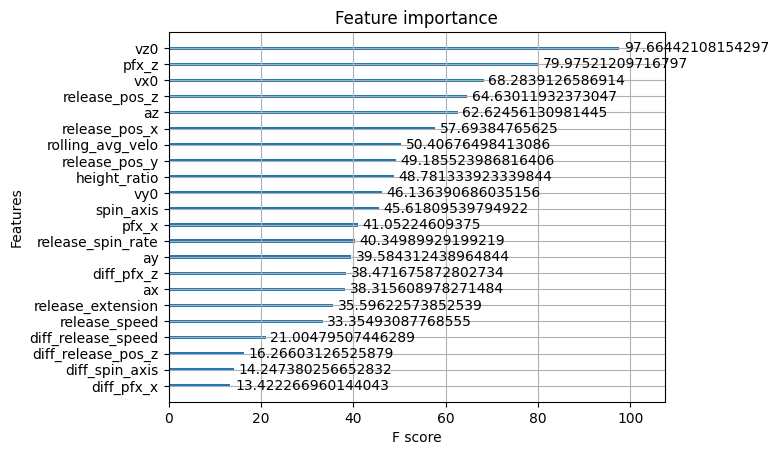

In [22]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

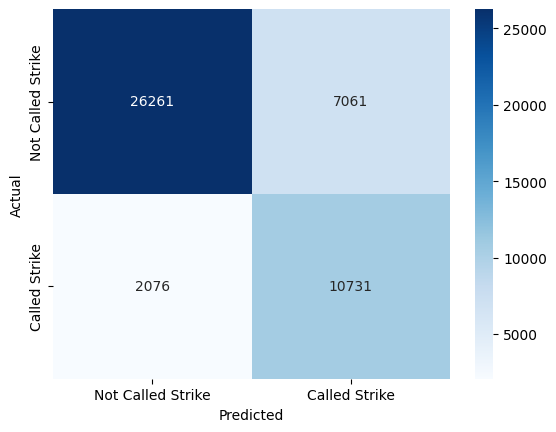

In [23]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Called Strike', 'Called Strike'], yticklabels=['Not Called Strike', 'Called Strike'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [24]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [25]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [26]:
len(testing_label)

1117690

In [27]:
y_pred = final_model.predict(predictions)

In [28]:
len(testing_data)

1117690

In [29]:
testing_identifiers['xcs'] = y_pred

In [30]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/cs_2022&3_xcalledstrike.csv")